### Multivariate series

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import warnings 
warnings.filterwarnings('ignore')

data = pd.read_csv('../../data/new_data_backfill_forwfill.csv',index_col = 0)

# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])
cell_1 = agg_by_cell.get_group('486-1252')
cell_2 = agg_by_cell.get_group('486-1256')
cell_3 = agg_by_cell.get_group('486-1258')
# define input sequence
series1 = cell_1['nr_people'].values
series2 = cell_2['nr_people'].values
series3 = cell_3['nr_people'].values
print(type(series2))

<class 'numpy.ndarray'>


### MLP applicato a serie dati multivariata (tre celle)  

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))]) # convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3, out_seq))
# choose a number of time steps
n_steps = 4
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [ 32.  37.  37. 106.]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [ 33.  37.  37. 107.]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [ 32.  36.  35. 103.]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [30. 34. 34. 98.]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [30. 34. 33. 97.]
[[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]] [29. 33. 32. 94.]
[[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]] [29. 32. 31. 92.]
[[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]] [27. 30. 29. 86.]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]
 [27. 30. 29. 86.]] [27. 30. 29. 86.]
[[29. 33. 32. 94.]
 [

 [ 33.  38.  45. 116.]] [ 35.  40.  45. 120.]
[[ 32.  37.  42. 111.]
 [ 32.  37.  45. 114.]
 [ 33.  38.  45. 116.]
 [ 35.  40.  45. 120.]] [ 37.  42.  46. 125.]
[[ 32.  37.  45. 114.]
 [ 33.  38.  45. 116.]
 [ 35.  40.  45. 120.]
 [ 37.  42.  46. 125.]] [ 38.  43.  47. 128.]
[[ 33.  38.  45. 116.]
 [ 35.  40.  45. 120.]
 [ 37.  42.  46. 125.]
 [ 38.  43.  47. 128.]] [ 40.  45.  49. 134.]
[[ 35.  40.  45. 120.]
 [ 37.  42.  46. 125.]
 [ 38.  43.  47. 128.]
 [ 40.  45.  49. 134.]] [ 42.  48.  51. 141.]
[[ 37.  42.  46. 125.]
 [ 38.  43.  47. 128.]
 [ 40.  45.  49. 134.]
 [ 42.  48.  51. 141.]] [ 43.  49.  55. 147.]
[[ 38.  43.  47. 128.]
 [ 40.  45.  49. 134.]
 [ 42.  48.  51. 141.]
 [ 43.  49.  55. 147.]] [ 42.  49.  56. 147.]
[[ 40.  45.  49. 134.]
 [ 42.  48.  51. 141.]
 [ 43.  49.  55. 147.]
 [ 42.  49.  56. 147.]] [ 42.  49.  56. 147.]
[[ 42.  48.  51. 141.]
 [ 43.  49.  55. 147.]
 [ 42.  49.  56. 147.]
 [ 42.  49.  56. 147.]] [ 49.  56.  61. 166.]
[[ 43.  49.  55. 147.]
 [ 42.  49.

 [ 53.  60.  56. 169.]] [ 53.  60.  56. 169.]
[[ 55.  62.  58. 175.]
 [ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]] [ 52.  58.  54. 164.]
[[ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 52.  58.  54. 164.]] [ 52.  58.  54. 164.]
[[ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 52.  58.  54. 164.]
 [ 52.  58.  54. 164.]] [ 50.  56.  53. 159.]
[[ 53.  60.  56. 169.]
 [ 52.  58.  54. 164.]
 [ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]] [ 48.  54.  51. 153.]
[[ 52.  58.  54. 164.]
 [ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]
 [ 48.  54.  51. 153.]] [ 47.  53.  50. 150.]
[[ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]
 [ 48.  54.  51. 153.]
 [ 47.  53.  50. 150.]] [ 45.  50.  49. 144.]
[[ 50.  56.  53. 159.]
 [ 48.  54.  51. 153.]
 [ 47.  53.  50. 150.]
 [ 45.  50.  49. 144.]] [ 44.  49.  48. 141.]
[[ 48.  54.  51. 153.]
 [ 47.  53.  50. 150.]
 [ 45.  50.  49. 144.]
 [ 44.  49.  48. 141.]] [ 41.  47.  47. 135.]
[[ 47.  53.  50. 150.]
 [ 45.  50.

 [ 31.  35.  35. 101.]] [30. 34. 35. 99.]
[[ 33.  36.  35. 104.]
 [ 32.  36.  35. 103.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  35.  99.]] [30. 33. 35. 98.]
[[ 32.  36.  35. 103.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  35.  99.]
 [ 30.  33.  35.  98.]] [29. 32. 35. 96.]
[[ 31.  35.  35. 101.]
 [ 30.  34.  35.  99.]
 [ 30.  33.  35.  98.]
 [ 29.  32.  35.  96.]] [29. 32. 36. 97.]
[[30. 34. 35. 99.]
 [30. 33. 35. 98.]
 [29. 32. 35. 96.]
 [29. 32. 36. 97.]] [29. 32. 35. 96.]
[[30. 33. 35. 98.]
 [29. 32. 35. 96.]
 [29. 32. 36. 97.]
 [29. 32. 35. 96.]] [30. 34. 33. 97.]
[[29. 32. 35. 96.]
 [29. 32. 36. 97.]
 [29. 32. 35. 96.]
 [30. 34. 33. 97.]] [30. 34. 32. 96.]
[[29. 32. 36. 97.]
 [29. 32. 35. 96.]
 [30. 34. 33. 97.]
 [30. 34. 32. 96.]] [30. 33. 32. 95.]
[[29. 32. 35. 96.]
 [30. 34. 33. 97.]
 [30. 34. 32. 96.]
 [30. 33. 32. 95.]] [30. 34. 33. 97.]
[[30. 34. 33. 97.]
 [30. 34. 32. 96.]
 [30. 33. 32. 95.]
 [30. 34. 33. 97.]] [29. 33. 32. 94.]
[[30. 34. 32. 96.]
 [30. 33. 32. 95.]
 [30. 34. 33. 97.

 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[24. 28. 29. 81.]
 [25. 29. 29. 83.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[25. 29. 29. 83.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [ 30.  35.  35. 100.]
[[ 26.  30.  30.  86.]
 [ 26.  30.  30.  86.]
 [ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]] [ 34.  39.  37. 110.]
[[ 26.  30.  30.  86.]
 [ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]] [ 36.  41.  40. 117.]
[[ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]] [ 36.  41.  40. 117.]
[[ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]] [ 38.  44.  44. 126.]
[[ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]] [ 37.  42.  43. 122.]
[[ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]
 [ 37.  42.  43. 122.]] [ 36.  42.  43. 121.]
[[ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]
 [ 37.  42.  43. 122.]
 [ 36.  4

 [ 30.  34.  37. 101.]] [ 30.  34.  37. 101.]
[[ 31.  35.  36. 102.]
 [ 31.  34.  38. 103.]
 [ 30.  34.  37. 101.]
 [ 30.  34.  37. 101.]] [ 33.  37.  38. 108.]
[[ 31.  34.  38. 103.]
 [ 30.  34.  37. 101.]
 [ 30.  34.  37. 101.]
 [ 33.  37.  38. 108.]] [ 34.  38.  39. 111.]
[[ 30.  34.  37. 101.]
 [ 30.  34.  37. 101.]
 [ 33.  37.  38. 108.]
 [ 34.  38.  39. 111.]] [ 34.  38.  39. 111.]
[[ 30.  34.  37. 101.]
 [ 33.  37.  38. 108.]
 [ 34.  38.  39. 111.]
 [ 34.  38.  39. 111.]] [ 36.  41.  39. 116.]
[[ 33.  37.  38. 108.]
 [ 34.  38.  39. 111.]
 [ 34.  38.  39. 111.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 34.  38.  39. 111.]
 [ 34.  38.  39. 111.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 34.  38.  39. 111.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 39.  43.  40. 122.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 39.  43.  40. 122.]] [ 38.  43.  42. 123.]
[[ 36.  41.  39. 116.]
 [ 36.  41.

 [ 40.  44.  41. 125.]] [ 41.  46.  43. 130.]
[[ 36.  40.  38. 114.]
 [ 39.  43.  39. 121.]
 [ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]] [ 40.  45.  42. 127.]
[[ 39.  43.  39. 121.]
 [ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]
 [ 40.  45.  42. 127.]] [ 39.  44.  43. 126.]
[[ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]
 [ 40.  45.  42. 127.]
 [ 39.  44.  43. 126.]] [ 39.  44.  43. 126.]
[[ 41.  46.  43. 130.]
 [ 40.  45.  42. 127.]
 [ 39.  44.  43. 126.]
 [ 39.  44.  43. 126.]] [ 40.  45.  44. 129.]
[[ 40.  45.  42. 127.]
 [ 39.  44.  43. 126.]
 [ 39.  44.  43. 126.]
 [ 40.  45.  44. 129.]] [ 40.  45.  44. 129.]
[[ 39.  44.  43. 126.]
 [ 39.  44.  43. 126.]
 [ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]] [ 39.  44.  44. 127.]
[[ 39.  44.  43. 126.]
 [ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]
 [ 39.  44.  44. 127.]] [ 41.  46.  44. 131.]
[[ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]
 [ 39.  44.  44. 127.]
 [ 41.  46.  44. 131.]] [ 42.  47.  45. 134.]
[[ 40.  45.  44. 129.]
 [ 39.  44.

 [ 46.  53.  52. 151.]] [ 49.  56.  53. 158.]
[[ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]] [ 50.  56.  54. 160.]
[[ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]] [ 50.  56.  54. 160.]
[[ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 50.  56.  54. 160.]] [ 51.  58.  54. 163.]
[[ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 50.  56.  54. 160.]
 [ 51.  58.  54. 163.]] [ 53.  61.  54. 168.]
[[ 50.  56.  54. 160.]
 [ 50.  56.  54. 160.]
 [ 51.  58.  54. 163.]
 [ 53.  61.  54. 168.]] [ 54.  61.  55. 170.]
[[ 50.  56.  54. 160.]
 [ 51.  58.  54. 163.]
 [ 53.  61.  54. 168.]
 [ 54.  61.  55. 170.]] [ 56.  63.  57. 176.]
[[ 51.  58.  54. 163.]
 [ 53.  61.  54. 168.]
 [ 54.  61.  55. 170.]
 [ 56.  63.  57. 176.]] [ 57.  64.  58. 179.]
[[ 53.  61.  54. 168.]
 [ 54.  61.  55. 170.]
 [ 56.  63.  57. 176.]
 [ 57.  64.  58. 179.]] [ 58.  66.  60. 184.]
[[ 54.  61.  55. 170.]
 [ 56.  63.

 [ 33.  38.  35. 106.]] [ 35.  40.  38. 113.]
[[ 33.  37.  33. 103.]
 [ 32.  36.  33. 101.]
 [ 33.  38.  35. 106.]
 [ 35.  40.  38. 113.]] [ 35.  40.  38. 113.]
[[ 32.  36.  33. 101.]
 [ 33.  38.  35. 106.]
 [ 35.  40.  38. 113.]
 [ 35.  40.  38. 113.]] [ 41.  46.  44. 131.]
[[ 33.  38.  35. 106.]
 [ 35.  40.  38. 113.]
 [ 35.  40.  38. 113.]
 [ 41.  46.  44. 131.]] [ 45.  51.  46. 142.]
[[ 35.  40.  38. 113.]
 [ 35.  40.  38. 113.]
 [ 41.  46.  44. 131.]
 [ 45.  51.  46. 142.]] [ 47.  53.  49. 149.]
[[ 35.  40.  38. 113.]
 [ 41.  46.  44. 131.]
 [ 45.  51.  46. 142.]
 [ 47.  53.  49. 149.]] [ 48.  54.  51. 153.]
[[ 41.  46.  44. 131.]
 [ 45.  51.  46. 142.]
 [ 47.  53.  49. 149.]
 [ 48.  54.  51. 153.]] [ 48.  54.  51. 153.]
[[ 45.  51.  46. 142.]
 [ 47.  53.  49. 149.]
 [ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]] [ 48.  55.  52. 155.]
[[ 47.  53.  49. 149.]
 [ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]
 [ 48.  55.  52. 155.]] [ 47.  53.  52. 152.]
[[ 48.  54.  51. 153.]
 [ 48.  54.

 [ 39.  44.  42. 125.]] [ 39.  44.  42. 125.]
[[ 35.  40.  38. 113.]
 [ 39.  43.  41. 123.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]] [ 39.  44.  42. 125.]
[[ 39.  43.  41. 123.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]] [ 39.  43.  41. 123.]
[[ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  43.  41. 123.]] [ 39.  43.  41. 123.]
[[ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]] [ 40.  45.  42. 127.]
[[ 39.  44.  42. 125.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 40.  45.  42. 127.]] [ 40.  45.  43. 128.]
[[ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 40.  45.  42. 127.]
 [ 40.  45.  43. 128.]] [ 43.  48.  44. 135.]
[[ 39.  43.  41. 123.]
 [ 40.  45.  42. 127.]
 [ 40.  45.  43. 128.]
 [ 43.  48.  44. 135.]] [ 43.  49.  45. 137.]
[[ 40.  45.  42. 127.]
 [ 40.  45.  43. 128.]
 [ 43.  48.  44. 135.]
 [ 43.  49.  45. 137.]] [ 44.  49.  45. 138.]
[[ 40.  45.  43. 128.]
 [ 43.  48.

 [ 35.  39.  35. 109.]] [ 35.  39.  35. 109.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]] [ 41.  45.  40. 126.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 41.  45.  40. 126.]] [ 43.  48.  43. 134.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 41.  45.  40. 126.]
 [ 43.  48.  43. 134.]] [ 44.  49.  44. 137.]
[[ 35.  39.  35. 109.]
 [ 41.  45.  40. 126.]
 [ 43.  48.  43. 134.]
 [ 44.  49.  44. 137.]] [ 48.  52.  47. 147.]
[[ 41.  45.  40. 126.]
 [ 43.  48.  43. 134.]
 [ 44.  49.  44. 137.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 43.  48.  43. 134.]
 [ 44.  49.  44. 137.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 44.  49.  44. 137.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 48.  52.  47. 147.]
 [ 48.  52.

 [ 46.  51.  45. 142.]] [ 47.  52.  46. 145.]
[[ 43.  49.  44. 136.]
 [ 46.  52.  45. 143.]
 [ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]] [ 48.  53.  47. 148.]
[[ 46.  52.  45. 143.]
 [ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]] [ 47.  53.  47. 147.]
[[ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]] [ 49.  55.  49. 153.]
[[ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]] [ 47.  54.  49. 150.]
[[ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]] [ 49.  55.  51. 155.]
[[ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]] [ 49.  55.  52. 156.]
[[ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]] [ 49.  56.  52. 157.]
[[ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]
 [ 49.  56.  52. 157.]] [ 52.  59.  54. 165.]
[[ 49.  55.  51. 155.]
 [ 49.  55.

 [ 51.  57.  49. 157.]] [ 51.  57.  49. 157.]
[[ 47.  53.  46. 146.]
 [ 49.  54.  47. 150.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]] [ 53.  59.  50. 162.]
[[ 49.  54.  47. 150.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]
 [ 53.  59.  50. 162.]] [ 55.  61.  51. 167.]
[[ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]
 [ 53.  59.  50. 162.]
 [ 55.  61.  51. 167.]] [ 55.  61.  51. 167.]
[[ 51.  57.  49. 157.]
 [ 53.  59.  50. 162.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [ 57.  64.  54. 175.]
[[ 53.  59.  50. 162.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 57.  64.  54. 175.]] [ 60.  66.  55. 181.]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 57.  64.  54. 175.]
 [ 60.  66.  55. 181.]] [ 60.  66.  55. 181.]
[[ 55.  61.  51. 167.]
 [ 57.  64.  54. 175.]
 [ 60.  66.  55. 181.]
 [ 60.  66.  55. 181.]] [ 59.  66.  55. 180.]
[[ 57.  64.  54. 175.]
 [ 60.  66.  55. 181.]
 [ 60.  66.  55. 181.]
 [ 59.  66.  55. 180.]] [ 59.  66.  55. 180.]
[[ 60.  66.  55. 181.]
 [ 60.  66.

 [ 56.  61.  45. 162.]] [ 56.  61.  45. 162.]
[[ 52.  56.  43. 151.]
 [ 52.  57.  43. 152.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  45. 162.]] [ 56.  61.  48. 165.]
[[ 52.  57.  43. 152.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  48. 165.]] [ 56.  61.  48. 165.]
[[ 56.  61.  45. 162.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  48. 165.]
 [ 56.  61.  48. 165.]] [ 61.  67.  50. 178.]
[[ 56.  61.  45. 162.]
 [ 56.  61.  48. 165.]
 [ 56.  61.  48. 165.]
 [ 61.  67.  50. 178.]] [ 63.  70.  53. 186.]
[[ 56.  61.  48. 165.]
 [ 56.  61.  48. 165.]
 [ 61.  67.  50. 178.]
 [ 63.  70.  53. 186.]] [ 63.  70.  53. 186.]
[[ 56.  61.  48. 165.]
 [ 61.  67.  50. 178.]
 [ 63.  70.  53. 186.]
 [ 63.  70.  53. 186.]] [ 61.  68.  55. 184.]
[[ 61.  67.  50. 178.]
 [ 63.  70.  53. 186.]
 [ 63.  70.  53. 186.]
 [ 61.  68.  55. 184.]] [ 61.  68.  55. 184.]
[[ 63.  70.  53. 186.]
 [ 63.  70.  53. 186.]
 [ 61.  68.  55. 184.]
 [ 61.  68.  55. 184.]] [ 61.  68.  55. 184.]
[[ 63.  70.  53. 186.]
 [ 61.  68.

 [ 62.  69.  61. 192.]] [ 62.  69.  61. 192.]
[[ 61.  68.  60. 189.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]] [ 62.  69.  61. 192.]
[[ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]] [ 66.  74.  62. 202.]
[[ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 66.  74.  62. 202.]] [ 68.  76.  63. 207.]
[[ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 66.  74.  62. 202.]
 [ 68.  76.  63. 207.]] [ 68.  76.  63. 207.]
[[ 62.  69.  61. 192.]
 [ 66.  74.  62. 202.]
 [ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]] [ 75.  84.  67. 226.]
[[ 66.  74.  62. 202.]
 [ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]
 [ 75.  84.  67. 226.]] [ 75.  84.  68. 227.]
[[ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]
 [ 75.  84.  67. 226.]
 [ 75.  84.  68. 227.]] [ 76.  84.  69. 229.]
[[ 68.  76.  63. 207.]
 [ 75.  84.  67. 226.]
 [ 75.  84.  68. 227.]
 [ 76.  84.  69. 229.]] [ 77.  85.  69. 231.]
[[ 75.  84.  67. 226.]
 [ 75.  84.

 [ 59.  66.  56. 181.]] [ 59.  66.  56. 181.]
[[ 59.  65.  55. 179.]
 [ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]] [ 63.  70.  57. 190.]
[[ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 63.  70.  57. 190.]] [ 66.  73.  59. 198.]
[[ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 63.  70.  57. 190.]
 [ 66.  73.  59. 198.]] [ 66.  73.  59. 198.]
[[ 59.  66.  56. 181.]
 [ 63.  70.  57. 190.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]] [ 73.  81.  64. 218.]
[[ 63.  70.  57. 190.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 73.  81.  64. 218.]] [ 74.  83.  65. 222.]
[[ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 73.  81.  64. 218.]
 [ 74.  83.  65. 222.]] [ 74.  83.  64. 221.]
[[ 66.  73.  59. 198.]
 [ 73.  81.  64. 218.]
 [ 74.  83.  65. 222.]
 [ 74.  83.  64. 221.]] [ 73.  81.  63. 217.]
[[ 73.  81.  64. 218.]
 [ 74.  83.  65. 222.]
 [ 74.  83.  64. 221.]
 [ 73.  81.  63. 217.]] [ 72.  80.  63. 215.]
[[ 74.  83.  65. 222.]
 [ 74.  83.

 [ 58.  75.  49. 182.]] [ 58.  75.  49. 182.]
[[ 59.  75.  49. 183.]
 [ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]] [ 62.  80.  50. 192.]
[[ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 62.  80.  50. 192.]] [ 65.  82.  52. 199.]
[[ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 62.  80.  50. 192.]
 [ 65.  82.  52. 199.]] [ 65.  82.  52. 199.]
[[ 58.  75.  49. 182.]
 [ 62.  80.  50. 192.]
 [ 65.  82.  52. 199.]
 [ 65.  82.  52. 199.]] [ 68.  88.  53. 209.]
[[ 62.  80.  50. 192.]
 [ 65.  82.  52. 199.]
 [ 65.  82.  52. 199.]
 [ 68.  88.  53. 209.]] [ 70.  88.  53. 211.]
[[ 65.  82.  52. 199.]
 [ 65.  82.  52. 199.]
 [ 68.  88.  53. 209.]
 [ 70.  88.  53. 211.]] [ 71.  90.  53. 214.]
[[ 65.  82.  52. 199.]
 [ 68.  88.  53. 209.]
 [ 70.  88.  53. 211.]
 [ 71.  90.  53. 214.]] [ 70.  87.  53. 210.]
[[ 68.  88.  53. 209.]
 [ 70.  88.  53. 211.]
 [ 71.  90.  53. 214.]
 [ 70.  87.  53. 210.]] [ 67.  84.  53. 204.]
[[ 70.  88.  53. 211.]
 [ 71.  90.

 [ 48.  60.  43. 151.]] [ 47.  59.  43. 149.]
[[ 52.  64.  41. 157.]
 [ 49.  60.  44. 153.]
 [ 48.  60.  43. 151.]
 [ 47.  59.  43. 149.]] [ 47.  59.  45. 151.]
[[ 49.  60.  44. 153.]
 [ 48.  60.  43. 151.]
 [ 47.  59.  43. 149.]
 [ 47.  59.  45. 151.]] [ 47.  61.  47. 155.]
[[ 48.  60.  43. 151.]
 [ 47.  59.  43. 149.]
 [ 47.  59.  45. 151.]
 [ 47.  61.  47. 155.]] [ 48.  63.  49. 160.]
[[ 47.  59.  43. 149.]
 [ 47.  59.  45. 151.]
 [ 47.  61.  47. 155.]
 [ 48.  63.  49. 160.]] [ 50.  65.  49. 164.]
[[ 47.  59.  45. 151.]
 [ 47.  61.  47. 155.]
 [ 48.  63.  49. 160.]
 [ 50.  65.  49. 164.]] [ 50.  66.  49. 165.]
[[ 47.  61.  47. 155.]
 [ 48.  63.  49. 160.]
 [ 50.  65.  49. 164.]
 [ 50.  66.  49. 165.]] [ 48.  67.  49. 164.]
[[ 48.  63.  49. 160.]
 [ 50.  65.  49. 164.]
 [ 50.  66.  49. 165.]
 [ 48.  67.  49. 164.]] [ 48.  66.  50. 164.]
[[ 50.  65.  49. 164.]
 [ 50.  66.  49. 165.]
 [ 48.  67.  49. 164.]
 [ 48.  66.  50. 164.]] [ 48.  66.  50. 164.]
[[ 50.  66.  49. 165.]
 [ 48.  67.

 [ 42.  55.  48. 145.]] [ 42.  55.  48. 145.]
[[ 39.  50.  45. 134.]
 [ 41.  53.  45. 139.]
 [ 42.  55.  48. 145.]
 [ 42.  55.  48. 145.]] [ 46.  60.  48. 154.]
[[ 41.  53.  45. 139.]
 [ 42.  55.  48. 145.]
 [ 42.  55.  48. 145.]
 [ 46.  60.  48. 154.]] [ 46.  60.  48. 154.]
[[ 42.  55.  48. 145.]
 [ 42.  55.  48. 145.]
 [ 46.  60.  48. 154.]
 [ 46.  60.  48. 154.]] [ 52.  66.  50. 168.]
[[ 42.  55.  48. 145.]
 [ 46.  60.  48. 154.]
 [ 46.  60.  48. 154.]
 [ 52.  66.  50. 168.]] [ 55.  68.  51. 174.]
[[ 46.  60.  48. 154.]
 [ 46.  60.  48. 154.]
 [ 52.  66.  50. 168.]
 [ 55.  68.  51. 174.]] [ 57.  71.  52. 180.]
[[ 46.  60.  48. 154.]
 [ 52.  66.  50. 168.]
 [ 55.  68.  51. 174.]
 [ 57.  71.  52. 180.]] [ 61.  75.  52. 188.]
[[ 52.  66.  50. 168.]
 [ 55.  68.  51. 174.]
 [ 57.  71.  52. 180.]
 [ 61.  75.  52. 188.]] [ 63.  77.  53. 193.]
[[ 55.  68.  51. 174.]
 [ 57.  71.  52. 180.]
 [ 61.  75.  52. 188.]
 [ 63.  77.  53. 193.]] [ 65.  79.  52. 196.]
[[ 57.  71.  52. 180.]
 [ 61.  75.

 [ 56.  71.  43. 170.]] [ 56.  71.  43. 170.]
[[ 52.  67.  44. 163.]
 [ 55.  70.  44. 169.]
 [ 56.  71.  43. 170.]
 [ 56.  71.  43. 170.]] [ 57.  73.  44. 174.]
[[ 55.  70.  44. 169.]
 [ 56.  71.  43. 170.]
 [ 56.  71.  43. 170.]
 [ 57.  73.  44. 174.]] [ 59.  74.  45. 178.]
[[ 56.  71.  43. 170.]
 [ 56.  71.  43. 170.]
 [ 57.  73.  44. 174.]
 [ 59.  74.  45. 178.]] [ 61.  77.  48. 186.]
[[ 56.  71.  43. 170.]
 [ 57.  73.  44. 174.]
 [ 59.  74.  45. 178.]
 [ 61.  77.  48. 186.]] [ 63.  81.  50. 194.]
[[ 57.  73.  44. 174.]
 [ 59.  74.  45. 178.]
 [ 61.  77.  48. 186.]
 [ 63.  81.  50. 194.]] [ 66.  84.  52. 202.]
[[ 59.  74.  45. 178.]
 [ 61.  77.  48. 186.]
 [ 63.  81.  50. 194.]
 [ 66.  84.  52. 202.]] [ 66.  83.  52. 201.]
[[ 61.  77.  48. 186.]
 [ 63.  81.  50. 194.]
 [ 66.  84.  52. 202.]
 [ 66.  83.  52. 201.]] [ 67.  83.  51. 201.]
[[ 63.  81.  50. 194.]
 [ 66.  84.  52. 202.]
 [ 66.  83.  52. 201.]
 [ 67.  83.  51. 201.]] [ 68.  85.  52. 205.]
[[ 66.  84.  52. 202.]
 [ 66.  83.

 [ 61.  74.  54. 189.]] [ 61.  74.  54. 189.]
[[ 59.  73.  55. 187.]
 [ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]] [ 62.  75.  55. 192.]
[[ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 62.  75.  55. 192.]] [ 65.  77.  55. 197.]
[[ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 62.  75.  55. 192.]
 [ 65.  77.  55. 197.]] [ 65.  77.  55. 197.]
[[ 61.  74.  54. 189.]
 [ 62.  75.  55. 192.]
 [ 65.  77.  55. 197.]
 [ 65.  77.  55. 197.]] [ 65.  76.  54. 195.]
[[ 62.  75.  55. 192.]
 [ 65.  77.  55. 197.]
 [ 65.  77.  55. 197.]
 [ 65.  76.  54. 195.]] [ 64.  75.  53. 192.]
[[ 65.  77.  55. 197.]
 [ 65.  77.  55. 197.]
 [ 65.  76.  54. 195.]
 [ 64.  75.  53. 192.]] [ 64.  75.  53. 192.]
[[ 65.  77.  55. 197.]
 [ 65.  76.  54. 195.]
 [ 64.  75.  53. 192.]
 [ 64.  75.  53. 192.]] [ 63.  73.  52. 188.]
[[ 65.  76.  54. 195.]
 [ 64.  75.  53. 192.]
 [ 64.  75.  53. 192.]
 [ 63.  73.  52. 188.]] [ 63.  73.  52. 188.]
[[ 64.  75.  53. 192.]
 [ 64.  75.

 [ 62.  81.  55. 198.]] [ 62.  82.  55. 199.]
[[ 60.  79.  54. 193.]
 [ 62.  81.  55. 198.]
 [ 62.  81.  55. 198.]
 [ 62.  82.  55. 199.]] [ 61.  81.  54. 196.]
[[ 62.  81.  55. 198.]
 [ 62.  81.  55. 198.]
 [ 62.  82.  55. 199.]
 [ 61.  81.  54. 196.]] [ 60.  81.  55. 196.]
[[ 62.  81.  55. 198.]
 [ 62.  82.  55. 199.]
 [ 61.  81.  54. 196.]
 [ 60.  81.  55. 196.]] [ 61.  82.  55. 198.]
[[ 62.  82.  55. 199.]
 [ 61.  81.  54. 196.]
 [ 60.  81.  55. 196.]
 [ 61.  82.  55. 198.]] [ 60.  81.  55. 196.]
[[ 61.  81.  54. 196.]
 [ 60.  81.  55. 196.]
 [ 61.  82.  55. 198.]
 [ 60.  81.  55. 196.]] [ 60.  80.  55. 195.]
[[ 60.  81.  55. 196.]
 [ 61.  82.  55. 198.]
 [ 60.  81.  55. 196.]
 [ 60.  80.  55. 195.]] [ 58.  77.  54. 189.]
[[ 61.  82.  55. 198.]
 [ 60.  81.  55. 196.]
 [ 60.  80.  55. 195.]
 [ 58.  77.  54. 189.]] [ 55.  74.  53. 182.]
[[ 60.  81.  55. 196.]
 [ 60.  80.  55. 195.]
 [ 58.  77.  54. 189.]
 [ 55.  74.  53. 182.]] [ 54.  72.  53. 179.]
[[ 60.  80.  55. 195.]
 [ 58.  77.

 [ 65.  80.  46. 191.]] [ 63.  77.  44. 184.]
[[ 71.  86.  50. 207.]
 [ 68.  84.  48. 200.]
 [ 65.  80.  46. 191.]
 [ 63.  77.  44. 184.]] [ 61.  74.  43. 178.]
[[ 68.  84.  48. 200.]
 [ 65.  80.  46. 191.]
 [ 63.  77.  44. 184.]
 [ 61.  74.  43. 178.]] [ 58.  71.  41. 170.]
[[ 65.  80.  46. 191.]
 [ 63.  77.  44. 184.]
 [ 61.  74.  43. 178.]
 [ 58.  71.  41. 170.]] [ 58.  71.  41. 170.]
[[ 63.  77.  44. 184.]
 [ 61.  74.  43. 178.]
 [ 58.  71.  41. 170.]
 [ 58.  71.  41. 170.]] [ 55.  66.  39. 160.]
[[ 61.  74.  43. 178.]
 [ 58.  71.  41. 170.]
 [ 58.  71.  41. 170.]
 [ 55.  66.  39. 160.]] [ 55.  66.  39. 160.]
[[ 58.  71.  41. 170.]
 [ 58.  71.  41. 170.]
 [ 55.  66.  39. 160.]
 [ 55.  66.  39. 160.]] [ 52.  61.  39. 152.]
[[ 58.  71.  41. 170.]
 [ 55.  66.  39. 160.]
 [ 55.  66.  39. 160.]
 [ 52.  61.  39. 152.]] [ 52.  61.  38. 151.]
[[ 55.  66.  39. 160.]
 [ 55.  66.  39. 160.]
 [ 52.  61.  39. 152.]
 [ 52.  61.  38. 151.]] [ 51.  59.  37. 147.]
[[ 55.  66.  39. 160.]
 [ 52.  61.

 [ 56.  66.  47. 169.]] [ 56.  66.  47. 169.]
[[ 60.  73.  51. 184.]
 [ 57.  69.  49. 175.]
 [ 56.  66.  47. 169.]
 [ 56.  66.  47. 169.]] [ 54.  64.  46. 164.]
[[ 57.  69.  49. 175.]
 [ 56.  66.  47. 169.]
 [ 56.  66.  47. 169.]
 [ 54.  64.  46. 164.]] [ 53.  62.  45. 160.]
[[ 56.  66.  47. 169.]
 [ 56.  66.  47. 169.]
 [ 54.  64.  46. 164.]
 [ 53.  62.  45. 160.]] [ 53.  62.  44. 159.]
[[ 56.  66.  47. 169.]
 [ 54.  64.  46. 164.]
 [ 53.  62.  45. 160.]
 [ 53.  62.  44. 159.]] [ 53.  61.  43. 157.]
[[ 54.  64.  46. 164.]
 [ 53.  62.  45. 160.]
 [ 53.  62.  44. 159.]
 [ 53.  61.  43. 157.]] [ 52.  61.  42. 155.]
[[ 53.  62.  45. 160.]
 [ 53.  62.  44. 159.]
 [ 53.  61.  43. 157.]
 [ 52.  61.  42. 155.]] [ 51.  59.  42. 152.]
[[ 53.  62.  44. 159.]
 [ 53.  61.  43. 157.]
 [ 52.  61.  42. 155.]
 [ 51.  59.  42. 152.]] [ 50.  58.  42. 150.]
[[ 53.  61.  43. 157.]
 [ 52.  61.  42. 155.]
 [ 51.  59.  42. 152.]
 [ 50.  58.  42. 150.]] [ 51.  59.  44. 154.]
[[ 52.  61.  42. 155.]
 [ 51.  59.

 [ 41.  45.  31. 117.]] [ 40.  44.  30. 114.]
[[ 41.  47.  32. 120.]
 [ 41.  46.  31. 118.]
 [ 41.  45.  31. 117.]
 [ 40.  44.  30. 114.]] [ 39.  43.  29. 111.]
[[ 41.  46.  31. 118.]
 [ 41.  45.  31. 117.]
 [ 40.  44.  30. 114.]
 [ 39.  43.  29. 111.]] [ 38.  43.  28. 109.]
[[ 41.  45.  31. 117.]
 [ 40.  44.  30. 114.]
 [ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]] [ 37.  41.  26. 104.]
[[ 40.  44.  30. 114.]
 [ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]] [ 36.  39.  25. 100.]
[[ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]] [34. 37. 25. 96.]
[[ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]] [33. 36. 24. 93.]
[[ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]
 [ 33.  36.  24.  93.]] [32. 36. 24. 92.]
[[ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]
 [ 33.  36.  24.  93.]
 [ 32.  36.  24.  92.]] [31. 35. 24. 90.]
[[34. 37. 25. 96.]
 [33. 36. 24. 93.]
 [32. 36. 24

 [31. 36. 25. 92.]] [31. 36. 25. 92.]
[[32. 36. 26. 94.]
 [32. 36. 26. 94.]
 [31. 36. 25. 92.]
 [31. 36. 25. 92.]] [30. 36. 24. 90.]
[[32. 36. 26. 94.]
 [31. 36. 25. 92.]
 [31. 36. 25. 92.]
 [30. 36. 24. 90.]] [30. 36. 24. 90.]
[[31. 36. 25. 92.]
 [31. 36. 25. 92.]
 [30. 36. 24. 90.]
 [30. 36. 24. 90.]] [29. 38. 26. 93.]
[[31. 36. 25. 92.]
 [30. 36. 24. 90.]
 [30. 36. 24. 90.]
 [29. 38. 26. 93.]] [29. 38. 26. 93.]
[[30. 36. 24. 90.]
 [30. 36. 24. 90.]
 [29. 38. 26. 93.]
 [29. 38. 26. 93.]] [30. 38. 27. 95.]
[[30. 36. 24. 90.]
 [29. 38. 26. 93.]
 [29. 38. 26. 93.]
 [30. 38. 27. 95.]] [29. 38. 27. 94.]
[[29. 38. 26. 93.]
 [29. 38. 26. 93.]
 [30. 38. 27. 95.]
 [29. 38. 27. 94.]] [30. 39. 25. 94.]
[[29. 38. 26. 93.]
 [30. 38. 27. 95.]
 [29. 38. 27. 94.]
 [30. 39. 25. 94.]] [30. 36. 25. 91.]
[[30. 38. 27. 95.]
 [29. 38. 27. 94.]
 [30. 39. 25. 94.]
 [30. 36. 25. 91.]] [29. 36. 25. 90.]
[[29. 38. 27. 94.]
 [30. 39. 25. 94.]
 [30. 36. 25. 91.]
 [29. 36. 25. 90.]] [29. 38. 25. 92.]
[[30. 39. 25

 [26. 35. 24. 85.]] [27. 35. 25. 87.]
[[27. 33. 23. 83.]
 [27. 35. 23. 85.]
 [26. 35. 24. 85.]
 [27. 35. 25. 87.]] [27. 37. 25. 89.]
[[27. 35. 23. 85.]
 [26. 35. 24. 85.]
 [27. 35. 25. 87.]
 [27. 37. 25. 89.]] [27. 38. 26. 91.]
[[26. 35. 24. 85.]
 [27. 35. 25. 87.]
 [27. 37. 25. 89.]
 [27. 38. 26. 91.]] [28. 38. 25. 91.]
[[27. 35. 25. 87.]
 [27. 37. 25. 89.]
 [27. 38. 26. 91.]
 [28. 38. 25. 91.]] [29. 37. 25. 91.]
[[27. 37. 25. 89.]
 [27. 38. 26. 91.]
 [28. 38. 25. 91.]
 [29. 37. 25. 91.]] [30. 39. 24. 93.]
[[27. 38. 26. 91.]
 [28. 38. 25. 91.]
 [29. 37. 25. 91.]
 [30. 39. 24. 93.]] [28. 39. 23. 90.]
[[28. 38. 25. 91.]
 [29. 37. 25. 91.]
 [30. 39. 24. 93.]
 [28. 39. 23. 90.]] [28. 38. 22. 88.]
[[29. 37. 25. 91.]
 [30. 39. 24. 93.]
 [28. 39. 23. 90.]
 [28. 38. 22. 88.]] [27. 37. 23. 87.]
[[30. 39. 24. 93.]
 [28. 39. 23. 90.]
 [28. 38. 22. 88.]
 [27. 37. 23. 87.]] [26. 36. 24. 86.]
[[28. 39. 23. 90.]
 [28. 38. 22. 88.]
 [27. 37. 23. 87.]
 [26. 36. 24. 86.]] [26. 36. 24. 86.]
[[28. 38. 22

 [29. 39. 22. 90.]] [29. 39. 22. 90.]
[[29. 36. 21. 86.]
 [29. 37. 21. 87.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]] [29. 39. 25. 93.]
[[29. 37. 21. 87.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [29. 39. 25. 93.]] [29. 40. 26. 95.]
[[29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [29. 39. 25. 93.]
 [29. 40. 26. 95.]] [30. 39. 26. 95.]
[[29. 39. 22. 90.]
 [29. 39. 25. 93.]
 [29. 40. 26. 95.]
 [30. 39. 26. 95.]] [30. 38. 26. 94.]
[[29. 39. 25. 93.]
 [29. 40. 26. 95.]
 [30. 39. 26. 95.]
 [30. 38. 26. 94.]] [30. 38. 26. 94.]
[[29. 40. 26. 95.]
 [30. 39. 26. 95.]
 [30. 38. 26. 94.]
 [30. 38. 26. 94.]] [32. 41. 23. 96.]
[[30. 39. 26. 95.]
 [30. 38. 26. 94.]
 [30. 38. 26. 94.]
 [32. 41. 23. 96.]] [31. 40. 23. 94.]
[[30. 38. 26. 94.]
 [30. 38. 26. 94.]
 [32. 41. 23. 96.]
 [31. 40. 23. 94.]] [30. 39. 24. 93.]
[[30. 38. 26. 94.]
 [32. 41. 23. 96.]
 [31. 40. 23. 94.]
 [30. 39. 24. 93.]] [30. 38. 25. 93.]
[[32. 41. 23. 96.]
 [31. 40. 23. 94.]
 [30. 39. 24. 93.]
 [30. 38. 25. 93.]] [29. 37. 25. 91.]
[[31. 40. 23

 [25. 34. 20. 79.]] [25. 35. 22. 82.]
[[25. 33. 20. 78.]
 [25. 34. 20. 79.]
 [25. 34. 20. 79.]
 [25. 35. 22. 82.]] [25. 35. 23. 83.]
[[25. 34. 20. 79.]
 [25. 34. 20. 79.]
 [25. 35. 22. 82.]
 [25. 35. 23. 83.]] [27. 36. 21. 84.]
[[25. 34. 20. 79.]
 [25. 35. 22. 82.]
 [25. 35. 23. 83.]
 [27. 36. 21. 84.]] [27. 36. 21. 84.]
[[25. 35. 22. 82.]
 [25. 35. 23. 83.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]] [27. 36. 21. 84.]
[[25. 35. 23. 83.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]] [27. 35. 20. 82.]
[[27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 35. 20. 82.]] [27. 35. 20. 82.]
[[27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 35. 20. 82.]
 [27. 35. 20. 82.]] [28. 37. 20. 85.]
[[27. 36. 21. 84.]
 [27. 35. 20. 82.]
 [27. 35. 20. 82.]
 [28. 37. 20. 85.]] [28. 36. 21. 85.]
[[27. 35. 20. 82.]
 [27. 35. 20. 82.]
 [28. 37. 20. 85.]
 [28. 36. 21. 85.]] [25. 34. 21. 80.]
[[27. 35. 20. 82.]
 [28. 37. 20. 85.]
 [28. 36. 21. 85.]
 [25. 34. 21. 80.]] [27. 35. 22. 84.]
[[28. 37. 20

 [28. 41. 25. 94.]] [28. 40. 25. 93.]
[[31. 42. 25. 98.]
 [30. 40. 25. 95.]
 [28. 41. 25. 94.]
 [28. 40. 25. 93.]] [28. 39. 25. 92.]
[[30. 40. 25. 95.]
 [28. 41. 25. 94.]
 [28. 40. 25. 93.]
 [28. 39. 25. 92.]] [28. 39. 25. 92.]
[[28. 41. 25. 94.]
 [28. 40. 25. 93.]
 [28. 39. 25. 92.]
 [28. 39. 25. 92.]] [26. 39. 24. 89.]
[[28. 40. 25. 93.]
 [28. 39. 25. 92.]
 [28. 39. 25. 92.]
 [26. 39. 24. 89.]] [26. 40. 25. 91.]
[[28. 39. 25. 92.]
 [28. 39. 25. 92.]
 [26. 39. 24. 89.]
 [26. 40. 25. 91.]] [28. 42. 28. 98.]
[[28. 39. 25. 92.]
 [26. 39. 24. 89.]
 [26. 40. 25. 91.]
 [28. 42. 28. 98.]] [ 28.  43.  31. 102.]
[[ 26.  39.  24.  89.]
 [ 26.  40.  25.  91.]
 [ 28.  42.  28.  98.]
 [ 28.  43.  31. 102.]] [ 30.  45.  31. 106.]
[[ 26.  40.  25.  91.]
 [ 28.  42.  28.  98.]
 [ 28.  43.  31. 102.]
 [ 30.  45.  31. 106.]] [ 31.  45.  31. 107.]
[[ 28.  42.  28.  98.]
 [ 28.  43.  31. 102.]
 [ 30.  45.  31. 106.]
 [ 31.  45.  31. 107.]] [ 33.  48.  31. 112.]
[[ 28.  43.  31. 102.]
 [ 30.  45.  31. 106

 [23. 31. 22. 76.]] [22. 30. 23. 75.]
[[24. 31. 22. 77.]
 [23. 31. 22. 76.]
 [23. 31. 22. 76.]
 [22. 30. 23. 75.]] [22. 30. 23. 75.]
[[23. 31. 22. 76.]
 [23. 31. 22. 76.]
 [22. 30. 23. 75.]
 [22. 30. 23. 75.]] [21. 30. 23. 74.]
[[23. 31. 22. 76.]
 [22. 30. 23. 75.]
 [22. 30. 23. 75.]
 [21. 30. 23. 74.]] [21. 30. 23. 74.]
[[22. 30. 23. 75.]
 [22. 30. 23. 75.]
 [21. 30. 23. 74.]
 [21. 30. 23. 74.]] [22. 31. 24. 77.]
[[22. 30. 23. 75.]
 [21. 30. 23. 74.]
 [21. 30. 23. 74.]
 [22. 31. 24. 77.]] [22. 32. 25. 79.]
[[21. 30. 23. 74.]
 [21. 30. 23. 74.]
 [22. 31. 24. 77.]
 [22. 32. 25. 79.]] [24. 34. 25. 83.]
[[21. 30. 23. 74.]
 [22. 31. 24. 77.]
 [22. 32. 25. 79.]
 [24. 34. 25. 83.]] [25. 37. 25. 87.]
[[22. 31. 24. 77.]
 [22. 32. 25. 79.]
 [24. 34. 25. 83.]
 [25. 37. 25. 87.]] [28. 39. 27. 94.]
[[22. 32. 25. 79.]
 [24. 34. 25. 83.]
 [25. 37. 25. 87.]
 [28. 39. 27. 94.]] [ 31.  41.  29. 101.]
[[ 24.  34.  25.  83.]
 [ 25.  37.  25.  87.]
 [ 28.  39.  27.  94.]
 [ 31.  41.  29. 101.]] [ 32.  44.

In [3]:
# split into train and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]

train_y, test_y = y[0:train_size], y[train_size:len(y)]
print('X', len(train_X), len(test_X))
print('y ', len(train_y), len(test_y))
count = 0
for i in range(len(X)):
    print(train_X[i],train_y[i])
    count +=1
    if count >= 5:
        break

X 7908 3896
y  7908 3896
[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [ 32.  37.  37. 106.]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [ 33.  37.  37. 107.]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [ 32.  36.  35. 103.]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [30. 34. 34. 98.]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [30. 34. 33. 97.]


In [4]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
n_output = train_y.shape[1]
print(len(train_X))

7908


In [5]:
# flatten input
n_input_test = test_X.shape[1] * test_X.shape[2]
test_X = test_X.reshape((test_X.shape[0], n_input_test))
n_output_test = test_y.shape[1]

In [6]:
start_time = time.time()

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_X, train_y, epochs=200, verbose=2)

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
 - 0s - loss: 293.0324
Epoch 2/200
 - 0s - loss: 18.4086
Epoch 3/200
 - 0s - loss: 13.2483
Epoch 4/200
 - 0s - loss: 9.9808
Epoch 5/200
 - 0s - loss: 8.1179
Epoch 6/200
 - 0s - loss: 7.4259
Epoch 7/200
 - 0s - loss: 7.0440
Epoch 8/200
 - 0s - loss: 7.0075
Epoch 9/200
 - 0s - loss: 6.7081
Epoch 10/200
 - 0s - loss: 6.6972
Epoch 11/200
 - 0s - loss: 6.7319
Epoch 12/200
 - 0s - loss: 6.5722
Epoch 13/200
 - 0s - loss: 6.5649
Epoch 14/200
 - 0s - loss: 6.5697
Epoch 15/200
 - 0s - loss: 6.5186
Epoch 16/200
 - 0s - loss: 6.2006
Epoch 17/200
 - 0s - loss: 6.3054
Epoch 18/200
 - 0s - loss: 6.3818
Epoch 19/200
 - 0s - loss: 6.3596
Epoch 20/200
 - 0s - loss: 6.2559
Epoch 21/200
 - 0s - loss: 6.3320
Epoch 22/200
 - 0s - loss: 6.4834
Epoch 23/200
 - 0s - loss: 6.1878
Epoch 24/200
 - 0s - loss: 6.1177
Epoch 25/200
 - 0s - loss: 6.3573
Epoch 26/200
 - 0s - loss: 6.1956
Epoch 27/200
 - 0s - loss: 6.1993
Epoch 28/200
 - 0s - loss: 6.2704
Epoch 29/200
 - 0s - loss: 6.2765
Epoch 30/200
 - 0s 

In [17]:
#[ 36.  43.  42. 121.]
#[ 34.  40.  40. 114.]
#[ 33.  39.  39. 111.]
#[ 32.  37.  37. 106.]
Jupyter Notebook
MultivariateSeries_Forcast_MLMethods Last Checkpoint: un minuto fa (unsaved changes) Current Kernel Logo 

Python 3

    File
    Edit
    View
    Insert
    Cell
    Kernel
    Widgets
    Help

Multivariate series

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import datetime

import time

from pandas.plotting import lag_plot

from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error 

from math import sqrt

from numpy import hstack

from keras.models import Sequential

from keras.layers import LSTM

from keras.layers import Dense

from keras.layers import Flatten

from keras.layers.convolutional import Conv1D

from keras.layers.convolutional import MaxPooling1D

​

import warnings 

warnings.filterwarnings('ignore')

​

data = pd.read_csv('../../data/new_data_backfill_forwfill.csv',index_col = 0)

​

# preparazione dati per due celle

agg_by_cell = data.groupby(by = ['cell_num'])

cell_1 = agg_by_cell.get_group('486-1252')

cell_2 = agg_by_cell.get_group('486-1256')

cell_3 = agg_by_cell.get_group('486-1258')

# define input sequence

series1 = cell_1['nr_people'].values

series2 = cell_2['nr_people'].values

series3 = cell_3['nr_people'].values

print(type(series2))

Using TensorFlow backend.

<class 'numpy.ndarray'>

MLP applicato a serie dati multivariata (tre celle)

# split a multivariate sequence into samples

def split_sequences(sequences, n_steps):

    X, y = list(), list()

    for i in range(len(sequences)):

        # find the end of this pattern

        end_ix = i + n_steps

        # check if we are beyond the dataset

        if end_ix > len(sequences)-1:

            break

        # gather input and output parts of the pattern

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]

        X.append(seq_x)

        y.append(seq_y)

    return np.array(X), np.array(y)

​

# define input sequence

out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))]) # convert to [rows, columns] structure

series1 = series1.reshape((len(series1), 1))

series2 = series2.reshape((len(series2), 1))

series3 = series3.reshape((len(series3), 1))

out_seq = out_seq.reshape((len(out_seq), 1))

​

# horizontally stack columns

dataset = hstack((series1, series2, series3, out_seq))

# choose a number of time steps

n_steps = 4

# convert into input/output

X, y = split_sequences(dataset, n_steps)

# summarize the data

for i in range(len(X)):

    print(X[i], y[i])

[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [ 32.  37.  37. 106.]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [ 33.  37.  37. 107.]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [ 32.  36.  35. 103.]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [30. 34. 34. 98.]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [30. 34. 33. 97.]
[[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]] [29. 33. 32. 94.]
[[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]] [29. 32. 31. 92.]
[[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]] [27. 30. 29. 86.]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]
 [27. 30. 29. 86.]] [27. 30. 29. 86.]
[[29. 33. 32. 94.]
 [29. 32. 31. 92.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]] [25. 27. 27. 79.]
[[29. 32. 31. 92.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [25. 27. 27. 79.]] [24. 26. 25. 75.]
[[27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [25. 27. 27. 79.]
 [24. 26. 25. 75.]] [23. 25. 24. 72.]
[[27. 30. 29. 86.]
 [25. 27. 27. 79.]
 [24. 26. 25. 75.]
 [23. 25. 24. 72.]] [22. 24. 23. 69.]
[[25. 27. 27. 79.]
 [24. 26. 25. 75.]
 [23. 25. 24. 72.]
 [22. 24. 23. 69.]] [21. 23. 23. 67.]
[[24. 26. 25. 75.]
 [23. 25. 24. 72.]
 [22. 24. 23. 69.]
 [21. 23. 23. 67.]] [20. 23. 22. 65.]
[[23. 25. 24. 72.]
 [22. 24. 23. 69.]
 [21. 23. 23. 67.]
 [20. 23. 22. 65.]] [20. 22. 22. 64.]
[[22. 24. 23. 69.]
 [21. 23. 23. 67.]
 [20. 23. 22. 65.]
 [20. 22. 22. 64.]] [19. 22. 22. 63.]
[[21. 23. 23. 67.]
 [20. 23. 22. 65.]
 [20. 22. 22. 64.]
 [19. 22. 22. 63.]] [19. 22. 22. 63.]
[[20. 23. 22. 65.]
 [20. 22. 22. 64.]
 [19. 22. 22. 63.]
 [19. 22. 22. 63.]] [18. 21. 23. 62.]
[[20. 22. 22. 64.]
 [19. 22. 22. 63.]
 [19. 22. 22. 63.]
 [18. 21. 23. 62.]] [18. 22. 23. 63.]
[[19. 22. 22. 63.]
 [19. 22. 22. 63.]
 [18. 21. 23. 62.]
 [18. 22. 23. 63.]] [18. 22. 23. 63.]
[[19. 22. 22. 63.]
 [18. 21. 23. 62.]
 [18. 22. 23. 63.]
 [18. 22. 23. 63.]] [19. 22. 23. 64.]
[[18. 21. 23. 62.]
 [18. 22. 23. 63.]
 [18. 22. 23. 63.]
 [19. 22. 23. 64.]] [21. 23. 22. 66.]
[[18. 22. 23. 63.]
 [18. 22. 23. 63.]
 [19. 22. 23. 64.]
 [21. 23. 22. 66.]] [20. 23. 21. 64.]
[[18. 22. 23. 63.]
 [19. 22. 23. 64.]
 [21. 23. 22. 66.]
 [20. 23. 21. 64.]] [20. 24. 22. 66.]
[[19. 22. 23. 64.]
 [21. 23. 22. 66.]
 [20. 23. 21. 64.]
 [20. 24. 22. 66.]] [20. 24. 22. 66.]
[[21. 23. 22. 66.]
 [20. 23. 21. 64.]
 [20. 24. 22. 66.]
 [20. 24. 22. 66.]] [20. 24. 23. 67.]
[[20. 23. 21. 64.]
 [20. 24. 22. 66.]
 [20. 24. 22. 66.]
 [20. 24. 23. 67.]] [20. 24. 23. 67.]
[[20. 24. 22. 66.]
 [20. 24. 22. 66.]
 [20. 24. 23. 67.]
 [20. 24. 23. 67.]] [19. 23. 24. 66.]
[[20. 24. 22. 66.]
 [20. 24. 23. 67.]
 [20. 24. 23. 67.]
 [19. 23. 24. 66.]] [19. 23. 24. 66.]
[[20. 24. 23. 67.]
 [20. 24. 23. 67.]
 [19. 23. 24. 66.]
 [19. 23. 24. 66.]] [19. 23. 24. 66.]
[[20. 24. 23. 67.]
 [19. 23. 24. 66.]
 [19. 23. 24. 66.]
 [19. 23. 24. 66.]] [21. 26. 26. 73.]
[[19. 23. 24. 66.]
 [19. 23. 24. 66.]
 [19. 23. 24. 66.]
 [21. 26. 26. 73.]] [21. 27. 26. 74.]
[[19. 23. 24. 66.]
 [19. 23. 24. 66.]
 [21. 26. 26. 73.]
 [21. 27. 26. 74.]] [23. 28. 27. 78.]
[[19. 23. 24. 66.]
 [21. 26. 26. 73.]
 [21. 27. 26. 74.]
 [23. 28. 27. 78.]] [23. 28. 27. 78.]
[[21. 26. 26. 73.]
 [21. 27. 26. 74.]
 [23. 28. 27. 78.]
 [23. 28. 27. 78.]] [27. 33. 31. 91.]
[[21. 27. 26. 74.]
 [23. 28. 27. 78.]
 [23. 28. 27. 78.]
 [27. 33. 31. 91.]] [27. 34. 33. 94.]
[[23. 28. 27. 78.]
 [23. 28. 27. 78.]
 [27. 33. 31. 91.]
 [27. 34. 33. 94.]] [28. 35. 34. 97.]
[[23. 28. 27. 78.]
 [27. 33. 31. 91.]
 [27. 34. 33. 94.]
 [28. 35. 34. 97.]] [28. 35. 34. 97.]
[[27. 33. 31. 91.]
 [27. 34. 33. 94.]
 [28. 35. 34. 97.]
 [28. 35. 34. 97.]] [26. 33. 35. 94.]
[[27. 34. 33. 94.]
 [28. 35. 34. 97.]
 [28. 35. 34. 97.]
 [26. 33. 35. 94.]] [25. 32. 33. 90.]
[[28. 35. 34. 97.]
 [28. 35. 34. 97.]
 [26. 33. 35. 94.]
 [25. 32. 33. 90.]] [25. 31. 32. 88.]
[[28. 35. 34. 97.]
 [26. 33. 35. 94.]
 [25. 32. 33. 90.]
 [25. 31. 32. 88.]] [25. 32. 33. 90.]
[[26. 33. 35. 94.]
 [25. 32. 33. 90.]
 [25. 31. 32. 88.]
 [25. 32. 33. 90.]] [25. 32. 33. 90.]
[[25. 32. 33. 90.]
 [25. 31. 32. 88.]
 [25. 32. 33. 90.]
 [25. 32. 33. 90.]] [26. 34. 35. 95.]
[[25. 31. 32. 88.]
 [25. 32. 33. 90.]
 [25. 32. 33. 90.]
 [26. 34. 35. 95.]] [27. 34. 35. 96.]
[[25. 32. 33. 90.]
 [25. 32. 33. 90.]
 [26. 34. 35. 95.]
 [27. 34. 35. 96.]] [27. 35. 36. 98.]
[[25. 32. 33. 90.]
 [26. 34. 35. 95.]
 [27. 34. 35. 96.]
 [27. 35. 36. 98.]] [27. 35. 36. 98.]
[[26. 34. 35. 95.]
 [27. 34. 35. 96.]
 [27. 35. 36. 98.]
 [27. 35. 36. 98.]] [ 29.  36.  36. 101.]
[[ 27.  34.  35.  96.]
 [ 27.  35.  36.  98.]
 [ 27.  35.  36.  98.]
 [ 29.  36.  36. 101.]] [ 29.  37.  37. 103.]
[[ 27.  35.  36.  98.]
 [ 27.  35.  36.  98.]
 [ 29.  36.  36. 101.]
 [ 29.  37.  37. 103.]] [ 30.  38.  38. 106.]
[[ 27.  35.  36.  98.]
 [ 29.  36.  36. 101.]
 [ 29.  37.  37. 103.]
 [ 30.  38.  38. 106.]] [ 30.  38.  38. 106.]
[[ 29.  36.  36. 101.]
 [ 29.  37.  37. 103.]
 [ 30.  38.  38. 106.]
 [ 30.  38.  38. 106.]] [ 30.  38.  39. 107.]
[[ 29.  37.  37. 103.]
 [ 30.  38.  38. 106.]
 [ 30.  38.  38. 106.]
 [ 30.  38.  39. 107.]] [ 30.  38.  39. 107.]
[[ 30.  38.  38. 106.]
 [ 30.  38.  38. 106.]
 [ 30.  38.  39. 107.]
 [ 30.  38.  39. 107.]] [ 29.  37.  40. 106.]
[[ 30.  38.  38. 106.]
 [ 30.  38.  39. 107.]
 [ 30.  38.  39. 107.]
 [ 29.  37.  40. 106.]] [ 30.  38.  41. 109.]
[[ 30.  38.  39. 107.]
 [ 30.  38.  39. 107.]
 [ 29.  37.  40. 106.]
 [ 30.  38.  41. 109.]] [ 31.  40.  42. 113.]
[[ 30.  38.  39. 107.]
 [ 29.  37.  40. 106.]
 [ 30.  38.  41. 109.]
 [ 31.  40.  42. 113.]] [ 33.  42.  43. 118.]
[[ 29.  37.  40. 106.]
 [ 30.  38.  41. 109.]
 [ 31.  40.  42. 113.]
 [ 33.  42.  43. 118.]] [ 33.  42.  43. 118.]
[[ 30.  38.  41. 109.]
 [ 31.  40.  42. 113.]
 [ 33.  42.  43. 118.]
 [ 33.  42.  43. 118.]] [ 34.  42.  44. 120.]
[[ 31.  40.  42. 113.]
 [ 33.  42.  43. 118.]
 [ 33.  42.  43. 118.]
 [ 34.  42.  44. 120.]] [ 35.  44.  45. 124.]
[[ 33.  42.  43. 118.]
 [ 33.  42.  43. 118.]
 [ 34.  42.  44. 120.]
 [ 35.  44.  45. 124.]] [ 35.  45.  45. 125.]
[[ 33.  42.  43. 118.]
 [ 34.  42.  44. 120.]
 [ 35.  44.  45. 124.]
 [ 35.  45.  45. 125.]] [ 38.  47.  46. 131.]
[[ 34.  42.  44. 120.]
 [ 35.  44.  45. 124.]
 [ 35.  45.  45. 125.]
 [ 38.  47.  46. 131.]] [ 38.  47.  46. 131.]
[[ 35.  44.  45. 124.]
 [ 35.  45.  45. 125.]
 [ 38.  47.  46. 131.]
 [ 38.  47.  46. 131.]] [ 41.  51.  49. 141.]
[[ 35.  45.  45. 125.]
 [ 38.  47.  46. 131.]
 [ 38.  47.  46. 131.]
 [ 41.  51.  49. 141.]] [ 43.  53.  50. 146.]
[[ 38.  47.  46. 131.]
 [ 38.  47.  46. 131.]
 [ 41.  51.  49. 141.]
 [ 43.  53.  50. 146.]] [ 43.  53.  50. 146.]
[[ 38.  47.  46. 131.]
 [ 41.  51.  49. 141.]
 [ 43.  53.  50. 146.]
 [ 43.  53.  50. 146.]] [ 44.  54.  52. 150.]
[[ 41.  51.  49. 141.]
 [ 43.  53.  50. 146.]
 [ 43.  53.  50. 146.]
 [ 44.  54.  52. 150.]] [ 42.  52.  51. 145.]
[[ 43.  53.  50. 146.]
 [ 43.  53.  50. 146.]
 [ 44.  54.  52. 150.]
 [ 42.  52.  51. 145.]] [ 42.  52.  51. 145.]
[[ 43.  53.  50. 146.]
 [ 44.  54.  52. 150.]
 [ 42.  52.  51. 145.]
 [ 42.  52.  51. 145.]] [ 41.  50.  48. 139.]
[[ 44.  54.  52. 150.]
 [ 42.  52.  51. 145.]
 [ 42.  52.  51. 145.]
 [ 41.  50.  48. 139.]] [ 40.  49.  48. 137.]
[[ 42.  52.  51. 145.]
 [ 42.  52.  51. 145.]
 [ 41.  50.  48. 139.]
 [ 40.  49.  48. 137.]] [ 40.  49.  47. 136.]
[[ 42.  52.  51. 145.]
 [ 41.  50.  48. 139.]
 [ 40.  49.  48. 137.]
 [ 40.  49.  47. 136.]] [ 40.  49.  47. 136.]
[[ 41.  50.  48. 139.]
 [ 40.  49.  48. 137.]
 [ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]] [ 40.  49.  47. 136.]
[[ 40.  49.  48. 137.]
 [ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]] [ 40.  49.  47. 136.]
[[ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]] [ 41.  49.  47. 137.]
[[ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]
 [ 41.  49.  47. 137.]] [ 41.  50.  46. 137.]
[[ 40.  49.  47. 136.]
 [ 40.  49.  47. 136.]
 [ 41.  49.  47. 137.]
 [ 41.  50.  46. 137.]] [ 41.  49.  45. 135.]
[[ 40.  49.  47. 136.]
 [ 41.  49.  47. 137.]
 [ 41.  50.  46. 137.]
 [ 41.  49.  45. 135.]] [ 40.  47.  44. 131.]
[[ 41.  49.  47. 137.]
 [ 41.  50.  46. 137.]
 [ 41.  49.  45. 135.]
 [ 40.  47.  44. 131.]] [ 40.  47.  44. 131.]
[[ 41.  50.  46. 137.]
 [ 41.  49.  45. 135.]
 [ 40.  47.  44. 131.]
 [ 40.  47.  44. 131.]] [ 40.  47.  43. 130.]
[[ 41.  49.  45. 135.]
 [ 40.  47.  44. 131.]
 [ 40.  47.  44. 131.]
 [ 40.  47.  43. 130.]] [ 40.  47.  43. 130.]
[[ 40.  47.  44. 131.]
 [ 40.  47.  44. 131.]
 [ 40.  47.  43. 130.]
 [ 40.  47.  43. 130.]] [ 37.  43.  40. 120.]
[[ 40.  47.  44. 131.]
 [ 40.  47.  43. 130.]
 [ 40.  47.  43. 130.]
 [ 37.  43.  40. 120.]] [ 36.  42.  40. 118.]
[[ 40.  47.  43. 130.]
 [ 40.  47.  43. 130.]
 [ 37.  43.  40. 120.]
 [ 36.  42.  40. 118.]] [ 35.  41.  39. 115.]
[[ 40.  47.  43. 130.]
 [ 37.  43.  40. 120.]
 [ 36.  42.  40. 118.]
 [ 35.  41.  39. 115.]] [ 35.  41.  39. 115.]
[[ 37.  43.  40. 120.]
 [ 36.  42.  40. 118.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]] [ 35.  41.  39. 115.]
[[ 36.  42.  40. 118.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]] [ 33.  38.  38. 109.]
[[ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 33.  38.  38. 109.]] [ 32.  38.  39. 109.]
[[ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 33.  38.  38. 109.]
 [ 32.  38.  39. 109.]] [ 32.  37.  38. 107.]
[[ 35.  41.  39. 115.]
 [ 33.  38.  38. 109.]
 [ 32.  38.  39. 109.]
 [ 32.  37.  38. 107.]] [ 32.  37.  38. 107.]
[[ 33.  38.  38. 109.]
 [ 32.  38.  39. 109.]
 [ 32.  37.  38. 107.]
 [ 32.  37.  38. 107.]] [ 33.  39.  40. 112.]
[[ 32.  38.  39. 109.]
 [ 32.  37.  38. 107.]
 [ 32.  37.  38. 107.]
 [ 33.  39.  40. 112.]] [ 33.  39.  40. 112.]
[[ 32.  37.  38. 107.]
 [ 32.  37.  38. 107.]
 [ 33.  39.  40. 112.]
 [ 33.  39.  40. 112.]] [ 30.  34.  36. 100.]
[[ 32.  37.  38. 107.]
 [ 33.  39.  40. 112.]
 [ 33.  39.  40. 112.]
 [ 30.  34.  36. 100.]] [29. 32. 35. 96.]
[[ 33.  39.  40. 112.]
 [ 33.  39.  40. 112.]
 [ 30.  34.  36. 100.]
 [ 29.  32.  35.  96.]] [28. 32. 34. 94.]
[[ 33.  39.  40. 112.]
 [ 30.  34.  36. 100.]
 [ 29.  32.  35.  96.]
 [ 28.  32.  34.  94.]] [28. 32. 34. 94.]
[[ 30.  34.  36. 100.]
 [ 29.  32.  35.  96.]
 [ 28.  32.  34.  94.]
 [ 28.  32.  34.  94.]] [27. 30. 32. 89.]
[[29. 32. 35. 96.]
 [28. 32. 34. 94.]
 [28. 32. 34. 94.]
 [27. 30. 32. 89.]] [27. 30. 32. 89.]
[[28. 32. 34. 94.]
 [28. 32. 34. 94.]
 [27. 30. 32. 89.]
 [27. 30. 32. 89.]] [26. 29. 31. 86.]
[[28. 32. 34. 94.]
 [27. 30. 32. 89.]
 [27. 30. 32. 89.]
 [26. 29. 31. 86.]] [26. 29. 30. 85.]
[[27. 30. 32. 89.]
 [27. 30. 32. 89.]
 [26. 29. 31. 86.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[27. 30. 32. 89.]
 [26. 29. 31. 86.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [25. 28. 29. 82.]
[[26. 29. 31. 86.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [25. 27. 27. 79.]
[[26. 29. 30. 85.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 27. 27. 79.]] [25. 27. 27. 79.]
[[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 27. 27. 79.]
 [25. 27. 27. 79.]] [25. 27. 27. 79.]
[[25. 28. 29. 82.]
 [25. 27. 27. 79.]
 [25. 27. 27. 79.]
 [25. 27. 27. 79.]] [23. 25. 25. 73.]
[[25. 27. 27. 79.]
 [25. 27. 27. 79.]
 [25. 27. 27. 79.]
 [23. 25. 25. 73.]] [23. 25. 25. 73.]
[[25. 27. 27. 79.]
 [25. 27. 27. 79.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]] [23. 25. 25. 73.]
[[25. 27. 27. 79.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]] [23. 25. 25. 73.]
[[23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]] [23. 25. 25. 73.]
[[23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]] [19. 21. 23. 63.]
[[23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[23. 25. 25. 73.]
 [23. 25. 25. 73.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[23. 25. 25. 73.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [20. 23. 23. 66.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [20. 23. 23. 66.]] [20. 23. 23. 66.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [20. 23. 23. 66.]
 [20. 23. 23. 66.]] [20. 23. 23. 66.]
[[19. 21. 23. 63.]
 [20. 23. 23. 66.]
 [20. 23. 23. 66.]
 [20. 23. 23. 66.]] [19. 22. 24. 65.]
[[20. 23. 23. 66.]
 [20. 23. 23. 66.]
 [20. 23. 23. 66.]
 [19. 22. 24. 65.]] [19. 22. 24. 65.]
[[20. 23. 23. 66.]
 [20. 23. 23. 66.]
 [19. 22. 24. 65.]
 [19. 22. 24. 65.]] [19. 22. 24. 65.]
[[20. 23. 23. 66.]
 [19. 22. 24. 65.]
 [19. 22. 24. 65.]
 [19. 22. 24. 65.]] [18. 22. 24. 64.]
[[19. 22. 24. 65.]
 [19. 22. 24. 65.]
 [19. 22. 24. 65.]
 [18. 22. 24. 64.]] [18. 22. 24. 64.]
[[19. 22. 24. 65.]
 [19. 22. 24. 65.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]] [18. 22. 24. 64.]
[[19. 22. 24. 65.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]] [18. 22. 24. 64.]
[[18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]] [18. 22. 24. 64.]
[[18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]] [24. 31. 33. 88.]
[[18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [24. 31. 33. 88.]] [27. 35. 36. 98.]
[[18. 22. 24. 64.]
 [18. 22. 24. 64.]
 [24. 31. 33. 88.]
 [27. 35. 36. 98.]] [ 29.  37.  38. 104.]
[[ 18.  22.  24.  64.]
 [ 24.  31.  33.  88.]
 [ 27.  35.  36.  98.]
 [ 29.  37.  38. 104.]] [ 29.  37.  38. 104.]
[[ 24.  31.  33.  88.]
 [ 27.  35.  36.  98.]
 [ 29.  37.  38. 104.]
 [ 29.  37.  38. 104.]] [ 31.  39.  40. 110.]
[[ 27.  35.  36.  98.]
 [ 29.  37.  38. 104.]
 [ 29.  37.  38. 104.]
 [ 31.  39.  40. 110.]] [ 33.  41.  40. 114.]
[[ 29.  37.  38. 104.]
 [ 29.  37.  38. 104.]
 [ 31.  39.  40. 110.]
 [ 33.  41.  40. 114.]] [ 33.  41.  42. 116.]
[[ 29.  37.  38. 104.]
 [ 31.  39.  40. 110.]
 [ 33.  41.  40. 114.]
 [ 33.  41.  42. 116.]] [ 33.  41.  43. 117.]
[[ 31.  39.  40. 110.]
 [ 33.  41.  40. 114.]
 [ 33.  41.  42. 116.]
 [ 33.  41.  43. 117.]] [ 34.  42.  44. 120.]
[[ 33.  41.  40. 114.]
 [ 33.  41.  42. 116.]
 [ 33.  41.  43. 117.]
 [ 34.  42.  44. 120.]] [ 34.  42.  43. 119.]
[[ 33.  41.  42. 116.]
 [ 33.  41.  43. 117.]
 [ 34.  42.  44. 120.]
 [ 34.  42.  43. 119.]] [ 35.  43.  42. 120.]
[[ 33.  41.  43. 117.]
 [ 34.  42.  44. 120.]
 [ 34.  42.  43. 119.]
 [ 35.  43.  42. 120.]] [ 37.  46.  43. 126.]
[[ 34.  42.  44. 120.]
 [ 34.  42.  43. 119.]
 [ 35.  43.  42. 120.]
 [ 37.  46.  43. 126.]] [ 39.  48.  45. 132.]
[[ 34.  42.  43. 119.]
 [ 35.  43.  42. 120.]
 [ 37.  46.  43. 126.]
 [ 39.  48.  45. 132.]] [ 41.  50.  46. 137.]
[[ 35.  43.  42. 120.]
 [ 37.  46.  43. 126.]
 [ 39.  48.  45. 132.]
 [ 41.  50.  46. 137.]] [ 41.  50.  46. 137.]
[[ 37.  46.  43. 126.]
 [ 39.  48.  45. 132.]
 [ 41.  50.  46. 137.]
 [ 41.  50.  46. 137.]] [ 41.  50.  47. 138.]
[[ 39.  48.  45. 132.]
 [ 41.  50.  46. 137.]
 [ 41.  50.  46. 137.]
 [ 41.  50.  47. 138.]] [ 41.  50.  47. 138.]
[[ 41.  50.  46. 137.]
 [ 41.  50.  46. 137.]
 [ 41.  50.  47. 138.]
 [ 41.  50.  47. 138.]] [ 41.  51.  49. 141.]
[[ 41.  50.  46. 137.]
 [ 41.  50.  47. 138.]
 [ 41.  50.  47. 138.]
 [ 41.  51.  49. 141.]] [ 41.  51.  48. 140.]
[[ 41.  50.  47. 138.]
 [ 41.  50.  47. 138.]
 [ 41.  51.  49. 141.]
 [ 41.  51.  48. 140.]] [ 41.  51.  48. 140.]
[[ 41.  50.  47. 138.]
 [ 41.  51.  49. 141.]
 [ 41.  51.  48. 140.]
 [ 41.  51.  48. 140.]] [ 40.  50.  47. 137.]
[[ 41.  51.  49. 141.]
 [ 41.  51.  48. 140.]
 [ 41.  51.  48. 140.]
 [ 40.  50.  47. 137.]] [ 42.  51.  50. 143.]
[[ 41.  51.  48. 140.]
 [ 41.  51.  48. 140.]
 [ 40.  50.  47. 137.]
 [ 42.  51.  50. 143.]] [ 42.  52.  50. 144.]
[[ 41.  51.  48. 140.]
 [ 40.  50.  47. 137.]
 [ 42.  51.  50. 143.]
 [ 42.  52.  50. 144.]] [ 43.  52.  50. 145.]
[[ 40.  50.  47. 137.]
 [ 42.  51.  50. 143.]
 [ 42.  52.  50. 144.]
 [ 43.  52.  50. 145.]] [ 44.  54.  51. 149.]
[[ 42.  51.  50. 143.]
 [ 42.  52.  50. 144.]
 [ 43.  52.  50. 145.]
 [ 44.  54.  51. 149.]] [ 46.  56.  52. 154.]
[[ 42.  52.  50. 144.]
 [ 43.  52.  50. 145.]
 [ 44.  54.  51. 149.]
 [ 46.  56.  52. 154.]] [ 47.  57.  54. 158.]
[[ 43.  52.  50. 145.]
 [ 44.  54.  51. 149.]
 [ 46.  56.  52. 154.]
 [ 47.  57.  54. 158.]] [ 48.  59.  56. 163.]
[[ 44.  54.  51. 149.]
 [ 46.  56.  52. 154.]
 [ 47.  57.  54. 158.]
 [ 48.  59.  56. 163.]] [ 50.  61.  57. 168.]
[[ 46.  56.  52. 154.]
 [ 47.  57.  54. 158.]
 [ 48.  59.  56. 163.]
 [ 50.  61.  57. 168.]] [ 52.  63.  59. 174.]
[[ 47.  57.  54. 158.]
 [ 48.  59.  56. 163.]
 [ 50.  61.  57. 168.]
 [ 52.  63.  59. 174.]] [ 53.  65.  61. 179.]
[[ 48.  59.  56. 163.]
 [ 50.  61.  57. 168.]
 [ 52.  63.  59. 174.]
 [ 53.  65.  61. 179.]] [ 52.  64.  60. 176.]
[[ 50.  61.  57. 168.]
 [ 52.  63.  59. 174.]
 [ 53.  65.  61. 179.]
 [ 52.  64.  60. 176.]] [ 51.  62.  58. 171.]
[[ 52.  63.  59. 174.]
 [ 53.  65.  61. 179.]
 [ 52.  64.  60. 176.]
 [ 51.  62.  58. 171.]] [ 51.  62.  58. 171.]
[[ 53.  65.  61. 179.]
 [ 52.  64.  60. 176.]
 [ 51.  62.  58. 171.]
 [ 51.  62.  58. 171.]] [ 50.  62.  59. 171.]
[[ 52.  64.  60. 176.]
 [ 51.  62.  58. 171.]
 [ 51.  62.  58. 171.]
 [ 50.  62.  59. 171.]] [ 49.  61.  59. 169.]
[[ 51.  62.  58. 171.]
 [ 51.  62.  58. 171.]
 [ 50.  62.  59. 171.]
 [ 49.  61.  59. 169.]] [ 49.  61.  59. 169.]
[[ 51.  62.  58. 171.]
 [ 50.  62.  59. 171.]
 [ 49.  61.  59. 169.]
 [ 49.  61.  59. 169.]] [ 52.  64.  60. 176.]
[[ 50.  62.  59. 171.]
 [ 49.  61.  59. 169.]
 [ 49.  61.  59. 169.]
 [ 52.  64.  60. 176.]] [ 52.  63.  59. 174.]
[[ 49.  61.  59. 169.]
 [ 49.  61.  59. 169.]
 [ 52.  64.  60. 176.]
 [ 52.  63.  59. 174.]] [ 52.  63.  59. 174.]
[[ 49.  61.  59. 169.]
 [ 52.  64.  60. 176.]
 [ 52.  63.  59. 174.]
 [ 52.  63.  59. 174.]] [ 52.  63.  59. 174.]
[[ 52.  64.  60. 176.]
 [ 52.  63.  59. 174.]
 [ 52.  63.  59. 174.]
 [ 52.  63.  59. 174.]] [ 52.  62.  57. 171.]
[[ 52.  63.  59. 174.]
 [ 52.  63.  59. 174.]
 [ 52.  63.  59. 174.]
 [ 52.  62.  57. 171.]] [ 51.  60.  55. 166.]
[[ 52.  63.  59. 174.]
 [ 52.  63.  59. 174.]
 [ 52.  62.  57. 171.]
 [ 51.  60.  55. 166.]] [ 50.  59.  54. 163.]
[[ 52.  63.  59. 174.]
 [ 52.  62.  57. 171.]
 [ 51.  60.  55. 166.]
 [ 50.  59.  54. 163.]] [ 49.  56.  52. 157.]
[[ 52.  62.  57. 171.]
 [ 51.  60.  55. 166.]
 [ 50.  59.  54. 163.]
 [ 49.  56.  52. 157.]] [ 47.  55.  52. 154.]
[[ 51.  60.  55. 166.]
 [ 50.  59.  54. 163.]
 [ 49.  56.  52. 157.]
 [ 47.  55.  52. 154.]] [ 47.  54.  50. 151.]
[[ 50.  59.  54. 163.]
 [ 49.  56.  52. 157.]
 [ 47.  55.  52. 154.]
 [ 47.  54.  50. 151.]] [ 47.  54.  50. 151.]
[[ 49.  56.  52. 157.]
 [ 47.  55.  52. 154.]
 [ 47.  54.  50. 151.]
 [ 47.  54.  50. 151.]] [ 45.  52.  49. 146.]
[[ 47.  55.  52. 154.]
 [ 47.  54.  50. 151.]
 [ 47.  54.  50. 151.]
 [ 45.  52.  49. 146.]] [ 44.  51.  47. 142.]
[[ 47.  54.  50. 151.]
 [ 47.  54.  50. 151.]
 [ 45.  52.  49. 146.]
 [ 44.  51.  47. 142.]] [ 44.  51.  47. 142.]
[[ 47.  54.  50. 151.]
 [ 45.  52.  49. 146.]
 [ 44.  51.  47. 142.]
 [ 44.  51.  47. 142.]] [ 44.  51.  47. 142.]
[[ 45.  52.  49. 146.]
 [ 44.  51.  47. 142.]
 [ 44.  51.  47. 142.]
 [ 44.  51.  47. 142.]] [ 39.  46.  43. 128.]
[[ 44.  51.  47. 142.]
 [ 44.  51.  47. 142.]
 [ 44.  51.  47. 142.]
 [ 39.  46.  43. 128.]] [ 38.  44.  42. 124.]
[[ 44.  51.  47. 142.]
 [ 44.  51.  47. 142.]
 [ 39.  46.  43. 128.]
 [ 38.  44.  42. 124.]] [ 38.  44.  43. 125.]
[[ 44.  51.  47. 142.]
 [ 39.  46.  43. 128.]
 [ 38.  44.  42. 124.]
 [ 38.  44.  43. 125.]] [ 38.  45.  44. 127.]
[[ 39.  46.  43. 128.]
 [ 38.  44.  42. 124.]
 [ 38.  44.  43. 125.]
 [ 38.  45.  44. 127.]] [ 38.  45.  44. 127.]
[[ 38.  44.  42. 124.]
 [ 38.  44.  43. 125.]
 [ 38.  45.  44. 127.]
 [ 38.  45.  44. 127.]] [ 38.  45.  43. 126.]
[[ 38.  44.  43. 125.]
 [ 38.  45.  44. 127.]
 [ 38.  45.  44. 127.]
 [ 38.  45.  43. 126.]] [ 37.  44.  42. 123.]
[[ 38.  45.  44. 127.]
 [ 38.  45.  44. 127.]
 [ 38.  45.  43. 126.]
 [ 37.  44.  42. 123.]] [ 35.  41.  39. 115.]
[[ 38.  45.  44. 127.]
 [ 38.  45.  43. 126.]
 [ 37.  44.  42. 123.]
 [ 35.  41.  39. 115.]] [ 35.  41.  39. 115.]
[[ 38.  45.  43. 126.]
 [ 37.  44.  42. 123.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]] [ 35.  41.  39. 115.]
[[ 37.  44.  42. 123.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]] [31. 34. 33. 98.]
[[ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 31.  34.  33.  98.]] [31. 34. 33. 98.]
[[ 35.  41.  39. 115.]
 [ 35.  41.  39. 115.]
 [ 31.  34.  33.  98.]
 [ 31.  34.  33.  98.]] [28. 32. 32. 92.]
[[ 35.  41.  39. 115.]
 [ 31.  34.  33.  98.]
 [ 31.  34.  33.  98.]
 [ 28.  32.  32.  92.]] [27. 30. 31. 88.]
[[31. 34. 33. 98.]
 [31. 34. 33. 98.]
 [28. 32. 32. 92.]
 [27. 30. 31. 88.]] [27. 30. 31. 88.]
[[31. 34. 33. 98.]
 [28. 32. 32. 92.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]] [26. 29. 30. 85.]
[[28. 32. 32. 92.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [23. 25. 26. 74.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [23. 25. 26. 74.]] [23. 25. 26. 74.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [23. 25. 26. 74.]
 [23. 25. 26. 74.]] [22. 24. 25. 71.]
[[26. 29. 30. 85.]
 [23. 25. 26. 74.]
 [23. 25. 26. 74.]
 [22. 24. 25. 71.]] [22. 24. 25. 71.]
[[23. 25. 26. 74.]
 [23. 25. 26. 74.]
 [22. 24. 25. 71.]
 [22. 24. 25. 71.]] [21. 24. 25. 70.]
[[23. 25. 26. 74.]
 [22. 24. 25. 71.]
 [22. 24. 25. 71.]
 [21. 24. 25. 70.]] [21. 24. 25. 70.]
[[22. 24. 25. 71.]
 [22. 24. 25. 71.]
 [21. 24. 25. 70.]
 [21. 24. 25. 70.]] [20. 24. 26. 70.]
[[22. 24. 25. 71.]
 [21. 24. 25. 70.]
 [21. 24. 25. 70.]
 [20. 24. 26. 70.]] [20. 25. 27. 72.]
[[21. 24. 25. 70.]
 [21. 24. 25. 70.]
 [20. 24. 26. 70.]
 [20. 25. 27. 72.]] [20. 25. 27. 72.]
[[21. 24. 25. 70.]
 [20. 24. 26. 70.]
 [20. 25. 27. 72.]
 [20. 25. 27. 72.]] [20. 25. 27. 72.]
[[20. 24. 26. 70.]
 [20. 25. 27. 72.]
 [20. 25. 27. 72.]
 [20. 25. 27. 72.]] [22. 27. 28. 77.]
[[20. 25. 27. 72.]
 [20. 25. 27. 72.]
 [20. 25. 27. 72.]
 [22. 27. 28. 77.]] [22. 27. 28. 77.]
[[20. 25. 27. 72.]
 [20. 25. 27. 72.]
 [22. 27. 28. 77.]
 [22. 27. 28. 77.]] [25. 30. 28. 83.]
[[20. 25. 27. 72.]
 [22. 27. 28. 77.]
 [22. 27. 28. 77.]
 [25. 30. 28. 83.]] [25. 29. 27. 81.]
[[22. 27. 28. 77.]
 [22. 27. 28. 77.]
 [25. 30. 28. 83.]
 [25. 29. 27. 81.]] [25. 29. 26. 80.]
[[22. 27. 28. 77.]
 [25. 30. 28. 83.]
 [25. 29. 27. 81.]
 [25. 29. 26. 80.]] [25. 29. 26. 80.]
[[25. 30. 28. 83.]
 [25. 29. 27. 81.]
 [25. 29. 26. 80.]
 [25. 29. 26. 80.]] [24. 29. 26. 79.]
[[25. 29. 27. 81.]
 [25. 29. 26. 80.]
 [25. 29. 26. 80.]
 [24. 29. 26. 79.]] [23. 28. 26. 77.]
[[25. 29. 26. 80.]
 [25. 29. 26. 80.]
 [24. 29. 26. 79.]
 [23. 28. 26. 77.]] [24. 29. 27. 80.]
[[25. 29. 26. 80.]
 [24. 29. 26. 79.]
 [23. 28. 26. 77.]
 [24. 29. 27. 80.]] [24. 29. 27. 80.]
[[24. 29. 26. 79.]
 [23. 28. 26. 77.]
 [24. 29. 27. 80.]
 [24. 29. 27. 80.]] [25. 32. 31. 88.]
[[23. 28. 26. 77.]
 [24. 29. 27. 80.]
 [24. 29. 27. 80.]
 [25. 32. 31. 88.]] [25. 32. 32. 89.]
[[24. 29. 27. 80.]
 [24. 29. 27. 80.]
 [25. 32. 31. 88.]
 [25. 32. 32. 89.]] [26. 34. 34. 94.]
[[24. 29. 27. 80.]
 [25. 32. 31. 88.]
 [25. 32. 32. 89.]
 [26. 34. 34. 94.]] [26. 35. 35. 96.]
[[25. 32. 31. 88.]
 [25. 32. 32. 89.]
 [26. 34. 34. 94.]
 [26. 35. 35. 96.]] [ 29.  38.  38. 105.]
[[ 25.  32.  32.  89.]
 [ 26.  34.  34.  94.]
 [ 26.  35.  35.  96.]
 [ 29.  38.  38. 105.]] [ 32.  43.  43. 118.]
[[ 26.  34.  34.  94.]
 [ 26.  35.  35.  96.]
 [ 29.  38.  38. 105.]
 [ 32.  43.  43. 118.]] [ 35.  46.  44. 125.]
[[ 26.  35.  35.  96.]
 [ 29.  38.  38. 105.]
 [ 32.  43.  43. 118.]
 [ 35.  46.  44. 125.]] [ 34.  46.  45. 125.]
[[ 29.  38.  38. 105.]
 [ 32.  43.  43. 118.]
 [ 35.  46.  44. 125.]
 [ 34.  46.  45. 125.]] [ 33.  44.  44. 121.]
[[ 32.  43.  43. 118.]
 [ 35.  46.  44. 125.]
 [ 34.  46.  45. 125.]
 [ 33.  44.  44. 121.]] [ 35.  46.  45. 126.]
[[ 35.  46.  44. 125.]
 [ 34.  46.  45. 125.]
 [ 33.  44.  44. 121.]
 [ 35.  46.  45. 126.]] [ 37.  48.  47. 132.]
[[ 34.  46.  45. 125.]
 [ 33.  44.  44. 121.]
 [ 35.  46.  45. 126.]
 [ 37.  48.  47. 132.]] [ 37.  48.  47. 132.]
[[ 33.  44.  44. 121.]
 [ 35.  46.  45. 126.]
 [ 37.  48.  47. 132.]
 [ 37.  48.  47. 132.]] [ 35.  47.  46. 128.]
[[ 35.  46.  45. 126.]
 [ 37.  48.  47. 132.]
 [ 37.  48.  47. 132.]
 [ 35.  47.  46. 128.]] [ 36.  49.  46. 131.]
[[ 37.  48.  47. 132.]
 [ 37.  48.  47. 132.]
 [ 35.  47.  46. 128.]
 [ 36.  49.  46. 131.]] [ 36.  49.  46. 131.]
[[ 37.  48.  47. 132.]
 [ 35.  47.  46. 128.]
 [ 36.  49.  46. 131.]
 [ 36.  49.  46. 131.]] [ 36.  49.  46. 131.]
[[ 35.  47.  46. 128.]
 [ 36.  49.  46. 131.]
 [ 36.  49.  46. 131.]
 [ 36.  49.  46. 131.]] [ 37.  51.  47. 135.]
[[ 36.  49.  46. 131.]
 [ 36.  49.  46. 131.]
 [ 36.  49.  46. 131.]
 [ 37.  51.  47. 135.]] [ 38.  52.  48. 138.]
[[ 36.  49.  46. 131.]
 [ 36.  49.  46. 131.]
 [ 37.  51.  47. 135.]
 [ 38.  52.  48. 138.]] [ 39.  53.  48. 140.]
[[ 36.  49.  46. 131.]
 [ 37.  51.  47. 135.]
 [ 38.  52.  48. 138.]
 [ 39.  53.  48. 140.]] [ 39.  53.  48. 140.]
[[ 37.  51.  47. 135.]
 [ 38.  52.  48. 138.]
 [ 39.  53.  48. 140.]
 [ 39.  53.  48. 140.]] [ 44.  60.  54. 158.]
[[ 38.  52.  48. 138.]
 [ 39.  53.  48. 140.]
 [ 39.  53.  48. 140.]
 [ 44.  60.  54. 158.]] [ 45.  61.  58. 164.]
[[ 39.  53.  48. 140.]
 [ 39.  53.  48. 140.]
 [ 44.  60.  54. 158.]
 [ 45.  61.  58. 164.]] [ 46.  63.  60. 169.]
[[ 39.  53.  48. 140.]
 [ 44.  60.  54. 158.]
 [ 45.  61.  58. 164.]
 [ 46.  63.  60. 169.]] [ 47.  64.  61. 172.]
[[ 44.  60.  54. 158.]
 [ 45.  61.  58. 164.]
 [ 46.  63.  60. 169.]
 [ 47.  64.  61. 172.]] [ 49.  66.  62. 177.]
[[ 45.  61.  58. 164.]
 [ 46.  63.  60. 169.]
 [ 47.  64.  61. 172.]
 [ 49.  66.  62. 177.]] [ 49.  66.  62. 177.]
[[ 46.  63.  60. 169.]
 [ 47.  64.  61. 172.]
 [ 49.  66.  62. 177.]
 [ 49.  66.  62. 177.]] [ 50.  68.  63. 181.]
[[ 47.  64.  61. 172.]
 [ 49.  66.  62. 177.]
 [ 49.  66.  62. 177.]
 [ 50.  68.  63. 181.]] [ 50.  68.  63. 181.]
[[ 49.  66.  62. 177.]
 [ 49.  66.  62. 177.]
 [ 50.  68.  63. 181.]
 [ 50.  68.  63. 181.]] [ 52.  69.  64. 185.]
[[ 49.  66.  62. 177.]
 [ 50.  68.  63. 181.]
 [ 50.  68.  63. 181.]
 [ 52.  69.  64. 185.]] [ 52.  69.  64. 185.]
[[ 50.  68.  63. 181.]
 [ 50.  68.  63. 181.]
 [ 52.  69.  64. 185.]
 [ 52.  69.  64. 185.]] [ 55.  73.  66. 194.]
[[ 50.  68.  63. 181.]
 [ 52.  69.  64. 185.]
 [ 52.  69.  64. 185.]
 [ 55.  73.  66. 194.]] [ 56.  74.  67. 197.]
[[ 52.  69.  64. 185.]
 [ 52.  69.  64. 185.]
 [ 55.  73.  66. 194.]
 [ 56.  74.  67. 197.]] [ 58.  76.  68. 202.]
[[ 52.  69.  64. 185.]
 [ 55.  73.  66. 194.]
 [ 56.  74.  67. 197.]
 [ 58.  76.  68. 202.]] [ 59.  78.  70. 207.]
[[ 55.  73.  66. 194.]
 [ 56.  74.  67. 197.]
 [ 58.  76.  68. 202.]
 [ 59.  78.  70. 207.]] [ 59.  78.  70. 207.]
[[ 56.  74.  67. 197.]
 [ 58.  76.  68. 202.]
 [ 59.  78.  70. 207.]
 [ 59.  78.  70. 207.]] [ 59.  78.  70. 207.]
[[ 58.  76.  68. 202.]
 [ 59.  78.  70. 207.]
 [ 59.  78.  70. 207.]
 [ 59.  78.  70. 207.]] [ 63.  81.  72. 216.]
[[ 59.  78.  70. 207.]
 [ 59.  78.  70. 207.]
 [ 59.  78.  70. 207.]
 [ 63.  81.  72. 216.]] [ 64.  82.  73. 219.]
[[ 59.  78.  70. 207.]
 [ 59.  78.  70. 207.]
 [ 63.  81.  72. 216.]
 [ 64.  82.  73. 219.]] [ 67.  77.  69. 213.]
[[ 59.  78.  70. 207.]
 [ 63.  81.  72. 216.]
 [ 64.  82.  73. 219.]
 [ 67.  77.  69. 213.]] [ 67.  77.  69. 213.]
[[ 63.  81.  72. 216.]
 [ 64.  82.  73. 219.]
 [ 67.  77.  69. 213.]
 [ 67.  77.  69. 213.]] [ 62.  72.  66. 200.]
[[ 64.  82.  73. 219.]
 [ 67.  77.  69. 213.]
 [ 67.  77.  69. 213.]
 [ 62.  72.  66. 200.]] [ 62.  72.  66. 200.]
[[ 67.  77.  69. 213.]
 [ 67.  77.  69. 213.]
 [ 62.  72.  66. 200.]
 [ 62.  72.  66. 200.]] [ 61.  70.  64. 195.]
[[ 67.  77.  69. 213.]
 [ 62.  72.  66. 200.]
 [ 62.  72.  66. 200.]
 [ 61.  70.  64. 195.]] [ 60.  69.  64. 193.]
[[ 62.  72.  66. 200.]
 [ 62.  72.  66. 200.]
 [ 61.  70.  64. 195.]
 [ 60.  69.  64. 193.]] [ 61.  71.  63. 195.]
[[ 62.  72.  66. 200.]
 [ 61.  70.  64. 195.]
 [ 60.  69.  64. 193.]
 [ 61.  71.  63. 195.]] [ 61.  70.  62. 193.]
[[ 61.  70.  64. 195.]
 [ 60.  69.  64. 193.]
 [ 61.  71.  63. 195.]
 [ 61.  70.  62. 193.]] [ 60.  69.  61. 190.]
[[ 60.  69.  64. 193.]
 [ 61.  71.  63. 195.]
 [ 61.  70.  62. 193.]
 [ 60.  69.  61. 190.]] [ 60.  69.  59. 188.]
[[ 61.  71.  63. 195.]
 [ 61.  70.  62. 193.]
 [ 60.  69.  61. 190.]
 [ 60.  69.  59. 188.]] [ 60.  69.  59. 188.]
[[ 61.  70.  62. 193.]
 [ 60.  69.  61. 190.]
 [ 60.  69.  59. 188.]
 [ 60.  69.  59. 188.]] [ 58.  67.  60. 185.]
[[ 60.  69.  61. 190.]
 [ 60.  69.  59. 188.]
 [ 60.  69.  59. 188.]
 [ 58.  67.  60. 185.]] [ 57.  65.  58. 180.]
[[ 60.  69.  59. 188.]
 [ 60.  69.  59. 188.]
 [ 58.  67.  60. 185.]
 [ 57.  65.  58. 180.]] [ 56.  64.  57. 177.]
[[ 60.  69.  59. 188.]
 [ 58.  67.  60. 185.]
 [ 57.  65.  58. 180.]
 [ 56.  64.  57. 177.]] [ 53.  61.  56. 170.]
[[ 58.  67.  60. 185.]
 [ 57.  65.  58. 180.]
 [ 56.  64.  57. 177.]
 [ 53.  61.  56. 170.]] [ 52.  60.  54. 166.]
[[ 57.  65.  58. 180.]
 [ 56.  64.  57. 177.]
 [ 53.  61.  56. 170.]
 [ 52.  60.  54. 166.]] [ 50.  58.  53. 161.]
[[ 56.  64.  57. 177.]
 [ 53.  61.  56. 170.]
 [ 52.  60.  54. 166.]
 [ 50.  58.  53. 161.]] [ 49.  57.  52. 158.]
[[ 53.  61.  56. 170.]
 [ 52.  60.  54. 166.]
 [ 50.  58.  53. 161.]
 [ 49.  57.  52. 158.]] [ 48.  56.  51. 155.]
[[ 52.  60.  54. 166.]
 [ 50.  58.  53. 161.]
 [ 49.  57.  52. 158.]
 [ 48.  56.  51. 155.]] [ 48.  56.  51. 155.]
[[ 50.  58.  53. 161.]
 [ 49.  57.  52. 158.]
 [ 48.  56.  51. 155.]
 [ 48.  56.  51. 155.]] [ 48.  56.  52. 156.]
[[ 49.  57.  52. 158.]
 [ 48.  56.  51. 155.]
 [ 48.  56.  51. 155.]
 [ 48.  56.  52. 156.]] [ 47.  55.  52. 154.]
[[ 48.  56.  51. 155.]
 [ 48.  56.  51. 155.]
 [ 48.  56.  52. 156.]
 [ 47.  55.  52. 154.]] [ 49.  57.  53. 159.]
[[ 48.  56.  51. 155.]
 [ 48.  56.  52. 156.]
 [ 47.  55.  52. 154.]
 [ 49.  57.  53. 159.]] [ 47.  55.  51. 153.]
[[ 48.  56.  52. 156.]
 [ 47.  55.  52. 154.]
 [ 49.  57.  53. 159.]
 [ 47.  55.  51. 153.]] [ 45.  52.  48. 145.]
[[ 47.  55.  52. 154.]
 [ 49.  57.  53. 159.]
 [ 47.  55.  51. 153.]
 [ 45.  52.  48. 145.]] [ 44.  51.  47. 142.]
[[ 49.  57.  53. 159.]
 [ 47.  55.  51. 153.]
 [ 45.  52.  48. 145.]
 [ 44.  51.  47. 142.]] [ 43.  49.  45. 137.]
[[ 47.  55.  51. 153.]
 [ 45.  52.  48. 145.]
 [ 44.  51.  47. 142.]
 [ 43.  49.  45. 137.]] [ 42.  48.  44. 134.]
[[ 45.  52.  48. 145.]
 [ 44.  51.  47. 142.]
 [ 43.  49.  45. 137.]
 [ 42.  48.  44. 134.]] [ 40.  46.  42. 128.]
[[ 44.  51.  47. 142.]
 [ 43.  49.  45. 137.]
 [ 42.  48.  44. 134.]
 [ 40.  46.  42. 128.]] [ 38.  44.  42. 124.]
[[ 43.  49.  45. 137.]
 [ 42.  48.  44. 134.]
 [ 40.  46.  42. 128.]
 [ 38.  44.  42. 124.]] [ 36.  42.  40. 118.]
[[ 42.  48.  44. 134.]
 [ 40.  46.  42. 128.]
 [ 38.  44.  42. 124.]
 [ 36.  42.  40. 118.]] [ 35.  40.  39. 114.]
[[ 40.  46.  42. 128.]
 [ 38.  44.  42. 124.]
 [ 36.  42.  40. 118.]
 [ 35.  40.  39. 114.]] [ 33.  39.  38. 110.]
[[ 38.  44.  42. 124.]
 [ 36.  42.  40. 118.]
 [ 35.  40.  39. 114.]
 [ 33.  39.  38. 110.]] [ 33.  37.  37. 107.]
[[ 36.  42.  40. 118.]
 [ 35.  40.  39. 114.]
 [ 33.  39.  38. 110.]
 [ 33.  37.  37. 107.]] [ 33.  37.  37. 107.]
[[ 35.  40.  39. 114.]
 [ 33.  39.  38. 110.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]] [ 31.  35.  34. 100.]
[[ 33.  39.  38. 110.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 31.  35.  34. 100.]] [30. 34. 33. 97.]
[[ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]] [29. 33. 32. 94.]
[[ 33.  37.  37. 107.]
 [ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]] [29. 33. 32. 94.]
[[ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]
 [ 29.  33.  32.  94.]] [27. 30. 31. 88.]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 33. 32. 94.]
 [27. 30. 31. 88.]] [26. 30. 30. 86.]
[[29. 33. 32. 94.]
 [29. 33. 32. 94.]
 [27. 30. 31. 88.]
 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[29. 33. 32. 94.]
 [27. 30. 31. 88.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[27. 30. 31. 88.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [25. 28. 30. 83.]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [25. 28. 30. 83.]] [24. 28. 30. 82.]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [25. 28. 30. 83.]
 [24. 28. 30. 82.]] [24. 28. 30. 82.]
[[26. 30. 30. 86.]
 [25. 28. 30. 83.]
 [24. 28. 30. 82.]
 [24. 28. 30. 82.]] [24. 28. 30. 82.]
[[25. 28. 30. 83.]
 [24. 28. 30. 82.]
 [24. 28. 30. 82.]
 [24. 28. 30. 82.]] [25. 29. 30. 84.]
[[24. 28. 30. 82.]
 [24. 28. 30. 82.]
 [24. 28. 30. 82.]
 [25. 29. 30. 84.]] [25. 29. 30. 84.]
[[24. 28. 30. 82.]
 [24. 28. 30. 82.]
 [25. 29. 30. 84.]
 [25. 29. 30. 84.]] [25. 29. 28. 82.]
[[24. 28. 30. 82.]
 [25. 29. 30. 84.]
 [25. 29. 30. 84.]
 [25. 29. 28. 82.]] [27. 31. 29. 87.]
[[25. 29. 30. 84.]
 [25. 29. 30. 84.]
 [25. 29. 28. 82.]
 [27. 31. 29. 87.]] [27. 31. 30. 88.]
[[25. 29. 30. 84.]
 [25. 29. 28. 82.]
 [27. 31. 29. 87.]
 [27. 31. 30. 88.]] [27. 31. 30. 88.]
[[25. 29. 28. 82.]
 [27. 31. 29. 87.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]] [27. 31. 30. 88.]
[[27. 31. 29. 87.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]] [27. 31. 30. 88.]
[[27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]] [27. 31. 31. 89.]
[[27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [27. 31. 31. 89.]] [27. 31. 31. 89.]
[[27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [27. 31. 31. 89.]
 [27. 31. 31. 89.]] [27. 31. 31. 89.]
[[27. 31. 30. 88.]
 [27. 31. 31. 89.]
 [27. 31. 31. 89.]
 [27. 31. 31. 89.]] [27. 31. 31. 89.]
[[27. 31. 31. 89.]
 [27. 31. 31. 89.]
 [27. 31. 31. 89.]
 [27. 31. 31. 89.]] [28. 34. 34. 96.]
[[27. 31. 31. 89.]
 [27. 31. 31. 89.]
 [27. 31. 31. 89.]
 [28. 34. 34. 96.]] [ 30.  36.  35. 101.]
[[ 27.  31.  31.  89.]
 [ 27.  31.  31.  89.]
 [ 28.  34.  34.  96.]
 [ 30.  36.  35. 101.]] [ 32.  39.  37. 108.]
[[ 27.  31.  31.  89.]
 [ 28.  34.  34.  96.]
 [ 30.  36.  35. 101.]
 [ 32.  39.  37. 108.]] [ 33.  40.  39. 112.]
[[ 28.  34.  34.  96.]
 [ 30.  36.  35. 101.]
 [ 32.  39.  37. 108.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 30.  36.  35. 101.]
 [ 32.  39.  37. 108.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 32.  39.  37. 108.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 33.  40.  39. 112.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]] [ 36.  46.  41. 123.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 36.  46.  41. 123.]] [ 36.  46.  41. 123.]
[[ 33.  40.  39. 112.]
 [ 33.  40.  39. 112.]
 [ 36.  46.  41. 123.]
 [ 36.  46.  41. 123.]] [ 36.  46.  41. 123.]
[[ 33.  40.  39. 112.]
 [ 36.  46.  41. 123.]
 [ 36.  46.  41. 123.]
 [ 36.  46.  41. 123.]] [ 38.  48.  42. 128.]
[[ 36.  46.  41. 123.]
 [ 36.  46.  41. 123.]
 [ 36.  46.  41. 123.]
 [ 38.  48.  42. 128.]] [ 39.  49.  42. 130.]
[[ 36.  46.  41. 123.]
 [ 36.  46.  41. 123.]
 [ 38.  48.  42. 128.]
 [ 39.  49.  42. 130.]] [ 39.  50.  44. 133.]
[[ 36.  46.  41. 123.]
 [ 38.  48.  42. 128.]
 [ 39.  49.  42. 130.]
 [ 39.  50.  44. 133.]] [ 39.  50.  45. 134.]
[[ 38.  48.  42. 128.]
 [ 39.  49.  42. 130.]
 [ 39.  50.  44. 133.]
 [ 39.  50.  45. 134.]] [ 39.  50.  46. 135.]
[[ 39.  49.  42. 130.]
 [ 39.  50.  44. 133.]
 [ 39.  50.  45. 134.]
 [ 39.  50.  46. 135.]] [ 39.  50.  46. 135.]
[[ 39.  50.  44. 133.]
 [ 39.  50.  45. 134.]
 [ 39.  50.  46. 135.]
 [ 39.  50.  46. 135.]] [ 40.  51.  47. 138.]
[[ 39.  50.  45. 134.]
 [ 39.  50.  46. 135.]
 [ 39.  50.  46. 135.]
 [ 40.  51.  47. 138.]] [ 41.  53.  48. 142.]
[[ 39.  50.  46. 135.]
 [ 39.  50.  46. 135.]
 [ 40.  51.  47. 138.]
 [ 41.  53.  48. 142.]] [ 43.  56.  50. 149.]
[[ 39.  50.  46. 135.]
 [ 40.  51.  47. 138.]
 [ 41.  53.  48. 142.]
 [ 43.  56.  50. 149.]] [ 45.  58.  51. 154.]
[[ 40.  51.  47. 138.]
 [ 41.  53.  48. 142.]
 [ 43.  56.  50. 149.]
 [ 45.  58.  51. 154.]] [ 45.  58.  51. 154.]
[[ 41.  53.  48. 142.]
 [ 43.  56.  50. 149.]
 [ 45.  58.  51. 154.]
 [ 45.  58.  51. 154.]] [ 46.  60.  52. 158.]
[[ 43.  56.  50. 149.]
 [ 45.  58.  51. 154.]
 [ 45.  58.  51. 154.]
 [ 46.  60.  52. 158.]] [ 46.  61.  54. 161.]
[[ 45.  58.  51. 154.]
 [ 45.  58.  51. 154.]
 [ 46.  60.  52. 158.]
 [ 46.  61.  54. 161.]] [ 47.  61.  55. 163.]
[[ 45.  58.  51. 154.]
 [ 46.  60.  52. 158.]
 [ 46.  61.  54. 161.]
 [ 47.  61.  55. 163.]] [ 49.  63.  56. 168.]
[[ 46.  60.  52. 158.]
 [ 46.  61.  54. 161.]
 [ 47.  61.  55. 163.]
 [ 49.  63.  56. 168.]] [ 50.  64.  56. 170.]
[[ 46.  61.  54. 161.]
 [ 47.  61.  55. 163.]
 [ 49.  63.  56. 168.]
 [ 50.  64.  56. 170.]] [ 50.  63.  55. 168.]
[[ 47.  61.  55. 163.]
 [ 49.  63.  56. 168.]
 [ 50.  64.  56. 170.]
 [ 50.  63.  55. 168.]] [ 50.  63.  56. 169.]
[[ 49.  63.  56. 168.]
 [ 50.  64.  56. 170.]
 [ 50.  63.  55. 168.]
 [ 50.  63.  56. 169.]] [ 50.  63.  56. 169.]
[[ 50.  64.  56. 170.]
 [ 50.  63.  55. 168.]
 [ 50.  63.  56. 169.]
 [ 50.  63.  56. 169.]] [ 50.  63.  57. 170.]
[[ 50.  63.  55. 168.]
 [ 50.  63.  56. 169.]
 [ 50.  63.  56. 169.]
 [ 50.  63.  57. 170.]] [ 50.  62.  56. 168.]
[[ 50.  63.  56. 169.]
 [ 50.  63.  56. 169.]
 [ 50.  63.  57. 170.]
 [ 50.  62.  56. 168.]] [ 50.  62.  56. 168.]
[[ 50.  63.  56. 169.]
 [ 50.  63.  57. 170.]
 [ 50.  62.  56. 168.]
 [ 50.  62.  56. 168.]] [ 49.  61.  55. 165.]
[[ 50.  63.  57. 170.]
 [ 50.  62.  56. 168.]
 [ 50.  62.  56. 168.]
 [ 49.  61.  55. 165.]] [ 49.  60.  54. 163.]
[[ 50.  62.  56. 168.]
 [ 50.  62.  56. 168.]
 [ 49.  61.  55. 165.]
 [ 49.  60.  54. 163.]] [ 47.  58.  55. 160.]
[[ 50.  62.  56. 168.]
 [ 49.  61.  55. 165.]
 [ 49.  60.  54. 163.]
 [ 47.  58.  55. 160.]] [ 47.  58.  55. 160.]
[[ 49.  61.  55. 165.]
 [ 49.  60.  54. 163.]
 [ 47.  58.  55. 160.]
 [ 47.  58.  55. 160.]] [ 51.  62.  55. 168.]
[[ 49.  60.  54. 163.]
 [ 47.  58.  55. 160.]
 [ 47.  58.  55. 160.]
 [ 51.  62.  55. 168.]] [ 51.  62.  55. 168.]
[[ 47.  58.  55. 160.]
 [ 47.  58.  55. 160.]
 [ 51.  62.  55. 168.]
 [ 51.  62.  55. 168.]] [ 46.  56.  51. 153.]
[[ 47.  58.  55. 160.]
 [ 51.  62.  55. 168.]
 [ 51.  62.  55. 168.]
 [ 46.  56.  51. 153.]] [ 45.  55.  49. 149.]
[[ 51.  62.  55. 168.]
 [ 51.  62.  55. 168.]
 [ 46.  56.  51. 153.]
 [ 45.  55.  49. 149.]] [ 43.  53.  47. 143.]
[[ 51.  62.  55. 168.]
 [ 46.  56.  51. 153.]
 [ 45.  55.  49. 149.]
 [ 43.  53.  47. 143.]] [ 43.  53.  47. 143.]
[[ 46.  56.  51. 153.]
 [ 45.  55.  49. 149.]
 [ 43.  53.  47. 143.]
 [ 43.  53.  47. 143.]] [ 41.  51.  46. 138.]
[[ 45.  55.  49. 149.]
 [ 43.  53.  47. 143.]
 [ 43.  53.  47. 143.]
 [ 41.  51.  46. 138.]] [ 40.  50.  45. 135.]
[[ 43.  53.  47. 143.]
 [ 43.  53.  47. 143.]
 [ 41.  51.  46. 138.]
 [ 40.  50.  45. 135.]] [ 38.  47.  45. 130.]
[[ 43.  53.  47. 143.]
 [ 41.  51.  46. 138.]
 [ 40.  50.  45. 135.]
 [ 38.  47.  45. 130.]] [ 38.  47.  44. 129.]
[[ 41.  51.  46. 138.]
 [ 40.  50.  45. 135.]
 [ 38.  47.  45. 130.]
 [ 38.  47.  44. 129.]] [ 37.  45.  43. 125.]
[[ 40.  50.  45. 135.]
 [ 38.  47.  45. 130.]
 [ 38.  47.  44. 129.]
 [ 37.  45.  43. 125.]] [ 36.  44.  42. 122.]
[[ 38.  47.  45. 130.]
 [ 38.  47.  44. 129.]
 [ 37.  45.  43. 125.]
 [ 36.  44.  42. 122.]] [ 36.  44.  42. 122.]
[[ 38.  47.  44. 129.]
 [ 37.  45.  43. 125.]
 [ 36.  44.  42. 122.]
 [ 36.  44.  42. 122.]] [ 35.  42.  42. 119.]
[[ 37.  45.  43. 125.]
 [ 36.  44.  42. 122.]
 [ 36.  44.  42. 122.]
 [ 35.  42.  42. 119.]] [ 37.  44.  42. 123.]
[[ 36.  44.  42. 122.]
 [ 36.  44.  42. 122.]
 [ 35.  42.  42. 119.]
 [ 37.  44.  42. 123.]] [ 37.  44.  43. 124.]
[[ 36.  44.  42. 122.]
 [ 35.  42.  42. 119.]
 [ 37.  44.  42. 123.]
 [ 37.  44.  43. 124.]] [ 36.  43.  44. 123.]
[[ 35.  42.  42. 119.]
 [ 37.  44.  42. 123.]
 [ 37.  44.  43. 124.]
 [ 36.  43.  44. 123.]] [ 33.  40.  42. 115.]
[[ 37.  44.  42. 123.]
 [ 37.  44.  43. 124.]
 [ 36.  43.  44. 123.]
 [ 33.  40.  42. 115.]] [ 32.  39.  40. 111.]
[[ 37.  44.  43. 124.]
 [ 36.  43.  44. 123.]
 [ 33.  40.  42. 115.]
 [ 32.  39.  40. 111.]] [ 31.  37.  38. 106.]
[[ 36.  43.  44. 123.]
 [ 33.  40.  42. 115.]
 [ 32.  39.  40. 111.]
 [ 31.  37.  38. 106.]] [ 30.  36.  36. 102.]
[[ 33.  40.  42. 115.]
 [ 32.  39.  40. 111.]
 [ 31.  37.  38. 106.]
 [ 30.  36.  36. 102.]] [29. 34. 35. 98.]
[[ 32.  39.  40. 111.]
 [ 31.  37.  38. 106.]
 [ 30.  36.  36. 102.]
 [ 29.  34.  35.  98.]] [29. 34. 35. 98.]
[[ 31.  37.  38. 106.]
 [ 30.  36.  36. 102.]
 [ 29.  34.  35.  98.]
 [ 29.  34.  35.  98.]] [29. 34. 35. 98.]
[[ 30.  36.  36. 102.]
 [ 29.  34.  35.  98.]
 [ 29.  34.  35.  98.]
 [ 29.  34.  35.  98.]] [27. 32. 33. 92.]
[[29. 34. 35. 98.]
 [29. 34. 35. 98.]
 [29. 34. 35. 98.]
 [27. 32. 33. 92.]] [27. 31. 33. 91.]
[[29. 34. 35. 98.]
 [29. 34. 35. 98.]
 [27. 32. 33. 92.]
 [27. 31. 33. 91.]] [26. 31. 32. 89.]
[[29. 34. 35. 98.]
 [27. 32. 33. 92.]
 [27. 31. 33. 91.]
 [26. 31. 32. 89.]] [26. 30. 32. 88.]
[[27. 32. 33. 92.]
 [27. 31. 33. 91.]
 [26. 31. 32. 89.]
 [26. 30. 32. 88.]] [26. 30. 31. 87.]
[[27. 31. 33. 91.]
 [26. 31. 32. 89.]
 [26. 30. 32. 88.]
 [26. 30. 31. 87.]] [26. 30. 31. 87.]
[[26. 31. 32. 89.]
 [26. 30. 32. 88.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]] [25. 28. 30. 83.]
[[26. 30. 32. 88.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [25. 28. 30. 83.]] [24. 28. 30. 82.]
[[26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [25. 28. 30. 83.]
 [24. 28. 30. 82.]] [24. 28. 30. 82.]
[[26. 30. 31. 87.]
 [25. 28. 30. 83.]
 [24. 28. 30. 82.]
 [24. 28. 30. 82.]] [24. 27. 29. 80.]
[[25. 28. 30. 83.]
 [24. 28. 30. 82.]
 [24. 28. 30. 82.]
 [24. 27. 29. 80.]] [24. 27. 29. 80.]
[[24. 28. 30. 82.]
 [24. 28. 30. 82.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]] [23. 26. 28. 77.]
[[24. 28. 30. 82.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 27. 29. 80.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [21. 24. 29. 74.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [21. 24. 29. 74.]] [21. 24. 29. 74.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]] [21. 24. 29. 74.]
[[23. 26. 28. 77.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]] [23. 26. 28. 77.]
[[21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [23. 26. 28. 77.]] [23. 26. 27. 76.]
[[21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [23. 26. 28. 77.]
 [23. 26. 27. 76.]] [23. 26. 28. 77.]
[[21. 24. 29. 74.]
 [23. 26. 28. 77.]
 [23. 26. 27. 76.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 27. 76.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 29. 78.]
[[23. 26. 27. 76.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]] [23. 26. 29. 78.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [23. 26. 29. 78.]] [21. 24. 27. 72.]
[[23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [23. 26. 29. 78.]
 [21. 24. 27. 72.]] [21. 24. 27. 72.]
[[23. 26. 29. 78.]
 [23. 26. 29. 78.]
 [21. 24. 27. 72.]
 [21. 24. 27. 72.]] [22. 25. 29. 76.]
[[23. 26. 29. 78.]
 [21. 24. 27. 72.]
 [21. 24. 27. 72.]
 [22. 25. 29. 76.]] [23. 26. 31. 80.]
[[21. 24. 27. 72.]
 [21. 24. 27. 72.]
 [22. 25. 29. 76.]
 [23. 26. 31. 80.]] [23. 26. 32. 81.]
[[21. 24. 27. 72.]
 [22. 25. 29. 76.]
 [23. 26. 31. 80.]
 [23. 26. 32. 81.]] [23. 26. 33. 82.]
[[22. 25. 29. 76.]
 [23. 26. 31. 80.]
 [23. 26. 32. 81.]
 [23. 26. 33. 82.]] [24. 28. 34. 86.]
[[23. 26. 31. 80.]
 [23. 26. 32. 81.]
 [23. 26. 33. 82.]
 [24. 28. 34. 86.]] [26. 30. 36. 92.]
[[23. 26. 32. 81.]
 [23. 26. 33. 82.]
 [24. 28. 34. 86.]
 [26. 30. 36. 92.]] [ 29.  33.  38. 100.]
[[ 23.  26.  33.  82.]
 [ 24.  28.  34.  86.]
 [ 26.  30.  36.  92.]
 [ 29.  33.  38. 100.]] [ 31.  35.  40. 106.]
[[ 24.  28.  34.  86.]
 [ 26.  30.  36.  92.]
 [ 29.  33.  38. 100.]
 [ 31.  35.  40. 106.]] [ 32.  36.  41. 109.]
[[ 26.  30.  36.  92.]
 [ 29.  33.  38. 100.]
 [ 31.  35.  40. 106.]
 [ 32.  36.  41. 109.]] [ 32.  37.  41. 110.]
[[ 29.  33.  38. 100.]
 [ 31.  35.  40. 106.]
 [ 32.  36.  41. 109.]
 [ 32.  37.  41. 110.]] [ 31.  36.  42. 109.]
[[ 31.  35.  40. 106.]
 [ 32.  36.  41. 109.]
 [ 32.  37.  41. 110.]
 [ 31.  36.  42. 109.]] [ 31.  36.  41. 108.]
[[ 32.  36.  41. 109.]
 [ 32.  37.  41. 110.]
 [ 31.  36.  42. 109.]
 [ 31.  36.  41. 108.]] [ 32.  37.  42. 111.]
[[ 32.  37.  41. 110.]
 [ 31.  36.  42. 109.]
 [ 31.  36.  41. 108.]
 [ 32.  37.  42. 111.]] [ 32.  37.  42. 111.]
[[ 31.  36.  42. 109.]
 [ 31.  36.  41. 108.]
 [ 32.  37.  42. 111.]
 [ 32.  37.  42. 111.]] [ 32.  37.  42. 111.]
[[ 31.  36.  41. 108.]
 [ 32.  37.  42. 111.]
 [ 32.  37.  42. 111.]
 [ 32.  37.  42. 111.]] [ 32.  37.  45. 114.]
[[ 32.  37.  42. 111.]
 [ 32.  37.  42. 111.]
 [ 32.  37.  42. 111.]
 [ 32.  37.  45. 114.]] [ 33.  38.  45. 116.]
[[ 32.  37.  42. 111.]
 [ 32.  37.  42. 111.]
 [ 32.  37.  45. 114.]

 [ 33.  38.  45. 116.]] [ 35.  40.  45. 120.]
[[ 32.  37.  42. 111.]
 [ 32.  37.  45. 114.]
 [ 33.  38.  45. 116.]
 [ 35.  40.  45. 120.]] [ 37.  42.  46. 125.]
[[ 32.  37.  45. 114.]
 [ 33.  38.  45. 116.]
 [ 35.  40.  45. 120.]
 [ 37.  42.  46. 125.]] [ 38.  43.  47. 128.]
[[ 33.  38.  45. 116.]
 [ 35.  40.  45. 120.]
 [ 37.  42.  46. 125.]
 [ 38.  43.  47. 128.]] [ 40.  45.  49. 134.]
[[ 35.  40.  45. 120.]
 [ 37.  42.  46. 125.]
 [ 38.  43.  47. 128.]
 [ 40.  45.  49. 134.]] [ 42.  48.  51. 141.]
[[ 37.  42.  46. 125.]
 [ 38.  43.  47. 128.]
 [ 40.  45.  49. 134.]
 [ 42.  48.  51. 141.]] [ 43.  49.  55. 147.]
[[ 38.  43.  47. 128.]
 [ 40.  45.  49. 134.]
 [ 42.  48.  51. 141.]
 [ 43.  49.  55. 147.]] [ 42.  49.  56. 147.]
[[ 40.  45.  49. 134.]
 [ 42.  48.  51. 141.]
 [ 43.  49.  55. 147.]
 [ 42.  49.  56. 147.]] [ 42.  49.  56. 147.]
[[ 42.  48.  51. 141.]
 [ 43.  49.  55. 147.]
 [ 42.  49.  56. 147.]
 [ 42.  49.  56. 147.]] [ 49.  56.  61. 166.]
[[ 43.  49.  55. 147.]
 [ 42.  49.  56. 147.]
 [ 42.  49.  56. 147.]
 [ 49.  56.  61. 166.]] [ 49.  57.  62. 168.]
[[ 42.  49.  56. 147.]
 [ 42.  49.  56. 147.]
 [ 49.  56.  61. 166.]
 [ 49.  57.  62. 168.]] [ 50.  58.  62. 170.]
[[ 42.  49.  56. 147.]
 [ 49.  56.  61. 166.]
 [ 49.  57.  62. 168.]
 [ 50.  58.  62. 170.]] [ 51.  58.  61. 170.]
[[ 49.  56.  61. 166.]
 [ 49.  57.  62. 168.]
 [ 50.  58.  62. 170.]
 [ 51.  58.  61. 170.]] [ 51.  59.  61. 171.]
[[ 49.  57.  62. 168.]
 [ 50.  58.  62. 170.]
 [ 51.  58.  61. 170.]
 [ 51.  59.  61. 171.]] [ 51.  59.  61. 171.]
[[ 50.  58.  62. 170.]
 [ 51.  58.  61. 170.]
 [ 51.  59.  61. 171.]
 [ 51.  59.  61. 171.]] [ 53.  61.  62. 176.]
[[ 51.  58.  61. 170.]
 [ 51.  59.  61. 171.]
 [ 51.  59.  61. 171.]
 [ 53.  61.  62. 176.]] [ 52.  60.  63. 175.]
[[ 51.  59.  61. 171.]
 [ 51.  59.  61. 171.]
 [ 53.  61.  62. 176.]
 [ 52.  60.  63. 175.]] [ 53.  61.  63. 177.]
[[ 51.  59.  61. 171.]
 [ 53.  61.  62. 176.]
 [ 52.  60.  63. 175.]
 [ 53.  61.  63. 177.]] [ 54.  62.  64. 180.]
[[ 53.  61.  62. 176.]
 [ 52.  60.  63. 175.]
 [ 53.  61.  63. 177.]
 [ 54.  62.  64. 180.]] [ 54.  62.  64. 180.]
[[ 52.  60.  63. 175.]
 [ 53.  61.  63. 177.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]] [ 54.  62.  64. 180.]
[[ 53.  61.  63. 177.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]] [ 54.  62.  64. 180.]
[[ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]] [ 54.  62.  64. 180.]
[[ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]] [ 55.  63.  65. 183.]
[[ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 55.  63.  65. 183.]] [ 55.  63.  65. 183.]
[[ 54.  62.  64. 180.]
 [ 54.  62.  64. 180.]
 [ 55.  63.  65. 183.]
 [ 55.  63.  65. 183.]] [ 56.  64.  65. 185.]
[[ 54.  62.  64. 180.]
 [ 55.  63.  65. 183.]
 [ 55.  63.  65. 183.]
 [ 56.  64.  65. 185.]] [ 55.  63.  65. 183.]
[[ 55.  63.  65. 183.]
 [ 55.  63.  65. 183.]
 [ 56.  64.  65. 185.]
 [ 55.  63.  65. 183.]] [ 54.  62.  64. 180.]
[[ 55.  63.  65. 183.]
 [ 56.  64.  65. 185.]
 [ 55.  63.  65. 183.]
 [ 54.  62.  64. 180.]] [ 57.  64.  64. 185.]
[[ 56.  64.  65. 185.]
 [ 55.  63.  65. 183.]
 [ 54.  62.  64. 180.]
 [ 57.  64.  64. 185.]] [ 58.  65.  64. 187.]
[[ 55.  63.  65. 183.]
 [ 54.  62.  64. 180.]
 [ 57.  64.  64. 185.]
 [ 58.  65.  64. 187.]] [ 59.  66.  65. 190.]
[[ 54.  62.  64. 180.]
 [ 57.  64.  64. 185.]
 [ 58.  65.  64. 187.]
 [ 59.  66.  65. 190.]] [ 58.  65.  64. 187.]
[[ 57.  64.  64. 185.]
 [ 58.  65.  64. 187.]
 [ 59.  66.  65. 190.]
 [ 58.  65.  64. 187.]] [ 56.  62.  60. 178.]
[[ 58.  65.  64. 187.]
 [ 59.  66.  65. 190.]
 [ 58.  65.  64. 187.]
 [ 56.  62.  60. 178.]] [ 54.  60.  57. 171.]
[[ 59.  66.  65. 190.]
 [ 58.  65.  64. 187.]
 [ 56.  62.  60. 178.]
 [ 54.  60.  57. 171.]] [ 54.  60.  57. 171.]
[[ 58.  65.  64. 187.]
 [ 56.  62.  60. 178.]
 [ 54.  60.  57. 171.]
 [ 54.  60.  57. 171.]] [ 51.  58.  55. 164.]
[[ 56.  62.  60. 178.]
 [ 54.  60.  57. 171.]
 [ 54.  60.  57. 171.]
 [ 51.  58.  55. 164.]] [ 49.  55.  53. 157.]
[[ 54.  60.  57. 171.]
 [ 54.  60.  57. 171.]
 [ 51.  58.  55. 164.]
 [ 49.  55.  53. 157.]] [ 46.  52.  52. 150.]
[[ 54.  60.  57. 171.]
 [ 51.  58.  55. 164.]
 [ 49.  55.  53. 157.]
 [ 46.  52.  52. 150.]] [ 46.  52.  51. 149.]
[[ 51.  58.  55. 164.]
 [ 49.  55.  53. 157.]
 [ 46.  52.  52. 150.]
 [ 46.  52.  51. 149.]] [ 46.  52.  51. 149.]
[[ 49.  55.  53. 157.]
 [ 46.  52.  52. 150.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]] [ 46.  52.  51. 149.]
[[ 46.  52.  52. 150.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]] [ 46.  52.  51. 149.]
[[ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]] [ 46.  51.  50. 147.]
[[ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  51.  50. 147.]] [ 46.  52.  51. 149.]
[[ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  51.  50. 147.]
 [ 46.  52.  51. 149.]] [ 45.  51.  52. 148.]
[[ 46.  52.  51. 149.]
 [ 46.  51.  50. 147.]
 [ 46.  52.  51. 149.]
 [ 45.  51.  52. 148.]] [ 46.  52.  53. 151.]
[[ 46.  51.  50. 147.]
 [ 46.  52.  51. 149.]
 [ 45.  51.  52. 148.]
 [ 46.  52.  53. 151.]] [ 44.  49.  52. 145.]
[[ 46.  52.  51. 149.]
 [ 45.  51.  52. 148.]
 [ 46.  52.  53. 151.]
 [ 44.  49.  52. 145.]] [ 43.  49.  50. 142.]
[[ 45.  51.  52. 148.]
 [ 46.  52.  53. 151.]
 [ 44.  49.  52. 145.]
 [ 43.  49.  50. 142.]] [ 42.  47.  47. 136.]
[[ 46.  52.  53. 151.]
 [ 44.  49.  52. 145.]
 [ 43.  49.  50. 142.]
 [ 42.  47.  47. 136.]] [ 41.  46.  45. 132.]
[[ 44.  49.  52. 145.]
 [ 43.  49.  50. 142.]
 [ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]] [ 39.  44.  44. 127.]
[[ 43.  49.  50. 142.]
 [ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  44. 127.]] [ 39.  43.  42. 124.]
[[ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  44. 127.]
 [ 39.  43.  42. 124.]] [ 38.  42.  41. 121.]
[[ 41.  46.  45. 132.]
 [ 39.  44.  44. 127.]
 [ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]] [ 37.  41.  40. 118.]
[[ 39.  44.  44. 127.]
 [ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]] [ 35.  40.  39. 114.]
[[ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]
 [ 35.  40.  39. 114.]] [ 35.  40.  39. 114.]
[[ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]] [ 35.  40.  39. 114.]
[[ 37.  41.  40. 118.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]] [ 32.  36.  35. 103.]
[[ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 32.  36.  35. 103.]] [ 31.  35.  34. 100.]
[[ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 32.  36.  35. 103.]
 [ 31.  35.  34. 100.]] [ 31.  35.  34. 100.]
[[ 35.  40.  39. 114.]
 [ 32.  36.  35. 103.]
 [ 31.  35.  34. 100.]
 [ 31.  35.  34. 100.]] [29. 32. 31. 92.]
[[ 32.  36.  35. 103.]
 [ 31.  35.  34. 100.]
 [ 31.  35.  34. 100.]
 [ 29.  32.  31.  92.]] [28. 31. 31. 90.]
[[ 31.  35.  34. 100.]
 [ 31.  35.  34. 100.]
 [ 29.  32.  31.  92.]
 [ 28.  31.  31.  90.]] [27. 30. 30. 87.]
[[ 31.  35.  34. 100.]
 [ 29.  32.  31.  92.]
 [ 28.  31.  31.  90.]
 [ 27.  30.  30.  87.]] [26. 29. 30. 85.]
[[29. 32. 31. 92.]
 [28. 31. 31. 90.]
 [27. 30. 30. 87.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[28. 31. 31. 90.]
 [27. 30. 30. 87.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [26. 29. 29. 84.]
[[27. 30. 30. 87.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 29. 84.]] [26. 29. 29. 84.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]] [25. 28. 28. 81.]
[[26. 29. 30. 85.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[26. 29. 29. 84.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [25. 28. 30. 83.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 30. 83.]] [25. 28. 30. 83.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]] [26. 29. 29. 84.]
[[25. 28. 28. 81.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [26. 29. 29. 84.]] [28. 31. 29. 88.]
[[25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [26. 29. 29. 84.]
 [28. 31. 29. 88.]] [28. 31. 29. 88.]
[[25. 28. 30. 83.]
 [26. 29. 29. 84.]
 [28. 31. 29. 88.]
 [28. 31. 29. 88.]] [26. 30. 29. 85.]
[[26. 29. 29. 84.]
 [28. 31. 29. 88.]
 [28. 31. 29. 88.]
 [26. 30. 29. 85.]] [26. 29. 30. 85.]
[[28. 31. 29. 88.]
 [28. 31. 29. 88.]
 [26. 30. 29. 85.]
 [26. 29. 30. 85.]] [27. 30. 31. 88.]
[[28. 31. 29. 88.]
 [26. 30. 29. 85.]
 [26. 29. 30. 85.]
 [27. 30. 31. 88.]] [28. 32. 31. 91.]
[[26. 30. 29. 85.]
 [26. 29. 30. 85.]
 [27. 30. 31. 88.]
 [28. 32. 31. 91.]] [29. 32. 32. 93.]
[[26. 29. 30. 85.]
 [27. 30. 31. 88.]
 [28. 32. 31. 91.]
 [29. 32. 32. 93.]] [29. 32. 32. 93.]
[[27. 30. 31. 88.]
 [28. 32. 31. 91.]
 [29. 32. 32. 93.]
 [29. 32. 32. 93.]] [30. 34. 34. 98.]
[[28. 32. 31. 91.]
 [29. 32. 32. 93.]
 [29. 32. 32. 93.]
 [30. 34. 34. 98.]] [ 30.  34.  36. 100.]
[[ 29.  32.  32.  93.]
 [ 29.  32.  32.  93.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  36. 100.]] [ 30.  34.  36. 100.]
[[ 29.  32.  32.  93.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]] [ 34.  39.  40. 113.]
[[ 30.  34.  34.  98.]
 [ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]
 [ 34.  39.  40. 113.]] [ 34.  39.  40. 113.]
[[ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]
 [ 34.  39.  40. 113.]
 [ 34.  39.  40. 113.]] [ 42.  47.  45. 134.]
[[ 30.  34.  36. 100.]
 [ 34.  39.  40. 113.]
 [ 34.  39.  40. 113.]
 [ 42.  47.  45. 134.]] [ 42.  47.  45. 134.]
[[ 34.  39.  40. 113.]
 [ 34.  39.  40. 113.]
 [ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]] [ 42.  47.  45. 134.]
[[ 34.  39.  40. 113.]
 [ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]] [ 44.  50.  51. 145.]
[[ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]
 [ 44.  50.  51. 145.]] [ 43.  49.  50. 142.]
[[ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]
 [ 44.  50.  51. 145.]
 [ 43.  49.  50. 142.]] [ 43.  48.  49. 140.]
[[ 42.  47.  45. 134.]
 [ 44.  50.  51. 145.]
 [ 43.  49.  50. 142.]
 [ 43.  48.  49. 140.]] [ 44.  50.  49. 143.]
[[ 44.  50.  51. 145.]
 [ 43.  49.  50. 142.]
 [ 43.  48.  49. 140.]
 [ 44.  50.  49. 143.]] [ 43.  49.  49. 141.]
[[ 43.  49.  50. 142.]
 [ 43.  48.  49. 140.]
 [ 44.  50.  49. 143.]
 [ 43.  49.  49. 141.]] [ 42.  48.  49. 139.]
[[ 43.  48.  49. 140.]
 [ 44.  50.  49. 143.]
 [ 43.  49.  49. 141.]
 [ 42.  48.  49. 139.]] [ 43.  49.  49. 141.]
[[ 44.  50.  49. 143.]
 [ 43.  49.  49. 141.]
 [ 42.  48.  49. 139.]
 [ 43.  49.  49. 141.]] [ 44.  49.  51. 144.]
[[ 43.  49.  49. 141.]
 [ 42.  48.  49. 139.]
 [ 43.  49.  49. 141.]
 [ 44.  49.  51. 144.]] [ 47.  52.  52. 151.]
[[ 42.  48.  49. 139.]
 [ 43.  49.  49. 141.]
 [ 44.  49.  51. 144.]
 [ 47.  52.  52. 151.]] [ 48.  55.  53. 156.]
[[ 43.  49.  49. 141.]
 [ 44.  49.  51. 144.]
 [ 47.  52.  52. 151.]
 [ 48.  55.  53. 156.]] [ 48.  55.  53. 156.]
[[ 44.  49.  51. 144.]
 [ 47.  52.  52. 151.]
 [ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]] [ 48.  55.  53. 156.]
[[ 47.  52.  52. 151.]
 [ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]] [ 50.  57.  56. 163.]
[[ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]
 [ 50.  57.  56. 163.]] [ 50.  57.  56. 163.]
[[ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]
 [ 50.  57.  56. 163.]
 [ 50.  57.  56. 163.]] [ 51.  57.  58. 166.]
[[ 48.  55.  53. 156.]
 [ 50.  57.  56. 163.]
 [ 50.  57.  56. 163.]
 [ 51.  57.  58. 166.]] [ 51.  57.  58. 166.]
[[ 50.  57.  56. 163.]
 [ 50.  57.  56. 163.]
 [ 51.  57.  58. 166.]
 [ 51.  57.  58. 166.]] [ 51.  57.  58. 166.]
[[ 50.  57.  56. 163.]
 [ 51.  57.  58. 166.]
 [ 51.  57.  58. 166.]
 [ 51.  57.  58. 166.]] [ 52.  59.  59. 170.]
[[ 51.  57.  58. 166.]
 [ 51.  57.  58. 166.]
 [ 51.  57.  58. 166.]
 [ 52.  59.  59. 170.]] [ 52.  59.  59. 170.]
[[ 51.  57.  58. 166.]
 [ 51.  57.  58. 166.]
 [ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]] [ 52.  59.  59. 170.]
[[ 51.  57.  58. 166.]
 [ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]] [ 55.  63.  60. 178.]
[[ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]
 [ 55.  63.  60. 178.]] [ 55.  63.  60. 178.]
[[ 52.  59.  59. 170.]
 [ 52.  59.  59. 170.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [ 55.  63.  60. 178.]
[[ 52.  59.  59. 170.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [ 55.  63.  60. 178.]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [ 55.  63.  60. 178.]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [ 55.  63.  60. 178.]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]] [ 64.  72.  67. 203.]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 64.  72.  67. 203.]] [ 64.  72.  67. 203.]
[[ 55.  63.  60. 178.]
 [ 55.  63.  60. 178.]
 [ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]] [ 61.  68.  66. 195.]
[[ 55.  63.  60. 178.]
 [ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]
 [ 61.  68.  66. 195.]] [ 61.  69.  67. 197.]
[[ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]
 [ 61.  68.  66. 195.]
 [ 61.  69.  67. 197.]] [ 65.  73.  70. 208.]
[[ 64.  72.  67. 203.]
 [ 61.  68.  66. 195.]
 [ 61.  69.  67. 197.]
 [ 65.  73.  70. 208.]] [ 64.  73.  70. 207.]
[[ 61.  68.  66. 195.]
 [ 61.  69.  67. 197.]
 [ 65.  73.  70. 208.]
 [ 64.  73.  70. 207.]] [ 64.  72.  69. 205.]
[[ 61.  69.  67. 197.]
 [ 65.  73.  70. 208.]
 [ 64.  73.  70. 207.]
 [ 64.  72.  69. 205.]] [ 64.  72.  69. 205.]
[[ 65.  73.  70. 208.]
 [ 64.  73.  70. 207.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]] [ 64.  72.  69. 205.]
[[ 64.  73.  70. 207.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]] [ 64.  72.  69. 205.]
[[ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]] [ 64.  72.  69. 205.]
[[ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]] [ 66.  74.  65. 205.]
[[ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 66.  74.  65. 205.]] [ 63.  70.  62. 195.]
[[ 64.  72.  69. 205.]
 [ 64.  72.  69. 205.]
 [ 66.  74.  65. 205.]
 [ 63.  70.  62. 195.]] [ 61.  68.  61. 190.]
[[ 64.  72.  69. 205.]
 [ 66.  74.  65. 205.]
 [ 63.  70.  62. 195.]
 [ 61.  68.  61. 190.]] [ 59.  66.  59. 184.]
[[ 66.  74.  65. 205.]
 [ 63.  70.  62. 195.]
 [ 61.  68.  61. 190.]
 [ 59.  66.  59. 184.]] [ 56.  63.  56. 175.]
[[ 63.  70.  62. 195.]
 [ 61.  68.  61. 190.]
 [ 59.  66.  59. 184.]
 [ 56.  63.  56. 175.]] [ 56.  63.  56. 175.]
[[ 61.  68.  61. 190.]
 [ 59.  66.  59. 184.]
 [ 56.  63.  56. 175.]
 [ 56.  63.  56. 175.]] [ 54.  60.  54. 168.]
[[ 59.  66.  59. 184.]
 [ 56.  63.  56. 175.]
 [ 56.  63.  56. 175.]
 [ 54.  60.  54. 168.]] [ 53.  59.  55. 167.]
[[ 56.  63.  56. 175.]
 [ 56.  63.  56. 175.]
 [ 54.  60.  54. 168.]
 [ 53.  59.  55. 167.]] [ 53.  59.  55. 167.]
[[ 56.  63.  56. 175.]
 [ 54.  60.  54. 168.]
 [ 53.  59.  55. 167.]
 [ 53.  59.  55. 167.]] [ 49.  55.  52. 156.]
[[ 54.  60.  54. 168.]
 [ 53.  59.  55. 167.]
 [ 53.  59.  55. 167.]
 [ 49.  55.  52. 156.]] [ 47.  52.  50. 149.]
[[ 53.  59.  55. 167.]
 [ 53.  59.  55. 167.]
 [ 49.  55.  52. 156.]
 [ 47.  52.  50. 149.]] [ 45.  51.  50. 146.]
[[ 53.  59.  55. 167.]
 [ 49.  55.  52. 156.]
 [ 47.  52.  50. 149.]
 [ 45.  51.  50. 146.]] [ 45.  51.  50. 146.]
[[ 49.  55.  52. 156.]
 [ 47.  52.  50. 149.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]] [ 45.  51.  50. 146.]
[[ 47.  52.  50. 149.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]] [ 44.  49.  50. 143.]
[[ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 44.  49.  50. 143.]] [ 44.  49.  50. 143.]
[[ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]] [ 45.  51.  50. 146.]
[[ 45.  51.  50. 146.]
 [ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]
 [ 45.  51.  50. 146.]] [ 45.  51.  50. 146.]
[[ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]] [ 41.  46.  45. 132.]
[[ 44.  49.  50. 143.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 41.  46.  45. 132.]] [ 39.  44.  42. 125.]
[[ 45.  51.  50. 146.]
 [ 45.  51.  50. 146.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  42. 125.]] [ 39.  44.  42. 125.]
[[ 45.  51.  50. 146.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]] [ 36.  41.  41. 118.]
[[ 41.  46.  45. 132.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 36.  41.  41. 118.]] [ 36.  41.  41. 118.]
[[ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]] [ 36.  41.  41. 118.]
[[ 39.  44.  42. 125.]
 [ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]] [ 33.  38.  39. 110.]
[[ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]
 [ 33.  38.  39. 110.]] [ 33.  37.  38. 108.]
[[ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]
 [ 33.  38.  39. 110.]
 [ 33.  37.  38. 108.]] [ 32.  37.  37. 106.]
[[ 36.  41.  41. 118.]
 [ 33.  38.  39. 110.]
 [ 33.  37.  38. 108.]
 [ 32.  37.  37. 106.]] [ 32.  37.  37. 106.]
[[ 33.  38.  39. 110.]
 [ 33.  37.  38. 108.]
 [ 32.  37.  37. 106.]
 [ 32.  37.  37. 106.]] [ 31.  35.  36. 102.]
[[ 33.  37.  38. 108.]
 [ 32.  37.  37. 106.]
 [ 32.  37.  37. 106.]
 [ 31.  35.  36. 102.]] [ 30.  34.  36. 100.]
[[ 32.  37.  37. 106.]
 [ 32.  37.  37. 106.]
 [ 31.  35.  36. 102.]
 [ 30.  34.  36. 100.]] [ 30.  34.  36. 100.]
[[ 32.  37.  37. 106.]
 [ 31.  35.  36. 102.]
 [ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]] [29. 33. 34. 96.]
[[ 31.  35.  36. 102.]
 [ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]
 [ 29.  33.  34.  96.]] [29. 32. 33. 94.]
[[ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]
 [ 29.  33.  34.  96.]
 [ 29.  32.  33.  94.]] [29. 32. 33. 94.]
[[ 30.  34.  36. 100.]
 [ 29.  33.  34.  96.]
 [ 29.  32.  33.  94.]
 [ 29.  32.  33.  94.]] [26. 30. 32. 88.]
[[29. 33. 34. 96.]
 [29. 32. 33. 94.]
 [29. 32. 33. 94.]
 [26. 30. 32. 88.]] [26. 30. 31. 87.]
[[29. 32. 33. 94.]
 [29. 32. 33. 94.]
 [26. 30. 32. 88.]
 [26. 30. 31. 87.]] [26. 29. 30. 85.]
[[29. 32. 33. 94.]
 [26. 30. 32. 88.]
 [26. 30. 31. 87.]
 [26. 29. 30. 85.]] [26. 29. 31. 86.]
[[26. 30. 32. 88.]
 [26. 30. 31. 87.]
 [26. 29. 30. 85.]
 [26. 29. 31. 86.]] [25. 29. 31. 85.]
[[26. 30. 31. 87.]
 [26. 29. 30. 85.]
 [26. 29. 31. 86.]
 [25. 29. 31. 85.]] [26. 29. 32. 87.]
[[26. 29. 30. 85.]
 [26. 29. 31. 86.]
 [25. 29. 31. 85.]
 [26. 29. 32. 87.]] [25. 29. 32. 86.]
[[26. 29. 31. 86.]
 [25. 29. 31. 85.]
 [26. 29. 32. 87.]
 [25. 29. 32. 86.]] [25. 29. 32. 86.]
[[25. 29. 31. 85.]
 [26. 29. 32. 87.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]] [27. 30. 31. 88.]
[[26. 29. 32. 87.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]
 [27. 30. 31. 88.]] [27. 30. 31. 88.]
[[25. 29. 32. 86.]
 [25. 29. 32. 86.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]] [27. 30. 31. 88.]
[[25. 29. 32. 86.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]] [28. 31. 31. 90.]
[[27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [28. 31. 31. 90.]] [26. 30. 31. 87.]
[[27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [28. 31. 31. 90.]
 [26. 30. 31. 87.]] [25. 29. 30. 84.]
[[27. 30. 31. 88.]
 [28. 31. 31. 90.]
 [26. 30. 31. 87.]
 [25. 29. 30. 84.]] [26. 29. 30. 85.]
[[28. 31. 31. 90.]
 [26. 30. 31. 87.]
 [25. 29. 30. 84.]
 [26. 29. 30. 85.]] [27. 30. 30. 87.]
[[26. 30. 31. 87.]
 [25. 29. 30. 84.]
 [26. 29. 30. 85.]
 [27. 30. 30. 87.]] [28. 31. 32. 91.]
[[25. 29. 30. 84.]
 [26. 29. 30. 85.]
 [27. 30. 30. 87.]
 [28. 31. 32. 91.]] [29. 33. 34. 96.]
[[26. 29. 30. 85.]
 [27. 30. 30. 87.]
 [28. 31. 32. 91.]
 [29. 33. 34. 96.]] [ 30.  34.  36. 100.]
[[ 27.  30.  30.  87.]
 [ 28.  31.  32.  91.]
 [ 29.  33.  34.  96.]
 [ 30.  34.  36. 100.]] [ 31.  35.  38. 104.]
[[ 28.  31.  32.  91.]
 [ 29.  33.  34.  96.]
 [ 30.  34.  36. 100.]
 [ 31.  35.  38. 104.]] [ 31.  35.  39. 105.]
[[ 29.  33.  34.  96.]
 [ 30.  34.  36. 100.]
 [ 31.  35.  38. 104.]
 [ 31.  35.  39. 105.]] [ 32.  36.  39. 107.]
[[ 30.  34.  36. 100.]
 [ 31.  35.  38. 104.]
 [ 31.  35.  39. 105.]
 [ 32.  36.  39. 107.]] [ 35.  39.  42. 116.]
[[ 31.  35.  38. 104.]
 [ 31.  35.  39. 105.]
 [ 32.  36.  39. 107.]
 [ 35.  39.  42. 116.]] [ 35.  39.  42. 116.]
[[ 31.  35.  39. 105.]
 [ 32.  36.  39. 107.]
 [ 35.  39.  42. 116.]
 [ 35.  39.  42. 116.]] [ 37.  42.  44. 123.]
[[ 32.  36.  39. 107.]
 [ 35.  39.  42. 116.]
 [ 35.  39.  42. 116.]
 [ 37.  42.  44. 123.]] [ 37.  42.  44. 123.]
[[ 35.  39.  42. 116.]
 [ 35.  39.  42. 116.]
 [ 37.  42.  44. 123.]
 [ 37.  42.  44. 123.]] [ 38.  43.  44. 125.]
[[ 35.  39.  42. 116.]
 [ 37.  42.  44. 123.]
 [ 37.  42.  44. 123.]
 [ 38.  43.  44. 125.]] [ 40.  45.  45. 130.]
[[ 37.  42.  44. 123.]
 [ 37.  42.  44. 123.]
 [ 38.  43.  44. 125.]
 [ 40.  45.  45. 130.]] [ 40.  46.  46. 132.]
[[ 37.  42.  44. 123.]
 [ 38.  43.  44. 125.]
 [ 40.  45.  45. 130.]
 [ 40.  46.  46. 132.]] [ 42.  47.  47. 136.]
[[ 38.  43.  44. 125.]
 [ 40.  45.  45. 130.]
 [ 40.  46.  46. 132.]
 [ 42.  47.  47. 136.]] [ 42.  48.  48. 138.]
[[ 40.  45.  45. 130.]
 [ 40.  46.  46. 132.]
 [ 42.  47.  47. 136.]
 [ 42.  48.  48. 138.]] [ 44.  49.  49. 142.]
[[ 40.  46.  46. 132.]
 [ 42.  47.  47. 136.]
 [ 42.  48.  48. 138.]
 [ 44.  49.  49. 142.]] [ 44.  49.  50. 143.]
[[ 42.  47.  47. 136.]
 [ 42.  48.  48. 138.]
 [ 44.  49.  49. 142.]
 [ 44.  49.  50. 143.]] [ 45.  51.  51. 147.]
[[ 42.  48.  48. 138.]
 [ 44.  49.  49. 142.]
 [ 44.  49.  50. 143.]
 [ 45.  51.  51. 147.]] [ 45.  51.  51. 147.]
[[ 44.  49.  49. 142.]
 [ 44.  49.  50. 143.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]] [ 47.  54.  54. 155.]
[[ 44.  49.  50. 143.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 47.  54.  54. 155.]] [ 47.  54.  54. 155.]
[[ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 47.  54.  54. 155.]
 [ 47.  54.  54. 155.]] [ 47.  54.  54. 155.]
[[ 45.  51.  51. 147.]
 [ 47.  54.  54. 155.]
 [ 47.  54.  54. 155.]
 [ 47.  54.  54. 155.]] [ 48.  56.  59. 163.]
[[ 47.  54.  54. 155.]
 [ 47.  54.  54. 155.]
 [ 47.  54.  54. 155.]
 [ 48.  56.  59. 163.]] [ 48.  55.  59. 162.]
[[ 47.  54.  54. 155.]
 [ 47.  54.  54. 155.]
 [ 48.  56.  59. 163.]
 [ 48.  55.  59. 162.]] [ 49.  56.  59. 164.]
[[ 47.  54.  54. 155.]
 [ 48.  56.  59. 163.]
 [ 48.  55.  59. 162.]
 [ 49.  56.  59. 164.]] [ 49.  57.  59. 165.]
[[ 48.  56.  59. 163.]
 [ 48.  55.  59. 162.]
 [ 49.  56.  59. 164.]
 [ 49.  57.  59. 165.]] [ 51.  58.  60. 169.]
[[ 48.  55.  59. 162.]
 [ 49.  56.  59. 164.]
 [ 49.  57.  59. 165.]
 [ 51.  58.  60. 169.]] [ 53.  61.  61. 175.]
[[ 49.  56.  59. 164.]
 [ 49.  57.  59. 165.]
 [ 51.  58.  60. 169.]
 [ 53.  61.  61. 175.]] [ 55.  63.  63. 181.]
[[ 49.  57.  59. 165.]
 [ 51.  58.  60. 169.]
 [ 53.  61.  61. 175.]
 [ 55.  63.  63. 181.]] [ 56.  64.  63. 183.]
[[ 51.  58.  60. 169.]
 [ 53.  61.  61. 175.]
 [ 55.  63.  63. 181.]
 [ 56.  64.  63. 183.]] [ 57.  66.  65. 188.]
[[ 53.  61.  61. 175.]
 [ 55.  63.  63. 181.]
 [ 56.  64.  63. 183.]
 [ 57.  66.  65. 188.]] [ 57.  66.  66. 189.]
[[ 55.  63.  63. 181.]
 [ 56.  64.  63. 183.]
 [ 57.  66.  65. 188.]
 [ 57.  66.  66. 189.]] [ 57.  66.  66. 189.]
[[ 56.  64.  63. 183.]
 [ 57.  66.  65. 188.]
 [ 57.  66.  66. 189.]
 [ 57.  66.  66. 189.]] [ 59.  67.  67. 193.]
[[ 57.  66.  65. 188.]
 [ 57.  66.  66. 189.]
 [ 57.  66.  66. 189.]
 [ 59.  67.  67. 193.]] [ 61.  70.  68. 199.]
[[ 57.  66.  66. 189.]
 [ 57.  66.  66. 189.]
 [ 59.  67.  67. 193.]
 [ 61.  70.  68. 199.]] [ 61.  70.  68. 199.]
[[ 57.  66.  66. 189.]
 [ 59.  67.  67. 193.]
 [ 61.  70.  68. 199.]
 [ 61.  70.  68. 199.]] [ 61.  70.  68. 199.]
[[ 59.  67.  67. 193.]
 [ 61.  70.  68. 199.]
 [ 61.  70.  68. 199.]
 [ 61.  70.  68. 199.]] [ 62.  70.  68. 200.]
[[ 61.  70.  68. 199.]
 [ 61.  70.  68. 199.]
 [ 61.  70.  68. 199.]
 [ 62.  70.  68. 200.]] [ 61.  69.  69. 199.]
[[ 61.  70.  68. 199.]
 [ 61.  70.  68. 199.]
 [ 62.  70.  68. 200.]
 [ 61.  69.  69. 199.]] [ 60.  69.  69. 198.]
[[ 61.  70.  68. 199.]
 [ 62.  70.  68. 200.]
 [ 61.  69.  69. 199.]
 [ 60.  69.  69. 198.]] [ 61.  69.  69. 199.]
[[ 62.  70.  68. 200.]
 [ 61.  69.  69. 199.]
 [ 60.  69.  69. 198.]
 [ 61.  69.  69. 199.]] [ 63.  71.  68. 202.]
[[ 61.  69.  69. 199.]
 [ 60.  69.  69. 198.]
 [ 61.  69.  69. 199.]
 [ 63.  71.  68. 202.]] [ 63.  71.  68. 202.]
[[ 60.  69.  69. 198.]
 [ 61.  69.  69. 199.]
 [ 63.  71.  68. 202.]
 [ 63.  71.  68. 202.]] [ 62.  70.  66. 198.]
[[ 61.  69.  69. 199.]
 [ 63.  71.  68. 202.]
 [ 63.  71.  68. 202.]
 [ 62.  70.  66. 198.]] [ 62.  70.  66. 198.]
[[ 63.  71.  68. 202.]
 [ 63.  71.  68. 202.]
 [ 62.  70.  66. 198.]
 [ 62.  70.  66. 198.]] [ 62.  70.  67. 199.]
[[ 63.  71.  68. 202.]
 [ 62.  70.  66. 198.]
 [ 62.  70.  66. 198.]
 [ 62.  70.  67. 199.]] [ 61.  69.  65. 195.]
[[ 62.  70.  66. 198.]
 [ 62.  70.  66. 198.]
 [ 62.  70.  67. 199.]
 [ 61.  69.  65. 195.]] [ 59.  67.  64. 190.]
[[ 62.  70.  66. 198.]
 [ 62.  70.  67. 199.]
 [ 61.  69.  65. 195.]
 [ 59.  67.  64. 190.]] [ 57.  64.  61. 182.]
[[ 62.  70.  67. 199.]
 [ 61.  69.  65. 195.]
 [ 59.  67.  64. 190.]
 [ 57.  64.  61. 182.]] [ 55.  62.  60. 177.]
[[ 61.  69.  65. 195.]
 [ 59.  67.  64. 190.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]] [ 54.  61.  59. 174.]
[[ 59.  67.  64. 190.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 54.  61.  59. 174.]] [ 53.  60.  58. 171.]
[[ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 54.  61.  59. 174.]
 [ 53.  60.  58. 171.]] [ 50.  57.  56. 163.]
[[ 55.  62.  60. 177.]
 [ 54.  61.  59. 174.]
 [ 53.  60.  58. 171.]
 [ 50.  57.  56. 163.]] [ 50.  56.  55. 161.]
[[ 54.  61.  59. 174.]
 [ 53.  60.  58. 171.]
 [ 50.  57.  56. 163.]
 [ 50.  56.  55. 161.]] [ 48.  55.  54. 157.]
[[ 53.  60.  58. 171.]
 [ 50.  57.  56. 163.]
 [ 50.  56.  55. 161.]
 [ 48.  55.  54. 157.]] [ 47.  54.  53. 154.]
[[ 50.  57.  56. 163.]
 [ 50.  56.  55. 161.]
 [ 48.  55.  54. 157.]
 [ 47.  54.  53. 154.]] [ 46.  52.  52. 150.]
[[ 50.  56.  55. 161.]
 [ 48.  55.  54. 157.]
 [ 47.  54.  53. 154.]
 [ 46.  52.  52. 150.]] [ 45.  51.  52. 148.]
[[ 48.  55.  54. 157.]
 [ 47.  54.  53. 154.]
 [ 46.  52.  52. 150.]
 [ 45.  51.  52. 148.]] [ 45.  51.  51. 147.]
[[ 47.  54.  53. 154.]
 [ 46.  52.  52. 150.]
 [ 45.  51.  52. 148.]
 [ 45.  51.  51. 147.]] [ 45.  51.  51. 147.]
[[ 46.  52.  52. 150.]
 [ 45.  51.  52. 148.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]] [ 45.  51.  51. 147.]
[[ 45.  51.  52. 148.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]] [ 44.  50.  50. 144.]
[[ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 44.  50.  50. 144.]] [ 43.  49.  49. 141.]
[[ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 44.  50.  50. 144.]
 [ 43.  49.  49. 141.]] [ 41.  46.  47. 134.]
[[ 45.  51.  51. 147.]
 [ 44.  50.  50. 144.]
 [ 43.  49.  49. 141.]
 [ 41.  46.  47. 134.]] [ 39.  45.  45. 129.]
[[ 44.  50.  50. 144.]
 [ 43.  49.  49. 141.]
 [ 41.  46.  47. 134.]
 [ 39.  45.  45. 129.]] [ 38.  43.  43. 124.]
[[ 43.  49.  49. 141.]
 [ 41.  46.  47. 134.]
 [ 39.  45.  45. 129.]
 [ 38.  43.  43. 124.]] [ 38.  43.  43. 124.]
[[ 41.  46.  47. 134.]
 [ 39.  45.  45. 129.]
 [ 38.  43.  43. 124.]
 [ 38.  43.  43. 124.]] [ 38.  43.  43. 124.]
[[ 39.  45.  45. 129.]
 [ 38.  43.  43. 124.]
 [ 38.  43.  43. 124.]
 [ 38.  43.  43. 124.]] [ 34.  38.  39. 111.]
[[ 38.  43.  43. 124.]
 [ 38.  43.  43. 124.]
 [ 38.  43.  43. 124.]
 [ 34.  38.  39. 111.]] [ 33.  37.  39. 109.]
[[ 38.  43.  43. 124.]
 [ 38.  43.  43. 124.]
 [ 34.  38.  39. 111.]
 [ 33.  37.  39. 109.]] [ 32.  36.  37. 105.]
[[ 38.  43.  43. 124.]
 [ 34.  38.  39. 111.]
 [ 33.  37.  39. 109.]
 [ 32.  36.  37. 105.]] [ 31.  35.  36. 102.]
[[ 34.  38.  39. 111.]
 [ 33.  37.  39. 109.]
 [ 32.  36.  37. 105.]
 [ 31.  35.  36. 102.]] [ 31.  35.  35. 101.]
[[ 33.  37.  39. 109.]
 [ 32.  36.  37. 105.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  35. 101.]] [30. 34. 33. 97.]
[[ 32.  36.  37. 105.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]] [28. 32. 32. 92.]
[[ 31.  35.  36. 102.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]
 [ 28.  32.  32.  92.]] [28. 32. 32. 92.]
[[ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]
 [ 28.  32.  32.  92.]
 [ 28.  32.  32.  92.]] [25. 28. 28. 81.]
[[30. 34. 33. 97.]
 [28. 32. 32. 92.]
 [28. 32. 32. 92.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[28. 32. 32. 92.]
 [28. 32. 32. 92.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[28. 32. 32. 92.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [23. 26. 25. 74.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [23. 26. 25. 74.]] [23. 26. 25. 74.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]] [22. 25. 25. 72.]
[[25. 28. 28. 81.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [22. 25. 25. 72.]] [21. 24. 24. 69.]
[[23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [22. 25. 25. 72.]
 [21. 24. 24. 69.]] [21. 23. 24. 68.]
[[23. 26. 25. 74.]
 [22. 25. 25. 72.]
 [21. 24. 24. 69.]
 [21. 23. 24. 68.]] [21. 23. 24. 68.]
[[22. 25. 25. 72.]
 [21. 24. 24. 69.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]] [21. 23. 24. 68.]
[[21. 24. 24. 69.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]] [20. 23. 26. 69.]
[[21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [20. 23. 26. 69.]] [21. 23. 27. 71.]
[[21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [20. 23. 26. 69.]
 [21. 23. 27. 71.]] [22. 25. 26. 73.]
[[21. 23. 24. 68.]
 [20. 23. 26. 69.]
 [21. 23. 27. 71.]
 [22. 25. 26. 73.]] [22. 25. 26. 73.]
[[20. 23. 26. 69.]
 [21. 23. 27. 71.]
 [22. 25. 26. 73.]
 [22. 25. 26. 73.]] [22. 25. 25. 72.]
[[21. 23. 27. 71.]
 [22. 25. 26. 73.]
 [22. 25. 26. 73.]
 [22. 25. 25. 72.]] [22. 25. 25. 72.]
[[22. 25. 26. 73.]
 [22. 25. 26. 73.]
 [22. 25. 25. 72.]
 [22. 25. 25. 72.]] [22. 25. 25. 72.]
[[22. 25. 26. 73.]
 [22. 25. 25. 72.]
 [22. 25. 25. 72.]
 [22. 25. 25. 72.]] [22. 25. 26. 73.]
[[22. 25. 25. 72.]
 [22. 25. 25. 72.]
 [22. 25. 25. 72.]
 [22. 25. 26. 73.]] [21. 24. 26. 71.]
[[22. 25. 25. 72.]
 [22. 25. 25. 72.]
 [22. 25. 26. 73.]
 [21. 24. 26. 71.]] [22. 25. 27. 74.]
[[22. 25. 25. 72.]
 [22. 25. 26. 73.]
 [21. 24. 26. 71.]
 [22. 25. 27. 74.]] [24. 27. 28. 79.]
[[22. 25. 26. 73.]
 [21. 24. 26. 71.]
 [22. 25. 27. 74.]
 [24. 27. 28. 79.]] [25. 28. 29. 82.]
[[21. 24. 26. 71.]
 [22. 25. 27. 74.]
 [24. 27. 28. 79.]
 [25. 28. 29. 82.]] [26. 30. 29. 85.]
[[22. 25. 27. 74.]
 [24. 27. 28. 79.]
 [25. 28. 29. 82.]
 [26. 30. 29. 85.]] [26. 30. 29. 85.]
[[24. 27. 28. 79.]
 [25. 28. 29. 82.]
 [26. 30. 29. 85.]
 [26. 30. 29. 85.]] [26. 30. 29. 85.]
[[25. 28. 29. 82.]
 [26. 30. 29. 85.]
 [26. 30. 29. 85.]
 [26. 30. 29. 85.]] [30. 34. 34. 98.]
[[26. 30. 29. 85.]
 [26. 30. 29. 85.]
 [26. 30. 29. 85.]
 [30. 34. 34. 98.]] [30. 34. 34. 98.]
[[26. 30. 29. 85.]
 [26. 30. 29. 85.]
 [30. 34. 34. 98.]
 [30. 34. 34. 98.]] [ 34.  38.  36. 108.]
[[ 26.  30.  29.  85.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  34.  98.]
 [ 34.  38.  36. 108.]] [ 34.  38.  36. 108.]
[[ 30.  34.  34.  98.]
 [ 30.  34.  34.  98.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]] [ 33.  38.  38. 109.]
[[ 30.  34.  34.  98.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 33.  38.  38. 109.]] [ 33.  37.  37. 107.]
[[ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 33.  38.  38. 109.]
 [ 33.  37.  37. 107.]] [ 32.  37.  38. 107.]
[[ 34.  38.  36. 108.]
 [ 33.  38.  38. 109.]
 [ 33.  37.  37. 107.]
 [ 32.  37.  38. 107.]] [ 34.  38.  38. 110.]
[[ 33.  38.  38. 109.]
 [ 33.  37.  37. 107.]
 [ 32.  37.  38. 107.]
 [ 34.  38.  38. 110.]] [ 34.  38.  39. 111.]
[[ 33.  37.  37. 107.]
 [ 32.  37.  38. 107.]
 [ 34.  38.  38. 110.]
 [ 34.  38.  39. 111.]] [ 35.  40.  39. 114.]
[[ 32.  37.  38. 107.]
 [ 34.  38.  38. 110.]
 [ 34.  38.  39. 111.]
 [ 35.  40.  39. 114.]] [ 35.  40.  39. 114.]
[[ 34.  38.  38. 110.]
 [ 34.  38.  39. 111.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]] [ 36.  41.  40. 117.]
[[ 34.  38.  39. 111.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 36.  41.  40. 117.]] [ 37.  42.  40. 119.]
[[ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 36.  41.  40. 117.]
 [ 37.  42.  40. 119.]] [ 37.  42.  42. 121.]
[[ 35.  40.  39. 114.]
 [ 36.  41.  40. 117.]
 [ 37.  42.  40. 119.]
 [ 37.  42.  42. 121.]] [ 39.  44.  43. 126.]
[[ 36.  41.  40. 117.]
 [ 37.  42.  40. 119.]
 [ 37.  42.  42. 121.]
 [ 39.  44.  43. 126.]] [ 40.  45.  45. 130.]
[[ 37.  42.  40. 119.]
 [ 37.  42.  42. 121.]
 [ 39.  44.  43. 126.]
 [ 40.  45.  45. 130.]] [ 41.  48.  47. 136.]
[[ 37.  42.  42. 121.]
 [ 39.  44.  43. 126.]
 [ 40.  45.  45. 130.]
 [ 41.  48.  47. 136.]] [ 40.  46.  48. 134.]
[[ 39.  44.  43. 126.]
 [ 40.  45.  45. 130.]
 [ 41.  48.  47. 136.]
 [ 40.  46.  48. 134.]] [ 40.  46.  48. 134.]
[[ 40.  45.  45. 130.]
 [ 41.  48.  47. 136.]
 [ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]] [ 39.  45.  51. 135.]
[[ 41.  48.  47. 136.]
 [ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]
 [ 39.  45.  51. 135.]] [ 39.  45.  52. 136.]
[[ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]
 [ 39.  45.  51. 135.]
 [ 39.  45.  52. 136.]] [ 41.  48.  54. 143.]
[[ 40.  46.  48. 134.]
 [ 39.  45.  51. 135.]
 [ 39.  45.  52. 136.]
 [ 41.  48.  54. 143.]] [ 42.  49.  53. 144.]
[[ 39.  45.  51. 135.]
 [ 39.  45.  52. 136.]
 [ 41.  48.  54. 143.]
 [ 42.  49.  53. 144.]] [ 44.  51.  52. 147.]
[[ 39.  45.  52. 136.]
 [ 41.  48.  54. 143.]
 [ 42.  49.  53. 144.]
 [ 44.  51.  52. 147.]] [ 44.  51.  52. 147.]
[[ 41.  48.  54. 143.]
 [ 42.  49.  53. 144.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]] [ 44.  51.  52. 147.]
[[ 42.  49.  53. 144.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]] [ 44.  51.  52. 147.]
[[ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]] [ 50.  57.  57. 164.]
[[ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 50.  57.  57. 164.]] [ 53.  60.  59. 172.]
[[ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 50.  57.  57. 164.]
 [ 53.  60.  59. 172.]] [ 54.  62.  61. 177.]
[[ 44.  51.  52. 147.]
 [ 50.  57.  57. 164.]
 [ 53.  60.  59. 172.]
 [ 54.  62.  61. 177.]] [ 54.  61.  61. 176.]
[[ 50.  57.  57. 164.]
 [ 53.  60.  59. 172.]
 [ 54.  62.  61. 177.]
 [ 54.  61.  61. 176.]] [ 55.  63.  61. 179.]
[[ 53.  60.  59. 172.]
 [ 54.  62.  61. 177.]
 [ 54.  61.  61. 176.]
 [ 55.  63.  61. 179.]] [ 57.  64.  63. 184.]
[[ 54.  62.  61. 177.]
 [ 54.  61.  61. 176.]
 [ 55.  63.  61. 179.]
 [ 57.  64.  63. 184.]] [ 55.  62.  63. 180.]
[[ 54.  61.  61. 176.]
 [ 55.  63.  61. 179.]
 [ 57.  64.  63. 184.]
 [ 55.  62.  63. 180.]] [ 55.  62.  61. 178.]
[[ 55.  63.  61. 179.]
 [ 57.  64.  63. 184.]
 [ 55.  62.  63. 180.]
 [ 55.  62.  61. 178.]] [ 55.  62.  60. 177.]
[[ 57.  64.  63. 184.]
 [ 55.  62.  63. 180.]
 [ 55.  62.  61. 178.]
 [ 55.  62.  60. 177.]] [ 53.  60.  60. 173.]
[[ 55.  62.  63. 180.]
 [ 55.  62.  61. 178.]
 [ 55.  62.  60. 177.]
 [ 53.  60.  60. 173.]] [ 53.  60.  59. 172.]
[[ 55.  62.  61. 178.]
 [ 55.  62.  60. 177.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  59. 172.]] [ 53.  60.  59. 172.]
[[ 55.  62.  60. 177.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]] [ 54.  61.  60. 175.]
[[ 53.  60.  60. 173.]
 [ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]
 [ 54.  61.  60. 175.]] [ 53.  60.  59. 172.]
[[ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]
 [ 54.  61.  60. 175.]
 [ 53.  60.  59. 172.]] [ 52.  59.  59. 170.]
[[ 53.  60.  59. 172.]
 [ 54.  61.  60. 175.]
 [ 53.  60.  59. 172.]
 [ 52.  59.  59. 170.]] [ 51.  58.  57. 166.]
[[ 54.  61.  60. 175.]
 [ 53.  60.  59. 172.]
 [ 52.  59.  59. 170.]
 [ 51.  58.  57. 166.]] [ 49.  56.  54. 159.]
[[ 53.  60.  59. 172.]
 [ 52.  59.  59. 170.]
 [ 51.  58.  57. 166.]
 [ 49.  56.  54. 159.]] [ 48.  54.  53. 155.]
[[ 52.  59.  59. 170.]
 [ 51.  58.  57. 166.]
 [ 49.  56.  54. 159.]
 [ 48.  54.  53. 155.]] [ 47.  53.  52. 152.]
[[ 51.  58.  57. 166.]
 [ 49.  56.  54. 159.]
 [ 48.  54.  53. 155.]
 [ 47.  53.  52. 152.]] [ 47.  53.  53. 153.]
[[ 49.  56.  54. 159.]
 [ 48.  54.  53. 155.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  53. 153.]] [ 44.  50.  51. 145.]
[[ 48.  54.  53. 155.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  53. 153.]
 [ 44.  50.  51. 145.]] [ 44.  49.  51. 144.]
[[ 47.  53.  52. 152.]
 [ 47.  53.  53. 153.]
 [ 44.  50.  51. 145.]
 [ 44.  49.  51. 144.]] [ 42.  47.  50. 139.]
[[ 47.  53.  53. 153.]
 [ 44.  50.  51. 145.]
 [ 44.  49.  51. 144.]
 [ 42.  47.  50. 139.]] [ 40.  46.  48. 134.]
[[ 44.  50.  51. 145.]
 [ 44.  49.  51. 144.]
 [ 42.  47.  50. 139.]
 [ 40.  46.  48. 134.]] [ 40.  46.  48. 134.]
[[ 44.  49.  51. 144.]
 [ 42.  47.  50. 139.]
 [ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]] [ 38.  44.  47. 129.]
[[ 42.  47.  50. 139.]
 [ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]
 [ 38.  44.  47. 129.]] [ 39.  45.  47. 131.]
[[ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]
 [ 38.  44.  47. 129.]
 [ 39.  45.  47. 131.]] [ 39.  44.  49. 132.]
[[ 40.  46.  48. 134.]
 [ 38.  44.  47. 129.]
 [ 39.  45.  47. 131.]
 [ 39.  44.  49. 132.]] [ 40.  46.  50. 136.]
[[ 38.  44.  47. 129.]
 [ 39.  45.  47. 131.]
 [ 39.  44.  49. 132.]
 [ 40.  46.  50. 136.]] [ 40.  46.  50. 136.]
[[ 39.  45.  47. 131.]
 [ 39.  44.  49. 132.]
 [ 40.  46.  50. 136.]
 [ 40.  46.  50. 136.]] [ 40.  45.  49. 134.]
[[ 39.  44.  49. 132.]
 [ 40.  46.  50. 136.]
 [ 40.  46.  50. 136.]
 [ 40.  45.  49. 134.]] [ 38.  42.  45. 125.]
[[ 40.  46.  50. 136.]
 [ 40.  46.  50. 136.]
 [ 40.  45.  49. 134.]
 [ 38.  42.  45. 125.]] [ 36.  41.  43. 120.]
[[ 40.  46.  50. 136.]
 [ 40.  45.  49. 134.]
 [ 38.  42.  45. 125.]
 [ 36.  41.  43. 120.]] [ 36.  41.  43. 120.]
[[ 40.  45.  49. 134.]
 [ 38.  42.  45. 125.]
 [ 36.  41.  43. 120.]
 [ 36.  41.  43. 120.]] [ 34.  38.  40. 112.]
[[ 38.  42.  45. 125.]
 [ 36.  41.  43. 120.]
 [ 36.  41.  43. 120.]
 [ 34.  38.  40. 112.]] [ 34.  38.  40. 112.]
[[ 36.  41.  43. 120.]
 [ 36.  41.  43. 120.]
 [ 34.  38.  40. 112.]
 [ 34.  38.  40. 112.]] [ 32.  36.  38. 106.]
[[ 36.  41.  43. 120.]
 [ 34.  38.  40. 112.]
 [ 34.  38.  40. 112.]
 [ 32.  36.  38. 106.]] [ 30.  34.  36. 100.]
[[ 34.  38.  40. 112.]
 [ 34.  38.  40. 112.]
 [ 32.  36.  38. 106.]
 [ 30.  34.  36. 100.]] [ 30.  34.  36. 100.]
[[ 34.  38.  40. 112.]
 [ 32.  36.  38. 106.]
 [ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]] [29. 33. 36. 98.]
[[ 32.  36.  38. 106.]
 [ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]
 [ 29.  33.  36.  98.]] [29. 33. 35. 97.]
[[ 30.  34.  36. 100.]
 [ 30.  34.  36. 100.]
 [ 29.  33.  36.  98.]
 [ 29.  33.  35.  97.]] [29. 33. 35. 97.]
[[ 30.  34.  36. 100.]
 [ 29.  33.  36.  98.]
 [ 29.  33.  35.  97.]
 [ 29.  33.  35.  97.]] [28. 31. 32. 91.]
[[29. 33. 36. 98.]
 [29. 33. 35. 97.]
 [29. 33. 35. 97.]
 [28. 31. 32. 91.]] [27. 30. 30. 87.]
[[29. 33. 35. 97.]
 [29. 33. 35. 97.]
 [28. 31. 32. 91.]
 [27. 30. 30. 87.]] [25. 28. 29. 82.]
[[29. 33. 35. 97.]
 [28. 31. 32. 91.]
 [27. 30. 30. 87.]
 [25. 28. 29. 82.]] [25. 27. 28. 80.]
[[28. 31. 32. 91.]
 [27. 30. 30. 87.]
 [25. 28. 29. 82.]
 [25. 27. 28. 80.]] [24. 27. 28. 79.]
[[27. 30. 30. 87.]
 [25. 28. 29. 82.]
 [25. 27. 28. 80.]
 [24. 27. 28. 79.]] [24. 26. 27. 77.]
[[25. 28. 29. 82.]
 [25. 27. 28. 80.]
 [24. 27. 28. 79.]
 [24. 26. 27. 77.]] [23. 26. 26. 75.]
[[25. 27. 28. 80.]
 [24. 27. 28. 79.]
 [24. 26. 27. 77.]
 [23. 26. 26. 75.]] [22. 25. 26. 73.]
[[24. 27. 28. 79.]
 [24. 26. 27. 77.]
 [23. 26. 26. 75.]
 [22. 25. 26. 73.]] [22. 25. 26. 73.]
[[24. 26. 27. 77.]
 [23. 26. 26. 75.]
 [22. 25. 26. 73.]
 [22. 25. 26. 73.]] [21. 24. 25. 70.]
[[23. 26. 26. 75.]
 [22. 25. 26. 73.]
 [22. 25. 26. 73.]
 [21. 24. 25. 70.]] [21. 24. 26. 71.]
[[22. 25. 26. 73.]
 [22. 25. 26. 73.]
 [21. 24. 25. 70.]
 [21. 24. 26. 71.]] [21. 24. 27. 72.]
[[22. 25. 26. 73.]
 [21. 24. 25. 70.]
 [21. 24. 26. 71.]
 [21. 24. 27. 72.]] [22. 25. 28. 75.]
[[21. 24. 25. 70.]
 [21. 24. 26. 71.]
 [21. 24. 27. 72.]
 [22. 25. 28. 75.]] [22. 25. 28. 75.]
[[21. 24. 26. 71.]
 [21. 24. 27. 72.]
 [22. 25. 28. 75.]
 [22. 25. 28. 75.]] [23. 26. 27. 76.]
[[21. 24. 27. 72.]
 [22. 25. 28. 75.]
 [22. 25. 28. 75.]
 [23. 26. 27. 76.]] [25. 28. 26. 79.]
[[22. 25. 28. 75.]
 [22. 25. 28. 75.]
 [23. 26. 27. 76.]
 [25. 28. 26. 79.]] [25. 28. 26. 79.]
[[22. 25. 28. 75.]
 [23. 26. 27. 76.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]] [24. 27. 27. 78.]
[[23. 26. 27. 76.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 27. 27. 78.]] [23. 26. 26. 75.]
[[25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 27. 27. 78.]
 [23. 26. 26. 75.]] [23. 25. 26. 74.]
[[25. 28. 26. 79.]
 [24. 27. 27. 78.]
 [23. 26. 26. 75.]
 [23. 25. 26. 74.]] [24. 26. 28. 78.]
[[24. 27. 27. 78.]
 [23. 26. 26. 75.]
 [23. 25. 26. 74.]
 [24. 26. 28. 78.]] [25. 28. 28. 81.]
[[23. 26. 26. 75.]
 [23. 25. 26. 74.]
 [24. 26. 28. 78.]
 [25. 28. 28. 81.]] [26. 29. 28. 83.]
[[23. 25. 26. 74.]
 [24. 26. 28. 78.]
 [25. 28. 28. 81.]
 [26. 29. 28. 83.]] [26. 29. 30. 85.]
[[24. 26. 28. 78.]
 [25. 28. 28. 81.]
 [26. 29. 28. 83.]
 [26. 29. 30. 85.]] [27. 30. 31. 88.]
[[25. 28. 28. 81.]
 [26. 29. 28. 83.]
 [26. 29. 30. 85.]
 [27. 30. 31. 88.]] [28. 32. 35. 95.]
[[26. 29. 28. 83.]
 [26. 29. 30. 85.]
 [27. 30. 31. 88.]
 [28. 32. 35. 95.]] [ 30.  35.  37. 102.]
[[ 26.  29.  30.  85.]
 [ 27.  30.  31.  88.]
 [ 28.  32.  35.  95.]
 [ 30.  35.  37. 102.]] [ 32.  36.  39. 107.]
[[ 27.  30.  31.  88.]
 [ 28.  32.  35.  95.]
 [ 30.  35.  37. 102.]
 [ 32.  36.  39. 107.]] [ 32.  36.  39. 107.]
[[ 28.  32.  35.  95.]
 [ 30.  35.  37. 102.]
 [ 32.  36.  39. 107.]
 [ 32.  36.  39. 107.]] [ 37.  42.  43. 122.]
[[ 30.  35.  37. 102.]
 [ 32.  36.  39. 107.]
 [ 32.  36.  39. 107.]
 [ 37.  42.  43. 122.]] [ 39.  44.  44. 127.]
[[ 32.  36.  39. 107.]
 [ 32.  36.  39. 107.]
 [ 37.  42.  43. 122.]
 [ 39.  44.  44. 127.]] [ 40.  45.  45. 130.]
[[ 32.  36.  39. 107.]
 [ 37.  42.  43. 122.]
 [ 39.  44.  44. 127.]
 [ 40.  45.  45. 130.]] [ 42.  47.  46. 135.]
[[ 37.  42.  43. 122.]
 [ 39.  44.  44. 127.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  46. 135.]] [ 42.  47.  46. 135.]
[[ 39.  44.  44. 127.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]] [ 43.  48.  48. 139.]
[[ 40.  45.  45. 130.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 43.  48.  48. 139.]] [ 43.  48.  47. 138.]
[[ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  47. 138.]] [ 43.  48.  46. 137.]
[[ 42.  47.  46. 135.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  47. 138.]
 [ 43.  48.  46. 137.]] [ 44.  49.  47. 140.]
[[ 43.  48.  48. 139.]
 [ 43.  48.  47. 138.]
 [ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]] [ 47.  53.  51. 151.]
[[ 43.  48.  47. 138.]
 [ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]
 [ 47.  53.  51. 151.]] [ 49.  55.  53. 157.]
[[ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]
 [ 47.  53.  51. 151.]
 [ 49.  55.  53. 157.]] [ 49.  55.  53. 157.]
[[ 44.  49.  47. 140.]
 [ 47.  53.  51. 151.]
 [ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]] [ 48.  54.  52. 154.]
[[ 47.  53.  51. 151.]
 [ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]
 [ 48.  54.  52. 154.]] [ 49.  55.  53. 157.]
[[ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]
 [ 48.  54.  52. 154.]
 [ 49.  55.  53. 157.]] [ 52.  58.  56. 166.]
[[ 49.  55.  53. 157.]
 [ 48.  54.  52. 154.]
 [ 49.  55.  53. 157.]
 [ 52.  58.  56. 166.]] [ 51.  57.  56. 164.]
[[ 48.  54.  52. 154.]
 [ 49.  55.  53. 157.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  56. 164.]] [ 50.  56.  57. 163.]
[[ 49.  55.  53. 157.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  56. 164.]
 [ 50.  56.  57. 163.]] [ 49.  55.  55. 159.]
[[ 52.  58.  56. 166.]
 [ 51.  57.  56. 164.]
 [ 50.  56.  57. 163.]
 [ 49.  55.  55. 159.]] [ 49.  55.  54. 158.]
[[ 51.  57.  56. 164.]
 [ 50.  56.  57. 163.]
 [ 49.  55.  55. 159.]
 [ 49.  55.  54. 158.]] [ 49.  55.  54. 158.]
[[ 50.  56.  57. 163.]
 [ 49.  55.  55. 159.]
 [ 49.  55.  54. 158.]
 [ 49.  55.  54. 158.]] [ 51.  57.  55. 163.]
[[ 49.  55.  55. 159.]
 [ 49.  55.  54. 158.]
 [ 49.  55.  54. 158.]
 [ 51.  57.  55. 163.]] [ 51.  58.  56. 165.]
[[ 49.  55.  54. 158.]
 [ 49.  55.  54. 158.]
 [ 51.  57.  55. 163.]
 [ 51.  58.  56. 165.]] [ 52.  59.  57. 168.]
[[ 49.  55.  54. 158.]
 [ 51.  57.  55. 163.]
 [ 51.  58.  56. 165.]
 [ 52.  59.  57. 168.]] [ 52.  59.  57. 168.]
[[ 51.  57.  55. 163.]
 [ 51.  58.  56. 165.]
 [ 52.  59.  57. 168.]
 [ 52.  59.  57. 168.]] [ 55.  62.  58. 175.]
[[ 51.  58.  56. 165.]
 [ 52.  59.  57. 168.]
 [ 52.  59.  57. 168.]
 [ 55.  62.  58. 175.]] [ 55.  62.  59. 176.]
[[ 52.  59.  57. 168.]
 [ 52.  59.  57. 168.]
 [ 55.  62.  58. 175.]
 [ 55.  62.  59. 176.]] [ 55.  62.  59. 176.]
[[ 52.  59.  57. 168.]
 [ 55.  62.  58. 175.]
 [ 55.  62.  59. 176.]
 [ 55.  62.  59. 176.]] [ 56.  63.  60. 179.]
[[ 55.  62.  58. 175.]
 [ 55.  62.  59. 176.]
 [ 55.  62.  59. 176.]
 [ 56.  63.  60. 179.]] [ 59.  66.  63. 188.]
[[ 55.  62.  59. 176.]
 [ 55.  62.  59. 176.]
 [ 56.  63.  60. 179.]
 [ 59.  66.  63. 188.]] [ 59.  66.  63. 188.]
[[ 55.  62.  59. 176.]
 [ 56.  63.  60. 179.]
 [ 59.  66.  63. 188.]
 [ 59.  66.  63. 188.]] [ 59.  66.  63. 188.]
[[ 56.  63.  60. 179.]
 [ 59.  66.  63. 188.]
 [ 59.  66.  63. 188.]
 [ 59.  66.  63. 188.]] [ 57.  64.  61. 182.]
[[ 59.  66.  63. 188.]
 [ 59.  66.  63. 188.]
 [ 59.  66.  63. 188.]
 [ 57.  64.  61. 182.]] [ 57.  64.  61. 182.]
[[ 59.  66.  63. 188.]
 [ 59.  66.  63. 188.]
 [ 57.  64.  61. 182.]
 [ 57.  64.  61. 182.]] [ 53.  60.  61. 174.]
[[ 59.  66.  63. 188.]
 [ 57.  64.  61. 182.]
 [ 57.  64.  61. 182.]
 [ 53.  60.  61. 174.]] [ 52.  58.  58. 168.]
[[ 57.  64.  61. 182.]
 [ 57.  64.  61. 182.]
 [ 53.  60.  61. 174.]
 [ 52.  58.  58. 168.]] [ 52.  59.  57. 168.]
[[ 57.  64.  61. 182.]
 [ 53.  60.  61. 174.]
 [ 52.  58.  58. 168.]
 [ 52.  59.  57. 168.]] [ 54.  60.  58. 172.]
[[ 53.  60.  61. 174.]
 [ 52.  58.  58. 168.]
 [ 52.  59.  57. 168.]
 [ 54.  60.  58. 172.]] [ 55.  61.  58. 174.]
[[ 52.  58.  58. 168.]
 [ 52.  59.  57. 168.]
 [ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]] [ 55.  62.  58. 175.]
[[ 52.  59.  57. 168.]
 [ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]] [ 53.  60.  56. 169.]
[[ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]
 [ 53.  60.  56. 169.]] [ 53.  60.  56. 169.]
[[ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]
 [ 53.  60.  56. 169.]

 [ 53.  60.  56. 169.]] [ 53.  60.  56. 169.]
[[ 55.  62.  58. 175.]
 [ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]] [ 52.  58.  54. 164.]
[[ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 52.  58.  54. 164.]] [ 52.  58.  54. 164.]
[[ 53.  60.  56. 169.]
 [ 53.  60.  56. 169.]
 [ 52.  58.  54. 164.]
 [ 52.  58.  54. 164.]] [ 50.  56.  53. 159.]
[[ 53.  60.  56. 169.]
 [ 52.  58.  54. 164.]
 [ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]] [ 48.  54.  51. 153.]
[[ 52.  58.  54. 164.]
 [ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]
 [ 48.  54.  51. 153.]] [ 47.  53.  50. 150.]
[[ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]
 [ 48.  54.  51. 153.]
 [ 47.  53.  50. 150.]] [ 45.  50.  49. 144.]
[[ 50.  56.  53. 159.]
 [ 48.  54.  51. 153.]
 [ 47.  53.  50. 150.]
 [ 45.  50.  49. 144.]] [ 44.  49.  48. 141.]
[[ 48.  54.  51. 153.]
 [ 47.  53.  50. 150.]
 [ 45.  50.  49. 144.]
 [ 44.  49.  48. 141.]] [ 41.  47.  47. 135.]
[[ 47.  53.  50. 150.]
 [ 45.  50.  49. 144.]
 [ 44.  49.  48. 141.]
 [ 41.  47.  47. 135.]] [ 41.  47.  47. 135.]
[[ 45.  50.  49. 144.]
 [ 44.  49.  48. 141.]
 [ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]] [ 39.  44.  45. 128.]
[[ 44.  49.  48. 141.]
 [ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]
 [ 39.  44.  45. 128.]] [ 40.  45.  45. 130.]
[[ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]
 [ 39.  44.  45. 128.]
 [ 40.  45.  45. 130.]] [ 40.  45.  45. 130.]
[[ 41.  47.  47. 135.]
 [ 39.  44.  45. 128.]
 [ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]] [ 39.  44.  45. 128.]
[[ 39.  44.  45. 128.]
 [ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]
 [ 39.  44.  45. 128.]] [ 39.  44.  45. 128.]
[[ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]
 [ 39.  44.  45. 128.]
 [ 39.  44.  45. 128.]] [ 37.  42.  43. 122.]
[[ 40.  45.  45. 130.]
 [ 39.  44.  45. 128.]
 [ 39.  44.  45. 128.]
 [ 37.  42.  43. 122.]] [ 35.  39.  40. 114.]
[[ 39.  44.  45. 128.]
 [ 39.  44.  45. 128.]
 [ 37.  42.  43. 122.]
 [ 35.  39.  40. 114.]] [ 33.  37.  36. 106.]
[[ 39.  44.  45. 128.]
 [ 37.  42.  43. 122.]
 [ 35.  39.  40. 114.]
 [ 33.  37.  36. 106.]] [ 33.  37.  36. 106.]
[[ 37.  42.  43. 122.]
 [ 35.  39.  40. 114.]
 [ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]] [ 31.  35.  34. 100.]
[[ 35.  39.  40. 114.]
 [ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]
 [ 31.  35.  34. 100.]] [30. 34. 33. 97.]
[[ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]
 [ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]] [29. 32. 32. 93.]
[[ 33.  37.  36. 106.]
 [ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]
 [ 29.  32.  32.  93.]] [28. 32. 31. 91.]
[[ 31.  35.  34. 100.]
 [ 30.  34.  33.  97.]
 [ 29.  32.  32.  93.]
 [ 28.  32.  31.  91.]] [28. 31. 30. 89.]
[[30. 34. 33. 97.]
 [29. 32. 32. 93.]
 [28. 32. 31. 91.]
 [28. 31. 30. 89.]] [27. 31. 30. 88.]
[[29. 32. 32. 93.]
 [28. 32. 31. 91.]
 [28. 31. 30. 89.]
 [27. 31. 30. 88.]] [26. 30. 28. 84.]
[[28. 32. 31. 91.]
 [28. 31. 30. 89.]
 [27. 31. 30. 88.]
 [26. 30. 28. 84.]] [26. 30. 28. 84.]
[[28. 31. 30. 89.]
 [27. 31. 30. 88.]
 [26. 30. 28. 84.]
 [26. 30. 28. 84.]] [25. 28. 27. 80.]
[[27. 31. 30. 88.]
 [26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [25. 28. 27. 80.]] [25. 28. 27. 80.]
[[26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]] [24. 27. 26. 77.]
[[26. 30. 28. 84.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [24. 27. 26. 77.]] [24. 27. 26. 77.]
[[25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [24. 27. 26. 77.]
 [24. 27. 26. 77.]] [23. 26. 26. 75.]
[[25. 28. 27. 80.]
 [24. 27. 26. 77.]
 [24. 27. 26. 77.]
 [23. 26. 26. 75.]] [23. 26. 25. 74.]
[[24. 27. 26. 77.]
 [24. 27. 26. 77.]
 [23. 26. 26. 75.]
 [23. 26. 25. 74.]] [23. 26. 25. 74.]
[[24. 27. 26. 77.]
 [23. 26. 26. 75.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]] [24. 26. 25. 75.]
[[23. 26. 26. 75.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [24. 26. 25. 75.]] [23. 26. 24. 73.]
[[23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [24. 26. 25. 75.]
 [23. 26. 24. 73.]] [23. 26. 25. 74.]
[[23. 26. 25. 74.]
 [24. 26. 25. 75.]
 [23. 26. 24. 73.]
 [23. 26. 25. 74.]] [23. 26. 26. 75.]
[[24. 26. 25. 75.]
 [23. 26. 24. 73.]
 [23. 26. 25. 74.]
 [23. 26. 26. 75.]] [23. 26. 25. 74.]
[[23. 26. 24. 73.]
 [23. 26. 25. 74.]
 [23. 26. 26. 75.]
 [23. 26. 25. 74.]] [24. 26. 26. 76.]
[[23. 26. 25. 74.]
 [23. 26. 26. 75.]
 [23. 26. 25. 74.]
 [24. 26. 26. 76.]] [25. 28. 25. 78.]
[[23. 26. 26. 75.]
 [23. 26. 25. 74.]
 [24. 26. 26. 76.]
 [25. 28. 25. 78.]] [25. 28. 24. 77.]
[[23. 26. 25. 74.]
 [24. 26. 26. 76.]
 [25. 28. 25. 78.]
 [25. 28. 24. 77.]] [26. 28. 24. 78.]
[[24. 26. 26. 76.]
 [25. 28. 25. 78.]
 [25. 28. 24. 77.]
 [26. 28. 24. 78.]] [25. 27. 24. 76.]
[[25. 28. 25. 78.]
 [25. 28. 24. 77.]
 [26. 28. 24. 78.]
 [25. 27. 24. 76.]] [25. 27. 25. 77.]
[[25. 28. 24. 77.]
 [26. 28. 24. 78.]
 [25. 27. 24. 76.]
 [25. 27. 25. 77.]] [24. 27. 24. 75.]
[[26. 28. 24. 78.]
 [25. 27. 24. 76.]
 [25. 27. 25. 77.]
 [24. 27. 24. 75.]] [24. 26. 24. 74.]
[[25. 27. 24. 76.]
 [25. 27. 25. 77.]
 [24. 27. 24. 75.]
 [24. 26. 24. 74.]] [24. 26. 25. 75.]
[[25. 27. 25. 77.]
 [24. 27. 24. 75.]
 [24. 26. 24. 74.]
 [24. 26. 25. 75.]] [24. 27. 26. 77.]
[[24. 27. 24. 75.]
 [24. 26. 24. 74.]
 [24. 26. 25. 75.]
 [24. 27. 26. 77.]] [24. 27. 27. 78.]
[[24. 26. 24. 74.]
 [24. 26. 25. 75.]
 [24. 27. 26. 77.]
 [24. 27. 27. 78.]] [24. 27. 28. 79.]
[[24. 26. 25. 75.]
 [24. 27. 26. 77.]
 [24. 27. 27. 78.]
 [24. 27. 28. 79.]] [25. 27. 29. 81.]
[[24. 27. 26. 77.]
 [24. 27. 27. 78.]
 [24. 27. 28. 79.]
 [25. 27. 29. 81.]] [25. 28. 30. 83.]
[[24. 27. 27. 78.]
 [24. 27. 28. 79.]
 [25. 27. 29. 81.]
 [25. 28. 30. 83.]] [27. 30. 31. 88.]
[[24. 27. 28. 79.]
 [25. 27. 29. 81.]
 [25. 28. 30. 83.]
 [27. 30. 31. 88.]] [28. 31. 32. 91.]
[[25. 27. 29. 81.]
 [25. 28. 30. 83.]
 [27. 30. 31. 88.]
 [28. 31. 32. 91.]] [ 31.  34.  35. 100.]
[[ 25.  28.  30.  83.]
 [ 27.  30.  31.  88.]
 [ 28.  31.  32.  91.]
 [ 31.  34.  35. 100.]] [ 31.  34.  35. 100.]
[[ 27.  30.  31.  88.]
 [ 28.  31.  32.  91.]
 [ 31.  34.  35. 100.]
 [ 31.  34.  35. 100.]] [ 33.  36.  37. 106.]
[[ 28.  31.  32.  91.]
 [ 31.  34.  35. 100.]
 [ 31.  34.  35. 100.]
 [ 33.  36.  37. 106.]] [ 33.  37.  38. 108.]
[[ 31.  34.  35. 100.]
 [ 31.  34.  35. 100.]
 [ 33.  36.  37. 106.]
 [ 33.  37.  38. 108.]] [ 34.  37.  39. 110.]
[[ 31.  34.  35. 100.]
 [ 33.  36.  37. 106.]
 [ 33.  37.  38. 108.]
 [ 34.  37.  39. 110.]] [ 34.  38.  39. 111.]
[[ 33.  36.  37. 106.]
 [ 33.  37.  38. 108.]
 [ 34.  37.  39. 110.]
 [ 34.  38.  39. 111.]] [ 34.  38.  38. 110.]
[[ 33.  37.  38. 108.]
 [ 34.  37.  39. 110.]
 [ 34.  38.  39. 111.]
 [ 34.  38.  38. 110.]] [ 35.  38.  38. 111.]
[[ 34.  37.  39. 110.]
 [ 34.  38.  39. 111.]
 [ 34.  38.  38. 110.]
 [ 35.  38.  38. 111.]] [ 34.  38.  39. 111.]
[[ 34.  38.  39. 111.]
 [ 34.  38.  38. 110.]
 [ 35.  38.  38. 111.]
 [ 34.  38.  39. 111.]] [ 36.  39.  39. 114.]
[[ 34.  38.  38. 110.]
 [ 35.  38.  38. 111.]
 [ 34.  38.  39. 111.]
 [ 36.  39.  39. 114.]] [ 36.  40.  39. 115.]
[[ 35.  38.  38. 111.]
 [ 34.  38.  39. 111.]
 [ 36.  39.  39. 114.]
 [ 36.  40.  39. 115.]] [ 37.  41.  39. 117.]
[[ 34.  38.  39. 111.]
 [ 36.  39.  39. 114.]
 [ 36.  40.  39. 115.]
 [ 37.  41.  39. 117.]] [ 38.  42.  42. 122.]
[[ 36.  39.  39. 114.]
 [ 36.  40.  39. 115.]
 [ 37.  41.  39. 117.]
 [ 38.  42.  42. 122.]] [ 38.  42.  42. 122.]
[[ 36.  40.  39. 115.]
 [ 37.  41.  39. 117.]
 [ 38.  42.  42. 122.]
 [ 38.  42.  42. 122.]] [ 39.  43.  45. 127.]
[[ 37.  41.  39. 117.]
 [ 38.  42.  42. 122.]
 [ 38.  42.  42. 122.]
 [ 39.  43.  45. 127.]] [ 40.  44.  47. 131.]
[[ 38.  42.  42. 122.]
 [ 38.  42.  42. 122.]
 [ 39.  43.  45. 127.]
 [ 40.  44.  47. 131.]] [ 40.  45.  49. 134.]
[[ 38.  42.  42. 122.]
 [ 39.  43.  45. 127.]
 [ 40.  44.  47. 131.]
 [ 40.  45.  49. 134.]] [ 40.  44.  49. 133.]
[[ 39.  43.  45. 127.]
 [ 40.  44.  47. 131.]
 [ 40.  45.  49. 134.]
 [ 40.  44.  49. 133.]] [ 43.  48.  51. 142.]
[[ 40.  44.  47. 131.]
 [ 40.  45.  49. 134.]
 [ 40.  44.  49. 133.]
 [ 43.  48.  51. 142.]] [ 45.  51.  54. 150.]
[[ 40.  45.  49. 134.]
 [ 40.  44.  49. 133.]
 [ 43.  48.  51. 142.]
 [ 45.  51.  54. 150.]] [ 46.  52.  55. 153.]
[[ 40.  44.  49. 133.]
 [ 43.  48.  51. 142.]
 [ 45.  51.  54. 150.]
 [ 46.  52.  55. 153.]] [ 48.  53.  55. 156.]
[[ 43.  48.  51. 142.]
 [ 45.  51.  54. 150.]
 [ 46.  52.  55. 153.]
 [ 48.  53.  55. 156.]] [ 47.  52.  54. 153.]
[[ 45.  51.  54. 150.]
 [ 46.  52.  55. 153.]
 [ 48.  53.  55. 156.]
 [ 47.  52.  54. 153.]] [ 47.  53.  54. 154.]
[[ 46.  52.  55. 153.]
 [ 48.  53.  55. 156.]
 [ 47.  52.  54. 153.]
 [ 47.  53.  54. 154.]] [ 50.  56.  56. 162.]
[[ 48.  53.  55. 156.]
 [ 47.  52.  54. 153.]
 [ 47.  53.  54. 154.]
 [ 50.  56.  56. 162.]] [ 52.  58.  58. 168.]
[[ 47.  52.  54. 153.]
 [ 47.  53.  54. 154.]
 [ 50.  56.  56. 162.]
 [ 52.  58.  58. 168.]] [ 51.  57.  58. 166.]
[[ 47.  53.  54. 154.]
 [ 50.  56.  56. 162.]
 [ 52.  58.  58. 168.]
 [ 51.  57.  58. 166.]] [ 51.  57.  57. 165.]
[[ 50.  56.  56. 162.]
 [ 52.  58.  58. 168.]
 [ 51.  57.  58. 166.]
 [ 51.  57.  57. 165.]] [ 55.  61.  60. 176.]
[[ 52.  58.  58. 168.]
 [ 51.  57.  58. 166.]
 [ 51.  57.  57. 165.]
 [ 55.  61.  60. 176.]] [ 56.  62.  61. 179.]
[[ 51.  57.  58. 166.]
 [ 51.  57.  57. 165.]
 [ 55.  61.  60. 176.]
 [ 56.  62.  61. 179.]] [ 56.  63.  62. 181.]
[[ 51.  57.  57. 165.]
 [ 55.  61.  60. 176.]
 [ 56.  62.  61. 179.]
 [ 56.  63.  62. 181.]] [ 56.  63.  62. 181.]
[[ 55.  61.  60. 176.]
 [ 56.  62.  61. 179.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]] [ 56.  63.  62. 181.]
[[ 56.  62.  61. 179.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]] [ 54.  60.  60. 174.]
[[ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 54.  60.  60. 174.]] [ 55.  61.  61. 177.]
[[ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 54.  60.  60. 174.]
 [ 55.  61.  61. 177.]] [ 53.  60.  60. 173.]
[[ 56.  63.  62. 181.]
 [ 54.  60.  60. 174.]
 [ 55.  61.  61. 177.]
 [ 53.  60.  60. 173.]] [ 53.  59.  59. 171.]
[[ 54.  60.  60. 174.]
 [ 55.  61.  61. 177.]
 [ 53.  60.  60. 173.]
 [ 53.  59.  59. 171.]] [ 54.  60.  58. 172.]
[[ 55.  61.  61. 177.]
 [ 53.  60.  60. 173.]
 [ 53.  59.  59. 171.]
 [ 54.  60.  58. 172.]] [ 54.  60.  58. 172.]
[[ 53.  60.  60. 173.]
 [ 53.  59.  59. 171.]
 [ 54.  60.  58. 172.]
 [ 54.  60.  58. 172.]] [ 54.  60.  58. 172.]
[[ 53.  59.  59. 171.]
 [ 54.  60.  58. 172.]
 [ 54.  60.  58. 172.]
 [ 54.  60.  58. 172.]] [ 50.  56.  53. 159.]
[[ 54.  60.  58. 172.]
 [ 54.  60.  58. 172.]
 [ 54.  60.  58. 172.]
 [ 50.  56.  53. 159.]] [ 49.  54.  52. 155.]
[[ 54.  60.  58. 172.]
 [ 54.  60.  58. 172.]
 [ 50.  56.  53. 159.]
 [ 49.  54.  52. 155.]] [ 49.  54.  52. 155.]
[[ 54.  60.  58. 172.]
 [ 50.  56.  53. 159.]
 [ 49.  54.  52. 155.]
 [ 49.  54.  52. 155.]] [ 45.  51.  50. 146.]
[[ 50.  56.  53. 159.]
 [ 49.  54.  52. 155.]
 [ 49.  54.  52. 155.]
 [ 45.  51.  50. 146.]] [ 44.  50.  49. 143.]
[[ 49.  54.  52. 155.]
 [ 49.  54.  52. 155.]
 [ 45.  51.  50. 146.]
 [ 44.  50.  49. 143.]] [ 42.  47.  47. 136.]
[[ 49.  54.  52. 155.]
 [ 45.  51.  50. 146.]
 [ 44.  50.  49. 143.]
 [ 42.  47.  47. 136.]] [ 42.  47.  47. 136.]
[[ 45.  51.  50. 146.]
 [ 44.  50.  49. 143.]
 [ 42.  47.  47. 136.]
 [ 42.  47.  47. 136.]] [ 42.  47.  47. 136.]
[[ 44.  50.  49. 143.]
 [ 42.  47.  47. 136.]
 [ 42.  47.  47. 136.]
 [ 42.  47.  47. 136.]] [ 40.  46.  45. 131.]
[[ 42.  47.  47. 136.]
 [ 42.  47.  47. 136.]
 [ 42.  47.  47. 136.]
 [ 40.  46.  45. 131.]] [ 39.  44.  43. 126.]
[[ 42.  47.  47. 136.]
 [ 42.  47.  47. 136.]
 [ 40.  46.  45. 131.]
 [ 39.  44.  43. 126.]] [ 38.  43.  44. 125.]
[[ 42.  47.  47. 136.]
 [ 40.  46.  45. 131.]
 [ 39.  44.  43. 126.]
 [ 38.  43.  44. 125.]] [ 39.  44.  45. 128.]
[[ 40.  46.  45. 131.]
 [ 39.  44.  43. 126.]
 [ 38.  43.  44. 125.]
 [ 39.  44.  45. 128.]] [ 39.  45.  46. 130.]
[[ 39.  44.  43. 126.]
 [ 38.  43.  44. 125.]
 [ 39.  44.  45. 128.]
 [ 39.  45.  46. 130.]] [ 41.  46.  47. 134.]
[[ 38.  43.  44. 125.]
 [ 39.  44.  45. 128.]
 [ 39.  45.  46. 130.]
 [ 41.  46.  47. 134.]] [ 39.  44.  47. 130.]
[[ 39.  44.  45. 128.]
 [ 39.  45.  46. 130.]
 [ 41.  46.  47. 134.]
 [ 39.  44.  47. 130.]] [ 38.  43.  45. 126.]
[[ 39.  45.  46. 130.]
 [ 41.  46.  47. 134.]
 [ 39.  44.  47. 130.]
 [ 38.  43.  45. 126.]] [ 36.  40.  42. 118.]
[[ 41.  46.  47. 134.]
 [ 39.  44.  47. 130.]
 [ 38.  43.  45. 126.]
 [ 36.  40.  42. 118.]] [ 34.  38.  40. 112.]
[[ 39.  44.  47. 130.]
 [ 38.  43.  45. 126.]
 [ 36.  40.  42. 118.]
 [ 34.  38.  40. 112.]] [ 32.  37.  38. 107.]
[[ 38.  43.  45. 126.]
 [ 36.  40.  42. 118.]
 [ 34.  38.  40. 112.]
 [ 32.  37.  38. 107.]] [ 32.  36.  37. 105.]
[[ 36.  40.  42. 118.]
 [ 34.  38.  40. 112.]
 [ 32.  37.  38. 107.]
 [ 32.  36.  37. 105.]] [ 31.  35.  36. 102.]
[[ 34.  38.  40. 112.]
 [ 32.  37.  38. 107.]
 [ 32.  36.  37. 105.]
 [ 31.  35.  36. 102.]] [30. 34. 35. 99.]
[[ 32.  37.  38. 107.]
 [ 32.  36.  37. 105.]
 [ 31.  35.  36. 102.]
 [ 30.  34.  35.  99.]] [29. 33. 34. 96.]
[[ 32.  36.  37. 105.]
 [ 31.  35.  36. 102.]
 [ 30.  34.  35.  99.]
 [ 29.  33.  34.  96.]] [28. 32. 33. 93.]
[[ 31.  35.  36. 102.]
 [ 30.  34.  35.  99.]
 [ 29.  33.  34.  96.]
 [ 28.  32.  33.  93.]] [27. 31. 32. 90.]
[[30. 34. 35. 99.]
 [29. 33. 34. 96.]
 [28. 32. 33. 93.]
 [27. 31. 32. 90.]] [27. 31. 31. 89.]
[[29. 33. 34. 96.]
 [28. 32. 33. 93.]
 [27. 31. 32. 90.]
 [27. 31. 31. 89.]] [26. 30. 30. 86.]
[[28. 32. 33. 93.]
 [27. 31. 32. 90.]
 [27. 31. 31. 89.]
 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[27. 31. 32. 90.]
 [27. 31. 31. 89.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[27. 31. 31. 89.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [24. 27. 26. 77.]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [24. 27. 26. 77.]] [24. 27. 25. 76.]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [24. 27. 26. 77.]
 [24. 27. 25. 76.]] [22. 25. 24. 71.]
[[26. 30. 30. 86.]
 [24. 27. 26. 77.]
 [24. 27. 25. 76.]
 [22. 25. 24. 71.]] [22. 25. 24. 71.]
[[24. 27. 26. 77.]
 [24. 27. 25. 76.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]] [22. 25. 24. 71.]
[[24. 27. 25. 76.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]] [22. 25. 24. 71.]
[[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]] [21. 24. 24. 69.]
[[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [21. 24. 24. 69.]] [20. 23. 24. 67.]
[[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [21. 24. 24. 69.]
 [20. 23. 24. 67.]] [21. 24. 26. 71.]
[[22. 25. 24. 71.]
 [21. 24. 24. 69.]
 [20. 23. 24. 67.]
 [21. 24. 26. 71.]] [20. 23. 26. 69.]
[[21. 24. 24. 69.]
 [20. 23. 24. 67.]
 [21. 24. 26. 71.]
 [20. 23. 26. 69.]] [20. 24. 27. 71.]
[[20. 23. 24. 67.]
 [21. 24. 26. 71.]
 [20. 23. 26. 69.]
 [20. 24. 27. 71.]] [21. 24. 27. 72.]
[[21. 24. 26. 71.]
 [20. 23. 26. 69.]
 [20. 24. 27. 71.]
 [21. 24. 27. 72.]] [22. 25. 27. 74.]
[[20. 23. 26. 69.]
 [20. 24. 27. 71.]
 [21. 24. 27. 72.]
 [22. 25. 27. 74.]] [22. 25. 27. 74.]
[[20. 24. 27. 71.]
 [21. 24. 27. 72.]
 [22. 25. 27. 74.]
 [22. 25. 27. 74.]] [22. 25. 27. 74.]
[[21. 24. 27. 72.]
 [22. 25. 27. 74.]
 [22. 25. 27. 74.]
 [22. 25. 27. 74.]] [22. 25. 27. 74.]
[[22. 25. 27. 74.]
 [22. 25. 27. 74.]
 [22. 25. 27. 74.]
 [22. 25. 27. 74.]] [25. 29. 29. 83.]
[[22. 25. 27. 74.]
 [22. 25. 27. 74.]
 [22. 25. 27. 74.]
 [25. 29. 29. 83.]] [26. 30. 29. 85.]
[[22. 25. 27. 74.]
 [22. 25. 27. 74.]
 [25. 29. 29. 83.]
 [26. 30. 29. 85.]] [27. 31. 30. 88.]
[[22. 25. 27. 74.]
 [25. 29. 29. 83.]
 [26. 30. 29. 85.]
 [27. 31. 30. 88.]] [26. 30. 32. 88.]
[[25. 29. 29. 83.]
 [26. 30. 29. 85.]
 [27. 31. 30. 88.]
 [26. 30. 32. 88.]] [26. 30. 32. 88.]
[[26. 30. 29. 85.]
 [27. 31. 30. 88.]
 [26. 30. 32. 88.]
 [26. 30. 32. 88.]] [27. 31. 32. 90.]
[[27. 31. 30. 88.]
 [26. 30. 32. 88.]
 [26. 30. 32. 88.]
 [27. 31. 32. 90.]] [29. 33. 34. 96.]
[[26. 30. 32. 88.]
 [26. 30. 32. 88.]
 [27. 31. 32. 90.]
 [29. 33. 34. 96.]] [29. 33. 34. 96.]
[[26. 30. 32. 88.]
 [27. 31. 32. 90.]
 [29. 33. 34. 96.]
 [29. 33. 34. 96.]] [ 31.  35.  37. 103.]
[[ 27.  31.  32.  90.]
 [ 29.  33.  34.  96.]
 [ 29.  33.  34.  96.]
 [ 31.  35.  37. 103.]] [ 33.  38.  38. 109.]
[[ 29.  33.  34.  96.]
 [ 29.  33.  34.  96.]
 [ 31.  35.  37. 103.]
 [ 33.  38.  38. 109.]] [ 35.  40.  41. 116.]
[[ 29.  33.  34.  96.]
 [ 31.  35.  37. 103.]
 [ 33.  38.  38. 109.]
 [ 35.  40.  41. 116.]] [ 39.  44.  45. 128.]
[[ 31.  35.  37. 103.]
 [ 33.  38.  38. 109.]
 [ 35.  40.  41. 116.]
 [ 39.  44.  45. 128.]] [ 39.  45.  47. 131.]
[[ 33.  38.  38. 109.]
 [ 35.  40.  41. 116.]
 [ 39.  44.  45. 128.]
 [ 39.  45.  47. 131.]] [ 39.  44.  47. 130.]
[[ 35.  40.  41. 116.]
 [ 39.  44.  45. 128.]
 [ 39.  45.  47. 131.]
 [ 39.  44.  47. 130.]] [ 39.  45.  47. 131.]
[[ 39.  44.  45. 128.]
 [ 39.  45.  47. 131.]
 [ 39.  44.  47. 130.]
 [ 39.  45.  47. 131.]] [ 39.  45.  48. 132.]
[[ 39.  45.  47. 131.]
 [ 39.  44.  47. 130.]
 [ 39.  45.  47. 131.]
 [ 39.  45.  48. 132.]] [ 39.  44.  48. 131.]
[[ 39.  44.  47. 130.]
 [ 39.  45.  47. 131.]
 [ 39.  45.  48. 132.]
 [ 39.  44.  48. 131.]] [ 39.  45.  47. 131.]
[[ 39.  45.  47. 131.]
 [ 39.  45.  48. 132.]
 [ 39.  44.  48. 131.]
 [ 39.  45.  47. 131.]] [ 40.  46.  47. 133.]
[[ 39.  45.  48. 132.]
 [ 39.  44.  48. 131.]
 [ 39.  45.  47. 131.]
 [ 40.  46.  47. 133.]] [ 40.  46.  46. 132.]
[[ 39.  44.  48. 131.]
 [ 39.  45.  47. 131.]
 [ 40.  46.  47. 133.]
 [ 40.  46.  46. 132.]] [ 40.  45.  45. 130.]
[[ 39.  45.  47. 131.]
 [ 40.  46.  47. 133.]
 [ 40.  46.  46. 132.]
 [ 40.  45.  45. 130.]] [ 42.  47.  45. 134.]
[[ 40.  46.  47. 133.]
 [ 40.  46.  46. 132.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  45. 134.]] [ 43.  49.  47. 139.]
[[ 40.  46.  46. 132.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  45. 134.]
 [ 43.  49.  47. 139.]] [ 43.  49.  47. 139.]
[[ 40.  45.  45. 130.]
 [ 42.  47.  45. 134.]
 [ 43.  49.  47. 139.]
 [ 43.  49.  47. 139.]] [ 46.  51.  50. 147.]
[[ 42.  47.  45. 134.]
 [ 43.  49.  47. 139.]
 [ 43.  49.  47. 139.]
 [ 46.  51.  50. 147.]] [ 46.  53.  52. 151.]
[[ 43.  49.  47. 139.]
 [ 43.  49.  47. 139.]
 [ 46.  51.  50. 147.]
 [ 46.  53.  52. 151.]] [ 46.  52.  54. 152.]
[[ 43.  49.  47. 139.]
 [ 46.  51.  50. 147.]
 [ 46.  53.  52. 151.]
 [ 46.  52.  54. 152.]] [ 46.  52.  53. 151.]
[[ 46.  51.  50. 147.]
 [ 46.  53.  52. 151.]
 [ 46.  52.  54. 152.]
 [ 46.  52.  53. 151.]] [ 46.  52.  53. 151.]
[[ 46.  53.  52. 151.]
 [ 46.  52.  54. 152.]
 [ 46.  52.  53. 151.]
 [ 46.  52.  53. 151.]] [ 50.  56.  55. 161.]
[[ 46.  52.  54. 152.]
 [ 46.  52.  53. 151.]
 [ 46.  52.  53. 151.]
 [ 50.  56.  55. 161.]] [ 51.  58.  57. 166.]
[[ 46.  52.  53. 151.]
 [ 46.  52.  53. 151.]
 [ 50.  56.  55. 161.]
 [ 51.  58.  57. 166.]] [ 55.  62.  60. 177.]
[[ 46.  52.  53. 151.]
 [ 50.  56.  55. 161.]
 [ 51.  58.  57. 166.]
 [ 55.  62.  60. 177.]] [ 56.  63.  61. 180.]
[[ 50.  56.  55. 161.]
 [ 51.  58.  57. 166.]
 [ 55.  62.  60. 177.]
 [ 56.  63.  61. 180.]] [ 57.  64.  62. 183.]
[[ 51.  58.  57. 166.]
 [ 55.  62.  60. 177.]
 [ 56.  63.  61. 180.]
 [ 57.  64.  62. 183.]] [ 57.  65.  64. 186.]
[[ 55.  62.  60. 177.]
 [ 56.  63.  61. 180.]
 [ 57.  64.  62. 183.]
 [ 57.  65.  64. 186.]] [ 58.  66.  64. 188.]
[[ 56.  63.  61. 180.]
 [ 57.  64.  62. 183.]
 [ 57.  65.  64. 186.]
 [ 58.  66.  64. 188.]] [ 61.  68.  66. 195.]
[[ 57.  64.  62. 183.]
 [ 57.  65.  64. 186.]
 [ 58.  66.  64. 188.]
 [ 61.  68.  66. 195.]] [ 59.  67.  66. 192.]
[[ 57.  65.  64. 186.]
 [ 58.  66.  64. 188.]
 [ 61.  68.  66. 195.]
 [ 59.  67.  66. 192.]] [ 59.  67.  65. 191.]
[[ 58.  66.  64. 188.]
 [ 61.  68.  66. 195.]
 [ 59.  67.  66. 192.]
 [ 59.  67.  65. 191.]] [ 60.  68.  65. 193.]
[[ 61.  68.  66. 195.]
 [ 59.  67.  66. 192.]
 [ 59.  67.  65. 191.]
 [ 60.  68.  65. 193.]] [ 60.  68.  64. 192.]
[[ 59.  67.  66. 192.]
 [ 59.  67.  65. 191.]
 [ 60.  68.  65. 193.]
 [ 60.  68.  64. 192.]] [ 60.  67.  64. 191.]
[[ 59.  67.  65. 191.]
 [ 60.  68.  65. 193.]
 [ 60.  68.  64. 192.]
 [ 60.  67.  64. 191.]] [ 58.  65.  64. 187.]
[[ 60.  68.  65. 193.]
 [ 60.  68.  64. 192.]
 [ 60.  67.  64. 191.]
 [ 58.  65.  64. 187.]] [ 60.  67.  65. 192.]
[[ 60.  68.  64. 192.]
 [ 60.  67.  64. 191.]
 [ 58.  65.  64. 187.]
 [ 60.  67.  65. 192.]] [ 60.  67.  65. 192.]
[[ 60.  67.  64. 191.]
 [ 58.  65.  64. 187.]
 [ 60.  67.  65. 192.]
 [ 60.  67.  65. 192.]] [ 60.  67.  65. 192.]
[[ 58.  65.  64. 187.]
 [ 60.  67.  65. 192.]
 [ 60.  67.  65. 192.]
 [ 60.  67.  65. 192.]] [ 59.  65.  61. 185.]
[[ 60.  67.  65. 192.]
 [ 60.  67.  65. 192.]
 [ 60.  67.  65. 192.]
 [ 59.  65.  61. 185.]] [ 57.  64.  60. 181.]
[[ 60.  67.  65. 192.]
 [ 60.  67.  65. 192.]
 [ 59.  65.  61. 185.]
 [ 57.  64.  60. 181.]] [ 57.  64.  60. 181.]
[[ 60.  67.  65. 192.]
 [ 59.  65.  61. 185.]
 [ 57.  64.  60. 181.]
 [ 57.  64.  60. 181.]] [ 60.  67.  61. 188.]
[[ 59.  65.  61. 185.]
 [ 57.  64.  60. 181.]
 [ 57.  64.  60. 181.]
 [ 60.  67.  61. 188.]] [ 60.  67.  60. 187.]
[[ 57.  64.  60. 181.]
 [ 57.  64.  60. 181.]
 [ 60.  67.  61. 188.]
 [ 60.  67.  60. 187.]] [ 59.  66.  57. 182.]
[[ 57.  64.  60. 181.]
 [ 60.  67.  61. 188.]
 [ 60.  67.  60. 187.]
 [ 59.  66.  57. 182.]] [ 56.  62.  55. 173.]
[[ 60.  67.  61. 188.]
 [ 60.  67.  60. 187.]
 [ 59.  66.  57. 182.]
 [ 56.  62.  55. 173.]] [ 55.  60.  53. 168.]
[[ 60.  67.  60. 187.]
 [ 59.  66.  57. 182.]
 [ 56.  62.  55. 173.]
 [ 55.  60.  53. 168.]] [ 53.  59.  52. 164.]
[[ 59.  66.  57. 182.]
 [ 56.  62.  55. 173.]
 [ 55.  60.  53. 168.]
 [ 53.  59.  52. 164.]] [ 53.  59.  52. 164.]
[[ 56.  62.  55. 173.]
 [ 55.  60.  53. 168.]
 [ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]] [ 51.  56.  50. 157.]
[[ 55.  60.  53. 168.]
 [ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]
 [ 51.  56.  50. 157.]] [ 49.  55.  49. 153.]
[[ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]
 [ 51.  56.  50. 157.]
 [ 49.  55.  49. 153.]] [ 48.  53.  48. 149.]
[[ 53.  59.  52. 164.]
 [ 51.  56.  50. 157.]
 [ 49.  55.  49. 153.]
 [ 48.  53.  48. 149.]] [ 46.  51.  46. 143.]
[[ 51.  56.  50. 157.]
 [ 49.  55.  49. 153.]
 [ 48.  53.  48. 149.]
 [ 46.  51.  46. 143.]] [ 44.  49.  45. 138.]
[[ 49.  55.  49. 153.]
 [ 48.  53.  48. 149.]
 [ 46.  51.  46. 143.]
 [ 44.  49.  45. 138.]] [ 44.  49.  44. 137.]
[[ 48.  53.  48. 149.]
 [ 46.  51.  46. 143.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  44. 137.]] [ 44.  49.  45. 138.]
[[ 46.  51.  46. 143.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  44. 137.]
 [ 44.  49.  45. 138.]] [ 44.  49.  45. 138.]
[[ 44.  49.  45. 138.]
 [ 44.  49.  44. 137.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]] [ 45.  50.  44. 139.]
[[ 44.  49.  44. 137.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 45.  50.  44. 139.]] [ 45.  50.  44. 139.]
[[ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 45.  50.  44. 139.]
 [ 45.  50.  44. 139.]] [ 43.  47.  43. 133.]
[[ 44.  49.  45. 138.]
 [ 45.  50.  44. 139.]
 [ 45.  50.  44. 139.]
 [ 43.  47.  43. 133.]] [ 43.  47.  43. 133.]
[[ 45.  50.  44. 139.]
 [ 45.  50.  44. 139.]
 [ 43.  47.  43. 133.]
 [ 43.  47.  43. 133.]] [ 41.  45.  41. 127.]
[[ 45.  50.  44. 139.]
 [ 43.  47.  43. 133.]
 [ 43.  47.  43. 133.]
 [ 41.  45.  41. 127.]] [ 39.  43.  40. 122.]
[[ 43.  47.  43. 133.]
 [ 43.  47.  43. 133.]
 [ 41.  45.  41. 127.]
 [ 39.  43.  40. 122.]] [ 37.  41.  38. 116.]
[[ 43.  47.  43. 133.]
 [ 41.  45.  41. 127.]
 [ 39.  43.  40. 122.]
 [ 37.  41.  38. 116.]] [ 36.  40.  37. 113.]
[[ 41.  45.  41. 127.]
 [ 39.  43.  40. 122.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  37. 113.]] [ 36.  40.  37. 113.]
[[ 39.  43.  40. 122.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  37. 113.]
 [ 36.  40.  37. 113.]] [ 34.  38.  35. 107.]
[[ 37.  41.  38. 116.]
 [ 36.  40.  37. 113.]
 [ 36.  40.  37. 113.]
 [ 34.  38.  35. 107.]] [ 34.  37.  35. 106.]
[[ 36.  40.  37. 113.]
 [ 36.  40.  37. 113.]
 [ 34.  38.  35. 107.]
 [ 34.  37.  35. 106.]] [ 33.  37.  35. 105.]
[[ 36.  40.  37. 113.]
 [ 34.  38.  35. 107.]
 [ 34.  37.  35. 106.]
 [ 33.  37.  35. 105.]] [ 33.  37.  34. 104.]
[[ 34.  38.  35. 107.]
 [ 34.  37.  35. 106.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  34. 104.]] [ 33.  36.  33. 102.]
[[ 34.  37.  35. 106.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  34. 104.]
 [ 33.  36.  33. 102.]] [31. 35. 32. 98.]
[[ 33.  37.  35. 105.]
 [ 33.  37.  34. 104.]
 [ 33.  36.  33. 102.]
 [ 31.  35.  32.  98.]] [30. 34. 31. 95.]
[[ 33.  37.  34. 104.]
 [ 33.  36.  33. 102.]
 [ 31.  35.  32.  98.]
 [ 30.  34.  31.  95.]] [30. 34. 31. 95.]
[[ 33.  36.  33. 102.]
 [ 31.  35.  32.  98.]
 [ 30.  34.  31.  95.]
 [ 30.  34.  31.  95.]] [30. 34. 31. 95.]
[[31. 35. 32. 98.]
 [30. 34. 31. 95.]
 [30. 34. 31. 95.]
 [30. 34. 31. 95.]] [28. 31. 29. 88.]
[[30. 34. 31. 95.]
 [30. 34. 31. 95.]
 [30. 34. 31. 95.]
 [28. 31. 29. 88.]] [28. 31. 29. 88.]
[[30. 34. 31. 95.]
 [30. 34. 31. 95.]
 [28. 31. 29. 88.]
 [28. 31. 29. 88.]] [27. 29. 28. 84.]
[[30. 34. 31. 95.]
 [28. 31. 29. 88.]
 [28. 31. 29. 88.]
 [27. 29. 28. 84.]] [26. 29. 27. 82.]
[[28. 31. 29. 88.]
 [28. 31. 29. 88.]
 [27. 29. 28. 84.]
 [26. 29. 27. 82.]] [26. 28. 27. 81.]
[[28. 31. 29. 88.]
 [27. 29. 28. 84.]
 [26. 29. 27. 82.]
 [26. 28. 27. 81.]] [25. 28. 27. 80.]
[[27. 29. 28. 84.]
 [26. 29. 27. 82.]
 [26. 28. 27. 81.]
 [25. 28. 27. 80.]] [25. 28. 27. 80.]
[[26. 29. 27. 82.]
 [26. 28. 27. 81.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]] [25. 28. 27. 80.]
[[26. 28. 27. 81.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]] [25. 27. 27. 79.]
[[25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [25. 27. 27. 79.]] [25. 27. 27. 79.]
[[25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [25. 27. 27. 79.]
 [25. 27. 27. 79.]] [23. 26. 26. 75.]
[[25. 28. 27. 80.]
 [25. 27. 27. 79.]
 [25. 27. 27. 79.]
 [23. 26. 26. 75.]] [23. 26. 26. 75.]
[[25. 27. 27. 79.]
 [25. 27. 27. 79.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]] [23. 26. 26. 75.]
[[25. 27. 27. 79.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]] [24. 27. 26. 77.]
[[23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [24. 27. 26. 77.]] [23. 26. 26. 75.]
[[23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [24. 27. 26. 77.]
 [23. 26. 26. 75.]] [23. 26. 26. 75.]
[[23. 26. 26. 75.]
 [24. 27. 26. 77.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]] [22. 25. 26. 73.]
[[24. 27. 26. 77.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [22. 25. 26. 73.]] [22. 25. 26. 73.]
[[23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [22. 25. 26. 73.]
 [22. 25. 26. 73.]] [22. 25. 27. 74.]
[[23. 26. 26. 75.]
 [22. 25. 26. 73.]
 [22. 25. 26. 73.]
 [22. 25. 27. 74.]] [22. 26. 27. 75.]
[[22. 25. 26. 73.]
 [22. 25. 26. 73.]
 [22. 25. 27. 74.]
 [22. 26. 27. 75.]] [22. 26. 27. 75.]
[[22. 25. 26. 73.]
 [22. 25. 27. 74.]
 [22. 26. 27. 75.]
 [22. 26. 27. 75.]] [24. 28. 29. 81.]
[[22. 25. 27. 74.]
 [22. 26. 27. 75.]
 [22. 26. 27. 75.]
 [24. 28. 29. 81.]] [25. 28. 30. 83.]
[[22. 26. 27. 75.]
 [22. 26. 27. 75.]
 [24. 28. 29. 81.]
 [25. 28. 30. 83.]] [25. 28. 30. 83.]
[[22. 26. 27. 75.]
 [24. 28. 29. 81.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]] [27. 31. 31. 89.]
[[24. 28. 29. 81.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [27. 31. 31. 89.]] [29. 33. 33. 95.]
[[25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [27. 31. 31. 89.]
 [29. 33. 33. 95.]] [29. 33. 34. 96.]
[[25. 28. 30. 83.]
 [27. 31. 31. 89.]
 [29. 33. 33. 95.]
 [29. 33. 34. 96.]] [28. 33. 33. 94.]
[[27. 31. 31. 89.]
 [29. 33. 33. 95.]
 [29. 33. 34. 96.]
 [28. 33. 33. 94.]] [28. 32. 32. 92.]
[[29. 33. 33. 95.]
 [29. 33. 34. 96.]
 [28. 33. 33. 94.]
 [28. 32. 32. 92.]] [29. 33. 34. 96.]
[[29. 33. 34. 96.]
 [28. 33. 33. 94.]
 [28. 32. 32. 92.]
 [29. 33. 34. 96.]] [29. 33. 34. 96.]
[[28. 33. 33. 94.]
 [28. 32. 32. 92.]
 [29. 33. 34. 96.]
 [29. 33. 34. 96.]] [29. 34. 34. 97.]
[[28. 32. 32. 92.]
 [29. 33. 34. 96.]
 [29. 33. 34. 96.]
 [29. 34. 34. 97.]] [30. 34. 35. 99.]
[[29. 33. 34. 96.]
 [29. 33. 34. 96.]
 [29. 34. 34. 97.]
 [30. 34. 35. 99.]] [ 30.  35.  35. 100.]
[[ 29.  33.  34.  96.]
 [ 29.  34.  34.  97.]
 [ 30.  34.  35.  99.]
 [ 30.  35.  35. 100.]] [ 30.  35.  35. 100.]
[[ 29.  34.  34.  97.]
 [ 30.  34.  35.  99.]
 [ 30.  35.  35. 100.]
 [ 30.  35.  35. 100.]] [ 30.  35.  35. 100.]
[[ 30.  34.  35.  99.]
 [ 30.  35.  35. 100.]
 [ 30.  35.  35. 100.]
 [ 30.  35.  35. 100.]] [ 33.  37.  38. 108.]
[[ 30.  35.  35. 100.]
 [ 30.  35.  35. 100.]
 [ 30.  35.  35. 100.]
 [ 33.  37.  38. 108.]] [ 33.  37.  38. 108.]
[[ 30.  35.  35. 100.]
 [ 30.  35.  35. 100.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]] [ 35.  40.  40. 115.]
[[ 30.  35.  35. 100.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]
 [ 35.  40.  40. 115.]] [ 34.  39.  42. 115.]
[[ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]
 [ 35.  40.  40. 115.]
 [ 34.  39.  42. 115.]] [ 35.  41.  43. 119.]
[[ 33.  37.  38. 108.]
 [ 35.  40.  40. 115.]
 [ 34.  39.  42. 115.]
 [ 35.  41.  43. 119.]] [ 35.  41.  43. 119.]
[[ 35.  40.  40. 115.]
 [ 34.  39.  42. 115.]
 [ 35.  41.  43. 119.]
 [ 35.  41.  43. 119.]] [ 37.  43.  44. 124.]
[[ 34.  39.  42. 115.]
 [ 35.  41.  43. 119.]
 [ 35.  41.  43. 119.]
 [ 37.  43.  44. 124.]] [ 40.  45.  47. 132.]
[[ 35.  41.  43. 119.]
 [ 35.  41.  43. 119.]
 [ 37.  43.  44. 124.]
 [ 40.  45.  47. 132.]] [ 40.  46.  50. 136.]
[[ 35.  41.  43. 119.]
 [ 37.  43.  44. 124.]
 [ 40.  45.  47. 132.]
 [ 40.  46.  50. 136.]] [ 41.  47.  52. 140.]
[[ 37.  43.  44. 124.]
 [ 40.  45.  47. 132.]
 [ 40.  46.  50. 136.]
 [ 41.  47.  52. 140.]] [ 41.  48.  52. 141.]
[[ 40.  45.  47. 132.]
 [ 40.  46.  50. 136.]
 [ 41.  47.  52. 140.]
 [ 41.  48.  52. 141.]] [ 41.  48.  52. 141.]
[[ 40.  46.  50. 136.]
 [ 41.  47.  52. 140.]
 [ 41.  48.  52. 141.]
 [ 41.  48.  52. 141.]] [ 42.  49.  53. 144.]
[[ 41.  47.  52. 140.]
 [ 41.  48.  52. 141.]
 [ 41.  48.  52. 141.]
 [ 42.  49.  53. 144.]] [ 43.  50.  53. 146.]
[[ 41.  48.  52. 141.]
 [ 41.  48.  52. 141.]
 [ 42.  49.  53. 144.]
 [ 43.  50.  53. 146.]] [ 46.  53.  54. 153.]
[[ 41.  48.  52. 141.]
 [ 42.  49.  53. 144.]
 [ 43.  50.  53. 146.]
 [ 46.  53.  54. 153.]] [ 49.  56.  56. 161.]
[[ 42.  49.  53. 144.]
 [ 43.  50.  53. 146.]
 [ 46.  53.  54. 153.]
 [ 49.  56.  56. 161.]] [ 51.  59.  58. 168.]
[[ 43.  50.  53. 146.]
 [ 46.  53.  54. 153.]
 [ 49.  56.  56. 161.]
 [ 51.  59.  58. 168.]] [ 51.  59.  58. 168.]
[[ 46.  53.  54. 153.]
 [ 49.  56.  56. 161.]
 [ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]] [ 51.  59.  58. 168.]
[[ 49.  56.  56. 161.]
 [ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]] [ 51.  59.  58. 168.]
[[ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]] [ 50.  57.  58. 165.]
[[ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]
 [ 50.  57.  58. 165.]] [ 52.  59.  59. 170.]
[[ 51.  59.  58. 168.]
 [ 51.  59.  58. 168.]
 [ 50.  57.  58. 165.]
 [ 52.  59.  59. 170.]] [ 53.  60.  60. 173.]
[[ 51.  59.  58. 168.]
 [ 50.  57.  58. 165.]
 [ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]] [ 53.  60.  60. 173.]
[[ 50.  57.  58. 165.]
 [ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]] [ 50.  57.  56. 163.]
[[ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]
 [ 50.  57.  56. 163.]] [ 50.  56.  56. 162.]
[[ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]
 [ 50.  57.  56. 163.]
 [ 50.  56.  56. 162.]] [ 51.  57.  56. 164.]
[[ 53.  60.  60. 173.]
 [ 50.  57.  56. 163.]
 [ 50.  56.  56. 162.]
 [ 51.  57.  56. 164.]] [ 51.  57.  55. 163.]
[[ 50.  57.  56. 163.]
 [ 50.  56.  56. 162.]
 [ 51.  57.  56. 164.]
 [ 51.  57.  55. 163.]] [ 51.  57.  55. 163.]
[[ 50.  56.  56. 162.]
 [ 51.  57.  56. 164.]
 [ 51.  57.  55. 163.]
 [ 51.  57.  55. 163.]] [ 50.  56.  53. 159.]
[[ 51.  57.  56. 164.]
 [ 51.  57.  55. 163.]
 [ 51.  57.  55. 163.]
 [ 50.  56.  53. 159.]] [ 48.  53.  52. 153.]
[[ 51.  57.  55. 163.]
 [ 51.  57.  55. 163.]
 [ 50.  56.  53. 159.]
 [ 48.  53.  52. 153.]] [ 46.  52.  50. 148.]
[[ 51.  57.  55. 163.]
 [ 50.  56.  53. 159.]
 [ 48.  53.  52. 153.]
 [ 46.  52.  50. 148.]] [ 46.  52.  50. 148.]
[[ 50.  56.  53. 159.]
 [ 48.  53.  52. 153.]
 [ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]] [ 45.  50.  48. 143.]
[[ 48.  53.  52. 153.]
 [ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]
 [ 45.  50.  48. 143.]] [ 42.  47.  46. 135.]
[[ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]
 [ 45.  50.  48. 143.]
 [ 42.  47.  46. 135.]] [ 42.  47.  46. 135.]
[[ 46.  52.  50. 148.]
 [ 45.  50.  48. 143.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]] [ 40.  45.  45. 130.]
[[ 45.  50.  48. 143.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 40.  45.  45. 130.]] [ 40.  45.  45. 130.]
[[ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]] [ 40.  45.  45. 130.]
[[ 42.  47.  46. 135.]
 [ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]] [ 41.  46.  46. 133.]
[[ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]
 [ 41.  46.  46. 133.]] [ 40.  45.  46. 131.]
[[ 40.  45.  45. 130.]
 [ 40.  45.  45. 130.]
 [ 41.  46.  46. 133.]
 [ 40.  45.  46. 131.]] [ 39.  44.  46. 129.]
[[ 40.  45.  45. 130.]
 [ 41.  46.  46. 133.]
 [ 40.  45.  46. 131.]
 [ 39.  44.  46. 129.]] [ 39.  44.  48. 131.]
[[ 41.  46.  46. 133.]
 [ 40.  45.  46. 131.]
 [ 39.  44.  46. 129.]
 [ 39.  44.  48. 131.]] [ 42.  47.  51. 140.]
[[ 40.  45.  46. 131.]
 [ 39.  44.  46. 129.]
 [ 39.  44.  48. 131.]
 [ 42.  47.  51. 140.]] [ 40.  46.  50. 136.]
[[ 39.  44.  46. 129.]
 [ 39.  44.  48. 131.]
 [ 42.  47.  51. 140.]
 [ 40.  46.  50. 136.]] [ 39.  44.  48. 131.]
[[ 39.  44.  48. 131.]
 [ 42.  47.  51. 140.]
 [ 40.  46.  50. 136.]
 [ 39.  44.  48. 131.]] [ 38.  43.  46. 127.]
[[ 42.  47.  51. 140.]
 [ 40.  46.  50. 136.]
 [ 39.  44.  48. 131.]
 [ 38.  43.  46. 127.]] [ 36.  41.  42. 119.]
[[ 40.  46.  50. 136.]
 [ 39.  44.  48. 131.]
 [ 38.  43.  46. 127.]
 [ 36.  41.  42. 119.]] [ 35.  39.  41. 115.]
[[ 39.  44.  48. 131.]
 [ 38.  43.  46. 127.]
 [ 36.  41.  42. 119.]
 [ 35.  39.  41. 115.]] [ 34.  38.  39. 111.]
[[ 38.  43.  46. 127.]
 [ 36.  41.  42. 119.]
 [ 35.  39.  41. 115.]
 [ 34.  38.  39. 111.]] [ 33.  37.  38. 108.]
[[ 36.  41.  42. 119.]
 [ 35.  39.  41. 115.]
 [ 34.  38.  39. 111.]
 [ 33.  37.  38. 108.]] [ 32.  36.  37. 105.]
[[ 35.  39.  41. 115.]
 [ 34.  38.  39. 111.]
 [ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]] [ 32.  36.  37. 105.]
[[ 34.  38.  39. 111.]
 [ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]] [ 31.  35.  35. 101.]
[[ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]
 [ 31.  35.  35. 101.]] [30. 34. 34. 98.]
[[ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  34.  98.]] [29. 33. 33. 95.]
[[ 32.  36.  37. 105.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  34.  98.]
 [ 29.  33.  33.  95.]] [29. 32. 31. 92.]
[[ 31.  35.  35. 101.]
 [ 30.  34.  34.  98.]
 [ 29.  33.  33.  95.]
 [ 29.  32.  31.  92.]] [27. 30. 30. 87.]
[[30. 34. 34. 98.]
 [29. 33. 33. 95.]
 [29. 32. 31. 92.]
 [27. 30. 30. 87.]] [26. 29. 29. 84.]
[[29. 33. 33. 95.]
 [29. 32. 31. 92.]
 [27. 30. 30. 87.]
 [26. 29. 29. 84.]] [25. 28. 29. 82.]
[[29. 32. 31. 92.]
 [27. 30. 30. 87.]
 [26. 29. 29. 84.]
 [25. 28. 29. 82.]] [25. 28. 28. 81.]
[[27. 30. 30. 87.]
 [26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 28. 81.]] [25. 27. 28. 80.]
[[26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 28. 81.]
 [25. 27. 28. 80.]] [24. 27. 27. 78.]
[[25. 28. 29. 82.]
 [25. 28. 28. 81.]
 [25. 27. 28. 80.]
 [24. 27. 27. 78.]] [23. 26. 27. 76.]
[[25. 28. 28. 81.]
 [25. 27. 28. 80.]
 [24. 27. 27. 78.]
 [23. 26. 27. 76.]] [22. 25. 27. 74.]
[[25. 27. 28. 80.]
 [24. 27. 27. 78.]
 [23. 26. 27. 76.]
 [22. 25. 27. 74.]] [22. 24. 27. 73.]
[[24. 27. 27. 78.]
 [23. 26. 27. 76.]
 [22. 25. 27. 74.]
 [22. 24. 27. 73.]] [22. 25. 28. 75.]
[[23. 26. 27. 76.]
 [22. 25. 27. 74.]
 [22. 24. 27. 73.]
 [22. 25. 28. 75.]] [22. 25. 29. 76.]
[[22. 25. 27. 74.]
 [22. 24. 27. 73.]
 [22. 25. 28. 75.]
 [22. 25. 29. 76.]] [22. 25. 29. 76.]
[[22. 24. 27. 73.]
 [22. 25. 28. 75.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]] [23. 26. 29. 78.]
[[22. 25. 28. 75.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]
 [23. 26. 29. 78.]] [24. 26. 28. 78.]
[[22. 25. 29. 76.]
 [22. 25. 29. 76.]
 [23. 26. 29. 78.]
 [24. 26. 28. 78.]] [25. 27. 27. 79.]
[[22. 25. 29. 76.]
 [23. 26. 29. 78.]
 [24. 26. 28. 78.]
 [25. 27. 27. 79.]] [25. 28. 27. 80.]
[[23. 26. 29. 78.]
 [24. 26. 28. 78.]
 [25. 27. 27. 79.]
 [25. 28. 27. 80.]] [26. 29. 29. 84.]
[[24. 26. 28. 78.]
 [25. 27. 27. 79.]
 [25. 28. 27. 80.]
 [26. 29. 29. 84.]] [26. 29. 30. 85.]
[[25. 27. 27. 79.]
 [25. 28. 27. 80.]
 [26. 29. 29. 84.]
 [26. 29. 30. 85.]] [27. 30. 31. 88.]
[[25. 28. 27. 80.]
 [26. 29. 29. 84.]
 [26. 29. 30. 85.]
 [27. 30. 31. 88.]] [27. 30. 32. 89.]
[[26. 29. 29. 84.]
 [26. 29. 30. 85.]
 [27. 30. 31. 88.]
 [27. 30. 32. 89.]] [27. 31. 33. 91.]
[[26. 29. 30. 85.]
 [27. 30. 31. 88.]
 [27. 30. 32. 89.]
 [27. 31. 33. 91.]] [27. 31. 33. 91.]
[[27. 30. 31. 88.]
 [27. 30. 32. 89.]
 [27. 31. 33. 91.]
 [27. 31. 33. 91.]] [27. 31. 33. 91.]
[[27. 30. 32. 89.]
 [27. 31. 33. 91.]
 [27. 31. 33. 91.]
 [27. 31. 33. 91.]] [28. 32. 37. 97.]
[[27. 31. 33. 91.]
 [27. 31. 33. 91.]
 [27. 31. 33. 91.]
 [28. 32. 37. 97.]] [ 31.  36.  39. 106.]
[[ 27.  31.  33.  91.]
 [ 27.  31.  33.  91.]
 [ 28.  32.  37.  97.]
 [ 31.  36.  39. 106.]] [ 31.  36.  40. 107.]
[[ 27.  31.  33.  91.]
 [ 28.  32.  37.  97.]
 [ 31.  36.  39. 106.]
 [ 31.  36.  40. 107.]] [ 33.  39.  41. 113.]
[[ 28.  32.  37.  97.]
 [ 31.  36.  39. 106.]
 [ 31.  36.  40. 107.]
 [ 33.  39.  41. 113.]] [ 37.  42.  44. 123.]
[[ 31.  36.  39. 106.]
 [ 31.  36.  40. 107.]
 [ 33.  39.  41. 113.]
 [ 37.  42.  44. 123.]] [ 39.  44.  45. 128.]
[[ 31.  36.  40. 107.]
 [ 33.  39.  41. 113.]
 [ 37.  42.  44. 123.]
 [ 39.  44.  45. 128.]] [ 40.  46.  47. 133.]
[[ 33.  39.  41. 113.]
 [ 37.  42.  44. 123.]
 [ 39.  44.  45. 128.]
 [ 40.  46.  47. 133.]] [ 40.  45.  47. 132.]
[[ 37.  42.  44. 123.]
 [ 39.  44.  45. 128.]
 [ 40.  46.  47. 133.]
 [ 40.  45.  47. 132.]] [ 41.  46.  48. 135.]
[[ 39.  44.  45. 128.]
 [ 40.  46.  47. 133.]
 [ 40.  45.  47. 132.]
 [ 41.  46.  48. 135.]] [ 39.  46.  50. 135.]
[[ 40.  46.  47. 133.]
 [ 40.  45.  47. 132.]
 [ 41.  46.  48. 135.]
 [ 39.  46.  50. 135.]] [ 40.  46.  50. 136.]
[[ 40.  45.  47. 132.]
 [ 41.  46.  48. 135.]
 [ 39.  46.  50. 135.]
 [ 40.  46.  50. 136.]] [ 42.  48.  51. 141.]
[[ 41.  46.  48. 135.]
 [ 39.  46.  50. 135.]
 [ 40.  46.  50. 136.]
 [ 42.  48.  51. 141.]] [ 43.  49.  51. 143.]
[[ 39.  46.  50. 135.]
 [ 40.  46.  50. 136.]
 [ 42.  48.  51. 141.]
 [ 43.  49.  51. 143.]] [ 46.  53.  51. 150.]
[[ 40.  46.  50. 136.]
 [ 42.  48.  51. 141.]
 [ 43.  49.  51. 143.]
 [ 46.  53.  51. 150.]] [ 49.  55.  51. 155.]
[[ 42.  48.  51. 141.]
 [ 43.  49.  51. 143.]
 [ 46.  53.  51. 150.]
 [ 49.  55.  51. 155.]] [ 49.  55.  52. 156.]
[[ 43.  49.  51. 143.]
 [ 46.  53.  51. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]] [ 51.  58.  52. 161.]
[[ 46.  53.  51. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]
 [ 51.  58.  52. 161.]] [ 53.  59.  55. 167.]
[[ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]
 [ 51.  58.  52. 161.]
 [ 53.  59.  55. 167.]] [ 52.  59.  56. 167.]
[[ 49.  55.  52. 156.]
 [ 51.  58.  52. 161.]
 [ 53.  59.  55. 167.]
 [ 52.  59.  56. 167.]] [ 52.  59.  57. 168.]
[[ 51.  58.  52. 161.]
 [ 53.  59.  55. 167.]
 [ 52.  59.  56. 167.]
 [ 52.  59.  57. 168.]] [ 52.  59.  59. 170.]
[[ 53.  59.  55. 167.]
 [ 52.  59.  56. 167.]
 [ 52.  59.  57. 168.]
 [ 52.  59.  59. 170.]] [ 53.  60.  60. 173.]
[[ 52.  59.  56. 167.]
 [ 52.  59.  57. 168.]
 [ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]] [ 53.  60.  60. 173.]
[[ 52.  59.  57. 168.]
 [ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]] [ 57.  64.  62. 183.]
[[ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]
 [ 57.  64.  62. 183.]] [ 58.  66.  63. 187.]
[[ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]
 [ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]] [ 58.  66.  63. 187.]
[[ 53.  60.  60. 173.]
 [ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]] [ 58.  66.  64. 188.]
[[ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]] [ 60.  68.  64. 192.]
[[ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]] [ 60.  68.  64. 192.]
[[ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]
 [ 60.  68.  64. 192.]] [ 61.  69.  64. 194.]
[[ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]
 [ 60.  68.  64. 192.]
 [ 61.  69.  64. 194.]] [ 63.  71.  66. 200.]
[[ 60.  68.  64. 192.]
 [ 60.  68.  64. 192.]
 [ 61.  69.  64. 194.]
 [ 63.  71.  66. 200.]] [ 65.  74.  68. 207.]
[[ 60.  68.  64. 192.]
 [ 61.  69.  64. 194.]
 [ 63.  71.  66. 200.]
 [ 65.  74.  68. 207.]] [ 65.  74.  68. 207.]
[[ 61.  69.  64. 194.]
 [ 63.  71.  66. 200.]
 [ 65.  74.  68. 207.]
 [ 65.  74.  68. 207.]] [ 67.  75.  71. 213.]
[[ 63.  71.  66. 200.]
 [ 65.  74.  68. 207.]
 [ 65.  74.  68. 207.]
 [ 67.  75.  71. 213.]] [ 67.  75.  71. 213.]
[[ 65.  74.  68. 207.]
 [ 65.  74.  68. 207.]
 [ 67.  75.  71. 213.]
 [ 67.  75.  71. 213.]] [ 67.  75.  71. 213.]
[[ 65.  74.  68. 207.]
 [ 67.  75.  71. 213.]
 [ 67.  75.  71. 213.]
 [ 67.  75.  71. 213.]] [ 67.  75.  72. 214.]
[[ 67.  75.  71. 213.]
 [ 67.  75.  71. 213.]
 [ 67.  75.  71. 213.]
 [ 67.  75.  72. 214.]] [ 66.  75.  73. 214.]
[[ 67.  75.  71. 213.]
 [ 67.  75.  71. 213.]
 [ 67.  75.  72. 214.]
 [ 66.  75.  73. 214.]] [ 66.  74.  72. 212.]
[[ 67.  75.  71. 213.]
 [ 67.  75.  72. 214.]
 [ 66.  75.  73. 214.]
 [ 66.  74.  72. 212.]] [ 66.  74.  72. 212.]
[[ 67.  75.  72. 214.]
 [ 66.  75.  73. 214.]
 [ 66.  74.  72. 212.]
 [ 66.  74.  72. 212.]] [ 66.  75.  72. 213.]
[[ 66.  75.  73. 214.]
 [ 66.  74.  72. 212.]
 [ 66.  74.  72. 212.]
 [ 66.  75.  72. 213.]] [ 67.  76.  72. 215.]
[[ 66.  74.  72. 212.]
 [ 66.  74.  72. 212.]
 [ 66.  75.  72. 213.]
 [ 67.  76.  72. 215.]] [ 70.  79.  74. 223.]
[[ 66.  74.  72. 212.]
 [ 66.  75.  72. 213.]
 [ 67.  76.  72. 215.]
 [ 70.  79.  74. 223.]] [ 70.  79.  74. 223.]
[[ 66.  75.  72. 213.]
 [ 67.  76.  72. 215.]
 [ 70.  79.  74. 223.]
 [ 70.  79.  74. 223.]] [ 69.  77.  69. 215.]
[[ 67.  76.  72. 215.]
 [ 70.  79.  74. 223.]
 [ 70.  79.  74. 223.]
 [ 69.  77.  69. 215.]] [ 68.  76.  68. 212.]
[[ 70.  79.  74. 223.]
 [ 70.  79.  74. 223.]
 [ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]] [ 67.  74.  66. 207.]
[[ 70.  79.  74. 223.]
 [ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]
 [ 67.  74.  66. 207.]] [ 67.  74.  66. 207.]
[[ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]
 [ 67.  74.  66. 207.]
 [ 67.  74.  66. 207.]] [ 67.  74.  66. 207.]
[[ 68.  76.  68. 212.]
 [ 67.  74.  66. 207.]
 [ 67.  74.  66. 207.]
 [ 67.  74.  66. 207.]] [ 64.  70.  62. 196.]
[[ 67.  74.  66. 207.]
 [ 67.  74.  66. 207.]
 [ 67.  74.  66. 207.]
 [ 64.  70.  62. 196.]] [ 61.  67.  60. 188.]
[[ 67.  74.  66. 207.]
 [ 67.  74.  66. 207.]
 [ 64.  70.  62. 196.]
 [ 61.  67.  60. 188.]] [ 61.  67.  60. 188.]
[[ 67.  74.  66. 207.]
 [ 64.  70.  62. 196.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]] [ 61.  67.  60. 188.]
[[ 64.  70.  62. 196.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]] [ 61.  67.  60. 188.]
[[ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]] [ 61.  67.  60. 188.]
[[ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]] [ 53.  59.  55. 167.]
[[ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 53.  59.  55. 167.]] [ 53.  59.  55. 167.]
[[ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 53.  59.  55. 167.]
 [ 53.  59.  55. 167.]] [ 54.  60.  56. 170.]
[[ 61.  67.  60. 188.]
 [ 53.  59.  55. 167.]
 [ 53.  59.  55. 167.]
 [ 54.  60.  56. 170.]] [ 54.  60.  56. 170.]
[[ 53.  59.  55. 167.]
 [ 53.  59.  55. 167.]
 [ 54.  60.  56. 170.]
 [ 54.  60.  56. 170.]] [ 54.  60.  55. 169.]
[[ 53.  59.  55. 167.]
 [ 54.  60.  56. 170.]
 [ 54.  60.  56. 170.]
 [ 54.  60.  55. 169.]] [ 55.  61.  54. 170.]
[[ 54.  60.  56. 170.]
 [ 54.  60.  56. 170.]
 [ 54.  60.  55. 169.]
 [ 55.  61.  54. 170.]] [ 57.  62.  54. 173.]
[[ 54.  60.  56. 170.]
 [ 54.  60.  55. 169.]
 [ 55.  61.  54. 170.]
 [ 57.  62.  54. 173.]] [ 57.  62.  54. 173.]
[[ 54.  60.  55. 169.]
 [ 55.  61.  54. 170.]
 [ 57.  62.  54. 173.]
 [ 57.  62.  54. 173.]] [ 50.  55.  50. 155.]
[[ 55.  61.  54. 170.]
 [ 57.  62.  54. 173.]
 [ 57.  62.  54. 173.]
 [ 50.  55.  50. 155.]] [ 50.  55.  50. 155.]
[[ 57.  62.  54. 173.]
 [ 57.  62.  54. 173.]
 [ 50.  55.  50. 155.]
 [ 50.  55.  50. 155.]] [ 50.  55.  50. 155.]
[[ 57.  62.  54. 173.]
 [ 50.  55.  50. 155.]
 [ 50.  55.  50. 155.]
 [ 50.  55.  50. 155.]] [ 42.  47.  44. 133.]
[[ 50.  55.  50. 155.]
 [ 50.  55.  50. 155.]
 [ 50.  55.  50. 155.]
 [ 42.  47.  44. 133.]] [ 41.  46.  44. 131.]
[[ 50.  55.  50. 155.]
 [ 50.  55.  50. 155.]
 [ 42.  47.  44. 133.]
 [ 41.  46.  44. 131.]] [ 40.  45.  44. 129.]
[[ 50.  55.  50. 155.]
 [ 42.  47.  44. 133.]
 [ 41.  46.  44. 131.]
 [ 40.  45.  44. 129.]] [ 40.  45.  44. 129.]
[[ 42.  47.  44. 133.]
 [ 41.  46.  44. 131.]
 [ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]] [ 38.  43.  42. 123.]
[[ 41.  46.  44. 131.]
 [ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]
 [ 38.  43.  42. 123.]] [ 38.  42.  41. 121.]
[[ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]
 [ 38.  43.  42. 123.]
 [ 38.  42.  41. 121.]] [ 36.  41.  40. 117.]
[[ 40.  45.  44. 129.]
 [ 38.  43.  42. 123.]
 [ 38.  42.  41. 121.]
 [ 36.  41.  40. 117.]] [ 35.  39.  39. 113.]
[[ 38.  43.  42. 123.]
 [ 38.  42.  41. 121.]
 [ 36.  41.  40. 117.]
 [ 35.  39.  39. 113.]] [ 35.  39.  37. 111.]
[[ 38.  42.  41. 121.]
 [ 36.  41.  40. 117.]
 [ 35.  39.  39. 113.]
 [ 35.  39.  37. 111.]] [ 34.  38.  37. 109.]
[[ 36.  41.  40. 117.]
 [ 35.  39.  39. 113.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  37. 109.]] [ 34.  37.  36. 107.]
[[ 35.  39.  39. 113.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  37. 109.]
 [ 34.  37.  36. 107.]] [ 34.  37.  36. 107.]
[[ 35.  39.  37. 111.]
 [ 34.  38.  37. 109.]
 [ 34.  37.  36. 107.]
 [ 34.  37.  36. 107.]] [ 33.  36.  35. 104.]
[[ 34.  38.  37. 109.]
 [ 34.  37.  36. 107.]
 [ 34.  37.  36. 107.]
 [ 33.  36.  35. 104.]] [ 32.  36.  35. 103.]
[[ 34.  37.  36. 107.]
 [ 34.  37.  36. 107.]
 [ 33.  36.  35. 104.]
 [ 32.  36.  35. 103.]] [ 31.  35.  35. 101.]
[[ 34.  37.  36. 107.]
 [ 33.  36.  35. 104.]
 [ 32.  36.  35. 103.]

 [ 31.  35.  35. 101.]] [30. 34. 35. 99.]
[[ 33.  36.  35. 104.]
 [ 32.  36.  35. 103.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  35.  99.]] [30. 33. 35. 98.]
[[ 32.  36.  35. 103.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  35.  99.]
 [ 30.  33.  35.  98.]] [29. 32. 35. 96.]
[[ 31.  35.  35. 101.]
 [ 30.  34.  35.  99.]
 [ 30.  33.  35.  98.]
 [ 29.  32.  35.  96.]] [29. 32. 36. 97.]
[[30. 34. 35. 99.]
 [30. 33. 35. 98.]
 [29. 32. 35. 96.]
 [29. 32. 36. 97.]] [29. 32. 35. 96.]
[[30. 33. 35. 98.]
 [29. 32. 35. 96.]
 [29. 32. 36. 97.]
 [29. 32. 35. 96.]] [30. 34. 33. 97.]
[[29. 32. 35. 96.]
 [29. 32. 36. 97.]
 [29. 32. 35. 96.]
 [30. 34. 33. 97.]] [30. 34. 32. 96.]
[[29. 32. 36. 97.]
 [29. 32. 35. 96.]
 [30. 34. 33. 97.]
 [30. 34. 32. 96.]] [30. 33. 32. 95.]
[[29. 32. 35. 96.]
 [30. 34. 33. 97.]
 [30. 34. 32. 96.]
 [30. 33. 32. 95.]] [30. 34. 33. 97.]
[[30. 34. 33. 97.]
 [30. 34. 32. 96.]
 [30. 33. 32. 95.]
 [30. 34. 33. 97.]] [29. 33. 32. 94.]
[[30. 34. 32. 96.]
 [30. 33. 32. 95.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]] [27. 31. 30. 88.]
[[30. 33. 32. 95.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [27. 31. 30. 88.]] [26. 29. 29. 84.]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [27. 31. 30. 88.]
 [26. 29. 29. 84.]] [25. 29. 29. 83.]
[[29. 33. 32. 94.]
 [27. 31. 30. 88.]
 [26. 29. 29. 84.]
 [25. 29. 29. 83.]] [25. 29. 29. 83.]
[[27. 31. 30. 88.]
 [26. 29. 29. 84.]
 [25. 29. 29. 83.]
 [25. 29. 29. 83.]] [25. 29. 32. 86.]
[[26. 29. 29. 84.]
 [25. 29. 29. 83.]
 [25. 29. 29. 83.]
 [25. 29. 32. 86.]] [25. 29. 32. 86.]
[[25. 29. 29. 83.]
 [25. 29. 29. 83.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]] [27. 31. 33. 91.]
[[25. 29. 29. 83.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]
 [27. 31. 33. 91.]] [27. 31. 33. 91.]
[[25. 29. 32. 86.]
 [25. 29. 32. 86.]
 [27. 31. 33. 91.]
 [27. 31. 33. 91.]] [29. 33. 33. 95.]
[[25. 29. 32. 86.]
 [27. 31. 33. 91.]
 [27. 31. 33. 91.]
 [29. 33. 33. 95.]] [ 31.  36.  36. 103.]
[[ 27.  31.  33.  91.]
 [ 27.  31.  33.  91.]
 [ 29.  33.  33.  95.]
 [ 31.  36.  36. 103.]] [ 33.  38.  37. 108.]
[[ 27.  31.  33.  91.]
 [ 29.  33.  33.  95.]
 [ 31.  36.  36. 103.]
 [ 33.  38.  37. 108.]] [ 32.  37.  37. 106.]
[[ 29.  33.  33.  95.]
 [ 31.  36.  36. 103.]
 [ 33.  38.  37. 108.]
 [ 32.  37.  37. 106.]] [ 33.  38.  38. 109.]
[[ 31.  36.  36. 103.]
 [ 33.  38.  37. 108.]
 [ 32.  37.  37. 106.]
 [ 33.  38.  38. 109.]] [ 33.  38.  38. 109.]
[[ 33.  38.  37. 108.]
 [ 32.  37.  37. 106.]
 [ 33.  38.  38. 109.]
 [ 33.  38.  38. 109.]] [ 33.  37.  39. 109.]
[[ 32.  37.  37. 106.]
 [ 33.  38.  38. 109.]
 [ 33.  38.  38. 109.]
 [ 33.  37.  39. 109.]] [ 33.  37.  39. 109.]
[[ 33.  38.  38. 109.]
 [ 33.  38.  38. 109.]
 [ 33.  37.  39. 109.]
 [ 33.  37.  39. 109.]] [ 33.  38.  39. 110.]
[[ 33.  38.  38. 109.]
 [ 33.  37.  39. 109.]
 [ 33.  37.  39. 109.]
 [ 33.  38.  39. 110.]] [ 34.  39.  39. 112.]
[[ 33.  37.  39. 109.]
 [ 33.  37.  39. 109.]
 [ 33.  38.  39. 110.]
 [ 34.  39.  39. 112.]] [ 35.  40.  41. 116.]
[[ 33.  37.  39. 109.]
 [ 33.  38.  39. 110.]
 [ 34.  39.  39. 112.]
 [ 35.  40.  41. 116.]] [ 36.  41.  42. 119.]
[[ 33.  38.  39. 110.]
 [ 34.  39.  39. 112.]
 [ 35.  40.  41. 116.]
 [ 36.  41.  42. 119.]] [ 39.  44.  42. 125.]
[[ 34.  39.  39. 112.]
 [ 35.  40.  41. 116.]
 [ 36.  41.  42. 119.]
 [ 39.  44.  42. 125.]] [ 39.  44.  42. 125.]
[[ 35.  40.  41. 116.]
 [ 36.  41.  42. 119.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]] [ 42.  48.  45. 135.]
[[ 36.  41.  42. 119.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 42.  48.  45. 135.]] [ 43.  50.  47. 140.]
[[ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 42.  48.  45. 135.]
 [ 43.  50.  47. 140.]] [ 43.  50.  49. 142.]
[[ 39.  44.  42. 125.]
 [ 42.  48.  45. 135.]
 [ 43.  50.  47. 140.]
 [ 43.  50.  49. 142.]] [ 45.  52.  51. 148.]
[[ 42.  48.  45. 135.]
 [ 43.  50.  47. 140.]
 [ 43.  50.  49. 142.]
 [ 45.  52.  51. 148.]] [ 44.  51.  54. 149.]
[[ 43.  50.  47. 140.]
 [ 43.  50.  49. 142.]
 [ 45.  52.  51. 148.]
 [ 44.  51.  54. 149.]] [ 44.  51.  54. 149.]
[[ 43.  50.  49. 142.]
 [ 45.  52.  51. 148.]
 [ 44.  51.  54. 149.]
 [ 44.  51.  54. 149.]] [ 46.  53.  54. 153.]
[[ 45.  52.  51. 148.]
 [ 44.  51.  54. 149.]
 [ 44.  51.  54. 149.]
 [ 46.  53.  54. 153.]] [ 49.  56.  56. 161.]
[[ 44.  51.  54. 149.]
 [ 44.  51.  54. 149.]
 [ 46.  53.  54. 153.]
 [ 49.  56.  56. 161.]] [ 47.  55.  56. 158.]
[[ 44.  51.  54. 149.]
 [ 46.  53.  54. 153.]
 [ 49.  56.  56. 161.]
 [ 47.  55.  56. 158.]] [ 49.  57.  56. 162.]
[[ 46.  53.  54. 153.]
 [ 49.  56.  56. 161.]
 [ 47.  55.  56. 158.]
 [ 49.  57.  56. 162.]] [ 49.  57.  56. 162.]
[[ 49.  56.  56. 161.]
 [ 47.  55.  56. 158.]
 [ 49.  57.  56. 162.]
 [ 49.  57.  56. 162.]] [ 50.  58.  57. 165.]
[[ 47.  55.  56. 158.]
 [ 49.  57.  56. 162.]
 [ 49.  57.  56. 162.]
 [ 50.  58.  57. 165.]] [ 52.  59.  58. 169.]
[[ 49.  57.  56. 162.]
 [ 49.  57.  56. 162.]
 [ 50.  58.  57. 165.]
 [ 52.  59.  58. 169.]] [ 51.  59.  57. 167.]
[[ 49.  57.  56. 162.]
 [ 50.  58.  57. 165.]
 [ 52.  59.  58. 169.]
 [ 51.  59.  57. 167.]] [ 53.  61.  59. 173.]
[[ 50.  58.  57. 165.]
 [ 52.  59.  58. 169.]
 [ 51.  59.  57. 167.]
 [ 53.  61.  59. 173.]] [ 56.  64.  61. 181.]
[[ 52.  59.  58. 169.]
 [ 51.  59.  57. 167.]
 [ 53.  61.  59. 173.]
 [ 56.  64.  61. 181.]] [ 56.  63.  60. 179.]
[[ 51.  59.  57. 167.]
 [ 53.  61.  59. 173.]
 [ 56.  64.  61. 181.]
 [ 56.  63.  60. 179.]] [ 55.  63.  59. 177.]
[[ 53.  61.  59. 173.]
 [ 56.  64.  61. 181.]
 [ 56.  63.  60. 179.]
 [ 55.  63.  59. 177.]] [ 55.  63.  59. 177.]
[[ 56.  64.  61. 181.]
 [ 56.  63.  60. 179.]
 [ 55.  63.  59. 177.]
 [ 55.  63.  59. 177.]] [ 56.  64.  61. 181.]
[[ 56.  63.  60. 179.]
 [ 55.  63.  59. 177.]
 [ 55.  63.  59. 177.]
 [ 56.  64.  61. 181.]] [ 57.  64.  63. 184.]
[[ 55.  63.  59. 177.]
 [ 55.  63.  59. 177.]
 [ 56.  64.  61. 181.]
 [ 57.  64.  63. 184.]] [ 57.  65.  62. 184.]
[[ 55.  63.  59. 177.]
 [ 56.  64.  61. 181.]
 [ 57.  64.  63. 184.]
 [ 57.  65.  62. 184.]] [ 58.  65.  62. 185.]
[[ 56.  64.  61. 181.]
 [ 57.  64.  63. 184.]
 [ 57.  65.  62. 184.]
 [ 58.  65.  62. 185.]] [ 57.  63.  60. 180.]
[[ 57.  64.  63. 184.]
 [ 57.  65.  62. 184.]
 [ 58.  65.  62. 185.]
 [ 57.  63.  60. 180.]] [ 55.  62.  60. 177.]
[[ 57.  65.  62. 184.]
 [ 58.  65.  62. 185.]
 [ 57.  63.  60. 180.]
 [ 55.  62.  60. 177.]] [ 56.  63.  60. 179.]
[[ 58.  65.  62. 185.]
 [ 57.  63.  60. 180.]
 [ 55.  62.  60. 177.]
 [ 56.  63.  60. 179.]] [ 54.  61.  59. 174.]
[[ 57.  63.  60. 180.]
 [ 55.  62.  60. 177.]
 [ 56.  63.  60. 179.]
 [ 54.  61.  59. 174.]] [ 54.  60.  58. 172.]
[[ 55.  62.  60. 177.]
 [ 56.  63.  60. 179.]
 [ 54.  61.  59. 174.]
 [ 54.  60.  58. 172.]] [ 53.  59.  56. 168.]
[[ 56.  63.  60. 179.]
 [ 54.  61.  59. 174.]
 [ 54.  60.  58. 172.]
 [ 53.  59.  56. 168.]] [ 51.  57.  54. 162.]
[[ 54.  61.  59. 174.]
 [ 54.  60.  58. 172.]
 [ 53.  59.  56. 168.]
 [ 51.  57.  54. 162.]] [ 50.  56.  53. 159.]
[[ 54.  60.  58. 172.]
 [ 53.  59.  56. 168.]
 [ 51.  57.  54. 162.]
 [ 50.  56.  53. 159.]] [ 50.  55.  53. 158.]
[[ 53.  59.  56. 168.]
 [ 51.  57.  54. 162.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  53. 158.]] [ 49.  54.  53. 156.]
[[ 51.  57.  54. 162.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  53. 158.]
 [ 49.  54.  53. 156.]] [ 49.  54.  53. 156.]
[[ 50.  56.  53. 159.]
 [ 50.  55.  53. 158.]
 [ 49.  54.  53. 156.]
 [ 49.  54.  53. 156.]] [ 48.  53.  49. 150.]
[[ 50.  55.  53. 158.]
 [ 49.  54.  53. 156.]
 [ 49.  54.  53. 156.]
 [ 48.  53.  49. 150.]] [ 47.  52.  48. 147.]
[[ 49.  54.  53. 156.]
 [ 49.  54.  53. 156.]
 [ 48.  53.  49. 150.]
 [ 47.  52.  48. 147.]] [ 46.  51.  47. 144.]
[[ 49.  54.  53. 156.]
 [ 48.  53.  49. 150.]
 [ 47.  52.  48. 147.]
 [ 46.  51.  47. 144.]] [ 45.  50.  46. 141.]
[[ 48.  53.  49. 150.]
 [ 47.  52.  48. 147.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]] [ 45.  49.  47. 141.]
[[ 47.  52.  48. 147.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]
 [ 45.  49.  47. 141.]] [ 44.  49.  47. 140.]
[[ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]
 [ 45.  49.  47. 141.]
 [ 44.  49.  47. 140.]] [ 44.  49.  48. 141.]
[[ 45.  50.  46. 141.]
 [ 45.  49.  47. 141.]
 [ 44.  49.  47. 140.]
 [ 44.  49.  48. 141.]] [ 45.  50.  49. 144.]
[[ 45.  49.  47. 141.]
 [ 44.  49.  47. 140.]
 [ 44.  49.  48. 141.]
 [ 45.  50.  49. 144.]] [ 45.  50.  48. 143.]
[[ 44.  49.  47. 140.]
 [ 44.  49.  48. 141.]
 [ 45.  50.  49. 144.]
 [ 45.  50.  48. 143.]] [ 43.  47.  46. 136.]
[[ 44.  49.  48. 141.]
 [ 45.  50.  49. 144.]
 [ 45.  50.  48. 143.]
 [ 43.  47.  46. 136.]] [ 43.  47.  46. 136.]
[[ 45.  50.  49. 144.]
 [ 45.  50.  48. 143.]
 [ 43.  47.  46. 136.]
 [ 43.  47.  46. 136.]] [ 39.  43.  42. 124.]
[[ 45.  50.  48. 143.]
 [ 43.  47.  46. 136.]
 [ 43.  47.  46. 136.]
 [ 39.  43.  42. 124.]] [ 38.  42.  41. 121.]
[[ 43.  47.  46. 136.]
 [ 43.  47.  46. 136.]
 [ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]] [ 37.  41.  40. 118.]
[[ 43.  47.  46. 136.]
 [ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]] [ 35.  39.  38. 112.]
[[ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]
 [ 35.  39.  38. 112.]] [ 34.  38.  37. 109.]
[[ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]
 [ 35.  39.  38. 112.]
 [ 34.  38.  37. 109.]] [ 33.  36.  36. 105.]
[[ 37.  41.  40. 118.]
 [ 35.  39.  38. 112.]
 [ 34.  38.  37. 109.]
 [ 33.  36.  36. 105.]] [ 33.  36.  36. 105.]
[[ 35.  39.  38. 112.]
 [ 34.  38.  37. 109.]
 [ 33.  36.  36. 105.]
 [ 33.  36.  36. 105.]] [30. 34. 33. 97.]
[[ 34.  38.  37. 109.]
 [ 33.  36.  36. 105.]
 [ 33.  36.  36. 105.]
 [ 30.  34.  33.  97.]] [30. 33. 31. 94.]
[[ 33.  36.  36. 105.]
 [ 33.  36.  36. 105.]
 [ 30.  34.  33.  97.]
 [ 30.  33.  31.  94.]] [29. 32. 30. 91.]
[[ 33.  36.  36. 105.]
 [ 30.  34.  33.  97.]
 [ 30.  33.  31.  94.]
 [ 29.  32.  30.  91.]] [28. 31. 28. 87.]
[[30. 34. 33. 97.]
 [30. 33. 31. 94.]
 [29. 32. 30. 91.]
 [28. 31. 28. 87.]] [26. 29. 27. 82.]
[[30. 33. 31. 94.]
 [29. 32. 30. 91.]
 [28. 31. 28. 87.]
 [26. 29. 27. 82.]] [25. 27. 26. 78.]
[[29. 32. 30. 91.]
 [28. 31. 28. 87.]
 [26. 29. 27. 82.]
 [25. 27. 26. 78.]] [24. 27. 26. 77.]
[[28. 31. 28. 87.]
 [26. 29. 27. 82.]
 [25. 27. 26. 78.]
 [24. 27. 26. 77.]] [23. 26. 25. 74.]
[[26. 29. 27. 82.]
 [25. 27. 26. 78.]
 [24. 27. 26. 77.]
 [23. 26. 25. 74.]] [23. 25. 24. 72.]
[[25. 27. 26. 78.]
 [24. 27. 26. 77.]
 [23. 26. 25. 74.]
 [23. 25. 24. 72.]] [22. 25. 24. 71.]
[[24. 27. 26. 77.]
 [23. 26. 25. 74.]
 [23. 25. 24. 72.]
 [22. 25. 24. 71.]] [22. 24. 23. 69.]
[[23. 26. 25. 74.]
 [23. 25. 24. 72.]
 [22. 25. 24. 71.]
 [22. 24. 23. 69.]] [21. 23. 23. 67.]
[[23. 25. 24. 72.]
 [22. 25. 24. 71.]
 [22. 24. 23. 69.]
 [21. 23. 23. 67.]] [20. 22. 24. 66.]
[[22. 25. 24. 71.]
 [22. 24. 23. 69.]
 [21. 23. 23. 67.]
 [20. 22. 24. 66.]] [20. 22. 24. 66.]
[[22. 24. 23. 69.]
 [21. 23. 23. 67.]
 [20. 22. 24. 66.]
 [20. 22. 24. 66.]] [19. 22. 25. 66.]
[[21. 23. 23. 67.]
 [20. 22. 24. 66.]
 [20. 22. 24. 66.]
 [19. 22. 25. 66.]] [19. 22. 25. 66.]
[[20. 22. 24. 66.]
 [20. 22. 24. 66.]
 [19. 22. 25. 66.]
 [19. 22. 25. 66.]] [20. 22. 24. 66.]
[[20. 22. 24. 66.]
 [19. 22. 25. 66.]
 [19. 22. 25. 66.]
 [20. 22. 24. 66.]] [21. 23. 24. 68.]
[[19. 22. 25. 66.]
 [19. 22. 25. 66.]
 [20. 22. 24. 66.]
 [21. 23. 24. 68.]] [21. 23. 24. 68.]
[[19. 22. 25. 66.]
 [20. 22. 24. 66.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]] [21. 23. 23. 67.]
[[20. 22. 24. 66.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [21. 23. 23. 67.]] [21. 23. 24. 68.]
[[21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [21. 23. 23. 67.]
 [21. 23. 24. 68.]] [21. 23. 24. 68.]
[[21. 23. 24. 68.]
 [21. 23. 23. 67.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]] [21. 23. 25. 69.]
[[21. 23. 23. 67.]
 [21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [21. 23. 25. 69.]] [21. 23. 25. 69.]
[[21. 23. 24. 68.]
 [21. 23. 24. 68.]
 [21. 23. 25. 69.]
 [21. 23. 25. 69.]] [22. 24. 25. 71.]
[[21. 23. 24. 68.]
 [21. 23. 25. 69.]
 [21. 23. 25. 69.]
 [22. 24. 25. 71.]] [23. 25. 27. 75.]
[[21. 23. 25. 69.]
 [21. 23. 25. 69.]
 [22. 24. 25. 71.]
 [23. 25. 27. 75.]] [23. 26. 26. 75.]
[[21. 23. 25. 69.]
 [22. 24. 25. 71.]
 [23. 25. 27. 75.]
 [23. 26. 26. 75.]] [23. 25. 26. 74.]
[[22. 24. 25. 71.]
 [23. 25. 27. 75.]
 [23. 26. 26. 75.]
 [23. 25. 26. 74.]] [24. 26. 28. 78.]
[[23. 25. 27. 75.]
 [23. 26. 26. 75.]
 [23. 25. 26. 74.]
 [24. 26. 28. 78.]] [25. 27. 28. 80.]
[[23. 26. 26. 75.]
 [23. 25. 26. 74.]
 [24. 26. 28. 78.]
 [25. 27. 28. 80.]] [26. 28. 29. 83.]
[[23. 25. 26. 74.]
 [24. 26. 28. 78.]
 [25. 27. 28. 80.]
 [26. 28. 29. 83.]] [28. 31. 31. 90.]
[[24. 26. 28. 78.]
 [25. 27. 28. 80.]
 [26. 28. 29. 83.]
 [28. 31. 31. 90.]] [28. 31. 34. 93.]
[[25. 27. 28. 80.]
 [26. 28. 29. 83.]
 [28. 31. 31. 90.]
 [28. 31. 34. 93.]] [28. 31. 34. 93.]
[[26. 28. 29. 83.]
 [28. 31. 31. 90.]
 [28. 31. 34. 93.]
 [28. 31. 34. 93.]] [27. 30. 33. 90.]
[[28. 31. 31. 90.]
 [28. 31. 34. 93.]
 [28. 31. 34. 93.]
 [27. 30. 33. 90.]] [27. 30. 34. 91.]
[[28. 31. 34. 93.]
 [28. 31. 34. 93.]
 [27. 30. 33. 90.]
 [27. 30. 34. 91.]] [27. 30. 33. 90.]
[[28. 31. 34. 93.]
 [27. 30. 33. 90.]
 [27. 30. 34. 91.]
 [27. 30. 33. 90.]] [27. 30. 33. 90.]
[[27. 30. 33. 90.]
 [27. 30. 34. 91.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]] [28. 32. 33. 93.]
[[27. 30. 34. 91.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [28. 32. 33. 93.]] [30. 34. 34. 98.]
[[27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [28. 32. 33. 93.]
 [30. 34. 34. 98.]] [ 31.  35.  35. 101.]
[[ 27.  30.  33.  90.]
 [ 28.  32.  33.  93.]
 [ 30.  34.  34.  98.]
 [ 31.  35.  35. 101.]] [ 31.  35.  35. 101.]
[[ 28.  32.  33.  93.]
 [ 30.  34.  34.  98.]
 [ 31.  35.  35. 101.]
 [ 31.  35.  35. 101.]] [ 31.  36.  35. 102.]
[[ 30.  34.  34.  98.]
 [ 31.  35.  35. 101.]
 [ 31.  35.  35. 101.]
 [ 31.  36.  35. 102.]] [ 32.  36.  35. 103.]
[[ 31.  35.  35. 101.]
 [ 31.  35.  35. 101.]
 [ 31.  36.  35. 102.]
 [ 32.  36.  35. 103.]] [ 32.  36.  35. 103.]
[[ 31.  35.  35. 101.]
 [ 31.  36.  35. 102.]
 [ 32.  36.  35. 103.]
 [ 32.  36.  35. 103.]] [ 33.  38.  38. 109.]
[[ 31.  36.  35. 102.]
 [ 32.  36.  35. 103.]
 [ 32.  36.  35. 103.]
 [ 33.  38.  38. 109.]] [ 34.  39.  40. 113.]
[[ 32.  36.  35. 103.]
 [ 32.  36.  35. 103.]
 [ 33.  38.  38. 109.]
 [ 34.  39.  40. 113.]] [ 33.  38.  41. 112.]
[[ 32.  36.  35. 103.]
 [ 33.  38.  38. 109.]
 [ 34.  39.  40. 113.]
 [ 33.  38.  41. 112.]] [ 32.  37.  41. 110.]
[[ 33.  38.  38. 109.]
 [ 34.  39.  40. 113.]
 [ 33.  38.  41. 112.]
 [ 32.  37.  41. 110.]] [ 32.  36.  41. 109.]
[[ 34.  39.  40. 113.]
 [ 33.  38.  41. 112.]
 [ 32.  37.  41. 110.]
 [ 32.  36.  41. 109.]] [ 34.  39.  43. 116.]
[[ 33.  38.  41. 112.]
 [ 32.  37.  41. 110.]
 [ 32.  36.  41. 109.]
 [ 34.  39.  43. 116.]] [ 35.  40.  45. 120.]
[[ 32.  37.  41. 110.]
 [ 32.  36.  41. 109.]
 [ 34.  39.  43. 116.]
 [ 35.  40.  45. 120.]] [ 36.  41.  45. 122.]
[[ 32.  36.  41. 109.]
 [ 34.  39.  43. 116.]
 [ 35.  40.  45. 120.]
 [ 36.  41.  45. 122.]] [ 36.  41.  44. 121.]
[[ 34.  39.  43. 116.]
 [ 35.  40.  45. 120.]
 [ 36.  41.  45. 122.]
 [ 36.  41.  44. 121.]] [ 37.  42.  44. 123.]
[[ 35.  40.  45. 120.]
 [ 36.  41.  45. 122.]
 [ 36.  41.  44. 121.]
 [ 37.  42.  44. 123.]] [ 38.  44.  47. 129.]
[[ 36.  41.  45. 122.]
 [ 36.  41.  44. 121.]
 [ 37.  42.  44. 123.]
 [ 38.  44.  47. 129.]] [ 39.  45.  47. 131.]
[[ 36.  41.  44. 121.]
 [ 37.  42.  44. 123.]
 [ 38.  44.  47. 129.]
 [ 39.  45.  47. 131.]] [ 42.  48.  47. 137.]
[[ 37.  42.  44. 123.]
 [ 38.  44.  47. 129.]
 [ 39.  45.  47. 131.]
 [ 42.  48.  47. 137.]] [ 42.  48.  47. 137.]
[[ 38.  44.  47. 129.]
 [ 39.  45.  47. 131.]
 [ 42.  48.  47. 137.]
 [ 42.  48.  47. 137.]] [ 44.  50.  49. 143.]
[[ 39.  45.  47. 131.]
 [ 42.  48.  47. 137.]
 [ 42.  48.  47. 137.]
 [ 44.  50.  49. 143.]] [ 45.  51.  50. 146.]
[[ 42.  48.  47. 137.]
 [ 42.  48.  47. 137.]
 [ 44.  50.  49. 143.]
 [ 45.  51.  50. 146.]] [ 46.  52.  51. 149.]
[[ 42.  48.  47. 137.]
 [ 44.  50.  49. 143.]
 [ 45.  51.  50. 146.]
 [ 46.  52.  51. 149.]] [ 45.  51.  52. 148.]
[[ 44.  50.  49. 143.]
 [ 45.  51.  50. 146.]
 [ 46.  52.  51. 149.]
 [ 45.  51.  52. 148.]] [ 44.  50.  52. 146.]
[[ 45.  51.  50. 146.]
 [ 46.  52.  51. 149.]
 [ 45.  51.  52. 148.]
 [ 44.  50.  52. 146.]] [ 44.  50.  52. 146.]
[[ 46.  52.  51. 149.]
 [ 45.  51.  52. 148.]
 [ 44.  50.  52. 146.]
 [ 44.  50.  52. 146.]] [ 44.  49.  51. 144.]
[[ 45.  51.  52. 148.]
 [ 44.  50.  52. 146.]
 [ 44.  50.  52. 146.]
 [ 44.  49.  51. 144.]] [ 42.  47.  50. 139.]
[[ 44.  50.  52. 146.]
 [ 44.  50.  52. 146.]
 [ 44.  49.  51. 144.]
 [ 42.  47.  50. 139.]] [ 41.  46.  49. 136.]
[[ 44.  50.  52. 146.]
 [ 44.  49.  51. 144.]
 [ 42.  47.  50. 139.]
 [ 41.  46.  49. 136.]] [ 42.  47.  49. 138.]
[[ 44.  49.  51. 144.]
 [ 42.  47.  50. 139.]
 [ 41.  46.  49. 136.]
 [ 42.  47.  49. 138.]] [ 43.  48.  49. 140.]
[[ 42.  47.  50. 139.]
 [ 41.  46.  49. 136.]
 [ 42.  47.  49. 138.]
 [ 43.  48.  49. 140.]] [ 43.  48.  48. 139.]
[[ 41.  46.  49. 136.]
 [ 42.  47.  49. 138.]
 [ 43.  48.  49. 140.]
 [ 43.  48.  48. 139.]] [ 44.  49.  49. 142.]
[[ 42.  47.  49. 138.]
 [ 43.  48.  49. 140.]
 [ 43.  48.  48. 139.]
 [ 44.  49.  49. 142.]] [ 42.  47.  47. 136.]
[[ 43.  48.  49. 140.]
 [ 43.  48.  48. 139.]
 [ 44.  49.  49. 142.]
 [ 42.  47.  47. 136.]] [ 41.  46.  45. 132.]
[[ 43.  48.  48. 139.]
 [ 44.  49.  49. 142.]
 [ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]] [ 39.  44.  43. 126.]
[[ 44.  49.  49. 142.]
 [ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  43. 126.]] [ 39.  43.  43. 125.]
[[ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  43. 126.]
 [ 39.  43.  43. 125.]] [ 38.  42.  43. 123.]
[[ 41.  46.  45. 132.]
 [ 39.  44.  43. 126.]
 [ 39.  43.  43. 125.]
 [ 38.  42.  43. 123.]] [ 38.  42.  43. 123.]
[[ 39.  44.  43. 126.]
 [ 39.  43.  43. 125.]
 [ 38.  42.  43. 123.]
 [ 38.  42.  43. 123.]] [ 38.  42.  43. 123.]
[[ 39.  43.  43. 125.]
 [ 38.  42.  43. 123.]
 [ 38.  42.  43. 123.]
 [ 38.  42.  43. 123.]] [ 36.  40.  42. 118.]
[[ 38.  42.  43. 123.]
 [ 38.  42.  43. 123.]
 [ 38.  42.  43. 123.]
 [ 36.  40.  42. 118.]] [ 36.  40.  42. 118.]
[[ 38.  42.  43. 123.]
 [ 38.  42.  43. 123.]
 [ 36.  40.  42. 118.]
 [ 36.  40.  42. 118.]] [ 34.  38.  41. 113.]
[[ 38.  42.  43. 123.]
 [ 36.  40.  42. 118.]
 [ 36.  40.  42. 118.]
 [ 34.  38.  41. 113.]] [ 34.  38.  40. 112.]
[[ 36.  40.  42. 118.]
 [ 36.  40.  42. 118.]
 [ 34.  38.  41. 113.]
 [ 34.  38.  40. 112.]] [ 34.  38.  41. 113.]
[[ 36.  40.  42. 118.]
 [ 34.  38.  41. 113.]
 [ 34.  38.  40. 112.]
 [ 34.  38.  41. 113.]] [ 34.  39.  42. 115.]
[[ 34.  38.  41. 113.]
 [ 34.  38.  40. 112.]
 [ 34.  38.  41. 113.]
 [ 34.  39.  42. 115.]] [ 33.  37.  41. 111.]
[[ 34.  38.  40. 112.]
 [ 34.  38.  41. 113.]
 [ 34.  39.  42. 115.]
 [ 33.  37.  41. 111.]] [ 33.  37.  40. 110.]
[[ 34.  38.  41. 113.]
 [ 34.  39.  42. 115.]
 [ 33.  37.  41. 111.]
 [ 33.  37.  40. 110.]] [ 32.  36.  39. 107.]
[[ 34.  39.  42. 115.]
 [ 33.  37.  41. 111.]
 [ 33.  37.  40. 110.]
 [ 32.  36.  39. 107.]] [ 31.  35.  38. 104.]
[[ 33.  37.  41. 111.]
 [ 33.  37.  40. 110.]
 [ 32.  36.  39. 107.]
 [ 31.  35.  38. 104.]] [30. 33. 36. 99.]
[[ 33.  37.  40. 110.]
 [ 32.  36.  39. 107.]
 [ 31.  35.  38. 104.]
 [ 30.  33.  36.  99.]] [29. 32. 34. 95.]
[[ 32.  36.  39. 107.]
 [ 31.  35.  38. 104.]
 [ 30.  33.  36.  99.]
 [ 29.  32.  34.  95.]] [28. 31. 33. 92.]
[[ 31.  35.  38. 104.]
 [ 30.  33.  36.  99.]
 [ 29.  32.  34.  95.]
 [ 28.  31.  33.  92.]] [27. 30. 33. 90.]
[[30. 33. 36. 99.]
 [29. 32. 34. 95.]
 [28. 31. 33. 92.]
 [27. 30. 33. 90.]] [26. 29. 32. 87.]
[[29. 32. 34. 95.]
 [28. 31. 33. 92.]
 [27. 30. 33. 90.]
 [26. 29. 32. 87.]] [26. 29. 31. 86.]
[[28. 31. 33. 92.]
 [27. 30. 33. 90.]
 [26. 29. 32. 87.]
 [26. 29. 31. 86.]] [25. 28. 31. 84.]
[[27. 30. 33. 90.]
 [26. 29. 32. 87.]
 [26. 29. 31. 86.]
 [25. 28. 31. 84.]] [25. 28. 31. 84.]
[[26. 29. 32. 87.]
 [26. 29. 31. 86.]
 [25. 28. 31. 84.]
 [25. 28. 31. 84.]] [25. 27. 30. 82.]
[[26. 29. 31. 86.]
 [25. 28. 31. 84.]
 [25. 28. 31. 84.]
 [25. 27. 30. 82.]] [24. 27. 29. 80.]
[[25. 28. 31. 84.]
 [25. 28. 31. 84.]
 [25. 27. 30. 82.]
 [24. 27. 29. 80.]] [24. 26. 28. 78.]
[[25. 28. 31. 84.]
 [25. 27. 30. 82.]
 [24. 27. 29. 80.]
 [24. 26. 28. 78.]] [23. 25. 27. 75.]
[[25. 27. 30. 82.]
 [24. 27. 29. 80.]
 [24. 26. 28. 78.]
 [23. 25. 27. 75.]] [23. 25. 27. 75.]
[[24. 27. 29. 80.]
 [24. 26. 28. 78.]
 [23. 25. 27. 75.]
 [23. 25. 27. 75.]] [21. 24. 26. 71.]
[[24. 26. 28. 78.]
 [23. 25. 27. 75.]
 [23. 25. 27. 75.]
 [21. 24. 26. 71.]] [21. 23. 25. 69.]
[[23. 25. 27. 75.]
 [23. 25. 27. 75.]
 [21. 24. 26. 71.]
 [21. 23. 25. 69.]] [20. 23. 25. 68.]
[[23. 25. 27. 75.]
 [21. 24. 26. 71.]
 [21. 23. 25. 69.]
 [20. 23. 25. 68.]] [19. 21. 24. 64.]
[[21. 24. 26. 71.]
 [21. 23. 25. 69.]
 [20. 23. 25. 68.]
 [19. 21. 24. 64.]] [19. 21. 23. 63.]
[[21. 23. 25. 69.]
 [20. 23. 25. 68.]
 [19. 21. 24. 64.]
 [19. 21. 23. 63.]] [18. 20. 24. 62.]
[[20. 23. 25. 68.]
 [19. 21. 24. 64.]
 [19. 21. 23. 63.]
 [18. 20. 24. 62.]] [17. 19. 24. 60.]
[[19. 21. 24. 64.]
 [19. 21. 23. 63.]
 [18. 20. 24. 62.]
 [17. 19. 24. 60.]] [17. 19. 25. 61.]
[[19. 21. 23. 63.]
 [18. 20. 24. 62.]
 [17. 19. 24. 60.]
 [17. 19. 25. 61.]] [17. 19. 25. 61.]
[[18. 20. 24. 62.]
 [17. 19. 24. 60.]
 [17. 19. 25. 61.]
 [17. 19. 25. 61.]] [18. 20. 25. 63.]
[[17. 19. 24. 60.]
 [17. 19. 25. 61.]
 [17. 19. 25. 61.]
 [18. 20. 25. 63.]] [18. 21. 24. 63.]
[[17. 19. 25. 61.]
 [17. 19. 25. 61.]
 [18. 20. 25. 63.]
 [18. 21. 24. 63.]] [19. 21. 23. 63.]
[[17. 19. 25. 61.]
 [18. 20. 25. 63.]
 [18. 21. 24. 63.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[18. 20. 25. 63.]
 [18. 21. 24. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [19. 21. 23. 63.]
[[18. 21. 24. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]] [18. 21. 24. 63.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [18. 21. 24. 63.]] [18. 21. 24. 63.]
[[19. 21. 23. 63.]
 [19. 21. 23. 63.]
 [18. 21. 24. 63.]
 [18. 21. 24. 63.]] [18. 20. 23. 61.]
[[19. 21. 23. 63.]
 [18. 21. 24. 63.]
 [18. 21. 24. 63.]
 [18. 20. 23. 61.]] [18. 20. 23. 61.]
[[18. 21. 24. 63.]
 [18. 21. 24. 63.]
 [18. 20. 23. 61.]
 [18. 20. 23. 61.]] [18. 20. 23. 61.]
[[18. 21. 24. 63.]
 [18. 20. 23. 61.]
 [18. 20. 23. 61.]
 [18. 20. 23. 61.]] [18. 20. 24. 62.]
[[18. 20. 23. 61.]
 [18. 20. 23. 61.]
 [18. 20. 23. 61.]
 [18. 20. 24. 62.]] [20. 22. 27. 69.]
[[18. 20. 23. 61.]
 [18. 20. 23. 61.]
 [18. 20. 24. 62.]
 [20. 22. 27. 69.]] [20. 23. 29. 72.]
[[18. 20. 23. 61.]
 [18. 20. 24. 62.]
 [20. 22. 27. 69.]
 [20. 23. 29. 72.]] [22. 26. 31. 79.]
[[18. 20. 24. 62.]
 [20. 22. 27. 69.]
 [20. 23. 29. 72.]
 [22. 26. 31. 79.]] [24. 28. 33. 85.]
[[20. 22. 27. 69.]
 [20. 23. 29. 72.]
 [22. 26. 31. 79.]
 [24. 28. 33. 85.]] [26. 30. 35. 91.]
[[20. 23. 29. 72.]
 [22. 26. 31. 79.]
 [24. 28. 33. 85.]
 [26. 30. 35. 91.]] [28. 32. 36. 96.]
[[22. 26. 31. 79.]
 [24. 28. 33. 85.]
 [26. 30. 35. 91.]
 [28. 32. 36. 96.]] [ 31.  35.  39. 105.]
[[ 24.  28.  33.  85.]
 [ 26.  30.  35.  91.]
 [ 28.  32.  36.  96.]
 [ 31.  35.  39. 105.]] [ 32.  36.  42. 110.]
[[ 26.  30.  35.  91.]
 [ 28.  32.  36.  96.]
 [ 31.  35.  39. 105.]
 [ 32.  36.  42. 110.]] [ 32.  36.  42. 110.]
[[ 28.  32.  36.  96.]
 [ 31.  35.  39. 105.]
 [ 32.  36.  42. 110.]
 [ 32.  36.  42. 110.]] [ 33.  38.  44. 115.]
[[ 31.  35.  39. 105.]
 [ 32.  36.  42. 110.]
 [ 32.  36.  42. 110.]
 [ 33.  38.  44. 115.]] [ 34.  39.  45. 118.]
[[ 32.  36.  42. 110.]
 [ 32.  36.  42. 110.]
 [ 33.  38.  44. 115.]
 [ 34.  39.  45. 118.]] [ 34.  39.  45. 118.]
[[ 32.  36.  42. 110.]
 [ 33.  38.  44. 115.]
 [ 34.  39.  45. 118.]
 [ 34.  39.  45. 118.]] [ 35.  39.  42. 116.]
[[ 33.  38.  44. 115.]
 [ 34.  39.  45. 118.]
 [ 34.  39.  45. 118.]
 [ 35.  39.  42. 116.]] [ 36.  40.  40. 116.]
[[ 34.  39.  45. 118.]
 [ 34.  39.  45. 118.]
 [ 35.  39.  42. 116.]
 [ 36.  40.  40. 116.]] [ 37.  41.  42. 120.]
[[ 34.  39.  45. 118.]
 [ 35.  39.  42. 116.]
 [ 36.  40.  40. 116.]
 [ 37.  41.  42. 120.]] [ 37.  41.  42. 120.]
[[ 35.  39.  42. 116.]
 [ 36.  40.  40. 116.]
 [ 37.  41.  42. 120.]
 [ 37.  41.  42. 120.]] [ 41.  46.  44. 131.]
[[ 36.  40.  40. 116.]
 [ 37.  41.  42. 120.]
 [ 37.  41.  42. 120.]
 [ 41.  46.  44. 131.]] [ 41.  46.  44. 131.]
[[ 37.  41.  42. 120.]
 [ 37.  41.  42. 120.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]] [ 41.  46.  45. 132.]
[[ 37.  41.  42. 120.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  45. 132.]] [ 44.  49.  47. 140.]
[[ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  45. 132.]
 [ 44.  49.  47. 140.]] [ 43.  49.  49. 141.]
[[ 41.  46.  44. 131.]
 [ 41.  46.  45. 132.]
 [ 44.  49.  47. 140.]
 [ 43.  49.  49. 141.]] [ 43.  49.  49. 141.]
[[ 41.  46.  45. 132.]
 [ 44.  49.  47. 140.]
 [ 43.  49.  49. 141.]
 [ 43.  49.  49. 141.]] [ 42.  48.  48. 138.]
[[ 44.  49.  47. 140.]
 [ 43.  49.  49. 141.]
 [ 43.  49.  49. 141.]
 [ 42.  48.  48. 138.]] [ 41.  47.  47. 135.]
[[ 43.  49.  49. 141.]
 [ 43.  49.  49. 141.]
 [ 42.  48.  48. 138.]
 [ 41.  47.  47. 135.]] [ 42.  47.  48. 137.]
[[ 43.  49.  49. 141.]
 [ 42.  48.  48. 138.]
 [ 41.  47.  47. 135.]
 [ 42.  47.  48. 137.]] [ 44.  49.  49. 142.]
[[ 42.  48.  48. 138.]
 [ 41.  47.  47. 135.]
 [ 42.  47.  48. 137.]
 [ 44.  49.  49. 142.]] [ 44.  49.  50. 143.]
[[ 41.  47.  47. 135.]
 [ 42.  47.  48. 137.]
 [ 44.  49.  49. 142.]
 [ 44.  49.  50. 143.]] [ 44.  49.  50. 143.]
[[ 42.  47.  48. 137.]
 [ 44.  49.  49. 142.]
 [ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]] [ 45.  50.  50. 145.]
[[ 44.  49.  49. 142.]
 [ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]
 [ 45.  50.  50. 145.]] [ 45.  50.  52. 147.]
[[ 44.  49.  50. 143.]
 [ 44.  49.  50. 143.]
 [ 45.  50.  50. 145.]
 [ 45.  50.  52. 147.]] [ 45.  50.  52. 147.]
[[ 44.  49.  50. 143.]
 [ 45.  50.  50. 145.]
 [ 45.  50.  52. 147.]
 [ 45.  50.  52. 147.]] [ 49.  55.  55. 159.]
[[ 45.  50.  50. 145.]
 [ 45.  50.  52. 147.]
 [ 45.  50.  52. 147.]
 [ 49.  55.  55. 159.]] [ 53.  59.  57. 169.]
[[ 45.  50.  52. 147.]
 [ 45.  50.  52. 147.]
 [ 49.  55.  55. 159.]
 [ 53.  59.  57. 169.]] [ 54.  60.  59. 173.]
[[ 45.  50.  52. 147.]
 [ 49.  55.  55. 159.]
 [ 53.  59.  57. 169.]
 [ 54.  60.  59. 173.]] [ 55.  61.  59. 175.]
[[ 49.  55.  55. 159.]
 [ 53.  59.  57. 169.]
 [ 54.  60.  59. 173.]
 [ 55.  61.  59. 175.]] [ 53.  59.  57. 169.]
[[ 53.  59.  57. 169.]
 [ 54.  60.  59. 173.]
 [ 55.  61.  59. 175.]
 [ 53.  59.  57. 169.]] [ 54.  59.  58. 171.]
[[ 54.  60.  59. 173.]
 [ 55.  61.  59. 175.]
 [ 53.  59.  57. 169.]
 [ 54.  59.  58. 171.]] [ 53.  59.  57. 169.]
[[ 55.  61.  59. 175.]
 [ 53.  59.  57. 169.]
 [ 54.  59.  58. 171.]
 [ 53.  59.  57. 169.]] [ 54.  60.  58. 172.]
[[ 53.  59.  57. 169.]
 [ 54.  59.  58. 171.]
 [ 53.  59.  57. 169.]
 [ 54.  60.  58. 172.]] [ 55.  60.  59. 174.]
[[ 54.  59.  58. 171.]
 [ 53.  59.  57. 169.]
 [ 54.  60.  58. 172.]
 [ 55.  60.  59. 174.]] [ 53.  59.  59. 171.]
[[ 53.  59.  57. 169.]
 [ 54.  60.  58. 172.]
 [ 55.  60.  59. 174.]
 [ 53.  59.  59. 171.]] [ 53.  59.  59. 171.]
[[ 54.  60.  58. 172.]
 [ 55.  60.  59. 174.]
 [ 53.  59.  59. 171.]
 [ 53.  59.  59. 171.]] [ 54.  60.  59. 173.]
[[ 55.  60.  59. 174.]
 [ 53.  59.  59. 171.]
 [ 53.  59.  59. 171.]
 [ 54.  60.  59. 173.]] [ 54.  60.  59. 173.]
[[ 53.  59.  59. 171.]
 [ 53.  59.  59. 171.]
 [ 54.  60.  59. 173.]
 [ 54.  60.  59. 173.]] [ 54.  60.  59. 173.]
[[ 53.  59.  59. 171.]
 [ 54.  60.  59. 173.]
 [ 54.  60.  59. 173.]
 [ 54.  60.  59. 173.]] [ 52.  58.  56. 166.]
[[ 54.  60.  59. 173.]
 [ 54.  60.  59. 173.]
 [ 54.  60.  59. 173.]
 [ 52.  58.  56. 166.]] [ 51.  56.  54. 161.]
[[ 54.  60.  59. 173.]
 [ 54.  60.  59. 173.]
 [ 52.  58.  56. 166.]
 [ 51.  56.  54. 161.]] [ 50.  56.  53. 159.]
[[ 54.  60.  59. 173.]
 [ 52.  58.  56. 166.]
 [ 51.  56.  54. 161.]
 [ 50.  56.  53. 159.]] [ 50.  55.  53. 158.]
[[ 52.  58.  56. 166.]
 [ 51.  56.  54. 161.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  53. 158.]] [ 49.  54.  52. 155.]
[[ 51.  56.  54. 161.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  53. 158.]
 [ 49.  54.  52. 155.]] [ 48.  52.  50. 150.]
[[ 50.  56.  53. 159.]
 [ 50.  55.  53. 158.]
 [ 49.  54.  52. 155.]
 [ 48.  52.  50. 150.]] [ 47.  51.  49. 147.]
[[ 50.  55.  53. 158.]
 [ 49.  54.  52. 155.]
 [ 48.  52.  50. 150.]
 [ 47.  51.  49. 147.]] [ 45.  50.  49. 144.]
[[ 49.  54.  52. 155.]
 [ 48.  52.  50. 150.]
 [ 47.  51.  49. 147.]
 [ 45.  50.  49. 144.]] [ 45.  49.  48. 142.]
[[ 48.  52.  50. 150.]
 [ 47.  51.  49. 147.]
 [ 45.  50.  49. 144.]
 [ 45.  49.  48. 142.]] [ 44.  48.  46. 138.]
[[ 47.  51.  49. 147.]
 [ 45.  50.  49. 144.]
 [ 45.  49.  48. 142.]
 [ 44.  48.  46. 138.]] [ 43.  47.  46. 136.]
[[ 45.  50.  49. 144.]
 [ 45.  49.  48. 142.]
 [ 44.  48.  46. 138.]
 [ 43.  47.  46. 136.]] [ 43.  47.  45. 135.]
[[ 45.  49.  48. 142.]
 [ 44.  48.  46. 138.]
 [ 43.  47.  46. 136.]
 [ 43.  47.  45. 135.]] [ 40.  45.  44. 129.]
[[ 44.  48.  46. 138.]
 [ 43.  47.  46. 136.]
 [ 43.  47.  45. 135.]
 [ 40.  45.  44. 129.]] [ 40.  44.  44. 128.]
[[ 43.  47.  46. 136.]
 [ 43.  47.  45. 135.]
 [ 40.  45.  44. 129.]
 [ 40.  44.  44. 128.]] [ 41.  45.  45. 131.]
[[ 43.  47.  45. 135.]
 [ 40.  45.  44. 129.]
 [ 40.  44.  44. 128.]
 [ 41.  45.  45. 131.]] [ 40.  45.  45. 130.]
[[ 40.  45.  44. 129.]
 [ 40.  44.  44. 128.]
 [ 41.  45.  45. 131.]
 [ 40.  45.  45. 130.]] [ 40.  44.  44. 128.]
[[ 40.  44.  44. 128.]
 [ 41.  45.  45. 131.]
 [ 40.  45.  45. 130.]
 [ 40.  44.  44. 128.]] [ 37.  42.  41. 120.]
[[ 41.  45.  45. 131.]
 [ 40.  45.  45. 130.]
 [ 40.  44.  44. 128.]
 [ 37.  42.  41. 120.]] [ 35.  39.  38. 112.]
[[ 40.  45.  45. 130.]
 [ 40.  44.  44. 128.]
 [ 37.  42.  41. 120.]
 [ 35.  39.  38. 112.]] [ 32.  36.  36. 104.]
[[ 40.  44.  44. 128.]
 [ 37.  42.  41. 120.]
 [ 35.  39.  38. 112.]
 [ 32.  36.  36. 104.]] [31. 34. 33. 98.]
[[ 37.  42.  41. 120.]
 [ 35.  39.  38. 112.]
 [ 32.  36.  36. 104.]
 [ 31.  34.  33.  98.]] [29. 32. 33. 94.]
[[ 35.  39.  38. 112.]
 [ 32.  36.  36. 104.]
 [ 31.  34.  33.  98.]
 [ 29.  32.  33.  94.]] [28. 31. 32. 91.]
[[ 32.  36.  36. 104.]
 [ 31.  34.  33.  98.]
 [ 29.  32.  33.  94.]
 [ 28.  31.  32.  91.]] [27. 30. 31. 88.]
[[31. 34. 33. 98.]
 [29. 32. 33. 94.]
 [28. 31. 32. 91.]
 [27. 30. 31. 88.]] [26. 29. 30. 85.]
[[29. 32. 33. 94.]
 [28. 31. 32. 91.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]] [25. 28. 29. 82.]
[[28. 31. 32. 91.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [25. 28. 29. 82.]] [25. 27. 28. 80.]
[[27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [25. 28. 29. 82.]
 [25. 27. 28. 80.]] [24. 26. 27. 77.]
[[26. 29. 30. 85.]
 [25. 28. 29. 82.]
 [25. 27. 28. 80.]
 [24. 26. 27. 77.]] [23. 25. 27. 75.]
[[25. 28. 29. 82.]
 [25. 27. 28. 80.]
 [24. 26. 27. 77.]
 [23. 25. 27. 75.]] [22. 25. 26. 73.]
[[25. 27. 28. 80.]
 [24. 26. 27. 77.]
 [23. 25. 27. 75.]
 [22. 25. 26. 73.]] [22. 24. 25. 71.]
[[24. 26. 27. 77.]
 [23. 25. 27. 75.]
 [22. 25. 26. 73.]
 [22. 24. 25. 71.]] [22. 24. 25. 71.]
[[23. 25. 27. 75.]
 [22. 25. 26. 73.]
 [22. 24. 25. 71.]
 [22. 24. 25. 71.]] [21. 23. 24. 68.]
[[22. 25. 26. 73.]
 [22. 24. 25. 71.]
 [22. 24. 25. 71.]
 [21. 23. 24. 68.]] [20. 22. 23. 65.]
[[22. 24. 25. 71.]
 [22. 24. 25. 71.]
 [21. 23. 24. 68.]
 [20. 22. 23. 65.]] [20. 22. 23. 65.]
[[22. 24. 25. 71.]
 [21. 23. 24. 68.]
 [20. 22. 23. 65.]
 [20. 22. 23. 65.]] [19. 22. 23. 64.]
[[21. 23. 24. 68.]
 [20. 22. 23. 65.]
 [20. 22. 23. 65.]
 [19. 22. 23. 64.]] [19. 21. 23. 63.]
[[20. 22. 23. 65.]
 [20. 22. 23. 65.]
 [19. 22. 23. 64.]
 [19. 21. 23. 63.]] [19. 21. 24. 64.]
[[20. 22. 23. 65.]
 [19. 22. 23. 64.]
 [19. 21. 23. 63.]
 [19. 21. 24. 64.]] [20. 22. 25. 67.]
[[19. 22. 23. 64.]
 [19. 21. 23. 63.]
 [19. 21. 24. 64.]
 [20. 22. 25. 67.]] [19. 22. 26. 67.]
[[19. 21. 23. 63.]
 [19. 21. 24. 64.]
 [20. 22. 25. 67.]
 [19. 22. 26. 67.]] [20. 23. 27. 70.]
[[19. 21. 24. 64.]
 [20. 22. 25. 67.]
 [19. 22. 26. 67.]
 [20. 23. 27. 70.]] [20. 23. 27. 70.]
[[20. 22. 25. 67.]
 [19. 22. 26. 67.]
 [20. 23. 27. 70.]
 [20. 23. 27. 70.]] [23. 26. 27. 76.]
[[19. 22. 26. 67.]
 [20. 23. 27. 70.]
 [20. 23. 27. 70.]
 [23. 26. 27. 76.]] [24. 27. 26. 77.]
[[20. 23. 27. 70.]
 [20. 23. 27. 70.]
 [23. 26. 27. 76.]
 [24. 27. 26. 77.]] [24. 26. 26. 76.]
[[20. 23. 27. 70.]
 [23. 26. 27. 76.]
 [24. 27. 26. 77.]
 [24. 26. 26. 76.]] [24. 27. 26. 77.]
[[23. 26. 27. 76.]
 [24. 27. 26. 77.]
 [24. 26. 26. 76.]
 [24. 27. 26. 77.]] [25. 27. 27. 79.]
[[24. 27. 26. 77.]
 [24. 26. 26. 76.]
 [24. 27. 26. 77.]
 [25. 27. 27. 79.]] [24. 27. 27. 78.]
[[24. 26. 26. 76.]
 [24. 27. 26. 77.]
 [25. 27. 27. 79.]
 [24. 27. 27. 78.]] [24. 26. 27. 77.]
[[24. 27. 26. 77.]
 [25. 27. 27. 79.]
 [24. 27. 27. 78.]
 [24. 26. 27. 77.]] [25. 28. 29. 82.]
[[25. 27. 27. 79.]
 [24. 27. 27. 78.]
 [24. 26. 27. 77.]
 [25. 28. 29. 82.]] [27. 30. 32. 89.]
[[24. 27. 27. 78.]
 [24. 26. 27. 77.]
 [25. 28. 29. 82.]
 [27. 30. 32. 89.]] [28. 31. 33. 92.]
[[24. 26. 27. 77.]
 [25. 28. 29. 82.]
 [27. 30. 32. 89.]
 [28. 31. 33. 92.]] [28. 32. 36. 96.]
[[25. 28. 29. 82.]
 [27. 30. 32. 89.]
 [28. 31. 33. 92.]
 [28. 32. 36. 96.]] [28. 32. 36. 96.]
[[27. 30. 32. 89.]
 [28. 31. 33. 92.]
 [28. 32. 36. 96.]
 [28. 32. 36. 96.]] [ 33.  37.  40. 110.]
[[ 28.  31.  33.  92.]
 [ 28.  32.  36.  96.]
 [ 28.  32.  36.  96.]
 [ 33.  37.  40. 110.]] [ 35.  39.  41. 115.]
[[ 28.  32.  36.  96.]
 [ 28.  32.  36.  96.]
 [ 33.  37.  40. 110.]
 [ 35.  39.  41. 115.]] [ 37.  41.  44. 122.]
[[ 28.  32.  36.  96.]
 [ 33.  37.  40. 110.]
 [ 35.  39.  41. 115.]
 [ 37.  41.  44. 122.]] [ 40.  44.  45. 129.]
[[ 33.  37.  40. 110.]
 [ 35.  39.  41. 115.]
 [ 37.  41.  44. 122.]
 [ 40.  44.  45. 129.]] [ 39.  44.  46. 129.]
[[ 35.  39.  41. 115.]
 [ 37.  41.  44. 122.]
 [ 40.  44.  45. 129.]
 [ 39.  44.  46. 129.]] [ 37.  43.  46. 126.]
[[ 37.  41.  44. 122.]
 [ 40.  44.  45. 129.]
 [ 39.  44.  46. 129.]
 [ 37.  43.  46. 126.]] [ 37.  43.  46. 126.]
[[ 40.  44.  45. 129.]
 [ 39.  44.  46. 129.]
 [ 37.  43.  46. 126.]
 [ 37.  43.  46. 126.]] [ 41.  46.  49. 136.]
[[ 39.  44.  46. 129.]
 [ 37.  43.  46. 126.]
 [ 37.  43.  46. 126.]
 [ 41.  46.  49. 136.]] [ 41.  47.  50. 138.]
[[ 37.  43.  46. 126.]
 [ 37.  43.  46. 126.]
 [ 41.  46.  49. 136.]
 [ 41.  47.  50. 138.]] [ 41.  46.  49. 136.]
[[ 37.  43.  46. 126.]
 [ 41.  46.  49. 136.]
 [ 41.  47.  50. 138.]
 [ 41.  46.  49. 136.]] [ 43.  49.  50. 142.]
[[ 41.  46.  49. 136.]
 [ 41.  47.  50. 138.]
 [ 41.  46.  49. 136.]
 [ 43.  49.  50. 142.]] [ 44.  49.  52. 145.]
[[ 41.  47.  50. 138.]
 [ 41.  46.  49. 136.]
 [ 43.  49.  50. 142.]
 [ 44.  49.  52. 145.]] [ 44.  49.  51. 144.]
[[ 41.  46.  49. 136.]
 [ 43.  49.  50. 142.]
 [ 44.  49.  52. 145.]
 [ 44.  49.  51. 144.]] [ 47.  53.  53. 153.]
[[ 43.  49.  50. 142.]
 [ 44.  49.  52. 145.]
 [ 44.  49.  51. 144.]
 [ 47.  53.  53. 153.]] [ 48.  53.  53. 154.]
[[ 44.  49.  52. 145.]
 [ 44.  49.  51. 144.]
 [ 47.  53.  53. 153.]
 [ 48.  53.  53. 154.]] [ 48.  54.  55. 157.]
[[ 44.  49.  51. 144.]
 [ 47.  53.  53. 153.]
 [ 48.  53.  53. 154.]
 [ 48.  54.  55. 157.]] [ 49.  55.  56. 160.]
[[ 47.  53.  53. 153.]
 [ 48.  53.  53. 154.]
 [ 48.  54.  55. 157.]
 [ 49.  55.  56. 160.]] [ 49.  55.  56. 160.]
[[ 48.  53.  53. 154.]
 [ 48.  54.  55. 157.]
 [ 49.  55.  56. 160.]
 [ 49.  55.  56. 160.]] [ 49.  55.  56. 160.]
[[ 48.  54.  55. 157.]
 [ 49.  55.  56. 160.]
 [ 49.  55.  56. 160.]
 [ 49.  55.  56. 160.]] [ 50.  57.  58. 165.]
[[ 49.  55.  56. 160.]
 [ 49.  55.  56. 160.]
 [ 49.  55.  56. 160.]
 [ 50.  57.  58. 165.]] [ 51.  58.  61. 170.]
[[ 49.  55.  56. 160.]
 [ 49.  55.  56. 160.]
 [ 50.  57.  58. 165.]
 [ 51.  58.  61. 170.]] [ 53.  61.  65. 179.]
[[ 49.  55.  56. 160.]
 [ 50.  57.  58. 165.]
 [ 51.  58.  61. 170.]
 [ 53.  61.  65. 179.]] [ 54.  62.  67. 183.]
[[ 50.  57.  58. 165.]
 [ 51.  58.  61. 170.]
 [ 53.  61.  65. 179.]
 [ 54.  62.  67. 183.]] [ 56.  64.  67. 187.]
[[ 51.  58.  61. 170.]
 [ 53.  61.  65. 179.]
 [ 54.  62.  67. 183.]
 [ 56.  64.  67. 187.]] [ 56.  64.  67. 187.]
[[ 53.  61.  65. 179.]
 [ 54.  62.  67. 183.]
 [ 56.  64.  67. 187.]
 [ 56.  64.  67. 187.]] [ 58.  65.  67. 190.]
[[ 54.  62.  67. 183.]
 [ 56.  64.  67. 187.]
 [ 56.  64.  67. 187.]
 [ 58.  65.  67. 190.]] [ 60.  68.  67. 195.]
[[ 56.  64.  67. 187.]
 [ 56.  64.  67. 187.]
 [ 58.  65.  67. 190.]
 [ 60.  68.  67. 195.]] [ 60.  68.  67. 195.]
[[ 56.  64.  67. 187.]
 [ 58.  65.  67. 190.]
 [ 60.  68.  67. 195.]
 [ 60.  68.  67. 195.]] [ 61.  69.  69. 199.]
[[ 58.  65.  67. 190.]
 [ 60.  68.  67. 195.]
 [ 60.  68.  67. 195.]
 [ 61.  69.  69. 199.]] [ 63.  72.  69. 204.]
[[ 60.  68.  67. 195.]
 [ 60.  68.  67. 195.]
 [ 61.  69.  69. 199.]
 [ 63.  72.  69. 204.]] [ 64.  73.  71. 208.]
[[ 60.  68.  67. 195.]
 [ 61.  69.  69. 199.]
 [ 63.  72.  69. 204.]
 [ 64.  73.  71. 208.]] [ 66.  75.  72. 213.]
[[ 61.  69.  69. 199.]
 [ 63.  72.  69. 204.]
 [ 64.  73.  71. 208.]
 [ 66.  75.  72. 213.]] [ 66.  74.  73. 213.]
[[ 63.  72.  69. 204.]
 [ 64.  73.  71. 208.]
 [ 66.  75.  72. 213.]
 [ 66.  74.  73. 213.]] [ 68.  77.  74. 219.]
[[ 64.  73.  71. 208.]
 [ 66.  75.  72. 213.]
 [ 66.  74.  73. 213.]
 [ 68.  77.  74. 219.]] [ 67.  75.  74. 216.]
[[ 66.  75.  72. 213.]
 [ 66.  74.  73. 213.]
 [ 68.  77.  74. 219.]
 [ 67.  75.  74. 216.]] [ 67.  75.  74. 216.]
[[ 66.  74.  73. 213.]
 [ 68.  77.  74. 219.]
 [ 67.  75.  74. 216.]
 [ 67.  75.  74. 216.]] [ 65.  73.  72. 210.]
[[ 68.  77.  74. 219.]
 [ 67.  75.  74. 216.]
 [ 67.  75.  74. 216.]
 [ 65.  73.  72. 210.]] [ 64.  72.  71. 207.]
[[ 67.  75.  74. 216.]
 [ 67.  75.  74. 216.]
 [ 65.  73.  72. 210.]
 [ 64.  72.  71. 207.]] [ 63.  71.  70. 204.]
[[ 67.  75.  74. 216.]
 [ 65.  73.  72. 210.]
 [ 64.  72.  71. 207.]
 [ 63.  71.  70. 204.]] [ 62.  70.  68. 200.]
[[ 65.  73.  72. 210.]
 [ 64.  72.  71. 207.]
 [ 63.  71.  70. 204.]
 [ 62.  70.  68. 200.]] [ 63.  71.  69. 203.]
[[ 64.  72.  71. 207.]
 [ 63.  71.  70. 204.]
 [ 62.  70.  68. 200.]
 [ 63.  71.  69. 203.]] [ 63.  70.  69. 202.]
[[ 63.  71.  70. 204.]
 [ 62.  70.  68. 200.]
 [ 63.  71.  69. 203.]
 [ 63.  70.  69. 202.]] [ 63.  70.  67. 200.]
[[ 62.  70.  68. 200.]
 [ 63.  71.  69. 203.]
 [ 63.  70.  69. 202.]
 [ 63.  70.  67. 200.]] [ 61.  68.  65. 194.]
[[ 63.  71.  69. 203.]
 [ 63.  70.  69. 202.]
 [ 63.  70.  67. 200.]
 [ 61.  68.  65. 194.]] [ 60.  66.  63. 189.]
[[ 63.  70.  69. 202.]
 [ 63.  70.  67. 200.]
 [ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]] [ 58.  65.  62. 185.]
[[ 63.  70.  67. 200.]
 [ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]] [ 57.  64.  61. 182.]
[[ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]] [ 55.  62.  60. 177.]
[[ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]] [ 54.  60.  58. 172.]
[[ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 54.  60.  58. 172.]] [ 52.  59.  57. 168.]
[[ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 54.  60.  58. 172.]
 [ 52.  59.  57. 168.]] [ 50.  56.  54. 160.]
[[ 55.  62.  60. 177.]
 [ 54.  60.  58. 172.]
 [ 52.  59.  57. 168.]
 [ 50.  56.  54. 160.]] [ 49.  55.  53. 157.]
[[ 54.  60.  58. 172.]
 [ 52.  59.  57. 168.]
 [ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]] [ 49.  54.  52. 155.]
[[ 52.  59.  57. 168.]
 [ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]
 [ 49.  54.  52. 155.]] [ 48.  53.  52. 153.]
[[ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]
 [ 49.  54.  52. 155.]
 [ 48.  53.  52. 153.]] [ 47.  52.  52. 151.]
[[ 49.  55.  53. 157.]
 [ 49.  54.  52. 155.]
 [ 48.  53.  52. 153.]
 [ 47.  52.  52. 151.]] [ 48.  53.  52. 153.]
[[ 49.  54.  52. 155.]
 [ 48.  53.  52. 153.]
 [ 47.  52.  52. 151.]
 [ 48.  53.  52. 153.]] [ 48.  53.  52. 153.]
[[ 48.  53.  52. 153.]
 [ 47.  52.  52. 151.]
 [ 48.  53.  52. 153.]
 [ 48.  53.  52. 153.]] [ 46.  52.  52. 150.]
[[ 47.  52.  52. 151.]
 [ 48.  53.  52. 153.]
 [ 48.  53.  52. 153.]
 [ 46.  52.  52. 150.]] [ 46.  52.  50. 148.]
[[ 48.  53.  52. 153.]
 [ 48.  53.  52. 153.]
 [ 46.  52.  52. 150.]
 [ 46.  52.  50. 148.]] [ 45.  51.  48. 144.]
[[ 48.  53.  52. 153.]
 [ 46.  52.  52. 150.]
 [ 46.  52.  50. 148.]
 [ 45.  51.  48. 144.]] [ 43.  48.  46. 137.]
[[ 46.  52.  52. 150.]
 [ 46.  52.  50. 148.]
 [ 45.  51.  48. 144.]
 [ 43.  48.  46. 137.]] [ 41.  46.  44. 131.]
[[ 46.  52.  50. 148.]
 [ 45.  51.  48. 144.]
 [ 43.  48.  46. 137.]
 [ 41.  46.  44. 131.]] [ 41.  46.  44. 131.]
[[ 45.  51.  48. 144.]
 [ 43.  48.  46. 137.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]] [ 38.  42.  41. 121.]
[[ 43.  48.  46. 137.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 38.  42.  41. 121.]] [ 37.  41.  41. 119.]
[[ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  41. 119.]] [ 37.  41.  40. 118.]
[[ 41.  46.  44. 131.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  41. 119.]
 [ 37.  41.  40. 118.]] [ 36.  40.  39. 115.]
[[ 38.  42.  41. 121.]
 [ 37.  41.  41. 119.]
 [ 37.  41.  40. 118.]
 [ 36.  40.  39. 115.]] [ 36.  40.  39. 115.]
[[ 37.  41.  41. 119.]
 [ 37.  41.  40. 118.]
 [ 36.  40.  39. 115.]
 [ 36.  40.  39. 115.]] [ 34.  38.  37. 109.]
[[ 37.  41.  40. 118.]
 [ 36.  40.  39. 115.]
 [ 36.  40.  39. 115.]
 [ 34.  38.  37. 109.]] [ 32.  36.  35. 103.]
[[ 36.  40.  39. 115.]
 [ 36.  40.  39. 115.]
 [ 34.  38.  37. 109.]
 [ 32.  36.  35. 103.]] [ 31.  35.  34. 100.]
[[ 36.  40.  39. 115.]
 [ 34.  38.  37. 109.]
 [ 32.  36.  35. 103.]
 [ 31.  35.  34. 100.]] [30. 33. 33. 96.]
[[ 34.  38.  37. 109.]
 [ 32.  36.  35. 103.]
 [ 31.  35.  34. 100.]
 [ 30.  33.  33.  96.]] [28. 31. 31. 90.]
[[ 32.  36.  35. 103.]
 [ 31.  35.  34. 100.]
 [ 30.  33.  33.  96.]
 [ 28.  31.  31.  90.]] [27. 30. 31. 88.]
[[ 31.  35.  34. 100.]
 [ 30.  33.  33.  96.]
 [ 28.  31.  31.  90.]
 [ 27.  30.  31.  88.]] [26. 29. 30. 85.]
[[30. 33. 33. 96.]
 [28. 31. 31. 90.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[28. 31. 31. 90.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [25. 28. 28. 81.]
[[27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [25. 28. 28. 81.]] [24. 27. 28. 79.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [25. 28. 28. 81.]
 [24. 27. 28. 79.]] [23. 26. 28. 77.]
[[26. 29. 30. 85.]
 [25. 28. 28. 81.]
 [24. 27. 28. 79.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[25. 28. 28. 81.]
 [24. 27. 28. 79.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 29. 78.]
[[24. 27. 28. 79.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]] [23. 26. 30. 79.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [23. 26. 30. 79.]] [22. 26. 30. 78.]
[[23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [23. 26. 30. 79.]
 [22. 26. 30. 78.]] [22. 25. 29. 76.]
[[23. 26. 29. 78.]
 [23. 26. 30. 79.]
 [22. 26. 30. 78.]
 [22. 25. 29. 76.]] [22. 26. 28. 76.]
[[23. 26. 30. 79.]
 [22. 26. 30. 78.]
 [22. 25. 29. 76.]
 [22. 26. 28. 76.]] [24. 27. 28. 79.]
[[22. 26. 30. 78.]
 [22. 25. 29. 76.]
 [22. 26. 28. 76.]
 [24. 27. 28. 79.]] [25. 28. 28. 81.]
[[22. 25. 29. 76.]
 [22. 26. 28. 76.]
 [24. 27. 28. 79.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[22. 26. 28. 76.]
 [24. 27. 28. 79.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [24. 27. 28. 79.]
[[24. 27. 28. 79.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [24. 27. 28. 79.]] [25. 28. 29. 82.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [24. 27. 28. 79.]
 [25. 28. 29. 82.]] [25. 29. 30. 84.]
[[25. 28. 28. 81.]
 [24. 27. 28. 79.]
 [25. 28. 29. 82.]
 [25. 29. 30. 84.]] [23. 27. 29. 79.]
[[24. 27. 28. 79.]
 [25. 28. 29. 82.]
 [25. 29. 30. 84.]
 [23. 27. 29. 79.]] [24. 28. 29. 81.]
[[25. 28. 29. 82.]
 [25. 29. 30. 84.]
 [23. 27. 29. 79.]
 [24. 28. 29. 81.]] [25. 29. 29. 83.]
[[25. 29. 30. 84.]
 [23. 27. 29. 79.]
 [24. 28. 29. 81.]
 [25. 29. 29. 83.]] [26. 30. 30. 86.]
[[23. 27. 29. 79.]
 [24. 28. 29. 81.]
 [25. 29. 29. 83.]

 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[24. 28. 29. 81.]
 [25. 29. 29. 83.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [26. 30. 30. 86.]
[[25. 29. 29. 83.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [ 30.  35.  35. 100.]
[[ 26.  30.  30.  86.]
 [ 26.  30.  30.  86.]
 [ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]] [ 34.  39.  37. 110.]
[[ 26.  30.  30.  86.]
 [ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]] [ 36.  41.  40. 117.]
[[ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]] [ 36.  41.  40. 117.]
[[ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]] [ 38.  44.  44. 126.]
[[ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]] [ 37.  42.  43. 122.]
[[ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]
 [ 37.  42.  43. 122.]] [ 36.  42.  43. 121.]
[[ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]
 [ 37.  42.  43. 122.]
 [ 36.  42.  43. 121.]] [ 36.  41.  43. 120.]
[[ 38.  44.  44. 126.]
 [ 37.  42.  43. 122.]
 [ 36.  42.  43. 121.]
 [ 36.  41.  43. 120.]] [ 37.  42.  42. 121.]
[[ 37.  42.  43. 122.]
 [ 36.  42.  43. 121.]
 [ 36.  41.  43. 120.]
 [ 37.  42.  42. 121.]] [ 37.  42.  42. 121.]
[[ 36.  42.  43. 121.]
 [ 36.  41.  43. 120.]
 [ 37.  42.  42. 121.]
 [ 37.  42.  42. 121.]] [ 37.  42.  42. 121.]
[[ 36.  41.  43. 120.]
 [ 37.  42.  42. 121.]
 [ 37.  42.  42. 121.]
 [ 37.  42.  42. 121.]] [ 38.  44.  43. 125.]
[[ 37.  42.  42. 121.]
 [ 37.  42.  42. 121.]
 [ 37.  42.  42. 121.]
 [ 38.  44.  43. 125.]] [ 39.  44.  44. 127.]
[[ 37.  42.  42. 121.]
 [ 37.  42.  42. 121.]
 [ 38.  44.  43. 125.]
 [ 39.  44.  44. 127.]] [ 39.  44.  44. 127.]
[[ 37.  42.  42. 121.]
 [ 38.  44.  43. 125.]
 [ 39.  44.  44. 127.]
 [ 39.  44.  44. 127.]] [ 45.  50.  47. 142.]
[[ 38.  44.  43. 125.]
 [ 39.  44.  44. 127.]
 [ 39.  44.  44. 127.]
 [ 45.  50.  47. 142.]] [ 45.  51.  48. 144.]
[[ 39.  44.  44. 127.]
 [ 39.  44.  44. 127.]
 [ 45.  50.  47. 142.]
 [ 45.  51.  48. 144.]] [ 44.  50.  48. 142.]
[[ 39.  44.  44. 127.]
 [ 45.  50.  47. 142.]
 [ 45.  51.  48. 144.]
 [ 44.  50.  48. 142.]] [ 44.  50.  48. 142.]
[[ 45.  50.  47. 142.]
 [ 45.  51.  48. 144.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]] [ 45.  51.  50. 146.]
[[ 45.  51.  48. 144.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 45.  51.  50. 146.]] [ 46.  52.  51. 149.]
[[ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 45.  51.  50. 146.]
 [ 46.  52.  51. 149.]] [ 48.  55.  54. 157.]
[[ 44.  50.  48. 142.]
 [ 45.  51.  50. 146.]
 [ 46.  52.  51. 149.]
 [ 48.  55.  54. 157.]] [ 49.  56.  55. 160.]
[[ 45.  51.  50. 146.]
 [ 46.  52.  51. 149.]
 [ 48.  55.  54. 157.]
 [ 49.  56.  55. 160.]] [ 49.  56.  56. 161.]
[[ 46.  52.  51. 149.]
 [ 48.  55.  54. 157.]
 [ 49.  56.  55. 160.]
 [ 49.  56.  56. 161.]] [ 49.  56.  56. 161.]
[[ 48.  55.  54. 157.]
 [ 49.  56.  55. 160.]
 [ 49.  56.  56. 161.]
 [ 49.  56.  56. 161.]] [ 52.  58.  57. 167.]
[[ 49.  56.  55. 160.]
 [ 49.  56.  56. 161.]
 [ 49.  56.  56. 161.]
 [ 52.  58.  57. 167.]] [ 53.  61.  58. 172.]
[[ 49.  56.  56. 161.]
 [ 49.  56.  56. 161.]
 [ 52.  58.  57. 167.]
 [ 53.  61.  58. 172.]] [ 55.  63.  58. 176.]
[[ 49.  56.  56. 161.]
 [ 52.  58.  57. 167.]
 [ 53.  61.  58. 172.]
 [ 55.  63.  58. 176.]] [ 55.  63.  59. 177.]
[[ 52.  58.  57. 167.]
 [ 53.  61.  58. 172.]
 [ 55.  63.  58. 176.]
 [ 55.  63.  59. 177.]] [ 57.  65.  60. 182.]
[[ 53.  61.  58. 172.]
 [ 55.  63.  58. 176.]
 [ 55.  63.  59. 177.]
 [ 57.  65.  60. 182.]] [ 58.  66.  61. 185.]
[[ 55.  63.  58. 176.]
 [ 55.  63.  59. 177.]
 [ 57.  65.  60. 182.]
 [ 58.  66.  61. 185.]] [ 58.  65.  61. 184.]
[[ 55.  63.  59. 177.]
 [ 57.  65.  60. 182.]
 [ 58.  66.  61. 185.]
 [ 58.  65.  61. 184.]] [ 58.  65.  61. 184.]
[[ 57.  65.  60. 182.]
 [ 58.  66.  61. 185.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]] [ 58.  65.  61. 184.]
[[ 58.  66.  61. 185.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]] [ 58.  65.  61. 184.]
[[ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]] [ 58.  65.  60. 183.]
[[ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  60. 183.]] [ 55.  62.  60. 177.]
[[ 58.  65.  61. 184.]
 [ 58.  65.  61. 184.]
 [ 58.  65.  60. 183.]
 [ 55.  62.  60. 177.]] [ 54.  61.  59. 174.]
[[ 58.  65.  61. 184.]
 [ 58.  65.  60. 183.]
 [ 55.  62.  60. 177.]
 [ 54.  61.  59. 174.]] [ 54.  61.  59. 174.]
[[ 58.  65.  60. 183.]
 [ 55.  62.  60. 177.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]] [ 54.  61.  59. 174.]
[[ 55.  62.  60. 177.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]] [ 54.  61.  59. 174.]
[[ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]] [ 56.  63.  59. 178.]
[[ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 56.  63.  59. 178.]] [ 55.  61.  57. 173.]
[[ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 56.  63.  59. 178.]
 [ 55.  61.  57. 173.]] [ 54.  59.  55. 168.]
[[ 54.  61.  59. 174.]
 [ 56.  63.  59. 178.]
 [ 55.  61.  57. 173.]
 [ 54.  59.  55. 168.]] [ 52.  58.  54. 164.]
[[ 56.  63.  59. 178.]
 [ 55.  61.  57. 173.]
 [ 54.  59.  55. 168.]
 [ 52.  58.  54. 164.]] [ 50.  56.  53. 159.]
[[ 55.  61.  57. 173.]
 [ 54.  59.  55. 168.]
 [ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]] [ 50.  55.  52. 157.]
[[ 54.  59.  55. 168.]
 [ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]] [ 50.  55.  52. 157.]
[[ 52.  58.  54. 164.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]
 [ 50.  55.  52. 157.]] [ 47.  52.  50. 149.]
[[ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]
 [ 50.  55.  52. 157.]
 [ 47.  52.  50. 149.]] [ 46.  51.  50. 147.]
[[ 50.  55.  52. 157.]
 [ 50.  55.  52. 157.]
 [ 47.  52.  50. 149.]
 [ 46.  51.  50. 147.]] [ 45.  51.  49. 145.]
[[ 50.  55.  52. 157.]
 [ 47.  52.  50. 149.]
 [ 46.  51.  50. 147.]
 [ 45.  51.  49. 145.]] [ 45.  50.  48. 143.]
[[ 47.  52.  50. 149.]
 [ 46.  51.  50. 147.]
 [ 45.  51.  49. 145.]
 [ 45.  50.  48. 143.]] [ 45.  50.  48. 143.]
[[ 46.  51.  50. 147.]
 [ 45.  51.  49. 145.]
 [ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]] [ 41.  46.  47. 134.]
[[ 45.  51.  49. 145.]
 [ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 41.  46.  47. 134.]] [ 40.  45.  46. 131.]
[[ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 41.  46.  47. 134.]
 [ 40.  45.  46. 131.]] [ 40.  45.  46. 131.]
[[ 45.  50.  48. 143.]
 [ 41.  46.  47. 134.]
 [ 40.  45.  46. 131.]
 [ 40.  45.  46. 131.]] [ 41.  46.  46. 133.]
[[ 41.  46.  47. 134.]
 [ 40.  45.  46. 131.]
 [ 40.  45.  46. 131.]
 [ 41.  46.  46. 133.]] [ 40.  44.  45. 129.]
[[ 40.  45.  46. 131.]
 [ 40.  45.  46. 131.]
 [ 41.  46.  46. 133.]
 [ 40.  44.  45. 129.]] [ 39.  43.  44. 126.]
[[ 40.  45.  46. 131.]
 [ 41.  46.  46. 133.]
 [ 40.  44.  45. 129.]
 [ 39.  43.  44. 126.]] [ 38.  42.  42. 122.]
[[ 41.  46.  46. 133.]
 [ 40.  44.  45. 129.]
 [ 39.  43.  44. 126.]
 [ 38.  42.  42. 122.]] [ 36.  40.  40. 116.]
[[ 40.  44.  45. 129.]
 [ 39.  43.  44. 126.]
 [ 38.  42.  42. 122.]
 [ 36.  40.  40. 116.]] [ 35.  39.  39. 113.]
[[ 39.  43.  44. 126.]
 [ 38.  42.  42. 122.]
 [ 36.  40.  40. 116.]
 [ 35.  39.  39. 113.]] [ 34.  38.  38. 110.]
[[ 38.  42.  42. 122.]
 [ 36.  40.  40. 116.]
 [ 35.  39.  39. 113.]
 [ 34.  38.  38. 110.]] [ 33.  37.  37. 107.]
[[ 36.  40.  40. 116.]
 [ 35.  39.  39. 113.]
 [ 34.  38.  38. 110.]
 [ 33.  37.  37. 107.]] [ 32.  35.  36. 103.]
[[ 35.  39.  39. 113.]
 [ 34.  38.  38. 110.]
 [ 33.  37.  37. 107.]
 [ 32.  35.  36. 103.]] [ 31.  35.  36. 102.]
[[ 34.  38.  38. 110.]
 [ 33.  37.  37. 107.]
 [ 32.  35.  36. 103.]
 [ 31.  35.  36. 102.]] [ 31.  34.  35. 100.]
[[ 33.  37.  37. 107.]
 [ 32.  35.  36. 103.]
 [ 31.  35.  36. 102.]
 [ 31.  34.  35. 100.]] [30. 34. 34. 98.]
[[ 32.  35.  36. 103.]
 [ 31.  35.  36. 102.]
 [ 31.  34.  35. 100.]
 [ 30.  34.  34.  98.]] [30. 34. 34. 98.]
[[ 31.  35.  36. 102.]
 [ 31.  34.  35. 100.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  34.  98.]] [30. 33. 33. 96.]
[[ 31.  34.  35. 100.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  34.  98.]
 [ 30.  33.  33.  96.]] [29. 32. 32. 93.]
[[30. 34. 34. 98.]
 [30. 34. 34. 98.]
 [30. 33. 33. 96.]
 [29. 32. 32. 93.]] [29. 32. 31. 92.]
[[30. 34. 34. 98.]
 [30. 33. 33. 96.]
 [29. 32. 32. 93.]
 [29. 32. 31. 92.]] [29. 32. 31. 92.]
[[30. 33. 33. 96.]
 [29. 32. 32. 93.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [27. 30. 30. 87.]
[[29. 32. 32. 93.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [27. 30. 30. 87.]] [26. 29. 30. 85.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [27. 30. 30. 87.]
 [26. 29. 30. 85.]] [26. 28. 29. 83.]
[[29. 32. 31. 92.]
 [27. 30. 30. 87.]
 [26. 29. 30. 85.]
 [26. 28. 29. 83.]] [25. 28. 28. 81.]
[[27. 30. 30. 87.]
 [26. 29. 30. 85.]
 [26. 28. 29. 83.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[26. 29. 30. 85.]
 [26. 28. 29. 83.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [24. 26. 27. 77.]
[[26. 28. 29. 83.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [24. 26. 27. 77.]] [23. 25. 28. 76.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [24. 26. 27. 77.]
 [23. 25. 28. 76.]] [22. 25. 28. 75.]
[[25. 28. 28. 81.]
 [24. 26. 27. 77.]
 [23. 25. 28. 76.]
 [22. 25. 28. 75.]] [21. 24. 29. 74.]
[[24. 26. 27. 77.]
 [23. 25. 28. 76.]
 [22. 25. 28. 75.]
 [21. 24. 29. 74.]] [21. 24. 29. 74.]
[[23. 25. 28. 76.]
 [22. 25. 28. 75.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]] [22. 25. 28. 75.]
[[22. 25. 28. 75.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [22. 25. 28. 75.]] [23. 26. 27. 76.]
[[21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [22. 25. 28. 75.]
 [23. 26. 27. 76.]] [23. 26. 27. 76.]
[[21. 24. 29. 74.]
 [22. 25. 28. 75.]
 [23. 26. 27. 76.]
 [23. 26. 27. 76.]] [25. 28. 26. 79.]
[[22. 25. 28. 75.]
 [23. 26. 27. 76.]
 [23. 26. 27. 76.]
 [25. 28. 26. 79.]] [25. 28. 26. 79.]
[[23. 26. 27. 76.]
 [23. 26. 27. 76.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]] [25. 27. 26. 78.]
[[23. 26. 27. 76.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [25. 27. 26. 78.]] [25. 27. 26. 78.]
[[25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [25. 27. 26. 78.]
 [25. 27. 26. 78.]] [22. 25. 26. 73.]
[[25. 28. 26. 79.]
 [25. 27. 26. 78.]
 [25. 27. 26. 78.]
 [22. 25. 26. 73.]] [22. 26. 26. 74.]
[[25. 27. 26. 78.]
 [25. 27. 26. 78.]
 [22. 25. 26. 73.]
 [22. 26. 26. 74.]] [25. 28. 28. 81.]
[[25. 27. 26. 78.]
 [22. 25. 26. 73.]
 [22. 26. 26. 74.]
 [25. 28. 28. 81.]] [25. 29. 30. 84.]
[[22. 25. 26. 73.]
 [22. 26. 26. 74.]
 [25. 28. 28. 81.]
 [25. 29. 30. 84.]] [25. 29. 30. 84.]
[[22. 26. 26. 74.]
 [25. 28. 28. 81.]
 [25. 29. 30. 84.]
 [25. 29. 30. 84.]] [28. 32. 34. 94.]
[[25. 28. 28. 81.]
 [25. 29. 30. 84.]
 [25. 29. 30. 84.]
 [28. 32. 34. 94.]] [ 30.  34.  37. 101.]
[[ 25.  29.  30.  84.]
 [ 25.  29.  30.  84.]
 [ 28.  32.  34.  94.]
 [ 30.  34.  37. 101.]] [ 31.  36.  38. 105.]
[[ 25.  29.  30.  84.]
 [ 28.  32.  34.  94.]
 [ 30.  34.  37. 101.]
 [ 31.  36.  38. 105.]] [ 34.  39.  39. 112.]
[[ 28.  32.  34.  94.]
 [ 30.  34.  37. 101.]
 [ 31.  36.  38. 105.]
 [ 34.  39.  39. 112.]] [ 37.  41.  41. 119.]
[[ 30.  34.  37. 101.]
 [ 31.  36.  38. 105.]
 [ 34.  39.  39. 112.]
 [ 37.  41.  41. 119.]] [ 37.  41.  41. 119.]
[[ 31.  36.  38. 105.]
 [ 34.  39.  39. 112.]
 [ 37.  41.  41. 119.]
 [ 37.  41.  41. 119.]] [ 35.  40.  43. 118.]
[[ 34.  39.  39. 112.]
 [ 37.  41.  41. 119.]
 [ 37.  41.  41. 119.]
 [ 35.  40.  43. 118.]] [ 35.  40.  42. 117.]
[[ 37.  41.  41. 119.]
 [ 37.  41.  41. 119.]
 [ 35.  40.  43. 118.]
 [ 35.  40.  42. 117.]] [ 35.  40.  41. 116.]
[[ 37.  41.  41. 119.]
 [ 35.  40.  43. 118.]
 [ 35.  40.  42. 117.]
 [ 35.  40.  41. 116.]] [ 33.  38.  40. 111.]
[[ 35.  40.  43. 118.]
 [ 35.  40.  42. 117.]
 [ 35.  40.  41. 116.]
 [ 33.  38.  40. 111.]] [ 36.  41.  41. 118.]
[[ 35.  40.  42. 117.]
 [ 35.  40.  41. 116.]
 [ 33.  38.  40. 111.]
 [ 36.  41.  41. 118.]] [ 36.  41.  41. 118.]
[[ 35.  40.  41. 116.]
 [ 33.  38.  40. 111.]
 [ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]] [ 37.  43.  44. 124.]
[[ 33.  38.  40. 111.]
 [ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]
 [ 37.  43.  44. 124.]] [ 39.  45.  44. 128.]
[[ 36.  41.  41. 118.]
 [ 36.  41.  41. 118.]
 [ 37.  43.  44. 124.]
 [ 39.  45.  44. 128.]] [ 42.  48.  45. 135.]
[[ 36.  41.  41. 118.]
 [ 37.  43.  44. 124.]
 [ 39.  45.  44. 128.]
 [ 42.  48.  45. 135.]] [ 41.  47.  46. 134.]
[[ 37.  43.  44. 124.]
 [ 39.  45.  44. 128.]
 [ 42.  48.  45. 135.]
 [ 41.  47.  46. 134.]] [ 42.  48.  46. 136.]
[[ 39.  45.  44. 128.]
 [ 42.  48.  45. 135.]
 [ 41.  47.  46. 134.]
 [ 42.  48.  46. 136.]] [ 43.  49.  49. 141.]
[[ 42.  48.  45. 135.]
 [ 41.  47.  46. 134.]
 [ 42.  48.  46. 136.]
 [ 43.  49.  49. 141.]] [ 45.  51.  51. 147.]
[[ 41.  47.  46. 134.]
 [ 42.  48.  46. 136.]
 [ 43.  49.  49. 141.]
 [ 45.  51.  51. 147.]] [ 46.  52.  53. 151.]
[[ 42.  48.  46. 136.]
 [ 43.  49.  49. 141.]
 [ 45.  51.  51. 147.]
 [ 46.  52.  53. 151.]] [ 45.  52.  52. 149.]
[[ 43.  49.  49. 141.]
 [ 45.  51.  51. 147.]
 [ 46.  52.  53. 151.]
 [ 45.  52.  52. 149.]] [ 47.  53.  53. 153.]
[[ 45.  51.  51. 147.]
 [ 46.  52.  53. 151.]
 [ 45.  52.  52. 149.]
 [ 47.  53.  53. 153.]] [ 47.  53.  53. 153.]
[[ 46.  52.  53. 151.]
 [ 45.  52.  52. 149.]
 [ 47.  53.  53. 153.]
 [ 47.  53.  53. 153.]] [ 50.  57.  59. 166.]
[[ 45.  52.  52. 149.]
 [ 47.  53.  53. 153.]
 [ 47.  53.  53. 153.]
 [ 50.  57.  59. 166.]] [ 51.  59.  59. 169.]
[[ 47.  53.  53. 153.]
 [ 47.  53.  53. 153.]
 [ 50.  57.  59. 166.]
 [ 51.  59.  59. 169.]] [ 52.  60.  59. 171.]
[[ 47.  53.  53. 153.]
 [ 50.  57.  59. 166.]
 [ 51.  59.  59. 169.]
 [ 52.  60.  59. 171.]] [ 52.  60.  61. 173.]
[[ 50.  57.  59. 166.]
 [ 51.  59.  59. 169.]
 [ 52.  60.  59. 171.]
 [ 52.  60.  61. 173.]] [ 54.  62.  60. 176.]
[[ 51.  59.  59. 169.]
 [ 52.  60.  59. 171.]
 [ 52.  60.  61. 173.]
 [ 54.  62.  60. 176.]] [ 54.  62.  59. 175.]
[[ 52.  60.  59. 171.]
 [ 52.  60.  61. 173.]
 [ 54.  62.  60. 176.]
 [ 54.  62.  59. 175.]] [ 56.  64.  60. 180.]
[[ 52.  60.  61. 173.]
 [ 54.  62.  60. 176.]
 [ 54.  62.  59. 175.]
 [ 56.  64.  60. 180.]] [ 56.  64.  60. 180.]
[[ 54.  62.  60. 176.]
 [ 54.  62.  59. 175.]
 [ 56.  64.  60. 180.]
 [ 56.  64.  60. 180.]] [ 57.  65.  62. 184.]
[[ 54.  62.  59. 175.]
 [ 56.  64.  60. 180.]
 [ 56.  64.  60. 180.]
 [ 57.  65.  62. 184.]] [ 58.  66.  64. 188.]
[[ 56.  64.  60. 180.]
 [ 56.  64.  60. 180.]
 [ 57.  65.  62. 184.]
 [ 58.  66.  64. 188.]] [ 57.  65.  64. 186.]
[[ 56.  64.  60. 180.]
 [ 57.  65.  62. 184.]
 [ 58.  66.  64. 188.]
 [ 57.  65.  64. 186.]] [ 56.  64.  62. 182.]
[[ 57.  65.  62. 184.]
 [ 58.  66.  64. 188.]
 [ 57.  65.  64. 186.]
 [ 56.  64.  62. 182.]] [ 57.  65.  62. 184.]
[[ 58.  66.  64. 188.]
 [ 57.  65.  64. 186.]
 [ 56.  64.  62. 182.]
 [ 57.  65.  62. 184.]] [ 56.  64.  63. 183.]
[[ 57.  65.  64. 186.]
 [ 56.  64.  62. 182.]
 [ 57.  65.  62. 184.]
 [ 56.  64.  63. 183.]] [ 56.  64.  62. 182.]
[[ 56.  64.  62. 182.]
 [ 57.  65.  62. 184.]
 [ 56.  64.  63. 183.]
 [ 56.  64.  62. 182.]] [ 56.  64.  62. 182.]
[[ 57.  65.  62. 184.]
 [ 56.  64.  63. 183.]
 [ 56.  64.  62. 182.]
 [ 56.  64.  62. 182.]] [ 56.  64.  62. 182.]
[[ 56.  64.  63. 183.]
 [ 56.  64.  62. 182.]
 [ 56.  64.  62. 182.]
 [ 56.  64.  62. 182.]] [ 56.  64.  61. 181.]
[[ 56.  64.  62. 182.]
 [ 56.  64.  62. 182.]
 [ 56.  64.  62. 182.]
 [ 56.  64.  61. 181.]] [ 56.  64.  62. 182.]
[[ 56.  64.  62. 182.]
 [ 56.  64.  62. 182.]
 [ 56.  64.  61. 181.]
 [ 56.  64.  62. 182.]] [ 59.  67.  62. 188.]
[[ 56.  64.  62. 182.]
 [ 56.  64.  61. 181.]
 [ 56.  64.  62. 182.]
 [ 59.  67.  62. 188.]] [ 59.  66.  62. 187.]
[[ 56.  64.  61. 181.]
 [ 56.  64.  62. 182.]
 [ 59.  67.  62. 188.]
 [ 59.  66.  62. 187.]] [ 59.  66.  62. 187.]
[[ 56.  64.  62. 182.]
 [ 59.  67.  62. 188.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]] [ 55.  61.  57. 173.]
[[ 59.  67.  62. 188.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 55.  61.  57. 173.]] [ 53.  59.  54. 166.]
[[ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 55.  61.  57. 173.]
 [ 53.  59.  54. 166.]] [ 51.  58.  52. 161.]
[[ 59.  66.  62. 187.]
 [ 55.  61.  57. 173.]
 [ 53.  59.  54. 166.]
 [ 51.  58.  52. 161.]] [ 50.  57.  51. 158.]
[[ 55.  61.  57. 173.]
 [ 53.  59.  54. 166.]
 [ 51.  58.  52. 161.]
 [ 50.  57.  51. 158.]] [ 50.  56.  50. 156.]
[[ 53.  59.  54. 166.]
 [ 51.  58.  52. 161.]
 [ 50.  57.  51. 158.]
 [ 50.  56.  50. 156.]] [ 48.  54.  49. 151.]
[[ 51.  58.  52. 161.]
 [ 50.  57.  51. 158.]
 [ 50.  56.  50. 156.]
 [ 48.  54.  49. 151.]] [ 47.  53.  48. 148.]
[[ 50.  57.  51. 158.]
 [ 50.  56.  50. 156.]
 [ 48.  54.  49. 151.]
 [ 47.  53.  48. 148.]] [ 48.  53.  48. 149.]
[[ 50.  56.  50. 156.]
 [ 48.  54.  49. 151.]
 [ 47.  53.  48. 148.]
 [ 48.  53.  48. 149.]] [ 47.  52.  48. 147.]
[[ 48.  54.  49. 151.]
 [ 47.  53.  48. 148.]
 [ 48.  53.  48. 149.]
 [ 47.  52.  48. 147.]] [ 45.  50.  47. 142.]
[[ 47.  53.  48. 148.]
 [ 48.  53.  48. 149.]
 [ 47.  52.  48. 147.]
 [ 45.  50.  47. 142.]] [ 43.  49.  46. 138.]
[[ 48.  53.  48. 149.]
 [ 47.  52.  48. 147.]
 [ 45.  50.  47. 142.]
 [ 43.  49.  46. 138.]] [ 45.  50.  47. 142.]
[[ 47.  52.  48. 147.]
 [ 45.  50.  47. 142.]
 [ 43.  49.  46. 138.]
 [ 45.  50.  47. 142.]] [ 46.  51.  49. 146.]
[[ 45.  50.  47. 142.]
 [ 43.  49.  46. 138.]
 [ 45.  50.  47. 142.]
 [ 46.  51.  49. 146.]] [ 44.  49.  48. 141.]
[[ 43.  49.  46. 138.]
 [ 45.  50.  47. 142.]
 [ 46.  51.  49. 146.]
 [ 44.  49.  48. 141.]] [ 44.  49.  49. 142.]
[[ 45.  50.  47. 142.]
 [ 46.  51.  49. 146.]
 [ 44.  49.  48. 141.]
 [ 44.  49.  49. 142.]] [ 44.  50.  49. 143.]
[[ 46.  51.  49. 146.]
 [ 44.  49.  48. 141.]
 [ 44.  49.  49. 142.]
 [ 44.  50.  49. 143.]] [ 42.  47.  48. 137.]
[[ 44.  49.  48. 141.]
 [ 44.  49.  49. 142.]
 [ 44.  50.  49. 143.]
 [ 42.  47.  48. 137.]] [ 40.  45.  44. 129.]
[[ 44.  49.  49. 142.]
 [ 44.  50.  49. 143.]
 [ 42.  47.  48. 137.]
 [ 40.  45.  44. 129.]] [ 38.  43.  41. 122.]
[[ 44.  50.  49. 143.]
 [ 42.  47.  48. 137.]
 [ 40.  45.  44. 129.]
 [ 38.  43.  41. 122.]] [ 38.  42.  40. 120.]
[[ 42.  47.  48. 137.]
 [ 40.  45.  44. 129.]
 [ 38.  43.  41. 122.]
 [ 38.  42.  40. 120.]] [ 37.  41.  39. 117.]
[[ 40.  45.  44. 129.]
 [ 38.  43.  41. 122.]
 [ 38.  42.  40. 120.]
 [ 37.  41.  39. 117.]] [ 36.  41.  38. 115.]
[[ 38.  43.  41. 122.]
 [ 38.  42.  40. 120.]
 [ 37.  41.  39. 117.]
 [ 36.  41.  38. 115.]] [ 35.  39.  38. 112.]
[[ 38.  42.  40. 120.]
 [ 37.  41.  39. 117.]
 [ 36.  41.  38. 115.]
 [ 35.  39.  38. 112.]] [ 35.  39.  38. 112.]
[[ 37.  41.  39. 117.]
 [ 36.  41.  38. 115.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]] [ 35.  39.  38. 112.]
[[ 36.  41.  38. 115.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]] [ 33.  36.  35. 104.]
[[ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]
 [ 33.  36.  35. 104.]] [ 32.  35.  34. 101.]
[[ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]
 [ 33.  36.  35. 104.]
 [ 32.  35.  34. 101.]] [30. 34. 33. 97.]
[[ 35.  39.  38. 112.]
 [ 33.  36.  35. 104.]
 [ 32.  35.  34. 101.]
 [ 30.  34.  33.  97.]] [30. 33. 32. 95.]
[[ 33.  36.  35. 104.]
 [ 32.  35.  34. 101.]
 [ 30.  34.  33.  97.]
 [ 30.  33.  32.  95.]] [29. 32. 31. 92.]
[[ 32.  35.  34. 101.]
 [ 30.  34.  33.  97.]
 [ 30.  33.  32.  95.]
 [ 29.  32.  31.  92.]] [27. 31. 30. 88.]
[[30. 34. 33. 97.]
 [30. 33. 32. 95.]
 [29. 32. 31. 92.]
 [27. 31. 30. 88.]] [27. 30. 29. 86.]
[[30. 33. 32. 95.]
 [29. 32. 31. 92.]
 [27. 31. 30. 88.]
 [27. 30. 29. 86.]] [26. 29. 29. 84.]
[[29. 32. 31. 92.]
 [27. 31. 30. 88.]
 [27. 30. 29. 86.]
 [26. 29. 29. 84.]] [25. 27. 28. 80.]
[[27. 31. 30. 88.]
 [27. 30. 29. 86.]
 [26. 29. 29. 84.]
 [25. 27. 28. 80.]] [24. 27. 28. 79.]
[[27. 30. 29. 86.]
 [26. 29. 29. 84.]
 [25. 27. 28. 80.]
 [24. 27. 28. 79.]] [24. 27. 28. 79.]
[[26. 29. 29. 84.]
 [25. 27. 28. 80.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]] [24. 27. 30. 81.]
[[25. 27. 28. 80.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [24. 27. 30. 81.]] [25. 28. 31. 84.]
[[24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [24. 27. 30. 81.]
 [25. 28. 31. 84.]] [25. 27. 32. 84.]
[[24. 27. 28. 79.]
 [24. 27. 30. 81.]
 [25. 28. 31. 84.]
 [25. 27. 32. 84.]] [25. 28. 31. 84.]
[[24. 27. 30. 81.]
 [25. 28. 31. 84.]
 [25. 27. 32. 84.]
 [25. 28. 31. 84.]] [27. 29. 31. 87.]
[[25. 28. 31. 84.]
 [25. 27. 32. 84.]
 [25. 28. 31. 84.]
 [27. 29. 31. 87.]] [27. 29. 31. 87.]
[[25. 27. 32. 84.]
 [25. 28. 31. 84.]
 [27. 29. 31. 87.]
 [27. 29. 31. 87.]] [28. 31. 31. 90.]
[[25. 28. 31. 84.]
 [27. 29. 31. 87.]
 [27. 29. 31. 87.]
 [28. 31. 31. 90.]] [28. 31. 32. 91.]
[[27. 29. 31. 87.]
 [27. 29. 31. 87.]
 [28. 31. 31. 90.]
 [28. 31. 32. 91.]] [29. 32. 32. 93.]
[[27. 29. 31. 87.]
 [28. 31. 31. 90.]
 [28. 31. 32. 91.]
 [29. 32. 32. 93.]] [28. 31. 32. 91.]
[[28. 31. 31. 90.]
 [28. 31. 32. 91.]
 [29. 32. 32. 93.]
 [28. 31. 32. 91.]] [29. 32. 32. 93.]
[[28. 31. 32. 91.]
 [29. 32. 32. 93.]
 [28. 31. 32. 91.]
 [29. 32. 32. 93.]] [30. 33. 33. 96.]
[[29. 32. 32. 93.]
 [28. 31. 32. 91.]
 [29. 32. 32. 93.]
 [30. 33. 33. 96.]] [31. 34. 34. 99.]
[[28. 31. 32. 91.]
 [29. 32. 32. 93.]
 [30. 33. 33. 96.]
 [31. 34. 34. 99.]] [ 31.  35.  37. 103.]
[[ 29.  32.  32.  93.]
 [ 30.  33.  33.  96.]
 [ 31.  34.  34.  99.]
 [ 31.  35.  37. 103.]] [ 31.  35.  38. 104.]
[[ 30.  33.  33.  96.]
 [ 31.  34.  34.  99.]
 [ 31.  35.  37. 103.]
 [ 31.  35.  38. 104.]] [ 33.  38.  42. 113.]
[[ 31.  34.  34.  99.]
 [ 31.  35.  37. 103.]
 [ 31.  35.  38. 104.]
 [ 33.  38.  42. 113.]] [ 37.  42.  45. 124.]
[[ 31.  35.  37. 103.]
 [ 31.  35.  38. 104.]
 [ 33.  38.  42. 113.]
 [ 37.  42.  45. 124.]] [ 39.  44.  46. 129.]
[[ 31.  35.  38. 104.]
 [ 33.  38.  42. 113.]
 [ 37.  42.  45. 124.]
 [ 39.  44.  46. 129.]] [ 39.  45.  48. 132.]
[[ 33.  38.  42. 113.]
 [ 37.  42.  45. 124.]
 [ 39.  44.  46. 129.]
 [ 39.  45.  48. 132.]] [ 43.  49.  50. 142.]
[[ 37.  42.  45. 124.]
 [ 39.  44.  46. 129.]
 [ 39.  45.  48. 132.]
 [ 43.  49.  50. 142.]] [ 45.  51.  53. 149.]
[[ 39.  44.  46. 129.]
 [ 39.  45.  48. 132.]
 [ 43.  49.  50. 142.]
 [ 45.  51.  53. 149.]] [ 45.  51.  55. 151.]
[[ 39.  45.  48. 132.]
 [ 43.  49.  50. 142.]
 [ 45.  51.  53. 149.]
 [ 45.  51.  55. 151.]] [ 43.  49.  53. 145.]
[[ 43.  49.  50. 142.]
 [ 45.  51.  53. 149.]
 [ 45.  51.  55. 151.]
 [ 43.  49.  53. 145.]] [ 43.  49.  51. 143.]
[[ 45.  51.  53. 149.]
 [ 45.  51.  55. 151.]
 [ 43.  49.  53. 145.]
 [ 43.  49.  51. 143.]] [ 42.  48.  52. 142.]
[[ 45.  51.  55. 151.]
 [ 43.  49.  53. 145.]
 [ 43.  49.  51. 143.]
 [ 42.  48.  52. 142.]] [ 43.  49.  51. 143.]
[[ 43.  49.  53. 145.]
 [ 43.  49.  51. 143.]
 [ 42.  48.  52. 142.]
 [ 43.  49.  51. 143.]] [ 43.  49.  51. 143.]
[[ 43.  49.  51. 143.]
 [ 42.  48.  52. 142.]
 [ 43.  49.  51. 143.]
 [ 43.  49.  51. 143.]] [ 45.  51.  52. 148.]
[[ 42.  48.  52. 142.]
 [ 43.  49.  51. 143.]
 [ 43.  49.  51. 143.]
 [ 45.  51.  52. 148.]] [ 47.  53.  51. 151.]
[[ 43.  49.  51. 143.]
 [ 43.  49.  51. 143.]
 [ 45.  51.  52. 148.]
 [ 47.  53.  51. 151.]] [ 47.  53.  51. 151.]
[[ 43.  49.  51. 143.]
 [ 45.  51.  52. 148.]
 [ 47.  53.  51. 151.]
 [ 47.  53.  51. 151.]] [ 50.  55.  53. 158.]
[[ 45.  51.  52. 148.]
 [ 47.  53.  51. 151.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  53. 158.]] [ 50.  56.  54. 160.]
[[ 47.  53.  51. 151.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  53. 158.]
 [ 50.  56.  54. 160.]] [ 49.  56.  55. 160.]
[[ 47.  53.  51. 151.]
 [ 50.  55.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 49.  56.  55. 160.]] [ 52.  58.  56. 166.]
[[ 50.  55.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 49.  56.  55. 160.]
 [ 52.  58.  56. 166.]] [ 51.  57.  58. 166.]
[[ 50.  56.  54. 160.]
 [ 49.  56.  55. 160.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  58. 166.]] [ 50.  57.  58. 165.]
[[ 49.  56.  55. 160.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  58. 166.]
 [ 50.  57.  58. 165.]] [ 50.  57.  58. 165.]
[[ 52.  58.  56. 166.]
 [ 51.  57.  58. 166.]
 [ 50.  57.  58. 165.]
 [ 50.  57.  58. 165.]] [ 51.  59.  57. 167.]
[[ 51.  57.  58. 166.]
 [ 50.  57.  58. 165.]
 [ 50.  57.  58. 165.]
 [ 51.  59.  57. 167.]] [ 54.  61.  58. 173.]
[[ 50.  57.  58. 165.]
 [ 50.  57.  58. 165.]
 [ 51.  59.  57. 167.]
 [ 54.  61.  58. 173.]] [ 55.  63.  59. 177.]
[[ 50.  57.  58. 165.]
 [ 51.  59.  57. 167.]
 [ 54.  61.  58. 173.]
 [ 55.  63.  59. 177.]] [ 55.  63.  59. 177.]
[[ 51.  59.  57. 167.]
 [ 54.  61.  58. 173.]
 [ 55.  63.  59. 177.]
 [ 55.  63.  59. 177.]] [ 56.  64.  59. 179.]
[[ 54.  61.  58. 173.]
 [ 55.  63.  59. 177.]
 [ 55.  63.  59. 177.]
 [ 56.  64.  59. 179.]] [ 56.  64.  60. 180.]
[[ 55.  63.  59. 177.]
 [ 55.  63.  59. 177.]
 [ 56.  64.  59. 179.]
 [ 56.  64.  60. 180.]] [ 58.  66.  62. 186.]
[[ 55.  63.  59. 177.]
 [ 56.  64.  59. 179.]
 [ 56.  64.  60. 180.]
 [ 58.  66.  62. 186.]] [ 61.  69.  65. 195.]
[[ 56.  64.  59. 179.]
 [ 56.  64.  60. 180.]
 [ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]] [ 63.  71.  66. 200.]
[[ 56.  64.  60. 180.]
 [ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]
 [ 63.  71.  66. 200.]] [ 63.  71.  66. 200.]
[[ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]] [ 63.  71.  66. 200.]
[[ 61.  69.  65. 195.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]] [ 63.  71.  66. 200.]
[[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]] [ 63.  70.  66. 199.]
[[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  70.  66. 199.]] [ 61.  69.  65. 195.]
[[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 63.  70.  66. 199.]
 [ 61.  69.  65. 195.]] [ 61.  69.  66. 196.]
[[ 63.  71.  66. 200.]
 [ 63.  70.  66. 199.]
 [ 61.  69.  65. 195.]
 [ 61.  69.  66. 196.]] [ 62.  70.  67. 199.]
[[ 63.  70.  66. 199.]
 [ 61.  69.  65. 195.]
 [ 61.  69.  66. 196.]
 [ 62.  70.  67. 199.]] [ 61.  69.  67. 197.]
[[ 61.  69.  65. 195.]
 [ 61.  69.  66. 196.]
 [ 62.  70.  67. 199.]
 [ 61.  69.  67. 197.]] [ 61.  69.  67. 197.]
[[ 61.  69.  66. 196.]
 [ 62.  70.  67. 199.]
 [ 61.  69.  67. 197.]
 [ 61.  69.  67. 197.]] [ 66.  74.  68. 208.]
[[ 62.  70.  67. 199.]
 [ 61.  69.  67. 197.]
 [ 61.  69.  67. 197.]
 [ 66.  74.  68. 208.]] [ 67.  75.  69. 211.]
[[ 61.  69.  67. 197.]
 [ 61.  69.  67. 197.]
 [ 66.  74.  68. 208.]
 [ 67.  75.  69. 211.]] [ 66.  73.  67. 206.]
[[ 61.  69.  67. 197.]
 [ 66.  74.  68. 208.]
 [ 67.  75.  69. 211.]
 [ 66.  73.  67. 206.]] [ 63.  70.  65. 198.]
[[ 66.  74.  68. 208.]
 [ 67.  75.  69. 211.]
 [ 66.  73.  67. 206.]
 [ 63.  70.  65. 198.]] [ 63.  70.  65. 198.]
[[ 67.  75.  69. 211.]
 [ 66.  73.  67. 206.]
 [ 63.  70.  65. 198.]
 [ 63.  70.  65. 198.]] [ 60.  67.  58. 185.]
[[ 66.  73.  67. 206.]
 [ 63.  70.  65. 198.]
 [ 63.  70.  65. 198.]
 [ 60.  67.  58. 185.]] [ 58.  65.  56. 179.]
[[ 63.  70.  65. 198.]
 [ 63.  70.  65. 198.]
 [ 60.  67.  58. 185.]
 [ 58.  65.  56. 179.]] [ 58.  64.  56. 178.]
[[ 63.  70.  65. 198.]
 [ 60.  67.  58. 185.]
 [ 58.  65.  56. 179.]
 [ 58.  64.  56. 178.]] [ 58.  64.  56. 178.]
[[ 60.  67.  58. 185.]
 [ 58.  65.  56. 179.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]] [ 58.  64.  56. 178.]
[[ 58.  65.  56. 179.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]] [ 58.  64.  56. 178.]
[[ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]] [ 52.  58.  52. 162.]
[[ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 52.  58.  52. 162.]] [ 50.  56.  51. 157.]
[[ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 52.  58.  52. 162.]
 [ 50.  56.  51. 157.]] [ 48.  54.  51. 153.]
[[ 58.  64.  56. 178.]
 [ 52.  58.  52. 162.]
 [ 50.  56.  51. 157.]
 [ 48.  54.  51. 153.]] [ 48.  54.  51. 153.]
[[ 52.  58.  52. 162.]
 [ 50.  56.  51. 157.]
 [ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]] [ 47.  52.  49. 148.]
[[ 50.  56.  51. 157.]
 [ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]
 [ 47.  52.  49. 148.]] [ 47.  53.  50. 150.]
[[ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]
 [ 47.  52.  49. 148.]
 [ 47.  53.  50. 150.]] [ 47.  53.  50. 150.]
[[ 48.  54.  51. 153.]
 [ 47.  52.  49. 148.]
 [ 47.  53.  50. 150.]
 [ 47.  53.  50. 150.]] [ 47.  52.  50. 149.]
[[ 47.  52.  49. 148.]
 [ 47.  53.  50. 150.]
 [ 47.  53.  50. 150.]
 [ 47.  52.  50. 149.]] [ 48.  53.  51. 152.]
[[ 47.  53.  50. 150.]
 [ 47.  53.  50. 150.]
 [ 47.  52.  50. 149.]
 [ 48.  53.  51. 152.]] [ 45.  49.  48. 142.]
[[ 47.  53.  50. 150.]
 [ 47.  52.  50. 149.]
 [ 48.  53.  51. 152.]
 [ 45.  49.  48. 142.]] [ 42.  47.  45. 134.]
[[ 47.  52.  50. 149.]
 [ 48.  53.  51. 152.]
 [ 45.  49.  48. 142.]
 [ 42.  47.  45. 134.]] [ 41.  45.  43. 129.]
[[ 48.  53.  51. 152.]
 [ 45.  49.  48. 142.]
 [ 42.  47.  45. 134.]
 [ 41.  45.  43. 129.]] [ 41.  45.  43. 129.]
[[ 45.  49.  48. 142.]
 [ 42.  47.  45. 134.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]] [ 38.  43.  40. 121.]
[[ 42.  47.  45. 134.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 38.  43.  40. 121.]] [ 37.  42.  40. 119.]
[[ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 38.  43.  40. 121.]
 [ 37.  42.  40. 119.]] [ 37.  41.  40. 118.]
[[ 41.  45.  43. 129.]
 [ 38.  43.  40. 121.]
 [ 37.  42.  40. 119.]
 [ 37.  41.  40. 118.]] [ 36.  40.  40. 116.]
[[ 38.  43.  40. 121.]
 [ 37.  42.  40. 119.]
 [ 37.  41.  40. 118.]
 [ 36.  40.  40. 116.]] [ 36.  40.  40. 116.]
[[ 37.  42.  40. 119.]
 [ 37.  41.  40. 118.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]] [ 35.  39.  38. 112.]
[[ 37.  41.  40. 118.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 35.  39.  38. 112.]] [ 35.  39.  38. 112.]
[[ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]] [ 34.  37.  36. 107.]
[[ 36.  40.  40. 116.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]
 [ 34.  37.  36. 107.]] [ 33.  36.  35. 104.]
[[ 35.  39.  38. 112.]
 [ 35.  39.  38. 112.]
 [ 34.  37.  36. 107.]
 [ 33.  36.  35. 104.]] [ 32.  35.  35. 102.]
[[ 35.  39.  38. 112.]
 [ 34.  37.  36. 107.]
 [ 33.  36.  35. 104.]
 [ 32.  35.  35. 102.]] [ 32.  35.  34. 101.]
[[ 34.  37.  36. 107.]
 [ 33.  36.  35. 104.]
 [ 32.  35.  35. 102.]
 [ 32.  35.  34. 101.]] [31. 34. 34. 99.]
[[ 33.  36.  35. 104.]
 [ 32.  35.  35. 102.]
 [ 32.  35.  34. 101.]
 [ 31.  34.  34.  99.]] [30. 33. 33. 96.]
[[ 32.  35.  35. 102.]
 [ 32.  35.  34. 101.]
 [ 31.  34.  34.  99.]
 [ 30.  33.  33.  96.]] [30. 32. 33. 95.]
[[ 32.  35.  34. 101.]
 [ 31.  34.  34.  99.]
 [ 30.  33.  33.  96.]
 [ 30.  32.  33.  95.]] [28. 30. 31. 89.]
[[31. 34. 34. 99.]
 [30. 33. 33. 96.]
 [30. 32. 33. 95.]
 [28. 30. 31. 89.]] [26. 29. 31. 86.]
[[30. 33. 33. 96.]
 [30. 32. 33. 95.]
 [28. 30. 31. 89.]
 [26. 29. 31. 86.]] [26. 29. 31. 86.]
[[30. 32. 33. 95.]
 [28. 30. 31. 89.]
 [26. 29. 31. 86.]
 [26. 29. 31. 86.]] [26. 29. 31. 86.]
[[28. 30. 31. 89.]
 [26. 29. 31. 86.]
 [26. 29. 31. 86.]
 [26. 29. 31. 86.]] [26. 29. 33. 88.]
[[26. 29. 31. 86.]
 [26. 29. 31. 86.]
 [26. 29. 31. 86.]
 [26. 29. 33. 88.]] [26. 29. 34. 89.]
[[26. 29. 31. 86.]
 [26. 29. 31. 86.]
 [26. 29. 33. 88.]
 [26. 29. 34. 89.]] [27. 30. 33. 90.]
[[26. 29. 31. 86.]
 [26. 29. 33. 88.]
 [26. 29. 34. 89.]
 [27. 30. 33. 90.]] [27. 30. 33. 90.]
[[26. 29. 33. 88.]
 [26. 29. 34. 89.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]] [27. 30. 33. 90.]
[[26. 29. 34. 89.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]] [26. 29. 30. 85.]
[[27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [26. 29. 30. 85.]] [26. 29. 31. 86.]
[[27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [26. 29. 30. 85.]
 [26. 29. 31. 86.]] [25. 28. 30. 83.]
[[27. 30. 33. 90.]
 [26. 29. 30. 85.]
 [26. 29. 31. 86.]
 [25. 28. 30. 83.]] [25. 28. 29. 82.]
[[26. 29. 30. 85.]
 [26. 29. 31. 86.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]] [24. 27. 28. 79.]
[[26. 29. 31. 86.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [24. 27. 28. 79.]] [24. 27. 28. 79.]
[[25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]] [25. 28. 28. 81.]
[[25. 28. 29. 82.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[24. 27. 28. 79.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [28. 31. 34. 93.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [28. 31. 34. 93.]] [28. 31. 35. 94.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [28. 31. 34. 93.]
 [28. 31. 35. 94.]] [28. 32. 35. 95.]
[[25. 28. 28. 81.]
 [28. 31. 34. 93.]
 [28. 31. 35. 94.]
 [28. 32. 35. 95.]] [ 31.  34.  36. 101.]
[[ 28.  31.  34.  93.]
 [ 28.  31.  35.  94.]
 [ 28.  32.  35.  95.]
 [ 31.  34.  36. 101.]] [ 31.  35.  37. 103.]
[[ 28.  31.  35.  94.]
 [ 28.  32.  35.  95.]
 [ 31.  34.  36. 101.]
 [ 31.  35.  37. 103.]] [ 32.  36.  37. 105.]
[[ 28.  32.  35.  95.]
 [ 31.  34.  36. 101.]
 [ 31.  35.  37. 103.]
 [ 32.  36.  37. 105.]] [ 32.  36.  38. 106.]
[[ 31.  34.  36. 101.]
 [ 31.  35.  37. 103.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  38. 106.]] [ 32.  36.  37. 105.]
[[ 31.  35.  37. 103.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  37. 105.]] [ 32.  37.  37. 106.]
[[ 32.  36.  37. 105.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  37. 105.]
 [ 32.  37.  37. 106.]] [ 32.  37.  37. 106.]
[[ 32.  36.  38. 106.]
 [ 32.  36.  37. 105.]
 [ 32.  37.  37. 106.]
 [ 32.  37.  37. 106.]] [ 32.  36.  37. 105.]
[[ 32.  36.  37. 105.]
 [ 32.  37.  37. 106.]
 [ 32.  37.  37. 106.]
 [ 32.  36.  37. 105.]] [ 34.  38.  37. 109.]
[[ 32.  37.  37. 106.]
 [ 32.  37.  37. 106.]
 [ 32.  36.  37. 105.]
 [ 34.  38.  37. 109.]] [ 34.  38.  37. 109.]
[[ 32.  37.  37. 106.]
 [ 32.  36.  37. 105.]
 [ 34.  38.  37. 109.]
 [ 34.  38.  37. 109.]] [ 34.  38.  37. 109.]
[[ 32.  36.  37. 105.]
 [ 34.  38.  37. 109.]
 [ 34.  38.  37. 109.]
 [ 34.  38.  37. 109.]] [ 34.  39.  38. 111.]
[[ 34.  38.  37. 109.]
 [ 34.  38.  37. 109.]
 [ 34.  38.  37. 109.]
 [ 34.  39.  38. 111.]] [ 36.  41.  39. 116.]
[[ 34.  38.  37. 109.]
 [ 34.  38.  37. 109.]
 [ 34.  39.  38. 111.]
 [ 36.  41.  39. 116.]] [ 38.  43.  42. 123.]
[[ 34.  38.  37. 109.]
 [ 34.  39.  38. 111.]
 [ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]] [ 38.  43.  42. 123.]
[[ 34.  39.  38. 111.]
 [ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]] [ 38.  43.  42. 123.]
[[ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]] [ 39.  45.  49. 133.]
[[ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]
 [ 39.  45.  49. 133.]] [ 39.  45.  51. 135.]
[[ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]
 [ 39.  45.  49. 133.]
 [ 39.  45.  51. 135.]] [ 38.  44.  51. 133.]
[[ 38.  43.  42. 123.]
 [ 39.  45.  49. 133.]
 [ 39.  45.  51. 135.]
 [ 38.  44.  51. 133.]] [ 38.  44.  51. 133.]
[[ 39.  45.  49. 133.]
 [ 39.  45.  51. 135.]
 [ 38.  44.  51. 133.]
 [ 38.  44.  51. 133.]] [ 38.  44.  51. 133.]
[[ 39.  45.  51. 135.]
 [ 38.  44.  51. 133.]
 [ 38.  44.  51. 133.]
 [ 38.  44.  51. 133.]] [ 45.  52.  53. 150.]
[[ 38.  44.  51. 133.]
 [ 38.  44.  51. 133.]
 [ 38.  44.  51. 133.]
 [ 45.  52.  53. 150.]] [ 47.  53.  52. 152.]
[[ 38.  44.  51. 133.]
 [ 38.  44.  51. 133.]
 [ 45.  52.  53. 150.]
 [ 47.  53.  52. 152.]] [ 47.  53.  52. 152.]
[[ 38.  44.  51. 133.]
 [ 45.  52.  53. 150.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]] [ 47.  53.  53. 153.]
[[ 45.  52.  53. 150.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  53. 153.]] [ 48.  55.  55. 158.]
[[ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  53. 153.]
 [ 48.  55.  55. 158.]] [ 48.  55.  55. 158.]
[[ 47.  53.  52. 152.]
 [ 47.  53.  53. 153.]
 [ 48.  55.  55. 158.]
 [ 48.  55.  55. 158.]] [ 48.  55.  55. 158.]
[[ 47.  53.  53. 153.]
 [ 48.  55.  55. 158.]
 [ 48.  55.  55. 158.]
 [ 48.  55.  55. 158.]] [ 51.  58.  60. 169.]
[[ 48.  55.  55. 158.]
 [ 48.  55.  55. 158.]
 [ 48.  55.  55. 158.]
 [ 51.  58.  60. 169.]] [ 53.  60.  59. 172.]
[[ 48.  55.  55. 158.]
 [ 48.  55.  55. 158.]
 [ 51.  58.  60. 169.]
 [ 53.  60.  59. 172.]] [ 53.  60.  59. 172.]
[[ 48.  55.  55. 158.]
 [ 51.  58.  60. 169.]
 [ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]] [ 53.  60.  59. 172.]
[[ 51.  58.  60. 169.]
 [ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]] [ 56.  63.  62. 181.]
[[ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]
 [ 56.  63.  62. 181.]] [ 56.  63.  62. 181.]
[[ 53.  60.  59. 172.]
 [ 53.  60.  59. 172.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]] [ 57.  64.  61. 182.]
[[ 53.  60.  59. 172.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 57.  64.  61. 182.]] [ 55.  62.  60. 177.]
[[ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]] [ 53.  60.  58. 171.]
[[ 56.  63.  62. 181.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 53.  60.  58. 171.]] [ 52.  58.  56. 166.]
[[ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 53.  60.  58. 171.]
 [ 52.  58.  56. 166.]] [ 53.  59.  57. 169.]
[[ 55.  62.  60. 177.]
 [ 53.  60.  58. 171.]
 [ 52.  58.  56. 166.]
 [ 53.  59.  57. 169.]] [ 53.  60.  57. 170.]
[[ 53.  60.  58. 171.]
 [ 52.  58.  56. 166.]
 [ 53.  59.  57. 169.]
 [ 53.  60.  57. 170.]] [ 52.  59.  55. 166.]
[[ 52.  58.  56. 166.]
 [ 53.  59.  57. 169.]
 [ 53.  60.  57. 170.]
 [ 52.  59.  55. 166.]] [ 51.  57.  54. 162.]
[[ 53.  59.  57. 169.]
 [ 53.  60.  57. 170.]
 [ 52.  59.  55. 166.]
 [ 51.  57.  54. 162.]] [ 49.  55.  53. 157.]
[[ 53.  60.  57. 170.]
 [ 52.  59.  55. 166.]
 [ 51.  57.  54. 162.]
 [ 49.  55.  53. 157.]] [ 49.  55.  53. 157.]
[[ 52.  59.  55. 166.]
 [ 51.  57.  54. 162.]
 [ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]] [ 48.  54.  53. 155.]
[[ 51.  57.  54. 162.]
 [ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]
 [ 48.  54.  53. 155.]] [ 47.  53.  52. 152.]
[[ 49.  55.  53. 157.]
 [ 49.  55.  53. 157.]
 [ 48.  54.  53. 155.]
 [ 47.  53.  52. 152.]] [ 45.  51.  50. 146.]
[[ 49.  55.  53. 157.]
 [ 48.  54.  53. 155.]
 [ 47.  53.  52. 152.]
 [ 45.  51.  50. 146.]] [ 45.  51.  49. 145.]
[[ 48.  54.  53. 155.]
 [ 47.  53.  52. 152.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  49. 145.]] [ 44.  50.  48. 142.]
[[ 47.  53.  52. 152.]
 [ 45.  51.  50. 146.]
 [ 45.  51.  49. 145.]
 [ 44.  50.  48. 142.]] [ 44.  50.  48. 142.]
[[ 45.  51.  50. 146.]
 [ 45.  51.  49. 145.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]] [ 44.  50.  48. 142.]
[[ 45.  51.  49. 145.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]] [ 42.  47.  46. 135.]
[[ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 42.  47.  46. 135.]] [ 42.  47.  46. 135.]
[[ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]] [ 42.  46.  45. 133.]
[[ 44.  50.  48. 142.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 42.  46.  45. 133.]] [ 43.  48.  47. 138.]
[[ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 42.  46.  45. 133.]
 [ 43.  48.  47. 138.]] [ 42.  47.  48. 137.]
[[ 42.  47.  46. 135.]
 [ 42.  46.  45. 133.]
 [ 43.  48.  47. 138.]
 [ 42.  47.  48. 137.]] [ 42.  46.  47. 135.]
[[ 42.  46.  45. 133.]
 [ 43.  48.  47. 138.]
 [ 42.  47.  48. 137.]
 [ 42.  46.  47. 135.]] [ 40.  44.  44. 128.]
[[ 43.  48.  47. 138.]
 [ 42.  47.  48. 137.]
 [ 42.  46.  47. 135.]
 [ 40.  44.  44. 128.]] [ 38.  42.  42. 122.]
[[ 42.  47.  48. 137.]
 [ 42.  46.  47. 135.]
 [ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]] [ 37.  41.  42. 120.]
[[ 42.  46.  47. 135.]
 [ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]
 [ 37.  41.  42. 120.]] [ 37.  41.  41. 119.]
[[ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]
 [ 37.  41.  42. 120.]
 [ 37.  41.  41. 119.]] [ 36.  40.  41. 117.]
[[ 38.  42.  42. 122.]
 [ 37.  41.  42. 120.]
 [ 37.  41.  41. 119.]
 [ 36.  40.  41. 117.]] [ 35.  39.  39. 113.]
[[ 37.  41.  42. 120.]
 [ 37.  41.  41. 119.]
 [ 36.  40.  41. 117.]
 [ 35.  39.  39. 113.]] [ 33.  37.  38. 108.]
[[ 37.  41.  41. 119.]
 [ 36.  40.  41. 117.]
 [ 35.  39.  39. 113.]
 [ 33.  37.  38. 108.]] [ 33.  37.  37. 107.]
[[ 36.  40.  41. 117.]
 [ 35.  39.  39. 113.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  37. 107.]] [ 33.  37.  37. 107.]
[[ 35.  39.  39. 113.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]] [ 31.  35.  35. 101.]
[[ 33.  37.  38. 108.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 31.  35.  35. 101.]] [30. 34. 33. 97.]
[[ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]] [30. 33. 32. 95.]
[[ 33.  37.  37. 107.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]
 [ 30.  33.  32.  95.]] [30. 33. 32. 95.]
[[ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]
 [ 30.  33.  32.  95.]
 [ 30.  33.  32.  95.]] [27. 30. 30. 87.]
[[30. 34. 33. 97.]
 [30. 33. 32. 95.]
 [30. 33. 32. 95.]
 [27. 30. 30. 87.]] [26. 29. 29. 84.]
[[30. 33. 32. 95.]
 [30. 33. 32. 95.]
 [27. 30. 30. 87.]
 [26. 29. 29. 84.]] [26. 29. 29. 84.]
[[30. 33. 32. 95.]
 [27. 30. 30. 87.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]] [26. 29. 28. 83.]
[[27. 30. 30. 87.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [26. 29. 28. 83.]] [25. 28. 27. 80.]
[[26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [26. 29. 28. 83.]
 [25. 28. 27. 80.]] [25. 27. 27. 79.]
[[26. 29. 29. 84.]
 [26. 29. 28. 83.]
 [25. 28. 27. 80.]
 [25. 27. 27. 79.]] [24. 27. 27. 78.]
[[26. 29. 28. 83.]
 [25. 28. 27. 80.]
 [25. 27. 27. 79.]
 [24. 27. 27. 78.]] [24. 27. 28. 79.]
[[25. 28. 27. 80.]
 [25. 27. 27. 79.]
 [24. 27. 27. 78.]
 [24. 27. 28. 79.]] [23. 25. 28. 76.]
[[25. 27. 27. 79.]
 [24. 27. 27. 78.]
 [24. 27. 28. 79.]
 [23. 25. 28. 76.]] [22. 25. 29. 76.]
[[24. 27. 27. 78.]
 [24. 27. 28. 79.]
 [23. 25. 28. 76.]
 [22. 25. 29. 76.]] [22. 25. 29. 76.]
[[24. 27. 28. 79.]
 [23. 25. 28. 76.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]] [23. 26. 29. 78.]
[[23. 25. 28. 76.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]
 [23. 26. 29. 78.]] [24. 27. 28. 79.]
[[22. 25. 29. 76.]
 [22. 25. 29. 76.]
 [23. 26. 29. 78.]
 [24. 27. 28. 79.]] [25. 28. 27. 80.]
[[22. 25. 29. 76.]
 [23. 26. 29. 78.]
 [24. 27. 28. 79.]
 [25. 28. 27. 80.]] [24. 27. 27. 78.]
[[23. 26. 29. 78.]
 [24. 27. 28. 79.]
 [25. 28. 27. 80.]
 [24. 27. 27. 78.]] [24. 26. 28. 78.]
[[24. 27. 28. 79.]
 [25. 28. 27. 80.]
 [24. 27. 27. 78.]
 [24. 26. 28. 78.]] [23. 26. 28. 77.]
[[25. 28. 27. 80.]
 [24. 27. 27. 78.]
 [24. 26. 28. 78.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 27. 27. 78.]
 [24. 26. 28. 78.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 26. 28. 78.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [26. 28. 31. 85.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [26. 28. 31. 85.]] [26. 29. 31. 86.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [26. 28. 31. 85.]
 [26. 29. 31. 86.]] [25. 28. 32. 85.]
[[23. 26. 28. 77.]
 [26. 28. 31. 85.]
 [26. 29. 31. 86.]
 [25. 28. 32. 85.]] [27. 30. 32. 89.]
[[26. 28. 31. 85.]
 [26. 29. 31. 86.]
 [25. 28. 32. 85.]
 [27. 30. 32. 89.]] [27. 30. 33. 90.]
[[26. 29. 31. 86.]
 [25. 28. 32. 85.]
 [27. 30. 32. 89.]
 [27. 30. 33. 90.]] [28. 32. 33. 93.]
[[25. 28. 32. 85.]
 [27. 30. 32. 89.]
 [27. 30. 33. 90.]
 [28. 32. 33. 93.]] [30. 34. 35. 99.]
[[27. 30. 32. 89.]
 [27. 30. 33. 90.]
 [28. 32. 33. 93.]
 [30. 34. 35. 99.]] [ 31.  35.  36. 102.]
[[ 27.  30.  33.  90.]
 [ 28.  32.  33.  93.]
 [ 30.  34.  35.  99.]
 [ 31.  35.  36. 102.]] [ 31.  35.  36. 102.]
[[ 28.  32.  33.  93.]
 [ 30.  34.  35.  99.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]] [ 31.  35.  36. 102.]
[[ 30.  34.  35.  99.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]] [ 31.  35.  36. 102.]
[[ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]] [ 31.  34.  38. 103.]
[[ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 31.  34.  38. 103.]] [ 30.  34.  37. 101.]
[[ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 31.  34.  38. 103.]

 [ 30.  34.  37. 101.]] [ 30.  34.  37. 101.]
[[ 31.  35.  36. 102.]
 [ 31.  34.  38. 103.]
 [ 30.  34.  37. 101.]
 [ 30.  34.  37. 101.]] [ 33.  37.  38. 108.]
[[ 31.  34.  38. 103.]
 [ 30.  34.  37. 101.]
 [ 30.  34.  37. 101.]
 [ 33.  37.  38. 108.]] [ 34.  38.  39. 111.]
[[ 30.  34.  37. 101.]
 [ 30.  34.  37. 101.]
 [ 33.  37.  38. 108.]
 [ 34.  38.  39. 111.]] [ 34.  38.  39. 111.]
[[ 30.  34.  37. 101.]
 [ 33.  37.  38. 108.]
 [ 34.  38.  39. 111.]
 [ 34.  38.  39. 111.]] [ 36.  41.  39. 116.]
[[ 33.  37.  38. 108.]
 [ 34.  38.  39. 111.]
 [ 34.  38.  39. 111.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 34.  38.  39. 111.]
 [ 34.  38.  39. 111.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 34.  38.  39. 111.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 39.  43.  40. 122.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 39.  43.  40. 122.]] [ 38.  43.  42. 123.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 39.  43.  40. 122.]
 [ 38.  43.  42. 123.]] [ 38.  43.  44. 125.]
[[ 36.  41.  39. 116.]
 [ 39.  43.  40. 122.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  44. 125.]] [ 38.  43.  44. 125.]
[[ 39.  43.  40. 122.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]] [ 37.  41.  45. 123.]
[[ 38.  43.  42. 123.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 37.  41.  45. 123.]] [ 40.  45.  47. 132.]
[[ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 37.  41.  45. 123.]
 [ 40.  45.  47. 132.]] [ 42.  48.  49. 139.]
[[ 38.  43.  44. 125.]
 [ 37.  41.  45. 123.]
 [ 40.  45.  47. 132.]
 [ 42.  48.  49. 139.]] [ 44.  50.  50. 144.]
[[ 37.  41.  45. 123.]
 [ 40.  45.  47. 132.]
 [ 42.  48.  49. 139.]
 [ 44.  50.  50. 144.]] [ 45.  50.  50. 145.]
[[ 40.  45.  47. 132.]
 [ 42.  48.  49. 139.]
 [ 44.  50.  50. 144.]
 [ 45.  50.  50. 145.]] [ 45.  50.  50. 145.]
[[ 42.  48.  49. 139.]
 [ 44.  50.  50. 144.]
 [ 45.  50.  50. 145.]
 [ 45.  50.  50. 145.]] [ 47.  52.  51. 150.]
[[ 44.  50.  50. 144.]
 [ 45.  50.  50. 145.]
 [ 45.  50.  50. 145.]
 [ 47.  52.  51. 150.]] [ 47.  53.  52. 152.]
[[ 45.  50.  50. 145.]
 [ 45.  50.  50. 145.]
 [ 47.  52.  51. 150.]
 [ 47.  53.  52. 152.]] [ 49.  55.  53. 157.]
[[ 45.  50.  50. 145.]
 [ 47.  52.  51. 150.]
 [ 47.  53.  52. 152.]
 [ 49.  55.  53. 157.]] [ 53.  59.  57. 169.]
[[ 47.  52.  51. 150.]
 [ 47.  53.  52. 152.]
 [ 49.  55.  53. 157.]
 [ 53.  59.  57. 169.]] [ 56.  63.  59. 178.]
[[ 47.  53.  52. 152.]
 [ 49.  55.  53. 157.]
 [ 53.  59.  57. 169.]
 [ 56.  63.  59. 178.]] [ 58.  64.  61. 183.]
[[ 49.  55.  53. 157.]
 [ 53.  59.  57. 169.]
 [ 56.  63.  59. 178.]
 [ 58.  64.  61. 183.]] [ 57.  64.  60. 181.]
[[ 53.  59.  57. 169.]
 [ 56.  63.  59. 178.]
 [ 58.  64.  61. 183.]
 [ 57.  64.  60. 181.]] [ 59.  66.  60. 185.]
[[ 56.  63.  59. 178.]
 [ 58.  64.  61. 183.]
 [ 57.  64.  60. 181.]
 [ 59.  66.  60. 185.]] [ 59.  66.  60. 185.]
[[ 58.  64.  61. 183.]
 [ 57.  64.  60. 181.]
 [ 59.  66.  60. 185.]
 [ 59.  66.  60. 185.]] [ 58.  65.  62. 185.]
[[ 57.  64.  60. 181.]
 [ 59.  66.  60. 185.]
 [ 59.  66.  60. 185.]
 [ 58.  65.  62. 185.]] [ 61.  68.  63. 192.]
[[ 59.  66.  60. 185.]
 [ 59.  66.  60. 185.]
 [ 58.  65.  62. 185.]
 [ 61.  68.  63. 192.]] [ 59.  66.  62. 187.]
[[ 59.  66.  60. 185.]
 [ 58.  65.  62. 185.]
 [ 61.  68.  63. 192.]
 [ 59.  66.  62. 187.]] [ 59.  66.  62. 187.]
[[ 58.  65.  62. 185.]
 [ 61.  68.  63. 192.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]] [ 59.  66.  62. 187.]
[[ 61.  68.  63. 192.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]] [ 59.  66.  62. 187.]
[[ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]] [ 59.  66.  60. 185.]
[[ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  60. 185.]] [ 57.  64.  57. 178.]
[[ 59.  66.  62. 187.]
 [ 59.  66.  62. 187.]
 [ 59.  66.  60. 185.]
 [ 57.  64.  57. 178.]] [ 55.  61.  55. 171.]
[[ 59.  66.  62. 187.]
 [ 59.  66.  60. 185.]
 [ 57.  64.  57. 178.]
 [ 55.  61.  55. 171.]] [ 54.  60.  53. 167.]
[[ 59.  66.  60. 185.]
 [ 57.  64.  57. 178.]
 [ 55.  61.  55. 171.]
 [ 54.  60.  53. 167.]] [ 54.  60.  53. 167.]
[[ 57.  64.  57. 178.]
 [ 55.  61.  55. 171.]
 [ 54.  60.  53. 167.]
 [ 54.  60.  53. 167.]] [ 53.  59.  52. 164.]
[[ 55.  61.  55. 171.]
 [ 54.  60.  53. 167.]
 [ 54.  60.  53. 167.]
 [ 53.  59.  52. 164.]] [ 53.  58.  51. 162.]
[[ 54.  60.  53. 167.]
 [ 54.  60.  53. 167.]
 [ 53.  59.  52. 164.]
 [ 53.  58.  51. 162.]] [ 51.  56.  50. 157.]
[[ 54.  60.  53. 167.]
 [ 53.  59.  52. 164.]
 [ 53.  58.  51. 162.]
 [ 51.  56.  50. 157.]] [ 51.  56.  50. 157.]
[[ 53.  59.  52. 164.]
 [ 53.  58.  51. 162.]
 [ 51.  56.  50. 157.]
 [ 51.  56.  50. 157.]] [ 48.  54.  48. 150.]
[[ 53.  58.  51. 162.]
 [ 51.  56.  50. 157.]
 [ 51.  56.  50. 157.]
 [ 48.  54.  48. 150.]] [ 47.  53.  48. 148.]
[[ 51.  56.  50. 157.]
 [ 51.  56.  50. 157.]
 [ 48.  54.  48. 150.]
 [ 47.  53.  48. 148.]] [ 47.  53.  48. 148.]
[[ 51.  56.  50. 157.]
 [ 48.  54.  48. 150.]
 [ 47.  53.  48. 148.]
 [ 47.  53.  48. 148.]] [ 44.  49.  45. 138.]
[[ 48.  54.  48. 150.]
 [ 47.  53.  48. 148.]
 [ 47.  53.  48. 148.]
 [ 44.  49.  45. 138.]] [ 46.  51.  46. 143.]
[[ 47.  53.  48. 148.]
 [ 47.  53.  48. 148.]
 [ 44.  49.  45. 138.]
 [ 46.  51.  46. 143.]] [ 48.  53.  48. 149.]
[[ 47.  53.  48. 148.]
 [ 44.  49.  45. 138.]
 [ 46.  51.  46. 143.]
 [ 48.  53.  48. 149.]] [ 48.  53.  49. 150.]
[[ 44.  49.  45. 138.]
 [ 46.  51.  46. 143.]
 [ 48.  53.  48. 149.]
 [ 48.  53.  49. 150.]] [ 45.  51.  48. 144.]
[[ 46.  51.  46. 143.]
 [ 48.  53.  48. 149.]
 [ 48.  53.  49. 150.]
 [ 45.  51.  48. 144.]] [ 44.  49.  45. 138.]
[[ 48.  53.  48. 149.]
 [ 48.  53.  49. 150.]
 [ 45.  51.  48. 144.]
 [ 44.  49.  45. 138.]] [ 42.  47.  43. 132.]
[[ 48.  53.  49. 150.]
 [ 45.  51.  48. 144.]
 [ 44.  49.  45. 138.]
 [ 42.  47.  43. 132.]] [ 41.  46.  42. 129.]
[[ 45.  51.  48. 144.]
 [ 44.  49.  45. 138.]
 [ 42.  47.  43. 132.]
 [ 41.  46.  42. 129.]] [ 41.  45.  42. 128.]
[[ 44.  49.  45. 138.]
 [ 42.  47.  43. 132.]
 [ 41.  46.  42. 129.]
 [ 41.  45.  42. 128.]] [ 39.  44.  41. 124.]
[[ 42.  47.  43. 132.]
 [ 41.  46.  42. 129.]
 [ 41.  45.  42. 128.]
 [ 39.  44.  41. 124.]] [ 37.  42.  39. 118.]
[[ 41.  46.  42. 129.]
 [ 41.  45.  42. 128.]
 [ 39.  44.  41. 124.]
 [ 37.  42.  39. 118.]] [ 37.  41.  38. 116.]
[[ 41.  45.  42. 128.]
 [ 39.  44.  41. 124.]
 [ 37.  42.  39. 118.]
 [ 37.  41.  38. 116.]] [ 36.  40.  38. 114.]
[[ 39.  44.  41. 124.]
 [ 37.  42.  39. 118.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  38. 114.]] [ 36.  40.  38. 114.]
[[ 37.  42.  39. 118.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [ 36.  40.  38. 114.]
[[ 37.  41.  38. 116.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [ 36.  40.  38. 114.]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [ 34.  38.  36. 108.]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 34.  38.  36. 108.]] [ 34.  38.  35. 107.]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]] [ 33.  36.  33. 102.]
[[ 36.  40.  38. 114.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]] [ 33.  36.  33. 102.]
[[ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]] [31. 34. 32. 97.]
[[ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]
 [ 31.  34.  32.  97.]] [31. 34. 31. 96.]
[[ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]
 [ 31.  34.  32.  97.]
 [ 31.  34.  31.  96.]] [30. 34. 31. 95.]
[[ 33.  36.  33. 102.]
 [ 31.  34.  32.  97.]
 [ 31.  34.  31.  96.]
 [ 30.  34.  31.  95.]] [30. 33. 30. 93.]
[[31. 34. 32. 97.]
 [31. 34. 31. 96.]
 [30. 34. 31. 95.]
 [30. 33. 30. 93.]] [28. 31. 29. 88.]
[[31. 34. 31. 96.]
 [30. 34. 31. 95.]
 [30. 33. 30. 93.]
 [28. 31. 29. 88.]] [27. 30. 29. 86.]
[[30. 34. 31. 95.]
 [30. 33. 30. 93.]
 [28. 31. 29. 88.]
 [27. 30. 29. 86.]] [27. 30. 29. 86.]
[[30. 33. 30. 93.]
 [28. 31. 29. 88.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]] [26. 30. 29. 85.]
[[28. 31. 29. 88.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [26. 30. 29. 85.]] [26. 29. 30. 85.]
[[27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [26. 30. 29. 85.]
 [26. 29. 30. 85.]] [26. 30. 31. 87.]
[[27. 30. 29. 86.]
 [26. 30. 29. 85.]
 [26. 29. 30. 85.]
 [26. 30. 31. 87.]] [26. 30. 31. 87.]
[[26. 30. 29. 85.]
 [26. 29. 30. 85.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]] [26. 30. 31. 87.]
[[26. 29. 30. 85.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]] [26. 30. 31. 87.]
[[26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]] [26. 30. 31. 87.]
[[26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]] [27. 30. 30. 87.]
[[26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [27. 30. 30. 87.]] [26. 30. 29. 85.]
[[26. 30. 31. 87.]
 [26. 30. 31. 87.]
 [27. 30. 30. 87.]
 [26. 30. 29. 85.]] [26. 30. 30. 86.]
[[26. 30. 31. 87.]
 [27. 30. 30. 87.]
 [26. 30. 29. 85.]
 [26. 30. 30. 86.]] [25. 29. 30. 84.]
[[27. 30. 30. 87.]
 [26. 30. 29. 85.]
 [26. 30. 30. 86.]
 [25. 29. 30. 84.]] [26. 30. 30. 86.]
[[26. 30. 29. 85.]
 [26. 30. 30. 86.]
 [25. 29. 30. 84.]
 [26. 30. 30. 86.]] [27. 31. 31. 89.]
[[26. 30. 30. 86.]
 [25. 29. 30. 84.]
 [26. 30. 30. 86.]
 [27. 31. 31. 89.]] [28. 31. 32. 91.]
[[25. 29. 30. 84.]
 [26. 30. 30. 86.]
 [27. 31. 31. 89.]
 [28. 31. 32. 91.]] [28. 32. 33. 93.]
[[26. 30. 30. 86.]
 [27. 31. 31. 89.]
 [28. 31. 32. 91.]
 [28. 32. 33. 93.]] [29. 33. 36. 98.]
[[27. 31. 31. 89.]
 [28. 31. 32. 91.]
 [28. 32. 33. 93.]
 [29. 33. 36. 98.]] [ 33.  38.  40. 111.]
[[ 28.  31.  32.  91.]
 [ 28.  32.  33.  93.]
 [ 29.  33.  36.  98.]
 [ 33.  38.  40. 111.]] [ 33.  38.  40. 111.]
[[ 28.  32.  33.  93.]
 [ 29.  33.  36.  98.]
 [ 33.  38.  40. 111.]
 [ 33.  38.  40. 111.]] [ 40.  45.  45. 130.]
[[ 29.  33.  36.  98.]
 [ 33.  38.  40. 111.]
 [ 33.  38.  40. 111.]
 [ 40.  45.  45. 130.]] [ 42.  47.  47. 136.]
[[ 33.  38.  40. 111.]
 [ 33.  38.  40. 111.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  47. 136.]] [ 43.  49.  49. 141.]
[[ 33.  38.  40. 111.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  47. 136.]
 [ 43.  49.  49. 141.]] [ 43.  49.  52. 144.]
[[ 40.  45.  45. 130.]
 [ 42.  47.  47. 136.]
 [ 43.  49.  49. 141.]
 [ 43.  49.  52. 144.]] [ 43.  48.  52. 143.]
[[ 42.  47.  47. 136.]
 [ 43.  49.  49. 141.]
 [ 43.  49.  52. 144.]
 [ 43.  48.  52. 143.]] [ 46.  52.  54. 152.]
[[ 43.  49.  49. 141.]
 [ 43.  49.  52. 144.]
 [ 43.  48.  52. 143.]
 [ 46.  52.  54. 152.]] [ 46.  53.  53. 152.]
[[ 43.  49.  52. 144.]
 [ 43.  48.  52. 143.]
 [ 46.  52.  54. 152.]
 [ 46.  53.  53. 152.]] [ 47.  54.  55. 156.]
[[ 43.  48.  52. 143.]
 [ 46.  52.  54. 152.]
 [ 46.  53.  53. 152.]
 [ 47.  54.  55. 156.]] [ 47.  54.  55. 156.]
[[ 46.  52.  54. 152.]
 [ 46.  53.  53. 152.]
 [ 47.  54.  55. 156.]
 [ 47.  54.  55. 156.]] [ 47.  54.  54. 155.]
[[ 46.  53.  53. 152.]
 [ 47.  54.  55. 156.]
 [ 47.  54.  55. 156.]
 [ 47.  54.  54. 155.]] [ 50.  56.  55. 161.]
[[ 47.  54.  55. 156.]
 [ 47.  54.  55. 156.]
 [ 47.  54.  54. 155.]
 [ 50.  56.  55. 161.]] [ 50.  56.  55. 161.]
[[ 47.  54.  55. 156.]
 [ 47.  54.  54. 155.]
 [ 50.  56.  55. 161.]
 [ 50.  56.  55. 161.]] [ 58.  65.  60. 183.]
[[ 47.  54.  54. 155.]
 [ 50.  56.  55. 161.]
 [ 50.  56.  55. 161.]
 [ 58.  65.  60. 183.]] [ 59.  66.  63. 188.]
[[ 50.  56.  55. 161.]
 [ 50.  56.  55. 161.]
 [ 58.  65.  60. 183.]
 [ 59.  66.  63. 188.]] [ 58.  65.  62. 185.]
[[ 50.  56.  55. 161.]
 [ 58.  65.  60. 183.]
 [ 59.  66.  63. 188.]
 [ 58.  65.  62. 185.]] [ 58.  65.  62. 185.]
[[ 58.  65.  60. 183.]
 [ 59.  66.  63. 188.]
 [ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]] [ 58.  65.  62. 185.]
[[ 59.  66.  63. 188.]
 [ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]] [ 59.  66.  63. 188.]
[[ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]
 [ 59.  66.  63. 188.]] [ 57.  65.  62. 184.]
[[ 58.  65.  62. 185.]
 [ 58.  65.  62. 185.]
 [ 59.  66.  63. 188.]
 [ 57.  65.  62. 184.]] [ 57.  65.  62. 184.]
[[ 58.  65.  62. 185.]
 [ 59.  66.  63. 188.]
 [ 57.  65.  62. 184.]
 [ 57.  65.  62. 184.]] [ 59.  67.  63. 189.]
[[ 59.  66.  63. 188.]
 [ 57.  65.  62. 184.]
 [ 57.  65.  62. 184.]
 [ 59.  67.  63. 189.]] [ 59.  68.  65. 192.]
[[ 57.  65.  62. 184.]
 [ 57.  65.  62. 184.]
 [ 59.  67.  63. 189.]
 [ 59.  68.  65. 192.]] [ 60.  68.  65. 193.]
[[ 57.  65.  62. 184.]
 [ 59.  67.  63. 189.]
 [ 59.  68.  65. 192.]
 [ 60.  68.  65. 193.]] [ 60.  68.  65. 193.]
[[ 59.  67.  63. 189.]
 [ 59.  68.  65. 192.]
 [ 60.  68.  65. 193.]
 [ 60.  68.  65. 193.]] [ 63.  71.  66. 200.]
[[ 59.  68.  65. 192.]
 [ 60.  68.  65. 193.]
 [ 60.  68.  65. 193.]
 [ 63.  71.  66. 200.]] [ 64.  72.  67. 203.]
[[ 60.  68.  65. 193.]
 [ 60.  68.  65. 193.]
 [ 63.  71.  66. 200.]
 [ 64.  72.  67. 203.]] [ 64.  72.  67. 203.]
[[ 60.  68.  65. 193.]
 [ 63.  71.  66. 200.]
 [ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]] [ 67.  76.  70. 213.]
[[ 63.  71.  66. 200.]
 [ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]
 [ 67.  76.  70. 213.]] [ 67.  76.  70. 213.]
[[ 64.  72.  67. 203.]
 [ 64.  72.  67. 203.]
 [ 67.  76.  70. 213.]
 [ 67.  76.  70. 213.]] [ 70.  79.  74. 223.]
[[ 64.  72.  67. 203.]
 [ 67.  76.  70. 213.]
 [ 67.  76.  70. 213.]
 [ 70.  79.  74. 223.]] [ 70.  78.  72. 220.]
[[ 67.  76.  70. 213.]
 [ 67.  76.  70. 213.]
 [ 70.  79.  74. 223.]
 [ 70.  78.  72. 220.]] [ 70.  78.  72. 220.]
[[ 67.  76.  70. 213.]
 [ 70.  79.  74. 223.]
 [ 70.  78.  72. 220.]
 [ 70.  78.  72. 220.]] [ 66.  74.  70. 210.]
[[ 70.  79.  74. 223.]
 [ 70.  78.  72. 220.]
 [ 70.  78.  72. 220.]
 [ 66.  74.  70. 210.]] [ 66.  74.  69. 209.]
[[ 70.  78.  72. 220.]
 [ 70.  78.  72. 220.]
 [ 66.  74.  70. 210.]
 [ 66.  74.  69. 209.]] [ 65.  73.  69. 207.]
[[ 70.  78.  72. 220.]
 [ 66.  74.  70. 210.]
 [ 66.  74.  69. 209.]
 [ 65.  73.  69. 207.]] [ 63.  71.  68. 202.]
[[ 66.  74.  70. 210.]
 [ 66.  74.  69. 209.]
 [ 65.  73.  69. 207.]
 [ 63.  71.  68. 202.]] [ 62.  70.  66. 198.]
[[ 66.  74.  69. 209.]
 [ 65.  73.  69. 207.]
 [ 63.  71.  68. 202.]
 [ 62.  70.  66. 198.]] [ 61.  69.  65. 195.]
[[ 65.  73.  69. 207.]
 [ 63.  71.  68. 202.]
 [ 62.  70.  66. 198.]
 [ 61.  69.  65. 195.]] [ 64.  72.  66. 202.]
[[ 63.  71.  68. 202.]
 [ 62.  70.  66. 198.]
 [ 61.  69.  65. 195.]
 [ 64.  72.  66. 202.]] [ 63.  70.  65. 198.]
[[ 62.  70.  66. 198.]
 [ 61.  69.  65. 195.]
 [ 64.  72.  66. 202.]
 [ 63.  70.  65. 198.]] [ 61.  69.  63. 193.]
[[ 61.  69.  65. 195.]
 [ 64.  72.  66. 202.]
 [ 63.  70.  65. 198.]
 [ 61.  69.  63. 193.]] [ 59.  66.  61. 186.]
[[ 64.  72.  66. 202.]
 [ 63.  70.  65. 198.]
 [ 61.  69.  63. 193.]
 [ 59.  66.  61. 186.]] [ 59.  66.  61. 186.]
[[ 63.  70.  65. 198.]
 [ 61.  69.  63. 193.]
 [ 59.  66.  61. 186.]
 [ 59.  66.  61. 186.]] [ 57.  64.  60. 181.]
[[ 61.  69.  63. 193.]
 [ 59.  66.  61. 186.]
 [ 59.  66.  61. 186.]
 [ 57.  64.  60. 181.]] [ 56.  63.  59. 178.]
[[ 59.  66.  61. 186.]
 [ 59.  66.  61. 186.]
 [ 57.  64.  60. 181.]
 [ 56.  63.  59. 178.]] [ 54.  61.  57. 172.]
[[ 59.  66.  61. 186.]
 [ 57.  64.  60. 181.]
 [ 56.  63.  59. 178.]
 [ 54.  61.  57. 172.]] [ 52.  59.  56. 167.]
[[ 57.  64.  60. 181.]
 [ 56.  63.  59. 178.]
 [ 54.  61.  57. 172.]
 [ 52.  59.  56. 167.]] [ 52.  59.  55. 166.]
[[ 56.  63.  59. 178.]
 [ 54.  61.  57. 172.]
 [ 52.  59.  56. 167.]
 [ 52.  59.  55. 166.]] [ 51.  58.  54. 163.]
[[ 54.  61.  57. 172.]
 [ 52.  59.  56. 167.]
 [ 52.  59.  55. 166.]
 [ 51.  58.  54. 163.]] [ 49.  56.  52. 157.]
[[ 52.  59.  56. 167.]
 [ 52.  59.  55. 166.]
 [ 51.  58.  54. 163.]
 [ 49.  56.  52. 157.]] [ 48.  54.  51. 153.]
[[ 52.  59.  55. 166.]
 [ 51.  58.  54. 163.]
 [ 49.  56.  52. 157.]
 [ 48.  54.  51. 153.]] [ 47.  52.  50. 149.]
[[ 51.  58.  54. 163.]
 [ 49.  56.  52. 157.]
 [ 48.  54.  51. 153.]
 [ 47.  52.  50. 149.]] [ 47.  52.  50. 149.]
[[ 49.  56.  52. 157.]
 [ 48.  54.  51. 153.]
 [ 47.  52.  50. 149.]
 [ 47.  52.  50. 149.]] [ 46.  52.  51. 149.]
[[ 48.  54.  51. 153.]
 [ 47.  52.  50. 149.]
 [ 47.  52.  50. 149.]
 [ 46.  52.  51. 149.]] [ 46.  52.  51. 149.]
[[ 47.  52.  50. 149.]
 [ 47.  52.  50. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]] [ 47.  53.  51. 151.]
[[ 47.  52.  50. 149.]
 [ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 47.  53.  51. 151.]] [ 44.  49.  48. 141.]
[[ 46.  52.  51. 149.]
 [ 46.  52.  51. 149.]
 [ 47.  53.  51. 151.]
 [ 44.  49.  48. 141.]] [ 44.  49.  48. 141.]
[[ 46.  52.  51. 149.]
 [ 47.  53.  51. 151.]
 [ 44.  49.  48. 141.]
 [ 44.  49.  48. 141.]] [ 44.  49.  48. 141.]
[[ 47.  53.  51. 151.]
 [ 44.  49.  48. 141.]
 [ 44.  49.  48. 141.]
 [ 44.  49.  48. 141.]] [ 38.  43.  42. 123.]
[[ 44.  49.  48. 141.]
 [ 44.  49.  48. 141.]
 [ 44.  49.  48. 141.]
 [ 38.  43.  42. 123.]] [ 35.  40.  40. 115.]
[[ 44.  49.  48. 141.]
 [ 44.  49.  48. 141.]
 [ 38.  43.  42. 123.]
 [ 35.  40.  40. 115.]] [ 35.  40.  40. 115.]
[[ 44.  49.  48. 141.]
 [ 38.  43.  42. 123.]
 [ 35.  40.  40. 115.]
 [ 35.  40.  40. 115.]] [ 32.  36.  37. 105.]
[[ 38.  43.  42. 123.]
 [ 35.  40.  40. 115.]
 [ 35.  40.  40. 115.]
 [ 32.  36.  37. 105.]] [ 32.  35.  37. 104.]
[[ 35.  40.  40. 115.]
 [ 35.  40.  40. 115.]
 [ 32.  36.  37. 105.]
 [ 32.  35.  37. 104.]] [ 31.  35.  36. 102.]
[[ 35.  40.  40. 115.]
 [ 32.  36.  37. 105.]
 [ 32.  35.  37. 104.]
 [ 31.  35.  36. 102.]] [ 31.  35.  36. 102.]
[[ 32.  36.  37. 105.]
 [ 32.  35.  37. 104.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]] [29. 33. 34. 96.]
[[ 32.  35.  37. 104.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 29.  33.  34.  96.]] [29. 32. 32. 93.]
[[ 31.  35.  36. 102.]
 [ 31.  35.  36. 102.]
 [ 29.  33.  34.  96.]
 [ 29.  32.  32.  93.]] [28. 31. 32. 91.]
[[ 31.  35.  36. 102.]
 [ 29.  33.  34.  96.]
 [ 29.  32.  32.  93.]
 [ 28.  31.  32.  91.]] [27. 30. 31. 88.]
[[29. 33. 34. 96.]
 [29. 32. 32. 93.]
 [28. 31. 32. 91.]
 [27. 30. 31. 88.]] [26. 29. 30. 85.]
[[29. 32. 32. 93.]
 [28. 31. 32. 91.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[28. 31. 32. 91.]
 [27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [26. 28. 30. 84.]
[[27. 30. 31. 88.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 28. 30. 84.]] [26. 28. 30. 84.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [26. 28. 30. 84.]
 [26. 28. 30. 84.]] [24. 27. 29. 80.]
[[26. 29. 30. 85.]
 [26. 28. 30. 84.]
 [26. 28. 30. 84.]
 [24. 27. 29. 80.]] [23. 26. 28. 77.]
[[26. 28. 30. 84.]
 [26. 28. 30. 84.]
 [24. 27. 29. 80.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[26. 28. 30. 84.]
 [24. 27. 29. 80.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 27. 29. 80.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 29. 78.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]] [22. 25. 30. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [22. 25. 30. 77.]] [23. 26. 30. 79.]
[[23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [22. 25. 30. 77.]
 [23. 26. 30. 79.]] [24. 27. 29. 80.]
[[23. 26. 29. 78.]
 [22. 25. 30. 77.]
 [23. 26. 30. 79.]
 [24. 27. 29. 80.]] [25. 28. 28. 81.]
[[22. 25. 30. 77.]
 [23. 26. 30. 79.]
 [24. 27. 29. 80.]
 [25. 28. 28. 81.]] [26. 29. 27. 82.]
[[23. 26. 30. 79.]
 [24. 27. 29. 80.]
 [25. 28. 28. 81.]
 [26. 29. 27. 82.]] [26. 30. 28. 84.]
[[24. 27. 29. 80.]
 [25. 28. 28. 81.]
 [26. 29. 27. 82.]
 [26. 30. 28. 84.]] [26. 30. 27. 83.]
[[25. 28. 28. 81.]
 [26. 29. 27. 82.]
 [26. 30. 28. 84.]
 [26. 30. 27. 83.]] [25. 28. 27. 80.]
[[26. 29. 27. 82.]
 [26. 30. 28. 84.]
 [26. 30. 27. 83.]
 [25. 28. 27. 80.]] [24. 27. 27. 78.]
[[26. 30. 28. 84.]
 [26. 30. 27. 83.]
 [25. 28. 27. 80.]
 [24. 27. 27. 78.]] [26. 29. 28. 83.]
[[26. 30. 27. 83.]
 [25. 28. 27. 80.]
 [24. 27. 27. 78.]
 [26. 29. 28. 83.]] [28. 31. 31. 90.]
[[25. 28. 27. 80.]
 [24. 27. 27. 78.]
 [26. 29. 28. 83.]
 [28. 31. 31. 90.]] [29. 34. 34. 97.]
[[24. 27. 27. 78.]
 [26. 29. 28. 83.]
 [28. 31. 31. 90.]
 [29. 34. 34. 97.]] [29. 34. 34. 97.]
[[26. 29. 28. 83.]
 [28. 31. 31. 90.]
 [29. 34. 34. 97.]
 [29. 34. 34. 97.]] [ 31.  35.  35. 101.]
[[ 28.  31.  31.  90.]
 [ 29.  34.  34.  97.]
 [ 29.  34.  34.  97.]
 [ 31.  35.  35. 101.]] [ 34.  38.  37. 109.]
[[ 29.  34.  34.  97.]
 [ 29.  34.  34.  97.]
 [ 31.  35.  35. 101.]
 [ 34.  38.  37. 109.]] [ 36.  41.  39. 116.]
[[ 29.  34.  34.  97.]
 [ 31.  35.  35. 101.]
 [ 34.  38.  37. 109.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 31.  35.  35. 101.]
 [ 34.  38.  37. 109.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 41.  46.  44. 131.]
[[ 34.  38.  37. 109.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 41.  46.  44. 131.]] [ 42.  47.  45. 134.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 41.  46.  44. 131.]
 [ 42.  47.  45. 134.]] [ 42.  47.  45. 134.]
[[ 36.  41.  39. 116.]
 [ 41.  46.  44. 131.]
 [ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]] [ 41.  47.  47. 135.]
[[ 41.  46.  44. 131.]
 [ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]
 [ 41.  47.  47. 135.]] [ 42.  48.  48. 138.]
[[ 42.  47.  45. 134.]
 [ 42.  47.  45. 134.]
 [ 41.  47.  47. 135.]
 [ 42.  48.  48. 138.]] [ 43.  49.  48. 140.]
[[ 42.  47.  45. 134.]
 [ 41.  47.  47. 135.]
 [ 42.  48.  48. 138.]
 [ 43.  49.  48. 140.]] [ 43.  48.  48. 139.]
[[ 41.  47.  47. 135.]
 [ 42.  48.  48. 138.]
 [ 43.  49.  48. 140.]
 [ 43.  48.  48. 139.]] [ 45.  50.  49. 144.]
[[ 42.  48.  48. 138.]
 [ 43.  49.  48. 140.]
 [ 43.  48.  48. 139.]
 [ 45.  50.  49. 144.]] [ 47.  52.  49. 148.]
[[ 43.  49.  48. 140.]
 [ 43.  48.  48. 139.]
 [ 45.  50.  49. 144.]
 [ 47.  52.  49. 148.]] [ 47.  52.  49. 148.]
[[ 43.  48.  48. 139.]
 [ 45.  50.  49. 144.]
 [ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]] [ 50.  56.  50. 156.]
[[ 45.  50.  49. 144.]
 [ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]
 [ 50.  56.  50. 156.]] [ 50.  56.  50. 156.]
[[ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]
 [ 50.  56.  50. 156.]
 [ 50.  56.  50. 156.]] [ 53.  60.  53. 166.]
[[ 47.  52.  49. 148.]
 [ 50.  56.  50. 156.]
 [ 50.  56.  50. 156.]
 [ 53.  60.  53. 166.]] [ 54.  60.  54. 168.]
[[ 50.  56.  50. 156.]
 [ 50.  56.  50. 156.]
 [ 53.  60.  53. 166.]
 [ 54.  60.  54. 168.]] [ 54.  61.  55. 170.]
[[ 50.  56.  50. 156.]
 [ 53.  60.  53. 166.]
 [ 54.  60.  54. 168.]
 [ 54.  61.  55. 170.]] [ 55.  62.  58. 175.]
[[ 53.  60.  53. 166.]
 [ 54.  60.  54. 168.]
 [ 54.  61.  55. 170.]
 [ 55.  62.  58. 175.]] [ 56.  63.  60. 179.]
[[ 54.  60.  54. 168.]
 [ 54.  61.  55. 170.]
 [ 55.  62.  58. 175.]
 [ 56.  63.  60. 179.]] [ 56.  63.  62. 181.]
[[ 54.  61.  55. 170.]
 [ 55.  62.  58. 175.]
 [ 56.  63.  60. 179.]
 [ 56.  63.  62. 181.]] [ 56.  63.  62. 181.]
[[ 55.  62.  58. 175.]
 [ 56.  63.  60. 179.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]] [ 59.  67.  66. 192.]
[[ 56.  63.  60. 179.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 59.  67.  66. 192.]] [ 58.  66.  65. 189.]
[[ 56.  63.  62. 181.]
 [ 56.  63.  62. 181.]
 [ 59.  67.  66. 192.]
 [ 58.  66.  65. 189.]] [ 57.  65.  63. 185.]
[[ 56.  63.  62. 181.]
 [ 59.  67.  66. 192.]
 [ 58.  66.  65. 189.]
 [ 57.  65.  63. 185.]] [ 60.  69.  64. 193.]
[[ 59.  67.  66. 192.]
 [ 58.  66.  65. 189.]
 [ 57.  65.  63. 185.]
 [ 60.  69.  64. 193.]] [ 60.  69.  64. 193.]
[[ 58.  66.  65. 189.]
 [ 57.  65.  63. 185.]
 [ 60.  69.  64. 193.]
 [ 60.  69.  64. 193.]] [ 60.  69.  64. 193.]
[[ 57.  65.  63. 185.]
 [ 60.  69.  64. 193.]
 [ 60.  69.  64. 193.]
 [ 60.  69.  64. 193.]] [ 65.  73.  67. 205.]
[[ 60.  69.  64. 193.]
 [ 60.  69.  64. 193.]
 [ 60.  69.  64. 193.]
 [ 65.  73.  67. 205.]] [ 68.  76.  70. 214.]
[[ 60.  69.  64. 193.]
 [ 60.  69.  64. 193.]
 [ 65.  73.  67. 205.]
 [ 68.  76.  70. 214.]] [ 68.  76.  70. 214.]
[[ 60.  69.  64. 193.]
 [ 65.  73.  67. 205.]
 [ 68.  76.  70. 214.]
 [ 68.  76.  70. 214.]] [ 69.  78.  71. 218.]
[[ 65.  73.  67. 205.]
 [ 68.  76.  70. 214.]
 [ 68.  76.  70. 214.]
 [ 69.  78.  71. 218.]] [ 67.  76.  70. 213.]
[[ 68.  76.  70. 214.]
 [ 68.  76.  70. 214.]
 [ 69.  78.  71. 218.]
 [ 67.  76.  70. 213.]] [ 67.  75.  69. 211.]
[[ 68.  76.  70. 214.]
 [ 69.  78.  71. 218.]
 [ 67.  76.  70. 213.]
 [ 67.  75.  69. 211.]] [ 66.  75.  68. 209.]
[[ 69.  78.  71. 218.]
 [ 67.  76.  70. 213.]
 [ 67.  75.  69. 211.]
 [ 66.  75.  68. 209.]] [ 68.  77.  68. 213.]
[[ 67.  76.  70. 213.]
 [ 67.  75.  69. 211.]
 [ 66.  75.  68. 209.]
 [ 68.  77.  68. 213.]] [ 67.  76.  68. 211.]
[[ 67.  75.  69. 211.]
 [ 66.  75.  68. 209.]
 [ 68.  77.  68. 213.]
 [ 67.  76.  68. 211.]] [ 65.  74.  67. 206.]
[[ 66.  75.  68. 209.]
 [ 68.  77.  68. 213.]
 [ 67.  76.  68. 211.]
 [ 65.  74.  67. 206.]] [ 65.  73.  67. 205.]
[[ 68.  77.  68. 213.]
 [ 67.  76.  68. 211.]
 [ 65.  74.  67. 206.]
 [ 65.  73.  67. 205.]] [ 63.  71.  66. 200.]
[[ 67.  76.  68. 211.]
 [ 65.  74.  67. 206.]
 [ 65.  73.  67. 205.]
 [ 63.  71.  66. 200.]] [ 63.  71.  66. 200.]
[[ 65.  74.  67. 206.]
 [ 65.  73.  67. 205.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]] [ 67.  75.  67. 209.]
[[ 65.  73.  67. 205.]
 [ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 67.  75.  67. 209.]] [ 66.  73.  65. 204.]
[[ 63.  71.  66. 200.]
 [ 63.  71.  66. 200.]
 [ 67.  75.  67. 209.]
 [ 66.  73.  65. 204.]] [ 63.  70.  63. 196.]
[[ 63.  71.  66. 200.]
 [ 67.  75.  67. 209.]
 [ 66.  73.  65. 204.]
 [ 63.  70.  63. 196.]] [ 63.  70.  63. 196.]
[[ 67.  75.  67. 209.]
 [ 66.  73.  65. 204.]
 [ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]] [ 63.  70.  63. 196.]
[[ 66.  73.  65. 204.]
 [ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]] [ 63.  70.  63. 196.]
[[ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]] [ 58.  65.  60. 183.]
[[ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]
 [ 58.  65.  60. 183.]] [ 57.  63.  59. 179.]
[[ 63.  70.  63. 196.]
 [ 63.  70.  63. 196.]
 [ 58.  65.  60. 183.]
 [ 57.  63.  59. 179.]] [ 55.  61.  56. 172.]
[[ 63.  70.  63. 196.]
 [ 58.  65.  60. 183.]
 [ 57.  63.  59. 179.]
 [ 55.  61.  56. 172.]] [ 55.  61.  56. 172.]
[[ 58.  65.  60. 183.]
 [ 57.  63.  59. 179.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [ 55.  61.  56. 172.]
[[ 57.  63.  59. 179.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [ 50.  57.  52. 159.]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 50.  57.  52. 159.]] [ 50.  56.  52. 158.]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 50.  57.  52. 159.]
 [ 50.  56.  52. 158.]] [ 51.  57.  52. 160.]
[[ 55.  61.  56. 172.]
 [ 50.  57.  52. 159.]
 [ 50.  56.  52. 158.]
 [ 51.  57.  52. 160.]] [ 51.  57.  52. 160.]
[[ 50.  57.  52. 159.]
 [ 50.  56.  52. 158.]
 [ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]] [ 50.  56.  53. 159.]
[[ 50.  56.  52. 158.]
 [ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]
 [ 50.  56.  53. 159.]] [ 48.  55.  54. 157.]
[[ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]
 [ 50.  56.  53. 159.]
 [ 48.  55.  54. 157.]] [ 46.  52.  50. 148.]
[[ 51.  57.  52. 160.]
 [ 50.  56.  53. 159.]
 [ 48.  55.  54. 157.]
 [ 46.  52.  50. 148.]] [ 45.  51.  48. 144.]
[[ 50.  56.  53. 159.]
 [ 48.  55.  54. 157.]
 [ 46.  52.  50. 148.]
 [ 45.  51.  48. 144.]] [ 45.  51.  48. 144.]
[[ 48.  55.  54. 157.]
 [ 46.  52.  50. 148.]
 [ 45.  51.  48. 144.]
 [ 45.  51.  48. 144.]] [ 41.  46.  44. 131.]
[[ 46.  52.  50. 148.]
 [ 45.  51.  48. 144.]
 [ 45.  51.  48. 144.]
 [ 41.  46.  44. 131.]] [ 41.  46.  44. 131.]
[[ 45.  51.  48. 144.]
 [ 45.  51.  48. 144.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]] [ 38.  43.  41. 122.]
[[ 45.  51.  48. 144.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 38.  43.  41. 122.]] [ 37.  42.  40. 119.]
[[ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 38.  43.  41. 122.]
 [ 37.  42.  40. 119.]] [ 36.  41.  39. 116.]
[[ 41.  46.  44. 131.]
 [ 38.  43.  41. 122.]
 [ 37.  42.  40. 119.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 38.  43.  41. 122.]
 [ 37.  42.  40. 119.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 37.  42.  40. 119.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 33.  37.  35. 105.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 33.  37.  35. 105.]] [ 33.  37.  35. 105.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]] [31. 35. 33. 99.]
[[ 36.  41.  39. 116.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]
 [ 31.  35.  33.  99.]] [30. 34. 33. 97.]
[[ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]
 [ 31.  35.  33.  99.]
 [ 30.  34.  33.  97.]] [30. 34. 33. 97.]
[[ 33.  37.  35. 105.]
 [ 31.  35.  33.  99.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]] [30. 34. 33. 97.]
[[31. 35. 33. 99.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]] [30. 34. 33. 97.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]] [26. 29. 28. 83.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [26. 29. 28. 83.]] [25. 29. 28. 82.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [26. 29. 28. 83.]
 [25. 29. 28. 82.]] [25. 29. 28. 82.]
[[30. 34. 33. 97.]
 [26. 29. 28. 83.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]] [25. 29. 28. 82.]
[[26. 29. 28. 83.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]] [25. 29. 28. 82.]
[[25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]] [25. 29. 28. 82.]
[[25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]] [22. 25. 27. 74.]
[[25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [22. 25. 27. 74.]] [23. 26. 27. 76.]
[[25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [22. 25. 27. 74.]
 [23. 26. 27. 76.]] [23. 26. 28. 77.]
[[25. 29. 28. 82.]
 [22. 25. 27. 74.]
 [23. 26. 27. 76.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[22. 25. 27. 74.]
 [23. 26. 27. 76.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 27. 76.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [24. 27. 29. 80.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [24. 27. 29. 80.]] [25. 28. 29. 82.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [24. 27. 29. 80.]
 [25. 28. 29. 82.]] [25. 28. 31. 84.]
[[23. 26. 28. 77.]
 [24. 27. 29. 80.]
 [25. 28. 29. 82.]
 [25. 28. 31. 84.]] [26. 29. 31. 86.]
[[24. 27. 29. 80.]
 [25. 28. 29. 82.]
 [25. 28. 31. 84.]
 [26. 29. 31. 86.]] [25. 29. 32. 86.]
[[25. 28. 29. 82.]
 [25. 28. 31. 84.]
 [26. 29. 31. 86.]
 [25. 29. 32. 86.]] [26. 29. 30. 85.]
[[25. 28. 31. 84.]
 [26. 29. 31. 86.]
 [25. 29. 32. 86.]
 [26. 29. 30. 85.]] [26. 30. 32. 88.]
[[26. 29. 31. 86.]
 [25. 29. 32. 86.]
 [26. 29. 30. 85.]
 [26. 30. 32. 88.]] [26. 30. 32. 88.]
[[25. 29. 32. 86.]
 [26. 29. 30. 85.]
 [26. 30. 32. 88.]
 [26. 30. 32. 88.]] [29. 33. 35. 97.]
[[26. 29. 30. 85.]
 [26. 30. 32. 88.]
 [26. 30. 32. 88.]
 [29. 33. 35. 97.]] [ 35.  39.  39. 113.]
[[ 26.  30.  32.  88.]
 [ 26.  30.  32.  88.]
 [ 29.  33.  35.  97.]
 [ 35.  39.  39. 113.]] [ 35.  39.  40. 114.]
[[ 26.  30.  32.  88.]
 [ 29.  33.  35.  97.]
 [ 35.  39.  39. 113.]
 [ 35.  39.  40. 114.]] [ 38.  43.  43. 124.]
[[ 29.  33.  35.  97.]
 [ 35.  39.  39. 113.]
 [ 35.  39.  40. 114.]
 [ 38.  43.  43. 124.]] [ 40.  45.  45. 130.]
[[ 35.  39.  39. 113.]
 [ 35.  39.  40. 114.]
 [ 38.  43.  43. 124.]
 [ 40.  45.  45. 130.]] [ 39.  44.  48. 131.]
[[ 35.  39.  40. 114.]
 [ 38.  43.  43. 124.]
 [ 40.  45.  45. 130.]
 [ 39.  44.  48. 131.]] [ 38.  42.  49. 129.]
[[ 38.  43.  43. 124.]
 [ 40.  45.  45. 130.]
 [ 39.  44.  48. 131.]
 [ 38.  42.  49. 129.]] [ 38.  42.  49. 129.]
[[ 40.  45.  45. 130.]
 [ 39.  44.  48. 131.]
 [ 38.  42.  49. 129.]
 [ 38.  42.  49. 129.]] [ 35.  40.  45. 120.]
[[ 39.  44.  48. 131.]
 [ 38.  42.  49. 129.]
 [ 38.  42.  49. 129.]
 [ 35.  40.  45. 120.]] [ 35.  40.  46. 121.]
[[ 38.  42.  49. 129.]
 [ 38.  42.  49. 129.]
 [ 35.  40.  45. 120.]
 [ 35.  40.  46. 121.]] [ 36.  41.  45. 122.]
[[ 38.  42.  49. 129.]
 [ 35.  40.  45. 120.]
 [ 35.  40.  46. 121.]
 [ 36.  41.  45. 122.]] [ 38.  43.  45. 126.]
[[ 35.  40.  45. 120.]
 [ 35.  40.  46. 121.]
 [ 36.  41.  45. 122.]
 [ 38.  43.  45. 126.]] [ 40.  45.  45. 130.]
[[ 35.  40.  46. 121.]
 [ 36.  41.  45. 122.]
 [ 38.  43.  45. 126.]
 [ 40.  45.  45. 130.]] [ 41.  46.  46. 133.]
[[ 36.  41.  45. 122.]
 [ 38.  43.  45. 126.]
 [ 40.  45.  45. 130.]
 [ 41.  46.  46. 133.]] [ 41.  46.  47. 134.]
[[ 38.  43.  45. 126.]
 [ 40.  45.  45. 130.]
 [ 41.  46.  46. 133.]
 [ 41.  46.  47. 134.]] [ 42.  47.  48. 137.]
[[ 40.  45.  45. 130.]
 [ 41.  46.  46. 133.]
 [ 41.  46.  47. 134.]
 [ 42.  47.  48. 137.]] [ 44.  48.  49. 141.]
[[ 41.  46.  46. 133.]
 [ 41.  46.  47. 134.]
 [ 42.  47.  48. 137.]
 [ 44.  48.  49. 141.]] [ 44.  50.  50. 144.]
[[ 41.  46.  47. 134.]
 [ 42.  47.  48. 137.]
 [ 44.  48.  49. 141.]
 [ 44.  50.  50. 144.]] [ 44.  50.  50. 144.]
[[ 42.  47.  48. 137.]
 [ 44.  48.  49. 141.]
 [ 44.  50.  50. 144.]
 [ 44.  50.  50. 144.]] [ 44.  49.  51. 144.]
[[ 44.  48.  49. 141.]
 [ 44.  50.  50. 144.]
 [ 44.  50.  50. 144.]
 [ 44.  49.  51. 144.]] [ 46.  51.  54. 151.]
[[ 44.  50.  50. 144.]
 [ 44.  50.  50. 144.]
 [ 44.  49.  51. 144.]
 [ 46.  51.  54. 151.]] [ 46.  51.  54. 151.]
[[ 44.  50.  50. 144.]
 [ 44.  49.  51. 144.]
 [ 46.  51.  54. 151.]
 [ 46.  51.  54. 151.]] [ 49.  55.  57. 161.]
[[ 44.  49.  51. 144.]
 [ 46.  51.  54. 151.]
 [ 46.  51.  54. 151.]
 [ 49.  55.  57. 161.]] [ 51.  57.  59. 167.]
[[ 46.  51.  54. 151.]
 [ 46.  51.  54. 151.]
 [ 49.  55.  57. 161.]
 [ 51.  57.  59. 167.]] [ 51.  58.  60. 169.]
[[ 46.  51.  54. 151.]
 [ 49.  55.  57. 161.]
 [ 51.  57.  59. 167.]
 [ 51.  58.  60. 169.]] [ 52.  58.  60. 170.]
[[ 49.  55.  57. 161.]
 [ 51.  57.  59. 167.]
 [ 51.  58.  60. 169.]
 [ 52.  58.  60. 170.]] [ 55.  62.  61. 178.]
[[ 51.  57.  59. 167.]
 [ 51.  58.  60. 169.]
 [ 52.  58.  60. 170.]
 [ 55.  62.  61. 178.]] [ 57.  65.  63. 185.]
[[ 51.  58.  60. 169.]
 [ 52.  58.  60. 170.]
 [ 55.  62.  61. 178.]
 [ 57.  65.  63. 185.]] [ 57.  65.  64. 186.]
[[ 52.  58.  60. 170.]
 [ 55.  62.  61. 178.]
 [ 57.  65.  63. 185.]
 [ 57.  65.  64. 186.]] [ 61.  68.  65. 194.]
[[ 55.  62.  61. 178.]
 [ 57.  65.  63. 185.]
 [ 57.  65.  64. 186.]
 [ 61.  68.  65. 194.]] [ 61.  68.  67. 196.]
[[ 57.  65.  63. 185.]
 [ 57.  65.  64. 186.]
 [ 61.  68.  65. 194.]
 [ 61.  68.  67. 196.]] [ 61.  68.  67. 196.]
[[ 57.  65.  64. 186.]
 [ 61.  68.  65. 194.]
 [ 61.  68.  67. 196.]
 [ 61.  68.  67. 196.]] [ 61.  68.  67. 196.]
[[ 61.  68.  65. 194.]
 [ 61.  68.  67. 196.]
 [ 61.  68.  67. 196.]
 [ 61.  68.  67. 196.]] [ 63.  69.  67. 199.]
[[ 61.  68.  67. 196.]
 [ 61.  68.  67. 196.]
 [ 61.  68.  67. 196.]
 [ 63.  69.  67. 199.]] [ 62.  68.  66. 196.]
[[ 61.  68.  67. 196.]
 [ 61.  68.  67. 196.]
 [ 63.  69.  67. 199.]
 [ 62.  68.  66. 196.]] [ 61.  67.  66. 194.]
[[ 61.  68.  67. 196.]
 [ 63.  69.  67. 199.]
 [ 62.  68.  66. 196.]
 [ 61.  67.  66. 194.]] [ 61.  68.  67. 196.]
[[ 63.  69.  67. 199.]
 [ 62.  68.  66. 196.]
 [ 61.  67.  66. 194.]
 [ 61.  68.  67. 196.]] [ 60.  66.  66. 192.]
[[ 62.  68.  66. 196.]
 [ 61.  67.  66. 194.]
 [ 61.  68.  67. 196.]
 [ 60.  66.  66. 192.]] [ 59.  66.  66. 191.]
[[ 61.  67.  66. 194.]
 [ 61.  68.  67. 196.]
 [ 60.  66.  66. 192.]
 [ 59.  66.  66. 191.]] [ 60.  67.  66. 193.]
[[ 61.  68.  67. 196.]
 [ 60.  66.  66. 192.]
 [ 59.  66.  66. 191.]
 [ 60.  67.  66. 193.]] [ 60.  67.  66. 193.]
[[ 60.  66.  66. 192.]
 [ 59.  66.  66. 191.]
 [ 60.  67.  66. 193.]
 [ 60.  67.  66. 193.]] [ 62.  68.  66. 196.]
[[ 59.  66.  66. 191.]
 [ 60.  67.  66. 193.]
 [ 60.  67.  66. 193.]
 [ 62.  68.  66. 196.]] [ 62.  68.  66. 196.]
[[ 60.  67.  66. 193.]
 [ 60.  67.  66. 193.]
 [ 62.  68.  66. 196.]
 [ 62.  68.  66. 196.]] [ 63.  69.  64. 196.]
[[ 60.  67.  66. 193.]
 [ 62.  68.  66. 196.]
 [ 62.  68.  66. 196.]
 [ 63.  69.  64. 196.]] [ 60.  66.  61. 187.]
[[ 62.  68.  66. 196.]
 [ 62.  68.  66. 196.]
 [ 63.  69.  64. 196.]
 [ 60.  66.  61. 187.]] [ 58.  63.  58. 179.]
[[ 62.  68.  66. 196.]
 [ 63.  69.  64. 196.]
 [ 60.  66.  61. 187.]
 [ 58.  63.  58. 179.]] [ 57.  62.  56. 175.]
[[ 63.  69.  64. 196.]
 [ 60.  66.  61. 187.]
 [ 58.  63.  58. 179.]
 [ 57.  62.  56. 175.]] [ 56.  61.  54. 171.]
[[ 60.  66.  61. 187.]
 [ 58.  63.  58. 179.]
 [ 57.  62.  56. 175.]
 [ 56.  61.  54. 171.]] [ 54.  60.  54. 168.]
[[ 58.  63.  58. 179.]
 [ 57.  62.  56. 175.]
 [ 56.  61.  54. 171.]
 [ 54.  60.  54. 168.]] [ 54.  60.  54. 168.]
[[ 57.  62.  56. 175.]
 [ 56.  61.  54. 171.]
 [ 54.  60.  54. 168.]
 [ 54.  60.  54. 168.]] [ 51.  56.  52. 159.]
[[ 56.  61.  54. 171.]
 [ 54.  60.  54. 168.]
 [ 54.  60.  54. 168.]
 [ 51.  56.  52. 159.]] [ 51.  56.  52. 159.]
[[ 54.  60.  54. 168.]
 [ 54.  60.  54. 168.]
 [ 51.  56.  52. 159.]
 [ 51.  56.  52. 159.]] [ 48.  53.  50. 151.]
[[ 54.  60.  54. 168.]
 [ 51.  56.  52. 159.]
 [ 51.  56.  52. 159.]
 [ 48.  53.  50. 151.]] [ 47.  52.  50. 149.]
[[ 51.  56.  52. 159.]
 [ 51.  56.  52. 159.]
 [ 48.  53.  50. 151.]
 [ 47.  52.  50. 149.]] [ 45.  50.  49. 144.]
[[ 51.  56.  52. 159.]
 [ 48.  53.  50. 151.]
 [ 47.  52.  50. 149.]
 [ 45.  50.  49. 144.]] [ 46.  51.  49. 146.]
[[ 48.  53.  50. 151.]
 [ 47.  52.  50. 149.]
 [ 45.  50.  49. 144.]
 [ 46.  51.  49. 146.]] [ 47.  52.  49. 148.]
[[ 47.  52.  50. 149.]
 [ 45.  50.  49. 144.]
 [ 46.  51.  49. 146.]
 [ 47.  52.  49. 148.]] [ 47.  52.  49. 148.]
[[ 45.  50.  49. 144.]
 [ 46.  51.  49. 146.]
 [ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]] [ 47.  52.  49. 148.]
[[ 46.  51.  49. 146.]
 [ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]] [ 45.  49.  48. 142.]
[[ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]
 [ 45.  49.  48. 142.]] [ 43.  47.  46. 136.]
[[ 47.  52.  49. 148.]
 [ 47.  52.  49. 148.]
 [ 45.  49.  48. 142.]
 [ 43.  47.  46. 136.]] [ 41.  45.  43. 129.]
[[ 47.  52.  49. 148.]
 [ 45.  49.  48. 142.]
 [ 43.  47.  46. 136.]
 [ 41.  45.  43. 129.]] [ 41.  45.  43. 129.]
[[ 45.  49.  48. 142.]
 [ 43.  47.  46. 136.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]] [ 41.  44.  41. 126.]
[[ 43.  47.  46. 136.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 41.  44.  41. 126.]] [ 39.  43.  40. 122.]
[[ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 41.  44.  41. 126.]
 [ 39.  43.  40. 122.]] [ 39.  43.  40. 122.]
[[ 41.  45.  43. 129.]
 [ 41.  44.  41. 126.]
 [ 39.  43.  40. 122.]
 [ 39.  43.  40. 122.]] [ 38.  41.  38. 117.]
[[ 41.  44.  41. 126.]
 [ 39.  43.  40. 122.]
 [ 39.  43.  40. 122.]
 [ 38.  41.  38. 117.]] [ 38.  41.  38. 117.]
[[ 39.  43.  40. 122.]
 [ 39.  43.  40. 122.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]] [ 36.  39.  37. 112.]
[[ 39.  43.  40. 122.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 36.  39.  37. 112.]] [ 36.  39.  37. 112.]
[[ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 36.  39.  37. 112.]
 [ 36.  39.  37. 112.]] [ 36.  39.  37. 112.]
[[ 38.  41.  38. 117.]
 [ 36.  39.  37. 112.]
 [ 36.  39.  37. 112.]
 [ 36.  39.  37. 112.]] [ 34.  37.  35. 106.]
[[ 36.  39.  37. 112.]
 [ 36.  39.  37. 112.]
 [ 36.  39.  37. 112.]
 [ 34.  37.  35. 106.]] [ 34.  37.  35. 106.]
[[ 36.  39.  37. 112.]
 [ 36.  39.  37. 112.]
 [ 34.  37.  35. 106.]
 [ 34.  37.  35. 106.]] [ 33.  36.  34. 103.]
[[ 36.  39.  37. 112.]
 [ 34.  37.  35. 106.]
 [ 34.  37.  35. 106.]
 [ 33.  36.  34. 103.]] [31. 35. 33. 99.]
[[ 34.  37.  35. 106.]
 [ 34.  37.  35. 106.]
 [ 33.  36.  34. 103.]
 [ 31.  35.  33.  99.]] [31. 35. 33. 99.]
[[ 34.  37.  35. 106.]
 [ 33.  36.  34. 103.]
 [ 31.  35.  33.  99.]
 [ 31.  35.  33.  99.]] [31. 35. 33. 99.]
[[ 33.  36.  34. 103.]
 [ 31.  35.  33.  99.]
 [ 31.  35.  33.  99.]
 [ 31.  35.  33.  99.]] [29. 32. 31. 92.]
[[31. 35. 33. 99.]
 [31. 35. 33. 99.]
 [31. 35. 33. 99.]
 [29. 32. 31. 92.]] [29. 32. 31. 92.]
[[31. 35. 33. 99.]
 [31. 35. 33. 99.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [26. 29. 29. 84.]
[[31. 35. 33. 99.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [26. 29. 29. 84.]] [26. 29. 28. 83.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [26. 29. 29. 84.]
 [26. 29. 28. 83.]] [26. 28. 29. 83.]
[[29. 32. 31. 92.]
 [26. 29. 29. 84.]
 [26. 29. 28. 83.]
 [26. 28. 29. 83.]] [25. 28. 29. 82.]
[[26. 29. 29. 84.]
 [26. 29. 28. 83.]
 [26. 28. 29. 83.]
 [25. 28. 29. 82.]] [26. 29. 30. 85.]
[[26. 29. 28. 83.]
 [26. 28. 29. 83.]
 [25. 28. 29. 82.]
 [26. 29. 30. 85.]] [26. 29. 29. 84.]
[[26. 28. 29. 83.]
 [25. 28. 29. 82.]
 [26. 29. 30. 85.]
 [26. 29. 29. 84.]] [26. 29. 29. 84.]
[[25. 28. 29. 82.]
 [26. 29. 30. 85.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]] [28. 31. 29. 88.]
[[26. 29. 30. 85.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [28. 31. 29. 88.]] [28. 30. 29. 87.]
[[26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [28. 31. 29. 88.]
 [28. 30. 29. 87.]] [29. 31. 29. 89.]
[[26. 29. 29. 84.]
 [28. 31. 29. 88.]
 [28. 30. 29. 87.]
 [29. 31. 29. 89.]] [28. 31. 30. 89.]
[[28. 31. 29. 88.]
 [28. 30. 29. 87.]
 [29. 31. 29. 89.]
 [28. 31. 30. 89.]] [28. 31. 30. 89.]
[[28. 30. 29. 87.]
 [29. 31. 29. 89.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]] [26. 29. 28. 83.]
[[29. 31. 29. 89.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [26. 29. 28. 83.]] [28. 31. 29. 88.]
[[28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [26. 29. 28. 83.]
 [28. 31. 29. 88.]] [29. 32. 30. 91.]
[[28. 31. 30. 89.]
 [26. 29. 28. 83.]
 [28. 31. 29. 88.]
 [29. 32. 30. 91.]] [30. 34. 32. 96.]
[[26. 29. 28. 83.]
 [28. 31. 29. 88.]
 [29. 32. 30. 91.]
 [30. 34. 32. 96.]] [31. 34. 33. 98.]
[[28. 31. 29. 88.]
 [29. 32. 30. 91.]
 [30. 34. 32. 96.]
 [31. 34. 33. 98.]] [ 34.  37.  35. 106.]
[[ 29.  32.  30.  91.]
 [ 30.  34.  32.  96.]
 [ 31.  34.  33.  98.]
 [ 34.  37.  35. 106.]] [ 34.  38.  36. 108.]
[[ 30.  34.  32.  96.]
 [ 31.  34.  33.  98.]
 [ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]] [ 36.  40.  38. 114.]
[[ 31.  34.  33.  98.]
 [ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]
 [ 36.  40.  38. 114.]] [ 39.  43.  39. 121.]
[[ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]
 [ 36.  40.  38. 114.]
 [ 39.  43.  39. 121.]] [ 40.  44.  41. 125.]
[[ 34.  38.  36. 108.]
 [ 36.  40.  38. 114.]
 [ 39.  43.  39. 121.]

 [ 40.  44.  41. 125.]] [ 41.  46.  43. 130.]
[[ 36.  40.  38. 114.]
 [ 39.  43.  39. 121.]
 [ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]] [ 40.  45.  42. 127.]
[[ 39.  43.  39. 121.]
 [ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]
 [ 40.  45.  42. 127.]] [ 39.  44.  43. 126.]
[[ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]
 [ 40.  45.  42. 127.]
 [ 39.  44.  43. 126.]] [ 39.  44.  43. 126.]
[[ 41.  46.  43. 130.]
 [ 40.  45.  42. 127.]
 [ 39.  44.  43. 126.]
 [ 39.  44.  43. 126.]] [ 40.  45.  44. 129.]
[[ 40.  45.  42. 127.]
 [ 39.  44.  43. 126.]
 [ 39.  44.  43. 126.]
 [ 40.  45.  44. 129.]] [ 40.  45.  44. 129.]
[[ 39.  44.  43. 126.]
 [ 39.  44.  43. 126.]
 [ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]] [ 39.  44.  44. 127.]
[[ 39.  44.  43. 126.]
 [ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]
 [ 39.  44.  44. 127.]] [ 41.  46.  44. 131.]
[[ 40.  45.  44. 129.]
 [ 40.  45.  44. 129.]
 [ 39.  44.  44. 127.]
 [ 41.  46.  44. 131.]] [ 42.  47.  45. 134.]
[[ 40.  45.  44. 129.]
 [ 39.  44.  44. 127.]
 [ 41.  46.  44. 131.]
 [ 42.  47.  45. 134.]] [ 45.  49.  46. 140.]
[[ 39.  44.  44. 127.]
 [ 41.  46.  44. 131.]
 [ 42.  47.  45. 134.]
 [ 45.  49.  46. 140.]] [ 45.  50.  47. 142.]
[[ 41.  46.  44. 131.]
 [ 42.  47.  45. 134.]
 [ 45.  49.  46. 140.]
 [ 45.  50.  47. 142.]] [ 47.  52.  48. 147.]
[[ 42.  47.  45. 134.]
 [ 45.  49.  46. 140.]
 [ 45.  50.  47. 142.]
 [ 47.  52.  48. 147.]] [ 49.  54.  50. 153.]
[[ 45.  49.  46. 140.]
 [ 45.  50.  47. 142.]
 [ 47.  52.  48. 147.]
 [ 49.  54.  50. 153.]] [ 49.  54.  50. 153.]
[[ 45.  50.  47. 142.]
 [ 47.  52.  48. 147.]
 [ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]] [ 51.  57.  54. 162.]
[[ 47.  52.  48. 147.]
 [ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]
 [ 51.  57.  54. 162.]] [ 51.  56.  54. 161.]
[[ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]
 [ 51.  57.  54. 162.]
 [ 51.  56.  54. 161.]] [ 54.  60.  56. 170.]
[[ 49.  54.  50. 153.]
 [ 51.  57.  54. 162.]
 [ 51.  56.  54. 161.]
 [ 54.  60.  56. 170.]] [ 57.  63.  59. 179.]
[[ 51.  57.  54. 162.]
 [ 51.  56.  54. 161.]
 [ 54.  60.  56. 170.]
 [ 57.  63.  59. 179.]] [ 57.  63.  59. 179.]
[[ 51.  56.  54. 161.]
 [ 54.  60.  56. 170.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]] [ 57.  63.  59. 179.]
[[ 54.  60.  56. 170.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]] [ 54.  61.  62. 177.]
[[ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 54.  61.  62. 177.]] [ 56.  62.  62. 180.]
[[ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 54.  61.  62. 177.]
 [ 56.  62.  62. 180.]] [ 58.  64.  62. 184.]
[[ 57.  63.  59. 179.]
 [ 54.  61.  62. 177.]
 [ 56.  62.  62. 180.]
 [ 58.  64.  62. 184.]] [ 61.  68.  62. 191.]
[[ 54.  61.  62. 177.]
 [ 56.  62.  62. 180.]
 [ 58.  64.  62. 184.]
 [ 61.  68.  62. 191.]] [ 62.  69.  62. 193.]
[[ 56.  62.  62. 180.]
 [ 58.  64.  62. 184.]
 [ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]] [ 62.  68.  63. 193.]
[[ 58.  64.  62. 184.]
 [ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]
 [ 62.  68.  63. 193.]] [ 64.  70.  64. 198.]
[[ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]
 [ 62.  68.  63. 193.]
 [ 64.  70.  64. 198.]] [ 64.  70.  64. 198.]
[[ 62.  69.  62. 193.]
 [ 62.  68.  63. 193.]
 [ 64.  70.  64. 198.]
 [ 64.  70.  64. 198.]] [ 64.  70.  65. 199.]
[[ 62.  68.  63. 193.]
 [ 64.  70.  64. 198.]
 [ 64.  70.  64. 198.]
 [ 64.  70.  65. 199.]] [ 64.  70.  65. 199.]
[[ 64.  70.  64. 198.]
 [ 64.  70.  64. 198.]
 [ 64.  70.  65. 199.]
 [ 64.  70.  65. 199.]] [ 62.  68.  64. 194.]
[[ 64.  70.  64. 198.]
 [ 64.  70.  65. 199.]
 [ 64.  70.  65. 199.]
 [ 62.  68.  64. 194.]] [ 63.  70.  65. 198.]
[[ 64.  70.  65. 199.]
 [ 64.  70.  65. 199.]
 [ 62.  68.  64. 194.]
 [ 63.  70.  65. 198.]] [ 62.  69.  64. 195.]
[[ 64.  70.  65. 199.]
 [ 62.  68.  64. 194.]
 [ 63.  70.  65. 198.]
 [ 62.  69.  64. 195.]] [ 63.  70.  64. 197.]
[[ 62.  68.  64. 194.]
 [ 63.  70.  65. 198.]
 [ 62.  69.  64. 195.]
 [ 63.  70.  64. 197.]] [ 64.  71.  64. 199.]
[[ 63.  70.  65. 198.]
 [ 62.  69.  64. 195.]
 [ 63.  70.  64. 197.]
 [ 64.  71.  64. 199.]] [ 63.  70.  64. 197.]
[[ 62.  69.  64. 195.]
 [ 63.  70.  64. 197.]
 [ 64.  71.  64. 199.]
 [ 63.  70.  64. 197.]] [ 64.  71.  65. 200.]
[[ 63.  70.  64. 197.]
 [ 64.  71.  64. 199.]
 [ 63.  70.  64. 197.]
 [ 64.  71.  65. 200.]] [ 65.  72.  66. 203.]
[[ 64.  71.  64. 199.]
 [ 63.  70.  64. 197.]
 [ 64.  71.  65. 200.]
 [ 65.  72.  66. 203.]] [ 64.  71.  64. 199.]
[[ 63.  70.  64. 197.]
 [ 64.  71.  65. 200.]
 [ 65.  72.  66. 203.]
 [ 64.  71.  64. 199.]] [ 63.  69.  62. 194.]
[[ 64.  71.  65. 200.]
 [ 65.  72.  66. 203.]
 [ 64.  71.  64. 199.]
 [ 63.  69.  62. 194.]] [ 60.  66.  58. 184.]
[[ 65.  72.  66. 203.]
 [ 64.  71.  64. 199.]
 [ 63.  69.  62. 194.]
 [ 60.  66.  58. 184.]] [ 57.  63.  56. 176.]
[[ 64.  71.  64. 199.]
 [ 63.  69.  62. 194.]
 [ 60.  66.  58. 184.]
 [ 57.  63.  56. 176.]] [ 57.  63.  56. 176.]
[[ 63.  69.  62. 194.]
 [ 60.  66.  58. 184.]
 [ 57.  63.  56. 176.]
 [ 57.  63.  56. 176.]] [ 54.  60.  53. 167.]
[[ 60.  66.  58. 184.]
 [ 57.  63.  56. 176.]
 [ 57.  63.  56. 176.]
 [ 54.  60.  53. 167.]] [ 53.  58.  51. 162.]
[[ 57.  63.  56. 176.]
 [ 57.  63.  56. 176.]
 [ 54.  60.  53. 167.]
 [ 53.  58.  51. 162.]] [ 53.  58.  51. 162.]
[[ 57.  63.  56. 176.]
 [ 54.  60.  53. 167.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]] [ 53.  58.  51. 162.]
[[ 54.  60.  53. 167.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]] [ 53.  58.  51. 162.]
[[ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]] [ 48.  53.  49. 150.]
[[ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 48.  53.  49. 150.]] [ 49.  54.  49. 152.]
[[ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 48.  53.  49. 150.]
 [ 49.  54.  49. 152.]] [ 49.  54.  49. 152.]
[[ 53.  58.  51. 162.]
 [ 48.  53.  49. 150.]
 [ 49.  54.  49. 152.]
 [ 49.  54.  49. 152.]] [ 49.  54.  51. 154.]
[[ 48.  53.  49. 150.]
 [ 49.  54.  49. 152.]
 [ 49.  54.  49. 152.]
 [ 49.  54.  51. 154.]] [ 49.  54.  52. 155.]
[[ 49.  54.  49. 152.]
 [ 49.  54.  49. 152.]
 [ 49.  54.  51. 154.]
 [ 49.  54.  52. 155.]] [ 49.  54.  54. 157.]
[[ 49.  54.  49. 152.]
 [ 49.  54.  51. 154.]
 [ 49.  54.  52. 155.]
 [ 49.  54.  54. 157.]] [ 48.  53.  54. 155.]
[[ 49.  54.  51. 154.]
 [ 49.  54.  52. 155.]
 [ 49.  54.  54. 157.]
 [ 48.  53.  54. 155.]] [ 45.  50.  51. 146.]
[[ 49.  54.  52. 155.]
 [ 49.  54.  54. 157.]
 [ 48.  53.  54. 155.]
 [ 45.  50.  51. 146.]] [ 43.  48.  47. 138.]
[[ 49.  54.  54. 157.]
 [ 48.  53.  54. 155.]
 [ 45.  50.  51. 146.]
 [ 43.  48.  47. 138.]] [ 42.  46.  44. 132.]
[[ 48.  53.  54. 155.]
 [ 45.  50.  51. 146.]
 [ 43.  48.  47. 138.]
 [ 42.  46.  44. 132.]] [ 41.  45.  43. 129.]
[[ 45.  50.  51. 146.]
 [ 43.  48.  47. 138.]
 [ 42.  46.  44. 132.]
 [ 41.  45.  43. 129.]] [ 41.  45.  43. 129.]
[[ 43.  48.  47. 138.]
 [ 42.  46.  44. 132.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]] [ 41.  45.  43. 129.]
[[ 42.  46.  44. 132.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]] [ 38.  42.  40. 120.]
[[ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 38.  42.  40. 120.]] [ 38.  42.  40. 120.]
[[ 41.  45.  43. 129.]
 [ 41.  45.  43. 129.]
 [ 38.  42.  40. 120.]
 [ 38.  42.  40. 120.]] [ 38.  42.  40. 120.]
[[ 41.  45.  43. 129.]
 [ 38.  42.  40. 120.]
 [ 38.  42.  40. 120.]
 [ 38.  42.  40. 120.]] [ 35.  39.  38. 112.]
[[ 38.  42.  40. 120.]
 [ 38.  42.  40. 120.]
 [ 38.  42.  40. 120.]
 [ 35.  39.  38. 112.]] [ 33.  37.  37. 107.]
[[ 38.  42.  40. 120.]
 [ 38.  42.  40. 120.]
 [ 35.  39.  38. 112.]
 [ 33.  37.  37. 107.]] [ 32.  36.  36. 104.]
[[ 38.  42.  40. 120.]
 [ 35.  39.  38. 112.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  36. 104.]] [ 32.  36.  36. 104.]
[[ 35.  39.  38. 112.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]] [ 32.  36.  36. 104.]
[[ 33.  37.  37. 107.]
 [ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]] [30. 33. 32. 95.]
[[ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]
 [ 30.  33.  32.  95.]] [29. 32. 31. 92.]
[[ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]
 [ 30.  33.  32.  95.]
 [ 29.  32.  31.  92.]] [29. 32. 31. 92.]
[[ 32.  36.  36. 104.]
 [ 30.  33.  32.  95.]
 [ 29.  32.  31.  92.]
 [ 29.  32.  31.  92.]] [29. 32. 31. 92.]
[[30. 33. 32. 95.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [26. 29. 30. 85.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [26. 29. 30. 85.]] [25. 29. 30. 84.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [26. 29. 30. 85.]
 [25. 29. 30. 84.]] [25. 29. 30. 84.]
[[29. 32. 31. 92.]
 [26. 29. 30. 85.]
 [25. 29. 30. 84.]
 [25. 29. 30. 84.]] [26. 29. 31. 86.]
[[26. 29. 30. 85.]
 [25. 29. 30. 84.]
 [25. 29. 30. 84.]
 [26. 29. 31. 86.]] [26. 29. 32. 87.]
[[25. 29. 30. 84.]
 [25. 29. 30. 84.]
 [26. 29. 31. 86.]
 [26. 29. 32. 87.]] [27. 30. 33. 90.]
[[25. 29. 30. 84.]
 [26. 29. 31. 86.]
 [26. 29. 32. 87.]
 [27. 30. 33. 90.]] [27. 30. 33. 90.]
[[26. 29. 31. 86.]
 [26. 29. 32. 87.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]] [29. 32. 32. 93.]
[[26. 29. 32. 87.]
 [27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [29. 32. 32. 93.]] [30. 33. 31. 94.]
[[27. 30. 33. 90.]
 [27. 30. 33. 90.]
 [29. 32. 32. 93.]
 [30. 33. 31. 94.]] [31. 34. 31. 96.]
[[27. 30. 33. 90.]
 [29. 32. 32. 93.]
 [30. 33. 31. 94.]
 [31. 34. 31. 96.]] [30. 34. 32. 96.]
[[29. 32. 32. 93.]
 [30. 33. 31. 94.]
 [31. 34. 31. 96.]
 [30. 34. 32. 96.]] [30. 33. 32. 95.]
[[30. 33. 31. 94.]
 [31. 34. 31. 96.]
 [30. 34. 32. 96.]
 [30. 33. 32. 95.]] [30. 33. 32. 95.]
[[31. 34. 31. 96.]
 [30. 34. 32. 96.]
 [30. 33. 32. 95.]
 [30. 33. 32. 95.]] [ 32.  35.  33. 100.]
[[ 30.  34.  32.  96.]
 [ 30.  33.  32.  95.]
 [ 30.  33.  32.  95.]
 [ 32.  35.  33. 100.]] [ 33.  37.  36. 106.]
[[ 30.  33.  32.  95.]
 [ 30.  33.  32.  95.]
 [ 32.  35.  33. 100.]
 [ 33.  37.  36. 106.]] [ 33.  37.  36. 106.]
[[ 30.  33.  32.  95.]
 [ 32.  35.  33. 100.]
 [ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]] [ 31.  35.  37. 103.]
[[ 32.  35.  33. 100.]
 [ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]
 [ 31.  35.  37. 103.]] [ 33.  37.  38. 108.]
[[ 33.  37.  36. 106.]
 [ 33.  37.  36. 106.]
 [ 31.  35.  37. 103.]
 [ 33.  37.  38. 108.]] [ 33.  37.  38. 108.]
[[ 33.  37.  36. 106.]
 [ 31.  35.  37. 103.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]] [ 40.  45.  43. 128.]
[[ 31.  35.  37. 103.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]
 [ 40.  45.  43. 128.]] [ 41.  46.  44. 131.]
[[ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]
 [ 40.  45.  43. 128.]
 [ 41.  46.  44. 131.]] [ 43.  48.  45. 136.]
[[ 33.  37.  38. 108.]
 [ 40.  45.  43. 128.]
 [ 41.  46.  44. 131.]
 [ 43.  48.  45. 136.]] [ 45.  51.  46. 142.]
[[ 40.  45.  43. 128.]
 [ 41.  46.  44. 131.]
 [ 43.  48.  45. 136.]
 [ 45.  51.  46. 142.]] [ 45.  51.  47. 143.]
[[ 41.  46.  44. 131.]
 [ 43.  48.  45. 136.]
 [ 45.  51.  46. 142.]
 [ 45.  51.  47. 143.]] [ 47.  52.  49. 148.]
[[ 43.  48.  45. 136.]
 [ 45.  51.  46. 142.]
 [ 45.  51.  47. 143.]
 [ 47.  52.  49. 148.]] [ 44.  50.  50. 144.]
[[ 45.  51.  46. 142.]
 [ 45.  51.  47. 143.]
 [ 47.  52.  49. 148.]
 [ 44.  50.  50. 144.]] [ 44.  50.  49. 143.]
[[ 45.  51.  47. 143.]
 [ 47.  52.  49. 148.]
 [ 44.  50.  50. 144.]
 [ 44.  50.  49. 143.]] [ 44.  50.  49. 143.]
[[ 47.  52.  49. 148.]
 [ 44.  50.  50. 144.]
 [ 44.  50.  49. 143.]
 [ 44.  50.  49. 143.]] [ 44.  50.  49. 143.]
[[ 44.  50.  50. 144.]
 [ 44.  50.  49. 143.]
 [ 44.  50.  49. 143.]
 [ 44.  50.  49. 143.]] [ 46.  52.  49. 147.]
[[ 44.  50.  49. 143.]
 [ 44.  50.  49. 143.]
 [ 44.  50.  49. 143.]
 [ 46.  52.  49. 147.]] [ 46.  52.  49. 147.]
[[ 44.  50.  49. 143.]
 [ 44.  50.  49. 143.]
 [ 46.  52.  49. 147.]
 [ 46.  52.  49. 147.]] [ 47.  53.  48. 148.]
[[ 44.  50.  49. 143.]
 [ 46.  52.  49. 147.]
 [ 46.  52.  49. 147.]
 [ 47.  53.  48. 148.]] [ 48.  54.  48. 150.]
[[ 46.  52.  49. 147.]
 [ 46.  52.  49. 147.]
 [ 47.  53.  48. 148.]
 [ 48.  54.  48. 150.]] [ 48.  54.  48. 150.]
[[ 46.  52.  49. 147.]
 [ 47.  53.  48. 148.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]] [ 48.  54.  48. 150.]
[[ 47.  53.  48. 148.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]] [ 50.  56.  50. 156.]
[[ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 50.  56.  50. 156.]] [ 52.  59.  51. 162.]
[[ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 50.  56.  50. 156.]
 [ 52.  59.  51. 162.]] [ 53.  60.  54. 167.]
[[ 48.  54.  48. 150.]
 [ 50.  56.  50. 156.]
 [ 52.  59.  51. 162.]
 [ 53.  60.  54. 167.]] [ 52.  58.  55. 165.]
[[ 50.  56.  50. 156.]
 [ 52.  59.  51. 162.]
 [ 53.  60.  54. 167.]
 [ 52.  58.  55. 165.]] [ 51.  58.  55. 164.]
[[ 52.  59.  51. 162.]
 [ 53.  60.  54. 167.]
 [ 52.  58.  55. 165.]
 [ 51.  58.  55. 164.]] [ 53.  60.  55. 168.]
[[ 53.  60.  54. 167.]
 [ 52.  58.  55. 165.]
 [ 51.  58.  55. 164.]
 [ 53.  60.  55. 168.]] [ 54.  61.  57. 172.]
[[ 52.  58.  55. 165.]
 [ 51.  58.  55. 164.]
 [ 53.  60.  55. 168.]
 [ 54.  61.  57. 172.]] [ 56.  63.  58. 177.]
[[ 51.  58.  55. 164.]
 [ 53.  60.  55. 168.]
 [ 54.  61.  57. 172.]
 [ 56.  63.  58. 177.]] [ 57.  65.  59. 181.]
[[ 53.  60.  55. 168.]
 [ 54.  61.  57. 172.]
 [ 56.  63.  58. 177.]
 [ 57.  65.  59. 181.]] [ 58.  66.  60. 184.]
[[ 54.  61.  57. 172.]
 [ 56.  63.  58. 177.]
 [ 57.  65.  59. 181.]
 [ 58.  66.  60. 184.]] [ 61.  68.  63. 192.]
[[ 56.  63.  58. 177.]
 [ 57.  65.  59. 181.]
 [ 58.  66.  60. 184.]
 [ 61.  68.  63. 192.]] [ 63.  71.  63. 197.]
[[ 57.  65.  59. 181.]
 [ 58.  66.  60. 184.]
 [ 61.  68.  63. 192.]
 [ 63.  71.  63. 197.]] [ 65.  74.  64. 203.]
[[ 58.  66.  60. 184.]
 [ 61.  68.  63. 192.]
 [ 63.  71.  63. 197.]
 [ 65.  74.  64. 203.]] [ 67.  75.  66. 208.]
[[ 61.  68.  63. 192.]
 [ 63.  71.  63. 197.]
 [ 65.  74.  64. 203.]
 [ 67.  75.  66. 208.]] [ 69.  77.  67. 213.]
[[ 63.  71.  63. 197.]
 [ 65.  74.  64. 203.]
 [ 67.  75.  66. 208.]
 [ 69.  77.  67. 213.]] [ 69.  77.  67. 213.]
[[ 65.  74.  64. 203.]
 [ 67.  75.  66. 208.]
 [ 69.  77.  67. 213.]
 [ 69.  77.  67. 213.]] [ 66.  74.  66. 206.]
[[ 67.  75.  66. 208.]
 [ 69.  77.  67. 213.]
 [ 69.  77.  67. 213.]
 [ 66.  74.  66. 206.]] [ 65.  72.  64. 201.]
[[ 69.  77.  67. 213.]
 [ 69.  77.  67. 213.]
 [ 66.  74.  66. 206.]
 [ 65.  72.  64. 201.]] [ 65.  72.  63. 200.]
[[ 69.  77.  67. 213.]
 [ 66.  74.  66. 206.]
 [ 65.  72.  64. 201.]
 [ 65.  72.  63. 200.]] [ 65.  73.  64. 202.]
[[ 66.  74.  66. 206.]
 [ 65.  72.  64. 201.]
 [ 65.  72.  63. 200.]
 [ 65.  73.  64. 202.]] [ 65.  73.  66. 204.]
[[ 65.  72.  64. 201.]
 [ 65.  72.  63. 200.]
 [ 65.  73.  64. 202.]
 [ 65.  73.  66. 204.]] [ 65.  72.  66. 203.]
[[ 65.  72.  63. 200.]
 [ 65.  73.  64. 202.]
 [ 65.  73.  66. 204.]
 [ 65.  72.  66. 203.]] [ 69.  76.  68. 213.]
[[ 65.  73.  64. 202.]
 [ 65.  73.  66. 204.]
 [ 65.  72.  66. 203.]
 [ 69.  76.  68. 213.]] [ 70.  77.  69. 216.]
[[ 65.  73.  66. 204.]
 [ 65.  72.  66. 203.]
 [ 69.  76.  68. 213.]
 [ 70.  77.  69. 216.]] [ 70.  77.  69. 216.]
[[ 65.  72.  66. 203.]
 [ 69.  76.  68. 213.]
 [ 70.  77.  69. 216.]
 [ 70.  77.  69. 216.]] [ 73.  80.  67. 220.]
[[ 69.  76.  68. 213.]
 [ 70.  77.  69. 216.]
 [ 70.  77.  69. 216.]
 [ 73.  80.  67. 220.]] [ 71.  78.  66. 215.]
[[ 70.  77.  69. 216.]
 [ 70.  77.  69. 216.]
 [ 73.  80.  67. 220.]
 [ 71.  78.  66. 215.]] [ 69.  76.  64. 209.]
[[ 70.  77.  69. 216.]
 [ 73.  80.  67. 220.]
 [ 71.  78.  66. 215.]
 [ 69.  76.  64. 209.]] [ 65.  72.  61. 198.]
[[ 73.  80.  67. 220.]
 [ 71.  78.  66. 215.]
 [ 69.  76.  64. 209.]
 [ 65.  72.  61. 198.]] [ 65.  71.  59. 195.]
[[ 71.  78.  66. 215.]
 [ 69.  76.  64. 209.]
 [ 65.  72.  61. 198.]
 [ 65.  71.  59. 195.]] [ 63.  70.  58. 191.]
[[ 69.  76.  64. 209.]
 [ 65.  72.  61. 198.]
 [ 65.  71.  59. 195.]
 [ 63.  70.  58. 191.]] [ 63.  70.  58. 191.]
[[ 65.  72.  61. 198.]
 [ 65.  71.  59. 195.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]] [ 60.  66.  56. 182.]
[[ 65.  71.  59. 195.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 60.  66.  56. 182.]] [ 58.  64.  54. 176.]
[[ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 60.  66.  56. 182.]
 [ 58.  64.  54. 176.]] [ 58.  64.  54. 176.]
[[ 63.  70.  58. 191.]
 [ 60.  66.  56. 182.]
 [ 58.  64.  54. 176.]
 [ 58.  64.  54. 176.]] [ 54.  60.  52. 166.]
[[ 60.  66.  56. 182.]
 [ 58.  64.  54. 176.]
 [ 58.  64.  54. 176.]
 [ 54.  60.  52. 166.]] [ 52.  58.  51. 161.]
[[ 58.  64.  54. 176.]
 [ 58.  64.  54. 176.]
 [ 54.  60.  52. 166.]
 [ 52.  58.  51. 161.]] [ 51.  56.  50. 157.]
[[ 58.  64.  54. 176.]
 [ 54.  60.  52. 166.]
 [ 52.  58.  51. 161.]
 [ 51.  56.  50. 157.]] [ 50.  56.  50. 156.]
[[ 54.  60.  52. 166.]
 [ 52.  58.  51. 161.]
 [ 51.  56.  50. 157.]
 [ 50.  56.  50. 156.]] [ 51.  56.  50. 157.]
[[ 52.  58.  51. 161.]
 [ 51.  56.  50. 157.]
 [ 50.  56.  50. 156.]
 [ 51.  56.  50. 157.]] [ 53.  58.  51. 162.]
[[ 51.  56.  50. 157.]
 [ 50.  56.  50. 156.]
 [ 51.  56.  50. 157.]
 [ 53.  58.  51. 162.]] [ 53.  58.  51. 162.]
[[ 50.  56.  50. 156.]
 [ 51.  56.  50. 157.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]] [ 51.  57.  51. 159.]
[[ 51.  56.  50. 157.]
 [ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 51.  57.  51. 159.]] [ 49.  54.  48. 151.]
[[ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 51.  57.  51. 159.]
 [ 49.  54.  48. 151.]] [ 48.  52.  46. 146.]
[[ 53.  58.  51. 162.]
 [ 51.  57.  51. 159.]
 [ 49.  54.  48. 151.]
 [ 48.  52.  46. 146.]] [ 46.  50.  45. 141.]
[[ 51.  57.  51. 159.]
 [ 49.  54.  48. 151.]
 [ 48.  52.  46. 146.]
 [ 46.  50.  45. 141.]] [ 44.  48.  43. 135.]
[[ 49.  54.  48. 151.]
 [ 48.  52.  46. 146.]
 [ 46.  50.  45. 141.]
 [ 44.  48.  43. 135.]] [ 43.  47.  42. 132.]
[[ 48.  52.  46. 146.]
 [ 46.  50.  45. 141.]
 [ 44.  48.  43. 135.]
 [ 43.  47.  42. 132.]] [ 42.  46.  41. 129.]
[[ 46.  50.  45. 141.]
 [ 44.  48.  43. 135.]
 [ 43.  47.  42. 132.]
 [ 42.  46.  41. 129.]] [ 41.  45.  40. 126.]
[[ 44.  48.  43. 135.]
 [ 43.  47.  42. 132.]
 [ 42.  46.  41. 129.]
 [ 41.  45.  40. 126.]] [ 41.  45.  40. 126.]
[[ 43.  47.  42. 132.]
 [ 42.  46.  41. 129.]
 [ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]] [ 41.  45.  40. 126.]
[[ 42.  46.  41. 129.]
 [ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]] [ 39.  43.  38. 120.]
[[ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]
 [ 39.  43.  38. 120.]] [ 38.  42.  37. 117.]
[[ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]
 [ 39.  43.  38. 120.]
 [ 38.  42.  37. 117.]] [ 38.  42.  37. 117.]
[[ 41.  45.  40. 126.]
 [ 39.  43.  38. 120.]
 [ 38.  42.  37. 117.]
 [ 38.  42.  37. 117.]] [ 37.  40.  36. 113.]
[[ 39.  43.  38. 120.]
 [ 38.  42.  37. 117.]
 [ 38.  42.  37. 117.]
 [ 37.  40.  36. 113.]] [ 36.  39.  35. 110.]
[[ 38.  42.  37. 117.]
 [ 38.  42.  37. 117.]
 [ 37.  40.  36. 113.]
 [ 36.  39.  35. 110.]] [ 34.  37.  34. 105.]
[[ 38.  42.  37. 117.]
 [ 37.  40.  36. 113.]
 [ 36.  39.  35. 110.]
 [ 34.  37.  34. 105.]] [ 33.  37.  33. 103.]
[[ 37.  40.  36. 113.]
 [ 36.  39.  35. 110.]
 [ 34.  37.  34. 105.]
 [ 33.  37.  33. 103.]] [ 33.  36.  33. 102.]
[[ 36.  39.  35. 110.]
 [ 34.  37.  34. 105.]
 [ 33.  37.  33. 103.]
 [ 33.  36.  33. 102.]] [32. 35. 32. 99.]
[[ 34.  37.  34. 105.]
 [ 33.  37.  33. 103.]
 [ 33.  36.  33. 102.]
 [ 32.  35.  32.  99.]] [31. 34. 32. 97.]
[[ 33.  37.  33. 103.]
 [ 33.  36.  33. 102.]
 [ 32.  35.  32.  99.]
 [ 31.  34.  32.  97.]] [31. 34. 32. 97.]
[[ 33.  36.  33. 102.]
 [ 32.  35.  32.  99.]
 [ 31.  34.  32.  97.]
 [ 31.  34.  32.  97.]] [29. 32. 31. 92.]
[[32. 35. 32. 99.]
 [31. 34. 32. 97.]
 [31. 34. 32. 97.]
 [29. 32. 31. 92.]] [29. 32. 31. 92.]
[[31. 34. 32. 97.]
 [31. 34. 32. 97.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [29. 32. 31. 92.]
[[31. 34. 32. 97.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [29. 32. 31. 92.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [30. 34. 32. 96.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [30. 34. 32. 96.]] [31. 34. 31. 96.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [30. 34. 32. 96.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[29. 32. 31. 92.]
 [30. 34. 32. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [30. 33. 29. 92.]
[[30. 34. 32. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [30. 33. 29. 92.]] [30. 33. 29. 92.]
[[31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]] [30. 33. 29. 92.]
[[31. 34. 31. 96.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]] [27. 29. 28. 84.]
[[30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [27. 29. 28. 84.]] [27. 29. 28. 84.]
[[30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]] [27. 29. 28. 84.]
[[30. 33. 29. 92.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]] [27. 29. 28. 84.]
[[27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]] [27. 30. 30. 87.]
[[27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 30. 30. 87.]] [28. 31. 31. 90.]
[[27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 30. 30. 87.]
 [28. 31. 31. 90.]] [29. 32. 33. 94.]
[[27. 29. 28. 84.]
 [27. 30. 30. 87.]
 [28. 31. 31. 90.]
 [29. 32. 33. 94.]] [30. 33. 34. 97.]
[[27. 30. 30. 87.]
 [28. 31. 31. 90.]
 [29. 32. 33. 94.]
 [30. 33. 34. 97.]] [30. 34. 34. 98.]
[[28. 31. 31. 90.]
 [29. 32. 33. 94.]
 [30. 33. 34. 97.]
 [30. 34. 34. 98.]] [ 34.  37.  35. 106.]
[[ 29.  32.  33.  94.]
 [ 30.  33.  34.  97.]
 [ 30.  34.  34.  98.]
 [ 34.  37.  35. 106.]] [ 34.  38.  36. 108.]
[[ 30.  33.  34.  97.]
 [ 30.  34.  34.  98.]
 [ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]] [ 34.  38.  35. 107.]
[[ 30.  34.  34.  98.]
 [ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]] [ 33.  37.  35. 105.]
[[ 34.  37.  35. 106.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 33.  37.  35. 105.]] [ 31.  35.  36. 102.]
[[ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 33.  37.  35. 105.]
 [ 31.  35.  36. 102.]] [ 33.  37.  36. 106.]
[[ 34.  38.  35. 107.]
 [ 33.  37.  35. 105.]
 [ 31.  35.  36. 102.]
 [ 33.  37.  36. 106.]] [ 34.  38.  37. 109.]
[[ 33.  37.  35. 105.]
 [ 31.  35.  36. 102.]
 [ 33.  37.  36. 106.]
 [ 34.  38.  37. 109.]] [ 33.  38.  37. 108.]
[[ 31.  35.  36. 102.]
 [ 33.  37.  36. 106.]
 [ 34.  38.  37. 109.]
 [ 33.  38.  37. 108.]] [ 35.  39.  38. 112.]
[[ 33.  37.  36. 106.]
 [ 34.  38.  37. 109.]
 [ 33.  38.  37. 108.]
 [ 35.  39.  38. 112.]] [ 36.  40.  38. 114.]
[[ 34.  38.  37. 109.]
 [ 33.  38.  37. 108.]
 [ 35.  39.  38. 112.]
 [ 36.  40.  38. 114.]] [ 36.  41.  38. 115.]
[[ 33.  38.  37. 108.]
 [ 35.  39.  38. 112.]
 [ 36.  40.  38. 114.]
 [ 36.  41.  38. 115.]] [ 37.  42.  38. 117.]
[[ 35.  39.  38. 112.]
 [ 36.  40.  38. 114.]
 [ 36.  41.  38. 115.]
 [ 37.  42.  38. 117.]] [ 39.  44.  39. 122.]
[[ 36.  40.  38. 114.]
 [ 36.  41.  38. 115.]
 [ 37.  42.  38. 117.]
 [ 39.  44.  39. 122.]] [ 42.  47.  42. 131.]
[[ 36.  41.  38. 115.]
 [ 37.  42.  38. 117.]
 [ 39.  44.  39. 122.]
 [ 42.  47.  42. 131.]] [ 43.  48.  45. 136.]
[[ 37.  42.  38. 117.]
 [ 39.  44.  39. 122.]
 [ 42.  47.  42. 131.]
 [ 43.  48.  45. 136.]] [ 45.  50.  47. 142.]
[[ 39.  44.  39. 122.]
 [ 42.  47.  42. 131.]
 [ 43.  48.  45. 136.]
 [ 45.  50.  47. 142.]] [ 44.  49.  48. 141.]
[[ 42.  47.  42. 131.]
 [ 43.  48.  45. 136.]
 [ 45.  50.  47. 142.]
 [ 44.  49.  48. 141.]] [ 43.  49.  49. 141.]
[[ 43.  48.  45. 136.]
 [ 45.  50.  47. 142.]
 [ 44.  49.  48. 141.]
 [ 43.  49.  49. 141.]] [ 43.  49.  50. 142.]
[[ 45.  50.  47. 142.]
 [ 44.  49.  48. 141.]
 [ 43.  49.  49. 141.]
 [ 43.  49.  50. 142.]] [ 44.  50.  52. 146.]
[[ 44.  49.  48. 141.]
 [ 43.  49.  49. 141.]
 [ 43.  49.  50. 142.]
 [ 44.  50.  52. 146.]] [ 47.  53.  54. 154.]
[[ 43.  49.  49. 141.]
 [ 43.  49.  50. 142.]
 [ 44.  50.  52. 146.]
 [ 47.  53.  54. 154.]] [ 50.  57.  55. 162.]
[[ 43.  49.  50. 142.]
 [ 44.  50.  52. 146.]
 [ 47.  53.  54. 154.]
 [ 50.  57.  55. 162.]] [ 51.  58.  55. 164.]
[[ 44.  50.  52. 146.]
 [ 47.  53.  54. 154.]
 [ 50.  57.  55. 162.]
 [ 51.  58.  55. 164.]] [ 51.  58.  56. 165.]
[[ 47.  53.  54. 154.]
 [ 50.  57.  55. 162.]
 [ 51.  58.  55. 164.]
 [ 51.  58.  56. 165.]] [ 51.  57.  56. 164.]
[[ 50.  57.  55. 162.]
 [ 51.  58.  55. 164.]
 [ 51.  58.  56. 165.]
 [ 51.  57.  56. 164.]] [ 52.  59.  56. 167.]
[[ 51.  58.  55. 164.]
 [ 51.  58.  56. 165.]
 [ 51.  57.  56. 164.]
 [ 52.  59.  56. 167.]] [ 53.  60.  56. 169.]
[[ 51.  58.  56. 165.]
 [ 51.  57.  56. 164.]
 [ 52.  59.  56. 167.]
 [ 53.  60.  56. 169.]] [ 55.  62.  57. 174.]
[[ 51.  57.  56. 164.]
 [ 52.  59.  56. 167.]
 [ 53.  60.  56. 169.]
 [ 55.  62.  57. 174.]] [ 55.  62.  57. 174.]
[[ 52.  59.  56. 167.]
 [ 53.  60.  56. 169.]
 [ 55.  62.  57. 174.]
 [ 55.  62.  57. 174.]] [ 60.  67.  61. 188.]
[[ 53.  60.  56. 169.]
 [ 55.  62.  57. 174.]
 [ 55.  62.  57. 174.]
 [ 60.  67.  61. 188.]] [ 59.  66.  61. 186.]
[[ 55.  62.  57. 174.]
 [ 55.  62.  57. 174.]
 [ 60.  67.  61. 188.]
 [ 59.  66.  61. 186.]] [ 59.  66.  61. 186.]
[[ 55.  62.  57. 174.]
 [ 60.  67.  61. 188.]
 [ 59.  66.  61. 186.]
 [ 59.  66.  61. 186.]] [ 58.  65.  60. 183.]
[[ 60.  67.  61. 188.]
 [ 59.  66.  61. 186.]
 [ 59.  66.  61. 186.]
 [ 58.  65.  60. 183.]] [ 58.  64.  60. 182.]
[[ 59.  66.  61. 186.]
 [ 59.  66.  61. 186.]
 [ 58.  65.  60. 183.]
 [ 58.  64.  60. 182.]] [ 58.  64.  60. 182.]
[[ 59.  66.  61. 186.]
 [ 58.  65.  60. 183.]
 [ 58.  64.  60. 182.]
 [ 58.  64.  60. 182.]] [ 58.  65.  59. 182.]
[[ 58.  65.  60. 183.]
 [ 58.  64.  60. 182.]
 [ 58.  64.  60. 182.]
 [ 58.  65.  59. 182.]] [ 58.  65.  59. 182.]
[[ 58.  64.  60. 182.]
 [ 58.  64.  60. 182.]
 [ 58.  65.  59. 182.]
 [ 58.  65.  59. 182.]] [ 56.  63.  57. 176.]
[[ 58.  64.  60. 182.]
 [ 58.  65.  59. 182.]
 [ 58.  65.  59. 182.]
 [ 56.  63.  57. 176.]] [ 55.  62.  57. 174.]
[[ 58.  65.  59. 182.]
 [ 58.  65.  59. 182.]
 [ 56.  63.  57. 176.]
 [ 55.  62.  57. 174.]] [ 55.  62.  56. 173.]
[[ 58.  65.  59. 182.]
 [ 56.  63.  57. 176.]
 [ 55.  62.  57. 174.]
 [ 55.  62.  56. 173.]] [ 55.  61.  56. 172.]
[[ 56.  63.  57. 176.]
 [ 55.  62.  57. 174.]
 [ 55.  62.  56. 173.]
 [ 55.  61.  56. 172.]] [ 55.  61.  56. 172.]
[[ 55.  62.  57. 174.]
 [ 55.  62.  56. 173.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [ 55.  61.  56. 172.]
[[ 55.  62.  56. 173.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [ 51.  56.  52. 159.]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 51.  56.  52. 159.]] [ 50.  56.  51. 157.]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 51.  56.  52. 159.]
 [ 50.  56.  51. 157.]] [ 51.  56.  52. 159.]
[[ 55.  61.  56. 172.]
 [ 51.  56.  52. 159.]
 [ 50.  56.  51. 157.]
 [ 51.  56.  52. 159.]] [ 49.  54.  51. 154.]
[[ 51.  56.  52. 159.]
 [ 50.  56.  51. 157.]
 [ 51.  56.  52. 159.]
 [ 49.  54.  51. 154.]] [ 47.  52.  50. 149.]
[[ 50.  56.  51. 157.]
 [ 51.  56.  52. 159.]
 [ 49.  54.  51. 154.]
 [ 47.  52.  50. 149.]] [ 47.  52.  50. 149.]
[[ 51.  56.  52. 159.]
 [ 49.  54.  51. 154.]
 [ 47.  52.  50. 149.]
 [ 47.  52.  50. 149.]] [ 47.  52.  49. 148.]
[[ 49.  54.  51. 154.]
 [ 47.  52.  50. 149.]
 [ 47.  52.  50. 149.]
 [ 47.  52.  49. 148.]] [ 46.  52.  49. 147.]
[[ 47.  52.  50. 149.]
 [ 47.  52.  50. 149.]
 [ 47.  52.  49. 148.]
 [ 46.  52.  49. 147.]] [ 46.  51.  48. 145.]
[[ 47.  52.  50. 149.]
 [ 47.  52.  49. 148.]
 [ 46.  52.  49. 147.]
 [ 46.  51.  48. 145.]] [ 46.  51.  48. 145.]
[[ 47.  52.  49. 148.]
 [ 46.  52.  49. 147.]
 [ 46.  51.  48. 145.]
 [ 46.  51.  48. 145.]] [ 45.  50.  48. 143.]
[[ 46.  52.  49. 147.]
 [ 46.  51.  48. 145.]
 [ 46.  51.  48. 145.]
 [ 45.  50.  48. 143.]] [ 45.  50.  48. 143.]
[[ 46.  51.  48. 145.]
 [ 46.  51.  48. 145.]
 [ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]] [ 45.  50.  48. 143.]
[[ 46.  51.  48. 145.]
 [ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]] [ 43.  48.  48. 139.]
[[ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 43.  48.  48. 139.]] [ 43.  48.  46. 137.]
[[ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  46. 137.]] [ 42.  46.  44. 132.]
[[ 45.  50.  48. 143.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  46. 137.]
 [ 42.  46.  44. 132.]] [ 40.  44.  43. 127.]
[[ 43.  48.  48. 139.]
 [ 43.  48.  46. 137.]
 [ 42.  46.  44. 132.]
 [ 40.  44.  43. 127.]] [ 40.  44.  43. 127.]
[[ 43.  48.  46. 137.]
 [ 42.  46.  44. 132.]
 [ 40.  44.  43. 127.]
 [ 40.  44.  43. 127.]] [ 37.  41.  39. 117.]
[[ 42.  46.  44. 132.]
 [ 40.  44.  43. 127.]
 [ 40.  44.  43. 127.]
 [ 37.  41.  39. 117.]] [ 37.  40.  38. 115.]
[[ 40.  44.  43. 127.]
 [ 40.  44.  43. 127.]
 [ 37.  41.  39. 117.]
 [ 37.  40.  38. 115.]] [ 35.  39.  37. 111.]
[[ 40.  44.  43. 127.]
 [ 37.  41.  39. 117.]
 [ 37.  40.  38. 115.]
 [ 35.  39.  37. 111.]] [ 35.  39.  37. 111.]
[[ 37.  41.  39. 117.]
 [ 37.  40.  38. 115.]
 [ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]] [ 35.  39.  37. 111.]
[[ 37.  40.  38. 115.]
 [ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]] [ 33.  36.  34. 103.]
[[ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]
 [ 33.  36.  34. 103.]] [ 33.  36.  34. 103.]
[[ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]
 [ 33.  36.  34. 103.]
 [ 33.  36.  34. 103.]] [30. 34. 31. 95.]
[[ 35.  39.  37. 111.]
 [ 33.  36.  34. 103.]
 [ 33.  36.  34. 103.]
 [ 30.  34.  31.  95.]] [29. 32. 30. 91.]
[[ 33.  36.  34. 103.]
 [ 33.  36.  34. 103.]
 [ 30.  34.  31.  95.]
 [ 29.  32.  30.  91.]] [28. 31. 29. 88.]
[[ 33.  36.  34. 103.]
 [ 30.  34.  31.  95.]
 [ 29.  32.  30.  91.]
 [ 28.  31.  29.  88.]] [28. 30. 28. 86.]
[[30. 34. 31. 95.]
 [29. 32. 30. 91.]
 [28. 31. 29. 88.]
 [28. 30. 28. 86.]] [27. 30. 27. 84.]
[[29. 32. 30. 91.]
 [28. 31. 29. 88.]
 [28. 30. 28. 86.]
 [27. 30. 27. 84.]] [26. 29. 26. 81.]
[[28. 31. 29. 88.]
 [28. 30. 28. 86.]
 [27. 30. 27. 84.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[28. 30. 28. 86.]
 [27. 30. 27. 84.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[27. 30. 27. 84.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [24. 26. 25. 75.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [24. 26. 25. 75.]] [24. 27. 25. 76.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [24. 26. 25. 75.]
 [24. 27. 25. 76.]] [24. 26. 26. 76.]
[[26. 29. 26. 81.]
 [24. 26. 25. 75.]
 [24. 27. 25. 76.]
 [24. 26. 26. 76.]] [24. 27. 26. 77.]
[[24. 26. 25. 75.]
 [24. 27. 25. 76.]
 [24. 26. 26. 76.]
 [24. 27. 26. 77.]] [25. 27. 26. 78.]
[[24. 27. 25. 76.]
 [24. 26. 26. 76.]
 [24. 27. 26. 77.]
 [25. 27. 26. 78.]] [25. 28. 26. 79.]
[[24. 26. 26. 76.]
 [24. 27. 26. 77.]
 [25. 27. 26. 78.]
 [25. 28. 26. 79.]] [26. 28. 25. 79.]
[[24. 27. 26. 77.]
 [25. 27. 26. 78.]
 [25. 28. 26. 79.]
 [26. 28. 25. 79.]] [24. 27. 24. 75.]
[[25. 27. 26. 78.]
 [25. 28. 26. 79.]
 [26. 28. 25. 79.]
 [24. 27. 24. 75.]] [24. 26. 25. 75.]
[[25. 28. 26. 79.]
 [26. 28. 25. 79.]
 [24. 27. 24. 75.]
 [24. 26. 25. 75.]] [23. 26. 25. 74.]
[[26. 28. 25. 79.]
 [24. 27. 24. 75.]
 [24. 26. 25. 75.]
 [23. 26. 25. 74.]] [24. 27. 26. 77.]
[[24. 27. 24. 75.]
 [24. 26. 25. 75.]
 [23. 26. 25. 74.]
 [24. 27. 26. 77.]] [24. 26. 27. 77.]
[[24. 26. 25. 75.]
 [23. 26. 25. 74.]
 [24. 27. 26. 77.]
 [24. 26. 27. 77.]] [23. 26. 27. 76.]
[[23. 26. 25. 74.]
 [24. 27. 26. 77.]
 [24. 26. 27. 77.]
 [23. 26. 27. 76.]] [25. 28. 28. 81.]
[[24. 27. 26. 77.]
 [24. 26. 27. 77.]
 [23. 26. 27. 76.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[24. 26. 27. 77.]
 [23. 26. 27. 76.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [27. 30. 29. 86.]
[[23. 26. 27. 76.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [27. 30. 29. 86.]] [26. 29. 30. 85.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [27. 30. 29. 86.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[25. 28. 28. 81.]
 [27. 30. 29. 86.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [27. 31. 32. 90.]
[[27. 30. 29. 86.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [27. 31. 32. 90.]] [29. 32. 33. 94.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [27. 31. 32. 90.]
 [29. 32. 33. 94.]] [30. 34. 34. 98.]
[[26. 29. 30. 85.]
 [27. 31. 32. 90.]
 [29. 32. 33. 94.]
 [30. 34. 34. 98.]] [ 31.  35.  36. 102.]
[[ 27.  31.  32.  90.]
 [ 29.  32.  33.  94.]
 [ 30.  34.  34.  98.]
 [ 31.  35.  36. 102.]] [ 31.  35.  37. 103.]
[[ 29.  32.  33.  94.]
 [ 30.  34.  34.  98.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  37. 103.]] [ 31.  35.  37. 103.]
[[ 30.  34.  34.  98.]
 [ 31.  35.  36. 102.]
 [ 31.  35.  37. 103.]
 [ 31.  35.  37. 103.]] [ 31.  35.  37. 103.]
[[ 31.  35.  36. 102.]
 [ 31.  35.  37. 103.]
 [ 31.  35.  37. 103.]
 [ 31.  35.  37. 103.]] [ 32.  36.  38. 106.]
[[ 31.  35.  37. 103.]
 [ 31.  35.  37. 103.]
 [ 31.  35.  37. 103.]
 [ 32.  36.  38. 106.]] [ 32.  36.  39. 107.]
[[ 31.  35.  37. 103.]
 [ 31.  35.  37. 103.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  39. 107.]] [ 33.  37.  38. 108.]
[[ 31.  35.  37. 103.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  39. 107.]
 [ 33.  37.  38. 108.]] [ 33.  37.  38. 108.]
[[ 32.  36.  38. 106.]
 [ 32.  36.  39. 107.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]] [ 35.  39.  39. 113.]
[[ 32.  36.  39. 107.]
 [ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]
 [ 35.  39.  39. 113.]] [ 35.  39.  40. 114.]
[[ 33.  37.  38. 108.]
 [ 33.  37.  38. 108.]
 [ 35.  39.  39. 113.]
 [ 35.  39.  40. 114.]] [ 35.  40.  40. 115.]
[[ 33.  37.  38. 108.]
 [ 35.  39.  39. 113.]
 [ 35.  39.  40. 114.]
 [ 35.  40.  40. 115.]] [ 35.  39.  40. 114.]
[[ 35.  39.  39. 113.]
 [ 35.  39.  40. 114.]
 [ 35.  40.  40. 115.]
 [ 35.  39.  40. 114.]] [ 38.  43.  41. 122.]
[[ 35.  39.  40. 114.]
 [ 35.  40.  40. 115.]
 [ 35.  39.  40. 114.]
 [ 38.  43.  41. 122.]] [ 37.  42.  41. 120.]
[[ 35.  40.  40. 115.]
 [ 35.  39.  40. 114.]
 [ 38.  43.  41. 122.]
 [ 37.  42.  41. 120.]] [ 37.  42.  41. 120.]
[[ 35.  39.  40. 114.]
 [ 38.  43.  41. 122.]
 [ 37.  42.  41. 120.]
 [ 37.  42.  41. 120.]] [ 37.  42.  41. 120.]
[[ 38.  43.  41. 122.]
 [ 37.  42.  41. 120.]
 [ 37.  42.  41. 120.]
 [ 37.  42.  41. 120.]] [ 37.  43.  48. 128.]
[[ 37.  42.  41. 120.]
 [ 37.  42.  41. 120.]
 [ 37.  42.  41. 120.]
 [ 37.  43.  48. 128.]] [ 37.  43.  48. 128.]
[[ 37.  42.  41. 120.]
 [ 37.  42.  41. 120.]
 [ 37.  43.  48. 128.]
 [ 37.  43.  48. 128.]] [ 40.  45.  51. 136.]
[[ 37.  42.  41. 120.]
 [ 37.  43.  48. 128.]
 [ 37.  43.  48. 128.]
 [ 40.  45.  51. 136.]] [ 43.  49.  51. 143.]
[[ 37.  43.  48. 128.]
 [ 37.  43.  48. 128.]
 [ 40.  45.  51. 136.]
 [ 43.  49.  51. 143.]] [ 43.  49.  51. 143.]
[[ 37.  43.  48. 128.]
 [ 40.  45.  51. 136.]
 [ 43.  49.  51. 143.]
 [ 43.  49.  51. 143.]] [ 45.  51.  51. 147.]
[[ 40.  45.  51. 136.]
 [ 43.  49.  51. 143.]
 [ 43.  49.  51. 143.]
 [ 45.  51.  51. 147.]] [ 45.  51.  51. 147.]
[[ 43.  49.  51. 143.]
 [ 43.  49.  51. 143.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]] [ 46.  53.  53. 152.]
[[ 43.  49.  51. 143.]
 [ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 46.  53.  53. 152.]] [ 48.  55.  55. 158.]
[[ 45.  51.  51. 147.]
 [ 45.  51.  51. 147.]
 [ 46.  53.  53. 152.]
 [ 48.  55.  55. 158.]] [ 51.  58.  57. 166.]
[[ 45.  51.  51. 147.]
 [ 46.  53.  53. 152.]
 [ 48.  55.  55. 158.]
 [ 51.  58.  57. 166.]] [ 53.  59.  57. 169.]
[[ 46.  53.  53. 152.]
 [ 48.  55.  55. 158.]
 [ 51.  58.  57. 166.]
 [ 53.  59.  57. 169.]] [ 55.  62.  58. 175.]
[[ 48.  55.  55. 158.]
 [ 51.  58.  57. 166.]
 [ 53.  59.  57. 169.]
 [ 55.  62.  58. 175.]] [ 55.  62.  60. 177.]
[[ 51.  58.  57. 166.]
 [ 53.  59.  57. 169.]
 [ 55.  62.  58. 175.]
 [ 55.  62.  60. 177.]] [ 55.  62.  61. 178.]
[[ 53.  59.  57. 169.]
 [ 55.  62.  58. 175.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]] [ 55.  63.  62. 180.]
[[ 55.  62.  58. 175.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  63.  62. 180.]] [ 54.  61.  62. 177.]
[[ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  63.  62. 180.]
 [ 54.  61.  62. 177.]] [ 56.  63.  63. 182.]
[[ 55.  62.  61. 178.]
 [ 55.  63.  62. 180.]
 [ 54.  61.  62. 177.]
 [ 56.  63.  63. 182.]] [ 56.  63.  63. 182.]
[[ 55.  63.  62. 180.]
 [ 54.  61.  62. 177.]
 [ 56.  63.  63. 182.]
 [ 56.  63.  63. 182.]] [ 56.  63.  62. 181.]
[[ 54.  61.  62. 177.]
 [ 56.  63.  63. 182.]
 [ 56.  63.  63. 182.]
 [ 56.  63.  62. 181.]] [ 56.  62.  61. 179.]
[[ 56.  63.  63. 182.]
 [ 56.  63.  63. 182.]
 [ 56.  63.  62. 181.]
 [ 56.  62.  61. 179.]] [ 55.  62.  60. 177.]
[[ 56.  63.  63. 182.]
 [ 56.  63.  62. 181.]
 [ 56.  62.  61. 179.]
 [ 55.  62.  60. 177.]] [ 57.  63.  59. 179.]
[[ 56.  63.  62. 181.]
 [ 56.  62.  61. 179.]
 [ 55.  62.  60. 177.]
 [ 57.  63.  59. 179.]] [ 57.  63.  59. 179.]
[[ 56.  62.  61. 179.]
 [ 55.  62.  60. 177.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]] [ 57.  63.  59. 179.]
[[ 55.  62.  60. 177.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]] [ 56.  62.  58. 176.]
[[ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 56.  62.  58. 176.]] [ 54.  60.  56. 170.]
[[ 57.  63.  59. 179.]
 [ 57.  63.  59. 179.]
 [ 56.  62.  58. 176.]
 [ 54.  60.  56. 170.]] [ 51.  57.  54. 162.]
[[ 57.  63.  59. 179.]
 [ 56.  62.  58. 176.]
 [ 54.  60.  56. 170.]
 [ 51.  57.  54. 162.]] [ 50.  56.  53. 159.]
[[ 56.  62.  58. 176.]
 [ 54.  60.  56. 170.]
 [ 51.  57.  54. 162.]
 [ 50.  56.  53. 159.]] [ 50.  56.  54. 160.]
[[ 54.  60.  56. 170.]
 [ 51.  57.  54. 162.]
 [ 50.  56.  53. 159.]
 [ 50.  56.  54. 160.]] [ 49.  55.  53. 157.]
[[ 51.  57.  54. 162.]
 [ 50.  56.  53. 159.]
 [ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]] [ 47.  53.  52. 152.]
[[ 50.  56.  53. 159.]
 [ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]
 [ 47.  53.  52. 152.]] [ 45.  50.  50. 145.]
[[ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]
 [ 47.  53.  52. 152.]
 [ 45.  50.  50. 145.]] [ 45.  50.  50. 145.]
[[ 49.  55.  53. 157.]
 [ 47.  53.  52. 152.]
 [ 45.  50.  50. 145.]
 [ 45.  50.  50. 145.]] [ 44.  50.  48. 142.]
[[ 47.  53.  52. 152.]
 [ 45.  50.  50. 145.]
 [ 45.  50.  50. 145.]
 [ 44.  50.  48. 142.]] [ 44.  49.  47. 140.]
[[ 45.  50.  50. 145.]
 [ 45.  50.  50. 145.]
 [ 44.  50.  48. 142.]
 [ 44.  49.  47. 140.]] [ 43.  48.  47. 138.]
[[ 45.  50.  50. 145.]
 [ 44.  50.  48. 142.]
 [ 44.  49.  47. 140.]
 [ 43.  48.  47. 138.]] [ 43.  48.  47. 138.]
[[ 44.  50.  48. 142.]
 [ 44.  49.  47. 140.]
 [ 43.  48.  47. 138.]
 [ 43.  48.  47. 138.]] [ 44.  49.  49. 142.]
[[ 44.  49.  47. 140.]
 [ 43.  48.  47. 138.]
 [ 43.  48.  47. 138.]
 [ 44.  49.  49. 142.]] [ 43.  48.  48. 139.]
[[ 43.  48.  47. 138.]
 [ 43.  48.  47. 138.]
 [ 44.  49.  49. 142.]
 [ 43.  48.  48. 139.]] [ 43.  47.  47. 137.]
[[ 43.  48.  47. 138.]
 [ 44.  49.  49. 142.]
 [ 43.  48.  48. 139.]
 [ 43.  47.  47. 137.]] [ 42.  47.  46. 135.]
[[ 44.  49.  49. 142.]
 [ 43.  48.  48. 139.]
 [ 43.  47.  47. 137.]
 [ 42.  47.  46. 135.]] [ 40.  44.  44. 128.]
[[ 43.  48.  48. 139.]
 [ 43.  47.  47. 137.]
 [ 42.  47.  46. 135.]
 [ 40.  44.  44. 128.]] [ 38.  42.  42. 122.]
[[ 43.  47.  47. 137.]
 [ 42.  47.  46. 135.]
 [ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]] [ 37.  41.  41. 119.]
[[ 42.  47.  46. 135.]
 [ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]
 [ 37.  41.  41. 119.]] [ 36.  40.  40. 116.]
[[ 40.  44.  44. 128.]
 [ 38.  42.  42. 122.]
 [ 37.  41.  41. 119.]
 [ 36.  40.  40. 116.]] [ 36.  40.  40. 116.]
[[ 38.  42.  42. 122.]
 [ 37.  41.  41. 119.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]] [ 36.  40.  40. 116.]
[[ 37.  41.  41. 119.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]] [ 36.  40.  40. 116.]
[[ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]] [ 34.  38.  37. 109.]
[[ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 34.  38.  37. 109.]] [ 33.  37.  37. 107.]
[[ 36.  40.  40. 116.]
 [ 36.  40.  40. 116.]
 [ 34.  38.  37. 109.]
 [ 33.  37.  37. 107.]] [ 33.  37.  37. 107.]
[[ 36.  40.  40. 116.]
 [ 34.  38.  37. 109.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]] [ 33.  37.  37. 107.]
[[ 34.  38.  37. 109.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]] [29. 33. 33. 95.]
[[ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 29.  33.  33.  95.]] [29. 33. 33. 95.]
[[ 33.  37.  37. 107.]
 [ 33.  37.  37. 107.]
 [ 29.  33.  33.  95.]
 [ 29.  33.  33.  95.]] [29. 33. 33. 95.]
[[ 33.  37.  37. 107.]
 [ 29.  33.  33.  95.]
 [ 29.  33.  33.  95.]
 [ 29.  33.  33.  95.]] [29. 33. 33. 95.]
[[29. 33. 33. 95.]
 [29. 33. 33. 95.]
 [29. 33. 33. 95.]
 [29. 33. 33. 95.]] [26. 29. 30. 85.]
[[29. 33. 33. 95.]
 [29. 33. 33. 95.]
 [29. 33. 33. 95.]
 [26. 29. 30. 85.]] [25. 28. 29. 82.]
[[29. 33. 33. 95.]
 [29. 33. 33. 95.]
 [26. 29. 30. 85.]
 [25. 28. 29. 82.]] [25. 27. 29. 81.]
[[29. 33. 33. 95.]
 [26. 29. 30. 85.]
 [25. 28. 29. 82.]
 [25. 27. 29. 81.]] [25. 27. 29. 81.]
[[26. 29. 30. 85.]
 [25. 28. 29. 82.]
 [25. 27. 29. 81.]
 [25. 27. 29. 81.]] [24. 27. 30. 81.]
[[25. 28. 29. 82.]
 [25. 27. 29. 81.]
 [25. 27. 29. 81.]
 [24. 27. 30. 81.]] [25. 28. 31. 84.]
[[25. 27. 29. 81.]
 [25. 27. 29. 81.]
 [24. 27. 30. 81.]
 [25. 28. 31. 84.]] [25. 28. 31. 84.]
[[25. 27. 29. 81.]
 [24. 27. 30. 81.]
 [25. 28. 31. 84.]
 [25. 28. 31. 84.]] [25. 29. 33. 87.]
[[24. 27. 30. 81.]
 [25. 28. 31. 84.]
 [25. 28. 31. 84.]
 [25. 29. 33. 87.]] [25. 29. 33. 87.]
[[25. 28. 31. 84.]
 [25. 28. 31. 84.]
 [25. 29. 33. 87.]
 [25. 29. 33. 87.]] [26. 29. 31. 86.]
[[25. 28. 31. 84.]
 [25. 29. 33. 87.]
 [25. 29. 33. 87.]
 [26. 29. 31. 86.]] [27. 30. 30. 87.]
[[25. 29. 33. 87.]
 [25. 29. 33. 87.]
 [26. 29. 31. 86.]
 [27. 30. 30. 87.]] [27. 30. 30. 87.]
[[25. 29. 33. 87.]
 [26. 29. 31. 86.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [28. 31. 31. 90.]
[[26. 29. 31. 86.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [28. 31. 31. 90.]] [28. 31. 31. 90.]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [28. 31. 31. 90.]
 [28. 31. 31. 90.]] [27. 30. 31. 88.]
[[27. 30. 30. 87.]
 [28. 31. 31. 90.]
 [28. 31. 31. 90.]
 [27. 30. 31. 88.]] [25. 28. 31. 84.]
[[28. 31. 31. 90.]
 [28. 31. 31. 90.]
 [27. 30. 31. 88.]
 [25. 28. 31. 84.]] [25. 29. 31. 85.]
[[28. 31. 31. 90.]
 [27. 30. 31. 88.]
 [25. 28. 31. 84.]
 [25. 29. 31. 85.]] [25. 29. 32. 86.]
[[27. 30. 31. 88.]
 [25. 28. 31. 84.]
 [25. 29. 31. 85.]
 [25. 29. 32. 86.]] [25. 29. 32. 86.]
[[25. 28. 31. 84.]
 [25. 29. 31. 85.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]] [28. 33. 36. 97.]
[[25. 29. 31. 85.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]
 [28. 33. 36. 97.]] [ 30.  35.  38. 103.]
[[ 25.  29.  32.  86.]
 [ 25.  29.  32.  86.]
 [ 28.  33.  36.  97.]
 [ 30.  35.  38. 103.]] [ 34.  39.  41. 114.]
[[ 25.  29.  32.  86.]
 [ 28.  33.  36.  97.]
 [ 30.  35.  38. 103.]
 [ 34.  39.  41. 114.]] [ 36.  41.  43. 120.]
[[ 28.  33.  36.  97.]
 [ 30.  35.  38. 103.]
 [ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]] [ 42.  47.  47. 136.]
[[ 30.  35.  38. 103.]
 [ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]] [ 43.  48.  48. 139.]
[[ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]] [ 46.  52.  51. 149.]
[[ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]
 [ 46.  52.  51. 149.]] [ 46.  53.  53. 152.]
[[ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]
 [ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]] [ 46.  53.  52. 151.]
[[ 43.  48.  48. 139.]
 [ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]

 [ 46.  53.  52. 151.]] [ 49.  56.  53. 158.]
[[ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]] [ 50.  56.  54. 160.]
[[ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]] [ 50.  56.  54. 160.]
[[ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 50.  56.  54. 160.]] [ 51.  58.  54. 163.]
[[ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 50.  56.  54. 160.]
 [ 51.  58.  54. 163.]] [ 53.  61.  54. 168.]
[[ 50.  56.  54. 160.]
 [ 50.  56.  54. 160.]
 [ 51.  58.  54. 163.]
 [ 53.  61.  54. 168.]] [ 54.  61.  55. 170.]
[[ 50.  56.  54. 160.]
 [ 51.  58.  54. 163.]
 [ 53.  61.  54. 168.]
 [ 54.  61.  55. 170.]] [ 56.  63.  57. 176.]
[[ 51.  58.  54. 163.]
 [ 53.  61.  54. 168.]
 [ 54.  61.  55. 170.]
 [ 56.  63.  57. 176.]] [ 57.  64.  58. 179.]
[[ 53.  61.  54. 168.]
 [ 54.  61.  55. 170.]
 [ 56.  63.  57. 176.]
 [ 57.  64.  58. 179.]] [ 58.  66.  60. 184.]
[[ 54.  61.  55. 170.]
 [ 56.  63.  57. 176.]
 [ 57.  64.  58. 179.]
 [ 58.  66.  60. 184.]] [ 60.  67.  62. 189.]
[[ 56.  63.  57. 176.]
 [ 57.  64.  58. 179.]
 [ 58.  66.  60. 184.]
 [ 60.  67.  62. 189.]] [ 60.  67.  62. 189.]
[[ 57.  64.  58. 179.]
 [ 58.  66.  60. 184.]
 [ 60.  67.  62. 189.]
 [ 60.  67.  62. 189.]] [ 58.  66.  62. 186.]
[[ 58.  66.  60. 184.]
 [ 60.  67.  62. 189.]
 [ 60.  67.  62. 189.]
 [ 58.  66.  62. 186.]] [ 57.  65.  61. 183.]
[[ 60.  67.  62. 189.]
 [ 60.  67.  62. 189.]
 [ 58.  66.  62. 186.]
 [ 57.  65.  61. 183.]] [ 56.  63.  60. 179.]
[[ 60.  67.  62. 189.]
 [ 58.  66.  62. 186.]
 [ 57.  65.  61. 183.]
 [ 56.  63.  60. 179.]] [ 56.  64.  59. 179.]
[[ 58.  66.  62. 186.]
 [ 57.  65.  61. 183.]
 [ 56.  63.  60. 179.]
 [ 56.  64.  59. 179.]] [ 59.  66.  60. 185.]
[[ 57.  65.  61. 183.]
 [ 56.  63.  60. 179.]
 [ 56.  64.  59. 179.]
 [ 59.  66.  60. 185.]] [ 60.  68.  62. 190.]
[[ 56.  63.  60. 179.]
 [ 56.  64.  59. 179.]
 [ 59.  66.  60. 185.]
 [ 60.  68.  62. 190.]] [ 60.  68.  63. 191.]
[[ 56.  64.  59. 179.]
 [ 59.  66.  60. 185.]
 [ 60.  68.  62. 190.]
 [ 60.  68.  63. 191.]] [ 61.  69.  63. 193.]
[[ 59.  66.  60. 185.]
 [ 60.  68.  62. 190.]
 [ 60.  68.  63. 191.]
 [ 61.  69.  63. 193.]] [ 61.  69.  63. 193.]
[[ 60.  68.  62. 190.]
 [ 60.  68.  63. 191.]
 [ 61.  69.  63. 193.]
 [ 61.  69.  63. 193.]] [ 63.  72.  65. 200.]
[[ 60.  68.  63. 191.]
 [ 61.  69.  63. 193.]
 [ 61.  69.  63. 193.]
 [ 63.  72.  65. 200.]] [ 63.  72.  65. 200.]
[[ 61.  69.  63. 193.]
 [ 61.  69.  63. 193.]
 [ 63.  72.  65. 200.]
 [ 63.  72.  65. 200.]] [ 65.  74.  67. 206.]
[[ 61.  69.  63. 193.]
 [ 63.  72.  65. 200.]
 [ 63.  72.  65. 200.]
 [ 65.  74.  67. 206.]] [ 65.  74.  67. 206.]
[[ 63.  72.  65. 200.]
 [ 63.  72.  65. 200.]
 [ 65.  74.  67. 206.]
 [ 65.  74.  67. 206.]] [ 70.  78.  71. 219.]
[[ 63.  72.  65. 200.]
 [ 65.  74.  67. 206.]
 [ 65.  74.  67. 206.]
 [ 70.  78.  71. 219.]] [ 70.  79.  71. 220.]
[[ 65.  74.  67. 206.]
 [ 65.  74.  67. 206.]
 [ 70.  78.  71. 219.]
 [ 70.  79.  71. 220.]] [ 69.  78.  69. 216.]
[[ 65.  74.  67. 206.]
 [ 70.  78.  71. 219.]
 [ 70.  79.  71. 220.]
 [ 69.  78.  69. 216.]] [ 69.  78.  69. 216.]
[[ 70.  78.  71. 219.]
 [ 70.  79.  71. 220.]
 [ 69.  78.  69. 216.]
 [ 69.  78.  69. 216.]] [ 67.  75.  68. 210.]
[[ 70.  79.  71. 220.]
 [ 69.  78.  69. 216.]
 [ 69.  78.  69. 216.]
 [ 67.  75.  68. 210.]] [ 68.  76.  68. 212.]
[[ 69.  78.  69. 216.]
 [ 69.  78.  69. 216.]
 [ 67.  75.  68. 210.]
 [ 68.  76.  68. 212.]] [ 66.  74.  67. 207.]
[[ 69.  78.  69. 216.]
 [ 67.  75.  68. 210.]
 [ 68.  76.  68. 212.]
 [ 66.  74.  67. 207.]] [ 64.  72.  65. 201.]
[[ 67.  75.  68. 210.]
 [ 68.  76.  68. 212.]
 [ 66.  74.  67. 207.]
 [ 64.  72.  65. 201.]] [ 65.  73.  64. 202.]
[[ 68.  76.  68. 212.]
 [ 66.  74.  67. 207.]
 [ 64.  72.  65. 201.]
 [ 65.  73.  64. 202.]] [ 66.  73.  64. 203.]
[[ 66.  74.  67. 207.]
 [ 64.  72.  65. 201.]
 [ 65.  73.  64. 202.]
 [ 66.  73.  64. 203.]] [ 65.  73.  63. 201.]
[[ 64.  72.  65. 201.]
 [ 65.  73.  64. 202.]
 [ 66.  73.  64. 203.]
 [ 65.  73.  63. 201.]] [ 63.  71.  61. 195.]
[[ 65.  73.  64. 202.]
 [ 66.  73.  64. 203.]
 [ 65.  73.  63. 201.]
 [ 63.  71.  61. 195.]] [ 63.  70.  60. 193.]
[[ 66.  73.  64. 203.]
 [ 65.  73.  63. 201.]
 [ 63.  71.  61. 195.]
 [ 63.  70.  60. 193.]] [ 62.  69.  59. 190.]
[[ 65.  73.  63. 201.]
 [ 63.  71.  61. 195.]
 [ 63.  70.  60. 193.]
 [ 62.  69.  59. 190.]] [ 60.  67.  57. 184.]
[[ 63.  71.  61. 195.]
 [ 63.  70.  60. 193.]
 [ 62.  69.  59. 190.]
 [ 60.  67.  57. 184.]] [ 59.  66.  56. 181.]
[[ 63.  70.  60. 193.]
 [ 62.  69.  59. 190.]
 [ 60.  67.  57. 184.]
 [ 59.  66.  56. 181.]] [ 58.  65.  55. 178.]
[[ 62.  69.  59. 190.]
 [ 60.  67.  57. 184.]
 [ 59.  66.  56. 181.]
 [ 58.  65.  55. 178.]] [ 57.  63.  54. 174.]
[[ 60.  67.  57. 184.]
 [ 59.  66.  56. 181.]
 [ 58.  65.  55. 178.]
 [ 57.  63.  54. 174.]] [ 55.  61.  53. 169.]
[[ 59.  66.  56. 181.]
 [ 58.  65.  55. 178.]
 [ 57.  63.  54. 174.]
 [ 55.  61.  53. 169.]] [ 53.  59.  51. 163.]
[[ 58.  65.  55. 178.]
 [ 57.  63.  54. 174.]
 [ 55.  61.  53. 169.]
 [ 53.  59.  51. 163.]] [ 53.  59.  51. 163.]
[[ 57.  63.  54. 174.]
 [ 55.  61.  53. 169.]
 [ 53.  59.  51. 163.]
 [ 53.  59.  51. 163.]] [ 50.  56.  49. 155.]
[[ 55.  61.  53. 169.]
 [ 53.  59.  51. 163.]
 [ 53.  59.  51. 163.]
 [ 50.  56.  49. 155.]] [ 49.  54.  48. 151.]
[[ 53.  59.  51. 163.]
 [ 53.  59.  51. 163.]
 [ 50.  56.  49. 155.]
 [ 49.  54.  48. 151.]] [ 47.  53.  47. 147.]
[[ 53.  59.  51. 163.]
 [ 50.  56.  49. 155.]
 [ 49.  54.  48. 151.]
 [ 47.  53.  47. 147.]] [ 48.  53.  47. 148.]
[[ 50.  56.  49. 155.]
 [ 49.  54.  48. 151.]
 [ 47.  53.  47. 147.]
 [ 48.  53.  47. 148.]] [ 49.  55.  49. 153.]
[[ 49.  54.  48. 151.]
 [ 47.  53.  47. 147.]
 [ 48.  53.  47. 148.]
 [ 49.  55.  49. 153.]] [ 49.  55.  50. 154.]
[[ 47.  53.  47. 147.]
 [ 48.  53.  47. 148.]
 [ 49.  55.  49. 153.]
 [ 49.  55.  50. 154.]] [ 43.  48.  46. 137.]
[[ 48.  53.  47. 148.]
 [ 49.  55.  49. 153.]
 [ 49.  55.  50. 154.]
 [ 43.  48.  46. 137.]] [ 43.  48.  46. 137.]
[[ 49.  55.  49. 153.]
 [ 49.  55.  50. 154.]
 [ 43.  48.  46. 137.]
 [ 43.  48.  46. 137.]] [ 40.  45.  42. 127.]
[[ 49.  55.  50. 154.]
 [ 43.  48.  46. 137.]
 [ 43.  48.  46. 137.]
 [ 40.  45.  42. 127.]] [ 40.  45.  42. 127.]
[[ 43.  48.  46. 137.]
 [ 43.  48.  46. 137.]
 [ 40.  45.  42. 127.]
 [ 40.  45.  42. 127.]] [ 37.  41.  38. 116.]
[[ 43.  48.  46. 137.]
 [ 40.  45.  42. 127.]
 [ 40.  45.  42. 127.]
 [ 37.  41.  38. 116.]] [ 36.  40.  37. 113.]
[[ 40.  45.  42. 127.]
 [ 40.  45.  42. 127.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  37. 113.]] [ 35.  39.  36. 110.]
[[ 40.  45.  42. 127.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  37. 113.]
 [ 35.  39.  36. 110.]] [ 34.  38.  35. 107.]
[[ 37.  41.  38. 116.]
 [ 36.  40.  37. 113.]
 [ 35.  39.  36. 110.]
 [ 34.  38.  35. 107.]] [ 34.  38.  35. 107.]
[[ 36.  40.  37. 113.]
 [ 35.  39.  36. 110.]
 [ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]] [ 33.  36.  33. 102.]
[[ 35.  39.  36. 110.]
 [ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]] [ 33.  36.  33. 102.]
[[ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]] [ 32.  36.  32. 100.]
[[ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]
 [ 32.  36.  32. 100.]] [31. 34. 31. 96.]
[[ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]
 [ 32.  36.  32. 100.]
 [ 31.  34.  31.  96.]] [31. 34. 31. 96.]
[[ 33.  36.  33. 102.]
 [ 32.  36.  32. 100.]
 [ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]] [30. 33. 30. 93.]
[[ 32.  36.  32. 100.]
 [ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 30.  33.  30.  93.]] [29. 32. 29. 90.]
[[31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [30. 33. 30. 93.]
 [29. 32. 29. 90.]] [29. 32. 29. 90.]
[[31. 34. 31. 96.]
 [30. 33. 30. 93.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]] [29. 31. 29. 89.]
[[30. 33. 30. 93.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [29. 31. 29. 89.]] [29. 31. 29. 89.]
[[29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]] [29. 31. 29. 89.]
[[29. 32. 29. 90.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]] [29. 31. 29. 89.]
[[29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]] [29. 31. 29. 89.]
[[29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]] [25. 27. 28. 80.]
[[29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [25. 27. 28. 80.]] [24. 27. 29. 80.]
[[29. 31. 29. 89.]
 [29. 31. 29. 89.]
 [25. 27. 28. 80.]
 [24. 27. 29. 80.]] [24. 27. 29. 80.]
[[29. 31. 29. 89.]
 [25. 27. 28. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]] [24. 27. 29. 80.]
[[25. 27. 28. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]] [24. 27. 29. 80.]
[[24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]] [24. 27. 29. 80.]
[[24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]] [28. 31. 29. 88.]
[[24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [28. 31. 29. 88.]] [27. 30. 28. 85.]
[[24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [28. 31. 29. 88.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[24. 27. 29. 80.]
 [28. 31. 29. 88.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [26. 29. 28. 83.]
[[28. 31. 29. 88.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]] [26. 29. 28. 83.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]] [27. 30. 30. 87.]
[[27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [27. 30. 30. 87.]] [29. 32. 32. 93.]
[[26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [27. 30. 30. 87.]
 [29. 32. 32. 93.]] [29. 33. 34. 96.]
[[26. 29. 28. 83.]
 [27. 30. 30. 87.]
 [29. 32. 32. 93.]
 [29. 33. 34. 96.]] [29. 33. 34. 96.]
[[27. 30. 30. 87.]
 [29. 32. 32. 93.]
 [29. 33. 34. 96.]
 [29. 33. 34. 96.]] [ 32.  36.  36. 104.]
[[ 29.  32.  32.  93.]
 [ 29.  33.  34.  96.]
 [ 29.  33.  34.  96.]
 [ 32.  36.  36. 104.]] [ 32.  36.  36. 104.]
[[ 29.  33.  34.  96.]
 [ 29.  33.  34.  96.]
 [ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]] [ 35.  40.  39. 114.]
[[ 29.  33.  34.  96.]
 [ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]
 [ 35.  40.  39. 114.]] [ 37.  41.  41. 119.]
[[ 32.  36.  36. 104.]
 [ 32.  36.  36. 104.]
 [ 35.  40.  39. 114.]
 [ 37.  41.  41. 119.]] [ 41.  45.  44. 130.]
[[ 32.  36.  36. 104.]
 [ 35.  40.  39. 114.]
 [ 37.  41.  41. 119.]
 [ 41.  45.  44. 130.]] [ 38.  43.  45. 126.]
[[ 35.  40.  39. 114.]
 [ 37.  41.  41. 119.]
 [ 41.  45.  44. 130.]
 [ 38.  43.  45. 126.]] [ 38.  43.  44. 125.]
[[ 37.  41.  41. 119.]
 [ 41.  45.  44. 130.]
 [ 38.  43.  45. 126.]
 [ 38.  43.  44. 125.]] [ 38.  43.  44. 125.]
[[ 41.  45.  44. 130.]
 [ 38.  43.  45. 126.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]] [ 38.  43.  44. 125.]
[[ 38.  43.  45. 126.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]] [ 39.  44.  45. 128.]
[[ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 39.  44.  45. 128.]] [ 40.  45.  45. 130.]
[[ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 39.  44.  45. 128.]
 [ 40.  45.  45. 130.]] [ 42.  48.  47. 137.]
[[ 38.  43.  44. 125.]
 [ 39.  44.  45. 128.]
 [ 40.  45.  45. 130.]
 [ 42.  48.  47. 137.]] [ 42.  47.  46. 135.]
[[ 39.  44.  45. 128.]
 [ 40.  45.  45. 130.]
 [ 42.  48.  47. 137.]
 [ 42.  47.  46. 135.]] [ 44.  49.  47. 140.]
[[ 40.  45.  45. 130.]
 [ 42.  48.  47. 137.]
 [ 42.  47.  46. 135.]
 [ 44.  49.  47. 140.]] [ 44.  49.  46. 139.]
[[ 42.  48.  47. 137.]
 [ 42.  47.  46. 135.]
 [ 44.  49.  47. 140.]
 [ 44.  49.  46. 139.]] [ 45.  50.  47. 142.]
[[ 42.  47.  46. 135.]
 [ 44.  49.  47. 140.]
 [ 44.  49.  46. 139.]
 [ 45.  50.  47. 142.]] [ 45.  51.  48. 144.]
[[ 44.  49.  47. 140.]
 [ 44.  49.  46. 139.]
 [ 45.  50.  47. 142.]
 [ 45.  51.  48. 144.]] [ 47.  54.  50. 151.]
[[ 44.  49.  46. 139.]
 [ 45.  50.  47. 142.]
 [ 45.  51.  48. 144.]
 [ 47.  54.  50. 151.]] [ 47.  54.  52. 153.]
[[ 45.  50.  47. 142.]
 [ 45.  51.  48. 144.]
 [ 47.  54.  50. 151.]
 [ 47.  54.  52. 153.]] [ 48.  54.  55. 157.]
[[ 45.  51.  48. 144.]
 [ 47.  54.  50. 151.]
 [ 47.  54.  52. 153.]
 [ 48.  54.  55. 157.]] [ 48.  55.  55. 158.]
[[ 47.  54.  50. 151.]
 [ 47.  54.  52. 153.]
 [ 48.  54.  55. 157.]
 [ 48.  55.  55. 158.]] [ 52.  58.  56. 166.]
[[ 47.  54.  52. 153.]
 [ 48.  54.  55. 157.]
 [ 48.  55.  55. 158.]
 [ 52.  58.  56. 166.]] [ 54.  61.  59. 174.]
[[ 48.  54.  55. 157.]
 [ 48.  55.  55. 158.]
 [ 52.  58.  56. 166.]
 [ 54.  61.  59. 174.]] [ 54.  62.  61. 177.]
[[ 48.  55.  55. 158.]
 [ 52.  58.  56. 166.]
 [ 54.  61.  59. 174.]
 [ 54.  62.  61. 177.]] [ 55.  62.  61. 178.]
[[ 52.  58.  56. 166.]
 [ 54.  61.  59. 174.]
 [ 54.  62.  61. 177.]
 [ 55.  62.  61. 178.]] [ 55.  63.  61. 179.]
[[ 54.  61.  59. 174.]
 [ 54.  62.  61. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  63.  61. 179.]] [ 53.  61.  61. 175.]
[[ 54.  62.  61. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  63.  61. 179.]
 [ 53.  61.  61. 175.]] [ 54.  61.  61. 176.]
[[ 55.  62.  61. 178.]
 [ 55.  63.  61. 179.]
 [ 53.  61.  61. 175.]
 [ 54.  61.  61. 176.]] [ 54.  62.  60. 176.]
[[ 55.  63.  61. 179.]
 [ 53.  61.  61. 175.]
 [ 54.  61.  61. 176.]
 [ 54.  62.  60. 176.]] [ 54.  62.  60. 176.]
[[ 53.  61.  61. 175.]
 [ 54.  61.  61. 176.]
 [ 54.  62.  60. 176.]
 [ 54.  62.  60. 176.]] [ 58.  65.  62. 185.]
[[ 54.  61.  61. 176.]
 [ 54.  62.  60. 176.]
 [ 54.  62.  60. 176.]
 [ 58.  65.  62. 185.]] [ 60.  68.  65. 193.]
[[ 54.  62.  60. 176.]
 [ 54.  62.  60. 176.]
 [ 58.  65.  62. 185.]
 [ 60.  68.  65. 193.]] [ 60.  68.  66. 194.]
[[ 54.  62.  60. 176.]
 [ 58.  65.  62. 185.]
 [ 60.  68.  65. 193.]
 [ 60.  68.  66. 194.]] [ 60.  68.  65. 193.]
[[ 58.  65.  62. 185.]
 [ 60.  68.  65. 193.]
 [ 60.  68.  66. 194.]
 [ 60.  68.  65. 193.]] [ 61.  68.  65. 194.]
[[ 60.  68.  65. 193.]
 [ 60.  68.  66. 194.]
 [ 60.  68.  65. 193.]
 [ 61.  68.  65. 194.]] [ 61.  68.  65. 194.]
[[ 60.  68.  66. 194.]
 [ 60.  68.  65. 193.]
 [ 61.  68.  65. 194.]
 [ 61.  68.  65. 194.]] [ 63.  71.  66. 200.]
[[ 60.  68.  65. 193.]
 [ 61.  68.  65. 194.]
 [ 61.  68.  65. 194.]
 [ 63.  71.  66. 200.]] [ 61.  68.  64. 193.]
[[ 61.  68.  65. 194.]
 [ 61.  68.  65. 194.]
 [ 63.  71.  66. 200.]
 [ 61.  68.  64. 193.]] [ 61.  68.  64. 193.]
[[ 61.  68.  65. 194.]
 [ 63.  71.  66. 200.]
 [ 61.  68.  64. 193.]
 [ 61.  68.  64. 193.]] [ 58.  66.  64. 188.]
[[ 63.  71.  66. 200.]
 [ 61.  68.  64. 193.]
 [ 61.  68.  64. 193.]
 [ 58.  66.  64. 188.]] [ 59.  66.  63. 188.]
[[ 61.  68.  64. 193.]
 [ 61.  68.  64. 193.]
 [ 58.  66.  64. 188.]
 [ 59.  66.  63. 188.]] [ 61.  68.  64. 193.]
[[ 61.  68.  64. 193.]
 [ 58.  66.  64. 188.]
 [ 59.  66.  63. 188.]
 [ 61.  68.  64. 193.]] [ 60.  67.  63. 190.]
[[ 58.  66.  64. 188.]
 [ 59.  66.  63. 188.]
 [ 61.  68.  64. 193.]
 [ 60.  67.  63. 190.]] [ 58.  65.  61. 184.]
[[ 59.  66.  63. 188.]
 [ 61.  68.  64. 193.]
 [ 60.  67.  63. 190.]
 [ 58.  65.  61. 184.]] [ 56.  63.  59. 178.]
[[ 61.  68.  64. 193.]
 [ 60.  67.  63. 190.]
 [ 58.  65.  61. 184.]
 [ 56.  63.  59. 178.]] [ 55.  62.  57. 174.]
[[ 60.  67.  63. 190.]
 [ 58.  65.  61. 184.]
 [ 56.  63.  59. 178.]
 [ 55.  62.  57. 174.]] [ 55.  61.  55. 171.]
[[ 58.  65.  61. 184.]
 [ 56.  63.  59. 178.]
 [ 55.  62.  57. 174.]
 [ 55.  61.  55. 171.]] [ 54.  60.  55. 169.]
[[ 56.  63.  59. 178.]
 [ 55.  62.  57. 174.]
 [ 55.  61.  55. 171.]
 [ 54.  60.  55. 169.]] [ 53.  58.  53. 164.]
[[ 55.  62.  57. 174.]
 [ 55.  61.  55. 171.]
 [ 54.  60.  55. 169.]
 [ 53.  58.  53. 164.]] [ 50.  56.  51. 157.]
[[ 55.  61.  55. 171.]
 [ 54.  60.  55. 169.]
 [ 53.  58.  53. 164.]
 [ 50.  56.  51. 157.]] [ 49.  54.  50. 153.]
[[ 54.  60.  55. 169.]
 [ 53.  58.  53. 164.]
 [ 50.  56.  51. 157.]
 [ 49.  54.  50. 153.]] [ 48.  53.  49. 150.]
[[ 53.  58.  53. 164.]
 [ 50.  56.  51. 157.]
 [ 49.  54.  50. 153.]
 [ 48.  53.  49. 150.]] [ 47.  52.  48. 147.]
[[ 50.  56.  51. 157.]
 [ 49.  54.  50. 153.]
 [ 48.  53.  49. 150.]
 [ 47.  52.  48. 147.]] [ 46.  52.  48. 146.]
[[ 49.  54.  50. 153.]
 [ 48.  53.  49. 150.]
 [ 47.  52.  48. 147.]
 [ 46.  52.  48. 146.]] [ 46.  51.  47. 144.]
[[ 48.  53.  49. 150.]
 [ 47.  52.  48. 147.]
 [ 46.  52.  48. 146.]
 [ 46.  51.  47. 144.]] [ 46.  51.  48. 145.]
[[ 47.  52.  48. 147.]
 [ 46.  52.  48. 146.]
 [ 46.  51.  47. 144.]
 [ 46.  51.  48. 145.]] [ 46.  51.  49. 146.]
[[ 46.  52.  48. 146.]
 [ 46.  51.  47. 144.]
 [ 46.  51.  48. 145.]
 [ 46.  51.  49. 146.]] [ 45.  50.  49. 144.]
[[ 46.  51.  47. 144.]
 [ 46.  51.  48. 145.]
 [ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]] [ 45.  51.  48. 144.]
[[ 46.  51.  48. 145.]
 [ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]
 [ 45.  51.  48. 144.]] [ 44.  49.  47. 140.]
[[ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]
 [ 45.  51.  48. 144.]
 [ 44.  49.  47. 140.]] [ 42.  47.  46. 135.]
[[ 45.  50.  49. 144.]
 [ 45.  51.  48. 144.]
 [ 44.  49.  47. 140.]
 [ 42.  47.  46. 135.]] [ 41.  46.  44. 131.]
[[ 45.  51.  48. 144.]
 [ 44.  49.  47. 140.]
 [ 42.  47.  46. 135.]
 [ 41.  46.  44. 131.]] [ 39.  44.  43. 126.]
[[ 44.  49.  47. 140.]
 [ 42.  47.  46. 135.]
 [ 41.  46.  44. 131.]
 [ 39.  44.  43. 126.]] [ 38.  42.  41. 121.]
[[ 42.  47.  46. 135.]
 [ 41.  46.  44. 131.]
 [ 39.  44.  43. 126.]
 [ 38.  42.  41. 121.]] [ 37.  41.  40. 118.]
[[ 41.  46.  44. 131.]
 [ 39.  44.  43. 126.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]] [ 37.  41.  40. 118.]
[[ 39.  44.  43. 126.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]
 [ 37.  41.  40. 118.]] [ 37.  41.  40. 118.]
[[ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]
 [ 37.  41.  40. 118.]
 [ 37.  41.  40. 118.]] [ 35.  39.  37. 111.]
[[ 37.  41.  40. 118.]
 [ 37.  41.  40. 118.]
 [ 37.  41.  40. 118.]
 [ 35.  39.  37. 111.]] [ 34.  38.  37. 109.]
[[ 37.  41.  40. 118.]
 [ 37.  41.  40. 118.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  37. 109.]] [ 33.  36.  36. 105.]
[[ 37.  41.  40. 118.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  37. 109.]
 [ 33.  36.  36. 105.]] [ 33.  36.  36. 105.]
[[ 35.  39.  37. 111.]
 [ 34.  38.  37. 109.]
 [ 33.  36.  36. 105.]
 [ 33.  36.  36. 105.]] [31. 34. 33. 98.]
[[ 34.  38.  37. 109.]
 [ 33.  36.  36. 105.]
 [ 33.  36.  36. 105.]
 [ 31.  34.  33.  98.]] [29. 33. 32. 94.]
[[ 33.  36.  36. 105.]
 [ 33.  36.  36. 105.]
 [ 31.  34.  33.  98.]
 [ 29.  33.  32.  94.]] [28. 31. 31. 90.]
[[ 33.  36.  36. 105.]
 [ 31.  34.  33.  98.]
 [ 29.  33.  32.  94.]
 [ 28.  31.  31.  90.]] [27. 30. 30. 87.]
[[31. 34. 33. 98.]
 [29. 33. 32. 94.]
 [28. 31. 31. 90.]
 [27. 30. 30. 87.]] [27. 30. 29. 86.]
[[29. 33. 32. 94.]
 [28. 31. 31. 90.]
 [27. 30. 30. 87.]
 [27. 30. 29. 86.]] [27. 30. 28. 85.]
[[28. 31. 31. 90.]
 [27. 30. 30. 87.]
 [27. 30. 29. 86.]
 [27. 30. 28. 85.]] [26. 29. 28. 83.]
[[27. 30. 30. 87.]
 [27. 30. 29. 86.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]] [26. 29. 28. 83.]
[[27. 30. 29. 86.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]] [25. 28. 28. 81.]
[[27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [25. 28. 28. 81.]] [24. 27. 28. 79.]
[[26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [25. 28. 28. 81.]
 [24. 27. 28. 79.]] [24. 27. 28. 79.]
[[26. 29. 28. 83.]
 [25. 28. 28. 81.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]] [25. 28. 31. 84.]
[[25. 28. 28. 81.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [25. 28. 31. 84.]] [25. 28. 30. 83.]
[[24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [25. 28. 31. 84.]
 [25. 28. 30. 83.]] [27. 30. 29. 86.]
[[24. 27. 28. 79.]
 [25. 28. 31. 84.]
 [25. 28. 30. 83.]
 [27. 30. 29. 86.]] [27. 30. 29. 86.]
[[25. 28. 31. 84.]
 [25. 28. 30. 83.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]] [27. 30. 29. 86.]
[[25. 28. 30. 83.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]] [27. 30. 27. 84.]
[[27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [27. 30. 27. 84.]] [26. 29. 27. 82.]
[[27. 30. 29. 86.]
 [27. 30. 29. 86.]
 [27. 30. 27. 84.]
 [26. 29. 27. 82.]] [26. 29. 27. 82.]
[[27. 30. 29. 86.]
 [27. 30. 27. 84.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]] [27. 31. 30. 88.]
[[27. 30. 27. 84.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [27. 31. 30. 88.]] [27. 31. 30. 88.]
[[26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]] [28. 32. 30. 90.]
[[26. 29. 27. 82.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [28. 32. 30. 90.]] [28. 32. 31. 91.]
[[27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [28. 32. 30. 90.]
 [28. 32. 31. 91.]] [28. 33. 32. 93.]
[[27. 31. 30. 88.]
 [28. 32. 30. 90.]
 [28. 32. 31. 91.]
 [28. 33. 32. 93.]] [29. 33. 32. 94.]
[[28. 32. 30. 90.]
 [28. 32. 31. 91.]
 [28. 33. 32. 93.]
 [29. 33. 32. 94.]] [30. 34. 34. 98.]
[[28. 32. 31. 91.]
 [28. 33. 32. 93.]
 [29. 33. 32. 94.]
 [30. 34. 34. 98.]] [ 32.  37.  36. 105.]
[[ 28.  33.  32.  93.]
 [ 29.  33.  32.  94.]
 [ 30.  34.  34.  98.]
 [ 32.  37.  36. 105.]] [ 34.  39.  39. 112.]
[[ 29.  33.  32.  94.]
 [ 30.  34.  34.  98.]
 [ 32.  37.  36. 105.]
 [ 34.  39.  39. 112.]] [ 37.  42.  40. 119.]
[[ 30.  34.  34.  98.]
 [ 32.  37.  36. 105.]
 [ 34.  39.  39. 112.]
 [ 37.  42.  40. 119.]] [ 37.  42.  42. 121.]
[[ 32.  37.  36. 105.]
 [ 34.  39.  39. 112.]
 [ 37.  42.  40. 119.]
 [ 37.  42.  42. 121.]] [ 38.  43.  45. 126.]
[[ 34.  39.  39. 112.]
 [ 37.  42.  40. 119.]
 [ 37.  42.  42. 121.]
 [ 38.  43.  45. 126.]] [ 38.  43.  46. 127.]
[[ 37.  42.  40. 119.]
 [ 37.  42.  42. 121.]
 [ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]] [ 38.  43.  46. 127.]
[[ 37.  42.  42. 121.]
 [ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]
 [ 38.  43.  46. 127.]] [ 37.  42.  45. 124.]
[[ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]
 [ 38.  43.  46. 127.]
 [ 37.  42.  45. 124.]] [ 38.  43.  44. 125.]
[[ 38.  43.  46. 127.]
 [ 38.  43.  46. 127.]
 [ 37.  42.  45. 124.]
 [ 38.  43.  44. 125.]] [ 39.  44.  44. 127.]
[[ 38.  43.  46. 127.]
 [ 37.  42.  45. 124.]
 [ 38.  43.  44. 125.]
 [ 39.  44.  44. 127.]] [ 38.  43.  44. 125.]
[[ 37.  42.  45. 124.]
 [ 38.  43.  44. 125.]
 [ 39.  44.  44. 127.]
 [ 38.  43.  44. 125.]] [ 38.  44.  44. 126.]
[[ 38.  43.  44. 125.]
 [ 39.  44.  44. 127.]
 [ 38.  43.  44. 125.]
 [ 38.  44.  44. 126.]] [ 39.  44.  43. 126.]
[[ 39.  44.  44. 127.]
 [ 38.  43.  44. 125.]
 [ 38.  44.  44. 126.]
 [ 39.  44.  43. 126.]] [ 41.  46.  45. 132.]
[[ 38.  43.  44. 125.]
 [ 38.  44.  44. 126.]
 [ 39.  44.  43. 126.]
 [ 41.  46.  45. 132.]] [ 42.  47.  47. 136.]
[[ 38.  44.  44. 126.]
 [ 39.  44.  43. 126.]
 [ 41.  46.  45. 132.]
 [ 42.  47.  47. 136.]] [ 43.  48.  48. 139.]
[[ 39.  44.  43. 126.]
 [ 41.  46.  45. 132.]
 [ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]] [ 43.  48.  48. 139.]
[[ 41.  46.  45. 132.]
 [ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  48. 139.]] [ 44.  49.  49. 142.]
[[ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  48. 139.]
 [ 44.  49.  49. 142.]] [ 44.  50.  48. 142.]
[[ 43.  48.  48. 139.]
 [ 43.  48.  48. 139.]
 [ 44.  49.  49. 142.]
 [ 44.  50.  48. 142.]] [ 44.  50.  48. 142.]
[[ 43.  48.  48. 139.]
 [ 44.  49.  49. 142.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]] [ 44.  50.  50. 144.]
[[ 44.  49.  49. 142.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  50. 144.]] [ 47.  53.  53. 153.]
[[ 44.  50.  48. 142.]
 [ 44.  50.  48. 142.]
 [ 44.  50.  50. 144.]
 [ 47.  53.  53. 153.]] [ 48.  55.  55. 158.]
[[ 44.  50.  48. 142.]
 [ 44.  50.  50. 144.]
 [ 47.  53.  53. 153.]
 [ 48.  55.  55. 158.]] [ 50.  57.  56. 163.]
[[ 44.  50.  50. 144.]
 [ 47.  53.  53. 153.]
 [ 48.  55.  55. 158.]
 [ 50.  57.  56. 163.]] [ 53.  60.  58. 171.]
[[ 47.  53.  53. 153.]
 [ 48.  55.  55. 158.]
 [ 50.  57.  56. 163.]
 [ 53.  60.  58. 171.]] [ 54.  61.  59. 174.]
[[ 48.  55.  55. 158.]
 [ 50.  57.  56. 163.]
 [ 53.  60.  58. 171.]
 [ 54.  61.  59. 174.]] [ 54.  61.  59. 174.]
[[ 50.  57.  56. 163.]
 [ 53.  60.  58. 171.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]] [ 55.  63.  60. 178.]
[[ 53.  60.  58. 171.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 55.  63.  60. 178.]] [ 56.  64.  60. 180.]
[[ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 55.  63.  60. 178.]
 [ 56.  64.  60. 180.]] [ 56.  64.  60. 180.]
[[ 54.  61.  59. 174.]
 [ 55.  63.  60. 178.]
 [ 56.  64.  60. 180.]
 [ 56.  64.  60. 180.]] [ 56.  64.  61. 181.]
[[ 55.  63.  60. 178.]
 [ 56.  64.  60. 180.]
 [ 56.  64.  60. 180.]
 [ 56.  64.  61. 181.]] [ 58.  66.  61. 185.]
[[ 56.  64.  60. 180.]
 [ 56.  64.  60. 180.]
 [ 56.  64.  61. 181.]
 [ 58.  66.  61. 185.]] [ 58.  66.  61. 185.]
[[ 56.  64.  60. 180.]
 [ 56.  64.  61. 181.]
 [ 58.  66.  61. 185.]
 [ 58.  66.  61. 185.]] [ 61.  68.  65. 194.]
[[ 56.  64.  61. 181.]
 [ 58.  66.  61. 185.]
 [ 58.  66.  61. 185.]
 [ 61.  68.  65. 194.]] [ 61.  68.  65. 194.]
[[ 58.  66.  61. 185.]
 [ 58.  66.  61. 185.]
 [ 61.  68.  65. 194.]
 [ 61.  68.  65. 194.]] [ 63.  69.  66. 198.]
[[ 58.  66.  61. 185.]
 [ 61.  68.  65. 194.]
 [ 61.  68.  65. 194.]
 [ 63.  69.  66. 198.]] [ 63.  69.  66. 198.]
[[ 61.  68.  65. 194.]
 [ 61.  68.  65. 194.]
 [ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]] [ 63.  69.  66. 198.]
[[ 61.  68.  65. 194.]
 [ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]] [ 59.  65.  63. 187.]
[[ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 59.  65.  63. 187.]] [ 60.  66.  63. 189.]
[[ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 59.  65.  63. 187.]
 [ 60.  66.  63. 189.]] [ 61.  67.  63. 191.]
[[ 63.  69.  66. 198.]
 [ 59.  65.  63. 187.]
 [ 60.  66.  63. 189.]
 [ 61.  67.  63. 191.]] [ 60.  66.  62. 188.]
[[ 59.  65.  63. 187.]
 [ 60.  66.  63. 189.]
 [ 61.  67.  63. 191.]
 [ 60.  66.  62. 188.]] [ 58.  64.  60. 182.]
[[ 60.  66.  63. 189.]
 [ 61.  67.  63. 191.]
 [ 60.  66.  62. 188.]
 [ 58.  64.  60. 182.]] [ 57.  62.  57. 176.]
[[ 61.  67.  63. 191.]
 [ 60.  66.  62. 188.]
 [ 58.  64.  60. 182.]
 [ 57.  62.  57. 176.]] [ 54.  60.  56. 170.]
[[ 60.  66.  62. 188.]
 [ 58.  64.  60. 182.]
 [ 57.  62.  57. 176.]
 [ 54.  60.  56. 170.]] [ 53.  59.  54. 166.]
[[ 58.  64.  60. 182.]
 [ 57.  62.  57. 176.]
 [ 54.  60.  56. 170.]
 [ 53.  59.  54. 166.]] [ 52.  58.  53. 163.]
[[ 57.  62.  57. 176.]
 [ 54.  60.  56. 170.]
 [ 53.  59.  54. 166.]
 [ 52.  58.  53. 163.]] [ 52.  57.  52. 161.]
[[ 54.  60.  56. 170.]
 [ 53.  59.  54. 166.]
 [ 52.  58.  53. 163.]
 [ 52.  57.  52. 161.]] [ 52.  58.  53. 163.]
[[ 53.  59.  54. 166.]
 [ 52.  58.  53. 163.]
 [ 52.  57.  52. 161.]
 [ 52.  58.  53. 163.]] [ 50.  56.  52. 158.]
[[ 52.  58.  53. 163.]
 [ 52.  57.  52. 161.]
 [ 52.  58.  53. 163.]
 [ 50.  56.  52. 158.]] [ 49.  54.  50. 153.]
[[ 52.  57.  52. 161.]
 [ 52.  58.  53. 163.]
 [ 50.  56.  52. 158.]
 [ 49.  54.  50. 153.]] [ 49.  54.  50. 153.]
[[ 52.  58.  53. 163.]
 [ 50.  56.  52. 158.]
 [ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]] [ 47.  52.  49. 148.]
[[ 50.  56.  52. 158.]
 [ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]
 [ 47.  52.  49. 148.]] [ 46.  51.  48. 145.]
[[ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]
 [ 47.  52.  49. 148.]
 [ 46.  51.  48. 145.]] [ 45.  50.  47. 142.]
[[ 49.  54.  50. 153.]
 [ 47.  52.  49. 148.]
 [ 46.  51.  48. 145.]
 [ 45.  50.  47. 142.]] [ 46.  50.  47. 143.]
[[ 47.  52.  49. 148.]
 [ 46.  51.  48. 145.]
 [ 45.  50.  47. 142.]
 [ 46.  50.  47. 143.]] [ 45.  49.  47. 141.]
[[ 46.  51.  48. 145.]
 [ 45.  50.  47. 142.]
 [ 46.  50.  47. 143.]
 [ 45.  49.  47. 141.]] [ 43.  48.  46. 137.]
[[ 45.  50.  47. 142.]
 [ 46.  50.  47. 143.]
 [ 45.  49.  47. 141.]
 [ 43.  48.  46. 137.]] [ 44.  49.  47. 140.]
[[ 46.  50.  47. 143.]
 [ 45.  49.  47. 141.]
 [ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]] [ 43.  47.  46. 136.]
[[ 45.  49.  47. 141.]
 [ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]
 [ 43.  47.  46. 136.]] [ 40.  45.  45. 130.]
[[ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]
 [ 43.  47.  46. 136.]
 [ 40.  45.  45. 130.]] [ 38.  43.  41. 122.]
[[ 44.  49.  47. 140.]
 [ 43.  47.  46. 136.]
 [ 40.  45.  45. 130.]
 [ 38.  43.  41. 122.]] [ 37.  41.  40. 118.]
[[ 43.  47.  46. 136.]
 [ 40.  45.  45. 130.]
 [ 38.  43.  41. 122.]
 [ 37.  41.  40. 118.]] [ 36.  40.  38. 114.]
[[ 40.  45.  45. 130.]
 [ 38.  43.  41. 122.]
 [ 37.  41.  40. 118.]
 [ 36.  40.  38. 114.]] [ 35.  39.  38. 112.]
[[ 38.  43.  41. 122.]
 [ 37.  41.  40. 118.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  38. 112.]] [ 35.  39.  37. 111.]
[[ 37.  41.  40. 118.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  37. 111.]] [ 34.  38.  36. 108.]
[[ 36.  40.  38. 114.]
 [ 35.  39.  38. 112.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  36. 108.]] [ 34.  38.  35. 107.]
[[ 35.  39.  38. 112.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]] [ 34.  37.  35. 106.]
[[ 35.  39.  37. 111.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 34.  37.  35. 106.]] [ 33.  37.  35. 105.]
[[ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 34.  37.  35. 106.]
 [ 33.  37.  35. 105.]] [ 32.  36.  34. 102.]
[[ 34.  38.  35. 107.]
 [ 34.  37.  35. 106.]
 [ 33.  37.  35. 105.]
 [ 32.  36.  34. 102.]] [31. 35. 33. 99.]
[[ 34.  37.  35. 106.]
 [ 33.  37.  35. 105.]
 [ 32.  36.  34. 102.]
 [ 31.  35.  33.  99.]] [31. 34. 32. 97.]
[[ 33.  37.  35. 105.]
 [ 32.  36.  34. 102.]
 [ 31.  35.  33.  99.]
 [ 31.  34.  32.  97.]] [30. 33. 32. 95.]
[[ 32.  36.  34. 102.]
 [ 31.  35.  33.  99.]
 [ 31.  34.  32.  97.]
 [ 30.  33.  32.  95.]] [29. 32. 31. 92.]
[[31. 35. 33. 99.]
 [31. 34. 32. 97.]
 [30. 33. 32. 95.]
 [29. 32. 31. 92.]] [28. 31. 30. 89.]
[[31. 34. 32. 97.]
 [30. 33. 32. 95.]
 [29. 32. 31. 92.]
 [28. 31. 30. 89.]] [27. 30. 30. 87.]
[[30. 33. 32. 95.]
 [29. 32. 31. 92.]
 [28. 31. 30. 89.]
 [27. 30. 30. 87.]] [27. 29. 30. 86.]
[[29. 32. 31. 92.]
 [28. 31. 30. 89.]
 [27. 30. 30. 87.]
 [27. 29. 30. 86.]] [26. 29. 30. 85.]
[[28. 31. 30. 89.]
 [27. 30. 30. 87.]
 [27. 29. 30. 86.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[27. 30. 30. 87.]
 [27. 29. 30. 86.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [25. 28. 30. 83.]
[[27. 29. 30. 86.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [25. 28. 30. 83.]] [25. 28. 31. 84.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [25. 28. 30. 83.]
 [25. 28. 31. 84.]] [25. 28. 30. 83.]
[[26. 29. 30. 85.]
 [25. 28. 30. 83.]
 [25. 28. 31. 84.]
 [25. 28. 30. 83.]] [25. 28. 29. 82.]
[[25. 28. 30. 83.]
 [25. 28. 31. 84.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]] [26. 29. 28. 83.]
[[25. 28. 31. 84.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [26. 29. 28. 83.]] [26. 28. 27. 81.]
[[25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [26. 29. 28. 83.]
 [26. 28. 27. 81.]] [26. 28. 27. 81.]
[[25. 28. 29. 82.]
 [26. 29. 28. 83.]
 [26. 28. 27. 81.]
 [26. 28. 27. 81.]] [26. 28. 27. 81.]
[[26. 29. 28. 83.]
 [26. 28. 27. 81.]
 [26. 28. 27. 81.]
 [26. 28. 27. 81.]] [26. 29. 28. 83.]
[[26. 28. 27. 81.]
 [26. 28. 27. 81.]
 [26. 28. 27. 81.]
 [26. 29. 28. 83.]] [26. 29. 28. 83.]
[[26. 28. 27. 81.]
 [26. 28. 27. 81.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]] [23. 26. 26. 75.]
[[26. 28. 27. 81.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [23. 26. 26. 75.]] [24. 27. 26. 77.]
[[26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [23. 26. 26. 75.]
 [24. 27. 26. 77.]] [24. 27. 28. 79.]
[[26. 29. 28. 83.]
 [23. 26. 26. 75.]
 [24. 27. 26. 77.]
 [24. 27. 28. 79.]] [24. 28. 29. 81.]
[[23. 26. 26. 75.]
 [24. 27. 26. 77.]
 [24. 27. 28. 79.]
 [24. 28. 29. 81.]] [25. 29. 31. 85.]
[[24. 27. 26. 77.]
 [24. 27. 28. 79.]
 [24. 28. 29. 81.]
 [25. 29. 31. 85.]] [27. 31. 34. 92.]
[[24. 27. 28. 79.]
 [24. 28. 29. 81.]
 [25. 29. 31. 85.]
 [27. 31. 34. 92.]] [27. 31. 34. 92.]
[[24. 28. 29. 81.]
 [25. 29. 31. 85.]
 [27. 31. 34. 92.]
 [27. 31. 34. 92.]] [ 32.  36.  38. 106.]
[[ 25.  29.  31.  85.]
 [ 27.  31.  34.  92.]
 [ 27.  31.  34.  92.]
 [ 32.  36.  38. 106.]] [ 34.  38.  40. 112.]
[[ 27.  31.  34.  92.]
 [ 27.  31.  34.  92.]
 [ 32.  36.  38. 106.]
 [ 34.  38.  40. 112.]] [ 36.  41.  42. 119.]
[[ 27.  31.  34.  92.]
 [ 32.  36.  38. 106.]
 [ 34.  38.  40. 112.]
 [ 36.  41.  42. 119.]] [ 36.  41.  43. 120.]
[[ 32.  36.  38. 106.]
 [ 34.  38.  40. 112.]
 [ 36.  41.  42. 119.]
 [ 36.  41.  43. 120.]] [ 34.  39.  43. 116.]
[[ 34.  38.  40. 112.]
 [ 36.  41.  42. 119.]
 [ 36.  41.  43. 120.]
 [ 34.  39.  43. 116.]] [ 34.  38.  42. 114.]
[[ 36.  41.  42. 119.]
 [ 36.  41.  43. 120.]
 [ 34.  39.  43. 116.]
 [ 34.  38.  42. 114.]] [ 34.  39.  42. 115.]
[[ 36.  41.  43. 120.]
 [ 34.  39.  43. 116.]
 [ 34.  38.  42. 114.]
 [ 34.  39.  42. 115.]] [ 33.  38.  42. 113.]
[[ 34.  39.  43. 116.]
 [ 34.  38.  42. 114.]
 [ 34.  39.  42. 115.]
 [ 33.  38.  42. 113.]] [ 33.  38.  42. 113.]
[[ 34.  38.  42. 114.]
 [ 34.  39.  42. 115.]
 [ 33.  38.  42. 113.]
 [ 33.  38.  42. 113.]] [ 36.  40.  41. 117.]
[[ 34.  39.  42. 115.]
 [ 33.  38.  42. 113.]
 [ 33.  38.  42. 113.]
 [ 36.  40.  41. 117.]] [ 38.  43.  42. 123.]
[[ 33.  38.  42. 113.]
 [ 33.  38.  42. 113.]
 [ 36.  40.  41. 117.]
 [ 38.  43.  42. 123.]] [ 38.  43.  42. 123.]
[[ 33.  38.  42. 113.]
 [ 36.  40.  41. 117.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]] [ 42.  46.  47. 135.]
[[ 36.  40.  41. 117.]
 [ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]
 [ 42.  46.  47. 135.]] [ 42.  46.  47. 135.]
[[ 38.  43.  42. 123.]
 [ 38.  43.  42. 123.]
 [ 42.  46.  47. 135.]
 [ 42.  46.  47. 135.]] [ 42.  46.  47. 135.]
[[ 38.  43.  42. 123.]
 [ 42.  46.  47. 135.]
 [ 42.  46.  47. 135.]
 [ 42.  46.  47. 135.]] [ 45.  51.  53. 149.]
[[ 42.  46.  47. 135.]
 [ 42.  46.  47. 135.]
 [ 42.  46.  47. 135.]
 [ 45.  51.  53. 149.]] [ 45.  51.  54. 150.]
[[ 42.  46.  47. 135.]
 [ 42.  46.  47. 135.]
 [ 45.  51.  53. 149.]
 [ 45.  51.  54. 150.]] [ 43.  49.  55. 147.]
[[ 42.  46.  47. 135.]
 [ 45.  51.  53. 149.]
 [ 45.  51.  54. 150.]
 [ 43.  49.  55. 147.]] [ 43.  49.  55. 147.]
[[ 45.  51.  53. 149.]
 [ 45.  51.  54. 150.]
 [ 43.  49.  55. 147.]
 [ 43.  49.  55. 147.]] [ 47.  53.  56. 156.]
[[ 45.  51.  54. 150.]
 [ 43.  49.  55. 147.]
 [ 43.  49.  55. 147.]
 [ 47.  53.  56. 156.]] [ 49.  55.  57. 161.]
[[ 43.  49.  55. 147.]
 [ 43.  49.  55. 147.]
 [ 47.  53.  56. 156.]
 [ 49.  55.  57. 161.]] [ 51.  58.  60. 169.]
[[ 43.  49.  55. 147.]
 [ 47.  53.  56. 156.]
 [ 49.  55.  57. 161.]
 [ 51.  58.  60. 169.]] [ 51.  58.  60. 169.]
[[ 47.  53.  56. 156.]
 [ 49.  55.  57. 161.]
 [ 51.  58.  60. 169.]
 [ 51.  58.  60. 169.]] [ 52.  59.  61. 172.]
[[ 49.  55.  57. 161.]
 [ 51.  58.  60. 169.]
 [ 51.  58.  60. 169.]
 [ 52.  59.  61. 172.]] [ 52.  59.  61. 172.]
[[ 51.  58.  60. 169.]
 [ 51.  58.  60. 169.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]] [ 52.  59.  61. 172.]
[[ 51.  58.  60. 169.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]] [ 52.  59.  61. 172.]
[[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]] [ 55.  62.  60. 177.]
[[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 55.  62.  60. 177.]] [ 55.  62.  60. 177.]
[[ 52.  59.  61. 172.]
 [ 52.  59.  61. 172.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]] [ 55.  62.  60. 177.]
[[ 52.  59.  61. 172.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]] [ 56.  63.  61. 180.]
[[ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]
 [ 56.  63.  61. 180.]] [ 57.  64.  62. 183.]
[[ 55.  62.  60. 177.]
 [ 55.  62.  60. 177.]
 [ 56.  63.  61. 180.]
 [ 57.  64.  62. 183.]] [ 57.  64.  63. 184.]
[[ 55.  62.  60. 177.]
 [ 56.  63.  61. 180.]
 [ 57.  64.  62. 183.]
 [ 57.  64.  63. 184.]] [ 57.  64.  63. 184.]
[[ 56.  63.  61. 180.]
 [ 57.  64.  62. 183.]
 [ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]] [ 56.  64.  63. 183.]
[[ 57.  64.  62. 183.]
 [ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]
 [ 56.  64.  63. 183.]] [ 56.  64.  63. 183.]
[[ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]
 [ 56.  64.  63. 183.]
 [ 56.  64.  63. 183.]] [ 58.  65.  64. 187.]
[[ 57.  64.  63. 184.]
 [ 56.  64.  63. 183.]
 [ 56.  64.  63. 183.]
 [ 58.  65.  64. 187.]] [ 57.  64.  63. 184.]
[[ 56.  64.  63. 183.]
 [ 56.  64.  63. 183.]
 [ 58.  65.  64. 187.]
 [ 57.  64.  63. 184.]] [ 57.  64.  63. 184.]
[[ 56.  64.  63. 183.]
 [ 58.  65.  64. 187.]
 [ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]] [ 59.  66.  62. 187.]
[[ 58.  65.  64. 187.]
 [ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]
 [ 59.  66.  62. 187.]] [ 59.  65.  62. 186.]
[[ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]
 [ 59.  66.  62. 187.]
 [ 59.  65.  62. 186.]] [ 59.  65.  61. 185.]
[[ 57.  64.  63. 184.]
 [ 59.  66.  62. 187.]
 [ 59.  65.  62. 186.]
 [ 59.  65.  61. 185.]] [ 57.  63.  60. 180.]
[[ 59.  66.  62. 187.]
 [ 59.  65.  62. 186.]
 [ 59.  65.  61. 185.]
 [ 57.  63.  60. 180.]] [ 55.  61.  58. 174.]
[[ 59.  65.  62. 186.]
 [ 59.  65.  61. 185.]
 [ 57.  63.  60. 180.]
 [ 55.  61.  58. 174.]] [ 52.  58.  55. 165.]
[[ 59.  65.  61. 185.]
 [ 57.  63.  60. 180.]
 [ 55.  61.  58. 174.]
 [ 52.  58.  55. 165.]] [ 51.  56.  54. 161.]
[[ 57.  63.  60. 180.]
 [ 55.  61.  58. 174.]
 [ 52.  58.  55. 165.]
 [ 51.  56.  54. 161.]] [ 50.  56.  52. 158.]
[[ 55.  61.  58. 174.]
 [ 52.  58.  55. 165.]
 [ 51.  56.  54. 161.]
 [ 50.  56.  52. 158.]] [ 50.  55.  52. 157.]
[[ 52.  58.  55. 165.]
 [ 51.  56.  54. 161.]
 [ 50.  56.  52. 158.]
 [ 50.  55.  52. 157.]] [ 49.  54.  50. 153.]
[[ 51.  56.  54. 161.]
 [ 50.  56.  52. 158.]
 [ 50.  55.  52. 157.]
 [ 49.  54.  50. 153.]] [ 47.  52.  50. 149.]
[[ 50.  56.  52. 158.]
 [ 50.  55.  52. 157.]
 [ 49.  54.  50. 153.]
 [ 47.  52.  50. 149.]] [ 48.  53.  50. 151.]
[[ 50.  55.  52. 157.]
 [ 49.  54.  50. 153.]
 [ 47.  52.  50. 149.]
 [ 48.  53.  50. 151.]] [ 45.  51.  49. 145.]
[[ 49.  54.  50. 153.]
 [ 47.  52.  50. 149.]
 [ 48.  53.  50. 151.]
 [ 45.  51.  49. 145.]] [ 46.  51.  49. 146.]
[[ 47.  52.  50. 149.]
 [ 48.  53.  50. 151.]
 [ 45.  51.  49. 145.]
 [ 46.  51.  49. 146.]] [ 45.  50.  49. 144.]
[[ 48.  53.  50. 151.]
 [ 45.  51.  49. 145.]
 [ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]] [ 46.  51.  50. 147.]
[[ 45.  51.  49. 145.]
 [ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]
 [ 46.  51.  50. 147.]] [ 47.  53.  52. 152.]
[[ 46.  51.  49. 146.]
 [ 45.  50.  49. 144.]
 [ 46.  51.  50. 147.]
 [ 47.  53.  52. 152.]] [ 47.  53.  52. 152.]
[[ 45.  50.  49. 144.]
 [ 46.  51.  50. 147.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]] [ 47.  53.  52. 152.]
[[ 46.  51.  50. 147.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]] [ 44.  49.  48. 141.]
[[ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]
 [ 44.  49.  48. 141.]] [ 42.  46.  45. 133.]
[[ 47.  53.  52. 152.]
 [ 47.  53.  52. 152.]
 [ 44.  49.  48. 141.]
 [ 42.  46.  45. 133.]] [ 40.  45.  43. 128.]
[[ 47.  53.  52. 152.]
 [ 44.  49.  48. 141.]
 [ 42.  46.  45. 133.]
 [ 40.  45.  43. 128.]] [ 39.  44.  42. 125.]
[[ 44.  49.  48. 141.]
 [ 42.  46.  45. 133.]
 [ 40.  45.  43. 128.]
 [ 39.  44.  42. 125.]] [ 38.  43.  40. 121.]
[[ 42.  46.  45. 133.]
 [ 40.  45.  43. 128.]
 [ 39.  44.  42. 125.]
 [ 38.  43.  40. 121.]] [ 37.  42.  39. 118.]
[[ 40.  45.  43. 128.]
 [ 39.  44.  42. 125.]
 [ 38.  43.  40. 121.]
 [ 37.  42.  39. 118.]] [ 36.  41.  38. 115.]
[[ 39.  44.  42. 125.]
 [ 38.  43.  40. 121.]
 [ 37.  42.  39. 118.]
 [ 36.  41.  38. 115.]] [ 36.  40.  38. 114.]
[[ 38.  43.  40. 121.]
 [ 37.  42.  39. 118.]
 [ 36.  41.  38. 115.]
 [ 36.  40.  38. 114.]] [ 35.  39.  36. 110.]
[[ 37.  42.  39. 118.]
 [ 36.  41.  38. 115.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  36. 110.]] [ 34.  38.  35. 107.]
[[ 36.  41.  38. 115.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  36. 110.]
 [ 34.  38.  35. 107.]] [ 33.  36.  34. 103.]
[[ 36.  40.  38. 114.]
 [ 35.  39.  36. 110.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  34. 103.]] [ 32.  35.  33. 100.]
[[ 35.  39.  36. 110.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  34. 103.]
 [ 32.  35.  33. 100.]] [31. 34. 32. 97.]
[[ 34.  38.  35. 107.]
 [ 33.  36.  34. 103.]
 [ 32.  35.  33. 100.]
 [ 31.  34.  32.  97.]] [30. 33. 31. 94.]
[[ 33.  36.  34. 103.]
 [ 32.  35.  33. 100.]
 [ 31.  34.  32.  97.]
 [ 30.  33.  31.  94.]] [29. 32. 30. 91.]
[[ 32.  35.  33. 100.]
 [ 31.  34.  32.  97.]
 [ 30.  33.  31.  94.]
 [ 29.  32.  30.  91.]] [29. 32. 30. 91.]
[[31. 34. 32. 97.]
 [30. 33. 31. 94.]
 [29. 32. 30. 91.]
 [29. 32. 30. 91.]] [28. 30. 29. 87.]
[[30. 33. 31. 94.]
 [29. 32. 30. 91.]
 [29. 32. 30. 91.]
 [28. 30. 29. 87.]] [27. 30. 28. 85.]
[[29. 32. 30. 91.]
 [29. 32. 30. 91.]
 [28. 30. 29. 87.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[29. 32. 30. 91.]
 [28. 30. 29. 87.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [26. 29. 28. 83.]
[[28. 30. 29. 87.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]] [26. 29. 28. 83.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]] [27. 30. 29. 86.]
[[27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [27. 30. 29. 86.]] [26. 29. 31. 86.]
[[26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [27. 30. 29. 86.]
 [26. 29. 31. 86.]] [27. 30. 32. 89.]
[[26. 29. 28. 83.]
 [27. 30. 29. 86.]
 [26. 29. 31. 86.]
 [27. 30. 32. 89.]] [27. 30. 31. 88.]
[[27. 30. 29. 86.]
 [26. 29. 31. 86.]
 [27. 30. 32. 89.]
 [27. 30. 31. 88.]] [29. 32. 30. 91.]
[[26. 29. 31. 86.]
 [27. 30. 32. 89.]
 [27. 30. 31. 88.]
 [29. 32. 30. 91.]] [29. 33. 29. 91.]
[[27. 30. 32. 89.]
 [27. 30. 31. 88.]
 [29. 32. 30. 91.]
 [29. 33. 29. 91.]] [28. 32. 29. 89.]
[[27. 30. 31. 88.]
 [29. 32. 30. 91.]
 [29. 33. 29. 91.]
 [28. 32. 29. 89.]] [28. 32. 29. 89.]
[[29. 32. 30. 91.]
 [29. 33. 29. 91.]
 [28. 32. 29. 89.]
 [28. 32. 29. 89.]] [28. 32. 29. 89.]
[[29. 33. 29. 91.]
 [28. 32. 29. 89.]
 [28. 32. 29. 89.]
 [28. 32. 29. 89.]] [30. 33. 32. 95.]
[[28. 32. 29. 89.]
 [28. 32. 29. 89.]
 [28. 32. 29. 89.]
 [30. 33. 32. 95.]] [30. 34. 30. 94.]
[[28. 32. 29. 89.]
 [28. 32. 29. 89.]
 [30. 33. 32. 95.]
 [30. 34. 30. 94.]] [31. 35. 31. 97.]
[[28. 32. 29. 89.]
 [30. 33. 32. 95.]
 [30. 34. 30. 94.]
 [31. 35. 31. 97.]] [ 33.  37.  33. 103.]
[[ 30.  33.  32.  95.]
 [ 30.  34.  30.  94.]
 [ 31.  35.  31.  97.]
 [ 33.  37.  33. 103.]] [ 32.  36.  33. 101.]
[[ 30.  34.  30.  94.]
 [ 31.  35.  31.  97.]
 [ 33.  37.  33. 103.]
 [ 32.  36.  33. 101.]] [ 33.  38.  35. 106.]
[[ 31.  35.  31.  97.]
 [ 33.  37.  33. 103.]
 [ 32.  36.  33. 101.]

 [ 33.  38.  35. 106.]] [ 35.  40.  38. 113.]
[[ 33.  37.  33. 103.]
 [ 32.  36.  33. 101.]
 [ 33.  38.  35. 106.]
 [ 35.  40.  38. 113.]] [ 35.  40.  38. 113.]
[[ 32.  36.  33. 101.]
 [ 33.  38.  35. 106.]
 [ 35.  40.  38. 113.]
 [ 35.  40.  38. 113.]] [ 41.  46.  44. 131.]
[[ 33.  38.  35. 106.]
 [ 35.  40.  38. 113.]
 [ 35.  40.  38. 113.]
 [ 41.  46.  44. 131.]] [ 45.  51.  46. 142.]
[[ 35.  40.  38. 113.]
 [ 35.  40.  38. 113.]
 [ 41.  46.  44. 131.]
 [ 45.  51.  46. 142.]] [ 47.  53.  49. 149.]
[[ 35.  40.  38. 113.]
 [ 41.  46.  44. 131.]
 [ 45.  51.  46. 142.]
 [ 47.  53.  49. 149.]] [ 48.  54.  51. 153.]
[[ 41.  46.  44. 131.]
 [ 45.  51.  46. 142.]
 [ 47.  53.  49. 149.]
 [ 48.  54.  51. 153.]] [ 48.  54.  51. 153.]
[[ 45.  51.  46. 142.]
 [ 47.  53.  49. 149.]
 [ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]] [ 48.  55.  52. 155.]
[[ 47.  53.  49. 149.]
 [ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]
 [ 48.  55.  52. 155.]] [ 47.  53.  52. 152.]
[[ 48.  54.  51. 153.]
 [ 48.  54.  51. 153.]
 [ 48.  55.  52. 155.]
 [ 47.  53.  52. 152.]] [ 49.  55.  51. 155.]
[[ 48.  54.  51. 153.]
 [ 48.  55.  52. 155.]
 [ 47.  53.  52. 152.]
 [ 49.  55.  51. 155.]] [ 47.  53.  50. 150.]
[[ 48.  55.  52. 155.]
 [ 47.  53.  52. 152.]
 [ 49.  55.  51. 155.]
 [ 47.  53.  50. 150.]] [ 47.  53.  50. 150.]
[[ 47.  53.  52. 152.]
 [ 49.  55.  51. 155.]
 [ 47.  53.  50. 150.]
 [ 47.  53.  50. 150.]] [ 49.  55.  51. 155.]
[[ 49.  55.  51. 155.]
 [ 47.  53.  50. 150.]
 [ 47.  53.  50. 150.]
 [ 49.  55.  51. 155.]] [ 49.  55.  50. 154.]
[[ 47.  53.  50. 150.]
 [ 47.  53.  50. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  50. 154.]] [ 52.  58.  50. 160.]
[[ 47.  53.  50. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  50. 154.]
 [ 52.  58.  50. 160.]] [ 54.  60.  53. 167.]
[[ 49.  55.  51. 155.]
 [ 49.  55.  50. 154.]
 [ 52.  58.  50. 160.]
 [ 54.  60.  53. 167.]] [ 55.  62.  54. 171.]
[[ 49.  55.  50. 154.]
 [ 52.  58.  50. 160.]
 [ 54.  60.  53. 167.]
 [ 55.  62.  54. 171.]] [ 55.  61.  56. 172.]
[[ 52.  58.  50. 160.]
 [ 54.  60.  53. 167.]
 [ 55.  62.  54. 171.]
 [ 55.  61.  56. 172.]] [ 56.  62.  57. 175.]
[[ 54.  60.  53. 167.]
 [ 55.  62.  54. 171.]
 [ 55.  61.  56. 172.]
 [ 56.  62.  57. 175.]] [ 54.  60.  58. 172.]
[[ 55.  62.  54. 171.]
 [ 55.  61.  56. 172.]
 [ 56.  62.  57. 175.]
 [ 54.  60.  58. 172.]] [ 55.  61.  58. 174.]
[[ 55.  61.  56. 172.]
 [ 56.  62.  57. 175.]
 [ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]] [ 55.  62.  58. 175.]
[[ 56.  62.  57. 175.]
 [ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]] [ 55.  62.  58. 175.]
[[ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]
 [ 55.  62.  58. 175.]] [ 58.  65.  60. 183.]
[[ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]
 [ 55.  62.  58. 175.]
 [ 58.  65.  60. 183.]] [ 60.  68.  61. 189.]
[[ 55.  62.  58. 175.]
 [ 55.  62.  58. 175.]
 [ 58.  65.  60. 183.]
 [ 60.  68.  61. 189.]] [ 60.  68.  61. 189.]
[[ 55.  62.  58. 175.]
 [ 58.  65.  60. 183.]
 [ 60.  68.  61. 189.]
 [ 60.  68.  61. 189.]] [ 62.  69.  61. 192.]
[[ 58.  65.  60. 183.]
 [ 60.  68.  61. 189.]
 [ 60.  68.  61. 189.]
 [ 62.  69.  61. 192.]] [ 63.  71.  61. 195.]
[[ 60.  68.  61. 189.]
 [ 60.  68.  61. 189.]
 [ 62.  69.  61. 192.]
 [ 63.  71.  61. 195.]] [ 63.  71.  63. 197.]
[[ 60.  68.  61. 189.]
 [ 62.  69.  61. 192.]
 [ 63.  71.  61. 195.]
 [ 63.  71.  63. 197.]] [ 65.  73.  64. 202.]
[[ 62.  69.  61. 192.]
 [ 63.  71.  61. 195.]
 [ 63.  71.  63. 197.]
 [ 65.  73.  64. 202.]] [ 67.  75.  67. 209.]
[[ 63.  71.  61. 195.]
 [ 63.  71.  63. 197.]
 [ 65.  73.  64. 202.]
 [ 67.  75.  67. 209.]] [ 69.  77.  68. 214.]
[[ 63.  71.  63. 197.]
 [ 65.  73.  64. 202.]
 [ 67.  75.  67. 209.]
 [ 69.  77.  68. 214.]] [ 69.  77.  68. 214.]
[[ 65.  73.  64. 202.]
 [ 67.  75.  67. 209.]
 [ 69.  77.  68. 214.]
 [ 69.  77.  68. 214.]] [ 67.  76.  68. 211.]
[[ 67.  75.  67. 209.]
 [ 69.  77.  68. 214.]
 [ 69.  77.  68. 214.]
 [ 67.  76.  68. 211.]] [ 68.  76.  69. 213.]
[[ 69.  77.  68. 214.]
 [ 69.  77.  68. 214.]
 [ 67.  76.  68. 211.]
 [ 68.  76.  69. 213.]] [ 68.  76.  69. 213.]
[[ 69.  77.  68. 214.]
 [ 67.  76.  68. 211.]
 [ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]] [ 68.  77.  70. 215.]
[[ 67.  76.  68. 211.]
 [ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 68.  77.  70. 215.]] [ 70.  79.  69. 218.]
[[ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 68.  77.  70. 215.]
 [ 70.  79.  69. 218.]] [ 69.  78.  70. 217.]
[[ 68.  76.  69. 213.]
 [ 68.  77.  70. 215.]
 [ 70.  79.  69. 218.]
 [ 69.  78.  70. 217.]] [ 69.  78.  70. 217.]
[[ 68.  77.  70. 215.]
 [ 70.  79.  69. 218.]
 [ 69.  78.  70. 217.]
 [ 69.  78.  70. 217.]] [ 71.  79.  70. 220.]
[[ 70.  79.  69. 218.]
 [ 69.  78.  70. 217.]
 [ 69.  78.  70. 217.]
 [ 71.  79.  70. 220.]] [ 70.  78.  69. 217.]
[[ 69.  78.  70. 217.]
 [ 69.  78.  70. 217.]
 [ 71.  79.  70. 220.]
 [ 70.  78.  69. 217.]] [ 70.  78.  67. 215.]
[[ 69.  78.  70. 217.]
 [ 71.  79.  70. 220.]
 [ 70.  78.  69. 217.]
 [ 70.  78.  67. 215.]] [ 70.  77.  66. 213.]
[[ 71.  79.  70. 220.]
 [ 70.  78.  69. 217.]
 [ 70.  78.  67. 215.]
 [ 70.  77.  66. 213.]] [ 68.  75.  65. 208.]
[[ 70.  78.  69. 217.]
 [ 70.  78.  67. 215.]
 [ 70.  77.  66. 213.]
 [ 68.  75.  65. 208.]] [ 66.  73.  63. 202.]
[[ 70.  78.  67. 215.]
 [ 70.  77.  66. 213.]
 [ 68.  75.  65. 208.]
 [ 66.  73.  63. 202.]] [ 64.  71.  61. 196.]
[[ 70.  77.  66. 213.]
 [ 68.  75.  65. 208.]
 [ 66.  73.  63. 202.]
 [ 64.  71.  61. 196.]] [ 61.  68.  58. 187.]
[[ 68.  75.  65. 208.]
 [ 66.  73.  63. 202.]
 [ 64.  71.  61. 196.]
 [ 61.  68.  58. 187.]] [ 61.  68.  58. 187.]
[[ 66.  73.  63. 202.]
 [ 64.  71.  61. 196.]
 [ 61.  68.  58. 187.]
 [ 61.  68.  58. 187.]] [ 58.  64.  56. 178.]
[[ 64.  71.  61. 196.]
 [ 61.  68.  58. 187.]
 [ 61.  68.  58. 187.]
 [ 58.  64.  56. 178.]] [ 55.  61.  54. 170.]
[[ 61.  68.  58. 187.]
 [ 61.  68.  58. 187.]
 [ 58.  64.  56. 178.]
 [ 55.  61.  54. 170.]] [ 54.  60.  54. 168.]
[[ 61.  68.  58. 187.]
 [ 58.  64.  56. 178.]
 [ 55.  61.  54. 170.]
 [ 54.  60.  54. 168.]] [ 53.  58.  53. 164.]
[[ 58.  64.  56. 178.]
 [ 55.  61.  54. 170.]
 [ 54.  60.  54. 168.]
 [ 53.  58.  53. 164.]] [ 53.  58.  53. 164.]
[[ 55.  61.  54. 170.]
 [ 54.  60.  54. 168.]
 [ 53.  58.  53. 164.]
 [ 53.  58.  53. 164.]] [ 49.  55.  51. 155.]
[[ 54.  60.  54. 168.]
 [ 53.  58.  53. 164.]
 [ 53.  58.  53. 164.]
 [ 49.  55.  51. 155.]] [ 49.  55.  51. 155.]
[[ 53.  58.  53. 164.]
 [ 53.  58.  53. 164.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  51. 155.]] [ 47.  53.  51. 151.]
[[ 53.  58.  53. 164.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  51. 155.]
 [ 47.  53.  51. 151.]] [ 50.  55.  52. 157.]
[[ 49.  55.  51. 155.]
 [ 49.  55.  51. 155.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  52. 157.]] [ 50.  56.  53. 159.]
[[ 49.  55.  51. 155.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  52. 157.]
 [ 50.  56.  53. 159.]] [ 50.  55.  52. 157.]
[[ 47.  53.  51. 151.]
 [ 50.  55.  52. 157.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]] [ 47.  52.  49. 148.]
[[ 50.  55.  52. 157.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]
 [ 47.  52.  49. 148.]] [ 45.  50.  46. 141.]
[[ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]
 [ 47.  52.  49. 148.]
 [ 45.  50.  46. 141.]] [ 42.  47.  44. 133.]
[[ 50.  55.  52. 157.]
 [ 47.  52.  49. 148.]
 [ 45.  50.  46. 141.]
 [ 42.  47.  44. 133.]] [ 41.  45.  43. 129.]
[[ 47.  52.  49. 148.]
 [ 45.  50.  46. 141.]
 [ 42.  47.  44. 133.]
 [ 41.  45.  43. 129.]] [ 38.  43.  41. 122.]
[[ 45.  50.  46. 141.]
 [ 42.  47.  44. 133.]
 [ 41.  45.  43. 129.]
 [ 38.  43.  41. 122.]] [ 37.  42.  39. 118.]
[[ 42.  47.  44. 133.]
 [ 41.  45.  43. 129.]
 [ 38.  43.  41. 122.]
 [ 37.  42.  39. 118.]] [ 36.  40.  39. 115.]
[[ 41.  45.  43. 129.]
 [ 38.  43.  41. 122.]
 [ 37.  42.  39. 118.]
 [ 36.  40.  39. 115.]] [ 35.  39.  38. 112.]
[[ 38.  43.  41. 122.]
 [ 37.  42.  39. 118.]
 [ 36.  40.  39. 115.]
 [ 35.  39.  38. 112.]] [ 34.  39.  37. 110.]
[[ 37.  42.  39. 118.]
 [ 36.  40.  39. 115.]
 [ 35.  39.  38. 112.]
 [ 34.  39.  37. 110.]] [ 34.  38.  36. 108.]
[[ 36.  40.  39. 115.]
 [ 35.  39.  38. 112.]
 [ 34.  39.  37. 110.]
 [ 34.  38.  36. 108.]] [ 34.  38.  36. 108.]
[[ 35.  39.  38. 112.]
 [ 34.  39.  37. 110.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]] [ 32.  36.  33. 101.]
[[ 34.  39.  37. 110.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 32.  36.  33. 101.]] [ 32.  36.  33. 101.]
[[ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 32.  36.  33. 101.]
 [ 32.  36.  33. 101.]] [30. 33. 32. 95.]
[[ 34.  38.  36. 108.]
 [ 32.  36.  33. 101.]
 [ 32.  36.  33. 101.]
 [ 30.  33.  32.  95.]] [30. 33. 32. 95.]
[[ 32.  36.  33. 101.]
 [ 32.  36.  33. 101.]
 [ 30.  33.  32.  95.]
 [ 30.  33.  32.  95.]] [29. 33. 31. 93.]
[[ 32.  36.  33. 101.]
 [ 30.  33.  32.  95.]
 [ 30.  33.  32.  95.]
 [ 29.  33.  31.  93.]] [29. 33. 31. 93.]
[[30. 33. 32. 95.]
 [30. 33. 32. 95.]
 [29. 33. 31. 93.]
 [29. 33. 31. 93.]] [29. 33. 31. 93.]
[[30. 33. 32. 95.]
 [29. 33. 31. 93.]
 [29. 33. 31. 93.]
 [29. 33. 31. 93.]] [29. 32. 29. 90.]
[[29. 33. 31. 93.]
 [29. 33. 31. 93.]
 [29. 33. 31. 93.]
 [29. 32. 29. 90.]] [28. 32. 28. 88.]
[[29. 33. 31. 93.]
 [29. 33. 31. 93.]
 [29. 32. 29. 90.]
 [28. 32. 28. 88.]] [27. 31. 28. 86.]
[[29. 33. 31. 93.]
 [29. 32. 29. 90.]
 [28. 32. 28. 88.]
 [27. 31. 28. 86.]] [27. 31. 28. 86.]
[[29. 32. 29. 90.]
 [28. 32. 28. 88.]
 [27. 31. 28. 86.]
 [27. 31. 28. 86.]] [28. 31. 28. 87.]
[[28. 32. 28. 88.]
 [27. 31. 28. 86.]
 [27. 31. 28. 86.]
 [28. 31. 28. 87.]] [28. 31. 28. 87.]
[[27. 31. 28. 86.]
 [27. 31. 28. 86.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]] [28. 31. 28. 87.]
[[27. 31. 28. 86.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]] [28. 31. 27. 86.]
[[28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [28. 31. 27. 86.]] [27. 30. 27. 84.]
[[28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [28. 31. 27. 86.]
 [27. 30. 27. 84.]] [27. 30. 27. 84.]
[[28. 31. 28. 87.]
 [28. 31. 27. 86.]
 [27. 30. 27. 84.]
 [27. 30. 27. 84.]] [26. 29. 27. 82.]
[[28. 31. 27. 86.]
 [27. 30. 27. 84.]
 [27. 30. 27. 84.]
 [26. 29. 27. 82.]] [25. 29. 26. 80.]
[[27. 30. 27. 84.]
 [27. 30. 27. 84.]
 [26. 29. 27. 82.]
 [25. 29. 26. 80.]] [25. 29. 26. 80.]
[[27. 30. 27. 84.]
 [26. 29. 27. 82.]
 [25. 29. 26. 80.]
 [25. 29. 26. 80.]] [24. 27. 27. 78.]
[[26. 29. 27. 82.]
 [25. 29. 26. 80.]
 [25. 29. 26. 80.]
 [24. 27. 27. 78.]] [24. 27. 27. 78.]
[[25. 29. 26. 80.]
 [25. 29. 26. 80.]
 [24. 27. 27. 78.]
 [24. 27. 27. 78.]] [24. 27. 27. 78.]
[[25. 29. 26. 80.]
 [24. 27. 27. 78.]
 [24. 27. 27. 78.]
 [24. 27. 27. 78.]] [26. 29. 30. 85.]
[[24. 27. 27. 78.]
 [24. 27. 27. 78.]
 [24. 27. 27. 78.]
 [26. 29. 30. 85.]] [26. 29. 30. 85.]
[[24. 27. 27. 78.]
 [24. 27. 27. 78.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]] [28. 31. 32. 91.]
[[24. 27. 27. 78.]
 [26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [28. 31. 32. 91.]] [30. 34. 32. 96.]
[[26. 29. 30. 85.]
 [26. 29. 30. 85.]
 [28. 31. 32. 91.]
 [30. 34. 32. 96.]] [ 31.  35.  34. 100.]
[[ 26.  29.  30.  85.]
 [ 28.  31.  32.  91.]
 [ 30.  34.  32.  96.]
 [ 31.  35.  34. 100.]] [ 34.  37.  36. 107.]
[[ 28.  31.  32.  91.]
 [ 30.  34.  32.  96.]
 [ 31.  35.  34. 100.]
 [ 34.  37.  36. 107.]] [ 34.  38.  36. 108.]
[[ 30.  34.  32.  96.]
 [ 31.  35.  34. 100.]
 [ 34.  37.  36. 107.]
 [ 34.  38.  36. 108.]] [ 34.  38.  36. 108.]
[[ 31.  35.  34. 100.]
 [ 34.  37.  36. 107.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]] [ 32.  36.  35. 103.]
[[ 34.  37.  36. 107.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 32.  36.  35. 103.]] [ 32.  36.  36. 104.]
[[ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 32.  36.  35. 103.]
 [ 32.  36.  36. 104.]] [ 33.  37.  35. 105.]
[[ 34.  38.  36. 108.]
 [ 32.  36.  35. 103.]
 [ 32.  36.  36. 104.]
 [ 33.  37.  35. 105.]] [ 33.  37.  37. 107.]
[[ 32.  36.  35. 103.]
 [ 32.  36.  36. 104.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  37. 107.]] [ 33.  38.  37. 108.]
[[ 32.  36.  36. 104.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  37. 107.]
 [ 33.  38.  37. 108.]] [ 36.  40.  39. 115.]
[[ 33.  37.  35. 105.]
 [ 33.  37.  37. 107.]
 [ 33.  38.  37. 108.]
 [ 36.  40.  39. 115.]] [ 37.  42.  39. 118.]
[[ 33.  37.  37. 107.]
 [ 33.  38.  37. 108.]
 [ 36.  40.  39. 115.]
 [ 37.  42.  39. 118.]] [ 37.  42.  39. 118.]
[[ 33.  38.  37. 108.]
 [ 36.  40.  39. 115.]
 [ 37.  42.  39. 118.]
 [ 37.  42.  39. 118.]] [ 39.  45.  39. 123.]
[[ 36.  40.  39. 115.]
 [ 37.  42.  39. 118.]
 [ 37.  42.  39. 118.]
 [ 39.  45.  39. 123.]] [ 41.  46.  41. 128.]
[[ 37.  42.  39. 118.]
 [ 37.  42.  39. 118.]
 [ 39.  45.  39. 123.]
 [ 41.  46.  41. 128.]] [ 42.  47.  43. 132.]
[[ 37.  42.  39. 118.]
 [ 39.  45.  39. 123.]
 [ 41.  46.  41. 128.]
 [ 42.  47.  43. 132.]] [ 42.  47.  43. 132.]
[[ 39.  45.  39. 123.]
 [ 41.  46.  41. 128.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]] [ 44.  50.  51. 145.]
[[ 41.  46.  41. 128.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 44.  50.  51. 145.]] [ 45.  51.  54. 150.]
[[ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 44.  50.  51. 145.]
 [ 45.  51.  54. 150.]] [ 43.  49.  53. 145.]
[[ 42.  47.  43. 132.]
 [ 44.  50.  51. 145.]
 [ 45.  51.  54. 150.]
 [ 43.  49.  53. 145.]] [ 43.  49.  53. 145.]
[[ 44.  50.  51. 145.]
 [ 45.  51.  54. 150.]
 [ 43.  49.  53. 145.]
 [ 43.  49.  53. 145.]] [ 43.  49.  53. 145.]
[[ 45.  51.  54. 150.]
 [ 43.  49.  53. 145.]
 [ 43.  49.  53. 145.]
 [ 43.  49.  53. 145.]] [ 46.  52.  56. 154.]
[[ 43.  49.  53. 145.]
 [ 43.  49.  53. 145.]
 [ 43.  49.  53. 145.]
 [ 46.  52.  56. 154.]] [ 49.  55.  56. 160.]
[[ 43.  49.  53. 145.]
 [ 43.  49.  53. 145.]
 [ 46.  52.  56. 154.]
 [ 49.  55.  56. 160.]] [ 50.  56.  56. 162.]
[[ 43.  49.  53. 145.]
 [ 46.  52.  56. 154.]
 [ 49.  55.  56. 160.]
 [ 50.  56.  56. 162.]] [ 49.  56.  57. 162.]
[[ 46.  52.  56. 154.]
 [ 49.  55.  56. 160.]
 [ 50.  56.  56. 162.]
 [ 49.  56.  57. 162.]] [ 50.  56.  57. 163.]
[[ 49.  55.  56. 160.]
 [ 50.  56.  56. 162.]
 [ 49.  56.  57. 162.]
 [ 50.  56.  57. 163.]] [ 50.  56.  57. 163.]
[[ 50.  56.  56. 162.]
 [ 49.  56.  57. 162.]
 [ 50.  56.  57. 163.]
 [ 50.  56.  57. 163.]] [ 53.  59.  60. 172.]
[[ 49.  56.  57. 162.]
 [ 50.  56.  57. 163.]
 [ 50.  56.  57. 163.]
 [ 53.  59.  60. 172.]] [ 57.  64.  61. 182.]
[[ 50.  56.  57. 163.]
 [ 50.  56.  57. 163.]
 [ 53.  59.  60. 172.]
 [ 57.  64.  61. 182.]] [ 56.  63.  62. 181.]
[[ 50.  56.  57. 163.]
 [ 53.  59.  60. 172.]
 [ 57.  64.  61. 182.]
 [ 56.  63.  62. 181.]] [ 56.  63.  61. 180.]
[[ 53.  59.  60. 172.]
 [ 57.  64.  61. 182.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  61. 180.]] [ 55.  61.  60. 176.]
[[ 57.  64.  61. 182.]
 [ 56.  63.  62. 181.]
 [ 56.  63.  61. 180.]
 [ 55.  61.  60. 176.]] [ 55.  61.  61. 177.]
[[ 56.  63.  62. 181.]
 [ 56.  63.  61. 180.]
 [ 55.  61.  60. 176.]
 [ 55.  61.  61. 177.]] [ 54.  61.  61. 176.]
[[ 56.  63.  61. 180.]
 [ 55.  61.  60. 176.]
 [ 55.  61.  61. 177.]
 [ 54.  61.  61. 176.]] [ 53.  60.  62. 175.]
[[ 55.  61.  60. 176.]
 [ 55.  61.  61. 177.]
 [ 54.  61.  61. 176.]
 [ 53.  60.  62. 175.]] [ 52.  59.  61. 172.]
[[ 55.  61.  61. 177.]
 [ 54.  61.  61. 176.]
 [ 53.  60.  62. 175.]
 [ 52.  59.  61. 172.]] [ 54.  60.  60. 174.]
[[ 54.  61.  61. 176.]
 [ 53.  60.  62. 175.]
 [ 52.  59.  61. 172.]
 [ 54.  60.  60. 174.]] [ 53.  59.  60. 172.]
[[ 53.  60.  62. 175.]
 [ 52.  59.  61. 172.]
 [ 54.  60.  60. 174.]
 [ 53.  59.  60. 172.]] [ 53.  59.  59. 171.]
[[ 52.  59.  61. 172.]
 [ 54.  60.  60. 174.]
 [ 53.  59.  60. 172.]
 [ 53.  59.  59. 171.]] [ 55.  61.  59. 175.]
[[ 54.  60.  60. 174.]
 [ 53.  59.  60. 172.]
 [ 53.  59.  59. 171.]
 [ 55.  61.  59. 175.]] [ 54.  61.  58. 173.]
[[ 53.  59.  60. 172.]
 [ 53.  59.  59. 171.]
 [ 55.  61.  59. 175.]
 [ 54.  61.  58. 173.]] [ 54.  61.  58. 173.]
[[ 53.  59.  59. 171.]
 [ 55.  61.  59. 175.]
 [ 54.  61.  58. 173.]
 [ 54.  61.  58. 173.]] [ 52.  58.  55. 165.]
[[ 55.  61.  59. 175.]
 [ 54.  61.  58. 173.]
 [ 54.  61.  58. 173.]
 [ 52.  58.  55. 165.]] [ 50.  55.  54. 159.]
[[ 54.  61.  58. 173.]
 [ 54.  61.  58. 173.]
 [ 52.  58.  55. 165.]
 [ 50.  55.  54. 159.]] [ 48.  54.  54. 156.]
[[ 54.  61.  58. 173.]
 [ 52.  58.  55. 165.]
 [ 50.  55.  54. 159.]
 [ 48.  54.  54. 156.]] [ 47.  53.  53. 153.]
[[ 52.  58.  55. 165.]
 [ 50.  55.  54. 159.]
 [ 48.  54.  54. 156.]
 [ 47.  53.  53. 153.]] [ 46.  52.  52. 150.]
[[ 50.  55.  54. 159.]
 [ 48.  54.  54. 156.]
 [ 47.  53.  53. 153.]
 [ 46.  52.  52. 150.]] [ 44.  49.  51. 144.]
[[ 48.  54.  54. 156.]
 [ 47.  53.  53. 153.]
 [ 46.  52.  52. 150.]
 [ 44.  49.  51. 144.]] [ 43.  48.  49. 140.]
[[ 47.  53.  53. 153.]
 [ 46.  52.  52. 150.]
 [ 44.  49.  51. 144.]
 [ 43.  48.  49. 140.]] [ 43.  48.  49. 140.]
[[ 46.  52.  52. 150.]
 [ 44.  49.  51. 144.]
 [ 43.  48.  49. 140.]
 [ 43.  48.  49. 140.]] [ 42.  47.  49. 138.]
[[ 44.  49.  51. 144.]
 [ 43.  48.  49. 140.]
 [ 43.  48.  49. 140.]
 [ 42.  47.  49. 138.]] [ 41.  45.  48. 134.]
[[ 43.  48.  49. 140.]
 [ 43.  48.  49. 140.]
 [ 42.  47.  49. 138.]
 [ 41.  45.  48. 134.]] [ 41.  45.  48. 134.]
[[ 43.  48.  49. 140.]
 [ 42.  47.  49. 138.]
 [ 41.  45.  48. 134.]
 [ 41.  45.  48. 134.]] [ 39.  44.  46. 129.]
[[ 42.  47.  49. 138.]
 [ 41.  45.  48. 134.]
 [ 41.  45.  48. 134.]
 [ 39.  44.  46. 129.]] [ 38.  43.  47. 128.]
[[ 41.  45.  48. 134.]
 [ 41.  45.  48. 134.]
 [ 39.  44.  46. 129.]
 [ 38.  43.  47. 128.]] [ 38.  43.  47. 128.]
[[ 41.  45.  48. 134.]
 [ 39.  44.  46. 129.]
 [ 38.  43.  47. 128.]
 [ 38.  43.  47. 128.]] [ 42.  47.  49. 138.]
[[ 39.  44.  46. 129.]
 [ 38.  43.  47. 128.]
 [ 38.  43.  47. 128.]
 [ 42.  47.  49. 138.]] [ 40.  45.  47. 132.]
[[ 38.  43.  47. 128.]
 [ 38.  43.  47. 128.]
 [ 42.  47.  49. 138.]
 [ 40.  45.  47. 132.]] [ 39.  43.  46. 128.]
[[ 38.  43.  47. 128.]
 [ 42.  47.  49. 138.]
 [ 40.  45.  47. 132.]
 [ 39.  43.  46. 128.]] [ 39.  43.  46. 128.]
[[ 42.  47.  49. 138.]
 [ 40.  45.  47. 132.]
 [ 39.  43.  46. 128.]
 [ 39.  43.  46. 128.]] [ 34.  38.  42. 114.]
[[ 40.  45.  47. 132.]
 [ 39.  43.  46. 128.]
 [ 39.  43.  46. 128.]
 [ 34.  38.  42. 114.]] [ 32.  36.  41. 109.]
[[ 39.  43.  46. 128.]
 [ 39.  43.  46. 128.]
 [ 34.  38.  42. 114.]
 [ 32.  36.  41. 109.]] [ 32.  36.  41. 109.]
[[ 39.  43.  46. 128.]
 [ 34.  38.  42. 114.]
 [ 32.  36.  41. 109.]
 [ 32.  36.  41. 109.]] [ 32.  36.  41. 109.]
[[ 34.  38.  42. 114.]
 [ 32.  36.  41. 109.]
 [ 32.  36.  41. 109.]
 [ 32.  36.  41. 109.]] [29. 33. 37. 99.]
[[ 32.  36.  41. 109.]
 [ 32.  36.  41. 109.]
 [ 32.  36.  41. 109.]
 [ 29.  33.  37.  99.]] [29. 32. 36. 97.]
[[ 32.  36.  41. 109.]
 [ 32.  36.  41. 109.]
 [ 29.  33.  37.  99.]
 [ 29.  32.  36.  97.]] [29. 32. 36. 97.]
[[ 32.  36.  41. 109.]
 [ 29.  33.  37.  99.]
 [ 29.  32.  36.  97.]
 [ 29.  32.  36.  97.]] [27. 31. 33. 91.]
[[29. 33. 37. 99.]
 [29. 32. 36. 97.]
 [29. 32. 36. 97.]
 [27. 31. 33. 91.]] [26. 29. 31. 86.]
[[29. 32. 36. 97.]
 [29. 32. 36. 97.]
 [27. 31. 33. 91.]
 [26. 29. 31. 86.]] [25. 28. 30. 83.]
[[29. 32. 36. 97.]
 [27. 31. 33. 91.]
 [26. 29. 31. 86.]
 [25. 28. 30. 83.]] [24. 27. 29. 80.]
[[27. 31. 33. 91.]
 [26. 29. 31. 86.]
 [25. 28. 30. 83.]
 [24. 27. 29. 80.]] [23. 25. 27. 75.]
[[26. 29. 31. 86.]
 [25. 28. 30. 83.]
 [24. 27. 29. 80.]
 [23. 25. 27. 75.]] [22. 25. 27. 74.]
[[25. 28. 30. 83.]
 [24. 27. 29. 80.]
 [23. 25. 27. 75.]
 [22. 25. 27. 74.]] [22. 24. 27. 73.]
[[24. 27. 29. 80.]
 [23. 25. 27. 75.]
 [22. 25. 27. 74.]
 [22. 24. 27. 73.]] [21. 24. 26. 71.]
[[23. 25. 27. 75.]
 [22. 25. 27. 74.]
 [22. 24. 27. 73.]
 [21. 24. 26. 71.]] [21. 24. 25. 70.]
[[22. 25. 27. 74.]
 [22. 24. 27. 73.]
 [21. 24. 26. 71.]
 [21. 24. 25. 70.]] [21. 24. 25. 70.]
[[22. 24. 27. 73.]
 [21. 24. 26. 71.]
 [21. 24. 25. 70.]
 [21. 24. 25. 70.]] [20. 23. 25. 68.]
[[21. 24. 26. 71.]
 [21. 24. 25. 70.]
 [21. 24. 25. 70.]
 [20. 23. 25. 68.]] [20. 23. 25. 68.]
[[21. 24. 25. 70.]
 [21. 24. 25. 70.]
 [20. 23. 25. 68.]
 [20. 23. 25. 68.]] [20. 23. 25. 68.]
[[21. 24. 25. 70.]
 [20. 23. 25. 68.]
 [20. 23. 25. 68.]
 [20. 23. 25. 68.]] [20. 23. 26. 69.]
[[20. 23. 25. 68.]
 [20. 23. 25. 68.]
 [20. 23. 25. 68.]
 [20. 23. 26. 69.]] [20. 23. 26. 69.]
[[20. 23. 25. 68.]
 [20. 23. 25. 68.]
 [20. 23. 26. 69.]
 [20. 23. 26. 69.]] [20. 23. 26. 69.]
[[20. 23. 25. 68.]
 [20. 23. 26. 69.]
 [20. 23. 26. 69.]
 [20. 23. 26. 69.]] [20. 23. 26. 69.]
[[20. 23. 26. 69.]
 [20. 23. 26. 69.]
 [20. 23. 26. 69.]
 [20. 23. 26. 69.]] [20. 23. 24. 67.]
[[20. 23. 26. 69.]
 [20. 23. 26. 69.]
 [20. 23. 26. 69.]
 [20. 23. 24. 67.]] [21. 23. 24. 68.]
[[20. 23. 26. 69.]
 [20. 23. 26. 69.]
 [20. 23. 24. 67.]
 [21. 23. 24. 68.]] [20. 23. 24. 67.]
[[20. 23. 26. 69.]
 [20. 23. 24. 67.]
 [21. 23. 24. 68.]
 [20. 23. 24. 67.]] [20. 23. 25. 68.]
[[20. 23. 24. 67.]
 [21. 23. 24. 68.]
 [20. 23. 24. 67.]
 [20. 23. 25. 68.]] [20. 23. 25. 68.]
[[21. 23. 24. 68.]
 [20. 23. 24. 67.]
 [20. 23. 25. 68.]
 [20. 23. 25. 68.]] [22. 24. 26. 72.]
[[20. 23. 24. 67.]
 [20. 23. 25. 68.]
 [20. 23. 25. 68.]
 [22. 24. 26. 72.]] [22. 24. 26. 72.]
[[20. 23. 25. 68.]
 [20. 23. 25. 68.]
 [22. 24. 26. 72.]
 [22. 24. 26. 72.]] [24. 27. 28. 79.]
[[20. 23. 25. 68.]
 [22. 24. 26. 72.]
 [22. 24. 26. 72.]
 [24. 27. 28. 79.]] [25. 28. 29. 82.]
[[22. 24. 26. 72.]
 [22. 24. 26. 72.]
 [24. 27. 28. 79.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[22. 24. 26. 72.]
 [24. 27. 28. 79.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[24. 27. 28. 79.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [ 32.  36.  37. 105.]
[[ 25.  28.  29.  82.]
 [ 25.  28.  29.  82.]
 [ 25.  28.  29.  82.]
 [ 32.  36.  37. 105.]] [ 32.  36.  38. 106.]
[[ 25.  28.  29.  82.]
 [ 25.  28.  29.  82.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  38. 106.]] [ 32.  36.  38. 106.]
[[ 25.  28.  29.  82.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  38. 106.]] [ 32.  36.  38. 106.]
[[ 32.  36.  37. 105.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  38. 106.]] [ 32.  36.  37. 105.]
[[ 32.  36.  38. 106.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  37. 105.]] [ 33.  37.  37. 107.]
[[ 32.  36.  38. 106.]
 [ 32.  36.  38. 106.]
 [ 32.  36.  37. 105.]
 [ 33.  37.  37. 107.]] [ 32.  36.  36. 104.]
[[ 32.  36.  38. 106.]
 [ 32.  36.  37. 105.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  36. 104.]] [ 34.  38.  38. 110.]
[[ 32.  36.  37. 105.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  36. 104.]
 [ 34.  38.  38. 110.]] [ 34.  39.  39. 112.]
[[ 33.  37.  37. 107.]
 [ 32.  36.  36. 104.]
 [ 34.  38.  38. 110.]
 [ 34.  39.  39. 112.]] [ 35.  40.  39. 114.]
[[ 32.  36.  36. 104.]
 [ 34.  38.  38. 110.]
 [ 34.  39.  39. 112.]
 [ 35.  40.  39. 114.]] [ 36.  41.  39. 116.]
[[ 34.  38.  38. 110.]
 [ 34.  39.  39. 112.]
 [ 35.  40.  39. 114.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 34.  39.  39. 112.]
 [ 35.  40.  39. 114.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 38.  43.  42. 123.]
[[ 35.  40.  39. 114.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]] [ 39.  44.  44. 127.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]
 [ 39.  44.  44. 127.]] [ 38.  43.  45. 126.]
[[ 36.  41.  39. 116.]
 [ 38.  43.  42. 123.]
 [ 39.  44.  44. 127.]
 [ 38.  43.  45. 126.]] [ 38.  43.  46. 127.]
[[ 38.  43.  42. 123.]
 [ 39.  44.  44. 127.]
 [ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]] [ 39.  44.  46. 129.]
[[ 39.  44.  44. 127.]
 [ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]
 [ 39.  44.  46. 129.]] [ 39.  45.  47. 131.]
[[ 38.  43.  45. 126.]
 [ 38.  43.  46. 127.]
 [ 39.  44.  46. 129.]
 [ 39.  45.  47. 131.]] [ 41.  47.  49. 137.]
[[ 38.  43.  46. 127.]
 [ 39.  44.  46. 129.]
 [ 39.  45.  47. 131.]
 [ 41.  47.  49. 137.]] [ 43.  49.  49. 141.]
[[ 39.  44.  46. 129.]
 [ 39.  45.  47. 131.]
 [ 41.  47.  49. 137.]
 [ 43.  49.  49. 141.]] [ 44.  50.  50. 144.]
[[ 39.  45.  47. 131.]
 [ 41.  47.  49. 137.]
 [ 43.  49.  49. 141.]
 [ 44.  50.  50. 144.]] [ 44.  51.  51. 146.]
[[ 41.  47.  49. 137.]
 [ 43.  49.  49. 141.]
 [ 44.  50.  50. 144.]
 [ 44.  51.  51. 146.]] [ 44.  51.  51. 146.]
[[ 43.  49.  49. 141.]
 [ 44.  50.  50. 144.]
 [ 44.  51.  51. 146.]
 [ 44.  51.  51. 146.]] [ 46.  53.  51. 150.]
[[ 44.  50.  50. 144.]
 [ 44.  51.  51. 146.]
 [ 44.  51.  51. 146.]
 [ 46.  53.  51. 150.]] [ 46.  52.  53. 151.]
[[ 44.  51.  51. 146.]
 [ 44.  51.  51. 146.]
 [ 46.  53.  51. 150.]
 [ 46.  52.  53. 151.]] [ 50.  57.  55. 162.]
[[ 44.  51.  51. 146.]
 [ 46.  53.  51. 150.]
 [ 46.  52.  53. 151.]
 [ 50.  57.  55. 162.]] [ 52.  59.  57. 168.]
[[ 46.  53.  51. 150.]
 [ 46.  52.  53. 151.]
 [ 50.  57.  55. 162.]
 [ 52.  59.  57. 168.]] [ 53.  60.  58. 171.]
[[ 46.  52.  53. 151.]
 [ 50.  57.  55. 162.]
 [ 52.  59.  57. 168.]
 [ 53.  60.  58. 171.]] [ 56.  63.  60. 179.]
[[ 50.  57.  55. 162.]
 [ 52.  59.  57. 168.]
 [ 53.  60.  58. 171.]
 [ 56.  63.  60. 179.]] [ 56.  63.  59. 178.]
[[ 52.  59.  57. 168.]
 [ 53.  60.  58. 171.]
 [ 56.  63.  60. 179.]
 [ 56.  63.  59. 178.]] [ 54.  61.  59. 174.]
[[ 53.  60.  58. 171.]
 [ 56.  63.  60. 179.]
 [ 56.  63.  59. 178.]
 [ 54.  61.  59. 174.]] [ 53.  61.  58. 172.]
[[ 56.  63.  60. 179.]
 [ 56.  63.  59. 178.]
 [ 54.  61.  59. 174.]
 [ 53.  61.  58. 172.]] [ 55.  62.  60. 177.]
[[ 56.  63.  59. 178.]
 [ 54.  61.  59. 174.]
 [ 53.  61.  58. 172.]
 [ 55.  62.  60. 177.]] [ 55.  62.  61. 178.]
[[ 54.  61.  59. 174.]
 [ 53.  61.  58. 172.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]] [ 55.  62.  62. 179.]
[[ 53.  61.  58. 172.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  62.  62. 179.]] [ 55.  62.  62. 179.]
[[ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  62.  62. 179.]
 [ 55.  62.  62. 179.]] [ 55.  61.  59. 175.]
[[ 55.  62.  61. 178.]
 [ 55.  62.  62. 179.]
 [ 55.  62.  62. 179.]
 [ 55.  61.  59. 175.]] [ 56.  62.  59. 177.]
[[ 55.  62.  62. 179.]
 [ 55.  62.  62. 179.]
 [ 55.  61.  59. 175.]
 [ 56.  62.  59. 177.]] [ 56.  62.  59. 177.]
[[ 55.  62.  62. 179.]
 [ 55.  61.  59. 175.]
 [ 56.  62.  59. 177.]
 [ 56.  62.  59. 177.]] [ 58.  64.  60. 182.]
[[ 55.  61.  59. 175.]
 [ 56.  62.  59. 177.]
 [ 56.  62.  59. 177.]
 [ 58.  64.  60. 182.]] [ 55.  62.  59. 176.]
[[ 56.  62.  59. 177.]
 [ 56.  62.  59. 177.]
 [ 58.  64.  60. 182.]
 [ 55.  62.  59. 176.]] [ 52.  58.  56. 166.]
[[ 56.  62.  59. 177.]
 [ 58.  64.  60. 182.]
 [ 55.  62.  59. 176.]
 [ 52.  58.  56. 166.]] [ 51.  57.  55. 163.]
[[ 58.  64.  60. 182.]
 [ 55.  62.  59. 176.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  55. 163.]] [ 51.  56.  54. 161.]
[[ 55.  62.  59. 176.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  55. 163.]
 [ 51.  56.  54. 161.]] [ 50.  55.  54. 159.]
[[ 52.  58.  56. 166.]
 [ 51.  57.  55. 163.]
 [ 51.  56.  54. 161.]
 [ 50.  55.  54. 159.]] [ 47.  53.  52. 152.]
[[ 51.  57.  55. 163.]
 [ 51.  56.  54. 161.]
 [ 50.  55.  54. 159.]
 [ 47.  53.  52. 152.]] [ 46.  51.  51. 148.]
[[ 51.  56.  54. 161.]
 [ 50.  55.  54. 159.]
 [ 47.  53.  52. 152.]
 [ 46.  51.  51. 148.]] [ 44.  49.  49. 142.]
[[ 50.  55.  54. 159.]
 [ 47.  53.  52. 152.]
 [ 46.  51.  51. 148.]
 [ 44.  49.  49. 142.]] [ 43.  48.  48. 139.]
[[ 47.  53.  52. 152.]
 [ 46.  51.  51. 148.]
 [ 44.  49.  49. 142.]
 [ 43.  48.  48. 139.]] [ 41.  47.  47. 135.]
[[ 46.  51.  51. 148.]
 [ 44.  49.  49. 142.]
 [ 43.  48.  48. 139.]
 [ 41.  47.  47. 135.]] [ 41.  47.  47. 135.]
[[ 44.  49.  49. 142.]
 [ 43.  48.  48. 139.]
 [ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]] [ 41.  47.  47. 135.]
[[ 43.  48.  48. 139.]
 [ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]] [ 43.  49.  49. 141.]
[[ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]
 [ 43.  49.  49. 141.]] [ 43.  48.  50. 141.]
[[ 41.  47.  47. 135.]
 [ 41.  47.  47. 135.]
 [ 43.  49.  49. 141.]
 [ 43.  48.  50. 141.]] [ 42.  48.  49. 139.]
[[ 41.  47.  47. 135.]
 [ 43.  49.  49. 141.]
 [ 43.  48.  50. 141.]
 [ 42.  48.  49. 139.]] [ 42.  47.  48. 137.]
[[ 43.  49.  49. 141.]
 [ 43.  48.  50. 141.]
 [ 42.  48.  49. 139.]
 [ 42.  47.  48. 137.]] [ 40.  45.  46. 131.]
[[ 43.  48.  50. 141.]
 [ 42.  48.  49. 139.]
 [ 42.  47.  48. 137.]
 [ 40.  45.  46. 131.]] [ 38.  43.  44. 125.]
[[ 42.  48.  49. 139.]
 [ 42.  47.  48. 137.]
 [ 40.  45.  46. 131.]
 [ 38.  43.  44. 125.]] [ 38.  43.  44. 125.]
[[ 42.  47.  48. 137.]
 [ 40.  45.  46. 131.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]] [ 38.  43.  44. 125.]
[[ 40.  45.  46. 131.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]] [ 34.  38.  38. 110.]
[[ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 34.  38.  38. 110.]] [ 33.  37.  38. 108.]
[[ 38.  43.  44. 125.]
 [ 38.  43.  44. 125.]
 [ 34.  38.  38. 110.]
 [ 33.  37.  38. 108.]] [ 32.  36.  37. 105.]
[[ 38.  43.  44. 125.]
 [ 34.  38.  38. 110.]
 [ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]] [ 32.  36.  37. 105.]
[[ 34.  38.  38. 110.]
 [ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]] [ 32.  36.  36. 104.]
[[ 33.  37.  38. 108.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  36. 104.]] [ 31.  35.  35. 101.]
[[ 32.  36.  37. 105.]
 [ 32.  36.  37. 105.]
 [ 32.  36.  36. 104.]
 [ 31.  35.  35. 101.]] [ 31.  35.  35. 101.]
[[ 32.  36.  37. 105.]
 [ 32.  36.  36. 104.]
 [ 31.  35.  35. 101.]
 [ 31.  35.  35. 101.]] [30. 34. 33. 97.]
[[ 32.  36.  36. 104.]
 [ 31.  35.  35. 101.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]] [30. 34. 33. 97.]
[[ 31.  35.  35. 101.]
 [ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]] [29. 32. 33. 94.]
[[ 31.  35.  35. 101.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]
 [ 29.  32.  33.  94.]] [28. 31. 32. 91.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [29. 32. 33. 94.]
 [28. 31. 32. 91.]] [27. 30. 31. 88.]
[[30. 34. 33. 97.]
 [29. 32. 33. 94.]
 [28. 31. 32. 91.]
 [27. 30. 31. 88.]] [27. 30. 31. 88.]
[[29. 32. 33. 94.]
 [28. 31. 32. 91.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]] [25. 28. 29. 82.]
[[28. 31. 32. 91.]
 [27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [25. 28. 29. 82.]] [24. 27. 28. 79.]
[[27. 30. 31. 88.]
 [27. 30. 31. 88.]
 [25. 28. 29. 82.]
 [24. 27. 28. 79.]] [23. 26. 28. 77.]
[[27. 30. 31. 88.]
 [25. 28. 29. 82.]
 [24. 27. 28. 79.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[25. 28. 29. 82.]
 [24. 27. 28. 79.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 27. 28. 79.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 30. 79.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 30. 79.]] [23. 26. 30. 79.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 30. 79.]
 [23. 26. 30. 79.]] [23. 26. 30. 79.]
[[23. 26. 28. 77.]
 [23. 26. 30. 79.]
 [23. 26. 30. 79.]
 [23. 26. 30. 79.]] [27. 30. 30. 87.]
[[23. 26. 30. 79.]
 [23. 26. 30. 79.]
 [23. 26. 30. 79.]
 [27. 30. 30. 87.]] [27. 30. 30. 87.]
[[23. 26. 30. 79.]
 [23. 26. 30. 79.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [27. 30. 30. 87.]
[[23. 26. 30. 79.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [27. 30. 30. 87.]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [27. 30. 30. 87.]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [27. 30. 32. 89.]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 32. 89.]] [25. 29. 31. 85.]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 32. 89.]
 [25. 29. 31. 85.]] [26. 30. 31. 87.]
[[27. 30. 30. 87.]
 [27. 30. 32. 89.]
 [25. 29. 31. 85.]
 [26. 30. 31. 87.]] [27. 31. 32. 90.]
[[27. 30. 32. 89.]
 [25. 29. 31. 85.]
 [26. 30. 31. 87.]
 [27. 31. 32. 90.]] [27. 31. 34. 92.]
[[25. 29. 31. 85.]
 [26. 30. 31. 87.]
 [27. 31. 32. 90.]
 [27. 31. 34. 92.]] [ 29.  34.  37. 100.]
[[ 26.  30.  31.  87.]
 [ 27.  31.  32.  90.]
 [ 27.  31.  34.  92.]
 [ 29.  34.  37. 100.]] [ 33.  38.  39. 110.]
[[ 27.  31.  32.  90.]
 [ 27.  31.  34.  92.]
 [ 29.  34.  37. 100.]
 [ 33.  38.  39. 110.]] [ 33.  38.  39. 110.]
[[ 27.  31.  34.  92.]
 [ 29.  34.  37. 100.]
 [ 33.  38.  39. 110.]
 [ 33.  38.  39. 110.]] [ 36.  41.  42. 119.]
[[ 29.  34.  37. 100.]
 [ 33.  38.  39. 110.]
 [ 33.  38.  39. 110.]
 [ 36.  41.  42. 119.]] [ 42.  48.  46. 136.]
[[ 33.  38.  39. 110.]
 [ 33.  38.  39. 110.]
 [ 36.  41.  42. 119.]
 [ 42.  48.  46. 136.]] [ 48.  54.  49. 151.]
[[ 33.  38.  39. 110.]
 [ 36.  41.  42. 119.]
 [ 42.  48.  46. 136.]
 [ 48.  54.  49. 151.]] [ 49.  55.  50. 154.]
[[ 36.  41.  42. 119.]
 [ 42.  48.  46. 136.]
 [ 48.  54.  49. 151.]
 [ 49.  55.  50. 154.]] [ 48.  55.  52. 155.]
[[ 42.  48.  46. 136.]
 [ 48.  54.  49. 151.]
 [ 49.  55.  50. 154.]
 [ 48.  55.  52. 155.]] [ 48.  55.  52. 155.]
[[ 48.  54.  49. 151.]
 [ 49.  55.  50. 154.]
 [ 48.  55.  52. 155.]
 [ 48.  55.  52. 155.]] [ 48.  55.  53. 156.]
[[ 49.  55.  50. 154.]
 [ 48.  55.  52. 155.]
 [ 48.  55.  52. 155.]
 [ 48.  55.  53. 156.]] [ 48.  55.  53. 156.]
[[ 48.  55.  52. 155.]
 [ 48.  55.  52. 155.]
 [ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]] [ 50.  57.  52. 159.]
[[ 48.  55.  52. 155.]
 [ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]
 [ 50.  57.  52. 159.]] [ 50.  57.  52. 159.]
[[ 48.  55.  53. 156.]
 [ 48.  55.  53. 156.]
 [ 50.  57.  52. 159.]
 [ 50.  57.  52. 159.]] [ 53.  61.  53. 167.]
[[ 48.  55.  53. 156.]
 [ 50.  57.  52. 159.]
 [ 50.  57.  52. 159.]
 [ 53.  61.  53. 167.]] [ 57.  65.  56. 178.]
[[ 50.  57.  52. 159.]
 [ 50.  57.  52. 159.]
 [ 53.  61.  53. 167.]
 [ 57.  65.  56. 178.]] [ 59.  67.  57. 183.]
[[ 50.  57.  52. 159.]
 [ 53.  61.  53. 167.]
 [ 57.  65.  56. 178.]
 [ 59.  67.  57. 183.]] [ 59.  67.  58. 184.]
[[ 53.  61.  53. 167.]
 [ 57.  65.  56. 178.]
 [ 59.  67.  57. 183.]
 [ 59.  67.  58. 184.]] [ 60.  68.  58. 186.]
[[ 57.  65.  56. 178.]
 [ 59.  67.  57. 183.]
 [ 59.  67.  58. 184.]
 [ 60.  68.  58. 186.]] [ 61.  69.  59. 189.]
[[ 59.  67.  57. 183.]
 [ 59.  67.  58. 184.]
 [ 60.  68.  58. 186.]
 [ 61.  69.  59. 189.]] [ 61.  69.  59. 189.]
[[ 59.  67.  58. 184.]
 [ 60.  68.  58. 186.]
 [ 61.  69.  59. 189.]
 [ 61.  69.  59. 189.]] [ 60.  68.  61. 189.]
[[ 60.  68.  58. 186.]
 [ 61.  69.  59. 189.]
 [ 61.  69.  59. 189.]
 [ 60.  68.  61. 189.]] [ 59.  67.  60. 186.]
[[ 61.  69.  59. 189.]
 [ 61.  69.  59. 189.]
 [ 60.  68.  61. 189.]
 [ 59.  67.  60. 186.]] [ 59.  67.  58. 184.]
[[ 61.  69.  59. 189.]
 [ 60.  68.  61. 189.]
 [ 59.  67.  60. 186.]
 [ 59.  67.  58. 184.]] [ 60.  68.  60. 188.]
[[ 60.  68.  61. 189.]
 [ 59.  67.  60. 186.]
 [ 59.  67.  58. 184.]
 [ 60.  68.  60. 188.]] [ 62.  70.  61. 193.]
[[ 59.  67.  60. 186.]
 [ 59.  67.  58. 184.]
 [ 60.  68.  60. 188.]
 [ 62.  70.  61. 193.]] [ 63.  71.  61. 195.]
[[ 59.  67.  58. 184.]
 [ 60.  68.  60. 188.]
 [ 62.  70.  61. 193.]
 [ 63.  71.  61. 195.]] [ 64.  73.  62. 199.]
[[ 60.  68.  60. 188.]
 [ 62.  70.  61. 193.]
 [ 63.  71.  61. 195.]
 [ 64.  73.  62. 199.]] [ 65.  74.  63. 202.]
[[ 62.  70.  61. 193.]
 [ 63.  71.  61. 195.]
 [ 64.  73.  62. 199.]
 [ 65.  74.  63. 202.]] [ 67.  76.  63. 206.]
[[ 63.  71.  61. 195.]
 [ 64.  73.  62. 199.]
 [ 65.  74.  63. 202.]
 [ 67.  76.  63. 206.]] [ 66.  75.  64. 205.]
[[ 64.  73.  62. 199.]
 [ 65.  74.  63. 202.]
 [ 67.  76.  63. 206.]
 [ 66.  75.  64. 205.]] [ 69.  78.  66. 213.]
[[ 65.  74.  63. 202.]
 [ 67.  76.  63. 206.]
 [ 66.  75.  64. 205.]
 [ 69.  78.  66. 213.]] [ 70.  79.  68. 217.]
[[ 67.  76.  63. 206.]
 [ 66.  75.  64. 205.]
 [ 69.  78.  66. 213.]
 [ 70.  79.  68. 217.]] [ 72.  81.  70. 223.]
[[ 66.  75.  64. 205.]
 [ 69.  78.  66. 213.]
 [ 70.  79.  68. 217.]
 [ 72.  81.  70. 223.]] [ 73.  82.  71. 226.]
[[ 69.  78.  66. 213.]
 [ 70.  79.  68. 217.]
 [ 72.  81.  70. 223.]
 [ 73.  82.  71. 226.]] [ 72.  82.  70. 224.]
[[ 70.  79.  68. 217.]
 [ 72.  81.  70. 223.]
 [ 73.  82.  71. 226.]
 [ 72.  82.  70. 224.]] [ 71.  80.  68. 219.]
[[ 72.  81.  70. 223.]
 [ 73.  82.  71. 226.]
 [ 72.  82.  70. 224.]
 [ 71.  80.  68. 219.]] [ 71.  79.  69. 219.]
[[ 73.  82.  71. 226.]
 [ 72.  82.  70. 224.]
 [ 71.  80.  68. 219.]
 [ 71.  79.  69. 219.]] [ 71.  79.  69. 219.]
[[ 72.  82.  70. 224.]
 [ 71.  80.  68. 219.]
 [ 71.  79.  69. 219.]
 [ 71.  79.  69. 219.]] [ 68.  77.  68. 213.]
[[ 71.  80.  68. 219.]
 [ 71.  79.  69. 219.]
 [ 71.  79.  69. 219.]
 [ 68.  77.  68. 213.]] [ 68.  77.  68. 213.]
[[ 71.  79.  69. 219.]
 [ 71.  79.  69. 219.]
 [ 68.  77.  68. 213.]
 [ 68.  77.  68. 213.]] [ 68.  77.  68. 213.]
[[ 71.  79.  69. 219.]
 [ 68.  77.  68. 213.]
 [ 68.  77.  68. 213.]
 [ 68.  77.  68. 213.]] [ 68.  76.  63. 207.]
[[ 68.  77.  68. 213.]
 [ 68.  77.  68. 213.]
 [ 68.  77.  68. 213.]
 [ 68.  76.  63. 207.]] [ 68.  76.  63. 207.]
[[ 68.  77.  68. 213.]
 [ 68.  77.  68. 213.]
 [ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]] [ 69.  77.  63. 209.]
[[ 68.  77.  68. 213.]
 [ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]
 [ 69.  77.  63. 209.]] [ 68.  76.  62. 206.]
[[ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]
 [ 69.  77.  63. 209.]
 [ 68.  76.  62. 206.]] [ 65.  73.  60. 198.]
[[ 68.  76.  63. 207.]
 [ 69.  77.  63. 209.]
 [ 68.  76.  62. 206.]
 [ 65.  73.  60. 198.]] [ 65.  73.  59. 197.]
[[ 69.  77.  63. 209.]
 [ 68.  76.  62. 206.]
 [ 65.  73.  60. 198.]
 [ 65.  73.  59. 197.]] [ 64.  72.  58. 194.]
[[ 68.  76.  62. 206.]
 [ 65.  73.  60. 198.]
 [ 65.  73.  59. 197.]
 [ 64.  72.  58. 194.]] [ 63.  71.  57. 191.]
[[ 65.  73.  60. 198.]
 [ 65.  73.  59. 197.]
 [ 64.  72.  58. 194.]
 [ 63.  71.  57. 191.]] [ 62.  69.  56. 187.]
[[ 65.  73.  59. 197.]
 [ 64.  72.  58. 194.]
 [ 63.  71.  57. 191.]
 [ 62.  69.  56. 187.]] [ 60.  66.  53. 179.]
[[ 64.  72.  58. 194.]
 [ 63.  71.  57. 191.]
 [ 62.  69.  56. 187.]
 [ 60.  66.  53. 179.]] [ 59.  65.  52. 176.]
[[ 63.  71.  57. 191.]
 [ 62.  69.  56. 187.]
 [ 60.  66.  53. 179.]
 [ 59.  65.  52. 176.]] [ 56.  62.  51. 169.]
[[ 62.  69.  56. 187.]
 [ 60.  66.  53. 179.]
 [ 59.  65.  52. 176.]
 [ 56.  62.  51. 169.]] [ 56.  62.  51. 169.]
[[ 60.  66.  53. 179.]
 [ 59.  65.  52. 176.]
 [ 56.  62.  51. 169.]
 [ 56.  62.  51. 169.]] [ 52.  58.  49. 159.]
[[ 59.  65.  52. 176.]
 [ 56.  62.  51. 169.]
 [ 56.  62.  51. 169.]
 [ 52.  58.  49. 159.]] [ 51.  56.  48. 155.]
[[ 56.  62.  51. 169.]
 [ 56.  62.  51. 169.]
 [ 52.  58.  49. 159.]
 [ 51.  56.  48. 155.]] [ 50.  55.  47. 152.]
[[ 56.  62.  51. 169.]
 [ 52.  58.  49. 159.]
 [ 51.  56.  48. 155.]
 [ 50.  55.  47. 152.]] [ 50.  55.  47. 152.]
[[ 52.  58.  49. 159.]
 [ 51.  56.  48. 155.]
 [ 50.  55.  47. 152.]
 [ 50.  55.  47. 152.]] [ 51.  57.  48. 156.]
[[ 51.  56.  48. 155.]
 [ 50.  55.  47. 152.]
 [ 50.  55.  47. 152.]
 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 50.  55.  47. 152.]
 [ 50.  55.  47. 152.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 48.  54.  47. 149.]
[[ 50.  55.  47. 152.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 48.  54.  47. 149.]] [ 48.  54.  47. 149.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 48.  54.  47. 149.]
 [ 48.  54.  47. 149.]] [ 45.  50.  43. 138.]
[[ 51.  57.  48. 156.]
 [ 48.  54.  47. 149.]
 [ 48.  54.  47. 149.]
 [ 45.  50.  43. 138.]] [ 43.  47.  40. 130.]
[[ 48.  54.  47. 149.]
 [ 48.  54.  47. 149.]
 [ 45.  50.  43. 138.]
 [ 43.  47.  40. 130.]] [ 40.  44.  39. 123.]
[[ 48.  54.  47. 149.]
 [ 45.  50.  43. 138.]
 [ 43.  47.  40. 130.]
 [ 40.  44.  39. 123.]] [ 38.  43.  37. 118.]
[[ 45.  50.  43. 138.]
 [ 43.  47.  40. 130.]
 [ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]] [ 37.  41.  36. 114.]
[[ 43.  47.  40. 130.]
 [ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]
 [ 37.  41.  36. 114.]] [ 37.  41.  36. 114.]
[[ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]
 [ 37.  41.  36. 114.]
 [ 37.  41.  36. 114.]] [ 35.  39.  35. 109.]
[[ 38.  43.  37. 118.]
 [ 37.  41.  36. 114.]
 [ 37.  41.  36. 114.]
 [ 35.  39.  35. 109.]] [ 34.  38.  34. 106.]
[[ 37.  41.  36. 114.]
 [ 37.  41.  36. 114.]
 [ 35.  39.  35. 109.]
 [ 34.  38.  34. 106.]] [ 34.  38.  34. 106.]
[[ 37.  41.  36. 114.]
 [ 35.  39.  35. 109.]
 [ 34.  38.  34. 106.]
 [ 34.  38.  34. 106.]] [ 32.  36.  32. 100.]
[[ 35.  39.  35. 109.]
 [ 34.  38.  34. 106.]
 [ 34.  38.  34. 106.]
 [ 32.  36.  32. 100.]] [31. 35. 31. 97.]
[[ 34.  38.  34. 106.]
 [ 34.  38.  34. 106.]
 [ 32.  36.  32. 100.]
 [ 31.  35.  31.  97.]] [31. 34. 30. 95.]
[[ 34.  38.  34. 106.]
 [ 32.  36.  32. 100.]
 [ 31.  35.  31.  97.]
 [ 31.  34.  30.  95.]] [30. 33. 29. 92.]
[[ 32.  36.  32. 100.]
 [ 31.  35.  31.  97.]
 [ 31.  34.  30.  95.]
 [ 30.  33.  29.  92.]] [29. 32. 29. 90.]
[[31. 35. 31. 97.]
 [31. 34. 30. 95.]
 [30. 33. 29. 92.]
 [29. 32. 29. 90.]] [29. 32. 28. 89.]
[[31. 34. 30. 95.]
 [30. 33. 29. 92.]
 [29. 32. 29. 90.]
 [29. 32. 28. 89.]] [28. 31. 28. 87.]
[[30. 33. 29. 92.]
 [29. 32. 29. 90.]
 [29. 32. 28. 89.]
 [28. 31. 28. 87.]] [27. 30. 28. 85.]
[[29. 32. 29. 90.]
 [29. 32. 28. 89.]
 [28. 31. 28. 87.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[29. 32. 28. 89.]
 [28. 31. 28. 87.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [26. 29. 28. 83.]
[[28. 31. 28. 87.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]] [26. 29. 28. 83.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]] [25. 28. 29. 82.]
[[27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [25. 28. 29. 82.]] [25. 28. 30. 83.]
[[26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [25. 28. 29. 82.]
 [25. 28. 30. 83.]] [25. 28. 30. 83.]
[[26. 29. 28. 83.]
 [25. 28. 29. 82.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]] [26. 29. 30. 85.]
[[25. 28. 29. 82.]
 [25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [26. 29. 30. 85.]] [26. 29. 29. 84.]
[[25. 28. 30. 83.]
 [25. 28. 30. 83.]
 [26. 29. 30. 85.]
 [26. 29. 29. 84.]] [27. 30. 28. 85.]
[[25. 28. 30. 83.]
 [26. 29. 30. 85.]
 [26. 29. 29. 84.]
 [27. 30. 28. 85.]] [28. 31. 28. 87.]
[[26. 29. 30. 85.]
 [26. 29. 29. 84.]
 [27. 30. 28. 85.]
 [28. 31. 28. 87.]] [28. 31. 28. 87.]
[[26. 29. 29. 84.]
 [27. 30. 28. 85.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]] [27. 30. 28. 85.]
[[27. 30. 28. 85.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [27. 30. 28. 85.]] [26. 29. 28. 83.]
[[28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]] [25. 28. 27. 80.]
[[28. 31. 28. 87.]
 [27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [25. 28. 27. 80.]] [27. 30. 28. 85.]
[[27. 30. 28. 85.]
 [26. 29. 28. 83.]
 [25. 28. 27. 80.]
 [27. 30. 28. 85.]] [28. 31. 30. 89.]
[[26. 29. 28. 83.]
 [25. 28. 27. 80.]
 [27. 30. 28. 85.]
 [28. 31. 30. 89.]] [28. 31. 30. 89.]
[[25. 28. 27. 80.]
 [27. 30. 28. 85.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]] [29. 33. 34. 96.]
[[27. 30. 28. 85.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [29. 33. 34. 96.]] [30. 34. 35. 99.]
[[28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [29. 33. 34. 96.]
 [30. 34. 35. 99.]] [ 32.  37.  36. 105.]
[[ 28.  31.  30.  89.]
 [ 29.  33.  34.  96.]
 [ 30.  34.  35.  99.]
 [ 32.  37.  36. 105.]] [ 35.  40.  38. 113.]
[[ 29.  33.  34.  96.]
 [ 30.  34.  35.  99.]
 [ 32.  37.  36. 105.]
 [ 35.  40.  38. 113.]] [ 39.  43.  41. 123.]
[[ 30.  34.  35.  99.]
 [ 32.  37.  36. 105.]
 [ 35.  40.  38. 113.]
 [ 39.  43.  41. 123.]] [ 39.  44.  42. 125.]
[[ 32.  37.  36. 105.]
 [ 35.  40.  38. 113.]
 [ 39.  43.  41. 123.]

 [ 39.  44.  42. 125.]] [ 39.  44.  42. 125.]
[[ 35.  40.  38. 113.]
 [ 39.  43.  41. 123.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]] [ 39.  44.  42. 125.]
[[ 39.  43.  41. 123.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]] [ 39.  43.  41. 123.]
[[ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  43.  41. 123.]] [ 39.  43.  41. 123.]
[[ 39.  44.  42. 125.]
 [ 39.  44.  42. 125.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]] [ 40.  45.  42. 127.]
[[ 39.  44.  42. 125.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 40.  45.  42. 127.]] [ 40.  45.  43. 128.]
[[ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 40.  45.  42. 127.]
 [ 40.  45.  43. 128.]] [ 43.  48.  44. 135.]
[[ 39.  43.  41. 123.]
 [ 40.  45.  42. 127.]
 [ 40.  45.  43. 128.]
 [ 43.  48.  44. 135.]] [ 43.  49.  45. 137.]
[[ 40.  45.  42. 127.]
 [ 40.  45.  43. 128.]
 [ 43.  48.  44. 135.]
 [ 43.  49.  45. 137.]] [ 44.  49.  45. 138.]
[[ 40.  45.  43. 128.]
 [ 43.  48.  44. 135.]
 [ 43.  49.  45. 137.]
 [ 44.  49.  45. 138.]] [ 46.  51.  45. 142.]
[[ 43.  48.  44. 135.]
 [ 43.  49.  45. 137.]
 [ 44.  49.  45. 138.]
 [ 46.  51.  45. 142.]] [ 47.  53.  47. 147.]
[[ 43.  49.  45. 137.]
 [ 44.  49.  45. 138.]
 [ 46.  51.  45. 142.]
 [ 47.  53.  47. 147.]] [ 46.  52.  48. 146.]
[[ 44.  49.  45. 138.]
 [ 46.  51.  45. 142.]
 [ 47.  53.  47. 147.]
 [ 46.  52.  48. 146.]] [ 46.  52.  48. 146.]
[[ 46.  51.  45. 142.]
 [ 47.  53.  47. 147.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  48. 146.]] [ 46.  52.  51. 149.]
[[ 47.  53.  47. 147.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  51. 149.]] [ 49.  55.  53. 157.]
[[ 46.  52.  48. 146.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  51. 149.]
 [ 49.  55.  53. 157.]] [ 50.  57.  56. 163.]
[[ 46.  52.  48. 146.]
 [ 46.  52.  51. 149.]
 [ 49.  55.  53. 157.]
 [ 50.  57.  56. 163.]] [ 53.  60.  58. 171.]
[[ 46.  52.  51. 149.]
 [ 49.  55.  53. 157.]
 [ 50.  57.  56. 163.]
 [ 53.  60.  58. 171.]] [ 54.  61.  59. 174.]
[[ 49.  55.  53. 157.]
 [ 50.  57.  56. 163.]
 [ 53.  60.  58. 171.]
 [ 54.  61.  59. 174.]] [ 54.  61.  59. 174.]
[[ 50.  57.  56. 163.]
 [ 53.  60.  58. 171.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]] [ 57.  64.  63. 184.]
[[ 53.  60.  58. 171.]
 [ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 57.  64.  63. 184.]] [ 57.  64.  63. 184.]
[[ 54.  61.  59. 174.]
 [ 54.  61.  59. 174.]
 [ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]] [ 56.  63.  62. 181.]
[[ 54.  61.  59. 174.]
 [ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]
 [ 56.  63.  62. 181.]] [ 56.  64.  61. 181.]
[[ 57.  64.  63. 184.]
 [ 57.  64.  63. 184.]
 [ 56.  63.  62. 181.]
 [ 56.  64.  61. 181.]] [ 58.  65.  60. 183.]
[[ 57.  64.  63. 184.]
 [ 56.  63.  62. 181.]
 [ 56.  64.  61. 181.]
 [ 58.  65.  60. 183.]] [ 58.  66.  62. 186.]
[[ 56.  63.  62. 181.]
 [ 56.  64.  61. 181.]
 [ 58.  65.  60. 183.]
 [ 58.  66.  62. 186.]] [ 58.  66.  62. 186.]
[[ 56.  64.  61. 181.]
 [ 58.  65.  60. 183.]
 [ 58.  66.  62. 186.]
 [ 58.  66.  62. 186.]] [ 61.  69.  65. 195.]
[[ 58.  65.  60. 183.]
 [ 58.  66.  62. 186.]
 [ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]] [ 61.  69.  64. 194.]
[[ 58.  66.  62. 186.]
 [ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]
 [ 61.  69.  64. 194.]] [ 61.  69.  64. 194.]
[[ 58.  66.  62. 186.]
 [ 61.  69.  65. 195.]
 [ 61.  69.  64. 194.]
 [ 61.  69.  64. 194.]] [ 60.  70.  62. 192.]
[[ 61.  69.  65. 195.]
 [ 61.  69.  64. 194.]
 [ 61.  69.  64. 194.]
 [ 60.  70.  62. 192.]] [ 59.  68.  64. 191.]
[[ 61.  69.  64. 194.]
 [ 61.  69.  64. 194.]
 [ 60.  70.  62. 192.]
 [ 59.  68.  64. 191.]] [ 57.  67.  64. 188.]
[[ 61.  69.  64. 194.]
 [ 60.  70.  62. 192.]
 [ 59.  68.  64. 191.]
 [ 57.  67.  64. 188.]] [ 56.  65.  64. 185.]
[[ 60.  70.  62. 192.]
 [ 59.  68.  64. 191.]
 [ 57.  67.  64. 188.]
 [ 56.  65.  64. 185.]] [ 55.  64.  62. 181.]
[[ 59.  68.  64. 191.]
 [ 57.  67.  64. 188.]
 [ 56.  65.  64. 185.]
 [ 55.  64.  62. 181.]] [ 55.  64.  62. 181.]
[[ 57.  67.  64. 188.]
 [ 56.  65.  64. 185.]
 [ 55.  64.  62. 181.]
 [ 55.  64.  62. 181.]] [ 55.  64.  63. 182.]
[[ 56.  65.  64. 185.]
 [ 55.  64.  62. 181.]
 [ 55.  64.  62. 181.]
 [ 55.  64.  63. 182.]] [ 58.  67.  63. 188.]
[[ 55.  64.  62. 181.]
 [ 55.  64.  62. 181.]
 [ 55.  64.  63. 182.]
 [ 58.  67.  63. 188.]] [ 59.  68.  64. 191.]
[[ 55.  64.  62. 181.]
 [ 55.  64.  63. 182.]
 [ 58.  67.  63. 188.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 55.  64.  63. 182.]
 [ 58.  67.  63. 188.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 58.  67.  63. 188.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 55.  62.  55. 172.]
[[ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 55.  62.  55. 172.]] [ 53.  59.  54. 166.]
[[ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 55.  62.  55. 172.]
 [ 53.  59.  54. 166.]] [ 52.  59.  53. 164.]
[[ 59.  68.  64. 191.]
 [ 55.  62.  55. 172.]
 [ 53.  59.  54. 166.]
 [ 52.  59.  53. 164.]] [ 50.  57.  51. 158.]
[[ 55.  62.  55. 172.]
 [ 53.  59.  54. 166.]
 [ 52.  59.  53. 164.]
 [ 50.  57.  51. 158.]] [ 50.  57.  51. 158.]
[[ 53.  59.  54. 166.]
 [ 52.  59.  53. 164.]
 [ 50.  57.  51. 158.]
 [ 50.  57.  51. 158.]] [ 46.  53.  48. 147.]
[[ 52.  59.  53. 164.]
 [ 50.  57.  51. 158.]
 [ 50.  57.  51. 158.]
 [ 46.  53.  48. 147.]] [ 45.  51.  48. 144.]
[[ 50.  57.  51. 158.]
 [ 50.  57.  51. 158.]
 [ 46.  53.  48. 147.]
 [ 45.  51.  48. 144.]] [ 44.  51.  48. 143.]
[[ 50.  57.  51. 158.]
 [ 46.  53.  48. 147.]
 [ 45.  51.  48. 144.]
 [ 44.  51.  48. 143.]] [ 45.  51.  48. 144.]
[[ 46.  53.  48. 147.]
 [ 45.  51.  48. 144.]
 [ 44.  51.  48. 143.]
 [ 45.  51.  48. 144.]] [ 46.  52.  48. 146.]
[[ 45.  51.  48. 144.]
 [ 44.  51.  48. 143.]
 [ 45.  51.  48. 144.]
 [ 46.  52.  48. 146.]] [ 46.  52.  48. 146.]
[[ 44.  51.  48. 143.]
 [ 45.  51.  48. 144.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  48. 146.]] [ 45.  51.  49. 145.]
[[ 45.  51.  48. 144.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  48. 146.]
 [ 45.  51.  49. 145.]] [ 45.  51.  48. 144.]
[[ 46.  52.  48. 146.]
 [ 46.  52.  48. 146.]
 [ 45.  51.  49. 145.]
 [ 45.  51.  48. 144.]] [ 45.  50.  47. 142.]
[[ 46.  52.  48. 146.]
 [ 45.  51.  49. 145.]
 [ 45.  51.  48. 144.]
 [ 45.  50.  47. 142.]] [ 45.  50.  47. 142.]
[[ 45.  51.  49. 145.]
 [ 45.  51.  48. 144.]
 [ 45.  50.  47. 142.]
 [ 45.  50.  47. 142.]] [ 40.  45.  43. 128.]
[[ 45.  51.  48. 144.]
 [ 45.  50.  47. 142.]
 [ 45.  50.  47. 142.]
 [ 40.  45.  43. 128.]] [ 38.  43.  40. 121.]
[[ 45.  50.  47. 142.]
 [ 45.  50.  47. 142.]
 [ 40.  45.  43. 128.]
 [ 38.  43.  40. 121.]] [ 37.  42.  39. 118.]
[[ 45.  50.  47. 142.]
 [ 40.  45.  43. 128.]
 [ 38.  43.  40. 121.]
 [ 37.  42.  39. 118.]] [ 36.  40.  38. 114.]
[[ 40.  45.  43. 128.]
 [ 38.  43.  40. 121.]
 [ 37.  42.  39. 118.]
 [ 36.  40.  38. 114.]] [ 35.  40.  37. 112.]
[[ 38.  43.  40. 121.]
 [ 37.  42.  39. 118.]
 [ 36.  40.  38. 114.]
 [ 35.  40.  37. 112.]] [ 35.  40.  37. 112.]
[[ 37.  42.  39. 118.]
 [ 36.  40.  38. 114.]
 [ 35.  40.  37. 112.]
 [ 35.  40.  37. 112.]] [ 35.  40.  37. 112.]
[[ 36.  40.  38. 114.]
 [ 35.  40.  37. 112.]
 [ 35.  40.  37. 112.]
 [ 35.  40.  37. 112.]] [ 32.  36.  34. 102.]
[[ 35.  40.  37. 112.]
 [ 35.  40.  37. 112.]
 [ 35.  40.  37. 112.]
 [ 32.  36.  34. 102.]] [ 32.  36.  34. 102.]
[[ 35.  40.  37. 112.]
 [ 35.  40.  37. 112.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]] [ 32.  36.  34. 102.]
[[ 35.  40.  37. 112.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]] [ 32.  36.  34. 102.]
[[ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]] [ 32.  36.  34. 102.]
[[ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]] [27. 31. 28. 86.]
[[ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 27.  31.  28.  86.]] [26. 30. 28. 84.]
[[ 32.  36.  34. 102.]
 [ 32.  36.  34. 102.]
 [ 27.  31.  28.  86.]
 [ 26.  30.  28.  84.]] [26. 30. 28. 84.]
[[ 32.  36.  34. 102.]
 [ 27.  31.  28.  86.]
 [ 26.  30.  28.  84.]
 [ 26.  30.  28.  84.]] [26. 30. 27. 83.]
[[27. 31. 28. 86.]
 [26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [26. 30. 27. 83.]] [26. 30. 27. 83.]
[[26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]] [26. 29. 27. 82.]
[[26. 30. 28. 84.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [26. 29. 27. 82.]] [26. 29. 28. 83.]
[[26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [26. 29. 27. 82.]
 [26. 29. 28. 83.]] [27. 30. 30. 87.]
[[26. 30. 27. 83.]
 [26. 29. 27. 82.]
 [26. 29. 28. 83.]
 [27. 30. 30. 87.]] [27. 30. 30. 87.]
[[26. 29. 27. 82.]
 [26. 29. 28. 83.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [27. 30. 30. 87.]
[[26. 29. 28. 83.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [26. 29. 30. 85.]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [26. 29. 30. 85.]] [28. 31. 30. 89.]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [26. 29. 30. 85.]
 [28. 31. 30. 89.]] [29. 32. 29. 90.]
[[27. 30. 30. 87.]
 [26. 29. 30. 85.]
 [28. 31. 30. 89.]
 [29. 32. 29. 90.]] [29. 32. 29. 90.]
[[26. 29. 30. 85.]
 [28. 31. 30. 89.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]] [29. 32. 29. 90.]
[[28. 31. 30. 89.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]] [30. 33. 29. 92.]
[[29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [30. 33. 29. 92.]] [30. 33. 30. 93.]
[[29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [30. 33. 29. 92.]
 [30. 33. 30. 93.]] [29. 32. 31. 92.]
[[29. 32. 29. 90.]
 [30. 33. 29. 92.]
 [30. 33. 30. 93.]
 [29. 32. 31. 92.]] [29. 33. 32. 94.]
[[30. 33. 29. 92.]
 [30. 33. 30. 93.]
 [29. 32. 31. 92.]
 [29. 33. 32. 94.]] [29. 33. 32. 94.]
[[30. 33. 30. 93.]
 [29. 32. 31. 92.]
 [29. 33. 32. 94.]
 [29. 33. 32. 94.]] [29. 33. 33. 95.]
[[29. 32. 31. 92.]
 [29. 33. 32. 94.]
 [29. 33. 32. 94.]
 [29. 33. 33. 95.]] [ 31.  35.  34. 100.]
[[ 29.  33.  32.  94.]
 [ 29.  33.  32.  94.]
 [ 29.  33.  33.  95.]
 [ 31.  35.  34. 100.]] [ 31.  35.  34. 100.]
[[ 29.  33.  32.  94.]
 [ 29.  33.  33.  95.]
 [ 31.  35.  34. 100.]
 [ 31.  35.  34. 100.]] [ 36.  41.  39. 116.]
[[ 29.  33.  33.  95.]
 [ 31.  35.  34. 100.]
 [ 31.  35.  34. 100.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 31.  35.  34. 100.]
 [ 31.  35.  34. 100.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 31.  35.  34. 100.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 43.  48.  45. 136.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 43.  48.  45. 136.]] [ 44.  49.  47. 140.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 43.  48.  45. 136.]
 [ 44.  49.  47. 140.]] [ 43.  48.  48. 139.]
[[ 36.  41.  39. 116.]
 [ 43.  48.  45. 136.]
 [ 44.  49.  47. 140.]
 [ 43.  48.  48. 139.]] [ 41.  47.  48. 136.]
[[ 43.  48.  45. 136.]
 [ 44.  49.  47. 140.]
 [ 43.  48.  48. 139.]
 [ 41.  47.  48. 136.]] [ 42.  47.  48. 137.]
[[ 44.  49.  47. 140.]
 [ 43.  48.  48. 139.]
 [ 41.  47.  48. 136.]
 [ 42.  47.  48. 137.]] [ 42.  47.  48. 137.]
[[ 43.  48.  48. 139.]
 [ 41.  47.  48. 136.]
 [ 42.  47.  48. 137.]
 [ 42.  47.  48. 137.]] [ 41.  47.  48. 136.]
[[ 41.  47.  48. 136.]
 [ 42.  47.  48. 137.]
 [ 42.  47.  48. 137.]
 [ 41.  47.  48. 136.]] [ 42.  48.  48. 138.]
[[ 42.  47.  48. 137.]
 [ 42.  47.  48. 137.]
 [ 41.  47.  48. 136.]
 [ 42.  48.  48. 138.]] [ 42.  48.  47. 137.]
[[ 42.  47.  48. 137.]
 [ 41.  47.  48. 136.]
 [ 42.  48.  48. 138.]
 [ 42.  48.  47. 137.]] [ 42.  48.  46. 136.]
[[ 41.  47.  48. 136.]
 [ 42.  48.  48. 138.]
 [ 42.  48.  47. 137.]
 [ 42.  48.  46. 136.]] [ 43.  49.  47. 139.]
[[ 42.  48.  48. 138.]
 [ 42.  48.  47. 137.]
 [ 42.  48.  46. 136.]
 [ 43.  49.  47. 139.]] [ 46.  52.  48. 146.]
[[ 42.  48.  47. 137.]
 [ 42.  48.  46. 136.]
 [ 43.  49.  47. 139.]
 [ 46.  52.  48. 146.]] [ 46.  52.  50. 148.]
[[ 42.  48.  46. 136.]
 [ 43.  49.  47. 139.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  50. 148.]] [ 46.  52.  50. 148.]
[[ 43.  49.  47. 139.]
 [ 46.  52.  48. 146.]
 [ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]] [ 46.  52.  50. 148.]
[[ 46.  52.  48. 146.]
 [ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]] [ 49.  55.  51. 155.]
[[ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]
 [ 49.  55.  51. 155.]] [ 48.  55.  52. 155.]
[[ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]
 [ 49.  55.  51. 155.]
 [ 48.  55.  52. 155.]] [ 50.  56.  52. 158.]
[[ 46.  52.  50. 148.]
 [ 49.  55.  51. 155.]
 [ 48.  55.  52. 155.]
 [ 50.  56.  52. 158.]] [ 52.  59.  55. 166.]
[[ 49.  55.  51. 155.]
 [ 48.  55.  52. 155.]
 [ 50.  56.  52. 158.]
 [ 52.  59.  55. 166.]] [ 53.  60.  57. 170.]
[[ 48.  55.  52. 155.]
 [ 50.  56.  52. 158.]
 [ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]] [ 54.  61.  58. 173.]
[[ 50.  56.  52. 158.]
 [ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]] [ 55.  62.  58. 175.]
[[ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]] [ 58.  64.  61. 183.]
[[ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]] [ 59.  67.  59. 185.]
[[ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]] [ 59.  67.  59. 185.]
[[ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]
 [ 59.  67.  59. 185.]] [ 58.  69.  59. 186.]
[[ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]
 [ 59.  67.  59. 185.]
 [ 58.  69.  59. 186.]] [ 57.  67.  59. 183.]
[[ 59.  67.  59. 185.]
 [ 59.  67.  59. 185.]
 [ 58.  69.  59. 186.]
 [ 57.  67.  59. 183.]] [ 56.  66.  60. 182.]
[[ 59.  67.  59. 185.]
 [ 58.  69.  59. 186.]
 [ 57.  67.  59. 183.]
 [ 56.  66.  60. 182.]] [ 56.  66.  59. 181.]
[[ 58.  69.  59. 186.]
 [ 57.  67.  59. 183.]
 [ 56.  66.  60. 182.]
 [ 56.  66.  59. 181.]] [ 56.  67.  58. 181.]
[[ 57.  67.  59. 183.]
 [ 56.  66.  60. 182.]
 [ 56.  66.  59. 181.]
 [ 56.  67.  58. 181.]] [ 56.  67.  58. 181.]
[[ 56.  66.  60. 182.]
 [ 56.  66.  59. 181.]
 [ 56.  67.  58. 181.]
 [ 56.  67.  58. 181.]] [ 56.  67.  58. 181.]
[[ 56.  66.  59. 181.]
 [ 56.  67.  58. 181.]
 [ 56.  67.  58. 181.]
 [ 56.  67.  58. 181.]] [ 58.  68.  59. 185.]
[[ 56.  67.  58. 181.]
 [ 56.  67.  58. 181.]
 [ 56.  67.  58. 181.]
 [ 58.  68.  59. 185.]] [ 57.  67.  59. 183.]
[[ 56.  67.  58. 181.]
 [ 56.  67.  58. 181.]
 [ 58.  68.  59. 185.]
 [ 57.  67.  59. 183.]] [ 57.  67.  58. 182.]
[[ 56.  67.  58. 181.]
 [ 58.  68.  59. 185.]
 [ 57.  67.  59. 183.]
 [ 57.  67.  58. 182.]] [ 57.  66.  57. 180.]
[[ 58.  68.  59. 185.]
 [ 57.  67.  59. 183.]
 [ 57.  67.  58. 182.]
 [ 57.  66.  57. 180.]] [ 60.  69.  58. 187.]
[[ 57.  67.  59. 183.]
 [ 57.  67.  58. 182.]
 [ 57.  66.  57. 180.]
 [ 60.  69.  58. 187.]] [ 63.  72.  61. 196.]
[[ 57.  67.  58. 182.]
 [ 57.  66.  57. 180.]
 [ 60.  69.  58. 187.]
 [ 63.  72.  61. 196.]] [ 64.  72.  60. 196.]
[[ 57.  66.  57. 180.]
 [ 60.  69.  58. 187.]
 [ 63.  72.  61. 196.]
 [ 64.  72.  60. 196.]] [ 64.  72.  60. 196.]
[[ 60.  69.  58. 187.]
 [ 63.  72.  61. 196.]
 [ 64.  72.  60. 196.]
 [ 64.  72.  60. 196.]] [ 60.  68.  56. 184.]
[[ 63.  72.  61. 196.]
 [ 64.  72.  60. 196.]
 [ 64.  72.  60. 196.]
 [ 60.  68.  56. 184.]] [ 58.  66.  53. 177.]
[[ 64.  72.  60. 196.]
 [ 64.  72.  60. 196.]
 [ 60.  68.  56. 184.]
 [ 58.  66.  53. 177.]] [ 56.  64.  51. 171.]
[[ 64.  72.  60. 196.]
 [ 60.  68.  56. 184.]
 [ 58.  66.  53. 177.]
 [ 56.  64.  51. 171.]] [ 56.  64.  51. 171.]
[[ 60.  68.  56. 184.]
 [ 58.  66.  53. 177.]
 [ 56.  64.  51. 171.]
 [ 56.  64.  51. 171.]] [ 56.  64.  51. 171.]
[[ 58.  66.  53. 177.]
 [ 56.  64.  51. 171.]
 [ 56.  64.  51. 171.]
 [ 56.  64.  51. 171.]] [ 50.  57.  48. 155.]
[[ 56.  64.  51. 171.]
 [ 56.  64.  51. 171.]
 [ 56.  64.  51. 171.]
 [ 50.  57.  48. 155.]] [ 50.  57.  48. 155.]
[[ 56.  64.  51. 171.]
 [ 56.  64.  51. 171.]
 [ 50.  57.  48. 155.]
 [ 50.  57.  48. 155.]] [ 49.  55.  47. 151.]
[[ 56.  64.  51. 171.]
 [ 50.  57.  48. 155.]
 [ 50.  57.  48. 155.]
 [ 49.  55.  47. 151.]] [ 48.  54.  46. 148.]
[[ 50.  57.  48. 155.]
 [ 50.  57.  48. 155.]
 [ 49.  55.  47. 151.]
 [ 48.  54.  46. 148.]] [ 45.  52.  44. 141.]
[[ 50.  57.  48. 155.]
 [ 49.  55.  47. 151.]
 [ 48.  54.  46. 148.]
 [ 45.  52.  44. 141.]] [ 44.  50.  44. 138.]
[[ 49.  55.  47. 151.]
 [ 48.  54.  46. 148.]
 [ 45.  52.  44. 141.]
 [ 44.  50.  44. 138.]] [ 43.  50.  43. 136.]
[[ 48.  54.  46. 148.]
 [ 45.  52.  44. 141.]
 [ 44.  50.  44. 138.]
 [ 43.  50.  43. 136.]] [ 42.  48.  42. 132.]
[[ 45.  52.  44. 141.]
 [ 44.  50.  44. 138.]
 [ 43.  50.  43. 136.]
 [ 42.  48.  42. 132.]] [ 42.  48.  42. 132.]
[[ 44.  50.  44. 138.]
 [ 43.  50.  43. 136.]
 [ 42.  48.  42. 132.]
 [ 42.  48.  42. 132.]] [ 42.  48.  42. 132.]
[[ 43.  50.  43. 136.]
 [ 42.  48.  42. 132.]
 [ 42.  48.  42. 132.]
 [ 42.  48.  42. 132.]] [ 39.  45.  40. 124.]
[[ 42.  48.  42. 132.]
 [ 42.  48.  42. 132.]
 [ 42.  48.  42. 132.]
 [ 39.  45.  40. 124.]] [ 39.  45.  40. 124.]
[[ 42.  48.  42. 132.]
 [ 42.  48.  42. 132.]
 [ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]] [ 39.  45.  40. 124.]
[[ 42.  48.  42. 132.]
 [ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]] [ 39.  45.  40. 124.]
[[ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]] [ 35.  40.  35. 110.]
[[ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]
 [ 35.  40.  35. 110.]] [ 35.  40.  35. 110.]
[[ 39.  45.  40. 124.]
 [ 39.  45.  40. 124.]
 [ 35.  40.  35. 110.]
 [ 35.  40.  35. 110.]] [ 33.  38.  33. 104.]
[[ 39.  45.  40. 124.]
 [ 35.  40.  35. 110.]
 [ 35.  40.  35. 110.]
 [ 33.  38.  33. 104.]] [ 32.  37.  33. 102.]
[[ 35.  40.  35. 110.]
 [ 35.  40.  35. 110.]
 [ 33.  38.  33. 104.]
 [ 32.  37.  33. 102.]] [31. 36. 32. 99.]
[[ 35.  40.  35. 110.]
 [ 33.  38.  33. 104.]
 [ 32.  37.  33. 102.]
 [ 31.  36.  32.  99.]] [31. 36. 32. 99.]
[[ 33.  38.  33. 104.]
 [ 32.  37.  33. 102.]
 [ 31.  36.  32.  99.]
 [ 31.  36.  32.  99.]] [31. 36. 32. 99.]
[[ 32.  37.  33. 102.]
 [ 31.  36.  32.  99.]
 [ 31.  36.  32.  99.]
 [ 31.  36.  32.  99.]] [31. 36. 32. 99.]
[[31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [31. 36. 32. 99.]] [31. 36. 32. 99.]
[[31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [31. 36. 32. 99.]] [31. 36. 32. 99.]
[[31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [31. 36. 32. 99.]] [28. 32. 28. 88.]
[[31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [28. 32. 28. 88.]] [28. 32. 28. 88.]
[[31. 36. 32. 99.]
 [31. 36. 32. 99.]
 [28. 32. 28. 88.]
 [28. 32. 28. 88.]] [26. 31. 27. 84.]
[[31. 36. 32. 99.]
 [28. 32. 28. 88.]
 [28. 32. 28. 88.]
 [26. 31. 27. 84.]] [26. 30. 27. 83.]
[[28. 32. 28. 88.]
 [28. 32. 28. 88.]
 [26. 31. 27. 84.]
 [26. 30. 27. 83.]] [26. 30. 27. 83.]
[[28. 32. 28. 88.]
 [26. 31. 27. 84.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]] [26. 30. 27. 83.]
[[26. 31. 27. 84.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]] [26. 30. 27. 83.]
[[26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]] [24. 28. 28. 80.]
[[26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [24. 28. 28. 80.]] [25. 28. 29. 82.]
[[26. 30. 27. 83.]
 [26. 30. 27. 83.]
 [24. 28. 28. 80.]
 [25. 28. 29. 82.]] [25. 29. 30. 84.]
[[26. 30. 27. 83.]
 [24. 28. 28. 80.]
 [25. 28. 29. 82.]
 [25. 29. 30. 84.]] [25. 28. 30. 83.]
[[24. 28. 28. 80.]
 [25. 28. 29. 82.]
 [25. 29. 30. 84.]
 [25. 28. 30. 83.]] [25. 28. 29. 82.]
[[25. 28. 29. 82.]
 [25. 29. 30. 84.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[25. 29. 30. 84.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [27. 30. 28. 85.]
[[25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [27. 31. 29. 87.]
[[25. 28. 29. 82.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 31. 29. 87.]] [27. 30. 29. 86.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 31. 29. 87.]
 [27. 30. 29. 86.]] [26. 29. 29. 84.]
[[27. 30. 28. 85.]
 [27. 31. 29. 87.]
 [27. 30. 29. 86.]
 [26. 29. 29. 84.]] [25. 28. 29. 82.]
[[27. 31. 29. 87.]
 [27. 30. 29. 86.]
 [26. 29. 29. 84.]
 [25. 28. 29. 82.]] [25. 28. 29. 82.]
[[27. 30. 29. 86.]
 [26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]] [28. 31. 31. 90.]
[[26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [28. 31. 31. 90.]] [29. 33. 33. 95.]
[[25. 28. 29. 82.]
 [25. 28. 29. 82.]
 [28. 31. 31. 90.]
 [29. 33. 33. 95.]] [30. 34. 34. 98.]
[[25. 28. 29. 82.]
 [28. 31. 31. 90.]
 [29. 33. 33. 95.]
 [30. 34. 34. 98.]] [ 33.  37.  35. 105.]
[[ 28.  31.  31.  90.]
 [ 29.  33.  33.  95.]
 [ 30.  34.  34.  98.]
 [ 33.  37.  35. 105.]] [ 35.  39.  34. 108.]
[[ 29.  33.  33.  95.]
 [ 30.  34.  34.  98.]
 [ 33.  37.  35. 105.]
 [ 35.  39.  34. 108.]] [ 35.  39.  34. 108.]
[[ 30.  34.  34.  98.]
 [ 33.  37.  35. 105.]
 [ 35.  39.  34. 108.]
 [ 35.  39.  34. 108.]] [ 38.  42.  37. 117.]
[[ 33.  37.  35. 105.]
 [ 35.  39.  34. 108.]
 [ 35.  39.  34. 108.]
 [ 38.  42.  37. 117.]] [ 40.  44.  39. 123.]
[[ 35.  39.  34. 108.]
 [ 35.  39.  34. 108.]
 [ 38.  42.  37. 117.]
 [ 40.  44.  39. 123.]] [ 40.  44.  39. 123.]
[[ 35.  39.  34. 108.]
 [ 38.  42.  37. 117.]
 [ 40.  44.  39. 123.]
 [ 40.  44.  39. 123.]] [ 48.  52.  44. 144.]
[[ 38.  42.  37. 117.]
 [ 40.  44.  39. 123.]
 [ 40.  44.  39. 123.]
 [ 48.  52.  44. 144.]] [ 50.  53.  44. 147.]
[[ 40.  44.  39. 123.]
 [ 40.  44.  39. 123.]
 [ 48.  52.  44. 144.]
 [ 50.  53.  44. 147.]] [ 50.  53.  44. 147.]
[[ 40.  44.  39. 123.]
 [ 48.  52.  44. 144.]
 [ 50.  53.  44. 147.]
 [ 50.  53.  44. 147.]] [ 52.  55.  44. 151.]
[[ 48.  52.  44. 144.]
 [ 50.  53.  44. 147.]
 [ 50.  53.  44. 147.]
 [ 52.  55.  44. 151.]] [ 51.  55.  44. 150.]
[[ 50.  53.  44. 147.]
 [ 50.  53.  44. 147.]
 [ 52.  55.  44. 151.]
 [ 51.  55.  44. 150.]] [ 53.  56.  46. 155.]
[[ 50.  53.  44. 147.]
 [ 52.  55.  44. 151.]
 [ 51.  55.  44. 150.]
 [ 53.  56.  46. 155.]] [ 56.  59.  47. 162.]
[[ 52.  55.  44. 151.]
 [ 51.  55.  44. 150.]
 [ 53.  56.  46. 155.]
 [ 56.  59.  47. 162.]] [ 58.  62.  49. 169.]
[[ 51.  55.  44. 150.]
 [ 53.  56.  46. 155.]
 [ 56.  59.  47. 162.]
 [ 58.  62.  49. 169.]] [ 61.  64.  52. 177.]
[[ 53.  56.  46. 155.]
 [ 56.  59.  47. 162.]
 [ 58.  62.  49. 169.]
 [ 61.  64.  52. 177.]] [ 64.  68.  54. 186.]
[[ 56.  59.  47. 162.]
 [ 58.  62.  49. 169.]
 [ 61.  64.  52. 177.]
 [ 64.  68.  54. 186.]] [ 68.  72.  57. 197.]
[[ 58.  62.  49. 169.]
 [ 61.  64.  52. 177.]
 [ 64.  68.  54. 186.]
 [ 68.  72.  57. 197.]] [ 69.  73.  59. 201.]
[[ 61.  64.  52. 177.]
 [ 64.  68.  54. 186.]
 [ 68.  72.  57. 197.]
 [ 69.  73.  59. 201.]] [ 72.  76.  60. 208.]
[[ 64.  68.  54. 186.]
 [ 68.  72.  57. 197.]
 [ 69.  73.  59. 201.]
 [ 72.  76.  60. 208.]] [ 73.  77.  61. 211.]
[[ 68.  72.  57. 197.]
 [ 69.  73.  59. 201.]
 [ 72.  76.  60. 208.]
 [ 73.  77.  61. 211.]] [ 73.  77.  62. 212.]
[[ 69.  73.  59. 201.]
 [ 72.  76.  60. 208.]
 [ 73.  77.  61. 211.]
 [ 73.  77.  62. 212.]] [ 73.  78.  63. 214.]
[[ 72.  76.  60. 208.]
 [ 73.  77.  61. 211.]
 [ 73.  77.  62. 212.]
 [ 73.  78.  63. 214.]] [ 75.  79.  65. 219.]
[[ 73.  77.  61. 211.]
 [ 73.  77.  62. 212.]
 [ 73.  78.  63. 214.]
 [ 75.  79.  65. 219.]] [ 77.  82.  66. 225.]
[[ 73.  77.  62. 212.]
 [ 73.  78.  63. 214.]
 [ 75.  79.  65. 219.]
 [ 77.  82.  66. 225.]] [ 77.  82.  65. 224.]
[[ 73.  78.  63. 214.]
 [ 75.  79.  65. 219.]
 [ 77.  82.  66. 225.]
 [ 77.  82.  65. 224.]] [ 78.  83.  67. 228.]
[[ 75.  79.  65. 219.]
 [ 77.  82.  66. 225.]
 [ 77.  82.  65. 224.]
 [ 78.  83.  67. 228.]] [ 79.  84.  67. 230.]
[[ 77.  82.  66. 225.]
 [ 77.  82.  65. 224.]
 [ 78.  83.  67. 228.]
 [ 79.  84.  67. 230.]] [ 80.  84.  68. 232.]
[[ 77.  82.  65. 224.]
 [ 78.  83.  67. 228.]
 [ 79.  84.  67. 230.]
 [ 80.  84.  68. 232.]] [ 80.  84.  68. 232.]
[[ 78.  83.  67. 228.]
 [ 79.  84.  67. 230.]
 [ 80.  84.  68. 232.]
 [ 80.  84.  68. 232.]] [ 81.  86.  71. 238.]
[[ 79.  84.  67. 230.]
 [ 80.  84.  68. 232.]
 [ 80.  84.  68. 232.]
 [ 81.  86.  71. 238.]] [ 80.  85.  70. 235.]
[[ 80.  84.  68. 232.]
 [ 80.  84.  68. 232.]
 [ 81.  86.  71. 238.]
 [ 80.  85.  70. 235.]] [ 78.  82.  69. 229.]
[[ 80.  84.  68. 232.]
 [ 81.  86.  71. 238.]
 [ 80.  85.  70. 235.]
 [ 78.  82.  69. 229.]] [ 75.  81.  70. 226.]
[[ 81.  86.  71. 238.]
 [ 80.  85.  70. 235.]
 [ 78.  82.  69. 229.]
 [ 75.  81.  70. 226.]] [ 73.  78.  70. 221.]
[[ 80.  85.  70. 235.]
 [ 78.  82.  69. 229.]
 [ 75.  81.  70. 226.]
 [ 73.  78.  70. 221.]] [ 73.  78.  70. 221.]
[[ 78.  82.  69. 229.]
 [ 75.  81.  70. 226.]
 [ 73.  78.  70. 221.]
 [ 73.  78.  70. 221.]] [ 73.  78.  70. 221.]
[[ 75.  81.  70. 226.]
 [ 73.  78.  70. 221.]
 [ 73.  78.  70. 221.]
 [ 73.  78.  70. 221.]] [ 71.  77.  69. 217.]
[[ 73.  78.  70. 221.]
 [ 73.  78.  70. 221.]
 [ 73.  78.  70. 221.]
 [ 71.  77.  69. 217.]] [ 71.  77.  69. 217.]
[[ 73.  78.  70. 221.]
 [ 73.  78.  70. 221.]
 [ 71.  77.  69. 217.]
 [ 71.  77.  69. 217.]] [ 71.  76.  69. 216.]
[[ 73.  78.  70. 221.]
 [ 71.  77.  69. 217.]
 [ 71.  77.  69. 217.]
 [ 71.  76.  69. 216.]] [ 71.  76.  69. 216.]
[[ 71.  77.  69. 217.]
 [ 71.  77.  69. 217.]
 [ 71.  76.  69. 216.]
 [ 71.  76.  69. 216.]] [ 71.  76.  69. 216.]
[[ 71.  77.  69. 217.]
 [ 71.  76.  69. 216.]
 [ 71.  76.  69. 216.]
 [ 71.  76.  69. 216.]] [ 73.  78.  69. 220.]
[[ 71.  76.  69. 216.]
 [ 71.  76.  69. 216.]
 [ 71.  76.  69. 216.]
 [ 73.  78.  69. 220.]] [ 73.  78.  70. 221.]
[[ 71.  76.  69. 216.]
 [ 71.  76.  69. 216.]
 [ 73.  78.  69. 220.]
 [ 73.  78.  70. 221.]] [ 72.  78.  70. 220.]
[[ 71.  76.  69. 216.]
 [ 73.  78.  69. 220.]
 [ 73.  78.  70. 221.]
 [ 72.  78.  70. 220.]] [ 72.  78.  70. 220.]
[[ 73.  78.  69. 220.]
 [ 73.  78.  70. 221.]
 [ 72.  78.  70. 220.]
 [ 72.  78.  70. 220.]] [ 72.  78.  70. 220.]
[[ 73.  78.  70. 221.]
 [ 72.  78.  70. 220.]
 [ 72.  78.  70. 220.]
 [ 72.  78.  70. 220.]] [ 66.  71.  61. 198.]
[[ 72.  78.  70. 220.]
 [ 72.  78.  70. 220.]
 [ 72.  78.  70. 220.]
 [ 66.  71.  61. 198.]] [ 65.  70.  59. 194.]
[[ 72.  78.  70. 220.]
 [ 72.  78.  70. 220.]
 [ 66.  71.  61. 198.]
 [ 65.  70.  59. 194.]] [ 65.  70.  59. 194.]
[[ 72.  78.  70. 220.]
 [ 66.  71.  61. 198.]
 [ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]] [ 65.  70.  59. 194.]
[[ 66.  71.  61. 198.]
 [ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]] [ 65.  70.  59. 194.]
[[ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]] [ 57.  61.  52. 170.]
[[ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]
 [ 57.  61.  52. 170.]] [ 58.  62.  52. 172.]
[[ 65.  70.  59. 194.]
 [ 65.  70.  59. 194.]
 [ 57.  61.  52. 170.]
 [ 58.  62.  52. 172.]] [ 58.  62.  53. 173.]
[[ 65.  70.  59. 194.]
 [ 57.  61.  52. 170.]
 [ 58.  62.  52. 172.]
 [ 58.  62.  53. 173.]] [ 58.  62.  53. 173.]
[[ 57.  61.  52. 170.]
 [ 58.  62.  52. 172.]
 [ 58.  62.  53. 173.]
 [ 58.  62.  53. 173.]] [ 54.  58.  52. 164.]
[[ 58.  62.  52. 172.]
 [ 58.  62.  53. 173.]
 [ 58.  62.  53. 173.]
 [ 54.  58.  52. 164.]] [ 55.  59.  54. 168.]
[[ 58.  62.  53. 173.]
 [ 58.  62.  53. 173.]
 [ 54.  58.  52. 164.]
 [ 55.  59.  54. 168.]] [ 55.  59.  54. 168.]
[[ 58.  62.  53. 173.]
 [ 54.  58.  52. 164.]
 [ 55.  59.  54. 168.]
 [ 55.  59.  54. 168.]] [ 53.  57.  54. 164.]
[[ 54.  58.  52. 164.]
 [ 55.  59.  54. 168.]
 [ 55.  59.  54. 168.]
 [ 53.  57.  54. 164.]] [ 49.  52.  49. 150.]
[[ 55.  59.  54. 168.]
 [ 55.  59.  54. 168.]
 [ 53.  57.  54. 164.]
 [ 49.  52.  49. 150.]] [ 49.  52.  49. 150.]
[[ 55.  59.  54. 168.]
 [ 53.  57.  54. 164.]
 [ 49.  52.  49. 150.]
 [ 49.  52.  49. 150.]] [ 47.  50.  46. 143.]
[[ 53.  57.  54. 164.]
 [ 49.  52.  49. 150.]
 [ 49.  52.  49. 150.]
 [ 47.  50.  46. 143.]] [ 47.  50.  46. 143.]
[[ 49.  52.  49. 150.]
 [ 49.  52.  49. 150.]
 [ 47.  50.  46. 143.]
 [ 47.  50.  46. 143.]] [ 47.  50.  46. 143.]
[[ 49.  52.  49. 150.]
 [ 47.  50.  46. 143.]
 [ 47.  50.  46. 143.]
 [ 47.  50.  46. 143.]] [ 43.  46.  42. 131.]
[[ 47.  50.  46. 143.]
 [ 47.  50.  46. 143.]
 [ 47.  50.  46. 143.]
 [ 43.  46.  42. 131.]] [ 43.  46.  42. 131.]
[[ 47.  50.  46. 143.]
 [ 47.  50.  46. 143.]
 [ 43.  46.  42. 131.]
 [ 43.  46.  42. 131.]] [ 43.  46.  42. 131.]
[[ 47.  50.  46. 143.]
 [ 43.  46.  42. 131.]
 [ 43.  46.  42. 131.]
 [ 43.  46.  42. 131.]] [ 38.  41.  38. 117.]
[[ 43.  46.  42. 131.]
 [ 43.  46.  42. 131.]
 [ 43.  46.  42. 131.]
 [ 38.  41.  38. 117.]] [ 37.  40.  37. 114.]
[[ 43.  46.  42. 131.]
 [ 43.  46.  42. 131.]
 [ 38.  41.  38. 117.]
 [ 37.  40.  37. 114.]] [ 37.  40.  37. 114.]
[[ 43.  46.  42. 131.]
 [ 38.  41.  38. 117.]
 [ 37.  40.  37. 114.]
 [ 37.  40.  37. 114.]] [ 34.  37.  34. 105.]
[[ 38.  41.  38. 117.]
 [ 37.  40.  37. 114.]
 [ 37.  40.  37. 114.]
 [ 34.  37.  34. 105.]] [ 33.  36.  33. 102.]
[[ 37.  40.  37. 114.]
 [ 37.  40.  37. 114.]
 [ 34.  37.  34. 105.]
 [ 33.  36.  33. 102.]] [ 32.  35.  33. 100.]
[[ 37.  40.  37. 114.]
 [ 34.  37.  34. 105.]
 [ 33.  36.  33. 102.]
 [ 32.  35.  33. 100.]] [31. 33. 32. 96.]
[[ 34.  37.  34. 105.]
 [ 33.  36.  33. 102.]
 [ 32.  35.  33. 100.]
 [ 31.  33.  32.  96.]] [29. 32. 31. 92.]
[[ 33.  36.  33. 102.]
 [ 32.  35.  33. 100.]
 [ 31.  33.  32.  96.]
 [ 29.  32.  31.  92.]] [29. 32. 31. 92.]
[[ 32.  35.  33. 100.]
 [ 31.  33.  32.  96.]
 [ 29.  32.  31.  92.]
 [ 29.  32.  31.  92.]] [29. 32. 31. 92.]
[[31. 33. 32. 96.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [25. 28. 28. 81.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [24. 27. 27. 78.]
[[29. 32. 31. 92.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [24. 27. 27. 78.]] [24. 27. 26. 77.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [24. 27. 27. 78.]
 [24. 27. 26. 77.]] [25. 27. 27. 79.]
[[25. 28. 28. 81.]
 [24. 27. 27. 78.]
 [24. 27. 26. 77.]
 [25. 27. 27. 79.]] [26. 29. 28. 83.]
[[24. 27. 27. 78.]
 [24. 27. 26. 77.]
 [25. 27. 27. 79.]
 [26. 29. 28. 83.]] [28. 30. 29. 87.]
[[24. 27. 26. 77.]
 [25. 27. 27. 79.]
 [26. 29. 28. 83.]
 [28. 30. 29. 87.]] [28. 31. 29. 88.]
[[25. 27. 27. 79.]
 [26. 29. 28. 83.]
 [28. 30. 29. 87.]
 [28. 31. 29. 88.]] [30. 33. 29. 92.]
[[26. 29. 28. 83.]
 [28. 30. 29. 87.]
 [28. 31. 29. 88.]
 [30. 33. 29. 92.]] [30. 33. 29. 92.]
[[28. 30. 29. 87.]
 [28. 31. 29. 88.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]] [31. 34. 29. 94.]
[[28. 31. 29. 88.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [31. 34. 29. 94.]] [31. 34. 29. 94.]
[[30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]] [31. 34. 29. 94.]
[[30. 33. 29. 92.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]] [31. 34. 29. 94.]
[[31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]] [31. 34. 31. 96.]
[[31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 34. 29. 94.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [ 40.  45.  38. 123.]
[[ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 44.  48.  41. 133.]
[[ 31.  34.  31.  96.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 44.  48.  41. 133.]] [ 42.  46.  41. 129.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 44.  48.  41. 133.]
 [ 42.  46.  41. 129.]] [ 42.  46.  43. 131.]
[[ 40.  45.  38. 123.]
 [ 44.  48.  41. 133.]
 [ 42.  46.  41. 129.]
 [ 42.  46.  43. 131.]] [ 42.  46.  43. 131.]
[[ 44.  48.  41. 133.]
 [ 42.  46.  41. 129.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]] [ 42.  46.  43. 131.]
[[ 42.  46.  41. 129.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]] [ 42.  46.  43. 131.]
[[ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]] [ 42.  46.  43. 131.]
[[ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]] [ 42.  46.  43. 131.]
[[ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]] [ 45.  49.  45. 139.]
[[ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 45.  49.  45. 139.]] [ 45.  49.  45. 139.]
[[ 42.  46.  43. 131.]
 [ 42.  46.  43. 131.]
 [ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]] [ 45.  49.  45. 139.]
[[ 42.  46.  43. 131.]
 [ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]] [ 48.  53.  47. 148.]
[[ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]
 [ 48.  53.  47. 148.]] [ 48.  53.  48. 149.]
[[ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]
 [ 48.  53.  47. 148.]
 [ 48.  53.  48. 149.]] [ 48.  53.  48. 149.]
[[ 45.  49.  45. 139.]
 [ 48.  53.  47. 148.]
 [ 48.  53.  48. 149.]
 [ 48.  53.  48. 149.]] [ 49.  54.  51. 154.]
[[ 48.  53.  47. 148.]
 [ 48.  53.  48. 149.]
 [ 48.  53.  48. 149.]
 [ 49.  54.  51. 154.]] [ 50.  55.  53. 158.]
[[ 48.  53.  48. 149.]
 [ 48.  53.  48. 149.]
 [ 49.  54.  51. 154.]
 [ 50.  55.  53. 158.]] [ 51.  56.  52. 159.]
[[ 48.  53.  48. 149.]
 [ 49.  54.  51. 154.]
 [ 50.  55.  53. 158.]
 [ 51.  56.  52. 159.]] [ 51.  56.  51. 158.]
[[ 49.  54.  51. 154.]
 [ 50.  55.  53. 158.]
 [ 51.  56.  52. 159.]
 [ 51.  56.  51. 158.]] [ 51.  56.  51. 158.]
[[ 50.  55.  53. 158.]
 [ 51.  56.  52. 159.]
 [ 51.  56.  51. 158.]
 [ 51.  56.  51. 158.]] [ 51.  56.  51. 158.]
[[ 51.  56.  52. 159.]
 [ 51.  56.  51. 158.]
 [ 51.  56.  51. 158.]
 [ 51.  56.  51. 158.]] [ 55.  61.  55. 171.]
[[ 51.  56.  51. 158.]
 [ 51.  56.  51. 158.]
 [ 51.  56.  51. 158.]
 [ 55.  61.  55. 171.]] [ 55.  61.  55. 171.]
[[ 51.  56.  51. 158.]
 [ 51.  56.  51. 158.]
 [ 55.  61.  55. 171.]
 [ 55.  61.  55. 171.]] [ 58.  65.  55. 178.]
[[ 51.  56.  51. 158.]
 [ 55.  61.  55. 171.]
 [ 55.  61.  55. 171.]
 [ 58.  65.  55. 178.]] [ 60.  66.  56. 182.]
[[ 55.  61.  55. 171.]
 [ 55.  61.  55. 171.]
 [ 58.  65.  55. 178.]
 [ 60.  66.  56. 182.]] [ 63.  69.  58. 190.]
[[ 55.  61.  55. 171.]
 [ 58.  65.  55. 178.]
 [ 60.  66.  56. 182.]
 [ 63.  69.  58. 190.]] [ 63.  69.  58. 190.]
[[ 58.  65.  55. 178.]
 [ 60.  66.  56. 182.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]] [ 63.  69.  58. 190.]
[[ 60.  66.  56. 182.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]] [ 63.  69.  58. 190.]
[[ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]] [ 63.  69.  62. 194.]
[[ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  62. 194.]] [ 62.  68.  61. 191.]
[[ 63.  69.  58. 190.]
 [ 63.  69.  58. 190.]
 [ 63.  69.  62. 194.]
 [ 62.  68.  61. 191.]] [ 62.  68.  61. 191.]
[[ 63.  69.  58. 190.]
 [ 63.  69.  62. 194.]
 [ 62.  68.  61. 191.]
 [ 62.  68.  61. 191.]] [ 61.  67.  60. 188.]
[[ 63.  69.  62. 194.]
 [ 62.  68.  61. 191.]
 [ 62.  68.  61. 191.]
 [ 61.  67.  60. 188.]] [ 61.  67.  60. 188.]
[[ 62.  68.  61. 191.]
 [ 62.  68.  61. 191.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]] [ 61.  67.  60. 188.]
[[ 62.  68.  61. 191.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]] [ 65.  72.  62. 199.]
[[ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 65.  72.  62. 199.]] [ 67.  74.  64. 205.]
[[ 61.  67.  60. 188.]
 [ 61.  67.  60. 188.]
 [ 65.  72.  62. 199.]
 [ 67.  74.  64. 205.]] [ 67.  74.  64. 205.]
[[ 61.  67.  60. 188.]
 [ 65.  72.  62. 199.]
 [ 67.  74.  64. 205.]
 [ 67.  74.  64. 205.]] [ 69.  76.  65. 210.]
[[ 65.  72.  62. 199.]
 [ 67.  74.  64. 205.]
 [ 67.  74.  64. 205.]
 [ 69.  76.  65. 210.]] [ 69.  75.  64. 208.]
[[ 67.  74.  64. 205.]
 [ 67.  74.  64. 205.]
 [ 69.  76.  65. 210.]
 [ 69.  75.  64. 208.]] [ 69.  75.  64. 208.]
[[ 67.  74.  64. 205.]
 [ 69.  76.  65. 210.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]] [ 69.  75.  64. 208.]
[[ 69.  76.  65. 210.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]] [ 62.  68.  58. 188.]
[[ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 62.  68.  58. 188.]] [ 59.  65.  56. 180.]
[[ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 62.  68.  58. 188.]
 [ 59.  65.  56. 180.]] [ 58.  63.  55. 176.]
[[ 69.  75.  64. 208.]
 [ 62.  68.  58. 188.]
 [ 59.  65.  56. 180.]
 [ 58.  63.  55. 176.]] [ 56.  62.  53. 171.]
[[ 62.  68.  58. 188.]
 [ 59.  65.  56. 180.]
 [ 58.  63.  55. 176.]
 [ 56.  62.  53. 171.]] [ 56.  62.  53. 171.]
[[ 59.  65.  56. 180.]
 [ 58.  63.  55. 176.]
 [ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]] [ 53.  58.  51. 162.]
[[ 58.  63.  55. 176.]
 [ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]
 [ 53.  58.  51. 162.]] [ 52.  57.  51. 160.]
[[ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]
 [ 53.  58.  51. 162.]
 [ 52.  57.  51. 160.]] [ 50.  55.  49. 154.]
[[ 56.  62.  53. 171.]
 [ 53.  58.  51. 162.]
 [ 52.  57.  51. 160.]
 [ 50.  55.  49. 154.]] [ 50.  55.  48. 153.]
[[ 53.  58.  51. 162.]
 [ 52.  57.  51. 160.]
 [ 50.  55.  49. 154.]
 [ 50.  55.  48. 153.]] [ 48.  53.  47. 148.]
[[ 52.  57.  51. 160.]
 [ 50.  55.  49. 154.]
 [ 50.  55.  48. 153.]
 [ 48.  53.  47. 148.]] [ 48.  53.  47. 148.]
[[ 50.  55.  49. 154.]
 [ 50.  55.  48. 153.]
 [ 48.  53.  47. 148.]
 [ 48.  53.  47. 148.]] [ 50.  55.  47. 152.]
[[ 50.  55.  48. 153.]
 [ 48.  53.  47. 148.]
 [ 48.  53.  47. 148.]
 [ 50.  55.  47. 152.]] [ 50.  55.  47. 152.]
[[ 48.  53.  47. 148.]
 [ 48.  53.  47. 148.]
 [ 50.  55.  47. 152.]
 [ 50.  55.  47. 152.]] [ 50.  54.  48. 152.]
[[ 48.  53.  47. 148.]
 [ 50.  55.  47. 152.]
 [ 50.  55.  47. 152.]
 [ 50.  54.  48. 152.]] [ 40.  45.  41. 126.]
[[ 50.  55.  47. 152.]
 [ 50.  55.  47. 152.]
 [ 50.  54.  48. 152.]
 [ 40.  45.  41. 126.]] [ 40.  45.  41. 126.]
[[ 50.  55.  47. 152.]
 [ 50.  54.  48. 152.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]] [ 40.  45.  41. 126.]
[[ 50.  54.  48. 152.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]] [ 40.  45.  41. 126.]
[[ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]] [ 40.  45.  41. 126.]
[[ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]] [ 38.  43.  39. 120.]
[[ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 38.  43.  39. 120.]] [ 37.  41.  38. 116.]
[[ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 38.  43.  39. 120.]
 [ 37.  41.  38. 116.]] [ 36.  40.  38. 114.]
[[ 40.  45.  41. 126.]
 [ 38.  43.  39. 120.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  38. 114.]] [ 36.  40.  38. 114.]
[[ 38.  43.  39. 120.]
 [ 37.  41.  38. 116.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [ 35.  39.  37. 111.]
[[ 37.  41.  38. 116.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  37. 111.]] [ 34.  38.  36. 108.]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  36. 108.]] [ 34.  38.  36. 108.]
[[ 36.  40.  38. 114.]
 [ 35.  39.  37. 111.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]] [ 32.  35.  34. 101.]
[[ 35.  39.  37. 111.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 32.  35.  34. 101.]] [32. 35. 32. 99.]
[[ 34.  38.  36. 108.]
 [ 34.  38.  36. 108.]
 [ 32.  35.  34. 101.]
 [ 32.  35.  32.  99.]] [32. 35. 32. 99.]
[[ 34.  38.  36. 108.]
 [ 32.  35.  34. 101.]
 [ 32.  35.  32.  99.]
 [ 32.  35.  32.  99.]] [30. 33. 31. 94.]
[[ 32.  35.  34. 101.]
 [ 32.  35.  32.  99.]
 [ 32.  35.  32.  99.]
 [ 30.  33.  31.  94.]] [30. 33. 31. 94.]
[[32. 35. 32. 99.]
 [32. 35. 32. 99.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]] [30. 33. 31. 94.]
[[32. 35. 32. 99.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]] [28. 31. 30. 89.]
[[30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [28. 31. 30. 89.]] [28. 31. 30. 89.]
[[30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]] [28. 31. 30. 89.]
[[30. 33. 31. 94.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]] [27. 29. 28. 84.]
[[28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [27. 29. 28. 84.]] [27. 29. 28. 84.]
[[28. 31. 30. 89.]
 [28. 31. 30. 89.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]] [27. 30. 28. 85.]
[[28. 31. 30. 89.]
 [27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[27. 29. 28. 84.]
 [27. 29. 28. 84.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[27. 29. 28. 84.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [30. 33. 27. 90.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [30. 33. 27. 90.]] [30. 32. 27. 89.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [30. 33. 27. 90.]
 [30. 32. 27. 89.]] [30. 33. 27. 90.]
[[27. 30. 28. 85.]
 [30. 33. 27. 90.]
 [30. 32. 27. 89.]
 [30. 33. 27. 90.]] [28. 31. 26. 85.]
[[30. 33. 27. 90.]
 [30. 32. 27. 89.]
 [30. 33. 27. 90.]
 [28. 31. 26. 85.]] [30. 33. 27. 90.]
[[30. 32. 27. 89.]
 [30. 33. 27. 90.]
 [28. 31. 26. 85.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[30. 33. 27. 90.]
 [28. 31. 26. 85.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [32. 35. 31. 98.]
[[28. 31. 26. 85.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [32. 35. 31. 98.]] [32. 35. 31. 98.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [32. 35. 31. 98.]
 [32. 35. 31. 98.]] [ 33.  37.  32. 102.]
[[ 30.  33.  27.  90.]
 [ 32.  35.  31.  98.]
 [ 32.  35.  31.  98.]
 [ 33.  37.  32. 102.]] [ 33.  37.  32. 102.]
[[ 32.  35.  31.  98.]
 [ 32.  35.  31.  98.]
 [ 33.  37.  32. 102.]
 [ 33.  37.  32. 102.]] [ 33.  37.  32. 102.]
[[ 32.  35.  31.  98.]
 [ 33.  37.  32. 102.]
 [ 33.  37.  32. 102.]
 [ 33.  37.  32. 102.]] [ 35.  38.  34. 107.]
[[ 33.  37.  32. 102.]
 [ 33.  37.  32. 102.]
 [ 33.  37.  32. 102.]
 [ 35.  38.  34. 107.]] [ 35.  38.  34. 107.]
[[ 33.  37.  32. 102.]
 [ 33.  37.  32. 102.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]] [ 35.  38.  34. 107.]
[[ 33.  37.  32. 102.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]] [ 35.  38.  34. 107.]
[[ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]] [ 34.  38.  35. 107.]
[[ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 34.  38.  35. 107.]] [ 35.  39.  35. 109.]
[[ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 34.  38.  35. 107.]
 [ 35.  39.  35. 109.]] [ 35.  39.  35. 109.]
[[ 35.  38.  34. 107.]
 [ 34.  38.  35. 107.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]] [ 35.  39.  35. 109.]
[[ 34.  38.  35. 107.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]] [ 35.  39.  35. 109.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]] [ 35.  39.  35. 109.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]

 [ 35.  39.  35. 109.]] [ 35.  39.  35. 109.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]] [ 41.  45.  40. 126.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 41.  45.  40. 126.]] [ 43.  48.  43. 134.]
[[ 35.  39.  35. 109.]
 [ 35.  39.  35. 109.]
 [ 41.  45.  40. 126.]
 [ 43.  48.  43. 134.]] [ 44.  49.  44. 137.]
[[ 35.  39.  35. 109.]
 [ 41.  45.  40. 126.]
 [ 43.  48.  43. 134.]
 [ 44.  49.  44. 137.]] [ 48.  52.  47. 147.]
[[ 41.  45.  40. 126.]
 [ 43.  48.  43. 134.]
 [ 44.  49.  44. 137.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 43.  48.  43. 134.]
 [ 44.  49.  44. 137.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 44.  49.  44. 137.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 48.  52.  47. 147.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]] [ 52.  58.  52. 162.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 52.  58.  52. 162.]] [ 53.  59.  52. 164.]
[[ 48.  52.  47. 147.]
 [ 48.  52.  47. 147.]
 [ 52.  58.  52. 162.]
 [ 53.  59.  52. 164.]] [ 54.  59.  52. 165.]
[[ 48.  52.  47. 147.]
 [ 52.  58.  52. 162.]
 [ 53.  59.  52. 164.]
 [ 54.  59.  52. 165.]] [ 54.  59.  52. 165.]
[[ 52.  58.  52. 162.]
 [ 53.  59.  52. 164.]
 [ 54.  59.  52. 165.]
 [ 54.  59.  52. 165.]] [ 52.  59.  52. 163.]
[[ 53.  59.  52. 164.]
 [ 54.  59.  52. 165.]
 [ 54.  59.  52. 165.]
 [ 52.  59.  52. 163.]] [ 52.  59.  52. 163.]
[[ 54.  59.  52. 165.]
 [ 54.  59.  52. 165.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]] [ 52.  59.  52. 163.]
[[ 54.  59.  52. 165.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]] [ 52.  59.  52. 163.]
[[ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]] [ 52.  59.  52. 163.]
[[ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]] [ 52.  59.  52. 163.]
[[ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]] [ 54.  63.  55. 172.]
[[ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 54.  63.  55. 172.]] [ 53.  61.  55. 169.]
[[ 52.  59.  52. 163.]
 [ 52.  59.  52. 163.]
 [ 54.  63.  55. 172.]
 [ 53.  61.  55. 169.]] [ 53.  61.  55. 169.]
[[ 52.  59.  52. 163.]
 [ 54.  63.  55. 172.]
 [ 53.  61.  55. 169.]
 [ 53.  61.  55. 169.]] [ 54.  62.  54. 170.]
[[ 54.  63.  55. 172.]
 [ 53.  61.  55. 169.]
 [ 53.  61.  55. 169.]
 [ 54.  62.  54. 170.]] [ 55.  62.  54. 171.]
[[ 53.  61.  55. 169.]
 [ 53.  61.  55. 169.]
 [ 54.  62.  54. 170.]
 [ 55.  62.  54. 171.]] [ 55.  62.  54. 171.]
[[ 53.  61.  55. 169.]
 [ 54.  62.  54. 170.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]] [ 55.  62.  54. 171.]
[[ 54.  62.  54. 170.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]] [ 55.  62.  54. 171.]
[[ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]] [ 55.  62.  54. 171.]
[[ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]] [ 51.  58.  50. 159.]
[[ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 51.  58.  50. 159.]] [ 51.  58.  50. 159.]
[[ 55.  62.  54. 171.]
 [ 55.  62.  54. 171.]
 [ 51.  58.  50. 159.]
 [ 51.  58.  50. 159.]] [ 51.  58.  50. 159.]
[[ 55.  62.  54. 171.]
 [ 51.  58.  50. 159.]
 [ 51.  58.  50. 159.]
 [ 51.  58.  50. 159.]] [ 49.  55.  48. 152.]
[[ 51.  58.  50. 159.]
 [ 51.  58.  50. 159.]
 [ 51.  58.  50. 159.]
 [ 49.  55.  48. 152.]] [ 48.  54.  48. 150.]
[[ 51.  58.  50. 159.]
 [ 51.  58.  50. 159.]
 [ 49.  55.  48. 152.]
 [ 48.  54.  48. 150.]] [ 48.  54.  48. 150.]
[[ 51.  58.  50. 159.]
 [ 49.  55.  48. 152.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]] [ 46.  52.  45. 143.]
[[ 49.  55.  48. 152.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 46.  52.  45. 143.]] [ 45.  50.  45. 140.]
[[ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 46.  52.  45. 143.]
 [ 45.  50.  45. 140.]] [ 43.  49.  43. 135.]
[[ 48.  54.  48. 150.]
 [ 46.  52.  45. 143.]
 [ 45.  50.  45. 140.]
 [ 43.  49.  43. 135.]] [ 43.  49.  43. 135.]
[[ 46.  52.  45. 143.]
 [ 45.  50.  45. 140.]
 [ 43.  49.  43. 135.]
 [ 43.  49.  43. 135.]] [ 43.  49.  43. 135.]
[[ 45.  50.  45. 140.]
 [ 43.  49.  43. 135.]
 [ 43.  49.  43. 135.]
 [ 43.  49.  43. 135.]] [ 42.  47.  44. 133.]
[[ 43.  49.  43. 135.]
 [ 43.  49.  43. 135.]
 [ 43.  49.  43. 135.]
 [ 42.  47.  44. 133.]] [ 43.  49.  45. 137.]
[[ 43.  49.  43. 135.]
 [ 43.  49.  43. 135.]
 [ 42.  47.  44. 133.]
 [ 43.  49.  45. 137.]] [ 44.  50.  46. 140.]
[[ 43.  49.  43. 135.]
 [ 42.  47.  44. 133.]
 [ 43.  49.  45. 137.]
 [ 44.  50.  46. 140.]] [ 43.  48.  44. 135.]
[[ 42.  47.  44. 133.]
 [ 43.  49.  45. 137.]
 [ 44.  50.  46. 140.]
 [ 43.  48.  44. 135.]] [ 36.  41.  38. 115.]
[[ 43.  49.  45. 137.]
 [ 44.  50.  46. 140.]
 [ 43.  48.  44. 135.]
 [ 36.  41.  38. 115.]] [ 36.  41.  38. 115.]
[[ 44.  50.  46. 140.]
 [ 43.  48.  44. 135.]
 [ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]] [ 36.  41.  38. 115.]
[[ 43.  48.  44. 135.]
 [ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]] [ 36.  41.  38. 115.]
[[ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]] [ 34.  39.  37. 110.]
[[ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]
 [ 34.  39.  37. 110.]] [ 34.  39.  37. 110.]
[[ 36.  41.  38. 115.]
 [ 36.  41.  38. 115.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]] [ 34.  39.  37. 110.]
[[ 36.  41.  38. 115.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]] [30. 34. 33. 97.]
[[ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]] [30. 34. 33. 97.]
[[ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]] [28. 32. 31. 91.]
[[ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]
 [ 28.  32.  31.  91.]] [27. 31. 30. 88.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [28. 32. 31. 91.]
 [27. 31. 30. 88.]] [27. 31. 30. 88.]
[[30. 34. 33. 97.]
 [28. 32. 31. 91.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]] [25. 29. 27. 81.]
[[28. 32. 31. 91.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [25. 29. 27. 81.]] [24. 28. 26. 78.]
[[27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [25. 29. 27. 81.]
 [24. 28. 26. 78.]] [23. 27. 25. 75.]
[[27. 31. 30. 88.]
 [25. 29. 27. 81.]
 [24. 28. 26. 78.]
 [23. 27. 25. 75.]] [23. 27. 26. 76.]
[[25. 29. 27. 81.]
 [24. 28. 26. 78.]
 [23. 27. 25. 75.]
 [23. 27. 26. 76.]] [24. 27. 25. 76.]
[[24. 28. 26. 78.]
 [23. 27. 25. 75.]
 [23. 27. 26. 76.]
 [24. 27. 25. 76.]] [23. 27. 25. 75.]
[[23. 27. 25. 75.]
 [23. 27. 26. 76.]
 [24. 27. 25. 76.]
 [23. 27. 25. 75.]] [24. 27. 24. 75.]
[[23. 27. 26. 76.]
 [24. 27. 25. 76.]
 [23. 27. 25. 75.]
 [24. 27. 24. 75.]] [24. 27. 24. 75.]
[[24. 27. 25. 76.]
 [23. 27. 25. 75.]
 [24. 27. 24. 75.]
 [24. 27. 24. 75.]] [25. 28. 23. 76.]
[[23. 27. 25. 75.]
 [24. 27. 24. 75.]
 [24. 27. 24. 75.]
 [25. 28. 23. 76.]] [26. 29. 24. 79.]
[[24. 27. 24. 75.]
 [24. 27. 24. 75.]
 [25. 28. 23. 76.]
 [26. 29. 24. 79.]] [26. 29. 24. 79.]
[[24. 27. 24. 75.]
 [25. 28. 23. 76.]
 [26. 29. 24. 79.]
 [26. 29. 24. 79.]] [26. 29. 24. 79.]
[[25. 28. 23. 76.]
 [26. 29. 24. 79.]
 [26. 29. 24. 79.]
 [26. 29. 24. 79.]] [26. 29. 24. 79.]
[[26. 29. 24. 79.]
 [26. 29. 24. 79.]
 [26. 29. 24. 79.]
 [26. 29. 24. 79.]] [25. 28. 26. 79.]
[[26. 29. 24. 79.]
 [26. 29. 24. 79.]
 [26. 29. 24. 79.]
 [25. 28. 26. 79.]] [25. 28. 26. 79.]
[[26. 29. 24. 79.]
 [26. 29. 24. 79.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]] [28. 30. 25. 83.]
[[26. 29. 24. 79.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [28. 30. 25. 83.]] [27. 30. 25. 82.]
[[25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [28. 30. 25. 83.]
 [27. 30. 25. 82.]] [27. 30. 25. 82.]
[[25. 28. 26. 79.]
 [28. 30. 25. 83.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]] [27. 30. 27. 84.]
[[28. 30. 25. 83.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 27. 84.]] [27. 30. 29. 86.]
[[27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 27. 84.]
 [27. 30. 29. 86.]] [28. 31. 31. 90.]
[[27. 30. 25. 82.]
 [27. 30. 27. 84.]
 [27. 30. 29. 86.]
 [28. 31. 31. 90.]] [29. 32. 32. 93.]
[[27. 30. 27. 84.]
 [27. 30. 29. 86.]
 [28. 31. 31. 90.]
 [29. 32. 32. 93.]] [30. 33. 33. 96.]
[[27. 30. 29. 86.]
 [28. 31. 31. 90.]
 [29. 32. 32. 93.]
 [30. 33. 33. 96.]] [30. 33. 33. 96.]
[[28. 31. 31. 90.]
 [29. 32. 32. 93.]
 [30. 33. 33. 96.]
 [30. 33. 33. 96.]] [30. 33. 34. 97.]
[[29. 32. 32. 93.]
 [30. 33. 33. 96.]
 [30. 33. 33. 96.]
 [30. 33. 34. 97.]] [ 31.  35.  34. 100.]
[[ 30.  33.  33.  96.]
 [ 30.  33.  33.  96.]
 [ 30.  33.  34.  97.]
 [ 31.  35.  34. 100.]] [ 33.  37.  35. 105.]
[[ 30.  33.  33.  96.]
 [ 30.  33.  34.  97.]
 [ 31.  35.  34. 100.]
 [ 33.  37.  35. 105.]] [ 35.  39.  37. 111.]
[[ 30.  33.  34.  97.]
 [ 31.  35.  34. 100.]
 [ 33.  37.  35. 105.]
 [ 35.  39.  37. 111.]] [ 36.  40.  38. 114.]
[[ 31.  35.  34. 100.]
 [ 33.  37.  35. 105.]
 [ 35.  39.  37. 111.]
 [ 36.  40.  38. 114.]] [ 35.  40.  39. 114.]
[[ 33.  37.  35. 105.]
 [ 35.  39.  37. 111.]
 [ 36.  40.  38. 114.]
 [ 35.  40.  39. 114.]] [ 35.  40.  39. 114.]
[[ 35.  39.  37. 111.]
 [ 36.  40.  38. 114.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]] [ 35.  39.  40. 114.]
[[ 36.  40.  38. 114.]
 [ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 35.  39.  40. 114.]] [ 35.  38.  38. 111.]
[[ 35.  40.  39. 114.]
 [ 35.  40.  39. 114.]
 [ 35.  39.  40. 114.]
 [ 35.  38.  38. 111.]] [ 35.  38.  38. 111.]
[[ 35.  40.  39. 114.]
 [ 35.  39.  40. 114.]
 [ 35.  38.  38. 111.]
 [ 35.  38.  38. 111.]] [ 35.  38.  38. 111.]
[[ 35.  39.  40. 114.]
 [ 35.  38.  38. 111.]
 [ 35.  38.  38. 111.]
 [ 35.  38.  38. 111.]] [ 35.  39.  36. 110.]
[[ 35.  38.  38. 111.]
 [ 35.  38.  38. 111.]
 [ 35.  38.  38. 111.]
 [ 35.  39.  36. 110.]] [ 37.  41.  36. 114.]
[[ 35.  38.  38. 111.]
 [ 35.  38.  38. 111.]
 [ 35.  39.  36. 110.]
 [ 37.  41.  36. 114.]] [ 37.  40.  37. 114.]
[[ 35.  38.  38. 111.]
 [ 35.  39.  36. 110.]
 [ 37.  41.  36. 114.]
 [ 37.  40.  37. 114.]] [ 37.  40.  37. 114.]
[[ 35.  39.  36. 110.]
 [ 37.  41.  36. 114.]
 [ 37.  40.  37. 114.]
 [ 37.  40.  37. 114.]] [ 38.  41.  38. 117.]
[[ 37.  41.  36. 114.]
 [ 37.  40.  37. 114.]
 [ 37.  40.  37. 114.]
 [ 38.  41.  38. 117.]] [ 38.  41.  38. 117.]
[[ 37.  40.  37. 114.]
 [ 37.  40.  37. 114.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]] [ 38.  41.  38. 117.]
[[ 37.  40.  37. 114.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]] [ 38.  41.  38. 117.]
[[ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]] [ 43.  47.  42. 132.]
[[ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 43.  47.  42. 132.]] [ 43.  47.  42. 132.]
[[ 38.  41.  38. 117.]
 [ 38.  41.  38. 117.]
 [ 43.  47.  42. 132.]
 [ 43.  47.  42. 132.]] [ 41.  46.  43. 130.]
[[ 38.  41.  38. 117.]
 [ 43.  47.  42. 132.]
 [ 43.  47.  42. 132.]
 [ 41.  46.  43. 130.]] [ 41.  46.  43. 130.]
[[ 43.  47.  42. 132.]
 [ 43.  47.  42. 132.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]] [ 41.  46.  43. 130.]
[[ 43.  47.  42. 132.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]] [ 41.  46.  43. 130.]
[[ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]] [ 41.  46.  43. 130.]
[[ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]] [ 41.  46.  43. 130.]
[[ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]] [ 45.  51.  48. 144.]
[[ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 45.  51.  48. 144.]] [ 46.  52.  49. 147.]
[[ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 45.  51.  48. 144.]
 [ 46.  52.  49. 147.]] [ 48.  54.  49. 151.]
[[ 41.  46.  43. 130.]
 [ 45.  51.  48. 144.]
 [ 46.  52.  49. 147.]
 [ 48.  54.  49. 151.]] [ 48.  55.  49. 152.]
[[ 45.  51.  48. 144.]
 [ 46.  52.  49. 147.]
 [ 48.  54.  49. 151.]
 [ 48.  55.  49. 152.]] [ 48.  55.  49. 152.]
[[ 46.  52.  49. 147.]
 [ 48.  54.  49. 151.]
 [ 48.  55.  49. 152.]
 [ 48.  55.  49. 152.]] [ 52.  58.  52. 162.]
[[ 48.  54.  49. 151.]
 [ 48.  55.  49. 152.]
 [ 48.  55.  49. 152.]
 [ 52.  58.  52. 162.]] [ 56.  63.  54. 173.]
[[ 48.  55.  49. 152.]
 [ 48.  55.  49. 152.]
 [ 52.  58.  52. 162.]
 [ 56.  63.  54. 173.]] [ 56.  63.  54. 173.]
[[ 48.  55.  49. 152.]
 [ 52.  58.  52. 162.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]] [ 57.  64.  58. 179.]
[[ 52.  58.  52. 162.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 57.  64.  58. 179.]] [ 55.  63.  57. 175.]
[[ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 57.  64.  58. 179.]
 [ 55.  63.  57. 175.]] [ 55.  63.  57. 175.]
[[ 56.  63.  54. 173.]
 [ 57.  64.  58. 179.]
 [ 55.  63.  57. 175.]
 [ 55.  63.  57. 175.]] [ 52.  60.  55. 167.]
[[ 57.  64.  58. 179.]
 [ 55.  63.  57. 175.]
 [ 55.  63.  57. 175.]
 [ 52.  60.  55. 167.]] [ 52.  60.  53. 165.]
[[ 55.  63.  57. 175.]
 [ 55.  63.  57. 175.]
 [ 52.  60.  55. 167.]
 [ 52.  60.  53. 165.]] [ 50.  58.  52. 160.]
[[ 55.  63.  57. 175.]
 [ 52.  60.  55. 167.]
 [ 52.  60.  53. 165.]
 [ 50.  58.  52. 160.]] [ 50.  58.  51. 159.]
[[ 52.  60.  55. 167.]
 [ 52.  60.  53. 165.]
 [ 50.  58.  52. 160.]
 [ 50.  58.  51. 159.]] [ 52.  59.  52. 163.]
[[ 52.  60.  53. 165.]
 [ 50.  58.  52. 160.]
 [ 50.  58.  51. 159.]
 [ 52.  59.  52. 163.]] [ 55.  63.  54. 172.]
[[ 50.  58.  52. 160.]
 [ 50.  58.  51. 159.]
 [ 52.  59.  52. 163.]
 [ 55.  63.  54. 172.]] [ 56.  63.  54. 173.]
[[ 50.  58.  51. 159.]
 [ 52.  59.  52. 163.]
 [ 55.  63.  54. 172.]
 [ 56.  63.  54. 173.]] [ 53.  59.  51. 163.]
[[ 52.  59.  52. 163.]
 [ 55.  63.  54. 172.]
 [ 56.  63.  54. 173.]
 [ 53.  59.  51. 163.]] [ 49.  55.  48. 152.]
[[ 55.  63.  54. 172.]
 [ 56.  63.  54. 173.]
 [ 53.  59.  51. 163.]
 [ 49.  55.  48. 152.]] [ 47.  53.  46. 146.]
[[ 56.  63.  54. 173.]
 [ 53.  59.  51. 163.]
 [ 49.  55.  48. 152.]
 [ 47.  53.  46. 146.]] [ 47.  52.  45. 144.]
[[ 53.  59.  51. 163.]
 [ 49.  55.  48. 152.]
 [ 47.  53.  46. 146.]
 [ 47.  52.  45. 144.]] [ 46.  51.  45. 142.]
[[ 49.  55.  48. 152.]
 [ 47.  53.  46. 146.]
 [ 47.  52.  45. 144.]
 [ 46.  51.  45. 142.]] [ 44.  50.  43. 137.]
[[ 47.  53.  46. 146.]
 [ 47.  52.  45. 144.]
 [ 46.  51.  45. 142.]
 [ 44.  50.  43. 137.]] [ 42.  47.  41. 130.]
[[ 47.  52.  45. 144.]
 [ 46.  51.  45. 142.]
 [ 44.  50.  43. 137.]
 [ 42.  47.  41. 130.]] [ 40.  46.  41. 127.]
[[ 46.  51.  45. 142.]
 [ 44.  50.  43. 137.]
 [ 42.  47.  41. 130.]
 [ 40.  46.  41. 127.]] [ 40.  45.  41. 126.]
[[ 44.  50.  43. 137.]
 [ 42.  47.  41. 130.]
 [ 40.  46.  41. 127.]
 [ 40.  45.  41. 126.]] [ 40.  45.  41. 126.]
[[ 42.  47.  41. 130.]
 [ 40.  46.  41. 127.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]] [ 38.  43.  39. 120.]
[[ 40.  46.  41. 127.]
 [ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 38.  43.  39. 120.]] [ 38.  43.  39. 120.]
[[ 40.  45.  41. 126.]
 [ 40.  45.  41. 126.]
 [ 38.  43.  39. 120.]
 [ 38.  43.  39. 120.]] [ 38.  43.  40. 121.]
[[ 40.  45.  41. 126.]
 [ 38.  43.  39. 120.]
 [ 38.  43.  39. 120.]
 [ 38.  43.  40. 121.]] [ 38.  44.  40. 122.]
[[ 38.  43.  39. 120.]
 [ 38.  43.  39. 120.]
 [ 38.  43.  40. 121.]
 [ 38.  44.  40. 122.]] [ 38.  44.  41. 123.]
[[ 38.  43.  39. 120.]
 [ 38.  43.  40. 121.]
 [ 38.  44.  40. 122.]
 [ 38.  44.  41. 123.]] [ 36.  41.  40. 117.]
[[ 38.  43.  40. 121.]
 [ 38.  44.  40. 122.]
 [ 38.  44.  41. 123.]
 [ 36.  41.  40. 117.]] [ 34.  39.  38. 111.]
[[ 38.  44.  40. 122.]
 [ 38.  44.  41. 123.]
 [ 36.  41.  40. 117.]
 [ 34.  39.  38. 111.]] [ 35.  40.  37. 112.]
[[ 38.  44.  41. 123.]
 [ 36.  41.  40. 117.]
 [ 34.  39.  38. 111.]
 [ 35.  40.  37. 112.]] [ 33.  38.  36. 107.]
[[ 36.  41.  40. 117.]
 [ 34.  39.  38. 111.]
 [ 35.  40.  37. 112.]
 [ 33.  38.  36. 107.]] [ 32.  36.  34. 102.]
[[ 34.  39.  38. 111.]
 [ 35.  40.  37. 112.]
 [ 33.  38.  36. 107.]
 [ 32.  36.  34. 102.]] [30. 35. 33. 98.]
[[ 35.  40.  37. 112.]
 [ 33.  38.  36. 107.]
 [ 32.  36.  34. 102.]
 [ 30.  35.  33.  98.]] [30. 34. 32. 96.]
[[ 33.  38.  36. 107.]
 [ 32.  36.  34. 102.]
 [ 30.  35.  33.  98.]
 [ 30.  34.  32.  96.]] [30. 34. 32. 96.]
[[ 32.  36.  34. 102.]
 [ 30.  35.  33.  98.]
 [ 30.  34.  32.  96.]
 [ 30.  34.  32.  96.]] [28. 32. 31. 91.]
[[30. 35. 33. 98.]
 [30. 34. 32. 96.]
 [30. 34. 32. 96.]
 [28. 32. 31. 91.]] [28. 32. 31. 91.]
[[30. 34. 32. 96.]
 [30. 34. 32. 96.]
 [28. 32. 31. 91.]
 [28. 32. 31. 91.]] [28. 32. 31. 91.]
[[30. 34. 32. 96.]
 [28. 32. 31. 91.]
 [28. 32. 31. 91.]
 [28. 32. 31. 91.]] [28. 31. 30. 89.]
[[28. 32. 31. 91.]
 [28. 32. 31. 91.]
 [28. 32. 31. 91.]
 [28. 31. 30. 89.]] [27. 31. 29. 87.]
[[28. 32. 31. 91.]
 [28. 32. 31. 91.]
 [28. 31. 30. 89.]
 [27. 31. 29. 87.]] [27. 31. 28. 86.]
[[28. 32. 31. 91.]
 [28. 31. 30. 89.]
 [27. 31. 29. 87.]
 [27. 31. 28. 86.]] [26. 30. 27. 83.]
[[28. 31. 30. 89.]
 [27. 31. 29. 87.]
 [27. 31. 28. 86.]
 [26. 30. 27. 83.]] [26. 29. 27. 82.]
[[27. 31. 29. 87.]
 [27. 31. 28. 86.]
 [26. 30. 27. 83.]
 [26. 29. 27. 82.]] [26. 29. 27. 82.]
[[27. 31. 28. 86.]
 [26. 30. 27. 83.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]] [25. 28. 26. 79.]
[[26. 30. 27. 83.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [25. 28. 26. 79.]] [25. 28. 26. 79.]
[[26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]] [24. 27. 25. 76.]
[[26. 29. 27. 82.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 27. 25. 76.]] [24. 27. 25. 76.]
[[25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]] [24. 27. 25. 76.]
[[25. 28. 26. 79.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]] [23. 26. 25. 74.]
[[24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [23. 26. 25. 74.]] [23. 26. 26. 75.]
[[24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [23. 26. 25. 74.]
 [23. 26. 26. 75.]] [24. 27. 26. 77.]
[[24. 27. 25. 76.]
 [23. 26. 25. 74.]
 [23. 26. 26. 75.]
 [24. 27. 26. 77.]] [25. 28. 26. 79.]
[[23. 26. 25. 74.]
 [23. 26. 26. 75.]
 [24. 27. 26. 77.]
 [25. 28. 26. 79.]] [26. 28. 27. 81.]
[[23. 26. 26. 75.]
 [24. 27. 26. 77.]
 [25. 28. 26. 79.]
 [26. 28. 27. 81.]] [26. 29. 26. 81.]
[[24. 27. 26. 77.]
 [25. 28. 26. 79.]
 [26. 28. 27. 81.]
 [26. 29. 26. 81.]] [27. 30. 27. 84.]
[[25. 28. 26. 79.]
 [26. 28. 27. 81.]
 [26. 29. 26. 81.]
 [27. 30. 27. 84.]] [27. 31. 26. 84.]
[[26. 28. 27. 81.]
 [26. 29. 26. 81.]
 [27. 30. 27. 84.]
 [27. 31. 26. 84.]] [26. 29. 27. 82.]
[[26. 29. 26. 81.]
 [27. 30. 27. 84.]
 [27. 31. 26. 84.]
 [26. 29. 27. 82.]] [25. 28. 27. 80.]
[[27. 30. 27. 84.]
 [27. 31. 26. 84.]
 [26. 29. 27. 82.]
 [25. 28. 27. 80.]] [24. 27. 25. 76.]
[[27. 31. 26. 84.]
 [26. 29. 27. 82.]
 [25. 28. 27. 80.]
 [24. 27. 25. 76.]] [24. 28. 26. 78.]
[[26. 29. 27. 82.]
 [25. 28. 27. 80.]
 [24. 27. 25. 76.]
 [24. 28. 26. 78.]] [26. 30. 27. 83.]
[[25. 28. 27. 80.]
 [24. 27. 25. 76.]
 [24. 28. 26. 78.]
 [26. 30. 27. 83.]] [26. 30. 28. 84.]
[[24. 27. 25. 76.]
 [24. 28. 26. 78.]
 [26. 30. 27. 83.]
 [26. 30. 28. 84.]] [29. 32. 30. 91.]
[[24. 28. 26. 78.]
 [26. 30. 27. 83.]
 [26. 30. 28. 84.]
 [29. 32. 30. 91.]] [31. 35. 31. 97.]
[[26. 30. 27. 83.]
 [26. 30. 28. 84.]
 [29. 32. 30. 91.]
 [31. 35. 31. 97.]] [ 35.  39.  35. 109.]
[[ 26.  30.  28.  84.]
 [ 29.  32.  30.  91.]
 [ 31.  35.  31.  97.]
 [ 35.  39.  35. 109.]] [ 38.  43.  38. 119.]
[[ 29.  32.  30.  91.]
 [ 31.  35.  31.  97.]
 [ 35.  39.  35. 109.]
 [ 38.  43.  38. 119.]] [ 40.  45.  41. 126.]
[[ 31.  35.  31.  97.]
 [ 35.  39.  35. 109.]
 [ 38.  43.  38. 119.]
 [ 40.  45.  41. 126.]] [ 44.  49.  43. 136.]
[[ 35.  39.  35. 109.]
 [ 38.  43.  38. 119.]
 [ 40.  45.  41. 126.]
 [ 44.  49.  43. 136.]] [ 46.  51.  46. 143.]
[[ 38.  43.  38. 119.]
 [ 40.  45.  41. 126.]
 [ 44.  49.  43. 136.]
 [ 46.  51.  46. 143.]] [ 46.  51.  48. 145.]
[[ 40.  45.  41. 126.]
 [ 44.  49.  43. 136.]
 [ 46.  51.  46. 143.]
 [ 46.  51.  48. 145.]] [ 46.  52.  47. 145.]
[[ 44.  49.  43. 136.]
 [ 46.  51.  46. 143.]
 [ 46.  51.  48. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  51.  46. 143.]
 [ 46.  51.  48. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  51.  48. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 50.  57.  51. 158.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 50.  57.  51. 158.]] [ 52.  59.  52. 163.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 50.  57.  51. 158.]
 [ 52.  59.  52. 163.]] [ 54.  61.  54. 169.]
[[ 46.  52.  47. 145.]
 [ 50.  57.  51. 158.]
 [ 52.  59.  52. 163.]
 [ 54.  61.  54. 169.]] [ 58.  64.  56. 178.]
[[ 50.  57.  51. 158.]
 [ 52.  59.  52. 163.]
 [ 54.  61.  54. 169.]
 [ 58.  64.  56. 178.]] [ 58.  64.  56. 178.]
[[ 52.  59.  52. 163.]
 [ 54.  61.  54. 169.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]] [ 57.  64.  55. 176.]
[[ 54.  61.  54. 169.]
 [ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 57.  64.  55. 176.]] [ 56.  63.  54. 173.]
[[ 58.  64.  56. 178.]
 [ 58.  64.  56. 178.]
 [ 57.  64.  55. 176.]
 [ 56.  63.  54. 173.]] [ 56.  63.  54. 173.]
[[ 58.  64.  56. 178.]
 [ 57.  64.  55. 176.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]] [ 56.  63.  54. 173.]
[[ 57.  64.  55. 176.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]] [ 56.  63.  54. 173.]
[[ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]] [ 57.  66.  56. 179.]
[[ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 57.  66.  56. 179.]] [ 57.  66.  56. 179.]
[[ 56.  63.  54. 173.]
 [ 56.  63.  54. 173.]
 [ 57.  66.  56. 179.]
 [ 57.  66.  56. 179.]] [ 60.  68.  58. 186.]
[[ 56.  63.  54. 173.]
 [ 57.  66.  56. 179.]
 [ 57.  66.  56. 179.]
 [ 60.  68.  58. 186.]] [ 60.  68.  58. 186.]
[[ 57.  66.  56. 179.]
 [ 57.  66.  56. 179.]
 [ 60.  68.  58. 186.]
 [ 60.  68.  58. 186.]] [ 65.  73.  59. 197.]
[[ 57.  66.  56. 179.]
 [ 60.  68.  58. 186.]
 [ 60.  68.  58. 186.]
 [ 65.  73.  59. 197.]] [ 65.  73.  59. 197.]
[[ 60.  68.  58. 186.]
 [ 60.  68.  58. 186.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]] [ 65.  73.  59. 197.]
[[ 60.  68.  58. 186.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]] [ 65.  73.  59. 197.]
[[ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]] [ 65.  73.  59. 197.]
[[ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]] [ 67.  75.  65. 207.]
[[ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 67.  75.  65. 207.]] [ 69.  77.  66. 212.]
[[ 65.  73.  59. 197.]
 [ 65.  73.  59. 197.]
 [ 67.  75.  65. 207.]
 [ 69.  77.  66. 212.]] [ 68.  76.  64. 208.]
[[ 65.  73.  59. 197.]
 [ 67.  75.  65. 207.]
 [ 69.  77.  66. 212.]
 [ 68.  76.  64. 208.]] [ 68.  76.  64. 208.]
[[ 67.  75.  65. 207.]
 [ 69.  77.  66. 212.]
 [ 68.  76.  64. 208.]
 [ 68.  76.  64. 208.]] [ 65.  73.  63. 201.]
[[ 69.  77.  66. 212.]
 [ 68.  76.  64. 208.]
 [ 68.  76.  64. 208.]
 [ 65.  73.  63. 201.]] [ 65.  73.  63. 201.]
[[ 68.  76.  64. 208.]
 [ 68.  76.  64. 208.]
 [ 65.  73.  63. 201.]
 [ 65.  73.  63. 201.]] [ 64.  72.  63. 199.]
[[ 68.  76.  64. 208.]
 [ 65.  73.  63. 201.]
 [ 65.  73.  63. 201.]
 [ 64.  72.  63. 199.]] [ 64.  72.  63. 199.]
[[ 65.  73.  63. 201.]
 [ 65.  73.  63. 201.]
 [ 64.  72.  63. 199.]
 [ 64.  72.  63. 199.]] [ 63.  70.  62. 195.]
[[ 65.  73.  63. 201.]
 [ 64.  72.  63. 199.]
 [ 64.  72.  63. 199.]
 [ 63.  70.  62. 195.]] [ 63.  70.  61. 194.]
[[ 64.  72.  63. 199.]
 [ 64.  72.  63. 199.]
 [ 63.  70.  62. 195.]
 [ 63.  70.  61. 194.]] [ 64.  71.  61. 196.]
[[ 64.  72.  63. 199.]
 [ 63.  70.  62. 195.]
 [ 63.  70.  61. 194.]
 [ 64.  71.  61. 196.]] [ 63.  70.  60. 193.]
[[ 63.  70.  62. 195.]
 [ 63.  70.  61. 194.]
 [ 64.  71.  61. 196.]
 [ 63.  70.  60. 193.]] [ 63.  70.  60. 193.]
[[ 63.  70.  61. 194.]
 [ 64.  71.  61. 196.]
 [ 63.  70.  60. 193.]
 [ 63.  70.  60. 193.]] [ 61.  68.  57. 186.]
[[ 64.  71.  61. 196.]
 [ 63.  70.  60. 193.]
 [ 63.  70.  60. 193.]
 [ 61.  68.  57. 186.]] [ 61.  68.  57. 186.]
[[ 63.  70.  60. 193.]
 [ 63.  70.  60. 193.]
 [ 61.  68.  57. 186.]
 [ 61.  68.  57. 186.]] [ 58.  64.  54. 176.]
[[ 63.  70.  60. 193.]
 [ 61.  68.  57. 186.]
 [ 61.  68.  57. 186.]
 [ 58.  64.  54. 176.]] [ 56.  62.  53. 171.]
[[ 61.  68.  57. 186.]
 [ 61.  68.  57. 186.]
 [ 58.  64.  54. 176.]
 [ 56.  62.  53. 171.]] [ 54.  60.  51. 165.]
[[ 61.  68.  57. 186.]
 [ 58.  64.  54. 176.]
 [ 56.  62.  53. 171.]
 [ 54.  60.  51. 165.]] [ 52.  58.  50. 160.]
[[ 58.  64.  54. 176.]
 [ 56.  62.  53. 171.]
 [ 54.  60.  51. 165.]
 [ 52.  58.  50. 160.]] [ 51.  57.  49. 157.]
[[ 56.  62.  53. 171.]
 [ 54.  60.  51. 165.]
 [ 52.  58.  50. 160.]
 [ 51.  57.  49. 157.]] [ 50.  56.  48. 154.]
[[ 54.  60.  51. 165.]
 [ 52.  58.  50. 160.]
 [ 51.  57.  49. 157.]
 [ 50.  56.  48. 154.]] [ 48.  54.  46. 148.]
[[ 52.  58.  50. 160.]
 [ 51.  57.  49. 157.]
 [ 50.  56.  48. 154.]
 [ 48.  54.  46. 148.]] [ 45.  51.  45. 141.]
[[ 51.  57.  49. 157.]
 [ 50.  56.  48. 154.]
 [ 48.  54.  46. 148.]
 [ 45.  51.  45. 141.]] [ 44.  49.  45. 138.]
[[ 50.  56.  48. 154.]
 [ 48.  54.  46. 148.]
 [ 45.  51.  45. 141.]
 [ 44.  49.  45. 138.]] [ 44.  49.  45. 138.]
[[ 48.  54.  46. 148.]
 [ 45.  51.  45. 141.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]] [ 44.  49.  45. 138.]
[[ 45.  51.  45. 141.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]] [ 42.  48.  47. 137.]
[[ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 42.  48.  47. 137.]] [ 41.  46.  44. 131.]
[[ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 42.  48.  47. 137.]
 [ 41.  46.  44. 131.]] [ 41.  46.  44. 131.]
[[ 44.  49.  45. 138.]
 [ 42.  48.  47. 137.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]] [ 39.  44.  42. 125.]
[[ 42.  48.  47. 137.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 39.  44.  42. 125.]] [ 36.  41.  39. 116.]
[[ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 39.  44.  42. 125.]
 [ 36.  41.  39. 116.]] [ 36.  41.  39. 116.]
[[ 41.  46.  44. 131.]
 [ 39.  44.  42. 125.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]] [ 33.  37.  35. 105.]
[[ 39.  44.  42. 125.]
 [ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 33.  37.  35. 105.]] [ 32.  36.  34. 102.]
[[ 36.  41.  39. 116.]
 [ 36.  41.  39. 116.]
 [ 33.  37.  35. 105.]
 [ 32.  36.  34. 102.]] [ 31.  35.  34. 100.]
[[ 36.  41.  39. 116.]
 [ 33.  37.  35. 105.]
 [ 32.  36.  34. 102.]
 [ 31.  35.  34. 100.]] [31. 34. 34. 99.]
[[ 33.  37.  35. 105.]
 [ 32.  36.  34. 102.]
 [ 31.  35.  34. 100.]
 [ 31.  34.  34.  99.]] [30. 34. 33. 97.]
[[ 32.  36.  34. 102.]
 [ 31.  35.  34. 100.]
 [ 31.  34.  34.  99.]
 [ 30.  34.  33.  97.]] [30. 33. 32. 95.]
[[ 31.  35.  34. 100.]
 [ 31.  34.  34.  99.]
 [ 30.  34.  33.  97.]
 [ 30.  33.  32.  95.]] [30. 33. 31. 94.]
[[31. 34. 34. 99.]
 [30. 34. 33. 97.]
 [30. 33. 32. 95.]
 [30. 33. 31. 94.]] [30. 33. 31. 94.]
[[30. 34. 33. 97.]
 [30. 33. 32. 95.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]] [27. 30. 29. 86.]
[[30. 33. 32. 95.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [27. 30. 29. 86.]] [25. 29. 29. 83.]
[[30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [27. 30. 29. 86.]
 [25. 29. 29. 83.]] [25. 28. 27. 80.]
[[30. 33. 31. 94.]
 [27. 30. 29. 86.]
 [25. 29. 29. 83.]
 [25. 28. 27. 80.]] [25. 28. 27. 80.]
[[27. 30. 29. 86.]
 [25. 29. 29. 83.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]] [24. 27. 26. 77.]
[[25. 29. 29. 83.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [24. 27. 26. 77.]] [23. 26. 26. 75.]
[[25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [24. 27. 26. 77.]
 [23. 26. 26. 75.]] [23. 26. 25. 74.]
[[25. 28. 27. 80.]
 [24. 27. 26. 77.]
 [23. 26. 26. 75.]
 [23. 26. 25. 74.]] [23. 26. 25. 74.]
[[24. 27. 26. 77.]
 [23. 26. 26. 75.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]] [23. 26. 25. 74.]
[[23. 26. 26. 75.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]] [23. 26. 26. 75.]
[[23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [23. 26. 26. 75.]] [23. 26. 26. 75.]
[[23. 26. 25. 74.]
 [23. 26. 25. 74.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]] [23. 26. 27. 76.]
[[23. 26. 25. 74.]
 [23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [23. 26. 27. 76.]] [25. 28. 27. 80.]
[[23. 26. 26. 75.]
 [23. 26. 26. 75.]
 [23. 26. 27. 76.]
 [25. 28. 27. 80.]] [27. 29. 27. 83.]
[[23. 26. 26. 75.]
 [23. 26. 27. 76.]
 [25. 28. 27. 80.]
 [27. 29. 27. 83.]] [27. 30. 26. 83.]
[[23. 26. 27. 76.]
 [25. 28. 27. 80.]
 [27. 29. 27. 83.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[25. 28. 27. 80.]
 [27. 29. 27. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [29. 31. 27. 87.]
[[27. 29. 27. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [29. 31. 27. 87.]] [29. 31. 27. 87.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [29. 31. 27. 87.]
 [29. 31. 27. 87.]] [27. 30. 26. 83.]
[[27. 30. 26. 83.]
 [29. 31. 27. 87.]
 [29. 31. 27. 87.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[29. 31. 27. 87.]
 [29. 31. 27. 87.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [26. 30. 27. 83.]
[[29. 31. 27. 87.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [26. 30. 27. 83.]] [28. 32. 30. 90.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [26. 30. 27. 83.]
 [28. 32. 30. 90.]] [28. 32. 32. 92.]
[[27. 30. 26. 83.]
 [26. 30. 27. 83.]
 [28. 32. 30. 90.]
 [28. 32. 32. 92.]] [31. 35. 33. 99.]
[[26. 30. 27. 83.]
 [28. 32. 30. 90.]
 [28. 32. 32. 92.]
 [31. 35. 33. 99.]] [ 34.  38.  35. 107.]
[[ 28.  32.  30.  90.]
 [ 28.  32.  32.  92.]
 [ 31.  35.  33.  99.]
 [ 34.  38.  35. 107.]] [ 37.  41.  36. 114.]
[[ 28.  32.  32.  92.]
 [ 31.  35.  33.  99.]
 [ 34.  38.  35. 107.]
 [ 37.  41.  36. 114.]] [ 38.  42.  37. 117.]
[[ 31.  35.  33.  99.]
 [ 34.  38.  35. 107.]
 [ 37.  41.  36. 114.]
 [ 38.  42.  37. 117.]] [ 41.  46.  40. 127.]
[[ 34.  38.  35. 107.]
 [ 37.  41.  36. 114.]
 [ 38.  42.  37. 117.]
 [ 41.  46.  40. 127.]] [ 41.  46.  40. 127.]
[[ 37.  41.  36. 114.]
 [ 38.  42.  37. 117.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]] [ 41.  46.  40. 127.]
[[ 38.  42.  37. 117.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]] [ 39.  44.  40. 123.]
[[ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 39.  44.  40. 123.]] [ 40.  44.  41. 125.]
[[ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 39.  44.  40. 123.]
 [ 40.  44.  41. 125.]] [ 41.  46.  43. 130.]
[[ 41.  46.  40. 127.]
 [ 39.  44.  40. 123.]
 [ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]] [ 41.  46.  43. 130.]
[[ 39.  44.  40. 123.]
 [ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]] [ 41.  46.  43. 130.]
[[ 40.  44.  41. 125.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]] [ 44.  49.  45. 138.]
[[ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 44.  49.  45. 138.]] [ 44.  49.  45. 138.]
[[ 41.  46.  43. 130.]
 [ 41.  46.  43. 130.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]] [ 44.  49.  45. 138.]
[[ 41.  46.  43. 130.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]] [ 46.  51.  45. 142.]
[[ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 46.  51.  45. 142.]] [ 47.  52.  46. 145.]
[[ 44.  49.  45. 138.]
 [ 44.  49.  45. 138.]
 [ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]] [ 49.  54.  47. 150.]
[[ 44.  49.  45. 138.]
 [ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 49.  54.  47. 150.]] [ 51.  56.  48. 155.]
[[ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 49.  54.  47. 150.]
 [ 51.  56.  48. 155.]] [ 52.  57.  50. 159.]
[[ 47.  52.  46. 145.]
 [ 49.  54.  47. 150.]
 [ 51.  56.  48. 155.]
 [ 52.  57.  50. 159.]] [ 52.  58.  51. 161.]
[[ 49.  54.  47. 150.]
 [ 51.  56.  48. 155.]
 [ 52.  57.  50. 159.]
 [ 52.  58.  51. 161.]] [ 54.  60.  52. 166.]
[[ 51.  56.  48. 155.]
 [ 52.  57.  50. 159.]
 [ 52.  58.  51. 161.]
 [ 54.  60.  52. 166.]] [ 55.  61.  56. 172.]
[[ 52.  57.  50. 159.]
 [ 52.  58.  51. 161.]
 [ 54.  60.  52. 166.]
 [ 55.  61.  56. 172.]] [ 55.  61.  56. 172.]
[[ 52.  58.  51. 161.]
 [ 54.  60.  52. 166.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]] [ 58.  65.  59. 182.]
[[ 54.  60.  52. 166.]
 [ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 58.  65.  59. 182.]] [ 61.  68.  60. 189.]
[[ 55.  61.  56. 172.]
 [ 55.  61.  56. 172.]
 [ 58.  65.  59. 182.]
 [ 61.  68.  60. 189.]] [ 61.  69.  61. 191.]
[[ 55.  61.  56. 172.]
 [ 58.  65.  59. 182.]
 [ 61.  68.  60. 189.]
 [ 61.  69.  61. 191.]] [ 62.  69.  62. 193.]
[[ 58.  65.  59. 182.]
 [ 61.  68.  60. 189.]
 [ 61.  69.  61. 191.]
 [ 62.  69.  62. 193.]] [ 63.  70.  64. 197.]
[[ 61.  68.  60. 189.]
 [ 61.  69.  61. 191.]
 [ 62.  69.  62. 193.]
 [ 63.  70.  64. 197.]] [ 63.  70.  64. 197.]
[[ 61.  69.  61. 191.]
 [ 62.  69.  62. 193.]
 [ 63.  70.  64. 197.]
 [ 63.  70.  64. 197.]] [ 63.  70.  64. 197.]
[[ 62.  69.  62. 193.]
 [ 63.  70.  64. 197.]
 [ 63.  70.  64. 197.]
 [ 63.  70.  64. 197.]] [ 66.  74.  66. 206.]
[[ 63.  70.  64. 197.]
 [ 63.  70.  64. 197.]
 [ 63.  70.  64. 197.]
 [ 66.  74.  66. 206.]] [ 68.  77.  67. 212.]
[[ 63.  70.  64. 197.]
 [ 63.  70.  64. 197.]
 [ 66.  74.  66. 206.]
 [ 68.  77.  67. 212.]] [ 69.  77.  67. 213.]
[[ 63.  70.  64. 197.]
 [ 66.  74.  66. 206.]
 [ 68.  77.  67. 212.]
 [ 69.  77.  67. 213.]] [ 69.  77.  67. 213.]
[[ 66.  74.  66. 206.]
 [ 68.  77.  67. 212.]
 [ 69.  77.  67. 213.]
 [ 69.  77.  67. 213.]] [ 71.  79.  66. 216.]
[[ 68.  77.  67. 212.]
 [ 69.  77.  67. 213.]
 [ 69.  77.  67. 213.]
 [ 71.  79.  66. 216.]] [ 71.  79.  66. 216.]
[[ 69.  77.  67. 213.]
 [ 69.  77.  67. 213.]
 [ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]] [ 71.  79.  66. 216.]
[[ 69.  77.  67. 213.]
 [ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]] [ 71.  79.  66. 216.]
[[ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]] [ 65.  74.  63. 202.]
[[ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]
 [ 65.  74.  63. 202.]] [ 65.  73.  62. 200.]
[[ 71.  79.  66. 216.]
 [ 71.  79.  66. 216.]
 [ 65.  74.  63. 202.]
 [ 65.  73.  62. 200.]] [ 65.  73.  62. 200.]
[[ 71.  79.  66. 216.]
 [ 65.  74.  63. 202.]
 [ 65.  73.  62. 200.]
 [ 65.  73.  62. 200.]] [ 65.  72.  62. 199.]
[[ 65.  74.  63. 202.]
 [ 65.  73.  62. 200.]
 [ 65.  73.  62. 200.]
 [ 65.  72.  62. 199.]] [ 67.  75.  63. 205.]
[[ 65.  73.  62. 200.]
 [ 65.  73.  62. 200.]
 [ 65.  72.  62. 199.]
 [ 67.  75.  63. 205.]] [ 66.  73.  62. 201.]
[[ 65.  73.  62. 200.]
 [ 65.  72.  62. 199.]
 [ 67.  75.  63. 205.]
 [ 66.  73.  62. 201.]] [ 66.  73.  62. 201.]
[[ 65.  72.  62. 199.]
 [ 67.  75.  63. 205.]
 [ 66.  73.  62. 201.]
 [ 66.  73.  62. 201.]] [ 62.  70.  57. 189.]
[[ 67.  75.  63. 205.]
 [ 66.  73.  62. 201.]
 [ 66.  73.  62. 201.]
 [ 62.  70.  57. 189.]] [ 61.  67.  55. 183.]
[[ 66.  73.  62. 201.]
 [ 66.  73.  62. 201.]
 [ 62.  70.  57. 189.]
 [ 61.  67.  55. 183.]] [ 59.  66.  55. 180.]
[[ 66.  73.  62. 201.]
 [ 62.  70.  57. 189.]
 [ 61.  67.  55. 183.]
 [ 59.  66.  55. 180.]] [ 59.  66.  55. 180.]
[[ 62.  70.  57. 189.]
 [ 61.  67.  55. 183.]
 [ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]] [ 59.  66.  55. 180.]
[[ 61.  67.  55. 183.]
 [ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]] [ 54.  60.  50. 164.]
[[ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]
 [ 54.  60.  50. 164.]] [ 51.  57.  48. 156.]
[[ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]
 [ 54.  60.  50. 164.]
 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 59.  66.  55. 180.]
 [ 54.  60.  50. 164.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 50.  55.  47. 152.]
[[ 54.  60.  50. 164.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 50.  55.  47. 152.]] [ 50.  56.  47. 153.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 50.  55.  47. 152.]
 [ 50.  56.  47. 153.]] [ 49.  55.  47. 151.]
[[ 51.  57.  48. 156.]
 [ 50.  55.  47. 152.]
 [ 50.  56.  47. 153.]
 [ 49.  55.  47. 151.]] [ 50.  55.  47. 152.]
[[ 50.  55.  47. 152.]
 [ 50.  56.  47. 153.]
 [ 49.  55.  47. 151.]
 [ 50.  55.  47. 152.]] [ 48.  54.  47. 149.]
[[ 50.  56.  47. 153.]
 [ 49.  55.  47. 151.]
 [ 50.  55.  47. 152.]
 [ 48.  54.  47. 149.]] [ 47.  53.  47. 147.]
[[ 49.  55.  47. 151.]
 [ 50.  55.  47. 152.]
 [ 48.  54.  47. 149.]
 [ 47.  53.  47. 147.]] [ 47.  53.  46. 146.]
[[ 50.  55.  47. 152.]
 [ 48.  54.  47. 149.]
 [ 47.  53.  47. 147.]
 [ 47.  53.  46. 146.]] [ 46.  52.  45. 143.]
[[ 48.  54.  47. 149.]
 [ 47.  53.  47. 147.]
 [ 47.  53.  46. 146.]
 [ 46.  52.  45. 143.]] [ 43.  49.  43. 135.]
[[ 47.  53.  47. 147.]
 [ 47.  53.  46. 146.]
 [ 46.  52.  45. 143.]
 [ 43.  49.  43. 135.]] [ 42.  47.  40. 129.]
[[ 47.  53.  46. 146.]
 [ 46.  52.  45. 143.]
 [ 43.  49.  43. 135.]
 [ 42.  47.  40. 129.]] [ 40.  45.  39. 124.]
[[ 46.  52.  45. 143.]
 [ 43.  49.  43. 135.]
 [ 42.  47.  40. 129.]
 [ 40.  45.  39. 124.]] [ 40.  45.  39. 124.]
[[ 43.  49.  43. 135.]
 [ 42.  47.  40. 129.]
 [ 40.  45.  39. 124.]
 [ 40.  45.  39. 124.]] [ 37.  42.  37. 116.]
[[ 42.  47.  40. 129.]
 [ 40.  45.  39. 124.]
 [ 40.  45.  39. 124.]
 [ 37.  42.  37. 116.]] [ 37.  42.  36. 115.]
[[ 40.  45.  39. 124.]
 [ 40.  45.  39. 124.]
 [ 37.  42.  37. 116.]
 [ 37.  42.  36. 115.]] [ 37.  41.  36. 114.]
[[ 40.  45.  39. 124.]
 [ 37.  42.  37. 116.]
 [ 37.  42.  36. 115.]
 [ 37.  41.  36. 114.]] [ 36.  40.  35. 111.]
[[ 37.  42.  37. 116.]
 [ 37.  42.  36. 115.]
 [ 37.  41.  36. 114.]
 [ 36.  40.  35. 111.]] [ 36.  40.  35. 111.]
[[ 37.  42.  36. 115.]
 [ 37.  41.  36. 114.]
 [ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]] [ 36.  40.  35. 111.]
[[ 37.  41.  36. 114.]
 [ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]] [ 33.  37.  32. 102.]
[[ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]
 [ 33.  37.  32. 102.]] [32. 36. 31. 99.]
[[ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]
 [ 33.  37.  32. 102.]
 [ 32.  36.  31.  99.]] [32. 36. 31. 99.]
[[ 36.  40.  35. 111.]
 [ 33.  37.  32. 102.]
 [ 32.  36.  31.  99.]
 [ 32.  36.  31.  99.]] [32. 36. 31. 99.]
[[ 33.  37.  32. 102.]
 [ 32.  36.  31.  99.]
 [ 32.  36.  31.  99.]
 [ 32.  36.  31.  99.]] [32. 36. 31. 99.]
[[32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [32. 36. 31. 99.]] [32. 36. 31. 99.]
[[32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [32. 36. 31. 99.]] [32. 36. 31. 99.]
[[32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [32. 36. 31. 99.]] [28. 31. 26. 85.]
[[32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [28. 31. 26. 85.]] [27. 30. 25. 82.]
[[32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [28. 31. 26. 85.]
 [27. 30. 25. 82.]] [27. 30. 25. 82.]
[[32. 36. 31. 99.]
 [28. 31. 26. 85.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]] [27. 30. 25. 82.]
[[28. 31. 26. 85.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]] [27. 30. 25. 82.]
[[27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]] [26. 29. 28. 83.]
[[27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [26. 29. 28. 83.]] [26. 29. 28. 83.]
[[27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]] [26. 29. 28. 83.]
[[27. 30. 25. 82.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]] [29. 32. 28. 89.]
[[26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [29. 32. 28. 89.]] [29. 32. 28. 89.]
[[26. 29. 28. 83.]
 [26. 29. 28. 83.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [29. 32. 28. 89.]
[[26. 29. 28. 83.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [29. 32. 29. 90.]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 29. 90.]] [29. 32. 29. 90.]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]] [28. 31. 28. 87.]
[[29. 32. 28. 89.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [28. 31. 28. 87.]] [29. 33. 28. 90.]
[[29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [28. 31. 28. 87.]
 [29. 33. 28. 90.]] [27. 31. 27. 85.]
[[29. 32. 29. 90.]
 [28. 31. 28. 87.]
 [29. 33. 28. 90.]
 [27. 31. 27. 85.]] [27. 30. 27. 84.]
[[28. 31. 28. 87.]
 [29. 33. 28. 90.]
 [27. 31. 27. 85.]
 [27. 30. 27. 84.]] [28. 32. 29. 89.]
[[29. 33. 28. 90.]
 [27. 31. 27. 85.]
 [27. 30. 27. 84.]
 [28. 32. 29. 89.]] [30. 34. 31. 95.]
[[27. 31. 27. 85.]
 [27. 30. 27. 84.]
 [28. 32. 29. 89.]
 [30. 34. 31. 95.]] [ 32.  36.  33. 101.]
[[ 27.  30.  27.  84.]
 [ 28.  32.  29.  89.]
 [ 30.  34.  31.  95.]
 [ 32.  36.  33. 101.]] [ 32.  36.  33. 101.]
[[ 28.  32.  29.  89.]
 [ 30.  34.  31.  95.]
 [ 32.  36.  33. 101.]
 [ 32.  36.  33. 101.]] [ 38.  43.  38. 119.]
[[ 30.  34.  31.  95.]
 [ 32.  36.  33. 101.]
 [ 32.  36.  33. 101.]
 [ 38.  43.  38. 119.]] [ 41.  46.  40. 127.]
[[ 32.  36.  33. 101.]
 [ 32.  36.  33. 101.]
 [ 38.  43.  38. 119.]
 [ 41.  46.  40. 127.]] [ 41.  46.  42. 129.]
[[ 32.  36.  33. 101.]
 [ 38.  43.  38. 119.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  42. 129.]] [ 41.  46.  44. 131.]
[[ 38.  43.  38. 119.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  42. 129.]
 [ 41.  46.  44. 131.]] [ 41.  46.  44. 131.]
[[ 41.  46.  40. 127.]
 [ 41.  46.  42. 129.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]] [ 42.  47.  44. 133.]
[[ 41.  46.  42. 129.]
 [ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 42.  47.  44. 133.]] [ 43.  48.  44. 135.]
[[ 41.  46.  44. 131.]
 [ 41.  46.  44. 131.]
 [ 42.  47.  44. 133.]
 [ 43.  48.  44. 135.]] [ 42.  48.  43. 133.]
[[ 41.  46.  44. 131.]
 [ 42.  47.  44. 133.]
 [ 43.  48.  44. 135.]
 [ 42.  48.  43. 133.]] [ 43.  49.  44. 136.]
[[ 42.  47.  44. 133.]
 [ 43.  48.  44. 135.]
 [ 42.  48.  43. 133.]
 [ 43.  49.  44. 136.]] [ 46.  52.  45. 143.]
[[ 43.  48.  44. 135.]
 [ 42.  48.  43. 133.]
 [ 43.  49.  44. 136.]
 [ 46.  52.  45. 143.]] [ 46.  51.  45. 142.]
[[ 42.  48.  43. 133.]
 [ 43.  49.  44. 136.]
 [ 46.  52.  45. 143.]

 [ 46.  51.  45. 142.]] [ 47.  52.  46. 145.]
[[ 43.  49.  44. 136.]
 [ 46.  52.  45. 143.]
 [ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]] [ 48.  53.  47. 148.]
[[ 46.  52.  45. 143.]
 [ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]] [ 47.  53.  47. 147.]
[[ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]] [ 49.  55.  49. 153.]
[[ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]] [ 47.  54.  49. 150.]
[[ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]] [ 49.  55.  51. 155.]
[[ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]] [ 49.  55.  52. 156.]
[[ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]] [ 49.  56.  52. 157.]
[[ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]
 [ 49.  56.  52. 157.]] [ 52.  59.  54. 165.]
[[ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]
 [ 49.  56.  52. 157.]
 [ 52.  59.  54. 165.]] [ 55.  62.  57. 174.]
[[ 49.  55.  52. 156.]
 [ 49.  56.  52. 157.]
 [ 52.  59.  54. 165.]
 [ 55.  62.  57. 174.]] [ 55.  62.  57. 174.]
[[ 49.  56.  52. 157.]
 [ 52.  59.  54. 165.]
 [ 55.  62.  57. 174.]
 [ 55.  62.  57. 174.]] [ 57.  64.  58. 179.]
[[ 52.  59.  54. 165.]
 [ 55.  62.  57. 174.]
 [ 55.  62.  57. 174.]
 [ 57.  64.  58. 179.]] [ 60.  68.  59. 187.]
[[ 55.  62.  57. 174.]
 [ 55.  62.  57. 174.]
 [ 57.  64.  58. 179.]
 [ 60.  68.  59. 187.]] [ 62.  70.  60. 192.]
[[ 55.  62.  57. 174.]
 [ 57.  64.  58. 179.]
 [ 60.  68.  59. 187.]
 [ 62.  70.  60. 192.]] [ 63.  71.  62. 196.]
[[ 57.  64.  58. 179.]
 [ 60.  68.  59. 187.]
 [ 62.  70.  60. 192.]
 [ 63.  71.  62. 196.]] [ 63.  71.  62. 196.]
[[ 60.  68.  59. 187.]
 [ 62.  70.  60. 192.]
 [ 63.  71.  62. 196.]
 [ 63.  71.  62. 196.]] [ 65.  73.  64. 202.]
[[ 62.  70.  60. 192.]
 [ 63.  71.  62. 196.]
 [ 63.  71.  62. 196.]
 [ 65.  73.  64. 202.]] [ 65.  73.  65. 203.]
[[ 63.  71.  62. 196.]
 [ 63.  71.  62. 196.]
 [ 65.  73.  64. 202.]
 [ 65.  73.  65. 203.]] [ 65.  73.  65. 203.]
[[ 63.  71.  62. 196.]
 [ 65.  73.  64. 202.]
 [ 65.  73.  65. 203.]
 [ 65.  73.  65. 203.]] [ 66.  75.  65. 206.]
[[ 65.  73.  64. 202.]
 [ 65.  73.  65. 203.]
 [ 65.  73.  65. 203.]
 [ 66.  75.  65. 206.]] [ 67.  75.  65. 207.]
[[ 65.  73.  65. 203.]
 [ 65.  73.  65. 203.]
 [ 66.  75.  65. 206.]
 [ 67.  75.  65. 207.]] [ 66.  74.  64. 204.]
[[ 65.  73.  65. 203.]
 [ 66.  75.  65. 206.]
 [ 67.  75.  65. 207.]
 [ 66.  74.  64. 204.]] [ 66.  74.  64. 204.]
[[ 66.  75.  65. 206.]
 [ 67.  75.  65. 207.]
 [ 66.  74.  64. 204.]
 [ 66.  74.  64. 204.]] [ 64.  71.  63. 198.]
[[ 67.  75.  65. 207.]
 [ 66.  74.  64. 204.]
 [ 66.  74.  64. 204.]
 [ 64.  71.  63. 198.]] [ 64.  71.  61. 196.]
[[ 66.  74.  64. 204.]
 [ 66.  74.  64. 204.]
 [ 64.  71.  63. 198.]
 [ 64.  71.  61. 196.]] [ 65.  72.  61. 198.]
[[ 66.  74.  64. 204.]
 [ 64.  71.  63. 198.]
 [ 64.  71.  61. 196.]
 [ 65.  72.  61. 198.]] [ 65.  72.  62. 199.]
[[ 64.  71.  63. 198.]
 [ 64.  71.  61. 196.]
 [ 65.  72.  61. 198.]
 [ 65.  72.  62. 199.]] [ 67.  74.  62. 203.]
[[ 64.  71.  61. 196.]
 [ 65.  72.  61. 198.]
 [ 65.  72.  62. 199.]
 [ 67.  74.  62. 203.]] [ 68.  76.  62. 206.]
[[ 65.  72.  61. 198.]
 [ 65.  72.  62. 199.]
 [ 67.  74.  62. 203.]
 [ 68.  76.  62. 206.]] [ 68.  75.  61. 204.]
[[ 65.  72.  62. 199.]
 [ 67.  74.  62. 203.]
 [ 68.  76.  62. 206.]
 [ 68.  75.  61. 204.]] [ 66.  73.  59. 198.]
[[ 67.  74.  62. 203.]
 [ 68.  76.  62. 206.]
 [ 68.  75.  61. 204.]
 [ 66.  73.  59. 198.]] [ 65.  72.  57. 194.]
[[ 68.  76.  62. 206.]
 [ 68.  75.  61. 204.]
 [ 66.  73.  59. 198.]
 [ 65.  72.  57. 194.]] [ 62.  69.  55. 186.]
[[ 68.  75.  61. 204.]
 [ 66.  73.  59. 198.]
 [ 65.  72.  57. 194.]
 [ 62.  69.  55. 186.]] [ 61.  67.  54. 182.]
[[ 66.  73.  59. 198.]
 [ 65.  72.  57. 194.]
 [ 62.  69.  55. 186.]
 [ 61.  67.  54. 182.]] [ 58.  64.  52. 174.]
[[ 65.  72.  57. 194.]
 [ 62.  69.  55. 186.]
 [ 61.  67.  54. 182.]
 [ 58.  64.  52. 174.]] [ 58.  64.  52. 174.]
[[ 62.  69.  55. 186.]
 [ 61.  67.  54. 182.]
 [ 58.  64.  52. 174.]
 [ 58.  64.  52. 174.]] [ 55.  60.  49. 164.]
[[ 61.  67.  54. 182.]
 [ 58.  64.  52. 174.]
 [ 58.  64.  52. 174.]
 [ 55.  60.  49. 164.]] [ 53.  58.  48. 159.]
[[ 58.  64.  52. 174.]
 [ 58.  64.  52. 174.]
 [ 55.  60.  49. 164.]
 [ 53.  58.  48. 159.]] [ 52.  58.  47. 157.]
[[ 58.  64.  52. 174.]
 [ 55.  60.  49. 164.]
 [ 53.  58.  48. 159.]
 [ 52.  58.  47. 157.]] [ 50.  56.  47. 153.]
[[ 55.  60.  49. 164.]
 [ 53.  58.  48. 159.]
 [ 52.  58.  47. 157.]
 [ 50.  56.  47. 153.]] [ 49.  54.  46. 149.]
[[ 53.  58.  48. 159.]
 [ 52.  58.  47. 157.]
 [ 50.  56.  47. 153.]
 [ 49.  54.  46. 149.]] [ 49.  54.  45. 148.]
[[ 52.  58.  47. 157.]
 [ 50.  56.  47. 153.]
 [ 49.  54.  46. 149.]
 [ 49.  54.  45. 148.]] [ 50.  56.  45. 151.]
[[ 50.  56.  47. 153.]
 [ 49.  54.  46. 149.]
 [ 49.  54.  45. 148.]
 [ 50.  56.  45. 151.]] [ 49.  54.  45. 148.]
[[ 49.  54.  46. 149.]
 [ 49.  54.  45. 148.]
 [ 50.  56.  45. 151.]
 [ 49.  54.  45. 148.]] [ 51.  57.  45. 153.]
[[ 49.  54.  45. 148.]
 [ 50.  56.  45. 151.]
 [ 49.  54.  45. 148.]
 [ 51.  57.  45. 153.]] [ 50.  55.  45. 150.]
[[ 50.  56.  45. 151.]
 [ 49.  54.  45. 148.]
 [ 51.  57.  45. 153.]
 [ 50.  55.  45. 150.]] [ 46.  51.  42. 139.]
[[ 49.  54.  45. 148.]
 [ 51.  57.  45. 153.]
 [ 50.  55.  45. 150.]
 [ 46.  51.  42. 139.]] [ 44.  49.  39. 132.]
[[ 51.  57.  45. 153.]
 [ 50.  55.  45. 150.]
 [ 46.  51.  42. 139.]
 [ 44.  49.  39. 132.]] [ 42.  46.  37. 125.]
[[ 50.  55.  45. 150.]
 [ 46.  51.  42. 139.]
 [ 44.  49.  39. 132.]
 [ 42.  46.  37. 125.]] [ 40.  44.  36. 120.]
[[ 46.  51.  42. 139.]
 [ 44.  49.  39. 132.]
 [ 42.  46.  37. 125.]
 [ 40.  44.  36. 120.]] [ 39.  43.  36. 118.]
[[ 44.  49.  39. 132.]
 [ 42.  46.  37. 125.]
 [ 40.  44.  36. 120.]
 [ 39.  43.  36. 118.]] [ 38.  42.  35. 115.]
[[ 42.  46.  37. 125.]
 [ 40.  44.  36. 120.]
 [ 39.  43.  36. 118.]
 [ 38.  42.  35. 115.]] [ 37.  41.  34. 112.]
[[ 40.  44.  36. 120.]
 [ 39.  43.  36. 118.]
 [ 38.  42.  35. 115.]
 [ 37.  41.  34. 112.]] [ 37.  41.  34. 112.]
[[ 39.  43.  36. 118.]
 [ 38.  42.  35. 115.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]] [ 37.  41.  34. 112.]
[[ 38.  42.  35. 115.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]] [ 35.  39.  33. 107.]
[[ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 35.  39.  33. 107.]] [ 34.  38.  32. 104.]
[[ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 35.  39.  33. 107.]
 [ 34.  38.  32. 104.]] [ 33.  37.  31. 101.]
[[ 37.  41.  34. 112.]
 [ 35.  39.  33. 107.]
 [ 34.  38.  32. 104.]
 [ 33.  37.  31. 101.]] [32. 35. 30. 97.]
[[ 35.  39.  33. 107.]
 [ 34.  38.  32. 104.]
 [ 33.  37.  31. 101.]
 [ 32.  35.  30.  97.]] [32. 35. 30. 97.]
[[ 34.  38.  32. 104.]
 [ 33.  37.  31. 101.]
 [ 32.  35.  30.  97.]
 [ 32.  35.  30.  97.]] [32. 35. 30. 97.]
[[ 33.  37.  31. 101.]
 [ 32.  35.  30.  97.]
 [ 32.  35.  30.  97.]
 [ 32.  35.  30.  97.]] [29. 32. 28. 89.]
[[32. 35. 30. 97.]
 [32. 35. 30. 97.]
 [32. 35. 30. 97.]
 [29. 32. 28. 89.]] [28. 31. 27. 86.]
[[32. 35. 30. 97.]
 [32. 35. 30. 97.]
 [29. 32. 28. 89.]
 [28. 31. 27. 86.]] [27. 30. 26. 83.]
[[32. 35. 30. 97.]
 [29. 32. 28. 89.]
 [28. 31. 27. 86.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[29. 32. 28. 89.]
 [28. 31. 27. 86.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[28. 31. 27. 86.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [24. 27. 26. 77.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [24. 27. 26. 77.]] [24. 27. 26. 77.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [24. 27. 26. 77.]
 [24. 27. 26. 77.]] [26. 29. 27. 82.]
[[27. 30. 26. 83.]
 [24. 27. 26. 77.]
 [24. 27. 26. 77.]
 [26. 29. 27. 82.]] [26. 29. 26. 81.]
[[24. 27. 26. 77.]
 [24. 27. 26. 77.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[24. 27. 26. 77.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [27. 30. 27. 84.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [27. 30. 27. 84.]] [27. 31. 27. 85.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [27. 30. 27. 84.]
 [27. 31. 27. 85.]] [29. 32. 27. 88.]
[[26. 29. 26. 81.]
 [27. 30. 27. 84.]
 [27. 31. 27. 85.]
 [29. 32. 27. 88.]] [32. 36. 29. 97.]
[[27. 30. 27. 84.]
 [27. 31. 27. 85.]
 [29. 32. 27. 88.]
 [32. 36. 29. 97.]] [ 33.  37.  31. 101.]
[[ 27.  31.  27.  85.]
 [ 29.  32.  27.  88.]
 [ 32.  36.  29.  97.]
 [ 33.  37.  31. 101.]] [ 35.  39.  33. 107.]
[[ 29.  32.  27.  88.]
 [ 32.  36.  29.  97.]
 [ 33.  37.  31. 101.]
 [ 35.  39.  33. 107.]] [ 38.  42.  34. 114.]
[[ 32.  36.  29.  97.]
 [ 33.  37.  31. 101.]
 [ 35.  39.  33. 107.]
 [ 38.  42.  34. 114.]] [ 41.  46.  36. 123.]
[[ 33.  37.  31. 101.]
 [ 35.  39.  33. 107.]
 [ 38.  42.  34. 114.]
 [ 41.  46.  36. 123.]] [ 41.  46.  36. 123.]
[[ 35.  39.  33. 107.]
 [ 38.  42.  34. 114.]
 [ 41.  46.  36. 123.]
 [ 41.  46.  36. 123.]] [ 45.  50.  39. 134.]
[[ 38.  42.  34. 114.]
 [ 41.  46.  36. 123.]
 [ 41.  46.  36. 123.]
 [ 45.  50.  39. 134.]] [ 44.  49.  39. 132.]
[[ 41.  46.  36. 123.]
 [ 41.  46.  36. 123.]
 [ 45.  50.  39. 134.]
 [ 44.  49.  39. 132.]] [ 44.  49.  40. 133.]
[[ 41.  46.  36. 123.]
 [ 45.  50.  39. 134.]
 [ 44.  49.  39. 132.]
 [ 44.  49.  40. 133.]] [ 43.  48.  40. 131.]
[[ 45.  50.  39. 134.]
 [ 44.  49.  39. 132.]
 [ 44.  49.  40. 133.]
 [ 43.  48.  40. 131.]] [ 42.  47.  40. 129.]
[[ 44.  49.  39. 132.]
 [ 44.  49.  40. 133.]
 [ 43.  48.  40. 131.]
 [ 42.  47.  40. 129.]] [ 42.  47.  40. 129.]
[[ 44.  49.  40. 133.]
 [ 43.  48.  40. 131.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]] [ 42.  47.  40. 129.]
[[ 43.  48.  40. 131.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]] [ 42.  47.  40. 129.]
[[ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]] [ 47.  52.  43. 142.]
[[ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 47.  52.  43. 142.]] [ 47.  53.  44. 144.]
[[ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 47.  52.  43. 142.]
 [ 47.  53.  44. 144.]] [ 49.  54.  45. 148.]
[[ 42.  47.  40. 129.]
 [ 47.  52.  43. 142.]
 [ 47.  53.  44. 144.]
 [ 49.  54.  45. 148.]] [ 49.  55.  46. 150.]
[[ 47.  52.  43. 142.]
 [ 47.  53.  44. 144.]
 [ 49.  54.  45. 148.]
 [ 49.  55.  46. 150.]] [ 51.  58.  48. 157.]
[[ 47.  53.  44. 144.]
 [ 49.  54.  45. 148.]
 [ 49.  55.  46. 150.]
 [ 51.  58.  48. 157.]] [ 51.  58.  48. 157.]
[[ 49.  54.  45. 148.]
 [ 49.  55.  46. 150.]
 [ 51.  58.  48. 157.]
 [ 51.  58.  48. 157.]] [ 55.  61.  53. 169.]
[[ 49.  55.  46. 150.]
 [ 51.  58.  48. 157.]
 [ 51.  58.  48. 157.]
 [ 55.  61.  53. 169.]] [ 54.  60.  53. 167.]
[[ 51.  58.  48. 157.]
 [ 51.  58.  48. 157.]
 [ 55.  61.  53. 169.]
 [ 54.  60.  53. 167.]] [ 55.  61.  54. 170.]
[[ 51.  58.  48. 157.]
 [ 55.  61.  53. 169.]
 [ 54.  60.  53. 167.]
 [ 55.  61.  54. 170.]] [ 56.  63.  55. 174.]
[[ 55.  61.  53. 169.]
 [ 54.  60.  53. 167.]
 [ 55.  61.  54. 170.]
 [ 56.  63.  55. 174.]] [ 58.  66.  56. 180.]
[[ 54.  60.  53. 167.]
 [ 55.  61.  54. 170.]
 [ 56.  63.  55. 174.]
 [ 58.  66.  56. 180.]] [ 60.  68.  57. 185.]
[[ 55.  61.  54. 170.]
 [ 56.  63.  55. 174.]
 [ 58.  66.  56. 180.]
 [ 60.  68.  57. 185.]] [ 61.  69.  57. 187.]
[[ 56.  63.  55. 174.]
 [ 58.  66.  56. 180.]
 [ 60.  68.  57. 185.]
 [ 61.  69.  57. 187.]] [ 62.  70.  58. 190.]
[[ 58.  66.  56. 180.]
 [ 60.  68.  57. 185.]
 [ 61.  69.  57. 187.]
 [ 62.  70.  58. 190.]] [ 63.  71.  58. 192.]
[[ 60.  68.  57. 185.]
 [ 61.  69.  57. 187.]
 [ 62.  70.  58. 190.]
 [ 63.  71.  58. 192.]] [ 64.  72.  60. 196.]
[[ 61.  69.  57. 187.]
 [ 62.  70.  58. 190.]
 [ 63.  71.  58. 192.]
 [ 64.  72.  60. 196.]] [ 66.  74.  60. 200.]
[[ 62.  70.  58. 190.]
 [ 63.  71.  58. 192.]
 [ 64.  72.  60. 196.]
 [ 66.  74.  60. 200.]] [ 67.  75.  60. 202.]
[[ 63.  71.  58. 192.]
 [ 64.  72.  60. 196.]
 [ 66.  74.  60. 200.]
 [ 67.  75.  60. 202.]] [ 67.  76.  62. 205.]
[[ 64.  72.  60. 196.]
 [ 66.  74.  60. 200.]
 [ 67.  75.  60. 202.]
 [ 67.  76.  62. 205.]] [ 67.  76.  62. 205.]
[[ 66.  74.  60. 200.]
 [ 67.  75.  60. 202.]
 [ 67.  76.  62. 205.]
 [ 67.  76.  62. 205.]] [ 67.  75.  63. 205.]
[[ 67.  75.  60. 202.]
 [ 67.  76.  62. 205.]
 [ 67.  76.  62. 205.]
 [ 67.  75.  63. 205.]] [ 71.  79.  64. 214.]
[[ 67.  76.  62. 205.]
 [ 67.  76.  62. 205.]
 [ 67.  75.  63. 205.]
 [ 71.  79.  64. 214.]] [ 71.  79.  64. 214.]
[[ 67.  76.  62. 205.]
 [ 67.  75.  63. 205.]
 [ 71.  79.  64. 214.]
 [ 71.  79.  64. 214.]] [ 72.  80.  64. 216.]
[[ 67.  75.  63. 205.]
 [ 71.  79.  64. 214.]
 [ 71.  79.  64. 214.]
 [ 72.  80.  64. 216.]] [ 72.  79.  65. 216.]
[[ 71.  79.  64. 214.]
 [ 71.  79.  64. 214.]
 [ 72.  80.  64. 216.]
 [ 72.  79.  65. 216.]] [ 70.  78.  65. 213.]
[[ 71.  79.  64. 214.]
 [ 72.  80.  64. 216.]
 [ 72.  79.  65. 216.]
 [ 70.  78.  65. 213.]] [ 70.  78.  65. 213.]
[[ 72.  80.  64. 216.]
 [ 72.  79.  65. 216.]
 [ 70.  78.  65. 213.]
 [ 70.  78.  65. 213.]] [ 69.  76.  65. 210.]
[[ 72.  79.  65. 216.]
 [ 70.  78.  65. 213.]
 [ 70.  78.  65. 213.]
 [ 69.  76.  65. 210.]] [ 70.  77.  64. 211.]
[[ 70.  78.  65. 213.]
 [ 70.  78.  65. 213.]
 [ 69.  76.  65. 210.]
 [ 70.  77.  64. 211.]] [ 72.  79.  65. 216.]
[[ 70.  78.  65. 213.]
 [ 69.  76.  65. 210.]
 [ 70.  77.  64. 211.]
 [ 72.  79.  65. 216.]] [ 72.  80.  65. 217.]
[[ 69.  76.  65. 210.]
 [ 70.  77.  64. 211.]
 [ 72.  79.  65. 216.]
 [ 72.  80.  65. 217.]] [ 72.  79.  64. 215.]
[[ 70.  77.  64. 211.]
 [ 72.  79.  65. 216.]
 [ 72.  80.  65. 217.]
 [ 72.  79.  64. 215.]] [ 71.  78.  62. 211.]
[[ 72.  79.  65. 216.]
 [ 72.  80.  65. 217.]
 [ 72.  79.  64. 215.]
 [ 71.  78.  62. 211.]] [ 69.  76.  60. 205.]
[[ 72.  80.  65. 217.]
 [ 72.  79.  64. 215.]
 [ 71.  78.  62. 211.]
 [ 69.  76.  60. 205.]] [ 67.  73.  58. 198.]
[[ 72.  79.  64. 215.]
 [ 71.  78.  62. 211.]
 [ 69.  76.  60. 205.]
 [ 67.  73.  58. 198.]] [ 64.  70.  56. 190.]
[[ 71.  78.  62. 211.]
 [ 69.  76.  60. 205.]
 [ 67.  73.  58. 198.]
 [ 64.  70.  56. 190.]] [ 62.  68.  54. 184.]
[[ 69.  76.  60. 205.]
 [ 67.  73.  58. 198.]
 [ 64.  70.  56. 190.]
 [ 62.  68.  54. 184.]] [ 59.  66.  52. 177.]
[[ 67.  73.  58. 198.]
 [ 64.  70.  56. 190.]
 [ 62.  68.  54. 184.]
 [ 59.  66.  52. 177.]] [ 57.  62.  51. 170.]
[[ 64.  70.  56. 190.]
 [ 62.  68.  54. 184.]
 [ 59.  66.  52. 177.]
 [ 57.  62.  51. 170.]] [ 57.  62.  51. 170.]
[[ 62.  68.  54. 184.]
 [ 59.  66.  52. 177.]
 [ 57.  62.  51. 170.]
 [ 57.  62.  51. 170.]] [ 56.  62.  50. 168.]
[[ 59.  66.  52. 177.]
 [ 57.  62.  51. 170.]
 [ 57.  62.  51. 170.]
 [ 56.  62.  50. 168.]] [ 55.  61.  50. 166.]
[[ 57.  62.  51. 170.]
 [ 57.  62.  51. 170.]
 [ 56.  62.  50. 168.]
 [ 55.  61.  50. 166.]] [ 53.  59.  50. 162.]
[[ 57.  62.  51. 170.]
 [ 56.  62.  50. 168.]
 [ 55.  61.  50. 166.]
 [ 53.  59.  50. 162.]] [ 54.  60.  50. 164.]
[[ 56.  62.  50. 168.]
 [ 55.  61.  50. 166.]
 [ 53.  59.  50. 162.]
 [ 54.  60.  50. 164.]] [ 53.  59.  52. 164.]
[[ 55.  61.  50. 166.]
 [ 53.  59.  50. 162.]
 [ 54.  60.  50. 164.]
 [ 53.  59.  52. 164.]] [ 53.  59.  52. 164.]
[[ 53.  59.  50. 162.]
 [ 54.  60.  50. 164.]
 [ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]] [ 53.  59.  52. 164.]
[[ 54.  60.  50. 164.]
 [ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]] [ 51.  57.  51. 159.]
[[ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]
 [ 51.  57.  51. 159.]] [ 48.  54.  49. 151.]
[[ 53.  59.  52. 164.]
 [ 53.  59.  52. 164.]
 [ 51.  57.  51. 159.]
 [ 48.  54.  49. 151.]] [ 46.  52.  46. 144.]
[[ 53.  59.  52. 164.]
 [ 51.  57.  51. 159.]
 [ 48.  54.  49. 151.]
 [ 46.  52.  46. 144.]] [ 45.  50.  43. 138.]
[[ 51.  57.  51. 159.]
 [ 48.  54.  49. 151.]
 [ 46.  52.  46. 144.]
 [ 45.  50.  43. 138.]] [ 43.  48.  42. 133.]
[[ 48.  54.  49. 151.]
 [ 46.  52.  46. 144.]
 [ 45.  50.  43. 138.]
 [ 43.  48.  42. 133.]] [ 43.  48.  42. 133.]
[[ 46.  52.  46. 144.]
 [ 45.  50.  43. 138.]
 [ 43.  48.  42. 133.]
 [ 43.  48.  42. 133.]] [ 43.  48.  42. 133.]
[[ 45.  50.  43. 138.]
 [ 43.  48.  42. 133.]
 [ 43.  48.  42. 133.]
 [ 43.  48.  42. 133.]] [ 40.  44.  39. 123.]
[[ 43.  48.  42. 133.]
 [ 43.  48.  42. 133.]
 [ 43.  48.  42. 133.]
 [ 40.  44.  39. 123.]] [ 40.  44.  39. 123.]
[[ 43.  48.  42. 133.]
 [ 43.  48.  42. 133.]
 [ 40.  44.  39. 123.]
 [ 40.  44.  39. 123.]] [ 38.  43.  37. 118.]
[[ 43.  48.  42. 133.]
 [ 40.  44.  39. 123.]
 [ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]] [ 37.  42.  36. 115.]
[[ 40.  44.  39. 123.]
 [ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]
 [ 37.  42.  36. 115.]] [ 37.  42.  36. 115.]
[[ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]
 [ 37.  42.  36. 115.]
 [ 37.  42.  36. 115.]] [ 34.  38.  33. 105.]
[[ 38.  43.  37. 118.]
 [ 37.  42.  36. 115.]
 [ 37.  42.  36. 115.]
 [ 34.  38.  33. 105.]] [ 33.  37.  32. 102.]
[[ 37.  42.  36. 115.]
 [ 37.  42.  36. 115.]
 [ 34.  38.  33. 105.]
 [ 33.  37.  32. 102.]] [31. 35. 32. 98.]
[[ 37.  42.  36. 115.]
 [ 34.  38.  33. 105.]
 [ 33.  37.  32. 102.]
 [ 31.  35.  32.  98.]] [30. 34. 31. 95.]
[[ 34.  38.  33. 105.]
 [ 33.  37.  32. 102.]
 [ 31.  35.  32.  98.]
 [ 30.  34.  31.  95.]] [30. 33. 30. 93.]
[[ 33.  37.  32. 102.]
 [ 31.  35.  32.  98.]
 [ 30.  34.  31.  95.]
 [ 30.  33.  30.  93.]] [30. 33. 30. 93.]
[[31. 35. 32. 98.]
 [30. 34. 31. 95.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]] [29. 32. 28. 89.]
[[30. 34. 31. 95.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [29. 32. 28. 89.]] [29. 32. 28. 89.]
[[30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [28. 31. 28. 87.]
[[30. 33. 30. 93.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [28. 31. 28. 87.]] [28. 31. 28. 87.]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]] [27. 31. 28. 86.]
[[29. 32. 28. 89.]
 [28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [27. 31. 28. 86.]] [27. 31. 29. 87.]
[[28. 31. 28. 87.]
 [28. 31. 28. 87.]
 [27. 31. 28. 86.]
 [27. 31. 29. 87.]] [27. 31. 29. 87.]
[[28. 31. 28. 87.]
 [27. 31. 28. 86.]
 [27. 31. 29. 87.]
 [27. 31. 29. 87.]] [27. 31. 29. 87.]
[[27. 31. 28. 86.]
 [27. 31. 29. 87.]
 [27. 31. 29. 87.]
 [27. 31. 29. 87.]] [28. 31. 28. 87.]
[[27. 31. 29. 87.]
 [27. 31. 29. 87.]
 [27. 31. 29. 87.]
 [28. 31. 28. 87.]] [29. 33. 27. 89.]
[[27. 31. 29. 87.]
 [27. 31. 29. 87.]
 [28. 31. 28. 87.]
 [29. 33. 27. 89.]] [29. 33. 27. 89.]
[[27. 31. 29. 87.]
 [28. 31. 28. 87.]
 [29. 33. 27. 89.]
 [29. 33. 27. 89.]] [29. 33. 27. 89.]
[[28. 31. 28. 87.]
 [29. 33. 27. 89.]
 [29. 33. 27. 89.]
 [29. 33. 27. 89.]] [29. 33. 29. 91.]
[[29. 33. 27. 89.]
 [29. 33. 27. 89.]
 [29. 33. 27. 89.]
 [29. 33. 29. 91.]] [29. 33. 29. 91.]
[[29. 33. 27. 89.]
 [29. 33. 27. 89.]
 [29. 33. 29. 91.]
 [29. 33. 29. 91.]] [29. 33. 29. 91.]
[[29. 33. 27. 89.]
 [29. 33. 29. 91.]
 [29. 33. 29. 91.]
 [29. 33. 29. 91.]] [30. 33. 29. 92.]
[[29. 33. 29. 91.]
 [29. 33. 29. 91.]
 [29. 33. 29. 91.]
 [30. 33. 29. 92.]] [31. 34. 30. 95.]
[[29. 33. 29. 91.]
 [29. 33. 29. 91.]
 [30. 33. 29. 92.]
 [31. 34. 30. 95.]] [31. 34. 31. 96.]
[[29. 33. 29. 91.]
 [30. 33. 29. 92.]
 [31. 34. 30. 95.]
 [31. 34. 31. 96.]] [ 33.  36.  32. 101.]
[[ 30.  33.  29.  92.]
 [ 31.  34.  30.  95.]
 [ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]] [ 35.  39.  34. 108.]
[[ 31.  34.  30.  95.]
 [ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]] [ 38.  42.  36. 116.]
[[ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]] [ 41.  46.  39. 126.]
[[ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]] [ 41.  46.  39. 126.]
[[ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]] [ 47.  51.  43. 141.]
[[ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]
 [ 47.  51.  43. 141.]] [ 44.  49.  44. 137.]
[[ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]
 [ 47.  51.  43. 141.]
 [ 44.  49.  44. 137.]] [ 45.  49.  45. 139.]
[[ 41.  46.  39. 126.]
 [ 47.  51.  43. 141.]
 [ 44.  49.  44. 137.]
 [ 45.  49.  45. 139.]] [ 45.  49.  45. 139.]
[[ 47.  51.  43. 141.]
 [ 44.  49.  44. 137.]
 [ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]] [ 45.  50.  45. 140.]
[[ 44.  49.  44. 137.]
 [ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]
 [ 45.  50.  45. 140.]] [ 45.  50.  45. 140.]
[[ 45.  49.  45. 139.]
 [ 45.  49.  45. 139.]
 [ 45.  50.  45. 140.]
 [ 45.  50.  45. 140.]] [ 46.  51.  45. 142.]
[[ 45.  49.  45. 139.]
 [ 45.  50.  45. 140.]
 [ 45.  50.  45. 140.]
 [ 46.  51.  45. 142.]] [ 46.  51.  45. 142.]
[[ 45.  50.  45. 140.]
 [ 45.  50.  45. 140.]
 [ 46.  51.  45. 142.]
 [ 46.  51.  45. 142.]] [ 48.  53.  46. 147.]
[[ 45.  50.  45. 140.]
 [ 46.  51.  45. 142.]
 [ 46.  51.  45. 142.]
 [ 48.  53.  46. 147.]] [ 51.  57.  47. 155.]
[[ 46.  51.  45. 142.]
 [ 46.  51.  45. 142.]
 [ 48.  53.  46. 147.]
 [ 51.  57.  47. 155.]] [ 53.  58.  48. 159.]
[[ 46.  51.  45. 142.]
 [ 48.  53.  46. 147.]
 [ 51.  57.  47. 155.]
 [ 53.  58.  48. 159.]] [ 54.  59.  48. 161.]
[[ 48.  53.  46. 147.]
 [ 51.  57.  47. 155.]
 [ 53.  58.  48. 159.]
 [ 54.  59.  48. 161.]] [ 52.  58.  48. 158.]
[[ 51.  57.  47. 155.]
 [ 53.  58.  48. 159.]
 [ 54.  59.  48. 161.]
 [ 52.  58.  48. 158.]] [ 55.  60.  49. 164.]
[[ 53.  58.  48. 159.]
 [ 54.  59.  48. 161.]
 [ 52.  58.  48. 158.]
 [ 55.  60.  49. 164.]] [ 56.  62.  51. 169.]
[[ 54.  59.  48. 161.]
 [ 52.  58.  48. 158.]
 [ 55.  60.  49. 164.]
 [ 56.  62.  51. 169.]] [ 55.  61.  52. 168.]
[[ 52.  58.  48. 158.]
 [ 55.  60.  49. 164.]
 [ 56.  62.  51. 169.]
 [ 55.  61.  52. 168.]] [ 55.  61.  51. 167.]
[[ 55.  60.  49. 164.]
 [ 56.  62.  51. 169.]
 [ 55.  61.  52. 168.]
 [ 55.  61.  51. 167.]] [ 55.  61.  51. 167.]
[[ 56.  62.  51. 169.]
 [ 55.  61.  52. 168.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [ 55.  61.  51. 167.]
[[ 55.  61.  52. 168.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [ 56.  62.  53. 171.]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 56.  62.  53. 171.]] [ 56.  62.  53. 171.]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]] [ 58.  65.  53. 176.]
[[ 55.  61.  51. 167.]
 [ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]
 [ 58.  65.  53. 176.]] [ 59.  66.  53. 178.]
[[ 56.  62.  53. 171.]
 [ 56.  62.  53. 171.]
 [ 58.  65.  53. 176.]
 [ 59.  66.  53. 178.]] [ 60.  66.  54. 180.]
[[ 56.  62.  53. 171.]
 [ 58.  65.  53. 176.]
 [ 59.  66.  53. 178.]
 [ 60.  66.  54. 180.]] [ 60.  66.  54. 180.]
[[ 58.  65.  53. 176.]
 [ 59.  66.  53. 178.]
 [ 60.  66.  54. 180.]
 [ 60.  66.  54. 180.]] [ 61.  68.  55. 184.]
[[ 59.  66.  53. 178.]
 [ 60.  66.  54. 180.]
 [ 60.  66.  54. 180.]
 [ 61.  68.  55. 184.]] [ 64.  71.  58. 193.]
[[ 60.  66.  54. 180.]
 [ 60.  66.  54. 180.]
 [ 61.  68.  55. 184.]
 [ 64.  71.  58. 193.]] [ 64.  72.  59. 195.]
[[ 60.  66.  54. 180.]
 [ 61.  68.  55. 184.]
 [ 64.  71.  58. 193.]
 [ 64.  72.  59. 195.]] [ 63.  70.  58. 191.]
[[ 61.  68.  55. 184.]
 [ 64.  71.  58. 193.]
 [ 64.  72.  59. 195.]
 [ 63.  70.  58. 191.]] [ 63.  70.  58. 191.]
[[ 64.  71.  58. 193.]
 [ 64.  72.  59. 195.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]] [ 65.  72.  58. 195.]
[[ 64.  72.  59. 195.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 65.  72.  58. 195.]] [ 66.  73.  59. 198.]
[[ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 65.  72.  58. 195.]
 [ 66.  73.  59. 198.]] [ 66.  73.  59. 198.]
[[ 63.  70.  58. 191.]
 [ 65.  72.  58. 195.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]] [ 66.  73.  59. 198.]
[[ 65.  72.  58. 195.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]] [ 66.  73.  59. 198.]
[[ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]] [ 66.  73.  60. 199.]
[[ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  60. 199.]] [ 66.  73.  60. 199.]
[[ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]] [ 66.  73.  60. 199.]
[[ 66.  73.  59. 198.]
 [ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]] [ 66.  73.  60. 199.]
[[ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]] [ 63.  69.  56. 188.]
[[ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]
 [ 63.  69.  56. 188.]] [ 63.  69.  56. 188.]
[[ 66.  73.  60. 199.]
 [ 66.  73.  60. 199.]
 [ 63.  69.  56. 188.]
 [ 63.  69.  56. 188.]] [ 58.  65.  52. 175.]
[[ 66.  73.  60. 199.]
 [ 63.  69.  56. 188.]
 [ 63.  69.  56. 188.]
 [ 58.  65.  52. 175.]] [ 57.  63.  51. 171.]
[[ 63.  69.  56. 188.]
 [ 63.  69.  56. 188.]
 [ 58.  65.  52. 175.]
 [ 57.  63.  51. 171.]] [ 57.  63.  51. 171.]
[[ 63.  69.  56. 188.]
 [ 58.  65.  52. 175.]
 [ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]] [ 57.  63.  51. 171.]
[[ 58.  65.  52. 175.]
 [ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]] [ 53.  59.  48. 160.]
[[ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]
 [ 53.  59.  48. 160.]] [ 53.  59.  48. 160.]
[[ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]
 [ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]] [ 48.  53.  46. 147.]
[[ 57.  63.  51. 171.]
 [ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]
 [ 48.  53.  46. 147.]] [ 46.  52.  45. 143.]
[[ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]
 [ 48.  53.  46. 147.]
 [ 46.  52.  45. 143.]] [ 46.  52.  45. 143.]
[[ 53.  59.  48. 160.]
 [ 48.  53.  46. 147.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]] [ 46.  52.  45. 143.]
[[ 48.  53.  46. 147.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]] [ 46.  52.  45. 143.]
[[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]] [ 43.  48.  42. 133.]
[[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 43.  48.  42. 133.]] [ 44.  48.  42. 134.]
[[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 43.  48.  42. 133.]
 [ 44.  48.  42. 134.]] [ 46.  51.  42. 139.]
[[ 46.  52.  45. 143.]
 [ 43.  48.  42. 133.]
 [ 44.  48.  42. 134.]
 [ 46.  51.  42. 139.]] [ 42.  47.  40. 129.]
[[ 43.  48.  42. 133.]
 [ 44.  48.  42. 134.]
 [ 46.  51.  42. 139.]
 [ 42.  47.  40. 129.]] [ 42.  47.  40. 129.]
[[ 44.  48.  42. 134.]
 [ 46.  51.  42. 139.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]] [ 40.  45.  38. 123.]
[[ 46.  51.  42. 139.]
 [ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 40.  45.  38. 123.]] [ 38.  43.  36. 117.]
[[ 42.  47.  40. 129.]
 [ 42.  47.  40. 129.]
 [ 40.  45.  38. 123.]
 [ 38.  43.  36. 117.]] [ 38.  43.  36. 117.]
[[ 42.  47.  40. 129.]
 [ 40.  45.  38. 123.]
 [ 38.  43.  36. 117.]
 [ 38.  43.  36. 117.]] [ 38.  43.  36. 117.]
[[ 40.  45.  38. 123.]
 [ 38.  43.  36. 117.]
 [ 38.  43.  36. 117.]
 [ 38.  43.  36. 117.]] [ 34.  39.  33. 106.]
[[ 38.  43.  36. 117.]
 [ 38.  43.  36. 117.]
 [ 38.  43.  36. 117.]
 [ 34.  39.  33. 106.]] [ 33.  38.  33. 104.]
[[ 38.  43.  36. 117.]
 [ 38.  43.  36. 117.]
 [ 34.  39.  33. 106.]
 [ 33.  38.  33. 104.]] [ 32.  36.  32. 100.]
[[ 38.  43.  36. 117.]
 [ 34.  39.  33. 106.]
 [ 33.  38.  33. 104.]
 [ 32.  36.  32. 100.]] [32. 35. 32. 99.]
[[ 34.  39.  33. 106.]
 [ 33.  38.  33. 104.]
 [ 32.  36.  32. 100.]
 [ 32.  35.  32.  99.]] [30. 34. 31. 95.]
[[ 33.  38.  33. 104.]
 [ 32.  36.  32. 100.]
 [ 32.  35.  32.  99.]
 [ 30.  34.  31.  95.]] [31. 34. 31. 96.]
[[ 32.  36.  32. 100.]
 [ 32.  35.  32.  99.]
 [ 30.  34.  31.  95.]
 [ 31.  34.  31.  96.]] [30. 33. 30. 93.]
[[32. 35. 32. 99.]
 [30. 34. 31. 95.]
 [31. 34. 31. 96.]
 [30. 33. 30. 93.]] [28. 32. 29. 89.]
[[30. 34. 31. 95.]
 [31. 34. 31. 96.]
 [30. 33. 30. 93.]
 [28. 32. 29. 89.]] [27. 31. 28. 86.]
[[31. 34. 31. 96.]
 [30. 33. 30. 93.]
 [28. 32. 29. 89.]
 [27. 31. 28. 86.]] [27. 31. 28. 86.]
[[30. 33. 30. 93.]
 [28. 32. 29. 89.]
 [27. 31. 28. 86.]
 [27. 31. 28. 86.]] [26. 29. 27. 82.]
[[28. 32. 29. 89.]
 [27. 31. 28. 86.]
 [27. 31. 28. 86.]
 [26. 29. 27. 82.]] [25. 28. 26. 79.]
[[27. 31. 28. 86.]
 [27. 31. 28. 86.]
 [26. 29. 27. 82.]
 [25. 28. 26. 79.]] [25. 28. 26. 79.]
[[27. 31. 28. 86.]
 [26. 29. 27. 82.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]] [24. 27. 25. 76.]
[[26. 29. 27. 82.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 27. 25. 76.]] [24. 27. 25. 76.]
[[25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]] [24. 27. 25. 76.]
[[25. 28. 26. 79.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]] [24. 27. 26. 77.]
[[24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [24. 27. 26. 77.]] [25. 28. 26. 79.]
[[24. 27. 25. 76.]
 [24. 27. 25. 76.]
 [24. 27. 26. 77.]
 [25. 28. 26. 79.]] [25. 28. 27. 80.]
[[24. 27. 25. 76.]
 [24. 27. 26. 77.]
 [25. 28. 26. 79.]
 [25. 28. 27. 80.]] [25. 28. 26. 79.]
[[24. 27. 26. 77.]
 [25. 28. 26. 79.]
 [25. 28. 27. 80.]
 [25. 28. 26. 79.]] [24. 27. 26. 77.]
[[25. 28. 26. 79.]
 [25. 28. 27. 80.]
 [25. 28. 26. 79.]
 [24. 27. 26. 77.]] [25. 27. 25. 77.]
[[25. 28. 27. 80.]
 [25. 28. 26. 79.]
 [24. 27. 26. 77.]
 [25. 27. 25. 77.]] [25. 28. 26. 79.]
[[25. 28. 26. 79.]
 [24. 27. 26. 77.]
 [25. 27. 25. 77.]
 [25. 28. 26. 79.]] [26. 29. 25. 80.]
[[24. 27. 26. 77.]
 [25. 27. 25. 77.]
 [25. 28. 26. 79.]
 [26. 29. 25. 80.]] [26. 28. 26. 80.]
[[25. 27. 25. 77.]
 [25. 28. 26. 79.]
 [26. 29. 25. 80.]
 [26. 28. 26. 80.]] [24. 27. 25. 76.]
[[25. 28. 26. 79.]
 [26. 29. 25. 80.]
 [26. 28. 26. 80.]
 [24. 27. 25. 76.]] [23. 26. 24. 73.]
[[26. 29. 25. 80.]
 [26. 28. 26. 80.]
 [24. 27. 25. 76.]
 [23. 26. 24. 73.]] [24. 26. 24. 74.]
[[26. 28. 26. 80.]
 [24. 27. 25. 76.]
 [23. 26. 24. 73.]
 [24. 26. 24. 74.]] [25. 28. 25. 78.]
[[24. 27. 25. 76.]
 [23. 26. 24. 73.]
 [24. 26. 24. 74.]
 [25. 28. 25. 78.]] [26. 28. 26. 80.]
[[23. 26. 24. 73.]
 [24. 26. 24. 74.]
 [25. 28. 25. 78.]
 [26. 28. 26. 80.]] [26. 28. 26. 80.]
[[24. 26. 24. 74.]
 [25. 28. 25. 78.]
 [26. 28. 26. 80.]
 [26. 28. 26. 80.]] [26. 29. 28. 83.]
[[25. 28. 25. 78.]
 [26. 28. 26. 80.]
 [26. 28. 26. 80.]
 [26. 29. 28. 83.]] [28. 31. 28. 87.]
[[26. 28. 26. 80.]
 [26. 28. 26. 80.]
 [26. 29. 28. 83.]
 [28. 31. 28. 87.]] [30. 33. 30. 93.]
[[26. 28. 26. 80.]
 [26. 29. 28. 83.]
 [28. 31. 28. 87.]
 [30. 33. 30. 93.]] [32. 35. 31. 98.]
[[26. 29. 28. 83.]
 [28. 31. 28. 87.]
 [30. 33. 30. 93.]
 [32. 35. 31. 98.]] [31. 34. 30. 95.]
[[28. 31. 28. 87.]
 [30. 33. 30. 93.]
 [32. 35. 31. 98.]
 [31. 34. 30. 95.]] [31. 33. 31. 95.]
[[30. 33. 30. 93.]
 [32. 35. 31. 98.]
 [31. 34. 30. 95.]
 [31. 33. 31. 95.]] [31. 34. 31. 96.]
[[32. 35. 31. 98.]
 [31. 34. 30. 95.]
 [31. 33. 31. 95.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 34. 30. 95.]
 [31. 33. 31. 95.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [32. 35. 32. 99.]
[[31. 33. 31. 95.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [32. 35. 32. 99.]] [ 33.  36.  33. 102.]
[[ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 32.  35.  32.  99.]
 [ 33.  36.  33. 102.]] [ 35.  38.  33. 106.]
[[ 31.  34.  31.  96.]
 [ 32.  35.  32.  99.]
 [ 33.  36.  33. 102.]
 [ 35.  38.  33. 106.]] [ 37.  41.  34. 112.]
[[ 32.  35.  32.  99.]
 [ 33.  36.  33. 102.]
 [ 35.  38.  33. 106.]
 [ 37.  41.  34. 112.]] [ 37.  41.  34. 112.]
[[ 33.  36.  33. 102.]
 [ 35.  38.  33. 106.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]] [ 37.  40.  34. 111.]
[[ 35.  38.  33. 106.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 37.  40.  34. 111.]] [ 40.  43.  36. 119.]
[[ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 37.  40.  34. 111.]
 [ 40.  43.  36. 119.]] [ 41.  45.  37. 123.]
[[ 37.  41.  34. 112.]
 [ 37.  40.  34. 111.]
 [ 40.  43.  36. 119.]
 [ 41.  45.  37. 123.]] [ 42.  47.  40. 129.]
[[ 37.  40.  34. 111.]
 [ 40.  43.  36. 119.]
 [ 41.  45.  37. 123.]
 [ 42.  47.  40. 129.]] [ 43.  47.  42. 132.]
[[ 40.  43.  36. 119.]
 [ 41.  45.  37. 123.]
 [ 42.  47.  40. 129.]
 [ 43.  47.  42. 132.]] [ 44.  49.  43. 136.]
[[ 41.  45.  37. 123.]
 [ 42.  47.  40. 129.]
 [ 43.  47.  42. 132.]
 [ 44.  49.  43. 136.]] [ 44.  49.  43. 136.]
[[ 42.  47.  40. 129.]
 [ 43.  47.  42. 132.]
 [ 44.  49.  43. 136.]
 [ 44.  49.  43. 136.]] [ 42.  47.  41. 130.]
[[ 43.  47.  42. 132.]
 [ 44.  49.  43. 136.]
 [ 44.  49.  43. 136.]
 [ 42.  47.  41. 130.]] [ 43.  47.  42. 132.]
[[ 44.  49.  43. 136.]
 [ 44.  49.  43. 136.]
 [ 42.  47.  41. 130.]
 [ 43.  47.  42. 132.]] [ 43.  47.  42. 132.]
[[ 44.  49.  43. 136.]
 [ 42.  47.  41. 130.]
 [ 43.  47.  42. 132.]
 [ 43.  47.  42. 132.]] [ 45.  49.  44. 138.]
[[ 42.  47.  41. 130.]
 [ 43.  47.  42. 132.]
 [ 43.  47.  42. 132.]
 [ 45.  49.  44. 138.]] [ 46.  51.  46. 143.]
[[ 43.  47.  42. 132.]
 [ 43.  47.  42. 132.]
 [ 45.  49.  44. 138.]
 [ 46.  51.  46. 143.]] [ 51.  56.  48. 155.]
[[ 43.  47.  42. 132.]
 [ 45.  49.  44. 138.]
 [ 46.  51.  46. 143.]
 [ 51.  56.  48. 155.]] [ 51.  56.  47. 154.]
[[ 45.  49.  44. 138.]
 [ 46.  51.  46. 143.]
 [ 51.  56.  48. 155.]
 [ 51.  56.  47. 154.]] [ 51.  56.  47. 154.]
[[ 46.  51.  46. 143.]
 [ 51.  56.  48. 155.]
 [ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]] [ 51.  56.  47. 154.]
[[ 51.  56.  48. 155.]
 [ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]] [ 51.  57.  47. 155.]
[[ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]
 [ 51.  57.  47. 155.]] [ 51.  57.  47. 155.]
[[ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]
 [ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]] [ 54.  60.  49. 163.]
[[ 51.  56.  47. 154.]
 [ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]
 [ 54.  60.  49. 163.]] [ 56.  62.  49. 167.]
[[ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]
 [ 54.  60.  49. 163.]
 [ 56.  62.  49. 167.]] [ 57.  63.  49. 169.]
[[ 51.  57.  47. 155.]
 [ 54.  60.  49. 163.]
 [ 56.  62.  49. 167.]
 [ 57.  63.  49. 169.]] [ 58.  64.  49. 171.]
[[ 54.  60.  49. 163.]
 [ 56.  62.  49. 167.]
 [ 57.  63.  49. 169.]
 [ 58.  64.  49. 171.]] [ 56.  62.  49. 167.]
[[ 56.  62.  49. 167.]
 [ 57.  63.  49. 169.]
 [ 58.  64.  49. 171.]
 [ 56.  62.  49. 167.]] [ 56.  61.  49. 166.]
[[ 57.  63.  49. 169.]
 [ 58.  64.  49. 171.]
 [ 56.  62.  49. 167.]
 [ 56.  61.  49. 166.]] [ 56.  61.  49. 166.]
[[ 58.  64.  49. 171.]
 [ 56.  62.  49. 167.]
 [ 56.  61.  49. 166.]
 [ 56.  61.  49. 166.]] [ 55.  61.  49. 165.]
[[ 56.  62.  49. 167.]
 [ 56.  61.  49. 166.]
 [ 56.  61.  49. 166.]
 [ 55.  61.  49. 165.]] [ 54.  60.  48. 162.]
[[ 56.  61.  49. 166.]
 [ 56.  61.  49. 166.]
 [ 55.  61.  49. 165.]
 [ 54.  60.  48. 162.]] [ 54.  60.  47. 161.]
[[ 56.  61.  49. 166.]
 [ 55.  61.  49. 165.]
 [ 54.  60.  48. 162.]
 [ 54.  60.  47. 161.]] [ 54.  60.  47. 161.]
[[ 55.  61.  49. 165.]
 [ 54.  60.  48. 162.]
 [ 54.  60.  47. 161.]
 [ 54.  60.  47. 161.]] [ 55.  61.  48. 164.]
[[ 54.  60.  48. 162.]
 [ 54.  60.  47. 161.]
 [ 54.  60.  47. 161.]
 [ 55.  61.  48. 164.]] [ 56.  62.  48. 166.]
[[ 54.  60.  47. 161.]
 [ 54.  60.  47. 161.]
 [ 55.  61.  48. 164.]
 [ 56.  62.  48. 166.]] [ 56.  61.  49. 166.]
[[ 54.  60.  47. 161.]
 [ 55.  61.  48. 164.]
 [ 56.  62.  48. 166.]
 [ 56.  61.  49. 166.]] [ 56.  61.  49. 166.]
[[ 55.  61.  48. 164.]
 [ 56.  62.  48. 166.]
 [ 56.  61.  49. 166.]
 [ 56.  61.  49. 166.]] [ 52.  58.  46. 156.]
[[ 56.  62.  48. 166.]
 [ 56.  61.  49. 166.]
 [ 56.  61.  49. 166.]
 [ 52.  58.  46. 156.]] [ 52.  57.  45. 154.]
[[ 56.  61.  49. 166.]
 [ 56.  61.  49. 166.]
 [ 52.  58.  46. 156.]
 [ 52.  57.  45. 154.]] [ 50.  55.  44. 149.]
[[ 56.  61.  49. 166.]
 [ 52.  58.  46. 156.]
 [ 52.  57.  45. 154.]
 [ 50.  55.  44. 149.]] [ 49.  54.  43. 146.]
[[ 52.  58.  46. 156.]
 [ 52.  57.  45. 154.]
 [ 50.  55.  44. 149.]
 [ 49.  54.  43. 146.]] [ 48.  53.  42. 143.]
[[ 52.  57.  45. 154.]
 [ 50.  55.  44. 149.]
 [ 49.  54.  43. 146.]
 [ 48.  53.  42. 143.]] [ 48.  53.  42. 143.]
[[ 50.  55.  44. 149.]
 [ 49.  54.  43. 146.]
 [ 48.  53.  42. 143.]
 [ 48.  53.  42. 143.]] [ 45.  50.  40. 135.]
[[ 49.  54.  43. 146.]
 [ 48.  53.  42. 143.]
 [ 48.  53.  42. 143.]
 [ 45.  50.  40. 135.]] [ 44.  49.  40. 133.]
[[ 48.  53.  42. 143.]
 [ 48.  53.  42. 143.]
 [ 45.  50.  40. 135.]
 [ 44.  49.  40. 133.]] [ 43.  48.  40. 131.]
[[ 48.  53.  42. 143.]
 [ 45.  50.  40. 135.]
 [ 44.  49.  40. 133.]
 [ 43.  48.  40. 131.]] [ 43.  48.  40. 131.]
[[ 45.  50.  40. 135.]
 [ 44.  49.  40. 133.]
 [ 43.  48.  40. 131.]
 [ 43.  48.  40. 131.]] [ 42.  48.  40. 130.]
[[ 44.  49.  40. 133.]
 [ 43.  48.  40. 131.]
 [ 43.  48.  40. 131.]
 [ 42.  48.  40. 130.]] [ 42.  47.  40. 129.]
[[ 43.  48.  40. 131.]
 [ 43.  48.  40. 131.]
 [ 42.  48.  40. 130.]
 [ 42.  47.  40. 129.]] [ 41.  46.  39. 126.]
[[ 43.  48.  40. 131.]
 [ 42.  48.  40. 130.]
 [ 42.  47.  40. 129.]
 [ 41.  46.  39. 126.]] [ 41.  45.  40. 126.]
[[ 42.  48.  40. 130.]
 [ 42.  47.  40. 129.]
 [ 41.  46.  39. 126.]
 [ 41.  45.  40. 126.]] [ 41.  45.  40. 126.]
[[ 42.  47.  40. 129.]
 [ 41.  46.  39. 126.]
 [ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]] [ 43.  48.  41. 132.]
[[ 41.  46.  39. 126.]
 [ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]
 [ 43.  48.  41. 132.]] [ 41.  46.  40. 127.]
[[ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]
 [ 43.  48.  41. 132.]
 [ 41.  46.  40. 127.]] [ 39.  44.  38. 121.]
[[ 41.  45.  40. 126.]
 [ 43.  48.  41. 132.]
 [ 41.  46.  40. 127.]
 [ 39.  44.  38. 121.]] [ 39.  44.  38. 121.]
[[ 43.  48.  41. 132.]
 [ 41.  46.  40. 127.]
 [ 39.  44.  38. 121.]
 [ 39.  44.  38. 121.]] [ 34.  38.  34. 106.]
[[ 41.  46.  40. 127.]
 [ 39.  44.  38. 121.]
 [ 39.  44.  38. 121.]
 [ 34.  38.  34. 106.]] [ 33.  37.  33. 103.]
[[ 39.  44.  38. 121.]
 [ 39.  44.  38. 121.]
 [ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]] [ 33.  37.  33. 103.]
[[ 39.  44.  38. 121.]
 [ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]
 [ 33.  37.  33. 103.]] [ 32.  36.  32. 100.]
[[ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]
 [ 33.  37.  33. 103.]
 [ 32.  36.  32. 100.]] [ 32.  36.  32. 100.]
[[ 33.  37.  33. 103.]
 [ 33.  37.  33. 103.]
 [ 32.  36.  32. 100.]
 [ 32.  36.  32. 100.]] [31. 35. 30. 96.]
[[ 33.  37.  33. 103.]
 [ 32.  36.  32. 100.]
 [ 32.  36.  32. 100.]
 [ 31.  35.  30.  96.]] [31. 35. 30. 96.]
[[ 32.  36.  32. 100.]
 [ 32.  36.  32. 100.]
 [ 31.  35.  30.  96.]
 [ 31.  35.  30.  96.]] [31. 35. 30. 96.]
[[ 32.  36.  32. 100.]
 [ 31.  35.  30.  96.]
 [ 31.  35.  30.  96.]
 [ 31.  35.  30.  96.]] [31. 35. 30. 96.]
[[31. 35. 30. 96.]
 [31. 35. 30. 96.]
 [31. 35. 30. 96.]
 [31. 35. 30. 96.]] [28. 31. 26. 85.]
[[31. 35. 30. 96.]
 [31. 35. 30. 96.]
 [31. 35. 30. 96.]
 [28. 31. 26. 85.]] [27. 30. 25. 82.]
[[31. 35. 30. 96.]
 [31. 35. 30. 96.]
 [28. 31. 26. 85.]
 [27. 30. 25. 82.]] [27. 30. 25. 82.]
[[31. 35. 30. 96.]
 [28. 31. 26. 85.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]] [27. 30. 25. 82.]
[[28. 31. 26. 85.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]] [27. 30. 24. 81.]
[[27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 24. 81.]] [27. 29. 24. 80.]
[[27. 30. 25. 82.]
 [27. 30. 25. 82.]
 [27. 30. 24. 81.]
 [27. 29. 24. 80.]] [26. 29. 24. 79.]
[[27. 30. 25. 82.]
 [27. 30. 24. 81.]
 [27. 29. 24. 80.]
 [26. 29. 24. 79.]] [26. 29. 25. 80.]
[[27. 30. 24. 81.]
 [27. 29. 24. 80.]
 [26. 29. 24. 79.]
 [26. 29. 25. 80.]] [25. 28. 26. 79.]
[[27. 29. 24. 80.]
 [26. 29. 24. 79.]
 [26. 29. 25. 80.]
 [25. 28. 26. 79.]] [24. 27. 27. 78.]
[[26. 29. 24. 79.]
 [26. 29. 25. 80.]
 [25. 28. 26. 79.]
 [24. 27. 27. 78.]] [25. 28. 27. 80.]
[[26. 29. 25. 80.]
 [25. 28. 26. 79.]
 [24. 27. 27. 78.]
 [25. 28. 27. 80.]] [25. 28. 27. 80.]
[[25. 28. 26. 79.]
 [24. 27. 27. 78.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]] [27. 30. 26. 83.]
[[24. 27. 27. 78.]
 [25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[25. 28. 27. 80.]
 [25. 28. 27. 80.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[25. 28. 27. 80.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [27. 30. 27. 84.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 27. 84.]] [29. 32. 29. 90.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 27. 84.]
 [29. 32. 29. 90.]] [29. 32. 29. 90.]
[[27. 30. 26. 83.]
 [27. 30. 27. 84.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]] [29. 32. 29. 90.]
[[27. 30. 27. 84.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]] [30. 34. 29. 93.]
[[29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [30. 34. 29. 93.]] [30. 34. 29. 93.]
[[29. 32. 29. 90.]
 [29. 32. 29. 90.]
 [30. 34. 29. 93.]
 [30. 34. 29. 93.]] [29. 32. 29. 90.]
[[29. 32. 29. 90.]
 [30. 34. 29. 93.]
 [30. 34. 29. 93.]
 [29. 32. 29. 90.]] [29. 33. 30. 92.]
[[30. 34. 29. 93.]
 [30. 34. 29. 93.]
 [29. 32. 29. 90.]
 [29. 33. 30. 92.]] [31. 34. 31. 96.]
[[30. 34. 29. 93.]
 [29. 32. 29. 90.]
 [29. 33. 30. 92.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[29. 32. 29. 90.]
 [29. 33. 30. 92.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[29. 33. 30. 92.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [ 36.  41.  34. 111.]
[[ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 36.  41.  34. 111.]] [ 36.  40.  35. 111.]
[[ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 36.  41.  34. 111.]
 [ 36.  40.  35. 111.]] [ 36.  40.  35. 111.]
[[ 31.  34.  31.  96.]
 [ 36.  41.  34. 111.]
 [ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]] [ 34.  38.  35. 107.]
[[ 36.  41.  34. 111.]
 [ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]
 [ 34.  38.  35. 107.]] [ 34.  38.  35. 107.]
[[ 36.  40.  35. 111.]
 [ 36.  40.  35. 111.]
 [ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]] [ 34.  38.  35. 107.]
[[ 36.  40.  35. 111.]
 [ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]] [ 35.  40.  36. 111.]
[[ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]
 [ 35.  40.  36. 111.]] [ 37.  41.  36. 114.]
[[ 34.  38.  35. 107.]
 [ 34.  38.  35. 107.]
 [ 35.  40.  36. 111.]
 [ 37.  41.  36. 114.]] [ 36.  41.  36. 113.]
[[ 34.  38.  35. 107.]
 [ 35.  40.  36. 111.]
 [ 37.  41.  36. 114.]
 [ 36.  41.  36. 113.]] [ 37.  41.  36. 114.]
[[ 35.  40.  36. 111.]
 [ 37.  41.  36. 114.]
 [ 36.  41.  36. 113.]
 [ 37.  41.  36. 114.]] [ 37.  41.  37. 115.]
[[ 37.  41.  36. 114.]
 [ 36.  41.  36. 113.]
 [ 37.  41.  36. 114.]
 [ 37.  41.  37. 115.]] [ 37.  42.  37. 116.]
[[ 36.  41.  36. 113.]
 [ 37.  41.  36. 114.]
 [ 37.  41.  37. 115.]
 [ 37.  42.  37. 116.]] [ 39.  44.  38. 121.]
[[ 37.  41.  36. 114.]
 [ 37.  41.  37. 115.]
 [ 37.  42.  37. 116.]
 [ 39.  44.  38. 121.]] [ 42.  47.  39. 128.]
[[ 37.  41.  37. 115.]
 [ 37.  42.  37. 116.]
 [ 39.  44.  38. 121.]
 [ 42.  47.  39. 128.]] [ 43.  48.  40. 131.]
[[ 37.  42.  37. 116.]
 [ 39.  44.  38. 121.]
 [ 42.  47.  39. 128.]
 [ 43.  48.  40. 131.]] [ 43.  48.  41. 132.]
[[ 39.  44.  38. 121.]
 [ 42.  47.  39. 128.]
 [ 43.  48.  40. 131.]
 [ 43.  48.  41. 132.]] [ 43.  48.  42. 133.]
[[ 42.  47.  39. 128.]
 [ 43.  48.  40. 131.]
 [ 43.  48.  41. 132.]
 [ 43.  48.  42. 133.]] [ 42.  48.  43. 133.]
[[ 43.  48.  40. 131.]
 [ 43.  48.  41. 132.]
 [ 43.  48.  42. 133.]
 [ 42.  48.  43. 133.]] [ 45.  51.  45. 141.]
[[ 43.  48.  41. 132.]
 [ 43.  48.  42. 133.]
 [ 42.  48.  43. 133.]
 [ 45.  51.  45. 141.]] [ 47.  53.  46. 146.]
[[ 43.  48.  42. 133.]
 [ 42.  48.  43. 133.]
 [ 45.  51.  45. 141.]
 [ 47.  53.  46. 146.]] [ 47.  53.  46. 146.]
[[ 42.  48.  43. 133.]
 [ 45.  51.  45. 141.]
 [ 47.  53.  46. 146.]
 [ 47.  53.  46. 146.]] [ 49.  54.  47. 150.]
[[ 45.  51.  45. 141.]
 [ 47.  53.  46. 146.]
 [ 47.  53.  46. 146.]
 [ 49.  54.  47. 150.]] [ 51.  57.  49. 157.]
[[ 47.  53.  46. 146.]
 [ 47.  53.  46. 146.]
 [ 49.  54.  47. 150.]

 [ 51.  57.  49. 157.]] [ 51.  57.  49. 157.]
[[ 47.  53.  46. 146.]
 [ 49.  54.  47. 150.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]] [ 53.  59.  50. 162.]
[[ 49.  54.  47. 150.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]
 [ 53.  59.  50. 162.]] [ 55.  61.  51. 167.]
[[ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]
 [ 53.  59.  50. 162.]
 [ 55.  61.  51. 167.]] [ 55.  61.  51. 167.]
[[ 51.  57.  49. 157.]
 [ 53.  59.  50. 162.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [ 57.  64.  54. 175.]
[[ 53.  59.  50. 162.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 57.  64.  54. 175.]] [ 60.  66.  55. 181.]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 57.  64.  54. 175.]
 [ 60.  66.  55. 181.]] [ 60.  66.  55. 181.]
[[ 55.  61.  51. 167.]
 [ 57.  64.  54. 175.]
 [ 60.  66.  55. 181.]
 [ 60.  66.  55. 181.]] [ 59.  66.  55. 180.]
[[ 57.  64.  54. 175.]
 [ 60.  66.  55. 181.]
 [ 60.  66.  55. 181.]
 [ 59.  66.  55. 180.]] [ 59.  66.  55. 180.]
[[ 60.  66.  55. 181.]
 [ 60.  66.  55. 181.]
 [ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]] [ 56.  63.  53. 172.]
[[ 60.  66.  55. 181.]
 [ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]
 [ 56.  63.  53. 172.]] [ 58.  64.  53. 175.]
[[ 59.  66.  55. 180.]
 [ 59.  66.  55. 180.]
 [ 56.  63.  53. 172.]
 [ 58.  64.  53. 175.]] [ 57.  64.  53. 174.]
[[ 59.  66.  55. 180.]
 [ 56.  63.  53. 172.]
 [ 58.  64.  53. 175.]
 [ 57.  64.  53. 174.]] [ 55.  62.  52. 169.]
[[ 56.  63.  53. 172.]
 [ 58.  64.  53. 175.]
 [ 57.  64.  53. 174.]
 [ 55.  62.  52. 169.]] [ 53.  59.  51. 163.]
[[ 58.  64.  53. 175.]
 [ 57.  64.  53. 174.]
 [ 55.  62.  52. 169.]
 [ 53.  59.  51. 163.]] [ 54.  60.  52. 166.]
[[ 57.  64.  53. 174.]
 [ 55.  62.  52. 169.]
 [ 53.  59.  51. 163.]
 [ 54.  60.  52. 166.]] [ 56.  62.  53. 171.]
[[ 55.  62.  52. 169.]
 [ 53.  59.  51. 163.]
 [ 54.  60.  52. 166.]
 [ 56.  62.  53. 171.]] [ 58.  65.  52. 175.]
[[ 53.  59.  51. 163.]
 [ 54.  60.  52. 166.]
 [ 56.  62.  53. 171.]
 [ 58.  65.  52. 175.]] [ 58.  65.  52. 175.]
[[ 54.  60.  52. 166.]
 [ 56.  62.  53. 171.]
 [ 58.  65.  52. 175.]
 [ 58.  65.  52. 175.]] [ 54.  60.  49. 163.]
[[ 56.  62.  53. 171.]
 [ 58.  65.  52. 175.]
 [ 58.  65.  52. 175.]
 [ 54.  60.  49. 163.]] [ 53.  58.  48. 159.]
[[ 58.  65.  52. 175.]
 [ 58.  65.  52. 175.]
 [ 54.  60.  49. 163.]
 [ 53.  58.  48. 159.]] [ 51.  57.  46. 154.]
[[ 58.  65.  52. 175.]
 [ 54.  60.  49. 163.]
 [ 53.  58.  48. 159.]
 [ 51.  57.  46. 154.]] [ 51.  56.  46. 153.]
[[ 54.  60.  49. 163.]
 [ 53.  58.  48. 159.]
 [ 51.  57.  46. 154.]
 [ 51.  56.  46. 153.]] [ 50.  55.  46. 151.]
[[ 53.  58.  48. 159.]
 [ 51.  57.  46. 154.]
 [ 51.  56.  46. 153.]
 [ 50.  55.  46. 151.]] [ 49.  54.  45. 148.]
[[ 51.  57.  46. 154.]
 [ 51.  56.  46. 153.]
 [ 50.  55.  46. 151.]
 [ 49.  54.  45. 148.]] [ 48.  53.  44. 145.]
[[ 51.  56.  46. 153.]
 [ 50.  55.  46. 151.]
 [ 49.  54.  45. 148.]
 [ 48.  53.  44. 145.]] [ 46.  51.  43. 140.]
[[ 50.  55.  46. 151.]
 [ 49.  54.  45. 148.]
 [ 48.  53.  44. 145.]
 [ 46.  51.  43. 140.]] [ 45.  50.  43. 138.]
[[ 49.  54.  45. 148.]
 [ 48.  53.  44. 145.]
 [ 46.  51.  43. 140.]
 [ 45.  50.  43. 138.]] [ 45.  49.  43. 137.]
[[ 48.  53.  44. 145.]
 [ 46.  51.  43. 140.]
 [ 45.  50.  43. 138.]
 [ 45.  49.  43. 137.]] [ 45.  50.  42. 137.]
[[ 46.  51.  43. 140.]
 [ 45.  50.  43. 138.]
 [ 45.  49.  43. 137.]
 [ 45.  50.  42. 137.]] [ 45.  50.  44. 139.]
[[ 45.  50.  43. 138.]
 [ 45.  49.  43. 137.]
 [ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]] [ 45.  50.  44. 139.]
[[ 45.  49.  43. 137.]
 [ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]
 [ 45.  50.  44. 139.]] [ 44.  48.  42. 134.]
[[ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]
 [ 45.  50.  44. 139.]
 [ 44.  48.  42. 134.]] [ 46.  51.  42. 139.]
[[ 45.  50.  44. 139.]
 [ 45.  50.  44. 139.]
 [ 44.  48.  42. 134.]
 [ 46.  51.  42. 139.]] [ 45.  50.  41. 136.]
[[ 45.  50.  44. 139.]
 [ 44.  48.  42. 134.]
 [ 46.  51.  42. 139.]
 [ 45.  50.  41. 136.]] [ 43.  48.  39. 130.]
[[ 44.  48.  42. 134.]
 [ 46.  51.  42. 139.]
 [ 45.  50.  41. 136.]
 [ 43.  48.  39. 130.]] [ 42.  46.  36. 124.]
[[ 46.  51.  42. 139.]
 [ 45.  50.  41. 136.]
 [ 43.  48.  39. 130.]
 [ 42.  46.  36. 124.]] [ 41.  45.  35. 121.]
[[ 45.  50.  41. 136.]
 [ 43.  48.  39. 130.]
 [ 42.  46.  36. 124.]
 [ 41.  45.  35. 121.]] [ 39.  43.  35. 117.]
[[ 43.  48.  39. 130.]
 [ 42.  46.  36. 124.]
 [ 41.  45.  35. 121.]
 [ 39.  43.  35. 117.]] [ 38.  41.  34. 113.]
[[ 42.  46.  36. 124.]
 [ 41.  45.  35. 121.]
 [ 39.  43.  35. 117.]
 [ 38.  41.  34. 113.]] [ 38.  41.  34. 113.]
[[ 41.  45.  35. 121.]
 [ 39.  43.  35. 117.]
 [ 38.  41.  34. 113.]
 [ 38.  41.  34. 113.]] [ 37.  40.  33. 110.]
[[ 39.  43.  35. 117.]
 [ 38.  41.  34. 113.]
 [ 38.  41.  34. 113.]
 [ 37.  40.  33. 110.]] [ 36.  39.  32. 107.]
[[ 38.  41.  34. 113.]
 [ 38.  41.  34. 113.]
 [ 37.  40.  33. 110.]
 [ 36.  39.  32. 107.]] [ 36.  39.  32. 107.]
[[ 38.  41.  34. 113.]
 [ 37.  40.  33. 110.]
 [ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]] [ 35.  38.  31. 104.]
[[ 37.  40.  33. 110.]
 [ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]
 [ 35.  38.  31. 104.]] [ 35.  38.  31. 104.]
[[ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]
 [ 35.  38.  31. 104.]
 [ 35.  38.  31. 104.]] [ 35.  38.  31. 104.]
[[ 36.  39.  32. 107.]
 [ 35.  38.  31. 104.]
 [ 35.  38.  31. 104.]
 [ 35.  38.  31. 104.]] [32. 35. 28. 95.]
[[ 35.  38.  31. 104.]
 [ 35.  38.  31. 104.]
 [ 35.  38.  31. 104.]
 [ 32.  35.  28.  95.]] [30. 33. 27. 90.]
[[ 35.  38.  31. 104.]
 [ 35.  38.  31. 104.]
 [ 32.  35.  28.  95.]
 [ 30.  33.  27.  90.]] [30. 33. 27. 90.]
[[ 35.  38.  31. 104.]
 [ 32.  35.  28.  95.]
 [ 30.  33.  27.  90.]
 [ 30.  33.  27.  90.]] [30. 33. 27. 90.]
[[32. 35. 28. 95.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [29. 32. 26. 87.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [29. 32. 26. 87.]] [29. 31. 26. 86.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [29. 32. 26. 87.]
 [29. 31. 26. 86.]] [28. 30. 26. 84.]
[[30. 33. 27. 90.]
 [29. 32. 26. 87.]
 [29. 31. 26. 86.]
 [28. 30. 26. 84.]] [28. 31. 26. 85.]
[[29. 32. 26. 87.]
 [29. 31. 26. 86.]
 [28. 30. 26. 84.]
 [28. 31. 26. 85.]] [28. 31. 27. 86.]
[[29. 31. 26. 86.]
 [28. 30. 26. 84.]
 [28. 31. 26. 85.]
 [28. 31. 27. 86.]] [29. 32. 27. 88.]
[[28. 30. 26. 84.]
 [28. 31. 26. 85.]
 [28. 31. 27. 86.]
 [29. 32. 27. 88.]] [29. 32. 28. 89.]
[[28. 31. 26. 85.]
 [28. 31. 27. 86.]
 [29. 32. 27. 88.]
 [29. 32. 28. 89.]] [30. 32. 28. 90.]
[[28. 31. 27. 86.]
 [29. 32. 27. 88.]
 [29. 32. 28. 89.]
 [30. 32. 28. 90.]] [30. 32. 28. 90.]
[[29. 32. 27. 88.]
 [29. 32. 28. 89.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]] [32. 34. 27. 93.]
[[29. 32. 28. 89.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [32. 34. 27. 93.]] [31. 34. 27. 92.]
[[30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [32. 34. 27. 93.]
 [31. 34. 27. 92.]] [31. 34. 28. 93.]
[[30. 32. 28. 90.]
 [32. 34. 27. 93.]
 [31. 34. 27. 92.]
 [31. 34. 28. 93.]] [31. 34. 28. 93.]
[[32. 34. 27. 93.]
 [31. 34. 27. 92.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [31. 34. 29. 94.]
[[31. 34. 27. 92.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]] [30. 33. 28. 91.]
[[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 33. 28. 91.]] [30. 33. 28. 91.]
[[31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [32. 36. 30. 98.]
[[31. 34. 29. 94.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 36. 30. 98.]] [ 33.  37.  30. 100.]
[[ 30.  33.  28.  91.]
 [ 30.  33.  28.  91.]
 [ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]] [ 33.  37.  31. 101.]
[[ 30.  33.  28.  91.]
 [ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]] [ 36.  40.  33. 109.]
[[ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]
 [ 36.  40.  33. 109.]] [ 39.  44.  36. 119.]
[[ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]
 [ 36.  40.  33. 109.]
 [ 39.  44.  36. 119.]] [ 40.  45.  37. 122.]
[[ 33.  37.  31. 101.]
 [ 36.  40.  33. 109.]
 [ 39.  44.  36. 119.]
 [ 40.  45.  37. 122.]] [ 42.  47.  39. 128.]
[[ 36.  40.  33. 109.]
 [ 39.  44.  36. 119.]
 [ 40.  45.  37. 122.]
 [ 42.  47.  39. 128.]] [ 42.  47.  39. 128.]
[[ 39.  44.  36. 119.]
 [ 40.  45.  37. 122.]
 [ 42.  47.  39. 128.]
 [ 42.  47.  39. 128.]] [ 44.  49.  41. 134.]
[[ 40.  45.  37. 122.]
 [ 42.  47.  39. 128.]
 [ 42.  47.  39. 128.]
 [ 44.  49.  41. 134.]] [ 46.  52.  42. 140.]
[[ 42.  47.  39. 128.]
 [ 42.  47.  39. 128.]
 [ 44.  49.  41. 134.]
 [ 46.  52.  42. 140.]] [ 47.  53.  44. 144.]
[[ 42.  47.  39. 128.]
 [ 44.  49.  41. 134.]
 [ 46.  52.  42. 140.]
 [ 47.  53.  44. 144.]] [ 48.  54.  45. 147.]
[[ 44.  49.  41. 134.]
 [ 46.  52.  42. 140.]
 [ 47.  53.  44. 144.]
 [ 48.  54.  45. 147.]] [ 47.  54.  46. 147.]
[[ 46.  52.  42. 140.]
 [ 47.  53.  44. 144.]
 [ 48.  54.  45. 147.]
 [ 47.  54.  46. 147.]] [ 48.  54.  46. 148.]
[[ 47.  53.  44. 144.]
 [ 48.  54.  45. 147.]
 [ 47.  54.  46. 147.]
 [ 48.  54.  46. 148.]] [ 49.  56.  46. 151.]
[[ 48.  54.  45. 147.]
 [ 47.  54.  46. 147.]
 [ 48.  54.  46. 148.]
 [ 49.  56.  46. 151.]] [ 51.  58.  47. 156.]
[[ 47.  54.  46. 147.]
 [ 48.  54.  46. 148.]
 [ 49.  56.  46. 151.]
 [ 51.  58.  47. 156.]] [ 51.  58.  47. 156.]
[[ 48.  54.  46. 148.]
 [ 49.  56.  46. 151.]
 [ 51.  58.  47. 156.]
 [ 51.  58.  47. 156.]] [ 56.  63.  50. 169.]
[[ 49.  56.  46. 151.]
 [ 51.  58.  47. 156.]
 [ 51.  58.  47. 156.]
 [ 56.  63.  50. 169.]] [ 59.  67.  51. 177.]
[[ 51.  58.  47. 156.]
 [ 51.  58.  47. 156.]
 [ 56.  63.  50. 169.]
 [ 59.  67.  51. 177.]] [ 60.  69.  53. 182.]
[[ 51.  58.  47. 156.]
 [ 56.  63.  50. 169.]
 [ 59.  67.  51. 177.]
 [ 60.  69.  53. 182.]] [ 62.  70.  55. 187.]
[[ 56.  63.  50. 169.]
 [ 59.  67.  51. 177.]
 [ 60.  69.  53. 182.]
 [ 62.  70.  55. 187.]] [ 64.  71.  57. 192.]
[[ 59.  67.  51. 177.]
 [ 60.  69.  53. 182.]
 [ 62.  70.  55. 187.]
 [ 64.  71.  57. 192.]] [ 64.  72.  58. 194.]
[[ 60.  69.  53. 182.]
 [ 62.  70.  55. 187.]
 [ 64.  71.  57. 192.]
 [ 64.  72.  58. 194.]] [ 63.  71.  58. 192.]
[[ 62.  70.  55. 187.]
 [ 64.  71.  57. 192.]
 [ 64.  72.  58. 194.]
 [ 63.  71.  58. 192.]] [ 62.  70.  58. 190.]
[[ 64.  71.  57. 192.]
 [ 64.  72.  58. 194.]
 [ 63.  71.  58. 192.]
 [ 62.  70.  58. 190.]] [ 62.  70.  58. 190.]
[[ 64.  72.  58. 194.]
 [ 63.  71.  58. 192.]
 [ 62.  70.  58. 190.]
 [ 62.  70.  58. 190.]] [ 63.  72.  59. 194.]
[[ 63.  71.  58. 192.]
 [ 62.  70.  58. 190.]
 [ 62.  70.  58. 190.]
 [ 63.  72.  59. 194.]] [ 64.  73.  60. 197.]
[[ 62.  70.  58. 190.]
 [ 62.  70.  58. 190.]
 [ 63.  72.  59. 194.]
 [ 64.  73.  60. 197.]] [ 65.  73.  60. 198.]
[[ 62.  70.  58. 190.]
 [ 63.  72.  59. 194.]
 [ 64.  73.  60. 197.]
 [ 65.  73.  60. 198.]] [ 68.  76.  61. 205.]
[[ 63.  72.  59. 194.]
 [ 64.  73.  60. 197.]
 [ 65.  73.  60. 198.]
 [ 68.  76.  61. 205.]] [ 68.  76.  61. 205.]
[[ 64.  73.  60. 197.]
 [ 65.  73.  60. 198.]
 [ 68.  76.  61. 205.]
 [ 68.  76.  61. 205.]] [ 68.  76.  61. 205.]
[[ 65.  73.  60. 198.]
 [ 68.  76.  61. 205.]
 [ 68.  76.  61. 205.]
 [ 68.  76.  61. 205.]] [ 68.  76.  62. 206.]
[[ 68.  76.  61. 205.]
 [ 68.  76.  61. 205.]
 [ 68.  76.  61. 205.]
 [ 68.  76.  62. 206.]] [ 68.  76.  62. 206.]
[[ 68.  76.  61. 205.]
 [ 68.  76.  61. 205.]
 [ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]] [ 72.  81.  65. 218.]
[[ 68.  76.  61. 205.]
 [ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 72.  81.  65. 218.]] [ 72.  81.  65. 218.]
[[ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 72.  81.  65. 218.]
 [ 72.  81.  65. 218.]] [ 71.  80.  65. 216.]
[[ 68.  76.  62. 206.]
 [ 72.  81.  65. 218.]
 [ 72.  81.  65. 218.]
 [ 71.  80.  65. 216.]] [ 69.  78.  65. 212.]
[[ 72.  81.  65. 218.]
 [ 72.  81.  65. 218.]
 [ 71.  80.  65. 216.]
 [ 69.  78.  65. 212.]] [ 69.  78.  64. 211.]
[[ 72.  81.  65. 218.]
 [ 71.  80.  65. 216.]
 [ 69.  78.  65. 212.]
 [ 69.  78.  64. 211.]] [ 69.  77.  64. 210.]
[[ 71.  80.  65. 216.]
 [ 69.  78.  65. 212.]
 [ 69.  78.  64. 211.]
 [ 69.  77.  64. 210.]] [ 68.  77.  64. 209.]
[[ 69.  78.  65. 212.]
 [ 69.  78.  64. 211.]
 [ 69.  77.  64. 210.]
 [ 68.  77.  64. 209.]] [ 67.  75.  64. 206.]
[[ 69.  78.  64. 211.]
 [ 69.  77.  64. 210.]
 [ 68.  77.  64. 209.]
 [ 67.  75.  64. 206.]] [ 66.  74.  63. 203.]
[[ 69.  77.  64. 210.]
 [ 68.  77.  64. 209.]
 [ 67.  75.  64. 206.]
 [ 66.  74.  63. 203.]] [ 67.  75.  62. 204.]
[[ 68.  77.  64. 209.]
 [ 67.  75.  64. 206.]
 [ 66.  74.  63. 203.]
 [ 67.  75.  62. 204.]] [ 67.  75.  62. 204.]
[[ 67.  75.  64. 206.]
 [ 66.  74.  63. 203.]
 [ 67.  75.  62. 204.]
 [ 67.  75.  62. 204.]] [ 67.  75.  61. 203.]
[[ 66.  74.  63. 203.]
 [ 67.  75.  62. 204.]
 [ 67.  75.  62. 204.]
 [ 67.  75.  61. 203.]] [ 67.  74.  60. 201.]
[[ 67.  75.  62. 204.]
 [ 67.  75.  62. 204.]
 [ 67.  75.  61. 203.]
 [ 67.  74.  60. 201.]] [ 67.  74.  60. 201.]
[[ 67.  75.  62. 204.]
 [ 67.  75.  61. 203.]
 [ 67.  74.  60. 201.]
 [ 67.  74.  60. 201.]] [ 65.  73.  58. 196.]
[[ 67.  75.  61. 203.]
 [ 67.  74.  60. 201.]
 [ 67.  74.  60. 201.]
 [ 65.  73.  58. 196.]] [ 64.  71.  57. 192.]
[[ 67.  74.  60. 201.]
 [ 67.  74.  60. 201.]
 [ 65.  73.  58. 196.]
 [ 64.  71.  57. 192.]] [ 63.  70.  55. 188.]
[[ 67.  74.  60. 201.]
 [ 65.  73.  58. 196.]
 [ 64.  71.  57. 192.]
 [ 63.  70.  55. 188.]] [ 62.  69.  54. 185.]
[[ 65.  73.  58. 196.]
 [ 64.  71.  57. 192.]
 [ 63.  70.  55. 188.]
 [ 62.  69.  54. 185.]] [ 59.  66.  53. 178.]
[[ 64.  71.  57. 192.]
 [ 63.  70.  55. 188.]
 [ 62.  69.  54. 185.]
 [ 59.  66.  53. 178.]] [ 59.  66.  53. 178.]
[[ 63.  70.  55. 188.]
 [ 62.  69.  54. 185.]
 [ 59.  66.  53. 178.]
 [ 59.  66.  53. 178.]] [ 55.  62.  50. 167.]
[[ 62.  69.  54. 185.]
 [ 59.  66.  53. 178.]
 [ 59.  66.  53. 178.]
 [ 55.  62.  50. 167.]] [ 54.  60.  48. 162.]
[[ 59.  66.  53. 178.]
 [ 59.  66.  53. 178.]
 [ 55.  62.  50. 167.]
 [ 54.  60.  48. 162.]] [ 54.  60.  48. 162.]
[[ 59.  66.  53. 178.]
 [ 55.  62.  50. 167.]
 [ 54.  60.  48. 162.]
 [ 54.  60.  48. 162.]] [ 50.  56.  47. 153.]
[[ 55.  62.  50. 167.]
 [ 54.  60.  48. 162.]
 [ 54.  60.  48. 162.]
 [ 50.  56.  47. 153.]] [ 50.  55.  47. 152.]
[[ 54.  60.  48. 162.]
 [ 54.  60.  48. 162.]
 [ 50.  56.  47. 153.]
 [ 50.  55.  47. 152.]] [ 52.  58.  48. 158.]
[[ 54.  60.  48. 162.]
 [ 50.  56.  47. 153.]
 [ 50.  55.  47. 152.]
 [ 52.  58.  48. 158.]] [ 51.  57.  49. 157.]
[[ 50.  56.  47. 153.]
 [ 50.  55.  47. 152.]
 [ 52.  58.  48. 158.]
 [ 51.  57.  49. 157.]] [ 51.  57.  49. 157.]
[[ 50.  55.  47. 152.]
 [ 52.  58.  48. 158.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]] [ 50.  56.  48. 154.]
[[ 52.  58.  48. 158.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]
 [ 50.  56.  48. 154.]] [ 49.  54.  46. 149.]
[[ 51.  57.  49. 157.]
 [ 51.  57.  49. 157.]
 [ 50.  56.  48. 154.]
 [ 49.  54.  46. 149.]] [ 49.  54.  46. 149.]
[[ 51.  57.  49. 157.]
 [ 50.  56.  48. 154.]
 [ 49.  54.  46. 149.]
 [ 49.  54.  46. 149.]] [ 43.  47.  41. 131.]
[[ 50.  56.  48. 154.]
 [ 49.  54.  46. 149.]
 [ 49.  54.  46. 149.]
 [ 43.  47.  41. 131.]] [ 41.  45.  39. 125.]
[[ 49.  54.  46. 149.]
 [ 49.  54.  46. 149.]
 [ 43.  47.  41. 131.]
 [ 41.  45.  39. 125.]] [ 40.  44.  38. 122.]
[[ 49.  54.  46. 149.]
 [ 43.  47.  41. 131.]
 [ 41.  45.  39. 125.]
 [ 40.  44.  38. 122.]] [ 40.  44.  38. 122.]
[[ 43.  47.  41. 131.]
 [ 41.  45.  39. 125.]
 [ 40.  44.  38. 122.]
 [ 40.  44.  38. 122.]] [ 37.  40.  35. 112.]
[[ 41.  45.  39. 125.]
 [ 40.  44.  38. 122.]
 [ 40.  44.  38. 122.]
 [ 37.  40.  35. 112.]] [ 35.  39.  34. 108.]
[[ 40.  44.  38. 122.]
 [ 40.  44.  38. 122.]
 [ 37.  40.  35. 112.]
 [ 35.  39.  34. 108.]] [ 34.  38.  33. 105.]
[[ 40.  44.  38. 122.]
 [ 37.  40.  35. 112.]
 [ 35.  39.  34. 108.]
 [ 34.  38.  33. 105.]] [ 33.  36.  32. 101.]
[[ 37.  40.  35. 112.]
 [ 35.  39.  34. 108.]
 [ 34.  38.  33. 105.]
 [ 33.  36.  32. 101.]] [32. 35. 31. 98.]
[[ 35.  39.  34. 108.]
 [ 34.  38.  33. 105.]
 [ 33.  36.  32. 101.]
 [ 32.  35.  31.  98.]] [31. 34. 29. 94.]
[[ 34.  38.  33. 105.]
 [ 33.  36.  32. 101.]
 [ 32.  35.  31.  98.]
 [ 31.  34.  29.  94.]] [30. 33. 29. 92.]
[[ 33.  36.  32. 101.]
 [ 32.  35.  31.  98.]
 [ 31.  34.  29.  94.]
 [ 30.  33.  29.  92.]] [29. 32. 28. 89.]
[[32. 35. 31. 98.]
 [31. 34. 29. 94.]
 [30. 33. 29. 92.]
 [29. 32. 28. 89.]] [28. 31. 27. 86.]
[[31. 34. 29. 94.]
 [30. 33. 29. 92.]
 [29. 32. 28. 89.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[30. 33. 29. 92.]
 [29. 32. 28. 89.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [27. 30. 27. 84.]
[[29. 32. 28. 89.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [27. 30. 27. 84.]] [26. 29. 26. 81.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [27. 30. 27. 84.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[28. 31. 27. 86.]
 [27. 30. 27. 84.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[27. 30. 27. 84.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 28. 26. 80.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 28. 26. 80.]] [27. 29. 27. 83.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 28. 26. 80.]
 [27. 29. 27. 83.]] [27. 29. 27. 83.]
[[26. 29. 26. 81.]
 [26. 28. 26. 80.]
 [27. 29. 27. 83.]
 [27. 29. 27. 83.]] [28. 31. 28. 87.]
[[26. 28. 26. 80.]
 [27. 29. 27. 83.]
 [27. 29. 27. 83.]
 [28. 31. 28. 87.]] [29. 32. 27. 88.]
[[27. 29. 27. 83.]
 [27. 29. 27. 83.]
 [28. 31. 28. 87.]
 [29. 32. 27. 88.]] [30. 32. 27. 89.]
[[27. 29. 27. 83.]
 [28. 31. 28. 87.]
 [29. 32. 27. 88.]
 [30. 32. 27. 89.]] [31. 33. 27. 91.]
[[28. 31. 28. 87.]
 [29. 32. 27. 88.]
 [30. 32. 27. 89.]
 [31. 33. 27. 91.]] [31. 33. 27. 91.]
[[29. 32. 27. 88.]
 [30. 32. 27. 89.]
 [31. 33. 27. 91.]
 [31. 33. 27. 91.]] [31. 34. 27. 92.]
[[30. 32. 27. 89.]
 [31. 33. 27. 91.]
 [31. 33. 27. 91.]
 [31. 34. 27. 92.]] [30. 33. 27. 90.]
[[31. 33. 27. 91.]
 [31. 33. 27. 91.]
 [31. 34. 27. 92.]
 [30. 33. 27. 90.]] [29. 32. 27. 88.]
[[31. 33. 27. 91.]
 [31. 34. 27. 92.]
 [30. 33. 27. 90.]
 [29. 32. 27. 88.]] [31. 34. 28. 93.]
[[31. 34. 27. 92.]
 [30. 33. 27. 90.]
 [29. 32. 27. 88.]
 [31. 34. 28. 93.]] [32. 36. 29. 97.]
[[30. 33. 27. 90.]
 [29. 32. 27. 88.]
 [31. 34. 28. 93.]
 [32. 36. 29. 97.]] [ 33.  37.  31. 101.]
[[ 29.  32.  27.  88.]
 [ 31.  34.  28.  93.]
 [ 32.  36.  29.  97.]
 [ 33.  37.  31. 101.]] [ 35.  39.  34. 108.]
[[ 31.  34.  28.  93.]
 [ 32.  36.  29.  97.]
 [ 33.  37.  31. 101.]
 [ 35.  39.  34. 108.]] [ 36.  40.  35. 111.]
[[ 32.  36.  29.  97.]
 [ 33.  37.  31. 101.]
 [ 35.  39.  34. 108.]
 [ 36.  40.  35. 111.]] [ 39.  43.  36. 118.]
[[ 33.  37.  31. 101.]
 [ 35.  39.  34. 108.]
 [ 36.  40.  35. 111.]
 [ 39.  43.  36. 118.]] [ 40.  44.  37. 121.]
[[ 35.  39.  34. 108.]
 [ 36.  40.  35. 111.]
 [ 39.  43.  36. 118.]
 [ 40.  44.  37. 121.]] [ 44.  49.  39. 132.]
[[ 36.  40.  35. 111.]
 [ 39.  43.  36. 118.]
 [ 40.  44.  37. 121.]
 [ 44.  49.  39. 132.]] [ 43.  48.  40. 131.]
[[ 39.  43.  36. 118.]
 [ 40.  44.  37. 121.]
 [ 44.  49.  39. 132.]
 [ 43.  48.  40. 131.]] [ 43.  48.  40. 131.]
[[ 40.  44.  37. 121.]
 [ 44.  49.  39. 132.]
 [ 43.  48.  40. 131.]
 [ 43.  48.  40. 131.]] [ 42.  47.  41. 130.]
[[ 44.  49.  39. 132.]
 [ 43.  48.  40. 131.]
 [ 43.  48.  40. 131.]
 [ 42.  47.  41. 130.]] [ 43.  49.  42. 134.]
[[ 43.  48.  40. 131.]
 [ 43.  48.  40. 131.]
 [ 42.  47.  41. 130.]
 [ 43.  49.  42. 134.]] [ 44.  49.  42. 135.]
[[ 43.  48.  40. 131.]
 [ 42.  47.  41. 130.]
 [ 43.  49.  42. 134.]
 [ 44.  49.  42. 135.]] [ 46.  51.  42. 139.]
[[ 42.  47.  41. 130.]
 [ 43.  49.  42. 134.]
 [ 44.  49.  42. 135.]
 [ 46.  51.  42. 139.]] [ 48.  53.  43. 144.]
[[ 43.  49.  42. 134.]
 [ 44.  49.  42. 135.]
 [ 46.  51.  42. 139.]
 [ 48.  53.  43. 144.]] [ 48.  53.  44. 145.]
[[ 44.  49.  42. 135.]
 [ 46.  51.  42. 139.]
 [ 48.  53.  43. 144.]
 [ 48.  53.  44. 145.]] [ 49.  55.  45. 149.]
[[ 46.  51.  42. 139.]
 [ 48.  53.  43. 144.]
 [ 48.  53.  44. 145.]
 [ 49.  55.  45. 149.]] [ 49.  55.  45. 149.]
[[ 48.  53.  43. 144.]
 [ 48.  53.  44. 145.]
 [ 49.  55.  45. 149.]
 [ 49.  55.  45. 149.]] [ 51.  56.  46. 153.]
[[ 48.  53.  44. 145.]
 [ 49.  55.  45. 149.]
 [ 49.  55.  45. 149.]
 [ 51.  56.  46. 153.]] [ 53.  59.  48. 160.]
[[ 49.  55.  45. 149.]
 [ 49.  55.  45. 149.]
 [ 51.  56.  46. 153.]
 [ 53.  59.  48. 160.]] [ 56.  62.  50. 168.]
[[ 49.  55.  45. 149.]
 [ 51.  56.  46. 153.]
 [ 53.  59.  48. 160.]
 [ 56.  62.  50. 168.]] [ 56.  62.  51. 169.]
[[ 51.  56.  46. 153.]
 [ 53.  59.  48. 160.]
 [ 56.  62.  50. 168.]
 [ 56.  62.  51. 169.]] [ 56.  62.  53. 171.]
[[ 53.  59.  48. 160.]
 [ 56.  62.  50. 168.]
 [ 56.  62.  51. 169.]
 [ 56.  62.  53. 171.]] [ 58.  64.  55. 177.]
[[ 56.  62.  50. 168.]
 [ 56.  62.  51. 169.]
 [ 56.  62.  53. 171.]
 [ 58.  64.  55. 177.]] [ 59.  66.  56. 181.]
[[ 56.  62.  51. 169.]
 [ 56.  62.  53. 171.]
 [ 58.  64.  55. 177.]
 [ 59.  66.  56. 181.]] [ 60.  67.  58. 185.]
[[ 56.  62.  53. 171.]
 [ 58.  64.  55. 177.]
 [ 59.  66.  56. 181.]
 [ 60.  67.  58. 185.]] [ 62.  70.  61. 193.]
[[ 58.  64.  55. 177.]
 [ 59.  66.  56. 181.]
 [ 60.  67.  58. 185.]
 [ 62.  70.  61. 193.]] [ 63.  71.  62. 196.]
[[ 59.  66.  56. 181.]
 [ 60.  67.  58. 185.]
 [ 62.  70.  61. 193.]
 [ 63.  71.  62. 196.]] [ 64.  72.  63. 199.]
[[ 60.  67.  58. 185.]
 [ 62.  70.  61. 193.]
 [ 63.  71.  62. 196.]
 [ 64.  72.  63. 199.]] [ 68.  76.  63. 207.]
[[ 62.  70.  61. 193.]
 [ 63.  71.  62. 196.]
 [ 64.  72.  63. 199.]
 [ 68.  76.  63. 207.]] [ 69.  77.  64. 210.]
[[ 63.  71.  62. 196.]
 [ 64.  72.  63. 199.]
 [ 68.  76.  63. 207.]
 [ 69.  77.  64. 210.]] [ 69.  77.  63. 209.]
[[ 64.  72.  63. 199.]
 [ 68.  76.  63. 207.]
 [ 69.  77.  64. 210.]
 [ 69.  77.  63. 209.]] [ 71.  79.  65. 215.]
[[ 68.  76.  63. 207.]
 [ 69.  77.  64. 210.]
 [ 69.  77.  63. 209.]
 [ 71.  79.  65. 215.]] [ 71.  79.  65. 215.]
[[ 69.  77.  64. 210.]
 [ 69.  77.  63. 209.]
 [ 71.  79.  65. 215.]
 [ 71.  79.  65. 215.]] [ 74.  83.  67. 224.]
[[ 69.  77.  63. 209.]
 [ 71.  79.  65. 215.]
 [ 71.  79.  65. 215.]
 [ 74.  83.  67. 224.]] [ 74.  83.  67. 224.]
[[ 71.  79.  65. 215.]
 [ 71.  79.  65. 215.]
 [ 74.  83.  67. 224.]
 [ 74.  83.  67. 224.]] [ 76.  85.  68. 229.]
[[ 71.  79.  65. 215.]
 [ 74.  83.  67. 224.]
 [ 74.  83.  67. 224.]
 [ 76.  85.  68. 229.]] [ 76.  85.  68. 229.]
[[ 74.  83.  67. 224.]
 [ 74.  83.  67. 224.]
 [ 76.  85.  68. 229.]
 [ 76.  85.  68. 229.]] [ 76.  84.  68. 228.]
[[ 74.  83.  67. 224.]
 [ 76.  85.  68. 229.]
 [ 76.  85.  68. 229.]
 [ 76.  84.  68. 228.]] [ 76.  84.  68. 228.]
[[ 76.  85.  68. 229.]
 [ 76.  85.  68. 229.]
 [ 76.  84.  68. 228.]
 [ 76.  84.  68. 228.]] [ 76.  84.  68. 228.]
[[ 76.  85.  68. 229.]
 [ 76.  84.  68. 228.]
 [ 76.  84.  68. 228.]
 [ 76.  84.  68. 228.]] [ 75.  82.  67. 224.]
[[ 76.  84.  68. 228.]
 [ 76.  84.  68. 228.]
 [ 76.  84.  68. 228.]
 [ 75.  82.  67. 224.]] [ 75.  82.  67. 224.]
[[ 76.  84.  68. 228.]
 [ 76.  84.  68. 228.]
 [ 75.  82.  67. 224.]
 [ 75.  82.  67. 224.]] [ 74.  81.  67. 222.]
[[ 76.  84.  68. 228.]
 [ 75.  82.  67. 224.]
 [ 75.  82.  67. 224.]
 [ 74.  81.  67. 222.]] [ 73.  80.  66. 219.]
[[ 75.  82.  67. 224.]
 [ 75.  82.  67. 224.]
 [ 74.  81.  67. 222.]
 [ 73.  80.  66. 219.]] [ 73.  80.  65. 218.]
[[ 75.  82.  67. 224.]
 [ 74.  81.  67. 222.]
 [ 73.  80.  66. 219.]
 [ 73.  80.  65. 218.]] [ 74.  81.  65. 220.]
[[ 74.  81.  67. 222.]
 [ 73.  80.  66. 219.]
 [ 73.  80.  65. 218.]
 [ 74.  81.  65. 220.]] [ 74.  81.  65. 220.]
[[ 73.  80.  66. 219.]
 [ 73.  80.  65. 218.]
 [ 74.  81.  65. 220.]
 [ 74.  81.  65. 220.]] [ 70.  77.  63. 210.]
[[ 73.  80.  65. 218.]
 [ 74.  81.  65. 220.]
 [ 74.  81.  65. 220.]
 [ 70.  77.  63. 210.]] [ 70.  76.  61. 207.]
[[ 74.  81.  65. 220.]
 [ 74.  81.  65. 220.]
 [ 70.  77.  63. 210.]
 [ 70.  76.  61. 207.]] [ 67.  73.  60. 200.]
[[ 74.  81.  65. 220.]
 [ 70.  77.  63. 210.]
 [ 70.  76.  61. 207.]
 [ 67.  73.  60. 200.]] [ 65.  72.  59. 196.]
[[ 70.  77.  63. 210.]
 [ 70.  76.  61. 207.]
 [ 67.  73.  60. 200.]
 [ 65.  72.  59. 196.]] [ 63.  70.  57. 190.]
[[ 70.  76.  61. 207.]
 [ 67.  73.  60. 200.]
 [ 65.  72.  59. 196.]
 [ 63.  70.  57. 190.]] [ 61.  67.  55. 183.]
[[ 67.  73.  60. 200.]
 [ 65.  72.  59. 196.]
 [ 63.  70.  57. 190.]
 [ 61.  67.  55. 183.]] [ 59.  65.  54. 178.]
[[ 65.  72.  59. 196.]
 [ 63.  70.  57. 190.]
 [ 61.  67.  55. 183.]
 [ 59.  65.  54. 178.]] [ 55.  61.  51. 167.]
[[ 63.  70.  57. 190.]
 [ 61.  67.  55. 183.]
 [ 59.  65.  54. 178.]
 [ 55.  61.  51. 167.]] [ 55.  61.  51. 167.]
[[ 61.  67.  55. 183.]
 [ 59.  65.  54. 178.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [ 55.  61.  51. 167.]
[[ 59.  65.  54. 178.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]] [ 53.  59.  48. 160.]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 53.  59.  48. 160.]] [ 52.  58.  48. 158.]
[[ 55.  61.  51. 167.]
 [ 55.  61.  51. 167.]
 [ 53.  59.  48. 160.]
 [ 52.  58.  48. 158.]] [ 51.  57.  49. 157.]
[[ 55.  61.  51. 167.]
 [ 53.  59.  48. 160.]
 [ 52.  58.  48. 158.]
 [ 51.  57.  49. 157.]] [ 51.  57.  48. 156.]
[[ 53.  59.  48. 160.]
 [ 52.  58.  48. 158.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  48. 156.]] [ 50.  56.  48. 154.]
[[ 52.  58.  48. 158.]
 [ 51.  57.  49. 157.]
 [ 51.  57.  48. 156.]
 [ 50.  56.  48. 154.]] [ 50.  56.  50. 156.]
[[ 51.  57.  49. 157.]
 [ 51.  57.  48. 156.]
 [ 50.  56.  48. 154.]
 [ 50.  56.  50. 156.]] [ 50.  56.  50. 156.]
[[ 51.  57.  48. 156.]
 [ 50.  56.  48. 154.]
 [ 50.  56.  50. 156.]
 [ 50.  56.  50. 156.]] [ 48.  54.  48. 150.]
[[ 50.  56.  48. 154.]
 [ 50.  56.  50. 156.]
 [ 50.  56.  50. 156.]
 [ 48.  54.  48. 150.]] [ 48.  53.  46. 147.]
[[ 50.  56.  50. 156.]
 [ 50.  56.  50. 156.]
 [ 48.  54.  48. 150.]
 [ 48.  53.  46. 147.]] [ 48.  53.  46. 147.]
[[ 50.  56.  50. 156.]
 [ 48.  54.  48. 150.]
 [ 48.  53.  46. 147.]
 [ 48.  53.  46. 147.]] [ 45.  50.  44. 139.]
[[ 48.  54.  48. 150.]
 [ 48.  53.  46. 147.]
 [ 48.  53.  46. 147.]
 [ 45.  50.  44. 139.]] [ 43.  48.  42. 133.]
[[ 48.  53.  46. 147.]
 [ 48.  53.  46. 147.]
 [ 45.  50.  44. 139.]
 [ 43.  48.  42. 133.]] [ 42.  47.  41. 130.]
[[ 48.  53.  46. 147.]
 [ 45.  50.  44. 139.]
 [ 43.  48.  42. 133.]
 [ 42.  47.  41. 130.]] [ 41.  45.  40. 126.]
[[ 45.  50.  44. 139.]
 [ 43.  48.  42. 133.]
 [ 42.  47.  41. 130.]
 [ 41.  45.  40. 126.]] [ 40.  44.  39. 123.]
[[ 43.  48.  42. 133.]
 [ 42.  47.  41. 130.]
 [ 41.  45.  40. 126.]
 [ 40.  44.  39. 123.]] [ 39.  43.  38. 120.]
[[ 42.  47.  41. 130.]
 [ 41.  45.  40. 126.]
 [ 40.  44.  39. 123.]
 [ 39.  43.  38. 120.]] [ 38.  42.  36. 116.]
[[ 41.  45.  40. 126.]
 [ 40.  44.  39. 123.]
 [ 39.  43.  38. 120.]
 [ 38.  42.  36. 116.]] [ 37.  41.  35. 113.]
[[ 40.  44.  39. 123.]
 [ 39.  43.  38. 120.]
 [ 38.  42.  36. 116.]
 [ 37.  41.  35. 113.]] [ 36.  40.  34. 110.]
[[ 39.  43.  38. 120.]
 [ 38.  42.  36. 116.]
 [ 37.  41.  35. 113.]
 [ 36.  40.  34. 110.]] [ 35.  38.  33. 106.]
[[ 38.  42.  36. 116.]
 [ 37.  41.  35. 113.]
 [ 36.  40.  34. 110.]
 [ 35.  38.  33. 106.]] [ 34.  37.  32. 103.]
[[ 37.  41.  35. 113.]
 [ 36.  40.  34. 110.]
 [ 35.  38.  33. 106.]
 [ 34.  37.  32. 103.]] [32. 36. 31. 99.]
[[ 36.  40.  34. 110.]
 [ 35.  38.  33. 106.]
 [ 34.  37.  32. 103.]
 [ 32.  36.  31.  99.]] [32. 35. 31. 98.]
[[ 35.  38.  33. 106.]
 [ 34.  37.  32. 103.]
 [ 32.  36.  31.  99.]
 [ 32.  35.  31.  98.]] [32. 35. 31. 98.]
[[ 34.  37.  32. 103.]
 [ 32.  36.  31.  99.]
 [ 32.  35.  31.  98.]
 [ 32.  35.  31.  98.]] [30. 33. 30. 93.]
[[32. 36. 31. 99.]
 [32. 35. 31. 98.]
 [32. 35. 31. 98.]
 [30. 33. 30. 93.]] [31. 34. 29. 94.]
[[32. 35. 31. 98.]
 [32. 35. 31. 98.]
 [30. 33. 30. 93.]
 [31. 34. 29. 94.]] [30. 32. 30. 92.]
[[32. 35. 31. 98.]
 [30. 33. 30. 93.]
 [31. 34. 29. 94.]
 [30. 32. 30. 92.]] [30. 33. 31. 94.]
[[30. 33. 30. 93.]
 [31. 34. 29. 94.]
 [30. 32. 30. 92.]
 [30. 33. 31. 94.]] [30. 33. 31. 94.]
[[31. 34. 29. 94.]
 [30. 32. 30. 92.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]] [30. 33. 31. 94.]
[[30. 32. 30. 92.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]] [29. 32. 29. 90.]
[[30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [29. 32. 29. 90.]] [30. 32. 29. 91.]
[[30. 33. 31. 94.]
 [30. 33. 31. 94.]
 [29. 32. 29. 90.]
 [30. 32. 29. 91.]] [30. 32. 28. 90.]
[[30. 33. 31. 94.]
 [29. 32. 29. 90.]
 [30. 32. 29. 91.]
 [30. 32. 28. 90.]] [30. 33. 28. 91.]
[[29. 32. 29. 90.]
 [30. 32. 29. 91.]
 [30. 32. 28. 90.]
 [30. 33. 28. 91.]] [30. 32. 29. 91.]
[[30. 32. 29. 91.]
 [30. 32. 28. 90.]
 [30. 33. 28. 91.]
 [30. 32. 29. 91.]] [30. 32. 29. 91.]
[[30. 32. 28. 90.]
 [30. 33. 28. 91.]
 [30. 32. 29. 91.]
 [30. 32. 29. 91.]] [29. 32. 30. 91.]
[[30. 33. 28. 91.]
 [30. 32. 29. 91.]
 [30. 32. 29. 91.]
 [29. 32. 30. 91.]] [29. 32. 30. 91.]
[[30. 32. 29. 91.]
 [30. 32. 29. 91.]
 [29. 32. 30. 91.]
 [29. 32. 30. 91.]] [31. 34. 30. 95.]
[[30. 32. 29. 91.]
 [29. 32. 30. 91.]
 [29. 32. 30. 91.]
 [31. 34. 30. 95.]] [31. 34. 30. 95.]
[[29. 32. 30. 91.]
 [29. 32. 30. 91.]
 [31. 34. 30. 95.]
 [31. 34. 30. 95.]] [31. 34. 30. 95.]
[[29. 32. 30. 91.]
 [31. 34. 30. 95.]
 [31. 34. 30. 95.]
 [31. 34. 30. 95.]] [ 33.  37.  31. 101.]
[[ 31.  34.  30.  95.]
 [ 31.  34.  30.  95.]
 [ 31.  34.  30.  95.]
 [ 33.  37.  31. 101.]] [ 35.  39.  33. 107.]
[[ 31.  34.  30.  95.]
 [ 31.  34.  30.  95.]
 [ 33.  37.  31. 101.]
 [ 35.  39.  33. 107.]] [ 36.  40.  34. 110.]
[[ 31.  34.  30.  95.]
 [ 33.  37.  31. 101.]
 [ 35.  39.  33. 107.]
 [ 36.  40.  34. 110.]] [ 38.  42.  37. 117.]
[[ 33.  37.  31. 101.]
 [ 35.  39.  33. 107.]
 [ 36.  40.  34. 110.]
 [ 38.  42.  37. 117.]] [ 42.  47.  40. 129.]
[[ 35.  39.  33. 107.]
 [ 36.  40.  34. 110.]
 [ 38.  42.  37. 117.]
 [ 42.  47.  40. 129.]] [ 44.  49.  42. 135.]
[[ 36.  40.  34. 110.]
 [ 38.  42.  37. 117.]
 [ 42.  47.  40. 129.]
 [ 44.  49.  42. 135.]] [ 43.  48.  43. 134.]
[[ 38.  42.  37. 117.]
 [ 42.  47.  40. 129.]
 [ 44.  49.  42. 135.]
 [ 43.  48.  43. 134.]] [ 43.  47.  43. 133.]
[[ 42.  47.  40. 129.]
 [ 44.  49.  42. 135.]
 [ 43.  48.  43. 134.]
 [ 43.  47.  43. 133.]] [ 41.  46.  42. 129.]
[[ 44.  49.  42. 135.]
 [ 43.  48.  43. 134.]
 [ 43.  47.  43. 133.]
 [ 41.  46.  42. 129.]] [ 41.  46.  41. 128.]
[[ 43.  48.  43. 134.]
 [ 43.  47.  43. 133.]
 [ 41.  46.  42. 129.]
 [ 41.  46.  41. 128.]] [ 40.  46.  41. 127.]
[[ 43.  47.  43. 133.]
 [ 41.  46.  42. 129.]
 [ 41.  46.  41. 128.]
 [ 40.  46.  41. 127.]] [ 42.  47.  41. 130.]
[[ 41.  46.  42. 129.]
 [ 41.  46.  41. 128.]
 [ 40.  46.  41. 127.]
 [ 42.  47.  41. 130.]] [ 43.  48.  42. 133.]
[[ 41.  46.  41. 128.]
 [ 40.  46.  41. 127.]
 [ 42.  47.  41. 130.]
 [ 43.  48.  42. 133.]] [ 44.  49.  42. 135.]
[[ 40.  46.  41. 127.]
 [ 42.  47.  41. 130.]
 [ 43.  48.  42. 133.]
 [ 44.  49.  42. 135.]] [ 44.  49.  42. 135.]
[[ 42.  47.  41. 130.]
 [ 43.  48.  42. 133.]
 [ 44.  49.  42. 135.]
 [ 44.  49.  42. 135.]] [ 45.  50.  42. 137.]
[[ 43.  48.  42. 133.]
 [ 44.  49.  42. 135.]
 [ 44.  49.  42. 135.]
 [ 45.  50.  42. 137.]] [ 45.  50.  44. 139.]
[[ 44.  49.  42. 135.]
 [ 44.  49.  42. 135.]
 [ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]] [ 48.  53.  44. 145.]
[[ 44.  49.  42. 135.]
 [ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]
 [ 48.  53.  44. 145.]] [ 49.  54.  46. 149.]
[[ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]
 [ 48.  53.  44. 145.]
 [ 49.  54.  46. 149.]] [ 51.  56.  48. 155.]
[[ 45.  50.  44. 139.]
 [ 48.  53.  44. 145.]
 [ 49.  54.  46. 149.]
 [ 51.  56.  48. 155.]] [ 52.  58.  49. 159.]
[[ 48.  53.  44. 145.]
 [ 49.  54.  46. 149.]
 [ 51.  56.  48. 155.]
 [ 52.  58.  49. 159.]] [ 52.  58.  49. 159.]
[[ 49.  54.  46. 149.]
 [ 51.  56.  48. 155.]
 [ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]] [ 52.  58.  49. 159.]
[[ 51.  56.  48. 155.]
 [ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]] [ 56.  63.  54. 173.]
[[ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]
 [ 56.  63.  54. 173.]] [ 57.  63.  55. 175.]
[[ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]
 [ 56.  63.  54. 173.]
 [ 57.  63.  55. 175.]] [ 58.  65.  56. 179.]
[[ 52.  58.  49. 159.]
 [ 56.  63.  54. 173.]
 [ 57.  63.  55. 175.]
 [ 58.  65.  56. 179.]] [ 60.  67.  57. 184.]
[[ 56.  63.  54. 173.]
 [ 57.  63.  55. 175.]
 [ 58.  65.  56. 179.]
 [ 60.  67.  57. 184.]] [ 61.  68.  58. 187.]
[[ 57.  63.  55. 175.]
 [ 58.  65.  56. 179.]
 [ 60.  67.  57. 184.]
 [ 61.  68.  58. 187.]] [ 64.  70.  60. 194.]
[[ 58.  65.  56. 179.]
 [ 60.  67.  57. 184.]
 [ 61.  68.  58. 187.]
 [ 64.  70.  60. 194.]] [ 64.  71.  60. 195.]
[[ 60.  67.  57. 184.]
 [ 61.  68.  58. 187.]
 [ 64.  70.  60. 194.]
 [ 64.  71.  60. 195.]] [ 65.  72.  60. 197.]
[[ 61.  68.  58. 187.]
 [ 64.  70.  60. 194.]
 [ 64.  71.  60. 195.]
 [ 65.  72.  60. 197.]] [ 65.  73.  61. 199.]
[[ 64.  70.  60. 194.]
 [ 64.  71.  60. 195.]
 [ 65.  72.  60. 197.]
 [ 65.  73.  61. 199.]] [ 65.  72.  61. 198.]
[[ 64.  71.  60. 195.]
 [ 65.  72.  60. 197.]
 [ 65.  73.  61. 199.]
 [ 65.  72.  61. 198.]] [ 67.  74.  61. 202.]
[[ 65.  72.  60. 197.]
 [ 65.  73.  61. 199.]
 [ 65.  72.  61. 198.]
 [ 67.  74.  61. 202.]] [ 67.  74.  62. 203.]
[[ 65.  73.  61. 199.]
 [ 65.  72.  61. 198.]
 [ 67.  74.  61. 202.]
 [ 67.  74.  62. 203.]] [ 66.  73.  60. 199.]
[[ 65.  72.  61. 198.]
 [ 67.  74.  61. 202.]
 [ 67.  74.  62. 203.]
 [ 66.  73.  60. 199.]] [ 64.  71.  59. 194.]
[[ 67.  74.  61. 202.]
 [ 67.  74.  62. 203.]
 [ 66.  73.  60. 199.]
 [ 64.  71.  59. 194.]] [ 65.  72.  59. 196.]
[[ 67.  74.  62. 203.]
 [ 66.  73.  60. 199.]
 [ 64.  71.  59. 194.]
 [ 65.  72.  59. 196.]] [ 64.  71.  59. 194.]
[[ 66.  73.  60. 199.]
 [ 64.  71.  59. 194.]
 [ 65.  72.  59. 196.]
 [ 64.  71.  59. 194.]] [ 64.  71.  59. 194.]
[[ 64.  71.  59. 194.]
 [ 65.  72.  59. 196.]
 [ 64.  71.  59. 194.]
 [ 64.  71.  59. 194.]] [ 64.  71.  59. 194.]
[[ 65.  72.  59. 196.]
 [ 64.  71.  59. 194.]
 [ 64.  71.  59. 194.]
 [ 64.  71.  59. 194.]] [ 62.  69.  57. 188.]
[[ 64.  71.  59. 194.]
 [ 64.  71.  59. 194.]
 [ 64.  71.  59. 194.]
 [ 62.  69.  57. 188.]] [ 62.  69.  56. 187.]
[[ 64.  71.  59. 194.]
 [ 64.  71.  59. 194.]
 [ 62.  69.  57. 188.]
 [ 62.  69.  56. 187.]] [ 63.  70.  56. 189.]
[[ 64.  71.  59. 194.]
 [ 62.  69.  57. 188.]
 [ 62.  69.  56. 187.]
 [ 63.  70.  56. 189.]] [ 63.  70.  56. 189.]
[[ 62.  69.  57. 188.]
 [ 62.  69.  56. 187.]
 [ 63.  70.  56. 189.]
 [ 63.  70.  56. 189.]] [ 63.  70.  56. 189.]
[[ 62.  69.  56. 187.]
 [ 63.  70.  56. 189.]
 [ 63.  70.  56. 189.]
 [ 63.  70.  56. 189.]] [ 59.  65.  50. 174.]
[[ 63.  70.  56. 189.]
 [ 63.  70.  56. 189.]
 [ 63.  70.  56. 189.]
 [ 59.  65.  50. 174.]] [ 59.  65.  50. 174.]
[[ 63.  70.  56. 189.]
 [ 63.  70.  56. 189.]
 [ 59.  65.  50. 174.]
 [ 59.  65.  50. 174.]] [ 56.  62.  47. 165.]
[[ 63.  70.  56. 189.]
 [ 59.  65.  50. 174.]
 [ 59.  65.  50. 174.]
 [ 56.  62.  47. 165.]] [ 56.  62.  47. 165.]
[[ 59.  65.  50. 174.]
 [ 59.  65.  50. 174.]
 [ 56.  62.  47. 165.]
 [ 56.  62.  47. 165.]] [ 53.  58.  45. 156.]
[[ 59.  65.  50. 174.]
 [ 56.  62.  47. 165.]
 [ 56.  62.  47. 165.]
 [ 53.  58.  45. 156.]] [ 53.  58.  45. 156.]
[[ 56.  62.  47. 165.]
 [ 56.  62.  47. 165.]
 [ 53.  58.  45. 156.]
 [ 53.  58.  45. 156.]] [ 50.  55.  45. 150.]
[[ 56.  62.  47. 165.]
 [ 53.  58.  45. 156.]
 [ 53.  58.  45. 156.]
 [ 50.  55.  45. 150.]] [ 48.  53.  43. 144.]
[[ 53.  58.  45. 156.]
 [ 53.  58.  45. 156.]
 [ 50.  55.  45. 150.]
 [ 48.  53.  43. 144.]] [ 48.  53.  42. 143.]
[[ 53.  58.  45. 156.]
 [ 50.  55.  45. 150.]
 [ 48.  53.  43. 144.]
 [ 48.  53.  42. 143.]] [ 47.  53.  42. 142.]
[[ 50.  55.  45. 150.]
 [ 48.  53.  43. 144.]
 [ 48.  53.  42. 143.]
 [ 47.  53.  42. 142.]] [ 48.  53.  44. 145.]
[[ 48.  53.  43. 144.]
 [ 48.  53.  42. 143.]
 [ 47.  53.  42. 142.]
 [ 48.  53.  44. 145.]] [ 48.  53.  45. 146.]
[[ 48.  53.  42. 143.]
 [ 47.  53.  42. 142.]
 [ 48.  53.  44. 145.]
 [ 48.  53.  45. 146.]] [ 48.  53.  45. 146.]
[[ 47.  53.  42. 142.]
 [ 48.  53.  44. 145.]
 [ 48.  53.  45. 146.]
 [ 48.  53.  45. 146.]] [ 47.  52.  44. 143.]
[[ 48.  53.  44. 145.]
 [ 48.  53.  45. 146.]
 [ 48.  53.  45. 146.]
 [ 47.  52.  44. 143.]] [ 46.  50.  42. 138.]
[[ 48.  53.  45. 146.]
 [ 48.  53.  45. 146.]
 [ 47.  52.  44. 143.]
 [ 46.  50.  42. 138.]] [ 44.  49.  40. 133.]
[[ 48.  53.  45. 146.]
 [ 47.  52.  44. 143.]
 [ 46.  50.  42. 138.]
 [ 44.  49.  40. 133.]] [ 44.  49.  40. 133.]
[[ 47.  52.  44. 143.]
 [ 46.  50.  42. 138.]
 [ 44.  49.  40. 133.]
 [ 44.  49.  40. 133.]] [ 42.  46.  38. 126.]
[[ 46.  50.  42. 138.]
 [ 44.  49.  40. 133.]
 [ 44.  49.  40. 133.]
 [ 42.  46.  38. 126.]] [ 41.  45.  37. 123.]
[[ 44.  49.  40. 133.]
 [ 44.  49.  40. 133.]
 [ 42.  46.  38. 126.]
 [ 41.  45.  37. 123.]] [ 40.  44.  36. 120.]
[[ 44.  49.  40. 133.]
 [ 42.  46.  38. 126.]
 [ 41.  45.  37. 123.]
 [ 40.  44.  36. 120.]] [ 39.  43.  35. 117.]
[[ 42.  46.  38. 126.]
 [ 41.  45.  37. 123.]
 [ 40.  44.  36. 120.]
 [ 39.  43.  35. 117.]] [ 39.  43.  35. 117.]
[[ 41.  45.  37. 123.]
 [ 40.  44.  36. 120.]
 [ 39.  43.  35. 117.]
 [ 39.  43.  35. 117.]] [ 37.  41.  34. 112.]
[[ 40.  44.  36. 120.]
 [ 39.  43.  35. 117.]
 [ 39.  43.  35. 117.]
 [ 37.  41.  34. 112.]] [ 37.  41.  34. 112.]
[[ 39.  43.  35. 117.]
 [ 39.  43.  35. 117.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]] [ 36.  39.  32. 107.]
[[ 39.  43.  35. 117.]
 [ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 36.  39.  32. 107.]] [ 36.  39.  32. 107.]
[[ 37.  41.  34. 112.]
 [ 37.  41.  34. 112.]
 [ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]] [33. 36. 30. 99.]
[[ 37.  41.  34. 112.]
 [ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]
 [ 33.  36.  30.  99.]] [33. 36. 30. 99.]
[[ 36.  39.  32. 107.]
 [ 36.  39.  32. 107.]
 [ 33.  36.  30.  99.]
 [ 33.  36.  30.  99.]] [33. 36. 30. 99.]
[[ 36.  39.  32. 107.]
 [ 33.  36.  30.  99.]
 [ 33.  36.  30.  99.]
 [ 33.  36.  30.  99.]] [31. 34. 28. 93.]
[[33. 36. 30. 99.]
 [33. 36. 30. 99.]
 [33. 36. 30. 99.]
 [31. 34. 28. 93.]] [31. 34. 28. 93.]
[[33. 36. 30. 99.]
 [33. 36. 30. 99.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [30. 33. 27. 90.]
[[33. 36. 30. 99.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[31. 34. 28. 93.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [28. 31. 27. 86.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[30. 33. 27. 90.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [30. 33. 27. 90.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[28. 31. 27. 86.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [31. 33. 27. 91.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [31. 33. 27. 91.]] [32. 34. 28. 94.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [31. 33. 27. 91.]
 [32. 34. 28. 94.]] [30. 33. 27. 90.]
[[30. 33. 27. 90.]
 [31. 33. 27. 91.]
 [32. 34. 28. 94.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[31. 33. 27. 91.]
 [32. 34. 28. 94.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [33. 35. 29. 97.]
[[32. 34. 28. 94.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [33. 35. 29. 97.]] [ 34.  38.  30. 102.]
[[ 30.  33.  27.  90.]
 [ 30.  33.  27.  90.]
 [ 33.  35.  29.  97.]
 [ 34.  38.  30. 102.]] [ 34.  38.  30. 102.]
[[ 30.  33.  27.  90.]
 [ 33.  35.  29.  97.]
 [ 34.  38.  30. 102.]
 [ 34.  38.  30. 102.]] [ 38.  42.  34. 114.]
[[ 33.  35.  29.  97.]
 [ 34.  38.  30. 102.]
 [ 34.  38.  30. 102.]
 [ 38.  42.  34. 114.]] [ 40.  45.  35. 120.]
[[ 34.  38.  30. 102.]
 [ 34.  38.  30. 102.]
 [ 38.  42.  34. 114.]
 [ 40.  45.  35. 120.]] [ 40.  45.  35. 120.]
[[ 34.  38.  30. 102.]
 [ 38.  42.  34. 114.]
 [ 40.  45.  35. 120.]
 [ 40.  45.  35. 120.]] [ 40.  45.  35. 120.]
[[ 38.  42.  34. 114.]
 [ 40.  45.  35. 120.]
 [ 40.  45.  35. 120.]
 [ 40.  45.  35. 120.]] [ 47.  52.  40. 139.]
[[ 40.  45.  35. 120.]
 [ 40.  45.  35. 120.]
 [ 40.  45.  35. 120.]
 [ 47.  52.  40. 139.]] [ 48.  52.  40. 140.]
[[ 40.  45.  35. 120.]
 [ 40.  45.  35. 120.]
 [ 47.  52.  40. 139.]
 [ 48.  52.  40. 140.]] [ 46.  51.  41. 138.]
[[ 40.  45.  35. 120.]
 [ 47.  52.  40. 139.]
 [ 48.  52.  40. 140.]
 [ 46.  51.  41. 138.]] [ 46.  51.  41. 138.]
[[ 47.  52.  40. 139.]
 [ 48.  52.  40. 140.]
 [ 46.  51.  41. 138.]
 [ 46.  51.  41. 138.]] [ 46.  52.  42. 140.]
[[ 48.  52.  40. 140.]
 [ 46.  51.  41. 138.]
 [ 46.  51.  41. 138.]
 [ 46.  52.  42. 140.]] [ 47.  52.  42. 141.]
[[ 46.  51.  41. 138.]
 [ 46.  51.  41. 138.]
 [ 46.  52.  42. 140.]
 [ 47.  52.  42. 141.]] [ 47.  52.  42. 141.]
[[ 46.  51.  41. 138.]
 [ 46.  52.  42. 140.]
 [ 47.  52.  42. 141.]
 [ 47.  52.  42. 141.]] [ 49.  54.  43. 146.]
[[ 46.  52.  42. 140.]
 [ 47.  52.  42. 141.]
 [ 47.  52.  42. 141.]
 [ 49.  54.  43. 146.]] [ 49.  54.  43. 146.]
[[ 47.  52.  42. 141.]
 [ 47.  52.  42. 141.]
 [ 49.  54.  43. 146.]
 [ 49.  54.  43. 146.]] [ 49.  54.  43. 146.]
[[ 47.  52.  42. 141.]
 [ 49.  54.  43. 146.]
 [ 49.  54.  43. 146.]
 [ 49.  54.  43. 146.]] [ 51.  56.  43. 150.]
[[ 49.  54.  43. 146.]
 [ 49.  54.  43. 146.]
 [ 49.  54.  43. 146.]
 [ 51.  56.  43. 150.]] [ 52.  56.  43. 151.]
[[ 49.  54.  43. 146.]
 [ 49.  54.  43. 146.]
 [ 51.  56.  43. 150.]
 [ 52.  56.  43. 151.]] [ 52.  57.  43. 152.]
[[ 49.  54.  43. 146.]
 [ 51.  56.  43. 150.]
 [ 52.  56.  43. 151.]
 [ 52.  57.  43. 152.]] [ 56.  61.  45. 162.]
[[ 51.  56.  43. 150.]
 [ 52.  56.  43. 151.]
 [ 52.  57.  43. 152.]

 [ 56.  61.  45. 162.]] [ 56.  61.  45. 162.]
[[ 52.  56.  43. 151.]
 [ 52.  57.  43. 152.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  45. 162.]] [ 56.  61.  48. 165.]
[[ 52.  57.  43. 152.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  48. 165.]] [ 56.  61.  48. 165.]
[[ 56.  61.  45. 162.]
 [ 56.  61.  45. 162.]
 [ 56.  61.  48. 165.]
 [ 56.  61.  48. 165.]] [ 61.  67.  50. 178.]
[[ 56.  61.  45. 162.]
 [ 56.  61.  48. 165.]
 [ 56.  61.  48. 165.]
 [ 61.  67.  50. 178.]] [ 63.  70.  53. 186.]
[[ 56.  61.  48. 165.]
 [ 56.  61.  48. 165.]
 [ 61.  67.  50. 178.]
 [ 63.  70.  53. 186.]] [ 63.  70.  53. 186.]
[[ 56.  61.  48. 165.]
 [ 61.  67.  50. 178.]
 [ 63.  70.  53. 186.]
 [ 63.  70.  53. 186.]] [ 61.  68.  55. 184.]
[[ 61.  67.  50. 178.]
 [ 63.  70.  53. 186.]
 [ 63.  70.  53. 186.]
 [ 61.  68.  55. 184.]] [ 61.  68.  55. 184.]
[[ 63.  70.  53. 186.]
 [ 63.  70.  53. 186.]
 [ 61.  68.  55. 184.]
 [ 61.  68.  55. 184.]] [ 61.  68.  55. 184.]
[[ 63.  70.  53. 186.]
 [ 61.  68.  55. 184.]
 [ 61.  68.  55. 184.]
 [ 61.  68.  55. 184.]] [ 62.  68.  58. 188.]
[[ 61.  68.  55. 184.]
 [ 61.  68.  55. 184.]
 [ 61.  68.  55. 184.]
 [ 62.  68.  58. 188.]] [ 61.  68.  57. 186.]
[[ 61.  68.  55. 184.]
 [ 61.  68.  55. 184.]
 [ 62.  68.  58. 188.]
 [ 61.  68.  57. 186.]] [ 62.  70.  57. 189.]
[[ 61.  68.  55. 184.]
 [ 62.  68.  58. 188.]
 [ 61.  68.  57. 186.]
 [ 62.  70.  57. 189.]] [ 62.  69.  56. 187.]
[[ 62.  68.  58. 188.]
 [ 61.  68.  57. 186.]
 [ 62.  70.  57. 189.]
 [ 62.  69.  56. 187.]] [ 63.  70.  56. 189.]
[[ 61.  68.  57. 186.]
 [ 62.  70.  57. 189.]
 [ 62.  69.  56. 187.]
 [ 63.  70.  56. 189.]] [ 61.  68.  56. 185.]
[[ 62.  70.  57. 189.]
 [ 62.  69.  56. 187.]
 [ 63.  70.  56. 189.]
 [ 61.  68.  56. 185.]] [ 62.  69.  55. 186.]
[[ 62.  69.  56. 187.]
 [ 63.  70.  56. 189.]
 [ 61.  68.  56. 185.]
 [ 62.  69.  55. 186.]] [ 62.  69.  55. 186.]
[[ 63.  70.  56. 189.]
 [ 61.  68.  56. 185.]
 [ 62.  69.  55. 186.]
 [ 62.  69.  55. 186.]] [ 65.  72.  57. 194.]
[[ 61.  68.  56. 185.]
 [ 62.  69.  55. 186.]
 [ 62.  69.  55. 186.]
 [ 65.  72.  57. 194.]] [ 64.  71.  58. 193.]
[[ 62.  69.  55. 186.]
 [ 62.  69.  55. 186.]
 [ 65.  72.  57. 194.]
 [ 64.  71.  58. 193.]] [ 63.  70.  58. 191.]
[[ 62.  69.  55. 186.]
 [ 65.  72.  57. 194.]
 [ 64.  71.  58. 193.]
 [ 63.  70.  58. 191.]] [ 63.  70.  58. 191.]
[[ 65.  72.  57. 194.]
 [ 64.  71.  58. 193.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]] [ 63.  70.  58. 191.]
[[ 64.  71.  58. 193.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]] [ 60.  67.  55. 182.]
[[ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 60.  67.  55. 182.]] [ 60.  67.  55. 182.]
[[ 63.  70.  58. 191.]
 [ 63.  70.  58. 191.]
 [ 60.  67.  55. 182.]
 [ 60.  67.  55. 182.]] [ 65.  71.  57. 193.]
[[ 63.  70.  58. 191.]
 [ 60.  67.  55. 182.]
 [ 60.  67.  55. 182.]
 [ 65.  71.  57. 193.]] [ 64.  70.  57. 191.]
[[ 60.  67.  55. 182.]
 [ 60.  67.  55. 182.]
 [ 65.  71.  57. 193.]
 [ 64.  70.  57. 191.]] [ 62.  68.  55. 185.]
[[ 60.  67.  55. 182.]
 [ 65.  71.  57. 193.]
 [ 64.  70.  57. 191.]
 [ 62.  68.  55. 185.]] [ 62.  68.  55. 185.]
[[ 65.  71.  57. 193.]
 [ 64.  70.  57. 191.]
 [ 62.  68.  55. 185.]
 [ 62.  68.  55. 185.]] [ 57.  62.  51. 170.]
[[ 64.  70.  57. 191.]
 [ 62.  68.  55. 185.]
 [ 62.  68.  55. 185.]
 [ 57.  62.  51. 170.]] [ 55.  60.  49. 164.]
[[ 62.  68.  55. 185.]
 [ 62.  68.  55. 185.]
 [ 57.  62.  51. 170.]
 [ 55.  60.  49. 164.]] [ 55.  60.  49. 164.]
[[ 62.  68.  55. 185.]
 [ 57.  62.  51. 170.]
 [ 55.  60.  49. 164.]
 [ 55.  60.  49. 164.]] [ 55.  60.  49. 164.]
[[ 57.  62.  51. 170.]
 [ 55.  60.  49. 164.]
 [ 55.  60.  49. 164.]
 [ 55.  60.  49. 164.]] [ 48.  53.  45. 146.]
[[ 55.  60.  49. 164.]
 [ 55.  60.  49. 164.]
 [ 55.  60.  49. 164.]
 [ 48.  53.  45. 146.]] [ 45.  50.  43. 138.]
[[ 55.  60.  49. 164.]
 [ 55.  60.  49. 164.]
 [ 48.  53.  45. 146.]
 [ 45.  50.  43. 138.]] [ 44.  49.  43. 136.]
[[ 55.  60.  49. 164.]
 [ 48.  53.  45. 146.]
 [ 45.  50.  43. 138.]
 [ 44.  49.  43. 136.]] [ 44.  49.  43. 136.]
[[ 48.  53.  45. 146.]
 [ 45.  50.  43. 138.]
 [ 44.  49.  43. 136.]
 [ 44.  49.  43. 136.]] [ 42.  47.  44. 133.]
[[ 45.  50.  43. 138.]
 [ 44.  49.  43. 136.]
 [ 44.  49.  43. 136.]
 [ 42.  47.  44. 133.]] [ 45.  50.  45. 140.]
[[ 44.  49.  43. 136.]
 [ 44.  49.  43. 136.]
 [ 42.  47.  44. 133.]
 [ 45.  50.  45. 140.]] [ 45.  50.  45. 140.]
[[ 44.  49.  43. 136.]
 [ 42.  47.  44. 133.]
 [ 45.  50.  45. 140.]
 [ 45.  50.  45. 140.]] [ 47.  52.  48. 147.]
[[ 42.  47.  44. 133.]
 [ 45.  50.  45. 140.]
 [ 45.  50.  45. 140.]
 [ 47.  52.  48. 147.]] [ 46.  51.  47. 144.]
[[ 45.  50.  45. 140.]
 [ 45.  50.  45. 140.]
 [ 47.  52.  48. 147.]
 [ 46.  51.  47. 144.]] [ 42.  47.  43. 132.]
[[ 45.  50.  45. 140.]
 [ 47.  52.  48. 147.]
 [ 46.  51.  47. 144.]
 [ 42.  47.  43. 132.]] [ 42.  47.  43. 132.]
[[ 47.  52.  48. 147.]
 [ 46.  51.  47. 144.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]] [ 42.  47.  43. 132.]
[[ 46.  51.  47. 144.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]] [ 42.  47.  43. 132.]
[[ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]] [ 38.  43.  39. 120.]
[[ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 38.  43.  39. 120.]] [ 38.  43.  39. 120.]
[[ 42.  47.  43. 132.]
 [ 42.  47.  43. 132.]
 [ 38.  43.  39. 120.]
 [ 38.  43.  39. 120.]] [ 36.  40.  38. 114.]
[[ 42.  47.  43. 132.]
 [ 38.  43.  39. 120.]
 [ 38.  43.  39. 120.]
 [ 36.  40.  38. 114.]] [ 35.  39.  37. 111.]
[[ 38.  43.  39. 120.]
 [ 38.  43.  39. 120.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  37. 111.]] [ 35.  39.  37. 111.]
[[ 38.  43.  39. 120.]
 [ 36.  40.  38. 114.]
 [ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]] [ 33.  37.  35. 105.]
[[ 36.  40.  38. 114.]
 [ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]
 [ 33.  37.  35. 105.]] [ 33.  37.  35. 105.]
[[ 35.  39.  37. 111.]
 [ 35.  39.  37. 111.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]] [ 32.  35.  33. 100.]
[[ 35.  39.  37. 111.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]
 [ 32.  35.  33. 100.]] [31. 34. 32. 97.]
[[ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]
 [ 32.  35.  33. 100.]
 [ 31.  34.  32.  97.]] [31. 34. 32. 97.]
[[ 33.  37.  35. 105.]
 [ 32.  35.  33. 100.]
 [ 31.  34.  32.  97.]
 [ 31.  34.  32.  97.]] [29. 32. 30. 91.]
[[ 32.  35.  33. 100.]
 [ 31.  34.  32.  97.]
 [ 31.  34.  32.  97.]
 [ 29.  32.  30.  91.]] [29. 32. 30. 91.]
[[31. 34. 32. 97.]
 [31. 34. 32. 97.]
 [29. 32. 30. 91.]
 [29. 32. 30. 91.]] [27. 30. 28. 85.]
[[31. 34. 32. 97.]
 [29. 32. 30. 91.]
 [29. 32. 30. 91.]
 [27. 30. 28. 85.]] [27. 30. 28. 85.]
[[29. 32. 30. 91.]
 [29. 32. 30. 91.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]] [26. 29. 27. 82.]
[[29. 32. 30. 91.]
 [27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 27. 82.]] [26. 29. 27. 82.]
[[27. 30. 28. 85.]
 [27. 30. 28. 85.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]] [26. 29. 27. 82.]
[[27. 30. 28. 85.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]] [26. 29. 26. 81.]
[[26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 27. 82.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 27. 82.]] [26. 29. 27. 82.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]] [28. 31. 27. 86.]
[[26. 29. 26. 81.]
 [26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[26. 29. 27. 82.]
 [26. 29. 27. 82.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[26. 29. 27. 82.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [31. 34. 28. 93.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [31. 34. 28. 93.]] [31. 34. 28. 93.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [32. 35. 30. 97.]
[[28. 31. 27. 86.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [32. 35. 30. 97.]] [32. 35. 30. 97.]
[[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [32. 35. 30. 97.]
 [32. 35. 30. 97.]] [ 34.  38.  32. 104.]
[[ 31.  34.  28.  93.]
 [ 32.  35.  30.  97.]
 [ 32.  35.  30.  97.]
 [ 34.  38.  32. 104.]] [ 34.  38.  32. 104.]
[[ 32.  35.  30.  97.]
 [ 32.  35.  30.  97.]
 [ 34.  38.  32. 104.]
 [ 34.  38.  32. 104.]] [ 37.  41.  35. 113.]
[[ 32.  35.  30.  97.]
 [ 34.  38.  32. 104.]
 [ 34.  38.  32. 104.]
 [ 37.  41.  35. 113.]] [ 40.  44.  36. 120.]
[[ 34.  38.  32. 104.]
 [ 34.  38.  32. 104.]
 [ 37.  41.  35. 113.]
 [ 40.  44.  36. 120.]] [ 43.  47.  39. 129.]
[[ 34.  38.  32. 104.]
 [ 37.  41.  35. 113.]
 [ 40.  44.  36. 120.]
 [ 43.  47.  39. 129.]] [ 43.  47.  39. 129.]
[[ 37.  41.  35. 113.]
 [ 40.  44.  36. 120.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]] [ 43.  47.  39. 129.]
[[ 40.  44.  36. 120.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]] [ 43.  47.  39. 129.]
[[ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]] [ 43.  47.  39. 129.]
[[ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]] [ 43.  47.  39. 129.]
[[ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]] [ 43.  47.  39. 129.]
[[ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]] [ 43.  47.  39. 129.]
[[ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]] [ 48.  54.  48. 150.]
[[ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 48.  54.  48. 150.]] [ 48.  54.  48. 150.]
[[ 43.  47.  39. 129.]
 [ 43.  47.  39. 129.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]] [ 51.  57.  48. 156.]
[[ 43.  47.  39. 129.]
 [ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 48.  54.  48. 150.]
 [ 48.  54.  48. 150.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 48.  54.  48. 150.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 60.  66.  53. 179.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 60.  66.  53. 179.]] [ 60.  66.  53. 179.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 60.  66.  53. 179.]
 [ 60.  66.  53. 179.]] [ 57.  64.  53. 174.]
[[ 51.  57.  48. 156.]
 [ 60.  66.  53. 179.]
 [ 60.  66.  53. 179.]
 [ 57.  64.  53. 174.]] [ 58.  65.  53. 176.]
[[ 60.  66.  53. 179.]
 [ 60.  66.  53. 179.]
 [ 57.  64.  53. 174.]
 [ 58.  65.  53. 176.]] [ 58.  64.  53. 175.]
[[ 60.  66.  53. 179.]
 [ 57.  64.  53. 174.]
 [ 58.  65.  53. 176.]
 [ 58.  64.  53. 175.]] [ 58.  64.  53. 175.]
[[ 57.  64.  53. 174.]
 [ 58.  65.  53. 176.]
 [ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]] [ 58.  64.  53. 175.]
[[ 58.  65.  53. 176.]
 [ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]] [ 60.  66.  55. 181.]
[[ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]
 [ 60.  66.  55. 181.]] [ 61.  67.  57. 185.]
[[ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]
 [ 60.  66.  55. 181.]
 [ 61.  67.  57. 185.]] [ 60.  67.  57. 184.]
[[ 58.  64.  53. 175.]
 [ 60.  66.  55. 181.]
 [ 61.  67.  57. 185.]
 [ 60.  67.  57. 184.]] [ 61.  68.  58. 187.]
[[ 60.  66.  55. 181.]
 [ 61.  67.  57. 185.]
 [ 60.  67.  57. 184.]
 [ 61.  68.  58. 187.]] [ 61.  68.  58. 187.]
[[ 61.  67.  57. 185.]
 [ 60.  67.  57. 184.]
 [ 61.  68.  58. 187.]
 [ 61.  68.  58. 187.]] [ 64.  72.  58. 194.]
[[ 60.  67.  57. 184.]
 [ 61.  68.  58. 187.]
 [ 61.  68.  58. 187.]
 [ 64.  72.  58. 194.]] [ 65.  72.  58. 195.]
[[ 61.  68.  58. 187.]
 [ 61.  68.  58. 187.]
 [ 64.  72.  58. 194.]
 [ 65.  72.  58. 195.]] [ 65.  73.  58. 196.]
[[ 61.  68.  58. 187.]
 [ 64.  72.  58. 194.]
 [ 65.  72.  58. 195.]
 [ 65.  73.  58. 196.]] [ 66.  74.  60. 200.]
[[ 64.  72.  58. 194.]
 [ 65.  72.  58. 195.]
 [ 65.  73.  58. 196.]
 [ 66.  74.  60. 200.]] [ 66.  74.  60. 200.]
[[ 65.  72.  58. 195.]
 [ 65.  73.  58. 196.]
 [ 66.  74.  60. 200.]
 [ 66.  74.  60. 200.]] [ 68.  75.  62. 205.]
[[ 65.  73.  58. 196.]
 [ 66.  74.  60. 200.]
 [ 66.  74.  60. 200.]
 [ 68.  75.  62. 205.]] [ 69.  77.  62. 208.]
[[ 66.  74.  60. 200.]
 [ 66.  74.  60. 200.]
 [ 68.  75.  62. 205.]
 [ 69.  77.  62. 208.]] [ 67.  75.  61. 203.]
[[ 66.  74.  60. 200.]
 [ 68.  75.  62. 205.]
 [ 69.  77.  62. 208.]
 [ 67.  75.  61. 203.]] [ 67.  75.  61. 203.]
[[ 68.  75.  62. 205.]
 [ 69.  77.  62. 208.]
 [ 67.  75.  61. 203.]
 [ 67.  75.  61. 203.]] [ 67.  74.  61. 202.]
[[ 69.  77.  62. 208.]
 [ 67.  75.  61. 203.]
 [ 67.  75.  61. 203.]
 [ 67.  74.  61. 202.]] [ 67.  74.  61. 202.]
[[ 67.  75.  61. 203.]
 [ 67.  75.  61. 203.]
 [ 67.  74.  61. 202.]
 [ 67.  74.  61. 202.]] [ 67.  74.  61. 202.]
[[ 67.  75.  61. 203.]
 [ 67.  74.  61. 202.]
 [ 67.  74.  61. 202.]
 [ 67.  74.  61. 202.]] [ 67.  75.  62. 204.]
[[ 67.  74.  61. 202.]
 [ 67.  74.  61. 202.]
 [ 67.  74.  61. 202.]
 [ 67.  75.  62. 204.]] [ 70.  77.  63. 210.]
[[ 67.  74.  61. 202.]
 [ 67.  74.  61. 202.]
 [ 67.  75.  62. 204.]
 [ 70.  77.  63. 210.]] [ 70.  78.  63. 211.]
[[ 67.  74.  61. 202.]
 [ 67.  75.  62. 204.]
 [ 70.  77.  63. 210.]
 [ 70.  78.  63. 211.]] [ 71.  78.  63. 212.]
[[ 67.  75.  62. 204.]
 [ 70.  77.  63. 210.]
 [ 70.  78.  63. 211.]
 [ 71.  78.  63. 212.]] [ 70.  77.  61. 208.]
[[ 70.  77.  63. 210.]
 [ 70.  78.  63. 211.]
 [ 71.  78.  63. 212.]
 [ 70.  77.  61. 208.]] [ 69.  76.  59. 204.]
[[ 70.  78.  63. 211.]
 [ 71.  78.  63. 212.]
 [ 70.  77.  61. 208.]
 [ 69.  76.  59. 204.]] [ 65.  72.  58. 195.]
[[ 71.  78.  63. 212.]
 [ 70.  77.  61. 208.]
 [ 69.  76.  59. 204.]
 [ 65.  72.  58. 195.]] [ 62.  69.  56. 187.]
[[ 70.  77.  61. 208.]
 [ 69.  76.  59. 204.]
 [ 65.  72.  58. 195.]
 [ 62.  69.  56. 187.]] [ 62.  69.  56. 187.]
[[ 69.  76.  59. 204.]
 [ 65.  72.  58. 195.]
 [ 62.  69.  56. 187.]
 [ 62.  69.  56. 187.]] [ 58.  64.  53. 175.]
[[ 65.  72.  58. 195.]
 [ 62.  69.  56. 187.]
 [ 62.  69.  56. 187.]
 [ 58.  64.  53. 175.]] [ 56.  62.  51. 169.]
[[ 62.  69.  56. 187.]
 [ 62.  69.  56. 187.]
 [ 58.  64.  53. 175.]
 [ 56.  62.  51. 169.]] [ 54.  60.  50. 164.]
[[ 62.  69.  56. 187.]
 [ 58.  64.  53. 175.]
 [ 56.  62.  51. 169.]
 [ 54.  60.  50. 164.]] [ 53.  59.  50. 162.]
[[ 58.  64.  53. 175.]
 [ 56.  62.  51. 169.]
 [ 54.  60.  50. 164.]
 [ 53.  59.  50. 162.]] [ 53.  58.  50. 161.]
[[ 56.  62.  51. 169.]
 [ 54.  60.  50. 164.]
 [ 53.  59.  50. 162.]
 [ 53.  58.  50. 161.]] [ 50.  56.  49. 155.]
[[ 54.  60.  50. 164.]
 [ 53.  59.  50. 162.]
 [ 53.  58.  50. 161.]
 [ 50.  56.  49. 155.]] [ 48.  54.  47. 149.]
[[ 53.  59.  50. 162.]
 [ 53.  58.  50. 161.]
 [ 50.  56.  49. 155.]
 [ 48.  54.  47. 149.]] [ 46.  51.  47. 144.]
[[ 53.  58.  50. 161.]
 [ 50.  56.  49. 155.]
 [ 48.  54.  47. 149.]
 [ 46.  51.  47. 144.]] [ 45.  50.  46. 141.]
[[ 50.  56.  49. 155.]
 [ 48.  54.  47. 149.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]] [ 45.  50.  46. 141.]
[[ 48.  54.  47. 149.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]
 [ 45.  50.  46. 141.]] [ 47.  52.  46. 145.]
[[ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]
 [ 45.  50.  46. 141.]
 [ 47.  52.  46. 145.]] [ 47.  52.  46. 145.]
[[ 45.  50.  46. 141.]
 [ 45.  50.  46. 141.]
 [ 47.  52.  46. 145.]
 [ 47.  52.  46. 145.]] [ 44.  48.  43. 135.]
[[ 45.  50.  46. 141.]
 [ 47.  52.  46. 145.]
 [ 47.  52.  46. 145.]
 [ 44.  48.  43. 135.]] [ 44.  48.  43. 135.]
[[ 47.  52.  46. 145.]
 [ 47.  52.  46. 145.]
 [ 44.  48.  43. 135.]
 [ 44.  48.  43. 135.]] [ 39.  44.  41. 124.]
[[ 47.  52.  46. 145.]
 [ 44.  48.  43. 135.]
 [ 44.  48.  43. 135.]
 [ 39.  44.  41. 124.]] [ 39.  44.  41. 124.]
[[ 44.  48.  43. 135.]
 [ 44.  48.  43. 135.]
 [ 39.  44.  41. 124.]
 [ 39.  44.  41. 124.]] [ 37.  41.  37. 115.]
[[ 44.  48.  43. 135.]
 [ 39.  44.  41. 124.]
 [ 39.  44.  41. 124.]
 [ 37.  41.  37. 115.]] [ 36.  40.  36. 112.]
[[ 39.  44.  41. 124.]
 [ 39.  44.  41. 124.]
 [ 37.  41.  37. 115.]
 [ 36.  40.  36. 112.]] [ 35.  39.  36. 110.]
[[ 39.  44.  41. 124.]
 [ 37.  41.  37. 115.]
 [ 36.  40.  36. 112.]
 [ 35.  39.  36. 110.]] [ 35.  39.  36. 110.]
[[ 37.  41.  37. 115.]
 [ 36.  40.  36. 112.]
 [ 35.  39.  36. 110.]
 [ 35.  39.  36. 110.]] [ 35.  38.  34. 107.]
[[ 36.  40.  36. 112.]
 [ 35.  39.  36. 110.]
 [ 35.  39.  36. 110.]
 [ 35.  38.  34. 107.]] [ 35.  38.  34. 107.]
[[ 35.  39.  36. 110.]
 [ 35.  39.  36. 110.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]] [ 33.  36.  33. 102.]
[[ 35.  39.  36. 110.]
 [ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 33.  36.  33. 102.]] [32. 35. 32. 99.]
[[ 35.  38.  34. 107.]
 [ 35.  38.  34. 107.]
 [ 33.  36.  33. 102.]
 [ 32.  35.  32.  99.]] [31. 35. 31. 97.]
[[ 35.  38.  34. 107.]
 [ 33.  36.  33. 102.]
 [ 32.  35.  32.  99.]
 [ 31.  35.  31.  97.]] [30. 34. 31. 95.]
[[ 33.  36.  33. 102.]
 [ 32.  35.  32.  99.]
 [ 31.  35.  31.  97.]
 [ 30.  34.  31.  95.]] [30. 34. 30. 94.]
[[32. 35. 32. 99.]
 [31. 35. 31. 97.]
 [30. 34. 31. 95.]
 [30. 34. 30. 94.]] [31. 34. 30. 95.]
[[31. 35. 31. 97.]
 [30. 34. 31. 95.]
 [30. 34. 30. 94.]
 [31. 34. 30. 95.]] [30. 33. 30. 93.]
[[30. 34. 31. 95.]
 [30. 34. 30. 94.]
 [31. 34. 30. 95.]
 [30. 33. 30. 93.]] [30. 33. 29. 92.]
[[30. 34. 30. 94.]
 [31. 34. 30. 95.]
 [30. 33. 30. 93.]
 [30. 33. 29. 92.]] [30. 33. 29. 92.]
[[31. 34. 30. 95.]
 [30. 33. 30. 93.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]] [29. 32. 28. 89.]
[[30. 33. 30. 93.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [29. 32. 28. 89.]] [30. 33. 27. 90.]
[[30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [29. 32. 28. 89.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[30. 33. 29. 92.]
 [29. 32. 28. 89.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [29. 32. 28. 89.]
[[29. 32. 28. 89.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [29. 32. 28. 89.]] [29. 32. 28. 89.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [29. 32. 29. 90.]
[[30. 33. 27. 90.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 29. 90.]] [31. 34. 29. 94.]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 29. 90.]
 [31. 34. 29. 94.]] [31. 34. 29. 94.]
[[29. 32. 28. 89.]
 [29. 32. 29. 90.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]] [31. 34. 27. 92.]
[[29. 32. 29. 90.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 27. 92.]] [32. 35. 27. 94.]
[[31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 27. 92.]
 [32. 35. 27. 94.]] [33. 36. 26. 95.]
[[31. 34. 29. 94.]
 [31. 34. 27. 92.]
 [32. 35. 27. 94.]
 [33. 36. 26. 95.]] [32. 35. 27. 94.]
[[31. 34. 27. 92.]
 [32. 35. 27. 94.]
 [33. 36. 26. 95.]
 [32. 35. 27. 94.]] [31. 34. 26. 91.]
[[32. 35. 27. 94.]
 [33. 36. 26. 95.]
 [32. 35. 27. 94.]
 [31. 34. 26. 91.]] [30. 32. 25. 87.]
[[33. 36. 26. 95.]
 [32. 35. 27. 94.]
 [31. 34. 26. 91.]
 [30. 32. 25. 87.]] [31. 34. 26. 91.]
[[32. 35. 27. 94.]
 [31. 34. 26. 91.]
 [30. 32. 25. 87.]
 [31. 34. 26. 91.]] [32. 35. 27. 94.]
[[31. 34. 26. 91.]
 [30. 32. 25. 87.]
 [31. 34. 26. 91.]
 [32. 35. 27. 94.]] [33. 36. 29. 98.]
[[30. 32. 25. 87.]
 [31. 34. 26. 91.]
 [32. 35. 27. 94.]
 [33. 36. 29. 98.]] [ 33.  37.  30. 100.]
[[ 31.  34.  26.  91.]
 [ 32.  35.  27.  94.]
 [ 33.  36.  29.  98.]
 [ 33.  37.  30. 100.]] [ 33.  37.  30. 100.]
[[ 32.  35.  27.  94.]
 [ 33.  36.  29.  98.]
 [ 33.  37.  30. 100.]
 [ 33.  37.  30. 100.]] [ 37.  41.  33. 111.]
[[ 33.  36.  29.  98.]
 [ 33.  37.  30. 100.]
 [ 33.  37.  30. 100.]
 [ 37.  41.  33. 111.]] [ 39.  42.  33. 114.]
[[ 33.  37.  30. 100.]
 [ 33.  37.  30. 100.]
 [ 37.  41.  33. 111.]
 [ 39.  42.  33. 114.]] [ 40.  44.  34. 118.]
[[ 33.  37.  30. 100.]
 [ 37.  41.  33. 111.]
 [ 39.  42.  33. 114.]
 [ 40.  44.  34. 118.]] [ 40.  44.  37. 121.]
[[ 37.  41.  33. 111.]
 [ 39.  42.  33. 114.]
 [ 40.  44.  34. 118.]
 [ 40.  44.  37. 121.]] [ 40.  44.  37. 121.]
[[ 39.  42.  33. 114.]
 [ 40.  44.  34. 118.]
 [ 40.  44.  37. 121.]
 [ 40.  44.  37. 121.]] [ 40.  44.  37. 121.]
[[ 40.  44.  34. 118.]
 [ 40.  44.  37. 121.]
 [ 40.  44.  37. 121.]
 [ 40.  44.  37. 121.]] [ 39.  43.  35. 117.]
[[ 40.  44.  37. 121.]
 [ 40.  44.  37. 121.]
 [ 40.  44.  37. 121.]
 [ 39.  43.  35. 117.]] [ 39.  43.  36. 118.]
[[ 40.  44.  37. 121.]
 [ 40.  44.  37. 121.]
 [ 39.  43.  35. 117.]
 [ 39.  43.  36. 118.]] [ 42.  46.  37. 125.]
[[ 40.  44.  37. 121.]
 [ 39.  43.  35. 117.]
 [ 39.  43.  36. 118.]
 [ 42.  46.  37. 125.]] [ 43.  47.  38. 128.]
[[ 39.  43.  35. 117.]
 [ 39.  43.  36. 118.]
 [ 42.  46.  37. 125.]
 [ 43.  47.  38. 128.]] [ 42.  47.  38. 127.]
[[ 39.  43.  36. 118.]
 [ 42.  46.  37. 125.]
 [ 43.  47.  38. 128.]
 [ 42.  47.  38. 127.]] [ 43.  47.  37. 127.]
[[ 42.  46.  37. 125.]
 [ 43.  47.  38. 128.]
 [ 42.  47.  38. 127.]
 [ 43.  47.  37. 127.]] [ 46.  50.  38. 134.]
[[ 43.  47.  38. 128.]
 [ 42.  47.  38. 127.]
 [ 43.  47.  37. 127.]
 [ 46.  50.  38. 134.]] [ 47.  52.  38. 137.]
[[ 42.  47.  38. 127.]
 [ 43.  47.  37. 127.]
 [ 46.  50.  38. 134.]
 [ 47.  52.  38. 137.]] [ 47.  52.  39. 138.]
[[ 43.  47.  37. 127.]
 [ 46.  50.  38. 134.]
 [ 47.  52.  38. 137.]
 [ 47.  52.  39. 138.]] [ 47.  52.  39. 138.]
[[ 46.  50.  38. 134.]
 [ 47.  52.  38. 137.]
 [ 47.  52.  39. 138.]
 [ 47.  52.  39. 138.]] [ 47.  52.  39. 138.]
[[ 47.  52.  38. 137.]
 [ 47.  52.  39. 138.]
 [ 47.  52.  39. 138.]
 [ 47.  52.  39. 138.]] [ 53.  59.  45. 157.]
[[ 47.  52.  39. 138.]
 [ 47.  52.  39. 138.]
 [ 47.  52.  39. 138.]
 [ 53.  59.  45. 157.]] [ 51.  57.  47. 155.]
[[ 47.  52.  39. 138.]
 [ 47.  52.  39. 138.]
 [ 53.  59.  45. 157.]
 [ 51.  57.  47. 155.]] [ 51.  57.  47. 155.]
[[ 47.  52.  39. 138.]
 [ 53.  59.  45. 157.]
 [ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]] [ 51.  57.  47. 155.]
[[ 53.  59.  45. 157.]
 [ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]] [ 54.  61.  50. 165.]
[[ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]
 [ 54.  61.  50. 165.]] [ 55.  61.  53. 169.]
[[ 51.  57.  47. 155.]
 [ 51.  57.  47. 155.]
 [ 54.  61.  50. 165.]
 [ 55.  61.  53. 169.]] [ 57.  64.  54. 175.]
[[ 51.  57.  47. 155.]
 [ 54.  61.  50. 165.]
 [ 55.  61.  53. 169.]
 [ 57.  64.  54. 175.]] [ 59.  66.  54. 179.]
[[ 54.  61.  50. 165.]
 [ 55.  61.  53. 169.]
 [ 57.  64.  54. 175.]
 [ 59.  66.  54. 179.]] [ 61.  67.  55. 183.]
[[ 55.  61.  53. 169.]
 [ 57.  64.  54. 175.]
 [ 59.  66.  54. 179.]
 [ 61.  67.  55. 183.]] [ 61.  68.  54. 183.]
[[ 57.  64.  54. 175.]
 [ 59.  66.  54. 179.]
 [ 61.  67.  55. 183.]
 [ 61.  68.  54. 183.]] [ 61.  68.  54. 183.]
[[ 59.  66.  54. 179.]
 [ 61.  67.  55. 183.]
 [ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]] [ 61.  68.  54. 183.]
[[ 61.  67.  55. 183.]
 [ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]] [ 61.  68.  54. 183.]
[[ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]] [ 63.  70.  57. 190.]
[[ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]
 [ 63.  70.  57. 190.]] [ 63.  70.  57. 190.]
[[ 61.  68.  54. 183.]
 [ 61.  68.  54. 183.]
 [ 63.  70.  57. 190.]
 [ 63.  70.  57. 190.]] [ 63.  70.  56. 189.]
[[ 61.  68.  54. 183.]
 [ 63.  70.  57. 190.]
 [ 63.  70.  57. 190.]
 [ 63.  70.  56. 189.]] [ 64.  71.  56. 191.]
[[ 63.  70.  57. 190.]
 [ 63.  70.  57. 190.]
 [ 63.  70.  56. 189.]
 [ 64.  71.  56. 191.]] [ 63.  70.  56. 189.]
[[ 63.  70.  57. 190.]
 [ 63.  70.  56. 189.]
 [ 64.  71.  56. 191.]
 [ 63.  70.  56. 189.]] [ 63.  70.  57. 190.]
[[ 63.  70.  56. 189.]
 [ 64.  71.  56. 191.]
 [ 63.  70.  56. 189.]
 [ 63.  70.  57. 190.]] [ 63.  70.  55. 188.]
[[ 64.  71.  56. 191.]
 [ 63.  70.  56. 189.]
 [ 63.  70.  57. 190.]
 [ 63.  70.  55. 188.]] [ 62.  69.  55. 186.]
[[ 63.  70.  56. 189.]
 [ 63.  70.  57. 190.]
 [ 63.  70.  55. 188.]
 [ 62.  69.  55. 186.]] [ 60.  67.  54. 181.]
[[ 63.  70.  57. 190.]
 [ 63.  70.  55. 188.]
 [ 62.  69.  55. 186.]
 [ 60.  67.  54. 181.]] [ 60.  67.  54. 181.]
[[ 63.  70.  55. 188.]
 [ 62.  69.  55. 186.]
 [ 60.  67.  54. 181.]
 [ 60.  67.  54. 181.]] [ 61.  68.  54. 183.]
[[ 62.  69.  55. 186.]
 [ 60.  67.  54. 181.]
 [ 60.  67.  54. 181.]
 [ 61.  68.  54. 183.]] [ 62.  69.  55. 186.]
[[ 60.  67.  54. 181.]
 [ 60.  67.  54. 181.]
 [ 61.  68.  54. 183.]
 [ 62.  69.  55. 186.]] [ 60.  67.  54. 181.]
[[ 60.  67.  54. 181.]
 [ 61.  68.  54. 183.]
 [ 62.  69.  55. 186.]
 [ 60.  67.  54. 181.]] [ 61.  67.  54. 182.]
[[ 61.  68.  54. 183.]
 [ 62.  69.  55. 186.]
 [ 60.  67.  54. 181.]
 [ 61.  67.  54. 182.]] [ 58.  65.  53. 176.]
[[ 62.  69.  55. 186.]
 [ 60.  67.  54. 181.]
 [ 61.  67.  54. 182.]
 [ 58.  65.  53. 176.]] [ 57.  63.  53. 173.]
[[ 60.  67.  54. 181.]
 [ 61.  67.  54. 182.]
 [ 58.  65.  53. 176.]
 [ 57.  63.  53. 173.]] [ 57.  63.  52. 172.]
[[ 61.  67.  54. 182.]
 [ 58.  65.  53. 176.]
 [ 57.  63.  53. 173.]
 [ 57.  63.  52. 172.]] [ 57.  63.  52. 172.]
[[ 58.  65.  53. 176.]
 [ 57.  63.  53. 173.]
 [ 57.  63.  52. 172.]
 [ 57.  63.  52. 172.]] [ 54.  60.  50. 164.]
[[ 57.  63.  53. 173.]
 [ 57.  63.  52. 172.]
 [ 57.  63.  52. 172.]
 [ 54.  60.  50. 164.]] [ 54.  60.  50. 164.]
[[ 57.  63.  52. 172.]
 [ 57.  63.  52. 172.]
 [ 54.  60.  50. 164.]
 [ 54.  60.  50. 164.]] [ 50.  56.  48. 154.]
[[ 57.  63.  52. 172.]
 [ 54.  60.  50. 164.]
 [ 54.  60.  50. 164.]
 [ 50.  56.  48. 154.]] [ 49.  55.  47. 151.]
[[ 54.  60.  50. 164.]
 [ 54.  60.  50. 164.]
 [ 50.  56.  48. 154.]
 [ 49.  55.  47. 151.]] [ 48.  54.  47. 149.]
[[ 54.  60.  50. 164.]
 [ 50.  56.  48. 154.]
 [ 49.  55.  47. 151.]
 [ 48.  54.  47. 149.]] [ 47.  52.  46. 145.]
[[ 50.  56.  48. 154.]
 [ 49.  55.  47. 151.]
 [ 48.  54.  47. 149.]
 [ 47.  52.  46. 145.]] [ 46.  52.  45. 143.]
[[ 49.  55.  47. 151.]
 [ 48.  54.  47. 149.]
 [ 47.  52.  46. 145.]
 [ 46.  52.  45. 143.]] [ 46.  52.  45. 143.]
[[ 48.  54.  47. 149.]
 [ 47.  52.  46. 145.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]] [ 48.  53.  45. 146.]
[[ 47.  52.  46. 145.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 48.  53.  45. 146.]] [ 46.  51.  44. 141.]
[[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 48.  53.  45. 146.]
 [ 46.  51.  44. 141.]] [ 46.  51.  44. 141.]
[[ 46.  52.  45. 143.]
 [ 48.  53.  45. 146.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]] [ 44.  49.  43. 136.]
[[ 48.  53.  45. 146.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 44.  49.  43. 136.]] [ 42.  47.  41. 130.]
[[ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 44.  49.  43. 136.]
 [ 42.  47.  41. 130.]] [ 41.  46.  39. 126.]
[[ 46.  51.  44. 141.]
 [ 44.  49.  43. 136.]
 [ 42.  47.  41. 130.]
 [ 41.  46.  39. 126.]] [ 39.  44.  39. 122.]
[[ 44.  49.  43. 136.]
 [ 42.  47.  41. 130.]
 [ 41.  46.  39. 126.]
 [ 39.  44.  39. 122.]] [ 38.  42.  38. 118.]
[[ 42.  47.  41. 130.]
 [ 41.  46.  39. 126.]
 [ 39.  44.  39. 122.]
 [ 38.  42.  38. 118.]] [ 37.  41.  38. 116.]
[[ 41.  46.  39. 126.]
 [ 39.  44.  39. 122.]
 [ 38.  42.  38. 118.]
 [ 37.  41.  38. 116.]] [ 36.  41.  37. 114.]
[[ 39.  44.  39. 122.]
 [ 38.  42.  38. 118.]
 [ 37.  41.  38. 116.]
 [ 36.  41.  37. 114.]] [ 36.  40.  37. 113.]
[[ 38.  42.  38. 118.]
 [ 37.  41.  38. 116.]
 [ 36.  41.  37. 114.]
 [ 36.  40.  37. 113.]] [ 34.  39.  35. 108.]
[[ 37.  41.  38. 116.]
 [ 36.  41.  37. 114.]
 [ 36.  40.  37. 113.]
 [ 34.  39.  35. 108.]] [ 34.  38.  34. 106.]
[[ 36.  41.  37. 114.]
 [ 36.  40.  37. 113.]
 [ 34.  39.  35. 108.]
 [ 34.  38.  34. 106.]] [ 33.  37.  33. 103.]
[[ 36.  40.  37. 113.]
 [ 34.  39.  35. 108.]
 [ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]] [ 33.  36.  32. 101.]
[[ 34.  39.  35. 108.]
 [ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]
 [ 33.  36.  32. 101.]] [ 32.  36.  32. 100.]
[[ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]
 [ 33.  36.  32. 101.]
 [ 32.  36.  32. 100.]] [ 32.  36.  32. 100.]
[[ 33.  37.  33. 103.]
 [ 33.  36.  32. 101.]
 [ 32.  36.  32. 100.]
 [ 32.  36.  32. 100.]] [30. 34. 29. 93.]
[[ 33.  36.  32. 101.]
 [ 32.  36.  32. 100.]
 [ 32.  36.  32. 100.]
 [ 30.  34.  29.  93.]] [30. 34. 29. 93.]
[[ 32.  36.  32. 100.]
 [ 32.  36.  32. 100.]
 [ 30.  34.  29.  93.]
 [ 30.  34.  29.  93.]] [30. 33. 28. 91.]
[[ 32.  36.  32. 100.]
 [ 30.  34.  29.  93.]
 [ 30.  34.  29.  93.]
 [ 30.  33.  28.  91.]] [30. 33. 28. 91.]
[[30. 34. 29. 93.]
 [30. 34. 29. 93.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [30. 33. 28. 91.]
[[30. 34. 29. 93.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [32. 35. 27. 94.]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 35. 27. 94.]] [32. 35. 27. 94.]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]] [31. 34. 28. 93.]
[[30. 33. 28. 91.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [31. 34. 28. 93.]] [31. 34. 28. 93.]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [31. 34. 29. 94.]
[[32. 35. 27. 94.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]] [30. 34. 30. 94.]
[[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 34. 30. 94.]] [30. 34. 30. 94.]
[[31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 34. 30. 94.]
 [30. 34. 30. 94.]] [31. 35. 29. 95.]
[[31. 34. 29. 94.]
 [30. 34. 30. 94.]
 [30. 34. 30. 94.]
 [31. 35. 29. 95.]] [31. 35. 29. 95.]
[[30. 34. 30. 94.]
 [30. 34. 30. 94.]
 [31. 35. 29. 95.]
 [31. 35. 29. 95.]] [31. 35. 29. 95.]
[[30. 34. 30. 94.]
 [31. 35. 29. 95.]
 [31. 35. 29. 95.]
 [31. 35. 29. 95.]] [31. 34. 31. 96.]
[[31. 35. 29. 95.]
 [31. 35. 29. 95.]
 [31. 35. 29. 95.]
 [31. 34. 31. 96.]] [31. 34. 31. 96.]
[[31. 35. 29. 95.]
 [31. 35. 29. 95.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]] [30. 34. 30. 94.]
[[31. 35. 29. 95.]
 [31. 34. 31. 96.]
 [31. 34. 31. 96.]
 [30. 34. 30. 94.]] [ 33.  36.  31. 100.]
[[ 31.  34.  31.  96.]
 [ 31.  34.  31.  96.]
 [ 30.  34.  30.  94.]
 [ 33.  36.  31. 100.]] [ 34.  37.  32. 103.]
[[ 31.  34.  31.  96.]
 [ 30.  34.  30.  94.]
 [ 33.  36.  31. 100.]
 [ 34.  37.  32. 103.]] [ 34.  37.  32. 103.]
[[ 30.  34.  30.  94.]
 [ 33.  36.  31. 100.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]] [ 35.  38.  31. 104.]
[[ 33.  36.  31. 100.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 35.  38.  31. 104.]] [ 36.  40.  31. 107.]
[[ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 35.  38.  31. 104.]
 [ 36.  40.  31. 107.]] [ 37.  41.  33. 111.]
[[ 34.  37.  32. 103.]
 [ 35.  38.  31. 104.]
 [ 36.  40.  31. 107.]
 [ 37.  41.  33. 111.]] [ 37.  41.  34. 112.]
[[ 35.  38.  31. 104.]
 [ 36.  40.  31. 107.]
 [ 37.  41.  33. 111.]
 [ 37.  41.  34. 112.]] [ 39.  43.  37. 119.]
[[ 36.  40.  31. 107.]
 [ 37.  41.  33. 111.]
 [ 37.  41.  34. 112.]
 [ 39.  43.  37. 119.]] [ 42.  47.  40. 129.]
[[ 37.  41.  33. 111.]
 [ 37.  41.  34. 112.]
 [ 39.  43.  37. 119.]
 [ 42.  47.  40. 129.]] [ 44.  48.  42. 134.]
[[ 37.  41.  34. 112.]
 [ 39.  43.  37. 119.]
 [ 42.  47.  40. 129.]
 [ 44.  48.  42. 134.]] [ 44.  48.  42. 134.]
[[ 39.  43.  37. 119.]
 [ 42.  47.  40. 129.]
 [ 44.  48.  42. 134.]
 [ 44.  48.  42. 134.]] [ 43.  48.  42. 133.]
[[ 42.  47.  40. 129.]
 [ 44.  48.  42. 134.]
 [ 44.  48.  42. 134.]
 [ 43.  48.  42. 133.]] [ 45.  50.  42. 137.]
[[ 44.  48.  42. 134.]
 [ 44.  48.  42. 134.]
 [ 43.  48.  42. 133.]
 [ 45.  50.  42. 137.]] [ 46.  50.  41. 137.]
[[ 44.  48.  42. 134.]
 [ 43.  48.  42. 133.]
 [ 45.  50.  42. 137.]
 [ 46.  50.  41. 137.]] [ 46.  51.  41. 138.]
[[ 43.  48.  42. 133.]
 [ 45.  50.  42. 137.]
 [ 46.  50.  41. 137.]
 [ 46.  51.  41. 138.]] [ 46.  51.  41. 138.]
[[ 45.  50.  42. 137.]
 [ 46.  50.  41. 137.]
 [ 46.  51.  41. 138.]
 [ 46.  51.  41. 138.]] [ 48.  52.  42. 142.]
[[ 46.  50.  41. 137.]
 [ 46.  51.  41. 138.]
 [ 46.  51.  41. 138.]
 [ 48.  52.  42. 142.]] [ 47.  51.  42. 140.]
[[ 46.  51.  41. 138.]
 [ 46.  51.  41. 138.]
 [ 48.  52.  42. 142.]
 [ 47.  51.  42. 140.]] [ 49.  54.  42. 145.]
[[ 46.  51.  41. 138.]
 [ 48.  52.  42. 142.]
 [ 47.  51.  42. 140.]
 [ 49.  54.  42. 145.]] [ 50.  55.  43. 148.]
[[ 48.  52.  42. 142.]
 [ 47.  51.  42. 140.]
 [ 49.  54.  42. 145.]
 [ 50.  55.  43. 148.]] [ 49.  54.  44. 147.]
[[ 47.  51.  42. 140.]
 [ 49.  54.  42. 145.]
 [ 50.  55.  43. 148.]
 [ 49.  54.  44. 147.]] [ 50.  55.  45. 150.]
[[ 49.  54.  42. 145.]
 [ 50.  55.  43. 148.]
 [ 49.  54.  44. 147.]
 [ 50.  55.  45. 150.]] [ 51.  56.  47. 154.]
[[ 50.  55.  43. 148.]
 [ 49.  54.  44. 147.]
 [ 50.  55.  45. 150.]
 [ 51.  56.  47. 154.]] [ 51.  56.  47. 154.]
[[ 49.  54.  44. 147.]
 [ 50.  55.  45. 150.]
 [ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]] [ 51.  57.  48. 156.]
[[ 50.  55.  45. 150.]
 [ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]
 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 51.  56.  47. 154.]
 [ 51.  56.  47. 154.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 51.  57.  49. 157.]
[[ 51.  56.  47. 154.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  49. 157.]] [ 53.  60.  49. 162.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  49. 157.]
 [ 53.  60.  49. 162.]] [ 53.  59.  49. 161.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  49. 157.]
 [ 53.  60.  49. 162.]
 [ 53.  59.  49. 161.]] [ 56.  62.  51. 169.]
[[ 51.  57.  49. 157.]
 [ 53.  60.  49. 162.]
 [ 53.  59.  49. 161.]
 [ 56.  62.  51. 169.]] [ 57.  64.  52. 173.]
[[ 53.  60.  49. 162.]
 [ 53.  59.  49. 161.]
 [ 56.  62.  51. 169.]
 [ 57.  64.  52. 173.]] [ 57.  64.  52. 173.]
[[ 53.  59.  49. 161.]
 [ 56.  62.  51. 169.]
 [ 57.  64.  52. 173.]
 [ 57.  64.  52. 173.]] [ 57.  64.  52. 173.]
[[ 56.  62.  51. 169.]
 [ 57.  64.  52. 173.]
 [ 57.  64.  52. 173.]
 [ 57.  64.  52. 173.]] [ 64.  71.  57. 192.]
[[ 57.  64.  52. 173.]
 [ 57.  64.  52. 173.]
 [ 57.  64.  52. 173.]
 [ 64.  71.  57. 192.]] [ 64.  71.  57. 192.]
[[ 57.  64.  52. 173.]
 [ 57.  64.  52. 173.]
 [ 64.  71.  57. 192.]
 [ 64.  71.  57. 192.]] [ 66.  74.  59. 199.]
[[ 57.  64.  52. 173.]
 [ 64.  71.  57. 192.]
 [ 64.  71.  57. 192.]
 [ 66.  74.  59. 199.]] [ 67.  74.  60. 201.]
[[ 64.  71.  57. 192.]
 [ 64.  71.  57. 192.]
 [ 66.  74.  59. 199.]
 [ 67.  74.  60. 201.]] [ 66.  74.  60. 200.]
[[ 64.  71.  57. 192.]
 [ 66.  74.  59. 199.]
 [ 67.  74.  60. 201.]
 [ 66.  74.  60. 200.]] [ 68.  76.  62. 206.]
[[ 66.  74.  59. 199.]
 [ 67.  74.  60. 201.]
 [ 66.  74.  60. 200.]
 [ 68.  76.  62. 206.]] [ 68.  76.  62. 206.]
[[ 67.  74.  60. 201.]
 [ 66.  74.  60. 200.]
 [ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]] [ 65.  73.  61. 199.]
[[ 66.  74.  60. 200.]
 [ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 65.  73.  61. 199.]] [ 64.  72.  59. 195.]
[[ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 65.  73.  61. 199.]
 [ 64.  72.  59. 195.]] [ 66.  73.  60. 199.]
[[ 68.  76.  62. 206.]
 [ 65.  73.  61. 199.]
 [ 64.  72.  59. 195.]
 [ 66.  73.  60. 199.]] [ 65.  72.  59. 196.]
[[ 65.  73.  61. 199.]
 [ 64.  72.  59. 195.]
 [ 66.  73.  60. 199.]
 [ 65.  72.  59. 196.]] [ 63.  71.  58. 192.]
[[ 64.  72.  59. 195.]
 [ 66.  73.  60. 199.]
 [ 65.  72.  59. 196.]
 [ 63.  71.  58. 192.]] [ 64.  71.  56. 191.]
[[ 66.  73.  60. 199.]
 [ 65.  72.  59. 196.]
 [ 63.  71.  58. 192.]
 [ 64.  71.  56. 191.]] [ 64.  71.  55. 190.]
[[ 65.  72.  59. 196.]
 [ 63.  71.  58. 192.]
 [ 64.  71.  56. 191.]
 [ 64.  71.  55. 190.]] [ 63.  70.  54. 187.]
[[ 63.  71.  58. 192.]
 [ 64.  71.  56. 191.]
 [ 64.  71.  55. 190.]
 [ 63.  70.  54. 187.]] [ 63.  70.  54. 187.]
[[ 64.  71.  56. 191.]
 [ 64.  71.  55. 190.]
 [ 63.  70.  54. 187.]
 [ 63.  70.  54. 187.]] [ 61.  68.  54. 183.]
[[ 64.  71.  55. 190.]
 [ 63.  70.  54. 187.]
 [ 63.  70.  54. 187.]
 [ 61.  68.  54. 183.]] [ 57.  64.  52. 173.]
[[ 63.  70.  54. 187.]
 [ 63.  70.  54. 187.]
 [ 61.  68.  54. 183.]
 [ 57.  64.  52. 173.]] [ 56.  63.  51. 170.]
[[ 63.  70.  54. 187.]
 [ 61.  68.  54. 183.]
 [ 57.  64.  52. 173.]
 [ 56.  63.  51. 170.]] [ 56.  62.  49. 167.]
[[ 61.  68.  54. 183.]
 [ 57.  64.  52. 173.]
 [ 56.  63.  51. 170.]
 [ 56.  62.  49. 167.]] [ 55.  62.  49. 166.]
[[ 57.  64.  52. 173.]
 [ 56.  63.  51. 170.]
 [ 56.  62.  49. 167.]
 [ 55.  62.  49. 166.]] [ 53.  59.  48. 160.]
[[ 56.  63.  51. 170.]
 [ 56.  62.  49. 167.]
 [ 55.  62.  49. 166.]
 [ 53.  59.  48. 160.]] [ 53.  59.  48. 160.]
[[ 56.  62.  49. 167.]
 [ 55.  62.  49. 166.]
 [ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]] [ 48.  53.  44. 145.]
[[ 55.  62.  49. 166.]
 [ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]
 [ 48.  53.  44. 145.]] [ 47.  52.  43. 142.]
[[ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]
 [ 48.  53.  44. 145.]
 [ 47.  52.  43. 142.]] [ 46.  51.  42. 139.]
[[ 53.  59.  48. 160.]
 [ 48.  53.  44. 145.]
 [ 47.  52.  43. 142.]
 [ 46.  51.  42. 139.]] [ 46.  51.  42. 139.]
[[ 48.  53.  44. 145.]
 [ 47.  52.  43. 142.]
 [ 46.  51.  42. 139.]
 [ 46.  51.  42. 139.]] [ 45.  51.  44. 140.]
[[ 47.  52.  43. 142.]
 [ 46.  51.  42. 139.]
 [ 46.  51.  42. 139.]
 [ 45.  51.  44. 140.]] [ 44.  50.  44. 138.]
[[ 46.  51.  42. 139.]
 [ 46.  51.  42. 139.]
 [ 45.  51.  44. 140.]
 [ 44.  50.  44. 138.]] [ 43.  49.  44. 136.]
[[ 46.  51.  42. 139.]
 [ 45.  51.  44. 140.]
 [ 44.  50.  44. 138.]
 [ 43.  49.  44. 136.]] [ 43.  49.  44. 136.]
[[ 45.  51.  44. 140.]
 [ 44.  50.  44. 138.]
 [ 43.  49.  44. 136.]
 [ 43.  49.  44. 136.]] [ 44.  49.  43. 136.]
[[ 44.  50.  44. 138.]
 [ 43.  49.  44. 136.]
 [ 43.  49.  44. 136.]
 [ 44.  49.  43. 136.]] [ 41.  46.  42. 129.]
[[ 43.  49.  44. 136.]
 [ 43.  49.  44. 136.]
 [ 44.  49.  43. 136.]
 [ 41.  46.  42. 129.]] [ 40.  44.  39. 123.]
[[ 43.  49.  44. 136.]
 [ 44.  49.  43. 136.]
 [ 41.  46.  42. 129.]
 [ 40.  44.  39. 123.]] [ 38.  43.  37. 118.]
[[ 44.  49.  43. 136.]
 [ 41.  46.  42. 129.]
 [ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]] [ 38.  42.  36. 116.]
[[ 41.  46.  42. 129.]
 [ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]
 [ 38.  42.  36. 116.]] [ 37.  41.  35. 113.]
[[ 40.  44.  39. 123.]
 [ 38.  43.  37. 118.]
 [ 38.  42.  36. 116.]
 [ 37.  41.  35. 113.]] [ 37.  41.  35. 113.]
[[ 38.  43.  37. 118.]
 [ 38.  42.  36. 116.]
 [ 37.  41.  35. 113.]
 [ 37.  41.  35. 113.]] [ 35.  39.  34. 108.]
[[ 38.  42.  36. 116.]
 [ 37.  41.  35. 113.]
 [ 37.  41.  35. 113.]
 [ 35.  39.  34. 108.]] [ 35.  38.  33. 106.]
[[ 37.  41.  35. 113.]
 [ 37.  41.  35. 113.]
 [ 35.  39.  34. 108.]
 [ 35.  38.  33. 106.]] [ 35.  38.  33. 106.]
[[ 37.  41.  35. 113.]
 [ 35.  39.  34. 108.]
 [ 35.  38.  33. 106.]
 [ 35.  38.  33. 106.]] [ 34.  37.  32. 103.]
[[ 35.  39.  34. 108.]
 [ 35.  38.  33. 106.]
 [ 35.  38.  33. 106.]
 [ 34.  37.  32. 103.]] [ 34.  37.  32. 103.]
[[ 35.  38.  33. 106.]
 [ 35.  38.  33. 106.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]] [ 34.  37.  32. 103.]
[[ 35.  38.  33. 106.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]] [ 34.  37.  32. 103.]
[[ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]] [ 34.  37.  32. 103.]
[[ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]] [30. 33. 29. 92.]
[[ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 30.  33.  29.  92.]] [30. 33. 29. 92.]
[[ 34.  37.  32. 103.]
 [ 34.  37.  32. 103.]
 [ 30.  33.  29.  92.]
 [ 30.  33.  29.  92.]] [29. 31. 28. 88.]
[[ 34.  37.  32. 103.]
 [ 30.  33.  29.  92.]
 [ 30.  33.  29.  92.]
 [ 29.  31.  28.  88.]] [29. 31. 28. 88.]
[[30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [29. 31. 28. 88.]
 [29. 31. 28. 88.]] [29. 31. 28. 88.]
[[30. 33. 29. 92.]
 [29. 31. 28. 88.]
 [29. 31. 28. 88.]
 [29. 31. 28. 88.]] [27. 30. 27. 84.]
[[29. 31. 28. 88.]
 [29. 31. 28. 88.]
 [29. 31. 28. 88.]
 [27. 30. 27. 84.]] [27. 30. 27. 84.]
[[29. 31. 28. 88.]
 [29. 31. 28. 88.]
 [27. 30. 27. 84.]
 [27. 30. 27. 84.]] [27. 30. 27. 84.]
[[29. 31. 28. 88.]
 [27. 30. 27. 84.]
 [27. 30. 27. 84.]
 [27. 30. 27. 84.]] [28. 31. 29. 88.]
[[27. 30. 27. 84.]
 [27. 30. 27. 84.]
 [27. 30. 27. 84.]
 [28. 31. 29. 88.]] [29. 32. 28. 89.]
[[27. 30. 27. 84.]
 [27. 30. 27. 84.]
 [28. 31. 29. 88.]
 [29. 32. 28. 89.]] [30. 33. 28. 91.]
[[27. 30. 27. 84.]
 [28. 31. 29. 88.]
 [29. 32. 28. 89.]
 [30. 33. 28. 91.]] [30. 33. 28. 91.]
[[28. 31. 29. 88.]
 [29. 32. 28. 89.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [31. 34. 28. 93.]
[[29. 32. 28. 89.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [31. 34. 28. 93.]] [30. 33. 27. 90.]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [31. 34. 28. 93.]
 [30. 33. 27. 90.]] [31. 34. 28. 93.]
[[30. 33. 28. 91.]
 [31. 34. 28. 93.]
 [30. 33. 27. 90.]
 [31. 34. 28. 93.]] [32. 35. 29. 96.]
[[31. 34. 28. 93.]
 [30. 33. 27. 90.]
 [31. 34. 28. 93.]
 [32. 35. 29. 96.]] [31. 34. 29. 94.]
[[30. 33. 27. 90.]
 [31. 34. 28. 93.]
 [32. 35. 29. 96.]
 [31. 34. 29. 94.]] [31. 34. 29. 94.]
[[31. 34. 28. 93.]
 [32. 35. 29. 96.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]] [ 34.  38.  30. 102.]
[[ 32.  35.  29.  96.]
 [ 31.  34.  29.  94.]
 [ 31.  34.  29.  94.]
 [ 34.  38.  30. 102.]] [ 35.  39.  31. 105.]
[[ 31.  34.  29.  94.]
 [ 31.  34.  29.  94.]
 [ 34.  38.  30. 102.]
 [ 35.  39.  31. 105.]] [ 37.  41.  32. 110.]
[[ 31.  34.  29.  94.]
 [ 34.  38.  30. 102.]
 [ 35.  39.  31. 105.]
 [ 37.  41.  32. 110.]] [ 39.  44.  35. 118.]
[[ 34.  38.  30. 102.]
 [ 35.  39.  31. 105.]
 [ 37.  41.  32. 110.]
 [ 39.  44.  35. 118.]] [ 40.  44.  36. 120.]
[[ 35.  39.  31. 105.]
 [ 37.  41.  32. 110.]
 [ 39.  44.  35. 118.]
 [ 40.  44.  36. 120.]] [ 42.  47.  38. 127.]
[[ 37.  41.  32. 110.]
 [ 39.  44.  35. 118.]
 [ 40.  44.  36. 120.]
 [ 42.  47.  38. 127.]] [ 45.  50.  42. 137.]
[[ 39.  44.  35. 118.]
 [ 40.  44.  36. 120.]
 [ 42.  47.  38. 127.]
 [ 45.  50.  42. 137.]] [ 46.  52.  43. 141.]
[[ 40.  44.  36. 120.]
 [ 42.  47.  38. 127.]
 [ 45.  50.  42. 137.]
 [ 46.  52.  43. 141.]] [ 46.  52.  43. 141.]
[[ 42.  47.  38. 127.]
 [ 45.  50.  42. 137.]
 [ 46.  52.  43. 141.]
 [ 46.  52.  43. 141.]] [ 48.  54.  45. 147.]
[[ 45.  50.  42. 137.]
 [ 46.  52.  43. 141.]
 [ 46.  52.  43. 141.]
 [ 48.  54.  45. 147.]] [ 50.  55.  47. 152.]
[[ 46.  52.  43. 141.]
 [ 46.  52.  43. 141.]
 [ 48.  54.  45. 147.]
 [ 50.  55.  47. 152.]] [ 51.  57.  48. 156.]
[[ 46.  52.  43. 141.]
 [ 48.  54.  45. 147.]
 [ 50.  55.  47. 152.]
 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 48.  54.  45. 147.]
 [ 50.  55.  47. 152.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 50.  55.  47. 152.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 52.  59.  48. 159.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 52.  59.  48. 159.]] [ 52.  59.  48. 159.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 52.  59.  48. 159.]
 [ 52.  59.  48. 159.]] [ 52.  59.  48. 159.]
[[ 51.  57.  48. 156.]
 [ 52.  59.  48. 159.]
 [ 52.  59.  48. 159.]
 [ 52.  59.  48. 159.]] [ 60.  67.  54. 181.]
[[ 52.  59.  48. 159.]
 [ 52.  59.  48. 159.]
 [ 52.  59.  48. 159.]
 [ 60.  67.  54. 181.]] [ 62.  69.  56. 187.]
[[ 52.  59.  48. 159.]
 [ 52.  59.  48. 159.]
 [ 60.  67.  54. 181.]
 [ 62.  69.  56. 187.]] [ 60.  67.  56. 183.]
[[ 52.  59.  48. 159.]
 [ 60.  67.  54. 181.]
 [ 62.  69.  56. 187.]
 [ 60.  67.  56. 183.]] [ 63.  71.  58. 192.]
[[ 60.  67.  54. 181.]
 [ 62.  69.  56. 187.]
 [ 60.  67.  56. 183.]
 [ 63.  71.  58. 192.]] [ 63.  70.  60. 193.]
[[ 62.  69.  56. 187.]
 [ 60.  67.  56. 183.]
 [ 63.  71.  58. 192.]
 [ 63.  70.  60. 193.]] [ 61.  69.  61. 191.]
[[ 60.  67.  56. 183.]
 [ 63.  71.  58. 192.]
 [ 63.  70.  60. 193.]
 [ 61.  69.  61. 191.]] [ 62.  70.  61. 193.]
[[ 63.  71.  58. 192.]
 [ 63.  70.  60. 193.]
 [ 61.  69.  61. 191.]
 [ 62.  70.  61. 193.]] [ 61.  68.  60. 189.]
[[ 63.  70.  60. 193.]
 [ 61.  69.  61. 191.]
 [ 62.  70.  61. 193.]
 [ 61.  68.  60. 189.]] [ 61.  68.  60. 189.]
[[ 61.  69.  61. 191.]
 [ 62.  70.  61. 193.]
 [ 61.  68.  60. 189.]
 [ 61.  68.  60. 189.]] [ 62.  69.  61. 192.]
[[ 62.  70.  61. 193.]
 [ 61.  68.  60. 189.]
 [ 61.  68.  60. 189.]
 [ 62.  69.  61. 192.]] [ 62.  69.  61. 192.]
[[ 61.  68.  60. 189.]
 [ 61.  68.  60. 189.]
 [ 62.  69.  61. 192.]

 [ 62.  69.  61. 192.]] [ 62.  69.  61. 192.]
[[ 61.  68.  60. 189.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]] [ 62.  69.  61. 192.]
[[ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]] [ 66.  74.  62. 202.]
[[ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 66.  74.  62. 202.]] [ 68.  76.  63. 207.]
[[ 62.  69.  61. 192.]
 [ 62.  69.  61. 192.]
 [ 66.  74.  62. 202.]
 [ 68.  76.  63. 207.]] [ 68.  76.  63. 207.]
[[ 62.  69.  61. 192.]
 [ 66.  74.  62. 202.]
 [ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]] [ 75.  84.  67. 226.]
[[ 66.  74.  62. 202.]
 [ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]
 [ 75.  84.  67. 226.]] [ 75.  84.  68. 227.]
[[ 68.  76.  63. 207.]
 [ 68.  76.  63. 207.]
 [ 75.  84.  67. 226.]
 [ 75.  84.  68. 227.]] [ 76.  84.  69. 229.]
[[ 68.  76.  63. 207.]
 [ 75.  84.  67. 226.]
 [ 75.  84.  68. 227.]
 [ 76.  84.  69. 229.]] [ 77.  85.  69. 231.]
[[ 75.  84.  67. 226.]
 [ 75.  84.  68. 227.]
 [ 76.  84.  69. 229.]
 [ 77.  85.  69. 231.]] [ 77.  85.  69. 231.]
[[ 75.  84.  68. 227.]
 [ 76.  84.  69. 229.]
 [ 77.  85.  69. 231.]
 [ 77.  85.  69. 231.]] [ 77.  85.  69. 231.]
[[ 76.  84.  69. 229.]
 [ 77.  85.  69. 231.]
 [ 77.  85.  69. 231.]
 [ 77.  85.  69. 231.]] [ 75.  84.  66. 225.]
[[ 77.  85.  69. 231.]
 [ 77.  85.  69. 231.]
 [ 77.  85.  69. 231.]
 [ 75.  84.  66. 225.]] [ 74.  82.  65. 221.]
[[ 77.  85.  69. 231.]
 [ 77.  85.  69. 231.]
 [ 75.  84.  66. 225.]
 [ 74.  82.  65. 221.]] [ 71.  79.  65. 215.]
[[ 77.  85.  69. 231.]
 [ 75.  84.  66. 225.]
 [ 74.  82.  65. 221.]
 [ 71.  79.  65. 215.]] [ 69.  77.  64. 210.]
[[ 75.  84.  66. 225.]
 [ 74.  82.  65. 221.]
 [ 71.  79.  65. 215.]
 [ 69.  77.  64. 210.]] [ 70.  78.  64. 212.]
[[ 74.  82.  65. 221.]
 [ 71.  79.  65. 215.]
 [ 69.  77.  64. 210.]
 [ 70.  78.  64. 212.]] [ 71.  79.  63. 213.]
[[ 71.  79.  65. 215.]
 [ 69.  77.  64. 210.]
 [ 70.  78.  64. 212.]
 [ 71.  79.  63. 213.]] [ 69.  77.  62. 208.]
[[ 69.  77.  64. 210.]
 [ 70.  78.  64. 212.]
 [ 71.  79.  63. 213.]
 [ 69.  77.  62. 208.]] [ 69.  77.  61. 207.]
[[ 70.  78.  64. 212.]
 [ 71.  79.  63. 213.]
 [ 69.  77.  62. 208.]
 [ 69.  77.  61. 207.]] [ 67.  74.  60. 201.]
[[ 71.  79.  63. 213.]
 [ 69.  77.  62. 208.]
 [ 69.  77.  61. 207.]
 [ 67.  74.  60. 201.]] [ 65.  72.  58. 195.]
[[ 69.  77.  62. 208.]
 [ 69.  77.  61. 207.]
 [ 67.  74.  60. 201.]
 [ 65.  72.  58. 195.]] [ 65.  72.  58. 195.]
[[ 69.  77.  61. 207.]
 [ 67.  74.  60. 201.]
 [ 65.  72.  58. 195.]
 [ 65.  72.  58. 195.]] [ 63.  70.  55. 188.]
[[ 67.  74.  60. 201.]
 [ 65.  72.  58. 195.]
 [ 65.  72.  58. 195.]
 [ 63.  70.  55. 188.]] [ 61.  68.  54. 183.]
[[ 65.  72.  58. 195.]
 [ 65.  72.  58. 195.]
 [ 63.  70.  55. 188.]
 [ 61.  68.  54. 183.]] [ 59.  66.  53. 178.]
[[ 65.  72.  58. 195.]
 [ 63.  70.  55. 188.]
 [ 61.  68.  54. 183.]
 [ 59.  66.  53. 178.]] [ 57.  64.  52. 173.]
[[ 63.  70.  55. 188.]
 [ 61.  68.  54. 183.]
 [ 59.  66.  53. 178.]
 [ 57.  64.  52. 173.]] [ 56.  63.  50. 169.]
[[ 61.  68.  54. 183.]
 [ 59.  66.  53. 178.]
 [ 57.  64.  52. 173.]
 [ 56.  63.  50. 169.]] [ 54.  61.  49. 164.]
[[ 59.  66.  53. 178.]
 [ 57.  64.  52. 173.]
 [ 56.  63.  50. 169.]
 [ 54.  61.  49. 164.]] [ 52.  58.  48. 158.]
[[ 57.  64.  52. 173.]
 [ 56.  63.  50. 169.]
 [ 54.  61.  49. 164.]
 [ 52.  58.  48. 158.]] [ 51.  57.  47. 155.]
[[ 56.  63.  50. 169.]
 [ 54.  61.  49. 164.]
 [ 52.  58.  48. 158.]
 [ 51.  57.  47. 155.]] [ 52.  58.  47. 157.]
[[ 54.  61.  49. 164.]
 [ 52.  58.  48. 158.]
 [ 51.  57.  47. 155.]
 [ 52.  58.  47. 157.]] [ 51.  57.  46. 154.]
[[ 52.  58.  48. 158.]
 [ 51.  57.  47. 155.]
 [ 52.  58.  47. 157.]
 [ 51.  57.  46. 154.]] [ 50.  56.  48. 154.]
[[ 51.  57.  47. 155.]
 [ 52.  58.  47. 157.]
 [ 51.  57.  46. 154.]
 [ 50.  56.  48. 154.]] [ 49.  56.  49. 154.]
[[ 52.  58.  47. 157.]
 [ 51.  57.  46. 154.]
 [ 50.  56.  48. 154.]
 [ 49.  56.  49. 154.]] [ 49.  55.  48. 152.]
[[ 51.  57.  46. 154.]
 [ 50.  56.  48. 154.]
 [ 49.  56.  49. 154.]
 [ 49.  55.  48. 152.]] [ 47.  52.  47. 146.]
[[ 50.  56.  48. 154.]
 [ 49.  56.  49. 154.]
 [ 49.  55.  48. 152.]
 [ 47.  52.  47. 146.]] [ 45.  50.  44. 139.]
[[ 49.  56.  49. 154.]
 [ 49.  55.  48. 152.]
 [ 47.  52.  47. 146.]
 [ 45.  50.  44. 139.]] [ 43.  48.  41. 132.]
[[ 49.  55.  48. 152.]
 [ 47.  52.  47. 146.]
 [ 45.  50.  44. 139.]
 [ 43.  48.  41. 132.]] [ 41.  46.  40. 127.]
[[ 47.  52.  47. 146.]
 [ 45.  50.  44. 139.]
 [ 43.  48.  41. 132.]
 [ 41.  46.  40. 127.]] [ 42.  46.  39. 127.]
[[ 45.  50.  44. 139.]
 [ 43.  48.  41. 132.]
 [ 41.  46.  40. 127.]
 [ 42.  46.  39. 127.]] [ 40.  45.  38. 123.]
[[ 43.  48.  41. 132.]
 [ 41.  46.  40. 127.]
 [ 42.  46.  39. 127.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 41.  46.  40. 127.]
 [ 42.  46.  39. 127.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 42.  46.  39. 127.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [ 40.  45.  38. 123.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]] [33. 36. 30. 99.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 33.  36.  30.  99.]] [32. 35. 30. 97.]
[[ 40.  45.  38. 123.]
 [ 40.  45.  38. 123.]
 [ 33.  36.  30.  99.]
 [ 32.  35.  30.  97.]] [32. 35. 30. 97.]
[[ 40.  45.  38. 123.]
 [ 33.  36.  30.  99.]
 [ 32.  35.  30.  97.]
 [ 32.  35.  30.  97.]] [30. 33. 29. 92.]
[[33. 36. 30. 99.]
 [32. 35. 30. 97.]
 [32. 35. 30. 97.]
 [30. 33. 29. 92.]] [31. 34. 29. 94.]
[[32. 35. 30. 97.]
 [32. 35. 30. 97.]
 [30. 33. 29. 92.]
 [31. 34. 29. 94.]] [31. 34. 29. 94.]
[[32. 35. 30. 97.]
 [30. 33. 29. 92.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]] [30. 33. 30. 93.]
[[30. 33. 29. 92.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [30. 33. 30. 93.]] [30. 33. 30. 93.]
[[31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]] [30. 33. 30. 93.]
[[31. 34. 29. 94.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]] [30. 33. 30. 93.]
[[30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]] [29. 32. 29. 90.]
[[30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [29. 32. 29. 90.]] [31. 33. 29. 93.]
[[30. 33. 30. 93.]
 [30. 33. 30. 93.]
 [29. 32. 29. 90.]
 [31. 33. 29. 93.]] [31. 33. 29. 93.]
[[30. 33. 30. 93.]
 [29. 32. 29. 90.]
 [31. 33. 29. 93.]
 [31. 33. 29. 93.]] [33. 36. 29. 98.]
[[29. 32. 29. 90.]
 [31. 33. 29. 93.]
 [31. 33. 29. 93.]
 [33. 36. 29. 98.]] [32. 35. 29. 96.]
[[31. 33. 29. 93.]
 [31. 33. 29. 93.]
 [33. 36. 29. 98.]
 [32. 35. 29. 96.]] [31. 34. 29. 94.]
[[31. 33. 29. 93.]
 [33. 36. 29. 98.]
 [32. 35. 29. 96.]
 [31. 34. 29. 94.]] [32. 35. 30. 97.]
[[33. 36. 29. 98.]
 [32. 35. 29. 96.]
 [31. 34. 29. 94.]
 [32. 35. 30. 97.]] [ 33.  36.  32. 101.]
[[ 32.  35.  29.  96.]
 [ 31.  34.  29.  94.]
 [ 32.  35.  30.  97.]
 [ 33.  36.  32. 101.]] [ 33.  37.  33. 103.]
[[ 31.  34.  29.  94.]
 [ 32.  35.  30.  97.]
 [ 33.  36.  32. 101.]
 [ 33.  37.  33. 103.]] [ 34.  38.  35. 107.]
[[ 32.  35.  30.  97.]
 [ 33.  36.  32. 101.]
 [ 33.  37.  33. 103.]
 [ 34.  38.  35. 107.]] [ 35.  40.  36. 111.]
[[ 33.  36.  32. 101.]
 [ 33.  37.  33. 103.]
 [ 34.  38.  35. 107.]
 [ 35.  40.  36. 111.]] [ 36.  40.  37. 113.]
[[ 33.  37.  33. 103.]
 [ 34.  38.  35. 107.]
 [ 35.  40.  36. 111.]
 [ 36.  40.  37. 113.]] [ 38.  42.  38. 118.]
[[ 34.  38.  35. 107.]
 [ 35.  40.  36. 111.]
 [ 36.  40.  37. 113.]
 [ 38.  42.  38. 118.]] [ 42.  46.  40. 128.]
[[ 35.  40.  36. 111.]
 [ 36.  40.  37. 113.]
 [ 38.  42.  38. 118.]
 [ 42.  46.  40. 128.]] [ 44.  49.  42. 135.]
[[ 36.  40.  37. 113.]
 [ 38.  42.  38. 118.]
 [ 42.  46.  40. 128.]
 [ 44.  49.  42. 135.]] [ 42.  47.  43. 132.]
[[ 38.  42.  38. 118.]
 [ 42.  46.  40. 128.]
 [ 44.  49.  42. 135.]
 [ 42.  47.  43. 132.]] [ 43.  48.  45. 136.]
[[ 42.  46.  40. 128.]
 [ 44.  49.  42. 135.]
 [ 42.  47.  43. 132.]
 [ 43.  48.  45. 136.]] [ 42.  48.  45. 135.]
[[ 44.  49.  42. 135.]
 [ 42.  47.  43. 132.]
 [ 43.  48.  45. 136.]
 [ 42.  48.  45. 135.]] [ 43.  48.  45. 136.]
[[ 42.  47.  43. 132.]
 [ 43.  48.  45. 136.]
 [ 42.  48.  45. 135.]
 [ 43.  48.  45. 136.]] [ 45.  50.  45. 140.]
[[ 43.  48.  45. 136.]
 [ 42.  48.  45. 135.]
 [ 43.  48.  45. 136.]
 [ 45.  50.  45. 140.]] [ 45.  50.  44. 139.]
[[ 42.  48.  45. 135.]
 [ 43.  48.  45. 136.]
 [ 45.  50.  45. 140.]
 [ 45.  50.  44. 139.]] [ 46.  51.  46. 143.]
[[ 43.  48.  45. 136.]
 [ 45.  50.  45. 140.]
 [ 45.  50.  44. 139.]
 [ 46.  51.  46. 143.]] [ 46.  52.  47. 145.]
[[ 45.  50.  45. 140.]
 [ 45.  50.  44. 139.]
 [ 46.  51.  46. 143.]
 [ 46.  52.  47. 145.]] [ 47.  53.  47. 147.]
[[ 45.  50.  44. 139.]
 [ 46.  51.  46. 143.]
 [ 46.  52.  47. 145.]
 [ 47.  53.  47. 147.]] [ 48.  53.  49. 150.]
[[ 46.  51.  46. 143.]
 [ 46.  52.  47. 145.]
 [ 47.  53.  47. 147.]
 [ 48.  53.  49. 150.]] [ 48.  53.  49. 150.]
[[ 46.  52.  47. 145.]
 [ 47.  53.  47. 147.]
 [ 48.  53.  49. 150.]
 [ 48.  53.  49. 150.]] [ 51.  57.  51. 159.]
[[ 47.  53.  47. 147.]
 [ 48.  53.  49. 150.]
 [ 48.  53.  49. 150.]
 [ 51.  57.  51. 159.]] [ 51.  57.  52. 160.]
[[ 48.  53.  49. 150.]
 [ 48.  53.  49. 150.]
 [ 51.  57.  51. 159.]
 [ 51.  57.  52. 160.]] [ 51.  57.  52. 160.]
[[ 48.  53.  49. 150.]
 [ 51.  57.  51. 159.]
 [ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]] [ 52.  58.  54. 164.]
[[ 51.  57.  51. 159.]
 [ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]
 [ 52.  58.  54. 164.]] [ 52.  58.  55. 165.]
[[ 51.  57.  52. 160.]
 [ 51.  57.  52. 160.]
 [ 52.  58.  54. 164.]
 [ 52.  58.  55. 165.]] [ 52.  58.  55. 165.]
[[ 51.  57.  52. 160.]
 [ 52.  58.  54. 164.]
 [ 52.  58.  55. 165.]
 [ 52.  58.  55. 165.]] [ 56.  62.  57. 175.]
[[ 52.  58.  54. 164.]
 [ 52.  58.  55. 165.]
 [ 52.  58.  55. 165.]
 [ 56.  62.  57. 175.]] [ 57.  64.  60. 181.]
[[ 52.  58.  55. 165.]
 [ 52.  58.  55. 165.]
 [ 56.  62.  57. 175.]
 [ 57.  64.  60. 181.]] [ 61.  68.  62. 191.]
[[ 52.  58.  55. 165.]
 [ 56.  62.  57. 175.]
 [ 57.  64.  60. 181.]
 [ 61.  68.  62. 191.]] [ 61.  68.  62. 191.]
[[ 56.  62.  57. 175.]
 [ 57.  64.  60. 181.]
 [ 61.  68.  62. 191.]
 [ 61.  68.  62. 191.]] [ 62.  69.  62. 193.]
[[ 57.  64.  60. 181.]
 [ 61.  68.  62. 191.]
 [ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]] [ 63.  70.  63. 196.]
[[ 61.  68.  62. 191.]
 [ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]
 [ 63.  70.  63. 196.]] [ 63.  71.  62. 196.]
[[ 61.  68.  62. 191.]
 [ 62.  69.  62. 193.]
 [ 63.  70.  63. 196.]
 [ 63.  71.  62. 196.]] [ 66.  73.  64. 203.]
[[ 62.  69.  62. 193.]
 [ 63.  70.  63. 196.]
 [ 63.  71.  62. 196.]
 [ 66.  73.  64. 203.]] [ 68.  76.  66. 210.]
[[ 63.  70.  63. 196.]
 [ 63.  71.  62. 196.]
 [ 66.  73.  64. 203.]
 [ 68.  76.  66. 210.]] [ 68.  76.  66. 210.]
[[ 63.  71.  62. 196.]
 [ 66.  73.  64. 203.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  66. 210.]] [ 68.  76.  69. 213.]
[[ 66.  73.  64. 203.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  69. 213.]] [ 68.  76.  69. 213.]
[[ 68.  76.  66. 210.]
 [ 68.  76.  66. 210.]
 [ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]] [ 70.  77.  69. 216.]
[[ 68.  76.  66. 210.]
 [ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 70.  77.  69. 216.]] [ 71.  79.  69. 219.]
[[ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 70.  77.  69. 216.]
 [ 71.  79.  69. 219.]] [ 69.  77.  69. 215.]
[[ 68.  76.  69. 213.]
 [ 70.  77.  69. 216.]
 [ 71.  79.  69. 219.]
 [ 69.  77.  69. 215.]] [ 68.  76.  68. 212.]
[[ 70.  77.  69. 216.]
 [ 71.  79.  69. 219.]
 [ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]] [ 67.  75.  68. 210.]
[[ 71.  79.  69. 219.]
 [ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]
 [ 67.  75.  68. 210.]] [ 66.  73.  66. 205.]
[[ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]
 [ 67.  75.  68. 210.]
 [ 66.  73.  66. 205.]] [ 66.  73.  66. 205.]
[[ 68.  76.  68. 212.]
 [ 67.  75.  68. 210.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  66. 205.]] [ 66.  73.  64. 203.]
[[ 67.  75.  68. 210.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  64. 203.]] [ 66.  72.  63. 201.]
[[ 66.  73.  66. 205.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  64. 203.]
 [ 66.  72.  63. 201.]] [ 65.  72.  63. 200.]
[[ 66.  73.  66. 205.]
 [ 66.  73.  64. 203.]
 [ 66.  72.  63. 201.]
 [ 65.  72.  63. 200.]] [ 64.  70.  62. 196.]
[[ 66.  73.  64. 203.]
 [ 66.  72.  63. 201.]
 [ 65.  72.  63. 200.]
 [ 64.  70.  62. 196.]] [ 61.  67.  59. 187.]
[[ 66.  72.  63. 201.]
 [ 65.  72.  63. 200.]
 [ 64.  70.  62. 196.]
 [ 61.  67.  59. 187.]] [ 59.  65.  58. 182.]
[[ 65.  72.  63. 200.]
 [ 64.  70.  62. 196.]
 [ 61.  67.  59. 187.]
 [ 59.  65.  58. 182.]] [ 59.  65.  58. 182.]
[[ 64.  70.  62. 196.]
 [ 61.  67.  59. 187.]
 [ 59.  65.  58. 182.]
 [ 59.  65.  58. 182.]] [ 56.  62.  55. 173.]
[[ 61.  67.  59. 187.]
 [ 59.  65.  58. 182.]
 [ 59.  65.  58. 182.]
 [ 56.  62.  55. 173.]] [ 54.  60.  53. 167.]
[[ 59.  65.  58. 182.]
 [ 59.  65.  58. 182.]
 [ 56.  62.  55. 173.]
 [ 54.  60.  53. 167.]] [ 53.  58.  52. 163.]
[[ 59.  65.  58. 182.]
 [ 56.  62.  55. 173.]
 [ 54.  60.  53. 167.]
 [ 53.  58.  52. 163.]] [ 52.  57.  51. 160.]
[[ 56.  62.  55. 173.]
 [ 54.  60.  53. 167.]
 [ 53.  58.  52. 163.]
 [ 52.  57.  51. 160.]] [ 51.  56.  51. 158.]
[[ 54.  60.  53. 167.]
 [ 53.  58.  52. 163.]
 [ 52.  57.  51. 160.]
 [ 51.  56.  51. 158.]] [ 49.  54.  49. 152.]
[[ 53.  58.  52. 163.]
 [ 52.  57.  51. 160.]
 [ 51.  56.  51. 158.]
 [ 49.  54.  49. 152.]] [ 48.  53.  47. 148.]
[[ 52.  57.  51. 160.]
 [ 51.  56.  51. 158.]
 [ 49.  54.  49. 152.]
 [ 48.  53.  47. 148.]] [ 47.  52.  47. 146.]
[[ 51.  56.  51. 158.]
 [ 49.  54.  49. 152.]
 [ 48.  53.  47. 148.]
 [ 47.  52.  47. 146.]] [ 48.  54.  48. 150.]
[[ 49.  54.  49. 152.]
 [ 48.  53.  47. 148.]
 [ 47.  52.  47. 146.]
 [ 48.  54.  48. 150.]] [ 49.  55.  49. 153.]
[[ 48.  53.  47. 148.]
 [ 47.  52.  47. 146.]
 [ 48.  54.  48. 150.]
 [ 49.  55.  49. 153.]] [ 49.  55.  49. 153.]
[[ 47.  52.  47. 146.]
 [ 48.  54.  48. 150.]
 [ 49.  55.  49. 153.]
 [ 49.  55.  49. 153.]] [ 46.  51.  47. 144.]
[[ 48.  54.  48. 150.]
 [ 49.  55.  49. 153.]
 [ 49.  55.  49. 153.]
 [ 46.  51.  47. 144.]] [ 45.  50.  45. 140.]
[[ 49.  55.  49. 153.]
 [ 49.  55.  49. 153.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  45. 140.]] [ 43.  47.  44. 134.]
[[ 49.  55.  49. 153.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  45. 140.]
 [ 43.  47.  44. 134.]] [ 41.  46.  42. 129.]
[[ 46.  51.  47. 144.]
 [ 45.  50.  45. 140.]
 [ 43.  47.  44. 134.]
 [ 41.  46.  42. 129.]] [ 39.  43.  41. 123.]
[[ 45.  50.  45. 140.]
 [ 43.  47.  44. 134.]
 [ 41.  46.  42. 129.]
 [ 39.  43.  41. 123.]] [ 39.  43.  41. 123.]
[[ 43.  47.  44. 134.]
 [ 41.  46.  42. 129.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]] [ 38.  42.  40. 120.]
[[ 41.  46.  42. 129.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 38.  42.  40. 120.]] [ 36.  40.  38. 114.]
[[ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 38.  42.  40. 120.]
 [ 36.  40.  38. 114.]] [ 36.  40.  38. 114.]
[[ 39.  43.  41. 123.]
 [ 38.  42.  40. 120.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [ 34.  38.  35. 107.]
[[ 38.  42.  40. 120.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 34.  38.  35. 107.]] [ 33.  37.  34. 104.]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 34.  38.  35. 107.]
 [ 33.  37.  34. 104.]] [ 32.  35.  33. 100.]
[[ 36.  40.  38. 114.]
 [ 34.  38.  35. 107.]
 [ 33.  37.  34. 104.]
 [ 32.  35.  33. 100.]] [30. 34. 32. 96.]
[[ 34.  38.  35. 107.]
 [ 33.  37.  34. 104.]
 [ 32.  35.  33. 100.]
 [ 30.  34.  32.  96.]] [29. 32. 30. 91.]
[[ 33.  37.  34. 104.]
 [ 32.  35.  33. 100.]
 [ 30.  34.  32.  96.]
 [ 29.  32.  30.  91.]] [28. 31. 29. 88.]
[[ 32.  35.  33. 100.]
 [ 30.  34.  32.  96.]
 [ 29.  32.  30.  91.]
 [ 28.  31.  29.  88.]] [27. 30. 28. 85.]
[[30. 34. 32. 96.]
 [29. 32. 30. 91.]
 [28. 31. 29. 88.]
 [27. 30. 28. 85.]] [26. 29. 27. 82.]
[[29. 32. 30. 91.]
 [28. 31. 29. 88.]
 [27. 30. 28. 85.]
 [26. 29. 27. 82.]] [26. 29. 26. 81.]
[[28. 31. 29. 88.]
 [27. 30. 28. 85.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]] [26. 29. 25. 80.]
[[27. 30. 28. 85.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 25. 80.]] [26. 29. 25. 80.]
[[26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 25. 80.]
 [26. 29. 25. 80.]] [26. 28. 25. 79.]
[[26. 29. 26. 81.]
 [26. 29. 25. 80.]
 [26. 29. 25. 80.]
 [26. 28. 25. 79.]] [26. 28. 25. 79.]
[[26. 29. 25. 80.]
 [26. 29. 25. 80.]
 [26. 28. 25. 79.]
 [26. 28. 25. 79.]] [25. 28. 26. 79.]
[[26. 29. 25. 80.]
 [26. 28. 25. 79.]
 [26. 28. 25. 79.]
 [25. 28. 26. 79.]] [26. 28. 26. 80.]
[[26. 28. 25. 79.]
 [26. 28. 25. 79.]
 [25. 28. 26. 79.]
 [26. 28. 26. 80.]] [26. 29. 26. 81.]
[[26. 28. 25. 79.]
 [25. 28. 26. 79.]
 [26. 28. 26. 80.]
 [26. 29. 26. 81.]] [25. 28. 25. 78.]
[[25. 28. 26. 79.]
 [26. 28. 26. 80.]
 [26. 29. 26. 81.]
 [25. 28. 25. 78.]] [25. 28. 25. 78.]
[[26. 28. 26. 80.]
 [26. 29. 26. 81.]
 [25. 28. 25. 78.]
 [25. 28. 25. 78.]] [25. 28. 25. 78.]
[[26. 29. 26. 81.]
 [25. 28. 25. 78.]
 [25. 28. 25. 78.]
 [25. 28. 25. 78.]] [27. 29. 25. 81.]
[[25. 28. 25. 78.]
 [25. 28. 25. 78.]
 [25. 28. 25. 78.]
 [27. 29. 25. 81.]] [26. 29. 25. 80.]
[[25. 28. 25. 78.]
 [25. 28. 25. 78.]
 [27. 29. 25. 81.]
 [26. 29. 25. 80.]] [25. 28. 25. 78.]
[[25. 28. 25. 78.]
 [27. 29. 25. 81.]
 [26. 29. 25. 80.]
 [25. 28. 25. 78.]] [26. 29. 25. 80.]
[[27. 29. 25. 81.]
 [26. 29. 25. 80.]
 [25. 28. 25. 78.]
 [26. 29. 25. 80.]] [26. 30. 27. 83.]
[[26. 29. 25. 80.]
 [25. 28. 25. 78.]
 [26. 29. 25. 80.]
 [26. 30. 27. 83.]] [28. 31. 27. 86.]
[[25. 28. 25. 78.]
 [26. 29. 25. 80.]
 [26. 30. 27. 83.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[26. 29. 25. 80.]
 [26. 30. 27. 83.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[26. 30. 27. 83.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [29. 33. 29. 91.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [29. 33. 29. 91.]] [31. 35. 30. 96.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [29. 33. 29. 91.]
 [31. 35. 30. 96.]] [ 33.  38.  33. 104.]
[[ 28.  31.  27.  86.]
 [ 29.  33.  29.  91.]
 [ 31.  35.  30.  96.]
 [ 33.  38.  33. 104.]] [ 36.  41.  35. 112.]
[[ 29.  33.  29.  91.]
 [ 31.  35.  30.  96.]
 [ 33.  38.  33. 104.]
 [ 36.  41.  35. 112.]] [ 38.  43.  38. 119.]
[[ 31.  35.  30.  96.]
 [ 33.  38.  33. 104.]
 [ 36.  41.  35. 112.]
 [ 38.  43.  38. 119.]] [ 40.  46.  41. 127.]
[[ 33.  38.  33. 104.]
 [ 36.  41.  35. 112.]
 [ 38.  43.  38. 119.]
 [ 40.  46.  41. 127.]] [ 41.  47.  43. 131.]
[[ 36.  41.  35. 112.]
 [ 38.  43.  38. 119.]
 [ 40.  46.  41. 127.]
 [ 41.  47.  43. 131.]] [ 41.  47.  44. 132.]
[[ 38.  43.  38. 119.]
 [ 40.  46.  41. 127.]
 [ 41.  47.  43. 131.]
 [ 41.  47.  44. 132.]] [ 41.  47.  44. 132.]
[[ 40.  46.  41. 127.]
 [ 41.  47.  43. 131.]
 [ 41.  47.  44. 132.]
 [ 41.  47.  44. 132.]] [ 41.  47.  44. 132.]
[[ 41.  47.  43. 131.]
 [ 41.  47.  44. 132.]
 [ 41.  47.  44. 132.]
 [ 41.  47.  44. 132.]] [ 42.  48.  44. 134.]
[[ 41.  47.  44. 132.]
 [ 41.  47.  44. 132.]
 [ 41.  47.  44. 132.]
 [ 42.  48.  44. 134.]] [ 43.  49.  44. 136.]
[[ 41.  47.  44. 132.]
 [ 41.  47.  44. 132.]
 [ 42.  48.  44. 134.]
 [ 43.  49.  44. 136.]] [ 44.  50.  44. 138.]
[[ 41.  47.  44. 132.]
 [ 42.  48.  44. 134.]
 [ 43.  49.  44. 136.]
 [ 44.  50.  44. 138.]] [ 44.  50.  44. 138.]
[[ 42.  48.  44. 134.]
 [ 43.  49.  44. 136.]
 [ 44.  50.  44. 138.]
 [ 44.  50.  44. 138.]] [ 45.  51.  44. 140.]
[[ 43.  49.  44. 136.]
 [ 44.  50.  44. 138.]
 [ 44.  50.  44. 138.]
 [ 45.  51.  44. 140.]] [ 46.  52.  45. 143.]
[[ 44.  50.  44. 138.]
 [ 44.  50.  44. 138.]
 [ 45.  51.  44. 140.]
 [ 46.  52.  45. 143.]] [ 47.  53.  47. 147.]
[[ 44.  50.  44. 138.]
 [ 45.  51.  44. 140.]
 [ 46.  52.  45. 143.]
 [ 47.  53.  47. 147.]] [ 49.  56.  48. 153.]
[[ 45.  51.  44. 140.]
 [ 46.  52.  45. 143.]
 [ 47.  53.  47. 147.]
 [ 49.  56.  48. 153.]] [ 49.  56.  48. 153.]
[[ 46.  52.  45. 143.]
 [ 47.  53.  47. 147.]
 [ 49.  56.  48. 153.]
 [ 49.  56.  48. 153.]] [ 49.  56.  48. 153.]
[[ 47.  53.  47. 147.]
 [ 49.  56.  48. 153.]
 [ 49.  56.  48. 153.]
 [ 49.  56.  48. 153.]] [ 50.  57.  49. 156.]
[[ 49.  56.  48. 153.]
 [ 49.  56.  48. 153.]
 [ 49.  56.  48. 153.]
 [ 50.  57.  49. 156.]] [ 52.  59.  48. 159.]
[[ 49.  56.  48. 153.]
 [ 49.  56.  48. 153.]
 [ 50.  57.  49. 156.]
 [ 52.  59.  48. 159.]] [ 54.  61.  49. 164.]
[[ 49.  56.  48. 153.]
 [ 50.  57.  49. 156.]
 [ 52.  59.  48. 159.]
 [ 54.  61.  49. 164.]] [ 55.  62.  51. 168.]
[[ 50.  57.  49. 156.]
 [ 52.  59.  48. 159.]
 [ 54.  61.  49. 164.]
 [ 55.  62.  51. 168.]] [ 56.  64.  53. 173.]
[[ 52.  59.  48. 159.]
 [ 54.  61.  49. 164.]
 [ 55.  62.  51. 168.]
 [ 56.  64.  53. 173.]] [ 56.  64.  53. 173.]
[[ 54.  61.  49. 164.]
 [ 55.  62.  51. 168.]
 [ 56.  64.  53. 173.]
 [ 56.  64.  53. 173.]] [ 60.  68.  55. 183.]
[[ 55.  62.  51. 168.]
 [ 56.  64.  53. 173.]
 [ 56.  64.  53. 173.]
 [ 60.  68.  55. 183.]] [ 61.  69.  56. 186.]
[[ 56.  64.  53. 173.]
 [ 56.  64.  53. 173.]
 [ 60.  68.  55. 183.]
 [ 61.  69.  56. 186.]] [ 63.  71.  58. 192.]
[[ 56.  64.  53. 173.]
 [ 60.  68.  55. 183.]
 [ 61.  69.  56. 186.]
 [ 63.  71.  58. 192.]] [ 66.  75.  59. 200.]
[[ 60.  68.  55. 183.]
 [ 61.  69.  56. 186.]
 [ 63.  71.  58. 192.]
 [ 66.  75.  59. 200.]] [ 69.  78.  60. 207.]
[[ 61.  69.  56. 186.]
 [ 63.  71.  58. 192.]
 [ 66.  75.  59. 200.]
 [ 69.  78.  60. 207.]] [ 68.  77.  60. 205.]
[[ 63.  71.  58. 192.]
 [ 66.  75.  59. 200.]
 [ 69.  78.  60. 207.]
 [ 68.  77.  60. 205.]] [ 68.  77.  61. 206.]
[[ 66.  75.  59. 200.]
 [ 69.  78.  60. 207.]
 [ 68.  77.  60. 205.]
 [ 68.  77.  61. 206.]] [ 70.  79.  61. 210.]
[[ 69.  78.  60. 207.]
 [ 68.  77.  60. 205.]
 [ 68.  77.  61. 206.]
 [ 70.  79.  61. 210.]] [ 70.  79.  61. 210.]
[[ 68.  77.  60. 205.]
 [ 68.  77.  61. 206.]
 [ 70.  79.  61. 210.]
 [ 70.  79.  61. 210.]] [ 68.  77.  60. 205.]
[[ 68.  77.  61. 206.]
 [ 70.  79.  61. 210.]
 [ 70.  79.  61. 210.]
 [ 68.  77.  60. 205.]] [ 68.  76.  60. 204.]
[[ 70.  79.  61. 210.]
 [ 70.  79.  61. 210.]
 [ 68.  77.  60. 205.]
 [ 68.  76.  60. 204.]] [ 68.  76.  60. 204.]
[[ 70.  79.  61. 210.]
 [ 68.  77.  60. 205.]
 [ 68.  76.  60. 204.]
 [ 68.  76.  60. 204.]] [ 66.  74.  60. 200.]
[[ 68.  77.  60. 205.]
 [ 68.  76.  60. 204.]
 [ 68.  76.  60. 204.]
 [ 66.  74.  60. 200.]] [ 66.  74.  58. 198.]
[[ 68.  76.  60. 204.]
 [ 68.  76.  60. 204.]
 [ 66.  74.  60. 200.]
 [ 66.  74.  58. 198.]] [ 67.  75.  59. 201.]
[[ 68.  76.  60. 204.]
 [ 66.  74.  60. 200.]
 [ 66.  74.  58. 198.]
 [ 67.  75.  59. 201.]] [ 67.  75.  59. 201.]
[[ 66.  74.  60. 200.]
 [ 66.  74.  58. 198.]
 [ 67.  75.  59. 201.]
 [ 67.  75.  59. 201.]] [ 67.  75.  59. 201.]
[[ 66.  74.  58. 198.]
 [ 67.  75.  59. 201.]
 [ 67.  75.  59. 201.]
 [ 67.  75.  59. 201.]] [ 66.  74.  58. 198.]
[[ 67.  75.  59. 201.]
 [ 67.  75.  59. 201.]
 [ 67.  75.  59. 201.]
 [ 66.  74.  58. 198.]] [ 66.  74.  57. 197.]
[[ 67.  75.  59. 201.]
 [ 67.  75.  59. 201.]
 [ 66.  74.  58. 198.]
 [ 66.  74.  57. 197.]] [ 65.  73.  57. 195.]
[[ 67.  75.  59. 201.]
 [ 66.  74.  58. 198.]
 [ 66.  74.  57. 197.]
 [ 65.  73.  57. 195.]] [ 63.  71.  55. 189.]
[[ 66.  74.  58. 198.]
 [ 66.  74.  57. 197.]
 [ 65.  73.  57. 195.]
 [ 63.  71.  55. 189.]] [ 62.  69.  54. 185.]
[[ 66.  74.  57. 197.]
 [ 65.  73.  57. 195.]
 [ 63.  71.  55. 189.]
 [ 62.  69.  54. 185.]] [ 59.  66.  52. 177.]
[[ 65.  73.  57. 195.]
 [ 63.  71.  55. 189.]
 [ 62.  69.  54. 185.]
 [ 59.  66.  52. 177.]] [ 58.  65.  51. 174.]
[[ 63.  71.  55. 189.]
 [ 62.  69.  54. 185.]
 [ 59.  66.  52. 177.]
 [ 58.  65.  51. 174.]] [ 56.  63.  50. 169.]
[[ 62.  69.  54. 185.]
 [ 59.  66.  52. 177.]
 [ 58.  65.  51. 174.]
 [ 56.  63.  50. 169.]] [ 56.  63.  50. 169.]
[[ 59.  66.  52. 177.]
 [ 58.  65.  51. 174.]
 [ 56.  63.  50. 169.]
 [ 56.  63.  50. 169.]] [ 54.  61.  49. 164.]
[[ 58.  65.  51. 174.]
 [ 56.  63.  50. 169.]
 [ 56.  63.  50. 169.]
 [ 54.  61.  49. 164.]] [ 52.  59.  47. 158.]
[[ 56.  63.  50. 169.]
 [ 56.  63.  50. 169.]
 [ 54.  61.  49. 164.]
 [ 52.  59.  47. 158.]] [ 51.  57.  46. 154.]
[[ 56.  63.  50. 169.]
 [ 54.  61.  49. 164.]
 [ 52.  59.  47. 158.]
 [ 51.  57.  46. 154.]] [ 50.  56.  46. 152.]
[[ 54.  61.  49. 164.]
 [ 52.  59.  47. 158.]
 [ 51.  57.  46. 154.]
 [ 50.  56.  46. 152.]] [ 49.  54.  44. 147.]
[[ 52.  59.  47. 158.]
 [ 51.  57.  46. 154.]
 [ 50.  56.  46. 152.]
 [ 49.  54.  44. 147.]] [ 49.  54.  44. 147.]
[[ 51.  57.  46. 154.]
 [ 50.  56.  46. 152.]
 [ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]] [ 49.  54.  44. 147.]
[[ 50.  56.  46. 152.]
 [ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]] [ 50.  56.  45. 151.]
[[ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]
 [ 50.  56.  45. 151.]] [ 51.  57.  45. 153.]
[[ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]
 [ 50.  56.  45. 151.]
 [ 51.  57.  45. 153.]] [ 51.  57.  45. 153.]
[[ 49.  54.  44. 147.]
 [ 50.  56.  45. 151.]
 [ 51.  57.  45. 153.]
 [ 51.  57.  45. 153.]] [ 47.  52.  42. 141.]
[[ 50.  56.  45. 151.]
 [ 51.  57.  45. 153.]
 [ 51.  57.  45. 153.]
 [ 47.  52.  42. 141.]] [ 45.  50.  40. 135.]
[[ 51.  57.  45. 153.]
 [ 51.  57.  45. 153.]
 [ 47.  52.  42. 141.]
 [ 45.  50.  40. 135.]] [ 43.  48.  39. 130.]
[[ 51.  57.  45. 153.]
 [ 47.  52.  42. 141.]
 [ 45.  50.  40. 135.]
 [ 43.  48.  39. 130.]] [ 42.  47.  38. 127.]
[[ 47.  52.  42. 141.]
 [ 45.  50.  40. 135.]
 [ 43.  48.  39. 130.]
 [ 42.  47.  38. 127.]] [ 41.  45.  37. 123.]
[[ 45.  50.  40. 135.]
 [ 43.  48.  39. 130.]
 [ 42.  47.  38. 127.]
 [ 41.  45.  37. 123.]] [ 40.  44.  37. 121.]
[[ 43.  48.  39. 130.]
 [ 42.  47.  38. 127.]
 [ 41.  45.  37. 123.]
 [ 40.  44.  37. 121.]] [ 39.  44.  36. 119.]
[[ 42.  47.  38. 127.]
 [ 41.  45.  37. 123.]
 [ 40.  44.  37. 121.]
 [ 39.  44.  36. 119.]] [ 38.  43.  35. 116.]
[[ 41.  45.  37. 123.]
 [ 40.  44.  37. 121.]
 [ 39.  44.  36. 119.]
 [ 38.  43.  35. 116.]] [ 38.  42.  33. 113.]
[[ 40.  44.  37. 121.]
 [ 39.  44.  36. 119.]
 [ 38.  43.  35. 116.]
 [ 38.  42.  33. 113.]] [ 38.  42.  33. 113.]
[[ 39.  44.  36. 119.]
 [ 38.  43.  35. 116.]
 [ 38.  42.  33. 113.]
 [ 38.  42.  33. 113.]] [ 37.  41.  32. 110.]
[[ 38.  43.  35. 116.]
 [ 38.  42.  33. 113.]
 [ 38.  42.  33. 113.]
 [ 37.  41.  32. 110.]] [ 37.  41.  32. 110.]
[[ 38.  42.  33. 113.]
 [ 38.  42.  33. 113.]
 [ 37.  41.  32. 110.]
 [ 37.  41.  32. 110.]] [ 35.  39.  31. 105.]
[[ 38.  42.  33. 113.]
 [ 37.  41.  32. 110.]
 [ 37.  41.  32. 110.]
 [ 35.  39.  31. 105.]] [ 35.  38.  30. 103.]
[[ 37.  41.  32. 110.]
 [ 37.  41.  32. 110.]
 [ 35.  39.  31. 105.]
 [ 35.  38.  30. 103.]] [ 34.  38.  29. 101.]
[[ 37.  41.  32. 110.]
 [ 35.  39.  31. 105.]
 [ 35.  38.  30. 103.]
 [ 34.  38.  29. 101.]] [ 34.  37.  29. 100.]
[[ 35.  39.  31. 105.]
 [ 35.  38.  30. 103.]
 [ 34.  38.  29. 101.]
 [ 34.  37.  29. 100.]] [ 34.  37.  29. 100.]
[[ 35.  38.  30. 103.]
 [ 34.  38.  29. 101.]
 [ 34.  37.  29. 100.]
 [ 34.  37.  29. 100.]] [32. 36. 27. 95.]
[[ 34.  38.  29. 101.]
 [ 34.  37.  29. 100.]
 [ 34.  37.  29. 100.]
 [ 32.  36.  27.  95.]] [33. 36. 27. 96.]
[[ 34.  37.  29. 100.]
 [ 34.  37.  29. 100.]
 [ 32.  36.  27.  95.]
 [ 33.  36.  27.  96.]] [33. 36. 27. 96.]
[[ 34.  37.  29. 100.]
 [ 32.  36.  27.  95.]
 [ 33.  36.  27.  96.]
 [ 33.  36.  27.  96.]] [33. 36. 27. 96.]
[[32. 36. 27. 95.]
 [33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [33. 36. 27. 96.]] [33. 36. 27. 96.]
[[33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [33. 36. 27. 96.]] [33. 36. 27. 96.]
[[33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [33. 36. 27. 96.]] [31. 35. 28. 94.]
[[33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [31. 35. 28. 94.]] [32. 35. 27. 94.]
[[33. 36. 27. 96.]
 [33. 36. 27. 96.]
 [31. 35. 28. 94.]
 [32. 35. 27. 94.]] [31. 34. 26. 91.]
[[33. 36. 27. 96.]
 [31. 35. 28. 94.]
 [32. 35. 27. 94.]
 [31. 34. 26. 91.]] [32. 34. 26. 92.]
[[31. 35. 28. 94.]
 [32. 35. 27. 94.]
 [31. 34. 26. 91.]
 [32. 34. 26. 92.]] [32. 35. 26. 93.]
[[32. 35. 27. 94.]
 [31. 34. 26. 91.]
 [32. 34. 26. 92.]
 [32. 35. 26. 93.]] [32. 34. 26. 92.]
[[31. 34. 26. 91.]
 [32. 34. 26. 92.]
 [32. 35. 26. 93.]
 [32. 34. 26. 92.]] [32. 35. 26. 93.]
[[32. 34. 26. 92.]
 [32. 35. 26. 93.]
 [32. 34. 26. 92.]
 [32. 35. 26. 93.]] [31. 34. 26. 91.]
[[32. 35. 26. 93.]
 [32. 34. 26. 92.]
 [32. 35. 26. 93.]
 [31. 34. 26. 91.]] [31. 34. 26. 91.]
[[32. 34. 26. 92.]
 [32. 35. 26. 93.]
 [31. 34. 26. 91.]
 [31. 34. 26. 91.]] [32. 36. 28. 96.]
[[32. 35. 26. 93.]
 [31. 34. 26. 91.]
 [31. 34. 26. 91.]
 [32. 36. 28. 96.]] [32. 35. 29. 96.]
[[31. 34. 26. 91.]
 [31. 34. 26. 91.]
 [32. 36. 28. 96.]
 [32. 35. 29. 96.]] [ 35.  39.  30. 104.]
[[ 31.  34.  26.  91.]
 [ 32.  36.  28.  96.]
 [ 32.  35.  29.  96.]
 [ 35.  39.  30. 104.]] [ 38.  42.  32. 112.]
[[ 32.  36.  28.  96.]
 [ 32.  35.  29.  96.]
 [ 35.  39.  30. 104.]
 [ 38.  42.  32. 112.]] [ 38.  43.  33. 114.]
[[ 32.  35.  29.  96.]
 [ 35.  39.  30. 104.]
 [ 38.  42.  32. 112.]
 [ 38.  43.  33. 114.]] [ 38.  43.  33. 114.]
[[ 35.  39.  30. 104.]
 [ 38.  42.  32. 112.]
 [ 38.  43.  33. 114.]
 [ 38.  43.  33. 114.]] [ 45.  50.  37. 132.]
[[ 38.  42.  32. 112.]
 [ 38.  43.  33. 114.]
 [ 38.  43.  33. 114.]
 [ 45.  50.  37. 132.]] [ 45.  50.  37. 132.]
[[ 38.  43.  33. 114.]
 [ 38.  43.  33. 114.]
 [ 45.  50.  37. 132.]
 [ 45.  50.  37. 132.]] [ 45.  51.  40. 136.]
[[ 38.  43.  33. 114.]
 [ 45.  50.  37. 132.]
 [ 45.  50.  37. 132.]
 [ 45.  51.  40. 136.]] [ 44.  49.  39. 132.]
[[ 45.  50.  37. 132.]
 [ 45.  50.  37. 132.]
 [ 45.  51.  40. 136.]
 [ 44.  49.  39. 132.]] [ 43.  49.  39. 131.]
[[ 45.  50.  37. 132.]
 [ 45.  51.  40. 136.]
 [ 44.  49.  39. 132.]
 [ 43.  49.  39. 131.]] [ 44.  49.  40. 133.]
[[ 45.  51.  40. 136.]
 [ 44.  49.  39. 132.]
 [ 43.  49.  39. 131.]
 [ 44.  49.  40. 133.]] [ 45.  50.  39. 134.]
[[ 44.  49.  39. 132.]
 [ 43.  49.  39. 131.]
 [ 44.  49.  40. 133.]
 [ 45.  50.  39. 134.]] [ 44.  49.  39. 132.]
[[ 43.  49.  39. 131.]
 [ 44.  49.  40. 133.]
 [ 45.  50.  39. 134.]
 [ 44.  49.  39. 132.]] [ 44.  49.  40. 133.]
[[ 44.  49.  40. 133.]
 [ 45.  50.  39. 134.]
 [ 44.  49.  39. 132.]
 [ 44.  49.  40. 133.]] [ 45.  50.  41. 136.]
[[ 45.  50.  39. 134.]
 [ 44.  49.  39. 132.]
 [ 44.  49.  40. 133.]
 [ 45.  50.  41. 136.]] [ 47.  53.  42. 142.]
[[ 44.  49.  39. 132.]
 [ 44.  49.  40. 133.]
 [ 45.  50.  41. 136.]
 [ 47.  53.  42. 142.]] [ 49.  54.  44. 147.]
[[ 44.  49.  40. 133.]
 [ 45.  50.  41. 136.]
 [ 47.  53.  42. 142.]
 [ 49.  54.  44. 147.]] [ 49.  54.  44. 147.]
[[ 45.  50.  41. 136.]
 [ 47.  53.  42. 142.]
 [ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]] [ 51.  56.  46. 153.]
[[ 47.  53.  42. 142.]
 [ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]
 [ 51.  56.  46. 153.]] [ 55.  61.  47. 163.]
[[ 49.  54.  44. 147.]
 [ 49.  54.  44. 147.]
 [ 51.  56.  46. 153.]
 [ 55.  61.  47. 163.]] [ 56.  63.  49. 168.]
[[ 49.  54.  44. 147.]
 [ 51.  56.  46. 153.]
 [ 55.  61.  47. 163.]
 [ 56.  63.  49. 168.]] [ 57.  63.  51. 171.]
[[ 51.  56.  46. 153.]
 [ 55.  61.  47. 163.]
 [ 56.  63.  49. 168.]
 [ 57.  63.  51. 171.]] [ 56.  62.  52. 170.]
[[ 55.  61.  47. 163.]
 [ 56.  63.  49. 168.]
 [ 57.  63.  51. 171.]
 [ 56.  62.  52. 170.]] [ 57.  64.  53. 174.]
[[ 56.  63.  49. 168.]
 [ 57.  63.  51. 171.]
 [ 56.  62.  52. 170.]
 [ 57.  64.  53. 174.]] [ 56.  64.  55. 175.]
[[ 57.  63.  51. 171.]
 [ 56.  62.  52. 170.]
 [ 57.  64.  53. 174.]
 [ 56.  64.  55. 175.]] [ 56.  64.  55. 175.]
[[ 56.  62.  52. 170.]
 [ 57.  64.  53. 174.]
 [ 56.  64.  55. 175.]
 [ 56.  64.  55. 175.]] [ 59.  67.  56. 182.]
[[ 57.  64.  53. 174.]
 [ 56.  64.  55. 175.]
 [ 56.  64.  55. 175.]
 [ 59.  67.  56. 182.]] [ 60.  68.  56. 184.]
[[ 56.  64.  55. 175.]
 [ 56.  64.  55. 175.]
 [ 59.  67.  56. 182.]
 [ 60.  68.  56. 184.]] [ 60.  68.  56. 184.]
[[ 56.  64.  55. 175.]
 [ 59.  67.  56. 182.]
 [ 60.  68.  56. 184.]
 [ 60.  68.  56. 184.]] [ 60.  68.  56. 184.]
[[ 59.  67.  56. 182.]
 [ 60.  68.  56. 184.]
 [ 60.  68.  56. 184.]
 [ 60.  68.  56. 184.]] [ 66.  74.  58. 198.]
[[ 60.  68.  56. 184.]
 [ 60.  68.  56. 184.]
 [ 60.  68.  56. 184.]
 [ 66.  74.  58. 198.]] [ 67.  75.  57. 199.]
[[ 60.  68.  56. 184.]
 [ 60.  68.  56. 184.]
 [ 66.  74.  58. 198.]
 [ 67.  75.  57. 199.]] [ 69.  76.  57. 202.]
[[ 60.  68.  56. 184.]
 [ 66.  74.  58. 198.]
 [ 67.  75.  57. 199.]
 [ 69.  76.  57. 202.]] [ 67.  75.  57. 199.]
[[ 66.  74.  58. 198.]
 [ 67.  75.  57. 199.]
 [ 69.  76.  57. 202.]
 [ 67.  75.  57. 199.]] [ 67.  74.  57. 198.]
[[ 67.  75.  57. 199.]
 [ 69.  76.  57. 202.]
 [ 67.  75.  57. 199.]
 [ 67.  74.  57. 198.]] [ 69.  77.  59. 205.]
[[ 69.  76.  57. 202.]
 [ 67.  75.  57. 199.]
 [ 67.  74.  57. 198.]
 [ 69.  77.  59. 205.]] [ 71.  78.  60. 209.]
[[ 67.  75.  57. 199.]
 [ 67.  74.  57. 198.]
 [ 69.  77.  59. 205.]
 [ 71.  78.  60. 209.]] [ 72.  79.  60. 211.]
[[ 67.  74.  57. 198.]
 [ 69.  77.  59. 205.]
 [ 71.  78.  60. 209.]
 [ 72.  79.  60. 211.]] [ 70.  78.  61. 209.]
[[ 69.  77.  59. 205.]
 [ 71.  78.  60. 209.]
 [ 72.  79.  60. 211.]
 [ 70.  78.  61. 209.]] [ 72.  79.  61. 212.]
[[ 71.  78.  60. 209.]
 [ 72.  79.  60. 211.]
 [ 70.  78.  61. 209.]
 [ 72.  79.  61. 212.]] [ 71.  78.  60. 209.]
[[ 72.  79.  60. 211.]
 [ 70.  78.  61. 209.]
 [ 72.  79.  61. 212.]
 [ 71.  78.  60. 209.]] [ 70.  77.  59. 206.]
[[ 70.  78.  61. 209.]
 [ 72.  79.  61. 212.]
 [ 71.  78.  60. 209.]
 [ 70.  77.  59. 206.]] [ 70.  77.  59. 206.]
[[ 72.  79.  61. 212.]
 [ 71.  78.  60. 209.]
 [ 70.  77.  59. 206.]
 [ 70.  77.  59. 206.]] [ 68.  75.  58. 201.]
[[ 71.  78.  60. 209.]
 [ 70.  77.  59. 206.]
 [ 70.  77.  59. 206.]
 [ 68.  75.  58. 201.]] [ 70.  77.  58. 205.]
[[ 70.  77.  59. 206.]
 [ 70.  77.  59. 206.]
 [ 68.  75.  58. 201.]
 [ 70.  77.  58. 205.]] [ 71.  77.  57. 205.]
[[ 70.  77.  59. 206.]
 [ 68.  75.  58. 201.]
 [ 70.  77.  58. 205.]
 [ 71.  77.  57. 205.]] [ 71.  78.  58. 207.]
[[ 68.  75.  58. 201.]
 [ 70.  77.  58. 205.]
 [ 71.  77.  57. 205.]
 [ 71.  78.  58. 207.]] [ 68.  75.  56. 199.]
[[ 70.  77.  58. 205.]
 [ 71.  77.  57. 205.]
 [ 71.  78.  58. 207.]
 [ 68.  75.  56. 199.]] [ 66.  73.  54. 193.]
[[ 71.  77.  57. 205.]
 [ 71.  78.  58. 207.]
 [ 68.  75.  56. 199.]
 [ 66.  73.  54. 193.]] [ 64.  70.  52. 186.]
[[ 71.  78.  58. 207.]
 [ 68.  75.  56. 199.]
 [ 66.  73.  54. 193.]
 [ 64.  70.  52. 186.]] [ 63.  69.  51. 183.]
[[ 68.  75.  56. 199.]
 [ 66.  73.  54. 193.]
 [ 64.  70.  52. 186.]
 [ 63.  69.  51. 183.]] [ 63.  69.  51. 183.]
[[ 66.  73.  54. 193.]
 [ 64.  70.  52. 186.]
 [ 63.  69.  51. 183.]
 [ 63.  69.  51. 183.]] [ 59.  65.  48. 172.]
[[ 64.  70.  52. 186.]
 [ 63.  69.  51. 183.]
 [ 63.  69.  51. 183.]
 [ 59.  65.  48. 172.]] [ 57.  62.  47. 166.]
[[ 63.  69.  51. 183.]
 [ 63.  69.  51. 183.]
 [ 59.  65.  48. 172.]
 [ 57.  62.  47. 166.]] [ 55.  61.  46. 162.]
[[ 63.  69.  51. 183.]
 [ 59.  65.  48. 172.]
 [ 57.  62.  47. 166.]
 [ 55.  61.  46. 162.]] [ 55.  61.  46. 162.]
[[ 59.  65.  48. 172.]
 [ 57.  62.  47. 166.]
 [ 55.  61.  46. 162.]
 [ 55.  61.  46. 162.]] [ 52.  58.  46. 156.]
[[ 57.  62.  47. 166.]
 [ 55.  61.  46. 162.]
 [ 55.  61.  46. 162.]
 [ 52.  58.  46. 156.]] [ 52.  57.  46. 155.]
[[ 55.  61.  46. 162.]
 [ 55.  61.  46. 162.]
 [ 52.  58.  46. 156.]
 [ 52.  57.  46. 155.]] [ 53.  59.  46. 158.]
[[ 55.  61.  46. 162.]
 [ 52.  58.  46. 156.]
 [ 52.  57.  46. 155.]
 [ 53.  59.  46. 158.]] [ 53.  59.  46. 158.]
[[ 52.  58.  46. 156.]
 [ 52.  57.  46. 155.]
 [ 53.  59.  46. 158.]
 [ 53.  59.  46. 158.]] [ 56.  62.  49. 167.]
[[ 52.  57.  46. 155.]
 [ 53.  59.  46. 158.]
 [ 53.  59.  46. 158.]
 [ 56.  62.  49. 167.]] [ 57.  62.  49. 168.]
[[ 53.  59.  46. 158.]
 [ 53.  59.  46. 158.]
 [ 56.  62.  49. 167.]
 [ 57.  62.  49. 168.]] [ 53.  59.  46. 158.]
[[ 53.  59.  46. 158.]
 [ 56.  62.  49. 167.]
 [ 57.  62.  49. 168.]
 [ 53.  59.  46. 158.]] [ 50.  55.  43. 148.]
[[ 56.  62.  49. 167.]
 [ 57.  62.  49. 168.]
 [ 53.  59.  46. 158.]
 [ 50.  55.  43. 148.]] [ 48.  53.  42. 143.]
[[ 57.  62.  49. 168.]
 [ 53.  59.  46. 158.]
 [ 50.  55.  43. 148.]
 [ 48.  53.  42. 143.]] [ 46.  51.  40. 137.]
[[ 53.  59.  46. 158.]
 [ 50.  55.  43. 148.]
 [ 48.  53.  42. 143.]
 [ 46.  51.  40. 137.]] [ 44.  49.  39. 132.]
[[ 50.  55.  43. 148.]
 [ 48.  53.  42. 143.]
 [ 46.  51.  40. 137.]
 [ 44.  49.  39. 132.]] [ 44.  48.  39. 131.]
[[ 48.  53.  42. 143.]
 [ 46.  51.  40. 137.]
 [ 44.  49.  39. 132.]
 [ 44.  48.  39. 131.]] [ 43.  47.  38. 128.]
[[ 46.  51.  40. 137.]
 [ 44.  49.  39. 132.]
 [ 44.  48.  39. 131.]
 [ 43.  47.  38. 128.]] [ 42.  46.  37. 125.]
[[ 44.  49.  39. 132.]
 [ 44.  48.  39. 131.]
 [ 43.  47.  38. 128.]
 [ 42.  46.  37. 125.]] [ 41.  45.  36. 122.]
[[ 44.  48.  39. 131.]
 [ 43.  47.  38. 128.]
 [ 42.  46.  37. 125.]
 [ 41.  45.  36. 122.]] [ 40.  44.  35. 119.]
[[ 43.  47.  38. 128.]
 [ 42.  46.  37. 125.]
 [ 41.  45.  36. 122.]
 [ 40.  44.  35. 119.]] [ 39.  43.  33. 115.]
[[ 42.  46.  37. 125.]
 [ 41.  45.  36. 122.]
 [ 40.  44.  35. 119.]
 [ 39.  43.  33. 115.]] [ 38.  42.  32. 112.]
[[ 41.  45.  36. 122.]
 [ 40.  44.  35. 119.]
 [ 39.  43.  33. 115.]
 [ 38.  42.  32. 112.]] [ 37.  41.  31. 109.]
[[ 40.  44.  35. 119.]
 [ 39.  43.  33. 115.]
 [ 38.  42.  32. 112.]
 [ 37.  41.  31. 109.]] [ 35.  39.  30. 104.]
[[ 39.  43.  33. 115.]
 [ 38.  42.  32. 112.]
 [ 37.  41.  31. 109.]
 [ 35.  39.  30. 104.]] [ 34.  37.  29. 100.]
[[ 38.  42.  32. 112.]
 [ 37.  41.  31. 109.]
 [ 35.  39.  30. 104.]
 [ 34.  37.  29. 100.]] [33. 36. 28. 97.]
[[ 37.  41.  31. 109.]
 [ 35.  39.  30. 104.]
 [ 34.  37.  29. 100.]
 [ 33.  36.  28.  97.]] [33. 36. 28. 97.]
[[ 35.  39.  30. 104.]
 [ 34.  37.  29. 100.]
 [ 33.  36.  28.  97.]
 [ 33.  36.  28.  97.]] [33. 36. 28. 97.]
[[ 34.  37.  29. 100.]
 [ 33.  36.  28.  97.]
 [ 33.  36.  28.  97.]
 [ 33.  36.  28.  97.]] [31. 34. 26. 91.]
[[33. 36. 28. 97.]
 [33. 36. 28. 97.]
 [33. 36. 28. 97.]
 [31. 34. 26. 91.]] [31. 34. 26. 91.]
[[33. 36. 28. 97.]
 [33. 36. 28. 97.]
 [31. 34. 26. 91.]
 [31. 34. 26. 91.]] [32. 35. 26. 93.]
[[33. 36. 28. 97.]
 [31. 34. 26. 91.]
 [31. 34. 26. 91.]
 [32. 35. 26. 93.]] [32. 35. 27. 94.]
[[31. 34. 26. 91.]
 [31. 34. 26. 91.]
 [32. 35. 26. 93.]
 [32. 35. 27. 94.]] [32. 35. 27. 94.]
[[31. 34. 26. 91.]
 [32. 35. 26. 93.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]] [32. 35. 28. 95.]
[[32. 35. 26. 93.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 28. 95.]] [32. 35. 27. 94.]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 28. 95.]
 [32. 35. 27. 94.]] [32. 35. 27. 94.]
[[32. 35. 27. 94.]
 [32. 35. 28. 95.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]] [32. 35. 27. 94.]
[[32. 35. 28. 95.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]] [32. 35. 27. 94.]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]] [32. 35. 27. 94.]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]] [31. 34. 29. 94.]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [31. 34. 29. 94.]] [32. 36. 30. 98.]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [31. 34. 29. 94.]
 [32. 36. 30. 98.]] [31. 35. 30. 96.]
[[32. 35. 27. 94.]
 [31. 34. 29. 94.]
 [32. 36. 30. 98.]
 [31. 35. 30. 96.]] [33. 36. 30. 99.]
[[31. 34. 29. 94.]
 [32. 36. 30. 98.]
 [31. 35. 30. 96.]
 [33. 36. 30. 99.]] [32. 36. 30. 98.]
[[32. 36. 30. 98.]
 [31. 35. 30. 96.]
 [33. 36. 30. 99.]
 [32. 36. 30. 98.]] [32. 36. 30. 98.]
[[31. 35. 30. 96.]
 [33. 36. 30. 99.]
 [32. 36. 30. 98.]
 [32. 36. 30. 98.]] [ 35.  39.  32. 106.]
[[ 33.  36.  30.  99.]
 [ 32.  36.  30.  98.]
 [ 32.  36.  30.  98.]
 [ 35.  39.  32. 106.]] [ 38.  43.  34. 115.]
[[ 32.  36.  30.  98.]
 [ 32.  36.  30.  98.]
 [ 35.  39.  32. 106.]
 [ 38.  43.  34. 115.]] [ 40.  44.  36. 120.]
[[ 32.  36.  30.  98.]
 [ 35.  39.  32. 106.]
 [ 38.  43.  34. 115.]
 [ 40.  44.  36. 120.]] [ 40.  44.  36. 120.]
[[ 35.  39.  32. 106.]
 [ 38.  43.  34. 115.]
 [ 40.  44.  36. 120.]
 [ 40.  44.  36. 120.]] [ 46.  51.  42. 139.]
[[ 38.  43.  34. 115.]
 [ 40.  44.  36. 120.]
 [ 40.  44.  36. 120.]
 [ 46.  51.  42. 139.]] [ 49.  55.  44. 148.]
[[ 40.  44.  36. 120.]
 [ 40.  44.  36. 120.]
 [ 46.  51.  42. 139.]
 [ 49.  55.  44. 148.]] [ 47.  53.  44. 144.]
[[ 40.  44.  36. 120.]
 [ 46.  51.  42. 139.]
 [ 49.  55.  44. 148.]
 [ 47.  53.  44. 144.]] [ 47.  52.  44. 143.]
[[ 46.  51.  42. 139.]
 [ 49.  55.  44. 148.]
 [ 47.  53.  44. 144.]
 [ 47.  52.  44. 143.]] [ 48.  54.  44. 146.]
[[ 49.  55.  44. 148.]
 [ 47.  53.  44. 144.]
 [ 47.  52.  44. 143.]
 [ 48.  54.  44. 146.]] [ 49.  56.  45. 150.]
[[ 47.  53.  44. 144.]
 [ 47.  52.  44. 143.]
 [ 48.  54.  44. 146.]
 [ 49.  56.  45. 150.]] [ 50.  56.  44. 150.]
[[ 47.  52.  44. 143.]
 [ 48.  54.  44. 146.]
 [ 49.  56.  45. 150.]
 [ 50.  56.  44. 150.]] [ 51.  57.  44. 152.]
[[ 48.  54.  44. 146.]
 [ 49.  56.  45. 150.]
 [ 50.  56.  44. 150.]
 [ 51.  57.  44. 152.]] [ 54.  60.  46. 160.]
[[ 49.  56.  45. 150.]
 [ 50.  56.  44. 150.]
 [ 51.  57.  44. 152.]
 [ 54.  60.  46. 160.]] [ 54.  60.  46. 160.]
[[ 50.  56.  44. 150.]
 [ 51.  57.  44. 152.]
 [ 54.  60.  46. 160.]
 [ 54.  60.  46. 160.]] [ 54.  60.  46. 160.]
[[ 51.  57.  44. 152.]
 [ 54.  60.  46. 160.]
 [ 54.  60.  46. 160.]
 [ 54.  60.  46. 160.]] [ 55.  60.  50. 165.]
[[ 54.  60.  46. 160.]
 [ 54.  60.  46. 160.]
 [ 54.  60.  46. 160.]
 [ 55.  60.  50. 165.]] [ 54.  59.  51. 164.]
[[ 54.  60.  46. 160.]
 [ 54.  60.  46. 160.]
 [ 55.  60.  50. 165.]
 [ 54.  59.  51. 164.]] [ 57.  62.  52. 171.]
[[ 54.  60.  46. 160.]
 [ 55.  60.  50. 165.]
 [ 54.  59.  51. 164.]
 [ 57.  62.  52. 171.]] [ 57.  62.  52. 171.]
[[ 55.  60.  50. 165.]
 [ 54.  59.  51. 164.]
 [ 57.  62.  52. 171.]
 [ 57.  62.  52. 171.]] [ 55.  61.  54. 170.]
[[ 54.  59.  51. 164.]
 [ 57.  62.  52. 171.]
 [ 57.  62.  52. 171.]
 [ 55.  61.  54. 170.]] [ 57.  64.  55. 176.]
[[ 57.  62.  52. 171.]
 [ 57.  62.  52. 171.]
 [ 55.  61.  54. 170.]
 [ 57.  64.  55. 176.]] [ 58.  65.  55. 178.]
[[ 57.  62.  52. 171.]
 [ 55.  61.  54. 170.]
 [ 57.  64.  55. 176.]
 [ 58.  65.  55. 178.]] [ 58.  65.  55. 178.]
[[ 55.  61.  54. 170.]
 [ 57.  64.  55. 176.]
 [ 58.  65.  55. 178.]
 [ 58.  65.  55. 178.]] [ 59.  65.  55. 179.]
[[ 57.  64.  55. 176.]
 [ 58.  65.  55. 178.]
 [ 58.  65.  55. 178.]
 [ 59.  65.  55. 179.]] [ 59.  65.  55. 179.]
[[ 58.  65.  55. 178.]
 [ 58.  65.  55. 178.]
 [ 59.  65.  55. 179.]
 [ 59.  65.  55. 179.]] [ 59.  66.  56. 181.]
[[ 58.  65.  55. 178.]
 [ 59.  65.  55. 179.]
 [ 59.  65.  55. 179.]
 [ 59.  66.  56. 181.]] [ 59.  66.  56. 181.]
[[ 59.  65.  55. 179.]
 [ 59.  65.  55. 179.]
 [ 59.  66.  56. 181.]

 [ 59.  66.  56. 181.]] [ 59.  66.  56. 181.]
[[ 59.  65.  55. 179.]
 [ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]] [ 63.  70.  57. 190.]
[[ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 63.  70.  57. 190.]] [ 66.  73.  59. 198.]
[[ 59.  66.  56. 181.]
 [ 59.  66.  56. 181.]
 [ 63.  70.  57. 190.]
 [ 66.  73.  59. 198.]] [ 66.  73.  59. 198.]
[[ 59.  66.  56. 181.]
 [ 63.  70.  57. 190.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]] [ 73.  81.  64. 218.]
[[ 63.  70.  57. 190.]
 [ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 73.  81.  64. 218.]] [ 74.  83.  65. 222.]
[[ 66.  73.  59. 198.]
 [ 66.  73.  59. 198.]
 [ 73.  81.  64. 218.]
 [ 74.  83.  65. 222.]] [ 74.  83.  64. 221.]
[[ 66.  73.  59. 198.]
 [ 73.  81.  64. 218.]
 [ 74.  83.  65. 222.]
 [ 74.  83.  64. 221.]] [ 73.  81.  63. 217.]
[[ 73.  81.  64. 218.]
 [ 74.  83.  65. 222.]
 [ 74.  83.  64. 221.]
 [ 73.  81.  63. 217.]] [ 72.  80.  63. 215.]
[[ 74.  83.  65. 222.]
 [ 74.  83.  64. 221.]
 [ 73.  81.  63. 217.]
 [ 72.  80.  63. 215.]] [ 68.  77.  63. 208.]
[[ 74.  83.  64. 221.]
 [ 73.  81.  63. 217.]
 [ 72.  80.  63. 215.]
 [ 68.  77.  63. 208.]] [ 67.  75.  62. 204.]
[[ 73.  81.  63. 217.]
 [ 72.  80.  63. 215.]
 [ 68.  77.  63. 208.]
 [ 67.  75.  62. 204.]] [ 68.  76.  62. 206.]
[[ 72.  80.  63. 215.]
 [ 68.  77.  63. 208.]
 [ 67.  75.  62. 204.]
 [ 68.  76.  62. 206.]] [ 68.  76.  62. 206.]
[[ 68.  77.  63. 208.]
 [ 67.  75.  62. 204.]
 [ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]] [ 70.  77.  63. 210.]
[[ 67.  75.  62. 204.]
 [ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 70.  77.  63. 210.]] [ 70.  77.  63. 210.]
[[ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 70.  77.  63. 210.]
 [ 70.  77.  63. 210.]] [ 72.  80.  62. 214.]
[[ 68.  76.  62. 206.]
 [ 70.  77.  63. 210.]
 [ 70.  77.  63. 210.]
 [ 72.  80.  62. 214.]] [ 73.  80.  61. 214.]
[[ 70.  77.  63. 210.]
 [ 70.  77.  63. 210.]
 [ 72.  80.  62. 214.]
 [ 73.  80.  61. 214.]] [ 71.  78.  60. 209.]
[[ 70.  77.  63. 210.]
 [ 72.  80.  62. 214.]
 [ 73.  80.  61. 214.]
 [ 71.  78.  60. 209.]] [ 71.  78.  60. 209.]
[[ 72.  80.  62. 214.]
 [ 73.  80.  61. 214.]
 [ 71.  78.  60. 209.]
 [ 71.  78.  60. 209.]] [ 66.  73.  56. 195.]
[[ 73.  80.  61. 214.]
 [ 71.  78.  60. 209.]
 [ 71.  78.  60. 209.]
 [ 66.  73.  56. 195.]] [ 63.  70.  54. 187.]
[[ 71.  78.  60. 209.]
 [ 71.  78.  60. 209.]
 [ 66.  73.  56. 195.]
 [ 63.  70.  54. 187.]] [ 61.  67.  52. 180.]
[[ 71.  78.  60. 209.]
 [ 66.  73.  56. 195.]
 [ 63.  70.  54. 187.]
 [ 61.  67.  52. 180.]] [ 60.  66.  51. 177.]
[[ 66.  73.  56. 195.]
 [ 63.  70.  54. 187.]
 [ 61.  67.  52. 180.]
 [ 60.  66.  51. 177.]] [ 57.  63.  50. 170.]
[[ 63.  70.  54. 187.]
 [ 61.  67.  52. 180.]
 [ 60.  66.  51. 177.]
 [ 57.  63.  50. 170.]] [ 57.  63.  50. 170.]
[[ 61.  67.  52. 180.]
 [ 60.  66.  51. 177.]
 [ 57.  63.  50. 170.]
 [ 57.  63.  50. 170.]] [ 53.  59.  48. 160.]
[[ 60.  66.  51. 177.]
 [ 57.  63.  50. 170.]
 [ 57.  63.  50. 170.]
 [ 53.  59.  48. 160.]] [ 51.  56.  48. 155.]
[[ 57.  63.  50. 170.]
 [ 57.  63.  50. 170.]
 [ 53.  59.  48. 160.]
 [ 51.  56.  48. 155.]] [ 51.  56.  48. 155.]
[[ 57.  63.  50. 170.]
 [ 53.  59.  48. 160.]
 [ 51.  56.  48. 155.]
 [ 51.  56.  48. 155.]] [ 48.  53.  46. 147.]
[[ 53.  59.  48. 160.]
 [ 51.  56.  48. 155.]
 [ 51.  56.  48. 155.]
 [ 48.  53.  46. 147.]] [ 47.  53.  46. 146.]
[[ 51.  56.  48. 155.]
 [ 51.  56.  48. 155.]
 [ 48.  53.  46. 147.]
 [ 47.  53.  46. 146.]] [ 50.  55.  47. 152.]
[[ 51.  56.  48. 155.]
 [ 48.  53.  46. 147.]
 [ 47.  53.  46. 146.]
 [ 50.  55.  47. 152.]] [ 52.  57.  48. 157.]
[[ 48.  53.  46. 147.]
 [ 47.  53.  46. 146.]
 [ 50.  55.  47. 152.]
 [ 52.  57.  48. 157.]] [ 52.  57.  48. 157.]
[[ 47.  53.  46. 146.]
 [ 50.  55.  47. 152.]
 [ 52.  57.  48. 157.]
 [ 52.  57.  48. 157.]] [ 48.  54.  46. 148.]
[[ 50.  55.  47. 152.]
 [ 52.  57.  48. 157.]
 [ 52.  57.  48. 157.]
 [ 48.  54.  46. 148.]] [ 46.  51.  44. 141.]
[[ 52.  57.  48. 157.]
 [ 52.  57.  48. 157.]
 [ 48.  54.  46. 148.]
 [ 46.  51.  44. 141.]] [ 46.  51.  44. 141.]
[[ 52.  57.  48. 157.]
 [ 48.  54.  46. 148.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]] [ 46.  51.  44. 141.]
[[ 48.  54.  46. 148.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]] [ 40.  44.  37. 121.]
[[ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 40.  44.  37. 121.]] [ 39.  43.  37. 119.]
[[ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 40.  44.  37. 121.]
 [ 39.  43.  37. 119.]] [ 38.  42.  35. 115.]
[[ 46.  51.  44. 141.]
 [ 40.  44.  37. 121.]
 [ 39.  43.  37. 119.]
 [ 38.  42.  35. 115.]] [ 37.  41.  35. 113.]
[[ 40.  44.  37. 121.]
 [ 39.  43.  37. 119.]
 [ 38.  42.  35. 115.]
 [ 37.  41.  35. 113.]] [ 37.  41.  35. 113.]
[[ 39.  43.  37. 119.]
 [ 38.  42.  35. 115.]
 [ 37.  41.  35. 113.]
 [ 37.  41.  35. 113.]] [ 34.  38.  33. 105.]
[[ 38.  42.  35. 115.]
 [ 37.  41.  35. 113.]
 [ 37.  41.  35. 113.]
 [ 34.  38.  33. 105.]] [ 33.  37.  32. 102.]
[[ 37.  41.  35. 113.]
 [ 37.  41.  35. 113.]
 [ 34.  38.  33. 105.]
 [ 33.  37.  32. 102.]] [32. 36. 31. 99.]
[[ 37.  41.  35. 113.]
 [ 34.  38.  33. 105.]
 [ 33.  37.  32. 102.]
 [ 32.  36.  31.  99.]] [32. 35. 30. 97.]
[[ 34.  38.  33. 105.]
 [ 33.  37.  32. 102.]
 [ 32.  36.  31.  99.]
 [ 32.  35.  30.  97.]] [31. 34. 30. 95.]
[[ 33.  37.  32. 102.]
 [ 32.  36.  31.  99.]
 [ 32.  35.  30.  97.]
 [ 31.  34.  30.  95.]] [30. 33. 29. 92.]
[[32. 36. 31. 99.]
 [32. 35. 30. 97.]
 [31. 34. 30. 95.]
 [30. 33. 29. 92.]] [29. 32. 29. 90.]
[[32. 35. 30. 97.]
 [31. 34. 30. 95.]
 [30. 33. 29. 92.]
 [29. 32. 29. 90.]] [29. 32. 28. 89.]
[[31. 34. 30. 95.]
 [30. 33. 29. 92.]
 [29. 32. 29. 90.]
 [29. 32. 28. 89.]] [29. 32. 28. 89.]
[[30. 33. 29. 92.]
 [29. 32. 29. 90.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [28. 31. 27. 86.]
[[29. 32. 29. 90.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [28. 31. 27. 86.]
[[29. 32. 28. 89.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]] [28. 31. 26. 85.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 26. 85.]] [29. 32. 26. 87.]
[[28. 31. 27. 86.]
 [28. 31. 27. 86.]
 [28. 31. 26. 85.]
 [29. 32. 26. 87.]] [29. 32. 27. 88.]
[[28. 31. 27. 86.]
 [28. 31. 26. 85.]
 [29. 32. 26. 87.]
 [29. 32. 27. 88.]] [28. 31. 27. 86.]
[[28. 31. 26. 85.]
 [29. 32. 26. 87.]
 [29. 32. 27. 88.]
 [28. 31. 27. 86.]] [28. 32. 26. 86.]
[[29. 32. 26. 87.]
 [29. 32. 27. 88.]
 [28. 31. 27. 86.]
 [28. 32. 26. 86.]] [29. 32. 27. 88.]
[[29. 32. 27. 88.]
 [28. 31. 27. 86.]
 [28. 32. 26. 86.]
 [29. 32. 27. 88.]] [30. 33. 26. 89.]
[[28. 31. 27. 86.]
 [28. 32. 26. 86.]
 [29. 32. 27. 88.]
 [30. 33. 26. 89.]] [30. 33. 26. 89.]
[[28. 32. 26. 86.]
 [29. 32. 27. 88.]
 [30. 33. 26. 89.]
 [30. 33. 26. 89.]] [30. 33. 25. 88.]
[[29. 32. 27. 88.]
 [30. 33. 26. 89.]
 [30. 33. 26. 89.]
 [30. 33. 25. 88.]] [31. 34. 26. 91.]
[[30. 33. 26. 89.]
 [30. 33. 26. 89.]
 [30. 33. 25. 88.]
 [31. 34. 26. 91.]] [31. 34. 26. 91.]
[[30. 33. 26. 89.]
 [30. 33. 25. 88.]
 [31. 34. 26. 91.]
 [31. 34. 26. 91.]] [30. 32. 25. 87.]
[[30. 33. 25. 88.]
 [31. 34. 26. 91.]
 [31. 34. 26. 91.]
 [30. 32. 25. 87.]] [29. 32. 25. 86.]
[[31. 34. 26. 91.]
 [31. 34. 26. 91.]
 [30. 32. 25. 87.]
 [29. 32. 25. 86.]] [32. 35. 26. 93.]
[[31. 34. 26. 91.]
 [30. 32. 25. 87.]
 [29. 32. 25. 86.]
 [32. 35. 26. 93.]] [33. 36. 29. 98.]
[[30. 32. 25. 87.]
 [29. 32. 25. 86.]
 [32. 35. 26. 93.]
 [33. 36. 29. 98.]] [ 33.  37.  31. 101.]
[[ 29.  32.  25.  86.]
 [ 32.  35.  26.  93.]
 [ 33.  36.  29.  98.]
 [ 33.  37.  31. 101.]] [ 36.  40.  31. 107.]
[[ 32.  35.  26.  93.]
 [ 33.  36.  29.  98.]
 [ 33.  37.  31. 101.]
 [ 36.  40.  31. 107.]] [ 37.  41.  32. 110.]
[[ 33.  36.  29.  98.]
 [ 33.  37.  31. 101.]
 [ 36.  40.  31. 107.]
 [ 37.  41.  32. 110.]] [ 39.  42.  32. 113.]
[[ 33.  37.  31. 101.]
 [ 36.  40.  31. 107.]
 [ 37.  41.  32. 110.]
 [ 39.  42.  32. 113.]] [ 40.  44.  33. 117.]
[[ 36.  40.  31. 107.]
 [ 37.  41.  32. 110.]
 [ 39.  42.  32. 113.]
 [ 40.  44.  33. 117.]] [ 42.  46.  35. 123.]
[[ 37.  41.  32. 110.]
 [ 39.  42.  32. 113.]
 [ 40.  44.  33. 117.]
 [ 42.  46.  35. 123.]] [ 41.  45.  36. 122.]
[[ 39.  42.  32. 113.]
 [ 40.  44.  33. 117.]
 [ 42.  46.  35. 123.]
 [ 41.  45.  36. 122.]] [ 40.  44.  36. 120.]
[[ 40.  44.  33. 117.]
 [ 42.  46.  35. 123.]
 [ 41.  45.  36. 122.]
 [ 40.  44.  36. 120.]] [ 40.  44.  36. 120.]
[[ 42.  46.  35. 123.]
 [ 41.  45.  36. 122.]
 [ 40.  44.  36. 120.]
 [ 40.  44.  36. 120.]] [ 39.  42.  35. 116.]
[[ 41.  45.  36. 122.]
 [ 40.  44.  36. 120.]
 [ 40.  44.  36. 120.]
 [ 39.  42.  35. 116.]] [ 39.  42.  35. 116.]
[[ 40.  44.  36. 120.]
 [ 40.  44.  36. 120.]
 [ 39.  42.  35. 116.]
 [ 39.  42.  35. 116.]] [ 40.  44.  36. 120.]
[[ 40.  44.  36. 120.]
 [ 39.  42.  35. 116.]
 [ 39.  42.  35. 116.]
 [ 40.  44.  36. 120.]] [ 42.  46.  37. 125.]
[[ 39.  42.  35. 116.]
 [ 39.  42.  35. 116.]
 [ 40.  44.  36. 120.]
 [ 42.  46.  37. 125.]] [ 43.  47.  37. 127.]
[[ 39.  42.  35. 116.]
 [ 40.  44.  36. 120.]
 [ 42.  46.  37. 125.]
 [ 43.  47.  37. 127.]] [ 43.  47.  37. 127.]
[[ 40.  44.  36. 120.]
 [ 42.  46.  37. 125.]
 [ 43.  47.  37. 127.]
 [ 43.  47.  37. 127.]] [ 46.  51.  40. 137.]
[[ 42.  46.  37. 125.]
 [ 43.  47.  37. 127.]
 [ 43.  47.  37. 127.]
 [ 46.  51.  40. 137.]] [ 48.  53.  41. 142.]
[[ 43.  47.  37. 127.]
 [ 43.  47.  37. 127.]
 [ 46.  51.  40. 137.]
 [ 48.  53.  41. 142.]] [ 50.  55.  42. 147.]
[[ 43.  47.  37. 127.]
 [ 46.  51.  40. 137.]
 [ 48.  53.  41. 142.]
 [ 50.  55.  42. 147.]] [ 52.  58.  44. 154.]
[[ 46.  51.  40. 137.]
 [ 48.  53.  41. 142.]
 [ 50.  55.  42. 147.]
 [ 52.  58.  44. 154.]] [ 51.  57.  45. 153.]
[[ 48.  53.  41. 142.]
 [ 50.  55.  42. 147.]
 [ 52.  58.  44. 154.]
 [ 51.  57.  45. 153.]] [ 52.  58.  47. 157.]
[[ 50.  55.  42. 147.]
 [ 52.  58.  44. 154.]
 [ 51.  57.  45. 153.]
 [ 52.  58.  47. 157.]] [ 53.  59.  45. 157.]
[[ 52.  58.  44. 154.]
 [ 51.  57.  45. 153.]
 [ 52.  58.  47. 157.]
 [ 53.  59.  45. 157.]] [ 53.  59.  45. 157.]
[[ 51.  57.  45. 153.]
 [ 52.  58.  47. 157.]
 [ 53.  59.  45. 157.]
 [ 53.  59.  45. 157.]] [ 59.  68.  46. 173.]
[[ 52.  58.  47. 157.]
 [ 53.  59.  45. 157.]
 [ 53.  59.  45. 157.]
 [ 59.  68.  46. 173.]] [ 62.  71.  47. 180.]
[[ 53.  59.  45. 157.]
 [ 53.  59.  45. 157.]
 [ 59.  68.  46. 173.]
 [ 62.  71.  47. 180.]] [ 65.  74.  48. 187.]
[[ 53.  59.  45. 157.]
 [ 59.  68.  46. 173.]
 [ 62.  71.  47. 180.]
 [ 65.  74.  48. 187.]] [ 66.  74.  49. 189.]
[[ 59.  68.  46. 173.]
 [ 62.  71.  47. 180.]
 [ 65.  74.  48. 187.]
 [ 66.  74.  49. 189.]] [ 65.  74.  50. 189.]
[[ 62.  71.  47. 180.]
 [ 65.  74.  48. 187.]
 [ 66.  74.  49. 189.]
 [ 65.  74.  50. 189.]] [ 65.  73.  51. 189.]
[[ 65.  74.  48. 187.]
 [ 66.  74.  49. 189.]
 [ 65.  74.  50. 189.]
 [ 65.  73.  51. 189.]] [ 63.  71.  51. 185.]
[[ 66.  74.  49. 189.]
 [ 65.  74.  50. 189.]
 [ 65.  73.  51. 189.]
 [ 63.  71.  51. 185.]] [ 66.  74.  52. 192.]
[[ 65.  74.  50. 189.]
 [ 65.  73.  51. 189.]
 [ 63.  71.  51. 185.]
 [ 66.  74.  52. 192.]] [ 67.  75.  54. 196.]
[[ 65.  73.  51. 189.]
 [ 63.  71.  51. 185.]
 [ 66.  74.  52. 192.]
 [ 67.  75.  54. 196.]] [ 68.  76.  55. 199.]
[[ 63.  71.  51. 185.]
 [ 66.  74.  52. 192.]
 [ 67.  75.  54. 196.]
 [ 68.  76.  55. 199.]] [ 68.  76.  55. 199.]
[[ 66.  74.  52. 192.]
 [ 67.  75.  54. 196.]
 [ 68.  76.  55. 199.]
 [ 68.  76.  55. 199.]] [ 68.  76.  53. 197.]
[[ 67.  75.  54. 196.]
 [ 68.  76.  55. 199.]
 [ 68.  76.  55. 199.]
 [ 68.  76.  53. 197.]] [ 67.  76.  53. 196.]
[[ 68.  76.  55. 199.]
 [ 68.  76.  55. 199.]
 [ 68.  76.  53. 197.]
 [ 67.  76.  53. 196.]] [ 68.  76.  54. 198.]
[[ 68.  76.  55. 199.]
 [ 68.  76.  53. 197.]
 [ 67.  76.  53. 196.]
 [ 68.  76.  54. 198.]] [ 68.  76.  55. 199.]
[[ 68.  76.  53. 197.]
 [ 67.  76.  53. 196.]
 [ 68.  76.  54. 198.]
 [ 68.  76.  55. 199.]] [ 68.  76.  55. 199.]
[[ 67.  76.  53. 196.]
 [ 68.  76.  54. 198.]
 [ 68.  76.  55. 199.]
 [ 68.  76.  55. 199.]] [ 66.  75.  55. 196.]
[[ 68.  76.  54. 198.]
 [ 68.  76.  55. 199.]
 [ 68.  76.  55. 199.]
 [ 66.  75.  55. 196.]] [ 66.  75.  56. 197.]
[[ 68.  76.  55. 199.]
 [ 68.  76.  55. 199.]
 [ 66.  75.  55. 196.]
 [ 66.  75.  56. 197.]] [ 66.  75.  56. 197.]
[[ 68.  76.  55. 199.]
 [ 66.  75.  55. 196.]
 [ 66.  75.  56. 197.]
 [ 66.  75.  56. 197.]] [ 66.  74.  55. 195.]
[[ 66.  75.  55. 196.]
 [ 66.  75.  56. 197.]
 [ 66.  75.  56. 197.]
 [ 66.  74.  55. 195.]] [ 68.  76.  56. 200.]
[[ 66.  75.  56. 197.]
 [ 66.  75.  56. 197.]
 [ 66.  74.  55. 195.]
 [ 68.  76.  56. 200.]] [ 67.  75.  54. 196.]
[[ 66.  75.  56. 197.]
 [ 66.  74.  55. 195.]
 [ 68.  76.  56. 200.]
 [ 67.  75.  54. 196.]] [ 65.  73.  52. 190.]
[[ 66.  74.  55. 195.]
 [ 68.  76.  56. 200.]
 [ 67.  75.  54. 196.]
 [ 65.  73.  52. 190.]] [ 65.  73.  52. 190.]
[[ 68.  76.  56. 200.]
 [ 67.  75.  54. 196.]
 [ 65.  73.  52. 190.]
 [ 65.  73.  52. 190.]] [ 61.  68.  51. 180.]
[[ 67.  75.  54. 196.]
 [ 65.  73.  52. 190.]
 [ 65.  73.  52. 190.]
 [ 61.  68.  51. 180.]] [ 59.  66.  50. 175.]
[[ 65.  73.  52. 190.]
 [ 65.  73.  52. 190.]
 [ 61.  68.  51. 180.]
 [ 59.  66.  50. 175.]] [ 59.  66.  50. 175.]
[[ 65.  73.  52. 190.]
 [ 61.  68.  51. 180.]
 [ 59.  66.  50. 175.]
 [ 59.  66.  50. 175.]] [ 57.  64.  48. 169.]
[[ 61.  68.  51. 180.]
 [ 59.  66.  50. 175.]
 [ 59.  66.  50. 175.]
 [ 57.  64.  48. 169.]] [ 55.  62.  46. 163.]
[[ 59.  66.  50. 175.]
 [ 59.  66.  50. 175.]
 [ 57.  64.  48. 169.]
 [ 55.  62.  46. 163.]] [ 54.  61.  45. 160.]
[[ 59.  66.  50. 175.]
 [ 57.  64.  48. 169.]
 [ 55.  62.  46. 163.]
 [ 54.  61.  45. 160.]] [ 54.  60.  45. 159.]
[[ 57.  64.  48. 169.]
 [ 55.  62.  46. 163.]
 [ 54.  61.  45. 160.]
 [ 54.  60.  45. 159.]] [ 52.  58.  45. 155.]
[[ 55.  62.  46. 163.]
 [ 54.  61.  45. 160.]
 [ 54.  60.  45. 159.]
 [ 52.  58.  45. 155.]] [ 50.  57.  45. 152.]
[[ 54.  61.  45. 160.]
 [ 54.  60.  45. 159.]
 [ 52.  58.  45. 155.]
 [ 50.  57.  45. 152.]] [ 50.  56.  44. 150.]
[[ 54.  60.  45. 159.]
 [ 52.  58.  45. 155.]
 [ 50.  57.  45. 152.]
 [ 50.  56.  44. 150.]] [ 48.  55.  43. 146.]
[[ 52.  58.  45. 155.]
 [ 50.  57.  45. 152.]
 [ 50.  56.  44. 150.]
 [ 48.  55.  43. 146.]] [ 50.  56.  44. 150.]
[[ 50.  57.  45. 152.]
 [ 50.  56.  44. 150.]
 [ 48.  55.  43. 146.]
 [ 50.  56.  44. 150.]] [ 49.  56.  44. 149.]
[[ 50.  56.  44. 150.]
 [ 48.  55.  43. 146.]
 [ 50.  56.  44. 150.]
 [ 49.  56.  44. 149.]] [ 49.  55.  44. 148.]
[[ 48.  55.  43. 146.]
 [ 50.  56.  44. 150.]
 [ 49.  56.  44. 149.]
 [ 49.  55.  44. 148.]] [ 49.  55.  44. 148.]
[[ 50.  56.  44. 150.]
 [ 49.  56.  44. 149.]
 [ 49.  55.  44. 148.]
 [ 49.  55.  44. 148.]] [ 45.  51.  40. 136.]
[[ 49.  56.  44. 149.]
 [ 49.  55.  44. 148.]
 [ 49.  55.  44. 148.]
 [ 45.  51.  40. 136.]] [ 43.  48.  37. 128.]
[[ 49.  55.  44. 148.]
 [ 49.  55.  44. 148.]
 [ 45.  51.  40. 136.]
 [ 43.  48.  37. 128.]] [ 42.  47.  37. 126.]
[[ 49.  55.  44. 148.]
 [ 45.  51.  40. 136.]
 [ 43.  48.  37. 128.]
 [ 42.  47.  37. 126.]] [ 40.  45.  35. 120.]
[[ 45.  51.  40. 136.]
 [ 43.  48.  37. 128.]
 [ 42.  47.  37. 126.]
 [ 40.  45.  35. 120.]] [ 39.  44.  35. 118.]
[[ 43.  48.  37. 128.]
 [ 42.  47.  37. 126.]
 [ 40.  45.  35. 120.]
 [ 39.  44.  35. 118.]] [ 39.  44.  35. 118.]
[[ 42.  47.  37. 126.]
 [ 40.  45.  35. 120.]
 [ 39.  44.  35. 118.]
 [ 39.  44.  35. 118.]] [ 37.  42.  33. 112.]
[[ 40.  45.  35. 120.]
 [ 39.  44.  35. 118.]
 [ 39.  44.  35. 118.]
 [ 37.  42.  33. 112.]] [ 36.  41.  33. 110.]
[[ 39.  44.  35. 118.]
 [ 39.  44.  35. 118.]
 [ 37.  42.  33. 112.]
 [ 36.  41.  33. 110.]] [ 36.  41.  33. 110.]
[[ 39.  44.  35. 118.]
 [ 37.  42.  33. 112.]
 [ 36.  41.  33. 110.]
 [ 36.  41.  33. 110.]] [ 34.  38.  31. 103.]
[[ 37.  42.  33. 112.]
 [ 36.  41.  33. 110.]
 [ 36.  41.  33. 110.]
 [ 34.  38.  31. 103.]] [ 34.  38.  31. 103.]
[[ 36.  41.  33. 110.]
 [ 36.  41.  33. 110.]
 [ 34.  38.  31. 103.]
 [ 34.  38.  31. 103.]] [ 34.  38.  31. 103.]
[[ 36.  41.  33. 110.]
 [ 34.  38.  31. 103.]
 [ 34.  38.  31. 103.]
 [ 34.  38.  31. 103.]] [30. 33. 27. 90.]
[[ 34.  38.  31. 103.]
 [ 34.  38.  31. 103.]
 [ 34.  38.  31. 103.]
 [ 30.  33.  27.  90.]] [29. 32. 27. 88.]
[[ 34.  38.  31. 103.]
 [ 34.  38.  31. 103.]
 [ 30.  33.  27.  90.]
 [ 29.  32.  27.  88.]] [29. 32. 26. 87.]
[[ 34.  38.  31. 103.]
 [ 30.  33.  27.  90.]
 [ 29.  32.  27.  88.]
 [ 29.  32.  26.  87.]] [29. 32. 25. 86.]
[[30. 33. 27. 90.]
 [29. 32. 27. 88.]
 [29. 32. 26. 87.]
 [29. 32. 25. 86.]] [30. 33. 25. 88.]
[[29. 32. 27. 88.]
 [29. 32. 26. 87.]
 [29. 32. 25. 86.]
 [30. 33. 25. 88.]] [31. 34. 25. 90.]
[[29. 32. 26. 87.]
 [29. 32. 25. 86.]
 [30. 33. 25. 88.]
 [31. 34. 25. 90.]] [31. 34. 25. 90.]
[[29. 32. 25. 86.]
 [30. 33. 25. 88.]
 [31. 34. 25. 90.]
 [31. 34. 25. 90.]] [31. 34. 25. 90.]
[[30. 33. 25. 88.]
 [31. 34. 25. 90.]
 [31. 34. 25. 90.]
 [31. 34. 25. 90.]] [31. 34. 24. 89.]
[[31. 34. 25. 90.]
 [31. 34. 25. 90.]
 [31. 34. 25. 90.]
 [31. 34. 24. 89.]] [30. 34. 26. 90.]
[[31. 34. 25. 90.]
 [31. 34. 25. 90.]
 [31. 34. 24. 89.]
 [30. 34. 26. 90.]] [30. 33. 26. 89.]
[[31. 34. 25. 90.]
 [31. 34. 24. 89.]
 [30. 34. 26. 90.]
 [30. 33. 26. 89.]] [30. 33. 26. 89.]
[[31. 34. 24. 89.]
 [30. 34. 26. 90.]
 [30. 33. 26. 89.]
 [30. 33. 26. 89.]] [29. 32. 25. 86.]
[[30. 34. 26. 90.]
 [30. 33. 26. 89.]
 [30. 33. 26. 89.]
 [29. 32. 25. 86.]] [29. 32. 25. 86.]
[[30. 33. 26. 89.]
 [30. 33. 26. 89.]
 [29. 32. 25. 86.]
 [29. 32. 25. 86.]] [29. 32. 25. 86.]
[[30. 33. 26. 89.]
 [29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [29. 32. 25. 86.]] [29. 32. 24. 85.]
[[29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [29. 32. 24. 85.]] [30. 33. 25. 88.]
[[29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [29. 32. 24. 85.]
 [30. 33. 25. 88.]] [29. 32. 26. 87.]
[[29. 32. 25. 86.]
 [29. 32. 24. 85.]
 [30. 33. 25. 88.]
 [29. 32. 26. 87.]] [29. 32. 26. 87.]
[[29. 32. 24. 85.]
 [30. 33. 25. 88.]
 [29. 32. 26. 87.]
 [29. 32. 26. 87.]] [31. 35. 27. 93.]
[[30. 33. 25. 88.]
 [29. 32. 26. 87.]
 [29. 32. 26. 87.]
 [31. 35. 27. 93.]] [34. 38. 27. 99.]
[[29. 32. 26. 87.]
 [29. 32. 26. 87.]
 [31. 35. 27. 93.]
 [34. 38. 27. 99.]] [35. 38. 26. 99.]
[[29. 32. 26. 87.]
 [31. 35. 27. 93.]
 [34. 38. 27. 99.]
 [35. 38. 26. 99.]] [35. 38. 26. 99.]
[[31. 35. 27. 93.]
 [34. 38. 27. 99.]
 [35. 38. 26. 99.]
 [35. 38. 26. 99.]] [ 36.  40.  28. 104.]
[[ 34.  38.  27.  99.]
 [ 35.  38.  26.  99.]
 [ 35.  38.  26.  99.]
 [ 36.  40.  28. 104.]] [ 37.  42.  29. 108.]
[[ 35.  38.  26.  99.]
 [ 35.  38.  26.  99.]
 [ 36.  40.  28. 104.]
 [ 37.  42.  29. 108.]] [ 41.  46.  31. 118.]
[[ 35.  38.  26.  99.]
 [ 36.  40.  28. 104.]
 [ 37.  42.  29. 108.]
 [ 41.  46.  31. 118.]] [ 41.  46.  31. 118.]
[[ 36.  40.  28. 104.]
 [ 37.  42.  29. 108.]
 [ 41.  46.  31. 118.]
 [ 41.  46.  31. 118.]] [ 44.  50.  35. 129.]
[[ 37.  42.  29. 108.]
 [ 41.  46.  31. 118.]
 [ 41.  46.  31. 118.]
 [ 44.  50.  35. 129.]] [ 45.  51.  37. 133.]
[[ 41.  46.  31. 118.]
 [ 41.  46.  31. 118.]
 [ 44.  50.  35. 129.]
 [ 45.  51.  37. 133.]] [ 46.  52.  39. 137.]
[[ 41.  46.  31. 118.]
 [ 44.  50.  35. 129.]
 [ 45.  51.  37. 133.]
 [ 46.  52.  39. 137.]] [ 46.  52.  39. 137.]
[[ 44.  50.  35. 129.]
 [ 45.  51.  37. 133.]
 [ 46.  52.  39. 137.]
 [ 46.  52.  39. 137.]] [ 47.  52.  39. 138.]
[[ 45.  51.  37. 133.]
 [ 46.  52.  39. 137.]
 [ 46.  52.  39. 137.]
 [ 47.  52.  39. 138.]] [ 46.  51.  37. 134.]
[[ 46.  52.  39. 137.]
 [ 46.  52.  39. 137.]
 [ 47.  52.  39. 138.]
 [ 46.  51.  37. 134.]] [ 46.  51.  37. 134.]
[[ 46.  52.  39. 137.]
 [ 47.  52.  39. 138.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]] [ 47.  53.  39. 139.]
[[ 47.  52.  39. 138.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 47.  53.  39. 139.]] [ 47.  53.  40. 140.]
[[ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 47.  53.  39. 139.]
 [ 47.  53.  40. 140.]] [ 48.  53.  39. 140.]
[[ 46.  51.  37. 134.]
 [ 47.  53.  39. 139.]
 [ 47.  53.  40. 140.]
 [ 48.  53.  39. 140.]] [ 50.  55.  40. 145.]
[[ 47.  53.  39. 139.]
 [ 47.  53.  40. 140.]
 [ 48.  53.  39. 140.]
 [ 50.  55.  40. 145.]] [ 50.  55.  40. 145.]
[[ 47.  53.  40. 140.]
 [ 48.  53.  39. 140.]
 [ 50.  55.  40. 145.]
 [ 50.  55.  40. 145.]] [ 53.  59.  44. 156.]
[[ 48.  53.  39. 140.]
 [ 50.  55.  40. 145.]
 [ 50.  55.  40. 145.]
 [ 53.  59.  44. 156.]] [ 52.  58.  45. 155.]
[[ 50.  55.  40. 145.]
 [ 50.  55.  40. 145.]
 [ 53.  59.  44. 156.]
 [ 52.  58.  45. 155.]] [ 52.  58.  45. 155.]
[[ 50.  55.  40. 145.]
 [ 53.  59.  44. 156.]
 [ 52.  58.  45. 155.]
 [ 52.  58.  45. 155.]] [ 52.  58.  45. 155.]
[[ 53.  59.  44. 156.]
 [ 52.  58.  45. 155.]
 [ 52.  58.  45. 155.]
 [ 52.  58.  45. 155.]] [ 51.  57.  45. 153.]
[[ 52.  58.  45. 155.]
 [ 52.  58.  45. 155.]
 [ 52.  58.  45. 155.]
 [ 51.  57.  45. 153.]] [ 52.  57.  45. 154.]
[[ 52.  58.  45. 155.]
 [ 52.  58.  45. 155.]
 [ 51.  57.  45. 153.]
 [ 52.  57.  45. 154.]] [ 54.  60.  47. 161.]
[[ 52.  58.  45. 155.]
 [ 51.  57.  45. 153.]
 [ 52.  57.  45. 154.]
 [ 54.  60.  47. 161.]] [ 56.  63.  47. 166.]
[[ 51.  57.  45. 153.]
 [ 52.  57.  45. 154.]
 [ 54.  60.  47. 161.]
 [ 56.  63.  47. 166.]] [ 57.  64.  48. 169.]
[[ 52.  57.  45. 154.]
 [ 54.  60.  47. 161.]
 [ 56.  63.  47. 166.]
 [ 57.  64.  48. 169.]] [ 59.  65.  48. 172.]
[[ 54.  60.  47. 161.]
 [ 56.  63.  47. 166.]
 [ 57.  64.  48. 169.]
 [ 59.  65.  48. 172.]] [ 60.  67.  50. 177.]
[[ 56.  63.  47. 166.]
 [ 57.  64.  48. 169.]
 [ 59.  65.  48. 172.]
 [ 60.  67.  50. 177.]] [ 60.  67.  52. 179.]
[[ 57.  64.  48. 169.]
 [ 59.  65.  48. 172.]
 [ 60.  67.  50. 177.]
 [ 60.  67.  52. 179.]] [ 63.  71.  55. 189.]
[[ 59.  65.  48. 172.]
 [ 60.  67.  50. 177.]
 [ 60.  67.  52. 179.]
 [ 63.  71.  55. 189.]] [ 67.  74.  58. 199.]
[[ 60.  67.  50. 177.]
 [ 60.  67.  52. 179.]
 [ 63.  71.  55. 189.]
 [ 67.  74.  58. 199.]] [ 67.  74.  58. 199.]
[[ 60.  67.  52. 179.]
 [ 63.  71.  55. 189.]
 [ 67.  74.  58. 199.]
 [ 67.  74.  58. 199.]] [ 71.  78.  59. 208.]
[[ 63.  71.  55. 189.]
 [ 67.  74.  58. 199.]
 [ 67.  74.  58. 199.]
 [ 71.  78.  59. 208.]] [ 71.  78.  59. 208.]
[[ 67.  74.  58. 199.]
 [ 67.  74.  58. 199.]
 [ 71.  78.  59. 208.]
 [ 71.  78.  59. 208.]] [ 72.  79.  61. 212.]
[[ 67.  74.  58. 199.]
 [ 71.  78.  59. 208.]
 [ 71.  78.  59. 208.]
 [ 72.  79.  61. 212.]] [ 71.  79.  61. 211.]
[[ 71.  78.  59. 208.]
 [ 71.  78.  59. 208.]
 [ 72.  79.  61. 212.]
 [ 71.  79.  61. 211.]] [ 71.  79.  61. 211.]
[[ 71.  78.  59. 208.]
 [ 72.  79.  61. 212.]
 [ 71.  79.  61. 211.]
 [ 71.  79.  61. 211.]] [ 70.  78.  60. 208.]
[[ 72.  79.  61. 212.]
 [ 71.  79.  61. 211.]
 [ 71.  79.  61. 211.]
 [ 70.  78.  60. 208.]] [ 70.  78.  60. 208.]
[[ 71.  79.  61. 211.]
 [ 71.  79.  61. 211.]
 [ 70.  78.  60. 208.]
 [ 70.  78.  60. 208.]] [ 72.  80.  62. 214.]
[[ 71.  79.  61. 211.]
 [ 70.  78.  60. 208.]
 [ 70.  78.  60. 208.]
 [ 72.  80.  62. 214.]] [ 72.  80.  62. 214.]
[[ 70.  78.  60. 208.]
 [ 70.  78.  60. 208.]
 [ 72.  80.  62. 214.]
 [ 72.  80.  62. 214.]] [ 70.  78.  62. 210.]
[[ 70.  78.  60. 208.]
 [ 72.  80.  62. 214.]
 [ 72.  80.  62. 214.]
 [ 70.  78.  62. 210.]] [ 69.  77.  61. 207.]
[[ 72.  80.  62. 214.]
 [ 72.  80.  62. 214.]
 [ 70.  78.  62. 210.]
 [ 69.  77.  61. 207.]] [ 71.  78.  61. 210.]
[[ 72.  80.  62. 214.]
 [ 70.  78.  62. 210.]
 [ 69.  77.  61. 207.]
 [ 71.  78.  61. 210.]] [ 71.  78.  61. 210.]
[[ 70.  78.  62. 210.]
 [ 69.  77.  61. 207.]
 [ 71.  78.  61. 210.]
 [ 71.  78.  61. 210.]] [ 68.  75.  58. 201.]
[[ 69.  77.  61. 207.]
 [ 71.  78.  61. 210.]
 [ 71.  78.  61. 210.]
 [ 68.  75.  58. 201.]] [ 68.  75.  58. 201.]
[[ 71.  78.  61. 210.]
 [ 71.  78.  61. 210.]
 [ 68.  75.  58. 201.]
 [ 68.  75.  58. 201.]] [ 68.  75.  58. 201.]
[[ 71.  78.  61. 210.]
 [ 68.  75.  58. 201.]
 [ 68.  75.  58. 201.]
 [ 68.  75.  58. 201.]] [ 61.  67.  54. 182.]
[[ 68.  75.  58. 201.]
 [ 68.  75.  58. 201.]
 [ 68.  75.  58. 201.]
 [ 61.  67.  54. 182.]] [ 60.  67.  53. 180.]
[[ 68.  75.  58. 201.]
 [ 68.  75.  58. 201.]
 [ 61.  67.  54. 182.]
 [ 60.  67.  53. 180.]] [ 58.  64.  52. 174.]
[[ 68.  75.  58. 201.]
 [ 61.  67.  54. 182.]
 [ 60.  67.  53. 180.]
 [ 58.  64.  52. 174.]] [ 56.  63.  51. 170.]
[[ 61.  67.  54. 182.]
 [ 60.  67.  53. 180.]
 [ 58.  64.  52. 174.]
 [ 56.  63.  51. 170.]] [ 55.  61.  50. 166.]
[[ 60.  67.  53. 180.]
 [ 58.  64.  52. 174.]
 [ 56.  63.  51. 170.]
 [ 55.  61.  50. 166.]] [ 52.  58.  49. 159.]
[[ 58.  64.  52. 174.]
 [ 56.  63.  51. 170.]
 [ 55.  61.  50. 166.]
 [ 52.  58.  49. 159.]] [ 50.  56.  49. 155.]
[[ 56.  63.  51. 170.]
 [ 55.  61.  50. 166.]
 [ 52.  58.  49. 159.]
 [ 50.  56.  49. 155.]] [ 50.  56.  49. 155.]
[[ 55.  61.  50. 166.]
 [ 52.  58.  49. 159.]
 [ 50.  56.  49. 155.]
 [ 50.  56.  49. 155.]] [ 49.  55.  48. 152.]
[[ 52.  58.  49. 159.]
 [ 50.  56.  49. 155.]
 [ 50.  56.  49. 155.]
 [ 49.  55.  48. 152.]] [ 50.  55.  49. 154.]
[[ 50.  56.  49. 155.]
 [ 50.  56.  49. 155.]
 [ 49.  55.  48. 152.]
 [ 50.  55.  49. 154.]] [ 49.  55.  49. 153.]
[[ 50.  56.  49. 155.]
 [ 49.  55.  48. 152.]
 [ 50.  55.  49. 154.]
 [ 49.  55.  49. 153.]] [ 51.  57.  49. 157.]
[[ 49.  55.  48. 152.]
 [ 50.  55.  49. 154.]
 [ 49.  55.  49. 153.]
 [ 51.  57.  49. 157.]] [ 49.  55.  48. 152.]
[[ 50.  55.  49. 154.]
 [ 49.  55.  49. 153.]
 [ 51.  57.  49. 157.]
 [ 49.  55.  48. 152.]] [ 49.  55.  48. 152.]
[[ 49.  55.  49. 153.]
 [ 51.  57.  49. 157.]
 [ 49.  55.  48. 152.]
 [ 49.  55.  48. 152.]] [ 46.  51.  44. 141.]
[[ 51.  57.  49. 157.]
 [ 49.  55.  48. 152.]
 [ 49.  55.  48. 152.]
 [ 46.  51.  44. 141.]] [ 46.  51.  44. 141.]
[[ 49.  55.  48. 152.]
 [ 49.  55.  48. 152.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]] [ 41.  46.  40. 127.]
[[ 49.  55.  48. 152.]
 [ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 41.  46.  40. 127.]] [ 41.  46.  40. 127.]
[[ 46.  51.  44. 141.]
 [ 46.  51.  44. 141.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]] [ 41.  46.  40. 127.]
[[ 46.  51.  44. 141.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]] [ 41.  46.  40. 127.]
[[ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]] [ 36.  40.  36. 112.]
[[ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 36.  40.  36. 112.]] [ 36.  40.  36. 112.]
[[ 41.  46.  40. 127.]
 [ 41.  46.  40. 127.]
 [ 36.  40.  36. 112.]
 [ 36.  40.  36. 112.]] [ 36.  40.  36. 112.]
[[ 41.  46.  40. 127.]
 [ 36.  40.  36. 112.]
 [ 36.  40.  36. 112.]
 [ 36.  40.  36. 112.]] [ 34.  38.  34. 106.]
[[ 36.  40.  36. 112.]
 [ 36.  40.  36. 112.]
 [ 36.  40.  36. 112.]
 [ 34.  38.  34. 106.]] [ 34.  38.  33. 105.]
[[ 36.  40.  36. 112.]
 [ 36.  40.  36. 112.]
 [ 34.  38.  34. 106.]
 [ 34.  38.  33. 105.]] [ 32.  36.  32. 100.]
[[ 36.  40.  36. 112.]
 [ 34.  38.  34. 106.]
 [ 34.  38.  33. 105.]
 [ 32.  36.  32. 100.]] [32. 36. 31. 99.]
[[ 34.  38.  34. 106.]
 [ 34.  38.  33. 105.]
 [ 32.  36.  32. 100.]
 [ 32.  36.  31.  99.]] [32. 36. 31. 99.]
[[ 34.  38.  33. 105.]
 [ 32.  36.  32. 100.]
 [ 32.  36.  31.  99.]
 [ 32.  36.  31.  99.]] [31. 35. 30. 96.]
[[ 32.  36.  32. 100.]
 [ 32.  36.  31.  99.]
 [ 32.  36.  31.  99.]
 [ 31.  35.  30.  96.]] [31. 35. 30. 96.]
[[32. 36. 31. 99.]
 [32. 36. 31. 99.]
 [31. 35. 30. 96.]
 [31. 35. 30. 96.]] [29. 32. 28. 89.]
[[32. 36. 31. 99.]
 [31. 35. 30. 96.]
 [31. 35. 30. 96.]
 [29. 32. 28. 89.]] [29. 32. 28. 89.]
[[31. 35. 30. 96.]
 [31. 35. 30. 96.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [29. 32. 27. 88.]
[[31. 35. 30. 96.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 27. 88.]] [28. 31. 27. 86.]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 27. 88.]
 [28. 31. 27. 86.]] [28. 32. 27. 87.]
[[29. 32. 28. 89.]
 [29. 32. 27. 88.]
 [28. 31. 27. 86.]
 [28. 32. 27. 87.]] [28. 32. 27. 87.]
[[29. 32. 27. 88.]
 [28. 31. 27. 86.]
 [28. 32. 27. 87.]
 [28. 32. 27. 87.]] [28. 32. 27. 87.]
[[28. 31. 27. 86.]
 [28. 32. 27. 87.]
 [28. 32. 27. 87.]
 [28. 32. 27. 87.]] [30. 33. 28. 91.]
[[28. 32. 27. 87.]
 [28. 32. 27. 87.]
 [28. 32. 27. 87.]
 [30. 33. 28. 91.]] [30. 33. 28. 91.]
[[28. 32. 27. 87.]
 [28. 32. 27. 87.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [30. 33. 28. 91.]
[[28. 32. 27. 87.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [29. 32. 26. 87.]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [29. 32. 26. 87.]] [28. 32. 26. 86.]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [29. 32. 26. 87.]
 [28. 32. 26. 86.]] [28. 31. 27. 86.]
[[30. 33. 28. 91.]
 [29. 32. 26. 87.]
 [28. 32. 26. 86.]
 [28. 31. 27. 86.]] [27. 31. 27. 85.]
[[29. 32. 26. 87.]
 [28. 32. 26. 86.]
 [28. 31. 27. 86.]
 [27. 31. 27. 85.]] [27. 30. 26. 83.]
[[28. 32. 26. 86.]
 [28. 31. 27. 86.]
 [27. 31. 27. 85.]
 [27. 30. 26. 83.]] [27. 31. 26. 84.]
[[28. 31. 27. 86.]
 [27. 31. 27. 85.]
 [27. 30. 26. 83.]
 [27. 31. 26. 84.]] [29. 32. 27. 88.]
[[27. 31. 27. 85.]
 [27. 30. 26. 83.]
 [27. 31. 26. 84.]
 [29. 32. 27. 88.]] [29. 32. 27. 88.]
[[27. 30. 26. 83.]
 [27. 31. 26. 84.]
 [29. 32. 27. 88.]
 [29. 32. 27. 88.]] [32. 36. 30. 98.]
[[27. 31. 26. 84.]
 [29. 32. 27. 88.]
 [29. 32. 27. 88.]
 [32. 36. 30. 98.]] [ 34.  39.  32. 105.]
[[ 29.  32.  27.  88.]
 [ 29.  32.  27.  88.]
 [ 32.  36.  30.  98.]
 [ 34.  39.  32. 105.]] [ 38.  43.  34. 115.]
[[ 29.  32.  27.  88.]
 [ 32.  36.  30.  98.]
 [ 34.  39.  32. 105.]
 [ 38.  43.  34. 115.]] [ 40.  45.  36. 121.]
[[ 32.  36.  30.  98.]
 [ 34.  39.  32. 105.]
 [ 38.  43.  34. 115.]
 [ 40.  45.  36. 121.]] [ 44.  49.  38. 131.]
[[ 34.  39.  32. 105.]
 [ 38.  43.  34. 115.]
 [ 40.  45.  36. 121.]
 [ 44.  49.  38. 131.]] [ 44.  49.  38. 131.]
[[ 38.  43.  34. 115.]
 [ 40.  45.  36. 121.]
 [ 44.  49.  38. 131.]
 [ 44.  49.  38. 131.]] [ 50.  56.  42. 148.]
[[ 40.  45.  36. 121.]
 [ 44.  49.  38. 131.]
 [ 44.  49.  38. 131.]
 [ 50.  56.  42. 148.]] [ 49.  55.  43. 147.]
[[ 44.  49.  38. 131.]
 [ 44.  49.  38. 131.]
 [ 50.  56.  42. 148.]
 [ 49.  55.  43. 147.]] [ 49.  56.  44. 149.]
[[ 44.  49.  38. 131.]
 [ 50.  56.  42. 148.]
 [ 49.  55.  43. 147.]
 [ 49.  56.  44. 149.]] [ 49.  56.  45. 150.]
[[ 50.  56.  42. 148.]
 [ 49.  55.  43. 147.]
 [ 49.  56.  44. 149.]
 [ 49.  56.  45. 150.]] [ 49.  56.  45. 150.]
[[ 49.  55.  43. 147.]
 [ 49.  56.  44. 149.]
 [ 49.  56.  45. 150.]
 [ 49.  56.  45. 150.]] [ 51.  57.  45. 153.]
[[ 49.  56.  44. 149.]
 [ 49.  56.  45. 150.]
 [ 49.  56.  45. 150.]
 [ 51.  57.  45. 153.]] [ 50.  57.  45. 152.]
[[ 49.  56.  45. 150.]
 [ 49.  56.  45. 150.]
 [ 51.  57.  45. 153.]
 [ 50.  57.  45. 152.]] [ 53.  60.  47. 160.]
[[ 49.  56.  45. 150.]
 [ 51.  57.  45. 153.]
 [ 50.  57.  45. 152.]
 [ 53.  60.  47. 160.]] [ 54.  62.  49. 165.]
[[ 51.  57.  45. 153.]
 [ 50.  57.  45. 152.]
 [ 53.  60.  47. 160.]
 [ 54.  62.  49. 165.]] [ 56.  63.  51. 170.]
[[ 50.  57.  45. 152.]
 [ 53.  60.  47. 160.]
 [ 54.  62.  49. 165.]
 [ 56.  63.  51. 170.]] [ 57.  64.  51. 172.]
[[ 53.  60.  47. 160.]
 [ 54.  62.  49. 165.]
 [ 56.  63.  51. 170.]
 [ 57.  64.  51. 172.]] [ 57.  64.  52. 173.]
[[ 54.  62.  49. 165.]
 [ 56.  63.  51. 170.]
 [ 57.  64.  51. 172.]
 [ 57.  64.  52. 173.]] [ 58.  65.  53. 176.]
[[ 56.  63.  51. 170.]
 [ 57.  64.  51. 172.]
 [ 57.  64.  52. 173.]
 [ 58.  65.  53. 176.]] [ 58.  66.  54. 178.]
[[ 57.  64.  51. 172.]
 [ 57.  64.  52. 173.]
 [ 58.  65.  53. 176.]
 [ 58.  66.  54. 178.]] [ 59.  67.  55. 181.]
[[ 57.  64.  52. 173.]
 [ 58.  65.  53. 176.]
 [ 58.  66.  54. 178.]
 [ 59.  67.  55. 181.]] [ 60.  68.  56. 184.]
[[ 58.  65.  53. 176.]
 [ 58.  66.  54. 178.]
 [ 59.  67.  55. 181.]
 [ 60.  68.  56. 184.]] [ 59.  67.  55. 181.]
[[ 58.  66.  54. 178.]
 [ 59.  67.  55. 181.]
 [ 60.  68.  56. 184.]
 [ 59.  67.  55. 181.]] [ 60.  68.  55. 183.]
[[ 59.  67.  55. 181.]
 [ 60.  68.  56. 184.]
 [ 59.  67.  55. 181.]
 [ 60.  68.  55. 183.]] [ 60.  68.  55. 183.]
[[ 60.  68.  56. 184.]
 [ 59.  67.  55. 181.]
 [ 60.  68.  55. 183.]
 [ 60.  68.  55. 183.]] [ 64.  72.  56. 192.]
[[ 59.  67.  55. 181.]
 [ 60.  68.  55. 183.]
 [ 60.  68.  55. 183.]
 [ 64.  72.  56. 192.]] [ 64.  72.  56. 192.]
[[ 60.  68.  55. 183.]
 [ 60.  68.  55. 183.]
 [ 64.  72.  56. 192.]
 [ 64.  72.  56. 192.]] [ 66.  75.  57. 198.]
[[ 60.  68.  55. 183.]
 [ 64.  72.  56. 192.]
 [ 64.  72.  56. 192.]
 [ 66.  75.  57. 198.]] [ 66.  75.  57. 198.]
[[ 64.  72.  56. 192.]
 [ 64.  72.  56. 192.]
 [ 66.  75.  57. 198.]
 [ 66.  75.  57. 198.]] [ 69.  78.  60. 207.]
[[ 64.  72.  56. 192.]
 [ 66.  75.  57. 198.]
 [ 66.  75.  57. 198.]
 [ 69.  78.  60. 207.]] [ 70.  80.  59. 209.]
[[ 66.  75.  57. 198.]
 [ 66.  75.  57. 198.]
 [ 69.  78.  60. 207.]
 [ 70.  80.  59. 209.]] [ 70.  80.  59. 209.]
[[ 66.  75.  57. 198.]
 [ 69.  78.  60. 207.]
 [ 70.  80.  59. 209.]
 [ 70.  80.  59. 209.]] [ 74.  83.  61. 218.]
[[ 69.  78.  60. 207.]
 [ 70.  80.  59. 209.]
 [ 70.  80.  59. 209.]
 [ 74.  83.  61. 218.]] [ 75.  84.  61. 220.]
[[ 70.  80.  59. 209.]
 [ 70.  80.  59. 209.]
 [ 74.  83.  61. 218.]
 [ 75.  84.  61. 220.]] [ 74.  83.  63. 220.]
[[ 70.  80.  59. 209.]
 [ 74.  83.  61. 218.]
 [ 75.  84.  61. 220.]
 [ 74.  83.  63. 220.]] [ 74.  82.  64. 220.]
[[ 74.  83.  61. 218.]
 [ 75.  84.  61. 220.]
 [ 74.  83.  63. 220.]
 [ 74.  82.  64. 220.]] [ 72.  81.  63. 216.]
[[ 75.  84.  61. 220.]
 [ 74.  83.  63. 220.]
 [ 74.  82.  64. 220.]
 [ 72.  81.  63. 216.]] [ 71.  80.  63. 214.]
[[ 74.  83.  63. 220.]
 [ 74.  82.  64. 220.]
 [ 72.  81.  63. 216.]
 [ 71.  80.  63. 214.]] [ 63.  84.  49. 196.]
[[ 74.  82.  64. 220.]
 [ 72.  81.  63. 216.]
 [ 71.  80.  63. 214.]
 [ 63.  84.  49. 196.]] [ 63.  84.  49. 196.]
[[ 72.  81.  63. 216.]
 [ 71.  80.  63. 214.]
 [ 63.  84.  49. 196.]
 [ 63.  84.  49. 196.]] [ 60.  80.  47. 187.]
[[ 71.  80.  63. 214.]
 [ 63.  84.  49. 196.]
 [ 63.  84.  49. 196.]
 [ 60.  80.  47. 187.]] [ 61.  81.  46. 188.]
[[ 63.  84.  49. 196.]
 [ 63.  84.  49. 196.]
 [ 60.  80.  47. 187.]
 [ 61.  81.  46. 188.]] [ 61.  81.  46. 188.]
[[ 63.  84.  49. 196.]
 [ 60.  80.  47. 187.]
 [ 61.  81.  46. 188.]
 [ 61.  81.  46. 188.]] [ 61.  81.  46. 188.]
[[ 60.  80.  47. 187.]
 [ 61.  81.  46. 188.]
 [ 61.  81.  46. 188.]
 [ 61.  81.  46. 188.]] [ 62.  81.  44. 187.]
[[ 61.  81.  46. 188.]
 [ 61.  81.  46. 188.]
 [ 61.  81.  46. 188.]
 [ 62.  81.  44. 187.]] [ 60.  79.  43. 182.]
[[ 61.  81.  46. 188.]
 [ 61.  81.  46. 188.]
 [ 62.  81.  44. 187.]
 [ 60.  79.  43. 182.]] [ 60.  79.  43. 182.]
[[ 61.  81.  46. 188.]
 [ 62.  81.  44. 187.]
 [ 60.  79.  43. 182.]
 [ 60.  79.  43. 182.]] [ 59.  76.  41. 176.]
[[ 62.  81.  44. 187.]
 [ 60.  79.  43. 182.]
 [ 60.  79.  43. 182.]
 [ 59.  76.  41. 176.]] [ 58.  75.  40. 173.]
[[ 60.  79.  43. 182.]
 [ 60.  79.  43. 182.]
 [ 59.  76.  41. 176.]
 [ 58.  75.  40. 173.]] [ 56.  73.  40. 169.]
[[ 60.  79.  43. 182.]
 [ 59.  76.  41. 176.]
 [ 58.  75.  40. 173.]
 [ 56.  73.  40. 169.]] [ 56.  73.  40. 169.]
[[ 59.  76.  41. 176.]
 [ 58.  75.  40. 173.]
 [ 56.  73.  40. 169.]
 [ 56.  73.  40. 169.]] [ 53.  69.  38. 160.]
[[ 58.  75.  40. 173.]
 [ 56.  73.  40. 169.]
 [ 56.  73.  40. 169.]
 [ 53.  69.  38. 160.]] [ 52.  66.  37. 155.]
[[ 56.  73.  40. 169.]
 [ 56.  73.  40. 169.]
 [ 53.  69.  38. 160.]
 [ 52.  66.  37. 155.]] [ 49.  62.  36. 147.]
[[ 56.  73.  40. 169.]
 [ 53.  69.  38. 160.]
 [ 52.  66.  37. 155.]
 [ 49.  62.  36. 147.]] [ 49.  62.  36. 147.]
[[ 53.  69.  38. 160.]
 [ 52.  66.  37. 155.]
 [ 49.  62.  36. 147.]
 [ 49.  62.  36. 147.]] [ 47.  58.  36. 141.]
[[ 52.  66.  37. 155.]
 [ 49.  62.  36. 147.]
 [ 49.  62.  36. 147.]
 [ 47.  58.  36. 141.]] [ 48.  60.  36. 144.]
[[ 49.  62.  36. 147.]
 [ 49.  62.  36. 147.]
 [ 47.  58.  36. 141.]
 [ 48.  60.  36. 144.]] [ 48.  60.  37. 145.]
[[ 49.  62.  36. 147.]
 [ 47.  58.  36. 141.]
 [ 48.  60.  36. 144.]
 [ 48.  60.  37. 145.]] [ 50.  61.  36. 147.]
[[ 47.  58.  36. 141.]
 [ 48.  60.  36. 144.]
 [ 48.  60.  37. 145.]
 [ 50.  61.  36. 147.]] [ 50.  61.  36. 147.]
[[ 48.  60.  36. 144.]
 [ 48.  60.  37. 145.]
 [ 50.  61.  36. 147.]
 [ 50.  61.  36. 147.]] [ 50.  61.  37. 148.]
[[ 48.  60.  37. 145.]
 [ 50.  61.  36. 147.]
 [ 50.  61.  36. 147.]
 [ 50.  61.  37. 148.]] [ 47.  57.  35. 139.]
[[ 50.  61.  36. 147.]
 [ 50.  61.  36. 147.]
 [ 50.  61.  37. 148.]
 [ 47.  57.  35. 139.]] [ 44.  53.  33. 130.]
[[ 50.  61.  36. 147.]
 [ 50.  61.  37. 148.]
 [ 47.  57.  35. 139.]
 [ 44.  53.  33. 130.]] [ 42.  51.  31. 124.]
[[ 50.  61.  37. 148.]
 [ 47.  57.  35. 139.]
 [ 44.  53.  33. 130.]
 [ 42.  51.  31. 124.]] [ 41.  50.  29. 120.]
[[ 47.  57.  35. 139.]
 [ 44.  53.  33. 130.]
 [ 42.  51.  31. 124.]
 [ 41.  50.  29. 120.]] [ 39.  47.  28. 114.]
[[ 44.  53.  33. 130.]
 [ 42.  51.  31. 124.]
 [ 41.  50.  29. 120.]
 [ 39.  47.  28. 114.]] [ 38.  45.  27. 110.]
[[ 42.  51.  31. 124.]
 [ 41.  50.  29. 120.]
 [ 39.  47.  28. 114.]
 [ 38.  45.  27. 110.]] [ 38.  45.  27. 110.]
[[ 41.  50.  29. 120.]
 [ 39.  47.  28. 114.]
 [ 38.  45.  27. 110.]
 [ 38.  45.  27. 110.]] [ 38.  45.  27. 110.]
[[ 39.  47.  28. 114.]
 [ 38.  45.  27. 110.]
 [ 38.  45.  27. 110.]
 [ 38.  45.  27. 110.]] [ 35.  41.  25. 101.]
[[ 38.  45.  27. 110.]
 [ 38.  45.  27. 110.]
 [ 38.  45.  27. 110.]
 [ 35.  41.  25. 101.]] [ 35.  40.  25. 100.]
[[ 38.  45.  27. 110.]
 [ 38.  45.  27. 110.]
 [ 35.  41.  25. 101.]
 [ 35.  40.  25. 100.]] [35. 40. 24. 99.]
[[ 38.  45.  27. 110.]
 [ 35.  41.  25. 101.]
 [ 35.  40.  25. 100.]
 [ 35.  40.  24.  99.]] [33. 39. 23. 95.]
[[ 35.  41.  25. 101.]
 [ 35.  40.  25. 100.]
 [ 35.  40.  24.  99.]
 [ 33.  39.  23.  95.]] [33. 39. 23. 95.]
[[ 35.  40.  25. 100.]
 [ 35.  40.  24.  99.]
 [ 33.  39.  23.  95.]
 [ 33.  39.  23.  95.]] [32. 37. 23. 92.]
[[35. 40. 24. 99.]
 [33. 39. 23. 95.]
 [33. 39. 23. 95.]
 [32. 37. 23. 92.]] [31. 36. 22. 89.]
[[33. 39. 23. 95.]
 [33. 39. 23. 95.]
 [32. 37. 23. 92.]
 [31. 36. 22. 89.]] [31. 36. 22. 89.]
[[33. 39. 23. 95.]
 [32. 37. 23. 92.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]] [30. 34. 21. 85.]
[[32. 37. 23. 92.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 34. 21. 85.]] [30. 34. 21. 85.]
[[31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 34. 21. 85.]
 [30. 34. 21. 85.]] [29. 34. 21. 84.]
[[31. 36. 22. 89.]
 [30. 34. 21. 85.]
 [30. 34. 21. 85.]
 [29. 34. 21. 84.]] [29. 34. 21. 84.]
[[30. 34. 21. 85.]
 [30. 34. 21. 85.]
 [29. 34. 21. 84.]
 [29. 34. 21. 84.]] [29. 34. 22. 85.]
[[30. 34. 21. 85.]
 [29. 34. 21. 84.]
 [29. 34. 21. 84.]
 [29. 34. 22. 85.]] [29. 35. 22. 86.]
[[29. 34. 21. 84.]
 [29. 34. 21. 84.]
 [29. 34. 22. 85.]
 [29. 35. 22. 86.]] [29. 35. 22. 86.]
[[29. 34. 21. 84.]
 [29. 34. 22. 85.]
 [29. 35. 22. 86.]
 [29. 35. 22. 86.]] [28. 34. 23. 85.]
[[29. 34. 22. 85.]
 [29. 35. 22. 86.]
 [29. 35. 22. 86.]
 [28. 34. 23. 85.]] [28. 35. 22. 85.]
[[29. 35. 22. 86.]
 [29. 35. 22. 86.]
 [28. 34. 23. 85.]
 [28. 35. 22. 85.]] [28. 35. 22. 85.]
[[29. 35. 22. 86.]
 [28. 34. 23. 85.]
 [28. 35. 22. 85.]
 [28. 35. 22. 85.]] [30. 36. 22. 88.]
[[28. 34. 23. 85.]
 [28. 35. 22. 85.]
 [28. 35. 22. 85.]
 [30. 36. 22. 88.]] [29. 36. 21. 86.]
[[28. 35. 22. 85.]
 [28. 35. 22. 85.]
 [30. 36. 22. 88.]
 [29. 36. 21. 86.]] [31. 37. 21. 89.]
[[28. 35. 22. 85.]
 [30. 36. 22. 88.]
 [29. 36. 21. 86.]
 [31. 37. 21. 89.]] [30. 37. 21. 88.]
[[30. 36. 22. 88.]
 [29. 36. 21. 86.]
 [31. 37. 21. 89.]
 [30. 37. 21. 88.]] [28. 36. 22. 86.]
[[29. 36. 21. 86.]
 [31. 37. 21. 89.]
 [30. 37. 21. 88.]
 [28. 36. 22. 86.]] [27. 35. 22. 84.]
[[31. 37. 21. 89.]
 [30. 37. 21. 88.]
 [28. 36. 22. 86.]
 [27. 35. 22. 84.]] [27. 35. 22. 84.]
[[30. 37. 21. 88.]
 [28. 36. 22. 86.]
 [27. 35. 22. 84.]
 [27. 35. 22. 84.]] [31. 40. 25. 96.]
[[28. 36. 22. 86.]
 [27. 35. 22. 84.]
 [27. 35. 22. 84.]
 [31. 40. 25. 96.]] [31. 41. 27. 99.]
[[27. 35. 22. 84.]
 [27. 35. 22. 84.]
 [31. 40. 25. 96.]
 [31. 41. 27. 99.]] [ 32.  41.  27. 100.]
[[ 27.  35.  22.  84.]
 [ 31.  40.  25.  96.]
 [ 31.  41.  27.  99.]
 [ 32.  41.  27. 100.]] [ 33.  42.  28. 103.]
[[ 31.  40.  25.  96.]
 [ 31.  41.  27.  99.]
 [ 32.  41.  27. 100.]
 [ 33.  42.  28. 103.]] [ 34.  45.  28. 107.]
[[ 31.  41.  27.  99.]
 [ 32.  41.  27. 100.]
 [ 33.  42.  28. 103.]
 [ 34.  45.  28. 107.]] [ 37.  47.  29. 113.]
[[ 32.  41.  27. 100.]
 [ 33.  42.  28. 103.]
 [ 34.  45.  28. 107.]
 [ 37.  47.  29. 113.]] [ 40.  50.  31. 121.]
[[ 33.  42.  28. 103.]
 [ 34.  45.  28. 107.]
 [ 37.  47.  29. 113.]
 [ 40.  50.  31. 121.]] [ 42.  54.  33. 129.]
[[ 34.  45.  28. 107.]
 [ 37.  47.  29. 113.]
 [ 40.  50.  31. 121.]
 [ 42.  54.  33. 129.]] [ 42.  54.  33. 129.]
[[ 37.  47.  29. 113.]
 [ 40.  50.  31. 121.]
 [ 42.  54.  33. 129.]
 [ 42.  54.  33. 129.]] [ 43.  55.  35. 133.]
[[ 40.  50.  31. 121.]
 [ 42.  54.  33. 129.]
 [ 42.  54.  33. 129.]
 [ 43.  55.  35. 133.]] [ 41.  53.  34. 128.]
[[ 42.  54.  33. 129.]
 [ 42.  54.  33. 129.]
 [ 43.  55.  35. 133.]
 [ 41.  53.  34. 128.]] [ 41.  54.  34. 129.]
[[ 42.  54.  33. 129.]
 [ 43.  55.  35. 133.]
 [ 41.  53.  34. 128.]
 [ 41.  54.  34. 129.]] [ 42.  55.  34. 131.]
[[ 43.  55.  35. 133.]
 [ 41.  53.  34. 128.]
 [ 41.  54.  34. 129.]
 [ 42.  55.  34. 131.]] [ 41.  54.  34. 129.]
[[ 41.  53.  34. 128.]
 [ 41.  54.  34. 129.]
 [ 42.  55.  34. 131.]
 [ 41.  54.  34. 129.]] [ 44.  56.  34. 134.]
[[ 41.  54.  34. 129.]
 [ 42.  55.  34. 131.]
 [ 41.  54.  34. 129.]
 [ 44.  56.  34. 134.]] [ 44.  57.  34. 135.]
[[ 42.  55.  34. 131.]
 [ 41.  54.  34. 129.]
 [ 44.  56.  34. 134.]
 [ 44.  57.  34. 135.]] [ 46.  59.  34. 139.]
[[ 41.  54.  34. 129.]
 [ 44.  56.  34. 134.]
 [ 44.  57.  34. 135.]
 [ 46.  59.  34. 139.]] [ 45.  59.  35. 139.]
[[ 44.  56.  34. 134.]
 [ 44.  57.  34. 135.]
 [ 46.  59.  34. 139.]
 [ 45.  59.  35. 139.]] [ 47.  61.  36. 144.]
[[ 44.  57.  34. 135.]
 [ 46.  59.  34. 139.]
 [ 45.  59.  35. 139.]
 [ 47.  61.  36. 144.]] [ 48.  61.  37. 146.]
[[ 46.  59.  34. 139.]
 [ 45.  59.  35. 139.]
 [ 47.  61.  36. 144.]
 [ 48.  61.  37. 146.]] [ 48.  62.  40. 150.]
[[ 45.  59.  35. 139.]
 [ 47.  61.  36. 144.]
 [ 48.  61.  37. 146.]
 [ 48.  62.  40. 150.]] [ 50.  63.  41. 154.]
[[ 47.  61.  36. 144.]
 [ 48.  61.  37. 146.]
 [ 48.  62.  40. 150.]
 [ 50.  63.  41. 154.]] [ 51.  64.  43. 158.]
[[ 48.  61.  37. 146.]
 [ 48.  62.  40. 150.]
 [ 50.  63.  41. 154.]
 [ 51.  64.  43. 158.]] [ 51.  66.  44. 161.]
[[ 48.  62.  40. 150.]
 [ 50.  63.  41. 154.]
 [ 51.  64.  43. 158.]
 [ 51.  66.  44. 161.]] [ 52.  67.  45. 164.]
[[ 50.  63.  41. 154.]
 [ 51.  64.  43. 158.]
 [ 51.  66.  44. 161.]
 [ 52.  67.  45. 164.]] [ 52.  67.  45. 164.]
[[ 51.  64.  43. 158.]
 [ 51.  66.  44. 161.]
 [ 52.  67.  45. 164.]
 [ 52.  67.  45. 164.]] [ 55.  72.  49. 176.]
[[ 51.  66.  44. 161.]
 [ 52.  67.  45. 164.]
 [ 52.  67.  45. 164.]
 [ 55.  72.  49. 176.]] [ 58.  75.  50. 183.]
[[ 52.  67.  45. 164.]
 [ 52.  67.  45. 164.]
 [ 55.  72.  49. 176.]
 [ 58.  75.  50. 183.]] [ 59.  75.  49. 183.]
[[ 52.  67.  45. 164.]
 [ 55.  72.  49. 176.]
 [ 58.  75.  50. 183.]
 [ 59.  75.  49. 183.]] [ 58.  75.  49. 182.]
[[ 55.  72.  49. 176.]
 [ 58.  75.  50. 183.]
 [ 59.  75.  49. 183.]
 [ 58.  75.  49. 182.]] [ 58.  75.  49. 182.]
[[ 58.  75.  50. 183.]
 [ 59.  75.  49. 183.]
 [ 58.  75.  49. 182.]

 [ 58.  75.  49. 182.]] [ 58.  75.  49. 182.]
[[ 59.  75.  49. 183.]
 [ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]] [ 62.  80.  50. 192.]
[[ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 62.  80.  50. 192.]] [ 65.  82.  52. 199.]
[[ 58.  75.  49. 182.]
 [ 58.  75.  49. 182.]
 [ 62.  80.  50. 192.]
 [ 65.  82.  52. 199.]] [ 65.  82.  52. 199.]
[[ 58.  75.  49. 182.]
 [ 62.  80.  50. 192.]
 [ 65.  82.  52. 199.]
 [ 65.  82.  52. 199.]] [ 68.  88.  53. 209.]
[[ 62.  80.  50. 192.]
 [ 65.  82.  52. 199.]
 [ 65.  82.  52. 199.]
 [ 68.  88.  53. 209.]] [ 70.  88.  53. 211.]
[[ 65.  82.  52. 199.]
 [ 65.  82.  52. 199.]
 [ 68.  88.  53. 209.]
 [ 70.  88.  53. 211.]] [ 71.  90.  53. 214.]
[[ 65.  82.  52. 199.]
 [ 68.  88.  53. 209.]
 [ 70.  88.  53. 211.]
 [ 71.  90.  53. 214.]] [ 70.  87.  53. 210.]
[[ 68.  88.  53. 209.]
 [ 70.  88.  53. 211.]
 [ 71.  90.  53. 214.]
 [ 70.  87.  53. 210.]] [ 67.  84.  53. 204.]
[[ 70.  88.  53. 211.]
 [ 71.  90.  53. 214.]
 [ 70.  87.  53. 210.]
 [ 67.  84.  53. 204.]] [ 67.  84.  52. 203.]
[[ 71.  90.  53. 214.]
 [ 70.  87.  53. 210.]
 [ 67.  84.  53. 204.]
 [ 67.  84.  52. 203.]] [ 69.  85.  53. 207.]
[[ 70.  87.  53. 210.]
 [ 67.  84.  53. 204.]
 [ 67.  84.  52. 203.]
 [ 69.  85.  53. 207.]] [ 70.  86.  52. 208.]
[[ 67.  84.  53. 204.]
 [ 67.  84.  52. 203.]
 [ 69.  85.  53. 207.]
 [ 70.  86.  52. 208.]] [ 69.  84.  51. 204.]
[[ 67.  84.  52. 203.]
 [ 69.  85.  53. 207.]
 [ 70.  86.  52. 208.]
 [ 69.  84.  51. 204.]] [ 69.  84.  51. 204.]
[[ 69.  85.  53. 207.]
 [ 70.  86.  52. 208.]
 [ 69.  84.  51. 204.]
 [ 69.  84.  51. 204.]] [ 68.  83.  49. 200.]
[[ 70.  86.  52. 208.]
 [ 69.  84.  51. 204.]
 [ 69.  84.  51. 204.]
 [ 68.  83.  49. 200.]] [ 67.  82.  48. 197.]
[[ 69.  84.  51. 204.]
 [ 69.  84.  51. 204.]
 [ 68.  83.  49. 200.]
 [ 67.  82.  48. 197.]] [ 67.  82.  48. 197.]
[[ 69.  84.  51. 204.]
 [ 68.  83.  49. 200.]
 [ 67.  82.  48. 197.]
 [ 67.  82.  48. 197.]] [ 64.  77.  45. 186.]
[[ 68.  83.  49. 200.]
 [ 67.  82.  48. 197.]
 [ 67.  82.  48. 197.]
 [ 64.  77.  45. 186.]] [ 61.  74.  44. 179.]
[[ 67.  82.  48. 197.]
 [ 67.  82.  48. 197.]
 [ 64.  77.  45. 186.]
 [ 61.  74.  44. 179.]] [ 59.  71.  44. 174.]
[[ 67.  82.  48. 197.]
 [ 64.  77.  45. 186.]
 [ 61.  74.  44. 179.]
 [ 59.  71.  44. 174.]] [ 58.  69.  43. 170.]
[[ 64.  77.  45. 186.]
 [ 61.  74.  44. 179.]
 [ 59.  71.  44. 174.]
 [ 58.  69.  43. 170.]] [ 56.  68.  41. 165.]
[[ 61.  74.  44. 179.]
 [ 59.  71.  44. 174.]
 [ 58.  69.  43. 170.]
 [ 56.  68.  41. 165.]] [ 56.  68.  41. 165.]
[[ 59.  71.  44. 174.]
 [ 58.  69.  43. 170.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]] [ 56.  68.  41. 165.]
[[ 58.  69.  43. 170.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]] [ 50.  60.  38. 148.]
[[ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 50.  60.  38. 148.]] [ 51.  59.  38. 148.]
[[ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 50.  60.  38. 148.]
 [ 51.  59.  38. 148.]] [ 49.  57.  37. 143.]
[[ 56.  68.  41. 165.]
 [ 50.  60.  38. 148.]
 [ 51.  59.  38. 148.]
 [ 49.  57.  37. 143.]] [ 49.  57.  37. 143.]
[[ 50.  60.  38. 148.]
 [ 51.  59.  38. 148.]
 [ 49.  57.  37. 143.]
 [ 49.  57.  37. 143.]] [ 51.  60.  38. 149.]
[[ 51.  59.  38. 148.]
 [ 49.  57.  37. 143.]
 [ 49.  57.  37. 143.]
 [ 51.  60.  38. 149.]] [ 52.  62.  38. 152.]
[[ 49.  57.  37. 143.]
 [ 49.  57.  37. 143.]
 [ 51.  60.  38. 149.]
 [ 52.  62.  38. 152.]] [ 51.  61.  38. 150.]
[[ 49.  57.  37. 143.]
 [ 51.  60.  38. 149.]
 [ 52.  62.  38. 152.]
 [ 51.  61.  38. 150.]] [ 48.  57.  38. 143.]
[[ 51.  60.  38. 149.]
 [ 52.  62.  38. 152.]
 [ 51.  61.  38. 150.]
 [ 48.  57.  38. 143.]] [ 48.  57.  38. 143.]
[[ 52.  62.  38. 152.]
 [ 51.  61.  38. 150.]
 [ 48.  57.  38. 143.]
 [ 48.  57.  38. 143.]] [ 48.  57.  38. 143.]
[[ 51.  61.  38. 150.]
 [ 48.  57.  38. 143.]
 [ 48.  57.  38. 143.]
 [ 48.  57.  38. 143.]] [ 43.  51.  33. 127.]
[[ 48.  57.  38. 143.]
 [ 48.  57.  38. 143.]
 [ 48.  57.  38. 143.]
 [ 43.  51.  33. 127.]] [ 42.  49.  32. 123.]
[[ 48.  57.  38. 143.]
 [ 48.  57.  38. 143.]
 [ 43.  51.  33. 127.]
 [ 42.  49.  32. 123.]] [ 41.  48.  31. 120.]
[[ 48.  57.  38. 143.]
 [ 43.  51.  33. 127.]
 [ 42.  49.  32. 123.]
 [ 41.  48.  31. 120.]] [ 41.  48.  30. 119.]
[[ 43.  51.  33. 127.]
 [ 42.  49.  32. 123.]
 [ 41.  48.  31. 120.]
 [ 41.  48.  30. 119.]] [ 40.  47.  29. 116.]
[[ 42.  49.  32. 123.]
 [ 41.  48.  31. 120.]
 [ 41.  48.  30. 119.]
 [ 40.  47.  29. 116.]] [ 39.  46.  29. 114.]
[[ 41.  48.  31. 120.]
 [ 41.  48.  30. 119.]
 [ 40.  47.  29. 116.]
 [ 39.  46.  29. 114.]] [ 38.  44.  28. 110.]
[[ 41.  48.  30. 119.]
 [ 40.  47.  29. 116.]
 [ 39.  46.  29. 114.]
 [ 38.  44.  28. 110.]] [ 37.  43.  27. 107.]
[[ 40.  47.  29. 116.]
 [ 39.  46.  29. 114.]
 [ 38.  44.  28. 110.]
 [ 37.  43.  27. 107.]] [ 37.  42.  26. 105.]
[[ 39.  46.  29. 114.]
 [ 38.  44.  28. 110.]
 [ 37.  43.  27. 107.]
 [ 37.  42.  26. 105.]] [ 36.  42.  25. 103.]
[[ 38.  44.  28. 110.]
 [ 37.  43.  27. 107.]
 [ 37.  42.  26. 105.]
 [ 36.  42.  25. 103.]] [ 36.  42.  25. 103.]
[[ 37.  43.  27. 107.]
 [ 37.  42.  26. 105.]
 [ 36.  42.  25. 103.]
 [ 36.  42.  25. 103.]] [34. 38. 23. 95.]
[[ 37.  42.  26. 105.]
 [ 36.  42.  25. 103.]
 [ 36.  42.  25. 103.]
 [ 34.  38.  23.  95.]] [33. 37. 23. 93.]
[[ 36.  42.  25. 103.]
 [ 36.  42.  25. 103.]
 [ 34.  38.  23.  95.]
 [ 33.  37.  23.  93.]] [32. 37. 22. 91.]
[[ 36.  42.  25. 103.]
 [ 34.  38.  23.  95.]
 [ 33.  37.  23.  93.]
 [ 32.  37.  22.  91.]] [31. 36. 22. 89.]
[[34. 38. 23. 95.]
 [33. 37. 23. 93.]
 [32. 37. 22. 91.]
 [31. 36. 22. 89.]] [31. 36. 22. 89.]
[[33. 37. 23. 93.]
 [32. 37. 22. 91.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]] [30. 37. 22. 89.]
[[32. 37. 22. 91.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 37. 22. 89.]] [29. 37. 22. 88.]
[[31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 37. 22. 89.]
 [29. 37. 22. 88.]] [28. 36. 23. 87.]
[[31. 36. 22. 89.]
 [30. 37. 22. 89.]
 [29. 37. 22. 88.]
 [28. 36. 23. 87.]] [28. 36. 23. 87.]
[[30. 37. 22. 89.]
 [29. 37. 22. 88.]
 [28. 36. 23. 87.]
 [28. 36. 23. 87.]] [27. 37. 24. 88.]
[[29. 37. 22. 88.]
 [28. 36. 23. 87.]
 [28. 36. 23. 87.]
 [27. 37. 24. 88.]] [27. 37. 24. 88.]
[[28. 36. 23. 87.]
 [28. 36. 23. 87.]
 [27. 37. 24. 88.]
 [27. 37. 24. 88.]] [27. 35. 25. 87.]
[[28. 36. 23. 87.]
 [27. 37. 24. 88.]
 [27. 37. 24. 88.]
 [27. 35. 25. 87.]] [29. 37. 23. 89.]
[[27. 37. 24. 88.]
 [27. 37. 24. 88.]
 [27. 35. 25. 87.]
 [29. 37. 23. 89.]] [30. 38. 22. 90.]
[[27. 37. 24. 88.]
 [27. 35. 25. 87.]
 [29. 37. 23. 89.]
 [30. 38. 22. 90.]] [28. 37. 22. 87.]
[[27. 35. 25. 87.]
 [29. 37. 23. 89.]
 [30. 38. 22. 90.]
 [28. 37. 22. 87.]] [28. 37. 22. 87.]
[[29. 37. 23. 89.]
 [30. 38. 22. 90.]
 [28. 37. 22. 87.]
 [28. 37. 22. 87.]] [28. 37. 23. 88.]
[[30. 38. 22. 90.]
 [28. 37. 22. 87.]
 [28. 37. 22. 87.]
 [28. 37. 23. 88.]] [28. 37. 23. 88.]
[[28. 37. 22. 87.]
 [28. 37. 22. 87.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]] [28. 38. 23. 89.]
[[28. 37. 22. 87.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 38. 23. 89.]] [29. 38. 24. 91.]
[[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 38. 23. 89.]
 [29. 38. 24. 91.]] [28. 37. 24. 89.]
[[28. 37. 23. 88.]
 [28. 38. 23. 89.]
 [29. 38. 24. 91.]
 [28. 37. 24. 89.]] [29. 40. 25. 94.]
[[28. 38. 23. 89.]
 [29. 38. 24. 91.]
 [28. 37. 24. 89.]
 [29. 40. 25. 94.]] [29. 42. 26. 97.]
[[29. 38. 24. 91.]
 [28. 37. 24. 89.]
 [29. 40. 25. 94.]
 [29. 42. 26. 97.]] [ 32.  46.  27. 105.]
[[ 28.  37.  24.  89.]
 [ 29.  40.  25.  94.]
 [ 29.  42.  26.  97.]
 [ 32.  46.  27. 105.]] [ 33.  47.  29. 109.]
[[ 29.  40.  25.  94.]
 [ 29.  42.  26.  97.]
 [ 32.  46.  27. 105.]
 [ 33.  47.  29. 109.]] [ 34.  47.  30. 111.]
[[ 29.  42.  26.  97.]
 [ 32.  46.  27. 105.]
 [ 33.  47.  29. 109.]
 [ 34.  47.  30. 111.]] [ 34.  47.  30. 111.]
[[ 32.  46.  27. 105.]
 [ 33.  47.  29. 109.]
 [ 34.  47.  30. 111.]
 [ 34.  47.  30. 111.]] [ 42.  57.  32. 131.]
[[ 33.  47.  29. 109.]
 [ 34.  47.  30. 111.]
 [ 34.  47.  30. 111.]
 [ 42.  57.  32. 131.]] [ 42.  57.  32. 131.]
[[ 34.  47.  30. 111.]
 [ 34.  47.  30. 111.]
 [ 42.  57.  32. 131.]
 [ 42.  57.  32. 131.]] [ 42.  57.  36. 135.]
[[ 34.  47.  30. 111.]
 [ 42.  57.  32. 131.]
 [ 42.  57.  32. 131.]
 [ 42.  57.  36. 135.]] [ 42.  55.  36. 133.]
[[ 42.  57.  32. 131.]
 [ 42.  57.  32. 131.]
 [ 42.  57.  36. 135.]
 [ 42.  55.  36. 133.]] [ 43.  56.  35. 134.]
[[ 42.  57.  32. 131.]
 [ 42.  57.  36. 135.]
 [ 42.  55.  36. 133.]
 [ 43.  56.  35. 134.]] [ 40.  54.  34. 128.]
[[ 42.  57.  36. 135.]
 [ 42.  55.  36. 133.]
 [ 43.  56.  35. 134.]
 [ 40.  54.  34. 128.]] [ 41.  54.  33. 128.]
[[ 42.  55.  36. 133.]
 [ 43.  56.  35. 134.]
 [ 40.  54.  34. 128.]
 [ 41.  54.  33. 128.]] [ 43.  57.  34. 134.]
[[ 43.  56.  35. 134.]
 [ 40.  54.  34. 128.]
 [ 41.  54.  33. 128.]
 [ 43.  57.  34. 134.]] [ 43.  57.  34. 134.]
[[ 40.  54.  34. 128.]
 [ 41.  54.  33. 128.]
 [ 43.  57.  34. 134.]
 [ 43.  57.  34. 134.]] [ 43.  57.  34. 134.]
[[ 41.  54.  33. 128.]
 [ 43.  57.  34. 134.]
 [ 43.  57.  34. 134.]
 [ 43.  57.  34. 134.]] [ 45.  59.  34. 138.]
[[ 43.  57.  34. 134.]
 [ 43.  57.  34. 134.]
 [ 43.  57.  34. 134.]
 [ 45.  59.  34. 138.]] [ 47.  61.  35. 143.]
[[ 43.  57.  34. 134.]
 [ 43.  57.  34. 134.]
 [ 45.  59.  34. 138.]
 [ 47.  61.  35. 143.]] [ 48.  63.  36. 147.]
[[ 43.  57.  34. 134.]
 [ 45.  59.  34. 138.]
 [ 47.  61.  35. 143.]
 [ 48.  63.  36. 147.]] [ 49.  65.  36. 150.]
[[ 45.  59.  34. 138.]
 [ 47.  61.  35. 143.]
 [ 48.  63.  36. 147.]
 [ 49.  65.  36. 150.]] [ 50.  66.  37. 153.]
[[ 47.  61.  35. 143.]
 [ 48.  63.  36. 147.]
 [ 49.  65.  36. 150.]
 [ 50.  66.  37. 153.]] [ 50.  68.  38. 156.]
[[ 48.  63.  36. 147.]
 [ 49.  65.  36. 150.]
 [ 50.  66.  37. 153.]
 [ 50.  68.  38. 156.]] [ 51.  67.  41. 159.]
[[ 49.  65.  36. 150.]
 [ 50.  66.  37. 153.]
 [ 50.  68.  38. 156.]
 [ 51.  67.  41. 159.]] [ 54.  69.  39. 162.]
[[ 50.  66.  37. 153.]
 [ 50.  68.  38. 156.]
 [ 51.  67.  41. 159.]
 [ 54.  69.  39. 162.]] [ 54.  69.  39. 162.]
[[ 50.  68.  38. 156.]
 [ 51.  67.  41. 159.]
 [ 54.  69.  39. 162.]
 [ 54.  69.  39. 162.]] [ 60.  76.  40. 176.]
[[ 51.  67.  41. 159.]
 [ 54.  69.  39. 162.]
 [ 54.  69.  39. 162.]
 [ 60.  76.  40. 176.]] [ 66.  82.  39. 187.]
[[ 54.  69.  39. 162.]
 [ 54.  69.  39. 162.]
 [ 60.  76.  40. 176.]
 [ 66.  82.  39. 187.]] [ 68.  83.  37. 188.]
[[ 54.  69.  39. 162.]
 [ 60.  76.  40. 176.]
 [ 66.  82.  39. 187.]
 [ 68.  83.  37. 188.]] [ 67.  84.  39. 190.]
[[ 60.  76.  40. 176.]
 [ 66.  82.  39. 187.]
 [ 68.  83.  37. 188.]
 [ 67.  84.  39. 190.]] [ 68.  85.  39. 192.]
[[ 66.  82.  39. 187.]
 [ 68.  83.  37. 188.]
 [ 67.  84.  39. 190.]
 [ 68.  85.  39. 192.]] [ 69.  87.  39. 195.]
[[ 68.  83.  37. 188.]
 [ 67.  84.  39. 190.]
 [ 68.  85.  39. 192.]
 [ 69.  87.  39. 195.]] [ 69.  87.  39. 195.]
[[ 67.  84.  39. 190.]
 [ 68.  85.  39. 192.]
 [ 69.  87.  39. 195.]
 [ 69.  87.  39. 195.]] [ 72.  91.  42. 205.]
[[ 68.  85.  39. 192.]
 [ 69.  87.  39. 195.]
 [ 69.  87.  39. 195.]
 [ 72.  91.  42. 205.]] [ 73.  91.  43. 207.]
[[ 69.  87.  39. 195.]
 [ 69.  87.  39. 195.]
 [ 72.  91.  42. 205.]
 [ 73.  91.  43. 207.]] [ 72.  90.  44. 206.]
[[ 69.  87.  39. 195.]
 [ 72.  91.  42. 205.]
 [ 73.  91.  43. 207.]
 [ 72.  90.  44. 206.]] [ 72.  90.  44. 206.]
[[ 72.  91.  42. 205.]
 [ 73.  91.  43. 207.]
 [ 72.  90.  44. 206.]
 [ 72.  90.  44. 206.]] [ 72.  90.  44. 206.]
[[ 73.  91.  43. 207.]
 [ 72.  90.  44. 206.]
 [ 72.  90.  44. 206.]
 [ 72.  90.  44. 206.]] [ 69.  86.  43. 198.]
[[ 72.  90.  44. 206.]
 [ 72.  90.  44. 206.]
 [ 72.  90.  44. 206.]
 [ 69.  86.  43. 198.]] [ 69.  86.  44. 199.]
[[ 72.  90.  44. 206.]
 [ 72.  90.  44. 206.]
 [ 69.  86.  43. 198.]
 [ 69.  86.  44. 199.]] [ 69.  86.  44. 199.]
[[ 72.  90.  44. 206.]
 [ 69.  86.  43. 198.]
 [ 69.  86.  44. 199.]
 [ 69.  86.  44. 199.]] [ 69.  86.  44. 199.]
[[ 69.  86.  43. 198.]
 [ 69.  86.  44. 199.]
 [ 69.  86.  44. 199.]
 [ 69.  86.  44. 199.]] [ 67.  80.  43. 190.]
[[ 69.  86.  44. 199.]
 [ 69.  86.  44. 199.]
 [ 69.  86.  44. 199.]
 [ 67.  80.  43. 190.]] [ 66.  79.  43. 188.]
[[ 69.  86.  44. 199.]
 [ 69.  86.  44. 199.]
 [ 67.  80.  43. 190.]
 [ 66.  79.  43. 188.]] [ 65.  78.  42. 185.]
[[ 69.  86.  44. 199.]
 [ 67.  80.  43. 190.]
 [ 66.  79.  43. 188.]
 [ 65.  78.  42. 185.]] [ 65.  78.  42. 185.]
[[ 67.  80.  43. 190.]
 [ 66.  79.  43. 188.]
 [ 65.  78.  42. 185.]
 [ 65.  78.  42. 185.]] [ 65.  78.  42. 185.]
[[ 66.  79.  43. 188.]
 [ 65.  78.  42. 185.]
 [ 65.  78.  42. 185.]
 [ 65.  78.  42. 185.]] [ 67.  79.  42. 188.]
[[ 65.  78.  42. 185.]
 [ 65.  78.  42. 185.]
 [ 65.  78.  42. 185.]
 [ 67.  79.  42. 188.]] [ 64.  75.  39. 178.]
[[ 65.  78.  42. 185.]
 [ 65.  78.  42. 185.]
 [ 67.  79.  42. 188.]
 [ 64.  75.  39. 178.]] [ 61.  72.  37. 170.]
[[ 65.  78.  42. 185.]
 [ 67.  79.  42. 188.]
 [ 64.  75.  39. 178.]
 [ 61.  72.  37. 170.]] [ 60.  71.  36. 167.]
[[ 67.  79.  42. 188.]
 [ 64.  75.  39. 178.]
 [ 61.  72.  37. 170.]
 [ 60.  71.  36. 167.]] [ 58.  69.  35. 162.]
[[ 64.  75.  39. 178.]
 [ 61.  72.  37. 170.]
 [ 60.  71.  36. 167.]
 [ 58.  69.  35. 162.]] [ 58.  69.  35. 162.]
[[ 61.  72.  37. 170.]
 [ 60.  71.  36. 167.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]] [ 58.  69.  35. 162.]
[[ 60.  71.  36. 167.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]] [ 58.  69.  35. 162.]
[[ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]] [ 53.  63.  32. 148.]
[[ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 53.  63.  32. 148.]] [ 53.  63.  32. 148.]
[[ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]] [ 53.  63.  32. 148.]
[[ 58.  69.  35. 162.]
 [ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]] [ 53.  63.  32. 148.]
[[ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]] [ 51.  59.  33. 143.]
[[ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]
 [ 51.  59.  33. 143.]] [ 51.  59.  33. 143.]
[[ 53.  63.  32. 148.]
 [ 53.  63.  32. 148.]
 [ 51.  59.  33. 143.]
 [ 51.  59.  33. 143.]] [ 52.  59.  32. 143.]
[[ 53.  63.  32. 148.]
 [ 51.  59.  33. 143.]
 [ 51.  59.  33. 143.]
 [ 52.  59.  32. 143.]] [ 51.  58.  32. 141.]
[[ 51.  59.  33. 143.]
 [ 51.  59.  33. 143.]
 [ 52.  59.  32. 143.]
 [ 51.  58.  32. 141.]] [ 50.  56.  30. 136.]
[[ 51.  59.  33. 143.]
 [ 52.  59.  32. 143.]
 [ 51.  58.  32. 141.]
 [ 50.  56.  30. 136.]] [ 49.  54.  29. 132.]
[[ 52.  59.  32. 143.]
 [ 51.  58.  32. 141.]
 [ 50.  56.  30. 136.]
 [ 49.  54.  29. 132.]] [ 48.  53.  28. 129.]
[[ 51.  58.  32. 141.]
 [ 50.  56.  30. 136.]
 [ 49.  54.  29. 132.]
 [ 48.  53.  28. 129.]] [ 46.  50.  27. 123.]
[[ 50.  56.  30. 136.]
 [ 49.  54.  29. 132.]
 [ 48.  53.  28. 129.]
 [ 46.  50.  27. 123.]] [ 45.  49.  26. 120.]
[[ 49.  54.  29. 132.]
 [ 48.  53.  28. 129.]
 [ 46.  50.  27. 123.]
 [ 45.  49.  26. 120.]] [ 44.  47.  26. 117.]
[[ 48.  53.  28. 129.]
 [ 46.  50.  27. 123.]
 [ 45.  49.  26. 120.]
 [ 44.  47.  26. 117.]] [ 43.  46.  25. 114.]
[[ 46.  50.  27. 123.]
 [ 45.  49.  26. 120.]
 [ 44.  47.  26. 117.]
 [ 43.  46.  25. 114.]] [ 42.  46.  25. 113.]
[[ 45.  49.  26. 120.]
 [ 44.  47.  26. 117.]
 [ 43.  46.  25. 114.]
 [ 42.  46.  25. 113.]] [ 42.  46.  24. 112.]
[[ 44.  47.  26. 117.]
 [ 43.  46.  25. 114.]
 [ 42.  46.  25. 113.]
 [ 42.  46.  24. 112.]] [ 41.  45.  24. 110.]
[[ 43.  46.  25. 114.]
 [ 42.  46.  25. 113.]
 [ 42.  46.  24. 112.]
 [ 41.  45.  24. 110.]] [ 41.  44.  23. 108.]
[[ 42.  46.  25. 113.]
 [ 42.  46.  24. 112.]
 [ 41.  45.  24. 110.]
 [ 41.  44.  23. 108.]] [ 40.  43.  23. 106.]
[[ 42.  46.  24. 112.]
 [ 41.  45.  24. 110.]
 [ 41.  44.  23. 108.]
 [ 40.  43.  23. 106.]] [ 39.  42.  23. 104.]
[[ 41.  45.  24. 110.]
 [ 41.  44.  23. 108.]
 [ 40.  43.  23. 106.]
 [ 39.  42.  23. 104.]] [ 39.  42.  22. 103.]
[[ 41.  44.  23. 108.]
 [ 40.  43.  23. 106.]
 [ 39.  42.  23. 104.]
 [ 39.  42.  22. 103.]] [37. 40. 22. 99.]
[[ 40.  43.  23. 106.]
 [ 39.  42.  23. 104.]
 [ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]] [36. 40. 22. 98.]
[[ 39.  42.  23. 104.]
 [ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]
 [ 36.  40.  22.  98.]] [35. 39. 22. 96.]
[[ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]
 [ 36.  40.  22.  98.]
 [ 35.  39.  22.  96.]] [35. 38. 22. 95.]
[[37. 40. 22. 99.]
 [36. 40. 22. 98.]
 [35. 39. 22. 96.]
 [35. 38. 22. 95.]] [34. 39. 21. 94.]
[[36. 40. 22. 98.]
 [35. 39. 22. 96.]
 [35. 38. 22. 95.]
 [34. 39. 21. 94.]] [33. 38. 22. 93.]
[[35. 39. 22. 96.]
 [35. 38. 22. 95.]
 [34. 39. 21. 94.]
 [33. 38. 22. 93.]] [33. 38. 22. 93.]
[[35. 38. 22. 95.]
 [34. 39. 21. 94.]
 [33. 38. 22. 93.]
 [33. 38. 22. 93.]] [32. 39. 23. 94.]
[[34. 39. 21. 94.]
 [33. 38. 22. 93.]
 [33. 38. 22. 93.]
 [32. 39. 23. 94.]] [31. 39. 24. 94.]
[[33. 38. 22. 93.]
 [33. 38. 22. 93.]
 [32. 39. 23. 94.]
 [31. 39. 24. 94.]] [31. 39. 25. 95.]
[[33. 38. 22. 93.]
 [32. 39. 23. 94.]
 [31. 39. 24. 94.]
 [31. 39. 25. 95.]] [31. 38. 25. 94.]
[[32. 39. 23. 94.]
 [31. 39. 24. 94.]
 [31. 39. 25. 95.]
 [31. 38. 25. 94.]] [32. 38. 24. 94.]
[[31. 39. 24. 94.]
 [31. 39. 25. 95.]
 [31. 38. 25. 94.]
 [32. 38. 24. 94.]] [32. 38. 22. 92.]
[[31. 39. 25. 95.]
 [31. 38. 25. 94.]
 [32. 38. 24. 94.]
 [32. 38. 22. 92.]] [32. 39. 22. 93.]
[[31. 38. 25. 94.]
 [32. 38. 24. 94.]
 [32. 38. 22. 92.]
 [32. 39. 22. 93.]] [32. 38. 23. 93.]
[[32. 38. 24. 94.]
 [32. 38. 22. 92.]
 [32. 39. 22. 93.]
 [32. 38. 23. 93.]] [30. 38. 24. 92.]
[[32. 38. 22. 92.]
 [32. 39. 22. 93.]
 [32. 38. 23. 93.]
 [30. 38. 24. 92.]] [32. 40. 25. 97.]
[[32. 39. 22. 93.]
 [32. 38. 23. 93.]
 [30. 38. 24. 92.]
 [32. 40. 25. 97.]] [31. 40. 26. 97.]
[[32. 38. 23. 93.]
 [30. 38. 24. 92.]
 [32. 40. 25. 97.]
 [31. 40. 26. 97.]] [30. 39. 26. 95.]
[[30. 38. 24. 92.]
 [32. 40. 25. 97.]
 [31. 40. 26. 97.]
 [30. 39. 26. 95.]] [ 33.  41.  26. 100.]
[[ 32.  40.  25.  97.]
 [ 31.  40.  26.  97.]
 [ 30.  39.  26.  95.]
 [ 33.  41.  26. 100.]] [ 34.  42.  29. 105.]
[[ 31.  40.  26.  97.]
 [ 30.  39.  26.  95.]
 [ 33.  41.  26. 100.]
 [ 34.  42.  29. 105.]] [ 34.  42.  29. 105.]
[[ 30.  39.  26.  95.]
 [ 33.  41.  26. 100.]
 [ 34.  42.  29. 105.]
 [ 34.  42.  29. 105.]] [ 34.  42.  29. 105.]
[[ 33.  41.  26. 100.]
 [ 34.  42.  29. 105.]
 [ 34.  42.  29. 105.]
 [ 34.  42.  29. 105.]] [ 39.  49.  32. 120.]
[[ 34.  42.  29. 105.]
 [ 34.  42.  29. 105.]
 [ 34.  42.  29. 105.]
 [ 39.  49.  32. 120.]] [ 40.  50.  33. 123.]
[[ 34.  42.  29. 105.]
 [ 34.  42.  29. 105.]
 [ 39.  49.  32. 120.]
 [ 40.  50.  33. 123.]] [ 40.  50.  33. 123.]
[[ 34.  42.  29. 105.]
 [ 39.  49.  32. 120.]
 [ 40.  50.  33. 123.]
 [ 40.  50.  33. 123.]] [ 44.  57.  34. 135.]
[[ 39.  49.  32. 120.]
 [ 40.  50.  33. 123.]
 [ 40.  50.  33. 123.]
 [ 44.  57.  34. 135.]] [ 44.  57.  34. 135.]
[[ 40.  50.  33. 123.]
 [ 40.  50.  33. 123.]
 [ 44.  57.  34. 135.]
 [ 44.  57.  34. 135.]] [ 44.  57.  37. 138.]
[[ 40.  50.  33. 123.]
 [ 44.  57.  34. 135.]
 [ 44.  57.  34. 135.]
 [ 44.  57.  37. 138.]] [ 44.  57.  37. 138.]
[[ 44.  57.  34. 135.]
 [ 44.  57.  34. 135.]
 [ 44.  57.  37. 138.]
 [ 44.  57.  37. 138.]] [ 44.  57.  37. 138.]
[[ 44.  57.  34. 135.]
 [ 44.  57.  37. 138.]
 [ 44.  57.  37. 138.]
 [ 44.  57.  37. 138.]] [ 44.  56.  36. 136.]
[[ 44.  57.  37. 138.]
 [ 44.  57.  37. 138.]
 [ 44.  57.  37. 138.]
 [ 44.  56.  36. 136.]] [ 45.  57.  37. 139.]
[[ 44.  57.  37. 138.]
 [ 44.  57.  37. 138.]
 [ 44.  56.  36. 136.]
 [ 45.  57.  37. 139.]] [ 46.  57.  37. 140.]
[[ 44.  57.  37. 138.]
 [ 44.  56.  36. 136.]
 [ 45.  57.  37. 139.]
 [ 46.  57.  37. 140.]] [ 46.  58.  38. 142.]
[[ 44.  56.  36. 136.]
 [ 45.  57.  37. 139.]
 [ 46.  57.  37. 140.]
 [ 46.  58.  38. 142.]] [ 46.  58.  37. 141.]
[[ 45.  57.  37. 139.]
 [ 46.  57.  37. 140.]
 [ 46.  58.  38. 142.]
 [ 46.  58.  37. 141.]] [ 49.  61.  39. 149.]
[[ 46.  57.  37. 140.]
 [ 46.  58.  38. 142.]
 [ 46.  58.  37. 141.]
 [ 49.  61.  39. 149.]] [ 51.  63.  40. 154.]
[[ 46.  58.  38. 142.]
 [ 46.  58.  37. 141.]
 [ 49.  61.  39. 149.]
 [ 51.  63.  40. 154.]] [ 51.  63.  40. 154.]
[[ 46.  58.  37. 141.]
 [ 49.  61.  39. 149.]
 [ 51.  63.  40. 154.]
 [ 51.  63.  40. 154.]] [ 57.  69.  42. 168.]
[[ 49.  61.  39. 149.]
 [ 51.  63.  40. 154.]
 [ 51.  63.  40. 154.]
 [ 57.  69.  42. 168.]] [ 57.  69.  42. 168.]
[[ 51.  63.  40. 154.]
 [ 51.  63.  40. 154.]
 [ 57.  69.  42. 168.]
 [ 57.  69.  42. 168.]] [ 55.  68.  46. 169.]
[[ 51.  63.  40. 154.]
 [ 57.  69.  42. 168.]
 [ 57.  69.  42. 168.]
 [ 55.  68.  46. 169.]] [ 56.  68.  47. 171.]
[[ 57.  69.  42. 168.]
 [ 57.  69.  42. 168.]
 [ 55.  68.  46. 169.]
 [ 56.  68.  47. 171.]] [ 56.  68.  47. 171.]
[[ 57.  69.  42. 168.]
 [ 55.  68.  46. 169.]
 [ 56.  68.  47. 171.]
 [ 56.  68.  47. 171.]] [ 61.  73.  50. 184.]
[[ 55.  68.  46. 169.]
 [ 56.  68.  47. 171.]
 [ 56.  68.  47. 171.]
 [ 61.  73.  50. 184.]] [ 60.  73.  51. 184.]
[[ 56.  68.  47. 171.]
 [ 56.  68.  47. 171.]
 [ 61.  73.  50. 184.]
 [ 60.  73.  51. 184.]] [ 59.  73.  52. 184.]
[[ 56.  68.  47. 171.]
 [ 61.  73.  50. 184.]
 [ 60.  73.  51. 184.]
 [ 59.  73.  52. 184.]] [ 61.  74.  51. 186.]
[[ 61.  73.  50. 184.]
 [ 60.  73.  51. 184.]
 [ 59.  73.  52. 184.]
 [ 61.  74.  51. 186.]] [ 61.  74.  50. 185.]
[[ 60.  73.  51. 184.]
 [ 59.  73.  52. 184.]
 [ 61.  74.  51. 186.]
 [ 61.  74.  50. 185.]] [ 59.  73.  49. 181.]
[[ 59.  73.  52. 184.]
 [ 61.  74.  51. 186.]
 [ 61.  74.  50. 185.]
 [ 59.  73.  49. 181.]] [ 60.  75.  50. 185.]
[[ 61.  74.  51. 186.]
 [ 61.  74.  50. 185.]
 [ 59.  73.  49. 181.]
 [ 60.  75.  50. 185.]] [ 61.  75.  52. 188.]
[[ 61.  74.  50. 185.]
 [ 59.  73.  49. 181.]
 [ 60.  75.  50. 185.]
 [ 61.  75.  52. 188.]] [ 63.  77.  51. 191.]
[[ 59.  73.  49. 181.]
 [ 60.  75.  50. 185.]
 [ 61.  75.  52. 188.]
 [ 63.  77.  51. 191.]] [ 63.  78.  52. 193.]
[[ 60.  75.  50. 185.]
 [ 61.  75.  52. 188.]
 [ 63.  77.  51. 191.]
 [ 63.  78.  52. 193.]] [ 63.  78.  51. 192.]
[[ 61.  75.  52. 188.]
 [ 63.  77.  51. 191.]
 [ 63.  78.  52. 193.]
 [ 63.  78.  51. 192.]] [ 63.  78.  51. 192.]
[[ 63.  77.  51. 191.]
 [ 63.  78.  52. 193.]
 [ 63.  78.  51. 192.]
 [ 63.  78.  51. 192.]] [ 66.  81.  52. 199.]
[[ 63.  78.  52. 193.]
 [ 63.  78.  51. 192.]
 [ 63.  78.  51. 192.]
 [ 66.  81.  52. 199.]] [ 65.  79.  53. 197.]
[[ 63.  78.  51. 192.]
 [ 63.  78.  51. 192.]
 [ 66.  81.  52. 199.]
 [ 65.  79.  53. 197.]] [ 65.  79.  53. 197.]
[[ 63.  78.  51. 192.]
 [ 66.  81.  52. 199.]
 [ 65.  79.  53. 197.]
 [ 65.  79.  53. 197.]] [ 69.  82.  52. 203.]
[[ 66.  81.  52. 199.]
 [ 65.  79.  53. 197.]
 [ 65.  79.  53. 197.]
 [ 69.  82.  52. 203.]] [ 68.  81.  52. 201.]
[[ 65.  79.  53. 197.]
 [ 65.  79.  53. 197.]
 [ 69.  82.  52. 203.]
 [ 68.  81.  52. 201.]] [ 67.  79.  52. 198.]
[[ 65.  79.  53. 197.]
 [ 69.  82.  52. 203.]
 [ 68.  81.  52. 201.]
 [ 67.  79.  52. 198.]] [ 67.  79.  49. 195.]
[[ 69.  82.  52. 203.]
 [ 68.  81.  52. 201.]
 [ 67.  79.  52. 198.]
 [ 67.  79.  49. 195.]] [ 67.  79.  48. 194.]
[[ 68.  81.  52. 201.]
 [ 67.  79.  52. 198.]
 [ 67.  79.  49. 195.]
 [ 67.  79.  48. 194.]] [ 67.  79.  47. 193.]
[[ 67.  79.  52. 198.]
 [ 67.  79.  49. 195.]
 [ 67.  79.  48. 194.]
 [ 67.  79.  47. 193.]] [ 67.  79.  47. 193.]
[[ 67.  79.  49. 195.]
 [ 67.  79.  48. 194.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]] [ 67.  79.  47. 193.]
[[ 67.  79.  48. 194.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]] [ 67.  79.  47. 193.]
[[ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]] [ 67.  79.  47. 193.]
[[ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]] [ 61.  71.  42. 174.]
[[ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 61.  71.  42. 174.]] [ 60.  70.  41. 171.]
[[ 67.  79.  47. 193.]
 [ 67.  79.  47. 193.]
 [ 61.  71.  42. 174.]
 [ 60.  70.  41. 171.]] [ 60.  70.  41. 171.]
[[ 67.  79.  47. 193.]
 [ 61.  71.  42. 174.]
 [ 60.  70.  41. 171.]
 [ 60.  70.  41. 171.]] [ 60.  70.  41. 171.]
[[ 61.  71.  42. 174.]
 [ 60.  70.  41. 171.]
 [ 60.  70.  41. 171.]
 [ 60.  70.  41. 171.]] [ 55.  64.  37. 156.]
[[ 60.  70.  41. 171.]
 [ 60.  70.  41. 171.]
 [ 60.  70.  41. 171.]
 [ 55.  64.  37. 156.]] [ 55.  64.  37. 156.]
[[ 60.  70.  41. 171.]
 [ 60.  70.  41. 171.]
 [ 55.  64.  37. 156.]
 [ 55.  64.  37. 156.]] [ 53.  61.  37. 151.]
[[ 60.  70.  41. 171.]
 [ 55.  64.  37. 156.]
 [ 55.  64.  37. 156.]
 [ 53.  61.  37. 151.]] [ 53.  61.  38. 152.]
[[ 55.  64.  37. 156.]
 [ 55.  64.  37. 156.]
 [ 53.  61.  37. 151.]
 [ 53.  61.  38. 152.]] [ 52.  59.  39. 150.]
[[ 55.  64.  37. 156.]
 [ 53.  61.  37. 151.]
 [ 53.  61.  38. 152.]
 [ 52.  59.  39. 150.]] [ 52.  58.  40. 150.]
[[ 53.  61.  37. 151.]
 [ 53.  61.  38. 152.]
 [ 52.  59.  39. 150.]
 [ 52.  58.  40. 150.]] [ 52.  59.  39. 150.]
[[ 53.  61.  38. 152.]
 [ 52.  59.  39. 150.]
 [ 52.  58.  40. 150.]
 [ 52.  59.  39. 150.]] [ 52.  58.  39. 149.]
[[ 52.  59.  39. 150.]
 [ 52.  58.  40. 150.]
 [ 52.  59.  39. 150.]
 [ 52.  58.  39. 149.]] [ 49.  56.  37. 142.]
[[ 52.  58.  40. 150.]
 [ 52.  59.  39. 150.]
 [ 52.  58.  39. 149.]
 [ 49.  56.  37. 142.]] [ 49.  56.  37. 142.]
[[ 52.  59.  39. 150.]
 [ 52.  58.  39. 149.]
 [ 49.  56.  37. 142.]
 [ 49.  56.  37. 142.]] [ 48.  54.  36. 138.]
[[ 52.  58.  39. 149.]
 [ 49.  56.  37. 142.]
 [ 49.  56.  37. 142.]
 [ 48.  54.  36. 138.]] [ 46.  52.  35. 133.]
[[ 49.  56.  37. 142.]
 [ 49.  56.  37. 142.]
 [ 48.  54.  36. 138.]
 [ 46.  52.  35. 133.]] [ 46.  52.  35. 133.]
[[ 49.  56.  37. 142.]
 [ 48.  54.  36. 138.]
 [ 46.  52.  35. 133.]
 [ 46.  52.  35. 133.]] [ 46.  52.  33. 131.]
[[ 48.  54.  36. 138.]
 [ 46.  52.  35. 133.]
 [ 46.  52.  35. 133.]
 [ 46.  52.  33. 131.]] [ 45.  50.  31. 126.]
[[ 46.  52.  35. 133.]
 [ 46.  52.  35. 133.]
 [ 46.  52.  33. 131.]
 [ 45.  50.  31. 126.]] [ 44.  49.  30. 123.]
[[ 46.  52.  35. 133.]
 [ 46.  52.  33. 131.]
 [ 45.  50.  31. 126.]
 [ 44.  49.  30. 123.]] [ 42.  47.  30. 119.]
[[ 46.  52.  33. 131.]
 [ 45.  50.  31. 126.]
 [ 44.  49.  30. 123.]
 [ 42.  47.  30. 119.]] [ 41.  46.  29. 116.]
[[ 45.  50.  31. 126.]
 [ 44.  49.  30. 123.]
 [ 42.  47.  30. 119.]
 [ 41.  46.  29. 116.]] [ 40.  45.  28. 113.]
[[ 44.  49.  30. 123.]
 [ 42.  47.  30. 119.]
 [ 41.  46.  29. 116.]
 [ 40.  45.  28. 113.]] [ 40.  44.  27. 111.]
[[ 42.  47.  30. 119.]
 [ 41.  46.  29. 116.]
 [ 40.  45.  28. 113.]
 [ 40.  44.  27. 111.]] [ 39.  43.  27. 109.]
[[ 41.  46.  29. 116.]
 [ 40.  45.  28. 113.]
 [ 40.  44.  27. 111.]
 [ 39.  43.  27. 109.]] [ 37.  42.  26. 105.]
[[ 40.  45.  28. 113.]
 [ 40.  44.  27. 111.]
 [ 39.  43.  27. 109.]
 [ 37.  42.  26. 105.]] [ 37.  42.  26. 105.]
[[ 40.  44.  27. 111.]
 [ 39.  43.  27. 109.]
 [ 37.  42.  26. 105.]
 [ 37.  42.  26. 105.]] [ 36.  40.  24. 100.]
[[ 39.  43.  27. 109.]
 [ 37.  42.  26. 105.]
 [ 37.  42.  26. 105.]
 [ 36.  40.  24. 100.]] [ 36.  40.  24. 100.]
[[ 37.  42.  26. 105.]
 [ 37.  42.  26. 105.]
 [ 36.  40.  24. 100.]
 [ 36.  40.  24. 100.]] [34. 37. 23. 94.]
[[ 37.  42.  26. 105.]
 [ 36.  40.  24. 100.]
 [ 36.  40.  24. 100.]
 [ 34.  37.  23.  94.]] [34. 37. 23. 94.]
[[ 36.  40.  24. 100.]
 [ 36.  40.  24. 100.]
 [ 34.  37.  23.  94.]
 [ 34.  37.  23.  94.]] [33. 37. 23. 93.]
[[ 36.  40.  24. 100.]
 [ 34.  37.  23.  94.]
 [ 34.  37.  23.  94.]
 [ 33.  37.  23.  93.]] [33. 37. 23. 93.]
[[34. 37. 23. 94.]
 [34. 37. 23. 94.]
 [33. 37. 23. 93.]
 [33. 37. 23. 93.]] [32. 38. 24. 94.]
[[34. 37. 23. 94.]
 [33. 37. 23. 93.]
 [33. 37. 23. 93.]
 [32. 38. 24. 94.]] [32. 38. 24. 94.]
[[33. 37. 23. 93.]
 [33. 37. 23. 93.]
 [32. 38. 24. 94.]
 [32. 38. 24. 94.]] [31. 38. 26. 95.]
[[33. 37. 23. 93.]
 [32. 38. 24. 94.]
 [32. 38. 24. 94.]
 [31. 38. 26. 95.]] [31. 38. 26. 95.]
[[32. 38. 24. 94.]
 [32. 38. 24. 94.]
 [31. 38. 26. 95.]
 [31. 38. 26. 95.]] [32. 39. 26. 97.]
[[32. 38. 24. 94.]
 [31. 38. 26. 95.]
 [31. 38. 26. 95.]
 [32. 39. 26. 97.]] [32. 39. 26. 97.]
[[31. 38. 26. 95.]
 [31. 38. 26. 95.]
 [32. 39. 26. 97.]
 [32. 39. 26. 97.]] [33. 41. 25. 99.]
[[31. 38. 26. 95.]
 [32. 39. 26. 97.]
 [32. 39. 26. 97.]
 [33. 41. 25. 99.]] [33. 41. 25. 99.]
[[32. 39. 26. 97.]
 [32. 39. 26. 97.]
 [33. 41. 25. 99.]
 [33. 41. 25. 99.]] [32. 40. 25. 97.]
[[32. 39. 26. 97.]
 [33. 41. 25. 99.]
 [33. 41. 25. 99.]
 [32. 40. 25. 97.]] [32. 40. 26. 98.]
[[33. 41. 25. 99.]
 [33. 41. 25. 99.]
 [32. 40. 25. 97.]
 [32. 40. 26. 98.]] [ 32.  40.  28. 100.]
[[ 33.  41.  25.  99.]
 [ 32.  40.  25.  97.]
 [ 32.  40.  26.  98.]
 [ 32.  40.  28. 100.]] [32. 40. 27. 99.]
[[ 32.  40.  25.  97.]
 [ 32.  40.  26.  98.]
 [ 32.  40.  28. 100.]
 [ 32.  40.  27.  99.]] [ 34.  43.  26. 103.]
[[ 32.  40.  26.  98.]
 [ 32.  40.  28. 100.]
 [ 32.  40.  27.  99.]
 [ 34.  43.  26. 103.]] [ 33.  43.  29. 105.]
[[ 32.  40.  28. 100.]
 [ 32.  40.  27.  99.]
 [ 34.  43.  26. 103.]
 [ 33.  43.  29. 105.]] [ 35.  44.  29. 108.]
[[ 32.  40.  27.  99.]
 [ 34.  43.  26. 103.]
 [ 33.  43.  29. 105.]
 [ 35.  44.  29. 108.]] [ 35.  44.  29. 108.]
[[ 34.  43.  26. 103.]
 [ 33.  43.  29. 105.]
 [ 35.  44.  29. 108.]
 [ 35.  44.  29. 108.]] [ 37.  47.  31. 115.]
[[ 33.  43.  29. 105.]
 [ 35.  44.  29. 108.]
 [ 35.  44.  29. 108.]
 [ 37.  47.  31. 115.]] [ 37.  47.  31. 115.]
[[ 35.  44.  29. 108.]
 [ 35.  44.  29. 108.]
 [ 37.  47.  31. 115.]
 [ 37.  47.  31. 115.]] [ 44.  56.  34. 134.]
[[ 35.  44.  29. 108.]
 [ 37.  47.  31. 115.]
 [ 37.  47.  31. 115.]
 [ 44.  56.  34. 134.]] [ 46.  60.  37. 143.]
[[ 37.  47.  31. 115.]
 [ 37.  47.  31. 115.]
 [ 44.  56.  34. 134.]
 [ 46.  60.  37. 143.]] [ 47.  60.  40. 147.]
[[ 37.  47.  31. 115.]
 [ 44.  56.  34. 134.]
 [ 46.  60.  37. 143.]
 [ 47.  60.  40. 147.]] [ 44.  56.  40. 140.]
[[ 44.  56.  34. 134.]
 [ 46.  60.  37. 143.]
 [ 47.  60.  40. 147.]
 [ 44.  56.  40. 140.]] [ 43.  55.  40. 138.]
[[ 46.  60.  37. 143.]
 [ 47.  60.  40. 147.]
 [ 44.  56.  40. 140.]
 [ 43.  55.  40. 138.]] [ 43.  55.  40. 138.]
[[ 47.  60.  40. 147.]
 [ 44.  56.  40. 140.]
 [ 43.  55.  40. 138.]
 [ 43.  55.  40. 138.]] [ 44.  56.  40. 140.]
[[ 44.  56.  40. 140.]
 [ 43.  55.  40. 138.]
 [ 43.  55.  40. 138.]
 [ 44.  56.  40. 140.]] [ 44.  56.  40. 140.]
[[ 43.  55.  40. 138.]
 [ 43.  55.  40. 138.]
 [ 44.  56.  40. 140.]
 [ 44.  56.  40. 140.]] [ 48.  61.  40. 149.]
[[ 43.  55.  40. 138.]
 [ 44.  56.  40. 140.]
 [ 44.  56.  40. 140.]
 [ 48.  61.  40. 149.]] [ 51.  63.  42. 156.]
[[ 44.  56.  40. 140.]
 [ 44.  56.  40. 140.]
 [ 48.  61.  40. 149.]
 [ 51.  63.  42. 156.]] [ 52.  64.  41. 157.]
[[ 44.  56.  40. 140.]
 [ 48.  61.  40. 149.]
 [ 51.  63.  42. 156.]
 [ 52.  64.  41. 157.]] [ 53.  65.  42. 160.]
[[ 48.  61.  40. 149.]
 [ 51.  63.  42. 156.]
 [ 52.  64.  41. 157.]
 [ 53.  65.  42. 160.]] [ 54.  67.  43. 164.]
[[ 51.  63.  42. 156.]
 [ 52.  64.  41. 157.]
 [ 53.  65.  42. 160.]
 [ 54.  67.  43. 164.]] [ 54.  67.  43. 164.]
[[ 52.  64.  41. 157.]
 [ 53.  65.  42. 160.]
 [ 54.  67.  43. 164.]
 [ 54.  67.  43. 164.]] [ 58.  71.  44. 173.]
[[ 53.  65.  42. 160.]
 [ 54.  67.  43. 164.]
 [ 54.  67.  43. 164.]
 [ 58.  71.  44. 173.]] [ 58.  70.  46. 174.]
[[ 54.  67.  43. 164.]
 [ 54.  67.  43. 164.]
 [ 58.  71.  44. 173.]
 [ 58.  70.  46. 174.]] [ 57.  70.  46. 173.]
[[ 54.  67.  43. 164.]
 [ 58.  71.  44. 173.]
 [ 58.  70.  46. 174.]
 [ 57.  70.  46. 173.]] [ 57.  70.  46. 173.]
[[ 58.  71.  44. 173.]
 [ 58.  70.  46. 174.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  46. 173.]] [ 57.  70.  46. 173.]
[[ 58.  70.  46. 174.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  46. 173.]] [ 58.  71.  47. 176.]
[[ 57.  70.  46. 173.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  46. 173.]
 [ 58.  71.  47. 176.]] [ 60.  74.  46. 180.]
[[ 57.  70.  46. 173.]
 [ 57.  70.  46. 173.]
 [ 58.  71.  47. 176.]
 [ 60.  74.  46. 180.]] [ 61.  76.  47. 184.]
[[ 57.  70.  46. 173.]
 [ 58.  71.  47. 176.]
 [ 60.  74.  46. 180.]
 [ 61.  76.  47. 184.]] [ 62.  77.  49. 188.]
[[ 58.  71.  47. 176.]
 [ 60.  74.  46. 180.]
 [ 61.  76.  47. 184.]
 [ 62.  77.  49. 188.]] [ 63.  78.  48. 189.]
[[ 60.  74.  46. 180.]
 [ 61.  76.  47. 184.]
 [ 62.  77.  49. 188.]
 [ 63.  78.  48. 189.]] [ 66.  81.  48. 195.]
[[ 61.  76.  47. 184.]
 [ 62.  77.  49. 188.]
 [ 63.  78.  48. 189.]
 [ 66.  81.  48. 195.]] [ 67.  82.  49. 198.]
[[ 62.  77.  49. 188.]
 [ 63.  78.  48. 189.]
 [ 66.  81.  48. 195.]
 [ 67.  82.  49. 198.]] [ 69.  85.  50. 204.]
[[ 63.  78.  48. 189.]
 [ 66.  81.  48. 195.]
 [ 67.  82.  49. 198.]
 [ 69.  85.  50. 204.]] [ 69.  85.  50. 204.]
[[ 66.  81.  48. 195.]
 [ 67.  82.  49. 198.]
 [ 69.  85.  50. 204.]
 [ 69.  85.  50. 204.]] [ 71.  87.  51. 209.]
[[ 67.  82.  49. 198.]
 [ 69.  85.  50. 204.]
 [ 69.  85.  50. 204.]
 [ 71.  87.  51. 209.]] [ 75.  92.  52. 219.]
[[ 69.  85.  50. 204.]
 [ 69.  85.  50. 204.]
 [ 71.  87.  51. 209.]
 [ 75.  92.  52. 219.]] [ 76.  93.  52. 221.]
[[ 69.  85.  50. 204.]
 [ 71.  87.  51. 209.]
 [ 75.  92.  52. 219.]
 [ 76.  93.  52. 221.]] [ 75.  91.  51. 217.]
[[ 71.  87.  51. 209.]
 [ 75.  92.  52. 219.]
 [ 76.  93.  52. 221.]
 [ 75.  91.  51. 217.]] [ 75.  91.  51. 217.]
[[ 75.  92.  52. 219.]
 [ 76.  93.  52. 221.]
 [ 75.  91.  51. 217.]
 [ 75.  91.  51. 217.]] [ 74.  90.  53. 217.]
[[ 76.  93.  52. 221.]
 [ 75.  91.  51. 217.]
 [ 75.  91.  51. 217.]
 [ 74.  90.  53. 217.]] [ 75.  90.  53. 218.]
[[ 75.  91.  51. 217.]
 [ 75.  91.  51. 217.]
 [ 74.  90.  53. 217.]
 [ 75.  90.  53. 218.]] [ 75.  90.  53. 218.]
[[ 75.  91.  51. 217.]
 [ 74.  90.  53. 217.]
 [ 75.  90.  53. 218.]
 [ 75.  90.  53. 218.]] [ 76.  90.  53. 219.]
[[ 74.  90.  53. 217.]
 [ 75.  90.  53. 218.]
 [ 75.  90.  53. 218.]
 [ 76.  90.  53. 219.]] [ 76.  90.  53. 219.]
[[ 75.  90.  53. 218.]
 [ 75.  90.  53. 218.]
 [ 76.  90.  53. 219.]
 [ 76.  90.  53. 219.]] [ 78.  93.  53. 224.]
[[ 75.  90.  53. 218.]
 [ 76.  90.  53. 219.]
 [ 76.  90.  53. 219.]
 [ 78.  93.  53. 224.]] [ 79.  93.  53. 225.]
[[ 76.  90.  53. 219.]
 [ 76.  90.  53. 219.]
 [ 78.  93.  53. 224.]
 [ 79.  93.  53. 225.]] [ 79.  92.  52. 223.]
[[ 76.  90.  53. 219.]
 [ 78.  93.  53. 224.]
 [ 79.  93.  53. 225.]
 [ 79.  92.  52. 223.]] [ 78.  91.  50. 219.]
[[ 78.  93.  53. 224.]
 [ 79.  93.  53. 225.]
 [ 79.  92.  52. 223.]
 [ 78.  91.  50. 219.]] [ 78.  91.  50. 219.]
[[ 79.  93.  53. 225.]
 [ 79.  92.  52. 223.]
 [ 78.  91.  50. 219.]
 [ 78.  91.  50. 219.]] [ 74.  86.  46. 206.]
[[ 79.  92.  52. 223.]
 [ 78.  91.  50. 219.]
 [ 78.  91.  50. 219.]
 [ 74.  86.  46. 206.]] [ 70.  82.  45. 197.]
[[ 78.  91.  50. 219.]
 [ 78.  91.  50. 219.]
 [ 74.  86.  46. 206.]
 [ 70.  82.  45. 197.]] [ 67.  79.  44. 190.]
[[ 78.  91.  50. 219.]
 [ 74.  86.  46. 206.]
 [ 70.  82.  45. 197.]
 [ 67.  79.  44. 190.]] [ 67.  78.  43. 188.]
[[ 74.  86.  46. 206.]
 [ 70.  82.  45. 197.]
 [ 67.  79.  44. 190.]
 [ 67.  78.  43. 188.]] [ 65.  75.  42. 182.]
[[ 70.  82.  45. 197.]
 [ 67.  79.  44. 190.]
 [ 67.  78.  43. 188.]
 [ 65.  75.  42. 182.]] [ 62.  71.  42. 175.]
[[ 67.  79.  44. 190.]
 [ 67.  78.  43. 188.]
 [ 65.  75.  42. 182.]
 [ 62.  71.  42. 175.]] [ 60.  69.  41. 170.]
[[ 67.  78.  43. 188.]
 [ 65.  75.  42. 182.]
 [ 62.  71.  42. 175.]
 [ 60.  69.  41. 170.]] [ 58.  67.  40. 165.]
[[ 65.  75.  42. 182.]
 [ 62.  71.  42. 175.]
 [ 60.  69.  41. 170.]
 [ 58.  67.  40. 165.]] [ 57.  66.  38. 161.]
[[ 62.  71.  42. 175.]
 [ 60.  69.  41. 170.]
 [ 58.  67.  40. 165.]
 [ 57.  66.  38. 161.]] [ 55.  64.  39. 158.]
[[ 60.  69.  41. 170.]
 [ 58.  67.  40. 165.]
 [ 57.  66.  38. 161.]
 [ 55.  64.  39. 158.]] [ 55.  64.  39. 158.]
[[ 58.  67.  40. 165.]
 [ 57.  66.  38. 161.]
 [ 55.  64.  39. 158.]
 [ 55.  64.  39. 158.]] [ 57.  65.  40. 162.]
[[ 57.  66.  38. 161.]
 [ 55.  64.  39. 158.]
 [ 55.  64.  39. 158.]
 [ 57.  65.  40. 162.]] [ 56.  64.  41. 161.]
[[ 55.  64.  39. 158.]
 [ 55.  64.  39. 158.]
 [ 57.  65.  40. 162.]
 [ 56.  64.  41. 161.]] [ 56.  64.  40. 160.]
[[ 55.  64.  39. 158.]
 [ 57.  65.  40. 162.]
 [ 56.  64.  41. 161.]
 [ 56.  64.  40. 160.]] [ 56.  64.  39. 159.]
[[ 57.  65.  40. 162.]
 [ 56.  64.  41. 161.]
 [ 56.  64.  40. 160.]
 [ 56.  64.  39. 159.]] [ 53.  61.  37. 151.]
[[ 56.  64.  41. 161.]
 [ 56.  64.  40. 160.]
 [ 56.  64.  39. 159.]
 [ 53.  61.  37. 151.]] [ 51.  58.  35. 144.]
[[ 56.  64.  40. 160.]
 [ 56.  64.  39. 159.]
 [ 53.  61.  37. 151.]
 [ 51.  58.  35. 144.]] [ 49.  55.  33. 137.]
[[ 56.  64.  39. 159.]
 [ 53.  61.  37. 151.]
 [ 51.  58.  35. 144.]
 [ 49.  55.  33. 137.]] [ 49.  55.  33. 137.]
[[ 53.  61.  37. 151.]
 [ 51.  58.  35. 144.]
 [ 49.  55.  33. 137.]
 [ 49.  55.  33. 137.]] [ 45.  52.  31. 128.]
[[ 51.  58.  35. 144.]
 [ 49.  55.  33. 137.]
 [ 49.  55.  33. 137.]
 [ 45.  52.  31. 128.]] [ 44.  50.  30. 124.]
[[ 49.  55.  33. 137.]
 [ 49.  55.  33. 137.]
 [ 45.  52.  31. 128.]
 [ 44.  50.  30. 124.]] [ 42.  49.  29. 120.]
[[ 49.  55.  33. 137.]
 [ 45.  52.  31. 128.]
 [ 44.  50.  30. 124.]
 [ 42.  49.  29. 120.]] [ 42.  49.  29. 120.]
[[ 45.  52.  31. 128.]
 [ 44.  50.  30. 124.]
 [ 42.  49.  29. 120.]
 [ 42.  49.  29. 120.]] [ 42.  48.  28. 118.]
[[ 44.  50.  30. 124.]
 [ 42.  49.  29. 120.]
 [ 42.  49.  29. 120.]
 [ 42.  48.  28. 118.]] [ 42.  48.  28. 118.]
[[ 42.  49.  29. 120.]
 [ 42.  49.  29. 120.]
 [ 42.  48.  28. 118.]
 [ 42.  48.  28. 118.]] [ 40.  45.  27. 112.]
[[ 42.  49.  29. 120.]
 [ 42.  48.  28. 118.]
 [ 42.  48.  28. 118.]
 [ 40.  45.  27. 112.]] [ 39.  44.  26. 109.]
[[ 42.  48.  28. 118.]
 [ 42.  48.  28. 118.]
 [ 40.  45.  27. 112.]
 [ 39.  44.  26. 109.]] [ 38.  43.  25. 106.]
[[ 42.  48.  28. 118.]
 [ 40.  45.  27. 112.]
 [ 39.  44.  26. 109.]
 [ 38.  43.  25. 106.]] [ 37.  42.  25. 104.]
[[ 40.  45.  27. 112.]
 [ 39.  44.  26. 109.]
 [ 38.  43.  25. 106.]
 [ 37.  42.  25. 104.]] [ 36.  41.  25. 102.]
[[ 39.  44.  26. 109.]
 [ 38.  43.  25. 106.]
 [ 37.  42.  25. 104.]
 [ 36.  41.  25. 102.]] [35. 40. 24. 99.]
[[ 38.  43.  25. 106.]
 [ 37.  42.  25. 104.]
 [ 36.  41.  25. 102.]
 [ 35.  40.  24.  99.]] [34. 39. 24. 97.]
[[ 37.  42.  25. 104.]
 [ 36.  41.  25. 102.]
 [ 35.  40.  24.  99.]
 [ 34.  39.  24.  97.]] [34. 39. 24. 97.]
[[ 36.  41.  25. 102.]
 [ 35.  40.  24.  99.]
 [ 34.  39.  24.  97.]
 [ 34.  39.  24.  97.]] [33. 38. 24. 95.]
[[35. 40. 24. 99.]
 [34. 39. 24. 97.]
 [34. 39. 24. 97.]
 [33. 38. 24. 95.]] [32. 38. 24. 94.]
[[34. 39. 24. 97.]
 [34. 39. 24. 97.]
 [33. 38. 24. 95.]
 [32. 38. 24. 94.]] [31. 38. 25. 94.]
[[34. 39. 24. 97.]
 [33. 38. 24. 95.]
 [32. 38. 24. 94.]
 [31. 38. 25. 94.]] [31. 38. 25. 94.]
[[33. 38. 24. 95.]
 [32. 38. 24. 94.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]] [31. 37. 26. 94.]
[[32. 38. 24. 94.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [31. 37. 26. 94.]] [30. 37. 27. 94.]
[[31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [31. 37. 26. 94.]
 [30. 37. 27. 94.]] [30. 37. 25. 92.]
[[31. 38. 25. 94.]
 [31. 37. 26. 94.]
 [30. 37. 27. 94.]
 [30. 37. 25. 92.]] [30. 37. 24. 91.]
[[31. 37. 26. 94.]
 [30. 37. 27. 94.]
 [30. 37. 25. 92.]
 [30. 37. 24. 91.]] [29. 37. 23. 89.]
[[30. 37. 27. 94.]
 [30. 37. 25. 92.]
 [30. 37. 24. 91.]
 [29. 37. 23. 89.]] [29. 37. 23. 89.]
[[30. 37. 25. 92.]
 [30. 37. 24. 91.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]] [28. 36. 23. 87.]
[[30. 37. 24. 91.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [28. 36. 23. 87.]] [27. 35. 23. 85.]
[[29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [28. 36. 23. 87.]
 [27. 35. 23. 85.]] [26. 33. 23. 82.]
[[29. 37. 23. 89.]
 [28. 36. 23. 87.]
 [27. 35. 23. 85.]
 [26. 33. 23. 82.]] [25. 33. 22. 80.]
[[28. 36. 23. 87.]
 [27. 35. 23. 85.]
 [26. 33. 23. 82.]
 [25. 33. 22. 80.]] [25. 33. 22. 80.]
[[27. 35. 23. 85.]
 [26. 33. 23. 82.]
 [25. 33. 22. 80.]
 [25. 33. 22. 80.]] [25. 33. 22. 80.]
[[26. 33. 23. 82.]
 [25. 33. 22. 80.]
 [25. 33. 22. 80.]
 [25. 33. 22. 80.]] [25. 33. 22. 80.]
[[25. 33. 22. 80.]
 [25. 33. 22. 80.]
 [25. 33. 22. 80.]
 [25. 33. 22. 80.]] [29. 39. 26. 94.]
[[25. 33. 22. 80.]
 [25. 33. 22. 80.]
 [25. 33. 22. 80.]
 [29. 39. 26. 94.]] [29. 39. 26. 94.]
[[25. 33. 22. 80.]
 [25. 33. 22. 80.]
 [29. 39. 26. 94.]
 [29. 39. 26. 94.]] [29. 39. 26. 94.]
[[25. 33. 22. 80.]
 [29. 39. 26. 94.]
 [29. 39. 26. 94.]
 [29. 39. 26. 94.]] [29. 39. 26. 94.]
[[29. 39. 26. 94.]
 [29. 39. 26. 94.]
 [29. 39. 26. 94.]
 [29. 39. 26. 94.]] [29. 39. 26. 94.]
[[29. 39. 26. 94.]
 [29. 39. 26. 94.]
 [29. 39. 26. 94.]
 [29. 39. 26. 94.]] [ 40.  50.  30. 120.]
[[ 29.  39.  26.  94.]
 [ 29.  39.  26.  94.]
 [ 29.  39.  26.  94.]
 [ 40.  50.  30. 120.]] [ 40.  49.  32. 121.]
[[ 29.  39.  26.  94.]
 [ 29.  39.  26.  94.]
 [ 40.  50.  30. 120.]
 [ 40.  49.  32. 121.]] [ 38.  48.  33. 119.]
[[ 29.  39.  26.  94.]
 [ 40.  50.  30. 120.]
 [ 40.  49.  32. 121.]
 [ 38.  48.  33. 119.]] [ 40.  50.  32. 122.]
[[ 40.  50.  30. 120.]
 [ 40.  49.  32. 121.]
 [ 38.  48.  33. 119.]
 [ 40.  50.  32. 122.]] [ 40.  50.  32. 122.]
[[ 40.  49.  32. 121.]
 [ 38.  48.  33. 119.]
 [ 40.  50.  32. 122.]
 [ 40.  50.  32. 122.]] [ 40.  50.  32. 122.]
[[ 38.  48.  33. 119.]
 [ 40.  50.  32. 122.]
 [ 40.  50.  32. 122.]
 [ 40.  50.  32. 122.]] [ 43.  53.  33. 129.]
[[ 40.  50.  32. 122.]
 [ 40.  50.  32. 122.]
 [ 40.  50.  32. 122.]
 [ 43.  53.  33. 129.]] [ 43.  52.  34. 129.]
[[ 40.  50.  32. 122.]
 [ 40.  50.  32. 122.]
 [ 43.  53.  33. 129.]
 [ 43.  52.  34. 129.]] [ 43.  52.  35. 130.]
[[ 40.  50.  32. 122.]
 [ 43.  53.  33. 129.]
 [ 43.  52.  34. 129.]
 [ 43.  52.  35. 130.]] [ 43.  52.  35. 130.]
[[ 43.  53.  33. 129.]
 [ 43.  52.  34. 129.]
 [ 43.  52.  35. 130.]
 [ 43.  52.  35. 130.]] [ 44.  55.  36. 135.]
[[ 43.  52.  34. 129.]
 [ 43.  52.  35. 130.]
 [ 43.  52.  35. 130.]
 [ 44.  55.  36. 135.]] [ 48.  58.  37. 143.]
[[ 43.  52.  35. 130.]
 [ 43.  52.  35. 130.]
 [ 44.  55.  36. 135.]
 [ 48.  58.  37. 143.]] [ 50.  61.  39. 150.]
[[ 43.  52.  35. 130.]
 [ 44.  55.  36. 135.]
 [ 48.  58.  37. 143.]
 [ 50.  61.  39. 150.]] [ 52.  64.  41. 157.]
[[ 44.  55.  36. 135.]
 [ 48.  58.  37. 143.]
 [ 50.  61.  39. 150.]
 [ 52.  64.  41. 157.]] [ 52.  64.  41. 157.]
[[ 48.  58.  37. 143.]
 [ 50.  61.  39. 150.]
 [ 52.  64.  41. 157.]
 [ 52.  64.  41. 157.]] [ 49.  60.  44. 153.]
[[ 50.  61.  39. 150.]
 [ 52.  64.  41. 157.]
 [ 52.  64.  41. 157.]
 [ 49.  60.  44. 153.]] [ 48.  60.  43. 151.]
[[ 52.  64.  41. 157.]
 [ 52.  64.  41. 157.]
 [ 49.  60.  44. 153.]

 [ 48.  60.  43. 151.]] [ 47.  59.  43. 149.]
[[ 52.  64.  41. 157.]
 [ 49.  60.  44. 153.]
 [ 48.  60.  43. 151.]
 [ 47.  59.  43. 149.]] [ 47.  59.  45. 151.]
[[ 49.  60.  44. 153.]
 [ 48.  60.  43. 151.]
 [ 47.  59.  43. 149.]
 [ 47.  59.  45. 151.]] [ 47.  61.  47. 155.]
[[ 48.  60.  43. 151.]
 [ 47.  59.  43. 149.]
 [ 47.  59.  45. 151.]
 [ 47.  61.  47. 155.]] [ 48.  63.  49. 160.]
[[ 47.  59.  43. 149.]
 [ 47.  59.  45. 151.]
 [ 47.  61.  47. 155.]
 [ 48.  63.  49. 160.]] [ 50.  65.  49. 164.]
[[ 47.  59.  45. 151.]
 [ 47.  61.  47. 155.]
 [ 48.  63.  49. 160.]
 [ 50.  65.  49. 164.]] [ 50.  66.  49. 165.]
[[ 47.  61.  47. 155.]
 [ 48.  63.  49. 160.]
 [ 50.  65.  49. 164.]
 [ 50.  66.  49. 165.]] [ 48.  67.  49. 164.]
[[ 48.  63.  49. 160.]
 [ 50.  65.  49. 164.]
 [ 50.  66.  49. 165.]
 [ 48.  67.  49. 164.]] [ 48.  66.  50. 164.]
[[ 50.  65.  49. 164.]
 [ 50.  66.  49. 165.]
 [ 48.  67.  49. 164.]
 [ 48.  66.  50. 164.]] [ 48.  66.  50. 164.]
[[ 50.  66.  49. 165.]
 [ 48.  67.  49. 164.]
 [ 48.  66.  50. 164.]
 [ 48.  66.  50. 164.]] [ 49.  68.  51. 168.]
[[ 48.  67.  49. 164.]
 [ 48.  66.  50. 164.]
 [ 48.  66.  50. 164.]
 [ 49.  68.  51. 168.]] [ 51.  70.  51. 172.]
[[ 48.  66.  50. 164.]
 [ 48.  66.  50. 164.]
 [ 49.  68.  51. 168.]
 [ 51.  70.  51. 172.]] [ 53.  72.  50. 175.]
[[ 48.  66.  50. 164.]
 [ 49.  68.  51. 168.]
 [ 51.  70.  51. 172.]
 [ 53.  72.  50. 175.]] [ 58.  77.  49. 184.]
[[ 49.  68.  51. 168.]
 [ 51.  70.  51. 172.]
 [ 53.  72.  50. 175.]
 [ 58.  77.  49. 184.]] [ 58.  77.  49. 184.]
[[ 51.  70.  51. 172.]
 [ 53.  72.  50. 175.]
 [ 58.  77.  49. 184.]
 [ 58.  77.  49. 184.]] [ 55.  76.  49. 180.]
[[ 53.  72.  50. 175.]
 [ 58.  77.  49. 184.]
 [ 58.  77.  49. 184.]
 [ 55.  76.  49. 180.]] [ 53.  74.  48. 175.]
[[ 58.  77.  49. 184.]
 [ 58.  77.  49. 184.]
 [ 55.  76.  49. 180.]
 [ 53.  74.  48. 175.]] [ 53.  74.  48. 175.]
[[ 58.  77.  49. 184.]
 [ 55.  76.  49. 180.]
 [ 53.  74.  48. 175.]
 [ 53.  74.  48. 175.]] [ 51.  71.  48. 170.]
[[ 55.  76.  49. 180.]
 [ 53.  74.  48. 175.]
 [ 53.  74.  48. 175.]
 [ 51.  71.  48. 170.]] [ 50.  69.  48. 167.]
[[ 53.  74.  48. 175.]
 [ 53.  74.  48. 175.]
 [ 51.  71.  48. 170.]
 [ 50.  69.  48. 167.]] [ 50.  70.  48. 168.]
[[ 53.  74.  48. 175.]
 [ 51.  71.  48. 170.]
 [ 50.  69.  48. 167.]
 [ 50.  70.  48. 168.]] [ 50.  70.  48. 168.]
[[ 51.  71.  48. 170.]
 [ 50.  69.  48. 167.]
 [ 50.  70.  48. 168.]
 [ 50.  70.  48. 168.]] [ 52.  71.  47. 170.]
[[ 50.  69.  48. 167.]
 [ 50.  70.  48. 168.]
 [ 50.  70.  48. 168.]
 [ 52.  71.  47. 170.]] [ 53.  71.  47. 171.]
[[ 50.  70.  48. 168.]
 [ 50.  70.  48. 168.]
 [ 52.  71.  47. 170.]
 [ 53.  71.  47. 171.]] [ 53.  71.  46. 170.]
[[ 50.  70.  48. 168.]
 [ 52.  71.  47. 170.]
 [ 53.  71.  47. 171.]
 [ 53.  71.  46. 170.]] [ 51.  68.  45. 164.]
[[ 52.  71.  47. 170.]
 [ 53.  71.  47. 171.]
 [ 53.  71.  46. 170.]
 [ 51.  68.  45. 164.]] [ 51.  68.  45. 164.]
[[ 53.  71.  47. 171.]
 [ 53.  71.  46. 170.]
 [ 51.  68.  45. 164.]
 [ 51.  68.  45. 164.]] [ 47.  65.  42. 154.]
[[ 53.  71.  46. 170.]
 [ 51.  68.  45. 164.]
 [ 51.  68.  45. 164.]
 [ 47.  65.  42. 154.]] [ 47.  64.  41. 152.]
[[ 51.  68.  45. 164.]
 [ 51.  68.  45. 164.]
 [ 47.  65.  42. 154.]
 [ 47.  64.  41. 152.]] [ 46.  62.  41. 149.]
[[ 51.  68.  45. 164.]
 [ 47.  65.  42. 154.]
 [ 47.  64.  41. 152.]
 [ 46.  62.  41. 149.]] [ 46.  61.  40. 147.]
[[ 47.  65.  42. 154.]
 [ 47.  64.  41. 152.]
 [ 46.  62.  41. 149.]
 [ 46.  61.  40. 147.]] [ 44.  58.  40. 142.]
[[ 47.  64.  41. 152.]
 [ 46.  62.  41. 149.]
 [ 46.  61.  40. 147.]
 [ 44.  58.  40. 142.]] [ 43.  57.  39. 139.]
[[ 46.  62.  41. 149.]
 [ 46.  61.  40. 147.]
 [ 44.  58.  40. 142.]
 [ 43.  57.  39. 139.]] [ 42.  56.  39. 137.]
[[ 46.  61.  40. 147.]
 [ 44.  58.  40. 142.]
 [ 43.  57.  39. 139.]
 [ 42.  56.  39. 137.]] [ 42.  56.  39. 137.]
[[ 44.  58.  40. 142.]
 [ 43.  57.  39. 139.]
 [ 42.  56.  39. 137.]
 [ 42.  56.  39. 137.]] [ 42.  55.  39. 136.]
[[ 43.  57.  39. 139.]
 [ 42.  56.  39. 137.]
 [ 42.  56.  39. 137.]
 [ 42.  55.  39. 136.]] [ 42.  55.  39. 136.]
[[ 42.  56.  39. 137.]
 [ 42.  56.  39. 137.]
 [ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]] [ 42.  55.  39. 136.]
[[ 42.  56.  39. 137.]
 [ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]] [ 41.  54.  38. 133.]
[[ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]
 [ 41.  54.  38. 133.]] [ 43.  56.  37. 136.]
[[ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]
 [ 41.  54.  38. 133.]
 [ 43.  56.  37. 136.]] [ 43.  56.  37. 136.]
[[ 42.  55.  39. 136.]
 [ 41.  54.  38. 133.]
 [ 43.  56.  37. 136.]
 [ 43.  56.  37. 136.]] [ 40.  53.  35. 128.]
[[ 41.  54.  38. 133.]
 [ 43.  56.  37. 136.]
 [ 43.  56.  37. 136.]
 [ 40.  53.  35. 128.]] [ 38.  50.  34. 122.]
[[ 43.  56.  37. 136.]
 [ 43.  56.  37. 136.]
 [ 40.  53.  35. 128.]
 [ 38.  50.  34. 122.]] [ 38.  50.  34. 122.]
[[ 43.  56.  37. 136.]
 [ 40.  53.  35. 128.]
 [ 38.  50.  34. 122.]
 [ 38.  50.  34. 122.]] [ 33.  45.  31. 109.]
[[ 40.  53.  35. 128.]
 [ 38.  50.  34. 122.]
 [ 38.  50.  34. 122.]
 [ 33.  45.  31. 109.]] [ 32.  43.  30. 105.]
[[ 38.  50.  34. 122.]
 [ 38.  50.  34. 122.]
 [ 33.  45.  31. 109.]
 [ 32.  43.  30. 105.]] [ 31.  42.  30. 103.]
[[ 38.  50.  34. 122.]
 [ 33.  45.  31. 109.]
 [ 32.  43.  30. 105.]
 [ 31.  42.  30. 103.]] [ 31.  41.  29. 101.]
[[ 33.  45.  31. 109.]
 [ 32.  43.  30. 105.]
 [ 31.  42.  30. 103.]
 [ 31.  41.  29. 101.]] [30. 40. 29. 99.]
[[ 32.  43.  30. 105.]
 [ 31.  42.  30. 103.]
 [ 31.  41.  29. 101.]
 [ 30.  40.  29.  99.]] [30. 40. 29. 99.]
[[ 31.  42.  30. 103.]
 [ 31.  41.  29. 101.]
 [ 30.  40.  29.  99.]
 [ 30.  40.  29.  99.]] [30. 39. 27. 96.]
[[ 31.  41.  29. 101.]
 [ 30.  40.  29.  99.]
 [ 30.  40.  29.  99.]
 [ 30.  39.  27.  96.]] [29. 38. 25. 92.]
[[30. 40. 29. 99.]
 [30. 40. 29. 99.]
 [30. 39. 27. 96.]
 [29. 38. 25. 92.]] [28. 36. 24. 88.]
[[30. 40. 29. 99.]
 [30. 39. 27. 96.]
 [29. 38. 25. 92.]
 [28. 36. 24. 88.]] [28. 36. 24. 88.]
[[30. 39. 27. 96.]
 [29. 38. 25. 92.]
 [28. 36. 24. 88.]
 [28. 36. 24. 88.]] [27. 34. 23. 84.]
[[29. 38. 25. 92.]
 [28. 36. 24. 88.]
 [28. 36. 24. 88.]
 [27. 34. 23. 84.]] [27. 35. 23. 85.]
[[28. 36. 24. 88.]
 [28. 36. 24. 88.]
 [27. 34. 23. 84.]
 [27. 35. 23. 85.]] [28. 35. 23. 86.]
[[28. 36. 24. 88.]
 [27. 34. 23. 84.]
 [27. 35. 23. 85.]
 [28. 35. 23. 86.]] [28. 35. 23. 86.]
[[27. 34. 23. 84.]
 [27. 35. 23. 85.]
 [28. 35. 23. 86.]
 [28. 35. 23. 86.]] [28. 35. 22. 85.]
[[27. 35. 23. 85.]
 [28. 35. 23. 86.]
 [28. 35. 23. 86.]
 [28. 35. 22. 85.]] [28. 36. 22. 86.]
[[28. 35. 23. 86.]
 [28. 35. 23. 86.]
 [28. 35. 22. 85.]
 [28. 36. 22. 86.]] [27. 35. 22. 84.]
[[28. 35. 23. 86.]
 [28. 35. 22. 85.]
 [28. 36. 22. 86.]
 [27. 35. 22. 84.]] [27. 35. 23. 85.]
[[28. 35. 22. 85.]
 [28. 36. 22. 86.]
 [27. 35. 22. 84.]
 [27. 35. 23. 85.]] [27. 36. 23. 86.]
[[28. 36. 22. 86.]
 [27. 35. 22. 84.]
 [27. 35. 23. 85.]
 [27. 36. 23. 86.]] [28. 37. 24. 89.]
[[27. 35. 22. 84.]
 [27. 35. 23. 85.]
 [27. 36. 23. 86.]
 [28. 37. 24. 89.]] [29. 38. 24. 91.]
[[27. 35. 23. 85.]
 [27. 36. 23. 86.]
 [28. 37. 24. 89.]
 [29. 38. 24. 91.]] [31. 38. 23. 92.]
[[27. 36. 23. 86.]
 [28. 37. 24. 89.]
 [29. 38. 24. 91.]
 [31. 38. 23. 92.]] [31. 38. 21. 90.]
[[28. 37. 24. 89.]
 [29. 38. 24. 91.]
 [31. 38. 23. 92.]
 [31. 38. 21. 90.]] [31. 38. 21. 90.]
[[29. 38. 24. 91.]
 [31. 38. 23. 92.]
 [31. 38. 21. 90.]
 [31. 38. 21. 90.]] [30. 38. 22. 90.]
[[31. 38. 23. 92.]
 [31. 38. 21. 90.]
 [31. 38. 21. 90.]
 [30. 38. 22. 90.]] [29. 37. 23. 89.]
[[31. 38. 21. 90.]
 [31. 38. 21. 90.]
 [30. 38. 22. 90.]
 [29. 37. 23. 89.]] [29. 37. 23. 89.]
[[31. 38. 21. 90.]
 [30. 38. 22. 90.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]] [29. 36. 25. 90.]
[[30. 38. 22. 90.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [29. 36. 25. 90.]] [30. 38. 25. 93.]
[[29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [29. 36. 25. 90.]
 [30. 38. 25. 93.]] [31. 40. 27. 98.]
[[29. 37. 23. 89.]
 [29. 36. 25. 90.]
 [30. 38. 25. 93.]
 [31. 40. 27. 98.]] [31. 41. 27. 99.]
[[29. 36. 25. 90.]
 [30. 38. 25. 93.]
 [31. 40. 27. 98.]
 [31. 41. 27. 99.]] [ 32.  44.  27. 103.]
[[ 30.  38.  25.  93.]
 [ 31.  40.  27.  98.]
 [ 31.  41.  27.  99.]
 [ 32.  44.  27. 103.]] [ 32.  44.  27. 103.]
[[ 31.  40.  27.  98.]
 [ 31.  41.  27.  99.]
 [ 32.  44.  27. 103.]
 [ 32.  44.  27. 103.]] [ 33.  45.  29. 107.]
[[ 31.  41.  27.  99.]
 [ 32.  44.  27. 103.]
 [ 32.  44.  27. 103.]
 [ 33.  45.  29. 107.]] [ 33.  45.  29. 107.]
[[ 32.  44.  27. 103.]
 [ 32.  44.  27. 103.]
 [ 33.  45.  29. 107.]
 [ 33.  45.  29. 107.]] [ 39.  51.  32. 122.]
[[ 32.  44.  27. 103.]
 [ 33.  45.  29. 107.]
 [ 33.  45.  29. 107.]
 [ 39.  51.  32. 122.]] [ 41.  52.  35. 128.]
[[ 33.  45.  29. 107.]
 [ 33.  45.  29. 107.]
 [ 39.  51.  32. 122.]
 [ 41.  52.  35. 128.]] [ 41.  52.  35. 128.]
[[ 33.  45.  29. 107.]
 [ 39.  51.  32. 122.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]] [ 41.  52.  35. 128.]
[[ 39.  51.  32. 122.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]] [ 41.  52.  35. 128.]
[[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]] [ 42.  52.  38. 132.]
[[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 42.  52.  38. 132.]] [ 44.  56.  37. 137.]
[[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 42.  52.  38. 132.]
 [ 44.  56.  37. 137.]] [ 46.  58.  36. 140.]
[[ 41.  52.  35. 128.]
 [ 42.  52.  38. 132.]
 [ 44.  56.  37. 137.]
 [ 46.  58.  36. 140.]] [ 47.  58.  37. 142.]
[[ 42.  52.  38. 132.]
 [ 44.  56.  37. 137.]
 [ 46.  58.  36. 140.]
 [ 47.  58.  37. 142.]] [ 46.  58.  38. 142.]
[[ 44.  56.  37. 137.]
 [ 46.  58.  36. 140.]
 [ 47.  58.  37. 142.]
 [ 46.  58.  38. 142.]] [ 45.  58.  39. 142.]
[[ 46.  58.  36. 140.]
 [ 47.  58.  37. 142.]
 [ 46.  58.  38. 142.]
 [ 45.  58.  39. 142.]] [ 45.  58.  39. 142.]
[[ 47.  58.  37. 142.]
 [ 46.  58.  38. 142.]
 [ 45.  58.  39. 142.]
 [ 45.  58.  39. 142.]] [ 46.  58.  37. 141.]
[[ 46.  58.  38. 142.]
 [ 45.  58.  39. 142.]
 [ 45.  58.  39. 142.]
 [ 46.  58.  37. 141.]] [ 45.  57.  37. 139.]
[[ 45.  58.  39. 142.]
 [ 45.  58.  39. 142.]
 [ 46.  58.  37. 141.]
 [ 45.  57.  37. 139.]] [ 46.  58.  38. 142.]
[[ 45.  58.  39. 142.]
 [ 46.  58.  37. 141.]
 [ 45.  57.  37. 139.]
 [ 46.  58.  38. 142.]] [ 46.  58.  39. 143.]
[[ 46.  58.  37. 141.]
 [ 45.  57.  37. 139.]
 [ 46.  58.  38. 142.]
 [ 46.  58.  39. 143.]] [ 47.  59.  40. 146.]
[[ 45.  57.  37. 139.]
 [ 46.  58.  38. 142.]
 [ 46.  58.  39. 143.]
 [ 47.  59.  40. 146.]] [ 49.  61.  42. 152.]
[[ 46.  58.  38. 142.]
 [ 46.  58.  39. 143.]
 [ 47.  59.  40. 146.]
 [ 49.  61.  42. 152.]] [ 49.  61.  42. 152.]
[[ 46.  58.  39. 143.]
 [ 47.  59.  40. 146.]
 [ 49.  61.  42. 152.]
 [ 49.  61.  42. 152.]] [ 52.  64.  46. 162.]
[[ 47.  59.  40. 146.]
 [ 49.  61.  42. 152.]
 [ 49.  61.  42. 152.]
 [ 52.  64.  46. 162.]] [ 52.  64.  47. 163.]
[[ 49.  61.  42. 152.]
 [ 49.  61.  42. 152.]
 [ 52.  64.  46. 162.]
 [ 52.  64.  47. 163.]] [ 51.  63.  48. 162.]
[[ 49.  61.  42. 152.]
 [ 52.  64.  46. 162.]
 [ 52.  64.  47. 163.]
 [ 51.  63.  48. 162.]] [ 51.  63.  48. 162.]
[[ 52.  64.  46. 162.]
 [ 52.  64.  47. 163.]
 [ 51.  63.  48. 162.]
 [ 51.  63.  48. 162.]] [ 53.  66.  47. 166.]
[[ 52.  64.  47. 163.]
 [ 51.  63.  48. 162.]
 [ 51.  63.  48. 162.]
 [ 53.  66.  47. 166.]] [ 53.  66.  47. 166.]
[[ 51.  63.  48. 162.]
 [ 51.  63.  48. 162.]
 [ 53.  66.  47. 166.]
 [ 53.  66.  47. 166.]] [ 54.  67.  50. 171.]
[[ 51.  63.  48. 162.]
 [ 53.  66.  47. 166.]
 [ 53.  66.  47. 166.]
 [ 54.  67.  50. 171.]] [ 54.  67.  50. 171.]
[[ 53.  66.  47. 166.]
 [ 53.  66.  47. 166.]
 [ 54.  67.  50. 171.]
 [ 54.  67.  50. 171.]] [ 62.  74.  50. 186.]
[[ 53.  66.  47. 166.]
 [ 54.  67.  50. 171.]
 [ 54.  67.  50. 171.]
 [ 62.  74.  50. 186.]] [ 62.  74.  50. 186.]
[[ 54.  67.  50. 171.]
 [ 54.  67.  50. 171.]
 [ 62.  74.  50. 186.]
 [ 62.  74.  50. 186.]] [ 65.  78.  51. 194.]
[[ 54.  67.  50. 171.]
 [ 62.  74.  50. 186.]
 [ 62.  74.  50. 186.]
 [ 65.  78.  51. 194.]] [ 64.  77.  51. 192.]
[[ 62.  74.  50. 186.]
 [ 62.  74.  50. 186.]
 [ 65.  78.  51. 194.]
 [ 64.  77.  51. 192.]] [ 64.  77.  51. 192.]
[[ 62.  74.  50. 186.]
 [ 65.  78.  51. 194.]
 [ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]] [ 64.  77.  51. 192.]
[[ 65.  78.  51. 194.]
 [ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]] [ 62.  76.  50. 188.]
[[ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 62.  76.  50. 188.]] [ 62.  76.  50. 188.]
[[ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 62.  76.  50. 188.]
 [ 62.  76.  50. 188.]] [ 62.  75.  51. 188.]
[[ 64.  77.  51. 192.]
 [ 62.  76.  50. 188.]
 [ 62.  76.  50. 188.]
 [ 62.  75.  51. 188.]] [ 64.  75.  50. 189.]
[[ 62.  76.  50. 188.]
 [ 62.  76.  50. 188.]
 [ 62.  75.  51. 188.]
 [ 64.  75.  50. 189.]] [ 65.  75.  49. 189.]
[[ 62.  76.  50. 188.]
 [ 62.  75.  51. 188.]
 [ 64.  75.  50. 189.]
 [ 65.  75.  49. 189.]] [ 67.  76.  47. 190.]
[[ 62.  75.  51. 188.]
 [ 64.  75.  50. 189.]
 [ 65.  75.  49. 189.]
 [ 67.  76.  47. 190.]] [ 67.  76.  47. 190.]
[[ 64.  75.  50. 189.]
 [ 65.  75.  49. 189.]
 [ 67.  76.  47. 190.]
 [ 67.  76.  47. 190.]] [ 64.  73.  45. 182.]
[[ 65.  75.  49. 189.]
 [ 67.  76.  47. 190.]
 [ 67.  76.  47. 190.]
 [ 64.  73.  45. 182.]] [ 64.  73.  44. 181.]
[[ 67.  76.  47. 190.]
 [ 67.  76.  47. 190.]
 [ 64.  73.  45. 182.]
 [ 64.  73.  44. 181.]] [ 64.  73.  44. 181.]
[[ 67.  76.  47. 190.]
 [ 64.  73.  45. 182.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]] [ 64.  73.  44. 181.]
[[ 64.  73.  45. 182.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]] [ 64.  73.  44. 181.]
[[ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]] [ 64.  73.  44. 181.]
[[ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]] [ 55.  63.  40. 158.]
[[ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 55.  63.  40. 158.]] [ 55.  63.  40. 158.]
[[ 64.  73.  44. 181.]
 [ 64.  73.  44. 181.]
 [ 55.  63.  40. 158.]
 [ 55.  63.  40. 158.]] [ 56.  63.  40. 159.]
[[ 64.  73.  44. 181.]
 [ 55.  63.  40. 158.]
 [ 55.  63.  40. 158.]
 [ 56.  63.  40. 159.]] [ 54.  61.  40. 155.]
[[ 55.  63.  40. 158.]
 [ 55.  63.  40. 158.]
 [ 56.  63.  40. 159.]
 [ 54.  61.  40. 155.]] [ 52.  59.  39. 150.]
[[ 55.  63.  40. 158.]
 [ 56.  63.  40. 159.]
 [ 54.  61.  40. 155.]
 [ 52.  59.  39. 150.]] [ 51.  57.  38. 146.]
[[ 56.  63.  40. 159.]
 [ 54.  61.  40. 155.]
 [ 52.  59.  39. 150.]
 [ 51.  57.  38. 146.]] [ 50.  55.  37. 142.]
[[ 54.  61.  40. 155.]
 [ 52.  59.  39. 150.]
 [ 51.  57.  38. 146.]
 [ 50.  55.  37. 142.]] [ 52.  58.  38. 148.]
[[ 52.  59.  39. 150.]
 [ 51.  57.  38. 146.]
 [ 50.  55.  37. 142.]
 [ 52.  58.  38. 148.]] [ 52.  58.  40. 150.]
[[ 51.  57.  38. 146.]
 [ 50.  55.  37. 142.]
 [ 52.  58.  38. 148.]
 [ 52.  58.  40. 150.]] [ 52.  58.  40. 150.]
[[ 50.  55.  37. 142.]
 [ 52.  58.  38. 148.]
 [ 52.  58.  40. 150.]
 [ 52.  58.  40. 150.]] [ 49.  55.  37. 141.]
[[ 52.  58.  38. 148.]
 [ 52.  58.  40. 150.]
 [ 52.  58.  40. 150.]
 [ 49.  55.  37. 141.]] [ 49.  55.  37. 141.]
[[ 52.  58.  40. 150.]
 [ 52.  58.  40. 150.]
 [ 49.  55.  37. 141.]
 [ 49.  55.  37. 141.]] [ 47.  52.  34. 133.]
[[ 52.  58.  40. 150.]
 [ 49.  55.  37. 141.]
 [ 49.  55.  37. 141.]
 [ 47.  52.  34. 133.]] [ 46.  51.  32. 129.]
[[ 49.  55.  37. 141.]
 [ 49.  55.  37. 141.]
 [ 47.  52.  34. 133.]
 [ 46.  51.  32. 129.]] [ 46.  51.  32. 129.]
[[ 49.  55.  37. 141.]
 [ 47.  52.  34. 133.]
 [ 46.  51.  32. 129.]
 [ 46.  51.  32. 129.]] [ 44.  49.  31. 124.]
[[ 47.  52.  34. 133.]
 [ 46.  51.  32. 129.]
 [ 46.  51.  32. 129.]
 [ 44.  49.  31. 124.]] [ 44.  49.  31. 124.]
[[ 46.  51.  32. 129.]
 [ 46.  51.  32. 129.]
 [ 44.  49.  31. 124.]
 [ 44.  49.  31. 124.]] [ 44.  49.  31. 124.]
[[ 46.  51.  32. 129.]
 [ 44.  49.  31. 124.]
 [ 44.  49.  31. 124.]
 [ 44.  49.  31. 124.]] [ 40.  44.  29. 113.]
[[ 44.  49.  31. 124.]
 [ 44.  49.  31. 124.]
 [ 44.  49.  31. 124.]
 [ 40.  44.  29. 113.]] [ 40.  44.  29. 113.]
[[ 44.  49.  31. 124.]
 [ 44.  49.  31. 124.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]] [ 40.  44.  29. 113.]
[[ 44.  49.  31. 124.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]] [ 37.  40.  27. 104.]
[[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 37.  40.  27. 104.]] [ 36.  39.  26. 101.]
[[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 37.  40.  27. 104.]
 [ 36.  39.  26. 101.]] [35. 39. 25. 99.]
[[ 40.  44.  29. 113.]
 [ 37.  40.  27. 104.]
 [ 36.  39.  26. 101.]
 [ 35.  39.  25.  99.]] [35. 39. 25. 99.]
[[ 37.  40.  27. 104.]
 [ 36.  39.  26. 101.]
 [ 35.  39.  25.  99.]
 [ 35.  39.  25.  99.]] [33. 36. 24. 93.]
[[ 36.  39.  26. 101.]
 [ 35.  39.  25.  99.]
 [ 35.  39.  25.  99.]
 [ 33.  36.  24.  93.]] [33. 36. 24. 93.]
[[35. 39. 25. 99.]
 [35. 39. 25. 99.]
 [33. 36. 24. 93.]
 [33. 36. 24. 93.]] [33. 36. 24. 93.]
[[35. 39. 25. 99.]
 [33. 36. 24. 93.]
 [33. 36. 24. 93.]
 [33. 36. 24. 93.]] [33. 36. 24. 93.]
[[33. 36. 24. 93.]
 [33. 36. 24. 93.]
 [33. 36. 24. 93.]
 [33. 36. 24. 93.]] [30. 33. 22. 85.]
[[33. 36. 24. 93.]
 [33. 36. 24. 93.]
 [33. 36. 24. 93.]
 [30. 33. 22. 85.]] [30. 33. 22. 85.]
[[33. 36. 24. 93.]
 [33. 36. 24. 93.]
 [30. 33. 22. 85.]
 [30. 33. 22. 85.]] [28. 33. 23. 84.]
[[33. 36. 24. 93.]
 [30. 33. 22. 85.]
 [30. 33. 22. 85.]
 [28. 33. 23. 84.]] [29. 34. 24. 87.]
[[30. 33. 22. 85.]
 [30. 33. 22. 85.]
 [28. 33. 23. 84.]
 [29. 34. 24. 87.]] [29. 35. 25. 89.]
[[30. 33. 22. 85.]
 [28. 33. 23. 84.]
 [29. 34. 24. 87.]
 [29. 35. 25. 89.]] [30. 36. 26. 92.]
[[28. 33. 23. 84.]
 [29. 34. 24. 87.]
 [29. 35. 25. 89.]
 [30. 36. 26. 92.]] [30. 37. 25. 92.]
[[29. 34. 24. 87.]
 [29. 35. 25. 89.]
 [30. 36. 26. 92.]
 [30. 37. 25. 92.]] [30. 36. 25. 91.]
[[29. 35. 25. 89.]
 [30. 36. 26. 92.]
 [30. 37. 25. 92.]
 [30. 36. 25. 91.]] [30. 36. 25. 91.]
[[30. 36. 26. 92.]
 [30. 37. 25. 92.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [30. 36. 25. 91.]
[[30. 37. 25. 92.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [30. 36. 23. 89.]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 23. 89.]] [29. 37. 23. 89.]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 23. 89.]
 [29. 37. 23. 89.]] [29. 37. 23. 89.]
[[30. 36. 25. 91.]
 [30. 36. 23. 89.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]] [29. 37. 23. 89.]
[[30. 36. 23. 89.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]] [25. 35. 26. 86.]
[[29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [25. 35. 26. 86.]] [25. 35. 28. 88.]
[[29. 37. 23. 89.]
 [29. 37. 23. 89.]
 [25. 35. 26. 86.]
 [25. 35. 28. 88.]] [26. 37. 31. 94.]
[[29. 37. 23. 89.]
 [25. 35. 26. 86.]
 [25. 35. 28. 88.]
 [26. 37. 31. 94.]] [27. 38. 32. 97.]
[[25. 35. 26. 86.]
 [25. 35. 28. 88.]
 [26. 37. 31. 94.]
 [27. 38. 32. 97.]] [ 32.  43.  34. 109.]
[[ 25.  35.  28.  88.]
 [ 26.  37.  31.  94.]
 [ 27.  38.  32.  97.]
 [ 32.  43.  34. 109.]] [ 32.  43.  34. 109.]
[[ 26.  37.  31.  94.]
 [ 27.  38.  32.  97.]
 [ 32.  43.  34. 109.]
 [ 32.  43.  34. 109.]] [ 38.  50.  35. 123.]
[[ 27.  38.  32.  97.]
 [ 32.  43.  34. 109.]
 [ 32.  43.  34. 109.]
 [ 38.  50.  35. 123.]] [ 38.  50.  35. 123.]
[[ 32.  43.  34. 109.]
 [ 32.  43.  34. 109.]
 [ 38.  50.  35. 123.]
 [ 38.  50.  35. 123.]] [ 41.  54.  39. 134.]
[[ 32.  43.  34. 109.]
 [ 38.  50.  35. 123.]
 [ 38.  50.  35. 123.]
 [ 41.  54.  39. 134.]] [ 41.  54.  39. 134.]
[[ 38.  50.  35. 123.]
 [ 38.  50.  35. 123.]
 [ 41.  54.  39. 134.]
 [ 41.  54.  39. 134.]] [ 41.  54.  39. 134.]
[[ 38.  50.  35. 123.]
 [ 41.  54.  39. 134.]
 [ 41.  54.  39. 134.]
 [ 41.  54.  39. 134.]] [ 44.  59.  40. 143.]
[[ 41.  54.  39. 134.]
 [ 41.  54.  39. 134.]
 [ 41.  54.  39. 134.]
 [ 44.  59.  40. 143.]] [ 45.  59.  41. 145.]
[[ 41.  54.  39. 134.]
 [ 41.  54.  39. 134.]
 [ 44.  59.  40. 143.]
 [ 45.  59.  41. 145.]] [ 45.  59.  41. 145.]
[[ 41.  54.  39. 134.]
 [ 44.  59.  40. 143.]
 [ 45.  59.  41. 145.]
 [ 45.  59.  41. 145.]] [ 45.  60.  42. 147.]
[[ 44.  59.  40. 143.]
 [ 45.  59.  41. 145.]
 [ 45.  59.  41. 145.]
 [ 45.  60.  42. 147.]] [ 45.  60.  42. 147.]
[[ 45.  59.  41. 145.]
 [ 45.  59.  41. 145.]
 [ 45.  60.  42. 147.]
 [ 45.  60.  42. 147.]] [ 48.  63.  43. 154.]
[[ 45.  59.  41. 145.]
 [ 45.  60.  42. 147.]
 [ 45.  60.  42. 147.]
 [ 48.  63.  43. 154.]] [ 48.  63.  43. 154.]
[[ 45.  60.  42. 147.]
 [ 45.  60.  42. 147.]
 [ 48.  63.  43. 154.]
 [ 48.  63.  43. 154.]] [ 55.  73.  44. 172.]
[[ 45.  60.  42. 147.]
 [ 48.  63.  43. 154.]
 [ 48.  63.  43. 154.]
 [ 55.  73.  44. 172.]] [ 59.  76.  45. 180.]
[[ 48.  63.  43. 154.]
 [ 48.  63.  43. 154.]
 [ 55.  73.  44. 172.]
 [ 59.  76.  45. 180.]] [ 56.  73.  46. 175.]
[[ 48.  63.  43. 154.]
 [ 55.  73.  44. 172.]
 [ 59.  76.  45. 180.]
 [ 56.  73.  46. 175.]] [ 56.  73.  46. 175.]
[[ 55.  73.  44. 172.]
 [ 59.  76.  45. 180.]
 [ 56.  73.  46. 175.]
 [ 56.  73.  46. 175.]] [ 55.  72.  47. 174.]
[[ 59.  76.  45. 180.]
 [ 56.  73.  46. 175.]
 [ 56.  73.  46. 175.]
 [ 55.  72.  47. 174.]] [ 55.  73.  48. 176.]
[[ 56.  73.  46. 175.]
 [ 56.  73.  46. 175.]
 [ 55.  72.  47. 174.]
 [ 55.  73.  48. 176.]] [ 56.  74.  49. 179.]
[[ 56.  73.  46. 175.]
 [ 55.  72.  47. 174.]
 [ 55.  73.  48. 176.]
 [ 56.  74.  49. 179.]] [ 56.  74.  49. 179.]
[[ 55.  72.  47. 174.]
 [ 55.  73.  48. 176.]
 [ 56.  74.  49. 179.]
 [ 56.  74.  49. 179.]] [ 58.  77.  50. 185.]
[[ 55.  73.  48. 176.]
 [ 56.  74.  49. 179.]
 [ 56.  74.  49. 179.]
 [ 58.  77.  50. 185.]] [ 60.  78.  51. 189.]
[[ 56.  74.  49. 179.]
 [ 56.  74.  49. 179.]
 [ 58.  77.  50. 185.]
 [ 60.  78.  51. 189.]] [ 60.  78.  51. 189.]
[[ 56.  74.  49. 179.]
 [ 58.  77.  50. 185.]
 [ 60.  78.  51. 189.]
 [ 60.  78.  51. 189.]] [ 60.  79.  50. 189.]
[[ 58.  77.  50. 185.]
 [ 60.  78.  51. 189.]
 [ 60.  78.  51. 189.]
 [ 60.  79.  50. 189.]] [ 60.  80.  50. 190.]
[[ 60.  78.  51. 189.]
 [ 60.  78.  51. 189.]
 [ 60.  79.  50. 189.]
 [ 60.  80.  50. 190.]] [ 60.  80.  50. 190.]
[[ 60.  78.  51. 189.]
 [ 60.  79.  50. 189.]
 [ 60.  80.  50. 190.]
 [ 60.  80.  50. 190.]] [ 60.  80.  50. 190.]
[[ 60.  79.  50. 189.]
 [ 60.  80.  50. 190.]
 [ 60.  80.  50. 190.]
 [ 60.  80.  50. 190.]] [ 64.  84.  50. 198.]
[[ 60.  80.  50. 190.]
 [ 60.  80.  50. 190.]
 [ 60.  80.  50. 190.]
 [ 64.  84.  50. 198.]] [ 69.  90.  51. 210.]
[[ 60.  80.  50. 190.]
 [ 60.  80.  50. 190.]
 [ 64.  84.  50. 198.]
 [ 69.  90.  51. 210.]] [ 69.  90.  52. 211.]
[[ 60.  80.  50. 190.]
 [ 64.  84.  50. 198.]
 [ 69.  90.  51. 210.]
 [ 69.  90.  52. 211.]] [ 72.  93.  53. 218.]
[[ 64.  84.  50. 198.]
 [ 69.  90.  51. 210.]
 [ 69.  90.  52. 211.]
 [ 72.  93.  53. 218.]] [ 72.  93.  51. 216.]
[[ 69.  90.  51. 210.]
 [ 69.  90.  52. 211.]
 [ 72.  93.  53. 218.]
 [ 72.  93.  51. 216.]] [ 71.  92.  52. 215.]
[[ 69.  90.  52. 211.]
 [ 72.  93.  53. 218.]
 [ 72.  93.  51. 216.]
 [ 71.  92.  52. 215.]] [ 70.  90.  51. 211.]
[[ 72.  93.  53. 218.]
 [ 72.  93.  51. 216.]
 [ 71.  92.  52. 215.]
 [ 70.  90.  51. 211.]] [ 69.  89.  51. 209.]
[[ 72.  93.  51. 216.]
 [ 71.  92.  52. 215.]
 [ 70.  90.  51. 211.]
 [ 69.  89.  51. 209.]] [ 67.  86.  50. 203.]
[[ 71.  92.  52. 215.]
 [ 70.  90.  51. 211.]
 [ 69.  89.  51. 209.]
 [ 67.  86.  50. 203.]] [ 67.  86.  48. 201.]
[[ 70.  90.  51. 211.]
 [ 69.  89.  51. 209.]
 [ 67.  86.  50. 203.]
 [ 67.  86.  48. 201.]] [ 67.  85.  48. 200.]
[[ 69.  89.  51. 209.]
 [ 67.  86.  50. 203.]
 [ 67.  86.  48. 201.]
 [ 67.  85.  48. 200.]] [ 66.  84.  48. 198.]
[[ 67.  86.  50. 203.]
 [ 67.  86.  48. 201.]
 [ 67.  85.  48. 200.]
 [ 66.  84.  48. 198.]] [ 67.  84.  48. 199.]
[[ 67.  86.  48. 201.]
 [ 67.  85.  48. 200.]
 [ 66.  84.  48. 198.]
 [ 67.  84.  48. 199.]] [ 67.  84.  48. 199.]
[[ 67.  85.  48. 200.]
 [ 66.  84.  48. 198.]
 [ 67.  84.  48. 199.]
 [ 67.  84.  48. 199.]] [ 67.  84.  46. 197.]
[[ 66.  84.  48. 198.]
 [ 67.  84.  48. 199.]
 [ 67.  84.  48. 199.]
 [ 67.  84.  46. 197.]] [ 65.  82.  44. 191.]
[[ 67.  84.  48. 199.]
 [ 67.  84.  48. 199.]
 [ 67.  84.  46. 197.]
 [ 65.  82.  44. 191.]] [ 64.  80.  43. 187.]
[[ 67.  84.  48. 199.]
 [ 67.  84.  46. 197.]
 [ 65.  82.  44. 191.]
 [ 64.  80.  43. 187.]] [ 63.  79.  42. 184.]
[[ 67.  84.  46. 197.]
 [ 65.  82.  44. 191.]
 [ 64.  80.  43. 187.]
 [ 63.  79.  42. 184.]] [ 62.  78.  41. 181.]
[[ 65.  82.  44. 191.]
 [ 64.  80.  43. 187.]
 [ 63.  79.  42. 184.]
 [ 62.  78.  41. 181.]] [ 61.  77.  41. 179.]
[[ 64.  80.  43. 187.]
 [ 63.  79.  42. 184.]
 [ 62.  78.  41. 181.]
 [ 61.  77.  41. 179.]] [ 59.  74.  40. 173.]
[[ 63.  79.  42. 184.]
 [ 62.  78.  41. 181.]
 [ 61.  77.  41. 179.]
 [ 59.  74.  40. 173.]] [ 58.  73.  40. 171.]
[[ 62.  78.  41. 181.]
 [ 61.  77.  41. 179.]
 [ 59.  74.  40. 173.]
 [ 58.  73.  40. 171.]] [ 57.  71.  38. 166.]
[[ 61.  77.  41. 179.]
 [ 59.  74.  40. 173.]
 [ 58.  73.  40. 171.]
 [ 57.  71.  38. 166.]] [ 57.  71.  38. 166.]
[[ 59.  74.  40. 173.]
 [ 58.  73.  40. 171.]
 [ 57.  71.  38. 166.]
 [ 57.  71.  38. 166.]] [ 54.  68.  38. 160.]
[[ 58.  73.  40. 171.]
 [ 57.  71.  38. 166.]
 [ 57.  71.  38. 166.]
 [ 54.  68.  38. 160.]] [ 53.  65.  37. 155.]
[[ 57.  71.  38. 166.]
 [ 57.  71.  38. 166.]
 [ 54.  68.  38. 160.]
 [ 53.  65.  37. 155.]] [ 53.  65.  37. 155.]
[[ 57.  71.  38. 166.]
 [ 54.  68.  38. 160.]
 [ 53.  65.  37. 155.]
 [ 53.  65.  37. 155.]] [ 52.  63.  39. 154.]
[[ 54.  68.  38. 160.]
 [ 53.  65.  37. 155.]
 [ 53.  65.  37. 155.]
 [ 52.  63.  39. 154.]] [ 53.  63.  40. 156.]
[[ 53.  65.  37. 155.]
 [ 53.  65.  37. 155.]
 [ 52.  63.  39. 154.]
 [ 53.  63.  40. 156.]] [ 52.  62.  40. 154.]
[[ 53.  65.  37. 155.]
 [ 52.  63.  39. 154.]
 [ 53.  63.  40. 156.]
 [ 52.  62.  40. 154.]] [ 53.  64.  39. 156.]
[[ 52.  63.  39. 154.]
 [ 53.  63.  40. 156.]
 [ 52.  62.  40. 154.]
 [ 53.  64.  39. 156.]] [ 50.  60.  37. 147.]
[[ 53.  63.  40. 156.]
 [ 52.  62.  40. 154.]
 [ 53.  64.  39. 156.]
 [ 50.  60.  37. 147.]] [ 50.  60.  37. 147.]
[[ 52.  62.  40. 154.]
 [ 53.  64.  39. 156.]
 [ 50.  60.  37. 147.]
 [ 50.  60.  37. 147.]] [ 44.  54.  34. 132.]
[[ 53.  64.  39. 156.]
 [ 50.  60.  37. 147.]
 [ 50.  60.  37. 147.]
 [ 44.  54.  34. 132.]] [ 42.  50.  31. 123.]
[[ 50.  60.  37. 147.]
 [ 50.  60.  37. 147.]
 [ 44.  54.  34. 132.]
 [ 42.  50.  31. 123.]] [ 42.  50.  31. 123.]
[[ 50.  60.  37. 147.]
 [ 44.  54.  34. 132.]
 [ 42.  50.  31. 123.]
 [ 42.  50.  31. 123.]] [ 40.  46.  29. 115.]
[[ 44.  54.  34. 132.]
 [ 42.  50.  31. 123.]
 [ 42.  50.  31. 123.]
 [ 40.  46.  29. 115.]] [ 38.  45.  28. 111.]
[[ 42.  50.  31. 123.]
 [ 42.  50.  31. 123.]
 [ 40.  46.  29. 115.]
 [ 38.  45.  28. 111.]] [ 38.  45.  28. 111.]
[[ 42.  50.  31. 123.]
 [ 40.  46.  29. 115.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]] [ 38.  45.  28. 111.]
[[ 40.  46.  29. 115.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]] [ 38.  45.  28. 111.]
[[ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]] [ 36.  41.  25. 102.]
[[ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 36.  41.  25. 102.]] [ 36.  41.  25. 102.]
[[ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [ 36.  41.  25. 102.]
[[ 38.  45.  28. 111.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [ 36.  41.  25. 102.]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [ 36.  41.  25. 102.]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [ 36.  41.  25. 102.]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [32. 35. 22. 89.]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 32.  35.  22.  89.]] [31. 35. 22. 88.]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 32.  35.  22.  89.]
 [ 31.  35.  22.  88.]] [30. 34. 22. 86.]
[[ 36.  41.  25. 102.]
 [ 32.  35.  22.  89.]
 [ 31.  35.  22.  88.]
 [ 30.  34.  22.  86.]] [30. 34. 22. 86.]
[[32. 35. 22. 89.]
 [31. 35. 22. 88.]
 [30. 34. 22. 86.]
 [30. 34. 22. 86.]] [28. 33. 23. 84.]
[[31. 35. 22. 88.]
 [30. 34. 22. 86.]
 [30. 34. 22. 86.]
 [28. 33. 23. 84.]] [28. 33. 25. 86.]
[[30. 34. 22. 86.]
 [30. 34. 22. 86.]
 [28. 33. 23. 84.]
 [28. 33. 25. 86.]] [28. 33. 26. 87.]
[[30. 34. 22. 86.]
 [28. 33. 23. 84.]
 [28. 33. 25. 86.]
 [28. 33. 26. 87.]] [28. 33. 26. 87.]
[[28. 33. 23. 84.]
 [28. 33. 25. 86.]
 [28. 33. 26. 87.]
 [28. 33. 26. 87.]] [28. 33. 26. 87.]
[[28. 33. 25. 86.]
 [28. 33. 26. 87.]
 [28. 33. 26. 87.]
 [28. 33. 26. 87.]] [30. 36. 25. 91.]
[[28. 33. 26. 87.]
 [28. 33. 26. 87.]
 [28. 33. 26. 87.]
 [30. 36. 25. 91.]] [30. 36. 25. 91.]
[[28. 33. 26. 87.]
 [28. 33. 26. 87.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [31. 37. 25. 93.]
[[28. 33. 26. 87.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [31. 37. 25. 93.]] [31. 37. 25. 93.]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [31. 37. 25. 93.]
 [31. 37. 25. 93.]] [31. 38. 25. 94.]
[[30. 36. 25. 91.]
 [31. 37. 25. 93.]
 [31. 37. 25. 93.]
 [31. 38. 25. 94.]] [31. 38. 25. 94.]
[[31. 37. 25. 93.]
 [31. 37. 25. 93.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]] [31. 38. 25. 94.]
[[31. 37. 25. 93.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]] [30. 38. 26. 94.]
[[31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [30. 38. 26. 94.]] [ 32.  40.  28. 100.]
[[ 31.  38.  25.  94.]
 [ 31.  38.  25.  94.]
 [ 30.  38.  26.  94.]
 [ 32.  40.  28. 100.]] [ 33.  41.  30. 104.]
[[ 31.  38.  25.  94.]
 [ 30.  38.  26.  94.]
 [ 32.  40.  28. 100.]
 [ 33.  41.  30. 104.]] [ 34.  42.  31. 107.]
[[ 30.  38.  26.  94.]
 [ 32.  40.  28. 100.]
 [ 33.  41.  30. 104.]
 [ 34.  42.  31. 107.]] [ 35.  45.  32. 112.]
[[ 32.  40.  28. 100.]
 [ 33.  41.  30. 104.]
 [ 34.  42.  31. 107.]
 [ 35.  45.  32. 112.]] [ 35.  45.  32. 112.]
[[ 33.  41.  30. 104.]
 [ 34.  42.  31. 107.]
 [ 35.  45.  32. 112.]
 [ 35.  45.  32. 112.]] [ 35.  45.  32. 112.]
[[ 34.  42.  31. 107.]
 [ 35.  45.  32. 112.]
 [ 35.  45.  32. 112.]
 [ 35.  45.  32. 112.]] [ 39.  51.  33. 123.]
[[ 35.  45.  32. 112.]
 [ 35.  45.  32. 112.]
 [ 35.  45.  32. 112.]
 [ 39.  51.  33. 123.]] [ 42.  54.  34. 130.]
[[ 35.  45.  32. 112.]
 [ 35.  45.  32. 112.]
 [ 39.  51.  33. 123.]
 [ 42.  54.  34. 130.]] [ 42.  54.  34. 130.]
[[ 35.  45.  32. 112.]
 [ 39.  51.  33. 123.]
 [ 42.  54.  34. 130.]
 [ 42.  54.  34. 130.]] [ 42.  54.  34. 130.]
[[ 39.  51.  33. 123.]
 [ 42.  54.  34. 130.]
 [ 42.  54.  34. 130.]
 [ 42.  54.  34. 130.]] [ 44.  55.  38. 137.]
[[ 42.  54.  34. 130.]
 [ 42.  54.  34. 130.]
 [ 42.  54.  34. 130.]
 [ 44.  55.  38. 137.]] [ 42.  54.  39. 135.]
[[ 42.  54.  34. 130.]
 [ 42.  54.  34. 130.]
 [ 44.  55.  38. 137.]
 [ 42.  54.  39. 135.]] [ 44.  56.  39. 139.]
[[ 42.  54.  34. 130.]
 [ 44.  55.  38. 137.]
 [ 42.  54.  39. 135.]
 [ 44.  56.  39. 139.]] [ 45.  57.  39. 141.]
[[ 44.  55.  38. 137.]
 [ 42.  54.  39. 135.]
 [ 44.  56.  39. 139.]
 [ 45.  57.  39. 141.]] [ 46.  57.  39. 142.]
[[ 42.  54.  39. 135.]
 [ 44.  56.  39. 139.]
 [ 45.  57.  39. 141.]
 [ 46.  57.  39. 142.]] [ 48.  58.  39. 145.]
[[ 44.  56.  39. 139.]
 [ 45.  57.  39. 141.]
 [ 46.  57.  39. 142.]
 [ 48.  58.  39. 145.]] [ 48.  59.  40. 147.]
[[ 45.  57.  39. 141.]
 [ 46.  57.  39. 142.]
 [ 48.  58.  39. 145.]
 [ 48.  59.  40. 147.]] [ 49.  61.  41. 151.]
[[ 46.  57.  39. 142.]
 [ 48.  58.  39. 145.]
 [ 48.  59.  40. 147.]
 [ 49.  61.  41. 151.]] [ 52.  64.  41. 157.]
[[ 48.  58.  39. 145.]
 [ 48.  59.  40. 147.]
 [ 49.  61.  41. 151.]
 [ 52.  64.  41. 157.]] [ 51.  64.  43. 158.]
[[ 48.  59.  40. 147.]
 [ 49.  61.  41. 151.]
 [ 52.  64.  41. 157.]
 [ 51.  64.  43. 158.]] [ 53.  65.  43. 161.]
[[ 49.  61.  41. 151.]
 [ 52.  64.  41. 157.]
 [ 51.  64.  43. 158.]
 [ 53.  65.  43. 161.]] [ 53.  65.  43. 161.]
[[ 52.  64.  41. 157.]
 [ 51.  64.  43. 158.]
 [ 53.  65.  43. 161.]
 [ 53.  65.  43. 161.]] [ 55.  68.  47. 170.]
[[ 51.  64.  43. 158.]
 [ 53.  65.  43. 161.]
 [ 53.  65.  43. 161.]
 [ 55.  68.  47. 170.]] [ 54.  65.  48. 167.]
[[ 53.  65.  43. 161.]
 [ 53.  65.  43. 161.]
 [ 55.  68.  47. 170.]
 [ 54.  65.  48. 167.]] [ 53.  65.  50. 168.]
[[ 53.  65.  43. 161.]
 [ 55.  68.  47. 170.]
 [ 54.  65.  48. 167.]
 [ 53.  65.  50. 168.]] [ 55.  67.  51. 173.]
[[ 55.  68.  47. 170.]
 [ 54.  65.  48. 167.]
 [ 53.  65.  50. 168.]
 [ 55.  67.  51. 173.]] [ 58.  70.  53. 181.]
[[ 54.  65.  48. 167.]
 [ 53.  65.  50. 168.]
 [ 55.  67.  51. 173.]
 [ 58.  70.  53. 181.]] [ 56.  68.  52. 176.]
[[ 53.  65.  50. 168.]
 [ 55.  67.  51. 173.]
 [ 58.  70.  53. 181.]
 [ 56.  68.  52. 176.]] [ 57.  69.  51. 177.]
[[ 55.  67.  51. 173.]
 [ 58.  70.  53. 181.]
 [ 56.  68.  52. 176.]
 [ 57.  69.  51. 177.]] [ 55.  67.  51. 173.]
[[ 58.  70.  53. 181.]
 [ 56.  68.  52. 176.]
 [ 57.  69.  51. 177.]
 [ 55.  67.  51. 173.]] [ 57.  69.  51. 177.]
[[ 56.  68.  52. 176.]
 [ 57.  69.  51. 177.]
 [ 55.  67.  51. 173.]
 [ 57.  69.  51. 177.]] [ 58.  71.  51. 180.]
[[ 57.  69.  51. 177.]
 [ 55.  67.  51. 173.]
 [ 57.  69.  51. 177.]
 [ 58.  71.  51. 180.]] [ 62.  76.  51. 189.]
[[ 55.  67.  51. 173.]
 [ 57.  69.  51. 177.]
 [ 58.  71.  51. 180.]
 [ 62.  76.  51. 189.]] [ 65.  79.  53. 197.]
[[ 57.  69.  51. 177.]
 [ 58.  71.  51. 180.]
 [ 62.  76.  51. 189.]
 [ 65.  79.  53. 197.]] [ 65.  79.  55. 199.]
[[ 58.  71.  51. 180.]
 [ 62.  76.  51. 189.]
 [ 65.  79.  53. 197.]
 [ 65.  79.  55. 199.]] [ 68.  83.  55. 206.]
[[ 62.  76.  51. 189.]
 [ 65.  79.  53. 197.]
 [ 65.  79.  55. 199.]
 [ 68.  83.  55. 206.]] [ 69.  83.  54. 206.]
[[ 65.  79.  53. 197.]
 [ 65.  79.  55. 199.]
 [ 68.  83.  55. 206.]
 [ 69.  83.  54. 206.]] [ 69.  83.  54. 206.]
[[ 65.  79.  55. 199.]
 [ 68.  83.  55. 206.]
 [ 69.  83.  54. 206.]
 [ 69.  83.  54. 206.]] [ 69.  82.  54. 205.]
[[ 68.  83.  55. 206.]
 [ 69.  83.  54. 206.]
 [ 69.  83.  54. 206.]
 [ 69.  82.  54. 205.]] [ 70.  83.  54. 207.]
[[ 69.  83.  54. 206.]
 [ 69.  83.  54. 206.]
 [ 69.  82.  54. 205.]
 [ 70.  83.  54. 207.]] [ 69.  82.  54. 205.]
[[ 69.  83.  54. 206.]
 [ 69.  82.  54. 205.]
 [ 70.  83.  54. 207.]
 [ 69.  82.  54. 205.]] [ 69.  82.  54. 205.]
[[ 69.  82.  54. 205.]
 [ 70.  83.  54. 207.]
 [ 69.  82.  54. 205.]
 [ 69.  82.  54. 205.]] [ 69.  82.  54. 205.]
[[ 70.  83.  54. 207.]
 [ 69.  82.  54. 205.]
 [ 69.  82.  54. 205.]
 [ 69.  82.  54. 205.]] [ 70.  82.  52. 204.]
[[ 69.  82.  54. 205.]
 [ 69.  82.  54. 205.]
 [ 69.  82.  54. 205.]
 [ 70.  82.  52. 204.]] [ 70.  82.  52. 204.]
[[ 69.  82.  54. 205.]
 [ 69.  82.  54. 205.]
 [ 70.  82.  52. 204.]
 [ 70.  82.  52. 204.]] [ 69.  81.  50. 200.]
[[ 69.  82.  54. 205.]
 [ 70.  82.  52. 204.]
 [ 70.  82.  52. 204.]
 [ 69.  81.  50. 200.]] [ 70.  82.  50. 202.]
[[ 70.  82.  52. 204.]
 [ 70.  82.  52. 204.]
 [ 69.  81.  50. 200.]
 [ 70.  82.  50. 202.]] [ 68.  81.  50. 199.]
[[ 70.  82.  52. 204.]
 [ 69.  81.  50. 200.]
 [ 70.  82.  50. 202.]
 [ 68.  81.  50. 199.]] [ 66.  77.  48. 191.]
[[ 69.  81.  50. 200.]
 [ 70.  82.  50. 202.]
 [ 68.  81.  50. 199.]
 [ 66.  77.  48. 191.]] [ 64.  74.  47. 185.]
[[ 70.  82.  50. 202.]
 [ 68.  81.  50. 199.]
 [ 66.  77.  48. 191.]
 [ 64.  74.  47. 185.]] [ 64.  74.  46. 184.]
[[ 68.  81.  50. 199.]
 [ 66.  77.  48. 191.]
 [ 64.  74.  47. 185.]
 [ 64.  74.  46. 184.]] [ 63.  72.  46. 181.]
[[ 66.  77.  48. 191.]
 [ 64.  74.  47. 185.]
 [ 64.  74.  46. 184.]
 [ 63.  72.  46. 181.]] [ 61.  71.  46. 178.]
[[ 64.  74.  47. 185.]
 [ 64.  74.  46. 184.]
 [ 63.  72.  46. 181.]
 [ 61.  71.  46. 178.]] [ 59.  68.  45. 172.]
[[ 64.  74.  46. 184.]
 [ 63.  72.  46. 181.]
 [ 61.  71.  46. 178.]
 [ 59.  68.  45. 172.]] [ 57.  66.  44. 167.]
[[ 63.  72.  46. 181.]
 [ 61.  71.  46. 178.]
 [ 59.  68.  45. 172.]
 [ 57.  66.  44. 167.]] [ 57.  66.  44. 167.]
[[ 61.  71.  46. 178.]
 [ 59.  68.  45. 172.]
 [ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]] [ 57.  66.  44. 167.]
[[ 59.  68.  45. 172.]
 [ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]] [ 57.  66.  44. 167.]
[[ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]] [ 52.  59.  39. 150.]
[[ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]
 [ 52.  59.  39. 150.]] [ 53.  61.  41. 155.]
[[ 57.  66.  44. 167.]
 [ 57.  66.  44. 167.]
 [ 52.  59.  39. 150.]
 [ 53.  61.  41. 155.]] [ 52.  60.  42. 154.]
[[ 57.  66.  44. 167.]
 [ 52.  59.  39. 150.]
 [ 53.  61.  41. 155.]
 [ 52.  60.  42. 154.]] [ 52.  59.  41. 152.]
[[ 52.  59.  39. 150.]
 [ 53.  61.  41. 155.]
 [ 52.  60.  42. 154.]
 [ 52.  59.  41. 152.]] [ 50.  57.  40. 147.]
[[ 53.  61.  41. 155.]
 [ 52.  60.  42. 154.]
 [ 52.  59.  41. 152.]
 [ 50.  57.  40. 147.]] [ 49.  56.  40. 145.]
[[ 52.  60.  42. 154.]
 [ 52.  59.  41. 152.]
 [ 50.  57.  40. 147.]
 [ 49.  56.  40. 145.]] [ 48.  54.  38. 140.]
[[ 52.  59.  41. 152.]
 [ 50.  57.  40. 147.]
 [ 49.  56.  40. 145.]
 [ 48.  54.  38. 140.]] [ 46.  51.  37. 134.]
[[ 50.  57.  40. 147.]
 [ 49.  56.  40. 145.]
 [ 48.  54.  38. 140.]
 [ 46.  51.  37. 134.]] [ 46.  51.  37. 134.]
[[ 49.  56.  40. 145.]
 [ 48.  54.  38. 140.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]] [ 46.  51.  37. 134.]
[[ 48.  54.  38. 140.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]] [ 46.  51.  37. 134.]
[[ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]] [ 46.  51.  37. 134.]
[[ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]] [ 41.  45.  30. 116.]
[[ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 41.  45.  30. 116.]] [ 40.  45.  29. 114.]
[[ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 41.  45.  30. 116.]
 [ 40.  45.  29. 114.]] [ 40.  44.  28. 112.]
[[ 46.  51.  37. 134.]
 [ 41.  45.  30. 116.]
 [ 40.  45.  29. 114.]
 [ 40.  44.  28. 112.]] [ 39.  42.  27. 108.]
[[ 41.  45.  30. 116.]
 [ 40.  45.  29. 114.]
 [ 40.  44.  28. 112.]
 [ 39.  42.  27. 108.]] [ 38.  41.  25. 104.]
[[ 40.  45.  29. 114.]
 [ 40.  44.  28. 112.]
 [ 39.  42.  27. 108.]
 [ 38.  41.  25. 104.]] [ 37.  40.  25. 102.]
[[ 40.  44.  28. 112.]
 [ 39.  42.  27. 108.]
 [ 38.  41.  25. 104.]
 [ 37.  40.  25. 102.]] [36. 39. 24. 99.]
[[ 39.  42.  27. 108.]
 [ 38.  41.  25. 104.]
 [ 37.  40.  25. 102.]
 [ 36.  39.  24.  99.]] [35. 38. 23. 96.]
[[ 38.  41.  25. 104.]
 [ 37.  40.  25. 102.]
 [ 36.  39.  24.  99.]
 [ 35.  38.  23.  96.]] [35. 38. 22. 95.]
[[ 37.  40.  25. 102.]
 [ 36.  39.  24.  99.]
 [ 35.  38.  23.  96.]
 [ 35.  38.  22.  95.]] [34. 38. 22. 94.]
[[36. 39. 24. 99.]
 [35. 38. 23. 96.]
 [35. 38. 22. 95.]
 [34. 38. 22. 94.]] [33. 37. 22. 92.]
[[35. 38. 23. 96.]
 [35. 38. 22. 95.]
 [34. 38. 22. 94.]
 [33. 37. 22. 92.]] [33. 37. 22. 92.]
[[35. 38. 22. 95.]
 [34. 38. 22. 94.]
 [33. 37. 22. 92.]
 [33. 37. 22. 92.]] [32. 38. 22. 92.]
[[34. 38. 22. 94.]
 [33. 37. 22. 92.]
 [33. 37. 22. 92.]
 [32. 38. 22. 92.]] [32. 37. 23. 92.]
[[33. 37. 22. 92.]
 [33. 37. 22. 92.]
 [32. 38. 22. 92.]
 [32. 37. 23. 92.]] [31. 37. 24. 92.]
[[33. 37. 22. 92.]
 [32. 38. 22. 92.]
 [32. 37. 23. 92.]
 [31. 37. 24. 92.]] [29. 36. 25. 90.]
[[32. 38. 22. 92.]
 [32. 37. 23. 92.]
 [31. 37. 24. 92.]
 [29. 36. 25. 90.]] [29. 37. 25. 91.]
[[32. 37. 23. 92.]
 [31. 37. 24. 92.]
 [29. 36. 25. 90.]
 [29. 37. 25. 91.]] [29. 35. 26. 90.]
[[31. 37. 24. 92.]
 [29. 36. 25. 90.]
 [29. 37. 25. 91.]
 [29. 35. 26. 90.]] [29. 34. 24. 87.]
[[29. 36. 25. 90.]
 [29. 37. 25. 91.]
 [29. 35. 26. 90.]
 [29. 34. 24. 87.]] [30. 35. 24. 89.]
[[29. 37. 25. 91.]
 [29. 35. 26. 90.]
 [29. 34. 24. 87.]
 [30. 35. 24. 89.]] [30. 37. 23. 90.]
[[29. 35. 26. 90.]
 [29. 34. 24. 87.]
 [30. 35. 24. 89.]
 [30. 37. 23. 90.]] [30. 37. 23. 90.]
[[29. 34. 24. 87.]
 [30. 35. 24. 89.]
 [30. 37. 23. 90.]
 [30. 37. 23. 90.]] [28. 35. 24. 87.]
[[30. 35. 24. 89.]
 [30. 37. 23. 90.]
 [30. 37. 23. 90.]
 [28. 35. 24. 87.]] [28. 36. 26. 90.]
[[30. 37. 23. 90.]
 [30. 37. 23. 90.]
 [28. 35. 24. 87.]
 [28. 36. 26. 90.]] [28. 37. 27. 92.]
[[30. 37. 23. 90.]
 [28. 35. 24. 87.]
 [28. 36. 26. 90.]
 [28. 37. 27. 92.]] [28. 36. 28. 92.]
[[28. 35. 24. 87.]
 [28. 36. 26. 90.]
 [28. 37. 27. 92.]
 [28. 36. 28. 92.]] [28. 36. 28. 92.]
[[28. 36. 26. 90.]
 [28. 37. 27. 92.]
 [28. 36. 28. 92.]
 [28. 36. 28. 92.]] [29. 37. 28. 94.]
[[28. 37. 27. 92.]
 [28. 36. 28. 92.]
 [28. 36. 28. 92.]
 [29. 37. 28. 94.]] [30. 38. 30. 98.]
[[28. 36. 28. 92.]
 [28. 36. 28. 92.]
 [29. 37. 28. 94.]
 [30. 38. 30. 98.]] [ 32.  42.  31. 105.]
[[ 28.  36.  28.  92.]
 [ 29.  37.  28.  94.]
 [ 30.  38.  30.  98.]
 [ 32.  42.  31. 105.]] [ 32.  42.  31. 105.]
[[ 29.  37.  28.  94.]
 [ 30.  38.  30.  98.]
 [ 32.  42.  31. 105.]
 [ 32.  42.  31. 105.]] [ 35.  45.  32. 112.]
[[ 30.  38.  30.  98.]
 [ 32.  42.  31. 105.]
 [ 32.  42.  31. 105.]
 [ 35.  45.  32. 112.]] [ 36.  47.  33. 116.]
[[ 32.  42.  31. 105.]
 [ 32.  42.  31. 105.]
 [ 35.  45.  32. 112.]
 [ 36.  47.  33. 116.]] [ 40.  50.  35. 125.]
[[ 32.  42.  31. 105.]
 [ 35.  45.  32. 112.]
 [ 36.  47.  33. 116.]
 [ 40.  50.  35. 125.]] [ 39.  49.  38. 126.]
[[ 35.  45.  32. 112.]
 [ 36.  47.  33. 116.]
 [ 40.  50.  35. 125.]
 [ 39.  49.  38. 126.]] [ 39.  50.  38. 127.]
[[ 36.  47.  33. 116.]
 [ 40.  50.  35. 125.]
 [ 39.  49.  38. 126.]
 [ 39.  50.  38. 127.]] [ 41.  50.  38. 129.]
[[ 40.  50.  35. 125.]
 [ 39.  49.  38. 126.]
 [ 39.  50.  38. 127.]
 [ 41.  50.  38. 129.]] [ 41.  50.  38. 129.]
[[ 39.  49.  38. 126.]
 [ 39.  50.  38. 127.]
 [ 41.  50.  38. 129.]
 [ 41.  50.  38. 129.]] [ 39.  50.  38. 127.]
[[ 39.  50.  38. 127.]
 [ 41.  50.  38. 129.]
 [ 41.  50.  38. 129.]
 [ 39.  50.  38. 127.]] [ 38.  49.  38. 125.]
[[ 41.  50.  38. 129.]
 [ 41.  50.  38. 129.]
 [ 39.  50.  38. 127.]
 [ 38.  49.  38. 125.]] [ 37.  47.  37. 121.]
[[ 41.  50.  38. 129.]
 [ 39.  50.  38. 127.]
 [ 38.  49.  38. 125.]
 [ 37.  47.  37. 121.]] [ 37.  47.  38. 122.]
[[ 39.  50.  38. 127.]
 [ 38.  49.  38. 125.]
 [ 37.  47.  37. 121.]
 [ 37.  47.  38. 122.]] [ 37.  48.  37. 122.]
[[ 38.  49.  38. 125.]
 [ 37.  47.  37. 121.]
 [ 37.  47.  38. 122.]
 [ 37.  48.  37. 122.]] [ 37.  48.  37. 122.]
[[ 37.  47.  37. 121.]
 [ 37.  47.  38. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]] [ 37.  48.  37. 122.]
[[ 37.  47.  38. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]] [ 37.  48.  37. 122.]
[[ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]] [ 37.  48.  37. 122.]
[[ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]] [ 38.  49.  42. 129.]
[[ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 38.  49.  42. 129.]] [ 39.  50.  44. 133.]
[[ 37.  48.  37. 122.]
 [ 37.  48.  37. 122.]
 [ 38.  49.  42. 129.]
 [ 39.  50.  44. 133.]] [ 39.  50.  45. 134.]
[[ 37.  48.  37. 122.]
 [ 38.  49.  42. 129.]
 [ 39.  50.  44. 133.]
 [ 39.  50.  45. 134.]] [ 41.  53.  45. 139.]
[[ 38.  49.  42. 129.]
 [ 39.  50.  44. 133.]
 [ 39.  50.  45. 134.]
 [ 41.  53.  45. 139.]] [ 42.  55.  48. 145.]
[[ 39.  50.  44. 133.]
 [ 39.  50.  45. 134.]
 [ 41.  53.  45. 139.]

 [ 42.  55.  48. 145.]] [ 42.  55.  48. 145.]
[[ 39.  50.  45. 134.]
 [ 41.  53.  45. 139.]
 [ 42.  55.  48. 145.]
 [ 42.  55.  48. 145.]] [ 46.  60.  48. 154.]
[[ 41.  53.  45. 139.]
 [ 42.  55.  48. 145.]
 [ 42.  55.  48. 145.]
 [ 46.  60.  48. 154.]] [ 46.  60.  48. 154.]
[[ 42.  55.  48. 145.]
 [ 42.  55.  48. 145.]
 [ 46.  60.  48. 154.]
 [ 46.  60.  48. 154.]] [ 52.  66.  50. 168.]
[[ 42.  55.  48. 145.]
 [ 46.  60.  48. 154.]
 [ 46.  60.  48. 154.]
 [ 52.  66.  50. 168.]] [ 55.  68.  51. 174.]
[[ 46.  60.  48. 154.]
 [ 46.  60.  48. 154.]
 [ 52.  66.  50. 168.]
 [ 55.  68.  51. 174.]] [ 57.  71.  52. 180.]
[[ 46.  60.  48. 154.]
 [ 52.  66.  50. 168.]
 [ 55.  68.  51. 174.]
 [ 57.  71.  52. 180.]] [ 61.  75.  52. 188.]
[[ 52.  66.  50. 168.]
 [ 55.  68.  51. 174.]
 [ 57.  71.  52. 180.]
 [ 61.  75.  52. 188.]] [ 63.  77.  53. 193.]
[[ 55.  68.  51. 174.]
 [ 57.  71.  52. 180.]
 [ 61.  75.  52. 188.]
 [ 63.  77.  53. 193.]] [ 65.  79.  52. 196.]
[[ 57.  71.  52. 180.]
 [ 61.  75.  52. 188.]
 [ 63.  77.  53. 193.]
 [ 65.  79.  52. 196.]] [ 65.  79.  52. 196.]
[[ 61.  75.  52. 188.]
 [ 63.  77.  53. 193.]
 [ 65.  79.  52. 196.]
 [ 65.  79.  52. 196.]] [ 67.  83.  53. 203.]
[[ 63.  77.  53. 193.]
 [ 65.  79.  52. 196.]
 [ 65.  79.  52. 196.]
 [ 67.  83.  53. 203.]] [ 67.  83.  53. 203.]
[[ 65.  79.  52. 196.]
 [ 65.  79.  52. 196.]
 [ 67.  83.  53. 203.]
 [ 67.  83.  53. 203.]] [ 67.  81.  52. 200.]
[[ 65.  79.  52. 196.]
 [ 67.  83.  53. 203.]
 [ 67.  83.  53. 203.]
 [ 67.  81.  52. 200.]] [ 65.  79.  53. 197.]
[[ 67.  83.  53. 203.]
 [ 67.  83.  53. 203.]
 [ 67.  81.  52. 200.]
 [ 65.  79.  53. 197.]] [ 63.  77.  51. 191.]
[[ 67.  83.  53. 203.]
 [ 67.  81.  52. 200.]
 [ 65.  79.  53. 197.]
 [ 63.  77.  51. 191.]] [ 63.  77.  50. 190.]
[[ 67.  81.  52. 200.]
 [ 65.  79.  53. 197.]
 [ 63.  77.  51. 191.]
 [ 63.  77.  50. 190.]] [ 64.  77.  51. 192.]
[[ 65.  79.  53. 197.]
 [ 63.  77.  51. 191.]
 [ 63.  77.  50. 190.]
 [ 64.  77.  51. 192.]] [ 64.  77.  51. 192.]
[[ 63.  77.  51. 191.]
 [ 63.  77.  50. 190.]
 [ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]] [ 66.  78.  51. 195.]
[[ 63.  77.  50. 190.]
 [ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 66.  78.  51. 195.]] [ 66.  78.  51. 195.]
[[ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 66.  78.  51. 195.]
 [ 66.  78.  51. 195.]] [ 66.  79.  50. 195.]
[[ 64.  77.  51. 192.]
 [ 66.  78.  51. 195.]
 [ 66.  78.  51. 195.]
 [ 66.  79.  50. 195.]] [ 66.  79.  50. 195.]
[[ 66.  78.  51. 195.]
 [ 66.  78.  51. 195.]
 [ 66.  79.  50. 195.]
 [ 66.  79.  50. 195.]] [ 66.  79.  50. 195.]
[[ 66.  78.  51. 195.]
 [ 66.  79.  50. 195.]
 [ 66.  79.  50. 195.]
 [ 66.  79.  50. 195.]] [ 66.  77.  45. 188.]
[[ 66.  79.  50. 195.]
 [ 66.  79.  50. 195.]
 [ 66.  79.  50. 195.]
 [ 66.  77.  45. 188.]] [ 64.  74.  44. 182.]
[[ 66.  79.  50. 195.]
 [ 66.  79.  50. 195.]
 [ 66.  77.  45. 188.]
 [ 64.  74.  44. 182.]] [ 61.  71.  43. 175.]
[[ 66.  79.  50. 195.]
 [ 66.  77.  45. 188.]
 [ 64.  74.  44. 182.]
 [ 61.  71.  43. 175.]] [ 61.  71.  43. 175.]
[[ 66.  77.  45. 188.]
 [ 64.  74.  44. 182.]
 [ 61.  71.  43. 175.]
 [ 61.  71.  43. 175.]] [ 61.  71.  43. 175.]
[[ 64.  74.  44. 182.]
 [ 61.  71.  43. 175.]
 [ 61.  71.  43. 175.]
 [ 61.  71.  43. 175.]] [ 56.  64.  40. 160.]
[[ 61.  71.  43. 175.]
 [ 61.  71.  43. 175.]
 [ 61.  71.  43. 175.]
 [ 56.  64.  40. 160.]] [ 56.  64.  40. 160.]
[[ 61.  71.  43. 175.]
 [ 61.  71.  43. 175.]
 [ 56.  64.  40. 160.]
 [ 56.  64.  40. 160.]] [ 53.  61.  39. 153.]
[[ 61.  71.  43. 175.]
 [ 56.  64.  40. 160.]
 [ 56.  64.  40. 160.]
 [ 53.  61.  39. 153.]] [ 51.  58.  39. 148.]
[[ 56.  64.  40. 160.]
 [ 56.  64.  40. 160.]
 [ 53.  61.  39. 153.]
 [ 51.  58.  39. 148.]] [ 51.  57.  39. 147.]
[[ 56.  64.  40. 160.]
 [ 53.  61.  39. 153.]
 [ 51.  58.  39. 148.]
 [ 51.  57.  39. 147.]] [ 52.  59.  40. 151.]
[[ 53.  61.  39. 153.]
 [ 51.  58.  39. 148.]
 [ 51.  57.  39. 147.]
 [ 52.  59.  40. 151.]] [ 52.  59.  40. 151.]
[[ 51.  58.  39. 148.]
 [ 51.  57.  39. 147.]
 [ 52.  59.  40. 151.]
 [ 52.  59.  40. 151.]] [ 51.  57.  38. 146.]
[[ 51.  57.  39. 147.]
 [ 52.  59.  40. 151.]
 [ 52.  59.  40. 151.]
 [ 51.  57.  38. 146.]] [ 50.  56.  36. 142.]
[[ 52.  59.  40. 151.]
 [ 52.  59.  40. 151.]
 [ 51.  57.  38. 146.]
 [ 50.  56.  36. 142.]] [ 50.  56.  36. 142.]
[[ 52.  59.  40. 151.]
 [ 51.  57.  38. 146.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]] [ 50.  56.  36. 142.]
[[ 51.  57.  38. 146.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]] [ 50.  56.  36. 142.]
[[ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]] [ 50.  56.  36. 142.]
[[ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]] [ 47.  52.  31. 130.]
[[ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 50.  56.  36. 142.]
 [ 50.  56.  36. 142.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 50.  56.  36. 142.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 47.  52.  31. 130.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]] [ 41.  44.  24. 109.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 41.  44.  24. 109.]] [ 40.  43.  24. 107.]
[[ 47.  52.  31. 130.]
 [ 47.  52.  31. 130.]
 [ 41.  44.  24. 109.]
 [ 40.  43.  24. 107.]] [ 39.  42.  23. 104.]
[[ 47.  52.  31. 130.]
 [ 41.  44.  24. 109.]
 [ 40.  43.  24. 107.]
 [ 39.  42.  23. 104.]] [ 39.  41.  23. 103.]
[[ 41.  44.  24. 109.]
 [ 40.  43.  24. 107.]
 [ 39.  42.  23. 104.]
 [ 39.  41.  23. 103.]] [ 38.  41.  23. 102.]
[[ 40.  43.  24. 107.]
 [ 39.  42.  23. 104.]
 [ 39.  41.  23. 103.]
 [ 38.  41.  23. 102.]] [ 37.  42.  23. 102.]
[[ 39.  42.  23. 104.]
 [ 39.  41.  23. 103.]
 [ 38.  41.  23. 102.]
 [ 37.  42.  23. 102.]] [ 37.  42.  23. 102.]
[[ 39.  41.  23. 103.]
 [ 38.  41.  23. 102.]
 [ 37.  42.  23. 102.]
 [ 37.  42.  23. 102.]] [ 35.  42.  23. 100.]
[[ 38.  41.  23. 102.]
 [ 37.  42.  23. 102.]
 [ 37.  42.  23. 102.]
 [ 35.  42.  23. 100.]] [ 35.  42.  25. 102.]
[[ 37.  42.  23. 102.]
 [ 37.  42.  23. 102.]
 [ 35.  42.  23. 100.]
 [ 35.  42.  25. 102.]] [ 35.  43.  25. 103.]
[[ 37.  42.  23. 102.]
 [ 35.  42.  23. 100.]
 [ 35.  42.  25. 102.]
 [ 35.  43.  25. 103.]] [ 35.  43.  25. 103.]
[[ 35.  42.  23. 100.]
 [ 35.  42.  25. 102.]
 [ 35.  43.  25. 103.]
 [ 35.  43.  25. 103.]] [33. 41. 25. 99.]
[[ 35.  42.  25. 102.]
 [ 35.  43.  25. 103.]
 [ 35.  43.  25. 103.]
 [ 33.  41.  25.  99.]] [34. 40. 24. 98.]
[[ 35.  43.  25. 103.]
 [ 35.  43.  25. 103.]
 [ 33.  41.  25.  99.]
 [ 34.  40.  24.  98.]] [34. 41. 22. 97.]
[[ 35.  43.  25. 103.]
 [ 33.  41.  25.  99.]
 [ 34.  40.  24.  98.]
 [ 34.  41.  22.  97.]] [35. 40. 22. 97.]
[[33. 41. 25. 99.]
 [34. 40. 24. 98.]
 [34. 41. 22. 97.]
 [35. 40. 22. 97.]] [34. 41. 22. 97.]
[[34. 40. 24. 98.]
 [34. 41. 22. 97.]
 [35. 40. 22. 97.]
 [34. 41. 22. 97.]] [33. 40. 23. 96.]
[[34. 41. 22. 97.]
 [35. 40. 22. 97.]
 [34. 41. 22. 97.]
 [33. 40. 23. 96.]] [33. 40. 23. 96.]
[[35. 40. 22. 97.]
 [34. 41. 22. 97.]
 [33. 40. 23. 96.]
 [33. 40. 23. 96.]] [33. 40. 23. 96.]
[[34. 41. 22. 97.]
 [33. 40. 23. 96.]
 [33. 40. 23. 96.]
 [33. 40. 23. 96.]] [ 33.  42.  26. 101.]
[[ 33.  40.  23.  96.]
 [ 33.  40.  23.  96.]
 [ 33.  40.  23.  96.]
 [ 33.  42.  26. 101.]] [ 33.  42.  27. 102.]
[[ 33.  40.  23.  96.]
 [ 33.  40.  23.  96.]
 [ 33.  42.  26. 101.]
 [ 33.  42.  27. 102.]] [ 33.  42.  29. 104.]
[[ 33.  40.  23.  96.]
 [ 33.  42.  26. 101.]
 [ 33.  42.  27. 102.]
 [ 33.  42.  29. 104.]] [ 33.  43.  31. 107.]
[[ 33.  42.  26. 101.]
 [ 33.  42.  27. 102.]
 [ 33.  42.  29. 104.]
 [ 33.  43.  31. 107.]] [ 35.  46.  31. 112.]
[[ 33.  42.  27. 102.]
 [ 33.  42.  29. 104.]
 [ 33.  43.  31. 107.]
 [ 35.  46.  31. 112.]] [ 35.  46.  31. 112.]
[[ 33.  42.  29. 104.]
 [ 33.  43.  31. 107.]
 [ 35.  46.  31. 112.]
 [ 35.  46.  31. 112.]] [ 43.  55.  34. 132.]
[[ 33.  43.  31. 107.]
 [ 35.  46.  31. 112.]
 [ 35.  46.  31. 112.]
 [ 43.  55.  34. 132.]] [ 46.  58.  36. 140.]
[[ 35.  46.  31. 112.]
 [ 35.  46.  31. 112.]
 [ 43.  55.  34. 132.]
 [ 46.  58.  36. 140.]] [ 47.  60.  37. 144.]
[[ 35.  46.  31. 112.]
 [ 43.  55.  34. 132.]
 [ 46.  58.  36. 140.]
 [ 47.  60.  37. 144.]] [ 46.  61.  38. 145.]
[[ 43.  55.  34. 132.]
 [ 46.  58.  36. 140.]
 [ 47.  60.  37. 144.]
 [ 46.  61.  38. 145.]] [ 46.  61.  38. 145.]
[[ 46.  58.  36. 140.]
 [ 47.  60.  37. 144.]
 [ 46.  61.  38. 145.]
 [ 46.  61.  38. 145.]] [ 46.  61.  38. 145.]
[[ 47.  60.  37. 144.]
 [ 46.  61.  38. 145.]
 [ 46.  61.  38. 145.]
 [ 46.  61.  38. 145.]] [ 48.  62.  40. 150.]
[[ 46.  61.  38. 145.]
 [ 46.  61.  38. 145.]
 [ 46.  61.  38. 145.]
 [ 48.  62.  40. 150.]] [ 48.  62.  40. 150.]
[[ 46.  61.  38. 145.]
 [ 46.  61.  38. 145.]
 [ 48.  62.  40. 150.]
 [ 48.  62.  40. 150.]] [ 48.  62.  40. 150.]
[[ 46.  61.  38. 145.]
 [ 48.  62.  40. 150.]
 [ 48.  62.  40. 150.]
 [ 48.  62.  40. 150.]] [ 49.  63.  39. 151.]
[[ 48.  62.  40. 150.]
 [ 48.  62.  40. 150.]
 [ 48.  62.  40. 150.]
 [ 49.  63.  39. 151.]] [ 50.  65.  40. 155.]
[[ 48.  62.  40. 150.]
 [ 48.  62.  40. 150.]
 [ 49.  63.  39. 151.]
 [ 50.  65.  40. 155.]] [ 51.  67.  40. 158.]
[[ 48.  62.  40. 150.]
 [ 49.  63.  39. 151.]
 [ 50.  65.  40. 155.]
 [ 51.  67.  40. 158.]] [ 53.  69.  42. 164.]
[[ 49.  63.  39. 151.]
 [ 50.  65.  40. 155.]
 [ 51.  67.  40. 158.]
 [ 53.  69.  42. 164.]] [ 54.  70.  44. 168.]
[[ 50.  65.  40. 155.]
 [ 51.  67.  40. 158.]
 [ 53.  69.  42. 164.]
 [ 54.  70.  44. 168.]] [ 56.  71.  44. 171.]
[[ 51.  67.  40. 158.]
 [ 53.  69.  42. 164.]
 [ 54.  70.  44. 168.]
 [ 56.  71.  44. 171.]] [ 57.  73.  44. 174.]
[[ 53.  69.  42. 164.]
 [ 54.  70.  44. 168.]
 [ 56.  71.  44. 171.]
 [ 57.  73.  44. 174.]] [ 56.  73.  44. 173.]
[[ 54.  70.  44. 168.]
 [ 56.  71.  44. 171.]
 [ 57.  73.  44. 174.]
 [ 56.  73.  44. 173.]] [ 56.  73.  44. 173.]
[[ 56.  71.  44. 171.]
 [ 57.  73.  44. 174.]
 [ 56.  73.  44. 173.]
 [ 56.  73.  44. 173.]] [ 60.  75.  48. 183.]
[[ 57.  73.  44. 174.]
 [ 56.  73.  44. 173.]
 [ 56.  73.  44. 173.]
 [ 60.  75.  48. 183.]] [ 62.  78.  49. 189.]
[[ 56.  73.  44. 173.]
 [ 56.  73.  44. 173.]
 [ 60.  75.  48. 183.]
 [ 62.  78.  49. 189.]] [ 67.  82.  49. 198.]
[[ 56.  73.  44. 173.]
 [ 60.  75.  48. 183.]
 [ 62.  78.  49. 189.]
 [ 67.  82.  49. 198.]] [ 67.  82.  49. 198.]
[[ 60.  75.  48. 183.]
 [ 62.  78.  49. 189.]
 [ 67.  82.  49. 198.]
 [ 67.  82.  49. 198.]] [ 64.  80.  53. 197.]
[[ 62.  78.  49. 189.]
 [ 67.  82.  49. 198.]
 [ 67.  82.  49. 198.]
 [ 64.  80.  53. 197.]] [ 63.  79.  55. 197.]
[[ 67.  82.  49. 198.]
 [ 67.  82.  49. 198.]
 [ 64.  80.  53. 197.]
 [ 63.  79.  55. 197.]] [ 63.  79.  55. 197.]
[[ 67.  82.  49. 198.]
 [ 64.  80.  53. 197.]
 [ 63.  79.  55. 197.]
 [ 63.  79.  55. 197.]] [ 63.  79.  55. 197.]
[[ 64.  80.  53. 197.]
 [ 63.  79.  55. 197.]
 [ 63.  79.  55. 197.]
 [ 63.  79.  55. 197.]] [ 63.  80.  60. 203.]
[[ 63.  79.  55. 197.]
 [ 63.  79.  55. 197.]
 [ 63.  79.  55. 197.]
 [ 63.  80.  60. 203.]] [ 63.  81.  60. 204.]
[[ 63.  79.  55. 197.]
 [ 63.  79.  55. 197.]
 [ 63.  80.  60. 203.]
 [ 63.  81.  60. 204.]] [ 64.  82.  60. 206.]
[[ 63.  79.  55. 197.]
 [ 63.  80.  60. 203.]
 [ 63.  81.  60. 204.]
 [ 64.  82.  60. 206.]] [ 64.  82.  60. 206.]
[[ 63.  80.  60. 203.]
 [ 63.  81.  60. 204.]
 [ 64.  82.  60. 206.]
 [ 64.  82.  60. 206.]] [ 62.  80.  60. 202.]
[[ 63.  81.  60. 204.]
 [ 64.  82.  60. 206.]
 [ 64.  82.  60. 206.]
 [ 62.  80.  60. 202.]] [ 62.  80.  60. 202.]
[[ 64.  82.  60. 206.]
 [ 64.  82.  60. 206.]
 [ 62.  80.  60. 202.]
 [ 62.  80.  60. 202.]] [ 61.  79.  58. 198.]
[[ 64.  82.  60. 206.]
 [ 62.  80.  60. 202.]
 [ 62.  80.  60. 202.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 62.  80.  60. 202.]
 [ 62.  80.  60. 202.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 62.  80.  60. 202.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 59.  74.  59. 192.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 59.  74.  59. 192.]] [ 58.  73.  57. 188.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 59.  74.  59. 192.]
 [ 58.  73.  57. 188.]] [ 57.  73.  56. 186.]
[[ 61.  79.  58. 198.]
 [ 59.  74.  59. 192.]
 [ 58.  73.  57. 188.]
 [ 57.  73.  56. 186.]] [ 57.  73.  56. 186.]
[[ 59.  74.  59. 192.]
 [ 58.  73.  57. 188.]
 [ 57.  73.  56. 186.]
 [ 57.  73.  56. 186.]] [ 57.  71.  54. 182.]
[[ 58.  73.  57. 188.]
 [ 57.  73.  56. 186.]
 [ 57.  73.  56. 186.]
 [ 57.  71.  54. 182.]] [ 57.  71.  52. 180.]
[[ 57.  73.  56. 186.]
 [ 57.  73.  56. 186.]
 [ 57.  71.  54. 182.]
 [ 57.  71.  52. 180.]] [ 56.  70.  51. 177.]
[[ 57.  73.  56. 186.]
 [ 57.  71.  54. 182.]
 [ 57.  71.  52. 180.]
 [ 56.  70.  51. 177.]] [ 55.  68.  51. 174.]
[[ 57.  71.  54. 182.]
 [ 57.  71.  52. 180.]
 [ 56.  70.  51. 177.]
 [ 55.  68.  51. 174.]] [ 55.  68.  49. 172.]
[[ 57.  71.  52. 180.]
 [ 56.  70.  51. 177.]
 [ 55.  68.  51. 174.]
 [ 55.  68.  49. 172.]] [ 55.  68.  49. 172.]
[[ 56.  70.  51. 177.]
 [ 55.  68.  51. 174.]
 [ 55.  68.  49. 172.]
 [ 55.  68.  49. 172.]] [ 55.  68.  49. 172.]
[[ 55.  68.  51. 174.]
 [ 55.  68.  49. 172.]
 [ 55.  68.  49. 172.]
 [ 55.  68.  49. 172.]] [ 50.  63.  47. 160.]
[[ 55.  68.  49. 172.]
 [ 55.  68.  49. 172.]
 [ 55.  68.  49. 172.]
 [ 50.  63.  47. 160.]] [ 50.  63.  47. 160.]
[[ 55.  68.  49. 172.]
 [ 55.  68.  49. 172.]
 [ 50.  63.  47. 160.]
 [ 50.  63.  47. 160.]] [ 47.  58.  45. 150.]
[[ 55.  68.  49. 172.]
 [ 50.  63.  47. 160.]
 [ 50.  63.  47. 160.]
 [ 47.  58.  45. 150.]] [ 47.  58.  44. 149.]
[[ 50.  63.  47. 160.]
 [ 50.  63.  47. 160.]
 [ 47.  58.  45. 150.]
 [ 47.  58.  44. 149.]] [ 45.  55.  44. 144.]
[[ 50.  63.  47. 160.]
 [ 47.  58.  45. 150.]
 [ 47.  58.  44. 149.]
 [ 45.  55.  44. 144.]] [ 44.  54.  45. 143.]
[[ 47.  58.  45. 150.]
 [ 47.  58.  44. 149.]
 [ 45.  55.  44. 144.]
 [ 44.  54.  45. 143.]] [ 44.  54.  45. 143.]
[[ 47.  58.  44. 149.]
 [ 45.  55.  44. 144.]
 [ 44.  54.  45. 143.]
 [ 44.  54.  45. 143.]] [ 44.  55.  47. 146.]
[[ 45.  55.  44. 144.]
 [ 44.  54.  45. 143.]
 [ 44.  54.  45. 143.]
 [ 44.  55.  47. 146.]] [ 42.  52.  46. 140.]
[[ 44.  54.  45. 143.]
 [ 44.  54.  45. 143.]
 [ 44.  55.  47. 146.]
 [ 42.  52.  46. 140.]] [ 42.  52.  46. 140.]
[[ 44.  54.  45. 143.]
 [ 44.  55.  47. 146.]
 [ 42.  52.  46. 140.]
 [ 42.  52.  46. 140.]] [ 42.  52.  46. 140.]
[[ 44.  55.  47. 146.]
 [ 42.  52.  46. 140.]
 [ 42.  52.  46. 140.]
 [ 42.  52.  46. 140.]] [ 41.  51.  43. 135.]
[[ 42.  52.  46. 140.]
 [ 42.  52.  46. 140.]
 [ 42.  52.  46. 140.]
 [ 41.  51.  43. 135.]] [ 40.  49.  42. 131.]
[[ 42.  52.  46. 140.]
 [ 42.  52.  46. 140.]
 [ 41.  51.  43. 135.]
 [ 40.  49.  42. 131.]] [ 38.  47.  41. 126.]
[[ 42.  52.  46. 140.]
 [ 41.  51.  43. 135.]
 [ 40.  49.  42. 131.]
 [ 38.  47.  41. 126.]] [ 38.  47.  41. 126.]
[[ 41.  51.  43. 135.]
 [ 40.  49.  42. 131.]
 [ 38.  47.  41. 126.]
 [ 38.  47.  41. 126.]] [ 36.  44.  37. 117.]
[[ 40.  49.  42. 131.]
 [ 38.  47.  41. 126.]
 [ 38.  47.  41. 126.]
 [ 36.  44.  37. 117.]] [ 35.  43.  36. 114.]
[[ 38.  47.  41. 126.]
 [ 38.  47.  41. 126.]
 [ 36.  44.  37. 117.]
 [ 35.  43.  36. 114.]] [ 35.  43.  36. 114.]
[[ 38.  47.  41. 126.]
 [ 36.  44.  37. 117.]
 [ 35.  43.  36. 114.]
 [ 35.  43.  36. 114.]] [ 31.  38.  34. 103.]
[[ 36.  44.  37. 117.]
 [ 35.  43.  36. 114.]
 [ 35.  43.  36. 114.]
 [ 31.  38.  34. 103.]] [29. 36. 33. 98.]
[[ 35.  43.  36. 114.]
 [ 35.  43.  36. 114.]
 [ 31.  38.  34. 103.]
 [ 29.  36.  33.  98.]] [29. 35. 32. 96.]
[[ 35.  43.  36. 114.]
 [ 31.  38.  34. 103.]
 [ 29.  36.  33.  98.]
 [ 29.  35.  32.  96.]] [29. 35. 32. 96.]
[[ 31.  38.  34. 103.]
 [ 29.  36.  33.  98.]
 [ 29.  35.  32.  96.]
 [ 29.  35.  32.  96.]] [29. 35. 32. 96.]
[[29. 36. 33. 98.]
 [29. 35. 32. 96.]
 [29. 35. 32. 96.]
 [29. 35. 32. 96.]] [27. 33. 30. 90.]
[[29. 35. 32. 96.]
 [29. 35. 32. 96.]
 [29. 35. 32. 96.]
 [27. 33. 30. 90.]] [26. 32. 29. 87.]
[[29. 35. 32. 96.]
 [29. 35. 32. 96.]
 [27. 33. 30. 90.]
 [26. 32. 29. 87.]] [24. 30. 28. 82.]
[[29. 35. 32. 96.]
 [27. 33. 30. 90.]
 [26. 32. 29. 87.]
 [24. 30. 28. 82.]] [23. 29. 28. 80.]
[[27. 33. 30. 90.]
 [26. 32. 29. 87.]
 [24. 30. 28. 82.]
 [23. 29. 28. 80.]] [23. 29. 26. 78.]
[[26. 32. 29. 87.]
 [24. 30. 28. 82.]
 [23. 29. 28. 80.]
 [23. 29. 26. 78.]] [22. 30. 26. 78.]
[[24. 30. 28. 82.]
 [23. 29. 28. 80.]
 [23. 29. 26. 78.]
 [22. 30. 26. 78.]] [22. 30. 28. 80.]
[[23. 29. 28. 80.]
 [23. 29. 26. 78.]
 [22. 30. 26. 78.]
 [22. 30. 28. 80.]] [22. 30. 28. 80.]
[[23. 29. 26. 78.]
 [22. 30. 26. 78.]
 [22. 30. 28. 80.]
 [22. 30. 28. 80.]] [22. 31. 30. 83.]
[[22. 30. 26. 78.]
 [22. 30. 28. 80.]
 [22. 30. 28. 80.]
 [22. 31. 30. 83.]] [22. 31. 30. 83.]
[[22. 30. 28. 80.]
 [22. 30. 28. 80.]
 [22. 31. 30. 83.]
 [22. 31. 30. 83.]] [24. 33. 29. 86.]
[[22. 30. 28. 80.]
 [22. 31. 30. 83.]
 [22. 31. 30. 83.]
 [24. 33. 29. 86.]] [24. 32. 29. 85.]
[[22. 31. 30. 83.]
 [22. 31. 30. 83.]
 [24. 33. 29. 86.]
 [24. 32. 29. 85.]] [24. 33. 27. 84.]
[[22. 31. 30. 83.]
 [24. 33. 29. 86.]
 [24. 32. 29. 85.]
 [24. 33. 27. 84.]] [23. 33. 27. 83.]
[[24. 33. 29. 86.]
 [24. 32. 29. 85.]
 [24. 33. 27. 84.]
 [23. 33. 27. 83.]] [23. 34. 28. 85.]
[[24. 32. 29. 85.]
 [24. 33. 27. 84.]
 [23. 33. 27. 83.]
 [23. 34. 28. 85.]] [23. 34. 28. 85.]
[[24. 33. 27. 84.]
 [23. 33. 27. 83.]
 [23. 34. 28. 85.]
 [23. 34. 28. 85.]] [23. 34. 29. 86.]
[[23. 33. 27. 83.]
 [23. 34. 28. 85.]
 [23. 34. 28. 85.]
 [23. 34. 29. 86.]] [24. 35. 31. 90.]
[[23. 34. 28. 85.]
 [23. 34. 28. 85.]
 [23. 34. 29. 86.]
 [24. 35. 31. 90.]] [25. 36. 32. 93.]
[[23. 34. 28. 85.]
 [23. 34. 29. 86.]
 [24. 35. 31. 90.]
 [25. 36. 32. 93.]] [25. 36. 32. 93.]
[[23. 34. 29. 86.]
 [24. 35. 31. 90.]
 [25. 36. 32. 93.]
 [25. 36. 32. 93.]] [25. 37. 34. 96.]
[[24. 35. 31. 90.]
 [25. 36. 32. 93.]
 [25. 36. 32. 93.]
 [25. 37. 34. 96.]] [26. 37. 36. 99.]
[[25. 36. 32. 93.]
 [25. 36. 32. 93.]
 [25. 37. 34. 96.]
 [26. 37. 36. 99.]] [ 28.  40.  38. 106.]
[[ 25.  36.  32.  93.]
 [ 25.  37.  34.  96.]
 [ 26.  37.  36.  99.]
 [ 28.  40.  38. 106.]] [ 28.  41.  40. 109.]
[[ 25.  37.  34.  96.]
 [ 26.  37.  36.  99.]
 [ 28.  40.  38. 106.]
 [ 28.  41.  40. 109.]] [ 31.  44.  41. 116.]
[[ 26.  37.  36.  99.]
 [ 28.  40.  38. 106.]
 [ 28.  41.  40. 109.]
 [ 31.  44.  41. 116.]] [ 32.  46.  43. 121.]
[[ 28.  40.  38. 106.]
 [ 28.  41.  40. 109.]
 [ 31.  44.  41. 116.]
 [ 32.  46.  43. 121.]] [ 32.  46.  43. 121.]
[[ 28.  41.  40. 109.]
 [ 31.  44.  41. 116.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]] [ 32.  46.  43. 121.]
[[ 31.  44.  41. 116.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]] [ 34.  49.  44. 127.]
[[ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 34.  49.  44. 127.]] [ 34.  49.  45. 128.]
[[ 32.  46.  43. 121.]
 [ 32.  46.  43. 121.]
 [ 34.  49.  44. 127.]
 [ 34.  49.  45. 128.]] [ 34.  49.  45. 128.]
[[ 32.  46.  43. 121.]
 [ 34.  49.  44. 127.]
 [ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]] [ 34.  49.  45. 128.]
[[ 34.  49.  44. 127.]
 [ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]] [ 37.  51.  47. 135.]
[[ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]
 [ 37.  51.  47. 135.]] [ 37.  53.  46. 136.]
[[ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]
 [ 37.  51.  47. 135.]
 [ 37.  53.  46. 136.]] [ 38.  53.  47. 138.]
[[ 34.  49.  45. 128.]
 [ 37.  51.  47. 135.]
 [ 37.  53.  46. 136.]
 [ 38.  53.  47. 138.]] [ 38.  53.  47. 138.]
[[ 37.  51.  47. 135.]
 [ 37.  53.  46. 136.]
 [ 38.  53.  47. 138.]
 [ 38.  53.  47. 138.]] [ 40.  55.  48. 143.]
[[ 37.  53.  46. 136.]
 [ 38.  53.  47. 138.]
 [ 38.  53.  47. 138.]
 [ 40.  55.  48. 143.]] [ 41.  56.  48. 145.]
[[ 38.  53.  47. 138.]
 [ 38.  53.  47. 138.]
 [ 40.  55.  48. 143.]
 [ 41.  56.  48. 145.]] [ 41.  57.  48. 146.]
[[ 38.  53.  47. 138.]
 [ 40.  55.  48. 143.]
 [ 41.  56.  48. 145.]
 [ 41.  57.  48. 146.]] [ 41.  58.  48. 147.]
[[ 40.  55.  48. 143.]
 [ 41.  56.  48. 145.]
 [ 41.  57.  48. 146.]
 [ 41.  58.  48. 147.]] [ 41.  58.  48. 147.]
[[ 41.  56.  48. 145.]
 [ 41.  57.  48. 146.]
 [ 41.  58.  48. 147.]
 [ 41.  58.  48. 147.]] [ 42.  60.  52. 154.]
[[ 41.  57.  48. 146.]
 [ 41.  58.  48. 147.]
 [ 41.  58.  48. 147.]
 [ 42.  60.  52. 154.]] [ 42.  60.  52. 154.]
[[ 41.  58.  48. 147.]
 [ 41.  58.  48. 147.]
 [ 42.  60.  52. 154.]
 [ 42.  60.  52. 154.]] [ 41.  60.  55. 156.]
[[ 41.  58.  48. 147.]
 [ 42.  60.  52. 154.]
 [ 42.  60.  52. 154.]
 [ 41.  60.  55. 156.]] [ 41.  60.  55. 156.]
[[ 42.  60.  52. 154.]
 [ 42.  60.  52. 154.]
 [ 41.  60.  55. 156.]
 [ 41.  60.  55. 156.]] [ 43.  60.  55. 158.]
[[ 42.  60.  52. 154.]
 [ 41.  60.  55. 156.]
 [ 41.  60.  55. 156.]
 [ 43.  60.  55. 158.]] [ 44.  61.  57. 162.]
[[ 41.  60.  55. 156.]
 [ 41.  60.  55. 156.]
 [ 43.  60.  55. 158.]
 [ 44.  61.  57. 162.]] [ 46.  65.  57. 168.]
[[ 41.  60.  55. 156.]
 [ 43.  60.  55. 158.]
 [ 44.  61.  57. 162.]
 [ 46.  65.  57. 168.]] [ 47.  66.  58. 171.]
[[ 43.  60.  55. 158.]
 [ 44.  61.  57. 162.]
 [ 46.  65.  57. 168.]
 [ 47.  66.  58. 171.]] [ 49.  68.  57. 174.]
[[ 44.  61.  57. 162.]
 [ 46.  65.  57. 168.]
 [ 47.  66.  58. 171.]
 [ 49.  68.  57. 174.]] [ 52.  71.  56. 179.]
[[ 46.  65.  57. 168.]
 [ 47.  66.  58. 171.]
 [ 49.  68.  57. 174.]
 [ 52.  71.  56. 179.]] [ 55.  73.  56. 184.]
[[ 47.  66.  58. 171.]
 [ 49.  68.  57. 174.]
 [ 52.  71.  56. 179.]
 [ 55.  73.  56. 184.]] [ 59.  78.  57. 194.]
[[ 49.  68.  57. 174.]
 [ 52.  71.  56. 179.]
 [ 55.  73.  56. 184.]
 [ 59.  78.  57. 194.]] [ 60.  80.  57. 197.]
[[ 52.  71.  56. 179.]
 [ 55.  73.  56. 184.]
 [ 59.  78.  57. 194.]
 [ 60.  80.  57. 197.]] [ 62.  83.  58. 203.]
[[ 55.  73.  56. 184.]
 [ 59.  78.  57. 194.]
 [ 60.  80.  57. 197.]
 [ 62.  83.  58. 203.]] [ 63.  83.  59. 205.]
[[ 59.  78.  57. 194.]
 [ 60.  80.  57. 197.]
 [ 62.  83.  58. 203.]
 [ 63.  83.  59. 205.]] [ 62.  83.  60. 205.]
[[ 60.  80.  57. 197.]
 [ 62.  83.  58. 203.]
 [ 63.  83.  59. 205.]
 [ 62.  83.  60. 205.]] [ 62.  82.  60. 204.]
[[ 62.  83.  58. 203.]
 [ 63.  83.  59. 205.]
 [ 62.  83.  60. 205.]
 [ 62.  82.  60. 204.]] [ 63.  82.  60. 205.]
[[ 63.  83.  59. 205.]
 [ 62.  83.  60. 205.]
 [ 62.  82.  60. 204.]
 [ 63.  82.  60. 205.]] [ 62.  82.  60. 204.]
[[ 62.  83.  60. 205.]
 [ 62.  82.  60. 204.]
 [ 63.  82.  60. 205.]
 [ 62.  82.  60. 204.]] [ 63.  81.  59. 203.]
[[ 62.  82.  60. 204.]
 [ 63.  82.  60. 205.]
 [ 62.  82.  60. 204.]
 [ 63.  81.  59. 203.]] [ 65.  83.  58. 206.]
[[ 63.  82.  60. 205.]
 [ 62.  82.  60. 204.]
 [ 63.  81.  59. 203.]
 [ 65.  83.  58. 206.]] [ 68.  86.  58. 212.]
[[ 62.  82.  60. 204.]
 [ 63.  81.  59. 203.]
 [ 65.  83.  58. 206.]
 [ 68.  86.  58. 212.]] [ 67.  85.  58. 210.]
[[ 63.  81.  59. 203.]
 [ 65.  83.  58. 206.]
 [ 68.  86.  58. 212.]
 [ 67.  85.  58. 210.]] [ 67.  84.  57. 208.]
[[ 65.  83.  58. 206.]
 [ 68.  86.  58. 212.]
 [ 67.  85.  58. 210.]
 [ 67.  84.  57. 208.]] [ 67.  84.  56. 207.]
[[ 68.  86.  58. 212.]
 [ 67.  85.  58. 210.]
 [ 67.  84.  57. 208.]
 [ 67.  84.  56. 207.]] [ 67.  84.  56. 207.]
[[ 67.  85.  58. 210.]
 [ 67.  84.  57. 208.]
 [ 67.  84.  56. 207.]
 [ 67.  84.  56. 207.]] [ 62.  79.  53. 194.]
[[ 67.  84.  57. 208.]
 [ 67.  84.  56. 207.]
 [ 67.  84.  56. 207.]
 [ 62.  79.  53. 194.]] [ 60.  76.  51. 187.]
[[ 67.  84.  56. 207.]
 [ 67.  84.  56. 207.]
 [ 62.  79.  53. 194.]
 [ 60.  76.  51. 187.]] [ 57.  73.  49. 179.]
[[ 67.  84.  56. 207.]
 [ 62.  79.  53. 194.]
 [ 60.  76.  51. 187.]
 [ 57.  73.  49. 179.]] [ 55.  71.  48. 174.]
[[ 62.  79.  53. 194.]
 [ 60.  76.  51. 187.]
 [ 57.  73.  49. 179.]
 [ 55.  71.  48. 174.]] [ 55.  71.  48. 174.]
[[ 60.  76.  51. 187.]
 [ 57.  73.  49. 179.]
 [ 55.  71.  48. 174.]
 [ 55.  71.  48. 174.]] [ 52.  66.  46. 164.]
[[ 57.  73.  49. 179.]
 [ 55.  71.  48. 174.]
 [ 55.  71.  48. 174.]
 [ 52.  66.  46. 164.]] [ 51.  64.  45. 160.]
[[ 55.  71.  48. 174.]
 [ 55.  71.  48. 174.]
 [ 52.  66.  46. 164.]
 [ 51.  64.  45. 160.]] [ 49.  62.  45. 156.]
[[ 55.  71.  48. 174.]
 [ 52.  66.  46. 164.]
 [ 51.  64.  45. 160.]
 [ 49.  62.  45. 156.]] [ 49.  61.  44. 154.]
[[ 52.  66.  46. 164.]
 [ 51.  64.  45. 160.]
 [ 49.  62.  45. 156.]
 [ 49.  61.  44. 154.]] [ 49.  61.  44. 154.]
[[ 51.  64.  45. 160.]
 [ 49.  62.  45. 156.]
 [ 49.  61.  44. 154.]
 [ 49.  61.  44. 154.]] [ 49.  60.  43. 152.]
[[ 49.  62.  45. 156.]
 [ 49.  61.  44. 154.]
 [ 49.  61.  44. 154.]
 [ 49.  60.  43. 152.]] [ 50.  61.  42. 153.]
[[ 49.  61.  44. 154.]
 [ 49.  61.  44. 154.]
 [ 49.  60.  43. 152.]
 [ 50.  61.  42. 153.]] [ 50.  61.  43. 154.]
[[ 49.  61.  44. 154.]
 [ 49.  60.  43. 152.]
 [ 50.  61.  42. 153.]
 [ 50.  61.  43. 154.]] [ 51.  62.  44. 157.]
[[ 49.  60.  43. 152.]
 [ 50.  61.  42. 153.]
 [ 50.  61.  43. 154.]
 [ 51.  62.  44. 157.]] [ 52.  62.  43. 157.]
[[ 50.  61.  42. 153.]
 [ 50.  61.  43. 154.]
 [ 51.  62.  44. 157.]
 [ 52.  62.  43. 157.]] [ 50.  60.  43. 153.]
[[ 50.  61.  43. 154.]
 [ 51.  62.  44. 157.]
 [ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]] [ 47.  57.  42. 146.]
[[ 51.  62.  44. 157.]
 [ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]
 [ 47.  57.  42. 146.]] [ 45.  54.  39. 138.]
[[ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]
 [ 47.  57.  42. 146.]
 [ 45.  54.  39. 138.]] [ 46.  54.  38. 138.]
[[ 50.  60.  43. 153.]
 [ 47.  57.  42. 146.]
 [ 45.  54.  39. 138.]
 [ 46.  54.  38. 138.]] [ 45.  53.  37. 135.]
[[ 47.  57.  42. 146.]
 [ 45.  54.  39. 138.]
 [ 46.  54.  38. 138.]
 [ 45.  53.  37. 135.]] [ 44.  52.  37. 133.]
[[ 45.  54.  39. 138.]
 [ 46.  54.  38. 138.]
 [ 45.  53.  37. 135.]
 [ 44.  52.  37. 133.]] [ 43.  50.  34. 127.]
[[ 46.  54.  38. 138.]
 [ 45.  53.  37. 135.]
 [ 44.  52.  37. 133.]
 [ 43.  50.  34. 127.]] [ 43.  50.  34. 127.]
[[ 45.  53.  37. 135.]
 [ 44.  52.  37. 133.]
 [ 43.  50.  34. 127.]
 [ 43.  50.  34. 127.]] [ 41.  47.  32. 120.]
[[ 44.  52.  37. 133.]
 [ 43.  50.  34. 127.]
 [ 43.  50.  34. 127.]
 [ 41.  47.  32. 120.]] [ 40.  46.  32. 118.]
[[ 43.  50.  34. 127.]
 [ 43.  50.  34. 127.]
 [ 41.  47.  32. 120.]
 [ 40.  46.  32. 118.]] [ 39.  45.  30. 114.]
[[ 43.  50.  34. 127.]
 [ 41.  47.  32. 120.]
 [ 40.  46.  32. 118.]
 [ 39.  45.  30. 114.]] [ 39.  44.  30. 113.]
[[ 41.  47.  32. 120.]
 [ 40.  46.  32. 118.]
 [ 39.  45.  30. 114.]
 [ 39.  44.  30. 113.]] [ 39.  44.  28. 111.]
[[ 40.  46.  32. 118.]
 [ 39.  45.  30. 114.]
 [ 39.  44.  30. 113.]
 [ 39.  44.  28. 111.]] [ 38.  43.  27. 108.]
[[ 39.  45.  30. 114.]
 [ 39.  44.  30. 113.]
 [ 39.  44.  28. 111.]
 [ 38.  43.  27. 108.]] [ 38.  42.  27. 107.]
[[ 39.  44.  30. 113.]
 [ 39.  44.  28. 111.]
 [ 38.  43.  27. 108.]
 [ 38.  42.  27. 107.]] [ 38.  42.  27. 107.]
[[ 39.  44.  28. 111.]
 [ 38.  43.  27. 108.]
 [ 38.  42.  27. 107.]
 [ 38.  42.  27. 107.]] [ 38.  42.  27. 107.]
[[ 38.  43.  27. 108.]
 [ 38.  42.  27. 107.]
 [ 38.  42.  27. 107.]
 [ 38.  42.  27. 107.]] [ 37.  43.  27. 107.]
[[ 38.  42.  27. 107.]
 [ 38.  42.  27. 107.]
 [ 38.  42.  27. 107.]
 [ 37.  43.  27. 107.]] [ 36.  44.  27. 107.]
[[ 38.  42.  27. 107.]
 [ 38.  42.  27. 107.]
 [ 37.  43.  27. 107.]
 [ 36.  44.  27. 107.]] [ 35.  44.  26. 105.]
[[ 38.  42.  27. 107.]
 [ 37.  43.  27. 107.]
 [ 36.  44.  27. 107.]
 [ 35.  44.  26. 105.]] [ 34.  44.  27. 105.]
[[ 37.  43.  27. 107.]
 [ 36.  44.  27. 107.]
 [ 35.  44.  26. 105.]
 [ 34.  44.  27. 105.]] [ 33.  45.  27. 105.]
[[ 36.  44.  27. 107.]
 [ 35.  44.  26. 105.]
 [ 34.  44.  27. 105.]
 [ 33.  45.  27. 105.]] [ 33.  43.  29. 105.]
[[ 35.  44.  26. 105.]
 [ 34.  44.  27. 105.]
 [ 33.  45.  27. 105.]
 [ 33.  43.  29. 105.]] [ 32.  42.  30. 104.]
[[ 34.  44.  27. 105.]
 [ 33.  45.  27. 105.]
 [ 33.  43.  29. 105.]
 [ 32.  42.  30. 104.]] [ 33.  42.  29. 104.]
[[ 33.  45.  27. 105.]
 [ 33.  43.  29. 105.]
 [ 32.  42.  30. 104.]
 [ 33.  42.  29. 104.]] [ 33.  42.  29. 104.]
[[ 33.  43.  29. 105.]
 [ 32.  42.  30. 104.]
 [ 33.  42.  29. 104.]
 [ 33.  42.  29. 104.]] [ 34.  42.  26. 102.]
[[ 32.  42.  30. 104.]
 [ 33.  42.  29. 104.]
 [ 33.  42.  29. 104.]
 [ 34.  42.  26. 102.]] [ 33.  41.  26. 100.]
[[ 33.  42.  29. 104.]
 [ 33.  42.  29. 104.]
 [ 34.  42.  26. 102.]
 [ 33.  41.  26. 100.]] [ 32.  42.  26. 100.]
[[ 33.  42.  29. 104.]
 [ 34.  42.  26. 102.]
 [ 33.  41.  26. 100.]
 [ 32.  42.  26. 100.]] [32. 41. 25. 98.]
[[ 34.  42.  26. 102.]
 [ 33.  41.  26. 100.]
 [ 32.  42.  26. 100.]
 [ 32.  41.  25.  98.]] [32. 41. 25. 98.]
[[ 33.  41.  26. 100.]
 [ 32.  42.  26. 100.]
 [ 32.  41.  25.  98.]
 [ 32.  41.  25.  98.]] [32. 41. 25. 98.]
[[ 32.  42.  26. 100.]
 [ 32.  41.  25.  98.]
 [ 32.  41.  25.  98.]
 [ 32.  41.  25.  98.]] [31. 41. 26. 98.]
[[32. 41. 25. 98.]
 [32. 41. 25. 98.]
 [32. 41. 25. 98.]
 [31. 41. 26. 98.]] [ 33.  41.  27. 101.]
[[ 32.  41.  25.  98.]
 [ 32.  41.  25.  98.]
 [ 31.  41.  26.  98.]
 [ 33.  41.  27. 101.]] [ 33.  41.  27. 101.]
[[ 32.  41.  25.  98.]
 [ 31.  41.  26.  98.]
 [ 33.  41.  27. 101.]
 [ 33.  41.  27. 101.]] [ 34.  45.  31. 110.]
[[ 31.  41.  26.  98.]
 [ 33.  41.  27. 101.]
 [ 33.  41.  27. 101.]
 [ 34.  45.  31. 110.]] [ 34.  45.  31. 110.]
[[ 33.  41.  27. 101.]
 [ 33.  41.  27. 101.]
 [ 34.  45.  31. 110.]
 [ 34.  45.  31. 110.]] [ 37.  48.  33. 118.]
[[ 33.  41.  27. 101.]
 [ 34.  45.  31. 110.]
 [ 34.  45.  31. 110.]
 [ 37.  48.  33. 118.]] [ 37.  48.  33. 118.]
[[ 34.  45.  31. 110.]
 [ 34.  45.  31. 110.]
 [ 37.  48.  33. 118.]
 [ 37.  48.  33. 118.]] [ 43.  53.  34. 130.]
[[ 34.  45.  31. 110.]
 [ 37.  48.  33. 118.]
 [ 37.  48.  33. 118.]
 [ 43.  53.  34. 130.]] [ 44.  55.  34. 133.]
[[ 37.  48.  33. 118.]
 [ 37.  48.  33. 118.]
 [ 43.  53.  34. 130.]
 [ 44.  55.  34. 133.]] [ 43.  53.  37. 133.]
[[ 37.  48.  33. 118.]
 [ 43.  53.  34. 130.]
 [ 44.  55.  34. 133.]
 [ 43.  53.  37. 133.]] [ 42.  53.  36. 131.]
[[ 43.  53.  34. 130.]
 [ 44.  55.  34. 133.]
 [ 43.  53.  37. 133.]
 [ 42.  53.  36. 131.]] [ 42.  53.  36. 131.]
[[ 44.  55.  34. 133.]
 [ 43.  53.  37. 133.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]] [ 42.  53.  36. 131.]
[[ 43.  53.  37. 133.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]] [ 42.  53.  36. 131.]
[[ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]] [ 42.  53.  36. 131.]
[[ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]] [ 46.  56.  40. 142.]
[[ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 46.  56.  40. 142.]] [ 46.  57.  40. 143.]
[[ 42.  53.  36. 131.]
 [ 42.  53.  36. 131.]
 [ 46.  56.  40. 142.]
 [ 46.  57.  40. 143.]] [ 46.  57.  40. 143.]
[[ 42.  53.  36. 131.]
 [ 46.  56.  40. 142.]
 [ 46.  57.  40. 143.]
 [ 46.  57.  40. 143.]] [ 49.  61.  41. 151.]
[[ 46.  56.  40. 142.]
 [ 46.  57.  40. 143.]
 [ 46.  57.  40. 143.]
 [ 49.  61.  41. 151.]] [ 52.  64.  43. 159.]
[[ 46.  57.  40. 143.]
 [ 46.  57.  40. 143.]
 [ 49.  61.  41. 151.]
 [ 52.  64.  43. 159.]] [ 55.  66.  45. 166.]
[[ 46.  57.  40. 143.]
 [ 49.  61.  41. 151.]
 [ 52.  64.  43. 159.]
 [ 55.  66.  45. 166.]] [ 57.  69.  45. 171.]
[[ 49.  61.  41. 151.]
 [ 52.  64.  43. 159.]
 [ 55.  66.  45. 166.]
 [ 57.  69.  45. 171.]] [ 54.  66.  46. 166.]
[[ 52.  64.  43. 159.]
 [ 55.  66.  45. 166.]
 [ 57.  69.  45. 171.]
 [ 54.  66.  46. 166.]] [ 54.  66.  46. 166.]
[[ 55.  66.  45. 166.]
 [ 57.  69.  45. 171.]
 [ 54.  66.  46. 166.]
 [ 54.  66.  46. 166.]] [ 55.  67.  46. 168.]
[[ 57.  69.  45. 171.]
 [ 54.  66.  46. 166.]
 [ 54.  66.  46. 166.]
 [ 55.  67.  46. 168.]] [ 55.  67.  46. 168.]
[[ 54.  66.  46. 166.]
 [ 54.  66.  46. 166.]
 [ 55.  67.  46. 168.]
 [ 55.  67.  46. 168.]] [ 56.  67.  46. 169.]
[[ 54.  66.  46. 166.]
 [ 55.  67.  46. 168.]
 [ 55.  67.  46. 168.]
 [ 56.  67.  46. 169.]] [ 56.  67.  48. 171.]
[[ 55.  67.  46. 168.]
 [ 55.  67.  46. 168.]
 [ 56.  67.  46. 169.]
 [ 56.  67.  48. 171.]] [ 58.  71.  50. 179.]
[[ 55.  67.  46. 168.]
 [ 56.  67.  46. 169.]
 [ 56.  67.  48. 171.]
 [ 58.  71.  50. 179.]] [ 61.  75.  51. 187.]
[[ 56.  67.  46. 169.]
 [ 56.  67.  48. 171.]
 [ 58.  71.  50. 179.]
 [ 61.  75.  51. 187.]] [ 59.  74.  51. 184.]
[[ 56.  67.  48. 171.]
 [ 58.  71.  50. 179.]
 [ 61.  75.  51. 187.]
 [ 59.  74.  51. 184.]] [ 60.  75.  50. 185.]
[[ 58.  71.  50. 179.]
 [ 61.  75.  51. 187.]
 [ 59.  74.  51. 184.]
 [ 60.  75.  50. 185.]] [ 60.  77.  50. 187.]
[[ 61.  75.  51. 187.]
 [ 59.  74.  51. 184.]
 [ 60.  75.  50. 185.]
 [ 60.  77.  50. 187.]] [ 61.  79.  52. 192.]
[[ 59.  74.  51. 184.]
 [ 60.  75.  50. 185.]
 [ 60.  77.  50. 187.]
 [ 61.  79.  52. 192.]] [ 63.  81.  52. 196.]
[[ 60.  75.  50. 185.]
 [ 60.  77.  50. 187.]
 [ 61.  79.  52. 192.]
 [ 63.  81.  52. 196.]] [ 62.  80.  53. 195.]
[[ 60.  77.  50. 187.]
 [ 61.  79.  52. 192.]
 [ 63.  81.  52. 196.]
 [ 62.  80.  53. 195.]] [ 65.  82.  54. 201.]
[[ 61.  79.  52. 192.]
 [ 63.  81.  52. 196.]
 [ 62.  80.  53. 195.]
 [ 65.  82.  54. 201.]] [ 65.  83.  55. 203.]
[[ 63.  81.  52. 196.]
 [ 62.  80.  53. 195.]
 [ 65.  82.  54. 201.]
 [ 65.  83.  55. 203.]] [ 65.  83.  55. 203.]
[[ 62.  80.  53. 195.]
 [ 65.  82.  54. 201.]
 [ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]] [ 64.  83.  54. 201.]
[[ 65.  82.  54. 201.]
 [ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]
 [ 64.  83.  54. 201.]] [ 64.  83.  56. 203.]
[[ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]
 [ 64.  83.  54. 201.]
 [ 64.  83.  56. 203.]] [ 65.  83.  55. 203.]
[[ 65.  83.  55. 203.]
 [ 64.  83.  54. 201.]
 [ 64.  83.  56. 203.]
 [ 65.  83.  55. 203.]] [ 65.  83.  55. 203.]
[[ 64.  83.  54. 201.]
 [ 64.  83.  56. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]] [ 65.  80.  52. 197.]
[[ 64.  83.  56. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  80.  52. 197.]] [ 66.  80.  52. 198.]
[[ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  80.  52. 197.]
 [ 66.  80.  52. 198.]] [ 66.  80.  52. 198.]
[[ 65.  83.  55. 203.]
 [ 65.  80.  52. 197.]
 [ 66.  80.  52. 198.]
 [ 66.  80.  52. 198.]] [ 72.  85.  50. 207.]
[[ 65.  80.  52. 197.]
 [ 66.  80.  52. 198.]
 [ 66.  80.  52. 198.]
 [ 72.  85.  50. 207.]] [ 70.  83.  50. 203.]
[[ 66.  80.  52. 198.]
 [ 66.  80.  52. 198.]
 [ 72.  85.  50. 207.]
 [ 70.  83.  50. 203.]] [ 69.  81.  49. 199.]
[[ 66.  80.  52. 198.]
 [ 72.  85.  50. 207.]
 [ 70.  83.  50. 203.]
 [ 69.  81.  49. 199.]] [ 66.  77.  49. 192.]
[[ 72.  85.  50. 207.]
 [ 70.  83.  50. 203.]
 [ 69.  81.  49. 199.]
 [ 66.  77.  49. 192.]] [ 64.  75.  47. 186.]
[[ 70.  83.  50. 203.]
 [ 69.  81.  49. 199.]
 [ 66.  77.  49. 192.]
 [ 64.  75.  47. 186.]] [ 61.  73.  46. 180.]
[[ 69.  81.  49. 199.]
 [ 66.  77.  49. 192.]
 [ 64.  75.  47. 186.]
 [ 61.  73.  46. 180.]] [ 62.  73.  45. 180.]
[[ 66.  77.  49. 192.]
 [ 64.  75.  47. 186.]
 [ 61.  73.  46. 180.]
 [ 62.  73.  45. 180.]] [ 61.  71.  44. 176.]
[[ 64.  75.  47. 186.]
 [ 61.  73.  46. 180.]
 [ 62.  73.  45. 180.]
 [ 61.  71.  44. 176.]] [ 59.  70.  42. 171.]
[[ 61.  73.  46. 180.]
 [ 62.  73.  45. 180.]
 [ 61.  71.  44. 176.]
 [ 59.  70.  42. 171.]] [ 58.  68.  42. 168.]
[[ 62.  73.  45. 180.]
 [ 61.  71.  44. 176.]
 [ 59.  70.  42. 171.]
 [ 58.  68.  42. 168.]] [ 56.  66.  42. 164.]
[[ 61.  71.  44. 176.]
 [ 59.  70.  42. 171.]
 [ 58.  68.  42. 168.]
 [ 56.  66.  42. 164.]] [ 55.  64.  42. 161.]
[[ 59.  70.  42. 171.]
 [ 58.  68.  42. 168.]
 [ 56.  66.  42. 164.]
 [ 55.  64.  42. 161.]] [ 54.  63.  42. 159.]
[[ 58.  68.  42. 168.]
 [ 56.  66.  42. 164.]
 [ 55.  64.  42. 161.]
 [ 54.  63.  42. 159.]] [ 53.  61.  41. 155.]
[[ 56.  66.  42. 164.]
 [ 55.  64.  42. 161.]
 [ 54.  63.  42. 159.]
 [ 53.  61.  41. 155.]] [ 53.  61.  40. 154.]
[[ 55.  64.  42. 161.]
 [ 54.  63.  42. 159.]
 [ 53.  61.  41. 155.]
 [ 53.  61.  40. 154.]] [ 53.  61.  40. 154.]
[[ 54.  63.  42. 159.]
 [ 53.  61.  41. 155.]
 [ 53.  61.  40. 154.]
 [ 53.  61.  40. 154.]] [ 52.  60.  43. 155.]
[[ 53.  61.  41. 155.]
 [ 53.  61.  40. 154.]
 [ 53.  61.  40. 154.]
 [ 52.  60.  43. 155.]] [ 53.  60.  43. 156.]
[[ 53.  61.  40. 154.]
 [ 53.  61.  40. 154.]
 [ 52.  60.  43. 155.]
 [ 53.  60.  43. 156.]] [ 53.  61.  41. 155.]
[[ 53.  61.  40. 154.]
 [ 52.  60.  43. 155.]
 [ 53.  60.  43. 156.]
 [ 53.  61.  41. 155.]] [ 53.  60.  40. 153.]
[[ 52.  60.  43. 155.]
 [ 53.  60.  43. 156.]
 [ 53.  61.  41. 155.]
 [ 53.  60.  40. 153.]] [ 50.  57.  38. 145.]
[[ 53.  60.  43. 156.]
 [ 53.  61.  41. 155.]
 [ 53.  60.  40. 153.]
 [ 50.  57.  38. 145.]] [ 50.  57.  38. 145.]
[[ 53.  61.  41. 155.]
 [ 53.  60.  40. 153.]
 [ 50.  57.  38. 145.]
 [ 50.  57.  38. 145.]] [ 45.  51.  33. 129.]
[[ 53.  60.  40. 153.]
 [ 50.  57.  38. 145.]
 [ 50.  57.  38. 145.]
 [ 45.  51.  33. 129.]] [ 43.  49.  31. 123.]
[[ 50.  57.  38. 145.]
 [ 50.  57.  38. 145.]
 [ 45.  51.  33. 129.]
 [ 43.  49.  31. 123.]] [ 43.  49.  31. 123.]
[[ 50.  57.  38. 145.]
 [ 45.  51.  33. 129.]
 [ 43.  49.  31. 123.]
 [ 43.  49.  31. 123.]] [ 42.  47.  30. 119.]
[[ 45.  51.  33. 129.]
 [ 43.  49.  31. 123.]
 [ 43.  49.  31. 123.]
 [ 42.  47.  30. 119.]] [ 41.  46.  30. 117.]
[[ 43.  49.  31. 123.]
 [ 43.  49.  31. 123.]
 [ 42.  47.  30. 119.]
 [ 41.  46.  30. 117.]] [ 41.  46.  29. 116.]
[[ 43.  49.  31. 123.]
 [ 42.  47.  30. 119.]
 [ 41.  46.  30. 117.]
 [ 41.  46.  29. 116.]] [ 41.  46.  29. 116.]
[[ 42.  47.  30. 119.]
 [ 41.  46.  30. 117.]
 [ 41.  46.  29. 116.]
 [ 41.  46.  29. 116.]] [ 40.  46.  29. 115.]
[[ 41.  46.  30. 117.]
 [ 41.  46.  29. 116.]
 [ 41.  46.  29. 116.]
 [ 40.  46.  29. 115.]] [ 40.  46.  29. 115.]
[[ 41.  46.  29. 116.]
 [ 41.  46.  29. 116.]
 [ 40.  46.  29. 115.]
 [ 40.  46.  29. 115.]] [ 37.  43.  27. 107.]
[[ 41.  46.  29. 116.]
 [ 40.  46.  29. 115.]
 [ 40.  46.  29. 115.]
 [ 37.  43.  27. 107.]] [ 36.  42.  26. 104.]
[[ 40.  46.  29. 115.]
 [ 40.  46.  29. 115.]
 [ 37.  43.  27. 107.]
 [ 36.  42.  26. 104.]] [ 36.  41.  26. 103.]
[[ 40.  46.  29. 115.]
 [ 37.  43.  27. 107.]
 [ 36.  42.  26. 104.]
 [ 36.  41.  26. 103.]] [ 35.  41.  26. 102.]
[[ 37.  43.  27. 107.]
 [ 36.  42.  26. 104.]
 [ 36.  41.  26. 103.]
 [ 35.  41.  26. 102.]] [ 34.  41.  25. 100.]
[[ 36.  42.  26. 104.]
 [ 36.  41.  26. 103.]
 [ 35.  41.  26. 102.]
 [ 34.  41.  25. 100.]] [33. 40. 25. 98.]
[[ 36.  41.  26. 103.]
 [ 35.  41.  26. 102.]
 [ 34.  41.  25. 100.]
 [ 33.  40.  25.  98.]] [33. 40. 26. 99.]
[[ 35.  41.  26. 102.]
 [ 34.  41.  25. 100.]
 [ 33.  40.  25.  98.]
 [ 33.  40.  26.  99.]] [33. 40. 26. 99.]
[[ 34.  41.  25. 100.]
 [ 33.  40.  25.  98.]
 [ 33.  40.  26.  99.]
 [ 33.  40.  26.  99.]] [ 33.  40.  27. 100.]
[[ 33.  40.  25.  98.]
 [ 33.  40.  26.  99.]
 [ 33.  40.  26.  99.]
 [ 33.  40.  27. 100.]] [ 33.  40.  27. 100.]
[[ 33.  40.  26.  99.]
 [ 33.  40.  26.  99.]
 [ 33.  40.  27. 100.]
 [ 33.  40.  27. 100.]] [ 33.  40.  27. 100.]
[[ 33.  40.  26.  99.]
 [ 33.  40.  27. 100.]
 [ 33.  40.  27. 100.]
 [ 33.  40.  27. 100.]] [ 35.  43.  27. 105.]
[[ 33.  40.  27. 100.]
 [ 33.  40.  27. 100.]
 [ 33.  40.  27. 100.]
 [ 35.  43.  27. 105.]] [ 35.  43.  26. 104.]
[[ 33.  40.  27. 100.]
 [ 33.  40.  27. 100.]
 [ 35.  43.  27. 105.]
 [ 35.  43.  26. 104.]] [ 35.  43.  25. 103.]
[[ 33.  40.  27. 100.]
 [ 35.  43.  27. 105.]
 [ 35.  43.  26. 104.]
 [ 35.  43.  25. 103.]] [ 34.  42.  25. 101.]
[[ 35.  43.  27. 105.]
 [ 35.  43.  26. 104.]
 [ 35.  43.  25. 103.]
 [ 34.  42.  25. 101.]] [33. 41. 25. 99.]
[[ 35.  43.  26. 104.]
 [ 35.  43.  25. 103.]
 [ 34.  42.  25. 101.]
 [ 33.  41.  25.  99.]] [33. 41. 25. 99.]
[[ 35.  43.  25. 103.]
 [ 34.  42.  25. 101.]
 [ 33.  41.  25.  99.]
 [ 33.  41.  25.  99.]] [31. 39. 26. 96.]
[[ 34.  42.  25. 101.]
 [ 33.  41.  25.  99.]
 [ 33.  41.  25.  99.]
 [ 31.  39.  26.  96.]] [30. 38. 28. 96.]
[[33. 41. 25. 99.]
 [33. 41. 25. 99.]
 [31. 39. 26. 96.]
 [30. 38. 28. 96.]] [30. 38. 28. 96.]
[[33. 41. 25. 99.]
 [31. 39. 26. 96.]
 [30. 38. 28. 96.]
 [30. 38. 28. 96.]] [ 32.  43.  27. 102.]
[[ 31.  39.  26.  96.]
 [ 30.  38.  28.  96.]
 [ 30.  38.  28.  96.]
 [ 32.  43.  27. 102.]] [ 33.  45.  28. 106.]
[[ 30.  38.  28.  96.]
 [ 30.  38.  28.  96.]
 [ 32.  43.  27. 102.]
 [ 33.  45.  28. 106.]] [ 32.  44.  28. 104.]
[[ 30.  38.  28.  96.]
 [ 32.  43.  27. 102.]
 [ 33.  45.  28. 106.]
 [ 32.  44.  28. 104.]] [ 33.  47.  29. 109.]
[[ 32.  43.  27. 102.]
 [ 33.  45.  28. 106.]
 [ 32.  44.  28. 104.]
 [ 33.  47.  29. 109.]] [ 36.  49.  29. 114.]
[[ 33.  45.  28. 106.]
 [ 32.  44.  28. 104.]
 [ 33.  47.  29. 109.]
 [ 36.  49.  29. 114.]] [ 36.  49.  29. 114.]
[[ 32.  44.  28. 104.]
 [ 33.  47.  29. 109.]
 [ 36.  49.  29. 114.]
 [ 36.  49.  29. 114.]] [ 43.  57.  33. 133.]
[[ 33.  47.  29. 109.]
 [ 36.  49.  29. 114.]
 [ 36.  49.  29. 114.]
 [ 43.  57.  33. 133.]] [ 47.  61.  34. 142.]
[[ 36.  49.  29. 114.]
 [ 36.  49.  29. 114.]
 [ 43.  57.  33. 133.]
 [ 47.  61.  34. 142.]] [ 48.  62.  36. 146.]
[[ 36.  49.  29. 114.]
 [ 43.  57.  33. 133.]
 [ 47.  61.  34. 142.]
 [ 48.  62.  36. 146.]] [ 48.  62.  38. 148.]
[[ 43.  57.  33. 133.]
 [ 47.  61.  34. 142.]
 [ 48.  62.  36. 146.]
 [ 48.  62.  38. 148.]] [ 48.  61.  38. 147.]
[[ 47.  61.  34. 142.]
 [ 48.  62.  36. 146.]
 [ 48.  62.  38. 148.]
 [ 48.  61.  38. 147.]] [ 46.  60.  37. 143.]
[[ 48.  62.  36. 146.]
 [ 48.  62.  38. 148.]
 [ 48.  61.  38. 147.]
 [ 46.  60.  37. 143.]] [ 45.  59.  37. 141.]
[[ 48.  62.  38. 148.]
 [ 48.  61.  38. 147.]
 [ 46.  60.  37. 143.]
 [ 45.  59.  37. 141.]] [ 45.  60.  34. 139.]
[[ 48.  61.  38. 147.]
 [ 46.  60.  37. 143.]
 [ 45.  59.  37. 141.]
 [ 45.  60.  34. 139.]] [ 47.  61.  35. 143.]
[[ 46.  60.  37. 143.]
 [ 45.  59.  37. 141.]
 [ 45.  60.  34. 139.]
 [ 47.  61.  35. 143.]] [ 47.  61.  35. 143.]
[[ 45.  59.  37. 141.]
 [ 45.  60.  34. 139.]
 [ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]] [ 47.  61.  35. 143.]
[[ 45.  60.  34. 139.]
 [ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]] [ 47.  61.  35. 143.]
[[ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]] [ 52.  65.  36. 153.]
[[ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]
 [ 52.  65.  36. 153.]] [ 53.  67.  39. 159.]
[[ 47.  61.  35. 143.]
 [ 47.  61.  35. 143.]
 [ 52.  65.  36. 153.]
 [ 53.  67.  39. 159.]] [ 53.  65.  40. 158.]
[[ 47.  61.  35. 143.]
 [ 52.  65.  36. 153.]
 [ 53.  67.  39. 159.]
 [ 53.  65.  40. 158.]] [ 51.  64.  42. 157.]
[[ 52.  65.  36. 153.]
 [ 53.  67.  39. 159.]
 [ 53.  65.  40. 158.]
 [ 51.  64.  42. 157.]] [ 51.  65.  43. 159.]
[[ 53.  67.  39. 159.]
 [ 53.  65.  40. 158.]
 [ 51.  64.  42. 157.]
 [ 51.  65.  43. 159.]] [ 49.  63.  43. 155.]
[[ 53.  65.  40. 158.]
 [ 51.  64.  42. 157.]
 [ 51.  65.  43. 159.]
 [ 49.  63.  43. 155.]] [ 50.  64.  43. 157.]
[[ 51.  64.  42. 157.]
 [ 51.  65.  43. 159.]
 [ 49.  63.  43. 155.]
 [ 50.  64.  43. 157.]] [ 52.  67.  44. 163.]
[[ 51.  65.  43. 159.]
 [ 49.  63.  43. 155.]
 [ 50.  64.  43. 157.]
 [ 52.  67.  44. 163.]] [ 55.  70.  44. 169.]
[[ 49.  63.  43. 155.]
 [ 50.  64.  43. 157.]
 [ 52.  67.  44. 163.]
 [ 55.  70.  44. 169.]] [ 56.  71.  43. 170.]
[[ 50.  64.  43. 157.]
 [ 52.  67.  44. 163.]
 [ 55.  70.  44. 169.]

 [ 56.  71.  43. 170.]] [ 56.  71.  43. 170.]
[[ 52.  67.  44. 163.]
 [ 55.  70.  44. 169.]
 [ 56.  71.  43. 170.]
 [ 56.  71.  43. 170.]] [ 57.  73.  44. 174.]
[[ 55.  70.  44. 169.]
 [ 56.  71.  43. 170.]
 [ 56.  71.  43. 170.]
 [ 57.  73.  44. 174.]] [ 59.  74.  45. 178.]
[[ 56.  71.  43. 170.]
 [ 56.  71.  43. 170.]
 [ 57.  73.  44. 174.]
 [ 59.  74.  45. 178.]] [ 61.  77.  48. 186.]
[[ 56.  71.  43. 170.]
 [ 57.  73.  44. 174.]
 [ 59.  74.  45. 178.]
 [ 61.  77.  48. 186.]] [ 63.  81.  50. 194.]
[[ 57.  73.  44. 174.]
 [ 59.  74.  45. 178.]
 [ 61.  77.  48. 186.]
 [ 63.  81.  50. 194.]] [ 66.  84.  52. 202.]
[[ 59.  74.  45. 178.]
 [ 61.  77.  48. 186.]
 [ 63.  81.  50. 194.]
 [ 66.  84.  52. 202.]] [ 66.  83.  52. 201.]
[[ 61.  77.  48. 186.]
 [ 63.  81.  50. 194.]
 [ 66.  84.  52. 202.]
 [ 66.  83.  52. 201.]] [ 67.  83.  51. 201.]
[[ 63.  81.  50. 194.]
 [ 66.  84.  52. 202.]
 [ 66.  83.  52. 201.]
 [ 67.  83.  51. 201.]] [ 68.  85.  52. 205.]
[[ 66.  84.  52. 202.]
 [ 66.  83.  52. 201.]
 [ 67.  83.  51. 201.]
 [ 68.  85.  52. 205.]] [ 69.  86.  52. 207.]
[[ 66.  83.  52. 201.]
 [ 67.  83.  51. 201.]
 [ 68.  85.  52. 205.]
 [ 69.  86.  52. 207.]] [ 69.  85.  53. 207.]
[[ 67.  83.  51. 201.]
 [ 68.  85.  52. 205.]
 [ 69.  86.  52. 207.]
 [ 69.  85.  53. 207.]] [ 69.  85.  53. 207.]
[[ 68.  85.  52. 205.]
 [ 69.  86.  52. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]] [ 69.  85.  53. 207.]
[[ 69.  86.  52. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]] [ 69.  85.  50. 204.]
[[ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  50. 204.]] [ 68.  83.  50. 201.]
[[ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  50. 204.]
 [ 68.  83.  50. 201.]] [ 69.  83.  50. 202.]
[[ 69.  85.  53. 207.]
 [ 69.  85.  50. 204.]
 [ 68.  83.  50. 201.]
 [ 69.  83.  50. 202.]] [ 69.  84.  49. 202.]
[[ 69.  85.  50. 204.]
 [ 68.  83.  50. 201.]
 [ 69.  83.  50. 202.]
 [ 69.  84.  49. 202.]] [ 69.  84.  48. 201.]
[[ 68.  83.  50. 201.]
 [ 69.  83.  50. 202.]
 [ 69.  84.  49. 202.]
 [ 69.  84.  48. 201.]] [ 70.  84.  48. 202.]
[[ 69.  83.  50. 202.]
 [ 69.  84.  49. 202.]
 [ 69.  84.  48. 201.]
 [ 70.  84.  48. 202.]] [ 67.  82.  46. 195.]
[[ 69.  84.  49. 202.]
 [ 69.  84.  48. 201.]
 [ 70.  84.  48. 202.]
 [ 67.  82.  46. 195.]] [ 67.  82.  46. 195.]
[[ 69.  84.  48. 201.]
 [ 70.  84.  48. 202.]
 [ 67.  82.  46. 195.]
 [ 67.  82.  46. 195.]] [ 63.  76.  43. 182.]
[[ 70.  84.  48. 202.]
 [ 67.  82.  46. 195.]
 [ 67.  82.  46. 195.]
 [ 63.  76.  43. 182.]] [ 62.  75.  42. 179.]
[[ 67.  82.  46. 195.]
 [ 67.  82.  46. 195.]
 [ 63.  76.  43. 182.]
 [ 62.  75.  42. 179.]] [ 62.  75.  42. 179.]
[[ 67.  82.  46. 195.]
 [ 63.  76.  43. 182.]
 [ 62.  75.  42. 179.]
 [ 62.  75.  42. 179.]] [ 60.  71.  42. 173.]
[[ 63.  76.  43. 182.]
 [ 62.  75.  42. 179.]
 [ 62.  75.  42. 179.]
 [ 60.  71.  42. 173.]] [ 57.  68.  42. 167.]
[[ 62.  75.  42. 179.]
 [ 62.  75.  42. 179.]
 [ 60.  71.  42. 173.]
 [ 57.  68.  42. 167.]] [ 54.  64.  41. 159.]
[[ 62.  75.  42. 179.]
 [ 60.  71.  42. 173.]
 [ 57.  68.  42. 167.]
 [ 54.  64.  41. 159.]] [ 54.  64.  41. 159.]
[[ 60.  71.  42. 173.]
 [ 57.  68.  42. 167.]
 [ 54.  64.  41. 159.]
 [ 54.  64.  41. 159.]] [ 50.  59.  40. 149.]
[[ 57.  68.  42. 167.]
 [ 54.  64.  41. 159.]
 [ 54.  64.  41. 159.]
 [ 50.  59.  40. 149.]] [ 48.  57.  40. 145.]
[[ 54.  64.  41. 159.]
 [ 54.  64.  41. 159.]
 [ 50.  59.  40. 149.]
 [ 48.  57.  40. 145.]] [ 53.  61.  41. 155.]
[[ 54.  64.  41. 159.]
 [ 50.  59.  40. 149.]
 [ 48.  57.  40. 145.]
 [ 53.  61.  41. 155.]] [ 51.  60.  42. 153.]
[[ 50.  59.  40. 149.]
 [ 48.  57.  40. 145.]
 [ 53.  61.  41. 155.]
 [ 51.  60.  42. 153.]] [ 52.  61.  43. 156.]
[[ 48.  57.  40. 145.]
 [ 53.  61.  41. 155.]
 [ 51.  60.  42. 153.]
 [ 52.  61.  43. 156.]] [ 52.  61.  43. 156.]
[[ 53.  61.  41. 155.]
 [ 51.  60.  42. 153.]
 [ 52.  61.  43. 156.]
 [ 52.  61.  43. 156.]] [ 51.  60.  42. 153.]
[[ 51.  60.  42. 153.]
 [ 52.  61.  43. 156.]
 [ 52.  61.  43. 156.]
 [ 51.  60.  42. 153.]] [ 49.  58.  39. 146.]
[[ 52.  61.  43. 156.]
 [ 52.  61.  43. 156.]
 [ 51.  60.  42. 153.]
 [ 49.  58.  39. 146.]] [ 46.  54.  36. 136.]
[[ 52.  61.  43. 156.]
 [ 51.  60.  42. 153.]
 [ 49.  58.  39. 146.]
 [ 46.  54.  36. 136.]] [ 46.  54.  36. 136.]
[[ 51.  60.  42. 153.]
 [ 49.  58.  39. 146.]
 [ 46.  54.  36. 136.]
 [ 46.  54.  36. 136.]] [ 44.  51.  33. 128.]
[[ 49.  58.  39. 146.]
 [ 46.  54.  36. 136.]
 [ 46.  54.  36. 136.]
 [ 44.  51.  33. 128.]] [ 41.  49.  33. 123.]
[[ 46.  54.  36. 136.]
 [ 46.  54.  36. 136.]
 [ 44.  51.  33. 128.]
 [ 41.  49.  33. 123.]] [ 40.  46.  32. 118.]
[[ 46.  54.  36. 136.]
 [ 44.  51.  33. 128.]
 [ 41.  49.  33. 123.]
 [ 40.  46.  32. 118.]] [ 39.  44.  31. 114.]
[[ 44.  51.  33. 128.]
 [ 41.  49.  33. 123.]
 [ 40.  46.  32. 118.]
 [ 39.  44.  31. 114.]] [ 38.  42.  30. 110.]
[[ 41.  49.  33. 123.]
 [ 40.  46.  32. 118.]
 [ 39.  44.  31. 114.]
 [ 38.  42.  30. 110.]] [ 38.  41.  30. 109.]
[[ 40.  46.  32. 118.]
 [ 39.  44.  31. 114.]
 [ 38.  42.  30. 110.]
 [ 38.  41.  30. 109.]] [ 38.  41.  30. 109.]
[[ 39.  44.  31. 114.]
 [ 38.  42.  30. 110.]
 [ 38.  41.  30. 109.]
 [ 38.  41.  30. 109.]] [ 37.  41.  27. 105.]
[[ 38.  42.  30. 110.]
 [ 38.  41.  30. 109.]
 [ 38.  41.  30. 109.]
 [ 37.  41.  27. 105.]] [ 36.  40.  26. 102.]
[[ 38.  41.  30. 109.]
 [ 38.  41.  30. 109.]
 [ 37.  41.  27. 105.]
 [ 36.  40.  26. 102.]] [35. 39. 25. 99.]
[[ 38.  41.  30. 109.]
 [ 37.  41.  27. 105.]
 [ 36.  40.  26. 102.]
 [ 35.  39.  25.  99.]] [35. 39. 25. 99.]
[[ 37.  41.  27. 105.]
 [ 36.  40.  26. 102.]
 [ 35.  39.  25.  99.]
 [ 35.  39.  25.  99.]] [33. 36. 25. 94.]
[[ 36.  40.  26. 102.]
 [ 35.  39.  25.  99.]
 [ 35.  39.  25.  99.]
 [ 33.  36.  25.  94.]] [33. 36. 24. 93.]
[[35. 39. 25. 99.]
 [35. 39. 25. 99.]
 [33. 36. 25. 94.]
 [33. 36. 24. 93.]] [32. 36. 24. 92.]
[[35. 39. 25. 99.]
 [33. 36. 25. 94.]
 [33. 36. 24. 93.]
 [32. 36. 24. 92.]] [32. 35. 23. 90.]
[[33. 36. 25. 94.]
 [33. 36. 24. 93.]
 [32. 36. 24. 92.]
 [32. 35. 23. 90.]] [30. 34. 23. 87.]
[[33. 36. 24. 93.]
 [32. 36. 24. 92.]
 [32. 35. 23. 90.]
 [30. 34. 23. 87.]] [29. 34. 24. 87.]
[[32. 36. 24. 92.]
 [32. 35. 23. 90.]
 [30. 34. 23. 87.]
 [29. 34. 24. 87.]] [28. 34. 24. 86.]
[[32. 35. 23. 90.]
 [30. 34. 23. 87.]
 [29. 34. 24. 87.]
 [28. 34. 24. 86.]] [28. 35. 25. 88.]
[[30. 34. 23. 87.]
 [29. 34. 24. 87.]
 [28. 34. 24. 86.]
 [28. 35. 25. 88.]] [28. 35. 25. 88.]
[[29. 34. 24. 87.]
 [28. 34. 24. 86.]
 [28. 35. 25. 88.]
 [28. 35. 25. 88.]] [28. 35. 25. 88.]
[[28. 34. 24. 86.]
 [28. 35. 25. 88.]
 [28. 35. 25. 88.]
 [28. 35. 25. 88.]] [27. 36. 25. 88.]
[[28. 35. 25. 88.]
 [28. 35. 25. 88.]
 [28. 35. 25. 88.]
 [27. 36. 25. 88.]] [28. 37. 25. 90.]
[[28. 35. 25. 88.]
 [28. 35. 25. 88.]
 [27. 36. 25. 88.]
 [28. 37. 25. 90.]] [28. 37. 24. 89.]
[[28. 35. 25. 88.]
 [27. 36. 25. 88.]
 [28. 37. 25. 90.]
 [28. 37. 24. 89.]] [28. 37. 23. 88.]
[[27. 36. 25. 88.]
 [28. 37. 25. 90.]
 [28. 37. 24. 89.]
 [28. 37. 23. 88.]] [28. 37. 23. 88.]
[[28. 37. 25. 90.]
 [28. 37. 24. 89.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]] [28. 37. 23. 88.]
[[28. 37. 24. 89.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]] [28. 37. 23. 88.]
[[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]] [28. 37. 23. 88.]
[[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]] [27. 37. 27. 91.]
[[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [27. 37. 27. 91.]] [29. 40. 29. 98.]
[[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [27. 37. 27. 91.]
 [29. 40. 29. 98.]] [ 29.  41.  30. 100.]
[[ 28.  37.  23.  88.]
 [ 27.  37.  27.  91.]
 [ 29.  40.  29.  98.]
 [ 29.  41.  30. 100.]] [ 30.  42.  32. 104.]
[[ 27.  37.  27.  91.]
 [ 29.  40.  29.  98.]
 [ 29.  41.  30. 100.]
 [ 30.  42.  32. 104.]] [ 32.  46.  33. 111.]
[[ 29.  40.  29.  98.]
 [ 29.  41.  30. 100.]
 [ 30.  42.  32. 104.]
 [ 32.  46.  33. 111.]] [ 38.  51.  35. 124.]
[[ 29.  41.  30. 100.]
 [ 30.  42.  32. 104.]
 [ 32.  46.  33. 111.]
 [ 38.  51.  35. 124.]] [ 38.  51.  35. 124.]
[[ 30.  42.  32. 104.]
 [ 32.  46.  33. 111.]
 [ 38.  51.  35. 124.]
 [ 38.  51.  35. 124.]] [ 43.  62.  39. 144.]
[[ 32.  46.  33. 111.]
 [ 38.  51.  35. 124.]
 [ 38.  51.  35. 124.]
 [ 43.  62.  39. 144.]] [ 45.  65.  41. 151.]
[[ 38.  51.  35. 124.]
 [ 38.  51.  35. 124.]
 [ 43.  62.  39. 144.]
 [ 45.  65.  41. 151.]] [ 45.  65.  41. 151.]
[[ 38.  51.  35. 124.]
 [ 43.  62.  39. 144.]
 [ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]] [ 45.  65.  41. 151.]
[[ 43.  62.  39. 144.]
 [ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]] [ 45.  65.  41. 151.]
[[ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]] [ 46.  64.  44. 154.]
[[ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]
 [ 46.  64.  44. 154.]] [ 47.  64.  44. 155.]
[[ 45.  65.  41. 151.]
 [ 45.  65.  41. 151.]
 [ 46.  64.  44. 154.]
 [ 47.  64.  44. 155.]] [ 48.  65.  45. 158.]
[[ 45.  65.  41. 151.]
 [ 46.  64.  44. 154.]
 [ 47.  64.  44. 155.]
 [ 48.  65.  45. 158.]] [ 48.  66.  45. 159.]
[[ 46.  64.  44. 154.]
 [ 47.  64.  44. 155.]
 [ 48.  65.  45. 158.]
 [ 48.  66.  45. 159.]] [ 49.  66.  44. 159.]
[[ 47.  64.  44. 155.]
 [ 48.  65.  45. 158.]
 [ 48.  66.  45. 159.]
 [ 49.  66.  44. 159.]] [ 54.  71.  44. 169.]
[[ 48.  65.  45. 158.]
 [ 48.  66.  45. 159.]
 [ 49.  66.  44. 159.]
 [ 54.  71.  44. 169.]] [ 55.  72.  46. 173.]
[[ 48.  66.  45. 159.]
 [ 49.  66.  44. 159.]
 [ 54.  71.  44. 169.]
 [ 55.  72.  46. 173.]] [ 62.  79.  46. 187.]
[[ 49.  66.  44. 159.]
 [ 54.  71.  44. 169.]
 [ 55.  72.  46. 173.]
 [ 62.  79.  46. 187.]] [ 61.  79.  48. 188.]
[[ 54.  71.  44. 169.]
 [ 55.  72.  46. 173.]
 [ 62.  79.  46. 187.]
 [ 61.  79.  48. 188.]] [ 61.  79.  50. 190.]
[[ 55.  72.  46. 173.]
 [ 62.  79.  46. 187.]
 [ 61.  79.  48. 188.]
 [ 61.  79.  50. 190.]] [ 62.  81.  51. 194.]
[[ 62.  79.  46. 187.]
 [ 61.  79.  48. 188.]
 [ 61.  79.  50. 190.]
 [ 62.  81.  51. 194.]] [ 61.  81.  52. 194.]
[[ 61.  79.  48. 188.]
 [ 61.  79.  50. 190.]
 [ 62.  81.  51. 194.]
 [ 61.  81.  52. 194.]] [ 61.  81.  52. 194.]
[[ 61.  79.  50. 190.]
 [ 62.  81.  51. 194.]
 [ 61.  81.  52. 194.]
 [ 61.  81.  52. 194.]] [ 61.  81.  52. 194.]
[[ 62.  81.  51. 194.]
 [ 61.  81.  52. 194.]
 [ 61.  81.  52. 194.]
 [ 61.  81.  52. 194.]] [ 60.  80.  52. 192.]
[[ 61.  81.  52. 194.]
 [ 61.  81.  52. 194.]
 [ 61.  81.  52. 194.]
 [ 60.  80.  52. 192.]] [ 60.  81.  53. 194.]
[[ 61.  81.  52. 194.]
 [ 61.  81.  52. 194.]
 [ 60.  80.  52. 192.]
 [ 60.  81.  53. 194.]] [ 60.  81.  53. 194.]
[[ 61.  81.  52. 194.]
 [ 60.  80.  52. 192.]
 [ 60.  81.  53. 194.]
 [ 60.  81.  53. 194.]] [ 62.  83.  52. 197.]
[[ 60.  80.  52. 192.]
 [ 60.  81.  53. 194.]
 [ 60.  81.  53. 194.]
 [ 62.  83.  52. 197.]] [ 62.  83.  52. 197.]
[[ 60.  81.  53. 194.]
 [ 60.  81.  53. 194.]
 [ 62.  83.  52. 197.]
 [ 62.  83.  52. 197.]] [ 67.  90.  51. 208.]
[[ 60.  81.  53. 194.]
 [ 62.  83.  52. 197.]
 [ 62.  83.  52. 197.]
 [ 67.  90.  51. 208.]] [ 68.  92.  52. 212.]
[[ 62.  83.  52. 197.]
 [ 62.  83.  52. 197.]
 [ 67.  90.  51. 208.]
 [ 68.  92.  52. 212.]] [ 69.  92.  52. 213.]
[[ 62.  83.  52. 197.]
 [ 67.  90.  51. 208.]
 [ 68.  92.  52. 212.]
 [ 69.  92.  52. 213.]] [ 69.  92.  52. 213.]
[[ 67.  90.  51. 208.]
 [ 68.  92.  52. 212.]
 [ 69.  92.  52. 213.]
 [ 69.  92.  52. 213.]] [ 73.  98.  54. 225.]
[[ 68.  92.  52. 212.]
 [ 69.  92.  52. 213.]
 [ 69.  92.  52. 213.]
 [ 73.  98.  54. 225.]] [ 72.  99.  55. 226.]
[[ 69.  92.  52. 213.]
 [ 69.  92.  52. 213.]
 [ 73.  98.  54. 225.]
 [ 72.  99.  55. 226.]] [ 70.  97.  55. 222.]
[[ 69.  92.  52. 213.]
 [ 73.  98.  54. 225.]
 [ 72.  99.  55. 226.]
 [ 70.  97.  55. 222.]] [ 68.  94.  54. 216.]
[[ 73.  98.  54. 225.]
 [ 72.  99.  55. 226.]
 [ 70.  97.  55. 222.]
 [ 68.  94.  54. 216.]] [ 67.  93.  55. 215.]
[[ 72.  99.  55. 226.]
 [ 70.  97.  55. 222.]
 [ 68.  94.  54. 216.]
 [ 67.  93.  55. 215.]] [ 67.  93.  55. 215.]
[[ 70.  97.  55. 222.]
 [ 68.  94.  54. 216.]
 [ 67.  93.  55. 215.]
 [ 67.  93.  55. 215.]] [ 66.  91.  55. 212.]
[[ 68.  94.  54. 216.]
 [ 67.  93.  55. 215.]
 [ 67.  93.  55. 215.]
 [ 66.  91.  55. 212.]] [ 65.  89.  54. 208.]
[[ 67.  93.  55. 215.]
 [ 67.  93.  55. 215.]
 [ 66.  91.  55. 212.]
 [ 65.  89.  54. 208.]] [ 66.  88.  52. 206.]
[[ 67.  93.  55. 215.]
 [ 66.  91.  55. 212.]
 [ 65.  89.  54. 208.]
 [ 66.  88.  52. 206.]] [ 66.  87.  51. 204.]
[[ 66.  91.  55. 212.]
 [ 65.  89.  54. 208.]
 [ 66.  88.  52. 206.]
 [ 66.  87.  51. 204.]] [ 67.  87.  50. 204.]
[[ 65.  89.  54. 208.]
 [ 66.  88.  52. 206.]
 [ 66.  87.  51. 204.]
 [ 67.  87.  50. 204.]] [ 67.  86.  50. 203.]
[[ 66.  88.  52. 206.]
 [ 66.  87.  51. 204.]
 [ 67.  87.  50. 204.]
 [ 67.  86.  50. 203.]] [ 66.  84.  48. 198.]
[[ 66.  87.  51. 204.]
 [ 67.  87.  50. 204.]
 [ 67.  86.  50. 203.]
 [ 66.  84.  48. 198.]] [ 65.  82.  47. 194.]
[[ 67.  87.  50. 204.]
 [ 67.  86.  50. 203.]
 [ 66.  84.  48. 198.]
 [ 65.  82.  47. 194.]] [ 65.  82.  47. 194.]
[[ 67.  86.  50. 203.]
 [ 66.  84.  48. 198.]
 [ 65.  82.  47. 194.]
 [ 65.  82.  47. 194.]] [ 64.  81.  47. 192.]
[[ 66.  84.  48. 198.]
 [ 65.  82.  47. 194.]
 [ 65.  82.  47. 194.]
 [ 64.  81.  47. 192.]] [ 64.  80.  46. 190.]
[[ 65.  82.  47. 194.]
 [ 65.  82.  47. 194.]
 [ 64.  81.  47. 192.]
 [ 64.  80.  46. 190.]] [ 63.  78.  45. 186.]
[[ 65.  82.  47. 194.]
 [ 64.  81.  47. 192.]
 [ 64.  80.  46. 190.]
 [ 63.  78.  45. 186.]] [ 63.  78.  45. 186.]
[[ 64.  81.  47. 192.]
 [ 64.  80.  46. 190.]
 [ 63.  78.  45. 186.]
 [ 63.  78.  45. 186.]] [ 60.  74.  44. 178.]
[[ 64.  80.  46. 190.]
 [ 63.  78.  45. 186.]
 [ 63.  78.  45. 186.]
 [ 60.  74.  44. 178.]] [ 59.  73.  43. 175.]
[[ 63.  78.  45. 186.]
 [ 63.  78.  45. 186.]
 [ 60.  74.  44. 178.]
 [ 59.  73.  43. 175.]] [ 57.  69.  42. 168.]
[[ 63.  78.  45. 186.]
 [ 60.  74.  44. 178.]
 [ 59.  73.  43. 175.]
 [ 57.  69.  42. 168.]] [ 55.  67.  41. 163.]
[[ 60.  74.  44. 178.]
 [ 59.  73.  43. 175.]
 [ 57.  69.  42. 168.]
 [ 55.  67.  41. 163.]] [ 55.  67.  41. 163.]
[[ 59.  73.  43. 175.]
 [ 57.  69.  42. 168.]
 [ 55.  67.  41. 163.]
 [ 55.  67.  41. 163.]] [ 55.  67.  41. 163.]
[[ 57.  69.  42. 168.]
 [ 55.  67.  41. 163.]
 [ 55.  67.  41. 163.]
 [ 55.  67.  41. 163.]] [ 55.  66.  41. 162.]
[[ 55.  67.  41. 163.]
 [ 55.  67.  41. 163.]
 [ 55.  67.  41. 163.]
 [ 55.  66.  41. 162.]] [ 53.  64.  41. 158.]
[[ 55.  67.  41. 163.]
 [ 55.  67.  41. 163.]
 [ 55.  66.  41. 162.]
 [ 53.  64.  41. 158.]] [ 54.  65.  42. 161.]
[[ 55.  67.  41. 163.]
 [ 55.  66.  41. 162.]
 [ 53.  64.  41. 158.]
 [ 54.  65.  42. 161.]] [ 52.  63.  41. 156.]
[[ 55.  66.  41. 162.]
 [ 53.  64.  41. 158.]
 [ 54.  65.  42. 161.]
 [ 52.  63.  41. 156.]] [ 52.  63.  41. 156.]
[[ 53.  64.  41. 158.]
 [ 54.  65.  42. 161.]
 [ 52.  63.  41. 156.]
 [ 52.  63.  41. 156.]] [ 46.  55.  38. 139.]
[[ 54.  65.  42. 161.]
 [ 52.  63.  41. 156.]
 [ 52.  63.  41. 156.]
 [ 46.  55.  38. 139.]] [ 44.  52.  34. 130.]
[[ 52.  63.  41. 156.]
 [ 52.  63.  41. 156.]
 [ 46.  55.  38. 139.]
 [ 44.  52.  34. 130.]] [ 40.  47.  32. 119.]
[[ 52.  63.  41. 156.]
 [ 46.  55.  38. 139.]
 [ 44.  52.  34. 130.]
 [ 40.  47.  32. 119.]] [ 38.  45.  31. 114.]
[[ 46.  55.  38. 139.]
 [ 44.  52.  34. 130.]
 [ 40.  47.  32. 119.]
 [ 38.  45.  31. 114.]] [ 37.  43.  29. 109.]
[[ 44.  52.  34. 130.]
 [ 40.  47.  32. 119.]
 [ 38.  45.  31. 114.]
 [ 37.  43.  29. 109.]] [ 35.  41.  29. 105.]
[[ 40.  47.  32. 119.]
 [ 38.  45.  31. 114.]
 [ 37.  43.  29. 109.]
 [ 35.  41.  29. 105.]] [ 34.  40.  28. 102.]
[[ 38.  45.  31. 114.]
 [ 37.  43.  29. 109.]
 [ 35.  41.  29. 105.]
 [ 34.  40.  28. 102.]] [ 34.  39.  27. 100.]
[[ 37.  43.  29. 109.]
 [ 35.  41.  29. 105.]
 [ 34.  40.  28. 102.]
 [ 34.  39.  27. 100.]] [33. 38. 26. 97.]
[[ 35.  41.  29. 105.]
 [ 34.  40.  28. 102.]
 [ 34.  39.  27. 100.]
 [ 33.  38.  26.  97.]] [33. 38. 25. 96.]
[[ 34.  40.  28. 102.]
 [ 34.  39.  27. 100.]
 [ 33.  38.  26.  97.]
 [ 33.  38.  25.  96.]] [32. 36. 24. 92.]
[[ 34.  39.  27. 100.]
 [ 33.  38.  26.  97.]
 [ 33.  38.  25.  96.]
 [ 32.  36.  24.  92.]] [31. 35. 24. 90.]
[[33. 38. 26. 97.]
 [33. 38. 25. 96.]
 [32. 36. 24. 92.]
 [31. 35. 24. 90.]] [30. 34. 24. 88.]
[[33. 38. 25. 96.]
 [32. 36. 24. 92.]
 [31. 35. 24. 90.]
 [30. 34. 24. 88.]] [29. 33. 24. 86.]
[[32. 36. 24. 92.]
 [31. 35. 24. 90.]
 [30. 34. 24. 88.]
 [29. 33. 24. 86.]] [28. 32. 23. 83.]
[[31. 35. 24. 90.]
 [30. 34. 24. 88.]
 [29. 33. 24. 86.]
 [28. 32. 23. 83.]] [28. 31. 22. 81.]
[[30. 34. 24. 88.]
 [29. 33. 24. 86.]
 [28. 32. 23. 83.]
 [28. 31. 22. 81.]] [27. 30. 23. 80.]
[[29. 33. 24. 86.]
 [28. 32. 23. 83.]
 [28. 31. 22. 81.]
 [27. 30. 23. 80.]] [26. 30. 22. 78.]
[[28. 32. 23. 83.]
 [28. 31. 22. 81.]
 [27. 30. 23. 80.]
 [26. 30. 22. 78.]] [25. 30. 23. 78.]
[[28. 31. 22. 81.]
 [27. 30. 23. 80.]
 [26. 30. 22. 78.]
 [25. 30. 23. 78.]] [25. 30. 23. 78.]
[[27. 30. 23. 80.]
 [26. 30. 22. 78.]
 [25. 30. 23. 78.]
 [25. 30. 23. 78.]] [26. 32. 24. 82.]
[[26. 30. 22. 78.]
 [25. 30. 23. 78.]
 [25. 30. 23. 78.]
 [26. 32. 24. 82.]] [26. 32. 24. 82.]
[[25. 30. 23. 78.]
 [25. 30. 23. 78.]
 [26. 32. 24. 82.]
 [26. 32. 24. 82.]] [26. 32. 26. 84.]
[[25. 30. 23. 78.]
 [26. 32. 24. 82.]
 [26. 32. 24. 82.]
 [26. 32. 26. 84.]] [26. 32. 26. 84.]
[[26. 32. 24. 82.]
 [26. 32. 24. 82.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]] [26. 32. 26. 84.]
[[26. 32. 24. 82.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]] [29. 34. 24. 87.]
[[26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [29. 34. 24. 87.]] [29. 33. 23. 85.]
[[26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [29. 34. 24. 87.]
 [29. 33. 23. 85.]] [28. 34. 23. 85.]
[[26. 32. 26. 84.]
 [29. 34. 24. 87.]
 [29. 33. 23. 85.]
 [28. 34. 23. 85.]] [28. 34. 24. 86.]
[[29. 34. 24. 87.]
 [29. 33. 23. 85.]
 [28. 34. 23. 85.]
 [28. 34. 24. 86.]] [28. 34. 25. 87.]
[[29. 33. 23. 85.]
 [28. 34. 23. 85.]
 [28. 34. 24. 86.]
 [28. 34. 25. 87.]] [28. 33. 24. 85.]
[[28. 34. 23. 85.]
 [28. 34. 24. 86.]
 [28. 34. 25. 87.]
 [28. 33. 24. 85.]] [29. 35. 26. 90.]
[[28. 34. 24. 86.]
 [28. 34. 25. 87.]
 [28. 33. 24. 85.]
 [29. 35. 26. 90.]] [29. 35. 26. 90.]
[[28. 34. 25. 87.]
 [28. 33. 24. 85.]
 [29. 35. 26. 90.]
 [29. 35. 26. 90.]] [29. 35. 26. 90.]
[[28. 33. 24. 85.]
 [29. 35. 26. 90.]
 [29. 35. 26. 90.]
 [29. 35. 26. 90.]] [31. 38. 30. 99.]
[[29. 35. 26. 90.]
 [29. 35. 26. 90.]
 [29. 35. 26. 90.]
 [31. 38. 30. 99.]] [ 33.  40.  32. 105.]
[[ 29.  35.  26.  90.]
 [ 29.  35.  26.  90.]
 [ 31.  38.  30.  99.]
 [ 33.  40.  32. 105.]] [ 33.  40.  32. 105.]
[[ 29.  35.  26.  90.]
 [ 31.  38.  30.  99.]
 [ 33.  40.  32. 105.]
 [ 33.  40.  32. 105.]] [ 36.  45.  33. 114.]
[[ 31.  38.  30.  99.]
 [ 33.  40.  32. 105.]
 [ 33.  40.  32. 105.]
 [ 36.  45.  33. 114.]] [ 36.  45.  33. 114.]
[[ 33.  40.  32. 105.]
 [ 33.  40.  32. 105.]
 [ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]] [ 36.  45.  33. 114.]
[[ 33.  40.  32. 105.]
 [ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]] [ 36.  45.  33. 114.]
[[ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]] [ 41.  53.  39. 133.]
[[ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]
 [ 41.  53.  39. 133.]] [ 44.  55.  38. 137.]
[[ 36.  45.  33. 114.]
 [ 36.  45.  33. 114.]
 [ 41.  53.  39. 133.]
 [ 44.  55.  38. 137.]] [ 43.  53.  40. 136.]
[[ 36.  45.  33. 114.]
 [ 41.  53.  39. 133.]
 [ 44.  55.  38. 137.]
 [ 43.  53.  40. 136.]] [ 44.  54.  40. 138.]
[[ 41.  53.  39. 133.]
 [ 44.  55.  38. 137.]
 [ 43.  53.  40. 136.]
 [ 44.  54.  40. 138.]] [ 44.  55.  40. 139.]
[[ 44.  55.  38. 137.]
 [ 43.  53.  40. 136.]
 [ 44.  54.  40. 138.]
 [ 44.  55.  40. 139.]] [ 44.  55.  40. 139.]
[[ 43.  53.  40. 136.]
 [ 44.  54.  40. 138.]
 [ 44.  55.  40. 139.]
 [ 44.  55.  40. 139.]] [ 44.  55.  40. 139.]
[[ 44.  54.  40. 138.]
 [ 44.  55.  40. 139.]
 [ 44.  55.  40. 139.]
 [ 44.  55.  40. 139.]] [ 47.  58.  40. 145.]
[[ 44.  55.  40. 139.]
 [ 44.  55.  40. 139.]
 [ 44.  55.  40. 139.]
 [ 47.  58.  40. 145.]] [ 49.  60.  40. 149.]
[[ 44.  55.  40. 139.]
 [ 44.  55.  40. 139.]
 [ 47.  58.  40. 145.]
 [ 49.  60.  40. 149.]] [ 49.  60.  40. 149.]
[[ 44.  55.  40. 139.]
 [ 47.  58.  40. 145.]
 [ 49.  60.  40. 149.]
 [ 49.  60.  40. 149.]] [ 50.  62.  42. 154.]
[[ 47.  58.  40. 145.]
 [ 49.  60.  40. 149.]
 [ 49.  60.  40. 149.]
 [ 50.  62.  42. 154.]] [ 50.  62.  42. 154.]
[[ 49.  60.  40. 149.]
 [ 49.  60.  40. 149.]
 [ 50.  62.  42. 154.]
 [ 50.  62.  42. 154.]] [ 52.  64.  45. 161.]
[[ 49.  60.  40. 149.]
 [ 50.  62.  42. 154.]
 [ 50.  62.  42. 154.]
 [ 52.  64.  45. 161.]] [ 55.  68.  46. 169.]
[[ 50.  62.  42. 154.]
 [ 50.  62.  42. 154.]
 [ 52.  64.  45. 161.]
 [ 55.  68.  46. 169.]] [ 58.  71.  49. 178.]
[[ 50.  62.  42. 154.]
 [ 52.  64.  45. 161.]
 [ 55.  68.  46. 169.]
 [ 58.  71.  49. 178.]] [ 57.  71.  50. 178.]
[[ 52.  64.  45. 161.]
 [ 55.  68.  46. 169.]
 [ 58.  71.  49. 178.]
 [ 57.  71.  50. 178.]] [ 59.  73.  51. 183.]
[[ 55.  68.  46. 169.]
 [ 58.  71.  49. 178.]
 [ 57.  71.  50. 178.]
 [ 59.  73.  51. 183.]] [ 62.  76.  52. 190.]
[[ 58.  71.  49. 178.]
 [ 57.  71.  50. 178.]
 [ 59.  73.  51. 183.]
 [ 62.  76.  52. 190.]] [ 62.  76.  52. 190.]
[[ 57.  71.  50. 178.]
 [ 59.  73.  51. 183.]
 [ 62.  76.  52. 190.]
 [ 62.  76.  52. 190.]] [ 63.  76.  53. 192.]
[[ 59.  73.  51. 183.]
 [ 62.  76.  52. 190.]
 [ 62.  76.  52. 190.]
 [ 63.  76.  53. 192.]] [ 63.  78.  53. 194.]
[[ 62.  76.  52. 190.]
 [ 62.  76.  52. 190.]
 [ 63.  76.  53. 192.]
 [ 63.  78.  53. 194.]] [ 63.  78.  53. 194.]
[[ 62.  76.  52. 190.]
 [ 63.  76.  53. 192.]
 [ 63.  78.  53. 194.]
 [ 63.  78.  53. 194.]] [ 64.  80.  54. 198.]
[[ 63.  76.  53. 192.]
 [ 63.  78.  53. 194.]
 [ 63.  78.  53. 194.]
 [ 64.  80.  54. 198.]] [ 65.  84.  54. 203.]
[[ 63.  78.  53. 194.]
 [ 63.  78.  53. 194.]
 [ 64.  80.  54. 198.]
 [ 65.  84.  54. 203.]] [ 65.  84.  54. 203.]
[[ 63.  78.  53. 194.]
 [ 64.  80.  54. 198.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]] [ 65.  84.  54. 203.]
[[ 64.  80.  54. 198.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]] [ 65.  84.  54. 203.]
[[ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]] [ 65.  84.  54. 203.]
[[ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]] [ 65.  84.  54. 203.]
[[ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]] [ 68.  85.  55. 208.]
[[ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 68.  85.  55. 208.]] [ 68.  85.  55. 208.]
[[ 65.  84.  54. 203.]
 [ 65.  84.  54. 203.]
 [ 68.  85.  55. 208.]
 [ 68.  85.  55. 208.]] [ 68.  85.  55. 208.]
[[ 65.  84.  54. 203.]
 [ 68.  85.  55. 208.]
 [ 68.  85.  55. 208.]
 [ 68.  85.  55. 208.]] [ 67.  83.  53. 203.]
[[ 68.  85.  55. 208.]
 [ 68.  85.  55. 208.]
 [ 68.  85.  55. 208.]
 [ 67.  83.  53. 203.]] [ 67.  83.  53. 203.]
[[ 68.  85.  55. 208.]
 [ 68.  85.  55. 208.]
 [ 67.  83.  53. 203.]
 [ 67.  83.  53. 203.]] [ 67.  81.  51. 199.]
[[ 68.  85.  55. 208.]
 [ 67.  83.  53. 203.]
 [ 67.  83.  53. 203.]
 [ 67.  81.  51. 199.]] [ 68.  82.  50. 200.]
[[ 67.  83.  53. 203.]
 [ 67.  83.  53. 203.]
 [ 67.  81.  51. 199.]
 [ 68.  82.  50. 200.]] [ 69.  83.  49. 201.]
[[ 67.  83.  53. 203.]
 [ 67.  81.  51. 199.]
 [ 68.  82.  50. 200.]
 [ 69.  83.  49. 201.]] [ 68.  83.  48. 199.]
[[ 67.  81.  51. 199.]
 [ 68.  82.  50. 200.]
 [ 69.  83.  49. 201.]
 [ 68.  83.  48. 199.]] [ 67.  81.  47. 195.]
[[ 68.  82.  50. 200.]
 [ 69.  83.  49. 201.]
 [ 68.  83.  48. 199.]
 [ 67.  81.  47. 195.]] [ 64.  77.  46. 187.]
[[ 69.  83.  49. 201.]
 [ 68.  83.  48. 199.]
 [ 67.  81.  47. 195.]
 [ 64.  77.  46. 187.]] [ 62.  76.  44. 182.]
[[ 68.  83.  48. 199.]
 [ 67.  81.  47. 195.]
 [ 64.  77.  46. 187.]
 [ 62.  76.  44. 182.]] [ 61.  74.  43. 178.]
[[ 67.  81.  47. 195.]
 [ 64.  77.  46. 187.]
 [ 62.  76.  44. 182.]
 [ 61.  74.  43. 178.]] [ 59.  72.  43. 174.]
[[ 64.  77.  46. 187.]
 [ 62.  76.  44. 182.]
 [ 61.  74.  43. 178.]
 [ 59.  72.  43. 174.]] [ 57.  70.  42. 169.]
[[ 62.  76.  44. 182.]
 [ 61.  74.  43. 178.]
 [ 59.  72.  43. 174.]
 [ 57.  70.  42. 169.]] [ 56.  68.  42. 166.]
[[ 61.  74.  43. 178.]
 [ 59.  72.  43. 174.]
 [ 57.  70.  42. 169.]
 [ 56.  68.  42. 166.]] [ 55.  66.  41. 162.]
[[ 59.  72.  43. 174.]
 [ 57.  70.  42. 169.]
 [ 56.  68.  42. 166.]
 [ 55.  66.  41. 162.]] [ 55.  66.  40. 161.]
[[ 57.  70.  42. 169.]
 [ 56.  68.  42. 166.]
 [ 55.  66.  41. 162.]
 [ 55.  66.  40. 161.]] [ 55.  66.  40. 161.]
[[ 56.  68.  42. 166.]
 [ 55.  66.  41. 162.]
 [ 55.  66.  40. 161.]
 [ 55.  66.  40. 161.]] [ 51.  62.  39. 152.]
[[ 55.  66.  41. 162.]
 [ 55.  66.  40. 161.]
 [ 55.  66.  40. 161.]
 [ 51.  62.  39. 152.]] [ 51.  61.  40. 152.]
[[ 55.  66.  40. 161.]
 [ 55.  66.  40. 161.]
 [ 51.  62.  39. 152.]
 [ 51.  61.  40. 152.]] [ 50.  60.  40. 150.]
[[ 55.  66.  40. 161.]
 [ 51.  62.  39. 152.]
 [ 51.  61.  40. 152.]
 [ 50.  60.  40. 150.]] [ 51.  61.  39. 151.]
[[ 51.  62.  39. 152.]
 [ 51.  61.  40. 152.]
 [ 50.  60.  40. 150.]
 [ 51.  61.  39. 151.]] [ 51.  61.  39. 151.]
[[ 51.  61.  40. 152.]
 [ 50.  60.  40. 150.]
 [ 51.  61.  39. 151.]
 [ 51.  61.  39. 151.]] [ 50.  60.  40. 150.]
[[ 50.  60.  40. 150.]
 [ 51.  61.  39. 151.]
 [ 51.  61.  39. 151.]
 [ 50.  60.  40. 150.]] [ 50.  60.  38. 148.]
[[ 51.  61.  39. 151.]
 [ 51.  61.  39. 151.]
 [ 50.  60.  40. 150.]
 [ 50.  60.  38. 148.]] [ 47.  57.  37. 141.]
[[ 51.  61.  39. 151.]
 [ 50.  60.  40. 150.]
 [ 50.  60.  38. 148.]
 [ 47.  57.  37. 141.]] [ 45.  54.  35. 134.]
[[ 50.  60.  40. 150.]
 [ 50.  60.  38. 148.]
 [ 47.  57.  37. 141.]
 [ 45.  54.  35. 134.]] [ 43.  51.  33. 127.]
[[ 50.  60.  38. 148.]
 [ 47.  57.  37. 141.]
 [ 45.  54.  35. 134.]
 [ 43.  51.  33. 127.]] [ 41.  49.  32. 122.]
[[ 47.  57.  37. 141.]
 [ 45.  54.  35. 134.]
 [ 43.  51.  33. 127.]
 [ 41.  49.  32. 122.]] [ 40.  47.  31. 118.]
[[ 45.  54.  35. 134.]
 [ 43.  51.  33. 127.]
 [ 41.  49.  32. 122.]
 [ 40.  47.  31. 118.]] [ 39.  46.  31. 116.]
[[ 43.  51.  33. 127.]
 [ 41.  49.  32. 122.]
 [ 40.  47.  31. 118.]
 [ 39.  46.  31. 116.]] [ 39.  46.  31. 116.]
[[ 41.  49.  32. 122.]
 [ 40.  47.  31. 118.]
 [ 39.  46.  31. 116.]
 [ 39.  46.  31. 116.]] [ 37.  43.  30. 110.]
[[ 40.  47.  31. 118.]
 [ 39.  46.  31. 116.]
 [ 39.  46.  31. 116.]
 [ 37.  43.  30. 110.]] [ 37.  43.  30. 110.]
[[ 39.  46.  31. 116.]
 [ 39.  46.  31. 116.]
 [ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]] [ 37.  43.  30. 110.]
[[ 39.  46.  31. 116.]
 [ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]] [33. 39. 27. 99.]
[[ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]] [31. 37. 26. 94.]
[[ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]
 [ 31.  37.  26.  94.]] [30. 36. 25. 91.]
[[ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]
 [ 31.  37.  26.  94.]
 [ 30.  36.  25.  91.]] [30. 36. 25. 91.]
[[33. 39. 27. 99.]
 [31. 37. 26. 94.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [30. 36. 25. 91.]
[[31. 37. 26. 94.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [30. 36. 25. 91.]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [27. 32. 23. 82.]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [27. 32. 23. 82.]] [27. 33. 24. 84.]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [27. 32. 23. 82.]
 [27. 33. 24. 84.]] [27. 33. 24. 84.]
[[30. 36. 25. 91.]
 [27. 32. 23. 82.]
 [27. 33. 24. 84.]
 [27. 33. 24. 84.]] [26. 32. 25. 83.]
[[27. 32. 23. 82.]
 [27. 33. 24. 84.]
 [27. 33. 24. 84.]
 [26. 32. 25. 83.]] [26. 33. 26. 85.]
[[27. 33. 24. 84.]
 [27. 33. 24. 84.]
 [26. 32. 25. 83.]
 [26. 33. 26. 85.]] [26. 33. 26. 85.]
[[27. 33. 24. 84.]
 [26. 32. 25. 83.]
 [26. 33. 26. 85.]
 [26. 33. 26. 85.]] [26. 34. 28. 88.]
[[26. 32. 25. 83.]
 [26. 33. 26. 85.]
 [26. 33. 26. 85.]
 [26. 34. 28. 88.]] [27. 34. 27. 88.]
[[26. 33. 26. 85.]
 [26. 33. 26. 85.]
 [26. 34. 28. 88.]
 [27. 34. 27. 88.]] [27. 34. 25. 86.]
[[26. 33. 26. 85.]
 [26. 34. 28. 88.]
 [27. 34. 27. 88.]
 [27. 34. 25. 86.]] [27. 34. 25. 86.]
[[26. 34. 28. 88.]
 [27. 34. 27. 88.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]] [27. 34. 25. 86.]
[[27. 34. 27. 88.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]] [27. 34. 25. 86.]
[[27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]] [27. 34. 25. 86.]
[[27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]] [28. 34. 26. 88.]
[[27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [28. 34. 26. 88.]] [28. 35. 26. 89.]
[[27. 34. 25. 86.]
 [27. 34. 25. 86.]
 [28. 34. 26. 88.]
 [28. 35. 26. 89.]] [28. 36. 27. 91.]
[[27. 34. 25. 86.]
 [28. 34. 26. 88.]
 [28. 35. 26. 89.]
 [28. 36. 27. 91.]] [28. 36. 27. 91.]
[[28. 34. 26. 88.]
 [28. 35. 26. 89.]
 [28. 36. 27. 91.]
 [28. 36. 27. 91.]] [28. 36. 28. 92.]
[[28. 35. 26. 89.]
 [28. 36. 27. 91.]
 [28. 36. 27. 91.]
 [28. 36. 28. 92.]] [ 31.  40.  29. 100.]
[[ 28.  36.  27.  91.]
 [ 28.  36.  27.  91.]
 [ 28.  36.  28.  92.]
 [ 31.  40.  29. 100.]] [ 32.  42.  31. 105.]
[[ 28.  36.  27.  91.]
 [ 28.  36.  28.  92.]
 [ 31.  40.  29. 100.]
 [ 32.  42.  31. 105.]] [ 36.  46.  31. 113.]
[[ 28.  36.  28.  92.]
 [ 31.  40.  29. 100.]
 [ 32.  42.  31. 105.]
 [ 36.  46.  31. 113.]] [ 41.  51.  31. 123.]
[[ 31.  40.  29. 100.]
 [ 32.  42.  31. 105.]
 [ 36.  46.  31. 113.]
 [ 41.  51.  31. 123.]] [ 41.  51.  31. 123.]
[[ 32.  42.  31. 105.]
 [ 36.  46.  31. 113.]
 [ 41.  51.  31. 123.]
 [ 41.  51.  31. 123.]] [ 41.  51.  31. 123.]
[[ 36.  46.  31. 113.]
 [ 41.  51.  31. 123.]
 [ 41.  51.  31. 123.]
 [ 41.  51.  31. 123.]] [ 45.  56.  36. 137.]
[[ 41.  51.  31. 123.]
 [ 41.  51.  31. 123.]
 [ 41.  51.  31. 123.]
 [ 45.  56.  36. 137.]] [ 47.  57.  36. 140.]
[[ 41.  51.  31. 123.]
 [ 41.  51.  31. 123.]
 [ 45.  56.  36. 137.]
 [ 47.  57.  36. 140.]] [ 47.  56.  37. 140.]
[[ 41.  51.  31. 123.]
 [ 45.  56.  36. 137.]
 [ 47.  57.  36. 140.]
 [ 47.  56.  37. 140.]] [ 45.  54.  37. 136.]
[[ 45.  56.  36. 137.]
 [ 47.  57.  36. 140.]
 [ 47.  56.  37. 140.]
 [ 45.  54.  37. 136.]] [ 44.  55.  37. 136.]
[[ 47.  57.  36. 140.]
 [ 47.  56.  37. 140.]
 [ 45.  54.  37. 136.]
 [ 44.  55.  37. 136.]] [ 43.  53.  37. 133.]
[[ 47.  56.  37. 140.]
 [ 45.  54.  37. 136.]
 [ 44.  55.  37. 136.]
 [ 43.  53.  37. 133.]] [ 43.  53.  37. 133.]
[[ 45.  54.  37. 136.]
 [ 44.  55.  37. 136.]
 [ 43.  53.  37. 133.]
 [ 43.  53.  37. 133.]] [ 44.  54.  37. 135.]
[[ 44.  55.  37. 136.]
 [ 43.  53.  37. 133.]
 [ 43.  53.  37. 133.]
 [ 44.  54.  37. 135.]] [ 45.  56.  37. 138.]
[[ 43.  53.  37. 133.]
 [ 43.  53.  37. 133.]
 [ 44.  54.  37. 135.]
 [ 45.  56.  37. 138.]] [ 45.  56.  37. 138.]
[[ 43.  53.  37. 133.]
 [ 44.  54.  37. 135.]
 [ 45.  56.  37. 138.]
 [ 45.  56.  37. 138.]] [ 46.  57.  38. 141.]
[[ 44.  54.  37. 135.]
 [ 45.  56.  37. 138.]
 [ 45.  56.  37. 138.]
 [ 46.  57.  38. 141.]] [ 46.  57.  38. 141.]
[[ 45.  56.  37. 138.]
 [ 45.  56.  37. 138.]
 [ 46.  57.  38. 141.]
 [ 46.  57.  38. 141.]] [ 46.  58.  39. 143.]
[[ 45.  56.  37. 138.]
 [ 46.  57.  38. 141.]
 [ 46.  57.  38. 141.]
 [ 46.  58.  39. 143.]] [ 46.  58.  39. 143.]
[[ 46.  57.  38. 141.]
 [ 46.  57.  38. 141.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]] [ 48.  60.  41. 149.]
[[ 46.  57.  38. 141.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 48.  60.  41. 149.]] [ 48.  60.  41. 149.]
[[ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 48.  60.  41. 149.]
 [ 48.  60.  41. 149.]] [ 48.  61.  42. 151.]
[[ 46.  58.  39. 143.]
 [ 48.  60.  41. 149.]
 [ 48.  60.  41. 149.]
 [ 48.  61.  42. 151.]] [ 52.  65.  44. 161.]
[[ 48.  60.  41. 149.]
 [ 48.  60.  41. 149.]
 [ 48.  61.  42. 151.]
 [ 52.  65.  44. 161.]] [ 52.  65.  44. 161.]
[[ 48.  60.  41. 149.]
 [ 48.  61.  42. 151.]
 [ 52.  65.  44. 161.]
 [ 52.  65.  44. 161.]] [ 53.  66.  48. 167.]
[[ 48.  61.  42. 151.]
 [ 52.  65.  44. 161.]
 [ 52.  65.  44. 161.]
 [ 53.  66.  48. 167.]] [ 55.  69.  49. 173.]
[[ 52.  65.  44. 161.]
 [ 52.  65.  44. 161.]
 [ 53.  66.  48. 167.]
 [ 55.  69.  49. 173.]] [ 55.  69.  49. 173.]
[[ 52.  65.  44. 161.]
 [ 53.  66.  48. 167.]
 [ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]] [ 55.  69.  49. 173.]
[[ 53.  66.  48. 167.]
 [ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]] [ 54.  70.  50. 174.]
[[ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]
 [ 54.  70.  50. 174.]] [ 54.  70.  50. 174.]
[[ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]
 [ 54.  70.  50. 174.]
 [ 54.  70.  50. 174.]] [ 49.  67.  55. 171.]
[[ 55.  69.  49. 173.]
 [ 54.  70.  50. 174.]
 [ 54.  70.  50. 174.]
 [ 49.  67.  55. 171.]] [ 49.  67.  55. 171.]
[[ 54.  70.  50. 174.]
 [ 54.  70.  50. 174.]
 [ 49.  67.  55. 171.]
 [ 49.  67.  55. 171.]] [ 50.  66.  55. 171.]
[[ 54.  70.  50. 174.]
 [ 49.  67.  55. 171.]
 [ 49.  67.  55. 171.]
 [ 50.  66.  55. 171.]] [ 51.  67.  53. 171.]
[[ 49.  67.  55. 171.]
 [ 49.  67.  55. 171.]
 [ 50.  66.  55. 171.]
 [ 51.  67.  53. 171.]] [ 50.  66.  52. 168.]
[[ 49.  67.  55. 171.]
 [ 50.  66.  55. 171.]
 [ 51.  67.  53. 171.]
 [ 50.  66.  52. 168.]] [ 50.  66.  52. 168.]
[[ 50.  66.  55. 171.]
 [ 51.  67.  53. 171.]
 [ 50.  66.  52. 168.]
 [ 50.  66.  52. 168.]] [ 50.  66.  52. 168.]
[[ 51.  67.  53. 171.]
 [ 50.  66.  52. 168.]
 [ 50.  66.  52. 168.]
 [ 50.  66.  52. 168.]] [ 54.  68.  53. 175.]
[[ 50.  66.  52. 168.]
 [ 50.  66.  52. 168.]
 [ 50.  66.  52. 168.]
 [ 54.  68.  53. 175.]] [ 53.  66.  52. 171.]
[[ 50.  66.  52. 168.]
 [ 50.  66.  52. 168.]
 [ 54.  68.  53. 175.]
 [ 53.  66.  52. 171.]] [ 54.  67.  51. 172.]
[[ 50.  66.  52. 168.]
 [ 54.  68.  53. 175.]
 [ 53.  66.  52. 171.]
 [ 54.  67.  51. 172.]] [ 55.  67.  49. 171.]
[[ 54.  68.  53. 175.]
 [ 53.  66.  52. 171.]
 [ 54.  67.  51. 172.]
 [ 55.  67.  49. 171.]] [ 55.  67.  49. 171.]
[[ 53.  66.  52. 171.]
 [ 54.  67.  51. 172.]
 [ 55.  67.  49. 171.]
 [ 55.  67.  49. 171.]] [ 55.  67.  49. 171.]
[[ 54.  67.  51. 172.]
 [ 55.  67.  49. 171.]
 [ 55.  67.  49. 171.]
 [ 55.  67.  49. 171.]] [ 55.  67.  48. 170.]
[[ 55.  67.  49. 171.]
 [ 55.  67.  49. 171.]
 [ 55.  67.  49. 171.]
 [ 55.  67.  48. 170.]] [ 54.  66.  47. 167.]
[[ 55.  67.  49. 171.]
 [ 55.  67.  49. 171.]
 [ 55.  67.  48. 170.]
 [ 54.  66.  47. 167.]] [ 54.  66.  47. 167.]
[[ 55.  67.  49. 171.]
 [ 55.  67.  48. 170.]
 [ 54.  66.  47. 167.]
 [ 54.  66.  47. 167.]] [ 50.  61.  45. 156.]
[[ 55.  67.  48. 170.]
 [ 54.  66.  47. 167.]
 [ 54.  66.  47. 167.]
 [ 50.  61.  45. 156.]] [ 48.  58.  44. 150.]
[[ 54.  66.  47. 167.]
 [ 54.  66.  47. 167.]
 [ 50.  61.  45. 156.]
 [ 48.  58.  44. 150.]] [ 48.  58.  44. 150.]
[[ 54.  66.  47. 167.]
 [ 50.  61.  45. 156.]
 [ 48.  58.  44. 150.]
 [ 48.  58.  44. 150.]] [ 46.  55.  42. 143.]
[[ 50.  61.  45. 156.]
 [ 48.  58.  44. 150.]
 [ 48.  58.  44. 150.]
 [ 46.  55.  42. 143.]] [ 45.  53.  41. 139.]
[[ 48.  58.  44. 150.]
 [ 48.  58.  44. 150.]
 [ 46.  55.  42. 143.]
 [ 45.  53.  41. 139.]] [ 45.  53.  41. 139.]
[[ 48.  58.  44. 150.]
 [ 46.  55.  42. 143.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]] [ 45.  53.  41. 139.]
[[ 46.  55.  42. 143.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]] [ 43.  50.  40. 133.]
[[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  40. 133.]] [ 42.  49.  40. 131.]
[[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  40. 133.]
 [ 42.  49.  40. 131.]] [ 41.  48.  40. 129.]
[[ 45.  53.  41. 139.]
 [ 43.  50.  40. 133.]
 [ 42.  49.  40. 131.]
 [ 41.  48.  40. 129.]] [ 42.  48.  40. 130.]
[[ 43.  50.  40. 133.]
 [ 42.  49.  40. 131.]
 [ 41.  48.  40. 129.]
 [ 42.  48.  40. 130.]] [ 41.  48.  40. 129.]
[[ 42.  49.  40. 131.]
 [ 41.  48.  40. 129.]
 [ 42.  48.  40. 130.]
 [ 41.  48.  40. 129.]] [ 42.  49.  41. 132.]
[[ 41.  48.  40. 129.]
 [ 42.  48.  40. 130.]
 [ 41.  48.  40. 129.]
 [ 42.  49.  41. 132.]] [ 41.  47.  38. 126.]
[[ 42.  48.  40. 130.]
 [ 41.  48.  40. 129.]
 [ 42.  49.  41. 132.]
 [ 41.  47.  38. 126.]] [ 41.  47.  38. 126.]
[[ 41.  48.  40. 129.]
 [ 42.  49.  41. 132.]
 [ 41.  47.  38. 126.]
 [ 41.  47.  38. 126.]] [ 37.  42.  36. 115.]
[[ 42.  49.  41. 132.]
 [ 41.  47.  38. 126.]
 [ 41.  47.  38. 126.]
 [ 37.  42.  36. 115.]] [ 35.  40.  35. 110.]
[[ 41.  47.  38. 126.]
 [ 41.  47.  38. 126.]
 [ 37.  42.  36. 115.]
 [ 35.  40.  35. 110.]] [ 34.  38.  34. 106.]
[[ 41.  47.  38. 126.]
 [ 37.  42.  36. 115.]
 [ 35.  40.  35. 110.]
 [ 34.  38.  34. 106.]] [ 33.  37.  33. 103.]
[[ 37.  42.  36. 115.]
 [ 35.  40.  35. 110.]
 [ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]] [ 33.  37.  33. 103.]
[[ 35.  40.  35. 110.]
 [ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]
 [ 33.  37.  33. 103.]] [31. 35. 31. 97.]
[[ 34.  38.  34. 106.]
 [ 33.  37.  33. 103.]
 [ 33.  37.  33. 103.]
 [ 31.  35.  31.  97.]] [31. 35. 31. 97.]
[[ 33.  37.  33. 103.]
 [ 33.  37.  33. 103.]
 [ 31.  35.  31.  97.]
 [ 31.  35.  31.  97.]] [30. 34. 30. 94.]
[[ 33.  37.  33. 103.]
 [ 31.  35.  31.  97.]
 [ 31.  35.  31.  97.]
 [ 30.  34.  30.  94.]] [30. 34. 30. 94.]
[[31. 35. 31. 97.]
 [31. 35. 31. 97.]
 [30. 34. 30. 94.]
 [30. 34. 30. 94.]] [28. 32. 29. 89.]
[[31. 35. 31. 97.]
 [30. 34. 30. 94.]
 [30. 34. 30. 94.]
 [28. 32. 29. 89.]] [28. 32. 29. 89.]
[[30. 34. 30. 94.]
 [30. 34. 30. 94.]
 [28. 32. 29. 89.]
 [28. 32. 29. 89.]] [26. 30. 28. 84.]
[[30. 34. 30. 94.]
 [28. 32. 29. 89.]
 [28. 32. 29. 89.]
 [26. 30. 28. 84.]] [26. 30. 28. 84.]
[[28. 32. 29. 89.]
 [28. 32. 29. 89.]
 [26. 30. 28. 84.]
 [26. 30. 28. 84.]] [26. 30. 28. 84.]
[[28. 32. 29. 89.]
 [26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [26. 30. 28. 84.]] [25. 28. 26. 79.]
[[26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [25. 28. 26. 79.]] [25. 28. 26. 79.]
[[26. 30. 28. 84.]
 [26. 30. 28. 84.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]] [24. 26. 24. 74.]
[[26. 30. 28. 84.]
 [25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 26. 24. 74.]] [24. 26. 24. 74.]
[[25. 28. 26. 79.]
 [25. 28. 26. 79.]
 [24. 26. 24. 74.]
 [24. 26. 24. 74.]] [24. 27. 24. 75.]
[[25. 28. 26. 79.]
 [24. 26. 24. 74.]
 [24. 26. 24. 74.]
 [24. 27. 24. 75.]] [24. 29. 25. 78.]
[[24. 26. 24. 74.]
 [24. 26. 24. 74.]
 [24. 27. 24. 75.]
 [24. 29. 25. 78.]] [24. 30. 26. 80.]
[[24. 26. 24. 74.]
 [24. 27. 24. 75.]
 [24. 29. 25. 78.]
 [24. 30. 26. 80.]] [24. 30. 26. 80.]
[[24. 27. 24. 75.]
 [24. 29. 25. 78.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]] [24. 30. 26. 80.]
[[24. 29. 25. 78.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]] [24. 30. 26. 80.]
[[24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]] [27. 32. 25. 84.]
[[24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [27. 32. 25. 84.]] [28. 33. 24. 85.]
[[24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [27. 32. 25. 84.]
 [28. 33. 24. 85.]] [27. 33. 24. 84.]
[[24. 30. 26. 80.]
 [27. 32. 25. 84.]
 [28. 33. 24. 85.]
 [27. 33. 24. 84.]] [27. 33. 24. 84.]
[[27. 32. 25. 84.]
 [28. 33. 24. 85.]
 [27. 33. 24. 84.]
 [27. 33. 24. 84.]] [27. 33. 26. 86.]
[[28. 33. 24. 85.]
 [27. 33. 24. 84.]
 [27. 33. 24. 84.]
 [27. 33. 26. 86.]] [27. 33. 27. 87.]
[[27. 33. 24. 84.]
 [27. 33. 24. 84.]
 [27. 33. 26. 86.]
 [27. 33. 27. 87.]] [27. 33. 27. 87.]
[[27. 33. 24. 84.]
 [27. 33. 26. 86.]
 [27. 33. 27. 87.]
 [27. 33. 27. 87.]] [30. 36. 27. 93.]
[[27. 33. 26. 86.]
 [27. 33. 27. 87.]
 [27. 33. 27. 87.]
 [30. 36. 27. 93.]] [30. 36. 27. 93.]
[[27. 33. 27. 87.]
 [27. 33. 27. 87.]
 [30. 36. 27. 93.]
 [30. 36. 27. 93.]] [29. 35. 29. 93.]
[[27. 33. 27. 87.]
 [30. 36. 27. 93.]
 [30. 36. 27. 93.]
 [29. 35. 29. 93.]] [ 32.  39.  31. 102.]
[[ 30.  36.  27.  93.]
 [ 30.  36.  27.  93.]
 [ 29.  35.  29.  93.]
 [ 32.  39.  31. 102.]] [ 34.  42.  32. 108.]
[[ 30.  36.  27.  93.]
 [ 29.  35.  29.  93.]
 [ 32.  39.  31. 102.]
 [ 34.  42.  32. 108.]] [ 34.  42.  32. 108.]
[[ 29.  35.  29.  93.]
 [ 32.  39.  31. 102.]
 [ 34.  42.  32. 108.]
 [ 34.  42.  32. 108.]] [ 37.  46.  33. 116.]
[[ 32.  39.  31. 102.]
 [ 34.  42.  32. 108.]
 [ 34.  42.  32. 108.]
 [ 37.  46.  33. 116.]] [ 39.  49.  34. 122.]
[[ 34.  42.  32. 108.]
 [ 34.  42.  32. 108.]
 [ 37.  46.  33. 116.]
 [ 39.  49.  34. 122.]] [ 41.  50.  36. 127.]
[[ 34.  42.  32. 108.]
 [ 37.  46.  33. 116.]
 [ 39.  49.  34. 122.]
 [ 41.  50.  36. 127.]] [ 41.  51.  37. 129.]
[[ 37.  46.  33. 116.]
 [ 39.  49.  34. 122.]
 [ 41.  50.  36. 127.]
 [ 41.  51.  37. 129.]] [ 42.  51.  39. 132.]
[[ 39.  49.  34. 122.]
 [ 41.  50.  36. 127.]
 [ 41.  51.  37. 129.]
 [ 42.  51.  39. 132.]] [ 41.  50.  39. 130.]
[[ 41.  50.  36. 127.]
 [ 41.  51.  37. 129.]
 [ 42.  51.  39. 132.]
 [ 41.  50.  39. 130.]] [ 41.  49.  38. 128.]
[[ 41.  51.  37. 129.]
 [ 42.  51.  39. 132.]
 [ 41.  50.  39. 130.]
 [ 41.  49.  38. 128.]] [ 41.  49.  38. 128.]
[[ 42.  51.  39. 132.]
 [ 41.  50.  39. 130.]
 [ 41.  49.  38. 128.]
 [ 41.  49.  38. 128.]] [ 42.  51.  37. 130.]
[[ 41.  50.  39. 130.]
 [ 41.  49.  38. 128.]
 [ 41.  49.  38. 128.]
 [ 42.  51.  37. 130.]] [ 44.  53.  39. 136.]
[[ 41.  49.  38. 128.]
 [ 41.  49.  38. 128.]
 [ 42.  51.  37. 130.]
 [ 44.  53.  39. 136.]] [ 44.  53.  40. 137.]
[[ 41.  49.  38. 128.]
 [ 42.  51.  37. 130.]
 [ 44.  53.  39. 136.]
 [ 44.  53.  40. 137.]] [ 47.  57.  41. 145.]
[[ 42.  51.  37. 130.]
 [ 44.  53.  39. 136.]
 [ 44.  53.  40. 137.]
 [ 47.  57.  41. 145.]] [ 47.  57.  41. 145.]
[[ 44.  53.  39. 136.]
 [ 44.  53.  40. 137.]
 [ 47.  57.  41. 145.]
 [ 47.  57.  41. 145.]] [ 48.  58.  42. 148.]
[[ 44.  53.  40. 137.]
 [ 47.  57.  41. 145.]
 [ 47.  57.  41. 145.]
 [ 48.  58.  42. 148.]] [ 48.  58.  42. 148.]
[[ 47.  57.  41. 145.]
 [ 47.  57.  41. 145.]
 [ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]] [ 51.  62.  44. 157.]
[[ 47.  57.  41. 145.]
 [ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]
 [ 51.  62.  44. 157.]] [ 51.  62.  47. 160.]
[[ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]
 [ 51.  62.  44. 157.]
 [ 51.  62.  47. 160.]] [ 51.  62.  47. 160.]
[[ 48.  58.  42. 148.]
 [ 51.  62.  44. 157.]
 [ 51.  62.  47. 160.]
 [ 51.  62.  47. 160.]] [ 51.  62.  49. 162.]
[[ 51.  62.  44. 157.]
 [ 51.  62.  47. 160.]
 [ 51.  62.  47. 160.]
 [ 51.  62.  49. 162.]] [ 51.  62.  49. 162.]
[[ 51.  62.  47. 160.]
 [ 51.  62.  47. 160.]
 [ 51.  62.  49. 162.]
 [ 51.  62.  49. 162.]] [ 54.  64.  50. 168.]
[[ 51.  62.  47. 160.]
 [ 51.  62.  49. 162.]
 [ 51.  62.  49. 162.]
 [ 54.  64.  50. 168.]] [ 54.  65.  53. 172.]
[[ 51.  62.  49. 162.]
 [ 51.  62.  49. 162.]
 [ 54.  64.  50. 168.]
 [ 54.  65.  53. 172.]] [ 54.  66.  54. 174.]
[[ 51.  62.  49. 162.]
 [ 54.  64.  50. 168.]
 [ 54.  65.  53. 172.]
 [ 54.  66.  54. 174.]] [ 56.  69.  55. 180.]
[[ 54.  64.  50. 168.]
 [ 54.  65.  53. 172.]
 [ 54.  66.  54. 174.]
 [ 56.  69.  55. 180.]] [ 56.  69.  55. 180.]
[[ 54.  65.  53. 172.]
 [ 54.  66.  54. 174.]
 [ 56.  69.  55. 180.]
 [ 56.  69.  55. 180.]] [ 58.  70.  56. 184.]
[[ 54.  66.  54. 174.]
 [ 56.  69.  55. 180.]
 [ 56.  69.  55. 180.]
 [ 58.  70.  56. 184.]] [ 58.  70.  56. 184.]
[[ 56.  69.  55. 180.]
 [ 56.  69.  55. 180.]
 [ 58.  70.  56. 184.]
 [ 58.  70.  56. 184.]] [ 59.  73.  55. 187.]
[[ 56.  69.  55. 180.]
 [ 58.  70.  56. 184.]
 [ 58.  70.  56. 184.]
 [ 59.  73.  55. 187.]] [ 61.  74.  54. 189.]
[[ 58.  70.  56. 184.]
 [ 58.  70.  56. 184.]
 [ 59.  73.  55. 187.]
 [ 61.  74.  54. 189.]] [ 61.  74.  54. 189.]
[[ 58.  70.  56. 184.]
 [ 59.  73.  55. 187.]
 [ 61.  74.  54. 189.]

 [ 61.  74.  54. 189.]] [ 61.  74.  54. 189.]
[[ 59.  73.  55. 187.]
 [ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]] [ 62.  75.  55. 192.]
[[ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 62.  75.  55. 192.]] [ 65.  77.  55. 197.]
[[ 61.  74.  54. 189.]
 [ 61.  74.  54. 189.]
 [ 62.  75.  55. 192.]
 [ 65.  77.  55. 197.]] [ 65.  77.  55. 197.]
[[ 61.  74.  54. 189.]
 [ 62.  75.  55. 192.]
 [ 65.  77.  55. 197.]
 [ 65.  77.  55. 197.]] [ 65.  76.  54. 195.]
[[ 62.  75.  55. 192.]
 [ 65.  77.  55. 197.]
 [ 65.  77.  55. 197.]
 [ 65.  76.  54. 195.]] [ 64.  75.  53. 192.]
[[ 65.  77.  55. 197.]
 [ 65.  77.  55. 197.]
 [ 65.  76.  54. 195.]
 [ 64.  75.  53. 192.]] [ 64.  75.  53. 192.]
[[ 65.  77.  55. 197.]
 [ 65.  76.  54. 195.]
 [ 64.  75.  53. 192.]
 [ 64.  75.  53. 192.]] [ 63.  73.  52. 188.]
[[ 65.  76.  54. 195.]
 [ 64.  75.  53. 192.]
 [ 64.  75.  53. 192.]
 [ 63.  73.  52. 188.]] [ 63.  73.  52. 188.]
[[ 64.  75.  53. 192.]
 [ 64.  75.  53. 192.]
 [ 63.  73.  52. 188.]
 [ 63.  73.  52. 188.]] [ 62.  73.  51. 186.]
[[ 64.  75.  53. 192.]
 [ 63.  73.  52. 188.]
 [ 63.  73.  52. 188.]
 [ 62.  73.  51. 186.]] [ 62.  73.  50. 185.]
[[ 63.  73.  52. 188.]
 [ 63.  73.  52. 188.]
 [ 62.  73.  51. 186.]
 [ 62.  73.  50. 185.]] [ 63.  74.  49. 186.]
[[ 63.  73.  52. 188.]
 [ 62.  73.  51. 186.]
 [ 62.  73.  50. 185.]
 [ 63.  74.  49. 186.]] [ 62.  73.  49. 184.]
[[ 62.  73.  51. 186.]
 [ 62.  73.  50. 185.]
 [ 63.  74.  49. 186.]
 [ 62.  73.  49. 184.]] [ 61.  72.  48. 181.]
[[ 62.  73.  50. 185.]
 [ 63.  74.  49. 186.]
 [ 62.  73.  49. 184.]
 [ 61.  72.  48. 181.]] [ 58.  69.  45. 172.]
[[ 63.  74.  49. 186.]
 [ 62.  73.  49. 184.]
 [ 61.  72.  48. 181.]
 [ 58.  69.  45. 172.]] [ 57.  67.  45. 169.]
[[ 62.  73.  49. 184.]
 [ 61.  72.  48. 181.]
 [ 58.  69.  45. 172.]
 [ 57.  67.  45. 169.]] [ 57.  67.  45. 169.]
[[ 61.  72.  48. 181.]
 [ 58.  69.  45. 172.]
 [ 57.  67.  45. 169.]
 [ 57.  67.  45. 169.]] [ 55.  64.  43. 162.]
[[ 58.  69.  45. 172.]
 [ 57.  67.  45. 169.]
 [ 57.  67.  45. 169.]
 [ 55.  64.  43. 162.]] [ 55.  64.  43. 162.]
[[ 57.  67.  45. 169.]
 [ 57.  67.  45. 169.]
 [ 55.  64.  43. 162.]
 [ 55.  64.  43. 162.]] [ 51.  59.  42. 152.]
[[ 57.  67.  45. 169.]
 [ 55.  64.  43. 162.]
 [ 55.  64.  43. 162.]
 [ 51.  59.  42. 152.]] [ 49.  57.  40. 146.]
[[ 55.  64.  43. 162.]
 [ 55.  64.  43. 162.]
 [ 51.  59.  42. 152.]
 [ 49.  57.  40. 146.]] [ 49.  57.  40. 146.]
[[ 55.  64.  43. 162.]
 [ 51.  59.  42. 152.]
 [ 49.  57.  40. 146.]
 [ 49.  57.  40. 146.]] [ 48.  55.  41. 144.]
[[ 51.  59.  42. 152.]
 [ 49.  57.  40. 146.]
 [ 49.  57.  40. 146.]
 [ 48.  55.  41. 144.]] [ 48.  55.  41. 144.]
[[ 49.  57.  40. 146.]
 [ 49.  57.  40. 146.]
 [ 48.  55.  41. 144.]
 [ 48.  55.  41. 144.]] [ 49.  56.  41. 146.]
[[ 49.  57.  40. 146.]
 [ 48.  55.  41. 144.]
 [ 48.  55.  41. 144.]
 [ 49.  56.  41. 146.]] [ 49.  56.  41. 146.]
[[ 48.  55.  41. 144.]
 [ 48.  55.  41. 144.]
 [ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]] [ 48.  55.  41. 144.]
[[ 48.  55.  41. 144.]
 [ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]
 [ 48.  55.  41. 144.]] [ 49.  56.  42. 147.]
[[ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]
 [ 48.  55.  41. 144.]
 [ 49.  56.  42. 147.]] [ 49.  56.  42. 147.]
[[ 49.  56.  41. 146.]
 [ 48.  55.  41. 144.]
 [ 49.  56.  42. 147.]
 [ 49.  56.  42. 147.]] [ 47.  53.  40. 140.]
[[ 48.  55.  41. 144.]
 [ 49.  56.  42. 147.]
 [ 49.  56.  42. 147.]
 [ 47.  53.  40. 140.]] [ 46.  53.  39. 138.]
[[ 49.  56.  42. 147.]
 [ 49.  56.  42. 147.]
 [ 47.  53.  40. 140.]
 [ 46.  53.  39. 138.]] [ 47.  52.  38. 137.]
[[ 49.  56.  42. 147.]
 [ 47.  53.  40. 140.]
 [ 46.  53.  39. 138.]
 [ 47.  52.  38. 137.]] [ 45.  51.  36. 132.]
[[ 47.  53.  40. 140.]
 [ 46.  53.  39. 138.]
 [ 47.  52.  38. 137.]
 [ 45.  51.  36. 132.]] [ 43.  48.  35. 126.]
[[ 46.  53.  39. 138.]
 [ 47.  52.  38. 137.]
 [ 45.  51.  36. 132.]
 [ 43.  48.  35. 126.]] [ 43.  48.  35. 126.]
[[ 47.  52.  38. 137.]
 [ 45.  51.  36. 132.]
 [ 43.  48.  35. 126.]
 [ 43.  48.  35. 126.]] [ 40.  45.  32. 117.]
[[ 45.  51.  36. 132.]
 [ 43.  48.  35. 126.]
 [ 43.  48.  35. 126.]
 [ 40.  45.  32. 117.]] [ 40.  45.  32. 117.]
[[ 43.  48.  35. 126.]
 [ 43.  48.  35. 126.]
 [ 40.  45.  32. 117.]
 [ 40.  45.  32. 117.]] [ 38.  42.  29. 109.]
[[ 43.  48.  35. 126.]
 [ 40.  45.  32. 117.]
 [ 40.  45.  32. 117.]
 [ 38.  42.  29. 109.]] [ 37.  41.  28. 106.]
[[ 40.  45.  32. 117.]
 [ 40.  45.  32. 117.]
 [ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]] [ 36.  39.  27. 102.]
[[ 40.  45.  32. 117.]
 [ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]
 [ 36.  39.  27. 102.]] [ 36.  39.  27. 102.]
[[ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]
 [ 36.  39.  27. 102.]
 [ 36.  39.  27. 102.]] [33. 37. 25. 95.]
[[ 37.  41.  28. 106.]
 [ 36.  39.  27. 102.]
 [ 36.  39.  27. 102.]
 [ 33.  37.  25.  95.]] [32. 35. 24. 91.]
[[ 36.  39.  27. 102.]
 [ 36.  39.  27. 102.]
 [ 33.  37.  25.  95.]
 [ 32.  35.  24.  91.]] [32. 34. 24. 90.]
[[ 36.  39.  27. 102.]
 [ 33.  37.  25.  95.]
 [ 32.  35.  24.  91.]
 [ 32.  34.  24.  90.]] [30. 32. 22. 84.]
[[33. 37. 25. 95.]
 [32. 35. 24. 91.]
 [32. 34. 24. 90.]
 [30. 32. 22. 84.]] [30. 32. 22. 84.]
[[32. 35. 24. 91.]
 [32. 34. 24. 90.]
 [30. 32. 22. 84.]
 [30. 32. 22. 84.]] [30. 32. 22. 84.]
[[32. 34. 24. 90.]
 [30. 32. 22. 84.]
 [30. 32. 22. 84.]
 [30. 32. 22. 84.]] [30. 32. 22. 84.]
[[30. 32. 22. 84.]
 [30. 32. 22. 84.]
 [30. 32. 22. 84.]
 [30. 32. 22. 84.]] [28. 32. 24. 84.]
[[30. 32. 22. 84.]
 [30. 32. 22. 84.]
 [30. 32. 22. 84.]
 [28. 32. 24. 84.]] [27. 32. 25. 84.]
[[30. 32. 22. 84.]
 [30. 32. 22. 84.]
 [28. 32. 24. 84.]
 [27. 32. 25. 84.]] [27. 32. 26. 85.]
[[30. 32. 22. 84.]
 [28. 32. 24. 84.]
 [27. 32. 25. 84.]
 [27. 32. 26. 85.]] [27. 32. 26. 85.]
[[28. 32. 24. 84.]
 [27. 32. 25. 84.]
 [27. 32. 26. 85.]
 [27. 32. 26. 85.]] [27. 32. 26. 85.]
[[27. 32. 25. 84.]
 [27. 32. 26. 85.]
 [27. 32. 26. 85.]
 [27. 32. 26. 85.]] [28. 32. 25. 85.]
[[27. 32. 26. 85.]
 [27. 32. 26. 85.]
 [27. 32. 26. 85.]
 [28. 32. 25. 85.]] [28. 33. 25. 86.]
[[27. 32. 26. 85.]
 [27. 32. 26. 85.]
 [28. 32. 25. 85.]
 [28. 33. 25. 86.]] [28. 33. 24. 85.]
[[27. 32. 26. 85.]
 [28. 32. 25. 85.]
 [28. 33. 25. 86.]
 [28. 33. 24. 85.]] [27. 34. 24. 85.]
[[28. 32. 25. 85.]
 [28. 33. 25. 86.]
 [28. 33. 24. 85.]
 [27. 34. 24. 85.]] [27. 34. 24. 85.]
[[28. 33. 25. 86.]
 [28. 33. 24. 85.]
 [27. 34. 24. 85.]
 [27. 34. 24. 85.]] [28. 35. 27. 90.]
[[28. 33. 24. 85.]
 [27. 34. 24. 85.]
 [27. 34. 24. 85.]
 [28. 35. 27. 90.]] [27. 35. 29. 91.]
[[27. 34. 24. 85.]
 [27. 34. 24. 85.]
 [28. 35. 27. 90.]
 [27. 35. 29. 91.]] [27. 35. 29. 91.]
[[27. 34. 24. 85.]
 [28. 35. 27. 90.]
 [27. 35. 29. 91.]
 [27. 35. 29. 91.]] [27. 35. 30. 92.]
[[28. 35. 27. 90.]
 [27. 35. 29. 91.]
 [27. 35. 29. 91.]
 [27. 35. 30. 92.]] [27. 35. 30. 92.]
[[27. 35. 29. 91.]
 [27. 35. 29. 91.]
 [27. 35. 30. 92.]
 [27. 35. 30. 92.]] [29. 37. 32. 98.]
[[27. 35. 29. 91.]
 [27. 35. 30. 92.]
 [27. 35. 30. 92.]
 [29. 37. 32. 98.]] [29. 37. 32. 98.]
[[27. 35. 30. 92.]
 [27. 35. 30. 92.]
 [29. 37. 32. 98.]
 [29. 37. 32. 98.]] [ 33.  42.  33. 108.]
[[ 27.  35.  30.  92.]
 [ 29.  37.  32.  98.]
 [ 29.  37.  32.  98.]
 [ 33.  42.  33. 108.]] [ 36.  45.  35. 116.]
[[ 29.  37.  32.  98.]
 [ 29.  37.  32.  98.]
 [ 33.  42.  33. 108.]
 [ 36.  45.  35. 116.]] [ 36.  45.  35. 116.]
[[ 29.  37.  32.  98.]
 [ 33.  42.  33. 108.]
 [ 36.  45.  35. 116.]
 [ 36.  45.  35. 116.]] [ 39.  51.  39. 129.]
[[ 33.  42.  33. 108.]
 [ 36.  45.  35. 116.]
 [ 36.  45.  35. 116.]
 [ 39.  51.  39. 129.]] [ 40.  51.  39. 130.]
[[ 36.  45.  35. 116.]
 [ 36.  45.  35. 116.]
 [ 39.  51.  39. 129.]
 [ 40.  51.  39. 130.]] [ 40.  51.  39. 130.]
[[ 36.  45.  35. 116.]
 [ 39.  51.  39. 129.]
 [ 40.  51.  39. 130.]
 [ 40.  51.  39. 130.]] [ 39.  50.  43. 132.]
[[ 39.  51.  39. 129.]
 [ 40.  51.  39. 130.]
 [ 40.  51.  39. 130.]
 [ 39.  50.  43. 132.]] [ 43.  54.  43. 140.]
[[ 40.  51.  39. 130.]
 [ 40.  51.  39. 130.]
 [ 39.  50.  43. 132.]
 [ 43.  54.  43. 140.]] [ 43.  54.  43. 140.]
[[ 40.  51.  39. 130.]
 [ 39.  50.  43. 132.]
 [ 43.  54.  43. 140.]
 [ 43.  54.  43. 140.]] [ 45.  55.  41. 141.]
[[ 39.  50.  43. 132.]
 [ 43.  54.  43. 140.]
 [ 43.  54.  43. 140.]
 [ 45.  55.  41. 141.]] [ 45.  56.  40. 141.]
[[ 43.  54.  43. 140.]
 [ 43.  54.  43. 140.]
 [ 45.  55.  41. 141.]
 [ 45.  56.  40. 141.]] [ 48.  59.  40. 147.]
[[ 43.  54.  43. 140.]
 [ 45.  55.  41. 141.]
 [ 45.  56.  40. 141.]
 [ 48.  59.  40. 147.]] [ 47.  57.  42. 146.]
[[ 45.  55.  41. 141.]
 [ 45.  56.  40. 141.]
 [ 48.  59.  40. 147.]
 [ 47.  57.  42. 146.]] [ 49.  60.  42. 151.]
[[ 45.  56.  40. 141.]
 [ 48.  59.  40. 147.]
 [ 47.  57.  42. 146.]
 [ 49.  60.  42. 151.]] [ 49.  62.  44. 155.]
[[ 48.  59.  40. 147.]
 [ 47.  57.  42. 146.]
 [ 49.  60.  42. 151.]
 [ 49.  62.  44. 155.]] [ 50.  63.  44. 157.]
[[ 47.  57.  42. 146.]
 [ 49.  60.  42. 151.]
 [ 49.  62.  44. 155.]
 [ 50.  63.  44. 157.]] [ 52.  66.  44. 162.]
[[ 49.  60.  42. 151.]
 [ 49.  62.  44. 155.]
 [ 50.  63.  44. 157.]
 [ 52.  66.  44. 162.]] [ 51.  65.  45. 161.]
[[ 49.  62.  44. 155.]
 [ 50.  63.  44. 157.]
 [ 52.  66.  44. 162.]
 [ 51.  65.  45. 161.]] [ 51.  65.  45. 161.]
[[ 50.  63.  44. 157.]
 [ 52.  66.  44. 162.]
 [ 51.  65.  45. 161.]
 [ 51.  65.  45. 161.]] [ 53.  67.  48. 168.]
[[ 52.  66.  44. 162.]
 [ 51.  65.  45. 161.]
 [ 51.  65.  45. 161.]
 [ 53.  67.  48. 168.]] [ 54.  68.  50. 172.]
[[ 51.  65.  45. 161.]
 [ 51.  65.  45. 161.]
 [ 53.  67.  48. 168.]
 [ 54.  68.  50. 172.]] [ 54.  68.  50. 172.]
[[ 51.  65.  45. 161.]
 [ 53.  67.  48. 168.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]] [ 54.  68.  50. 172.]
[[ 53.  67.  48. 168.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]] [ 58.  74.  52. 184.]
[[ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 58.  74.  52. 184.]] [ 60.  75.  52. 187.]
[[ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 58.  74.  52. 184.]
 [ 60.  75.  52. 187.]] [ 60.  76.  51. 187.]
[[ 54.  68.  50. 172.]
 [ 58.  74.  52. 184.]
 [ 60.  75.  52. 187.]
 [ 60.  76.  51. 187.]] [ 60.  76.  51. 187.]
[[ 58.  74.  52. 184.]
 [ 60.  75.  52. 187.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]] [ 60.  76.  51. 187.]
[[ 60.  75.  52. 187.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]] [ 65.  81.  52. 198.]
[[ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]
 [ 65.  81.  52. 198.]] [ 68.  84.  53. 205.]
[[ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]
 [ 65.  81.  52. 198.]
 [ 68.  84.  53. 205.]] [ 68.  83.  54. 205.]
[[ 60.  76.  51. 187.]
 [ 65.  81.  52. 198.]
 [ 68.  84.  53. 205.]
 [ 68.  83.  54. 205.]] [ 68.  83.  53. 204.]
[[ 65.  81.  52. 198.]
 [ 68.  84.  53. 205.]
 [ 68.  83.  54. 205.]
 [ 68.  83.  53. 204.]] [ 68.  85.  54. 207.]
[[ 68.  84.  53. 205.]
 [ 68.  83.  54. 205.]
 [ 68.  83.  53. 204.]
 [ 68.  85.  54. 207.]] [ 68.  84.  54. 206.]
[[ 68.  83.  54. 205.]
 [ 68.  83.  53. 204.]
 [ 68.  85.  54. 207.]
 [ 68.  84.  54. 206.]] [ 67.  82.  54. 203.]
[[ 68.  83.  53. 204.]
 [ 68.  85.  54. 207.]
 [ 68.  84.  54. 206.]
 [ 67.  82.  54. 203.]] [ 68.  84.  54. 206.]
[[ 68.  85.  54. 207.]
 [ 68.  84.  54. 206.]
 [ 67.  82.  54. 203.]
 [ 68.  84.  54. 206.]] [ 68.  84.  54. 206.]
[[ 68.  84.  54. 206.]
 [ 67.  82.  54. 203.]
 [ 68.  84.  54. 206.]
 [ 68.  84.  54. 206.]] [ 69.  86.  54. 209.]
[[ 67.  82.  54. 203.]
 [ 68.  84.  54. 206.]
 [ 68.  84.  54. 206.]
 [ 69.  86.  54. 209.]] [ 70.  86.  54. 210.]
[[ 68.  84.  54. 206.]
 [ 68.  84.  54. 206.]
 [ 69.  86.  54. 209.]
 [ 70.  86.  54. 210.]] [ 71.  87.  54. 212.]
[[ 68.  84.  54. 206.]
 [ 69.  86.  54. 209.]
 [ 70.  86.  54. 210.]
 [ 71.  87.  54. 212.]] [ 72.  88.  53. 213.]
[[ 69.  86.  54. 209.]
 [ 70.  86.  54. 210.]
 [ 71.  87.  54. 212.]
 [ 72.  88.  53. 213.]] [ 72.  88.  53. 213.]
[[ 70.  86.  54. 210.]
 [ 71.  87.  54. 212.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]] [ 72.  88.  53. 213.]
[[ 71.  87.  54. 212.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]] [ 72.  88.  53. 213.]
[[ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]] [ 72.  88.  53. 213.]
[[ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]] [ 64.  78.  44. 186.]
[[ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 64.  78.  44. 186.]] [ 61.  74.  42. 177.]
[[ 72.  88.  53. 213.]
 [ 72.  88.  53. 213.]
 [ 64.  78.  44. 186.]
 [ 61.  74.  42. 177.]] [ 59.  72.  41. 172.]
[[ 72.  88.  53. 213.]
 [ 64.  78.  44. 186.]
 [ 61.  74.  42. 177.]
 [ 59.  72.  41. 172.]] [ 59.  71.  41. 171.]
[[ 64.  78.  44. 186.]
 [ 61.  74.  42. 177.]
 [ 59.  72.  41. 172.]
 [ 59.  71.  41. 171.]] [ 59.  71.  41. 171.]
[[ 61.  74.  42. 177.]
 [ 59.  72.  41. 172.]
 [ 59.  71.  41. 171.]
 [ 59.  71.  41. 171.]] [ 55.  66.  40. 161.]
[[ 59.  72.  41. 172.]
 [ 59.  71.  41. 171.]
 [ 59.  71.  41. 171.]
 [ 55.  66.  40. 161.]] [ 53.  64.  39. 156.]
[[ 59.  71.  41. 171.]
 [ 59.  71.  41. 171.]
 [ 55.  66.  40. 161.]
 [ 53.  64.  39. 156.]] [ 53.  63.  38. 154.]
[[ 59.  71.  41. 171.]
 [ 55.  66.  40. 161.]
 [ 53.  64.  39. 156.]
 [ 53.  63.  38. 154.]] [ 52.  63.  39. 154.]
[[ 55.  66.  40. 161.]
 [ 53.  64.  39. 156.]
 [ 53.  63.  38. 154.]
 [ 52.  63.  39. 154.]] [ 54.  65.  39. 158.]
[[ 53.  64.  39. 156.]
 [ 53.  63.  38. 154.]
 [ 52.  63.  39. 154.]
 [ 54.  65.  39. 158.]] [ 52.  62.  39. 153.]
[[ 53.  63.  38. 154.]
 [ 52.  63.  39. 154.]
 [ 54.  65.  39. 158.]
 [ 52.  62.  39. 153.]] [ 52.  62.  39. 153.]
[[ 52.  63.  39. 154.]
 [ 54.  65.  39. 158.]
 [ 52.  62.  39. 153.]
 [ 52.  62.  39. 153.]] [ 52.  62.  39. 153.]
[[ 54.  65.  39. 158.]
 [ 52.  62.  39. 153.]
 [ 52.  62.  39. 153.]
 [ 52.  62.  39. 153.]] [ 51.  60.  40. 151.]
[[ 52.  62.  39. 153.]
 [ 52.  62.  39. 153.]
 [ 52.  62.  39. 153.]
 [ 51.  60.  40. 151.]] [ 51.  60.  40. 151.]
[[ 52.  62.  39. 153.]
 [ 52.  62.  39. 153.]
 [ 51.  60.  40. 151.]
 [ 51.  60.  40. 151.]] [ 46.  56.  37. 139.]
[[ 52.  62.  39. 153.]
 [ 51.  60.  40. 151.]
 [ 51.  60.  40. 151.]
 [ 46.  56.  37. 139.]] [ 45.  53.  35. 133.]
[[ 51.  60.  40. 151.]
 [ 51.  60.  40. 151.]
 [ 46.  56.  37. 139.]
 [ 45.  53.  35. 133.]] [ 43.  51.  33. 127.]
[[ 51.  60.  40. 151.]
 [ 46.  56.  37. 139.]
 [ 45.  53.  35. 133.]
 [ 43.  51.  33. 127.]] [ 41.  48.  31. 120.]
[[ 46.  56.  37. 139.]
 [ 45.  53.  35. 133.]
 [ 43.  51.  33. 127.]
 [ 41.  48.  31. 120.]] [ 40.  47.  30. 117.]
[[ 45.  53.  35. 133.]
 [ 43.  51.  33. 127.]
 [ 41.  48.  31. 120.]
 [ 40.  47.  30. 117.]] [ 38.  45.  30. 113.]
[[ 43.  51.  33. 127.]
 [ 41.  48.  31. 120.]
 [ 40.  47.  30. 117.]
 [ 38.  45.  30. 113.]] [ 38.  45.  30. 113.]
[[ 41.  48.  31. 120.]
 [ 40.  47.  30. 117.]
 [ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]] [ 38.  45.  30. 113.]
[[ 40.  47.  30. 117.]
 [ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]] [ 36.  42.  28. 106.]
[[ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]
 [ 36.  42.  28. 106.]] [ 36.  41.  27. 104.]
[[ 38.  45.  30. 113.]
 [ 38.  45.  30. 113.]
 [ 36.  42.  28. 106.]
 [ 36.  41.  27. 104.]] [ 35.  40.  26. 101.]
[[ 38.  45.  30. 113.]
 [ 36.  42.  28. 106.]
 [ 36.  41.  27. 104.]
 [ 35.  40.  26. 101.]] [33. 39. 25. 97.]
[[ 36.  42.  28. 106.]
 [ 36.  41.  27. 104.]
 [ 35.  40.  26. 101.]
 [ 33.  39.  25.  97.]] [33. 39. 25. 97.]
[[ 36.  41.  27. 104.]
 [ 35.  40.  26. 101.]
 [ 33.  39.  25.  97.]
 [ 33.  39.  25.  97.]] [32. 37. 24. 93.]
[[ 35.  40.  26. 101.]
 [ 33.  39.  25.  97.]
 [ 33.  39.  25.  97.]
 [ 32.  37.  24.  93.]] [32. 37. 24. 93.]
[[33. 39. 25. 97.]
 [33. 39. 25. 97.]
 [32. 37. 24. 93.]
 [32. 37. 24. 93.]] [30. 35. 23. 88.]
[[33. 39. 25. 97.]
 [32. 37. 24. 93.]
 [32. 37. 24. 93.]
 [30. 35. 23. 88.]] [29. 34. 23. 86.]
[[32. 37. 24. 93.]
 [32. 37. 24. 93.]
 [30. 35. 23. 88.]
 [29. 34. 23. 86.]] [28. 34. 23. 85.]
[[32. 37. 24. 93.]
 [30. 35. 23. 88.]
 [29. 34. 23. 86.]
 [28. 34. 23. 85.]] [28. 36. 23. 87.]
[[30. 35. 23. 88.]
 [29. 34. 23. 86.]
 [28. 34. 23. 85.]
 [28. 36. 23. 87.]] [27. 36. 23. 86.]
[[29. 34. 23. 86.]
 [28. 34. 23. 85.]
 [28. 36. 23. 87.]
 [27. 36. 23. 86.]] [28. 36. 24. 88.]
[[28. 34. 23. 85.]
 [28. 36. 23. 87.]
 [27. 36. 23. 86.]
 [28. 36. 24. 88.]] [28. 38. 24. 90.]
[[28. 36. 23. 87.]
 [27. 36. 23. 86.]
 [28. 36. 24. 88.]
 [28. 38. 24. 90.]] [28. 38. 26. 92.]
[[27. 36. 23. 86.]
 [28. 36. 24. 88.]
 [28. 38. 24. 90.]
 [28. 38. 26. 92.]] [29. 37. 26. 92.]
[[28. 36. 24. 88.]
 [28. 38. 24. 90.]
 [28. 38. 26. 92.]
 [29. 37. 26. 92.]] [30. 37. 25. 92.]
[[28. 38. 24. 90.]
 [28. 38. 26. 92.]
 [29. 37. 26. 92.]
 [30. 37. 25. 92.]] [29. 35. 25. 89.]
[[28. 38. 26. 92.]
 [29. 37. 26. 92.]
 [30. 37. 25. 92.]
 [29. 35. 25. 89.]] [29. 36. 23. 88.]
[[29. 37. 26. 92.]
 [30. 37. 25. 92.]
 [29. 35. 25. 89.]
 [29. 36. 23. 88.]] [29. 36. 23. 88.]
[[30. 37. 25. 92.]
 [29. 35. 25. 89.]
 [29. 36. 23. 88.]
 [29. 36. 23. 88.]] [29. 36. 23. 88.]
[[29. 35. 25. 89.]
 [29. 36. 23. 88.]
 [29. 36. 23. 88.]
 [29. 36. 23. 88.]] [27. 34. 23. 84.]
[[29. 36. 23. 88.]
 [29. 36. 23. 88.]
 [29. 36. 23. 88.]
 [27. 34. 23. 84.]] [26. 34. 22. 82.]
[[29. 36. 23. 88.]
 [29. 36. 23. 88.]
 [27. 34. 23. 84.]
 [26. 34. 22. 82.]] [26. 34. 22. 82.]
[[29. 36. 23. 88.]
 [27. 34. 23. 84.]
 [26. 34. 22. 82.]
 [26. 34. 22. 82.]] [28. 37. 25. 90.]
[[27. 34. 23. 84.]
 [26. 34. 22. 82.]
 [26. 34. 22. 82.]
 [28. 37. 25. 90.]] [28. 37. 26. 91.]
[[26. 34. 22. 82.]
 [26. 34. 22. 82.]
 [28. 37. 25. 90.]
 [28. 37. 26. 91.]] [28. 38. 27. 93.]
[[26. 34. 22. 82.]
 [28. 37. 25. 90.]
 [28. 37. 26. 91.]
 [28. 38. 27. 93.]] [29. 39. 28. 96.]
[[28. 37. 25. 90.]
 [28. 37. 26. 91.]
 [28. 38. 27. 93.]
 [29. 39. 28. 96.]] [31. 39. 29. 99.]
[[28. 37. 26. 91.]
 [28. 38. 27. 93.]
 [29. 39. 28. 96.]
 [31. 39. 29. 99.]] [ 32.  41.  28. 101.]
[[ 28.  38.  27.  93.]
 [ 29.  39.  28.  96.]
 [ 31.  39.  29.  99.]
 [ 32.  41.  28. 101.]] [ 34.  45.  31. 110.]
[[ 29.  39.  28.  96.]
 [ 31.  39.  29.  99.]
 [ 32.  41.  28. 101.]
 [ 34.  45.  31. 110.]] [ 37.  46.  31. 114.]
[[ 31.  39.  29.  99.]
 [ 32.  41.  28. 101.]
 [ 34.  45.  31. 110.]
 [ 37.  46.  31. 114.]] [ 37.  46.  33. 116.]
[[ 32.  41.  28. 101.]
 [ 34.  45.  31. 110.]
 [ 37.  46.  31. 114.]
 [ 37.  46.  33. 116.]] [ 36.  45.  34. 115.]
[[ 34.  45.  31. 110.]
 [ 37.  46.  31. 114.]
 [ 37.  46.  33. 116.]
 [ 36.  45.  34. 115.]] [ 35.  44.  34. 113.]
[[ 37.  46.  31. 114.]
 [ 37.  46.  33. 116.]
 [ 36.  45.  34. 115.]
 [ 35.  44.  34. 113.]] [ 35.  45.  32. 112.]
[[ 37.  46.  33. 116.]
 [ 36.  45.  34. 115.]
 [ 35.  44.  34. 113.]
 [ 35.  45.  32. 112.]] [ 36.  46.  32. 114.]
[[ 36.  45.  34. 115.]
 [ 35.  44.  34. 113.]
 [ 35.  45.  32. 112.]
 [ 36.  46.  32. 114.]] [ 36.  47.  32. 115.]
[[ 35.  44.  34. 113.]
 [ 35.  45.  32. 112.]
 [ 36.  46.  32. 114.]
 [ 36.  47.  32. 115.]] [ 39.  50.  33. 122.]
[[ 35.  45.  32. 112.]
 [ 36.  46.  32. 114.]
 [ 36.  47.  32. 115.]
 [ 39.  50.  33. 122.]] [ 38.  50.  34. 122.]
[[ 36.  46.  32. 114.]
 [ 36.  47.  32. 115.]
 [ 39.  50.  33. 122.]
 [ 38.  50.  34. 122.]] [ 39.  52.  36. 127.]
[[ 36.  47.  32. 115.]
 [ 39.  50.  33. 122.]
 [ 38.  50.  34. 122.]
 [ 39.  52.  36. 127.]] [ 43.  55.  38. 136.]
[[ 39.  50.  33. 122.]
 [ 38.  50.  34. 122.]
 [ 39.  52.  36. 127.]
 [ 43.  55.  38. 136.]] [ 47.  58.  40. 145.]
[[ 38.  50.  34. 122.]
 [ 39.  52.  36. 127.]
 [ 43.  55.  38. 136.]
 [ 47.  58.  40. 145.]] [ 47.  58.  40. 145.]
[[ 39.  52.  36. 127.]
 [ 43.  55.  38. 136.]
 [ 47.  58.  40. 145.]
 [ 47.  58.  40. 145.]] [ 49.  61.  41. 151.]
[[ 43.  55.  38. 136.]
 [ 47.  58.  40. 145.]
 [ 47.  58.  40. 145.]
 [ 49.  61.  41. 151.]] [ 49.  61.  41. 151.]
[[ 47.  58.  40. 145.]
 [ 47.  58.  40. 145.]
 [ 49.  61.  41. 151.]
 [ 49.  61.  41. 151.]] [ 49.  61.  41. 151.]
[[ 47.  58.  40. 145.]
 [ 49.  61.  41. 151.]
 [ 49.  61.  41. 151.]
 [ 49.  61.  41. 151.]] [ 49.  61.  44. 154.]
[[ 49.  61.  41. 151.]
 [ 49.  61.  41. 151.]
 [ 49.  61.  41. 151.]
 [ 49.  61.  44. 154.]] [ 50.  62.  44. 156.]
[[ 49.  61.  41. 151.]
 [ 49.  61.  41. 151.]
 [ 49.  61.  44. 154.]
 [ 50.  62.  44. 156.]] [ 50.  62.  45. 157.]
[[ 49.  61.  41. 151.]
 [ 49.  61.  44. 154.]
 [ 50.  62.  44. 156.]
 [ 50.  62.  45. 157.]] [ 51.  63.  46. 160.]
[[ 49.  61.  44. 154.]
 [ 50.  62.  44. 156.]
 [ 50.  62.  45. 157.]
 [ 51.  63.  46. 160.]] [ 53.  66.  47. 166.]
[[ 50.  62.  44. 156.]
 [ 50.  62.  45. 157.]
 [ 51.  63.  46. 160.]
 [ 53.  66.  47. 166.]] [ 55.  68.  47. 170.]
[[ 50.  62.  45. 157.]
 [ 51.  63.  46. 160.]
 [ 53.  66.  47. 166.]
 [ 55.  68.  47. 170.]] [ 56.  70.  48. 174.]
[[ 51.  63.  46. 160.]
 [ 53.  66.  47. 166.]
 [ 55.  68.  47. 170.]
 [ 56.  70.  48. 174.]] [ 56.  70.  48. 174.]
[[ 53.  66.  47. 166.]
 [ 55.  68.  47. 170.]
 [ 56.  70.  48. 174.]
 [ 56.  70.  48. 174.]] [ 57.  72.  48. 177.]
[[ 55.  68.  47. 170.]
 [ 56.  70.  48. 174.]
 [ 56.  70.  48. 174.]
 [ 57.  72.  48. 177.]] [ 57.  72.  48. 177.]
[[ 56.  70.  48. 174.]
 [ 56.  70.  48. 174.]
 [ 57.  72.  48. 177.]
 [ 57.  72.  48. 177.]] [ 57.  73.  50. 180.]
[[ 56.  70.  48. 174.]
 [ 57.  72.  48. 177.]
 [ 57.  72.  48. 177.]
 [ 57.  73.  50. 180.]] [ 57.  73.  50. 180.]
[[ 57.  72.  48. 177.]
 [ 57.  72.  48. 177.]
 [ 57.  73.  50. 180.]
 [ 57.  73.  50. 180.]] [ 61.  76.  51. 188.]
[[ 57.  72.  48. 177.]
 [ 57.  73.  50. 180.]
 [ 57.  73.  50. 180.]
 [ 61.  76.  51. 188.]] [ 61.  76.  51. 188.]
[[ 57.  73.  50. 180.]
 [ 57.  73.  50. 180.]
 [ 61.  76.  51. 188.]
 [ 61.  76.  51. 188.]] [ 60.  76.  50. 186.]
[[ 57.  73.  50. 180.]
 [ 61.  76.  51. 188.]
 [ 61.  76.  51. 188.]
 [ 60.  76.  50. 186.]] [ 60.  76.  49. 185.]
[[ 61.  76.  51. 188.]
 [ 61.  76.  51. 188.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  49. 185.]] [ 60.  75.  48. 183.]
[[ 61.  76.  51. 188.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  49. 185.]
 [ 60.  75.  48. 183.]] [ 61.  76.  47. 184.]
[[ 60.  76.  50. 186.]
 [ 60.  76.  49. 185.]
 [ 60.  75.  48. 183.]
 [ 61.  76.  47. 184.]] [ 61.  76.  47. 184.]
[[ 60.  76.  49. 185.]
 [ 60.  75.  48. 183.]
 [ 61.  76.  47. 184.]
 [ 61.  76.  47. 184.]] [ 63.  76.  48. 187.]
[[ 60.  75.  48. 183.]
 [ 61.  76.  47. 184.]
 [ 61.  76.  47. 184.]
 [ 63.  76.  48. 187.]] [ 61.  73.  48. 182.]
[[ 61.  76.  47. 184.]
 [ 61.  76.  47. 184.]
 [ 63.  76.  48. 187.]
 [ 61.  73.  48. 182.]] [ 61.  73.  47. 181.]
[[ 61.  76.  47. 184.]
 [ 63.  76.  48. 187.]
 [ 61.  73.  48. 182.]
 [ 61.  73.  47. 181.]] [ 61.  73.  47. 181.]
[[ 63.  76.  48. 187.]
 [ 61.  73.  48. 182.]
 [ 61.  73.  47. 181.]
 [ 61.  73.  47. 181.]] [ 61.  72.  46. 179.]
[[ 61.  73.  48. 182.]
 [ 61.  73.  47. 181.]
 [ 61.  73.  47. 181.]
 [ 61.  72.  46. 179.]] [ 61.  72.  45. 178.]
[[ 61.  73.  47. 181.]
 [ 61.  73.  47. 181.]
 [ 61.  72.  46. 179.]
 [ 61.  72.  45. 178.]] [ 62.  73.  45. 180.]
[[ 61.  73.  47. 181.]
 [ 61.  72.  46. 179.]
 [ 61.  72.  45. 178.]
 [ 62.  73.  45. 180.]] [ 62.  72.  44. 178.]
[[ 61.  72.  46. 179.]
 [ 61.  72.  45. 178.]
 [ 62.  73.  45. 180.]
 [ 62.  72.  44. 178.]] [ 60.  70.  42. 172.]
[[ 61.  72.  45. 178.]
 [ 62.  73.  45. 180.]
 [ 62.  72.  44. 178.]
 [ 60.  70.  42. 172.]] [ 61.  70.  42. 173.]
[[ 62.  73.  45. 180.]
 [ 62.  72.  44. 178.]
 [ 60.  70.  42. 172.]
 [ 61.  70.  42. 173.]] [ 60.  69.  41. 170.]
[[ 62.  72.  44. 178.]
 [ 60.  70.  42. 172.]
 [ 61.  70.  42. 173.]
 [ 60.  69.  41. 170.]] [ 60.  68.  41. 169.]
[[ 60.  70.  42. 172.]
 [ 61.  70.  42. 173.]
 [ 60.  69.  41. 170.]
 [ 60.  68.  41. 169.]] [ 58.  65.  41. 164.]
[[ 61.  70.  42. 173.]
 [ 60.  69.  41. 170.]
 [ 60.  68.  41. 169.]
 [ 58.  65.  41. 164.]] [ 58.  64.  41. 163.]
[[ 60.  69.  41. 170.]
 [ 60.  68.  41. 169.]
 [ 58.  65.  41. 164.]
 [ 58.  64.  41. 163.]] [ 57.  63.  41. 161.]
[[ 60.  68.  41. 169.]
 [ 58.  65.  41. 164.]
 [ 58.  64.  41. 163.]
 [ 57.  63.  41. 161.]] [ 57.  63.  41. 161.]
[[ 58.  65.  41. 164.]
 [ 58.  64.  41. 163.]
 [ 57.  63.  41. 161.]
 [ 57.  63.  41. 161.]] [ 54.  60.  40. 154.]
[[ 58.  64.  41. 163.]
 [ 57.  63.  41. 161.]
 [ 57.  63.  41. 161.]
 [ 54.  60.  40. 154.]] [ 54.  59.  40. 153.]
[[ 57.  63.  41. 161.]
 [ 57.  63.  41. 161.]
 [ 54.  60.  40. 154.]
 [ 54.  59.  40. 153.]] [ 54.  59.  40. 153.]
[[ 57.  63.  41. 161.]
 [ 54.  60.  40. 154.]
 [ 54.  59.  40. 153.]
 [ 54.  59.  40. 153.]] [ 53.  59.  37. 149.]
[[ 54.  60.  40. 154.]
 [ 54.  59.  40. 153.]
 [ 54.  59.  40. 153.]
 [ 53.  59.  37. 149.]] [ 52.  58.  37. 147.]
[[ 54.  59.  40. 153.]
 [ 54.  59.  40. 153.]
 [ 53.  59.  37. 149.]
 [ 52.  58.  37. 147.]] [ 52.  58.  36. 146.]
[[ 54.  59.  40. 153.]
 [ 53.  59.  37. 149.]
 [ 52.  58.  37. 147.]
 [ 52.  58.  36. 146.]] [ 49.  54.  35. 138.]
[[ 53.  59.  37. 149.]
 [ 52.  58.  37. 147.]
 [ 52.  58.  36. 146.]
 [ 49.  54.  35. 138.]] [ 48.  53.  33. 134.]
[[ 52.  58.  37. 147.]
 [ 52.  58.  36. 146.]
 [ 49.  54.  35. 138.]
 [ 48.  53.  33. 134.]] [ 47.  52.  33. 132.]
[[ 52.  58.  36. 146.]
 [ 49.  54.  35. 138.]
 [ 48.  53.  33. 134.]
 [ 47.  52.  33. 132.]] [ 47.  52.  33. 132.]
[[ 49.  54.  35. 138.]
 [ 48.  53.  33. 134.]
 [ 47.  52.  33. 132.]
 [ 47.  52.  33. 132.]] [ 43.  48.  31. 122.]
[[ 48.  53.  33. 134.]
 [ 47.  52.  33. 132.]
 [ 47.  52.  33. 132.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 47.  52.  33. 132.]
 [ 47.  52.  33. 132.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 47.  52.  33. 132.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [33. 37. 23. 93.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 33.  37.  23.  93.]] [32. 36. 22. 90.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 33.  37.  23.  93.]
 [ 32.  36.  22.  90.]] [31. 36. 22. 89.]
[[ 43.  48.  31. 122.]
 [ 33.  37.  23.  93.]
 [ 32.  36.  22.  90.]
 [ 31.  36.  22.  89.]] [31. 36. 22. 89.]
[[33. 37. 23. 93.]
 [32. 36. 22. 90.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]] [31. 36. 22. 89.]
[[32. 36. 22. 90.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]] [30. 38. 23. 91.]
[[31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 38. 23. 91.]] [30. 38. 23. 91.]
[[31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 38. 23. 91.]
 [30. 38. 23. 91.]] [30. 39. 25. 94.]
[[31. 36. 22. 89.]
 [30. 38. 23. 91.]
 [30. 38. 23. 91.]
 [30. 39. 25. 94.]] [30. 40. 25. 95.]
[[30. 38. 23. 91.]
 [30. 38. 23. 91.]
 [30. 39. 25. 94.]
 [30. 40. 25. 95.]] [30. 40. 25. 95.]
[[30. 38. 23. 91.]
 [30. 39. 25. 94.]
 [30. 40. 25. 95.]
 [30. 40. 25. 95.]] [30. 40. 25. 95.]
[[30. 39. 25. 94.]
 [30. 40. 25. 95.]
 [30. 40. 25. 95.]
 [30. 40. 25. 95.]] [30. 40. 25. 95.]
[[30. 40. 25. 95.]
 [30. 40. 25. 95.]
 [30. 40. 25. 95.]
 [30. 40. 25. 95.]] [29. 39. 22. 90.]
[[30. 40. 25. 95.]
 [30. 40. 25. 95.]
 [30. 40. 25. 95.]
 [29. 39. 22. 90.]] [29. 39. 22. 90.]
[[30. 40. 25. 95.]
 [30. 40. 25. 95.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]] [26. 35. 24. 85.]
[[30. 40. 25. 95.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [26. 35. 24. 85.]] [26. 35. 24. 85.]
[[29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [26. 35. 24. 85.]
 [26. 35. 24. 85.]] [26. 35. 24. 85.]
[[29. 39. 22. 90.]
 [26. 35. 24. 85.]
 [26. 35. 24. 85.]
 [26. 35. 24. 85.]] [26. 37. 24. 87.]
[[26. 35. 24. 85.]
 [26. 35. 24. 85.]
 [26. 35. 24. 85.]
 [26. 37. 24. 87.]] [27. 38. 25. 90.]
[[26. 35. 24. 85.]
 [26. 35. 24. 85.]
 [26. 37. 24. 87.]
 [27. 38. 25. 90.]] [27. 38. 25. 90.]
[[26. 35. 24. 85.]
 [26. 37. 24. 87.]
 [27. 38. 25. 90.]
 [27. 38. 25. 90.]] [27. 38. 27. 92.]
[[26. 37. 24. 87.]
 [27. 38. 25. 90.]
 [27. 38. 25. 90.]
 [27. 38. 27. 92.]] [27. 39. 27. 93.]
[[27. 38. 25. 90.]
 [27. 38. 25. 90.]
 [27. 38. 27. 92.]
 [27. 39. 27. 93.]] [27. 39. 27. 93.]
[[27. 38. 25. 90.]
 [27. 38. 27. 92.]
 [27. 39. 27. 93.]
 [27. 39. 27. 93.]] [ 30.  44.  29. 103.]
[[ 27.  38.  27.  92.]
 [ 27.  39.  27.  93.]
 [ 27.  39.  27.  93.]
 [ 30.  44.  29. 103.]] [ 33.  45.  30. 108.]
[[ 27.  39.  27.  93.]
 [ 27.  39.  27.  93.]
 [ 30.  44.  29. 103.]
 [ 33.  45.  30. 108.]] [ 36.  49.  34. 119.]
[[ 27.  39.  27.  93.]
 [ 30.  44.  29. 103.]
 [ 33.  45.  30. 108.]
 [ 36.  49.  34. 119.]] [ 41.  55.  35. 131.]
[[ 30.  44.  29. 103.]
 [ 33.  45.  30. 108.]
 [ 36.  49.  34. 119.]
 [ 41.  55.  35. 131.]] [ 40.  54.  36. 130.]
[[ 33.  45.  30. 108.]
 [ 36.  49.  34. 119.]
 [ 41.  55.  35. 131.]
 [ 40.  54.  36. 130.]] [ 38.  51.  37. 126.]
[[ 36.  49.  34. 119.]
 [ 41.  55.  35. 131.]
 [ 40.  54.  36. 130.]
 [ 38.  51.  37. 126.]] [ 38.  51.  37. 126.]
[[ 41.  55.  35. 131.]
 [ 40.  54.  36. 130.]
 [ 38.  51.  37. 126.]
 [ 38.  51.  37. 126.]] [ 38.  51.  37. 126.]
[[ 40.  54.  36. 130.]
 [ 38.  51.  37. 126.]
 [ 38.  51.  37. 126.]
 [ 38.  51.  37. 126.]] [ 38.  51.  34. 123.]
[[ 38.  51.  37. 126.]
 [ 38.  51.  37. 126.]
 [ 38.  51.  37. 126.]
 [ 38.  51.  34. 123.]] [ 37.  49.  35. 121.]
[[ 38.  51.  37. 126.]
 [ 38.  51.  37. 126.]
 [ 38.  51.  34. 123.]
 [ 37.  49.  35. 121.]] [ 37.  50.  36. 123.]
[[ 38.  51.  37. 126.]
 [ 38.  51.  34. 123.]
 [ 37.  49.  35. 121.]
 [ 37.  50.  36. 123.]] [ 39.  51.  37. 127.]
[[ 38.  51.  34. 123.]
 [ 37.  49.  35. 121.]
 [ 37.  50.  36. 123.]
 [ 39.  51.  37. 127.]] [ 40.  52.  37. 129.]
[[ 37.  49.  35. 121.]
 [ 37.  50.  36. 123.]
 [ 39.  51.  37. 127.]
 [ 40.  52.  37. 129.]] [ 40.  52.  37. 129.]
[[ 37.  50.  36. 123.]
 [ 39.  51.  37. 127.]
 [ 40.  52.  37. 129.]
 [ 40.  52.  37. 129.]] [ 41.  53.  39. 133.]
[[ 39.  51.  37. 127.]
 [ 40.  52.  37. 129.]
 [ 40.  52.  37. 129.]
 [ 41.  53.  39. 133.]] [ 43.  55.  39. 137.]
[[ 40.  52.  37. 129.]
 [ 40.  52.  37. 129.]
 [ 41.  53.  39. 133.]
 [ 43.  55.  39. 137.]] [ 45.  57.  40. 142.]
[[ 40.  52.  37. 129.]
 [ 41.  53.  39. 133.]
 [ 43.  55.  39. 137.]
 [ 45.  57.  40. 142.]] [ 43.  57.  42. 142.]
[[ 41.  53.  39. 133.]
 [ 43.  55.  39. 137.]
 [ 45.  57.  40. 142.]
 [ 43.  57.  42. 142.]] [ 43.  56.  42. 141.]
[[ 43.  55.  39. 137.]
 [ 45.  57.  40. 142.]
 [ 43.  57.  42. 142.]
 [ 43.  56.  42. 141.]] [ 43.  57.  41. 141.]
[[ 45.  57.  40. 142.]
 [ 43.  57.  42. 142.]
 [ 43.  56.  42. 141.]
 [ 43.  57.  41. 141.]] [ 43.  58.  43. 144.]
[[ 43.  57.  42. 142.]
 [ 43.  56.  42. 141.]
 [ 43.  57.  41. 141.]
 [ 43.  58.  43. 144.]] [ 43.  58.  43. 144.]
[[ 43.  56.  42. 141.]
 [ 43.  57.  41. 141.]
 [ 43.  58.  43. 144.]
 [ 43.  58.  43. 144.]] [ 43.  58.  43. 144.]
[[ 43.  57.  41. 141.]
 [ 43.  58.  43. 144.]
 [ 43.  58.  43. 144.]
 [ 43.  58.  43. 144.]] [ 48.  62.  44. 154.]
[[ 43.  58.  43. 144.]
 [ 43.  58.  43. 144.]
 [ 43.  58.  43. 144.]
 [ 48.  62.  44. 154.]] [ 48.  62.  44. 154.]
[[ 43.  58.  43. 144.]
 [ 43.  58.  43. 144.]
 [ 48.  62.  44. 154.]
 [ 48.  62.  44. 154.]] [ 50.  65.  46. 161.]
[[ 43.  58.  43. 144.]
 [ 48.  62.  44. 154.]
 [ 48.  62.  44. 154.]
 [ 50.  65.  46. 161.]] [ 54.  69.  46. 169.]
[[ 48.  62.  44. 154.]
 [ 48.  62.  44. 154.]
 [ 50.  65.  46. 161.]
 [ 54.  69.  46. 169.]] [ 53.  69.  49. 171.]
[[ 48.  62.  44. 154.]
 [ 50.  65.  46. 161.]
 [ 54.  69.  46. 169.]
 [ 53.  69.  49. 171.]] [ 53.  71.  50. 174.]
[[ 50.  65.  46. 161.]
 [ 54.  69.  46. 169.]
 [ 53.  69.  49. 171.]
 [ 53.  71.  50. 174.]] [ 52.  70.  51. 173.]
[[ 54.  69.  46. 169.]
 [ 53.  69.  49. 171.]
 [ 53.  71.  50. 174.]
 [ 52.  70.  51. 173.]] [ 52.  71.  52. 175.]
[[ 53.  69.  49. 171.]
 [ 53.  71.  50. 174.]
 [ 52.  70.  51. 173.]
 [ 52.  71.  52. 175.]] [ 52.  71.  52. 175.]
[[ 53.  71.  50. 174.]
 [ 52.  70.  51. 173.]
 [ 52.  71.  52. 175.]
 [ 52.  71.  52. 175.]] [ 51.  69.  51. 171.]
[[ 52.  70.  51. 173.]
 [ 52.  71.  52. 175.]
 [ 52.  71.  52. 175.]
 [ 51.  69.  51. 171.]] [ 50.  68.  51. 169.]
[[ 52.  71.  52. 175.]
 [ 52.  71.  52. 175.]
 [ 51.  69.  51. 171.]
 [ 50.  68.  51. 169.]] [ 50.  67.  51. 168.]
[[ 52.  71.  52. 175.]
 [ 51.  69.  51. 171.]
 [ 50.  68.  51. 169.]
 [ 50.  67.  51. 168.]] [ 50.  67.  51. 168.]
[[ 51.  69.  51. 171.]
 [ 50.  68.  51. 169.]
 [ 50.  67.  51. 168.]
 [ 50.  67.  51. 168.]] [ 52.  68.  54. 174.]
[[ 50.  68.  51. 169.]
 [ 50.  67.  51. 168.]
 [ 50.  67.  51. 168.]
 [ 52.  68.  54. 174.]] [ 51.  66.  53. 170.]
[[ 50.  67.  51. 168.]
 [ 50.  67.  51. 168.]
 [ 52.  68.  54. 174.]
 [ 51.  66.  53. 170.]] [ 53.  67.  51. 171.]
[[ 50.  67.  51. 168.]
 [ 52.  68.  54. 174.]
 [ 51.  66.  53. 170.]
 [ 53.  67.  51. 171.]] [ 52.  65.  49. 166.]
[[ 52.  68.  54. 174.]
 [ 51.  66.  53. 170.]
 [ 53.  67.  51. 171.]
 [ 52.  65.  49. 166.]] [ 51.  63.  47. 161.]
[[ 51.  66.  53. 170.]
 [ 53.  67.  51. 171.]
 [ 52.  65.  49. 166.]
 [ 51.  63.  47. 161.]] [ 51.  63.  47. 161.]
[[ 53.  67.  51. 171.]
 [ 52.  65.  49. 166.]
 [ 51.  63.  47. 161.]
 [ 51.  63.  47. 161.]] [ 53.  64.  46. 163.]
[[ 52.  65.  49. 166.]
 [ 51.  63.  47. 161.]
 [ 51.  63.  47. 161.]
 [ 53.  64.  46. 163.]] [ 54.  65.  45. 164.]
[[ 51.  63.  47. 161.]
 [ 51.  63.  47. 161.]
 [ 53.  64.  46. 163.]
 [ 54.  65.  45. 164.]] [ 52.  63.  43. 158.]
[[ 51.  63.  47. 161.]
 [ 53.  64.  46. 163.]
 [ 54.  65.  45. 164.]
 [ 52.  63.  43. 158.]] [ 52.  63.  43. 158.]
[[ 53.  64.  46. 163.]
 [ 54.  65.  45. 164.]
 [ 52.  63.  43. 158.]
 [ 52.  63.  43. 158.]] [ 52.  63.  43. 158.]
[[ 54.  65.  45. 164.]
 [ 52.  63.  43. 158.]
 [ 52.  63.  43. 158.]
 [ 52.  63.  43. 158.]] [ 50.  61.  41. 152.]
[[ 52.  63.  43. 158.]
 [ 52.  63.  43. 158.]
 [ 52.  63.  43. 158.]
 [ 50.  61.  41. 152.]] [ 49.  59.  42. 150.]
[[ 52.  63.  43. 158.]
 [ 52.  63.  43. 158.]
 [ 50.  61.  41. 152.]
 [ 49.  59.  42. 150.]] [ 49.  59.  42. 150.]
[[ 52.  63.  43. 158.]
 [ 50.  61.  41. 152.]
 [ 49.  59.  42. 150.]
 [ 49.  59.  42. 150.]] [ 45.  54.  40. 139.]
[[ 50.  61.  41. 152.]
 [ 49.  59.  42. 150.]
 [ 49.  59.  42. 150.]
 [ 45.  54.  40. 139.]] [ 45.  54.  40. 139.]
[[ 49.  59.  42. 150.]
 [ 49.  59.  42. 150.]
 [ 45.  54.  40. 139.]
 [ 45.  54.  40. 139.]] [ 43.  51.  40. 134.]
[[ 49.  59.  42. 150.]
 [ 45.  54.  40. 139.]
 [ 45.  54.  40. 139.]
 [ 43.  51.  40. 134.]] [ 42.  50.  39. 131.]
[[ 45.  54.  40. 139.]
 [ 45.  54.  40. 139.]
 [ 43.  51.  40. 134.]
 [ 42.  50.  39. 131.]] [ 42.  50.  40. 132.]
[[ 45.  54.  40. 139.]
 [ 43.  51.  40. 134.]
 [ 42.  50.  39. 131.]
 [ 42.  50.  40. 132.]] [ 41.  49.  41. 131.]
[[ 43.  51.  40. 134.]
 [ 42.  50.  39. 131.]
 [ 42.  50.  40. 132.]
 [ 41.  49.  41. 131.]] [ 41.  49.  41. 131.]
[[ 42.  50.  39. 131.]
 [ 42.  50.  40. 132.]
 [ 41.  49.  41. 131.]
 [ 41.  49.  41. 131.]] [ 40.  47.  39. 126.]
[[ 42.  50.  40. 132.]
 [ 41.  49.  41. 131.]
 [ 41.  49.  41. 131.]
 [ 40.  47.  39. 126.]] [ 40.  47.  39. 126.]
[[ 41.  49.  41. 131.]
 [ 41.  49.  41. 131.]
 [ 40.  47.  39. 126.]
 [ 40.  47.  39. 126.]] [ 39.  46.  38. 123.]
[[ 41.  49.  41. 131.]
 [ 40.  47.  39. 126.]
 [ 40.  47.  39. 126.]
 [ 39.  46.  38. 123.]] [ 37.  43.  36. 116.]
[[ 40.  47.  39. 126.]
 [ 40.  47.  39. 126.]
 [ 39.  46.  38. 123.]
 [ 37.  43.  36. 116.]] [ 36.  42.  33. 111.]
[[ 40.  47.  39. 126.]
 [ 39.  46.  38. 123.]
 [ 37.  43.  36. 116.]
 [ 36.  42.  33. 111.]] [ 35.  40.  32. 107.]
[[ 39.  46.  38. 123.]
 [ 37.  43.  36. 116.]
 [ 36.  42.  33. 111.]
 [ 35.  40.  32. 107.]] [ 34.  38.  31. 103.]
[[ 37.  43.  36. 116.]
 [ 36.  42.  33. 111.]
 [ 35.  40.  32. 107.]
 [ 34.  38.  31. 103.]] [ 33.  37.  31. 101.]
[[ 36.  42.  33. 111.]
 [ 35.  40.  32. 107.]
 [ 34.  38.  31. 103.]
 [ 33.  37.  31. 101.]] [32. 35. 30. 97.]
[[ 35.  40.  32. 107.]
 [ 34.  38.  31. 103.]
 [ 33.  37.  31. 101.]
 [ 32.  35.  30.  97.]] [31. 34. 30. 95.]
[[ 34.  38.  31. 103.]
 [ 33.  37.  31. 101.]
 [ 32.  35.  30.  97.]
 [ 31.  34.  30.  95.]] [31. 34. 30. 95.]
[[ 33.  37.  31. 101.]
 [ 32.  35.  30.  97.]
 [ 31.  34.  30.  95.]
 [ 31.  34.  30.  95.]] [30. 32. 28. 90.]
[[32. 35. 30. 97.]
 [31. 34. 30. 95.]
 [31. 34. 30. 95.]
 [30. 32. 28. 90.]] [30. 32. 28. 90.]
[[31. 34. 30. 95.]
 [31. 34. 30. 95.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]] [30. 32. 28. 90.]
[[31. 34. 30. 95.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]] [27. 29. 25. 81.]
[[30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [27. 29. 25. 81.]] [26. 29. 25. 80.]
[[30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [27. 29. 25. 81.]
 [26. 29. 25. 80.]] [26. 28. 25. 79.]
[[30. 32. 28. 90.]
 [27. 29. 25. 81.]
 [26. 29. 25. 80.]
 [26. 28. 25. 79.]] [25. 28. 24. 77.]
[[27. 29. 25. 81.]
 [26. 29. 25. 80.]
 [26. 28. 25. 79.]
 [25. 28. 24. 77.]] [25. 28. 24. 77.]
[[26. 29. 25. 80.]
 [26. 28. 25. 79.]
 [25. 28. 24. 77.]
 [25. 28. 24. 77.]] [25. 29. 24. 78.]
[[26. 28. 25. 79.]
 [25. 28. 24. 77.]
 [25. 28. 24. 77.]
 [25. 29. 24. 78.]] [25. 29. 24. 78.]
[[25. 28. 24. 77.]
 [25. 28. 24. 77.]
 [25. 29. 24. 78.]
 [25. 29. 24. 78.]] [25. 29. 25. 79.]
[[25. 28. 24. 77.]
 [25. 29. 24. 78.]
 [25. 29. 24. 78.]
 [25. 29. 25. 79.]] [25. 29. 25. 79.]
[[25. 29. 24. 78.]
 [25. 29. 24. 78.]
 [25. 29. 25. 79.]
 [25. 29. 25. 79.]] [26. 32. 26. 84.]
[[25. 29. 24. 78.]
 [25. 29. 25. 79.]
 [25. 29. 25. 79.]
 [26. 32. 26. 84.]] [26. 33. 27. 86.]
[[25. 29. 25. 79.]
 [25. 29. 25. 79.]
 [26. 32. 26. 84.]
 [26. 33. 27. 86.]] [26. 32. 26. 84.]
[[25. 29. 25. 79.]
 [26. 32. 26. 84.]
 [26. 33. 27. 86.]
 [26. 32. 26. 84.]] [28. 34. 24. 86.]
[[26. 32. 26. 84.]
 [26. 33. 27. 86.]
 [26. 32. 26. 84.]
 [28. 34. 24. 86.]] [28. 34. 23. 85.]
[[26. 33. 27. 86.]
 [26. 32. 26. 84.]
 [28. 34. 24. 86.]
 [28. 34. 23. 85.]] [28. 34. 24. 86.]
[[26. 32. 26. 84.]
 [28. 34. 24. 86.]
 [28. 34. 23. 85.]
 [28. 34. 24. 86.]] [27. 33. 23. 83.]
[[28. 34. 24. 86.]
 [28. 34. 23. 85.]
 [28. 34. 24. 86.]
 [27. 33. 23. 83.]] [28. 34. 24. 86.]
[[28. 34. 23. 85.]
 [28. 34. 24. 86.]
 [27. 33. 23. 83.]
 [28. 34. 24. 86.]] [26. 32. 26. 84.]
[[28. 34. 24. 86.]
 [27. 33. 23. 83.]
 [28. 34. 24. 86.]
 [26. 32. 26. 84.]] [26. 32. 26. 84.]
[[27. 33. 23. 83.]
 [28. 34. 24. 86.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]] [26. 32. 26. 84.]
[[28. 34. 24. 86.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]] [27. 37. 28. 92.]
[[26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [27. 37. 28. 92.]] [27. 37. 28. 92.]
[[26. 32. 26. 84.]
 [26. 32. 26. 84.]
 [27. 37. 28. 92.]
 [27. 37. 28. 92.]] [27. 37. 28. 92.]
[[26. 32. 26. 84.]
 [27. 37. 28. 92.]
 [27. 37. 28. 92.]
 [27. 37. 28. 92.]] [27. 37. 28. 92.]
[[27. 37. 28. 92.]
 [27. 37. 28. 92.]
 [27. 37. 28. 92.]
 [27. 37. 28. 92.]] [27. 37. 28. 92.]
[[27. 37. 28. 92.]
 [27. 37. 28. 92.]
 [27. 37. 28. 92.]
 [27. 37. 28. 92.]] [ 35.  46.  36. 117.]
[[ 27.  37.  28.  92.]
 [ 27.  37.  28.  92.]
 [ 27.  37.  28.  92.]
 [ 35.  46.  36. 117.]] [ 35.  46.  36. 117.]
[[ 27.  37.  28.  92.]
 [ 27.  37.  28.  92.]
 [ 35.  46.  36. 117.]
 [ 35.  46.  36. 117.]] [ 40.  51.  38. 129.]
[[ 27.  37.  28.  92.]
 [ 35.  46.  36. 117.]
 [ 35.  46.  36. 117.]
 [ 40.  51.  38. 129.]] [ 41.  54.  39. 134.]
[[ 35.  46.  36. 117.]
 [ 35.  46.  36. 117.]
 [ 40.  51.  38. 129.]
 [ 41.  54.  39. 134.]] [ 41.  52.  40. 133.]
[[ 35.  46.  36. 117.]
 [ 40.  51.  38. 129.]
 [ 41.  54.  39. 134.]
 [ 41.  52.  40. 133.]] [ 42.  51.  40. 133.]
[[ 40.  51.  38. 129.]
 [ 41.  54.  39. 134.]
 [ 41.  52.  40. 133.]
 [ 42.  51.  40. 133.]] [ 42.  51.  40. 133.]
[[ 41.  54.  39. 134.]
 [ 41.  52.  40. 133.]
 [ 42.  51.  40. 133.]
 [ 42.  51.  40. 133.]] [ 44.  58.  43. 145.]
[[ 41.  52.  40. 133.]
 [ 42.  51.  40. 133.]
 [ 42.  51.  40. 133.]
 [ 44.  58.  43. 145.]] [ 45.  58.  45. 148.]
[[ 42.  51.  40. 133.]
 [ 42.  51.  40. 133.]
 [ 44.  58.  43. 145.]
 [ 45.  58.  45. 148.]] [ 47.  60.  45. 152.]
[[ 42.  51.  40. 133.]
 [ 44.  58.  43. 145.]
 [ 45.  58.  45. 148.]
 [ 47.  60.  45. 152.]] [ 49.  61.  45. 155.]
[[ 44.  58.  43. 145.]
 [ 45.  58.  45. 148.]
 [ 47.  60.  45. 152.]
 [ 49.  61.  45. 155.]] [ 49.  61.  45. 155.]
[[ 45.  58.  45. 148.]
 [ 47.  60.  45. 152.]
 [ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]] [ 53.  65.  46. 164.]
[[ 47.  60.  45. 152.]
 [ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]
 [ 53.  65.  46. 164.]] [ 53.  65.  46. 164.]
[[ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]
 [ 53.  65.  46. 164.]
 [ 53.  65.  46. 164.]] [ 53.  66.  47. 166.]
[[ 49.  61.  45. 155.]
 [ 53.  65.  46. 164.]
 [ 53.  65.  46. 164.]
 [ 53.  66.  47. 166.]] [ 53.  68.  48. 169.]
[[ 53.  65.  46. 164.]
 [ 53.  65.  46. 164.]
 [ 53.  66.  47. 166.]
 [ 53.  68.  48. 169.]] [ 53.  68.  48. 169.]
[[ 53.  65.  46. 164.]
 [ 53.  66.  47. 166.]
 [ 53.  68.  48. 169.]
 [ 53.  68.  48. 169.]] [ 52.  69.  50. 171.]
[[ 53.  66.  47. 166.]
 [ 53.  68.  48. 169.]
 [ 53.  68.  48. 169.]
 [ 52.  69.  50. 171.]] [ 52.  69.  50. 171.]
[[ 53.  68.  48. 169.]
 [ 53.  68.  48. 169.]
 [ 52.  69.  50. 171.]
 [ 52.  69.  50. 171.]] [ 51.  68.  50. 169.]
[[ 53.  68.  48. 169.]
 [ 52.  69.  50. 171.]
 [ 52.  69.  50. 171.]
 [ 51.  68.  50. 169.]] [ 51.  68.  50. 169.]
[[ 52.  69.  50. 171.]
 [ 52.  69.  50. 171.]
 [ 51.  68.  50. 169.]
 [ 51.  68.  50. 169.]] [ 51.  69.  54. 174.]
[[ 52.  69.  50. 171.]
 [ 51.  68.  50. 169.]
 [ 51.  68.  50. 169.]
 [ 51.  69.  54. 174.]] [ 51.  69.  54. 174.]
[[ 51.  68.  50. 169.]
 [ 51.  68.  50. 169.]
 [ 51.  69.  54. 174.]
 [ 51.  69.  54. 174.]] [ 54.  72.  52. 178.]
[[ 51.  68.  50. 169.]
 [ 51.  69.  54. 174.]
 [ 51.  69.  54. 174.]
 [ 54.  72.  52. 178.]] [ 57.  75.  52. 184.]
[[ 51.  69.  54. 174.]
 [ 51.  69.  54. 174.]
 [ 54.  72.  52. 178.]
 [ 57.  75.  52. 184.]] [ 60.  78.  53. 191.]
[[ 51.  69.  54. 174.]
 [ 54.  72.  52. 178.]
 [ 57.  75.  52. 184.]
 [ 60.  78.  53. 191.]] [ 60.  79.  54. 193.]
[[ 54.  72.  52. 178.]
 [ 57.  75.  52. 184.]
 [ 60.  78.  53. 191.]
 [ 60.  79.  54. 193.]] [ 62.  81.  55. 198.]
[[ 57.  75.  52. 184.]
 [ 60.  78.  53. 191.]
 [ 60.  79.  54. 193.]
 [ 62.  81.  55. 198.]] [ 62.  81.  55. 198.]
[[ 60.  78.  53. 191.]
 [ 60.  79.  54. 193.]
 [ 62.  81.  55. 198.]

 [ 62.  81.  55. 198.]] [ 62.  82.  55. 199.]
[[ 60.  79.  54. 193.]
 [ 62.  81.  55. 198.]
 [ 62.  81.  55. 198.]
 [ 62.  82.  55. 199.]] [ 61.  81.  54. 196.]
[[ 62.  81.  55. 198.]
 [ 62.  81.  55. 198.]
 [ 62.  82.  55. 199.]
 [ 61.  81.  54. 196.]] [ 60.  81.  55. 196.]
[[ 62.  81.  55. 198.]
 [ 62.  82.  55. 199.]
 [ 61.  81.  54. 196.]
 [ 60.  81.  55. 196.]] [ 61.  82.  55. 198.]
[[ 62.  82.  55. 199.]
 [ 61.  81.  54. 196.]
 [ 60.  81.  55. 196.]
 [ 61.  82.  55. 198.]] [ 60.  81.  55. 196.]
[[ 61.  81.  54. 196.]
 [ 60.  81.  55. 196.]
 [ 61.  82.  55. 198.]
 [ 60.  81.  55. 196.]] [ 60.  80.  55. 195.]
[[ 60.  81.  55. 196.]
 [ 61.  82.  55. 198.]
 [ 60.  81.  55. 196.]
 [ 60.  80.  55. 195.]] [ 58.  77.  54. 189.]
[[ 61.  82.  55. 198.]
 [ 60.  81.  55. 196.]
 [ 60.  80.  55. 195.]
 [ 58.  77.  54. 189.]] [ 55.  74.  53. 182.]
[[ 60.  81.  55. 196.]
 [ 60.  80.  55. 195.]
 [ 58.  77.  54. 189.]
 [ 55.  74.  53. 182.]] [ 54.  72.  53. 179.]
[[ 60.  80.  55. 195.]
 [ 58.  77.  54. 189.]
 [ 55.  74.  53. 182.]
 [ 54.  72.  53. 179.]] [ 53.  70.  51. 174.]
[[ 58.  77.  54. 189.]
 [ 55.  74.  53. 182.]
 [ 54.  72.  53. 179.]
 [ 53.  70.  51. 174.]] [ 53.  70.  50. 173.]
[[ 55.  74.  53. 182.]
 [ 54.  72.  53. 179.]
 [ 53.  70.  51. 174.]
 [ 53.  70.  50. 173.]] [ 53.  70.  49. 172.]
[[ 54.  72.  53. 179.]
 [ 53.  70.  51. 174.]
 [ 53.  70.  50. 173.]
 [ 53.  70.  49. 172.]] [ 53.  70.  49. 172.]
[[ 53.  70.  51. 174.]
 [ 53.  70.  50. 173.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]] [ 53.  70.  49. 172.]
[[ 53.  70.  50. 173.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]] [ 53.  70.  49. 172.]
[[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]] [ 52.  67.  47. 166.]
[[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 52.  67.  47. 166.]] [ 52.  66.  46. 164.]
[[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 52.  67.  47. 166.]
 [ 52.  66.  46. 164.]] [ 52.  66.  46. 164.]
[[ 53.  70.  49. 172.]
 [ 52.  67.  47. 166.]
 [ 52.  66.  46. 164.]
 [ 52.  66.  46. 164.]] [ 50.  64.  44. 158.]
[[ 52.  67.  47. 166.]
 [ 52.  66.  46. 164.]
 [ 52.  66.  46. 164.]
 [ 50.  64.  44. 158.]] [ 48.  62.  44. 154.]
[[ 52.  66.  46. 164.]
 [ 52.  66.  46. 164.]
 [ 50.  64.  44. 158.]
 [ 48.  62.  44. 154.]] [ 46.  59.  44. 149.]
[[ 52.  66.  46. 164.]
 [ 50.  64.  44. 158.]
 [ 48.  62.  44. 154.]
 [ 46.  59.  44. 149.]] [ 45.  58.  44. 147.]
[[ 50.  64.  44. 158.]
 [ 48.  62.  44. 154.]
 [ 46.  59.  44. 149.]
 [ 45.  58.  44. 147.]] [ 44.  57.  43. 144.]
[[ 48.  62.  44. 154.]
 [ 46.  59.  44. 149.]
 [ 45.  58.  44. 147.]
 [ 44.  57.  43. 144.]] [ 43.  55.  42. 140.]
[[ 46.  59.  44. 149.]
 [ 45.  58.  44. 147.]
 [ 44.  57.  43. 144.]
 [ 43.  55.  42. 140.]] [ 42.  53.  41. 136.]
[[ 45.  58.  44. 147.]
 [ 44.  57.  43. 144.]
 [ 43.  55.  42. 140.]
 [ 42.  53.  41. 136.]] [ 42.  54.  41. 137.]
[[ 44.  57.  43. 144.]
 [ 43.  55.  42. 140.]
 [ 42.  53.  41. 136.]
 [ 42.  54.  41. 137.]] [ 42.  54.  41. 137.]
[[ 43.  55.  42. 140.]
 [ 42.  53.  41. 136.]
 [ 42.  54.  41. 137.]
 [ 42.  54.  41. 137.]] [ 41.  52.  41. 134.]
[[ 42.  53.  41. 136.]
 [ 42.  54.  41. 137.]
 [ 42.  54.  41. 137.]
 [ 41.  52.  41. 134.]] [ 40.  50.  40. 130.]
[[ 42.  54.  41. 137.]
 [ 42.  54.  41. 137.]
 [ 41.  52.  41. 134.]
 [ 40.  50.  40. 130.]] [ 40.  50.  40. 130.]
[[ 42.  54.  41. 137.]
 [ 41.  52.  41. 134.]
 [ 40.  50.  40. 130.]
 [ 40.  50.  40. 130.]] [ 40.  50.  40. 130.]
[[ 41.  52.  41. 134.]
 [ 40.  50.  40. 130.]
 [ 40.  50.  40. 130.]
 [ 40.  50.  40. 130.]] [ 36.  45.  35. 116.]
[[ 40.  50.  40. 130.]
 [ 40.  50.  40. 130.]
 [ 40.  50.  40. 130.]
 [ 36.  45.  35. 116.]] [ 32.  42.  34. 108.]
[[ 40.  50.  40. 130.]
 [ 40.  50.  40. 130.]
 [ 36.  45.  35. 116.]
 [ 32.  42.  34. 108.]] [ 31.  40.  33. 104.]
[[ 40.  50.  40. 130.]
 [ 36.  45.  35. 116.]
 [ 32.  42.  34. 108.]
 [ 31.  40.  33. 104.]] [30. 37. 32. 99.]
[[ 36.  45.  35. 116.]
 [ 32.  42.  34. 108.]
 [ 31.  40.  33. 104.]
 [ 30.  37.  32.  99.]] [29. 36. 30. 95.]
[[ 32.  42.  34. 108.]
 [ 31.  40.  33. 104.]
 [ 30.  37.  32.  99.]
 [ 29.  36.  30.  95.]] [29. 35. 29. 93.]
[[ 31.  40.  33. 104.]
 [ 30.  37.  32.  99.]
 [ 29.  36.  30.  95.]
 [ 29.  35.  29.  93.]] [28. 35. 29. 92.]
[[30. 37. 32. 99.]
 [29. 36. 30. 95.]
 [29. 35. 29. 93.]
 [28. 35. 29. 92.]] [28. 33. 28. 89.]
[[29. 36. 30. 95.]
 [29. 35. 29. 93.]
 [28. 35. 29. 92.]
 [28. 33. 28. 89.]] [28. 33. 28. 89.]
[[29. 35. 29. 93.]
 [28. 35. 29. 92.]
 [28. 33. 28. 89.]
 [28. 33. 28. 89.]] [27. 32. 25. 84.]
[[28. 35. 29. 92.]
 [28. 33. 28. 89.]
 [28. 33. 28. 89.]
 [27. 32. 25. 84.]] [27. 32. 25. 84.]
[[28. 33. 28. 89.]
 [28. 33. 28. 89.]
 [27. 32. 25. 84.]
 [27. 32. 25. 84.]] [26. 30. 25. 81.]
[[28. 33. 28. 89.]
 [27. 32. 25. 84.]
 [27. 32. 25. 84.]
 [26. 30. 25. 81.]] [26. 30. 25. 81.]
[[27. 32. 25. 84.]
 [27. 32. 25. 84.]
 [26. 30. 25. 81.]
 [26. 30. 25. 81.]] [24. 28. 24. 76.]
[[27. 32. 25. 84.]
 [26. 30. 25. 81.]
 [26. 30. 25. 81.]
 [24. 28. 24. 76.]] [24. 28. 24. 76.]
[[26. 30. 25. 81.]
 [26. 30. 25. 81.]
 [24. 28. 24. 76.]
 [24. 28. 24. 76.]] [24. 28. 24. 76.]
[[26. 30. 25. 81.]
 [24. 28. 24. 76.]
 [24. 28. 24. 76.]
 [24. 28. 24. 76.]] [22. 26. 23. 71.]
[[24. 28. 24. 76.]
 [24. 28. 24. 76.]
 [24. 28. 24. 76.]
 [22. 26. 23. 71.]] [22. 26. 23. 71.]
[[24. 28. 24. 76.]
 [24. 28. 24. 76.]
 [22. 26. 23. 71.]
 [22. 26. 23. 71.]] [22. 26. 23. 71.]
[[24. 28. 24. 76.]
 [22. 26. 23. 71.]
 [22. 26. 23. 71.]
 [22. 26. 23. 71.]] [22. 27. 25. 74.]
[[22. 26. 23. 71.]
 [22. 26. 23. 71.]
 [22. 26. 23. 71.]
 [22. 27. 25. 74.]] [23. 28. 26. 77.]
[[22. 26. 23. 71.]
 [22. 26. 23. 71.]
 [22. 27. 25. 74.]
 [23. 28. 26. 77.]] [25. 31. 26. 82.]
[[22. 26. 23. 71.]
 [22. 27. 25. 74.]
 [23. 28. 26. 77.]
 [25. 31. 26. 82.]] [25. 31. 25. 81.]
[[22. 27. 25. 74.]
 [23. 28. 26. 77.]
 [25. 31. 26. 82.]
 [25. 31. 25. 81.]] [26. 32. 25. 83.]
[[23. 28. 26. 77.]
 [25. 31. 26. 82.]
 [25. 31. 25. 81.]
 [26. 32. 25. 83.]] [27. 32. 25. 84.]
[[25. 31. 26. 82.]
 [25. 31. 25. 81.]
 [26. 32. 25. 83.]
 [27. 32. 25. 84.]] [27. 32. 25. 84.]
[[25. 31. 25. 81.]
 [26. 32. 25. 83.]
 [27. 32. 25. 84.]
 [27. 32. 25. 84.]] [27. 32. 25. 84.]
[[26. 32. 25. 83.]
 [27. 32. 25. 84.]
 [27. 32. 25. 84.]
 [27. 32. 25. 84.]] [27. 33. 24. 84.]
[[27. 32. 25. 84.]
 [27. 32. 25. 84.]
 [27. 32. 25. 84.]
 [27. 33. 24. 84.]] [26. 33. 25. 84.]
[[27. 32. 25. 84.]
 [27. 32. 25. 84.]
 [27. 33. 24. 84.]
 [26. 33. 25. 84.]] [26. 33. 25. 84.]
[[27. 32. 25. 84.]
 [27. 33. 24. 84.]
 [26. 33. 25. 84.]
 [26. 33. 25. 84.]] [27. 34. 27. 88.]
[[27. 33. 24. 84.]
 [26. 33. 25. 84.]
 [26. 33. 25. 84.]
 [27. 34. 27. 88.]] [27. 34. 29. 90.]
[[26. 33. 25. 84.]
 [26. 33. 25. 84.]
 [27. 34. 27. 88.]
 [27. 34. 29. 90.]] [28. 33. 31. 92.]
[[26. 33. 25. 84.]
 [27. 34. 27. 88.]
 [27. 34. 29. 90.]
 [28. 33. 31. 92.]] [28. 33. 31. 92.]
[[27. 34. 27. 88.]
 [27. 34. 29. 90.]
 [28. 33. 31. 92.]
 [28. 33. 31. 92.]] [ 31.  39.  32. 102.]
[[ 27.  34.  29.  90.]
 [ 28.  33.  31.  92.]
 [ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]] [ 32.  40.  33. 105.]
[[ 28.  33.  31.  92.]
 [ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]] [ 34.  43.  34. 111.]
[[ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]] [ 37.  46.  34. 117.]
[[ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]
 [ 37.  46.  34. 117.]] [ 37.  47.  35. 119.]
[[ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]
 [ 37.  46.  34. 117.]
 [ 37.  47.  35. 119.]] [ 37.  47.  36. 120.]
[[ 34.  43.  34. 111.]
 [ 37.  46.  34. 117.]
 [ 37.  47.  35. 119.]
 [ 37.  47.  36. 120.]] [ 39.  49.  39. 127.]
[[ 37.  46.  34. 117.]
 [ 37.  47.  35. 119.]
 [ 37.  47.  36. 120.]
 [ 39.  49.  39. 127.]] [ 38.  48.  40. 126.]
[[ 37.  47.  35. 119.]
 [ 37.  47.  36. 120.]
 [ 39.  49.  39. 127.]
 [ 38.  48.  40. 126.]] [ 39.  49.  40. 128.]
[[ 37.  47.  36. 120.]
 [ 39.  49.  39. 127.]
 [ 38.  48.  40. 126.]
 [ 39.  49.  40. 128.]] [ 40.  50.  39. 129.]
[[ 39.  49.  39. 127.]
 [ 38.  48.  40. 126.]
 [ 39.  49.  40. 128.]
 [ 40.  50.  39. 129.]] [ 41.  51.  41. 133.]
[[ 38.  48.  40. 126.]
 [ 39.  49.  40. 128.]
 [ 40.  50.  39. 129.]
 [ 41.  51.  41. 133.]] [ 41.  51.  41. 133.]
[[ 39.  49.  40. 128.]
 [ 40.  50.  39. 129.]
 [ 41.  51.  41. 133.]
 [ 41.  51.  41. 133.]] [ 41.  51.  41. 133.]
[[ 40.  50.  39. 129.]
 [ 41.  51.  41. 133.]
 [ 41.  51.  41. 133.]
 [ 41.  51.  41. 133.]] [ 43.  55.  41. 139.]
[[ 41.  51.  41. 133.]
 [ 41.  51.  41. 133.]
 [ 41.  51.  41. 133.]
 [ 43.  55.  41. 139.]] [ 43.  55.  41. 139.]
[[ 41.  51.  41. 133.]
 [ 41.  51.  41. 133.]
 [ 43.  55.  41. 139.]
 [ 43.  55.  41. 139.]] [ 48.  59.  41. 148.]
[[ 41.  51.  41. 133.]
 [ 43.  55.  41. 139.]
 [ 43.  55.  41. 139.]
 [ 48.  59.  41. 148.]] [ 48.  60.  43. 151.]
[[ 43.  55.  41. 139.]
 [ 43.  55.  41. 139.]
 [ 48.  59.  41. 148.]
 [ 48.  60.  43. 151.]] [ 49.  61.  45. 155.]
[[ 43.  55.  41. 139.]
 [ 48.  59.  41. 148.]
 [ 48.  60.  43. 151.]
 [ 49.  61.  45. 155.]] [ 49.  61.  45. 155.]
[[ 48.  59.  41. 148.]
 [ 48.  60.  43. 151.]
 [ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]] [ 49.  61.  45. 155.]
[[ 48.  60.  43. 151.]
 [ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]] [ 48.  61.  49. 158.]
[[ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]
 [ 48.  61.  49. 158.]] [ 47.  61.  51. 159.]
[[ 49.  61.  45. 155.]
 [ 49.  61.  45. 155.]
 [ 48.  61.  49. 158.]
 [ 47.  61.  51. 159.]] [ 47.  61.  51. 159.]
[[ 49.  61.  45. 155.]
 [ 48.  61.  49. 158.]
 [ 47.  61.  51. 159.]
 [ 47.  61.  51. 159.]] [ 50.  65.  52. 167.]
[[ 48.  61.  49. 158.]
 [ 47.  61.  51. 159.]
 [ 47.  61.  51. 159.]
 [ 50.  65.  52. 167.]] [ 50.  66.  53. 169.]
[[ 47.  61.  51. 159.]
 [ 47.  61.  51. 159.]
 [ 50.  65.  52. 167.]
 [ 50.  66.  53. 169.]] [ 50.  66.  54. 170.]
[[ 47.  61.  51. 159.]
 [ 50.  65.  52. 167.]
 [ 50.  66.  53. 169.]
 [ 50.  66.  54. 170.]] [ 50.  66.  54. 170.]
[[ 50.  65.  52. 167.]
 [ 50.  66.  53. 169.]
 [ 50.  66.  54. 170.]
 [ 50.  66.  54. 170.]] [ 55.  70.  54. 179.]
[[ 50.  66.  53. 169.]
 [ 50.  66.  54. 170.]
 [ 50.  66.  54. 170.]
 [ 55.  70.  54. 179.]] [ 57.  73.  54. 184.]
[[ 50.  66.  54. 170.]
 [ 50.  66.  54. 170.]
 [ 55.  70.  54. 179.]
 [ 57.  73.  54. 184.]] [ 60.  76.  54. 190.]
[[ 50.  66.  54. 170.]
 [ 55.  70.  54. 179.]
 [ 57.  73.  54. 184.]
 [ 60.  76.  54. 190.]] [ 60.  75.  54. 189.]
[[ 55.  70.  54. 179.]
 [ 57.  73.  54. 184.]
 [ 60.  76.  54. 190.]
 [ 60.  75.  54. 189.]] [ 62.  77.  54. 193.]
[[ 57.  73.  54. 184.]
 [ 60.  76.  54. 190.]
 [ 60.  75.  54. 189.]
 [ 62.  77.  54. 193.]] [ 62.  77.  53. 192.]
[[ 60.  76.  54. 190.]
 [ 60.  75.  54. 189.]
 [ 62.  77.  54. 193.]
 [ 62.  77.  53. 192.]] [ 62.  77.  53. 192.]
[[ 60.  75.  54. 189.]
 [ 62.  77.  54. 193.]
 [ 62.  77.  53. 192.]
 [ 62.  77.  53. 192.]] [ 63.  78.  52. 193.]
[[ 62.  77.  54. 193.]
 [ 62.  77.  53. 192.]
 [ 62.  77.  53. 192.]
 [ 63.  78.  52. 193.]] [ 63.  77.  51. 191.]
[[ 62.  77.  53. 192.]
 [ 62.  77.  53. 192.]
 [ 63.  78.  52. 193.]
 [ 63.  77.  51. 191.]] [ 63.  77.  51. 191.]
[[ 62.  77.  53. 192.]
 [ 63.  78.  52. 193.]
 [ 63.  77.  51. 191.]
 [ 63.  77.  51. 191.]] [ 63.  77.  51. 191.]
[[ 63.  78.  52. 193.]
 [ 63.  77.  51. 191.]
 [ 63.  77.  51. 191.]
 [ 63.  77.  51. 191.]] [ 66.  80.  54. 200.]
[[ 63.  77.  51. 191.]
 [ 63.  77.  51. 191.]
 [ 63.  77.  51. 191.]
 [ 66.  80.  54. 200.]] [ 66.  80.  56. 202.]
[[ 63.  77.  51. 191.]
 [ 63.  77.  51. 191.]
 [ 66.  80.  54. 200.]
 [ 66.  80.  56. 202.]] [ 65.  79.  56. 200.]
[[ 63.  77.  51. 191.]
 [ 66.  80.  54. 200.]
 [ 66.  80.  56. 202.]
 [ 65.  79.  56. 200.]] [ 65.  79.  56. 200.]
[[ 66.  80.  54. 200.]
 [ 66.  80.  56. 202.]
 [ 65.  79.  56. 200.]
 [ 65.  79.  56. 200.]] [ 68.  81.  56. 205.]
[[ 66.  80.  56. 202.]
 [ 65.  79.  56. 200.]
 [ 65.  79.  56. 200.]
 [ 68.  81.  56. 205.]] [ 68.  81.  56. 205.]
[[ 65.  79.  56. 200.]
 [ 65.  79.  56. 200.]
 [ 68.  81.  56. 205.]
 [ 68.  81.  56. 205.]] [ 66.  79.  53. 198.]
[[ 65.  79.  56. 200.]
 [ 68.  81.  56. 205.]
 [ 68.  81.  56. 205.]
 [ 66.  79.  53. 198.]] [ 65.  77.  52. 194.]
[[ 68.  81.  56. 205.]
 [ 68.  81.  56. 205.]
 [ 66.  79.  53. 198.]
 [ 65.  77.  52. 194.]] [ 63.  74.  50. 187.]
[[ 68.  81.  56. 205.]
 [ 66.  79.  53. 198.]
 [ 65.  77.  52. 194.]
 [ 63.  74.  50. 187.]] [ 63.  74.  50. 187.]
[[ 66.  79.  53. 198.]
 [ 65.  77.  52. 194.]
 [ 63.  74.  50. 187.]
 [ 63.  74.  50. 187.]] [ 58.  69.  48. 175.]
[[ 65.  77.  52. 194.]
 [ 63.  74.  50. 187.]
 [ 63.  74.  50. 187.]
 [ 58.  69.  48. 175.]] [ 57.  67.  46. 170.]
[[ 63.  74.  50. 187.]
 [ 63.  74.  50. 187.]
 [ 58.  69.  48. 175.]
 [ 57.  67.  46. 170.]] [ 57.  67.  46. 170.]
[[ 63.  74.  50. 187.]
 [ 58.  69.  48. 175.]
 [ 57.  67.  46. 170.]
 [ 57.  67.  46. 170.]] [ 55.  65.  45. 165.]
[[ 58.  69.  48. 175.]
 [ 57.  67.  46. 170.]
 [ 57.  67.  46. 170.]
 [ 55.  65.  45. 165.]] [ 54.  63.  44. 161.]
[[ 57.  67.  46. 170.]
 [ 57.  67.  46. 170.]
 [ 55.  65.  45. 165.]
 [ 54.  63.  44. 161.]] [ 52.  62.  44. 158.]
[[ 57.  67.  46. 170.]
 [ 55.  65.  45. 165.]
 [ 54.  63.  44. 161.]
 [ 52.  62.  44. 158.]] [ 51.  60.  42. 153.]
[[ 55.  65.  45. 165.]
 [ 54.  63.  44. 161.]
 [ 52.  62.  44. 158.]
 [ 51.  60.  42. 153.]] [ 52.  61.  42. 155.]
[[ 54.  63.  44. 161.]
 [ 52.  62.  44. 158.]
 [ 51.  60.  42. 153.]
 [ 52.  61.  42. 155.]] [ 52.  61.  42. 155.]
[[ 52.  62.  44. 158.]
 [ 51.  60.  42. 153.]
 [ 52.  61.  42. 155.]
 [ 52.  61.  42. 155.]] [ 52.  61.  44. 157.]
[[ 51.  60.  42. 153.]
 [ 52.  61.  42. 155.]
 [ 52.  61.  42. 155.]
 [ 52.  61.  44. 157.]] [ 52.  61.  44. 157.]
[[ 52.  61.  42. 155.]
 [ 52.  61.  42. 155.]
 [ 52.  61.  44. 157.]
 [ 52.  61.  44. 157.]] [ 49.  57.  43. 149.]
[[ 52.  61.  42. 155.]
 [ 52.  61.  44. 157.]
 [ 52.  61.  44. 157.]
 [ 49.  57.  43. 149.]] [ 47.  55.  41. 143.]
[[ 52.  61.  44. 157.]
 [ 52.  61.  44. 157.]
 [ 49.  57.  43. 149.]
 [ 47.  55.  41. 143.]] [ 47.  54.  39. 140.]
[[ 52.  61.  44. 157.]
 [ 49.  57.  43. 149.]
 [ 47.  55.  41. 143.]
 [ 47.  54.  39. 140.]] [ 46.  54.  38. 138.]
[[ 49.  57.  43. 149.]
 [ 47.  55.  41. 143.]
 [ 47.  54.  39. 140.]
 [ 46.  54.  38. 138.]] [ 46.  54.  38. 138.]
[[ 47.  55.  41. 143.]
 [ 47.  54.  39. 140.]
 [ 46.  54.  38. 138.]
 [ 46.  54.  38. 138.]] [ 46.  54.  38. 138.]
[[ 47.  54.  39. 140.]
 [ 46.  54.  38. 138.]
 [ 46.  54.  38. 138.]
 [ 46.  54.  38. 138.]] [ 42.  48.  36. 126.]
[[ 46.  54.  38. 138.]
 [ 46.  54.  38. 138.]
 [ 46.  54.  38. 138.]
 [ 42.  48.  36. 126.]] [ 41.  47.  34. 122.]
[[ 46.  54.  38. 138.]
 [ 46.  54.  38. 138.]
 [ 42.  48.  36. 126.]
 [ 41.  47.  34. 122.]] [ 41.  46.  33. 120.]
[[ 46.  54.  38. 138.]
 [ 42.  48.  36. 126.]
 [ 41.  47.  34. 122.]
 [ 41.  46.  33. 120.]] [ 40.  45.  32. 117.]
[[ 42.  48.  36. 126.]
 [ 41.  47.  34. 122.]
 [ 41.  46.  33. 120.]
 [ 40.  45.  32. 117.]] [ 40.  44.  31. 115.]
[[ 41.  47.  34. 122.]
 [ 41.  46.  33. 120.]
 [ 40.  45.  32. 117.]
 [ 40.  44.  31. 115.]] [ 39.  44.  30. 113.]
[[ 41.  46.  33. 120.]
 [ 40.  45.  32. 117.]
 [ 40.  44.  31. 115.]
 [ 39.  44.  30. 113.]] [ 39.  43.  29. 111.]
[[ 40.  45.  32. 117.]
 [ 40.  44.  31. 115.]
 [ 39.  44.  30. 113.]
 [ 39.  43.  29. 111.]] [ 39.  42.  28. 109.]
[[ 40.  44.  31. 115.]
 [ 39.  44.  30. 113.]
 [ 39.  43.  29. 111.]
 [ 39.  42.  28. 109.]] [ 38.  41.  27. 106.]
[[ 39.  44.  30. 113.]
 [ 39.  43.  29. 111.]
 [ 39.  42.  28. 109.]
 [ 38.  41.  27. 106.]] [ 37.  39.  26. 102.]
[[ 39.  43.  29. 111.]
 [ 39.  42.  28. 109.]
 [ 38.  41.  27. 106.]
 [ 37.  39.  26. 102.]] [ 36.  39.  26. 101.]
[[ 39.  42.  28. 109.]
 [ 38.  41.  27. 106.]
 [ 37.  39.  26. 102.]
 [ 36.  39.  26. 101.]] [ 36.  40.  25. 101.]
[[ 38.  41.  27. 106.]
 [ 37.  39.  26. 102.]
 [ 36.  39.  26. 101.]
 [ 36.  40.  25. 101.]] [ 36.  40.  25. 101.]
[[ 37.  39.  26. 102.]
 [ 36.  39.  26. 101.]
 [ 36.  40.  25. 101.]
 [ 36.  40.  25. 101.]] [ 36.  40.  25. 101.]
[[ 36.  39.  26. 101.]
 [ 36.  40.  25. 101.]
 [ 36.  40.  25. 101.]
 [ 36.  40.  25. 101.]] [ 35.  41.  26. 102.]
[[ 36.  40.  25. 101.]
 [ 36.  40.  25. 101.]
 [ 36.  40.  25. 101.]
 [ 35.  41.  26. 102.]] [ 35.  41.  27. 103.]
[[ 36.  40.  25. 101.]
 [ 36.  40.  25. 101.]
 [ 35.  41.  26. 102.]
 [ 35.  41.  27. 103.]] [ 35.  40.  29. 104.]
[[ 36.  40.  25. 101.]
 [ 35.  41.  26. 102.]
 [ 35.  41.  27. 103.]
 [ 35.  40.  29. 104.]] [ 35.  40.  29. 104.]
[[ 35.  41.  26. 102.]
 [ 35.  41.  27. 103.]
 [ 35.  40.  29. 104.]
 [ 35.  40.  29. 104.]] [ 35.  40.  29. 104.]
[[ 35.  41.  27. 103.]
 [ 35.  40.  29. 104.]
 [ 35.  40.  29. 104.]
 [ 35.  40.  29. 104.]] [ 36.  42.  29. 107.]
[[ 35.  40.  29. 104.]
 [ 35.  40.  29. 104.]
 [ 35.  40.  29. 104.]
 [ 36.  42.  29. 107.]] [ 38.  43.  27. 108.]
[[ 35.  40.  29. 104.]
 [ 35.  40.  29. 104.]
 [ 36.  42.  29. 107.]
 [ 38.  43.  27. 108.]] [ 37.  42.  27. 106.]
[[ 35.  40.  29. 104.]
 [ 36.  42.  29. 107.]
 [ 38.  43.  27. 108.]
 [ 37.  42.  27. 106.]] [ 35.  42.  27. 104.]
[[ 36.  42.  29. 107.]
 [ 38.  43.  27. 108.]
 [ 37.  42.  27. 106.]
 [ 35.  42.  27. 104.]] [ 35.  41.  27. 103.]
[[ 38.  43.  27. 108.]
 [ 37.  42.  27. 106.]
 [ 35.  42.  27. 104.]
 [ 35.  41.  27. 103.]] [ 34.  40.  27. 101.]
[[ 37.  42.  27. 106.]
 [ 35.  42.  27. 104.]
 [ 35.  41.  27. 103.]
 [ 34.  40.  27. 101.]] [33. 39. 27. 99.]
[[ 35.  42.  27. 104.]
 [ 35.  41.  27. 103.]
 [ 34.  40.  27. 101.]
 [ 33.  39.  27.  99.]] [ 33.  40.  28. 101.]
[[ 35.  41.  27. 103.]
 [ 34.  40.  27. 101.]
 [ 33.  39.  27.  99.]
 [ 33.  40.  28. 101.]] [ 33.  40.  28. 101.]
[[ 34.  40.  27. 101.]
 [ 33.  39.  27.  99.]
 [ 33.  40.  28. 101.]
 [ 33.  40.  28. 101.]] [ 33.  40.  28. 101.]
[[ 33.  39.  27.  99.]
 [ 33.  40.  28. 101.]
 [ 33.  40.  28. 101.]
 [ 33.  40.  28. 101.]] [30. 36. 29. 95.]
[[ 33.  40.  28. 101.]
 [ 33.  40.  28. 101.]
 [ 33.  40.  28. 101.]
 [ 30.  36.  29.  95.]] [29. 37. 30. 96.]
[[ 33.  40.  28. 101.]
 [ 33.  40.  28. 101.]
 [ 30.  36.  29.  95.]
 [ 29.  37.  30.  96.]] [29. 37. 30. 96.]
[[ 33.  40.  28. 101.]
 [ 30.  36.  29.  95.]
 [ 29.  37.  30.  96.]
 [ 29.  37.  30.  96.]] [29. 37. 30. 96.]
[[30. 36. 29. 95.]
 [29. 37. 30. 96.]
 [29. 37. 30. 96.]
 [29. 37. 30. 96.]] [29. 37. 30. 96.]
[[29. 37. 30. 96.]
 [29. 37. 30. 96.]
 [29. 37. 30. 96.]
 [29. 37. 30. 96.]] [ 36.  45.  35. 116.]
[[ 29.  37.  30.  96.]
 [ 29.  37.  30.  96.]
 [ 29.  37.  30.  96.]
 [ 36.  45.  35. 116.]] [ 37.  46.  35. 118.]
[[ 29.  37.  30.  96.]
 [ 29.  37.  30.  96.]
 [ 36.  45.  35. 116.]
 [ 37.  46.  35. 118.]] [ 37.  46.  35. 118.]
[[ 29.  37.  30.  96.]
 [ 36.  45.  35. 116.]
 [ 37.  46.  35. 118.]
 [ 37.  46.  35. 118.]] [ 37.  47.  38. 122.]
[[ 36.  45.  35. 116.]
 [ 37.  46.  35. 118.]
 [ 37.  46.  35. 118.]
 [ 37.  47.  38. 122.]] [ 37.  47.  38. 122.]
[[ 37.  46.  35. 118.]
 [ 37.  46.  35. 118.]
 [ 37.  47.  38. 122.]
 [ 37.  47.  38. 122.]] [ 37.  46.  38. 121.]
[[ 37.  46.  35. 118.]
 [ 37.  47.  38. 122.]
 [ 37.  47.  38. 122.]
 [ 37.  46.  38. 121.]] [ 38.  46.  39. 123.]
[[ 37.  47.  38. 122.]
 [ 37.  47.  38. 122.]
 [ 37.  46.  38. 121.]
 [ 38.  46.  39. 123.]] [ 38.  46.  38. 122.]
[[ 37.  47.  38. 122.]
 [ 37.  46.  38. 121.]
 [ 38.  46.  39. 123.]
 [ 38.  46.  38. 122.]] [ 39.  47.  38. 124.]
[[ 37.  46.  38. 121.]
 [ 38.  46.  39. 123.]
 [ 38.  46.  38. 122.]
 [ 39.  47.  38. 124.]] [ 39.  47.  38. 124.]
[[ 38.  46.  39. 123.]
 [ 38.  46.  38. 122.]
 [ 39.  47.  38. 124.]
 [ 39.  47.  38. 124.]] [ 39.  47.  38. 124.]
[[ 38.  46.  38. 122.]
 [ 39.  47.  38. 124.]
 [ 39.  47.  38. 124.]
 [ 39.  47.  38. 124.]] [ 42.  51.  38. 131.]
[[ 39.  47.  38. 124.]
 [ 39.  47.  38. 124.]
 [ 39.  47.  38. 124.]
 [ 42.  51.  38. 131.]] [ 45.  54.  38. 137.]
[[ 39.  47.  38. 124.]
 [ 39.  47.  38. 124.]
 [ 42.  51.  38. 131.]
 [ 45.  54.  38. 137.]] [ 46.  54.  39. 139.]
[[ 39.  47.  38. 124.]
 [ 42.  51.  38. 131.]
 [ 45.  54.  38. 137.]
 [ 46.  54.  39. 139.]] [ 47.  56.  39. 142.]
[[ 42.  51.  38. 131.]
 [ 45.  54.  38. 137.]
 [ 46.  54.  39. 139.]
 [ 47.  56.  39. 142.]] [ 47.  56.  39. 142.]
[[ 45.  54.  38. 137.]
 [ 46.  54.  39. 139.]
 [ 47.  56.  39. 142.]
 [ 47.  56.  39. 142.]] [ 46.  56.  43. 145.]
[[ 46.  54.  39. 139.]
 [ 47.  56.  39. 142.]
 [ 47.  56.  39. 142.]
 [ 46.  56.  43. 145.]] [ 46.  56.  43. 145.]
[[ 47.  56.  39. 142.]
 [ 47.  56.  39. 142.]
 [ 46.  56.  43. 145.]
 [ 46.  56.  43. 145.]] [ 49.  58.  44. 151.]
[[ 47.  56.  39. 142.]
 [ 46.  56.  43. 145.]
 [ 46.  56.  43. 145.]
 [ 49.  58.  44. 151.]] [ 49.  60.  47. 156.]
[[ 46.  56.  43. 145.]
 [ 46.  56.  43. 145.]
 [ 49.  58.  44. 151.]
 [ 49.  60.  47. 156.]] [ 51.  64.  49. 164.]
[[ 46.  56.  43. 145.]
 [ 49.  58.  44. 151.]
 [ 49.  60.  47. 156.]
 [ 51.  64.  49. 164.]] [ 54.  66.  50. 170.]
[[ 49.  58.  44. 151.]
 [ 49.  60.  47. 156.]
 [ 51.  64.  49. 164.]
 [ 54.  66.  50. 170.]] [ 54.  66.  50. 170.]
[[ 49.  60.  47. 156.]
 [ 51.  64.  49. 164.]
 [ 54.  66.  50. 170.]
 [ 54.  66.  50. 170.]] [ 55.  69.  52. 176.]
[[ 51.  64.  49. 164.]
 [ 54.  66.  50. 170.]
 [ 54.  66.  50. 170.]
 [ 55.  69.  52. 176.]] [ 56.  70.  53. 179.]
[[ 54.  66.  50. 170.]
 [ 54.  66.  50. 170.]
 [ 55.  69.  52. 176.]
 [ 56.  70.  53. 179.]] [ 57.  71.  52. 180.]
[[ 54.  66.  50. 170.]
 [ 55.  69.  52. 176.]
 [ 56.  70.  53. 179.]
 [ 57.  71.  52. 180.]] [ 57.  71.  52. 180.]
[[ 55.  69.  52. 176.]
 [ 56.  70.  53. 179.]
 [ 57.  71.  52. 180.]
 [ 57.  71.  52. 180.]] [ 62.  77.  52. 191.]
[[ 56.  70.  53. 179.]
 [ 57.  71.  52. 180.]
 [ 57.  71.  52. 180.]
 [ 62.  77.  52. 191.]] [ 62.  77.  52. 191.]
[[ 57.  71.  52. 180.]
 [ 57.  71.  52. 180.]
 [ 62.  77.  52. 191.]
 [ 62.  77.  52. 191.]] [ 62.  76.  53. 191.]
[[ 57.  71.  52. 180.]
 [ 62.  77.  52. 191.]
 [ 62.  77.  52. 191.]
 [ 62.  76.  53. 191.]] [ 63.  76.  52. 191.]
[[ 62.  77.  52. 191.]
 [ 62.  77.  52. 191.]
 [ 62.  76.  53. 191.]
 [ 63.  76.  52. 191.]] [ 62.  75.  50. 187.]
[[ 62.  77.  52. 191.]
 [ 62.  76.  53. 191.]
 [ 63.  76.  52. 191.]
 [ 62.  75.  50. 187.]] [ 62.  75.  50. 187.]
[[ 62.  76.  53. 191.]
 [ 63.  76.  52. 191.]
 [ 62.  75.  50. 187.]
 [ 62.  75.  50. 187.]] [ 64.  77.  49. 190.]
[[ 63.  76.  52. 191.]
 [ 62.  75.  50. 187.]
 [ 62.  75.  50. 187.]
 [ 64.  77.  49. 190.]] [ 62.  75.  49. 186.]
[[ 62.  75.  50. 187.]
 [ 62.  75.  50. 187.]
 [ 64.  77.  49. 190.]
 [ 62.  75.  49. 186.]] [ 61.  73.  49. 183.]
[[ 62.  75.  50. 187.]
 [ 64.  77.  49. 190.]
 [ 62.  75.  49. 186.]
 [ 61.  73.  49. 183.]] [ 61.  72.  49. 182.]
[[ 64.  77.  49. 190.]
 [ 62.  75.  49. 186.]
 [ 61.  73.  49. 183.]
 [ 61.  72.  49. 182.]] [ 61.  72.  47. 180.]
[[ 62.  75.  49. 186.]
 [ 61.  73.  49. 183.]
 [ 61.  72.  49. 182.]
 [ 61.  72.  47. 180.]] [ 61.  71.  47. 179.]
[[ 61.  73.  49. 183.]
 [ 61.  72.  49. 182.]
 [ 61.  72.  47. 180.]
 [ 61.  71.  47. 179.]] [ 64.  74.  47. 185.]
[[ 61.  72.  49. 182.]
 [ 61.  72.  47. 180.]
 [ 61.  71.  47. 179.]
 [ 64.  74.  47. 185.]] [ 64.  74.  47. 185.]
[[ 61.  72.  47. 180.]
 [ 61.  71.  47. 179.]
 [ 64.  74.  47. 185.]
 [ 64.  74.  47. 185.]] [ 63.  74.  45. 182.]
[[ 61.  71.  47. 179.]
 [ 64.  74.  47. 185.]
 [ 64.  74.  47. 185.]
 [ 63.  74.  45. 182.]] [ 61.  70.  43. 174.]
[[ 64.  74.  47. 185.]
 [ 64.  74.  47. 185.]
 [ 63.  74.  45. 182.]
 [ 61.  70.  43. 174.]] [ 59.  68.  42. 169.]
[[ 64.  74.  47. 185.]
 [ 63.  74.  45. 182.]
 [ 61.  70.  43. 174.]
 [ 59.  68.  42. 169.]] [ 57.  66.  40. 163.]
[[ 63.  74.  45. 182.]
 [ 61.  70.  43. 174.]
 [ 59.  68.  42. 169.]
 [ 57.  66.  40. 163.]] [ 56.  65.  39. 160.]
[[ 61.  70.  43. 174.]
 [ 59.  68.  42. 169.]
 [ 57.  66.  40. 163.]
 [ 56.  65.  39. 160.]] [ 56.  65.  39. 160.]
[[ 59.  68.  42. 169.]
 [ 57.  66.  40. 163.]
 [ 56.  65.  39. 160.]
 [ 56.  65.  39. 160.]] [ 56.  65.  39. 160.]
[[ 57.  66.  40. 163.]
 [ 56.  65.  39. 160.]
 [ 56.  65.  39. 160.]
 [ 56.  65.  39. 160.]] [ 52.  59.  37. 148.]
[[ 56.  65.  39. 160.]
 [ 56.  65.  39. 160.]
 [ 56.  65.  39. 160.]
 [ 52.  59.  37. 148.]] [ 52.  59.  37. 148.]
[[ 56.  65.  39. 160.]
 [ 56.  65.  39. 160.]
 [ 52.  59.  37. 148.]
 [ 52.  59.  37. 148.]] [ 50.  56.  36. 142.]
[[ 56.  65.  39. 160.]
 [ 52.  59.  37. 148.]
 [ 52.  59.  37. 148.]
 [ 50.  56.  36. 142.]] [ 48.  54.  35. 137.]
[[ 52.  59.  37. 148.]
 [ 52.  59.  37. 148.]
 [ 50.  56.  36. 142.]
 [ 48.  54.  35. 137.]] [ 49.  55.  35. 139.]
[[ 52.  59.  37. 148.]
 [ 50.  56.  36. 142.]
 [ 48.  54.  35. 137.]
 [ 49.  55.  35. 139.]] [ 49.  55.  35. 139.]
[[ 50.  56.  36. 142.]
 [ 48.  54.  35. 137.]
 [ 49.  55.  35. 139.]
 [ 49.  55.  35. 139.]] [ 49.  55.  37. 141.]
[[ 48.  54.  35. 137.]
 [ 49.  55.  35. 139.]
 [ 49.  55.  35. 139.]
 [ 49.  55.  37. 141.]] [ 50.  56.  37. 143.]
[[ 49.  55.  35. 139.]
 [ 49.  55.  35. 139.]
 [ 49.  55.  37. 141.]
 [ 50.  56.  37. 143.]] [ 49.  55.  36. 140.]
[[ 49.  55.  35. 139.]
 [ 49.  55.  37. 141.]
 [ 50.  56.  37. 143.]
 [ 49.  55.  36. 140.]] [ 46.  51.  35. 132.]
[[ 49.  55.  37. 141.]
 [ 50.  56.  37. 143.]
 [ 49.  55.  36. 140.]
 [ 46.  51.  35. 132.]] [ 45.  50.  32. 127.]
[[ 50.  56.  37. 143.]
 [ 49.  55.  36. 140.]
 [ 46.  51.  35. 132.]
 [ 45.  50.  32. 127.]] [ 43.  48.  31. 122.]
[[ 49.  55.  36. 140.]
 [ 46.  51.  35. 132.]
 [ 45.  50.  32. 127.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 46.  51.  35. 132.]
 [ 45.  50.  32. 127.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 41.  45.  30. 116.]
[[ 45.  50.  32. 127.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 41.  45.  30. 116.]] [ 40.  44.  29. 113.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 41.  45.  30. 116.]
 [ 40.  44.  29. 113.]] [ 40.  44.  29. 113.]
[[ 43.  48.  31. 122.]
 [ 41.  45.  30. 116.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]] [ 40.  44.  29. 113.]
[[ 41.  45.  30. 116.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]] [ 39.  43.  29. 111.]
[[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 39.  43.  29. 111.]] [ 38.  42.  28. 108.]
[[ 40.  44.  29. 113.]
 [ 40.  44.  29. 113.]
 [ 39.  43.  29. 111.]
 [ 38.  42.  28. 108.]] [ 38.  42.  27. 107.]
[[ 40.  44.  29. 113.]
 [ 39.  43.  29. 111.]
 [ 38.  42.  28. 108.]
 [ 38.  42.  27. 107.]] [ 37.  40.  26. 103.]
[[ 39.  43.  29. 111.]
 [ 38.  42.  28. 108.]
 [ 38.  42.  27. 107.]
 [ 37.  40.  26. 103.]] [ 36.  39.  25. 100.]
[[ 38.  42.  28. 108.]
 [ 38.  42.  27. 107.]
 [ 37.  40.  26. 103.]
 [ 36.  39.  25. 100.]] [ 36.  39.  25. 100.]
[[ 38.  42.  27. 107.]
 [ 37.  40.  26. 103.]
 [ 36.  39.  25. 100.]
 [ 36.  39.  25. 100.]] [34. 36. 24. 94.]
[[ 37.  40.  26. 103.]
 [ 36.  39.  25. 100.]
 [ 36.  39.  25. 100.]
 [ 34.  36.  24.  94.]] [34. 36. 24. 94.]
[[ 36.  39.  25. 100.]
 [ 36.  39.  25. 100.]
 [ 34.  36.  24.  94.]
 [ 34.  36.  24.  94.]] [32. 35. 23. 90.]
[[ 36.  39.  25. 100.]
 [ 34.  36.  24.  94.]
 [ 34.  36.  24.  94.]
 [ 32.  35.  23.  90.]] [32. 34. 23. 89.]
[[34. 36. 24. 94.]
 [34. 36. 24. 94.]
 [32. 35. 23. 90.]
 [32. 34. 23. 89.]] [31. 34. 22. 87.]
[[34. 36. 24. 94.]
 [32. 35. 23. 90.]
 [32. 34. 23. 89.]
 [31. 34. 22. 87.]] [31. 34. 22. 87.]
[[32. 35. 23. 90.]
 [32. 34. 23. 89.]
 [31. 34. 22. 87.]
 [31. 34. 22. 87.]] [31. 34. 22. 87.]
[[32. 34. 23. 89.]
 [31. 34. 22. 87.]
 [31. 34. 22. 87.]
 [31. 34. 22. 87.]] [31. 34. 22. 87.]
[[31. 34. 22. 87.]
 [31. 34. 22. 87.]
 [31. 34. 22. 87.]
 [31. 34. 22. 87.]] [30. 35. 25. 90.]
[[31. 34. 22. 87.]
 [31. 34. 22. 87.]
 [31. 34. 22. 87.]
 [30. 35. 25. 90.]] [29. 35. 25. 89.]
[[31. 34. 22. 87.]
 [31. 34. 22. 87.]
 [30. 35. 25. 90.]
 [29. 35. 25. 89.]] [30. 36. 24. 90.]
[[31. 34. 22. 87.]
 [30. 35. 25. 90.]
 [29. 35. 25. 89.]
 [30. 36. 24. 90.]] [31. 37. 23. 91.]
[[30. 35. 25. 90.]
 [29. 35. 25. 89.]
 [30. 36. 24. 90.]
 [31. 37. 23. 91.]] [31. 36. 23. 90.]
[[29. 35. 25. 89.]
 [30. 36. 24. 90.]
 [31. 37. 23. 91.]
 [31. 36. 23. 90.]] [30. 36. 23. 89.]
[[30. 36. 24. 90.]
 [31. 37. 23. 91.]
 [31. 36. 23. 90.]
 [30. 36. 23. 89.]] [30. 36. 23. 89.]
[[31. 37. 23. 91.]
 [31. 36. 23. 90.]
 [30. 36. 23. 89.]
 [30. 36. 23. 89.]] [30. 36. 24. 90.]
[[31. 36. 23. 90.]
 [30. 36. 23. 89.]
 [30. 36. 23. 89.]
 [30. 36. 24. 90.]] [30. 36. 24. 90.]
[[30. 36. 23. 89.]
 [30. 36. 23. 89.]
 [30. 36. 24. 90.]
 [30. 36. 24. 90.]] [28. 36. 27. 91.]
[[30. 36. 23. 89.]
 [30. 36. 24. 90.]
 [30. 36. 24. 90.]
 [28. 36. 27. 91.]] [29. 38. 27. 94.]
[[30. 36. 24. 90.]
 [30. 36. 24. 90.]
 [28. 36. 27. 91.]
 [29. 38. 27. 94.]] [31. 39. 28. 98.]
[[30. 36. 24. 90.]
 [28. 36. 27. 91.]
 [29. 38. 27. 94.]
 [31. 39. 28. 98.]] [30. 40. 29. 99.]
[[28. 36. 27. 91.]
 [29. 38. 27. 94.]
 [31. 39. 28. 98.]
 [30. 40. 29. 99.]] [ 32.  41.  31. 104.]
[[ 29.  38.  27.  94.]
 [ 31.  39.  28.  98.]
 [ 30.  40.  29.  99.]
 [ 32.  41.  31. 104.]] [ 35.  44.  32. 111.]
[[ 31.  39.  28.  98.]
 [ 30.  40.  29.  99.]
 [ 32.  41.  31. 104.]
 [ 35.  44.  32. 111.]] [ 37.  47.  31. 115.]
[[ 30.  40.  29.  99.]
 [ 32.  41.  31. 104.]
 [ 35.  44.  32. 111.]
 [ 37.  47.  31. 115.]] [ 38.  48.  31. 117.]
[[ 32.  41.  31. 104.]
 [ 35.  44.  32. 111.]
 [ 37.  47.  31. 115.]
 [ 38.  48.  31. 117.]] [ 41.  51.  32. 124.]
[[ 35.  44.  32. 111.]
 [ 37.  47.  31. 115.]
 [ 38.  48.  31. 117.]
 [ 41.  51.  32. 124.]] [ 41.  51.  32. 124.]
[[ 37.  47.  31. 115.]
 [ 38.  48.  31. 117.]
 [ 41.  51.  32. 124.]
 [ 41.  51.  32. 124.]] [ 41.  53.  36. 130.]
[[ 38.  48.  31. 117.]
 [ 41.  51.  32. 124.]
 [ 41.  51.  32. 124.]
 [ 41.  53.  36. 130.]] [ 42.  54.  37. 133.]
[[ 41.  51.  32. 124.]
 [ 41.  51.  32. 124.]
 [ 41.  53.  36. 130.]
 [ 42.  54.  37. 133.]] [ 41.  53.  37. 131.]
[[ 41.  51.  32. 124.]
 [ 41.  53.  36. 130.]
 [ 42.  54.  37. 133.]
 [ 41.  53.  37. 131.]] [ 40.  51.  38. 129.]
[[ 41.  53.  36. 130.]
 [ 42.  54.  37. 133.]
 [ 41.  53.  37. 131.]
 [ 40.  51.  38. 129.]] [ 40.  50.  38. 128.]
[[ 42.  54.  37. 133.]
 [ 41.  53.  37. 131.]
 [ 40.  51.  38. 129.]
 [ 40.  50.  38. 128.]] [ 40.  50.  38. 128.]
[[ 41.  53.  37. 131.]
 [ 40.  51.  38. 129.]
 [ 40.  50.  38. 128.]
 [ 40.  50.  38. 128.]] [ 42.  53.  38. 133.]
[[ 40.  51.  38. 129.]
 [ 40.  50.  38. 128.]
 [ 40.  50.  38. 128.]
 [ 42.  53.  38. 133.]] [ 43.  55.  40. 138.]
[[ 40.  50.  38. 128.]
 [ 40.  50.  38. 128.]
 [ 42.  53.  38. 133.]
 [ 43.  55.  40. 138.]] [ 43.  55.  40. 138.]
[[ 40.  50.  38. 128.]
 [ 42.  53.  38. 133.]
 [ 43.  55.  40. 138.]
 [ 43.  55.  40. 138.]] [ 47.  59.  42. 148.]
[[ 42.  53.  38. 133.]
 [ 43.  55.  40. 138.]
 [ 43.  55.  40. 138.]
 [ 47.  59.  42. 148.]] [ 47.  59.  42. 148.]
[[ 43.  55.  40. 138.]
 [ 43.  55.  40. 138.]
 [ 47.  59.  42. 148.]
 [ 47.  59.  42. 148.]] [ 46.  60.  44. 150.]
[[ 43.  55.  40. 138.]
 [ 47.  59.  42. 148.]
 [ 47.  59.  42. 148.]
 [ 46.  60.  44. 150.]] [ 49.  63.  46. 158.]
[[ 47.  59.  42. 148.]
 [ 47.  59.  42. 148.]
 [ 46.  60.  44. 150.]
 [ 49.  63.  46. 158.]] [ 52.  65.  49. 166.]
[[ 47.  59.  42. 148.]
 [ 46.  60.  44. 150.]
 [ 49.  63.  46. 158.]
 [ 52.  65.  49. 166.]] [ 50.  63.  49. 162.]
[[ 46.  60.  44. 150.]
 [ 49.  63.  46. 158.]
 [ 52.  65.  49. 166.]
 [ 50.  63.  49. 162.]] [ 52.  65.  49. 166.]
[[ 49.  63.  46. 158.]
 [ 52.  65.  49. 166.]
 [ 50.  63.  49. 162.]
 [ 52.  65.  49. 166.]] [ 52.  65.  49. 166.]
[[ 52.  65.  49. 166.]
 [ 50.  63.  49. 162.]
 [ 52.  65.  49. 166.]
 [ 52.  65.  49. 166.]] [ 51.  64.  51. 166.]
[[ 50.  63.  49. 162.]
 [ 52.  65.  49. 166.]
 [ 52.  65.  49. 166.]
 [ 51.  64.  51. 166.]] [ 51.  64.  51. 166.]
[[ 52.  65.  49. 166.]
 [ 52.  65.  49. 166.]
 [ 51.  64.  51. 166.]
 [ 51.  64.  51. 166.]] [ 52.  64.  52. 168.]
[[ 52.  65.  49. 166.]
 [ 51.  64.  51. 166.]
 [ 51.  64.  51. 166.]
 [ 52.  64.  52. 168.]] [ 54.  68.  52. 174.]
[[ 51.  64.  51. 166.]
 [ 51.  64.  51. 166.]
 [ 52.  64.  52. 168.]
 [ 54.  68.  52. 174.]] [ 56.  69.  51. 176.]
[[ 51.  64.  51. 166.]
 [ 52.  64.  52. 168.]
 [ 54.  68.  52. 174.]
 [ 56.  69.  51. 176.]] [ 56.  69.  51. 176.]
[[ 52.  64.  52. 168.]
 [ 54.  68.  52. 174.]
 [ 56.  69.  51. 176.]
 [ 56.  69.  51. 176.]] [ 58.  72.  53. 183.]
[[ 54.  68.  52. 174.]
 [ 56.  69.  51. 176.]
 [ 56.  69.  51. 176.]
 [ 58.  72.  53. 183.]] [ 58.  72.  53. 183.]
[[ 56.  69.  51. 176.]
 [ 56.  69.  51. 176.]
 [ 58.  72.  53. 183.]
 [ 58.  72.  53. 183.]] [ 59.  74.  52. 185.]
[[ 56.  69.  51. 176.]
 [ 58.  72.  53. 183.]
 [ 58.  72.  53. 183.]
 [ 59.  74.  52. 185.]] [ 60.  74.  52. 186.]
[[ 58.  72.  53. 183.]
 [ 58.  72.  53. 183.]
 [ 59.  74.  52. 185.]
 [ 60.  74.  52. 186.]] [ 61.  76.  52. 189.]
[[ 58.  72.  53. 183.]
 [ 59.  74.  52. 185.]
 [ 60.  74.  52. 186.]
 [ 61.  76.  52. 189.]] [ 59.  74.  52. 185.]
[[ 59.  74.  52. 185.]
 [ 60.  74.  52. 186.]
 [ 61.  76.  52. 189.]
 [ 59.  74.  52. 185.]] [ 61.  75.  52. 188.]
[[ 60.  74.  52. 186.]
 [ 61.  76.  52. 189.]
 [ 59.  74.  52. 185.]
 [ 61.  75.  52. 188.]] [ 61.  75.  53. 189.]
[[ 61.  76.  52. 189.]
 [ 59.  74.  52. 185.]
 [ 61.  75.  52. 188.]
 [ 61.  75.  53. 189.]] [ 63.  77.  54. 194.]
[[ 59.  74.  52. 185.]
 [ 61.  75.  52. 188.]
 [ 61.  75.  53. 189.]
 [ 63.  77.  54. 194.]] [ 63.  77.  54. 194.]
[[ 61.  75.  52. 188.]
 [ 61.  75.  53. 189.]
 [ 63.  77.  54. 194.]
 [ 63.  77.  54. 194.]] [ 61.  73.  53. 187.]
[[ 61.  75.  53. 189.]
 [ 63.  77.  54. 194.]
 [ 63.  77.  54. 194.]
 [ 61.  73.  53. 187.]] [ 61.  73.  51. 185.]
[[ 63.  77.  54. 194.]
 [ 63.  77.  54. 194.]
 [ 61.  73.  53. 187.]
 [ 61.  73.  51. 185.]] [ 61.  73.  51. 185.]
[[ 63.  77.  54. 194.]
 [ 61.  73.  53. 187.]
 [ 61.  73.  51. 185.]
 [ 61.  73.  51. 185.]] [ 61.  73.  49. 183.]
[[ 61.  73.  53. 187.]
 [ 61.  73.  51. 185.]
 [ 61.  73.  51. 185.]
 [ 61.  73.  49. 183.]] [ 61.  73.  49. 183.]
[[ 61.  73.  51. 185.]
 [ 61.  73.  51. 185.]
 [ 61.  73.  49. 183.]
 [ 61.  73.  49. 183.]] [ 67.  79.  49. 195.]
[[ 61.  73.  51. 185.]
 [ 61.  73.  49. 183.]
 [ 61.  73.  49. 183.]
 [ 67.  79.  49. 195.]] [ 64.  75.  47. 186.]
[[ 61.  73.  49. 183.]
 [ 61.  73.  49. 183.]
 [ 67.  79.  49. 195.]
 [ 64.  75.  47. 186.]] [ 62.  72.  45. 179.]
[[ 61.  73.  49. 183.]
 [ 67.  79.  49. 195.]
 [ 64.  75.  47. 186.]
 [ 62.  72.  45. 179.]] [ 60.  69.  44. 173.]
[[ 67.  79.  49. 195.]
 [ 64.  75.  47. 186.]
 [ 62.  72.  45. 179.]
 [ 60.  69.  44. 173.]] [ 58.  67.  43. 168.]
[[ 64.  75.  47. 186.]
 [ 62.  72.  45. 179.]
 [ 60.  69.  44. 173.]
 [ 58.  67.  43. 168.]] [ 56.  65.  42. 163.]
[[ 62.  72.  45. 179.]
 [ 60.  69.  44. 173.]
 [ 58.  67.  43. 168.]
 [ 56.  65.  42. 163.]] [ 56.  65.  42. 163.]
[[ 60.  69.  44. 173.]
 [ 58.  67.  43. 168.]
 [ 56.  65.  42. 163.]
 [ 56.  65.  42. 163.]] [ 52.  60.  40. 152.]
[[ 58.  67.  43. 168.]
 [ 56.  65.  42. 163.]
 [ 56.  65.  42. 163.]
 [ 52.  60.  40. 152.]] [ 50.  58.  40. 148.]
[[ 56.  65.  42. 163.]
 [ 56.  65.  42. 163.]
 [ 52.  60.  40. 152.]
 [ 50.  58.  40. 148.]] [ 50.  57.  40. 147.]
[[ 56.  65.  42. 163.]
 [ 52.  60.  40. 152.]
 [ 50.  58.  40. 148.]
 [ 50.  57.  40. 147.]] [ 50.  57.  40. 147.]
[[ 52.  60.  40. 152.]
 [ 50.  58.  40. 148.]
 [ 50.  57.  40. 147.]
 [ 50.  57.  40. 147.]] [ 47.  55.  40. 142.]
[[ 50.  58.  40. 148.]
 [ 50.  57.  40. 147.]
 [ 50.  57.  40. 147.]
 [ 47.  55.  40. 142.]] [ 47.  54.  39. 140.]
[[ 50.  57.  40. 147.]
 [ 50.  57.  40. 147.]
 [ 47.  55.  40. 142.]
 [ 47.  54.  39. 140.]] [ 47.  54.  39. 140.]
[[ 50.  57.  40. 147.]
 [ 47.  55.  40. 142.]
 [ 47.  54.  39. 140.]
 [ 47.  54.  39. 140.]] [ 49.  56.  41. 146.]
[[ 47.  55.  40. 142.]
 [ 47.  54.  39. 140.]
 [ 47.  54.  39. 140.]
 [ 49.  56.  41. 146.]] [ 49.  56.  41. 146.]
[[ 47.  54.  39. 140.]
 [ 47.  54.  39. 140.]
 [ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]] [ 45.  51.  37. 133.]
[[ 47.  54.  39. 140.]
 [ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]
 [ 45.  51.  37. 133.]] [ 45.  51.  37. 133.]
[[ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]
 [ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]] [ 45.  51.  37. 133.]
[[ 49.  56.  41. 146.]
 [ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]] [ 44.  49.  35. 128.]
[[ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]
 [ 44.  49.  35. 128.]] [ 45.  50.  35. 130.]
[[ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]
 [ 44.  49.  35. 128.]
 [ 45.  50.  35. 130.]] [ 45.  50.  35. 130.]
[[ 45.  51.  37. 133.]
 [ 44.  49.  35. 128.]
 [ 45.  50.  35. 130.]
 [ 45.  50.  35. 130.]] [ 42.  47.  34. 123.]
[[ 44.  49.  35. 128.]
 [ 45.  50.  35. 130.]
 [ 45.  50.  35. 130.]
 [ 42.  47.  34. 123.]] [ 40.  44.  33. 117.]
[[ 45.  50.  35. 130.]
 [ 45.  50.  35. 130.]
 [ 42.  47.  34. 123.]
 [ 40.  44.  33. 117.]] [ 38.  42.  31. 111.]
[[ 45.  50.  35. 130.]
 [ 42.  47.  34. 123.]
 [ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]] [ 37.  40.  30. 107.]
[[ 42.  47.  34. 123.]
 [ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]] [ 35.  39.  29. 103.]
[[ 40.  44.  33. 117.]
 [ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]] [ 34.  38.  28. 100.]
[[ 38.  42.  31. 111.]
 [ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]] [34. 37. 27. 98.]
[[ 37.  40.  30. 107.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]] [33. 36. 26. 95.]
[[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]
 [ 33.  36.  26.  95.]] [33. 36. 25. 94.]
[[ 34.  38.  28. 100.]
 [ 34.  37.  27.  98.]
 [ 33.  36.  26.  95.]
 [ 33.  36.  25.  94.]] [32. 34. 25. 91.]
[[34. 37. 27. 98.]
 [33. 36. 26. 95.]
 [33. 36. 25. 94.]
 [32. 34. 25. 91.]] [32. 34. 25. 91.]
[[33. 36. 26. 95.]
 [33. 36. 25. 94.]
 [32. 34. 25. 91.]
 [32. 34. 25. 91.]] [32. 34. 25. 91.]
[[33. 36. 25. 94.]
 [32. 34. 25. 91.]
 [32. 34. 25. 91.]
 [32. 34. 25. 91.]] [28. 32. 23. 83.]
[[32. 34. 25. 91.]
 [32. 34. 25. 91.]
 [32. 34. 25. 91.]
 [28. 32. 23. 83.]] [28. 32. 23. 83.]
[[32. 34. 25. 91.]
 [32. 34. 25. 91.]
 [28. 32. 23. 83.]
 [28. 32. 23. 83.]] [28. 32. 23. 83.]
[[32. 34. 25. 91.]
 [28. 32. 23. 83.]
 [28. 32. 23. 83.]
 [28. 32. 23. 83.]] [28. 34. 25. 87.]
[[28. 32. 23. 83.]
 [28. 32. 23. 83.]
 [28. 32. 23. 83.]
 [28. 34. 25. 87.]] [28. 35. 25. 88.]
[[28. 32. 23. 83.]
 [28. 32. 23. 83.]
 [28. 34. 25. 87.]
 [28. 35. 25. 88.]] [28. 34. 25. 87.]
[[28. 32. 23. 83.]
 [28. 34. 25. 87.]
 [28. 35. 25. 88.]
 [28. 34. 25. 87.]] [29. 35. 26. 90.]
[[28. 34. 25. 87.]
 [28. 35. 25. 88.]
 [28. 34. 25. 87.]
 [29. 35. 26. 90.]] [31. 37. 25. 93.]
[[28. 35. 25. 88.]
 [28. 34. 25. 87.]
 [29. 35. 26. 90.]
 [31. 37. 25. 93.]] [29. 34. 25. 88.]
[[28. 34. 25. 87.]
 [29. 35. 26. 90.]
 [31. 37. 25. 93.]
 [29. 34. 25. 88.]] [30. 36. 25. 91.]
[[29. 35. 26. 90.]
 [31. 37. 25. 93.]
 [29. 34. 25. 88.]
 [30. 36. 25. 91.]] [29. 35. 24. 88.]
[[31. 37. 25. 93.]
 [29. 34. 25. 88.]
 [30. 36. 25. 91.]
 [29. 35. 24. 88.]] [29. 36. 24. 89.]
[[29. 34. 25. 88.]
 [30. 36. 25. 91.]
 [29. 35. 24. 88.]
 [29. 36. 24. 89.]] [29. 37. 26. 92.]
[[30. 36. 25. 91.]
 [29. 35. 24. 88.]
 [29. 36. 24. 89.]
 [29. 37. 26. 92.]] [30. 38. 27. 95.]
[[29. 35. 24. 88.]
 [29. 36. 24. 89.]
 [29. 37. 26. 92.]
 [30. 38. 27. 95.]] [30. 38. 27. 95.]
[[29. 36. 24. 89.]
 [29. 37. 26. 92.]
 [30. 38. 27. 95.]
 [30. 38. 27. 95.]] [31. 40. 28. 99.]
[[29. 37. 26. 92.]
 [30. 38. 27. 95.]
 [30. 38. 27. 95.]
 [31. 40. 28. 99.]] [31. 38. 30. 99.]
[[30. 38. 27. 95.]
 [30. 38. 27. 95.]
 [31. 40. 28. 99.]
 [31. 38. 30. 99.]] [ 32.  41.  29. 102.]
[[ 30.  38.  27.  95.]
 [ 31.  40.  28.  99.]
 [ 31.  38.  30.  99.]
 [ 32.  41.  29. 102.]] [ 32.  41.  29. 102.]
[[ 31.  40.  28.  99.]
 [ 31.  38.  30.  99.]
 [ 32.  41.  29. 102.]
 [ 32.  41.  29. 102.]] [ 35.  45.  31. 111.]
[[ 31.  38.  30.  99.]
 [ 32.  41.  29. 102.]
 [ 32.  41.  29. 102.]
 [ 35.  45.  31. 111.]] [ 36.  46.  33. 115.]
[[ 32.  41.  29. 102.]
 [ 32.  41.  29. 102.]
 [ 35.  45.  31. 111.]
 [ 36.  46.  33. 115.]] [ 40.  52.  33. 125.]
[[ 32.  41.  29. 102.]
 [ 35.  45.  31. 111.]
 [ 36.  46.  33. 115.]
 [ 40.  52.  33. 125.]] [ 40.  52.  33. 125.]
[[ 35.  45.  31. 111.]
 [ 36.  46.  33. 115.]
 [ 40.  52.  33. 125.]
 [ 40.  52.  33. 125.]] [ 44.  58.  36. 138.]
[[ 36.  46.  33. 115.]
 [ 40.  52.  33. 125.]
 [ 40.  52.  33. 125.]
 [ 44.  58.  36. 138.]] [ 43.  56.  39. 138.]
[[ 40.  52.  33. 125.]
 [ 40.  52.  33. 125.]
 [ 44.  58.  36. 138.]
 [ 43.  56.  39. 138.]] [ 43.  56.  40. 139.]
[[ 40.  52.  33. 125.]
 [ 44.  58.  36. 138.]
 [ 43.  56.  39. 138.]
 [ 43.  56.  40. 139.]] [ 43.  56.  40. 139.]
[[ 44.  58.  36. 138.]
 [ 43.  56.  39. 138.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]] [ 43.  56.  40. 139.]
[[ 43.  56.  39. 138.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]] [ 44.  58.  40. 142.]
[[ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 44.  58.  40. 142.]] [ 45.  58.  40. 143.]
[[ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 44.  58.  40. 142.]
 [ 45.  58.  40. 143.]] [ 44.  57.  41. 142.]
[[ 43.  56.  40. 139.]
 [ 44.  58.  40. 142.]
 [ 45.  58.  40. 143.]
 [ 44.  57.  41. 142.]] [ 44.  57.  41. 142.]
[[ 44.  58.  40. 142.]
 [ 45.  58.  40. 143.]
 [ 44.  57.  41. 142.]
 [ 44.  57.  41. 142.]] [ 49.  62.  41. 152.]
[[ 45.  58.  40. 143.]
 [ 44.  57.  41. 142.]
 [ 44.  57.  41. 142.]
 [ 49.  62.  41. 152.]] [ 52.  65.  42. 159.]
[[ 44.  57.  41. 142.]
 [ 44.  57.  41. 142.]
 [ 49.  62.  41. 152.]
 [ 52.  65.  42. 159.]] [ 51.  65.  43. 159.]
[[ 44.  57.  41. 142.]
 [ 49.  62.  41. 152.]
 [ 52.  65.  42. 159.]
 [ 51.  65.  43. 159.]] [ 51.  64.  44. 159.]
[[ 49.  62.  41. 152.]
 [ 52.  65.  42. 159.]
 [ 51.  65.  43. 159.]
 [ 51.  64.  44. 159.]] [ 54.  68.  44. 166.]
[[ 52.  65.  42. 159.]
 [ 51.  65.  43. 159.]
 [ 51.  64.  44. 159.]
 [ 54.  68.  44. 166.]] [ 54.  69.  46. 169.]
[[ 51.  65.  43. 159.]
 [ 51.  64.  44. 159.]
 [ 54.  68.  44. 166.]
 [ 54.  69.  46. 169.]] [ 55.  70.  48. 173.]
[[ 51.  64.  44. 159.]
 [ 54.  68.  44. 166.]
 [ 54.  69.  46. 169.]
 [ 55.  70.  48. 173.]] [ 55.  70.  49. 174.]
[[ 54.  68.  44. 166.]
 [ 54.  69.  46. 169.]
 [ 55.  70.  48. 173.]
 [ 55.  70.  49. 174.]] [ 55.  70.  49. 174.]
[[ 54.  69.  46. 169.]
 [ 55.  70.  48. 173.]
 [ 55.  70.  49. 174.]
 [ 55.  70.  49. 174.]] [ 55.  71.  48. 174.]
[[ 55.  70.  48. 173.]
 [ 55.  70.  49. 174.]
 [ 55.  70.  49. 174.]
 [ 55.  71.  48. 174.]] [ 58.  74.  48. 180.]
[[ 55.  70.  49. 174.]
 [ 55.  70.  49. 174.]
 [ 55.  71.  48. 174.]
 [ 58.  74.  48. 180.]] [ 61.  76.  49. 186.]
[[ 55.  70.  49. 174.]
 [ 55.  71.  48. 174.]
 [ 58.  74.  48. 180.]
 [ 61.  76.  49. 186.]] [ 61.  76.  49. 186.]
[[ 55.  71.  48. 174.]
 [ 58.  74.  48. 180.]
 [ 61.  76.  49. 186.]
 [ 61.  76.  49. 186.]] [ 64.  82.  50. 196.]
[[ 58.  74.  48. 180.]
 [ 61.  76.  49. 186.]
 [ 61.  76.  49. 186.]
 [ 64.  82.  50. 196.]] [ 65.  83.  51. 199.]
[[ 61.  76.  49. 186.]
 [ 61.  76.  49. 186.]
 [ 64.  82.  50. 196.]
 [ 65.  83.  51. 199.]] [ 66.  85.  50. 201.]
[[ 61.  76.  49. 186.]
 [ 64.  82.  50. 196.]
 [ 65.  83.  51. 199.]
 [ 66.  85.  50. 201.]] [ 70.  90.  52. 212.]
[[ 64.  82.  50. 196.]
 [ 65.  83.  51. 199.]
 [ 66.  85.  50. 201.]
 [ 70.  90.  52. 212.]] [ 70.  89.  51. 210.]
[[ 65.  83.  51. 199.]
 [ 66.  85.  50. 201.]
 [ 70.  90.  52. 212.]
 [ 70.  89.  51. 210.]] [ 71.  90.  51. 212.]
[[ 66.  85.  50. 201.]
 [ 70.  90.  52. 212.]
 [ 70.  89.  51. 210.]
 [ 71.  90.  51. 212.]] [ 70.  89.  52. 211.]
[[ 70.  90.  52. 212.]
 [ 70.  89.  51. 210.]
 [ 71.  90.  51. 212.]
 [ 70.  89.  52. 211.]] [ 70.  89.  52. 211.]
[[ 70.  89.  51. 210.]
 [ 71.  90.  51. 212.]
 [ 70.  89.  52. 211.]
 [ 70.  89.  52. 211.]] [ 67.  85.  52. 204.]
[[ 71.  90.  51. 212.]
 [ 70.  89.  52. 211.]
 [ 70.  89.  52. 211.]
 [ 67.  85.  52. 204.]] [ 66.  84.  53. 203.]
[[ 70.  89.  52. 211.]
 [ 70.  89.  52. 211.]
 [ 67.  85.  52. 204.]
 [ 66.  84.  53. 203.]] [ 68.  85.  54. 207.]
[[ 70.  89.  52. 211.]
 [ 67.  85.  52. 204.]
 [ 66.  84.  53. 203.]
 [ 68.  85.  54. 207.]] [ 68.  85.  54. 207.]
[[ 67.  85.  52. 204.]
 [ 66.  84.  53. 203.]
 [ 68.  85.  54. 207.]
 [ 68.  85.  54. 207.]] [ 69.  85.  52. 206.]
[[ 66.  84.  53. 203.]
 [ 68.  85.  54. 207.]
 [ 68.  85.  54. 207.]
 [ 69.  85.  52. 206.]] [ 70.  85.  52. 207.]
[[ 68.  85.  54. 207.]
 [ 68.  85.  54. 207.]
 [ 69.  85.  52. 206.]
 [ 70.  85.  52. 207.]] [ 70.  85.  52. 207.]
[[ 68.  85.  54. 207.]
 [ 69.  85.  52. 206.]
 [ 70.  85.  52. 207.]
 [ 70.  85.  52. 207.]] [ 71.  86.  52. 209.]
[[ 69.  85.  52. 206.]
 [ 70.  85.  52. 207.]
 [ 70.  85.  52. 207.]
 [ 71.  86.  52. 209.]] [ 71.  86.  50. 207.]
[[ 70.  85.  52. 207.]
 [ 70.  85.  52. 207.]
 [ 71.  86.  52. 209.]
 [ 71.  86.  50. 207.]] [ 68.  84.  48. 200.]
[[ 70.  85.  52. 207.]
 [ 71.  86.  52. 209.]
 [ 71.  86.  50. 207.]
 [ 68.  84.  48. 200.]] [ 65.  80.  46. 191.]
[[ 71.  86.  52. 209.]
 [ 71.  86.  50. 207.]
 [ 68.  84.  48. 200.]

 [ 65.  80.  46. 191.]] [ 63.  77.  44. 184.]
[[ 71.  86.  50. 207.]
 [ 68.  84.  48. 200.]
 [ 65.  80.  46. 191.]
 [ 63.  77.  44. 184.]] [ 61.  74.  43. 178.]
[[ 68.  84.  48. 200.]
 [ 65.  80.  46. 191.]
 [ 63.  77.  44. 184.]
 [ 61.  74.  43. 178.]] [ 58.  71.  41. 170.]
[[ 65.  80.  46. 191.]
 [ 63.  77.  44. 184.]
 [ 61.  74.  43. 178.]
 [ 58.  71.  41. 170.]] [ 58.  71.  41. 170.]
[[ 63.  77.  44. 184.]
 [ 61.  74.  43. 178.]
 [ 58.  71.  41. 170.]
 [ 58.  71.  41. 170.]] [ 55.  66.  39. 160.]
[[ 61.  74.  43. 178.]
 [ 58.  71.  41. 170.]
 [ 58.  71.  41. 170.]
 [ 55.  66.  39. 160.]] [ 55.  66.  39. 160.]
[[ 58.  71.  41. 170.]
 [ 58.  71.  41. 170.]
 [ 55.  66.  39. 160.]
 [ 55.  66.  39. 160.]] [ 52.  61.  39. 152.]
[[ 58.  71.  41. 170.]
 [ 55.  66.  39. 160.]
 [ 55.  66.  39. 160.]
 [ 52.  61.  39. 152.]] [ 52.  61.  38. 151.]
[[ 55.  66.  39. 160.]
 [ 55.  66.  39. 160.]
 [ 52.  61.  39. 152.]
 [ 52.  61.  38. 151.]] [ 51.  59.  37. 147.]
[[ 55.  66.  39. 160.]
 [ 52.  61.  39. 152.]
 [ 52.  61.  38. 151.]
 [ 51.  59.  37. 147.]] [ 51.  58.  36. 145.]
[[ 52.  61.  39. 152.]
 [ 52.  61.  38. 151.]
 [ 51.  59.  37. 147.]
 [ 51.  58.  36. 145.]] [ 52.  60.  37. 149.]
[[ 52.  61.  38. 151.]
 [ 51.  59.  37. 147.]
 [ 51.  58.  36. 145.]
 [ 52.  60.  37. 149.]] [ 52.  60.  39. 151.]
[[ 51.  59.  37. 147.]
 [ 51.  58.  36. 145.]
 [ 52.  60.  37. 149.]
 [ 52.  60.  39. 151.]] [ 51.  59.  40. 150.]
[[ 51.  58.  36. 145.]
 [ 52.  60.  37. 149.]
 [ 52.  60.  39. 151.]
 [ 51.  59.  40. 150.]] [ 51.  59.  40. 150.]
[[ 52.  60.  37. 149.]
 [ 52.  60.  39. 151.]
 [ 51.  59.  40. 150.]
 [ 51.  59.  40. 150.]] [ 51.  59.  37. 147.]
[[ 52.  60.  39. 151.]
 [ 51.  59.  40. 150.]
 [ 51.  59.  40. 150.]
 [ 51.  59.  37. 147.]] [ 49.  56.  35. 140.]
[[ 51.  59.  40. 150.]
 [ 51.  59.  40. 150.]
 [ 51.  59.  37. 147.]
 [ 49.  56.  35. 140.]] [ 46.  54.  34. 134.]
[[ 51.  59.  40. 150.]
 [ 51.  59.  37. 147.]
 [ 49.  56.  35. 140.]
 [ 46.  54.  34. 134.]] [ 44.  51.  34. 129.]
[[ 51.  59.  37. 147.]
 [ 49.  56.  35. 140.]
 [ 46.  54.  34. 134.]
 [ 44.  51.  34. 129.]] [ 42.  48.  33. 123.]
[[ 49.  56.  35. 140.]
 [ 46.  54.  34. 134.]
 [ 44.  51.  34. 129.]
 [ 42.  48.  33. 123.]] [ 41.  46.  33. 120.]
[[ 46.  54.  34. 134.]
 [ 44.  51.  34. 129.]
 [ 42.  48.  33. 123.]
 [ 41.  46.  33. 120.]] [ 39.  45.  30. 114.]
[[ 44.  51.  34. 129.]
 [ 42.  48.  33. 123.]
 [ 41.  46.  33. 120.]
 [ 39.  45.  30. 114.]] [ 38.  44.  30. 112.]
[[ 42.  48.  33. 123.]
 [ 41.  46.  33. 120.]
 [ 39.  45.  30. 114.]
 [ 38.  44.  30. 112.]] [ 38.  44.  30. 112.]
[[ 41.  46.  33. 120.]
 [ 39.  45.  30. 114.]
 [ 38.  44.  30. 112.]
 [ 38.  44.  30. 112.]] [ 38.  44.  30. 112.]
[[ 39.  45.  30. 114.]
 [ 38.  44.  30. 112.]
 [ 38.  44.  30. 112.]
 [ 38.  44.  30. 112.]] [ 34.  39.  27. 100.]
[[ 38.  44.  30. 112.]
 [ 38.  44.  30. 112.]
 [ 38.  44.  30. 112.]
 [ 34.  39.  27. 100.]] [34. 38. 27. 99.]
[[ 38.  44.  30. 112.]
 [ 38.  44.  30. 112.]
 [ 34.  39.  27. 100.]
 [ 34.  38.  27.  99.]] [32. 37. 26. 95.]
[[ 38.  44.  30. 112.]
 [ 34.  39.  27. 100.]
 [ 34.  38.  27.  99.]
 [ 32.  37.  26.  95.]] [32. 36. 25. 93.]
[[ 34.  39.  27. 100.]
 [ 34.  38.  27.  99.]
 [ 32.  37.  26.  95.]
 [ 32.  36.  25.  93.]] [32. 35. 25. 92.]
[[34. 38. 27. 99.]
 [32. 37. 26. 95.]
 [32. 36. 25. 93.]
 [32. 35. 25. 92.]] [31. 34. 24. 89.]
[[32. 37. 26. 95.]
 [32. 36. 25. 93.]
 [32. 35. 25. 92.]
 [31. 34. 24. 89.]] [31. 34. 24. 89.]
[[32. 36. 25. 93.]
 [32. 35. 25. 92.]
 [31. 34. 24. 89.]
 [31. 34. 24. 89.]] [29. 32. 24. 85.]
[[32. 35. 25. 92.]
 [31. 34. 24. 89.]
 [31. 34. 24. 89.]
 [29. 32. 24. 85.]] [27. 30. 23. 80.]
[[31. 34. 24. 89.]
 [31. 34. 24. 89.]
 [29. 32. 24. 85.]
 [27. 30. 23. 80.]] [25. 29. 23. 77.]
[[31. 34. 24. 89.]
 [29. 32. 24. 85.]
 [27. 30. 23. 80.]
 [25. 29. 23. 77.]] [24. 30. 23. 77.]
[[29. 32. 24. 85.]
 [27. 30. 23. 80.]
 [25. 29. 23. 77.]
 [24. 30. 23. 77.]] [24. 30. 23. 77.]
[[27. 30. 23. 80.]
 [25. 29. 23. 77.]
 [24. 30. 23. 77.]
 [24. 30. 23. 77.]] [24. 31. 26. 81.]
[[25. 29. 23. 77.]
 [24. 30. 23. 77.]
 [24. 30. 23. 77.]
 [24. 31. 26. 81.]] [25. 31. 26. 82.]
[[24. 30. 23. 77.]
 [24. 30. 23. 77.]
 [24. 31. 26. 81.]
 [25. 31. 26. 82.]] [24. 32. 26. 82.]
[[24. 30. 23. 77.]
 [24. 31. 26. 81.]
 [25. 31. 26. 82.]
 [24. 32. 26. 82.]] [24. 32. 26. 82.]
[[24. 31. 26. 81.]
 [25. 31. 26. 82.]
 [24. 32. 26. 82.]
 [24. 32. 26. 82.]] [24. 32. 26. 82.]
[[25. 31. 26. 82.]
 [24. 32. 26. 82.]
 [24. 32. 26. 82.]
 [24. 32. 26. 82.]] [26. 34. 26. 86.]
[[24. 32. 26. 82.]
 [24. 32. 26. 82.]
 [24. 32. 26. 82.]
 [26. 34. 26. 86.]] [27. 33. 25. 85.]
[[24. 32. 26. 82.]
 [24. 32. 26. 82.]
 [26. 34. 26. 86.]
 [27. 33. 25. 85.]] [27. 33. 24. 84.]
[[24. 32. 26. 82.]
 [26. 34. 26. 86.]
 [27. 33. 25. 85.]
 [27. 33. 24. 84.]] [26. 32. 24. 82.]
[[26. 34. 26. 86.]
 [27. 33. 25. 85.]
 [27. 33. 24. 84.]
 [26. 32. 24. 82.]] [26. 32. 24. 82.]
[[27. 33. 25. 85.]
 [27. 33. 24. 84.]
 [26. 32. 24. 82.]
 [26. 32. 24. 82.]] [26. 32. 24. 82.]
[[27. 33. 24. 84.]
 [26. 32. 24. 82.]
 [26. 32. 24. 82.]
 [26. 32. 24. 82.]] [25. 32. 24. 81.]
[[26. 32. 24. 82.]
 [26. 32. 24. 82.]
 [26. 32. 24. 82.]
 [25. 32. 24. 81.]] [26. 36. 26. 88.]
[[26. 32. 24. 82.]
 [26. 32. 24. 82.]
 [25. 32. 24. 81.]
 [26. 36. 26. 88.]] [26. 35. 28. 89.]
[[26. 32. 24. 82.]
 [25. 32. 24. 81.]
 [26. 36. 26. 88.]
 [26. 35. 28. 89.]] [27. 36. 29. 92.]
[[25. 32. 24. 81.]
 [26. 36. 26. 88.]
 [26. 35. 28. 89.]
 [27. 36. 29. 92.]] [29. 38. 30. 97.]
[[26. 36. 26. 88.]
 [26. 35. 28. 89.]
 [27. 36. 29. 92.]
 [29. 38. 30. 97.]] [30. 39. 30. 99.]
[[26. 35. 28. 89.]
 [27. 36. 29. 92.]
 [29. 38. 30. 97.]
 [30. 39. 30. 99.]] [ 32.  41.  31. 104.]
[[ 27.  36.  29.  92.]
 [ 29.  38.  30.  97.]
 [ 30.  39.  30.  99.]
 [ 32.  41.  31. 104.]] [ 33.  42.  32. 107.]
[[ 29.  38.  30.  97.]
 [ 30.  39.  30.  99.]
 [ 32.  41.  31. 104.]
 [ 33.  42.  32. 107.]] [ 34.  43.  32. 109.]
[[ 30.  39.  30.  99.]
 [ 32.  41.  31. 104.]
 [ 33.  42.  32. 107.]
 [ 34.  43.  32. 109.]] [ 35.  44.  32. 111.]
[[ 32.  41.  31. 104.]
 [ 33.  42.  32. 107.]
 [ 34.  43.  32. 109.]
 [ 35.  44.  32. 111.]] [ 36.  45.  35. 116.]
[[ 33.  42.  32. 107.]
 [ 34.  43.  32. 109.]
 [ 35.  44.  32. 111.]
 [ 36.  45.  35. 116.]] [ 36.  46.  34. 116.]
[[ 34.  43.  32. 109.]
 [ 35.  44.  32. 111.]
 [ 36.  45.  35. 116.]
 [ 36.  46.  34. 116.]] [ 36.  46.  34. 116.]
[[ 35.  44.  32. 111.]
 [ 36.  45.  35. 116.]
 [ 36.  46.  34. 116.]
 [ 36.  46.  34. 116.]] [ 37.  45.  35. 117.]
[[ 36.  45.  35. 116.]
 [ 36.  46.  34. 116.]
 [ 36.  46.  34. 116.]
 [ 37.  45.  35. 117.]] [ 38.  47.  35. 120.]
[[ 36.  46.  34. 116.]
 [ 36.  46.  34. 116.]
 [ 37.  45.  35. 117.]
 [ 38.  47.  35. 120.]] [ 38.  47.  35. 120.]
[[ 36.  46.  34. 116.]
 [ 37.  45.  35. 117.]
 [ 38.  47.  35. 120.]
 [ 38.  47.  35. 120.]] [ 38.  47.  35. 120.]
[[ 37.  45.  35. 117.]
 [ 38.  47.  35. 120.]
 [ 38.  47.  35. 120.]
 [ 38.  47.  35. 120.]] [ 41.  52.  37. 130.]
[[ 38.  47.  35. 120.]
 [ 38.  47.  35. 120.]
 [ 38.  47.  35. 120.]
 [ 41.  52.  37. 130.]] [ 42.  55.  39. 136.]
[[ 38.  47.  35. 120.]
 [ 38.  47.  35. 120.]
 [ 41.  52.  37. 130.]
 [ 42.  55.  39. 136.]] [ 46.  59.  39. 144.]
[[ 38.  47.  35. 120.]
 [ 41.  52.  37. 130.]
 [ 42.  55.  39. 136.]
 [ 46.  59.  39. 144.]] [ 46.  59.  39. 144.]
[[ 41.  52.  37. 130.]
 [ 42.  55.  39. 136.]
 [ 46.  59.  39. 144.]
 [ 46.  59.  39. 144.]] [ 46.  58.  43. 147.]
[[ 42.  55.  39. 136.]
 [ 46.  59.  39. 144.]
 [ 46.  59.  39. 144.]
 [ 46.  58.  43. 147.]] [ 46.  58.  43. 147.]
[[ 46.  59.  39. 144.]
 [ 46.  59.  39. 144.]
 [ 46.  58.  43. 147.]
 [ 46.  58.  43. 147.]] [ 46.  59.  44. 149.]
[[ 46.  59.  39. 144.]
 [ 46.  58.  43. 147.]
 [ 46.  58.  43. 147.]
 [ 46.  59.  44. 149.]] [ 46.  59.  46. 151.]
[[ 46.  58.  43. 147.]
 [ 46.  58.  43. 147.]
 [ 46.  59.  44. 149.]
 [ 46.  59.  46. 151.]] [ 47.  60.  47. 154.]
[[ 46.  58.  43. 147.]
 [ 46.  59.  44. 149.]
 [ 46.  59.  46. 151.]
 [ 47.  60.  47. 154.]] [ 47.  60.  49. 156.]
[[ 46.  59.  44. 149.]
 [ 46.  59.  46. 151.]
 [ 47.  60.  47. 154.]
 [ 47.  60.  49. 156.]] [ 46.  59.  49. 154.]
[[ 46.  59.  46. 151.]
 [ 47.  60.  47. 154.]
 [ 47.  60.  49. 156.]
 [ 46.  59.  49. 154.]] [ 46.  60.  49. 155.]
[[ 47.  60.  47. 154.]
 [ 47.  60.  49. 156.]
 [ 46.  59.  49. 154.]
 [ 46.  60.  49. 155.]] [ 49.  63.  49. 161.]
[[ 47.  60.  49. 156.]
 [ 46.  59.  49. 154.]
 [ 46.  60.  49. 155.]
 [ 49.  63.  49. 161.]] [ 50.  64.  47. 161.]
[[ 46.  59.  49. 154.]
 [ 46.  60.  49. 155.]
 [ 49.  63.  49. 161.]
 [ 50.  64.  47. 161.]] [ 50.  66.  47. 163.]
[[ 46.  60.  49. 155.]
 [ 49.  63.  49. 161.]
 [ 50.  64.  47. 161.]
 [ 50.  66.  47. 163.]] [ 51.  67.  48. 166.]
[[ 49.  63.  49. 161.]
 [ 50.  64.  47. 161.]
 [ 50.  66.  47. 163.]
 [ 51.  67.  48. 166.]] [ 52.  69.  48. 169.]
[[ 50.  64.  47. 161.]
 [ 50.  66.  47. 163.]
 [ 51.  67.  48. 166.]
 [ 52.  69.  48. 169.]] [ 52.  69.  48. 169.]
[[ 50.  66.  47. 163.]
 [ 51.  67.  48. 166.]
 [ 52.  69.  48. 169.]
 [ 52.  69.  48. 169.]] [ 57.  74.  52. 183.]
[[ 51.  67.  48. 166.]
 [ 52.  69.  48. 169.]
 [ 52.  69.  48. 169.]
 [ 57.  74.  52. 183.]] [ 57.  74.  53. 184.]
[[ 52.  69.  48. 169.]
 [ 52.  69.  48. 169.]
 [ 57.  74.  52. 183.]
 [ 57.  74.  53. 184.]] [ 57.  73.  52. 182.]
[[ 52.  69.  48. 169.]
 [ 57.  74.  52. 183.]
 [ 57.  74.  53. 184.]
 [ 57.  73.  52. 182.]] [ 57.  74.  50. 181.]
[[ 57.  74.  52. 183.]
 [ 57.  74.  53. 184.]
 [ 57.  73.  52. 182.]
 [ 57.  74.  50. 181.]] [ 57.  74.  50. 181.]
[[ 57.  74.  53. 184.]
 [ 57.  73.  52. 182.]
 [ 57.  74.  50. 181.]
 [ 57.  74.  50. 181.]] [ 57.  74.  49. 180.]
[[ 57.  73.  52. 182.]
 [ 57.  74.  50. 181.]
 [ 57.  74.  50. 181.]
 [ 57.  74.  49. 180.]] [ 57.  74.  49. 180.]
[[ 57.  74.  50. 181.]
 [ 57.  74.  50. 181.]
 [ 57.  74.  49. 180.]
 [ 57.  74.  49. 180.]] [ 57.  74.  49. 180.]
[[ 57.  74.  50. 181.]
 [ 57.  74.  49. 180.]
 [ 57.  74.  49. 180.]
 [ 57.  74.  49. 180.]] [ 57.  71.  51. 179.]
[[ 57.  74.  49. 180.]
 [ 57.  74.  49. 180.]
 [ 57.  74.  49. 180.]
 [ 57.  71.  51. 179.]] [ 55.  68.  51. 174.]
[[ 57.  74.  49. 180.]
 [ 57.  74.  49. 180.]
 [ 57.  71.  51. 179.]
 [ 55.  68.  51. 174.]] [ 55.  68.  51. 174.]
[[ 57.  74.  49. 180.]
 [ 57.  71.  51. 179.]
 [ 55.  68.  51. 174.]
 [ 55.  68.  51. 174.]] [ 57.  69.  49. 175.]
[[ 57.  71.  51. 179.]
 [ 55.  68.  51. 174.]
 [ 55.  68.  51. 174.]
 [ 57.  69.  49. 175.]] [ 57.  69.  48. 174.]
[[ 55.  68.  51. 174.]
 [ 55.  68.  51. 174.]
 [ 57.  69.  49. 175.]
 [ 57.  69.  48. 174.]] [ 55.  67.  46. 168.]
[[ 55.  68.  51. 174.]
 [ 57.  69.  49. 175.]
 [ 57.  69.  48. 174.]
 [ 55.  67.  46. 168.]] [ 54.  66.  45. 165.]
[[ 57.  69.  49. 175.]
 [ 57.  69.  48. 174.]
 [ 55.  67.  46. 168.]
 [ 54.  66.  45. 165.]] [ 54.  66.  45. 165.]
[[ 57.  69.  48. 174.]
 [ 55.  67.  46. 168.]
 [ 54.  66.  45. 165.]
 [ 54.  66.  45. 165.]] [ 51.  63.  44. 158.]
[[ 55.  67.  46. 168.]
 [ 54.  66.  45. 165.]
 [ 54.  66.  45. 165.]
 [ 51.  63.  44. 158.]] [ 50.  61.  43. 154.]
[[ 54.  66.  45. 165.]
 [ 54.  66.  45. 165.]
 [ 51.  63.  44. 158.]
 [ 50.  61.  43. 154.]] [ 49.  60.  42. 151.]
[[ 54.  66.  45. 165.]
 [ 51.  63.  44. 158.]
 [ 50.  61.  43. 154.]
 [ 49.  60.  42. 151.]] [ 48.  59.  40. 147.]
[[ 51.  63.  44. 158.]
 [ 50.  61.  43. 154.]
 [ 49.  60.  42. 151.]
 [ 48.  59.  40. 147.]] [ 48.  59.  40. 147.]
[[ 50.  61.  43. 154.]
 [ 49.  60.  42. 151.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]] [ 48.  59.  40. 147.]
[[ 49.  60.  42. 151.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]] [ 48.  59.  40. 147.]
[[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]] [ 47.  57.  40. 144.]
[[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 47.  57.  40. 144.]] [ 46.  56.  39. 141.]
[[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 47.  57.  40. 144.]
 [ 46.  56.  39. 141.]] [ 46.  56.  39. 141.]
[[ 48.  59.  40. 147.]
 [ 47.  57.  40. 144.]
 [ 46.  56.  39. 141.]
 [ 46.  56.  39. 141.]] [ 48.  57.  39. 144.]
[[ 47.  57.  40. 144.]
 [ 46.  56.  39. 141.]
 [ 46.  56.  39. 141.]
 [ 48.  57.  39. 144.]] [ 48.  57.  40. 145.]
[[ 46.  56.  39. 141.]
 [ 46.  56.  39. 141.]
 [ 48.  57.  39. 144.]
 [ 48.  57.  40. 145.]] [ 46.  56.  39. 141.]
[[ 46.  56.  39. 141.]
 [ 48.  57.  39. 144.]
 [ 48.  57.  40. 145.]
 [ 46.  56.  39. 141.]] [ 45.  54.  39. 138.]
[[ 48.  57.  39. 144.]
 [ 48.  57.  40. 145.]
 [ 46.  56.  39. 141.]
 [ 45.  54.  39. 138.]] [ 43.  52.  37. 132.]
[[ 48.  57.  40. 145.]
 [ 46.  56.  39. 141.]
 [ 45.  54.  39. 138.]
 [ 43.  52.  37. 132.]] [ 41.  49.  35. 125.]
[[ 46.  56.  39. 141.]
 [ 45.  54.  39. 138.]
 [ 43.  52.  37. 132.]
 [ 41.  49.  35. 125.]] [ 41.  49.  35. 125.]
[[ 45.  54.  39. 138.]
 [ 43.  52.  37. 132.]
 [ 41.  49.  35. 125.]
 [ 41.  49.  35. 125.]] [ 37.  45.  32. 114.]
[[ 43.  52.  37. 132.]
 [ 41.  49.  35. 125.]
 [ 41.  49.  35. 125.]
 [ 37.  45.  32. 114.]] [ 37.  45.  32. 114.]
[[ 41.  49.  35. 125.]
 [ 41.  49.  35. 125.]
 [ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]] [ 37.  45.  32. 114.]
[[ 41.  49.  35. 125.]
 [ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]] [ 35.  41.  30. 106.]
[[ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]
 [ 35.  41.  30. 106.]] [ 34.  40.  30. 104.]
[[ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]
 [ 35.  41.  30. 106.]
 [ 34.  40.  30. 104.]] [ 34.  39.  29. 102.]
[[ 37.  45.  32. 114.]
 [ 35.  41.  30. 106.]
 [ 34.  40.  30. 104.]
 [ 34.  39.  29. 102.]] [ 34.  39.  27. 100.]
[[ 35.  41.  30. 106.]
 [ 34.  40.  30. 104.]
 [ 34.  39.  29. 102.]
 [ 34.  39.  27. 100.]] [ 34.  39.  27. 100.]
[[ 34.  40.  30. 104.]
 [ 34.  39.  29. 102.]
 [ 34.  39.  27. 100.]
 [ 34.  39.  27. 100.]] [32. 36. 25. 93.]
[[ 34.  39.  29. 102.]
 [ 34.  39.  27. 100.]
 [ 34.  39.  27. 100.]
 [ 32.  36.  25.  93.]] [31. 36. 24. 91.]
[[ 34.  39.  27. 100.]
 [ 34.  39.  27. 100.]
 [ 32.  36.  25.  93.]
 [ 31.  36.  24.  91.]] [30. 34. 23. 87.]
[[ 34.  39.  27. 100.]
 [ 32.  36.  25.  93.]
 [ 31.  36.  24.  91.]
 [ 30.  34.  23.  87.]] [30. 34. 23. 87.]
[[32. 36. 25. 93.]
 [31. 36. 24. 91.]
 [30. 34. 23. 87.]
 [30. 34. 23. 87.]] [30. 34. 23. 87.]
[[31. 36. 24. 91.]
 [30. 34. 23. 87.]
 [30. 34. 23. 87.]
 [30. 34. 23. 87.]] [29. 35. 24. 88.]
[[30. 34. 23. 87.]
 [30. 34. 23. 87.]
 [30. 34. 23. 87.]
 [29. 35. 24. 88.]] [28. 35. 24. 87.]
[[30. 34. 23. 87.]
 [30. 34. 23. 87.]
 [29. 35. 24. 88.]
 [28. 35. 24. 87.]] [28. 37. 24. 89.]
[[30. 34. 23. 87.]
 [29. 35. 24. 88.]
 [28. 35. 24. 87.]
 [28. 37. 24. 89.]] [28. 38. 24. 90.]
[[29. 35. 24. 88.]
 [28. 35. 24. 87.]
 [28. 37. 24. 89.]
 [28. 38. 24. 90.]] [27. 37. 25. 89.]
[[28. 35. 24. 87.]
 [28. 37. 24. 89.]
 [28. 38. 24. 90.]
 [27. 37. 25. 89.]] [27. 38. 25. 90.]
[[28. 37. 24. 89.]
 [28. 38. 24. 90.]
 [27. 37. 25. 89.]
 [27. 38. 25. 90.]] [27. 39. 26. 92.]
[[28. 38. 24. 90.]
 [27. 37. 25. 89.]
 [27. 38. 25. 90.]
 [27. 39. 26. 92.]] [28. 39. 25. 92.]
[[27. 37. 25. 89.]
 [27. 38. 25. 90.]
 [27. 39. 26. 92.]
 [28. 39. 25. 92.]] [29. 41. 24. 94.]
[[27. 38. 25. 90.]
 [27. 39. 26. 92.]
 [28. 39. 25. 92.]
 [29. 41. 24. 94.]] [29. 40. 24. 93.]
[[27. 39. 26. 92.]
 [28. 39. 25. 92.]
 [29. 41. 24. 94.]
 [29. 40. 24. 93.]] [28. 38. 24. 90.]
[[28. 39. 25. 92.]
 [29. 41. 24. 94.]
 [29. 40. 24. 93.]
 [28. 38. 24. 90.]] [27. 37. 24. 88.]
[[29. 41. 24. 94.]
 [29. 40. 24. 93.]
 [28. 38. 24. 90.]
 [27. 37. 24. 88.]] [27. 35. 25. 87.]
[[29. 40. 24. 93.]
 [28. 38. 24. 90.]
 [27. 37. 24. 88.]
 [27. 35. 25. 87.]] [25. 33. 25. 83.]
[[28. 38. 24. 90.]
 [27. 37. 24. 88.]
 [27. 35. 25. 87.]
 [25. 33. 25. 83.]] [26. 35. 26. 87.]
[[27. 37. 24. 88.]
 [27. 35. 25. 87.]
 [25. 33. 25. 83.]
 [26. 35. 26. 87.]] [26. 36. 27. 89.]
[[27. 35. 25. 87.]
 [25. 33. 25. 83.]
 [26. 35. 26. 87.]
 [26. 36. 27. 89.]] [26. 38. 25. 89.]
[[25. 33. 25. 83.]
 [26. 35. 26. 87.]
 [26. 36. 27. 89.]
 [26. 38. 25. 89.]] [28. 42. 27. 97.]
[[26. 35. 26. 87.]
 [26. 36. 27. 89.]
 [26. 38. 25. 89.]
 [28. 42. 27. 97.]] [28. 41. 28. 97.]
[[26. 36. 27. 89.]
 [26. 38. 25. 89.]
 [28. 42. 27. 97.]
 [28. 41. 28. 97.]] [28. 41. 28. 97.]
[[26. 38. 25. 89.]
 [28. 42. 27. 97.]
 [28. 41. 28. 97.]
 [28. 41. 28. 97.]] [ 30.  45.  31. 106.]
[[ 28.  42.  27.  97.]
 [ 28.  41.  28.  97.]
 [ 28.  41.  28.  97.]
 [ 30.  45.  31. 106.]] [ 32.  48.  31. 111.]
[[ 28.  41.  28.  97.]
 [ 28.  41.  28.  97.]
 [ 30.  45.  31. 106.]
 [ 32.  48.  31. 111.]] [ 36.  51.  34. 121.]
[[ 28.  41.  28.  97.]
 [ 30.  45.  31. 106.]
 [ 32.  48.  31. 111.]
 [ 36.  51.  34. 121.]] [ 39.  54.  36. 129.]
[[ 30.  45.  31. 106.]
 [ 32.  48.  31. 111.]
 [ 36.  51.  34. 121.]
 [ 39.  54.  36. 129.]] [ 38.  53.  37. 128.]
[[ 32.  48.  31. 111.]
 [ 36.  51.  34. 121.]
 [ 39.  54.  36. 129.]
 [ 38.  53.  37. 128.]] [ 38.  53.  39. 130.]
[[ 36.  51.  34. 121.]
 [ 39.  54.  36. 129.]
 [ 38.  53.  37. 128.]
 [ 38.  53.  39. 130.]] [ 38.  53.  40. 131.]
[[ 39.  54.  36. 129.]
 [ 38.  53.  37. 128.]
 [ 38.  53.  39. 130.]
 [ 38.  53.  40. 131.]] [ 40.  55.  38. 133.]
[[ 38.  53.  37. 128.]
 [ 38.  53.  39. 130.]
 [ 38.  53.  40. 131.]
 [ 40.  55.  38. 133.]] [ 40.  55.  38. 133.]
[[ 38.  53.  39. 130.]
 [ 38.  53.  40. 131.]
 [ 40.  55.  38. 133.]
 [ 40.  55.  38. 133.]] [ 41.  55.  38. 134.]
[[ 38.  53.  40. 131.]
 [ 40.  55.  38. 133.]
 [ 40.  55.  38. 133.]
 [ 41.  55.  38. 134.]] [ 42.  56.  38. 136.]
[[ 40.  55.  38. 133.]
 [ 40.  55.  38. 133.]
 [ 41.  55.  38. 134.]
 [ 42.  56.  38. 136.]] [ 44.  59.  39. 142.]
[[ 40.  55.  38. 133.]
 [ 41.  55.  38. 134.]
 [ 42.  56.  38. 136.]
 [ 44.  59.  39. 142.]] [ 44.  59.  39. 142.]
[[ 41.  55.  38. 134.]
 [ 42.  56.  38. 136.]
 [ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]] [ 44.  59.  39. 142.]
[[ 42.  56.  38. 136.]
 [ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]] [ 44.  59.  39. 142.]
[[ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]] [ 47.  60.  40. 147.]
[[ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]
 [ 47.  60.  40. 147.]] [ 48.  61.  40. 149.]
[[ 44.  59.  39. 142.]
 [ 44.  59.  39. 142.]
 [ 47.  60.  40. 147.]
 [ 48.  61.  40. 149.]] [ 48.  61.  40. 149.]
[[ 44.  59.  39. 142.]
 [ 47.  60.  40. 147.]
 [ 48.  61.  40. 149.]
 [ 48.  61.  40. 149.]] [ 47.  61.  42. 150.]
[[ 47.  60.  40. 147.]
 [ 48.  61.  40. 149.]
 [ 48.  61.  40. 149.]
 [ 47.  61.  42. 150.]] [ 46.  61.  45. 152.]
[[ 48.  61.  40. 149.]
 [ 48.  61.  40. 149.]
 [ 47.  61.  42. 150.]
 [ 46.  61.  45. 152.]] [ 47.  62.  46. 155.]
[[ 48.  61.  40. 149.]
 [ 47.  61.  42. 150.]
 [ 46.  61.  45. 152.]
 [ 47.  62.  46. 155.]] [ 48.  62.  47. 157.]
[[ 47.  61.  42. 150.]
 [ 46.  61.  45. 152.]
 [ 47.  62.  46. 155.]
 [ 48.  62.  47. 157.]] [ 49.  64.  49. 162.]
[[ 46.  61.  45. 152.]
 [ 47.  62.  46. 155.]
 [ 48.  62.  47. 157.]
 [ 49.  64.  49. 162.]] [ 51.  67.  48. 166.]
[[ 47.  62.  46. 155.]
 [ 48.  62.  47. 157.]
 [ 49.  64.  49. 162.]
 [ 51.  67.  48. 166.]] [ 54.  70.  48. 172.]
[[ 48.  62.  47. 157.]
 [ 49.  64.  49. 162.]
 [ 51.  67.  48. 166.]
 [ 54.  70.  48. 172.]] [ 56.  72.  49. 177.]
[[ 49.  64.  49. 162.]
 [ 51.  67.  48. 166.]
 [ 54.  70.  48. 172.]
 [ 56.  72.  49. 177.]] [ 56.  72.  49. 177.]
[[ 51.  67.  48. 166.]
 [ 54.  70.  48. 172.]
 [ 56.  72.  49. 177.]
 [ 56.  72.  49. 177.]] [ 60.  77.  49. 186.]
[[ 54.  70.  48. 172.]
 [ 56.  72.  49. 177.]
 [ 56.  72.  49. 177.]
 [ 60.  77.  49. 186.]] [ 61.  78.  49. 188.]
[[ 56.  72.  49. 177.]
 [ 56.  72.  49. 177.]
 [ 60.  77.  49. 186.]
 [ 61.  78.  49. 188.]] [ 64.  82.  51. 197.]
[[ 56.  72.  49. 177.]
 [ 60.  77.  49. 186.]
 [ 61.  78.  49. 188.]
 [ 64.  82.  51. 197.]] [ 65.  83.  52. 200.]
[[ 60.  77.  49. 186.]
 [ 61.  78.  49. 188.]
 [ 64.  82.  51. 197.]
 [ 65.  83.  52. 200.]] [ 67.  84.  52. 203.]
[[ 61.  78.  49. 188.]
 [ 64.  82.  51. 197.]
 [ 65.  83.  52. 200.]
 [ 67.  84.  52. 203.]] [ 67.  84.  52. 203.]
[[ 64.  82.  51. 197.]
 [ 65.  83.  52. 200.]
 [ 67.  84.  52. 203.]
 [ 67.  84.  52. 203.]] [ 67.  85.  52. 204.]
[[ 65.  83.  52. 200.]
 [ 67.  84.  52. 203.]
 [ 67.  84.  52. 203.]
 [ 67.  85.  52. 204.]] [ 66.  82.  52. 200.]
[[ 67.  84.  52. 203.]
 [ 67.  84.  52. 203.]
 [ 67.  85.  52. 204.]
 [ 66.  82.  52. 200.]] [ 66.  82.  52. 200.]
[[ 67.  84.  52. 203.]
 [ 67.  85.  52. 204.]
 [ 66.  82.  52. 200.]
 [ 66.  82.  52. 200.]] [ 66.  82.  52. 200.]
[[ 67.  85.  52. 204.]
 [ 66.  82.  52. 200.]
 [ 66.  82.  52. 200.]
 [ 66.  82.  52. 200.]] [ 66.  81.  53. 200.]
[[ 66.  82.  52. 200.]
 [ 66.  82.  52. 200.]
 [ 66.  82.  52. 200.]
 [ 66.  81.  53. 200.]] [ 66.  81.  52. 199.]
[[ 66.  82.  52. 200.]
 [ 66.  82.  52. 200.]
 [ 66.  81.  53. 200.]
 [ 66.  81.  52. 199.]] [ 67.  81.  52. 200.]
[[ 66.  82.  52. 200.]
 [ 66.  81.  53. 200.]
 [ 66.  81.  52. 199.]
 [ 67.  81.  52. 200.]] [ 66.  79.  50. 195.]
[[ 66.  81.  53. 200.]
 [ 66.  81.  52. 199.]
 [ 67.  81.  52. 200.]
 [ 66.  79.  50. 195.]] [ 65.  78.  49. 192.]
[[ 66.  81.  52. 199.]
 [ 67.  81.  52. 200.]
 [ 66.  79.  50. 195.]
 [ 65.  78.  49. 192.]] [ 64.  77.  48. 189.]
[[ 67.  81.  52. 200.]
 [ 66.  79.  50. 195.]
 [ 65.  78.  49. 192.]
 [ 64.  77.  48. 189.]] [ 61.  75.  47. 183.]
[[ 66.  79.  50. 195.]
 [ 65.  78.  49. 192.]
 [ 64.  77.  48. 189.]
 [ 61.  75.  47. 183.]] [ 61.  74.  46. 181.]
[[ 65.  78.  49. 192.]
 [ 64.  77.  48. 189.]
 [ 61.  75.  47. 183.]
 [ 61.  74.  46. 181.]] [ 60.  72.  46. 178.]
[[ 64.  77.  48. 189.]
 [ 61.  75.  47. 183.]
 [ 61.  74.  46. 181.]
 [ 60.  72.  46. 178.]] [ 59.  71.  44. 174.]
[[ 61.  75.  47. 183.]
 [ 61.  74.  46. 181.]
 [ 60.  72.  46. 178.]
 [ 59.  71.  44. 174.]] [ 57.  68.  43. 168.]
[[ 61.  74.  46. 181.]
 [ 60.  72.  46. 178.]
 [ 59.  71.  44. 174.]
 [ 57.  68.  43. 168.]] [ 59.  70.  43. 172.]
[[ 60.  72.  46. 178.]
 [ 59.  71.  44. 174.]
 [ 57.  68.  43. 168.]
 [ 59.  70.  43. 172.]] [ 59.  70.  43. 172.]
[[ 59.  71.  44. 174.]
 [ 57.  68.  43. 168.]
 [ 59.  70.  43. 172.]
 [ 59.  70.  43. 172.]] [ 56.  66.  44. 166.]
[[ 57.  68.  43. 168.]
 [ 59.  70.  43. 172.]
 [ 59.  70.  43. 172.]
 [ 56.  66.  44. 166.]] [ 56.  66.  44. 166.]
[[ 59.  70.  43. 172.]
 [ 59.  70.  43. 172.]
 [ 56.  66.  44. 166.]
 [ 56.  66.  44. 166.]] [ 51.  59.  42. 152.]
[[ 59.  70.  43. 172.]
 [ 56.  66.  44. 166.]
 [ 56.  66.  44. 166.]
 [ 51.  59.  42. 152.]] [ 51.  59.  41. 151.]
[[ 56.  66.  44. 166.]
 [ 56.  66.  44. 166.]
 [ 51.  59.  42. 152.]
 [ 51.  59.  41. 151.]] [ 51.  59.  40. 150.]
[[ 56.  66.  44. 166.]
 [ 51.  59.  42. 152.]
 [ 51.  59.  41. 151.]
 [ 51.  59.  40. 150.]] [ 50.  58.  41. 149.]
[[ 51.  59.  42. 152.]
 [ 51.  59.  41. 151.]
 [ 51.  59.  40. 150.]
 [ 50.  58.  41. 149.]] [ 50.  58.  41. 149.]
[[ 51.  59.  41. 151.]
 [ 51.  59.  40. 150.]
 [ 50.  58.  41. 149.]
 [ 50.  58.  41. 149.]] [ 51.  59.  42. 152.]
[[ 51.  59.  40. 150.]
 [ 50.  58.  41. 149.]
 [ 50.  58.  41. 149.]
 [ 51.  59.  42. 152.]] [ 49.  57.  42. 148.]
[[ 50.  58.  41. 149.]
 [ 50.  58.  41. 149.]
 [ 51.  59.  42. 152.]
 [ 49.  57.  42. 148.]] [ 49.  57.  42. 148.]
[[ 50.  58.  41. 149.]
 [ 51.  59.  42. 152.]
 [ 49.  57.  42. 148.]
 [ 49.  57.  42. 148.]] [ 46.  54.  38. 138.]
[[ 51.  59.  42. 152.]
 [ 49.  57.  42. 148.]
 [ 49.  57.  42. 148.]
 [ 46.  54.  38. 138.]] [ 45.  52.  37. 134.]
[[ 49.  57.  42. 148.]
 [ 49.  57.  42. 148.]
 [ 46.  54.  38. 138.]
 [ 45.  52.  37. 134.]] [ 43.  49.  36. 128.]
[[ 49.  57.  42. 148.]
 [ 46.  54.  38. 138.]
 [ 45.  52.  37. 134.]
 [ 43.  49.  36. 128.]] [ 41.  47.  35. 123.]
[[ 46.  54.  38. 138.]
 [ 45.  52.  37. 134.]
 [ 43.  49.  36. 128.]
 [ 41.  47.  35. 123.]] [ 40.  46.  33. 119.]
[[ 45.  52.  37. 134.]
 [ 43.  49.  36. 128.]
 [ 41.  47.  35. 123.]
 [ 40.  46.  33. 119.]] [ 40.  45.  31. 116.]
[[ 43.  49.  36. 128.]
 [ 41.  47.  35. 123.]
 [ 40.  46.  33. 119.]
 [ 40.  45.  31. 116.]] [ 38.  44.  30. 112.]
[[ 41.  47.  35. 123.]
 [ 40.  46.  33. 119.]
 [ 40.  45.  31. 116.]
 [ 38.  44.  30. 112.]] [ 38.  43.  30. 111.]
[[ 40.  46.  33. 119.]
 [ 40.  45.  31. 116.]
 [ 38.  44.  30. 112.]
 [ 38.  43.  30. 111.]] [ 38.  43.  29. 110.]
[[ 40.  45.  31. 116.]
 [ 38.  44.  30. 112.]
 [ 38.  43.  30. 111.]
 [ 38.  43.  29. 110.]] [ 38.  42.  29. 109.]
[[ 38.  44.  30. 112.]
 [ 38.  43.  30. 111.]
 [ 38.  43.  29. 110.]
 [ 38.  42.  29. 109.]] [ 37.  41.  28. 106.]
[[ 38.  43.  30. 111.]
 [ 38.  43.  29. 110.]
 [ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]] [ 37.  41.  28. 106.]
[[ 38.  43.  29. 110.]
 [ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]
 [ 37.  41.  28. 106.]] [34. 39. 26. 99.]
[[ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]
 [ 37.  41.  28. 106.]
 [ 34.  39.  26.  99.]] [34. 37. 26. 97.]
[[ 37.  41.  28. 106.]
 [ 37.  41.  28. 106.]
 [ 34.  39.  26.  99.]
 [ 34.  37.  26.  97.]] [33. 37. 26. 96.]
[[ 37.  41.  28. 106.]
 [ 34.  39.  26.  99.]
 [ 34.  37.  26.  97.]
 [ 33.  37.  26.  96.]] [32. 37. 25. 94.]
[[34. 39. 26. 99.]
 [34. 37. 26. 97.]
 [33. 37. 26. 96.]
 [32. 37. 25. 94.]] [31. 37. 24. 92.]
[[34. 37. 26. 97.]
 [33. 37. 26. 96.]
 [32. 37. 25. 94.]
 [31. 37. 24. 92.]] [31. 37. 24. 92.]
[[33. 37. 26. 96.]
 [32. 37. 25. 94.]
 [31. 37. 24. 92.]
 [31. 37. 24. 92.]] [30. 36. 25. 91.]
[[32. 37. 25. 94.]
 [31. 37. 24. 92.]
 [31. 37. 24. 92.]
 [30. 36. 25. 91.]] [30. 36. 25. 91.]
[[31. 37. 24. 92.]
 [31. 37. 24. 92.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [29. 37. 26. 92.]
[[31. 37. 24. 92.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [29. 37. 26. 92.]] [29. 37. 28. 94.]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [29. 37. 26. 92.]
 [29. 37. 28. 94.]] [30. 38. 28. 96.]
[[30. 36. 25. 91.]
 [29. 37. 26. 92.]
 [29. 37. 28. 94.]
 [30. 38. 28. 96.]] [30. 39. 28. 97.]
[[29. 37. 26. 92.]
 [29. 37. 28. 94.]
 [30. 38. 28. 96.]
 [30. 39. 28. 97.]] [32. 39. 26. 97.]
[[29. 37. 28. 94.]
 [30. 38. 28. 96.]
 [30. 39. 28. 97.]
 [32. 39. 26. 97.]] [31. 40. 24. 95.]
[[30. 38. 28. 96.]
 [30. 39. 28. 97.]
 [32. 39. 26. 97.]
 [31. 40. 24. 95.]] [30. 39. 24. 93.]
[[30. 39. 28. 97.]
 [32. 39. 26. 97.]
 [31. 40. 24. 95.]
 [30. 39. 24. 93.]] [30. 39. 25. 94.]
[[32. 39. 26. 97.]
 [31. 40. 24. 95.]
 [30. 39. 24. 93.]
 [30. 39. 25. 94.]] [30. 39. 25. 94.]
[[31. 40. 24. 95.]
 [30. 39. 24. 93.]
 [30. 39. 25. 94.]
 [30. 39. 25. 94.]] [28. 37. 27. 92.]
[[30. 39. 24. 93.]
 [30. 39. 25. 94.]
 [30. 39. 25. 94.]
 [28. 37. 27. 92.]] [27. 36. 27. 90.]
[[30. 39. 25. 94.]
 [30. 39. 25. 94.]
 [28. 37. 27. 92.]
 [27. 36. 27. 90.]] [27. 36. 27. 90.]
[[30. 39. 25. 94.]
 [28. 37. 27. 92.]
 [27. 36. 27. 90.]
 [27. 36. 27. 90.]] [29. 38. 30. 97.]
[[28. 37. 27. 92.]
 [27. 36. 27. 90.]
 [27. 36. 27. 90.]
 [29. 38. 30. 97.]] [ 30.  40.  31. 101.]
[[ 27.  36.  27.  90.]
 [ 27.  36.  27.  90.]
 [ 29.  38.  30.  97.]
 [ 30.  40.  31. 101.]] [ 30.  41.  33. 104.]
[[ 27.  36.  27.  90.]
 [ 29.  38.  30.  97.]
 [ 30.  40.  31. 101.]
 [ 30.  41.  33. 104.]] [ 33.  45.  35. 113.]
[[ 29.  38.  30.  97.]
 [ 30.  40.  31. 101.]
 [ 30.  41.  33. 104.]
 [ 33.  45.  35. 113.]] [ 35.  49.  38. 122.]
[[ 30.  40.  31. 101.]
 [ 30.  41.  33. 104.]
 [ 33.  45.  35. 113.]
 [ 35.  49.  38. 122.]] [ 38.  52.  39. 129.]
[[ 30.  41.  33. 104.]
 [ 33.  45.  35. 113.]
 [ 35.  49.  38. 122.]
 [ 38.  52.  39. 129.]] [ 41.  56.  40. 137.]
[[ 33.  45.  35. 113.]
 [ 35.  49.  38. 122.]
 [ 38.  52.  39. 129.]
 [ 41.  56.  40. 137.]] [ 43.  59.  42. 144.]
[[ 35.  49.  38. 122.]
 [ 38.  52.  39. 129.]
 [ 41.  56.  40. 137.]
 [ 43.  59.  42. 144.]] [ 46.  61.  43. 150.]
[[ 38.  52.  39. 129.]
 [ 41.  56.  40. 137.]
 [ 43.  59.  42. 144.]
 [ 46.  61.  43. 150.]] [ 45.  61.  44. 150.]
[[ 41.  56.  40. 137.]
 [ 43.  59.  42. 144.]
 [ 46.  61.  43. 150.]
 [ 45.  61.  44. 150.]] [ 48.  64.  43. 155.]
[[ 43.  59.  42. 144.]
 [ 46.  61.  43. 150.]
 [ 45.  61.  44. 150.]
 [ 48.  64.  43. 155.]] [ 48.  64.  43. 155.]
[[ 46.  61.  43. 150.]
 [ 45.  61.  44. 150.]
 [ 48.  64.  43. 155.]
 [ 48.  64.  43. 155.]] [ 50.  66.  46. 162.]
[[ 45.  61.  44. 150.]
 [ 48.  64.  43. 155.]
 [ 48.  64.  43. 155.]
 [ 50.  66.  46. 162.]] [ 50.  66.  47. 163.]
[[ 48.  64.  43. 155.]
 [ 48.  64.  43. 155.]
 [ 50.  66.  46. 162.]
 [ 50.  66.  47. 163.]] [ 51.  66.  48. 165.]
[[ 48.  64.  43. 155.]
 [ 50.  66.  46. 162.]
 [ 50.  66.  47. 163.]
 [ 51.  66.  48. 165.]] [ 51.  66.  49. 166.]
[[ 50.  66.  46. 162.]
 [ 50.  66.  47. 163.]
 [ 51.  66.  48. 165.]
 [ 51.  66.  49. 166.]] [ 55.  70.  48. 173.]
[[ 50.  66.  47. 163.]
 [ 51.  66.  48. 165.]
 [ 51.  66.  49. 166.]
 [ 55.  70.  48. 173.]] [ 55.  70.  48. 173.]
[[ 51.  66.  48. 165.]
 [ 51.  66.  49. 166.]
 [ 55.  70.  48. 173.]
 [ 55.  70.  48. 173.]] [ 57.  75.  50. 182.]
[[ 51.  66.  49. 166.]
 [ 55.  70.  48. 173.]
 [ 55.  70.  48. 173.]
 [ 57.  75.  50. 182.]] [ 59.  78.  50. 187.]
[[ 55.  70.  48. 173.]
 [ 55.  70.  48. 173.]
 [ 57.  75.  50. 182.]
 [ 59.  78.  50. 187.]] [ 59.  77.  51. 187.]
[[ 55.  70.  48. 173.]
 [ 57.  75.  50. 182.]
 [ 59.  78.  50. 187.]
 [ 59.  77.  51. 187.]] [ 60.  78.  53. 191.]
[[ 57.  75.  50. 182.]
 [ 59.  78.  50. 187.]
 [ 59.  77.  51. 187.]
 [ 60.  78.  53. 191.]] [ 60.  78.  53. 191.]
[[ 59.  78.  50. 187.]
 [ 59.  77.  51. 187.]
 [ 60.  78.  53. 191.]
 [ 60.  78.  53. 191.]] [ 61.  81.  54. 196.]
[[ 59.  77.  51. 187.]
 [ 60.  78.  53. 191.]
 [ 60.  78.  53. 191.]
 [ 61.  81.  54. 196.]] [ 61.  81.  54. 196.]
[[ 60.  78.  53. 191.]
 [ 60.  78.  53. 191.]
 [ 61.  81.  54. 196.]
 [ 61.  81.  54. 196.]] [ 61.  79.  54. 194.]
[[ 60.  78.  53. 191.]
 [ 61.  81.  54. 196.]
 [ 61.  81.  54. 196.]
 [ 61.  79.  54. 194.]] [ 60.  78.  55. 193.]
[[ 61.  81.  54. 196.]
 [ 61.  81.  54. 196.]
 [ 61.  79.  54. 194.]
 [ 60.  78.  55. 193.]] [ 60.  78.  54. 192.]
[[ 61.  81.  54. 196.]
 [ 61.  79.  54. 194.]
 [ 60.  78.  55. 193.]
 [ 60.  78.  54. 192.]] [ 62.  80.  54. 196.]
[[ 61.  79.  54. 194.]
 [ 60.  78.  55. 193.]
 [ 60.  78.  54. 192.]
 [ 62.  80.  54. 196.]] [ 64.  82.  54. 200.]
[[ 60.  78.  55. 193.]
 [ 60.  78.  54. 192.]
 [ 62.  80.  54. 196.]
 [ 64.  82.  54. 200.]] [ 67.  86.  55. 208.]
[[ 60.  78.  54. 192.]
 [ 62.  80.  54. 196.]
 [ 64.  82.  54. 200.]
 [ 67.  86.  55. 208.]] [ 69.  88.  56. 213.]
[[ 62.  80.  54. 196.]
 [ 64.  82.  54. 200.]
 [ 67.  86.  55. 208.]
 [ 69.  88.  56. 213.]] [ 71.  91.  57. 219.]
[[ 64.  82.  54. 200.]
 [ 67.  86.  55. 208.]
 [ 69.  88.  56. 213.]
 [ 71.  91.  57. 219.]] [ 73.  93.  57. 223.]
[[ 67.  86.  55. 208.]
 [ 69.  88.  56. 213.]
 [ 71.  91.  57. 219.]
 [ 73.  93.  57. 223.]] [ 73.  93.  57. 223.]
[[ 69.  88.  56. 213.]
 [ 71.  91.  57. 219.]
 [ 73.  93.  57. 223.]
 [ 73.  93.  57. 223.]] [ 75.  96.  59. 230.]
[[ 71.  91.  57. 219.]
 [ 73.  93.  57. 223.]
 [ 73.  93.  57. 223.]
 [ 75.  96.  59. 230.]] [ 75.  96.  59. 230.]
[[ 73.  93.  57. 223.]
 [ 73.  93.  57. 223.]
 [ 75.  96.  59. 230.]
 [ 75.  96.  59. 230.]] [ 70.  93.  58. 221.]
[[ 73.  93.  57. 223.]
 [ 75.  96.  59. 230.]
 [ 75.  96.  59. 230.]
 [ 70.  93.  58. 221.]] [ 71.  92.  59. 222.]
[[ 75.  96.  59. 230.]
 [ 75.  96.  59. 230.]
 [ 70.  93.  58. 221.]
 [ 71.  92.  59. 222.]] [ 70.  90.  60. 220.]
[[ 75.  96.  59. 230.]
 [ 70.  93.  58. 221.]
 [ 71.  92.  59. 222.]
 [ 70.  90.  60. 220.]] [ 69.  87.  58. 214.]
[[ 70.  93.  58. 221.]
 [ 71.  92.  59. 222.]
 [ 70.  90.  60. 220.]
 [ 69.  87.  58. 214.]] [ 68.  84.  58. 210.]
[[ 71.  92.  59. 222.]
 [ 70.  90.  60. 220.]
 [ 69.  87.  58. 214.]
 [ 68.  84.  58. 210.]] [ 68.  84.  58. 210.]
[[ 70.  90.  60. 220.]
 [ 69.  87.  58. 214.]
 [ 68.  84.  58. 210.]
 [ 68.  84.  58. 210.]] [ 64.  80.  56. 200.]
[[ 69.  87.  58. 214.]
 [ 68.  84.  58. 210.]
 [ 68.  84.  58. 210.]
 [ 64.  80.  56. 200.]] [ 65.  80.  54. 199.]
[[ 68.  84.  58. 210.]
 [ 68.  84.  58. 210.]
 [ 64.  80.  56. 200.]
 [ 65.  80.  54. 199.]] [ 67.  82.  54. 203.]
[[ 68.  84.  58. 210.]
 [ 64.  80.  56. 200.]
 [ 65.  80.  54. 199.]
 [ 67.  82.  54. 203.]] [ 67.  82.  53. 202.]
[[ 64.  80.  56. 200.]
 [ 65.  80.  54. 199.]
 [ 67.  82.  54. 203.]
 [ 67.  82.  53. 202.]] [ 65.  80.  51. 196.]
[[ 65.  80.  54. 199.]
 [ 67.  82.  54. 203.]
 [ 67.  82.  53. 202.]
 [ 65.  80.  51. 196.]] [ 65.  79.  49. 193.]
[[ 67.  82.  54. 203.]
 [ 67.  82.  53. 202.]
 [ 65.  80.  51. 196.]
 [ 65.  79.  49. 193.]] [ 62.  77.  47. 186.]
[[ 67.  82.  53. 202.]
 [ 65.  80.  51. 196.]
 [ 65.  79.  49. 193.]
 [ 62.  77.  47. 186.]] [ 62.  76.  47. 185.]
[[ 65.  80.  51. 196.]
 [ 65.  79.  49. 193.]
 [ 62.  77.  47. 186.]
 [ 62.  76.  47. 185.]] [ 62.  76.  47. 185.]
[[ 65.  79.  49. 193.]
 [ 62.  77.  47. 186.]
 [ 62.  76.  47. 185.]
 [ 62.  76.  47. 185.]] [ 60.  73.  46. 179.]
[[ 62.  77.  47. 186.]
 [ 62.  76.  47. 185.]
 [ 62.  76.  47. 185.]
 [ 60.  73.  46. 179.]] [ 57.  70.  46. 173.]
[[ 62.  76.  47. 185.]
 [ 62.  76.  47. 185.]
 [ 60.  73.  46. 179.]
 [ 57.  70.  46. 173.]] [ 57.  70.  45. 172.]
[[ 62.  76.  47. 185.]
 [ 60.  73.  46. 179.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  45. 172.]] [ 55.  66.  44. 165.]
[[ 60.  73.  46. 179.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  45. 172.]
 [ 55.  66.  44. 165.]] [ 55.  66.  44. 165.]
[[ 57.  70.  46. 173.]
 [ 57.  70.  45. 172.]
 [ 55.  66.  44. 165.]
 [ 55.  66.  44. 165.]] [ 52.  63.  42. 157.]
[[ 57.  70.  45. 172.]
 [ 55.  66.  44. 165.]
 [ 55.  66.  44. 165.]
 [ 52.  63.  42. 157.]] [ 51.  61.  42. 154.]
[[ 55.  66.  44. 165.]
 [ 55.  66.  44. 165.]
 [ 52.  63.  42. 157.]
 [ 51.  61.  42. 154.]] [ 53.  63.  42. 158.]
[[ 55.  66.  44. 165.]
 [ 52.  63.  42. 157.]
 [ 51.  61.  42. 154.]
 [ 53.  63.  42. 158.]] [ 52.  62.  42. 156.]
[[ 52.  63.  42. 157.]
 [ 51.  61.  42. 154.]
 [ 53.  63.  42. 158.]
 [ 52.  62.  42. 156.]] [ 53.  63.  44. 160.]
[[ 51.  61.  42. 154.]
 [ 53.  63.  42. 158.]
 [ 52.  62.  42. 156.]
 [ 53.  63.  44. 160.]] [ 51.  60.  45. 156.]
[[ 53.  63.  42. 158.]
 [ 52.  62.  42. 156.]
 [ 53.  63.  44. 160.]
 [ 51.  60.  45. 156.]] [ 48.  57.  44. 149.]
[[ 52.  62.  42. 156.]
 [ 53.  63.  44. 160.]
 [ 51.  60.  45. 156.]
 [ 48.  57.  44. 149.]] [ 45.  53.  39. 137.]
[[ 53.  63.  44. 160.]
 [ 51.  60.  45. 156.]
 [ 48.  57.  44. 149.]
 [ 45.  53.  39. 137.]] [ 42.  49.  36. 127.]
[[ 51.  60.  45. 156.]
 [ 48.  57.  44. 149.]
 [ 45.  53.  39. 137.]
 [ 42.  49.  36. 127.]] [ 40.  46.  34. 120.]
[[ 48.  57.  44. 149.]
 [ 45.  53.  39. 137.]
 [ 42.  49.  36. 127.]
 [ 40.  46.  34. 120.]] [ 39.  44.  33. 116.]
[[ 45.  53.  39. 137.]
 [ 42.  49.  36. 127.]
 [ 40.  46.  34. 120.]
 [ 39.  44.  33. 116.]] [ 38.  42.  32. 112.]
[[ 42.  49.  36. 127.]
 [ 40.  46.  34. 120.]
 [ 39.  44.  33. 116.]
 [ 38.  42.  32. 112.]] [ 37.  41.  31. 109.]
[[ 40.  46.  34. 120.]
 [ 39.  44.  33. 116.]
 [ 38.  42.  32. 112.]
 [ 37.  41.  31. 109.]] [ 36.  40.  31. 107.]
[[ 39.  44.  33. 116.]
 [ 38.  42.  32. 112.]
 [ 37.  41.  31. 109.]
 [ 36.  40.  31. 107.]] [ 35.  39.  30. 104.]
[[ 38.  42.  32. 112.]
 [ 37.  41.  31. 109.]
 [ 36.  40.  31. 107.]
 [ 35.  39.  30. 104.]] [ 34.  38.  29. 101.]
[[ 37.  41.  31. 109.]
 [ 36.  40.  31. 107.]
 [ 35.  39.  30. 104.]
 [ 34.  38.  29. 101.]] [33. 37. 28. 98.]
[[ 36.  40.  31. 107.]
 [ 35.  39.  30. 104.]
 [ 34.  38.  29. 101.]
 [ 33.  37.  28.  98.]] [32. 35. 27. 94.]
[[ 35.  39.  30. 104.]
 [ 34.  38.  29. 101.]
 [ 33.  37.  28.  98.]
 [ 32.  35.  27.  94.]] [32. 35. 27. 94.]
[[ 34.  38.  29. 101.]
 [ 33.  37.  28.  98.]
 [ 32.  35.  27.  94.]
 [ 32.  35.  27.  94.]] [31. 34. 27. 92.]
[[33. 37. 28. 98.]
 [32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [31. 34. 27. 92.]] [30. 33. 26. 89.]
[[32. 35. 27. 94.]
 [32. 35. 27. 94.]
 [31. 34. 27. 92.]
 [30. 33. 26. 89.]] [30. 33. 26. 89.]
[[32. 35. 27. 94.]
 [31. 34. 27. 92.]
 [30. 33. 26. 89.]
 [30. 33. 26. 89.]] [29. 31. 25. 85.]
[[31. 34. 27. 92.]
 [30. 33. 26. 89.]
 [30. 33. 26. 89.]
 [29. 31. 25. 85.]] [28. 30. 25. 83.]
[[30. 33. 26. 89.]
 [30. 33. 26. 89.]
 [29. 31. 25. 85.]
 [28. 30. 25. 83.]] [27. 30. 25. 82.]
[[30. 33. 26. 89.]
 [29. 31. 25. 85.]
 [28. 30. 25. 83.]
 [27. 30. 25. 82.]] [27. 31. 26. 84.]
[[29. 31. 25. 85.]
 [28. 30. 25. 83.]
 [27. 30. 25. 82.]
 [27. 31. 26. 84.]] [27. 31. 26. 84.]
[[28. 30. 25. 83.]
 [27. 30. 25. 82.]
 [27. 31. 26. 84.]
 [27. 31. 26. 84.]] [27. 32. 28. 87.]
[[27. 30. 25. 82.]
 [27. 31. 26. 84.]
 [27. 31. 26. 84.]
 [27. 32. 28. 87.]] [27. 34. 29. 90.]
[[27. 31. 26. 84.]
 [27. 31. 26. 84.]
 [27. 32. 28. 87.]
 [27. 34. 29. 90.]] [27. 35. 29. 91.]
[[27. 31. 26. 84.]
 [27. 32. 28. 87.]
 [27. 34. 29. 90.]
 [27. 35. 29. 91.]] [28. 36. 28. 92.]
[[27. 32. 28. 87.]
 [27. 34. 29. 90.]
 [27. 35. 29. 91.]
 [28. 36. 28. 92.]] [30. 38. 27. 95.]
[[27. 34. 29. 90.]
 [27. 35. 29. 91.]
 [28. 36. 28. 92.]
 [30. 38. 27. 95.]] [31. 38. 26. 95.]
[[27. 35. 29. 91.]
 [28. 36. 28. 92.]
 [30. 38. 27. 95.]
 [31. 38. 26. 95.]] [30. 37. 26. 93.]
[[28. 36. 28. 92.]
 [30. 38. 27. 95.]
 [31. 38. 26. 95.]
 [30. 37. 26. 93.]] [30. 37. 26. 93.]
[[30. 38. 27. 95.]
 [31. 38. 26. 95.]
 [30. 37. 26. 93.]
 [30. 37. 26. 93.]] [30. 37. 26. 93.]
[[31. 38. 26. 95.]
 [30. 37. 26. 93.]
 [30. 37. 26. 93.]
 [30. 37. 26. 93.]] [30. 38. 26. 94.]
[[30. 37. 26. 93.]
 [30. 37. 26. 93.]
 [30. 37. 26. 93.]
 [30. 38. 26. 94.]] [28. 36. 25. 89.]
[[30. 37. 26. 93.]
 [30. 37. 26. 93.]
 [30. 38. 26. 94.]
 [28. 36. 25. 89.]] [29. 38. 27. 94.]
[[30. 37. 26. 93.]
 [30. 38. 26. 94.]
 [28. 36. 25. 89.]
 [29. 38. 27. 94.]] [30. 39. 29. 98.]
[[30. 38. 26. 94.]
 [28. 36. 25. 89.]
 [29. 38. 27. 94.]
 [30. 39. 29. 98.]] [ 31.  39.  30. 100.]
[[ 28.  36.  25.  89.]
 [ 29.  38.  27.  94.]
 [ 30.  39.  29.  98.]
 [ 31.  39.  30. 100.]] [ 31.  41.  31. 103.]
[[ 29.  38.  27.  94.]
 [ 30.  39.  29.  98.]
 [ 31.  39.  30. 100.]
 [ 31.  41.  31. 103.]] [ 31.  41.  31. 103.]
[[ 30.  39.  29.  98.]
 [ 31.  39.  30. 100.]
 [ 31.  41.  31. 103.]
 [ 31.  41.  31. 103.]] [ 34.  44.  33. 111.]
[[ 31.  39.  30. 100.]
 [ 31.  41.  31. 103.]
 [ 31.  41.  31. 103.]
 [ 34.  44.  33. 111.]] [ 34.  44.  33. 111.]
[[ 31.  41.  31. 103.]
 [ 31.  41.  31. 103.]
 [ 34.  44.  33. 111.]
 [ 34.  44.  33. 111.]] [ 39.  52.  36. 127.]
[[ 31.  41.  31. 103.]
 [ 34.  44.  33. 111.]
 [ 34.  44.  33. 111.]
 [ 39.  52.  36. 127.]] [ 39.  51.  37. 127.]
[[ 34.  44.  33. 111.]
 [ 34.  44.  33. 111.]
 [ 39.  52.  36. 127.]
 [ 39.  51.  37. 127.]] [ 39.  53.  37. 129.]
[[ 34.  44.  33. 111.]
 [ 39.  52.  36. 127.]
 [ 39.  51.  37. 127.]
 [ 39.  53.  37. 129.]] [ 40.  52.  38. 130.]
[[ 39.  52.  36. 127.]
 [ 39.  51.  37. 127.]
 [ 39.  53.  37. 129.]
 [ 40.  52.  38. 130.]] [ 42.  53.  40. 135.]
[[ 39.  51.  37. 127.]
 [ 39.  53.  37. 129.]
 [ 40.  52.  38. 130.]
 [ 42.  53.  40. 135.]] [ 43.  54.  40. 137.]
[[ 39.  53.  37. 129.]
 [ 40.  52.  38. 130.]
 [ 42.  53.  40. 135.]
 [ 43.  54.  40. 137.]] [ 43.  54.  40. 137.]
[[ 40.  52.  38. 130.]
 [ 42.  53.  40. 135.]
 [ 43.  54.  40. 137.]
 [ 43.  54.  40. 137.]] [ 42.  53.  42. 137.]
[[ 42.  53.  40. 135.]
 [ 43.  54.  40. 137.]
 [ 43.  54.  40. 137.]
 [ 42.  53.  42. 137.]] [ 44.  56.  43. 143.]
[[ 43.  54.  40. 137.]
 [ 43.  54.  40. 137.]
 [ 42.  53.  42. 137.]
 [ 44.  56.  43. 143.]] [ 45.  57.  43. 145.]
[[ 43.  54.  40. 137.]
 [ 42.  53.  42. 137.]
 [ 44.  56.  43. 143.]
 [ 45.  57.  43. 145.]] [ 47.  59.  42. 148.]
[[ 42.  53.  42. 137.]
 [ 44.  56.  43. 143.]
 [ 45.  57.  43. 145.]
 [ 47.  59.  42. 148.]] [ 49.  62.  43. 154.]
[[ 44.  56.  43. 143.]
 [ 45.  57.  43. 145.]
 [ 47.  59.  42. 148.]
 [ 49.  62.  43. 154.]] [ 51.  64.  43. 158.]
[[ 45.  57.  43. 145.]
 [ 47.  59.  42. 148.]
 [ 49.  62.  43. 154.]
 [ 51.  64.  43. 158.]] [ 51.  64.  44. 159.]
[[ 47.  59.  42. 148.]
 [ 49.  62.  43. 154.]
 [ 51.  64.  43. 158.]
 [ 51.  64.  44. 159.]] [ 54.  66.  44. 164.]
[[ 49.  62.  43. 154.]
 [ 51.  64.  43. 158.]
 [ 51.  64.  44. 159.]
 [ 54.  66.  44. 164.]] [ 53.  66.  45. 164.]
[[ 51.  64.  43. 158.]
 [ 51.  64.  44. 159.]
 [ 54.  66.  44. 164.]
 [ 53.  66.  45. 164.]] [ 54.  67.  46. 167.]
[[ 51.  64.  44. 159.]
 [ 54.  66.  44. 164.]
 [ 53.  66.  45. 164.]
 [ 54.  67.  46. 167.]] [ 54.  68.  48. 170.]
[[ 54.  66.  44. 164.]
 [ 53.  66.  45. 164.]
 [ 54.  67.  46. 167.]
 [ 54.  68.  48. 170.]] [ 55.  69.  49. 173.]
[[ 53.  66.  45. 164.]
 [ 54.  67.  46. 167.]
 [ 54.  68.  48. 170.]
 [ 55.  69.  49. 173.]] [ 55.  69.  49. 173.]
[[ 54.  67.  46. 167.]
 [ 54.  68.  48. 170.]
 [ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]] [ 58.  72.  52. 182.]
[[ 54.  68.  48. 170.]
 [ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]
 [ 58.  72.  52. 182.]] [ 59.  74.  53. 186.]
[[ 55.  69.  49. 173.]
 [ 55.  69.  49. 173.]
 [ 58.  72.  52. 182.]
 [ 59.  74.  53. 186.]] [ 59.  75.  54. 188.]
[[ 55.  69.  49. 173.]
 [ 58.  72.  52. 182.]
 [ 59.  74.  53. 186.]
 [ 59.  75.  54. 188.]] [ 58.  73.  54. 185.]
[[ 58.  72.  52. 182.]
 [ 59.  74.  53. 186.]
 [ 59.  75.  54. 188.]
 [ 58.  73.  54. 185.]] [ 59.  74.  54. 187.]
[[ 59.  74.  53. 186.]
 [ 59.  75.  54. 188.]
 [ 58.  73.  54. 185.]
 [ 59.  74.  54. 187.]] [ 60.  76.  54. 190.]
[[ 59.  75.  54. 188.]
 [ 58.  73.  54. 185.]
 [ 59.  74.  54. 187.]
 [ 60.  76.  54. 190.]] [ 63.  78.  54. 195.]
[[ 58.  73.  54. 185.]
 [ 59.  74.  54. 187.]
 [ 60.  76.  54. 190.]
 [ 63.  78.  54. 195.]] [ 65.  80.  54. 199.]
[[ 59.  74.  54. 187.]
 [ 60.  76.  54. 190.]
 [ 63.  78.  54. 195.]
 [ 65.  80.  54. 199.]] [ 66.  82.  55. 203.]
[[ 60.  76.  54. 190.]
 [ 63.  78.  54. 195.]
 [ 65.  80.  54. 199.]
 [ 66.  82.  55. 203.]] [ 66.  83.  54. 203.]
[[ 63.  78.  54. 195.]
 [ 65.  80.  54. 199.]
 [ 66.  82.  55. 203.]
 [ 66.  83.  54. 203.]] [ 67.  85.  55. 207.]
[[ 65.  80.  54. 199.]
 [ 66.  82.  55. 203.]
 [ 66.  83.  54. 203.]
 [ 67.  85.  55. 207.]] [ 68.  86.  56. 210.]
[[ 66.  82.  55. 203.]
 [ 66.  83.  54. 203.]
 [ 67.  85.  55. 207.]
 [ 68.  86.  56. 210.]] [ 68.  85.  58. 211.]
[[ 66.  83.  54. 203.]
 [ 67.  85.  55. 207.]
 [ 68.  86.  56. 210.]
 [ 68.  85.  58. 211.]] [ 67.  84.  59. 210.]
[[ 67.  85.  55. 207.]
 [ 68.  86.  56. 210.]
 [ 68.  85.  58. 211.]
 [ 67.  84.  59. 210.]] [ 67.  83.  57. 207.]
[[ 68.  86.  56. 210.]
 [ 68.  85.  58. 211.]
 [ 67.  84.  59. 210.]
 [ 67.  83.  57. 207.]] [ 67.  83.  57. 207.]
[[ 68.  85.  58. 211.]
 [ 67.  84.  59. 210.]
 [ 67.  83.  57. 207.]
 [ 67.  83.  57. 207.]] [ 64.  79.  55. 198.]
[[ 67.  84.  59. 210.]
 [ 67.  83.  57. 207.]
 [ 67.  83.  57. 207.]
 [ 64.  79.  55. 198.]] [ 64.  79.  55. 198.]
[[ 67.  83.  57. 207.]
 [ 67.  83.  57. 207.]
 [ 64.  79.  55. 198.]
 [ 64.  79.  55. 198.]] [ 64.  79.  55. 198.]
[[ 67.  83.  57. 207.]
 [ 64.  79.  55. 198.]
 [ 64.  79.  55. 198.]
 [ 64.  79.  55. 198.]] [ 63.  77.  53. 193.]
[[ 64.  79.  55. 198.]
 [ 64.  79.  55. 198.]
 [ 64.  79.  55. 198.]
 [ 63.  77.  53. 193.]] [ 62.  75.  51. 188.]
[[ 64.  79.  55. 198.]
 [ 64.  79.  55. 198.]
 [ 63.  77.  53. 193.]
 [ 62.  75.  51. 188.]] [ 60.  73.  51. 184.]
[[ 64.  79.  55. 198.]
 [ 63.  77.  53. 193.]
 [ 62.  75.  51. 188.]
 [ 60.  73.  51. 184.]] [ 57.  69.  49. 175.]
[[ 63.  77.  53. 193.]
 [ 62.  75.  51. 188.]
 [ 60.  73.  51. 184.]
 [ 57.  69.  49. 175.]] [ 56.  66.  47. 169.]
[[ 62.  75.  51. 188.]
 [ 60.  73.  51. 184.]
 [ 57.  69.  49. 175.]

 [ 56.  66.  47. 169.]] [ 56.  66.  47. 169.]
[[ 60.  73.  51. 184.]
 [ 57.  69.  49. 175.]
 [ 56.  66.  47. 169.]
 [ 56.  66.  47. 169.]] [ 54.  64.  46. 164.]
[[ 57.  69.  49. 175.]
 [ 56.  66.  47. 169.]
 [ 56.  66.  47. 169.]
 [ 54.  64.  46. 164.]] [ 53.  62.  45. 160.]
[[ 56.  66.  47. 169.]
 [ 56.  66.  47. 169.]
 [ 54.  64.  46. 164.]
 [ 53.  62.  45. 160.]] [ 53.  62.  44. 159.]
[[ 56.  66.  47. 169.]
 [ 54.  64.  46. 164.]
 [ 53.  62.  45. 160.]
 [ 53.  62.  44. 159.]] [ 53.  61.  43. 157.]
[[ 54.  64.  46. 164.]
 [ 53.  62.  45. 160.]
 [ 53.  62.  44. 159.]
 [ 53.  61.  43. 157.]] [ 52.  61.  42. 155.]
[[ 53.  62.  45. 160.]
 [ 53.  62.  44. 159.]
 [ 53.  61.  43. 157.]
 [ 52.  61.  42. 155.]] [ 51.  59.  42. 152.]
[[ 53.  62.  44. 159.]
 [ 53.  61.  43. 157.]
 [ 52.  61.  42. 155.]
 [ 51.  59.  42. 152.]] [ 50.  58.  42. 150.]
[[ 53.  61.  43. 157.]
 [ 52.  61.  42. 155.]
 [ 51.  59.  42. 152.]
 [ 50.  58.  42. 150.]] [ 51.  59.  44. 154.]
[[ 52.  61.  42. 155.]
 [ 51.  59.  42. 152.]
 [ 50.  58.  42. 150.]
 [ 51.  59.  44. 154.]] [ 51.  59.  44. 154.]
[[ 51.  59.  42. 152.]
 [ 50.  58.  42. 150.]
 [ 51.  59.  44. 154.]
 [ 51.  59.  44. 154.]] [ 49.  58.  45. 152.]
[[ 50.  58.  42. 150.]
 [ 51.  59.  44. 154.]
 [ 51.  59.  44. 154.]
 [ 49.  58.  45. 152.]] [ 48.  56.  45. 149.]
[[ 51.  59.  44. 154.]
 [ 51.  59.  44. 154.]
 [ 49.  58.  45. 152.]
 [ 48.  56.  45. 149.]] [ 48.  55.  43. 146.]
[[ 51.  59.  44. 154.]
 [ 49.  58.  45. 152.]
 [ 48.  56.  45. 149.]
 [ 48.  55.  43. 146.]] [ 47.  54.  41. 142.]
[[ 49.  58.  45. 152.]
 [ 48.  56.  45. 149.]
 [ 48.  55.  43. 146.]
 [ 47.  54.  41. 142.]] [ 47.  53.  38. 138.]
[[ 48.  56.  45. 149.]
 [ 48.  55.  43. 146.]
 [ 47.  54.  41. 142.]
 [ 47.  53.  38. 138.]] [ 47.  53.  38. 138.]
[[ 48.  55.  43. 146.]
 [ 47.  54.  41. 142.]
 [ 47.  53.  38. 138.]
 [ 47.  53.  38. 138.]] [ 43.  48.  34. 125.]
[[ 47.  54.  41. 142.]
 [ 47.  53.  38. 138.]
 [ 47.  53.  38. 138.]
 [ 43.  48.  34. 125.]] [ 41.  46.  33. 120.]
[[ 47.  53.  38. 138.]
 [ 47.  53.  38. 138.]
 [ 43.  48.  34. 125.]
 [ 41.  46.  33. 120.]] [ 41.  46.  33. 120.]
[[ 47.  53.  38. 138.]
 [ 43.  48.  34. 125.]
 [ 41.  46.  33. 120.]
 [ 41.  46.  33. 120.]] [ 39.  44.  32. 115.]
[[ 43.  48.  34. 125.]
 [ 41.  46.  33. 120.]
 [ 41.  46.  33. 120.]
 [ 39.  44.  32. 115.]] [ 37.  42.  31. 110.]
[[ 41.  46.  33. 120.]
 [ 41.  46.  33. 120.]
 [ 39.  44.  32. 115.]
 [ 37.  42.  31. 110.]] [ 36.  40.  31. 107.]
[[ 41.  46.  33. 120.]
 [ 39.  44.  32. 115.]
 [ 37.  42.  31. 110.]
 [ 36.  40.  31. 107.]] [ 35.  39.  29. 103.]
[[ 39.  44.  32. 115.]
 [ 37.  42.  31. 110.]
 [ 36.  40.  31. 107.]
 [ 35.  39.  29. 103.]] [34. 37. 28. 99.]
[[ 37.  42.  31. 110.]
 [ 36.  40.  31. 107.]
 [ 35.  39.  29. 103.]
 [ 34.  37.  28.  99.]] [34. 36. 27. 97.]
[[ 36.  40.  31. 107.]
 [ 35.  39.  29. 103.]
 [ 34.  37.  28.  99.]
 [ 34.  36.  27.  97.]] [32. 35. 26. 93.]
[[ 35.  39.  29. 103.]
 [ 34.  37.  28.  99.]
 [ 34.  36.  27.  97.]
 [ 32.  35.  26.  93.]] [32. 34. 25. 91.]
[[34. 37. 28. 99.]
 [34. 36. 27. 97.]
 [32. 35. 26. 93.]
 [32. 34. 25. 91.]] [31. 33. 25. 89.]
[[34. 36. 27. 97.]
 [32. 35. 26. 93.]
 [32. 34. 25. 91.]
 [31. 33. 25. 89.]] [30. 32. 24. 86.]
[[32. 35. 26. 93.]
 [32. 34. 25. 91.]
 [31. 33. 25. 89.]
 [30. 32. 24. 86.]] [29. 31. 23. 83.]
[[32. 34. 25. 91.]
 [31. 33. 25. 89.]
 [30. 32. 24. 86.]
 [29. 31. 23. 83.]] [29. 32. 23. 84.]
[[31. 33. 25. 89.]
 [30. 32. 24. 86.]
 [29. 31. 23. 83.]
 [29. 32. 23. 84.]] [29. 32. 23. 84.]
[[30. 32. 24. 86.]
 [29. 31. 23. 83.]
 [29. 32. 23. 84.]
 [29. 32. 23. 84.]] [28. 33. 24. 85.]
[[29. 31. 23. 83.]
 [29. 32. 23. 84.]
 [29. 32. 23. 84.]
 [28. 33. 24. 85.]] [29. 34. 25. 88.]
[[29. 32. 23. 84.]
 [29. 32. 23. 84.]
 [28. 33. 24. 85.]
 [29. 34. 25. 88.]] [29. 35. 25. 89.]
[[29. 32. 23. 84.]
 [28. 33. 24. 85.]
 [29. 34. 25. 88.]
 [29. 35. 25. 89.]] [28. 36. 26. 90.]
[[28. 33. 24. 85.]
 [29. 34. 25. 88.]
 [29. 35. 25. 89.]
 [28. 36. 26. 90.]] [28. 35. 27. 90.]
[[29. 34. 25. 88.]
 [29. 35. 25. 89.]
 [28. 36. 26. 90.]
 [28. 35. 27. 90.]] [28. 35. 26. 89.]
[[29. 35. 25. 89.]
 [28. 36. 26. 90.]
 [28. 35. 27. 90.]
 [28. 35. 26. 89.]] [28. 34. 26. 88.]
[[28. 36. 26. 90.]
 [28. 35. 27. 90.]
 [28. 35. 26. 89.]
 [28. 34. 26. 88.]] [28. 34. 25. 87.]
[[28. 35. 27. 90.]
 [28. 35. 26. 89.]
 [28. 34. 26. 88.]
 [28. 34. 25. 87.]] [29. 35. 24. 88.]
[[28. 35. 26. 89.]
 [28. 34. 26. 88.]
 [28. 34. 25. 87.]
 [29. 35. 24. 88.]] [28. 35. 24. 87.]
[[28. 34. 26. 88.]
 [28. 34. 25. 87.]
 [29. 35. 24. 88.]
 [28. 35. 24. 87.]] [28. 34. 25. 87.]
[[28. 34. 25. 87.]
 [29. 35. 24. 88.]
 [28. 35. 24. 87.]
 [28. 34. 25. 87.]] [28. 34. 25. 87.]
[[29. 35. 24. 88.]
 [28. 35. 24. 87.]
 [28. 34. 25. 87.]
 [28. 34. 25. 87.]] [27. 34. 26. 87.]
[[28. 35. 24. 87.]
 [28. 34. 25. 87.]
 [28. 34. 25. 87.]
 [27. 34. 26. 87.]] [27. 35. 27. 89.]
[[28. 34. 25. 87.]
 [28. 34. 25. 87.]
 [27. 34. 26. 87.]
 [27. 35. 27. 89.]] [28. 35. 27. 90.]
[[28. 34. 25. 87.]
 [27. 34. 26. 87.]
 [27. 35. 27. 89.]
 [28. 35. 27. 90.]] [28. 36. 28. 92.]
[[27. 34. 26. 87.]
 [27. 35. 27. 89.]
 [28. 35. 27. 90.]
 [28. 36. 28. 92.]] [29. 38. 31. 98.]
[[27. 35. 27. 89.]
 [28. 35. 27. 90.]
 [28. 36. 28. 92.]
 [29. 38. 31. 98.]] [ 32.  42.  30. 104.]
[[ 28.  35.  27.  90.]
 [ 28.  36.  28.  92.]
 [ 29.  38.  31.  98.]
 [ 32.  42.  30. 104.]] [ 34.  45.  32. 111.]
[[ 28.  36.  28.  92.]
 [ 29.  38.  31.  98.]
 [ 32.  42.  30. 104.]
 [ 34.  45.  32. 111.]] [ 36.  46.  33. 115.]
[[ 29.  38.  31.  98.]
 [ 32.  42.  30. 104.]
 [ 34.  45.  32. 111.]
 [ 36.  46.  33. 115.]] [ 37.  48.  33. 118.]
[[ 32.  42.  30. 104.]
 [ 34.  45.  32. 111.]
 [ 36.  46.  33. 115.]
 [ 37.  48.  33. 118.]] [ 37.  48.  33. 118.]
[[ 34.  45.  32. 111.]
 [ 36.  46.  33. 115.]
 [ 37.  48.  33. 118.]
 [ 37.  48.  33. 118.]] [ 40.  50.  36. 126.]
[[ 36.  46.  33. 115.]
 [ 37.  48.  33. 118.]
 [ 37.  48.  33. 118.]
 [ 40.  50.  36. 126.]] [ 39.  49.  37. 125.]
[[ 37.  48.  33. 118.]
 [ 37.  48.  33. 118.]
 [ 40.  50.  36. 126.]
 [ 39.  49.  37. 125.]] [ 38.  48.  38. 124.]
[[ 37.  48.  33. 118.]
 [ 40.  50.  36. 126.]
 [ 39.  49.  37. 125.]
 [ 38.  48.  38. 124.]] [ 39.  49.  38. 126.]
[[ 40.  50.  36. 126.]
 [ 39.  49.  37. 125.]
 [ 38.  48.  38. 124.]
 [ 39.  49.  38. 126.]] [ 39.  49.  37. 125.]
[[ 39.  49.  37. 125.]
 [ 38.  48.  38. 124.]
 [ 39.  49.  38. 126.]
 [ 39.  49.  37. 125.]] [ 39.  50.  37. 126.]
[[ 38.  48.  38. 124.]
 [ 39.  49.  38. 126.]
 [ 39.  49.  37. 125.]
 [ 39.  50.  37. 126.]] [ 40.  51.  37. 128.]
[[ 39.  49.  38. 126.]
 [ 39.  49.  37. 125.]
 [ 39.  50.  37. 126.]
 [ 40.  51.  37. 128.]] [ 40.  51.  37. 128.]
[[ 39.  49.  37. 125.]
 [ 39.  50.  37. 126.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]] [ 40.  51.  37. 128.]
[[ 39.  50.  37. 126.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]] [ 43.  54.  38. 135.]
[[ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]
 [ 43.  54.  38. 135.]] [ 43.  53.  39. 135.]
[[ 40.  51.  37. 128.]
 [ 40.  51.  37. 128.]
 [ 43.  54.  38. 135.]
 [ 43.  53.  39. 135.]] [ 43.  53.  38. 134.]
[[ 40.  51.  37. 128.]
 [ 43.  54.  38. 135.]
 [ 43.  53.  39. 135.]
 [ 43.  53.  38. 134.]] [ 43.  55.  39. 137.]
[[ 43.  54.  38. 135.]
 [ 43.  53.  39. 135.]
 [ 43.  53.  38. 134.]
 [ 43.  55.  39. 137.]] [ 43.  55.  39. 137.]
[[ 43.  53.  39. 135.]
 [ 43.  53.  38. 134.]
 [ 43.  55.  39. 137.]
 [ 43.  55.  39. 137.]] [ 45.  57.  41. 143.]
[[ 43.  53.  38. 134.]
 [ 43.  55.  39. 137.]
 [ 43.  55.  39. 137.]
 [ 45.  57.  41. 143.]] [ 45.  57.  41. 143.]
[[ 43.  55.  39. 137.]
 [ 43.  55.  39. 137.]
 [ 45.  57.  41. 143.]
 [ 45.  57.  41. 143.]] [ 46.  59.  43. 148.]
[[ 43.  55.  39. 137.]
 [ 45.  57.  41. 143.]
 [ 45.  57.  41. 143.]
 [ 46.  59.  43. 148.]] [ 46.  59.  43. 148.]
[[ 45.  57.  41. 143.]
 [ 45.  57.  41. 143.]
 [ 46.  59.  43. 148.]
 [ 46.  59.  43. 148.]] [ 50.  64.  46. 160.]
[[ 45.  57.  41. 143.]
 [ 46.  59.  43. 148.]
 [ 46.  59.  43. 148.]
 [ 50.  64.  46. 160.]] [ 52.  66.  48. 166.]
[[ 46.  59.  43. 148.]
 [ 46.  59.  43. 148.]
 [ 50.  64.  46. 160.]
 [ 52.  66.  48. 166.]] [ 52.  65.  49. 166.]
[[ 46.  59.  43. 148.]
 [ 50.  64.  46. 160.]
 [ 52.  66.  48. 166.]
 [ 52.  65.  49. 166.]] [ 53.  67.  50. 170.]
[[ 50.  64.  46. 160.]
 [ 52.  66.  48. 166.]
 [ 52.  65.  49. 166.]
 [ 53.  67.  50. 170.]] [ 55.  70.  51. 176.]
[[ 52.  66.  48. 166.]
 [ 52.  65.  49. 166.]
 [ 53.  67.  50. 170.]
 [ 55.  70.  51. 176.]] [ 57.  72.  50. 179.]
[[ 52.  65.  49. 166.]
 [ 53.  67.  50. 170.]
 [ 55.  70.  51. 176.]
 [ 57.  72.  50. 179.]] [ 57.  72.  50. 179.]
[[ 53.  67.  50. 170.]
 [ 55.  70.  51. 176.]
 [ 57.  72.  50. 179.]
 [ 57.  72.  50. 179.]] [ 58.  72.  52. 182.]
[[ 55.  70.  51. 176.]
 [ 57.  72.  50. 179.]
 [ 57.  72.  50. 179.]
 [ 58.  72.  52. 182.]] [ 59.  73.  51. 183.]
[[ 57.  72.  50. 179.]
 [ 57.  72.  50. 179.]
 [ 58.  72.  52. 182.]
 [ 59.  73.  51. 183.]] [ 60.  74.  50. 184.]
[[ 57.  72.  50. 179.]
 [ 58.  72.  52. 182.]
 [ 59.  73.  51. 183.]
 [ 60.  74.  50. 184.]] [ 60.  74.  49. 183.]
[[ 58.  72.  52. 182.]
 [ 59.  73.  51. 183.]
 [ 60.  74.  50. 184.]
 [ 60.  74.  49. 183.]] [ 59.  73.  51. 183.]
[[ 59.  73.  51. 183.]
 [ 60.  74.  50. 184.]
 [ 60.  74.  49. 183.]
 [ 59.  73.  51. 183.]] [ 59.  73.  51. 183.]
[[ 60.  74.  50. 184.]
 [ 60.  74.  49. 183.]
 [ 59.  73.  51. 183.]
 [ 59.  73.  51. 183.]] [ 59.  72.  50. 181.]
[[ 60.  74.  49. 183.]
 [ 59.  73.  51. 183.]
 [ 59.  73.  51. 183.]
 [ 59.  72.  50. 181.]] [ 59.  72.  51. 182.]
[[ 59.  73.  51. 183.]
 [ 59.  73.  51. 183.]
 [ 59.  72.  50. 181.]
 [ 59.  72.  51. 182.]] [ 59.  71.  51. 181.]
[[ 59.  73.  51. 183.]
 [ 59.  72.  50. 181.]
 [ 59.  72.  51. 182.]
 [ 59.  71.  51. 181.]] [ 60.  72.  51. 183.]
[[ 59.  72.  50. 181.]
 [ 59.  72.  51. 182.]
 [ 59.  71.  51. 181.]
 [ 60.  72.  51. 183.]] [ 60.  73.  51. 184.]
[[ 59.  72.  51. 182.]
 [ 59.  71.  51. 181.]
 [ 60.  72.  51. 183.]
 [ 60.  73.  51. 184.]] [ 61.  74.  51. 186.]
[[ 59.  71.  51. 181.]
 [ 60.  72.  51. 183.]
 [ 60.  73.  51. 184.]
 [ 61.  74.  51. 186.]] [ 61.  73.  51. 185.]
[[ 60.  72.  51. 183.]
 [ 60.  73.  51. 184.]
 [ 61.  74.  51. 186.]
 [ 61.  73.  51. 185.]] [ 62.  73.  50. 185.]
[[ 60.  73.  51. 184.]
 [ 61.  74.  51. 186.]
 [ 61.  73.  51. 185.]
 [ 62.  73.  50. 185.]] [ 61.  72.  49. 182.]
[[ 61.  74.  51. 186.]
 [ 61.  73.  51. 185.]
 [ 62.  73.  50. 185.]
 [ 61.  72.  49. 182.]] [ 60.  71.  46. 177.]
[[ 61.  73.  51. 185.]
 [ 62.  73.  50. 185.]
 [ 61.  72.  49. 182.]
 [ 60.  71.  46. 177.]] [ 58.  68.  44. 170.]
[[ 62.  73.  50. 185.]
 [ 61.  72.  49. 182.]
 [ 60.  71.  46. 177.]
 [ 58.  68.  44. 170.]] [ 56.  66.  43. 165.]
[[ 61.  72.  49. 182.]
 [ 60.  71.  46. 177.]
 [ 58.  68.  44. 170.]
 [ 56.  66.  43. 165.]] [ 56.  66.  43. 165.]
[[ 60.  71.  46. 177.]
 [ 58.  68.  44. 170.]
 [ 56.  66.  43. 165.]
 [ 56.  66.  43. 165.]] [ 52.  61.  41. 154.]
[[ 58.  68.  44. 170.]
 [ 56.  66.  43. 165.]
 [ 56.  66.  43. 165.]
 [ 52.  61.  41. 154.]] [ 52.  61.  41. 154.]
[[ 56.  66.  43. 165.]
 [ 56.  66.  43. 165.]
 [ 52.  61.  41. 154.]
 [ 52.  61.  41. 154.]] [ 48.  56.  39. 143.]
[[ 56.  66.  43. 165.]
 [ 52.  61.  41. 154.]
 [ 52.  61.  41. 154.]
 [ 48.  56.  39. 143.]] [ 47.  55.  38. 140.]
[[ 52.  61.  41. 154.]
 [ 52.  61.  41. 154.]
 [ 48.  56.  39. 143.]
 [ 47.  55.  38. 140.]] [ 48.  56.  38. 142.]
[[ 52.  61.  41. 154.]
 [ 48.  56.  39. 143.]
 [ 47.  55.  38. 140.]
 [ 48.  56.  38. 142.]] [ 48.  56.  38. 142.]
[[ 48.  56.  39. 143.]
 [ 47.  55.  38. 140.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]] [ 46.  53.  37. 136.]
[[ 47.  55.  38. 140.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]] [ 46.  53.  37. 136.]
[[ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]
 [ 46.  53.  37. 136.]] [ 46.  52.  38. 136.]
[[ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]
 [ 46.  53.  37. 136.]
 [ 46.  52.  38. 136.]] [ 47.  54.  37. 138.]
[[ 46.  53.  37. 136.]
 [ 46.  53.  37. 136.]
 [ 46.  52.  38. 136.]
 [ 47.  54.  37. 138.]] [ 46.  52.  38. 136.]
[[ 46.  53.  37. 136.]
 [ 46.  52.  38. 136.]
 [ 47.  54.  37. 138.]
 [ 46.  52.  38. 136.]] [ 44.  49.  39. 132.]
[[ 46.  52.  38. 136.]
 [ 47.  54.  37. 138.]
 [ 46.  52.  38. 136.]
 [ 44.  49.  39. 132.]] [ 43.  48.  37. 128.]
[[ 47.  54.  37. 138.]
 [ 46.  52.  38. 136.]
 [ 44.  49.  39. 132.]
 [ 43.  48.  37. 128.]] [ 41.  45.  36. 122.]
[[ 46.  52.  38. 136.]
 [ 44.  49.  39. 132.]
 [ 43.  48.  37. 128.]
 [ 41.  45.  36. 122.]] [ 40.  44.  34. 118.]
[[ 44.  49.  39. 132.]
 [ 43.  48.  37. 128.]
 [ 41.  45.  36. 122.]
 [ 40.  44.  34. 118.]] [ 39.  43.  33. 115.]
[[ 43.  48.  37. 128.]
 [ 41.  45.  36. 122.]
 [ 40.  44.  34. 118.]
 [ 39.  43.  33. 115.]] [ 39.  43.  33. 115.]
[[ 41.  45.  36. 122.]
 [ 40.  44.  34. 118.]
 [ 39.  43.  33. 115.]
 [ 39.  43.  33. 115.]] [ 39.  43.  33. 115.]
[[ 40.  44.  34. 118.]
 [ 39.  43.  33. 115.]
 [ 39.  43.  33. 115.]
 [ 39.  43.  33. 115.]] [ 36.  40.  30. 106.]
[[ 39.  43.  33. 115.]
 [ 39.  43.  33. 115.]
 [ 39.  43.  33. 115.]
 [ 36.  40.  30. 106.]] [ 36.  39.  29. 104.]
[[ 39.  43.  33. 115.]
 [ 39.  43.  33. 115.]
 [ 36.  40.  30. 106.]
 [ 36.  39.  29. 104.]] [ 35.  39.  29. 103.]
[[ 39.  43.  33. 115.]
 [ 36.  40.  30. 106.]
 [ 36.  39.  29. 104.]
 [ 35.  39.  29. 103.]] [ 35.  39.  29. 103.]
[[ 36.  40.  30. 106.]
 [ 36.  39.  29. 104.]
 [ 35.  39.  29. 103.]
 [ 35.  39.  29. 103.]] [ 34.  38.  28. 100.]
[[ 36.  39.  29. 104.]
 [ 35.  39.  29. 103.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]] [34. 37. 28. 99.]
[[ 35.  39.  29. 103.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 34.  37.  28.  99.]] [34. 37. 27. 98.]
[[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 34.  37.  28.  99.]
 [ 34.  37.  27.  98.]] [33. 36. 26. 95.]
[[ 34.  38.  28. 100.]
 [ 34.  37.  28.  99.]
 [ 34.  37.  27.  98.]
 [ 33.  36.  26.  95.]] [32. 35. 25. 92.]
[[34. 37. 28. 99.]
 [34. 37. 27. 98.]
 [33. 36. 26. 95.]
 [32. 35. 25. 92.]] [31. 34. 24. 89.]
[[34. 37. 27. 98.]
 [33. 36. 26. 95.]
 [32. 35. 25. 92.]
 [31. 34. 24. 89.]] [31. 34. 24. 89.]
[[33. 36. 26. 95.]
 [32. 35. 25. 92.]
 [31. 34. 24. 89.]
 [31. 34. 24. 89.]] [30. 35. 23. 88.]
[[32. 35. 25. 92.]
 [31. 34. 24. 89.]
 [31. 34. 24. 89.]
 [30. 35. 23. 88.]] [30. 35. 23. 88.]
[[31. 34. 24. 89.]
 [31. 34. 24. 89.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]] [30. 35. 23. 88.]
[[31. 34. 24. 89.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]] [30. 35. 23. 88.]
[[30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]] [31. 40. 27. 98.]
[[30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [31. 40. 27. 98.]] [31. 39. 26. 96.]
[[30. 35. 23. 88.]
 [30. 35. 23. 88.]
 [31. 40. 27. 98.]
 [31. 39. 26. 96.]] [31. 39. 26. 96.]
[[30. 35. 23. 88.]
 [31. 40. 27. 98.]
 [31. 39. 26. 96.]
 [31. 39. 26. 96.]] [32. 40. 25. 97.]
[[31. 40. 27. 98.]
 [31. 39. 26. 96.]
 [31. 39. 26. 96.]
 [32. 40. 25. 97.]] [32. 40. 25. 97.]
[[31. 39. 26. 96.]
 [31. 39. 26. 96.]
 [32. 40. 25. 97.]
 [32. 40. 25. 97.]] [32. 40. 25. 97.]
[[31. 39. 26. 96.]
 [32. 40. 25. 97.]
 [32. 40. 25. 97.]
 [32. 40. 25. 97.]] [32. 40. 24. 96.]
[[32. 40. 25. 97.]
 [32. 40. 25. 97.]
 [32. 40. 25. 97.]
 [32. 40. 24. 96.]] [31. 39. 24. 94.]
[[32. 40. 25. 97.]
 [32. 40. 25. 97.]
 [32. 40. 24. 96.]
 [31. 39. 24. 94.]] [31. 39. 24. 94.]
[[32. 40. 25. 97.]
 [32. 40. 24. 96.]
 [31. 39. 24. 94.]
 [31. 39. 24. 94.]] [28. 36. 26. 90.]
[[32. 40. 24. 96.]
 [31. 39. 24. 94.]
 [31. 39. 24. 94.]
 [28. 36. 26. 90.]] [29. 36. 26. 91.]
[[31. 39. 24. 94.]
 [31. 39. 24. 94.]
 [28. 36. 26. 90.]
 [29. 36. 26. 91.]] [29. 36. 26. 91.]
[[31. 39. 24. 94.]
 [28. 36. 26. 90.]
 [29. 36. 26. 91.]
 [29. 36. 26. 91.]] [29. 36. 26. 91.]
[[28. 36. 26. 90.]
 [29. 36. 26. 91.]
 [29. 36. 26. 91.]
 [29. 36. 26. 91.]] [29. 36. 26. 91.]
[[29. 36. 26. 91.]
 [29. 36. 26. 91.]
 [29. 36. 26. 91.]
 [29. 36. 26. 91.]] [ 33.  43.  32. 108.]
[[ 29.  36.  26.  91.]
 [ 29.  36.  26.  91.]
 [ 29.  36.  26.  91.]
 [ 33.  43.  32. 108.]] [ 35.  46.  32. 113.]
[[ 29.  36.  26.  91.]
 [ 29.  36.  26.  91.]
 [ 33.  43.  32. 108.]
 [ 35.  46.  32. 113.]] [ 37.  47.  34. 118.]
[[ 29.  36.  26.  91.]
 [ 33.  43.  32. 108.]
 [ 35.  46.  32. 113.]
 [ 37.  47.  34. 118.]] [ 41.  50.  34. 125.]
[[ 33.  43.  32. 108.]
 [ 35.  46.  32. 113.]
 [ 37.  47.  34. 118.]
 [ 41.  50.  34. 125.]] [ 40.  51.  35. 126.]
[[ 35.  46.  32. 113.]
 [ 37.  47.  34. 118.]
 [ 41.  50.  34. 125.]
 [ 40.  51.  35. 126.]] [ 40.  51.  35. 126.]
[[ 37.  47.  34. 118.]
 [ 41.  50.  34. 125.]
 [ 40.  51.  35. 126.]
 [ 40.  51.  35. 126.]] [ 41.  52.  39. 132.]
[[ 41.  50.  34. 125.]
 [ 40.  51.  35. 126.]
 [ 40.  51.  35. 126.]
 [ 41.  52.  39. 132.]] [ 41.  51.  40. 132.]
[[ 40.  51.  35. 126.]
 [ 40.  51.  35. 126.]
 [ 41.  52.  39. 132.]
 [ 41.  51.  40. 132.]] [ 41.  51.  40. 132.]
[[ 40.  51.  35. 126.]
 [ 41.  52.  39. 132.]
 [ 41.  51.  40. 132.]
 [ 41.  51.  40. 132.]] [ 39.  48.  39. 126.]
[[ 41.  52.  39. 132.]
 [ 41.  51.  40. 132.]
 [ 41.  51.  40. 132.]
 [ 39.  48.  39. 126.]] [ 39.  49.  38. 126.]
[[ 41.  51.  40. 132.]
 [ 41.  51.  40. 132.]
 [ 39.  48.  39. 126.]
 [ 39.  49.  38. 126.]] [ 40.  51.  38. 129.]
[[ 41.  51.  40. 132.]
 [ 39.  48.  39. 126.]
 [ 39.  49.  38. 126.]
 [ 40.  51.  38. 129.]] [ 42.  53.  39. 134.]
[[ 39.  48.  39. 126.]
 [ 39.  49.  38. 126.]
 [ 40.  51.  38. 129.]
 [ 42.  53.  39. 134.]] [ 43.  54.  39. 136.]
[[ 39.  49.  38. 126.]
 [ 40.  51.  38. 129.]
 [ 42.  53.  39. 134.]
 [ 43.  54.  39. 136.]] [ 47.  59.  42. 148.]
[[ 40.  51.  38. 129.]
 [ 42.  53.  39. 134.]
 [ 43.  54.  39. 136.]
 [ 47.  59.  42. 148.]] [ 48.  60.  43. 151.]
[[ 42.  53.  39. 134.]
 [ 43.  54.  39. 136.]
 [ 47.  59.  42. 148.]
 [ 48.  60.  43. 151.]] [ 50.  62.  45. 157.]
[[ 43.  54.  39. 136.]
 [ 47.  59.  42. 148.]
 [ 48.  60.  43. 151.]
 [ 50.  62.  45. 157.]] [ 54.  65.  47. 166.]
[[ 47.  59.  42. 148.]
 [ 48.  60.  43. 151.]
 [ 50.  62.  45. 157.]
 [ 54.  65.  47. 166.]] [ 54.  67.  49. 170.]
[[ 48.  60.  43. 151.]
 [ 50.  62.  45. 157.]
 [ 54.  65.  47. 166.]
 [ 54.  67.  49. 170.]] [ 54.  67.  49. 170.]
[[ 50.  62.  45. 157.]
 [ 54.  65.  47. 166.]
 [ 54.  67.  49. 170.]
 [ 54.  67.  49. 170.]] [ 55.  67.  51. 173.]
[[ 54.  65.  47. 166.]
 [ 54.  67.  49. 170.]
 [ 54.  67.  49. 170.]
 [ 55.  67.  51. 173.]] [ 55.  67.  51. 173.]
[[ 54.  67.  49. 170.]
 [ 54.  67.  49. 170.]
 [ 55.  67.  51. 173.]
 [ 55.  67.  51. 173.]] [ 55.  68.  51. 174.]
[[ 54.  67.  49. 170.]
 [ 55.  67.  51. 173.]
 [ 55.  67.  51. 173.]
 [ 55.  68.  51. 174.]] [ 54.  68.  52. 174.]
[[ 55.  67.  51. 173.]
 [ 55.  67.  51. 173.]
 [ 55.  68.  51. 174.]
 [ 54.  68.  52. 174.]] [ 54.  68.  52. 174.]
[[ 55.  67.  51. 173.]
 [ 55.  68.  51. 174.]
 [ 54.  68.  52. 174.]
 [ 54.  68.  52. 174.]] [ 56.  68.  51. 175.]
[[ 55.  68.  51. 174.]
 [ 54.  68.  52. 174.]
 [ 54.  68.  52. 174.]
 [ 56.  68.  51. 175.]] [ 57.  70.  51. 178.]
[[ 54.  68.  52. 174.]
 [ 54.  68.  52. 174.]
 [ 56.  68.  51. 175.]
 [ 57.  70.  51. 178.]] [ 59.  71.  52. 182.]
[[ 54.  68.  52. 174.]
 [ 56.  68.  51. 175.]
 [ 57.  70.  51. 178.]
 [ 59.  71.  52. 182.]] [ 62.  75.  53. 190.]
[[ 56.  68.  51. 175.]
 [ 57.  70.  51. 178.]
 [ 59.  71.  52. 182.]
 [ 62.  75.  53. 190.]] [ 64.  79.  53. 196.]
[[ 57.  70.  51. 178.]
 [ 59.  71.  52. 182.]
 [ 62.  75.  53. 190.]
 [ 64.  79.  53. 196.]] [ 62.  77.  53. 192.]
[[ 59.  71.  52. 182.]
 [ 62.  75.  53. 190.]
 [ 64.  79.  53. 196.]
 [ 62.  77.  53. 192.]] [ 61.  76.  53. 190.]
[[ 62.  75.  53. 190.]
 [ 64.  79.  53. 196.]
 [ 62.  77.  53. 192.]
 [ 61.  76.  53. 190.]] [ 60.  74.  53. 187.]
[[ 64.  79.  53. 196.]
 [ 62.  77.  53. 192.]
 [ 61.  76.  53. 190.]
 [ 60.  74.  53. 187.]] [ 61.  75.  53. 189.]
[[ 62.  77.  53. 192.]
 [ 61.  76.  53. 190.]
 [ 60.  74.  53. 187.]
 [ 61.  75.  53. 189.]] [ 61.  75.  53. 189.]
[[ 61.  76.  53. 190.]
 [ 60.  74.  53. 187.]
 [ 61.  75.  53. 189.]
 [ 61.  75.  53. 189.]] [ 61.  75.  53. 189.]
[[ 60.  74.  53. 187.]
 [ 61.  75.  53. 189.]
 [ 61.  75.  53. 189.]
 [ 61.  75.  53. 189.]] [ 63.  77.  54. 194.]
[[ 61.  75.  53. 189.]
 [ 61.  75.  53. 189.]
 [ 61.  75.  53. 189.]
 [ 63.  77.  54. 194.]] [ 65.  78.  52. 195.]
[[ 61.  75.  53. 189.]
 [ 61.  75.  53. 189.]
 [ 63.  77.  54. 194.]
 [ 65.  78.  52. 195.]] [ 64.  76.  53. 193.]
[[ 61.  75.  53. 189.]
 [ 63.  77.  54. 194.]
 [ 65.  78.  52. 195.]
 [ 64.  76.  53. 193.]] [ 63.  74.  51. 188.]
[[ 63.  77.  54. 194.]
 [ 65.  78.  52. 195.]
 [ 64.  76.  53. 193.]
 [ 63.  74.  51. 188.]] [ 63.  74.  49. 186.]
[[ 65.  78.  52. 195.]
 [ 64.  76.  53. 193.]
 [ 63.  74.  51. 188.]
 [ 63.  74.  49. 186.]] [ 61.  72.  50. 183.]
[[ 64.  76.  53. 193.]
 [ 63.  74.  51. 188.]
 [ 63.  74.  49. 186.]
 [ 61.  72.  50. 183.]] [ 62.  72.  48. 182.]
[[ 63.  74.  51. 188.]
 [ 63.  74.  49. 186.]
 [ 61.  72.  50. 183.]
 [ 62.  72.  48. 182.]] [ 62.  73.  48. 183.]
[[ 63.  74.  49. 186.]
 [ 61.  72.  50. 183.]
 [ 62.  72.  48. 182.]
 [ 62.  73.  48. 183.]] [ 62.  72.  47. 181.]
[[ 61.  72.  50. 183.]
 [ 62.  72.  48. 182.]
 [ 62.  73.  48. 183.]
 [ 62.  72.  47. 181.]] [ 62.  72.  46. 180.]
[[ 62.  72.  48. 182.]
 [ 62.  73.  48. 183.]
 [ 62.  72.  47. 181.]
 [ 62.  72.  46. 180.]] [ 61.  70.  45. 176.]
[[ 62.  73.  48. 183.]
 [ 62.  72.  47. 181.]
 [ 62.  72.  46. 180.]
 [ 61.  70.  45. 176.]] [ 61.  70.  45. 176.]
[[ 62.  72.  47. 181.]
 [ 62.  72.  46. 180.]
 [ 61.  70.  45. 176.]
 [ 61.  70.  45. 176.]] [ 61.  70.  45. 176.]
[[ 62.  72.  46. 180.]
 [ 61.  70.  45. 176.]
 [ 61.  70.  45. 176.]
 [ 61.  70.  45. 176.]] [ 56.  64.  41. 161.]
[[ 61.  70.  45. 176.]
 [ 61.  70.  45. 176.]
 [ 61.  70.  45. 176.]
 [ 56.  64.  41. 161.]] [ 56.  64.  41. 161.]
[[ 61.  70.  45. 176.]
 [ 61.  70.  45. 176.]
 [ 56.  64.  41. 161.]
 [ 56.  64.  41. 161.]] [ 56.  64.  41. 161.]
[[ 61.  70.  45. 176.]
 [ 56.  64.  41. 161.]
 [ 56.  64.  41. 161.]
 [ 56.  64.  41. 161.]] [ 53.  61.  39. 153.]
[[ 56.  64.  41. 161.]
 [ 56.  64.  41. 161.]
 [ 56.  64.  41. 161.]
 [ 53.  61.  39. 153.]] [ 54.  62.  39. 155.]
[[ 56.  64.  41. 161.]
 [ 56.  64.  41. 161.]
 [ 53.  61.  39. 153.]
 [ 54.  62.  39. 155.]] [ 53.  60.  39. 152.]
[[ 56.  64.  41. 161.]
 [ 53.  61.  39. 153.]
 [ 54.  62.  39. 155.]
 [ 53.  60.  39. 152.]] [ 53.  60.  39. 152.]
[[ 53.  61.  39. 153.]
 [ 54.  62.  39. 155.]
 [ 53.  60.  39. 152.]
 [ 53.  60.  39. 152.]] [ 54.  60.  40. 154.]
[[ 54.  62.  39. 155.]
 [ 53.  60.  39. 152.]
 [ 53.  60.  39. 152.]
 [ 54.  60.  40. 154.]] [ 54.  60.  42. 156.]
[[ 53.  60.  39. 152.]
 [ 53.  60.  39. 152.]
 [ 54.  60.  40. 154.]
 [ 54.  60.  42. 156.]] [ 52.  59.  41. 152.]
[[ 53.  60.  39. 152.]
 [ 54.  60.  40. 154.]
 [ 54.  60.  42. 156.]
 [ 52.  59.  41. 152.]] [ 50.  56.  39. 145.]
[[ 54.  60.  40. 154.]
 [ 54.  60.  42. 156.]
 [ 52.  59.  41. 152.]
 [ 50.  56.  39. 145.]] [ 50.  56.  39. 145.]
[[ 54.  60.  42. 156.]
 [ 52.  59.  41. 152.]
 [ 50.  56.  39. 145.]
 [ 50.  56.  39. 145.]] [ 49.  55.  38. 142.]
[[ 52.  59.  41. 152.]
 [ 50.  56.  39. 145.]
 [ 50.  56.  39. 145.]
 [ 49.  55.  38. 142.]] [ 48.  54.  35. 137.]
[[ 50.  56.  39. 145.]
 [ 50.  56.  39. 145.]
 [ 49.  55.  38. 142.]
 [ 48.  54.  35. 137.]] [ 46.  52.  34. 132.]
[[ 50.  56.  39. 145.]
 [ 49.  55.  38. 142.]
 [ 48.  54.  35. 137.]
 [ 46.  52.  34. 132.]] [ 44.  48.  33. 125.]
[[ 49.  55.  38. 142.]
 [ 48.  54.  35. 137.]
 [ 46.  52.  34. 132.]
 [ 44.  48.  33. 125.]] [ 42.  46.  32. 120.]
[[ 48.  54.  35. 137.]
 [ 46.  52.  34. 132.]
 [ 44.  48.  33. 125.]
 [ 42.  46.  32. 120.]] [ 41.  44.  31. 116.]
[[ 46.  52.  34. 132.]
 [ 44.  48.  33. 125.]
 [ 42.  46.  32. 120.]
 [ 41.  44.  31. 116.]] [ 40.  42.  30. 112.]
[[ 44.  48.  33. 125.]
 [ 42.  46.  32. 120.]
 [ 41.  44.  31. 116.]
 [ 40.  42.  30. 112.]] [ 40.  42.  30. 112.]
[[ 42.  46.  32. 120.]
 [ 41.  44.  31. 116.]
 [ 40.  42.  30. 112.]
 [ 40.  42.  30. 112.]] [ 36.  39.  28. 103.]
[[ 41.  44.  31. 116.]
 [ 40.  42.  30. 112.]
 [ 40.  42.  30. 112.]
 [ 36.  39.  28. 103.]] [ 36.  38.  27. 101.]
[[ 40.  42.  30. 112.]
 [ 40.  42.  30. 112.]
 [ 36.  39.  28. 103.]
 [ 36.  38.  27. 101.]] [35. 38. 26. 99.]
[[ 40.  42.  30. 112.]
 [ 36.  39.  28. 103.]
 [ 36.  38.  27. 101.]
 [ 35.  38.  26.  99.]] [34. 36. 26. 96.]
[[ 36.  39.  28. 103.]
 [ 36.  38.  27. 101.]
 [ 35.  38.  26.  99.]
 [ 34.  36.  26.  96.]] [33. 35. 25. 93.]
[[ 36.  38.  27. 101.]
 [ 35.  38.  26.  99.]
 [ 34.  36.  26.  96.]
 [ 33.  35.  25.  93.]] [33. 35. 25. 93.]
[[35. 38. 26. 99.]
 [34. 36. 26. 96.]
 [33. 35. 25. 93.]
 [33. 35. 25. 93.]] [31. 34. 24. 89.]
[[34. 36. 26. 96.]
 [33. 35. 25. 93.]
 [33. 35. 25. 93.]
 [31. 34. 24. 89.]] [30. 33. 23. 86.]
[[33. 35. 25. 93.]
 [33. 35. 25. 93.]
 [31. 34. 24. 89.]
 [30. 33. 23. 86.]] [30. 33. 23. 86.]
[[33. 35. 25. 93.]
 [31. 34. 24. 89.]
 [30. 33. 23. 86.]
 [30. 33. 23. 86.]] [29. 33. 23. 85.]
[[31. 34. 24. 89.]
 [30. 33. 23. 86.]
 [30. 33. 23. 86.]
 [29. 33. 23. 85.]] [29. 33. 23. 85.]
[[30. 33. 23. 86.]
 [30. 33. 23. 86.]
 [29. 33. 23. 85.]
 [29. 33. 23. 85.]] [29. 33. 23. 85.]
[[30. 33. 23. 86.]
 [29. 33. 23. 85.]
 [29. 33. 23. 85.]
 [29. 33. 23. 85.]] [28. 36. 28. 92.]
[[29. 33. 23. 85.]
 [29. 33. 23. 85.]
 [29. 33. 23. 85.]
 [28. 36. 28. 92.]] [29. 34. 27. 90.]
[[29. 33. 23. 85.]
 [29. 33. 23. 85.]
 [28. 36. 28. 92.]
 [29. 34. 27. 90.]] [29. 34. 27. 90.]
[[29. 33. 23. 85.]
 [28. 36. 28. 92.]
 [29. 34. 27. 90.]
 [29. 34. 27. 90.]] [31. 37. 28. 96.]
[[28. 36. 28. 92.]
 [29. 34. 27. 90.]
 [29. 34. 27. 90.]
 [31. 37. 28. 96.]] [31. 37. 28. 96.]
[[29. 34. 27. 90.]
 [29. 34. 27. 90.]
 [31. 37. 28. 96.]
 [31. 37. 28. 96.]] [31. 37. 28. 96.]
[[29. 34. 27. 90.]
 [31. 37. 28. 96.]
 [31. 37. 28. 96.]
 [31. 37. 28. 96.]] [32. 38. 26. 96.]
[[31. 37. 28. 96.]
 [31. 37. 28. 96.]
 [31. 37. 28. 96.]
 [32. 38. 26. 96.]] [31. 37. 27. 95.]
[[31. 37. 28. 96.]
 [31. 37. 28. 96.]
 [32. 38. 26. 96.]
 [31. 37. 27. 95.]] [31. 38. 28. 97.]
[[31. 37. 28. 96.]
 [32. 38. 26. 96.]
 [31. 37. 27. 95.]
 [31. 38. 28. 97.]] [31. 38. 30. 99.]
[[32. 38. 26. 96.]
 [31. 37. 27. 95.]
 [31. 38. 28. 97.]
 [31. 38. 30. 99.]] [31. 38. 30. 99.]
[[31. 37. 27. 95.]
 [31. 38. 28. 97.]
 [31. 38. 30. 99.]
 [31. 38. 30. 99.]] [31. 38. 30. 99.]
[[31. 38. 28. 97.]
 [31. 38. 30. 99.]
 [31. 38. 30. 99.]
 [31. 38. 30. 99.]] [31. 38. 30. 99.]
[[31. 38. 30. 99.]
 [31. 38. 30. 99.]
 [31. 38. 30. 99.]
 [31. 38. 30. 99.]] [ 32.  41.  33. 106.]
[[ 31.  38.  30.  99.]
 [ 31.  38.  30.  99.]
 [ 31.  38.  30.  99.]
 [ 32.  41.  33. 106.]] [ 33.  43.  33. 109.]
[[ 31.  38.  30.  99.]
 [ 31.  38.  30.  99.]
 [ 32.  41.  33. 106.]
 [ 33.  43.  33. 109.]] [ 36.  45.  34. 115.]
[[ 31.  38.  30.  99.]
 [ 32.  41.  33. 106.]
 [ 33.  43.  33. 109.]
 [ 36.  45.  34. 115.]] [ 38.  47.  36. 121.]
[[ 32.  41.  33. 106.]
 [ 33.  43.  33. 109.]
 [ 36.  45.  34. 115.]
 [ 38.  47.  36. 121.]] [ 40.  51.  38. 129.]
[[ 33.  43.  33. 109.]
 [ 36.  45.  34. 115.]
 [ 38.  47.  36. 121.]
 [ 40.  51.  38. 129.]] [ 45.  55.  40. 140.]
[[ 36.  45.  34. 115.]
 [ 38.  47.  36. 121.]
 [ 40.  51.  38. 129.]
 [ 45.  55.  40. 140.]] [ 44.  56.  41. 141.]
[[ 38.  47.  36. 121.]
 [ 40.  51.  38. 129.]
 [ 45.  55.  40. 140.]
 [ 44.  56.  41. 141.]] [ 41.  54.  41. 136.]
[[ 40.  51.  38. 129.]
 [ 45.  55.  40. 140.]
 [ 44.  56.  41. 141.]
 [ 41.  54.  41. 136.]] [ 41.  53.  42. 136.]
[[ 45.  55.  40. 140.]
 [ 44.  56.  41. 141.]
 [ 41.  54.  41. 136.]
 [ 41.  53.  42. 136.]] [ 40.  52.  44. 136.]
[[ 44.  56.  41. 141.]
 [ 41.  54.  41. 136.]
 [ 41.  53.  42. 136.]
 [ 40.  52.  44. 136.]] [ 41.  52.  45. 138.]
[[ 41.  54.  41. 136.]
 [ 41.  53.  42. 136.]
 [ 40.  52.  44. 136.]
 [ 41.  52.  45. 138.]] [ 42.  54.  44. 140.]
[[ 41.  53.  42. 136.]
 [ 40.  52.  44. 136.]
 [ 41.  52.  45. 138.]
 [ 42.  54.  44. 140.]] [ 42.  54.  43. 139.]
[[ 40.  52.  44. 136.]
 [ 41.  52.  45. 138.]
 [ 42.  54.  44. 140.]
 [ 42.  54.  43. 139.]] [ 43.  54.  44. 141.]
[[ 41.  52.  45. 138.]
 [ 42.  54.  44. 140.]
 [ 42.  54.  43. 139.]
 [ 43.  54.  44. 141.]] [ 43.  54.  43. 140.]
[[ 42.  54.  44. 140.]
 [ 42.  54.  43. 139.]
 [ 43.  54.  44. 141.]
 [ 43.  54.  43. 140.]] [ 45.  57.  43. 145.]
[[ 42.  54.  43. 139.]
 [ 43.  54.  44. 141.]
 [ 43.  54.  43. 140.]
 [ 45.  57.  43. 145.]] [ 46.  58.  43. 147.]
[[ 43.  54.  44. 141.]
 [ 43.  54.  43. 140.]
 [ 45.  57.  43. 145.]
 [ 46.  58.  43. 147.]] [ 48.  60.  43. 151.]
[[ 43.  54.  43. 140.]
 [ 45.  57.  43. 145.]
 [ 46.  58.  43. 147.]
 [ 48.  60.  43. 151.]] [ 46.  58.  44. 148.]
[[ 45.  57.  43. 145.]
 [ 46.  58.  43. 147.]
 [ 48.  60.  43. 151.]
 [ 46.  58.  44. 148.]] [ 47.  59.  45. 151.]
[[ 46.  58.  43. 147.]
 [ 48.  60.  43. 151.]
 [ 46.  58.  44. 148.]
 [ 47.  59.  45. 151.]] [ 47.  59.  47. 153.]
[[ 48.  60.  43. 151.]
 [ 46.  58.  44. 148.]
 [ 47.  59.  45. 151.]
 [ 47.  59.  47. 153.]] [ 49.  61.  49. 159.]
[[ 46.  58.  44. 148.]
 [ 47.  59.  45. 151.]
 [ 47.  59.  47. 153.]
 [ 49.  61.  49. 159.]] [ 49.  61.  49. 159.]
[[ 47.  59.  45. 151.]
 [ 47.  59.  47. 153.]
 [ 49.  61.  49. 159.]
 [ 49.  61.  49. 159.]] [ 48.  61.  49. 158.]
[[ 47.  59.  47. 153.]
 [ 49.  61.  49. 159.]
 [ 49.  61.  49. 159.]
 [ 48.  61.  49. 158.]] [ 48.  60.  48. 156.]
[[ 49.  61.  49. 159.]
 [ 49.  61.  49. 159.]
 [ 48.  61.  49. 158.]
 [ 48.  60.  48. 156.]] [ 49.  62.  49. 160.]
[[ 49.  61.  49. 159.]
 [ 48.  61.  49. 158.]
 [ 48.  60.  48. 156.]
 [ 49.  62.  49. 160.]] [ 50.  62.  50. 162.]
[[ 48.  61.  49. 158.]
 [ 48.  60.  48. 156.]
 [ 49.  62.  49. 160.]
 [ 50.  62.  50. 162.]] [ 53.  66.  50. 169.]
[[ 48.  60.  48. 156.]
 [ 49.  62.  49. 160.]
 [ 50.  62.  50. 162.]
 [ 53.  66.  50. 169.]] [ 53.  67.  49. 169.]
[[ 49.  62.  49. 160.]
 [ 50.  62.  50. 162.]
 [ 53.  66.  50. 169.]
 [ 53.  67.  49. 169.]] [ 54.  66.  51. 171.]
[[ 50.  62.  50. 162.]
 [ 53.  66.  50. 169.]
 [ 53.  67.  49. 169.]
 [ 54.  66.  51. 171.]] [ 54.  67.  52. 173.]
[[ 53.  66.  50. 169.]
 [ 53.  67.  49. 169.]
 [ 54.  66.  51. 171.]
 [ 54.  67.  52. 173.]] [ 56.  70.  52. 178.]
[[ 53.  67.  49. 169.]
 [ 54.  66.  51. 171.]
 [ 54.  67.  52. 173.]
 [ 56.  70.  52. 178.]] [ 57.  71.  53. 181.]
[[ 54.  66.  51. 171.]
 [ 54.  67.  52. 173.]
 [ 56.  70.  52. 178.]
 [ 57.  71.  53. 181.]] [ 57.  71.  53. 181.]
[[ 54.  67.  52. 173.]
 [ 56.  70.  52. 178.]
 [ 57.  71.  53. 181.]
 [ 57.  71.  53. 181.]] [ 56.  70.  52. 178.]
[[ 56.  70.  52. 178.]
 [ 57.  71.  53. 181.]
 [ 57.  71.  53. 181.]
 [ 56.  70.  52. 178.]] [ 57.  70.  51. 178.]
[[ 57.  71.  53. 181.]
 [ 57.  71.  53. 181.]
 [ 56.  70.  52. 178.]
 [ 57.  70.  51. 178.]] [ 57.  70.  51. 178.]
[[ 57.  71.  53. 181.]
 [ 56.  70.  52. 178.]
 [ 57.  70.  51. 178.]
 [ 57.  70.  51. 178.]] [ 59.  71.  50. 180.]
[[ 56.  70.  52. 178.]
 [ 57.  70.  51. 178.]
 [ 57.  70.  51. 178.]
 [ 59.  71.  50. 180.]] [ 58.  71.  50. 179.]
[[ 57.  70.  51. 178.]
 [ 57.  70.  51. 178.]
 [ 59.  71.  50. 180.]
 [ 58.  71.  50. 179.]] [ 59.  71.  51. 181.]
[[ 57.  70.  51. 178.]
 [ 59.  71.  50. 180.]
 [ 58.  71.  50. 179.]
 [ 59.  71.  51. 181.]] [ 61.  72.  51. 184.]
[[ 59.  71.  50. 180.]
 [ 58.  71.  50. 179.]
 [ 59.  71.  51. 181.]
 [ 61.  72.  51. 184.]] [ 64.  76.  52. 192.]
[[ 58.  71.  50. 179.]
 [ 59.  71.  51. 181.]
 [ 61.  72.  51. 184.]
 [ 64.  76.  52. 192.]] [ 63.  76.  52. 191.]
[[ 59.  71.  51. 181.]
 [ 61.  72.  51. 184.]
 [ 64.  76.  52. 192.]
 [ 63.  76.  52. 191.]] [ 67.  80.  52. 199.]
[[ 61.  72.  51. 184.]
 [ 64.  76.  52. 192.]
 [ 63.  76.  52. 191.]
 [ 67.  80.  52. 199.]] [ 66.  78.  51. 195.]
[[ 64.  76.  52. 192.]
 [ 63.  76.  52. 191.]
 [ 67.  80.  52. 199.]
 [ 66.  78.  51. 195.]] [ 64.  75.  49. 188.]
[[ 63.  76.  52. 191.]
 [ 67.  80.  52. 199.]
 [ 66.  78.  51. 195.]
 [ 64.  75.  49. 188.]] [ 62.  74.  49. 185.]
[[ 67.  80.  52. 199.]
 [ 66.  78.  51. 195.]
 [ 64.  75.  49. 188.]
 [ 62.  74.  49. 185.]] [ 62.  74.  49. 185.]
[[ 66.  78.  51. 195.]
 [ 64.  75.  49. 188.]
 [ 62.  74.  49. 185.]
 [ 62.  74.  49. 185.]] [ 62.  74.  49. 185.]
[[ 64.  75.  49. 188.]
 [ 62.  74.  49. 185.]
 [ 62.  74.  49. 185.]
 [ 62.  74.  49. 185.]] [ 56.  67.  45. 168.]
[[ 62.  74.  49. 185.]
 [ 62.  74.  49. 185.]
 [ 62.  74.  49. 185.]
 [ 56.  67.  45. 168.]] [ 54.  64.  44. 162.]
[[ 62.  74.  49. 185.]
 [ 62.  74.  49. 185.]
 [ 56.  67.  45. 168.]
 [ 54.  64.  44. 162.]] [ 52.  62.  43. 157.]
[[ 62.  74.  49. 185.]
 [ 56.  67.  45. 168.]
 [ 54.  64.  44. 162.]
 [ 52.  62.  43. 157.]] [ 50.  60.  43. 153.]
[[ 56.  67.  45. 168.]
 [ 54.  64.  44. 162.]
 [ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]] [ 49.  58.  43. 150.]
[[ 54.  64.  44. 162.]
 [ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]
 [ 49.  58.  43. 150.]] [ 49.  57.  43. 149.]
[[ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]
 [ 49.  58.  43. 150.]
 [ 49.  57.  43. 149.]] [ 48.  55.  43. 146.]
[[ 50.  60.  43. 153.]
 [ 49.  58.  43. 150.]
 [ 49.  57.  43. 149.]
 [ 48.  55.  43. 146.]] [ 47.  54.  44. 145.]
[[ 49.  58.  43. 150.]
 [ 49.  57.  43. 149.]
 [ 48.  55.  43. 146.]
 [ 47.  54.  44. 145.]] [ 47.  54.  44. 145.]
[[ 49.  57.  43. 149.]
 [ 48.  55.  43. 146.]
 [ 47.  54.  44. 145.]
 [ 47.  54.  44. 145.]] [ 47.  53.  44. 144.]
[[ 48.  55.  43. 146.]
 [ 47.  54.  44. 145.]
 [ 47.  54.  44. 145.]
 [ 47.  53.  44. 144.]] [ 47.  54.  43. 144.]
[[ 47.  54.  44. 145.]
 [ 47.  54.  44. 145.]
 [ 47.  53.  44. 144.]
 [ 47.  54.  43. 144.]] [ 48.  55.  42. 145.]
[[ 47.  54.  44. 145.]
 [ 47.  53.  44. 144.]
 [ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]] [ 46.  53.  42. 141.]
[[ 47.  53.  44. 144.]
 [ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]
 [ 46.  53.  42. 141.]] [ 45.  51.  41. 137.]
[[ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  51.  41. 137.]] [ 42.  46.  39. 127.]
[[ 48.  55.  42. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  51.  41. 137.]
 [ 42.  46.  39. 127.]] [ 40.  44.  35. 119.]
[[ 46.  53.  42. 141.]
 [ 45.  51.  41. 137.]
 [ 42.  46.  39. 127.]
 [ 40.  44.  35. 119.]] [ 39.  44.  34. 117.]
[[ 45.  51.  41. 137.]
 [ 42.  46.  39. 127.]
 [ 40.  44.  35. 119.]
 [ 39.  44.  34. 117.]] [ 37.  41.  34. 112.]
[[ 42.  46.  39. 127.]
 [ 40.  44.  35. 119.]
 [ 39.  44.  34. 117.]
 [ 37.  41.  34. 112.]] [ 36.  40.  33. 109.]
[[ 40.  44.  35. 119.]
 [ 39.  44.  34. 117.]
 [ 37.  41.  34. 112.]
 [ 36.  40.  33. 109.]] [ 35.  38.  32. 105.]
[[ 39.  44.  34. 117.]
 [ 37.  41.  34. 112.]
 [ 36.  40.  33. 109.]
 [ 35.  38.  32. 105.]] [ 33.  37.  30. 100.]
[[ 37.  41.  34. 112.]
 [ 36.  40.  33. 109.]
 [ 35.  38.  32. 105.]
 [ 33.  37.  30. 100.]] [33. 35. 29. 97.]
[[ 36.  40.  33. 109.]
 [ 35.  38.  32. 105.]
 [ 33.  37.  30. 100.]
 [ 33.  35.  29.  97.]] [32. 35. 29. 96.]
[[ 35.  38.  32. 105.]
 [ 33.  37.  30. 100.]
 [ 33.  35.  29.  97.]
 [ 32.  35.  29.  96.]] [31. 34. 27. 92.]
[[ 33.  37.  30. 100.]
 [ 33.  35.  29.  97.]
 [ 32.  35.  29.  96.]
 [ 31.  34.  27.  92.]] [31. 34. 27. 92.]
[[33. 35. 29. 97.]
 [32. 35. 29. 96.]
 [31. 34. 27. 92.]
 [31. 34. 27. 92.]] [30. 33. 27. 90.]
[[32. 35. 29. 96.]
 [31. 34. 27. 92.]
 [31. 34. 27. 92.]
 [30. 33. 27. 90.]] [30. 33. 26. 89.]
[[31. 34. 27. 92.]
 [31. 34. 27. 92.]
 [30. 33. 27. 90.]
 [30. 33. 26. 89.]] [30. 32. 26. 88.]
[[31. 34. 27. 92.]
 [30. 33. 27. 90.]
 [30. 33. 26. 89.]
 [30. 32. 26. 88.]] [29. 32. 25. 86.]
[[30. 33. 27. 90.]
 [30. 33. 26. 89.]
 [30. 32. 26. 88.]
 [29. 32. 25. 86.]] [29. 32. 25. 86.]
[[30. 33. 26. 89.]
 [30. 32. 26. 88.]
 [29. 32. 25. 86.]
 [29. 32. 25. 86.]] [28. 32. 25. 85.]
[[30. 32. 26. 88.]
 [29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [28. 32. 25. 85.]] [27. 32. 24. 83.]
[[29. 32. 25. 86.]
 [29. 32. 25. 86.]
 [28. 32. 25. 85.]
 [27. 32. 24. 83.]] [27. 32. 26. 85.]
[[29. 32. 25. 86.]
 [28. 32. 25. 85.]
 [27. 32. 24. 83.]
 [27. 32. 26. 85.]] [26. 34. 26. 86.]
[[28. 32. 25. 85.]
 [27. 32. 24. 83.]
 [27. 32. 26. 85.]
 [26. 34. 26. 86.]] [26. 34. 26. 86.]
[[27. 32. 24. 83.]
 [27. 32. 26. 85.]
 [26. 34. 26. 86.]
 [26. 34. 26. 86.]] [26. 34. 28. 88.]
[[27. 32. 26. 85.]
 [26. 34. 26. 86.]
 [26. 34. 26. 86.]
 [26. 34. 28. 88.]] [26. 34. 28. 88.]
[[26. 34. 26. 86.]
 [26. 34. 26. 86.]
 [26. 34. 28. 88.]
 [26. 34. 28. 88.]] [27. 34. 29. 90.]
[[26. 34. 26. 86.]
 [26. 34. 28. 88.]
 [26. 34. 28. 88.]
 [27. 34. 29. 90.]] [28. 35. 28. 91.]
[[26. 34. 28. 88.]
 [26. 34. 28. 88.]
 [27. 34. 29. 90.]
 [28. 35. 28. 91.]] [28. 36. 27. 91.]
[[26. 34. 28. 88.]
 [27. 34. 29. 90.]
 [28. 35. 28. 91.]
 [28. 36. 27. 91.]] [27. 36. 26. 89.]
[[27. 34. 29. 90.]
 [28. 35. 28. 91.]
 [28. 36. 27. 91.]
 [27. 36. 26. 89.]] [28. 36. 25. 89.]
[[28. 35. 28. 91.]
 [28. 36. 27. 91.]
 [27. 36. 26. 89.]
 [28. 36. 25. 89.]] [28. 35. 26. 89.]
[[28. 36. 27. 91.]
 [27. 36. 26. 89.]
 [28. 36. 25. 89.]
 [28. 35. 26. 89.]] [27. 34. 26. 87.]
[[27. 36. 26. 89.]
 [28. 36. 25. 89.]
 [28. 35. 26. 89.]
 [27. 34. 26. 87.]] [25. 32. 25. 82.]
[[28. 36. 25. 89.]
 [28. 35. 26. 89.]
 [27. 34. 26. 87.]
 [25. 32. 25. 82.]] [26. 34. 26. 86.]
[[28. 35. 26. 89.]
 [27. 34. 26. 87.]
 [25. 32. 25. 82.]
 [26. 34. 26. 86.]] [26. 36. 27. 89.]
[[27. 34. 26. 87.]
 [25. 32. 25. 82.]
 [26. 34. 26. 86.]
 [26. 36. 27. 89.]] [26. 36. 27. 89.]
[[25. 32. 25. 82.]
 [26. 34. 26. 86.]
 [26. 36. 27. 89.]
 [26. 36. 27. 89.]] [29. 40. 30. 99.]
[[26. 34. 26. 86.]
 [26. 36. 27. 89.]
 [26. 36. 27. 89.]
 [29. 40. 30. 99.]] [ 30.  40.  30. 100.]
[[ 26.  36.  27.  89.]
 [ 26.  36.  27.  89.]
 [ 29.  40.  30.  99.]
 [ 30.  40.  30. 100.]] [ 31.  40.  30. 101.]
[[ 26.  36.  27.  89.]
 [ 29.  40.  30.  99.]
 [ 30.  40.  30. 100.]
 [ 31.  40.  30. 101.]] [ 32.  42.  31. 105.]
[[ 29.  40.  30.  99.]
 [ 30.  40.  30. 100.]
 [ 31.  40.  30. 101.]
 [ 32.  42.  31. 105.]] [ 36.  44.  32. 112.]
[[ 30.  40.  30. 100.]
 [ 31.  40.  30. 101.]
 [ 32.  42.  31. 105.]
 [ 36.  44.  32. 112.]] [ 36.  45.  33. 114.]
[[ 31.  40.  30. 101.]
 [ 32.  42.  31. 105.]
 [ 36.  44.  32. 112.]
 [ 36.  45.  33. 114.]] [ 36.  46.  34. 116.]
[[ 32.  42.  31. 105.]
 [ 36.  44.  32. 112.]
 [ 36.  45.  33. 114.]
 [ 36.  46.  34. 116.]] [ 37.  47.  34. 118.]
[[ 36.  44.  32. 112.]
 [ 36.  45.  33. 114.]
 [ 36.  46.  34. 116.]
 [ 37.  47.  34. 118.]] [ 36.  46.  34. 116.]
[[ 36.  45.  33. 114.]
 [ 36.  46.  34. 116.]
 [ 37.  47.  34. 118.]
 [ 36.  46.  34. 116.]] [ 36.  46.  34. 116.]
[[ 36.  46.  34. 116.]
 [ 37.  47.  34. 118.]
 [ 36.  46.  34. 116.]
 [ 36.  46.  34. 116.]] [ 37.  46.  35. 118.]
[[ 37.  47.  34. 118.]
 [ 36.  46.  34. 116.]
 [ 36.  46.  34. 116.]
 [ 37.  46.  35. 118.]] [ 39.  49.  34. 122.]
[[ 36.  46.  34. 116.]
 [ 36.  46.  34. 116.]
 [ 37.  46.  35. 118.]
 [ 39.  49.  34. 122.]] [ 39.  49.  36. 124.]
[[ 36.  46.  34. 116.]
 [ 37.  46.  35. 118.]
 [ 39.  49.  34. 122.]
 [ 39.  49.  36. 124.]] [ 39.  49.  36. 124.]
[[ 37.  46.  35. 118.]
 [ 39.  49.  34. 122.]
 [ 39.  49.  36. 124.]
 [ 39.  49.  36. 124.]] [ 40.  50.  37. 127.]
[[ 39.  49.  34. 122.]
 [ 39.  49.  36. 124.]
 [ 39.  49.  36. 124.]
 [ 40.  50.  37. 127.]] [ 41.  52.  38. 131.]
[[ 39.  49.  36. 124.]
 [ 39.  49.  36. 124.]
 [ 40.  50.  37. 127.]
 [ 41.  52.  38. 131.]] [ 43.  54.  39. 136.]
[[ 39.  49.  36. 124.]
 [ 40.  50.  37. 127.]
 [ 41.  52.  38. 131.]
 [ 43.  54.  39. 136.]] [ 43.  54.  38. 135.]
[[ 40.  50.  37. 127.]
 [ 41.  52.  38. 131.]
 [ 43.  54.  39. 136.]
 [ 43.  54.  38. 135.]] [ 43.  54.  38. 135.]
[[ 41.  52.  38. 131.]
 [ 43.  54.  39. 136.]
 [ 43.  54.  38. 135.]
 [ 43.  54.  38. 135.]] [ 45.  57.  40. 142.]
[[ 43.  54.  39. 136.]
 [ 43.  54.  38. 135.]
 [ 43.  54.  38. 135.]
 [ 45.  57.  40. 142.]] [ 45.  58.  42. 145.]
[[ 43.  54.  38. 135.]
 [ 43.  54.  38. 135.]
 [ 45.  57.  40. 142.]
 [ 45.  58.  42. 145.]] [ 45.  58.  42. 145.]
[[ 43.  54.  38. 135.]
 [ 45.  57.  40. 142.]
 [ 45.  58.  42. 145.]
 [ 45.  58.  42. 145.]] [ 50.  63.  44. 157.]
[[ 45.  57.  40. 142.]
 [ 45.  58.  42. 145.]
 [ 45.  58.  42. 145.]
 [ 50.  63.  44. 157.]] [ 50.  64.  48. 162.]
[[ 45.  58.  42. 145.]
 [ 45.  58.  42. 145.]
 [ 50.  63.  44. 157.]
 [ 50.  64.  48. 162.]] [ 50.  64.  48. 162.]
[[ 45.  58.  42. 145.]
 [ 50.  63.  44. 157.]
 [ 50.  64.  48. 162.]
 [ 50.  64.  48. 162.]] [ 53.  67.  47. 167.]
[[ 50.  63.  44. 157.]
 [ 50.  64.  48. 162.]
 [ 50.  64.  48. 162.]
 [ 53.  67.  47. 167.]] [ 53.  68.  46. 167.]
[[ 50.  64.  48. 162.]
 [ 50.  64.  48. 162.]
 [ 53.  67.  47. 167.]
 [ 53.  68.  46. 167.]] [ 52.  68.  46. 166.]
[[ 50.  64.  48. 162.]
 [ 53.  67.  47. 167.]
 [ 53.  68.  46. 167.]
 [ 52.  68.  46. 166.]] [ 53.  68.  47. 168.]
[[ 53.  67.  47. 167.]
 [ 53.  68.  46. 167.]
 [ 52.  68.  46. 166.]
 [ 53.  68.  47. 168.]] [ 53.  68.  47. 168.]
[[ 53.  68.  46. 167.]
 [ 52.  68.  46. 166.]
 [ 53.  68.  47. 168.]
 [ 53.  68.  47. 168.]] [ 56.  72.  49. 177.]
[[ 52.  68.  46. 166.]
 [ 53.  68.  47. 168.]
 [ 53.  68.  47. 168.]
 [ 56.  72.  49. 177.]] [ 58.  74.  49. 181.]
[[ 53.  68.  47. 168.]
 [ 53.  68.  47. 168.]
 [ 56.  72.  49. 177.]
 [ 58.  74.  49. 181.]] [ 58.  74.  49. 181.]
[[ 53.  68.  47. 168.]
 [ 56.  72.  49. 177.]
 [ 58.  74.  49. 181.]
 [ 58.  74.  49. 181.]] [ 60.  76.  51. 187.]
[[ 56.  72.  49. 177.]
 [ 58.  74.  49. 181.]
 [ 58.  74.  49. 181.]
 [ 60.  76.  51. 187.]] [ 60.  76.  50. 186.]
[[ 58.  74.  49. 181.]
 [ 58.  74.  49. 181.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  50. 186.]] [ 59.  77.  49. 185.]
[[ 58.  74.  49. 181.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  50. 186.]
 [ 59.  77.  49. 185.]] [ 60.  77.  51. 188.]
[[ 60.  76.  51. 187.]
 [ 60.  76.  50. 186.]
 [ 59.  77.  49. 185.]
 [ 60.  77.  51. 188.]] [ 60.  75.  51. 186.]
[[ 60.  76.  50. 186.]
 [ 59.  77.  49. 185.]
 [ 60.  77.  51. 188.]
 [ 60.  75.  51. 186.]] [ 61.  77.  51. 189.]
[[ 59.  77.  49. 185.]
 [ 60.  77.  51. 188.]
 [ 60.  75.  51. 186.]
 [ 61.  77.  51. 189.]] [ 62.  77.  50. 189.]
[[ 60.  77.  51. 188.]
 [ 60.  75.  51. 186.]
 [ 61.  77.  51. 189.]
 [ 62.  77.  50. 189.]] [ 62.  77.  50. 189.]
[[ 60.  75.  51. 186.]
 [ 61.  77.  51. 189.]
 [ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]] [ 62.  77.  50. 189.]
[[ 61.  77.  51. 189.]
 [ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]] [ 59.  72.  48. 179.]
[[ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]
 [ 59.  72.  48. 179.]] [ 59.  71.  46. 176.]
[[ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]
 [ 59.  72.  48. 179.]
 [ 59.  71.  46. 176.]] [ 57.  68.  46. 171.]
[[ 62.  77.  50. 189.]
 [ 59.  72.  48. 179.]
 [ 59.  71.  46. 176.]
 [ 57.  68.  46. 171.]] [ 57.  68.  46. 171.]
[[ 59.  72.  48. 179.]
 [ 59.  71.  46. 176.]
 [ 57.  68.  46. 171.]
 [ 57.  68.  46. 171.]] [ 57.  67.  45. 169.]
[[ 59.  71.  46. 176.]
 [ 57.  68.  46. 171.]
 [ 57.  68.  46. 171.]
 [ 57.  67.  45. 169.]] [ 56.  66.  44. 166.]
[[ 57.  68.  46. 171.]
 [ 57.  68.  46. 171.]
 [ 57.  67.  45. 169.]
 [ 56.  66.  44. 166.]] [ 56.  65.  44. 165.]
[[ 57.  68.  46. 171.]
 [ 57.  67.  45. 169.]
 [ 56.  66.  44. 166.]
 [ 56.  65.  44. 165.]] [ 57.  66.  44. 167.]
[[ 57.  67.  45. 169.]
 [ 56.  66.  44. 166.]
 [ 56.  65.  44. 165.]
 [ 57.  66.  44. 167.]] [ 56.  65.  44. 165.]
[[ 56.  66.  44. 166.]
 [ 56.  65.  44. 165.]
 [ 57.  66.  44. 167.]
 [ 56.  65.  44. 165.]] [ 56.  65.  44. 165.]
[[ 56.  65.  44. 165.]
 [ 57.  66.  44. 167.]
 [ 56.  65.  44. 165.]
 [ 56.  65.  44. 165.]] [ 53.  62.  42. 157.]
[[ 57.  66.  44. 167.]
 [ 56.  65.  44. 165.]
 [ 56.  65.  44. 165.]
 [ 53.  62.  42. 157.]] [ 53.  62.  42. 157.]
[[ 56.  65.  44. 165.]
 [ 56.  65.  44. 165.]
 [ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]] [ 53.  62.  43. 158.]
[[ 56.  65.  44. 165.]
 [ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]
 [ 53.  62.  43. 158.]] [ 51.  60.  43. 154.]
[[ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]
 [ 53.  62.  43. 158.]
 [ 51.  60.  43. 154.]] [ 51.  60.  43. 154.]
[[ 53.  62.  42. 157.]
 [ 53.  62.  43. 158.]
 [ 51.  60.  43. 154.]
 [ 51.  60.  43. 154.]] [ 50.  58.  42. 150.]
[[ 53.  62.  43. 158.]
 [ 51.  60.  43. 154.]
 [ 51.  60.  43. 154.]
 [ 50.  58.  42. 150.]] [ 50.  58.  42. 150.]
[[ 51.  60.  43. 154.]
 [ 51.  60.  43. 154.]
 [ 50.  58.  42. 150.]
 [ 50.  58.  42. 150.]] [ 49.  57.  42. 148.]
[[ 51.  60.  43. 154.]
 [ 50.  58.  42. 150.]
 [ 50.  58.  42. 150.]
 [ 49.  57.  42. 148.]] [ 48.  55.  42. 145.]
[[ 50.  58.  42. 150.]
 [ 50.  58.  42. 150.]
 [ 49.  57.  42. 148.]
 [ 48.  55.  42. 145.]] [ 47.  55.  41. 143.]
[[ 50.  58.  42. 150.]
 [ 49.  57.  42. 148.]
 [ 48.  55.  42. 145.]
 [ 47.  55.  41. 143.]] [ 46.  53.  40. 139.]
[[ 49.  57.  42. 148.]
 [ 48.  55.  42. 145.]
 [ 47.  55.  41. 143.]
 [ 46.  53.  40. 139.]] [ 46.  53.  38. 137.]
[[ 48.  55.  42. 145.]
 [ 47.  55.  41. 143.]
 [ 46.  53.  40. 139.]
 [ 46.  53.  38. 137.]] [ 46.  53.  38. 137.]
[[ 47.  55.  41. 143.]
 [ 46.  53.  40. 139.]
 [ 46.  53.  38. 137.]
 [ 46.  53.  38. 137.]] [ 42.  48.  34. 124.]
[[ 46.  53.  40. 139.]
 [ 46.  53.  38. 137.]
 [ 46.  53.  38. 137.]
 [ 42.  48.  34. 124.]] [ 41.  47.  32. 120.]
[[ 46.  53.  38. 137.]
 [ 46.  53.  38. 137.]
 [ 42.  48.  34. 124.]
 [ 41.  47.  32. 120.]] [ 41.  46.  31. 118.]
[[ 46.  53.  38. 137.]
 [ 42.  48.  34. 124.]
 [ 41.  47.  32. 120.]
 [ 41.  46.  31. 118.]] [ 41.  45.  31. 117.]
[[ 42.  48.  34. 124.]
 [ 41.  47.  32. 120.]
 [ 41.  46.  31. 118.]

 [ 41.  45.  31. 117.]] [ 40.  44.  30. 114.]
[[ 41.  47.  32. 120.]
 [ 41.  46.  31. 118.]
 [ 41.  45.  31. 117.]
 [ 40.  44.  30. 114.]] [ 39.  43.  29. 111.]
[[ 41.  46.  31. 118.]
 [ 41.  45.  31. 117.]
 [ 40.  44.  30. 114.]
 [ 39.  43.  29. 111.]] [ 38.  43.  28. 109.]
[[ 41.  45.  31. 117.]
 [ 40.  44.  30. 114.]
 [ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]] [ 37.  41.  26. 104.]
[[ 40.  44.  30. 114.]
 [ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]] [ 36.  39.  25. 100.]
[[ 39.  43.  29. 111.]
 [ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]] [34. 37. 25. 96.]
[[ 38.  43.  28. 109.]
 [ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]] [33. 36. 24. 93.]
[[ 37.  41.  26. 104.]
 [ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]
 [ 33.  36.  24.  93.]] [32. 36. 24. 92.]
[[ 36.  39.  25. 100.]
 [ 34.  37.  25.  96.]
 [ 33.  36.  24.  93.]
 [ 32.  36.  24.  92.]] [31. 35. 24. 90.]
[[34. 37. 25. 96.]
 [33. 36. 24. 93.]
 [32. 36. 24. 92.]
 [31. 35. 24. 90.]] [31. 35. 24. 90.]
[[33. 36. 24. 93.]
 [32. 36. 24. 92.]
 [31. 35. 24. 90.]
 [31. 35. 24. 90.]] [31. 35. 24. 90.]
[[32. 36. 24. 92.]
 [31. 35. 24. 90.]
 [31. 35. 24. 90.]
 [31. 35. 24. 90.]] [29. 35. 22. 86.]
[[31. 35. 24. 90.]
 [31. 35. 24. 90.]
 [31. 35. 24. 90.]
 [29. 35. 22. 86.]] [28. 35. 23. 86.]
[[31. 35. 24. 90.]
 [31. 35. 24. 90.]
 [29. 35. 22. 86.]
 [28. 35. 23. 86.]] [28. 35. 23. 86.]
[[31. 35. 24. 90.]
 [29. 35. 22. 86.]
 [28. 35. 23. 86.]
 [28. 35. 23. 86.]] [27. 33. 25. 85.]
[[29. 35. 22. 86.]
 [28. 35. 23. 86.]
 [28. 35. 23. 86.]
 [27. 33. 25. 85.]] [27. 33. 24. 84.]
[[28. 35. 23. 86.]
 [28. 35. 23. 86.]
 [27. 33. 25. 85.]
 [27. 33. 24. 84.]] [27. 33. 24. 84.]
[[28. 35. 23. 86.]
 [27. 33. 25. 85.]
 [27. 33. 24. 84.]
 [27. 33. 24. 84.]] [30. 36. 23. 89.]
[[27. 33. 25. 85.]
 [27. 33. 24. 84.]
 [27. 33. 24. 84.]
 [30. 36. 23. 89.]] [29. 35. 22. 86.]
[[27. 33. 24. 84.]
 [27. 33. 24. 84.]
 [30. 36. 23. 89.]
 [29. 35. 22. 86.]] [29. 35. 22. 86.]
[[27. 33. 24. 84.]
 [30. 36. 23. 89.]
 [29. 35. 22. 86.]
 [29. 35. 22. 86.]] [29. 35. 22. 86.]
[[30. 36. 23. 89.]
 [29. 35. 22. 86.]
 [29. 35. 22. 86.]
 [29. 35. 22. 86.]] [26. 33. 23. 82.]
[[29. 35. 22. 86.]
 [29. 35. 22. 86.]
 [29. 35. 22. 86.]
 [26. 33. 23. 82.]] [26. 33. 23. 82.]
[[29. 35. 22. 86.]
 [29. 35. 22. 86.]
 [26. 33. 23. 82.]
 [26. 33. 23. 82.]] [25. 32. 23. 80.]
[[29. 35. 22. 86.]
 [26. 33. 23. 82.]
 [26. 33. 23. 82.]
 [25. 32. 23. 80.]] [26. 34. 23. 83.]
[[26. 33. 23. 82.]
 [26. 33. 23. 82.]
 [25. 32. 23. 80.]
 [26. 34. 23. 83.]] [26. 34. 23. 83.]
[[26. 33. 23. 82.]
 [25. 32. 23. 80.]
 [26. 34. 23. 83.]
 [26. 34. 23. 83.]] [26. 34. 23. 83.]
[[25. 32. 23. 80.]
 [26. 34. 23. 83.]
 [26. 34. 23. 83.]
 [26. 34. 23. 83.]] [27. 38. 25. 90.]
[[26. 34. 23. 83.]
 [26. 34. 23. 83.]
 [26. 34. 23. 83.]
 [27. 38. 25. 90.]] [27. 39. 26. 92.]
[[26. 34. 23. 83.]
 [26. 34. 23. 83.]
 [27. 38. 25. 90.]
 [27. 39. 26. 92.]] [29. 41. 27. 97.]
[[26. 34. 23. 83.]
 [27. 38. 25. 90.]
 [27. 39. 26. 92.]
 [29. 41. 27. 97.]] [ 33.  47.  30. 110.]
[[ 27.  38.  25.  90.]
 [ 27.  39.  26.  92.]
 [ 29.  41.  27.  97.]
 [ 33.  47.  30. 110.]] [ 36.  47.  32. 115.]
[[ 27.  39.  26.  92.]
 [ 29.  41.  27.  97.]
 [ 33.  47.  30. 110.]
 [ 36.  47.  32. 115.]] [ 36.  47.  32. 115.]
[[ 29.  41.  27.  97.]
 [ 33.  47.  30. 110.]
 [ 36.  47.  32. 115.]
 [ 36.  47.  32. 115.]] [ 39.  51.  37. 127.]
[[ 33.  47.  30. 110.]
 [ 36.  47.  32. 115.]
 [ 36.  47.  32. 115.]
 [ 39.  51.  37. 127.]] [ 39.  49.  39. 127.]
[[ 36.  47.  32. 115.]
 [ 36.  47.  32. 115.]
 [ 39.  51.  37. 127.]
 [ 39.  49.  39. 127.]] [ 39.  50.  40. 129.]
[[ 36.  47.  32. 115.]
 [ 39.  51.  37. 127.]
 [ 39.  49.  39. 127.]
 [ 39.  50.  40. 129.]] [ 39.  51.  39. 129.]
[[ 39.  51.  37. 127.]
 [ 39.  49.  39. 127.]
 [ 39.  50.  40. 129.]
 [ 39.  51.  39. 129.]] [ 39.  49.  36. 124.]
[[ 39.  49.  39. 127.]
 [ 39.  50.  40. 129.]
 [ 39.  51.  39. 129.]
 [ 39.  49.  36. 124.]] [ 38.  49.  36. 123.]
[[ 39.  50.  40. 129.]
 [ 39.  51.  39. 129.]
 [ 39.  49.  36. 124.]
 [ 38.  49.  36. 123.]] [ 38.  49.  36. 123.]
[[ 39.  51.  39. 129.]
 [ 39.  49.  36. 124.]
 [ 38.  49.  36. 123.]
 [ 38.  49.  36. 123.]] [ 39.  48.  36. 123.]
[[ 39.  49.  36. 124.]
 [ 38.  49.  36. 123.]
 [ 38.  49.  36. 123.]
 [ 39.  48.  36. 123.]] [ 40.  50.  36. 126.]
[[ 38.  49.  36. 123.]
 [ 38.  49.  36. 123.]
 [ 39.  48.  36. 123.]
 [ 40.  50.  36. 126.]] [ 40.  50.  36. 126.]
[[ 38.  49.  36. 123.]
 [ 39.  48.  36. 123.]
 [ 40.  50.  36. 126.]
 [ 40.  50.  36. 126.]] [ 40.  50.  36. 126.]
[[ 39.  48.  36. 123.]
 [ 40.  50.  36. 126.]
 [ 40.  50.  36. 126.]
 [ 40.  50.  36. 126.]] [ 39.  51.  36. 126.]
[[ 40.  50.  36. 126.]
 [ 40.  50.  36. 126.]
 [ 40.  50.  36. 126.]
 [ 39.  51.  36. 126.]] [ 42.  53.  37. 132.]
[[ 40.  50.  36. 126.]
 [ 40.  50.  36. 126.]
 [ 39.  51.  36. 126.]
 [ 42.  53.  37. 132.]] [ 45.  57.  37. 139.]
[[ 40.  50.  36. 126.]
 [ 39.  51.  36. 126.]
 [ 42.  53.  37. 132.]
 [ 45.  57.  37. 139.]] [ 45.  57.  40. 142.]
[[ 39.  51.  36. 126.]
 [ 42.  53.  37. 132.]
 [ 45.  57.  37. 139.]
 [ 45.  57.  40. 142.]] [ 44.  56.  41. 141.]
[[ 42.  53.  37. 132.]
 [ 45.  57.  37. 139.]
 [ 45.  57.  40. 142.]
 [ 44.  56.  41. 141.]] [ 43.  55.  39. 137.]
[[ 45.  57.  37. 139.]
 [ 45.  57.  40. 142.]
 [ 44.  56.  41. 141.]
 [ 43.  55.  39. 137.]] [ 42.  55.  39. 136.]
[[ 45.  57.  40. 142.]
 [ 44.  56.  41. 141.]
 [ 43.  55.  39. 137.]
 [ 42.  55.  39. 136.]] [ 42.  55.  39. 136.]
[[ 44.  56.  41. 141.]
 [ 43.  55.  39. 137.]
 [ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]] [ 47.  62.  42. 151.]
[[ 43.  55.  39. 137.]
 [ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]
 [ 47.  62.  42. 151.]] [ 48.  62.  44. 154.]
[[ 42.  55.  39. 136.]
 [ 42.  55.  39. 136.]
 [ 47.  62.  42. 151.]
 [ 48.  62.  44. 154.]] [ 50.  64.  44. 158.]
[[ 42.  55.  39. 136.]
 [ 47.  62.  42. 151.]
 [ 48.  62.  44. 154.]
 [ 50.  64.  44. 158.]] [ 52.  66.  45. 163.]
[[ 47.  62.  42. 151.]
 [ 48.  62.  44. 154.]
 [ 50.  64.  44. 158.]
 [ 52.  66.  45. 163.]] [ 52.  66.  45. 163.]
[[ 48.  62.  44. 154.]
 [ 50.  64.  44. 158.]
 [ 52.  66.  45. 163.]
 [ 52.  66.  45. 163.]] [ 56.  71.  46. 173.]
[[ 50.  64.  44. 158.]
 [ 52.  66.  45. 163.]
 [ 52.  66.  45. 163.]
 [ 56.  71.  46. 173.]] [ 58.  73.  47. 178.]
[[ 52.  66.  45. 163.]
 [ 52.  66.  45. 163.]
 [ 56.  71.  46. 173.]
 [ 58.  73.  47. 178.]] [ 58.  73.  47. 178.]
[[ 52.  66.  45. 163.]
 [ 56.  71.  46. 173.]
 [ 58.  73.  47. 178.]
 [ 58.  73.  47. 178.]] [ 58.  73.  47. 178.]
[[ 56.  71.  46. 173.]
 [ 58.  73.  47. 178.]
 [ 58.  73.  47. 178.]
 [ 58.  73.  47. 178.]] [ 58.  74.  47. 179.]
[[ 58.  73.  47. 178.]
 [ 58.  73.  47. 178.]
 [ 58.  73.  47. 178.]
 [ 58.  74.  47. 179.]] [ 59.  74.  47. 180.]
[[ 58.  73.  47. 178.]
 [ 58.  73.  47. 178.]
 [ 58.  74.  47. 179.]
 [ 59.  74.  47. 180.]] [ 60.  75.  48. 183.]
[[ 58.  73.  47. 178.]
 [ 58.  74.  47. 179.]
 [ 59.  74.  47. 180.]
 [ 60.  75.  48. 183.]] [ 58.  73.  50. 181.]
[[ 58.  74.  47. 179.]
 [ 59.  74.  47. 180.]
 [ 60.  75.  48. 183.]
 [ 58.  73.  50. 181.]] [ 59.  73.  50. 182.]
[[ 59.  74.  47. 180.]
 [ 60.  75.  48. 183.]
 [ 58.  73.  50. 181.]
 [ 59.  73.  50. 182.]] [ 59.  74.  51. 184.]
[[ 60.  75.  48. 183.]
 [ 58.  73.  50. 181.]
 [ 59.  73.  50. 182.]
 [ 59.  74.  51. 184.]] [ 59.  73.  50. 182.]
[[ 58.  73.  50. 181.]
 [ 59.  73.  50. 182.]
 [ 59.  74.  51. 184.]
 [ 59.  73.  50. 182.]] [ 58.  72.  46. 176.]
[[ 59.  73.  50. 182.]
 [ 59.  74.  51. 184.]
 [ 59.  73.  50. 182.]
 [ 58.  72.  46. 176.]] [ 59.  72.  46. 177.]
[[ 59.  74.  51. 184.]
 [ 59.  73.  50. 182.]
 [ 58.  72.  46. 176.]
 [ 59.  72.  46. 177.]] [ 60.  72.  45. 177.]
[[ 59.  73.  50. 182.]
 [ 58.  72.  46. 176.]
 [ 59.  72.  46. 177.]
 [ 60.  72.  45. 177.]] [ 60.  72.  45. 177.]
[[ 58.  72.  46. 176.]
 [ 59.  72.  46. 177.]
 [ 60.  72.  45. 177.]
 [ 60.  72.  45. 177.]] [ 59.  71.  45. 175.]
[[ 59.  72.  46. 177.]
 [ 60.  72.  45. 177.]
 [ 60.  72.  45. 177.]
 [ 59.  71.  45. 175.]] [ 57.  69.  43. 169.]
[[ 60.  72.  45. 177.]
 [ 60.  72.  45. 177.]
 [ 59.  71.  45. 175.]
 [ 57.  69.  43. 169.]] [ 56.  68.  41. 165.]
[[ 60.  72.  45. 177.]
 [ 59.  71.  45. 175.]
 [ 57.  69.  43. 169.]
 [ 56.  68.  41. 165.]] [ 56.  68.  41. 165.]
[[ 59.  71.  45. 175.]
 [ 57.  69.  43. 169.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]] [ 56.  68.  41. 165.]
[[ 57.  69.  43. 169.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]] [ 54.  65.  41. 160.]
[[ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 54.  65.  41. 160.]] [ 52.  62.  41. 155.]
[[ 56.  68.  41. 165.]
 [ 56.  68.  41. 165.]
 [ 54.  65.  41. 160.]
 [ 52.  62.  41. 155.]] [ 52.  61.  40. 153.]
[[ 56.  68.  41. 165.]
 [ 54.  65.  41. 160.]
 [ 52.  62.  41. 155.]
 [ 52.  61.  40. 153.]] [ 51.  60.  39. 150.]
[[ 54.  65.  41. 160.]
 [ 52.  62.  41. 155.]
 [ 52.  61.  40. 153.]
 [ 51.  60.  39. 150.]] [ 51.  60.  39. 150.]
[[ 52.  62.  41. 155.]
 [ 52.  61.  40. 153.]
 [ 51.  60.  39. 150.]
 [ 51.  60.  39. 150.]] [ 49.  58.  38. 145.]
[[ 52.  61.  40. 153.]
 [ 51.  60.  39. 150.]
 [ 51.  60.  39. 150.]
 [ 49.  58.  38. 145.]] [ 48.  56.  38. 142.]
[[ 51.  60.  39. 150.]
 [ 51.  60.  39. 150.]
 [ 49.  58.  38. 145.]
 [ 48.  56.  38. 142.]] [ 48.  56.  38. 142.]
[[ 51.  60.  39. 150.]
 [ 49.  58.  38. 145.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]] [ 48.  56.  38. 142.]
[[ 49.  58.  38. 145.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]] [ 48.  55.  38. 141.]
[[ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 48.  55.  38. 141.]] [ 48.  55.  37. 140.]
[[ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 48.  55.  38. 141.]
 [ 48.  55.  37. 140.]] [ 48.  55.  37. 140.]
[[ 48.  56.  38. 142.]
 [ 48.  55.  38. 141.]
 [ 48.  55.  37. 140.]
 [ 48.  55.  37. 140.]] [ 48.  55.  37. 140.]
[[ 48.  55.  38. 141.]
 [ 48.  55.  37. 140.]
 [ 48.  55.  37. 140.]
 [ 48.  55.  37. 140.]] [ 43.  50.  34. 127.]
[[ 48.  55.  37. 140.]
 [ 48.  55.  37. 140.]
 [ 48.  55.  37. 140.]
 [ 43.  50.  34. 127.]] [ 42.  48.  32. 122.]
[[ 48.  55.  37. 140.]
 [ 48.  55.  37. 140.]
 [ 43.  50.  34. 127.]
 [ 42.  48.  32. 122.]] [ 41.  47.  31. 119.]
[[ 48.  55.  37. 140.]
 [ 43.  50.  34. 127.]
 [ 42.  48.  32. 122.]
 [ 41.  47.  31. 119.]] [ 40.  46.  30. 116.]
[[ 43.  50.  34. 127.]
 [ 42.  48.  32. 122.]
 [ 41.  47.  31. 119.]
 [ 40.  46.  30. 116.]] [ 39.  43.  29. 111.]
[[ 42.  48.  32. 122.]
 [ 41.  47.  31. 119.]
 [ 40.  46.  30. 116.]
 [ 39.  43.  29. 111.]] [ 38.  43.  29. 110.]
[[ 41.  47.  31. 119.]
 [ 40.  46.  30. 116.]
 [ 39.  43.  29. 111.]
 [ 38.  43.  29. 110.]] [ 37.  41.  29. 107.]
[[ 40.  46.  30. 116.]
 [ 39.  43.  29. 111.]
 [ 38.  43.  29. 110.]
 [ 37.  41.  29. 107.]] [ 35.  40.  27. 102.]
[[ 39.  43.  29. 111.]
 [ 38.  43.  29. 110.]
 [ 37.  41.  29. 107.]
 [ 35.  40.  27. 102.]] [ 35.  39.  27. 101.]
[[ 38.  43.  29. 110.]
 [ 37.  41.  29. 107.]
 [ 35.  40.  27. 102.]
 [ 35.  39.  27. 101.]] [34. 38. 26. 98.]
[[ 37.  41.  29. 107.]
 [ 35.  40.  27. 102.]
 [ 35.  39.  27. 101.]
 [ 34.  38.  26.  98.]] [34. 38. 26. 98.]
[[ 35.  40.  27. 102.]
 [ 35.  39.  27. 101.]
 [ 34.  38.  26.  98.]
 [ 34.  38.  26.  98.]] [34. 38. 26. 98.]
[[ 35.  39.  27. 101.]
 [ 34.  38.  26.  98.]
 [ 34.  38.  26.  98.]
 [ 34.  38.  26.  98.]] [32. 35. 25. 92.]
[[34. 38. 26. 98.]
 [34. 38. 26. 98.]
 [34. 38. 26. 98.]
 [32. 35. 25. 92.]] [31. 35. 25. 91.]
[[34. 38. 26. 98.]
 [34. 38. 26. 98.]
 [32. 35. 25. 92.]
 [31. 35. 25. 91.]] [31. 35. 25. 91.]
[[34. 38. 26. 98.]
 [32. 35. 25. 92.]
 [31. 35. 25. 91.]
 [31. 35. 25. 91.]] [28. 32. 23. 83.]
[[32. 35. 25. 92.]
 [31. 35. 25. 91.]
 [31. 35. 25. 91.]
 [28. 32. 23. 83.]] [28. 32. 23. 83.]
[[31. 35. 25. 91.]
 [31. 35. 25. 91.]
 [28. 32. 23. 83.]
 [28. 32. 23. 83.]] [27. 33. 23. 83.]
[[31. 35. 25. 91.]
 [28. 32. 23. 83.]
 [28. 32. 23. 83.]
 [27. 33. 23. 83.]] [28. 35. 24. 87.]
[[28. 32. 23. 83.]
 [28. 32. 23. 83.]
 [27. 33. 23. 83.]
 [28. 35. 24. 87.]] [28. 35. 26. 89.]
[[28. 32. 23. 83.]
 [27. 33. 23. 83.]
 [28. 35. 24. 87.]
 [28. 35. 26. 89.]] [28. 36. 27. 91.]
[[27. 33. 23. 83.]
 [28. 35. 24. 87.]
 [28. 35. 26. 89.]
 [28. 36. 27. 91.]] [28. 35. 27. 90.]
[[28. 35. 24. 87.]
 [28. 35. 26. 89.]
 [28. 36. 27. 91.]
 [28. 35. 27. 90.]] [30. 37. 25. 92.]
[[28. 35. 26. 89.]
 [28. 36. 27. 91.]
 [28. 35. 27. 90.]
 [30. 37. 25. 92.]] [30. 38. 25. 93.]
[[28. 36. 27. 91.]
 [28. 35. 27. 90.]
 [30. 37. 25. 92.]
 [30. 38. 25. 93.]] [31. 38. 24. 93.]
[[28. 35. 27. 90.]
 [30. 37. 25. 92.]
 [30. 38. 25. 93.]
 [31. 38. 24. 93.]] [31. 38. 24. 93.]
[[30. 37. 25. 92.]
 [30. 38. 25. 93.]
 [31. 38. 24. 93.]
 [31. 38. 24. 93.]] [30. 38. 24. 92.]
[[30. 38. 25. 93.]
 [31. 38. 24. 93.]
 [31. 38. 24. 93.]
 [30. 38. 24. 92.]] [30. 38. 23. 91.]
[[31. 38. 24. 93.]
 [31. 38. 24. 93.]
 [30. 38. 24. 92.]
 [30. 38. 23. 91.]] [29. 37. 23. 89.]
[[31. 38. 24. 93.]
 [30. 38. 24. 92.]
 [30. 38. 23. 91.]
 [29. 37. 23. 89.]] [27. 35. 24. 86.]
[[30. 38. 24. 92.]
 [30. 38. 23. 91.]
 [29. 37. 23. 89.]
 [27. 35. 24. 86.]] [28. 36. 24. 88.]
[[30. 38. 23. 91.]
 [29. 37. 23. 89.]
 [27. 35. 24. 86.]
 [28. 36. 24. 88.]] [29. 38. 26. 93.]
[[29. 37. 23. 89.]
 [27. 35. 24. 86.]
 [28. 36. 24. 88.]
 [29. 38. 26. 93.]] [30. 40. 27. 97.]
[[27. 35. 24. 86.]
 [28. 36. 24. 88.]
 [29. 38. 26. 93.]
 [30. 40. 27. 97.]] [30. 40. 27. 97.]
[[28. 36. 24. 88.]
 [29. 38. 26. 93.]
 [30. 40. 27. 97.]
 [30. 40. 27. 97.]] [ 34.  44.  28. 106.]
[[ 29.  38.  26.  93.]
 [ 30.  40.  27.  97.]
 [ 30.  40.  27.  97.]
 [ 34.  44.  28. 106.]] [ 34.  44.  28. 106.]
[[ 30.  40.  27.  97.]
 [ 30.  40.  27.  97.]
 [ 34.  44.  28. 106.]
 [ 34.  44.  28. 106.]] [ 42.  54.  29. 125.]
[[ 30.  40.  27.  97.]
 [ 34.  44.  28. 106.]
 [ 34.  44.  28. 106.]
 [ 42.  54.  29. 125.]] [ 44.  58.  31. 133.]
[[ 34.  44.  28. 106.]
 [ 34.  44.  28. 106.]
 [ 42.  54.  29. 125.]
 [ 44.  58.  31. 133.]] [ 44.  58.  31. 133.]
[[ 34.  44.  28. 106.]
 [ 42.  54.  29. 125.]
 [ 44.  58.  31. 133.]
 [ 44.  58.  31. 133.]] [ 46.  59.  34. 139.]
[[ 42.  54.  29. 125.]
 [ 44.  58.  31. 133.]
 [ 44.  58.  31. 133.]
 [ 46.  59.  34. 139.]] [ 45.  58.  35. 138.]
[[ 44.  58.  31. 133.]
 [ 44.  58.  31. 133.]
 [ 46.  59.  34. 139.]
 [ 45.  58.  35. 138.]] [ 43.  58.  38. 139.]
[[ 44.  58.  31. 133.]
 [ 46.  59.  34. 139.]
 [ 45.  58.  35. 138.]
 [ 43.  58.  38. 139.]] [ 46.  61.  40. 147.]
[[ 46.  59.  34. 139.]
 [ 45.  58.  35. 138.]
 [ 43.  58.  38. 139.]
 [ 46.  61.  40. 147.]] [ 46.  60.  41. 147.]
[[ 45.  58.  35. 138.]
 [ 43.  58.  38. 139.]
 [ 46.  61.  40. 147.]
 [ 46.  60.  41. 147.]] [ 44.  58.  41. 143.]
[[ 43.  58.  38. 139.]
 [ 46.  61.  40. 147.]
 [ 46.  60.  41. 147.]
 [ 44.  58.  41. 143.]] [ 43.  58.  40. 141.]
[[ 46.  61.  40. 147.]
 [ 46.  60.  41. 147.]
 [ 44.  58.  41. 143.]
 [ 43.  58.  40. 141.]] [ 43.  58.  40. 141.]
[[ 46.  60.  41. 147.]
 [ 44.  58.  41. 143.]
 [ 43.  58.  40. 141.]
 [ 43.  58.  40. 141.]] [ 49.  64.  41. 154.]
[[ 44.  58.  41. 143.]
 [ 43.  58.  40. 141.]
 [ 43.  58.  40. 141.]
 [ 49.  64.  41. 154.]] [ 52.  68.  42. 162.]
[[ 43.  58.  40. 141.]
 [ 43.  58.  40. 141.]
 [ 49.  64.  41. 154.]
 [ 52.  68.  42. 162.]] [ 53.  68.  44. 165.]
[[ 43.  58.  40. 141.]
 [ 49.  64.  41. 154.]
 [ 52.  68.  42. 162.]
 [ 53.  68.  44. 165.]] [ 53.  68.  45. 166.]
[[ 49.  64.  41. 154.]
 [ 52.  68.  42. 162.]
 [ 53.  68.  44. 165.]
 [ 53.  68.  45. 166.]] [ 54.  70.  46. 170.]
[[ 52.  68.  42. 162.]
 [ 53.  68.  44. 165.]
 [ 53.  68.  45. 166.]
 [ 54.  70.  46. 170.]] [ 54.  70.  49. 173.]
[[ 53.  68.  44. 165.]
 [ 53.  68.  45. 166.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  49. 173.]] [ 54.  71.  52. 177.]
[[ 53.  68.  45. 166.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  49. 173.]
 [ 54.  71.  52. 177.]] [ 53.  71.  52. 176.]
[[ 54.  70.  46. 170.]
 [ 54.  70.  49. 173.]
 [ 54.  71.  52. 177.]
 [ 53.  71.  52. 176.]] [ 52.  70.  51. 173.]
[[ 54.  70.  49. 173.]
 [ 54.  71.  52. 177.]
 [ 53.  71.  52. 176.]
 [ 52.  70.  51. 173.]] [ 52.  71.  52. 175.]
[[ 54.  71.  52. 177.]
 [ 53.  71.  52. 176.]
 [ 52.  70.  51. 173.]
 [ 52.  71.  52. 175.]] [ 52.  71.  53. 176.]
[[ 53.  71.  52. 176.]
 [ 52.  70.  51. 173.]
 [ 52.  71.  52. 175.]
 [ 52.  71.  53. 176.]] [ 55.  75.  53. 183.]
[[ 52.  70.  51. 173.]
 [ 52.  71.  52. 175.]
 [ 52.  71.  53. 176.]
 [ 55.  75.  53. 183.]] [ 58.  78.  55. 191.]
[[ 52.  71.  52. 175.]
 [ 52.  71.  53. 176.]
 [ 55.  75.  53. 183.]
 [ 58.  78.  55. 191.]] [ 61.  81.  55. 197.]
[[ 52.  71.  53. 176.]
 [ 55.  75.  53. 183.]
 [ 58.  78.  55. 191.]
 [ 61.  81.  55. 197.]] [ 63.  84.  54. 201.]
[[ 55.  75.  53. 183.]
 [ 58.  78.  55. 191.]
 [ 61.  81.  55. 197.]
 [ 63.  84.  54. 201.]] [ 64.  86.  54. 204.]
[[ 58.  78.  55. 191.]
 [ 61.  81.  55. 197.]
 [ 63.  84.  54. 201.]
 [ 64.  86.  54. 204.]] [ 65.  87.  55. 207.]
[[ 61.  81.  55. 197.]
 [ 63.  84.  54. 201.]
 [ 64.  86.  54. 204.]
 [ 65.  87.  55. 207.]] [ 67.  89.  54. 210.]
[[ 63.  84.  54. 201.]
 [ 64.  86.  54. 204.]
 [ 65.  87.  55. 207.]
 [ 67.  89.  54. 210.]] [ 71.  93.  55. 219.]
[[ 64.  86.  54. 204.]
 [ 65.  87.  55. 207.]
 [ 67.  89.  54. 210.]
 [ 71.  93.  55. 219.]] [ 72.  94.  57. 223.]
[[ 65.  87.  55. 207.]
 [ 67.  89.  54. 210.]
 [ 71.  93.  55. 219.]
 [ 72.  94.  57. 223.]] [ 75.  96.  58. 229.]
[[ 67.  89.  54. 210.]
 [ 71.  93.  55. 219.]
 [ 72.  94.  57. 223.]
 [ 75.  96.  58. 229.]] [ 76.  98.  58. 232.]
[[ 71.  93.  55. 219.]
 [ 72.  94.  57. 223.]
 [ 75.  96.  58. 229.]
 [ 76.  98.  58. 232.]] [ 74.  95.  58. 227.]
[[ 72.  94.  57. 223.]
 [ 75.  96.  58. 229.]
 [ 76.  98.  58. 232.]
 [ 74.  95.  58. 227.]] [ 74.  95.  58. 227.]
[[ 75.  96.  58. 229.]
 [ 76.  98.  58. 232.]
 [ 74.  95.  58. 227.]
 [ 74.  95.  58. 227.]] [ 70.  90.  55. 215.]
[[ 76.  98.  58. 232.]
 [ 74.  95.  58. 227.]
 [ 74.  95.  58. 227.]
 [ 70.  90.  55. 215.]] [ 69.  87.  54. 210.]
[[ 74.  95.  58. 227.]
 [ 74.  95.  58. 227.]
 [ 70.  90.  55. 215.]
 [ 69.  87.  54. 210.]] [ 68.  85.  53. 206.]
[[ 74.  95.  58. 227.]
 [ 70.  90.  55. 215.]
 [ 69.  87.  54. 210.]
 [ 68.  85.  53. 206.]] [ 69.  85.  51. 205.]
[[ 70.  90.  55. 215.]
 [ 69.  87.  54. 210.]
 [ 68.  85.  53. 206.]
 [ 69.  85.  51. 205.]] [ 69.  86.  50. 205.]
[[ 69.  87.  54. 210.]
 [ 68.  85.  53. 206.]
 [ 69.  85.  51. 205.]
 [ 69.  86.  50. 205.]] [ 70.  86.  50. 206.]
[[ 68.  85.  53. 206.]
 [ 69.  85.  51. 205.]
 [ 69.  86.  50. 205.]
 [ 70.  86.  50. 206.]] [ 69.  86.  49. 204.]
[[ 69.  85.  51. 205.]
 [ 69.  86.  50. 205.]
 [ 70.  86.  50. 206.]
 [ 69.  86.  49. 204.]] [ 69.  85.  48. 202.]
[[ 69.  86.  50. 205.]
 [ 70.  86.  50. 206.]
 [ 69.  86.  49. 204.]
 [ 69.  85.  48. 202.]] [ 68.  84.  48. 200.]
[[ 70.  86.  50. 206.]
 [ 69.  86.  49. 204.]
 [ 69.  85.  48. 202.]
 [ 68.  84.  48. 200.]] [ 65.  81.  47. 193.]
[[ 69.  86.  49. 204.]
 [ 69.  85.  48. 202.]
 [ 68.  84.  48. 200.]
 [ 65.  81.  47. 193.]] [ 63.  78.  45. 186.]
[[ 69.  85.  48. 202.]
 [ 68.  84.  48. 200.]
 [ 65.  81.  47. 193.]
 [ 63.  78.  45. 186.]] [ 62.  77.  45. 184.]
[[ 68.  84.  48. 200.]
 [ 65.  81.  47. 193.]
 [ 63.  78.  45. 186.]
 [ 62.  77.  45. 184.]] [ 61.  76.  44. 181.]
[[ 65.  81.  47. 193.]
 [ 63.  78.  45. 186.]
 [ 62.  77.  45. 184.]
 [ 61.  76.  44. 181.]] [ 58.  73.  43. 174.]
[[ 63.  78.  45. 186.]
 [ 62.  77.  45. 184.]
 [ 61.  76.  44. 181.]
 [ 58.  73.  43. 174.]] [ 56.  70.  42. 168.]
[[ 62.  77.  45. 184.]
 [ 61.  76.  44. 181.]
 [ 58.  73.  43. 174.]
 [ 56.  70.  42. 168.]] [ 56.  70.  42. 168.]
[[ 61.  76.  44. 181.]
 [ 58.  73.  43. 174.]
 [ 56.  70.  42. 168.]
 [ 56.  70.  42. 168.]] [ 53.  66.  41. 160.]
[[ 58.  73.  43. 174.]
 [ 56.  70.  42. 168.]
 [ 56.  70.  42. 168.]
 [ 53.  66.  41. 160.]] [ 51.  63.  41. 155.]
[[ 56.  70.  42. 168.]
 [ 56.  70.  42. 168.]
 [ 53.  66.  41. 160.]
 [ 51.  63.  41. 155.]] [ 52.  63.  41. 156.]
[[ 56.  70.  42. 168.]
 [ 53.  66.  41. 160.]
 [ 51.  63.  41. 155.]
 [ 52.  63.  41. 156.]] [ 51.  62.  42. 155.]
[[ 53.  66.  41. 160.]
 [ 51.  63.  41. 155.]
 [ 52.  63.  41. 156.]
 [ 51.  62.  42. 155.]] [ 51.  62.  42. 155.]
[[ 51.  63.  41. 155.]
 [ 52.  63.  41. 156.]
 [ 51.  62.  42. 155.]
 [ 51.  62.  42. 155.]] [ 51.  61.  41. 153.]
[[ 52.  63.  41. 156.]
 [ 51.  62.  42. 155.]
 [ 51.  62.  42. 155.]
 [ 51.  61.  41. 153.]] [ 52.  62.  43. 157.]
[[ 51.  62.  42. 155.]
 [ 51.  62.  42. 155.]
 [ 51.  61.  41. 153.]
 [ 52.  62.  43. 157.]] [ 51.  61.  42. 154.]
[[ 51.  62.  42. 155.]
 [ 51.  61.  41. 153.]
 [ 52.  62.  43. 157.]
 [ 51.  61.  42. 154.]] [ 49.  59.  41. 149.]
[[ 51.  61.  41. 153.]
 [ 52.  62.  43. 157.]
 [ 51.  61.  42. 154.]
 [ 49.  59.  41. 149.]] [ 46.  56.  38. 140.]
[[ 52.  62.  43. 157.]
 [ 51.  61.  42. 154.]
 [ 49.  59.  41. 149.]
 [ 46.  56.  38. 140.]] [ 45.  53.  36. 134.]
[[ 51.  61.  42. 154.]
 [ 49.  59.  41. 149.]
 [ 46.  56.  38. 140.]
 [ 45.  53.  36. 134.]] [ 43.  51.  34. 128.]
[[ 49.  59.  41. 149.]
 [ 46.  56.  38. 140.]
 [ 45.  53.  36. 134.]
 [ 43.  51.  34. 128.]] [ 42.  49.  33. 124.]
[[ 46.  56.  38. 140.]
 [ 45.  53.  36. 134.]
 [ 43.  51.  34. 128.]
 [ 42.  49.  33. 124.]] [ 42.  49.  33. 124.]
[[ 45.  53.  36. 134.]
 [ 43.  51.  34. 128.]
 [ 42.  49.  33. 124.]
 [ 42.  49.  33. 124.]] [ 40.  46.  31. 117.]
[[ 43.  51.  34. 128.]
 [ 42.  49.  33. 124.]
 [ 42.  49.  33. 124.]
 [ 40.  46.  31. 117.]] [ 40.  45.  30. 115.]
[[ 42.  49.  33. 124.]
 [ 42.  49.  33. 124.]
 [ 40.  46.  31. 117.]
 [ 40.  45.  30. 115.]] [ 40.  45.  29. 114.]
[[ 42.  49.  33. 124.]
 [ 40.  46.  31. 117.]
 [ 40.  45.  30. 115.]
 [ 40.  45.  29. 114.]] [ 39.  44.  28. 111.]
[[ 40.  46.  31. 117.]
 [ 40.  45.  30. 115.]
 [ 40.  45.  29. 114.]
 [ 39.  44.  28. 111.]] [ 38.  43.  27. 108.]
[[ 40.  45.  30. 115.]
 [ 40.  45.  29. 114.]
 [ 39.  44.  28. 111.]
 [ 38.  43.  27. 108.]] [ 37.  42.  27. 106.]
[[ 40.  45.  29. 114.]
 [ 39.  44.  28. 111.]
 [ 38.  43.  27. 108.]
 [ 37.  42.  27. 106.]] [ 37.  41.  27. 105.]
[[ 39.  44.  28. 111.]
 [ 38.  43.  27. 108.]
 [ 37.  42.  27. 106.]
 [ 37.  41.  27. 105.]] [ 36.  41.  26. 103.]
[[ 38.  43.  27. 108.]
 [ 37.  42.  27. 106.]
 [ 37.  41.  27. 105.]
 [ 36.  41.  26. 103.]] [35. 39. 25. 99.]
[[ 37.  42.  27. 106.]
 [ 37.  41.  27. 105.]
 [ 36.  41.  26. 103.]
 [ 35.  39.  25.  99.]] [34. 39. 25. 98.]
[[ 37.  41.  27. 105.]
 [ 36.  41.  26. 103.]
 [ 35.  39.  25.  99.]
 [ 34.  39.  25.  98.]] [34. 38. 24. 96.]
[[ 36.  41.  26. 103.]
 [ 35.  39.  25.  99.]
 [ 34.  39.  25.  98.]
 [ 34.  38.  24.  96.]] [33. 38. 24. 95.]
[[35. 39. 25. 99.]
 [34. 39. 25. 98.]
 [34. 38. 24. 96.]
 [33. 38. 24. 95.]] [32. 37. 25. 94.]
[[34. 39. 25. 98.]
 [34. 38. 24. 96.]
 [33. 38. 24. 95.]
 [32. 37. 25. 94.]] [32. 38. 26. 96.]
[[34. 38. 24. 96.]
 [33. 38. 24. 95.]
 [32. 37. 25. 94.]
 [32. 38. 26. 96.]] [32. 39. 26. 97.]
[[33. 38. 24. 95.]
 [32. 37. 25. 94.]
 [32. 38. 26. 96.]
 [32. 39. 26. 97.]] [32. 39. 26. 97.]
[[32. 37. 25. 94.]
 [32. 38. 26. 96.]
 [32. 39. 26. 97.]
 [32. 39. 26. 97.]] [30. 39. 28. 97.]
[[32. 38. 26. 96.]
 [32. 39. 26. 97.]
 [32. 39. 26. 97.]
 [30. 39. 28. 97.]] [30. 39. 28. 97.]
[[32. 39. 26. 97.]
 [32. 39. 26. 97.]
 [30. 39. 28. 97.]
 [30. 39. 28. 97.]] [ 33.  41.  26. 100.]
[[ 32.  39.  26.  97.]
 [ 30.  39.  28.  97.]
 [ 30.  39.  28.  97.]
 [ 33.  41.  26. 100.]] [32. 39. 26. 97.]
[[ 30.  39.  28.  97.]
 [ 30.  39.  28.  97.]
 [ 33.  41.  26. 100.]
 [ 32.  39.  26.  97.]] [32. 39. 26. 97.]
[[ 30.  39.  28.  97.]
 [ 33.  41.  26. 100.]
 [ 32.  39.  26.  97.]
 [ 32.  39.  26.  97.]] [31. 38. 25. 94.]
[[ 33.  41.  26. 100.]
 [ 32.  39.  26.  97.]
 [ 32.  39.  26.  97.]
 [ 31.  38.  25.  94.]] [31. 38. 25. 94.]
[[32. 39. 26. 97.]
 [32. 39. 26. 97.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]] [31. 38. 25. 94.]
[[32. 39. 26. 97.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]] [29. 37. 27. 93.]
[[31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [29. 37. 27. 93.]] [29. 37. 28. 94.]
[[31. 38. 25. 94.]
 [31. 38. 25. 94.]
 [29. 37. 27. 93.]
 [29. 37. 28. 94.]] [30. 39. 29. 98.]
[[31. 38. 25. 94.]
 [29. 37. 27. 93.]
 [29. 37. 28. 94.]
 [30. 39. 29. 98.]] [ 31.  40.  31. 102.]
[[ 29.  37.  27.  93.]
 [ 29.  37.  28.  94.]
 [ 30.  39.  29.  98.]
 [ 31.  40.  31. 102.]] [ 31.  40.  31. 102.]
[[ 29.  37.  28.  94.]
 [ 30.  39.  29.  98.]
 [ 31.  40.  31. 102.]
 [ 31.  40.  31. 102.]] [ 34.  43.  33. 110.]
[[ 30.  39.  29.  98.]
 [ 31.  40.  31. 102.]
 [ 31.  40.  31. 102.]
 [ 34.  43.  33. 110.]] [ 35.  44.  34. 113.]
[[ 31.  40.  31. 102.]
 [ 31.  40.  31. 102.]
 [ 34.  43.  33. 110.]
 [ 35.  44.  34. 113.]] [ 37.  49.  34. 120.]
[[ 31.  40.  31. 102.]
 [ 34.  43.  33. 110.]
 [ 35.  44.  34. 113.]
 [ 37.  49.  34. 120.]] [ 40.  53.  35. 128.]
[[ 34.  43.  33. 110.]
 [ 35.  44.  34. 113.]
 [ 37.  49.  34. 120.]
 [ 40.  53.  35. 128.]] [ 40.  52.  36. 128.]
[[ 35.  44.  34. 113.]
 [ 37.  49.  34. 120.]
 [ 40.  53.  35. 128.]
 [ 40.  52.  36. 128.]] [ 40.  51.  36. 127.]
[[ 37.  49.  34. 120.]
 [ 40.  53.  35. 128.]
 [ 40.  52.  36. 128.]
 [ 40.  51.  36. 127.]] [ 40.  51.  36. 127.]
[[ 40.  53.  35. 128.]
 [ 40.  52.  36. 128.]
 [ 40.  51.  36. 127.]
 [ 40.  51.  36. 127.]] [ 42.  53.  38. 133.]
[[ 40.  52.  36. 128.]
 [ 40.  51.  36. 127.]
 [ 40.  51.  36. 127.]
 [ 42.  53.  38. 133.]] [ 42.  53.  40. 135.]
[[ 40.  51.  36. 127.]
 [ 40.  51.  36. 127.]
 [ 42.  53.  38. 133.]
 [ 42.  53.  40. 135.]] [ 42.  54.  39. 135.]
[[ 40.  51.  36. 127.]
 [ 42.  53.  38. 133.]
 [ 42.  53.  40. 135.]
 [ 42.  54.  39. 135.]] [ 42.  54.  39. 135.]
[[ 42.  53.  38. 133.]
 [ 42.  53.  40. 135.]
 [ 42.  54.  39. 135.]
 [ 42.  54.  39. 135.]] [ 44.  55.  39. 138.]
[[ 42.  53.  40. 135.]
 [ 42.  54.  39. 135.]
 [ 42.  54.  39. 135.]
 [ 44.  55.  39. 138.]] [ 44.  56.  39. 139.]
[[ 42.  54.  39. 135.]
 [ 42.  54.  39. 135.]
 [ 44.  55.  39. 138.]
 [ 44.  56.  39. 139.]] [ 45.  57.  40. 142.]
[[ 42.  54.  39. 135.]
 [ 44.  55.  39. 138.]
 [ 44.  56.  39. 139.]
 [ 45.  57.  40. 142.]] [ 45.  57.  40. 142.]
[[ 44.  55.  39. 138.]
 [ 44.  56.  39. 139.]
 [ 45.  57.  40. 142.]
 [ 45.  57.  40. 142.]] [ 45.  57.  40. 142.]
[[ 44.  56.  39. 139.]
 [ 45.  57.  40. 142.]
 [ 45.  57.  40. 142.]
 [ 45.  57.  40. 142.]] [ 49.  62.  42. 153.]
[[ 45.  57.  40. 142.]
 [ 45.  57.  40. 142.]
 [ 45.  57.  40. 142.]
 [ 49.  62.  42. 153.]] [ 52.  65.  43. 160.]
[[ 45.  57.  40. 142.]
 [ 45.  57.  40. 142.]
 [ 49.  62.  42. 153.]
 [ 52.  65.  43. 160.]] [ 54.  67.  45. 166.]
[[ 45.  57.  40. 142.]
 [ 49.  62.  42. 153.]
 [ 52.  65.  43. 160.]
 [ 54.  67.  45. 166.]] [ 53.  67.  47. 167.]
[[ 49.  62.  42. 153.]
 [ 52.  65.  43. 160.]
 [ 54.  67.  45. 166.]
 [ 53.  67.  47. 167.]] [ 54.  68.  48. 170.]
[[ 52.  65.  43. 160.]
 [ 54.  67.  45. 166.]
 [ 53.  67.  47. 167.]
 [ 54.  68.  48. 170.]] [ 54.  68.  48. 170.]
[[ 54.  67.  45. 166.]
 [ 53.  67.  47. 167.]
 [ 54.  68.  48. 170.]
 [ 54.  68.  48. 170.]] [ 57.  72.  49. 178.]
[[ 53.  67.  47. 167.]
 [ 54.  68.  48. 170.]
 [ 54.  68.  48. 170.]
 [ 57.  72.  49. 178.]] [ 57.  73.  51. 181.]
[[ 54.  68.  48. 170.]
 [ 54.  68.  48. 170.]
 [ 57.  72.  49. 178.]
 [ 57.  73.  51. 181.]] [ 56.  72.  52. 180.]
[[ 54.  68.  48. 170.]
 [ 57.  72.  49. 178.]
 [ 57.  73.  51. 181.]
 [ 56.  72.  52. 180.]] [ 56.  72.  53. 181.]
[[ 57.  72.  49. 178.]
 [ 57.  73.  51. 181.]
 [ 56.  72.  52. 180.]
 [ 56.  72.  53. 181.]] [ 58.  74.  50. 182.]
[[ 57.  73.  51. 181.]
 [ 56.  72.  52. 180.]
 [ 56.  72.  53. 181.]
 [ 58.  74.  50. 182.]] [ 58.  74.  50. 182.]
[[ 56.  72.  52. 180.]
 [ 56.  72.  53. 181.]
 [ 58.  74.  50. 182.]
 [ 58.  74.  50. 182.]] [ 58.  74.  50. 182.]
[[ 56.  72.  53. 181.]
 [ 58.  74.  50. 182.]
 [ 58.  74.  50. 182.]
 [ 58.  74.  50. 182.]] [ 61.  78.  52. 191.]
[[ 58.  74.  50. 182.]
 [ 58.  74.  50. 182.]
 [ 58.  74.  50. 182.]
 [ 61.  78.  52. 191.]] [ 61.  78.  52. 191.]
[[ 58.  74.  50. 182.]
 [ 58.  74.  50. 182.]
 [ 61.  78.  52. 191.]
 [ 61.  78.  52. 191.]] [ 62.  79.  54. 195.]
[[ 58.  74.  50. 182.]
 [ 61.  78.  52. 191.]
 [ 61.  78.  52. 191.]
 [ 62.  79.  54. 195.]] [ 63.  80.  53. 196.]
[[ 61.  78.  52. 191.]
 [ 61.  78.  52. 191.]
 [ 62.  79.  54. 195.]
 [ 63.  80.  53. 196.]] [ 66.  83.  53. 202.]
[[ 61.  78.  52. 191.]
 [ 62.  79.  54. 195.]
 [ 63.  80.  53. 196.]
 [ 66.  83.  53. 202.]] [ 67.  83.  53. 203.]
[[ 62.  79.  54. 195.]
 [ 63.  80.  53. 196.]
 [ 66.  83.  53. 202.]
 [ 67.  83.  53. 203.]] [ 69.  84.  52. 205.]
[[ 63.  80.  53. 196.]
 [ 66.  83.  53. 202.]
 [ 67.  83.  53. 203.]
 [ 69.  84.  52. 205.]] [ 69.  85.  53. 207.]
[[ 66.  83.  53. 202.]
 [ 67.  83.  53. 203.]
 [ 69.  84.  52. 205.]
 [ 69.  85.  53. 207.]] [ 69.  85.  53. 207.]
[[ 67.  83.  53. 203.]
 [ 69.  84.  52. 205.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]] [ 69.  83.  51. 203.]
[[ 69.  84.  52. 205.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  83.  51. 203.]] [ 65.  78.  51. 194.]
[[ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  83.  51. 203.]
 [ 65.  78.  51. 194.]] [ 64.  76.  51. 191.]
[[ 69.  85.  53. 207.]
 [ 69.  83.  51. 203.]
 [ 65.  78.  51. 194.]
 [ 64.  76.  51. 191.]] [ 63.  75.  50. 188.]
[[ 69.  83.  51. 203.]
 [ 65.  78.  51. 194.]
 [ 64.  76.  51. 191.]
 [ 63.  75.  50. 188.]] [ 65.  77.  48. 190.]
[[ 65.  78.  51. 194.]
 [ 64.  76.  51. 191.]
 [ 63.  75.  50. 188.]
 [ 65.  77.  48. 190.]] [ 65.  77.  46. 188.]
[[ 64.  76.  51. 191.]
 [ 63.  75.  50. 188.]
 [ 65.  77.  48. 190.]
 [ 65.  77.  46. 188.]] [ 62.  73.  44. 179.]
[[ 63.  75.  50. 188.]
 [ 65.  77.  48. 190.]
 [ 65.  77.  46. 188.]
 [ 62.  73.  44. 179.]] [ 60.  71.  42. 173.]
[[ 65.  77.  48. 190.]
 [ 65.  77.  46. 188.]
 [ 62.  73.  44. 179.]
 [ 60.  71.  42. 173.]] [ 58.  69.  41. 168.]
[[ 65.  77.  46. 188.]
 [ 62.  73.  44. 179.]
 [ 60.  71.  42. 173.]
 [ 58.  69.  41. 168.]] [ 57.  67.  40. 164.]
[[ 62.  73.  44. 179.]
 [ 60.  71.  42. 173.]
 [ 58.  69.  41. 168.]
 [ 57.  67.  40. 164.]] [ 56.  66.  41. 163.]
[[ 60.  71.  42. 173.]
 [ 58.  69.  41. 168.]
 [ 57.  67.  40. 164.]
 [ 56.  66.  41. 163.]] [ 54.  64.  41. 159.]
[[ 58.  69.  41. 168.]
 [ 57.  67.  40. 164.]
 [ 56.  66.  41. 163.]
 [ 54.  64.  41. 159.]] [ 54.  63.  40. 157.]
[[ 57.  67.  40. 164.]
 [ 56.  66.  41. 163.]
 [ 54.  64.  41. 159.]
 [ 54.  63.  40. 157.]] [ 54.  63.  40. 157.]
[[ 56.  66.  41. 163.]
 [ 54.  64.  41. 159.]
 [ 54.  63.  40. 157.]
 [ 54.  63.  40. 157.]] [ 52.  61.  37. 150.]
[[ 54.  64.  41. 159.]
 [ 54.  63.  40. 157.]
 [ 54.  63.  40. 157.]
 [ 52.  61.  37. 150.]] [ 52.  61.  37. 150.]
[[ 54.  63.  40. 157.]
 [ 54.  63.  40. 157.]
 [ 52.  61.  37. 150.]
 [ 52.  61.  37. 150.]] [ 49.  58.  37. 144.]
[[ 54.  63.  40. 157.]
 [ 52.  61.  37. 150.]
 [ 52.  61.  37. 150.]
 [ 49.  58.  37. 144.]] [ 49.  57.  37. 143.]
[[ 52.  61.  37. 150.]
 [ 52.  61.  37. 150.]
 [ 49.  58.  37. 144.]
 [ 49.  57.  37. 143.]] [ 51.  58.  36. 145.]
[[ 52.  61.  37. 150.]
 [ 49.  58.  37. 144.]
 [ 49.  57.  37. 143.]
 [ 51.  58.  36. 145.]] [ 51.  58.  36. 145.]
[[ 49.  58.  37. 144.]
 [ 49.  57.  37. 143.]
 [ 51.  58.  36. 145.]
 [ 51.  58.  36. 145.]] [ 51.  58.  36. 145.]
[[ 49.  57.  37. 143.]
 [ 51.  58.  36. 145.]
 [ 51.  58.  36. 145.]
 [ 51.  58.  36. 145.]] [ 48.  56.  37. 141.]
[[ 51.  58.  36. 145.]
 [ 51.  58.  36. 145.]
 [ 51.  58.  36. 145.]
 [ 48.  56.  37. 141.]] [ 47.  55.  36. 138.]
[[ 51.  58.  36. 145.]
 [ 51.  58.  36. 145.]
 [ 48.  56.  37. 141.]
 [ 47.  55.  36. 138.]] [ 47.  54.  35. 136.]
[[ 51.  58.  36. 145.]
 [ 48.  56.  37. 141.]
 [ 47.  55.  36. 138.]
 [ 47.  54.  35. 136.]] [ 44.  51.  33. 128.]
[[ 48.  56.  37. 141.]
 [ 47.  55.  36. 138.]
 [ 47.  54.  35. 136.]
 [ 44.  51.  33. 128.]] [ 44.  51.  33. 128.]
[[ 47.  55.  36. 138.]
 [ 47.  54.  35. 136.]
 [ 44.  51.  33. 128.]
 [ 44.  51.  33. 128.]] [ 40.  46.  31. 117.]
[[ 47.  54.  35. 136.]
 [ 44.  51.  33. 128.]
 [ 44.  51.  33. 128.]
 [ 40.  46.  31. 117.]] [ 40.  46.  31. 117.]
[[ 44.  51.  33. 128.]
 [ 44.  51.  33. 128.]
 [ 40.  46.  31. 117.]
 [ 40.  46.  31. 117.]] [ 37.  42.  29. 108.]
[[ 44.  51.  33. 128.]
 [ 40.  46.  31. 117.]
 [ 40.  46.  31. 117.]
 [ 37.  42.  29. 108.]] [ 36.  41.  28. 105.]
[[ 40.  46.  31. 117.]
 [ 40.  46.  31. 117.]
 [ 37.  42.  29. 108.]
 [ 36.  41.  28. 105.]] [ 36.  41.  28. 105.]
[[ 40.  46.  31. 117.]
 [ 37.  42.  29. 108.]
 [ 36.  41.  28. 105.]
 [ 36.  41.  28. 105.]] [ 36.  41.  28. 105.]
[[ 37.  42.  29. 108.]
 [ 36.  41.  28. 105.]
 [ 36.  41.  28. 105.]
 [ 36.  41.  28. 105.]] [32. 36. 27. 95.]
[[ 36.  41.  28. 105.]
 [ 36.  41.  28. 105.]
 [ 36.  41.  28. 105.]
 [ 32.  36.  27.  95.]] [31. 36. 26. 93.]
[[ 36.  41.  28. 105.]
 [ 36.  41.  28. 105.]
 [ 32.  36.  27.  95.]
 [ 31.  36.  26.  93.]] [31. 34. 25. 90.]
[[ 36.  41.  28. 105.]
 [ 32.  36.  27.  95.]
 [ 31.  36.  26.  93.]
 [ 31.  34.  25.  90.]] [31. 34. 25. 90.]
[[32. 36. 27. 95.]
 [31. 36. 26. 93.]
 [31. 34. 25. 90.]
 [31. 34. 25. 90.]] [29. 31. 24. 84.]
[[31. 36. 26. 93.]
 [31. 34. 25. 90.]
 [31. 34. 25. 90.]
 [29. 31. 24. 84.]] [29. 31. 24. 84.]
[[31. 34. 25. 90.]
 [31. 34. 25. 90.]
 [29. 31. 24. 84.]
 [29. 31. 24. 84.]] [27. 30. 23. 80.]
[[31. 34. 25. 90.]
 [29. 31. 24. 84.]
 [29. 31. 24. 84.]
 [27. 30. 23. 80.]] [27. 30. 23. 80.]
[[29. 31. 24. 84.]
 [29. 31. 24. 84.]
 [27. 30. 23. 80.]
 [27. 30. 23. 80.]] [26. 29. 23. 78.]
[[29. 31. 24. 84.]
 [27. 30. 23. 80.]
 [27. 30. 23. 80.]
 [26. 29. 23. 78.]] [26. 30. 23. 79.]
[[27. 30. 23. 80.]
 [27. 30. 23. 80.]
 [26. 29. 23. 78.]
 [26. 30. 23. 79.]] [26. 30. 23. 79.]
[[27. 30. 23. 80.]
 [26. 29. 23. 78.]
 [26. 30. 23. 79.]
 [26. 30. 23. 79.]] [25. 31. 26. 82.]
[[26. 29. 23. 78.]
 [26. 30. 23. 79.]
 [26. 30. 23. 79.]
 [25. 31. 26. 82.]] [25. 31. 26. 82.]
[[26. 30. 23. 79.]
 [26. 30. 23. 79.]
 [25. 31. 26. 82.]
 [25. 31. 26. 82.]] [24. 30. 26. 80.]
[[26. 30. 23. 79.]
 [25. 31. 26. 82.]
 [25. 31. 26. 82.]
 [24. 30. 26. 80.]] [24. 30. 26. 80.]
[[25. 31. 26. 82.]
 [25. 31. 26. 82.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]] [25. 32. 24. 81.]
[[25. 31. 26. 82.]
 [24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [25. 32. 24. 81.]] [25. 32. 24. 81.]
[[24. 30. 26. 80.]
 [24. 30. 26. 80.]
 [25. 32. 24. 81.]
 [25. 32. 24. 81.]] [25. 32. 23. 80.]
[[24. 30. 26. 80.]
 [25. 32. 24. 81.]
 [25. 32. 24. 81.]
 [25. 32. 23. 80.]] [24. 31. 24. 79.]
[[25. 32. 24. 81.]
 [25. 32. 24. 81.]
 [25. 32. 23. 80.]
 [24. 31. 24. 79.]] [24. 31. 24. 79.]
[[25. 32. 24. 81.]
 [25. 32. 23. 80.]
 [24. 31. 24. 79.]
 [24. 31. 24. 79.]] [24. 30. 25. 79.]
[[25. 32. 23. 80.]
 [24. 31. 24. 79.]
 [24. 31. 24. 79.]
 [24. 30. 25. 79.]] [25. 32. 26. 83.]
[[24. 31. 24. 79.]
 [24. 31. 24. 79.]
 [24. 30. 25. 79.]
 [25. 32. 26. 83.]] [24. 31. 26. 81.]
[[24. 31. 24. 79.]
 [24. 30. 25. 79.]
 [25. 32. 26. 83.]
 [24. 31. 26. 81.]] [24. 31. 26. 81.]
[[24. 30. 25. 79.]
 [25. 32. 26. 83.]
 [24. 31. 26. 81.]
 [24. 31. 26. 81.]] [25. 32. 26. 83.]
[[25. 32. 26. 83.]
 [24. 31. 26. 81.]
 [24. 31. 26. 81.]
 [25. 32. 26. 83.]] [26. 34. 27. 87.]
[[24. 31. 26. 81.]
 [24. 31. 26. 81.]
 [25. 32. 26. 83.]
 [26. 34. 27. 87.]] [28. 37. 29. 94.]
[[24. 31. 26. 81.]
 [25. 32. 26. 83.]
 [26. 34. 27. 87.]
 [28. 37. 29. 94.]] [29. 38. 30. 97.]
[[25. 32. 26. 83.]
 [26. 34. 27. 87.]
 [28. 37. 29. 94.]
 [29. 38. 30. 97.]] [29. 38. 31. 98.]
[[26. 34. 27. 87.]
 [28. 37. 29. 94.]
 [29. 38. 30. 97.]
 [29. 38. 31. 98.]] [ 34.  43.  32. 109.]
[[ 28.  37.  29.  94.]
 [ 29.  38.  30.  97.]
 [ 29.  38.  31.  98.]
 [ 34.  43.  32. 109.]] [ 35.  46.  34. 115.]
[[ 29.  38.  30.  97.]
 [ 29.  38.  31.  98.]
 [ 34.  43.  32. 109.]
 [ 35.  46.  34. 115.]] [ 35.  46.  34. 115.]
[[ 29.  38.  31.  98.]
 [ 34.  43.  32. 109.]
 [ 35.  46.  34. 115.]
 [ 35.  46.  34. 115.]] [ 33.  44.  36. 113.]
[[ 34.  43.  32. 109.]
 [ 35.  46.  34. 115.]
 [ 35.  46.  34. 115.]
 [ 33.  44.  36. 113.]] [ 34.  44.  37. 115.]
[[ 35.  46.  34. 115.]
 [ 35.  46.  34. 115.]
 [ 33.  44.  36. 113.]
 [ 34.  44.  37. 115.]] [ 35.  45.  37. 117.]
[[ 35.  46.  34. 115.]
 [ 33.  44.  36. 113.]
 [ 34.  44.  37. 115.]
 [ 35.  45.  37. 117.]] [ 35.  45.  37. 117.]
[[ 33.  44.  36. 113.]
 [ 34.  44.  37. 115.]
 [ 35.  45.  37. 117.]
 [ 35.  45.  37. 117.]] [ 37.  47.  36. 120.]
[[ 34.  44.  37. 115.]
 [ 35.  45.  37. 117.]
 [ 35.  45.  37. 117.]
 [ 37.  47.  36. 120.]] [ 37.  48.  37. 122.]
[[ 35.  45.  37. 117.]
 [ 35.  45.  37. 117.]
 [ 37.  47.  36. 120.]
 [ 37.  48.  37. 122.]] [ 37.  49.  37. 123.]
[[ 35.  45.  37. 117.]
 [ 37.  47.  36. 120.]
 [ 37.  48.  37. 122.]
 [ 37.  49.  37. 123.]] [ 38.  49.  37. 124.]
[[ 37.  47.  36. 120.]
 [ 37.  48.  37. 122.]
 [ 37.  49.  37. 123.]
 [ 38.  49.  37. 124.]] [ 38.  49.  37. 124.]
[[ 37.  48.  37. 122.]
 [ 37.  49.  37. 123.]
 [ 38.  49.  37. 124.]
 [ 38.  49.  37. 124.]] [ 40.  52.  38. 130.]
[[ 37.  49.  37. 123.]
 [ 38.  49.  37. 124.]
 [ 38.  49.  37. 124.]
 [ 40.  52.  38. 130.]] [ 41.  52.  39. 132.]
[[ 38.  49.  37. 124.]
 [ 38.  49.  37. 124.]
 [ 40.  52.  38. 130.]
 [ 41.  52.  39. 132.]] [ 41.  53.  40. 134.]
[[ 38.  49.  37. 124.]
 [ 40.  52.  38. 130.]
 [ 41.  52.  39. 132.]
 [ 41.  53.  40. 134.]] [ 43.  55.  42. 140.]
[[ 40.  52.  38. 130.]
 [ 41.  52.  39. 132.]
 [ 41.  53.  40. 134.]
 [ 43.  55.  42. 140.]] [ 44.  57.  42. 143.]
[[ 41.  52.  39. 132.]
 [ 41.  53.  40. 134.]
 [ 43.  55.  42. 140.]
 [ 44.  57.  42. 143.]] [ 46.  59.  44. 149.]
[[ 41.  53.  40. 134.]
 [ 43.  55.  42. 140.]
 [ 44.  57.  42. 143.]
 [ 46.  59.  44. 149.]] [ 47.  62.  44. 153.]
[[ 43.  55.  42. 140.]
 [ 44.  57.  42. 143.]
 [ 46.  59.  44. 149.]
 [ 47.  62.  44. 153.]] [ 48.  63.  46. 157.]
[[ 44.  57.  42. 143.]
 [ 46.  59.  44. 149.]
 [ 47.  62.  44. 153.]
 [ 48.  63.  46. 157.]] [ 50.  65.  46. 161.]
[[ 46.  59.  44. 149.]
 [ 47.  62.  44. 153.]
 [ 48.  63.  46. 157.]
 [ 50.  65.  46. 161.]] [ 49.  65.  47. 161.]
[[ 47.  62.  44. 153.]
 [ 48.  63.  46. 157.]
 [ 50.  65.  46. 161.]
 [ 49.  65.  47. 161.]] [ 53.  70.  47. 170.]
[[ 48.  63.  46. 157.]
 [ 50.  65.  46. 161.]
 [ 49.  65.  47. 161.]
 [ 53.  70.  47. 170.]] [ 52.  69.  49. 170.]
[[ 50.  65.  46. 161.]
 [ 49.  65.  47. 161.]
 [ 53.  70.  47. 170.]
 [ 52.  69.  49. 170.]] [ 55.  71.  48. 174.]
[[ 49.  65.  47. 161.]
 [ 53.  70.  47. 170.]
 [ 52.  69.  49. 170.]
 [ 55.  71.  48. 174.]] [ 56.  73.  48. 177.]
[[ 53.  70.  47. 170.]
 [ 52.  69.  49. 170.]
 [ 55.  71.  48. 174.]
 [ 56.  73.  48. 177.]] [ 59.  75.  48. 182.]
[[ 52.  69.  49. 170.]
 [ 55.  71.  48. 174.]
 [ 56.  73.  48. 177.]
 [ 59.  75.  48. 182.]] [ 60.  76.  50. 186.]
[[ 55.  71.  48. 174.]
 [ 56.  73.  48. 177.]
 [ 59.  75.  48. 182.]
 [ 60.  76.  50. 186.]] [ 60.  76.  50. 186.]
[[ 56.  73.  48. 177.]
 [ 59.  75.  48. 182.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  50. 186.]] [ 60.  76.  50. 186.]
[[ 59.  75.  48. 182.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  50. 186.]] [ 59.  75.  49. 183.]
[[ 60.  76.  50. 186.]
 [ 60.  76.  50. 186.]
 [ 60.  76.  50. 186.]
 [ 59.  75.  49. 183.]] [ 59.  74.  49. 182.]
[[ 60.  76.  50. 186.]
 [ 60.  76.  50. 186.]
 [ 59.  75.  49. 183.]
 [ 59.  74.  49. 182.]] [ 59.  75.  49. 183.]
[[ 60.  76.  50. 186.]
 [ 59.  75.  49. 183.]
 [ 59.  74.  49. 182.]
 [ 59.  75.  49. 183.]] [ 59.  75.  49. 183.]
[[ 59.  75.  49. 183.]
 [ 59.  74.  49. 182.]
 [ 59.  75.  49. 183.]
 [ 59.  75.  49. 183.]] [ 58.  74.  49. 181.]
[[ 59.  74.  49. 182.]
 [ 59.  75.  49. 183.]
 [ 59.  75.  49. 183.]
 [ 58.  74.  49. 181.]] [ 58.  73.  49. 180.]
[[ 59.  75.  49. 183.]
 [ 59.  75.  49. 183.]
 [ 58.  74.  49. 181.]
 [ 58.  73.  49. 180.]] [ 60.  74.  49. 183.]
[[ 59.  75.  49. 183.]
 [ 58.  74.  49. 181.]
 [ 58.  73.  49. 180.]
 [ 60.  74.  49. 183.]] [ 60.  74.  49. 183.]
[[ 58.  74.  49. 181.]
 [ 58.  73.  49. 180.]
 [ 60.  74.  49. 183.]
 [ 60.  74.  49. 183.]] [ 60.  73.  49. 182.]
[[ 58.  73.  49. 180.]
 [ 60.  74.  49. 183.]
 [ 60.  74.  49. 183.]
 [ 60.  73.  49. 182.]] [ 61.  74.  49. 184.]
[[ 60.  74.  49. 183.]
 [ 60.  74.  49. 183.]
 [ 60.  73.  49. 182.]
 [ 61.  74.  49. 184.]] [ 62.  74.  48. 184.]
[[ 60.  74.  49. 183.]
 [ 60.  73.  49. 182.]
 [ 61.  74.  49. 184.]
 [ 62.  74.  48. 184.]] [ 62.  75.  47. 184.]
[[ 60.  73.  49. 182.]
 [ 61.  74.  49. 184.]
 [ 62.  74.  48. 184.]
 [ 62.  75.  47. 184.]] [ 60.  72.  45. 177.]
[[ 61.  74.  49. 184.]
 [ 62.  74.  48. 184.]
 [ 62.  75.  47. 184.]
 [ 60.  72.  45. 177.]] [ 60.  72.  45. 177.]
[[ 62.  74.  48. 184.]
 [ 62.  75.  47. 184.]
 [ 60.  72.  45. 177.]
 [ 60.  72.  45. 177.]] [ 58.  69.  43. 170.]
[[ 62.  75.  47. 184.]
 [ 60.  72.  45. 177.]
 [ 60.  72.  45. 177.]
 [ 58.  69.  43. 170.]] [ 56.  67.  42. 165.]
[[ 60.  72.  45. 177.]
 [ 60.  72.  45. 177.]
 [ 58.  69.  43. 170.]
 [ 56.  67.  42. 165.]] [ 53.  64.  41. 158.]
[[ 60.  72.  45. 177.]
 [ 58.  69.  43. 170.]
 [ 56.  67.  42. 165.]
 [ 53.  64.  41. 158.]] [ 52.  62.  41. 155.]
[[ 58.  69.  43. 170.]
 [ 56.  67.  42. 165.]
 [ 53.  64.  41. 158.]
 [ 52.  62.  41. 155.]] [ 52.  63.  42. 157.]
[[ 56.  67.  42. 165.]
 [ 53.  64.  41. 158.]
 [ 52.  62.  41. 155.]
 [ 52.  63.  42. 157.]] [ 51.  61.  41. 153.]
[[ 53.  64.  41. 158.]
 [ 52.  62.  41. 155.]
 [ 52.  63.  42. 157.]
 [ 51.  61.  41. 153.]] [ 51.  61.  41. 153.]
[[ 52.  62.  41. 155.]
 [ 52.  63.  42. 157.]
 [ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]] [ 51.  61.  41. 153.]
[[ 52.  63.  42. 157.]
 [ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]] [ 50.  60.  42. 152.]
[[ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 50.  60.  42. 152.]] [ 48.  58.  42. 148.]
[[ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 50.  60.  42. 152.]
 [ 48.  58.  42. 148.]] [ 48.  58.  42. 148.]
[[ 51.  61.  41. 153.]
 [ 50.  60.  42. 152.]
 [ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]] [ 49.  57.  40. 146.]
[[ 50.  60.  42. 152.]
 [ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]
 [ 49.  57.  40. 146.]] [ 48.  56.  38. 142.]
[[ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]
 [ 49.  57.  40. 146.]
 [ 48.  56.  38. 142.]] [ 48.  56.  38. 142.]
[[ 48.  58.  42. 148.]
 [ 49.  57.  40. 146.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]] [ 46.  53.  37. 136.]
[[ 49.  57.  40. 146.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]] [ 44.  50.  36. 130.]
[[ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]
 [ 44.  50.  36. 130.]] [ 44.  50.  36. 130.]
[[ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]
 [ 44.  50.  36. 130.]
 [ 44.  50.  36. 130.]] [ 41.  47.  33. 121.]
[[ 46.  53.  37. 136.]
 [ 44.  50.  36. 130.]
 [ 44.  50.  36. 130.]
 [ 41.  47.  33. 121.]] [ 40.  45.  33. 118.]
[[ 44.  50.  36. 130.]
 [ 44.  50.  36. 130.]
 [ 41.  47.  33. 121.]
 [ 40.  45.  33. 118.]] [ 39.  45.  32. 116.]
[[ 44.  50.  36. 130.]
 [ 41.  47.  33. 121.]
 [ 40.  45.  33. 118.]
 [ 39.  45.  32. 116.]] [ 39.  45.  32. 116.]
[[ 41.  47.  33. 121.]
 [ 40.  45.  33. 118.]
 [ 39.  45.  32. 116.]
 [ 39.  45.  32. 116.]] [ 38.  43.  30. 111.]
[[ 40.  45.  33. 118.]
 [ 39.  45.  32. 116.]
 [ 39.  45.  32. 116.]
 [ 38.  43.  30. 111.]] [ 37.  42.  29. 108.]
[[ 39.  45.  32. 116.]
 [ 39.  45.  32. 116.]
 [ 38.  43.  30. 111.]
 [ 37.  42.  29. 108.]] [ 36.  40.  29. 105.]
[[ 39.  45.  32. 116.]
 [ 38.  43.  30. 111.]
 [ 37.  42.  29. 108.]
 [ 36.  40.  29. 105.]] [ 35.  40.  29. 104.]
[[ 38.  43.  30. 111.]
 [ 37.  42.  29. 108.]
 [ 36.  40.  29. 105.]
 [ 35.  40.  29. 104.]] [ 34.  39.  28. 101.]
[[ 37.  42.  29. 108.]
 [ 36.  40.  29. 105.]
 [ 35.  40.  29. 104.]
 [ 34.  39.  28. 101.]] [34. 37. 27. 98.]
[[ 36.  40.  29. 105.]
 [ 35.  40.  29. 104.]
 [ 34.  39.  28. 101.]
 [ 34.  37.  27.  98.]] [33. 37. 26. 96.]
[[ 35.  40.  29. 104.]
 [ 34.  39.  28. 101.]
 [ 34.  37.  27.  98.]
 [ 33.  37.  26.  96.]] [32. 36. 26. 94.]
[[ 34.  39.  28. 101.]
 [ 34.  37.  27.  98.]
 [ 33.  37.  26.  96.]
 [ 32.  36.  26.  94.]] [32. 36. 26. 94.]
[[34. 37. 27. 98.]
 [33. 37. 26. 96.]
 [32. 36. 26. 94.]
 [32. 36. 26. 94.]] [31. 36. 25. 92.]
[[33. 37. 26. 96.]
 [32. 36. 26. 94.]
 [32. 36. 26. 94.]

 [31. 36. 25. 92.]] [31. 36. 25. 92.]
[[32. 36. 26. 94.]
 [32. 36. 26. 94.]
 [31. 36. 25. 92.]
 [31. 36. 25. 92.]] [30. 36. 24. 90.]
[[32. 36. 26. 94.]
 [31. 36. 25. 92.]
 [31. 36. 25. 92.]
 [30. 36. 24. 90.]] [30. 36. 24. 90.]
[[31. 36. 25. 92.]
 [31. 36. 25. 92.]
 [30. 36. 24. 90.]
 [30. 36. 24. 90.]] [29. 38. 26. 93.]
[[31. 36. 25. 92.]
 [30. 36. 24. 90.]
 [30. 36. 24. 90.]
 [29. 38. 26. 93.]] [29. 38. 26. 93.]
[[30. 36. 24. 90.]
 [30. 36. 24. 90.]
 [29. 38. 26. 93.]
 [29. 38. 26. 93.]] [30. 38. 27. 95.]
[[30. 36. 24. 90.]
 [29. 38. 26. 93.]
 [29. 38. 26. 93.]
 [30. 38. 27. 95.]] [29. 38. 27. 94.]
[[29. 38. 26. 93.]
 [29. 38. 26. 93.]
 [30. 38. 27. 95.]
 [29. 38. 27. 94.]] [30. 39. 25. 94.]
[[29. 38. 26. 93.]
 [30. 38. 27. 95.]
 [29. 38. 27. 94.]
 [30. 39. 25. 94.]] [30. 36. 25. 91.]
[[30. 38. 27. 95.]
 [29. 38. 27. 94.]
 [30. 39. 25. 94.]
 [30. 36. 25. 91.]] [29. 36. 25. 90.]
[[29. 38. 27. 94.]
 [30. 39. 25. 94.]
 [30. 36. 25. 91.]
 [29. 36. 25. 90.]] [29. 38. 25. 92.]
[[30. 39. 25. 94.]
 [30. 36. 25. 91.]
 [29. 36. 25. 90.]
 [29. 38. 25. 92.]] [29. 37. 27. 93.]
[[30. 36. 25. 91.]
 [29. 36. 25. 90.]
 [29. 38. 25. 92.]
 [29. 37. 27. 93.]] [28. 37. 28. 93.]
[[29. 36. 25. 90.]
 [29. 38. 25. 92.]
 [29. 37. 27. 93.]
 [28. 37. 28. 93.]] [27. 36. 28. 91.]
[[29. 38. 25. 92.]
 [29. 37. 27. 93.]
 [28. 37. 28. 93.]
 [27. 36. 28. 91.]] [27. 35. 28. 90.]
[[29. 37. 27. 93.]
 [28. 37. 28. 93.]
 [27. 36. 28. 91.]
 [27. 35. 28. 90.]] [28. 37. 29. 94.]
[[28. 37. 28. 93.]
 [27. 36. 28. 91.]
 [27. 35. 28. 90.]
 [28. 37. 29. 94.]] [29. 38. 31. 98.]
[[27. 36. 28. 91.]
 [27. 35. 28. 90.]
 [28. 37. 29. 94.]
 [29. 38. 31. 98.]] [ 30.  38.  32. 100.]
[[ 27.  35.  28.  90.]
 [ 28.  37.  29.  94.]
 [ 29.  38.  31.  98.]
 [ 30.  38.  32. 100.]] [ 31.  40.  33. 104.]
[[ 28.  37.  29.  94.]
 [ 29.  38.  31.  98.]
 [ 30.  38.  32. 100.]
 [ 31.  40.  33. 104.]] [ 34.  43.  34. 111.]
[[ 29.  38.  31.  98.]
 [ 30.  38.  32. 100.]
 [ 31.  40.  33. 104.]
 [ 34.  43.  34. 111.]] [ 35.  44.  34. 113.]
[[ 30.  38.  32. 100.]
 [ 31.  40.  33. 104.]
 [ 34.  43.  34. 111.]
 [ 35.  44.  34. 113.]] [ 37.  47.  35. 119.]
[[ 31.  40.  33. 104.]
 [ 34.  43.  34. 111.]
 [ 35.  44.  34. 113.]
 [ 37.  47.  35. 119.]] [ 38.  48.  36. 122.]
[[ 34.  43.  34. 111.]
 [ 35.  44.  34. 113.]
 [ 37.  47.  35. 119.]
 [ 38.  48.  36. 122.]] [ 38.  50.  37. 125.]
[[ 35.  44.  34. 113.]
 [ 37.  47.  35. 119.]
 [ 38.  48.  36. 122.]
 [ 38.  50.  37. 125.]] [ 38.  50.  37. 125.]
[[ 37.  47.  35. 119.]
 [ 38.  48.  36. 122.]
 [ 38.  50.  37. 125.]
 [ 38.  50.  37. 125.]] [ 39.  51.  39. 129.]
[[ 38.  48.  36. 122.]
 [ 38.  50.  37. 125.]
 [ 38.  50.  37. 125.]
 [ 39.  51.  39. 129.]] [ 39.  50.  39. 128.]
[[ 38.  50.  37. 125.]
 [ 38.  50.  37. 125.]
 [ 39.  51.  39. 129.]
 [ 39.  50.  39. 128.]] [ 39.  50.  38. 127.]
[[ 38.  50.  37. 125.]
 [ 39.  51.  39. 129.]
 [ 39.  50.  39. 128.]
 [ 39.  50.  38. 127.]] [ 38.  49.  37. 124.]
[[ 39.  51.  39. 129.]
 [ 39.  50.  39. 128.]
 [ 39.  50.  38. 127.]
 [ 38.  49.  37. 124.]] [ 41.  52.  37. 130.]
[[ 39.  50.  39. 128.]
 [ 39.  50.  38. 127.]
 [ 38.  49.  37. 124.]
 [ 41.  52.  37. 130.]] [ 41.  52.  37. 130.]
[[ 39.  50.  38. 127.]
 [ 38.  49.  37. 124.]
 [ 41.  52.  37. 130.]
 [ 41.  52.  37. 130.]] [ 44.  56.  38. 138.]
[[ 38.  49.  37. 124.]
 [ 41.  52.  37. 130.]
 [ 41.  52.  37. 130.]
 [ 44.  56.  38. 138.]] [ 46.  57.  39. 142.]
[[ 41.  52.  37. 130.]
 [ 41.  52.  37. 130.]
 [ 44.  56.  38. 138.]
 [ 46.  57.  39. 142.]] [ 46.  58.  41. 145.]
[[ 41.  52.  37. 130.]
 [ 44.  56.  38. 138.]
 [ 46.  57.  39. 142.]
 [ 46.  58.  41. 145.]] [ 47.  59.  41. 147.]
[[ 44.  56.  38. 138.]
 [ 46.  57.  39. 142.]
 [ 46.  58.  41. 145.]
 [ 47.  59.  41. 147.]] [ 50.  62.  43. 155.]
[[ 46.  57.  39. 142.]
 [ 46.  58.  41. 145.]
 [ 47.  59.  41. 147.]
 [ 50.  62.  43. 155.]] [ 51.  63.  44. 158.]
[[ 46.  58.  41. 145.]
 [ 47.  59.  41. 147.]
 [ 50.  62.  43. 155.]
 [ 51.  63.  44. 158.]] [ 52.  64.  45. 161.]
[[ 47.  59.  41. 147.]
 [ 50.  62.  43. 155.]
 [ 51.  63.  44. 158.]
 [ 52.  64.  45. 161.]] [ 52.  64.  45. 161.]
[[ 50.  62.  43. 155.]
 [ 51.  63.  44. 158.]
 [ 52.  64.  45. 161.]
 [ 52.  64.  45. 161.]] [ 50.  63.  49. 162.]
[[ 51.  63.  44. 158.]
 [ 52.  64.  45. 161.]
 [ 52.  64.  45. 161.]
 [ 50.  63.  49. 162.]] [ 49.  63.  50. 162.]
[[ 52.  64.  45. 161.]
 [ 52.  64.  45. 161.]
 [ 50.  63.  49. 162.]
 [ 49.  63.  50. 162.]] [ 50.  65.  50. 165.]
[[ 52.  64.  45. 161.]
 [ 50.  63.  49. 162.]
 [ 49.  63.  50. 162.]
 [ 50.  65.  50. 165.]] [ 51.  66.  50. 167.]
[[ 50.  63.  49. 162.]
 [ 49.  63.  50. 162.]
 [ 50.  65.  50. 165.]
 [ 51.  66.  50. 167.]] [ 53.  67.  50. 170.]
[[ 49.  63.  50. 162.]
 [ 50.  65.  50. 165.]
 [ 51.  66.  50. 167.]
 [ 53.  67.  50. 170.]] [ 54.  68.  51. 173.]
[[ 50.  65.  50. 165.]
 [ 51.  66.  50. 167.]
 [ 53.  67.  50. 170.]
 [ 54.  68.  51. 173.]] [ 55.  69.  50. 174.]
[[ 51.  66.  50. 167.]
 [ 53.  67.  50. 170.]
 [ 54.  68.  51. 173.]
 [ 55.  69.  50. 174.]] [ 56.  69.  50. 175.]
[[ 53.  67.  50. 170.]
 [ 54.  68.  51. 173.]
 [ 55.  69.  50. 174.]
 [ 56.  69.  50. 175.]] [ 57.  70.  49. 176.]
[[ 54.  68.  51. 173.]
 [ 55.  69.  50. 174.]
 [ 56.  69.  50. 175.]
 [ 57.  70.  49. 176.]] [ 58.  72.  51. 181.]
[[ 55.  69.  50. 174.]
 [ 56.  69.  50. 175.]
 [ 57.  70.  49. 176.]
 [ 58.  72.  51. 181.]] [ 57.  72.  52. 181.]
[[ 56.  69.  50. 175.]
 [ 57.  70.  49. 176.]
 [ 58.  72.  51. 181.]
 [ 57.  72.  52. 181.]] [ 59.  74.  53. 186.]
[[ 57.  70.  49. 176.]
 [ 58.  72.  51. 181.]
 [ 57.  72.  52. 181.]
 [ 59.  74.  53. 186.]] [ 59.  74.  53. 186.]
[[ 58.  72.  51. 181.]
 [ 57.  72.  52. 181.]
 [ 59.  74.  53. 186.]
 [ 59.  74.  53. 186.]] [ 59.  73.  52. 184.]
[[ 57.  72.  52. 181.]
 [ 59.  74.  53. 186.]
 [ 59.  74.  53. 186.]
 [ 59.  73.  52. 184.]] [ 59.  73.  53. 185.]
[[ 59.  74.  53. 186.]
 [ 59.  74.  53. 186.]
 [ 59.  73.  52. 184.]
 [ 59.  73.  53. 185.]] [ 60.  74.  53. 187.]
[[ 59.  74.  53. 186.]
 [ 59.  73.  52. 184.]
 [ 59.  73.  53. 185.]
 [ 60.  74.  53. 187.]] [ 60.  73.  52. 185.]
[[ 59.  73.  52. 184.]
 [ 59.  73.  53. 185.]
 [ 60.  74.  53. 187.]
 [ 60.  73.  52. 185.]] [ 59.  71.  51. 181.]
[[ 59.  73.  53. 185.]
 [ 60.  74.  53. 187.]
 [ 60.  73.  52. 185.]
 [ 59.  71.  51. 181.]] [ 59.  71.  49. 179.]
[[ 60.  74.  53. 187.]
 [ 60.  73.  52. 185.]
 [ 59.  71.  51. 181.]
 [ 59.  71.  49. 179.]] [ 59.  71.  49. 179.]
[[ 60.  73.  52. 185.]
 [ 59.  71.  51. 181.]
 [ 59.  71.  49. 179.]
 [ 59.  71.  49. 179.]] [ 59.  71.  48. 178.]
[[ 59.  71.  51. 181.]
 [ 59.  71.  49. 179.]
 [ 59.  71.  49. 179.]
 [ 59.  71.  48. 178.]] [ 59.  71.  48. 178.]
[[ 59.  71.  49. 179.]
 [ 59.  71.  49. 179.]
 [ 59.  71.  48. 178.]
 [ 59.  71.  48. 178.]] [ 59.  71.  49. 179.]
[[ 59.  71.  49. 179.]
 [ 59.  71.  48. 178.]
 [ 59.  71.  48. 178.]
 [ 59.  71.  49. 179.]] [ 58.  69.  48. 175.]
[[ 59.  71.  48. 178.]
 [ 59.  71.  48. 178.]
 [ 59.  71.  49. 179.]
 [ 58.  69.  48. 175.]] [ 56.  67.  46. 169.]
[[ 59.  71.  48. 178.]
 [ 59.  71.  49. 179.]
 [ 58.  69.  48. 175.]
 [ 56.  67.  46. 169.]] [ 54.  64.  43. 161.]
[[ 59.  71.  49. 179.]
 [ 58.  69.  48. 175.]
 [ 56.  67.  46. 169.]
 [ 54.  64.  43. 161.]] [ 54.  64.  43. 161.]
[[ 58.  69.  48. 175.]
 [ 56.  67.  46. 169.]
 [ 54.  64.  43. 161.]
 [ 54.  64.  43. 161.]] [ 51.  60.  42. 153.]
[[ 56.  67.  46. 169.]
 [ 54.  64.  43. 161.]
 [ 54.  64.  43. 161.]
 [ 51.  60.  42. 153.]] [ 50.  59.  41. 150.]
[[ 54.  64.  43. 161.]
 [ 54.  64.  43. 161.]
 [ 51.  60.  42. 153.]
 [ 50.  59.  41. 150.]] [ 49.  57.  40. 146.]
[[ 54.  64.  43. 161.]
 [ 51.  60.  42. 153.]
 [ 50.  59.  41. 150.]
 [ 49.  57.  40. 146.]] [ 47.  55.  39. 141.]
[[ 51.  60.  42. 153.]
 [ 50.  59.  41. 150.]
 [ 49.  57.  40. 146.]
 [ 47.  55.  39. 141.]] [ 47.  55.  39. 141.]
[[ 50.  59.  41. 150.]
 [ 49.  57.  40. 146.]
 [ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]] [ 47.  55.  39. 141.]
[[ 49.  57.  40. 146.]
 [ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]] [ 45.  52.  39. 136.]
[[ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]
 [ 45.  52.  39. 136.]] [ 45.  52.  39. 136.]
[[ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]] [ 46.  53.  39. 138.]
[[ 47.  55.  39. 141.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 46.  53.  39. 138.]] [ 46.  53.  39. 138.]
[[ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 46.  53.  39. 138.]
 [ 46.  53.  39. 138.]] [ 46.  53.  39. 138.]
[[ 45.  52.  39. 136.]
 [ 46.  53.  39. 138.]
 [ 46.  53.  39. 138.]
 [ 46.  53.  39. 138.]] [ 45.  52.  39. 136.]
[[ 46.  53.  39. 138.]
 [ 46.  53.  39. 138.]
 [ 46.  53.  39. 138.]
 [ 45.  52.  39. 136.]] [ 45.  52.  39. 136.]
[[ 46.  53.  39. 138.]
 [ 46.  53.  39. 138.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]] [ 45.  52.  39. 136.]
[[ 46.  53.  39. 138.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]] [ 45.  52.  39. 136.]
[[ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]] [ 41.  48.  36. 125.]
[[ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 41.  48.  36. 125.]] [ 41.  48.  36. 125.]
[[ 45.  52.  39. 136.]
 [ 45.  52.  39. 136.]
 [ 41.  48.  36. 125.]
 [ 41.  48.  36. 125.]] [ 41.  48.  36. 125.]
[[ 45.  52.  39. 136.]
 [ 41.  48.  36. 125.]
 [ 41.  48.  36. 125.]
 [ 41.  48.  36. 125.]] [ 36.  41.  31. 108.]
[[ 41.  48.  36. 125.]
 [ 41.  48.  36. 125.]
 [ 41.  48.  36. 125.]
 [ 36.  41.  31. 108.]] [ 34.  39.  31. 104.]
[[ 41.  48.  36. 125.]
 [ 41.  48.  36. 125.]
 [ 36.  41.  31. 108.]
 [ 34.  39.  31. 104.]] [ 34.  38.  30. 102.]
[[ 41.  48.  36. 125.]
 [ 36.  41.  31. 108.]
 [ 34.  39.  31. 104.]
 [ 34.  38.  30. 102.]] [32. 36. 29. 97.]
[[ 36.  41.  31. 108.]
 [ 34.  39.  31. 104.]
 [ 34.  38.  30. 102.]
 [ 32.  36.  29.  97.]] [31. 35. 27. 93.]
[[ 34.  39.  31. 104.]
 [ 34.  38.  30. 102.]
 [ 32.  36.  29.  97.]
 [ 31.  35.  27.  93.]] [31. 35. 27. 93.]
[[ 34.  38.  30. 102.]
 [ 32.  36.  29.  97.]
 [ 31.  35.  27.  93.]
 [ 31.  35.  27.  93.]] [31. 35. 27. 93.]
[[32. 36. 29. 97.]
 [31. 35. 27. 93.]
 [31. 35. 27. 93.]
 [31. 35. 27. 93.]] [29. 33. 25. 87.]
[[31. 35. 27. 93.]
 [31. 35. 27. 93.]
 [31. 35. 27. 93.]
 [29. 33. 25. 87.]] [28. 32. 23. 83.]
[[31. 35. 27. 93.]
 [31. 35. 27. 93.]
 [29. 33. 25. 87.]
 [28. 32. 23. 83.]] [27. 30. 23. 80.]
[[31. 35. 27. 93.]
 [29. 33. 25. 87.]
 [28. 32. 23. 83.]
 [27. 30. 23. 80.]] [26. 30. 23. 79.]
[[29. 33. 25. 87.]
 [28. 32. 23. 83.]
 [27. 30. 23. 80.]
 [26. 30. 23. 79.]] [26. 30. 23. 79.]
[[28. 32. 23. 83.]
 [27. 30. 23. 80.]
 [26. 30. 23. 79.]
 [26. 30. 23. 79.]] [26. 30. 23. 79.]
[[27. 30. 23. 80.]
 [26. 30. 23. 79.]
 [26. 30. 23. 79.]
 [26. 30. 23. 79.]] [24. 32. 23. 79.]
[[26. 30. 23. 79.]
 [26. 30. 23. 79.]
 [26. 30. 23. 79.]
 [24. 32. 23. 79.]] [25. 31. 25. 81.]
[[26. 30. 23. 79.]
 [26. 30. 23. 79.]
 [24. 32. 23. 79.]
 [25. 31. 25. 81.]] [26. 33. 26. 85.]
[[26. 30. 23. 79.]
 [24. 32. 23. 79.]
 [25. 31. 25. 81.]
 [26. 33. 26. 85.]] [26. 35. 26. 87.]
[[24. 32. 23. 79.]
 [25. 31. 25. 81.]
 [26. 33. 26. 85.]
 [26. 35. 26. 87.]] [26. 35. 26. 87.]
[[25. 31. 25. 81.]
 [26. 33. 26. 85.]
 [26. 35. 26. 87.]
 [26. 35. 26. 87.]] [28. 35. 26. 89.]
[[26. 33. 26. 85.]
 [26. 35. 26. 87.]
 [26. 35. 26. 87.]
 [28. 35. 26. 89.]] [28. 36. 24. 88.]
[[26. 35. 26. 87.]
 [26. 35. 26. 87.]
 [28. 35. 26. 89.]
 [28. 36. 24. 88.]] [28. 36. 24. 88.]
[[26. 35. 26. 87.]
 [28. 35. 26. 89.]
 [28. 36. 24. 88.]
 [28. 36. 24. 88.]] [28. 37. 24. 89.]
[[28. 35. 26. 89.]
 [28. 36. 24. 88.]
 [28. 36. 24. 88.]
 [28. 37. 24. 89.]] [27. 36. 25. 88.]
[[28. 36. 24. 88.]
 [28. 36. 24. 88.]
 [28. 37. 24. 89.]
 [27. 36. 25. 88.]] [27. 35. 25. 87.]
[[28. 36. 24. 88.]
 [28. 37. 24. 89.]
 [27. 36. 25. 88.]
 [27. 35. 25. 87.]] [26. 34. 27. 87.]
[[28. 37. 24. 89.]
 [27. 36. 25. 88.]
 [27. 35. 25. 87.]
 [26. 34. 27. 87.]] [26. 35. 28. 89.]
[[27. 36. 25. 88.]
 [27. 35. 25. 87.]
 [26. 34. 27. 87.]
 [26. 35. 28. 89.]] [27. 37. 29. 93.]
[[27. 35. 25. 87.]
 [26. 34. 27. 87.]
 [26. 35. 28. 89.]
 [27. 37. 29. 93.]] [27. 37. 31. 95.]
[[26. 34. 27. 87.]
 [26. 35. 28. 89.]
 [27. 37. 29. 93.]
 [27. 37. 31. 95.]] [28. 38. 31. 97.]
[[26. 35. 28. 89.]
 [27. 37. 29. 93.]
 [27. 37. 31. 95.]
 [28. 38. 31. 97.]] [ 30.  39.  32. 101.]
[[ 27.  37.  29.  93.]
 [ 27.  37.  31.  95.]
 [ 28.  38.  31.  97.]
 [ 30.  39.  32. 101.]] [ 32.  43.  33. 108.]
[[ 27.  37.  31.  95.]
 [ 28.  38.  31.  97.]
 [ 30.  39.  32. 101.]
 [ 32.  43.  33. 108.]] [ 33.  45.  35. 113.]
[[ 28.  38.  31.  97.]
 [ 30.  39.  32. 101.]
 [ 32.  43.  33. 108.]
 [ 33.  45.  35. 113.]] [ 39.  51.  36. 126.]
[[ 30.  39.  32. 101.]
 [ 32.  43.  33. 108.]
 [ 33.  45.  35. 113.]
 [ 39.  51.  36. 126.]] [ 40.  53.  39. 132.]
[[ 32.  43.  33. 108.]
 [ 33.  45.  35. 113.]
 [ 39.  51.  36. 126.]
 [ 40.  53.  39. 132.]] [ 41.  53.  40. 134.]
[[ 33.  45.  35. 113.]
 [ 39.  51.  36. 126.]
 [ 40.  53.  39. 132.]
 [ 41.  53.  40. 134.]] [ 40.  52.  41. 133.]
[[ 39.  51.  36. 126.]
 [ 40.  53.  39. 132.]
 [ 41.  53.  40. 134.]
 [ 40.  52.  41. 133.]] [ 39.  53.  41. 133.]
[[ 40.  53.  39. 132.]
 [ 41.  53.  40. 134.]
 [ 40.  52.  41. 133.]
 [ 39.  53.  41. 133.]] [ 39.  52.  41. 132.]
[[ 41.  53.  40. 134.]
 [ 40.  52.  41. 133.]
 [ 39.  53.  41. 133.]
 [ 39.  52.  41. 132.]] [ 41.  54.  41. 136.]
[[ 40.  52.  41. 133.]
 [ 39.  53.  41. 133.]
 [ 39.  52.  41. 132.]
 [ 41.  54.  41. 136.]] [ 41.  53.  42. 136.]
[[ 39.  53.  41. 133.]
 [ 39.  52.  41. 132.]
 [ 41.  54.  41. 136.]
 [ 41.  53.  42. 136.]] [ 41.  53.  42. 136.]
[[ 39.  52.  41. 132.]
 [ 41.  54.  41. 136.]
 [ 41.  53.  42. 136.]
 [ 41.  53.  42. 136.]] [ 42.  54.  41. 137.]
[[ 41.  54.  41. 136.]
 [ 41.  53.  42. 136.]
 [ 41.  53.  42. 136.]
 [ 42.  54.  41. 137.]] [ 46.  59.  42. 147.]
[[ 41.  53.  42. 136.]
 [ 41.  53.  42. 136.]
 [ 42.  54.  41. 137.]
 [ 46.  59.  42. 147.]] [ 48.  61.  41. 150.]
[[ 41.  53.  42. 136.]
 [ 42.  54.  41. 137.]
 [ 46.  59.  42. 147.]
 [ 48.  61.  41. 150.]] [ 48.  61.  41. 150.]
[[ 42.  54.  41. 137.]
 [ 46.  59.  42. 147.]
 [ 48.  61.  41. 150.]
 [ 48.  61.  41. 150.]] [ 50.  63.  42. 155.]
[[ 46.  59.  42. 147.]
 [ 48.  61.  41. 150.]
 [ 48.  61.  41. 150.]
 [ 50.  63.  42. 155.]] [ 50.  63.  42. 155.]
[[ 48.  61.  41. 150.]
 [ 48.  61.  41. 150.]
 [ 50.  63.  42. 155.]
 [ 50.  63.  42. 155.]] [ 50.  63.  42. 155.]
[[ 48.  61.  41. 150.]
 [ 50.  63.  42. 155.]
 [ 50.  63.  42. 155.]
 [ 50.  63.  42. 155.]] [ 49.  62.  45. 156.]
[[ 50.  63.  42. 155.]
 [ 50.  63.  42. 155.]
 [ 50.  63.  42. 155.]
 [ 49.  62.  45. 156.]] [ 49.  62.  45. 156.]
[[ 50.  63.  42. 155.]
 [ 50.  63.  42. 155.]
 [ 49.  62.  45. 156.]
 [ 49.  62.  45. 156.]] [ 48.  62.  46. 156.]
[[ 50.  63.  42. 155.]
 [ 49.  62.  45. 156.]
 [ 49.  62.  45. 156.]
 [ 48.  62.  46. 156.]] [ 49.  63.  46. 158.]
[[ 49.  62.  45. 156.]
 [ 49.  62.  45. 156.]
 [ 48.  62.  46. 156.]
 [ 49.  63.  46. 158.]] [ 49.  63.  46. 158.]
[[ 49.  62.  45. 156.]
 [ 48.  62.  46. 156.]
 [ 49.  63.  46. 158.]
 [ 49.  63.  46. 158.]] [ 51.  66.  48. 165.]
[[ 48.  62.  46. 156.]
 [ 49.  63.  46. 158.]
 [ 49.  63.  46. 158.]
 [ 51.  66.  48. 165.]] [ 52.  67.  49. 168.]
[[ 49.  63.  46. 158.]
 [ 49.  63.  46. 158.]
 [ 51.  66.  48. 165.]
 [ 52.  67.  49. 168.]] [ 52.  67.  49. 168.]
[[ 49.  63.  46. 158.]
 [ 51.  66.  48. 165.]
 [ 52.  67.  49. 168.]
 [ 52.  67.  49. 168.]] [ 54.  70.  51. 175.]
[[ 51.  66.  48. 165.]
 [ 52.  67.  49. 168.]
 [ 52.  67.  49. 168.]
 [ 54.  70.  51. 175.]] [ 55.  70.  51. 176.]
[[ 52.  67.  49. 168.]
 [ 52.  67.  49. 168.]
 [ 54.  70.  51. 175.]
 [ 55.  70.  51. 176.]] [ 56.  72.  53. 181.]
[[ 52.  67.  49. 168.]
 [ 54.  70.  51. 175.]
 [ 55.  70.  51. 176.]
 [ 56.  72.  53. 181.]] [ 56.  72.  53. 181.]
[[ 54.  70.  51. 175.]
 [ 55.  70.  51. 176.]
 [ 56.  72.  53. 181.]
 [ 56.  72.  53. 181.]] [ 56.  72.  53. 181.]
[[ 55.  70.  51. 176.]
 [ 56.  72.  53. 181.]
 [ 56.  72.  53. 181.]
 [ 56.  72.  53. 181.]] [ 58.  76.  53. 187.]
[[ 56.  72.  53. 181.]
 [ 56.  72.  53. 181.]
 [ 56.  72.  53. 181.]
 [ 58.  76.  53. 187.]] [ 58.  76.  53. 187.]
[[ 56.  72.  53. 181.]
 [ 56.  72.  53. 181.]
 [ 58.  76.  53. 187.]
 [ 58.  76.  53. 187.]] [ 58.  75.  53. 186.]
[[ 56.  72.  53. 181.]
 [ 58.  76.  53. 187.]
 [ 58.  76.  53. 187.]
 [ 58.  75.  53. 186.]] [ 58.  75.  53. 186.]
[[ 58.  76.  53. 187.]
 [ 58.  76.  53. 187.]
 [ 58.  75.  53. 186.]
 [ 58.  75.  53. 186.]] [ 61.  77.  54. 192.]
[[ 58.  76.  53. 187.]
 [ 58.  75.  53. 186.]
 [ 58.  75.  53. 186.]
 [ 61.  77.  54. 192.]] [ 61.  77.  54. 192.]
[[ 58.  75.  53. 186.]
 [ 58.  75.  53. 186.]
 [ 61.  77.  54. 192.]
 [ 61.  77.  54. 192.]] [ 60.  75.  53. 188.]
[[ 58.  75.  53. 186.]
 [ 61.  77.  54. 192.]
 [ 61.  77.  54. 192.]
 [ 60.  75.  53. 188.]] [ 60.  74.  52. 186.]
[[ 61.  77.  54. 192.]
 [ 61.  77.  54. 192.]
 [ 60.  75.  53. 188.]
 [ 60.  74.  52. 186.]] [ 60.  74.  52. 186.]
[[ 61.  77.  54. 192.]
 [ 60.  75.  53. 188.]
 [ 60.  74.  52. 186.]
 [ 60.  74.  52. 186.]] [ 62.  75.  52. 189.]
[[ 60.  75.  53. 188.]
 [ 60.  74.  52. 186.]
 [ 60.  74.  52. 186.]
 [ 62.  75.  52. 189.]] [ 63.  76.  51. 190.]
[[ 60.  74.  52. 186.]
 [ 60.  74.  52. 186.]
 [ 62.  75.  52. 189.]
 [ 63.  76.  51. 190.]] [ 64.  77.  50. 191.]
[[ 60.  74.  52. 186.]
 [ 62.  75.  52. 189.]
 [ 63.  76.  51. 190.]
 [ 64.  77.  50. 191.]] [ 63.  75.  49. 187.]
[[ 62.  75.  52. 189.]
 [ 63.  76.  51. 190.]
 [ 64.  77.  50. 191.]
 [ 63.  75.  49. 187.]] [ 60.  73.  47. 180.]
[[ 63.  76.  51. 190.]
 [ 64.  77.  50. 191.]
 [ 63.  75.  49. 187.]
 [ 60.  73.  47. 180.]] [ 58.  70.  46. 174.]
[[ 64.  77.  50. 191.]
 [ 63.  75.  49. 187.]
 [ 60.  73.  47. 180.]
 [ 58.  70.  46. 174.]] [ 58.  70.  46. 174.]
[[ 63.  75.  49. 187.]
 [ 60.  73.  47. 180.]
 [ 58.  70.  46. 174.]
 [ 58.  70.  46. 174.]] [ 53.  64.  44. 161.]
[[ 60.  73.  47. 180.]
 [ 58.  70.  46. 174.]
 [ 58.  70.  46. 174.]
 [ 53.  64.  44. 161.]] [ 53.  64.  43. 160.]
[[ 58.  70.  46. 174.]
 [ 58.  70.  46. 174.]
 [ 53.  64.  44. 161.]
 [ 53.  64.  43. 160.]] [ 51.  62.  43. 156.]
[[ 58.  70.  46. 174.]
 [ 53.  64.  44. 161.]
 [ 53.  64.  43. 160.]
 [ 51.  62.  43. 156.]] [ 52.  62.  43. 157.]
[[ 53.  64.  44. 161.]
 [ 53.  64.  43. 160.]
 [ 51.  62.  43. 156.]
 [ 52.  62.  43. 157.]] [ 52.  62.  43. 157.]
[[ 53.  64.  43. 160.]
 [ 51.  62.  43. 156.]
 [ 52.  62.  43. 157.]
 [ 52.  62.  43. 157.]] [ 49.  59.  44. 152.]
[[ 51.  62.  43. 156.]
 [ 52.  62.  43. 157.]
 [ 52.  62.  43. 157.]
 [ 49.  59.  44. 152.]] [ 46.  56.  43. 145.]
[[ 52.  62.  43. 157.]
 [ 52.  62.  43. 157.]
 [ 49.  59.  44. 152.]
 [ 46.  56.  43. 145.]] [ 46.  54.  43. 143.]
[[ 52.  62.  43. 157.]
 [ 49.  59.  44. 152.]
 [ 46.  56.  43. 145.]
 [ 46.  54.  43. 143.]] [ 46.  54.  43. 143.]
[[ 49.  59.  44. 152.]
 [ 46.  56.  43. 145.]
 [ 46.  54.  43. 143.]
 [ 46.  54.  43. 143.]] [ 46.  54.  42. 142.]
[[ 46.  56.  43. 145.]
 [ 46.  54.  43. 143.]
 [ 46.  54.  43. 143.]
 [ 46.  54.  42. 142.]] [ 47.  55.  43. 145.]
[[ 46.  54.  43. 143.]
 [ 46.  54.  43. 143.]
 [ 46.  54.  42. 142.]
 [ 47.  55.  43. 145.]] [ 47.  55.  43. 145.]
[[ 46.  54.  43. 143.]
 [ 46.  54.  42. 142.]
 [ 47.  55.  43. 145.]
 [ 47.  55.  43. 145.]] [ 48.  56.  44. 148.]
[[ 46.  54.  42. 142.]
 [ 47.  55.  43. 145.]
 [ 47.  55.  43. 145.]
 [ 48.  56.  44. 148.]] [ 46.  54.  44. 144.]
[[ 47.  55.  43. 145.]
 [ 47.  55.  43. 145.]
 [ 48.  56.  44. 148.]
 [ 46.  54.  44. 144.]] [ 43.  50.  40. 133.]
[[ 47.  55.  43. 145.]
 [ 48.  56.  44. 148.]
 [ 46.  54.  44. 144.]
 [ 43.  50.  40. 133.]] [ 41.  48.  38. 127.]
[[ 48.  56.  44. 148.]
 [ 46.  54.  44. 144.]
 [ 43.  50.  40. 133.]
 [ 41.  48.  38. 127.]] [ 39.  45.  36. 120.]
[[ 46.  54.  44. 144.]
 [ 43.  50.  40. 133.]
 [ 41.  48.  38. 127.]
 [ 39.  45.  36. 120.]] [ 38.  44.  34. 116.]
[[ 43.  50.  40. 133.]
 [ 41.  48.  38. 127.]
 [ 39.  45.  36. 120.]
 [ 38.  44.  34. 116.]] [ 38.  44.  34. 116.]
[[ 41.  48.  38. 127.]
 [ 39.  45.  36. 120.]
 [ 38.  44.  34. 116.]
 [ 38.  44.  34. 116.]] [ 35.  40.  31. 106.]
[[ 39.  45.  36. 120.]
 [ 38.  44.  34. 116.]
 [ 38.  44.  34. 116.]
 [ 35.  40.  31. 106.]] [ 35.  39.  32. 106.]
[[ 38.  44.  34. 116.]
 [ 38.  44.  34. 116.]
 [ 35.  40.  31. 106.]
 [ 35.  39.  32. 106.]] [ 34.  39.  31. 104.]
[[ 38.  44.  34. 116.]
 [ 35.  40.  31. 106.]
 [ 35.  39.  32. 106.]
 [ 34.  39.  31. 104.]] [ 34.  38.  30. 102.]
[[ 35.  40.  31. 106.]
 [ 35.  39.  32. 106.]
 [ 34.  39.  31. 104.]
 [ 34.  38.  30. 102.]] [33. 37. 29. 99.]
[[ 35.  39.  32. 106.]
 [ 34.  39.  31. 104.]
 [ 34.  38.  30. 102.]
 [ 33.  37.  29.  99.]] [33. 37. 28. 98.]
[[ 34.  39.  31. 104.]
 [ 34.  38.  30. 102.]
 [ 33.  37.  29.  99.]
 [ 33.  37.  28.  98.]] [31. 35. 28. 94.]
[[ 34.  38.  30. 102.]
 [ 33.  37.  29.  99.]
 [ 33.  37.  28.  98.]
 [ 31.  35.  28.  94.]] [30. 34. 27. 91.]
[[33. 37. 29. 99.]
 [33. 37. 28. 98.]
 [31. 35. 28. 94.]
 [30. 34. 27. 91.]] [30. 34. 27. 91.]
[[33. 37. 28. 98.]
 [31. 35. 28. 94.]
 [30. 34. 27. 91.]
 [30. 34. 27. 91.]] [29. 33. 26. 88.]
[[31. 35. 28. 94.]
 [30. 34. 27. 91.]
 [30. 34. 27. 91.]
 [29. 33. 26. 88.]] [28. 33. 26. 87.]
[[30. 34. 27. 91.]
 [30. 34. 27. 91.]
 [29. 33. 26. 88.]
 [28. 33. 26. 87.]] [27. 33. 25. 85.]
[[30. 34. 27. 91.]
 [29. 33. 26. 88.]
 [28. 33. 26. 87.]
 [27. 33. 25. 85.]] [26. 33. 25. 84.]
[[29. 33. 26. 88.]
 [28. 33. 26. 87.]
 [27. 33. 25. 85.]
 [26. 33. 25. 84.]] [26. 34. 25. 85.]
[[28. 33. 26. 87.]
 [27. 33. 25. 85.]
 [26. 33. 25. 84.]
 [26. 34. 25. 85.]] [26. 34. 25. 85.]
[[27. 33. 25. 85.]
 [26. 33. 25. 84.]
 [26. 34. 25. 85.]
 [26. 34. 25. 85.]] [25. 35. 27. 87.]
[[26. 33. 25. 84.]
 [26. 34. 25. 85.]
 [26. 34. 25. 85.]
 [25. 35. 27. 87.]] [26. 35. 27. 88.]
[[26. 34. 25. 85.]
 [26. 34. 25. 85.]
 [25. 35. 27. 87.]
 [26. 35. 27. 88.]] [26. 35. 27. 88.]
[[26. 34. 25. 85.]
 [25. 35. 27. 87.]
 [26. 35. 27. 88.]
 [26. 35. 27. 88.]] [26. 34. 27. 87.]
[[25. 35. 27. 87.]
 [26. 35. 27. 88.]
 [26. 35. 27. 88.]
 [26. 34. 27. 87.]] [27. 35. 27. 89.]
[[26. 35. 27. 88.]
 [26. 35. 27. 88.]
 [26. 34. 27. 87.]
 [27. 35. 27. 89.]] [27. 35. 26. 88.]
[[26. 35. 27. 88.]
 [26. 34. 27. 87.]
 [27. 35. 27. 89.]
 [27. 35. 26. 88.]] [26. 37. 26. 89.]
[[26. 34. 27. 87.]
 [27. 35. 27. 89.]
 [27. 35. 26. 88.]
 [26. 37. 26. 89.]] [26. 35. 25. 86.]
[[27. 35. 27. 89.]
 [27. 35. 26. 88.]
 [26. 37. 26. 89.]
 [26. 35. 25. 86.]] [25. 35. 25. 85.]
[[27. 35. 26. 88.]
 [26. 37. 26. 89.]
 [26. 35. 25. 86.]
 [25. 35. 25. 85.]] [25. 34. 26. 85.]
[[26. 37. 26. 89.]
 [26. 35. 25. 86.]
 [25. 35. 25. 85.]
 [25. 34. 26. 85.]] [25. 34. 26. 85.]
[[26. 35. 25. 86.]
 [25. 35. 25. 85.]
 [25. 34. 26. 85.]
 [25. 34. 26. 85.]] [24. 35. 26. 85.]
[[25. 35. 25. 85.]
 [25. 34. 26. 85.]
 [25. 34. 26. 85.]
 [24. 35. 26. 85.]] [25. 36. 28. 89.]
[[25. 34. 26. 85.]
 [25. 34. 26. 85.]
 [24. 35. 26. 85.]
 [25. 36. 28. 89.]] [27. 36. 29. 92.]
[[25. 34. 26. 85.]
 [24. 35. 26. 85.]
 [25. 36. 28. 89.]
 [27. 36. 29. 92.]] [28. 40. 30. 98.]
[[24. 35. 26. 85.]
 [25. 36. 28. 89.]
 [27. 36. 29. 92.]
 [28. 40. 30. 98.]] [ 30.  43.  31. 104.]
[[ 25.  36.  28.  89.]
 [ 27.  36.  29.  92.]
 [ 28.  40.  30.  98.]
 [ 30.  43.  31. 104.]] [ 31.  42.  31. 104.]
[[ 27.  36.  29.  92.]
 [ 28.  40.  30.  98.]
 [ 30.  43.  31. 104.]
 [ 31.  42.  31. 104.]] [ 33.  46.  32. 111.]
[[ 28.  40.  30.  98.]
 [ 30.  43.  31. 104.]
 [ 31.  42.  31. 104.]
 [ 33.  46.  32. 111.]] [ 35.  48.  32. 115.]
[[ 30.  43.  31. 104.]
 [ 31.  42.  31. 104.]
 [ 33.  46.  32. 111.]
 [ 35.  48.  32. 115.]] [ 35.  48.  33. 116.]
[[ 31.  42.  31. 104.]
 [ 33.  46.  32. 111.]
 [ 35.  48.  32. 115.]
 [ 35.  48.  33. 116.]] [ 37.  51.  35. 123.]
[[ 33.  46.  32. 111.]
 [ 35.  48.  32. 115.]
 [ 35.  48.  33. 116.]
 [ 37.  51.  35. 123.]] [ 36.  48.  35. 119.]
[[ 35.  48.  32. 115.]
 [ 35.  48.  33. 116.]
 [ 37.  51.  35. 123.]
 [ 36.  48.  35. 119.]] [ 35.  48.  37. 120.]
[[ 35.  48.  33. 116.]
 [ 37.  51.  35. 123.]
 [ 36.  48.  35. 119.]
 [ 35.  48.  37. 120.]] [ 36.  49.  37. 122.]
[[ 37.  51.  35. 123.]
 [ 36.  48.  35. 119.]
 [ 35.  48.  37. 120.]
 [ 36.  49.  37. 122.]] [ 37.  50.  37. 124.]
[[ 36.  48.  35. 119.]
 [ 35.  48.  37. 120.]
 [ 36.  49.  37. 122.]
 [ 37.  50.  37. 124.]] [ 39.  52.  38. 129.]
[[ 35.  48.  37. 120.]
 [ 36.  49.  37. 122.]
 [ 37.  50.  37. 124.]
 [ 39.  52.  38. 129.]] [ 40.  55.  39. 134.]
[[ 36.  49.  37. 122.]
 [ 37.  50.  37. 124.]
 [ 39.  52.  38. 129.]
 [ 40.  55.  39. 134.]] [ 41.  56.  39. 136.]
[[ 37.  50.  37. 124.]
 [ 39.  52.  38. 129.]
 [ 40.  55.  39. 134.]
 [ 41.  56.  39. 136.]] [ 41.  56.  39. 136.]
[[ 39.  52.  38. 129.]
 [ 40.  55.  39. 134.]
 [ 41.  56.  39. 136.]
 [ 41.  56.  39. 136.]] [ 43.  57.  40. 140.]
[[ 40.  55.  39. 134.]
 [ 41.  56.  39. 136.]
 [ 41.  56.  39. 136.]
 [ 43.  57.  40. 140.]] [ 46.  61.  41. 148.]
[[ 41.  56.  39. 136.]
 [ 41.  56.  39. 136.]
 [ 43.  57.  40. 140.]
 [ 46.  61.  41. 148.]] [ 46.  62.  41. 149.]
[[ 41.  56.  39. 136.]
 [ 43.  57.  40. 140.]
 [ 46.  61.  41. 148.]
 [ 46.  62.  41. 149.]] [ 49.  65.  43. 157.]
[[ 43.  57.  40. 140.]
 [ 46.  61.  41. 148.]
 [ 46.  62.  41. 149.]
 [ 49.  65.  43. 157.]] [ 49.  65.  43. 157.]
[[ 46.  61.  41. 148.]
 [ 46.  62.  41. 149.]
 [ 49.  65.  43. 157.]
 [ 49.  65.  43. 157.]] [ 49.  64.  47. 160.]
[[ 46.  62.  41. 149.]
 [ 49.  65.  43. 157.]
 [ 49.  65.  43. 157.]
 [ 49.  64.  47. 160.]] [ 49.  64.  47. 160.]
[[ 49.  65.  43. 157.]
 [ 49.  65.  43. 157.]
 [ 49.  64.  47. 160.]
 [ 49.  64.  47. 160.]] [ 49.  64.  47. 160.]
[[ 49.  65.  43. 157.]
 [ 49.  64.  47. 160.]
 [ 49.  64.  47. 160.]
 [ 49.  64.  47. 160.]] [ 47.  63.  49. 159.]
[[ 49.  64.  47. 160.]
 [ 49.  64.  47. 160.]
 [ 49.  64.  47. 160.]
 [ 47.  63.  49. 159.]] [ 47.  61.  48. 156.]
[[ 49.  64.  47. 160.]
 [ 49.  64.  47. 160.]
 [ 47.  63.  49. 159.]
 [ 47.  61.  48. 156.]] [ 49.  65.  47. 161.]
[[ 49.  64.  47. 160.]
 [ 47.  63.  49. 159.]
 [ 47.  61.  48. 156.]
 [ 49.  65.  47. 161.]] [ 51.  68.  48. 167.]
[[ 47.  63.  49. 159.]
 [ 47.  61.  48. 156.]
 [ 49.  65.  47. 161.]
 [ 51.  68.  48. 167.]] [ 52.  69.  48. 169.]
[[ 47.  61.  48. 156.]
 [ 49.  65.  47. 161.]
 [ 51.  68.  48. 167.]
 [ 52.  69.  48. 169.]] [ 52.  70.  48. 170.]
[[ 49.  65.  47. 161.]
 [ 51.  68.  48. 167.]
 [ 52.  69.  48. 169.]
 [ 52.  70.  48. 170.]] [ 53.  72.  50. 175.]
[[ 51.  68.  48. 167.]
 [ 52.  69.  48. 169.]
 [ 52.  70.  48. 170.]
 [ 53.  72.  50. 175.]] [ 53.  72.  50. 175.]
[[ 52.  69.  48. 169.]
 [ 52.  70.  48. 170.]
 [ 53.  72.  50. 175.]
 [ 53.  72.  50. 175.]] [ 53.  72.  50. 175.]
[[ 52.  70.  48. 170.]
 [ 53.  72.  50. 175.]
 [ 53.  72.  50. 175.]
 [ 53.  72.  50. 175.]] [ 59.  78.  53. 190.]
[[ 53.  72.  50. 175.]
 [ 53.  72.  50. 175.]
 [ 53.  72.  50. 175.]
 [ 59.  78.  53. 190.]] [ 59.  78.  53. 190.]
[[ 53.  72.  50. 175.]
 [ 53.  72.  50. 175.]
 [ 59.  78.  53. 190.]
 [ 59.  78.  53. 190.]] [ 61.  80.  52. 193.]
[[ 53.  72.  50. 175.]
 [ 59.  78.  53. 190.]
 [ 59.  78.  53. 190.]
 [ 61.  80.  52. 193.]] [ 62.  81.  52. 195.]
[[ 59.  78.  53. 190.]
 [ 59.  78.  53. 190.]
 [ 61.  80.  52. 193.]
 [ 62.  81.  52. 195.]] [ 62.  79.  53. 194.]
[[ 59.  78.  53. 190.]
 [ 61.  80.  52. 193.]
 [ 62.  81.  52. 195.]
 [ 62.  79.  53. 194.]] [ 61.  80.  54. 195.]
[[ 61.  80.  52. 193.]
 [ 62.  81.  52. 195.]
 [ 62.  79.  53. 194.]
 [ 61.  80.  54. 195.]] [ 61.  80.  53. 194.]
[[ 62.  81.  52. 195.]
 [ 62.  79.  53. 194.]
 [ 61.  80.  54. 195.]
 [ 61.  80.  53. 194.]] [ 61.  80.  53. 194.]
[[ 62.  79.  53. 194.]
 [ 61.  80.  54. 195.]
 [ 61.  80.  53. 194.]
 [ 61.  80.  53. 194.]] [ 62.  77.  51. 190.]
[[ 61.  80.  54. 195.]
 [ 61.  80.  53. 194.]
 [ 61.  80.  53. 194.]
 [ 62.  77.  51. 190.]] [ 62.  77.  50. 189.]
[[ 61.  80.  53. 194.]
 [ 61.  80.  53. 194.]
 [ 62.  77.  51. 190.]
 [ 62.  77.  50. 189.]] [ 62.  77.  50. 189.]
[[ 61.  80.  53. 194.]
 [ 62.  77.  51. 190.]
 [ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]] [ 61.  75.  48. 184.]
[[ 62.  77.  51. 190.]
 [ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]
 [ 61.  75.  48. 184.]] [ 61.  76.  47. 184.]
[[ 62.  77.  50. 189.]
 [ 62.  77.  50. 189.]
 [ 61.  75.  48. 184.]
 [ 61.  76.  47. 184.]] [ 60.  74.  46. 180.]
[[ 62.  77.  50. 189.]
 [ 61.  75.  48. 184.]
 [ 61.  76.  47. 184.]
 [ 60.  74.  46. 180.]] [ 60.  74.  46. 180.]
[[ 61.  75.  48. 184.]
 [ 61.  76.  47. 184.]
 [ 60.  74.  46. 180.]
 [ 60.  74.  46. 180.]] [ 59.  72.  46. 177.]
[[ 61.  76.  47. 184.]
 [ 60.  74.  46. 180.]
 [ 60.  74.  46. 180.]
 [ 59.  72.  46. 177.]] [ 59.  71.  45. 175.]
[[ 60.  74.  46. 180.]
 [ 60.  74.  46. 180.]
 [ 59.  72.  46. 177.]
 [ 59.  71.  45. 175.]] [ 59.  71.  45. 175.]
[[ 60.  74.  46. 180.]
 [ 59.  72.  46. 177.]
 [ 59.  71.  45. 175.]
 [ 59.  71.  45. 175.]] [ 57.  69.  45. 171.]
[[ 59.  72.  46. 177.]
 [ 59.  71.  45. 175.]
 [ 59.  71.  45. 175.]
 [ 57.  69.  45. 171.]] [ 56.  67.  45. 168.]
[[ 59.  71.  45. 175.]
 [ 59.  71.  45. 175.]
 [ 57.  69.  45. 171.]
 [ 56.  67.  45. 168.]] [ 55.  65.  45. 165.]
[[ 59.  71.  45. 175.]
 [ 57.  69.  45. 171.]
 [ 56.  67.  45. 168.]
 [ 55.  65.  45. 165.]] [ 53.  63.  46. 162.]
[[ 57.  69.  45. 171.]
 [ 56.  67.  45. 168.]
 [ 55.  65.  45. 165.]
 [ 53.  63.  46. 162.]] [ 52.  61.  45. 158.]
[[ 56.  67.  45. 168.]
 [ 55.  65.  45. 165.]
 [ 53.  63.  46. 162.]
 [ 52.  61.  45. 158.]] [ 50.  60.  45. 155.]
[[ 55.  65.  45. 165.]
 [ 53.  63.  46. 162.]
 [ 52.  61.  45. 158.]
 [ 50.  60.  45. 155.]] [ 49.  58.  45. 152.]
[[ 53.  63.  46. 162.]
 [ 52.  61.  45. 158.]
 [ 50.  60.  45. 155.]
 [ 49.  58.  45. 152.]] [ 48.  57.  43. 148.]
[[ 52.  61.  45. 158.]
 [ 50.  60.  45. 155.]
 [ 49.  58.  45. 152.]
 [ 48.  57.  43. 148.]] [ 48.  57.  44. 149.]
[[ 50.  60.  45. 155.]
 [ 49.  58.  45. 152.]
 [ 48.  57.  43. 148.]
 [ 48.  57.  44. 149.]] [ 48.  57.  44. 149.]
[[ 49.  58.  45. 152.]
 [ 48.  57.  43. 148.]
 [ 48.  57.  44. 149.]
 [ 48.  57.  44. 149.]] [ 48.  57.  45. 150.]
[[ 48.  57.  43. 148.]
 [ 48.  57.  44. 149.]
 [ 48.  57.  44. 149.]
 [ 48.  57.  45. 150.]] [ 45.  53.  44. 142.]
[[ 48.  57.  44. 149.]
 [ 48.  57.  44. 149.]
 [ 48.  57.  45. 150.]
 [ 45.  53.  44. 142.]] [ 43.  51.  39. 133.]
[[ 48.  57.  44. 149.]
 [ 48.  57.  45. 150.]
 [ 45.  53.  44. 142.]
 [ 43.  51.  39. 133.]] [ 41.  49.  36. 126.]
[[ 48.  57.  45. 150.]
 [ 45.  53.  44. 142.]
 [ 43.  51.  39. 133.]
 [ 41.  49.  36. 126.]] [ 40.  46.  34. 120.]
[[ 45.  53.  44. 142.]
 [ 43.  51.  39. 133.]
 [ 41.  49.  36. 126.]
 [ 40.  46.  34. 120.]] [ 40.  47.  34. 121.]
[[ 43.  51.  39. 133.]
 [ 41.  49.  36. 126.]
 [ 40.  46.  34. 120.]
 [ 40.  47.  34. 121.]] [ 41.  47.  34. 122.]
[[ 41.  49.  36. 126.]
 [ 40.  46.  34. 120.]
 [ 40.  47.  34. 121.]
 [ 41.  47.  34. 122.]] [ 38.  45.  33. 116.]
[[ 40.  46.  34. 120.]
 [ 40.  47.  34. 121.]
 [ 41.  47.  34. 122.]
 [ 38.  45.  33. 116.]] [ 37.  43.  31. 111.]
[[ 40.  47.  34. 121.]
 [ 41.  47.  34. 122.]
 [ 38.  45.  33. 116.]
 [ 37.  43.  31. 111.]] [ 36.  42.  30. 108.]
[[ 41.  47.  34. 122.]
 [ 38.  45.  33. 116.]
 [ 37.  43.  31. 111.]
 [ 36.  42.  30. 108.]] [ 36.  42.  30. 108.]
[[ 38.  45.  33. 116.]
 [ 37.  43.  31. 111.]
 [ 36.  42.  30. 108.]
 [ 36.  42.  30. 108.]] [ 35.  39.  29. 103.]
[[ 37.  43.  31. 111.]
 [ 36.  42.  30. 108.]
 [ 36.  42.  30. 108.]
 [ 35.  39.  29. 103.]] [ 34.  38.  28. 100.]
[[ 36.  42.  30. 108.]
 [ 36.  42.  30. 108.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]] [32. 36. 27. 95.]
[[ 36.  42.  30. 108.]
 [ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 32.  36.  27.  95.]] [31. 35. 26. 92.]
[[ 35.  39.  29. 103.]
 [ 34.  38.  28. 100.]
 [ 32.  36.  27.  95.]
 [ 31.  35.  26.  92.]] [30. 34. 25. 89.]
[[ 34.  38.  28. 100.]
 [ 32.  36.  27.  95.]
 [ 31.  35.  26.  92.]
 [ 30.  34.  25.  89.]] [30. 34. 24. 88.]
[[32. 36. 27. 95.]
 [31. 35. 26. 92.]
 [30. 34. 25. 89.]
 [30. 34. 24. 88.]] [30. 34. 24. 88.]
[[31. 35. 26. 92.]
 [30. 34. 25. 89.]
 [30. 34. 24. 88.]
 [30. 34. 24. 88.]] [29. 36. 23. 88.]
[[30. 34. 25. 89.]
 [30. 34. 24. 88.]
 [30. 34. 24. 88.]
 [29. 36. 23. 88.]] [29. 36. 23. 88.]
[[30. 34. 24. 88.]
 [30. 34. 24. 88.]
 [29. 36. 23. 88.]
 [29. 36. 23. 88.]] [29. 36. 24. 89.]
[[30. 34. 24. 88.]
 [29. 36. 23. 88.]
 [29. 36. 23. 88.]
 [29. 36. 24. 89.]] [30. 38. 25. 93.]
[[29. 36. 23. 88.]
 [29. 36. 23. 88.]
 [29. 36. 24. 89.]
 [30. 38. 25. 93.]] [30. 39. 24. 93.]
[[29. 36. 23. 88.]
 [29. 36. 24. 89.]
 [30. 38. 25. 93.]
 [30. 39. 24. 93.]] [30. 40. 23. 93.]
[[29. 36. 24. 89.]
 [30. 38. 25. 93.]
 [30. 39. 24. 93.]
 [30. 40. 23. 93.]] [31. 40. 23. 94.]
[[30. 38. 25. 93.]
 [30. 39. 24. 93.]
 [30. 40. 23. 93.]
 [31. 40. 23. 94.]] [31. 37. 23. 91.]
[[30. 39. 24. 93.]
 [30. 40. 23. 93.]
 [31. 40. 23. 94.]
 [31. 37. 23. 91.]] [31. 37. 22. 90.]
[[30. 40. 23. 93.]
 [31. 40. 23. 94.]
 [31. 37. 23. 91.]
 [31. 37. 22. 90.]] [30. 36. 23. 89.]
[[31. 40. 23. 94.]
 [31. 37. 23. 91.]
 [31. 37. 22. 90.]
 [30. 36. 23. 89.]] [29. 35. 23. 87.]
[[31. 37. 23. 91.]
 [31. 37. 22. 90.]
 [30. 36. 23. 89.]
 [29. 35. 23. 87.]] [28. 34. 23. 85.]
[[31. 37. 22. 90.]
 [30. 36. 23. 89.]
 [29. 35. 23. 87.]
 [28. 34. 23. 85.]] [28. 34. 23. 85.]
[[30. 36. 23. 89.]
 [29. 35. 23. 87.]
 [28. 34. 23. 85.]
 [28. 34. 23. 85.]] [27. 33. 23. 83.]
[[29. 35. 23. 87.]
 [28. 34. 23. 85.]
 [28. 34. 23. 85.]
 [27. 33. 23. 83.]] [27. 35. 23. 85.]
[[28. 34. 23. 85.]
 [28. 34. 23. 85.]
 [27. 33. 23. 83.]
 [27. 35. 23. 85.]] [27. 37. 24. 88.]
[[28. 34. 23. 85.]
 [27. 33. 23. 83.]
 [27. 35. 23. 85.]
 [27. 37. 24. 88.]] [27. 36. 25. 88.]
[[27. 33. 23. 83.]
 [27. 35. 23. 85.]
 [27. 37. 24. 88.]
 [27. 36. 25. 88.]] [27. 36. 25. 88.]
[[27. 35. 23. 85.]
 [27. 37. 24. 88.]
 [27. 36. 25. 88.]
 [27. 36. 25. 88.]] [28. 39. 28. 95.]
[[27. 37. 24. 88.]
 [27. 36. 25. 88.]
 [27. 36. 25. 88.]
 [28. 39. 28. 95.]] [28. 40. 28. 96.]
[[27. 36. 25. 88.]
 [27. 36. 25. 88.]
 [28. 39. 28. 95.]
 [28. 40. 28. 96.]] [ 31.  44.  29. 104.]
[[ 27.  36.  25.  88.]
 [ 28.  39.  28.  95.]
 [ 28.  40.  28.  96.]
 [ 31.  44.  29. 104.]] [ 33.  47.  31. 111.]
[[ 28.  39.  28.  95.]
 [ 28.  40.  28.  96.]
 [ 31.  44.  29. 104.]
 [ 33.  47.  31. 111.]] [ 36.  48.  33. 117.]
[[ 28.  40.  28.  96.]
 [ 31.  44.  29. 104.]
 [ 33.  47.  31. 111.]
 [ 36.  48.  33. 117.]] [ 37.  50.  36. 123.]
[[ 31.  44.  29. 104.]
 [ 33.  47.  31. 111.]
 [ 36.  48.  33. 117.]
 [ 37.  50.  36. 123.]] [ 40.  53.  37. 130.]
[[ 33.  47.  31. 111.]
 [ 36.  48.  33. 117.]
 [ 37.  50.  36. 123.]
 [ 40.  53.  37. 130.]] [ 40.  53.  37. 130.]
[[ 36.  48.  33. 117.]
 [ 37.  50.  36. 123.]
 [ 40.  53.  37. 130.]
 [ 40.  53.  37. 130.]] [ 41.  55.  39. 135.]
[[ 37.  50.  36. 123.]
 [ 40.  53.  37. 130.]
 [ 40.  53.  37. 130.]
 [ 41.  55.  39. 135.]] [ 42.  55.  40. 137.]
[[ 40.  53.  37. 130.]
 [ 40.  53.  37. 130.]
 [ 41.  55.  39. 135.]
 [ 42.  55.  40. 137.]] [ 41.  53.  39. 133.]
[[ 40.  53.  37. 130.]
 [ 41.  55.  39. 135.]
 [ 42.  55.  40. 137.]
 [ 41.  53.  39. 133.]] [ 41.  53.  38. 132.]
[[ 41.  55.  39. 135.]
 [ 42.  55.  40. 137.]
 [ 41.  53.  39. 133.]
 [ 41.  53.  38. 132.]] [ 43.  53.  36. 132.]
[[ 42.  55.  40. 137.]
 [ 41.  53.  39. 133.]
 [ 41.  53.  38. 132.]
 [ 43.  53.  36. 132.]] [ 43.  53.  36. 132.]
[[ 41.  53.  39. 133.]
 [ 41.  53.  38. 132.]
 [ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]] [ 43.  53.  36. 132.]
[[ 41.  53.  38. 132.]
 [ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]] [ 45.  56.  39. 140.]
[[ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]
 [ 45.  56.  39. 140.]] [ 46.  58.  39. 143.]
[[ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]
 [ 45.  56.  39. 140.]
 [ 46.  58.  39. 143.]] [ 46.  58.  39. 143.]
[[ 43.  53.  36. 132.]
 [ 45.  56.  39. 140.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]] [ 46.  58.  39. 143.]
[[ 45.  56.  39. 140.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]] [ 47.  60.  42. 149.]
[[ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 47.  60.  42. 149.]] [ 46.  60.  44. 150.]
[[ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 47.  60.  42. 149.]
 [ 46.  60.  44. 150.]] [ 46.  60.  42. 148.]
[[ 46.  58.  39. 143.]
 [ 47.  60.  42. 149.]
 [ 46.  60.  44. 150.]
 [ 46.  60.  42. 148.]] [ 46.  60.  43. 149.]
[[ 47.  60.  42. 149.]
 [ 46.  60.  44. 150.]
 [ 46.  60.  42. 148.]
 [ 46.  60.  43. 149.]] [ 45.  60.  43. 148.]
[[ 46.  60.  44. 150.]
 [ 46.  60.  42. 148.]
 [ 46.  60.  43. 149.]
 [ 45.  60.  43. 148.]] [ 44.  59.  44. 147.]
[[ 46.  60.  42. 148.]
 [ 46.  60.  43. 149.]
 [ 45.  60.  43. 148.]
 [ 44.  59.  44. 147.]] [ 44.  60.  45. 149.]
[[ 46.  60.  43. 149.]
 [ 45.  60.  43. 148.]
 [ 44.  59.  44. 147.]
 [ 44.  60.  45. 149.]] [ 45.  62.  45. 152.]
[[ 45.  60.  43. 148.]
 [ 44.  59.  44. 147.]
 [ 44.  60.  45. 149.]
 [ 45.  62.  45. 152.]] [ 46.  62.  46. 154.]
[[ 44.  59.  44. 147.]
 [ 44.  60.  45. 149.]
 [ 45.  62.  45. 152.]
 [ 46.  62.  46. 154.]] [ 47.  65.  47. 159.]
[[ 44.  60.  45. 149.]
 [ 45.  62.  45. 152.]
 [ 46.  62.  46. 154.]
 [ 47.  65.  47. 159.]] [ 48.  68.  48. 164.]
[[ 45.  62.  45. 152.]
 [ 46.  62.  46. 154.]
 [ 47.  65.  47. 159.]
 [ 48.  68.  48. 164.]] [ 48.  66.  50. 164.]
[[ 46.  62.  46. 154.]
 [ 47.  65.  47. 159.]
 [ 48.  68.  48. 164.]
 [ 48.  66.  50. 164.]] [ 47.  67.  50. 164.]
[[ 47.  65.  47. 159.]
 [ 48.  68.  48. 164.]
 [ 48.  66.  50. 164.]
 [ 47.  67.  50. 164.]] [ 49.  68.  50. 167.]
[[ 48.  68.  48. 164.]
 [ 48.  66.  50. 164.]
 [ 47.  67.  50. 164.]
 [ 49.  68.  50. 167.]] [ 51.  71.  50. 172.]
[[ 48.  66.  50. 164.]
 [ 47.  67.  50. 164.]
 [ 49.  68.  50. 167.]
 [ 51.  71.  50. 172.]] [ 54.  74.  52. 180.]
[[ 47.  67.  50. 164.]
 [ 49.  68.  50. 167.]
 [ 51.  71.  50. 172.]
 [ 54.  74.  52. 180.]] [ 58.  77.  55. 190.]
[[ 49.  68.  50. 167.]
 [ 51.  71.  50. 172.]
 [ 54.  74.  52. 180.]
 [ 58.  77.  55. 190.]] [ 57.  75.  55. 187.]
[[ 51.  71.  50. 172.]
 [ 54.  74.  52. 180.]
 [ 58.  77.  55. 190.]
 [ 57.  75.  55. 187.]] [ 57.  75.  55. 187.]
[[ 54.  74.  52. 180.]
 [ 58.  77.  55. 190.]
 [ 57.  75.  55. 187.]
 [ 57.  75.  55. 187.]] [ 55.  72.  55. 182.]
[[ 58.  77.  55. 190.]
 [ 57.  75.  55. 187.]
 [ 57.  75.  55. 187.]
 [ 55.  72.  55. 182.]] [ 57.  73.  54. 184.]
[[ 57.  75.  55. 187.]
 [ 57.  75.  55. 187.]
 [ 55.  72.  55. 182.]
 [ 57.  73.  54. 184.]] [ 57.  75.  53. 185.]
[[ 57.  75.  55. 187.]
 [ 55.  72.  55. 182.]
 [ 57.  73.  54. 184.]
 [ 57.  75.  53. 185.]] [ 55.  73.  51. 179.]
[[ 55.  72.  55. 182.]
 [ 57.  73.  54. 184.]
 [ 57.  75.  53. 185.]
 [ 55.  73.  51. 179.]] [ 56.  72.  48. 176.]
[[ 57.  73.  54. 184.]
 [ 57.  75.  53. 185.]
 [ 55.  73.  51. 179.]
 [ 56.  72.  48. 176.]] [ 56.  72.  48. 176.]
[[ 57.  75.  53. 185.]
 [ 55.  73.  51. 179.]
 [ 56.  72.  48. 176.]
 [ 56.  72.  48. 176.]] [ 55.  72.  47. 174.]
[[ 55.  73.  51. 179.]
 [ 56.  72.  48. 176.]
 [ 56.  72.  48. 176.]
 [ 55.  72.  47. 174.]] [ 57.  72.  46. 175.]
[[ 56.  72.  48. 176.]
 [ 56.  72.  48. 176.]
 [ 55.  72.  47. 174.]
 [ 57.  72.  46. 175.]] [ 54.  70.  46. 170.]
[[ 56.  72.  48. 176.]
 [ 55.  72.  47. 174.]
 [ 57.  72.  46. 175.]
 [ 54.  70.  46. 170.]] [ 54.  70.  46. 170.]
[[ 55.  72.  47. 174.]
 [ 57.  72.  46. 175.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]] [ 54.  70.  46. 170.]
[[ 57.  72.  46. 175.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]] [ 51.  65.  42. 158.]
[[ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 51.  65.  42. 158.]] [ 50.  64.  43. 157.]
[[ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 51.  65.  42. 158.]
 [ 50.  64.  43. 157.]] [ 48.  62.  44. 154.]
[[ 54.  70.  46. 170.]
 [ 51.  65.  42. 158.]
 [ 50.  64.  43. 157.]
 [ 48.  62.  44. 154.]] [ 47.  60.  43. 150.]
[[ 51.  65.  42. 158.]
 [ 50.  64.  43. 157.]
 [ 48.  62.  44. 154.]
 [ 47.  60.  43. 150.]] [ 46.  58.  42. 146.]
[[ 50.  64.  43. 157.]
 [ 48.  62.  44. 154.]
 [ 47.  60.  43. 150.]
 [ 46.  58.  42. 146.]] [ 45.  57.  41. 143.]
[[ 48.  62.  44. 154.]
 [ 47.  60.  43. 150.]
 [ 46.  58.  42. 146.]
 [ 45.  57.  41. 143.]] [ 43.  56.  40. 139.]
[[ 47.  60.  43. 150.]
 [ 46.  58.  42. 146.]
 [ 45.  57.  41. 143.]
 [ 43.  56.  40. 139.]] [ 43.  56.  40. 139.]
[[ 46.  58.  42. 146.]
 [ 45.  57.  41. 143.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]] [ 43.  56.  40. 139.]
[[ 45.  57.  41. 143.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]] [ 40.  51.  39. 130.]
[[ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 40.  51.  39. 130.]] [ 40.  49.  39. 128.]
[[ 43.  56.  40. 139.]
 [ 43.  56.  40. 139.]
 [ 40.  51.  39. 130.]
 [ 40.  49.  39. 128.]] [ 38.  48.  40. 126.]
[[ 43.  56.  40. 139.]
 [ 40.  51.  39. 130.]
 [ 40.  49.  39. 128.]
 [ 38.  48.  40. 126.]] [ 38.  47.  40. 125.]
[[ 40.  51.  39. 130.]
 [ 40.  49.  39. 128.]
 [ 38.  48.  40. 126.]
 [ 38.  47.  40. 125.]] [ 37.  47.  39. 123.]
[[ 40.  49.  39. 128.]
 [ 38.  48.  40. 126.]
 [ 38.  47.  40. 125.]
 [ 37.  47.  39. 123.]] [ 35.  45.  38. 118.]
[[ 38.  48.  40. 126.]
 [ 38.  47.  40. 125.]
 [ 37.  47.  39. 123.]
 [ 35.  45.  38. 118.]] [ 35.  44.  36. 115.]
[[ 38.  47.  40. 125.]
 [ 37.  47.  39. 123.]
 [ 35.  45.  38. 118.]
 [ 35.  44.  36. 115.]] [ 35.  44.  36. 115.]
[[ 37.  47.  39. 123.]
 [ 35.  45.  38. 118.]
 [ 35.  44.  36. 115.]
 [ 35.  44.  36. 115.]] [ 31.  39.  33. 103.]
[[ 35.  45.  38. 118.]
 [ 35.  44.  36. 115.]
 [ 35.  44.  36. 115.]
 [ 31.  39.  33. 103.]] [ 30.  38.  32. 100.]
[[ 35.  44.  36. 115.]
 [ 35.  44.  36. 115.]
 [ 31.  39.  33. 103.]
 [ 30.  38.  32. 100.]] [30. 37. 29. 96.]
[[ 35.  44.  36. 115.]
 [ 31.  39.  33. 103.]
 [ 30.  38.  32. 100.]
 [ 30.  37.  29.  96.]] [29. 36. 29. 94.]
[[ 31.  39.  33. 103.]
 [ 30.  38.  32. 100.]
 [ 30.  37.  29.  96.]
 [ 29.  36.  29.  94.]] [29. 35. 28. 92.]
[[ 30.  38.  32. 100.]
 [ 30.  37.  29.  96.]
 [ 29.  36.  29.  94.]
 [ 29.  35.  28.  92.]] [29. 35. 28. 92.]
[[30. 37. 29. 96.]
 [29. 36. 29. 94.]
 [29. 35. 28. 92.]
 [29. 35. 28. 92.]] [30. 35. 28. 93.]
[[29. 36. 29. 94.]
 [29. 35. 28. 92.]
 [29. 35. 28. 92.]
 [30. 35. 28. 93.]] [29. 35. 27. 91.]
[[29. 35. 28. 92.]
 [29. 35. 28. 92.]
 [30. 35. 28. 93.]
 [29. 35. 27. 91.]] [29. 33. 27. 89.]
[[29. 35. 28. 92.]
 [30. 35. 28. 93.]
 [29. 35. 27. 91.]
 [29. 33. 27. 89.]] [28. 33. 26. 87.]
[[30. 35. 28. 93.]
 [29. 35. 27. 91.]
 [29. 33. 27. 89.]
 [28. 33. 26. 87.]] [28. 34. 24. 86.]
[[29. 35. 27. 91.]
 [29. 33. 27. 89.]
 [28. 33. 26. 87.]
 [28. 34. 24. 86.]] [28. 33. 23. 84.]
[[29. 33. 27. 89.]
 [28. 33. 26. 87.]
 [28. 34. 24. 86.]
 [28. 33. 23. 84.]] [27. 33. 23. 83.]
[[28. 33. 26. 87.]
 [28. 34. 24. 86.]
 [28. 33. 23. 84.]
 [27. 33. 23. 83.]] [27. 35. 23. 85.]
[[28. 34. 24. 86.]
 [28. 33. 23. 84.]
 [27. 33. 23. 83.]
 [27. 35. 23. 85.]] [26. 35. 24. 85.]
[[28. 33. 23. 84.]
 [27. 33. 23. 83.]
 [27. 35. 23. 85.]

 [26. 35. 24. 85.]] [27. 35. 25. 87.]
[[27. 33. 23. 83.]
 [27. 35. 23. 85.]
 [26. 35. 24. 85.]
 [27. 35. 25. 87.]] [27. 37. 25. 89.]
[[27. 35. 23. 85.]
 [26. 35. 24. 85.]
 [27. 35. 25. 87.]
 [27. 37. 25. 89.]] [27. 38. 26. 91.]
[[26. 35. 24. 85.]
 [27. 35. 25. 87.]
 [27. 37. 25. 89.]
 [27. 38. 26. 91.]] [28. 38. 25. 91.]
[[27. 35. 25. 87.]
 [27. 37. 25. 89.]
 [27. 38. 26. 91.]
 [28. 38. 25. 91.]] [29. 37. 25. 91.]
[[27. 37. 25. 89.]
 [27. 38. 26. 91.]
 [28. 38. 25. 91.]
 [29. 37. 25. 91.]] [30. 39. 24. 93.]
[[27. 38. 26. 91.]
 [28. 38. 25. 91.]
 [29. 37. 25. 91.]
 [30. 39. 24. 93.]] [28. 39. 23. 90.]
[[28. 38. 25. 91.]
 [29. 37. 25. 91.]
 [30. 39. 24. 93.]
 [28. 39. 23. 90.]] [28. 38. 22. 88.]
[[29. 37. 25. 91.]
 [30. 39. 24. 93.]
 [28. 39. 23. 90.]
 [28. 38. 22. 88.]] [27. 37. 23. 87.]
[[30. 39. 24. 93.]
 [28. 39. 23. 90.]
 [28. 38. 22. 88.]
 [27. 37. 23. 87.]] [26. 36. 24. 86.]
[[28. 39. 23. 90.]
 [28. 38. 22. 88.]
 [27. 37. 23. 87.]
 [26. 36. 24. 86.]] [26. 36. 24. 86.]
[[28. 38. 22. 88.]
 [27. 37. 23. 87.]
 [26. 36. 24. 86.]
 [26. 36. 24. 86.]] [24. 35. 26. 85.]
[[27. 37. 23. 87.]
 [26. 36. 24. 86.]
 [26. 36. 24. 86.]
 [24. 35. 26. 85.]] [24. 35. 26. 85.]
[[26. 36. 24. 86.]
 [26. 36. 24. 86.]
 [24. 35. 26. 85.]
 [24. 35. 26. 85.]] [23. 35. 28. 86.]
[[26. 36. 24. 86.]
 [24. 35. 26. 85.]
 [24. 35. 26. 85.]
 [23. 35. 28. 86.]] [24. 37. 30. 91.]
[[24. 35. 26. 85.]
 [24. 35. 26. 85.]
 [23. 35. 28. 86.]
 [24. 37. 30. 91.]] [26. 37. 30. 93.]
[[24. 35. 26. 85.]
 [23. 35. 28. 86.]
 [24. 37. 30. 91.]
 [26. 37. 30. 93.]] [26. 37. 30. 93.]
[[23. 35. 28. 86.]
 [24. 37. 30. 91.]
 [26. 37. 30. 93.]
 [26. 37. 30. 93.]] [26. 37. 30. 93.]
[[24. 37. 30. 91.]
 [26. 37. 30. 93.]
 [26. 37. 30. 93.]
 [26. 37. 30. 93.]] [ 32.  45.  35. 112.]
[[ 26.  37.  30.  93.]
 [ 26.  37.  30.  93.]
 [ 26.  37.  30.  93.]
 [ 32.  45.  35. 112.]] [ 35.  51.  37. 123.]
[[ 26.  37.  30.  93.]
 [ 26.  37.  30.  93.]
 [ 32.  45.  35. 112.]
 [ 35.  51.  37. 123.]] [ 35.  51.  37. 123.]
[[ 26.  37.  30.  93.]
 [ 32.  45.  35. 112.]
 [ 35.  51.  37. 123.]
 [ 35.  51.  37. 123.]] [ 38.  54.  40. 132.]
[[ 32.  45.  35. 112.]
 [ 35.  51.  37. 123.]
 [ 35.  51.  37. 123.]
 [ 38.  54.  40. 132.]] [ 36.  52.  43. 131.]
[[ 35.  51.  37. 123.]
 [ 35.  51.  37. 123.]
 [ 38.  54.  40. 132.]
 [ 36.  52.  43. 131.]] [ 37.  53.  42. 132.]
[[ 35.  51.  37. 123.]
 [ 38.  54.  40. 132.]
 [ 36.  52.  43. 131.]
 [ 37.  53.  42. 132.]] [ 39.  56.  43. 138.]
[[ 38.  54.  40. 132.]
 [ 36.  52.  43. 131.]
 [ 37.  53.  42. 132.]
 [ 39.  56.  43. 138.]] [ 40.  57.  44. 141.]
[[ 36.  52.  43. 131.]
 [ 37.  53.  42. 132.]
 [ 39.  56.  43. 138.]
 [ 40.  57.  44. 141.]] [ 39.  56.  44. 139.]
[[ 37.  53.  42. 132.]
 [ 39.  56.  43. 138.]
 [ 40.  57.  44. 141.]
 [ 39.  56.  44. 139.]] [ 41.  57.  44. 142.]
[[ 39.  56.  43. 138.]
 [ 40.  57.  44. 141.]
 [ 39.  56.  44. 139.]
 [ 41.  57.  44. 142.]] [ 43.  58.  44. 145.]
[[ 40.  57.  44. 141.]
 [ 39.  56.  44. 139.]
 [ 41.  57.  44. 142.]
 [ 43.  58.  44. 145.]] [ 44.  59.  44. 147.]
[[ 39.  56.  44. 139.]
 [ 41.  57.  44. 142.]
 [ 43.  58.  44. 145.]
 [ 44.  59.  44. 147.]] [ 46.  62.  44. 152.]
[[ 41.  57.  44. 142.]
 [ 43.  58.  44. 145.]
 [ 44.  59.  44. 147.]
 [ 46.  62.  44. 152.]] [ 49.  65.  45. 159.]
[[ 43.  58.  44. 145.]
 [ 44.  59.  44. 147.]
 [ 46.  62.  44. 152.]
 [ 49.  65.  45. 159.]] [ 49.  65.  46. 160.]
[[ 44.  59.  44. 147.]
 [ 46.  62.  44. 152.]
 [ 49.  65.  45. 159.]
 [ 49.  65.  46. 160.]] [ 51.  69.  48. 168.]
[[ 46.  62.  44. 152.]
 [ 49.  65.  45. 159.]
 [ 49.  65.  46. 160.]
 [ 51.  69.  48. 168.]] [ 51.  69.  49. 169.]
[[ 49.  65.  45. 159.]
 [ 49.  65.  46. 160.]
 [ 51.  69.  48. 168.]
 [ 51.  69.  49. 169.]] [ 52.  70.  50. 172.]
[[ 49.  65.  46. 160.]
 [ 51.  69.  48. 168.]
 [ 51.  69.  49. 169.]
 [ 52.  70.  50. 172.]] [ 52.  70.  51. 173.]
[[ 51.  69.  48. 168.]
 [ 51.  69.  49. 169.]
 [ 52.  70.  50. 172.]
 [ 52.  70.  51. 173.]] [ 52.  69.  51. 172.]
[[ 51.  69.  49. 169.]
 [ 52.  70.  50. 172.]
 [ 52.  70.  51. 173.]
 [ 52.  69.  51. 172.]] [ 53.  69.  51. 173.]
[[ 52.  70.  50. 172.]
 [ 52.  70.  51. 173.]
 [ 52.  69.  51. 172.]
 [ 53.  69.  51. 173.]] [ 53.  69.  51. 173.]
[[ 52.  70.  51. 173.]
 [ 52.  69.  51. 172.]
 [ 53.  69.  51. 173.]
 [ 53.  69.  51. 173.]] [ 52.  70.  53. 175.]
[[ 52.  69.  51. 172.]
 [ 53.  69.  51. 173.]
 [ 53.  69.  51. 173.]
 [ 52.  70.  53. 175.]] [ 54.  71.  53. 178.]
[[ 53.  69.  51. 173.]
 [ 53.  69.  51. 173.]
 [ 52.  70.  53. 175.]
 [ 54.  71.  53. 178.]] [ 54.  72.  52. 178.]
[[ 53.  69.  51. 173.]
 [ 52.  70.  53. 175.]
 [ 54.  71.  53. 178.]
 [ 54.  72.  52. 178.]] [ 57.  75.  52. 184.]
[[ 52.  70.  53. 175.]
 [ 54.  71.  53. 178.]
 [ 54.  72.  52. 178.]
 [ 57.  75.  52. 184.]] [ 57.  75.  52. 184.]
[[ 54.  71.  53. 178.]
 [ 54.  72.  52. 178.]
 [ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]] [ 59.  79.  53. 191.]
[[ 54.  72.  52. 178.]
 [ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]
 [ 59.  79.  53. 191.]] [ 59.  80.  54. 193.]
[[ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]
 [ 59.  79.  53. 191.]
 [ 59.  80.  54. 193.]] [ 61.  82.  54. 197.]
[[ 57.  75.  52. 184.]
 [ 59.  79.  53. 191.]
 [ 59.  80.  54. 193.]
 [ 61.  82.  54. 197.]] [ 63.  85.  56. 204.]
[[ 59.  79.  53. 191.]
 [ 59.  80.  54. 193.]
 [ 61.  82.  54. 197.]
 [ 63.  85.  56. 204.]] [ 64.  86.  57. 207.]
[[ 59.  80.  54. 193.]
 [ 61.  82.  54. 197.]
 [ 63.  85.  56. 204.]
 [ 64.  86.  57. 207.]] [ 64.  86.  57. 207.]
[[ 61.  82.  54. 197.]
 [ 63.  85.  56. 204.]
 [ 64.  86.  57. 207.]
 [ 64.  86.  57. 207.]] [ 62.  80.  55. 197.]
[[ 63.  85.  56. 204.]
 [ 64.  86.  57. 207.]
 [ 64.  86.  57. 207.]
 [ 62.  80.  55. 197.]] [ 65.  82.  56. 203.]
[[ 64.  86.  57. 207.]
 [ 64.  86.  57. 207.]
 [ 62.  80.  55. 197.]
 [ 65.  82.  56. 203.]] [ 64.  80.  56. 200.]
[[ 64.  86.  57. 207.]
 [ 62.  80.  55. 197.]
 [ 65.  82.  56. 203.]
 [ 64.  80.  56. 200.]] [ 64.  80.  56. 200.]
[[ 62.  80.  55. 197.]
 [ 65.  82.  56. 203.]
 [ 64.  80.  56. 200.]
 [ 64.  80.  56. 200.]] [ 61.  75.  56. 192.]
[[ 65.  82.  56. 203.]
 [ 64.  80.  56. 200.]
 [ 64.  80.  56. 200.]
 [ 61.  75.  56. 192.]] [ 62.  76.  53. 191.]
[[ 64.  80.  56. 200.]
 [ 64.  80.  56. 200.]
 [ 61.  75.  56. 192.]
 [ 62.  76.  53. 191.]] [ 62.  76.  51. 189.]
[[ 64.  80.  56. 200.]
 [ 61.  75.  56. 192.]
 [ 62.  76.  53. 191.]
 [ 62.  76.  51. 189.]] [ 61.  74.  50. 185.]
[[ 61.  75.  56. 192.]
 [ 62.  76.  53. 191.]
 [ 62.  76.  51. 189.]
 [ 61.  74.  50. 185.]] [ 61.  74.  50. 185.]
[[ 62.  76.  53. 191.]
 [ 62.  76.  51. 189.]
 [ 61.  74.  50. 185.]
 [ 61.  74.  50. 185.]] [ 59.  72.  48. 179.]
[[ 62.  76.  51. 189.]
 [ 61.  74.  50. 185.]
 [ 61.  74.  50. 185.]
 [ 59.  72.  48. 179.]] [ 59.  72.  47. 178.]
[[ 61.  74.  50. 185.]
 [ 61.  74.  50. 185.]
 [ 59.  72.  48. 179.]
 [ 59.  72.  47. 178.]] [ 59.  72.  47. 178.]
[[ 61.  74.  50. 185.]
 [ 59.  72.  48. 179.]
 [ 59.  72.  47. 178.]
 [ 59.  72.  47. 178.]] [ 58.  70.  44. 172.]
[[ 59.  72.  48. 179.]
 [ 59.  72.  47. 178.]
 [ 59.  72.  47. 178.]
 [ 58.  70.  44. 172.]] [ 57.  68.  43. 168.]
[[ 59.  72.  47. 178.]
 [ 59.  72.  47. 178.]
 [ 58.  70.  44. 172.]
 [ 57.  68.  43. 168.]] [ 56.  67.  41. 164.]
[[ 59.  72.  47. 178.]
 [ 58.  70.  44. 172.]
 [ 57.  68.  43. 168.]
 [ 56.  67.  41. 164.]] [ 53.  64.  42. 159.]
[[ 58.  70.  44. 172.]
 [ 57.  68.  43. 168.]
 [ 56.  67.  41. 164.]
 [ 53.  64.  42. 159.]] [ 52.  63.  42. 157.]
[[ 57.  68.  43. 168.]
 [ 56.  67.  41. 164.]
 [ 53.  64.  42. 159.]
 [ 52.  63.  42. 157.]] [ 50.  60.  40. 150.]
[[ 56.  67.  41. 164.]
 [ 53.  64.  42. 159.]
 [ 52.  63.  42. 157.]
 [ 50.  60.  40. 150.]] [ 48.  58.  39. 145.]
[[ 53.  64.  42. 159.]
 [ 52.  63.  42. 157.]
 [ 50.  60.  40. 150.]
 [ 48.  58.  39. 145.]] [ 46.  56.  38. 140.]
[[ 52.  63.  42. 157.]
 [ 50.  60.  40. 150.]
 [ 48.  58.  39. 145.]
 [ 46.  56.  38. 140.]] [ 46.  54.  38. 138.]
[[ 50.  60.  40. 150.]
 [ 48.  58.  39. 145.]
 [ 46.  56.  38. 140.]
 [ 46.  54.  38. 138.]] [ 47.  55.  40. 142.]
[[ 48.  58.  39. 145.]
 [ 46.  56.  38. 140.]
 [ 46.  54.  38. 138.]
 [ 47.  55.  40. 142.]] [ 48.  56.  41. 145.]
[[ 46.  56.  38. 140.]
 [ 46.  54.  38. 138.]
 [ 47.  55.  40. 142.]
 [ 48.  56.  41. 145.]] [ 46.  53.  42. 141.]
[[ 46.  54.  38. 138.]
 [ 47.  55.  40. 142.]
 [ 48.  56.  41. 145.]
 [ 46.  53.  42. 141.]] [ 45.  53.  41. 139.]
[[ 47.  55.  40. 142.]
 [ 48.  56.  41. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  53.  41. 139.]] [ 45.  53.  41. 139.]
[[ 48.  56.  41. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]] [ 43.  50.  34. 127.]
[[ 46.  53.  42. 141.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  34. 127.]] [ 41.  47.  33. 121.]
[[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  34. 127.]
 [ 41.  47.  33. 121.]] [ 38.  44.  32. 114.]
[[ 45.  53.  41. 139.]
 [ 43.  50.  34. 127.]
 [ 41.  47.  33. 121.]
 [ 38.  44.  32. 114.]] [ 38.  44.  32. 114.]
[[ 43.  50.  34. 127.]
 [ 41.  47.  33. 121.]
 [ 38.  44.  32. 114.]
 [ 38.  44.  32. 114.]] [ 35.  40.  29. 104.]
[[ 41.  47.  33. 121.]
 [ 38.  44.  32. 114.]
 [ 38.  44.  32. 114.]
 [ 35.  40.  29. 104.]] [ 34.  38.  28. 100.]
[[ 38.  44.  32. 114.]
 [ 38.  44.  32. 114.]
 [ 35.  40.  29. 104.]
 [ 34.  38.  28. 100.]] [32. 37. 27. 96.]
[[ 38.  44.  32. 114.]
 [ 35.  40.  29. 104.]
 [ 34.  38.  28. 100.]
 [ 32.  37.  27.  96.]] [32. 36. 26. 94.]
[[ 35.  40.  29. 104.]
 [ 34.  38.  28. 100.]
 [ 32.  37.  27.  96.]
 [ 32.  36.  26.  94.]] [31. 35. 26. 92.]
[[ 34.  38.  28. 100.]
 [ 32.  37.  27.  96.]
 [ 32.  36.  26.  94.]
 [ 31.  35.  26.  92.]] [30. 34. 25. 89.]
[[32. 37. 27. 96.]
 [32. 36. 26. 94.]
 [31. 35. 26. 92.]
 [30. 34. 25. 89.]] [29. 33. 25. 87.]
[[32. 36. 26. 94.]
 [31. 35. 26. 92.]
 [30. 34. 25. 89.]
 [29. 33. 25. 87.]] [29. 33. 25. 87.]
[[31. 35. 26. 92.]
 [30. 34. 25. 89.]
 [29. 33. 25. 87.]
 [29. 33. 25. 87.]] [29. 32. 25. 86.]
[[30. 34. 25. 89.]
 [29. 33. 25. 87.]
 [29. 33. 25. 87.]
 [29. 32. 25. 86.]] [28. 31. 25. 84.]
[[29. 33. 25. 87.]
 [29. 33. 25. 87.]
 [29. 32. 25. 86.]
 [28. 31. 25. 84.]] [28. 31. 25. 84.]
[[29. 33. 25. 87.]
 [29. 32. 25. 86.]
 [28. 31. 25. 84.]
 [28. 31. 25. 84.]] [26. 30. 22. 78.]
[[29. 32. 25. 86.]
 [28. 31. 25. 84.]
 [28. 31. 25. 84.]
 [26. 30. 22. 78.]] [26. 29. 22. 77.]
[[28. 31. 25. 84.]
 [28. 31. 25. 84.]
 [26. 30. 22. 78.]
 [26. 29. 22. 77.]] [26. 30. 22. 78.]
[[28. 31. 25. 84.]
 [26. 30. 22. 78.]
 [26. 29. 22. 77.]
 [26. 30. 22. 78.]] [24. 30. 22. 76.]
[[26. 30. 22. 78.]
 [26. 29. 22. 77.]
 [26. 30. 22. 78.]
 [24. 30. 22. 76.]] [24. 30. 22. 76.]
[[26. 29. 22. 77.]
 [26. 30. 22. 78.]
 [24. 30. 22. 76.]
 [24. 30. 22. 76.]] [24. 31. 24. 79.]
[[26. 30. 22. 78.]
 [24. 30. 22. 76.]
 [24. 30. 22. 76.]
 [24. 31. 24. 79.]] [25. 31. 24. 80.]
[[24. 30. 22. 76.]
 [24. 30. 22. 76.]
 [24. 31. 24. 79.]
 [25. 31. 24. 80.]] [25. 33. 23. 81.]
[[24. 30. 22. 76.]
 [24. 31. 24. 79.]
 [25. 31. 24. 80.]
 [25. 33. 23. 81.]] [26. 34. 24. 84.]
[[24. 31. 24. 79.]
 [25. 31. 24. 80.]
 [25. 33. 23. 81.]
 [26. 34. 24. 84.]] [27. 36. 23. 86.]
[[25. 31. 24. 80.]
 [25. 33. 23. 81.]
 [26. 34. 24. 84.]
 [27. 36. 23. 86.]] [28. 36. 22. 86.]
[[25. 33. 23. 81.]
 [26. 34. 24. 84.]
 [27. 36. 23. 86.]
 [28. 36. 22. 86.]] [28. 37. 23. 88.]
[[26. 34. 24. 84.]
 [27. 36. 23. 86.]
 [28. 36. 22. 86.]
 [28. 37. 23. 88.]] [26. 35. 22. 83.]
[[27. 36. 23. 86.]
 [28. 36. 22. 86.]
 [28. 37. 23. 88.]
 [26. 35. 22. 83.]] [26. 34. 22. 82.]
[[28. 36. 22. 86.]
 [28. 37. 23. 88.]
 [26. 35. 22. 83.]
 [26. 34. 22. 82.]] [26. 34. 24. 84.]
[[28. 37. 23. 88.]
 [26. 35. 22. 83.]
 [26. 34. 22. 82.]
 [26. 34. 24. 84.]] [25. 34. 25. 84.]
[[26. 35. 22. 83.]
 [26. 34. 22. 82.]
 [26. 34. 24. 84.]
 [25. 34. 25. 84.]] [25. 33. 26. 84.]
[[26. 34. 22. 82.]
 [26. 34. 24. 84.]
 [25. 34. 25. 84.]
 [25. 33. 26. 84.]] [24. 32. 27. 83.]
[[26. 34. 24. 84.]
 [25. 34. 25. 84.]
 [25. 33. 26. 84.]
 [24. 32. 27. 83.]] [26. 35. 28. 89.]
[[25. 34. 25. 84.]
 [25. 33. 26. 84.]
 [24. 32. 27. 83.]
 [26. 35. 28. 89.]] [27. 36. 29. 92.]
[[25. 33. 26. 84.]
 [24. 32. 27. 83.]
 [26. 35. 28. 89.]
 [27. 36. 29. 92.]] [29. 39. 29. 97.]
[[24. 32. 27. 83.]
 [26. 35. 28. 89.]
 [27. 36. 29. 92.]
 [29. 39. 29. 97.]] [28. 38. 30. 96.]
[[26. 35. 28. 89.]
 [27. 36. 29. 92.]
 [29. 39. 29. 97.]
 [28. 38. 30. 96.]] [29. 39. 30. 98.]
[[27. 36. 29. 92.]
 [29. 39. 29. 97.]
 [28. 38. 30. 96.]
 [29. 39. 30. 98.]] [ 32.  42.  31. 105.]
[[ 29.  39.  29.  97.]
 [ 28.  38.  30.  96.]
 [ 29.  39.  30.  98.]
 [ 32.  42.  31. 105.]] [ 35.  45.  33. 113.]
[[ 28.  38.  30.  96.]
 [ 29.  39.  30.  98.]
 [ 32.  42.  31. 105.]
 [ 35.  45.  33. 113.]] [ 34.  45.  36. 115.]
[[ 29.  39.  30.  98.]
 [ 32.  42.  31. 105.]
 [ 35.  45.  33. 113.]
 [ 34.  45.  36. 115.]] [ 34.  45.  38. 117.]
[[ 32.  42.  31. 105.]
 [ 35.  45.  33. 113.]
 [ 34.  45.  36. 115.]
 [ 34.  45.  38. 117.]] [ 34.  45.  39. 118.]
[[ 35.  45.  33. 113.]
 [ 34.  45.  36. 115.]
 [ 34.  45.  38. 117.]
 [ 34.  45.  39. 118.]] [ 35.  46.  40. 121.]
[[ 34.  45.  36. 115.]
 [ 34.  45.  38. 117.]
 [ 34.  45.  39. 118.]
 [ 35.  46.  40. 121.]] [ 35.  46.  40. 121.]
[[ 34.  45.  38. 117.]
 [ 34.  45.  39. 118.]
 [ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]] [ 35.  46.  40. 121.]
[[ 34.  45.  39. 118.]
 [ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]] [ 36.  48.  39. 123.]
[[ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]
 [ 36.  48.  39. 123.]] [ 36.  48.  39. 123.]
[[ 35.  46.  40. 121.]
 [ 35.  46.  40. 121.]
 [ 36.  48.  39. 123.]
 [ 36.  48.  39. 123.]] [ 39.  52.  40. 131.]
[[ 35.  46.  40. 121.]
 [ 36.  48.  39. 123.]
 [ 36.  48.  39. 123.]
 [ 39.  52.  40. 131.]] [ 39.  53.  42. 134.]
[[ 36.  48.  39. 123.]
 [ 36.  48.  39. 123.]
 [ 39.  52.  40. 131.]
 [ 39.  53.  42. 134.]] [ 43.  56.  41. 140.]
[[ 36.  48.  39. 123.]
 [ 39.  52.  40. 131.]
 [ 39.  53.  42. 134.]
 [ 43.  56.  41. 140.]] [ 44.  58.  45. 147.]
[[ 39.  52.  40. 131.]
 [ 39.  53.  42. 134.]
 [ 43.  56.  41. 140.]
 [ 44.  58.  45. 147.]] [ 44.  58.  45. 147.]
[[ 39.  53.  42. 134.]
 [ 43.  56.  41. 140.]
 [ 44.  58.  45. 147.]
 [ 44.  58.  45. 147.]] [ 44.  58.  45. 147.]
[[ 43.  56.  41. 140.]
 [ 44.  58.  45. 147.]
 [ 44.  58.  45. 147.]
 [ 44.  58.  45. 147.]] [ 47.  61.  50. 158.]
[[ 44.  58.  45. 147.]
 [ 44.  58.  45. 147.]
 [ 44.  58.  45. 147.]
 [ 47.  61.  50. 158.]] [ 47.  61.  50. 158.]
[[ 44.  58.  45. 147.]
 [ 44.  58.  45. 147.]
 [ 47.  61.  50. 158.]
 [ 47.  61.  50. 158.]] [ 50.  63.  50. 163.]
[[ 44.  58.  45. 147.]
 [ 47.  61.  50. 158.]
 [ 47.  61.  50. 158.]
 [ 50.  63.  50. 163.]] [ 51.  65.  51. 167.]
[[ 47.  61.  50. 158.]
 [ 47.  61.  50. 158.]
 [ 50.  63.  50. 163.]
 [ 51.  65.  51. 167.]] [ 52.  67.  53. 172.]
[[ 47.  61.  50. 158.]
 [ 50.  63.  50. 163.]
 [ 51.  65.  51. 167.]
 [ 52.  67.  53. 172.]] [ 52.  67.  51. 170.]
[[ 50.  63.  50. 163.]
 [ 51.  65.  51. 167.]
 [ 52.  67.  53. 172.]
 [ 52.  67.  51. 170.]] [ 53.  68.  52. 173.]
[[ 51.  65.  51. 167.]
 [ 52.  67.  53. 172.]
 [ 52.  67.  51. 170.]
 [ 53.  68.  52. 173.]] [ 53.  69.  52. 174.]
[[ 52.  67.  53. 172.]
 [ 52.  67.  51. 170.]
 [ 53.  68.  52. 173.]
 [ 53.  69.  52. 174.]] [ 53.  69.  52. 174.]
[[ 52.  67.  51. 170.]
 [ 53.  68.  52. 173.]
 [ 53.  69.  52. 174.]
 [ 53.  69.  52. 174.]] [ 53.  69.  52. 174.]
[[ 53.  68.  52. 173.]
 [ 53.  69.  52. 174.]
 [ 53.  69.  52. 174.]
 [ 53.  69.  52. 174.]] [ 55.  72.  53. 180.]
[[ 53.  69.  52. 174.]
 [ 53.  69.  52. 174.]
 [ 53.  69.  52. 174.]
 [ 55.  72.  53. 180.]] [ 56.  73.  53. 182.]
[[ 53.  69.  52. 174.]
 [ 53.  69.  52. 174.]
 [ 55.  72.  53. 180.]
 [ 56.  73.  53. 182.]] [ 57.  74.  54. 185.]
[[ 53.  69.  52. 174.]
 [ 55.  72.  53. 180.]
 [ 56.  73.  53. 182.]
 [ 57.  74.  54. 185.]] [ 58.  75.  56. 189.]
[[ 55.  72.  53. 180.]
 [ 56.  73.  53. 182.]
 [ 57.  74.  54. 185.]
 [ 58.  75.  56. 189.]] [ 58.  75.  56. 189.]
[[ 56.  73.  53. 182.]
 [ 57.  74.  54. 185.]
 [ 58.  75.  56. 189.]
 [ 58.  75.  56. 189.]] [ 62.  78.  55. 195.]
[[ 57.  74.  54. 185.]
 [ 58.  75.  56. 189.]
 [ 58.  75.  56. 189.]
 [ 62.  78.  55. 195.]] [ 62.  78.  55. 195.]
[[ 58.  75.  56. 189.]
 [ 58.  75.  56. 189.]
 [ 62.  78.  55. 195.]
 [ 62.  78.  55. 195.]] [ 65.  81.  56. 202.]
[[ 58.  75.  56. 189.]
 [ 62.  78.  55. 195.]
 [ 62.  78.  55. 195.]
 [ 65.  81.  56. 202.]] [ 64.  79.  57. 200.]
[[ 62.  78.  55. 195.]
 [ 62.  78.  55. 195.]
 [ 65.  81.  56. 202.]
 [ 64.  79.  57. 200.]] [ 64.  78.  57. 199.]
[[ 62.  78.  55. 195.]
 [ 65.  81.  56. 202.]
 [ 64.  79.  57. 200.]
 [ 64.  78.  57. 199.]] [ 64.  78.  56. 198.]
[[ 65.  81.  56. 202.]
 [ 64.  79.  57. 200.]
 [ 64.  78.  57. 199.]
 [ 64.  78.  56. 198.]] [ 64.  78.  55. 197.]
[[ 64.  79.  57. 200.]
 [ 64.  78.  57. 199.]
 [ 64.  78.  56. 198.]
 [ 64.  78.  55. 197.]] [ 64.  77.  55. 196.]
[[ 64.  78.  57. 199.]
 [ 64.  78.  56. 198.]
 [ 64.  78.  55. 197.]
 [ 64.  77.  55. 196.]] [ 64.  77.  55. 196.]
[[ 64.  78.  56. 198.]
 [ 64.  78.  55. 197.]
 [ 64.  77.  55. 196.]
 [ 64.  77.  55. 196.]] [ 64.  77.  55. 196.]
[[ 64.  78.  55. 197.]
 [ 64.  77.  55. 196.]
 [ 64.  77.  55. 196.]
 [ 64.  77.  55. 196.]] [ 63.  75.  53. 191.]
[[ 64.  77.  55. 196.]
 [ 64.  77.  55. 196.]
 [ 64.  77.  55. 196.]
 [ 63.  75.  53. 191.]] [ 61.  74.  51. 186.]
[[ 64.  77.  55. 196.]
 [ 64.  77.  55. 196.]
 [ 63.  75.  53. 191.]
 [ 61.  74.  51. 186.]] [ 61.  72.  49. 182.]
[[ 64.  77.  55. 196.]
 [ 63.  75.  53. 191.]
 [ 61.  74.  51. 186.]
 [ 61.  72.  49. 182.]] [ 60.  71.  48. 179.]
[[ 63.  75.  53. 191.]
 [ 61.  74.  51. 186.]
 [ 61.  72.  49. 182.]
 [ 60.  71.  48. 179.]] [ 60.  71.  48. 179.]
[[ 61.  74.  51. 186.]
 [ 61.  72.  49. 182.]
 [ 60.  71.  48. 179.]
 [ 60.  71.  48. 179.]] [ 60.  71.  48. 179.]
[[ 61.  72.  49. 182.]
 [ 60.  71.  48. 179.]
 [ 60.  71.  48. 179.]
 [ 60.  71.  48. 179.]] [ 61.  71.  46. 178.]
[[ 60.  71.  48. 179.]
 [ 60.  71.  48. 179.]
 [ 60.  71.  48. 179.]
 [ 61.  71.  46. 178.]] [ 61.  71.  46. 178.]
[[ 60.  71.  48. 179.]
 [ 60.  71.  48. 179.]
 [ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]] [ 61.  71.  46. 178.]
[[ 60.  71.  48. 179.]
 [ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]] [ 61.  71.  46. 178.]
[[ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]] [ 52.  61.  42. 155.]
[[ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]
 [ 52.  61.  42. 155.]] [ 51.  59.  43. 153.]
[[ 61.  71.  46. 178.]
 [ 61.  71.  46. 178.]
 [ 52.  61.  42. 155.]
 [ 51.  59.  43. 153.]] [ 51.  59.  43. 153.]
[[ 61.  71.  46. 178.]
 [ 52.  61.  42. 155.]
 [ 51.  59.  43. 153.]
 [ 51.  59.  43. 153.]] [ 48.  56.  45. 149.]
[[ 52.  61.  42. 155.]
 [ 51.  59.  43. 153.]
 [ 51.  59.  43. 153.]
 [ 48.  56.  45. 149.]] [ 50.  58.  44. 152.]
[[ 51.  59.  43. 153.]
 [ 51.  59.  43. 153.]
 [ 48.  56.  45. 149.]
 [ 50.  58.  44. 152.]] [ 48.  57.  43. 148.]
[[ 51.  59.  43. 153.]
 [ 48.  56.  45. 149.]
 [ 50.  58.  44. 152.]
 [ 48.  57.  43. 148.]] [ 48.  56.  42. 146.]
[[ 48.  56.  45. 149.]
 [ 50.  58.  44. 152.]
 [ 48.  57.  43. 148.]
 [ 48.  56.  42. 146.]] [ 46.  54.  40. 140.]
[[ 50.  58.  44. 152.]
 [ 48.  57.  43. 148.]
 [ 48.  56.  42. 146.]
 [ 46.  54.  40. 140.]] [ 45.  52.  39. 136.]
[[ 48.  57.  43. 148.]
 [ 48.  56.  42. 146.]
 [ 46.  54.  40. 140.]
 [ 45.  52.  39. 136.]] [ 43.  50.  35. 128.]
[[ 48.  56.  42. 146.]
 [ 46.  54.  40. 140.]
 [ 45.  52.  39. 136.]
 [ 43.  50.  35. 128.]] [ 42.  48.  34. 124.]
[[ 46.  54.  40. 140.]
 [ 45.  52.  39. 136.]
 [ 43.  50.  35. 128.]
 [ 42.  48.  34. 124.]] [ 42.  48.  34. 124.]
[[ 45.  52.  39. 136.]
 [ 43.  50.  35. 128.]
 [ 42.  48.  34. 124.]
 [ 42.  48.  34. 124.]] [ 39.  45.  32. 116.]
[[ 43.  50.  35. 128.]
 [ 42.  48.  34. 124.]
 [ 42.  48.  34. 124.]
 [ 39.  45.  32. 116.]] [ 38.  44.  31. 113.]
[[ 42.  48.  34. 124.]
 [ 42.  48.  34. 124.]
 [ 39.  45.  32. 116.]
 [ 38.  44.  31. 113.]] [ 37.  42.  30. 109.]
[[ 42.  48.  34. 124.]
 [ 39.  45.  32. 116.]
 [ 38.  44.  31. 113.]
 [ 37.  42.  30. 109.]] [ 35.  40.  30. 105.]
[[ 39.  45.  32. 116.]
 [ 38.  44.  31. 113.]
 [ 37.  42.  30. 109.]
 [ 35.  40.  30. 105.]] [ 35.  40.  30. 105.]
[[ 38.  44.  31. 113.]
 [ 37.  42.  30. 109.]
 [ 35.  40.  30. 105.]
 [ 35.  40.  30. 105.]] [ 34.  39.  27. 100.]
[[ 37.  42.  30. 109.]
 [ 35.  40.  30. 105.]
 [ 35.  40.  30. 105.]
 [ 34.  39.  27. 100.]] [33. 37. 26. 96.]
[[ 35.  40.  30. 105.]
 [ 35.  40.  30. 105.]
 [ 34.  39.  27. 100.]
 [ 33.  37.  26.  96.]] [32. 36. 26. 94.]
[[ 35.  40.  30. 105.]
 [ 34.  39.  27. 100.]
 [ 33.  37.  26.  96.]
 [ 32.  36.  26.  94.]] [31. 35. 25. 91.]
[[ 34.  39.  27. 100.]
 [ 33.  37.  26.  96.]
 [ 32.  36.  26.  94.]
 [ 31.  35.  25.  91.]] [30. 34. 25. 89.]
[[33. 37. 26. 96.]
 [32. 36. 26. 94.]
 [31. 35. 25. 91.]
 [30. 34. 25. 89.]] [30. 35. 24. 89.]
[[32. 36. 26. 94.]
 [31. 35. 25. 91.]
 [30. 34. 25. 89.]
 [30. 35. 24. 89.]] [29. 34. 24. 87.]
[[31. 35. 25. 91.]
 [30. 34. 25. 89.]
 [30. 35. 24. 89.]
 [29. 34. 24. 87.]] [29. 34. 24. 87.]
[[30. 34. 25. 89.]
 [30. 35. 24. 89.]
 [29. 34. 24. 87.]
 [29. 34. 24. 87.]] [28. 34. 25. 87.]
[[30. 35. 24. 89.]
 [29. 34. 24. 87.]
 [29. 34. 24. 87.]
 [28. 34. 25. 87.]] [27. 34. 27. 88.]
[[29. 34. 24. 87.]
 [29. 34. 24. 87.]
 [28. 34. 25. 87.]
 [27. 34. 27. 88.]] [27. 35. 27. 89.]
[[29. 34. 24. 87.]
 [28. 34. 25. 87.]
 [27. 34. 27. 88.]
 [27. 35. 27. 89.]] [27. 34. 28. 89.]
[[28. 34. 25. 87.]
 [27. 34. 27. 88.]
 [27. 35. 27. 89.]
 [27. 34. 28. 89.]] [27. 35. 27. 89.]
[[27. 34. 27. 88.]
 [27. 35. 27. 89.]
 [27. 34. 28. 89.]
 [27. 35. 27. 89.]] [28. 35. 26. 89.]
[[27. 35. 27. 89.]
 [27. 34. 28. 89.]
 [27. 35. 27. 89.]
 [28. 35. 26. 89.]] [30. 38. 23. 91.]
[[27. 34. 28. 89.]
 [27. 35. 27. 89.]
 [28. 35. 26. 89.]
 [30. 38. 23. 91.]] [29. 37. 23. 89.]
[[27. 35. 27. 89.]
 [28. 35. 26. 89.]
 [30. 38. 23. 91.]
 [29. 37. 23. 89.]] [29. 35. 23. 87.]
[[28. 35. 26. 89.]
 [30. 38. 23. 91.]
 [29. 37. 23. 89.]
 [29. 35. 23. 87.]] [28. 35. 24. 87.]
[[30. 38. 23. 91.]
 [29. 37. 23. 89.]
 [29. 35. 23. 87.]
 [28. 35. 24. 87.]] [26. 34. 24. 84.]
[[29. 37. 23. 89.]
 [29. 35. 23. 87.]
 [28. 35. 24. 87.]
 [26. 34. 24. 84.]] [26. 33. 24. 83.]
[[29. 35. 23. 87.]
 [28. 35. 24. 87.]
 [26. 34. 24. 84.]
 [26. 33. 24. 83.]] [27. 34. 25. 86.]
[[28. 35. 24. 87.]
 [26. 34. 24. 84.]
 [26. 33. 24. 83.]
 [27. 34. 25. 86.]] [27. 34. 26. 87.]
[[26. 34. 24. 84.]
 [26. 33. 24. 83.]
 [27. 34. 25. 86.]
 [27. 34. 26. 87.]] [27. 34. 27. 88.]
[[26. 33. 24. 83.]
 [27. 34. 25. 86.]
 [27. 34. 26. 87.]
 [27. 34. 27. 88.]] [27. 37. 28. 92.]
[[27. 34. 25. 86.]
 [27. 34. 26. 87.]
 [27. 34. 27. 88.]
 [27. 37. 28. 92.]] [29. 38. 28. 95.]
[[27. 34. 26. 87.]
 [27. 34. 27. 88.]
 [27. 37. 28. 92.]
 [29. 38. 28. 95.]] [ 33.  43.  29. 105.]
[[ 27.  34.  27.  88.]
 [ 27.  37.  28.  92.]
 [ 29.  38.  28.  95.]
 [ 33.  43.  29. 105.]] [ 34.  45.  29. 108.]
[[ 27.  37.  28.  92.]
 [ 29.  38.  28.  95.]
 [ 33.  43.  29. 105.]
 [ 34.  45.  29. 108.]] [ 35.  45.  32. 112.]
[[ 29.  38.  28.  95.]
 [ 33.  43.  29. 105.]
 [ 34.  45.  29. 108.]
 [ 35.  45.  32. 112.]] [ 37.  49.  34. 120.]
[[ 33.  43.  29. 105.]
 [ 34.  45.  29. 108.]
 [ 35.  45.  32. 112.]
 [ 37.  49.  34. 120.]] [ 40.  52.  36. 128.]
[[ 34.  45.  29. 108.]
 [ 35.  45.  32. 112.]
 [ 37.  49.  34. 120.]
 [ 40.  52.  36. 128.]] [ 39.  51.  38. 128.]
[[ 35.  45.  32. 112.]
 [ 37.  49.  34. 120.]
 [ 40.  52.  36. 128.]
 [ 39.  51.  38. 128.]] [ 38.  51.  39. 128.]
[[ 37.  49.  34. 120.]
 [ 40.  52.  36. 128.]
 [ 39.  51.  38. 128.]
 [ 38.  51.  39. 128.]] [ 38.  51.  39. 128.]
[[ 40.  52.  36. 128.]
 [ 39.  51.  38. 128.]
 [ 38.  51.  39. 128.]
 [ 38.  51.  39. 128.]] [ 39.  52.  39. 130.]
[[ 39.  51.  38. 128.]
 [ 38.  51.  39. 128.]
 [ 38.  51.  39. 128.]
 [ 39.  52.  39. 130.]] [ 40.  54.  38. 132.]
[[ 38.  51.  39. 128.]
 [ 38.  51.  39. 128.]
 [ 39.  52.  39. 130.]
 [ 40.  54.  38. 132.]] [ 40.  54.  38. 132.]
[[ 38.  51.  39. 128.]
 [ 39.  52.  39. 130.]
 [ 40.  54.  38. 132.]
 [ 40.  54.  38. 132.]] [ 41.  56.  36. 133.]
[[ 39.  52.  39. 130.]
 [ 40.  54.  38. 132.]
 [ 40.  54.  38. 132.]
 [ 41.  56.  36. 133.]] [ 42.  57.  37. 136.]
[[ 40.  54.  38. 132.]
 [ 40.  54.  38. 132.]
 [ 41.  56.  36. 133.]
 [ 42.  57.  37. 136.]] [ 42.  57.  38. 137.]
[[ 40.  54.  38. 132.]
 [ 41.  56.  36. 133.]
 [ 42.  57.  37. 136.]
 [ 42.  57.  38. 137.]] [ 42.  57.  38. 137.]
[[ 41.  56.  36. 133.]
 [ 42.  57.  37. 136.]
 [ 42.  57.  38. 137.]
 [ 42.  57.  38. 137.]] [ 44.  58.  41. 143.]
[[ 42.  57.  37. 136.]
 [ 42.  57.  38. 137.]
 [ 42.  57.  38. 137.]
 [ 44.  58.  41. 143.]] [ 45.  61.  41. 147.]
[[ 42.  57.  38. 137.]
 [ 42.  57.  38. 137.]
 [ 44.  58.  41. 143.]
 [ 45.  61.  41. 147.]] [ 44.  59.  42. 145.]
[[ 42.  57.  38. 137.]
 [ 44.  58.  41. 143.]
 [ 45.  61.  41. 147.]
 [ 44.  59.  42. 145.]] [ 44.  60.  41. 145.]
[[ 44.  58.  41. 143.]
 [ 45.  61.  41. 147.]
 [ 44.  59.  42. 145.]
 [ 44.  60.  41. 145.]] [ 46.  62.  43. 151.]
[[ 45.  61.  41. 147.]
 [ 44.  59.  42. 145.]
 [ 44.  60.  41. 145.]
 [ 46.  62.  43. 151.]] [ 48.  64.  43. 155.]
[[ 44.  59.  42. 145.]
 [ 44.  60.  41. 145.]
 [ 46.  62.  43. 151.]
 [ 48.  64.  43. 155.]] [ 49.  65.  45. 159.]
[[ 44.  60.  41. 145.]
 [ 46.  62.  43. 151.]
 [ 48.  64.  43. 155.]
 [ 49.  65.  45. 159.]] [ 49.  67.  49. 165.]
[[ 46.  62.  43. 151.]
 [ 48.  64.  43. 155.]
 [ 49.  65.  45. 159.]
 [ 49.  67.  49. 165.]] [ 51.  68.  50. 169.]
[[ 48.  64.  43. 155.]
 [ 49.  65.  45. 159.]
 [ 49.  67.  49. 165.]
 [ 51.  68.  50. 169.]] [ 51.  68.  50. 169.]
[[ 49.  65.  45. 159.]
 [ 49.  67.  49. 165.]
 [ 51.  68.  50. 169.]
 [ 51.  68.  50. 169.]] [ 51.  71.  50. 172.]
[[ 49.  67.  49. 165.]
 [ 51.  68.  50. 169.]
 [ 51.  68.  50. 169.]
 [ 51.  71.  50. 172.]] [ 54.  74.  51. 179.]
[[ 51.  68.  50. 169.]
 [ 51.  68.  50. 169.]
 [ 51.  71.  50. 172.]
 [ 54.  74.  51. 179.]] [ 56.  75.  52. 183.]
[[ 51.  68.  50. 169.]
 [ 51.  71.  50. 172.]
 [ 54.  74.  51. 179.]
 [ 56.  75.  52. 183.]] [ 58.  78.  53. 189.]
[[ 51.  71.  50. 172.]
 [ 54.  74.  51. 179.]
 [ 56.  75.  52. 183.]
 [ 58.  78.  53. 189.]] [ 60.  82.  53. 195.]
[[ 54.  74.  51. 179.]
 [ 56.  75.  52. 183.]
 [ 58.  78.  53. 189.]
 [ 60.  82.  53. 195.]] [ 62.  84.  52. 198.]
[[ 56.  75.  52. 183.]
 [ 58.  78.  53. 189.]
 [ 60.  82.  53. 195.]
 [ 62.  84.  52. 198.]] [ 64.  85.  52. 201.]
[[ 58.  78.  53. 189.]
 [ 60.  82.  53. 195.]
 [ 62.  84.  52. 198.]
 [ 64.  85.  52. 201.]] [ 63.  85.  52. 200.]
[[ 60.  82.  53. 195.]
 [ 62.  84.  52. 198.]
 [ 64.  85.  52. 201.]
 [ 63.  85.  52. 200.]] [ 64.  85.  51. 200.]
[[ 62.  84.  52. 198.]
 [ 64.  85.  52. 201.]
 [ 63.  85.  52. 200.]
 [ 64.  85.  51. 200.]] [ 62.  83.  50. 195.]
[[ 64.  85.  52. 201.]
 [ 63.  85.  52. 200.]
 [ 64.  85.  51. 200.]
 [ 62.  83.  50. 195.]] [ 63.  83.  51. 197.]
[[ 63.  85.  52. 200.]
 [ 64.  85.  51. 200.]
 [ 62.  83.  50. 195.]
 [ 63.  83.  51. 197.]] [ 62.  82.  50. 194.]
[[ 64.  85.  51. 200.]
 [ 62.  83.  50. 195.]
 [ 63.  83.  51. 197.]
 [ 62.  82.  50. 194.]] [ 62.  80.  50. 192.]
[[ 62.  83.  50. 195.]
 [ 63.  83.  51. 197.]
 [ 62.  82.  50. 194.]
 [ 62.  80.  50. 192.]] [ 62.  80.  50. 192.]
[[ 63.  83.  51. 197.]
 [ 62.  82.  50. 194.]
 [ 62.  80.  50. 192.]
 [ 62.  80.  50. 192.]] [ 62.  79.  49. 190.]
[[ 62.  82.  50. 194.]
 [ 62.  80.  50. 192.]
 [ 62.  80.  50. 192.]
 [ 62.  79.  49. 190.]] [ 62.  79.  49. 190.]
[[ 62.  80.  50. 192.]
 [ 62.  80.  50. 192.]
 [ 62.  79.  49. 190.]
 [ 62.  79.  49. 190.]] [ 63.  80.  50. 193.]
[[ 62.  80.  50. 192.]
 [ 62.  79.  49. 190.]
 [ 62.  79.  49. 190.]
 [ 63.  80.  50. 193.]] [ 64.  81.  49. 194.]
[[ 62.  79.  49. 190.]
 [ 62.  79.  49. 190.]
 [ 63.  80.  50. 193.]
 [ 64.  81.  49. 194.]] [ 66.  82.  50. 198.]
[[ 62.  79.  49. 190.]
 [ 63.  80.  50. 193.]
 [ 64.  81.  49. 194.]
 [ 66.  82.  50. 198.]] [ 64.  80.  49. 193.]
[[ 63.  80.  50. 193.]
 [ 64.  81.  49. 194.]
 [ 66.  82.  50. 198.]
 [ 64.  80.  49. 193.]] [ 62.  78.  47. 187.]
[[ 64.  81.  49. 194.]
 [ 66.  82.  50. 198.]
 [ 64.  80.  49. 193.]
 [ 62.  78.  47. 187.]] [ 60.  76.  44. 180.]
[[ 66.  82.  50. 198.]
 [ 64.  80.  49. 193.]
 [ 62.  78.  47. 187.]
 [ 60.  76.  44. 180.]] [ 59.  73.  42. 174.]
[[ 64.  80.  49. 193.]
 [ 62.  78.  47. 187.]
 [ 60.  76.  44. 180.]
 [ 59.  73.  42. 174.]] [ 59.  73.  42. 174.]
[[ 62.  78.  47. 187.]
 [ 60.  76.  44. 180.]
 [ 59.  73.  42. 174.]
 [ 59.  73.  42. 174.]] [ 56.  70.  42. 168.]
[[ 60.  76.  44. 180.]
 [ 59.  73.  42. 174.]
 [ 59.  73.  42. 174.]
 [ 56.  70.  42. 168.]] [ 55.  69.  42. 166.]
[[ 59.  73.  42. 174.]
 [ 59.  73.  42. 174.]
 [ 56.  70.  42. 168.]
 [ 55.  69.  42. 166.]] [ 54.  66.  41. 161.]
[[ 59.  73.  42. 174.]
 [ 56.  70.  42. 168.]
 [ 55.  69.  42. 166.]
 [ 54.  66.  41. 161.]] [ 53.  65.  40. 158.]
[[ 56.  70.  42. 168.]
 [ 55.  69.  42. 166.]
 [ 54.  66.  41. 161.]
 [ 53.  65.  40. 158.]] [ 50.  62.  39. 151.]
[[ 55.  69.  42. 166.]
 [ 54.  66.  41. 161.]
 [ 53.  65.  40. 158.]
 [ 50.  62.  39. 151.]] [ 50.  61.  39. 150.]
[[ 54.  66.  41. 161.]
 [ 53.  65.  40. 158.]
 [ 50.  62.  39. 151.]
 [ 50.  61.  39. 150.]] [ 49.  60.  39. 148.]
[[ 53.  65.  40. 158.]
 [ 50.  62.  39. 151.]
 [ 50.  61.  39. 150.]
 [ 49.  60.  39. 148.]] [ 50.  60.  38. 148.]
[[ 50.  62.  39. 151.]
 [ 50.  61.  39. 150.]
 [ 49.  60.  39. 148.]
 [ 50.  60.  38. 148.]] [ 49.  58.  38. 145.]
[[ 50.  61.  39. 150.]
 [ 49.  60.  39. 148.]
 [ 50.  60.  38. 148.]
 [ 49.  58.  38. 145.]] [ 48.  56.  39. 143.]
[[ 49.  60.  39. 148.]
 [ 50.  60.  38. 148.]
 [ 49.  58.  38. 145.]
 [ 48.  56.  39. 143.]] [ 47.  55.  37. 139.]
[[ 50.  60.  38. 148.]
 [ 49.  58.  38. 145.]
 [ 48.  56.  39. 143.]
 [ 47.  55.  37. 139.]] [ 45.  54.  36. 135.]
[[ 49.  58.  38. 145.]
 [ 48.  56.  39. 143.]
 [ 47.  55.  37. 139.]
 [ 45.  54.  36. 135.]] [ 46.  54.  36. 136.]
[[ 48.  56.  39. 143.]
 [ 47.  55.  37. 139.]
 [ 45.  54.  36. 135.]
 [ 46.  54.  36. 136.]] [ 44.  52.  35. 131.]
[[ 47.  55.  37. 139.]
 [ 45.  54.  36. 135.]
 [ 46.  54.  36. 136.]
 [ 44.  52.  35. 131.]] [ 40.  48.  33. 121.]
[[ 45.  54.  36. 135.]
 [ 46.  54.  36. 136.]
 [ 44.  52.  35. 131.]
 [ 40.  48.  33. 121.]] [ 40.  48.  33. 121.]
[[ 46.  54.  36. 136.]
 [ 44.  52.  35. 131.]
 [ 40.  48.  33. 121.]
 [ 40.  48.  33. 121.]] [ 40.  46.  31. 117.]
[[ 44.  52.  35. 131.]
 [ 40.  48.  33. 121.]
 [ 40.  48.  33. 121.]
 [ 40.  46.  31. 117.]] [ 39.  45.  29. 113.]
[[ 40.  48.  33. 121.]
 [ 40.  48.  33. 121.]
 [ 40.  46.  31. 117.]
 [ 39.  45.  29. 113.]] [ 38.  44.  29. 111.]
[[ 40.  48.  33. 121.]
 [ 40.  46.  31. 117.]
 [ 39.  45.  29. 113.]
 [ 38.  44.  29. 111.]] [ 38.  43.  29. 110.]
[[ 40.  46.  31. 117.]
 [ 39.  45.  29. 113.]
 [ 38.  44.  29. 111.]
 [ 38.  43.  29. 110.]] [ 36.  42.  28. 106.]
[[ 39.  45.  29. 113.]
 [ 38.  44.  29. 111.]
 [ 38.  43.  29. 110.]
 [ 36.  42.  28. 106.]] [ 36.  42.  28. 106.]
[[ 38.  44.  29. 111.]
 [ 38.  43.  29. 110.]
 [ 36.  42.  28. 106.]
 [ 36.  42.  28. 106.]] [ 34.  40.  26. 100.]
[[ 38.  43.  29. 110.]
 [ 36.  42.  28. 106.]
 [ 36.  42.  28. 106.]
 [ 34.  40.  26. 100.]] [34. 40. 25. 99.]
[[ 36.  42.  28. 106.]
 [ 36.  42.  28. 106.]
 [ 34.  40.  26. 100.]
 [ 34.  40.  25.  99.]] [33. 38. 24. 95.]
[[ 36.  42.  28. 106.]
 [ 34.  40.  26. 100.]
 [ 34.  40.  25.  99.]
 [ 33.  38.  24.  95.]] [32. 37. 23. 92.]
[[ 34.  40.  26. 100.]
 [ 34.  40.  25.  99.]
 [ 33.  38.  24.  95.]
 [ 32.  37.  23.  92.]] [31. 36. 23. 90.]
[[34. 40. 25. 99.]
 [33. 38. 24. 95.]
 [32. 37. 23. 92.]
 [31. 36. 23. 90.]] [30. 35. 22. 87.]
[[33. 38. 24. 95.]
 [32. 37. 23. 92.]
 [31. 36. 23. 90.]
 [30. 35. 22. 87.]] [30. 35. 22. 87.]
[[32. 37. 23. 92.]
 [31. 36. 23. 90.]
 [30. 35. 22. 87.]
 [30. 35. 22. 87.]] [28. 34. 22. 84.]
[[31. 36. 23. 90.]
 [30. 35. 22. 87.]
 [30. 35. 22. 87.]
 [28. 34. 22. 84.]] [27. 34. 21. 82.]
[[30. 35. 22. 87.]
 [30. 35. 22. 87.]
 [28. 34. 22. 84.]
 [27. 34. 21. 82.]] [26. 34. 22. 82.]
[[30. 35. 22. 87.]
 [28. 34. 22. 84.]
 [27. 34. 21. 82.]
 [26. 34. 22. 82.]] [27. 36. 23. 86.]
[[28. 34. 22. 84.]
 [27. 34. 21. 82.]
 [26. 34. 22. 82.]
 [27. 36. 23. 86.]] [28. 37. 24. 89.]
[[27. 34. 21. 82.]
 [26. 34. 22. 82.]
 [27. 36. 23. 86.]
 [28. 37. 24. 89.]] [28. 37. 25. 90.]
[[26. 34. 22. 82.]
 [27. 36. 23. 86.]
 [28. 37. 24. 89.]
 [28. 37. 25. 90.]] [29. 36. 25. 90.]
[[27. 36. 23. 86.]
 [28. 37. 24. 89.]
 [28. 37. 25. 90.]
 [29. 36. 25. 90.]] [29. 37. 24. 90.]
[[28. 37. 24. 89.]
 [28. 37. 25. 90.]
 [29. 36. 25. 90.]
 [29. 37. 24. 90.]] [29. 37. 23. 89.]
[[28. 37. 25. 90.]
 [29. 36. 25. 90.]
 [29. 37. 24. 90.]
 [29. 37. 23. 89.]] [28. 37. 23. 88.]
[[29. 36. 25. 90.]
 [29. 37. 24. 90.]
 [29. 37. 23. 89.]
 [28. 37. 23. 88.]] [28. 37. 24. 89.]
[[29. 37. 24. 90.]
 [29. 37. 23. 89.]
 [28. 37. 23. 88.]
 [28. 37. 24. 89.]] [28. 38. 25. 91.]
[[29. 37. 23. 89.]
 [28. 37. 23. 88.]
 [28. 37. 24. 89.]
 [28. 38. 25. 91.]] [28. 37. 26. 91.]
[[28. 37. 23. 88.]
 [28. 37. 24. 89.]
 [28. 38. 25. 91.]
 [28. 37. 26. 91.]] [27. 37. 27. 91.]
[[28. 37. 24. 89.]
 [28. 38. 25. 91.]
 [28. 37. 26. 91.]
 [27. 37. 27. 91.]] [27. 38. 27. 92.]
[[28. 38. 25. 91.]
 [28. 37. 26. 91.]
 [27. 37. 27. 91.]
 [27. 38. 27. 92.]] [ 31.  41.  28. 100.]
[[ 28.  37.  26.  91.]
 [ 27.  37.  27.  91.]
 [ 27.  38.  27.  92.]
 [ 31.  41.  28. 100.]] [ 32.  44.  30. 106.]
[[ 27.  37.  27.  91.]
 [ 27.  38.  27.  92.]
 [ 31.  41.  28. 100.]
 [ 32.  44.  30. 106.]] [ 33.  45.  32. 110.]
[[ 27.  38.  27.  92.]
 [ 31.  41.  28. 100.]
 [ 32.  44.  30. 106.]
 [ 33.  45.  32. 110.]] [ 34.  46.  32. 112.]
[[ 31.  41.  28. 100.]
 [ 32.  44.  30. 106.]
 [ 33.  45.  32. 110.]
 [ 34.  46.  32. 112.]] [ 35.  48.  32. 115.]
[[ 32.  44.  30. 106.]
 [ 33.  45.  32. 110.]
 [ 34.  46.  32. 112.]
 [ 35.  48.  32. 115.]] [ 37.  50.  33. 120.]
[[ 33.  45.  32. 110.]
 [ 34.  46.  32. 112.]
 [ 35.  48.  32. 115.]
 [ 37.  50.  33. 120.]] [ 39.  52.  34. 125.]
[[ 34.  46.  32. 112.]
 [ 35.  48.  32. 115.]
 [ 37.  50.  33. 120.]
 [ 39.  52.  34. 125.]] [ 40.  54.  35. 129.]
[[ 35.  48.  32. 115.]
 [ 37.  50.  33. 120.]
 [ 39.  52.  34. 125.]
 [ 40.  54.  35. 129.]] [ 40.  55.  36. 131.]
[[ 37.  50.  33. 120.]
 [ 39.  52.  34. 125.]
 [ 40.  54.  35. 129.]
 [ 40.  55.  36. 131.]] [ 40.  55.  36. 131.]
[[ 39.  52.  34. 125.]
 [ 40.  54.  35. 129.]
 [ 40.  55.  36. 131.]
 [ 40.  55.  36. 131.]] [ 41.  55.  38. 134.]
[[ 40.  54.  35. 129.]
 [ 40.  55.  36. 131.]
 [ 40.  55.  36. 131.]
 [ 41.  55.  38. 134.]] [ 43.  57.  40. 140.]
[[ 40.  55.  36. 131.]
 [ 40.  55.  36. 131.]
 [ 41.  55.  38. 134.]
 [ 43.  57.  40. 140.]] [ 42.  56.  40. 138.]
[[ 40.  55.  36. 131.]
 [ 41.  55.  38. 134.]
 [ 43.  57.  40. 140.]
 [ 42.  56.  40. 138.]] [ 41.  56.  41. 138.]
[[ 41.  55.  38. 134.]
 [ 43.  57.  40. 140.]
 [ 42.  56.  40. 138.]
 [ 41.  56.  41. 138.]] [ 44.  57.  41. 142.]
[[ 43.  57.  40. 140.]
 [ 42.  56.  40. 138.]
 [ 41.  56.  41. 138.]
 [ 44.  57.  41. 142.]] [ 44.  57.  41. 142.]
[[ 42.  56.  40. 138.]
 [ 41.  56.  41. 138.]
 [ 44.  57.  41. 142.]
 [ 44.  57.  41. 142.]] [ 45.  60.  43. 148.]
[[ 41.  56.  41. 138.]
 [ 44.  57.  41. 142.]
 [ 44.  57.  41. 142.]
 [ 45.  60.  43. 148.]] [ 45.  60.  43. 148.]
[[ 44.  57.  41. 142.]
 [ 44.  57.  41. 142.]
 [ 45.  60.  43. 148.]
 [ 45.  60.  43. 148.]] [ 48.  64.  46. 158.]
[[ 44.  57.  41. 142.]
 [ 45.  60.  43. 148.]
 [ 45.  60.  43. 148.]
 [ 48.  64.  46. 158.]] [ 48.  64.  47. 159.]
[[ 45.  60.  43. 148.]
 [ 45.  60.  43. 148.]
 [ 48.  64.  46. 158.]
 [ 48.  64.  47. 159.]] [ 51.  67.  50. 168.]
[[ 45.  60.  43. 148.]
 [ 48.  64.  46. 158.]
 [ 48.  64.  47. 159.]
 [ 51.  67.  50. 168.]] [ 53.  70.  51. 174.]
[[ 48.  64.  46. 158.]
 [ 48.  64.  47. 159.]
 [ 51.  67.  50. 168.]
 [ 53.  70.  51. 174.]] [ 53.  71.  53. 177.]
[[ 48.  64.  47. 159.]
 [ 51.  67.  50. 168.]
 [ 53.  70.  51. 174.]
 [ 53.  71.  53. 177.]] [ 54.  73.  52. 179.]
[[ 51.  67.  50. 168.]
 [ 53.  70.  51. 174.]
 [ 53.  71.  53. 177.]
 [ 54.  73.  52. 179.]] [ 55.  73.  52. 180.]
[[ 53.  70.  51. 174.]
 [ 53.  71.  53. 177.]
 [ 54.  73.  52. 179.]
 [ 55.  73.  52. 180.]] [ 56.  74.  54. 184.]
[[ 53.  71.  53. 177.]
 [ 54.  73.  52. 179.]
 [ 55.  73.  52. 180.]
 [ 56.  74.  54. 184.]] [ 57.  74.  53. 184.]
[[ 54.  73.  52. 179.]
 [ 55.  73.  52. 180.]
 [ 56.  74.  54. 184.]
 [ 57.  74.  53. 184.]] [ 57.  74.  54. 185.]
[[ 55.  73.  52. 180.]
 [ 56.  74.  54. 184.]
 [ 57.  74.  53. 184.]
 [ 57.  74.  54. 185.]] [ 58.  74.  56. 188.]
[[ 56.  74.  54. 184.]
 [ 57.  74.  53. 184.]
 [ 57.  74.  54. 185.]
 [ 58.  74.  56. 188.]] [ 59.  77.  56. 192.]
[[ 57.  74.  53. 184.]
 [ 57.  74.  54. 185.]
 [ 58.  74.  56. 188.]
 [ 59.  77.  56. 192.]] [ 61.  78.  56. 195.]
[[ 57.  74.  54. 185.]
 [ 58.  74.  56. 188.]
 [ 59.  77.  56. 192.]
 [ 61.  78.  56. 195.]] [ 62.  78.  55. 195.]
[[ 58.  74.  56. 188.]
 [ 59.  77.  56. 192.]
 [ 61.  78.  56. 195.]
 [ 62.  78.  55. 195.]] [ 63.  81.  54. 198.]
[[ 59.  77.  56. 192.]
 [ 61.  78.  56. 195.]
 [ 62.  78.  55. 195.]
 [ 63.  81.  54. 198.]] [ 63.  81.  54. 198.]
[[ 61.  78.  56. 195.]
 [ 62.  78.  55. 195.]
 [ 63.  81.  54. 198.]
 [ 63.  81.  54. 198.]] [ 64.  82.  56. 202.]
[[ 62.  78.  55. 195.]
 [ 63.  81.  54. 198.]
 [ 63.  81.  54. 198.]
 [ 64.  82.  56. 202.]] [ 64.  83.  56. 203.]
[[ 63.  81.  54. 198.]
 [ 63.  81.  54. 198.]
 [ 64.  82.  56. 202.]
 [ 64.  83.  56. 203.]] [ 65.  82.  56. 203.]
[[ 63.  81.  54. 198.]
 [ 64.  82.  56. 202.]
 [ 64.  83.  56. 203.]
 [ 65.  82.  56. 203.]] [ 65.  82.  56. 203.]
[[ 64.  82.  56. 202.]
 [ 64.  83.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  56. 203.]] [ 65.  82.  57. 204.]
[[ 64.  83.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  57. 204.]] [ 65.  82.  57. 204.]
[[ 65.  82.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  57. 204.]
 [ 65.  82.  57. 204.]] [ 66.  81.  57. 204.]
[[ 65.  82.  56. 203.]
 [ 65.  82.  57. 204.]
 [ 65.  82.  57. 204.]
 [ 66.  81.  57. 204.]] [ 66.  81.  56. 203.]
[[ 65.  82.  57. 204.]
 [ 65.  82.  57. 204.]
 [ 66.  81.  57. 204.]
 [ 66.  81.  56. 203.]] [ 64.  78.  56. 198.]
[[ 65.  82.  57. 204.]
 [ 66.  81.  57. 204.]
 [ 66.  81.  56. 203.]
 [ 64.  78.  56. 198.]] [ 63.  77.  54. 194.]
[[ 66.  81.  57. 204.]
 [ 66.  81.  56. 203.]
 [ 64.  78.  56. 198.]
 [ 63.  77.  54. 194.]] [ 64.  78.  52. 194.]
[[ 66.  81.  56. 203.]
 [ 64.  78.  56. 198.]
 [ 63.  77.  54. 194.]
 [ 64.  78.  52. 194.]] [ 65.  79.  53. 197.]
[[ 64.  78.  56. 198.]
 [ 63.  77.  54. 194.]
 [ 64.  78.  52. 194.]
 [ 65.  79.  53. 197.]] [ 66.  79.  53. 198.]
[[ 63.  77.  54. 194.]
 [ 64.  78.  52. 194.]
 [ 65.  79.  53. 197.]
 [ 66.  79.  53. 198.]] [ 65.  78.  52. 195.]
[[ 64.  78.  52. 194.]
 [ 65.  79.  53. 197.]
 [ 66.  79.  53. 198.]
 [ 65.  78.  52. 195.]] [ 64.  76.  50. 190.]
[[ 65.  79.  53. 197.]
 [ 66.  79.  53. 198.]
 [ 65.  78.  52. 195.]
 [ 64.  76.  50. 190.]] [ 64.  76.  50. 190.]
[[ 66.  79.  53. 198.]
 [ 65.  78.  52. 195.]
 [ 64.  76.  50. 190.]
 [ 64.  76.  50. 190.]] [ 63.  74.  48. 185.]
[[ 65.  78.  52. 195.]
 [ 64.  76.  50. 190.]
 [ 64.  76.  50. 190.]
 [ 63.  74.  48. 185.]] [ 60.  71.  47. 178.]
[[ 64.  76.  50. 190.]
 [ 64.  76.  50. 190.]
 [ 63.  74.  48. 185.]
 [ 60.  71.  47. 178.]] [ 59.  69.  44. 172.]
[[ 64.  76.  50. 190.]
 [ 63.  74.  48. 185.]
 [ 60.  71.  47. 178.]
 [ 59.  69.  44. 172.]] [ 56.  66.  42. 164.]
[[ 63.  74.  48. 185.]
 [ 60.  71.  47. 178.]
 [ 59.  69.  44. 172.]
 [ 56.  66.  42. 164.]] [ 55.  65.  41. 161.]
[[ 60.  71.  47. 178.]
 [ 59.  69.  44. 172.]
 [ 56.  66.  42. 164.]
 [ 55.  65.  41. 161.]] [ 55.  64.  41. 160.]
[[ 59.  69.  44. 172.]
 [ 56.  66.  42. 164.]
 [ 55.  65.  41. 161.]
 [ 55.  64.  41. 160.]] [ 53.  63.  41. 157.]
[[ 56.  66.  42. 164.]
 [ 55.  65.  41. 161.]
 [ 55.  64.  41. 160.]
 [ 53.  63.  41. 157.]] [ 52.  61.  41. 154.]
[[ 55.  65.  41. 161.]
 [ 55.  64.  41. 160.]
 [ 53.  63.  41. 157.]
 [ 52.  61.  41. 154.]] [ 53.  61.  42. 156.]
[[ 55.  64.  41. 160.]
 [ 53.  63.  41. 157.]
 [ 52.  61.  41. 154.]
 [ 53.  61.  42. 156.]] [ 52.  61.  43. 156.]
[[ 53.  63.  41. 157.]
 [ 52.  61.  41. 154.]
 [ 53.  61.  42. 156.]
 [ 52.  61.  43. 156.]] [ 53.  61.  41. 155.]
[[ 52.  61.  41. 154.]
 [ 53.  61.  42. 156.]
 [ 52.  61.  43. 156.]
 [ 53.  61.  41. 155.]] [ 52.  59.  41. 152.]
[[ 53.  61.  42. 156.]
 [ 52.  61.  43. 156.]
 [ 53.  61.  41. 155.]
 [ 52.  59.  41. 152.]] [ 51.  59.  41. 151.]
[[ 52.  61.  43. 156.]
 [ 53.  61.  41. 155.]
 [ 52.  59.  41. 152.]
 [ 51.  59.  41. 151.]] [ 49.  56.  39. 144.]
[[ 53.  61.  41. 155.]
 [ 52.  59.  41. 152.]
 [ 51.  59.  41. 151.]
 [ 49.  56.  39. 144.]] [ 47.  55.  38. 140.]
[[ 52.  59.  41. 152.]
 [ 51.  59.  41. 151.]
 [ 49.  56.  39. 144.]
 [ 47.  55.  38. 140.]] [ 47.  53.  37. 137.]
[[ 51.  59.  41. 151.]
 [ 49.  56.  39. 144.]
 [ 47.  55.  38. 140.]
 [ 47.  53.  37. 137.]] [ 45.  52.  35. 132.]
[[ 49.  56.  39. 144.]
 [ 47.  55.  38. 140.]
 [ 47.  53.  37. 137.]
 [ 45.  52.  35. 132.]] [ 44.  50.  33. 127.]
[[ 47.  55.  38. 140.]
 [ 47.  53.  37. 137.]
 [ 45.  52.  35. 132.]
 [ 44.  50.  33. 127.]] [ 42.  49.  32. 123.]
[[ 47.  53.  37. 137.]
 [ 45.  52.  35. 132.]
 [ 44.  50.  33. 127.]
 [ 42.  49.  32. 123.]] [ 41.  47.  31. 119.]
[[ 45.  52.  35. 132.]
 [ 44.  50.  33. 127.]
 [ 42.  49.  32. 123.]
 [ 41.  47.  31. 119.]] [ 40.  46.  31. 117.]
[[ 44.  50.  33. 127.]
 [ 42.  49.  32. 123.]
 [ 41.  47.  31. 119.]
 [ 40.  46.  31. 117.]] [ 39.  44.  30. 113.]
[[ 42.  49.  32. 123.]
 [ 41.  47.  31. 119.]
 [ 40.  46.  31. 117.]
 [ 39.  44.  30. 113.]] [ 38.  43.  29. 110.]
[[ 41.  47.  31. 119.]
 [ 40.  46.  31. 117.]
 [ 39.  44.  30. 113.]
 [ 38.  43.  29. 110.]] [ 36.  42.  28. 106.]
[[ 40.  46.  31. 117.]
 [ 39.  44.  30. 113.]
 [ 38.  43.  29. 110.]
 [ 36.  42.  28. 106.]] [ 35.  40.  27. 102.]
[[ 39.  44.  30. 113.]
 [ 38.  43.  29. 110.]
 [ 36.  42.  28. 106.]
 [ 35.  40.  27. 102.]] [34. 38. 26. 98.]
[[ 38.  43.  29. 110.]
 [ 36.  42.  28. 106.]
 [ 35.  40.  27. 102.]
 [ 34.  38.  26.  98.]] [33. 37. 25. 95.]
[[ 36.  42.  28. 106.]
 [ 35.  40.  27. 102.]
 [ 34.  38.  26.  98.]
 [ 33.  37.  25.  95.]] [32. 36. 24. 92.]
[[ 35.  40.  27. 102.]
 [ 34.  38.  26.  98.]
 [ 33.  37.  25.  95.]
 [ 32.  36.  24.  92.]] [31. 35. 22. 88.]
[[34. 38. 26. 98.]
 [33. 37. 25. 95.]
 [32. 36. 24. 92.]
 [31. 35. 22. 88.]] [31. 35. 22. 88.]
[[33. 37. 25. 95.]
 [32. 36. 24. 92.]
 [31. 35. 22. 88.]
 [31. 35. 22. 88.]] [29. 36. 21. 86.]
[[32. 36. 24. 92.]
 [31. 35. 22. 88.]
 [31. 35. 22. 88.]
 [29. 36. 21. 86.]] [29. 37. 21. 87.]
[[31. 35. 22. 88.]
 [31. 35. 22. 88.]
 [29. 36. 21. 86.]
 [29. 37. 21. 87.]] [29. 39. 22. 90.]
[[31. 35. 22. 88.]
 [29. 36. 21. 86.]
 [29. 37. 21. 87.]

 [29. 39. 22. 90.]] [29. 39. 22. 90.]
[[29. 36. 21. 86.]
 [29. 37. 21. 87.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]] [29. 39. 25. 93.]
[[29. 37. 21. 87.]
 [29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [29. 39. 25. 93.]] [29. 40. 26. 95.]
[[29. 39. 22. 90.]
 [29. 39. 22. 90.]
 [29. 39. 25. 93.]
 [29. 40. 26. 95.]] [30. 39. 26. 95.]
[[29. 39. 22. 90.]
 [29. 39. 25. 93.]
 [29. 40. 26. 95.]
 [30. 39. 26. 95.]] [30. 38. 26. 94.]
[[29. 39. 25. 93.]
 [29. 40. 26. 95.]
 [30. 39. 26. 95.]
 [30. 38. 26. 94.]] [30. 38. 26. 94.]
[[29. 40. 26. 95.]
 [30. 39. 26. 95.]
 [30. 38. 26. 94.]
 [30. 38. 26. 94.]] [32. 41. 23. 96.]
[[30. 39. 26. 95.]
 [30. 38. 26. 94.]
 [30. 38. 26. 94.]
 [32. 41. 23. 96.]] [31. 40. 23. 94.]
[[30. 38. 26. 94.]
 [30. 38. 26. 94.]
 [32. 41. 23. 96.]
 [31. 40. 23. 94.]] [30. 39. 24. 93.]
[[30. 38. 26. 94.]
 [32. 41. 23. 96.]
 [31. 40. 23. 94.]
 [30. 39. 24. 93.]] [30. 38. 25. 93.]
[[32. 41. 23. 96.]
 [31. 40. 23. 94.]
 [30. 39. 24. 93.]
 [30. 38. 25. 93.]] [29. 37. 25. 91.]
[[31. 40. 23. 94.]
 [30. 39. 24. 93.]
 [30. 38. 25. 93.]
 [29. 37. 25. 91.]] [28. 37. 26. 91.]
[[30. 39. 24. 93.]
 [30. 38. 25. 93.]
 [29. 37. 25. 91.]
 [28. 37. 26. 91.]] [28. 37. 26. 91.]
[[30. 38. 25. 93.]
 [29. 37. 25. 91.]
 [28. 37. 26. 91.]
 [28. 37. 26. 91.]] [29. 40. 27. 96.]
[[29. 37. 25. 91.]
 [28. 37. 26. 91.]
 [28. 37. 26. 91.]
 [29. 40. 27. 96.]] [29. 41. 28. 98.]
[[28. 37. 26. 91.]
 [28. 37. 26. 91.]
 [29. 40. 27. 96.]
 [29. 41. 28. 98.]] [ 30.  41.  29. 100.]
[[ 28.  37.  26.  91.]
 [ 29.  40.  27.  96.]
 [ 29.  41.  28.  98.]
 [ 30.  41.  29. 100.]] [ 30.  41.  29. 100.]
[[ 29.  40.  27.  96.]
 [ 29.  41.  28.  98.]
 [ 30.  41.  29. 100.]
 [ 30.  41.  29. 100.]] [ 34.  48.  30. 112.]
[[ 29.  41.  28.  98.]
 [ 30.  41.  29. 100.]
 [ 30.  41.  29. 100.]
 [ 34.  48.  30. 112.]] [ 38.  50.  33. 121.]
[[ 30.  41.  29. 100.]
 [ 30.  41.  29. 100.]
 [ 34.  48.  30. 112.]
 [ 38.  50.  33. 121.]] [ 40.  56.  34. 130.]
[[ 30.  41.  29. 100.]
 [ 34.  48.  30. 112.]
 [ 38.  50.  33. 121.]
 [ 40.  56.  34. 130.]] [ 41.  56.  35. 132.]
[[ 34.  48.  30. 112.]
 [ 38.  50.  33. 121.]
 [ 40.  56.  34. 130.]
 [ 41.  56.  35. 132.]] [ 40.  55.  35. 130.]
[[ 38.  50.  33. 121.]
 [ 40.  56.  34. 130.]
 [ 41.  56.  35. 132.]
 [ 40.  55.  35. 130.]] [ 40.  55.  36. 131.]
[[ 40.  56.  34. 130.]
 [ 41.  56.  35. 132.]
 [ 40.  55.  35. 130.]
 [ 40.  55.  36. 131.]] [ 42.  57.  36. 135.]
[[ 41.  56.  35. 132.]
 [ 40.  55.  35. 130.]
 [ 40.  55.  36. 131.]
 [ 42.  57.  36. 135.]] [ 42.  57.  36. 135.]
[[ 40.  55.  35. 130.]
 [ 40.  55.  36. 131.]
 [ 42.  57.  36. 135.]
 [ 42.  57.  36. 135.]] [ 45.  61.  38. 144.]
[[ 40.  55.  36. 131.]
 [ 42.  57.  36. 135.]
 [ 42.  57.  36. 135.]
 [ 45.  61.  38. 144.]] [ 47.  63.  35. 145.]
[[ 42.  57.  36. 135.]
 [ 42.  57.  36. 135.]
 [ 45.  61.  38. 144.]
 [ 47.  63.  35. 145.]] [ 50.  65.  36. 151.]
[[ 42.  57.  36. 135.]
 [ 45.  61.  38. 144.]
 [ 47.  63.  35. 145.]
 [ 50.  65.  36. 151.]] [ 51.  66.  35. 152.]
[[ 45.  61.  38. 144.]
 [ 47.  63.  35. 145.]
 [ 50.  65.  36. 151.]
 [ 51.  66.  35. 152.]] [ 52.  67.  36. 155.]
[[ 47.  63.  35. 145.]
 [ 50.  65.  36. 151.]
 [ 51.  66.  35. 152.]
 [ 52.  67.  36. 155.]] [ 54.  69.  37. 160.]
[[ 50.  65.  36. 151.]
 [ 51.  66.  35. 152.]
 [ 52.  67.  36. 155.]
 [ 54.  69.  37. 160.]] [ 54.  69.  37. 160.]
[[ 51.  66.  35. 152.]
 [ 52.  67.  36. 155.]
 [ 54.  69.  37. 160.]
 [ 54.  69.  37. 160.]] [ 57.  74.  38. 169.]
[[ 52.  67.  36. 155.]
 [ 54.  69.  37. 160.]
 [ 54.  69.  37. 160.]
 [ 57.  74.  38. 169.]] [ 57.  74.  39. 170.]
[[ 54.  69.  37. 160.]
 [ 54.  69.  37. 160.]
 [ 57.  74.  38. 169.]
 [ 57.  74.  39. 170.]] [ 56.  74.  40. 170.]
[[ 54.  69.  37. 160.]
 [ 57.  74.  38. 169.]
 [ 57.  74.  39. 170.]
 [ 56.  74.  40. 170.]] [ 59.  77.  41. 177.]
[[ 57.  74.  38. 169.]
 [ 57.  74.  39. 170.]
 [ 56.  74.  40. 170.]
 [ 59.  77.  41. 177.]] [ 60.  75.  43. 178.]
[[ 57.  74.  39. 170.]
 [ 56.  74.  40. 170.]
 [ 59.  77.  41. 177.]
 [ 60.  75.  43. 178.]] [ 59.  76.  42. 177.]
[[ 56.  74.  40. 170.]
 [ 59.  77.  41. 177.]
 [ 60.  75.  43. 178.]
 [ 59.  76.  42. 177.]] [ 60.  78.  44. 182.]
[[ 59.  77.  41. 177.]
 [ 60.  75.  43. 178.]
 [ 59.  76.  42. 177.]
 [ 60.  78.  44. 182.]] [ 59.  77.  45. 181.]
[[ 60.  75.  43. 178.]
 [ 59.  76.  42. 177.]
 [ 60.  78.  44. 182.]
 [ 59.  77.  45. 181.]] [ 59.  77.  45. 181.]
[[ 59.  76.  42. 177.]
 [ 60.  78.  44. 182.]
 [ 59.  77.  45. 181.]
 [ 59.  77.  45. 181.]] [ 60.  80.  46. 186.]
[[ 60.  78.  44. 182.]
 [ 59.  77.  45. 181.]
 [ 59.  77.  45. 181.]
 [ 60.  80.  46. 186.]] [ 64.  83.  45. 192.]
[[ 59.  77.  45. 181.]
 [ 59.  77.  45. 181.]
 [ 60.  80.  46. 186.]
 [ 64.  83.  45. 192.]] [ 67.  86.  45. 198.]
[[ 59.  77.  45. 181.]
 [ 60.  80.  46. 186.]
 [ 64.  83.  45. 192.]
 [ 67.  86.  45. 198.]] [ 68.  89.  44. 201.]
[[ 60.  80.  46. 186.]
 [ 64.  83.  45. 192.]
 [ 67.  86.  45. 198.]
 [ 68.  89.  44. 201.]] [ 68.  89.  46. 203.]
[[ 64.  83.  45. 192.]
 [ 67.  86.  45. 198.]
 [ 68.  89.  44. 201.]
 [ 68.  89.  46. 203.]] [ 71.  92.  46. 209.]
[[ 67.  86.  45. 198.]
 [ 68.  89.  44. 201.]
 [ 68.  89.  46. 203.]
 [ 71.  92.  46. 209.]] [ 74.  96.  46. 216.]
[[ 68.  89.  44. 201.]
 [ 68.  89.  46. 203.]
 [ 71.  92.  46. 209.]
 [ 74.  96.  46. 216.]] [ 74.  95.  45. 214.]
[[ 68.  89.  46. 203.]
 [ 71.  92.  46. 209.]
 [ 74.  96.  46. 216.]
 [ 74.  95.  45. 214.]] [ 74.  95.  45. 214.]
[[ 71.  92.  46. 209.]
 [ 74.  96.  46. 216.]
 [ 74.  95.  45. 214.]
 [ 74.  95.  45. 214.]] [ 78. 100.  47. 225.]
[[ 74.  96.  46. 216.]
 [ 74.  95.  45. 214.]
 [ 74.  95.  45. 214.]
 [ 78. 100.  47. 225.]] [ 78. 100.  46. 224.]
[[ 74.  95.  45. 214.]
 [ 74.  95.  45. 214.]
 [ 78. 100.  47. 225.]
 [ 78. 100.  46. 224.]] [ 78. 100.  46. 224.]
[[ 74.  95.  45. 214.]
 [ 78. 100.  47. 225.]
 [ 78. 100.  46. 224.]
 [ 78. 100.  46. 224.]] [ 77.  97.  47. 221.]
[[ 78. 100.  47. 225.]
 [ 78. 100.  46. 224.]
 [ 78. 100.  46. 224.]
 [ 77.  97.  47. 221.]] [ 77.  98.  48. 223.]
[[ 78. 100.  46. 224.]
 [ 78. 100.  46. 224.]
 [ 77.  97.  47. 221.]
 [ 77.  98.  48. 223.]] [ 78.  97.  48. 223.]
[[ 78. 100.  46. 224.]
 [ 77.  97.  47. 221.]
 [ 77.  98.  48. 223.]
 [ 78.  97.  48. 223.]] [ 78.  97.  48. 223.]
[[ 77.  97.  47. 221.]
 [ 77.  98.  48. 223.]
 [ 78.  97.  48. 223.]
 [ 78.  97.  48. 223.]] [ 78.  97.  48. 223.]
[[ 77.  98.  48. 223.]
 [ 78.  97.  48. 223.]
 [ 78.  97.  48. 223.]
 [ 78.  97.  48. 223.]] [ 78.  95.  45. 218.]
[[ 78.  97.  48. 223.]
 [ 78.  97.  48. 223.]
 [ 78.  97.  48. 223.]
 [ 78.  95.  45. 218.]] [ 76.  93.  45. 214.]
[[ 78.  97.  48. 223.]
 [ 78.  97.  48. 223.]
 [ 78.  95.  45. 218.]
 [ 76.  93.  45. 214.]] [ 74.  91.  44. 209.]
[[ 78.  97.  48. 223.]
 [ 78.  95.  45. 218.]
 [ 76.  93.  45. 214.]
 [ 74.  91.  44. 209.]] [ 72.  88.  43. 203.]
[[ 78.  95.  45. 218.]
 [ 76.  93.  45. 214.]
 [ 74.  91.  44. 209.]
 [ 72.  88.  43. 203.]] [ 70.  86.  41. 197.]
[[ 76.  93.  45. 214.]
 [ 74.  91.  44. 209.]
 [ 72.  88.  43. 203.]
 [ 70.  86.  41. 197.]] [ 68.  84.  39. 191.]
[[ 74.  91.  44. 209.]
 [ 72.  88.  43. 203.]
 [ 70.  86.  41. 197.]
 [ 68.  84.  39. 191.]] [ 68.  84.  39. 191.]
[[ 72.  88.  43. 203.]
 [ 70.  86.  41. 197.]
 [ 68.  84.  39. 191.]
 [ 68.  84.  39. 191.]] [ 68.  84.  39. 191.]
[[ 70.  86.  41. 197.]
 [ 68.  84.  39. 191.]
 [ 68.  84.  39. 191.]
 [ 68.  84.  39. 191.]] [ 64.  78.  38. 180.]
[[ 68.  84.  39. 191.]
 [ 68.  84.  39. 191.]
 [ 68.  84.  39. 191.]
 [ 64.  78.  38. 180.]] [ 63.  77.  37. 177.]
[[ 68.  84.  39. 191.]
 [ 68.  84.  39. 191.]
 [ 64.  78.  38. 180.]
 [ 63.  77.  37. 177.]] [ 60.  74.  37. 171.]
[[ 68.  84.  39. 191.]
 [ 64.  78.  38. 180.]
 [ 63.  77.  37. 177.]
 [ 60.  74.  37. 171.]] [ 58.  71.  37. 166.]
[[ 64.  78.  38. 180.]
 [ 63.  77.  37. 177.]
 [ 60.  74.  37. 171.]
 [ 58.  71.  37. 166.]] [ 58.  70.  37. 165.]
[[ 63.  77.  37. 177.]
 [ 60.  74.  37. 171.]
 [ 58.  71.  37. 166.]
 [ 58.  70.  37. 165.]] [ 58.  70.  37. 165.]
[[ 60.  74.  37. 171.]
 [ 58.  71.  37. 166.]
 [ 58.  70.  37. 165.]
 [ 58.  70.  37. 165.]] [ 58.  69.  37. 164.]
[[ 58.  71.  37. 166.]
 [ 58.  70.  37. 165.]
 [ 58.  70.  37. 165.]
 [ 58.  69.  37. 164.]] [ 55.  67.  37. 159.]
[[ 58.  70.  37. 165.]
 [ 58.  70.  37. 165.]
 [ 58.  69.  37. 164.]
 [ 55.  67.  37. 159.]] [ 54.  65.  34. 153.]
[[ 58.  70.  37. 165.]
 [ 58.  69.  37. 164.]
 [ 55.  67.  37. 159.]
 [ 54.  65.  34. 153.]] [ 54.  65.  33. 152.]
[[ 58.  69.  37. 164.]
 [ 55.  67.  37. 159.]
 [ 54.  65.  34. 153.]
 [ 54.  65.  33. 152.]] [ 55.  65.  33. 153.]
[[ 55.  67.  37. 159.]
 [ 54.  65.  34. 153.]
 [ 54.  65.  33. 152.]
 [ 55.  65.  33. 153.]] [ 55.  65.  33. 153.]
[[ 54.  65.  34. 153.]
 [ 54.  65.  33. 152.]
 [ 55.  65.  33. 153.]
 [ 55.  65.  33. 153.]] [ 52.  62.  32. 146.]
[[ 54.  65.  33. 152.]
 [ 55.  65.  33. 153.]
 [ 55.  65.  33. 153.]
 [ 52.  62.  32. 146.]] [ 50.  60.  31. 141.]
[[ 55.  65.  33. 153.]
 [ 55.  65.  33. 153.]
 [ 52.  62.  32. 146.]
 [ 50.  60.  31. 141.]] [ 48.  57.  29. 134.]
[[ 55.  65.  33. 153.]
 [ 52.  62.  32. 146.]
 [ 50.  60.  31. 141.]
 [ 48.  57.  29. 134.]] [ 46.  54.  28. 128.]
[[ 52.  62.  32. 146.]
 [ 50.  60.  31. 141.]
 [ 48.  57.  29. 134.]
 [ 46.  54.  28. 128.]] [ 44.  51.  27. 122.]
[[ 50.  60.  31. 141.]
 [ 48.  57.  29. 134.]
 [ 46.  54.  28. 128.]
 [ 44.  51.  27. 122.]] [ 43.  50.  27. 120.]
[[ 48.  57.  29. 134.]
 [ 46.  54.  28. 128.]
 [ 44.  51.  27. 122.]
 [ 43.  50.  27. 120.]] [ 41.  48.  26. 115.]
[[ 46.  54.  28. 128.]
 [ 44.  51.  27. 122.]
 [ 43.  50.  27. 120.]
 [ 41.  48.  26. 115.]] [ 40.  46.  26. 112.]
[[ 44.  51.  27. 122.]
 [ 43.  50.  27. 120.]
 [ 41.  48.  26. 115.]
 [ 40.  46.  26. 112.]] [ 38.  45.  24. 107.]
[[ 43.  50.  27. 120.]
 [ 41.  48.  26. 115.]
 [ 40.  46.  26. 112.]
 [ 38.  45.  24. 107.]] [ 37.  43.  23. 103.]
[[ 41.  48.  26. 115.]
 [ 40.  46.  26. 112.]
 [ 38.  45.  24. 107.]
 [ 37.  43.  23. 103.]] [ 37.  43.  23. 103.]
[[ 40.  46.  26. 112.]
 [ 38.  45.  24. 107.]
 [ 37.  43.  23. 103.]
 [ 37.  43.  23. 103.]] [ 36.  42.  22. 100.]
[[ 38.  45.  24. 107.]
 [ 37.  43.  23. 103.]
 [ 37.  43.  23. 103.]
 [ 36.  42.  22. 100.]] [35. 41. 21. 97.]
[[ 37.  43.  23. 103.]
 [ 37.  43.  23. 103.]
 [ 36.  42.  22. 100.]
 [ 35.  41.  21.  97.]] [35. 41. 21. 97.]
[[ 37.  43.  23. 103.]
 [ 36.  42.  22. 100.]
 [ 35.  41.  21.  97.]
 [ 35.  41.  21.  97.]] [34. 41. 22. 97.]
[[ 36.  42.  22. 100.]
 [ 35.  41.  21.  97.]
 [ 35.  41.  21.  97.]
 [ 34.  41.  22.  97.]] [33. 42. 21. 96.]
[[35. 41. 21. 97.]
 [35. 41. 21. 97.]
 [34. 41. 22. 97.]
 [33. 42. 21. 96.]] [32. 42. 21. 95.]
[[35. 41. 21. 97.]
 [34. 41. 22. 97.]
 [33. 42. 21. 96.]
 [32. 42. 21. 95.]] [31. 41. 21. 93.]
[[34. 41. 22. 97.]
 [33. 42. 21. 96.]
 [32. 42. 21. 95.]
 [31. 41. 21. 93.]] [31. 42. 22. 95.]
[[33. 42. 21. 96.]
 [32. 42. 21. 95.]
 [31. 41. 21. 93.]
 [31. 42. 22. 95.]] [30. 43. 23. 96.]
[[32. 42. 21. 95.]
 [31. 41. 21. 93.]
 [31. 42. 22. 95.]
 [30. 43. 23. 96.]] [31. 43. 23. 97.]
[[31. 41. 21. 93.]
 [31. 42. 22. 95.]
 [30. 43. 23. 96.]
 [31. 43. 23. 97.]] [31. 44. 24. 99.]
[[31. 42. 22. 95.]
 [30. 43. 23. 96.]
 [31. 43. 23. 97.]
 [31. 44. 24. 99.]] [31. 44. 23. 98.]
[[30. 43. 23. 96.]
 [31. 43. 23. 97.]
 [31. 44. 24. 99.]
 [31. 44. 23. 98.]] [31. 41. 23. 95.]
[[31. 43. 23. 97.]
 [31. 44. 24. 99.]
 [31. 44. 23. 98.]
 [31. 41. 23. 95.]] [31. 42. 22. 95.]
[[31. 44. 24. 99.]
 [31. 44. 23. 98.]
 [31. 41. 23. 95.]
 [31. 42. 22. 95.]] [31. 40. 22. 93.]
[[31. 44. 23. 98.]
 [31. 41. 23. 95.]
 [31. 42. 22. 95.]
 [31. 40. 22. 93.]] [31. 40. 22. 93.]
[[31. 41. 23. 95.]
 [31. 42. 22. 95.]
 [31. 40. 22. 93.]
 [31. 40. 22. 93.]] [31. 40. 22. 93.]
[[31. 42. 22. 95.]
 [31. 40. 22. 93.]
 [31. 40. 22. 93.]
 [31. 40. 22. 93.]] [29. 38. 22. 89.]
[[31. 40. 22. 93.]
 [31. 40. 22. 93.]
 [31. 40. 22. 93.]
 [29. 38. 22. 89.]] [29. 40. 21. 90.]
[[31. 40. 22. 93.]
 [31. 40. 22. 93.]
 [29. 38. 22. 89.]
 [29. 40. 21. 90.]] [29. 40. 22. 91.]
[[31. 40. 22. 93.]
 [29. 38. 22. 89.]
 [29. 40. 21. 90.]
 [29. 40. 22. 91.]] [29. 40. 22. 91.]
[[29. 38. 22. 89.]
 [29. 40. 21. 90.]
 [29. 40. 22. 91.]
 [29. 40. 22. 91.]] [ 34.  46.  23. 103.]
[[ 29.  40.  21.  90.]
 [ 29.  40.  22.  91.]
 [ 29.  40.  22.  91.]
 [ 34.  46.  23. 103.]] [ 35.  47.  25. 107.]
[[ 29.  40.  22.  91.]
 [ 29.  40.  22.  91.]
 [ 34.  46.  23. 103.]
 [ 35.  47.  25. 107.]] [ 36.  48.  25. 109.]
[[ 29.  40.  22.  91.]
 [ 34.  46.  23. 103.]
 [ 35.  47.  25. 107.]
 [ 36.  48.  25. 109.]] [ 38.  50.  26. 114.]
[[ 34.  46.  23. 103.]
 [ 35.  47.  25. 107.]
 [ 36.  48.  25. 109.]
 [ 38.  50.  26. 114.]] [ 38.  50.  26. 114.]
[[ 35.  47.  25. 107.]
 [ 36.  48.  25. 109.]
 [ 38.  50.  26. 114.]
 [ 38.  50.  26. 114.]] [ 38.  51.  27. 116.]
[[ 36.  48.  25. 109.]
 [ 38.  50.  26. 114.]
 [ 38.  50.  26. 114.]
 [ 38.  51.  27. 116.]] [ 41.  54.  28. 123.]
[[ 38.  50.  26. 114.]
 [ 38.  50.  26. 114.]
 [ 38.  51.  27. 116.]
 [ 41.  54.  28. 123.]] [ 41.  55.  29. 125.]
[[ 38.  50.  26. 114.]
 [ 38.  51.  27. 116.]
 [ 41.  54.  28. 123.]
 [ 41.  55.  29. 125.]] [ 40.  55.  30. 125.]
[[ 38.  51.  27. 116.]
 [ 41.  54.  28. 123.]
 [ 41.  55.  29. 125.]
 [ 40.  55.  30. 125.]] [ 41.  56.  31. 128.]
[[ 41.  54.  28. 123.]
 [ 41.  55.  29. 125.]
 [ 40.  55.  30. 125.]
 [ 41.  56.  31. 128.]] [ 41.  57.  30. 128.]
[[ 41.  55.  29. 125.]
 [ 40.  55.  30. 125.]
 [ 41.  56.  31. 128.]
 [ 41.  57.  30. 128.]] [ 42.  57.  31. 130.]
[[ 40.  55.  30. 125.]
 [ 41.  56.  31. 128.]
 [ 41.  57.  30. 128.]
 [ 42.  57.  31. 130.]] [ 44.  60.  32. 136.]
[[ 41.  56.  31. 128.]
 [ 41.  57.  30. 128.]
 [ 42.  57.  31. 130.]
 [ 44.  60.  32. 136.]] [ 44.  60.  33. 137.]
[[ 41.  57.  30. 128.]
 [ 42.  57.  31. 130.]
 [ 44.  60.  32. 136.]
 [ 44.  60.  33. 137.]] [ 44.  59.  34. 137.]
[[ 42.  57.  31. 130.]
 [ 44.  60.  32. 136.]
 [ 44.  60.  33. 137.]
 [ 44.  59.  34. 137.]] [ 47.  64.  34. 145.]
[[ 44.  60.  32. 136.]
 [ 44.  60.  33. 137.]
 [ 44.  59.  34. 137.]
 [ 47.  64.  34. 145.]] [ 49.  65.  35. 149.]
[[ 44.  60.  33. 137.]
 [ 44.  59.  34. 137.]
 [ 47.  64.  34. 145.]
 [ 49.  65.  35. 149.]] [ 50.  65.  37. 152.]
[[ 44.  59.  34. 137.]
 [ 47.  64.  34. 145.]
 [ 49.  65.  35. 149.]
 [ 50.  65.  37. 152.]] [ 52.  68.  38. 158.]
[[ 47.  64.  34. 145.]
 [ 49.  65.  35. 149.]
 [ 50.  65.  37. 152.]
 [ 52.  68.  38. 158.]] [ 53.  69.  39. 161.]
[[ 49.  65.  35. 149.]
 [ 50.  65.  37. 152.]
 [ 52.  68.  38. 158.]
 [ 53.  69.  39. 161.]] [ 53.  69.  39. 161.]
[[ 50.  65.  37. 152.]
 [ 52.  68.  38. 158.]
 [ 53.  69.  39. 161.]
 [ 53.  69.  39. 161.]] [ 55.  71.  40. 166.]
[[ 52.  68.  38. 158.]
 [ 53.  69.  39. 161.]
 [ 53.  69.  39. 161.]
 [ 55.  71.  40. 166.]] [ 55.  71.  40. 166.]
[[ 53.  69.  39. 161.]
 [ 53.  69.  39. 161.]
 [ 55.  71.  40. 166.]
 [ 55.  71.  40. 166.]] [ 55.  71.  40. 166.]
[[ 53.  69.  39. 161.]
 [ 55.  71.  40. 166.]
 [ 55.  71.  40. 166.]
 [ 55.  71.  40. 166.]] [ 54.  71.  40. 165.]
[[ 55.  71.  40. 166.]
 [ 55.  71.  40. 166.]
 [ 55.  71.  40. 166.]
 [ 54.  71.  40. 165.]] [ 54.  71.  40. 165.]
[[ 55.  71.  40. 166.]
 [ 55.  71.  40. 166.]
 [ 54.  71.  40. 165.]
 [ 54.  71.  40. 165.]] [ 55.  73.  41. 169.]
[[ 55.  71.  40. 166.]
 [ 54.  71.  40. 165.]
 [ 54.  71.  40. 165.]
 [ 55.  73.  41. 169.]] [ 57.  76.  41. 174.]
[[ 54.  71.  40. 165.]
 [ 54.  71.  40. 165.]
 [ 55.  73.  41. 169.]
 [ 57.  76.  41. 174.]] [ 58.  77.  40. 175.]
[[ 54.  71.  40. 165.]
 [ 55.  73.  41. 169.]
 [ 57.  76.  41. 174.]
 [ 58.  77.  40. 175.]] [ 58.  78.  42. 178.]
[[ 55.  73.  41. 169.]
 [ 57.  76.  41. 174.]
 [ 58.  77.  40. 175.]
 [ 58.  78.  42. 178.]] [ 59.  80.  42. 181.]
[[ 57.  76.  41. 174.]
 [ 58.  77.  40. 175.]
 [ 58.  78.  42. 178.]
 [ 59.  80.  42. 181.]] [ 60.  81.  41. 182.]
[[ 58.  77.  40. 175.]
 [ 58.  78.  42. 178.]
 [ 59.  80.  42. 181.]
 [ 60.  81.  41. 182.]] [ 61.  82.  42. 185.]
[[ 58.  78.  42. 178.]
 [ 59.  80.  42. 181.]
 [ 60.  81.  41. 182.]
 [ 61.  82.  42. 185.]] [ 63.  86.  43. 192.]
[[ 59.  80.  42. 181.]
 [ 60.  81.  41. 182.]
 [ 61.  82.  42. 185.]
 [ 63.  86.  43. 192.]] [ 63.  86.  43. 192.]
[[ 60.  81.  41. 182.]
 [ 61.  82.  42. 185.]
 [ 63.  86.  43. 192.]
 [ 63.  86.  43. 192.]] [ 66.  88.  42. 196.]
[[ 61.  82.  42. 185.]
 [ 63.  86.  43. 192.]
 [ 63.  86.  43. 192.]
 [ 66.  88.  42. 196.]] [ 66.  88.  42. 196.]
[[ 63.  86.  43. 192.]
 [ 63.  86.  43. 192.]
 [ 66.  88.  42. 196.]
 [ 66.  88.  42. 196.]] [ 67.  90.  45. 202.]
[[ 63.  86.  43. 192.]
 [ 66.  88.  42. 196.]
 [ 66.  88.  42. 196.]
 [ 67.  90.  45. 202.]] [ 66.  89.  44. 199.]
[[ 66.  88.  42. 196.]
 [ 66.  88.  42. 196.]
 [ 67.  90.  45. 202.]
 [ 66.  89.  44. 199.]] [ 66.  87.  44. 197.]
[[ 66.  88.  42. 196.]
 [ 67.  90.  45. 202.]
 [ 66.  89.  44. 199.]
 [ 66.  87.  44. 197.]] [ 66.  87.  44. 197.]
[[ 67.  90.  45. 202.]
 [ 66.  89.  44. 199.]
 [ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]] [ 66.  87.  44. 197.]
[[ 66.  89.  44. 199.]
 [ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]] [ 66.  87.  44. 197.]
[[ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]] [ 63.  82.  43. 188.]
[[ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]
 [ 63.  82.  43. 188.]] [ 63.  82.  43. 188.]
[[ 66.  87.  44. 197.]
 [ 66.  87.  44. 197.]
 [ 63.  82.  43. 188.]
 [ 63.  82.  43. 188.]] [ 63.  82.  43. 188.]
[[ 66.  87.  44. 197.]
 [ 63.  82.  43. 188.]
 [ 63.  82.  43. 188.]
 [ 63.  82.  43. 188.]] [ 61.  79.  43. 183.]
[[ 63.  82.  43. 188.]
 [ 63.  82.  43. 188.]
 [ 63.  82.  43. 188.]
 [ 61.  79.  43. 183.]] [ 60.  77.  42. 179.]
[[ 63.  82.  43. 188.]
 [ 63.  82.  43. 188.]
 [ 61.  79.  43. 183.]
 [ 60.  77.  42. 179.]] [ 60.  76.  41. 177.]
[[ 63.  82.  43. 188.]
 [ 61.  79.  43. 183.]
 [ 60.  77.  42. 179.]
 [ 60.  76.  41. 177.]] [ 60.  76.  41. 177.]
[[ 61.  79.  43. 183.]
 [ 60.  77.  42. 179.]
 [ 60.  76.  41. 177.]
 [ 60.  76.  41. 177.]] [ 60.  75.  40. 175.]
[[ 60.  77.  42. 179.]
 [ 60.  76.  41. 177.]
 [ 60.  76.  41. 177.]
 [ 60.  75.  40. 175.]] [ 58.  72.  39. 169.]
[[ 60.  76.  41. 177.]
 [ 60.  76.  41. 177.]
 [ 60.  75.  40. 175.]
 [ 58.  72.  39. 169.]] [ 58.  72.  39. 169.]
[[ 60.  76.  41. 177.]
 [ 60.  75.  40. 175.]
 [ 58.  72.  39. 169.]
 [ 58.  72.  39. 169.]] [ 56.  70.  38. 164.]
[[ 60.  75.  40. 175.]
 [ 58.  72.  39. 169.]
 [ 58.  72.  39. 169.]
 [ 56.  70.  38. 164.]] [ 55.  67.  38. 160.]
[[ 58.  72.  39. 169.]
 [ 58.  72.  39. 169.]
 [ 56.  70.  38. 164.]
 [ 55.  67.  38. 160.]] [ 55.  67.  38. 160.]
[[ 58.  72.  39. 169.]
 [ 56.  70.  38. 164.]
 [ 55.  67.  38. 160.]
 [ 55.  67.  38. 160.]] [ 55.  67.  38. 160.]
[[ 56.  70.  38. 164.]
 [ 55.  67.  38. 160.]
 [ 55.  67.  38. 160.]
 [ 55.  67.  38. 160.]] [ 52.  64.  37. 153.]
[[ 55.  67.  38. 160.]
 [ 55.  67.  38. 160.]
 [ 55.  67.  38. 160.]
 [ 52.  64.  37. 153.]] [ 52.  63.  36. 151.]
[[ 55.  67.  38. 160.]
 [ 55.  67.  38. 160.]
 [ 52.  64.  37. 153.]
 [ 52.  63.  36. 151.]] [ 52.  63.  37. 152.]
[[ 55.  67.  38. 160.]
 [ 52.  64.  37. 153.]
 [ 52.  63.  36. 151.]
 [ 52.  63.  37. 152.]] [ 52.  63.  39. 154.]
[[ 52.  64.  37. 153.]
 [ 52.  63.  36. 151.]
 [ 52.  63.  37. 152.]
 [ 52.  63.  39. 154.]] [ 51.  62.  39. 152.]
[[ 52.  63.  36. 151.]
 [ 52.  63.  37. 152.]
 [ 52.  63.  39. 154.]
 [ 51.  62.  39. 152.]] [ 51.  61.  39. 151.]
[[ 52.  63.  37. 152.]
 [ 52.  63.  39. 154.]
 [ 51.  62.  39. 152.]
 [ 51.  61.  39. 151.]] [ 48.  59.  36. 143.]
[[ 52.  63.  39. 154.]
 [ 51.  62.  39. 152.]
 [ 51.  61.  39. 151.]
 [ 48.  59.  36. 143.]] [ 46.  56.  32. 134.]
[[ 51.  62.  39. 152.]
 [ 51.  61.  39. 151.]
 [ 48.  59.  36. 143.]
 [ 46.  56.  32. 134.]] [ 46.  56.  32. 134.]
[[ 51.  61.  39. 151.]
 [ 48.  59.  36. 143.]
 [ 46.  56.  32. 134.]
 [ 46.  56.  32. 134.]] [ 44.  53.  29. 126.]
[[ 48.  59.  36. 143.]
 [ 46.  56.  32. 134.]
 [ 46.  56.  32. 134.]
 [ 44.  53.  29. 126.]] [ 44.  51.  29. 124.]
[[ 46.  56.  32. 134.]
 [ 46.  56.  32. 134.]
 [ 44.  53.  29. 126.]
 [ 44.  51.  29. 124.]] [ 42.  49.  29. 120.]
[[ 46.  56.  32. 134.]
 [ 44.  53.  29. 126.]
 [ 44.  51.  29. 124.]
 [ 42.  49.  29. 120.]] [ 41.  48.  28. 117.]
[[ 44.  53.  29. 126.]
 [ 44.  51.  29. 124.]
 [ 42.  49.  29. 120.]
 [ 41.  48.  28. 117.]] [ 40.  47.  28. 115.]
[[ 44.  51.  29. 124.]
 [ 42.  49.  29. 120.]
 [ 41.  48.  28. 117.]
 [ 40.  47.  28. 115.]] [ 38.  45.  28. 111.]
[[ 42.  49.  29. 120.]
 [ 41.  48.  28. 117.]
 [ 40.  47.  28. 115.]
 [ 38.  45.  28. 111.]] [ 38.  44.  27. 109.]
[[ 41.  48.  28. 117.]
 [ 40.  47.  28. 115.]
 [ 38.  45.  28. 111.]
 [ 38.  44.  27. 109.]] [ 36.  43.  25. 104.]
[[ 40.  47.  28. 115.]
 [ 38.  45.  28. 111.]
 [ 38.  44.  27. 109.]
 [ 36.  43.  25. 104.]] [ 36.  43.  25. 104.]
[[ 38.  45.  28. 111.]
 [ 38.  44.  27. 109.]
 [ 36.  43.  25. 104.]
 [ 36.  43.  25. 104.]] [34. 40. 23. 97.]
[[ 38.  44.  27. 109.]
 [ 36.  43.  25. 104.]
 [ 36.  43.  25. 104.]
 [ 34.  40.  23.  97.]] [34. 40. 23. 97.]
[[ 36.  43.  25. 104.]
 [ 36.  43.  25. 104.]
 [ 34.  40.  23.  97.]
 [ 34.  40.  23.  97.]] [33. 39. 22. 94.]
[[ 36.  43.  25. 104.]
 [ 34.  40.  23.  97.]
 [ 34.  40.  23.  97.]
 [ 33.  39.  22.  94.]] [33. 40. 22. 95.]
[[34. 40. 23. 97.]
 [34. 40. 23. 97.]
 [33. 39. 22. 94.]
 [33. 40. 22. 95.]] [32. 40. 22. 94.]
[[34. 40. 23. 97.]
 [33. 39. 22. 94.]
 [33. 40. 22. 95.]
 [32. 40. 22. 94.]] [32. 40. 22. 94.]
[[33. 39. 22. 94.]
 [33. 40. 22. 95.]
 [32. 40. 22. 94.]
 [32. 40. 22. 94.]] [32. 42. 22. 96.]
[[33. 40. 22. 95.]
 [32. 40. 22. 94.]
 [32. 40. 22. 94.]
 [32. 42. 22. 96.]] [32. 42. 23. 97.]
[[32. 40. 22. 94.]
 [32. 40. 22. 94.]
 [32. 42. 22. 96.]
 [32. 42. 23. 97.]] [ 33.  44.  24. 101.]
[[ 32.  40.  22.  94.]
 [ 32.  42.  22.  96.]
 [ 32.  42.  23.  97.]
 [ 33.  44.  24. 101.]] [33. 43. 23. 99.]
[[ 32.  42.  22.  96.]
 [ 32.  42.  23.  97.]
 [ 33.  44.  24. 101.]
 [ 33.  43.  23.  99.]] [33. 43. 23. 99.]
[[ 32.  42.  23.  97.]
 [ 33.  44.  24. 101.]
 [ 33.  43.  23.  99.]
 [ 33.  43.  23.  99.]] [ 35.  45.  23. 103.]
[[ 33.  44.  24. 101.]
 [ 33.  43.  23.  99.]
 [ 33.  43.  23.  99.]
 [ 35.  45.  23. 103.]] [ 36.  46.  22. 104.]
[[ 33.  43.  23.  99.]
 [ 33.  43.  23.  99.]
 [ 35.  45.  23. 103.]
 [ 36.  46.  22. 104.]] [ 36.  47.  21. 104.]
[[ 33.  43.  23.  99.]
 [ 35.  45.  23. 103.]
 [ 36.  46.  22. 104.]
 [ 36.  47.  21. 104.]] [ 34.  45.  22. 101.]
[[ 35.  45.  23. 103.]
 [ 36.  46.  22. 104.]
 [ 36.  47.  21. 104.]
 [ 34.  45.  22. 101.]] [33. 44. 22. 99.]
[[ 36.  46.  22. 104.]
 [ 36.  47.  21. 104.]
 [ 34.  45.  22. 101.]
 [ 33.  44.  22.  99.]] [33. 44. 22. 99.]
[[ 36.  47.  21. 104.]
 [ 34.  45.  22. 101.]
 [ 33.  44.  22.  99.]
 [ 33.  44.  22.  99.]] [33. 44. 22. 99.]
[[ 34.  45.  22. 101.]
 [ 33.  44.  22.  99.]
 [ 33.  44.  22.  99.]
 [ 33.  44.  22.  99.]] [31. 42. 23. 96.]
[[33. 44. 22. 99.]
 [33. 44. 22. 99.]
 [33. 44. 22. 99.]
 [31. 42. 23. 96.]] [ 32.  44.  24. 100.]
[[ 33.  44.  22.  99.]
 [ 33.  44.  22.  99.]
 [ 31.  42.  23.  96.]
 [ 32.  44.  24. 100.]] [ 33.  45.  24. 102.]
[[ 33.  44.  22.  99.]
 [ 31.  42.  23.  96.]
 [ 32.  44.  24. 100.]
 [ 33.  45.  24. 102.]] [ 34.  47.  26. 107.]
[[ 31.  42.  23.  96.]
 [ 32.  44.  24. 100.]
 [ 33.  45.  24. 102.]
 [ 34.  47.  26. 107.]] [ 34.  50.  26. 110.]
[[ 32.  44.  24. 100.]
 [ 33.  45.  24. 102.]
 [ 34.  47.  26. 107.]
 [ 34.  50.  26. 110.]] [ 34.  49.  26. 109.]
[[ 33.  45.  24. 102.]
 [ 34.  47.  26. 107.]
 [ 34.  50.  26. 110.]
 [ 34.  49.  26. 109.]] [ 36.  52.  26. 114.]
[[ 34.  47.  26. 107.]
 [ 34.  50.  26. 110.]
 [ 34.  49.  26. 109.]
 [ 36.  52.  26. 114.]] [ 37.  54.  27. 118.]
[[ 34.  50.  26. 110.]
 [ 34.  49.  26. 109.]
 [ 36.  52.  26. 114.]
 [ 37.  54.  27. 118.]] [ 38.  52.  28. 118.]
[[ 34.  49.  26. 109.]
 [ 36.  52.  26. 114.]
 [ 37.  54.  27. 118.]
 [ 38.  52.  28. 118.]] [ 40.  54.  28. 122.]
[[ 36.  52.  26. 114.]
 [ 37.  54.  27. 118.]
 [ 38.  52.  28. 118.]
 [ 40.  54.  28. 122.]] [ 40.  56.  29. 125.]
[[ 37.  54.  27. 118.]
 [ 38.  52.  28. 118.]
 [ 40.  54.  28. 122.]
 [ 40.  56.  29. 125.]] [ 41.  55.  29. 125.]
[[ 38.  52.  28. 118.]
 [ 40.  54.  28. 122.]
 [ 40.  56.  29. 125.]
 [ 41.  55.  29. 125.]] [ 42.  57.  31. 130.]
[[ 40.  54.  28. 122.]
 [ 40.  56.  29. 125.]
 [ 41.  55.  29. 125.]
 [ 42.  57.  31. 130.]] [ 45.  60.  31. 136.]
[[ 40.  56.  29. 125.]
 [ 41.  55.  29. 125.]
 [ 42.  57.  31. 130.]
 [ 45.  60.  31. 136.]] [ 49.  62.  32. 143.]
[[ 41.  55.  29. 125.]
 [ 42.  57.  31. 130.]
 [ 45.  60.  31. 136.]
 [ 49.  62.  32. 143.]] [ 49.  62.  32. 143.]
[[ 42.  57.  31. 130.]
 [ 45.  60.  31. 136.]
 [ 49.  62.  32. 143.]
 [ 49.  62.  32. 143.]] [ 53.  66.  33. 152.]
[[ 45.  60.  31. 136.]
 [ 49.  62.  32. 143.]
 [ 49.  62.  32. 143.]
 [ 53.  66.  33. 152.]] [ 52.  67.  34. 153.]
[[ 49.  62.  32. 143.]
 [ 49.  62.  32. 143.]
 [ 53.  66.  33. 152.]
 [ 52.  67.  34. 153.]] [ 52.  67.  34. 153.]
[[ 49.  62.  32. 143.]
 [ 53.  66.  33. 152.]
 [ 52.  67.  34. 153.]
 [ 52.  67.  34. 153.]] [ 52.  67.  34. 153.]
[[ 53.  66.  33. 152.]
 [ 52.  67.  34. 153.]
 [ 52.  67.  34. 153.]
 [ 52.  67.  34. 153.]] [ 62.  80.  41. 183.]
[[ 52.  67.  34. 153.]
 [ 52.  67.  34. 153.]
 [ 52.  67.  34. 153.]
 [ 62.  80.  41. 183.]] [ 66.  83.  42. 191.]
[[ 52.  67.  34. 153.]
 [ 52.  67.  34. 153.]
 [ 62.  80.  41. 183.]
 [ 66.  83.  42. 191.]] [ 68.  86.  45. 199.]
[[ 52.  67.  34. 153.]
 [ 62.  80.  41. 183.]
 [ 66.  83.  42. 191.]
 [ 68.  86.  45. 199.]] [ 68.  86.  45. 199.]
[[ 62.  80.  41. 183.]
 [ 66.  83.  42. 191.]
 [ 68.  86.  45. 199.]
 [ 68.  86.  45. 199.]] [ 68.  86.  45. 199.]
[[ 66.  83.  42. 191.]
 [ 68.  86.  45. 199.]
 [ 68.  86.  45. 199.]
 [ 68.  86.  45. 199.]] [ 65.  83.  45. 193.]
[[ 68.  86.  45. 199.]
 [ 68.  86.  45. 199.]
 [ 68.  86.  45. 199.]
 [ 65.  83.  45. 193.]] [ 65.  84.  43. 192.]
[[ 68.  86.  45. 199.]
 [ 68.  86.  45. 199.]
 [ 65.  83.  45. 193.]
 [ 65.  84.  43. 192.]] [ 63.  82.  42. 187.]
[[ 68.  86.  45. 199.]
 [ 65.  83.  45. 193.]
 [ 65.  84.  43. 192.]
 [ 63.  82.  42. 187.]] [ 66.  83.  41. 190.]
[[ 65.  83.  45. 193.]
 [ 65.  84.  43. 192.]
 [ 63.  82.  42. 187.]
 [ 66.  83.  41. 190.]] [ 66.  83.  41. 190.]
[[ 65.  84.  43. 192.]
 [ 63.  82.  42. 187.]
 [ 66.  83.  41. 190.]
 [ 66.  83.  41. 190.]] [ 70.  88.  43. 201.]
[[ 63.  82.  42. 187.]
 [ 66.  83.  41. 190.]
 [ 66.  83.  41. 190.]
 [ 70.  88.  43. 201.]] [ 68.  86.  43. 197.]
[[ 66.  83.  41. 190.]
 [ 66.  83.  41. 190.]
 [ 70.  88.  43. 201.]
 [ 68.  86.  43. 197.]] [ 70.  90.  43. 203.]
[[ 66.  83.  41. 190.]
 [ 70.  88.  43. 201.]
 [ 68.  86.  43. 197.]
 [ 70.  90.  43. 203.]] [ 71.  91.  43. 205.]
[[ 70.  88.  43. 201.]
 [ 68.  86.  43. 197.]
 [ 70.  90.  43. 203.]
 [ 71.  91.  43. 205.]] [ 72.  91.  43. 206.]
[[ 68.  86.  43. 197.]
 [ 70.  90.  43. 203.]
 [ 71.  91.  43. 205.]
 [ 72.  91.  43. 206.]] [ 72.  91.  43. 206.]
[[ 70.  90.  43. 203.]
 [ 71.  91.  43. 205.]
 [ 72.  91.  43. 206.]
 [ 72.  91.  43. 206.]] [ 75.  95.  44. 214.]
[[ 71.  91.  43. 205.]
 [ 72.  91.  43. 206.]
 [ 72.  91.  43. 206.]
 [ 75.  95.  44. 214.]] [ 78.  99.  46. 223.]
[[ 72.  91.  43. 206.]
 [ 72.  91.  43. 206.]
 [ 75.  95.  44. 214.]
 [ 78.  99.  46. 223.]] [ 78.  99.  46. 223.]
[[ 72.  91.  43. 206.]
 [ 75.  95.  44. 214.]
 [ 78.  99.  46. 223.]
 [ 78.  99.  46. 223.]] [ 77.  99.  47. 223.]
[[ 75.  95.  44. 214.]
 [ 78.  99.  46. 223.]
 [ 78.  99.  46. 223.]
 [ 77.  99.  47. 223.]] [ 74.  95.  46. 215.]
[[ 78.  99.  46. 223.]
 [ 78.  99.  46. 223.]
 [ 77.  99.  47. 223.]
 [ 74.  95.  46. 215.]] [ 74.  95.  45. 214.]
[[ 78.  99.  46. 223.]
 [ 77.  99.  47. 223.]
 [ 74.  95.  46. 215.]
 [ 74.  95.  45. 214.]] [ 73.  94.  46. 213.]
[[ 77.  99.  47. 223.]
 [ 74.  95.  46. 215.]
 [ 74.  95.  45. 214.]
 [ 73.  94.  46. 213.]] [ 73.  92.  45. 210.]
[[ 74.  95.  46. 215.]
 [ 74.  95.  45. 214.]
 [ 73.  94.  46. 213.]
 [ 73.  92.  45. 210.]] [ 73.  91.  44. 208.]
[[ 74.  95.  45. 214.]
 [ 73.  94.  46. 213.]
 [ 73.  92.  45. 210.]
 [ 73.  91.  44. 208.]] [ 73.  92.  45. 210.]
[[ 73.  94.  46. 213.]
 [ 73.  92.  45. 210.]
 [ 73.  91.  44. 208.]
 [ 73.  92.  45. 210.]] [ 73.  91.  45. 209.]
[[ 73.  92.  45. 210.]
 [ 73.  91.  44. 208.]
 [ 73.  92.  45. 210.]
 [ 73.  91.  45. 209.]] [ 74.  91.  45. 210.]
[[ 73.  91.  44. 208.]
 [ 73.  92.  45. 210.]
 [ 73.  91.  45. 209.]
 [ 74.  91.  45. 210.]] [ 74.  92.  44. 210.]
[[ 73.  92.  45. 210.]
 [ 73.  91.  45. 209.]
 [ 74.  91.  45. 210.]
 [ 74.  92.  44. 210.]] [ 73.  91.  42. 206.]
[[ 73.  91.  45. 209.]
 [ 74.  91.  45. 210.]
 [ 74.  92.  44. 210.]
 [ 73.  91.  42. 206.]] [ 71.  88.  42. 201.]
[[ 74.  91.  45. 210.]
 [ 74.  92.  44. 210.]
 [ 73.  91.  42. 206.]
 [ 71.  88.  42. 201.]] [ 69.  87.  42. 198.]
[[ 74.  92.  44. 210.]
 [ 73.  91.  42. 206.]
 [ 71.  88.  42. 201.]
 [ 69.  87.  42. 198.]] [ 69.  85.  42. 196.]
[[ 73.  91.  42. 206.]
 [ 71.  88.  42. 201.]
 [ 69.  87.  42. 198.]
 [ 69.  85.  42. 196.]] [ 68.  83.  41. 192.]
[[ 71.  88.  42. 201.]
 [ 69.  87.  42. 198.]
 [ 69.  85.  42. 196.]
 [ 68.  83.  41. 192.]] [ 68.  83.  41. 192.]
[[ 69.  87.  42. 198.]
 [ 69.  85.  42. 196.]
 [ 68.  83.  41. 192.]
 [ 68.  83.  41. 192.]] [ 64.  78.  40. 182.]
[[ 69.  85.  42. 196.]
 [ 68.  83.  41. 192.]
 [ 68.  83.  41. 192.]
 [ 64.  78.  40. 182.]] [ 63.  76.  38. 177.]
[[ 68.  83.  41. 192.]
 [ 68.  83.  41. 192.]
 [ 64.  78.  40. 182.]
 [ 63.  76.  38. 177.]] [ 62.  76.  38. 176.]
[[ 68.  83.  41. 192.]
 [ 64.  78.  40. 182.]
 [ 63.  76.  38. 177.]
 [ 62.  76.  38. 176.]] [ 61.  74.  38. 173.]
[[ 64.  78.  40. 182.]
 [ 63.  76.  38. 177.]
 [ 62.  76.  38. 176.]
 [ 61.  74.  38. 173.]] [ 62.  75.  37. 174.]
[[ 63.  76.  38. 177.]
 [ 62.  76.  38. 176.]
 [ 61.  74.  38. 173.]
 [ 62.  75.  37. 174.]] [ 62.  75.  37. 174.]
[[ 62.  76.  38. 176.]
 [ 61.  74.  38. 173.]
 [ 62.  75.  37. 174.]
 [ 62.  75.  37. 174.]] [ 61.  73.  38. 172.]
[[ 61.  74.  38. 173.]
 [ 62.  75.  37. 174.]
 [ 62.  75.  37. 174.]
 [ 61.  73.  38. 172.]] [ 60.  72.  38. 170.]
[[ 62.  75.  37. 174.]
 [ 62.  75.  37. 174.]
 [ 61.  73.  38. 172.]
 [ 60.  72.  38. 170.]] [ 60.  72.  38. 170.]
[[ 62.  75.  37. 174.]
 [ 61.  73.  38. 172.]
 [ 60.  72.  38. 170.]
 [ 60.  72.  38. 170.]] [ 57.  70.  37. 164.]
[[ 61.  73.  38. 172.]
 [ 60.  72.  38. 170.]
 [ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]] [ 56.  69.  37. 162.]
[[ 60.  72.  38. 170.]
 [ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]] [ 56.  69.  37. 162.]
[[ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]] [ 52.  63.  35. 150.]
[[ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]] [ 50.  60.  34. 144.]
[[ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]] [ 48.  57.  33. 138.]
[[ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]] [ 47.  55.  33. 135.]
[[ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]
 [ 47.  55.  33. 135.]] [ 44.  52.  32. 128.]
[[ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]
 [ 47.  55.  33. 135.]
 [ 44.  52.  32. 128.]] [ 43.  50.  30. 123.]
[[ 48.  57.  33. 138.]
 [ 47.  55.  33. 135.]
 [ 44.  52.  32. 128.]
 [ 43.  50.  30. 123.]] [ 43.  50.  30. 123.]
[[ 47.  55.  33. 135.]
 [ 44.  52.  32. 128.]
 [ 43.  50.  30. 123.]
 [ 43.  50.  30. 123.]] [ 39.  46.  27. 112.]
[[ 44.  52.  32. 128.]
 [ 43.  50.  30. 123.]
 [ 43.  50.  30. 123.]
 [ 39.  46.  27. 112.]] [ 38.  45.  28. 111.]
[[ 43.  50.  30. 123.]
 [ 43.  50.  30. 123.]
 [ 39.  46.  27. 112.]
 [ 38.  45.  28. 111.]] [ 37.  43.  27. 107.]
[[ 43.  50.  30. 123.]
 [ 39.  46.  27. 112.]
 [ 38.  45.  28. 111.]
 [ 37.  43.  27. 107.]] [ 37.  43.  26. 106.]
[[ 39.  46.  27. 112.]
 [ 38.  45.  28. 111.]
 [ 37.  43.  27. 107.]
 [ 37.  43.  26. 106.]] [ 35.  41.  25. 101.]
[[ 38.  45.  28. 111.]
 [ 37.  43.  27. 107.]
 [ 37.  43.  26. 106.]
 [ 35.  41.  25. 101.]] [34. 39. 24. 97.]
[[ 37.  43.  27. 107.]
 [ 37.  43.  26. 106.]
 [ 35.  41.  25. 101.]
 [ 34.  39.  24.  97.]] [32. 38. 23. 93.]
[[ 37.  43.  26. 106.]
 [ 35.  41.  25. 101.]
 [ 34.  39.  24.  97.]
 [ 32.  38.  23.  93.]] [32. 38. 22. 92.]
[[ 35.  41.  25. 101.]
 [ 34.  39.  24.  97.]
 [ 32.  38.  23.  93.]
 [ 32.  38.  22.  92.]] [32. 39. 22. 93.]
[[34. 39. 24. 97.]
 [32. 38. 23. 93.]
 [32. 38. 22. 92.]
 [32. 39. 22. 93.]] [31. 42. 22. 95.]
[[32. 38. 23. 93.]
 [32. 38. 22. 92.]
 [32. 39. 22. 93.]
 [31. 42. 22. 95.]] [31. 42. 22. 95.]
[[32. 38. 22. 92.]
 [32. 39. 22. 93.]
 [31. 42. 22. 95.]
 [31. 42. 22. 95.]] [31. 42. 23. 96.]
[[32. 39. 22. 93.]
 [31. 42. 22. 95.]
 [31. 42. 22. 95.]
 [31. 42. 23. 96.]] [31. 44. 24. 99.]
[[31. 42. 22. 95.]
 [31. 42. 22. 95.]
 [31. 42. 23. 96.]
 [31. 44. 24. 99.]] [ 31.  44.  25. 100.]
[[ 31.  42.  22.  95.]
 [ 31.  42.  23.  96.]
 [ 31.  44.  24.  99.]
 [ 31.  44.  25. 100.]] [ 32.  44.  24. 100.]
[[ 31.  42.  23.  96.]
 [ 31.  44.  24.  99.]
 [ 31.  44.  25. 100.]
 [ 32.  44.  24. 100.]] [ 32.  45.  24. 101.]
[[ 31.  44.  24.  99.]
 [ 31.  44.  25. 100.]
 [ 32.  44.  24. 100.]
 [ 32.  45.  24. 101.]] [ 34.  45.  23. 102.]
[[ 31.  44.  25. 100.]
 [ 32.  44.  24. 100.]
 [ 32.  45.  24. 101.]
 [ 34.  45.  23. 102.]] [ 33.  45.  23. 101.]
[[ 32.  44.  24. 100.]
 [ 32.  45.  24. 101.]
 [ 34.  45.  23. 102.]
 [ 33.  45.  23. 101.]] [ 33.  44.  24. 101.]
[[ 32.  45.  24. 101.]
 [ 34.  45.  23. 102.]
 [ 33.  45.  23. 101.]
 [ 33.  44.  24. 101.]] [31. 42. 23. 96.]
[[ 34.  45.  23. 102.]
 [ 33.  45.  23. 101.]
 [ 33.  44.  24. 101.]
 [ 31.  42.  23.  96.]] [30. 42. 23. 95.]
[[ 33.  45.  23. 101.]
 [ 33.  44.  24. 101.]
 [ 31.  42.  23.  96.]
 [ 30.  42.  23.  95.]] [29. 40. 24. 93.]
[[ 33.  44.  24. 101.]
 [ 31.  42.  23.  96.]
 [ 30.  42.  23.  95.]
 [ 29.  40.  24.  93.]] [28. 41. 24. 93.]
[[31. 42. 23. 96.]
 [30. 42. 23. 95.]
 [29. 40. 24. 93.]
 [28. 41. 24. 93.]] [30. 43. 25. 98.]
[[30. 42. 23. 95.]
 [29. 40. 24. 93.]
 [28. 41. 24. 93.]
 [30. 43. 25. 98.]] [ 31.  45.  25. 101.]
[[ 29.  40.  24.  93.]
 [ 28.  41.  24.  93.]
 [ 30.  43.  25.  98.]
 [ 31.  45.  25. 101.]] [ 30.  45.  26. 101.]
[[ 28.  41.  24.  93.]
 [ 30.  43.  25.  98.]
 [ 31.  45.  25. 101.]
 [ 30.  45.  26. 101.]] [ 32.  46.  26. 104.]
[[ 30.  43.  25.  98.]
 [ 31.  45.  25. 101.]
 [ 30.  45.  26. 101.]
 [ 32.  46.  26. 104.]] [ 34.  49.  27. 110.]
[[ 31.  45.  25. 101.]
 [ 30.  45.  26. 101.]
 [ 32.  46.  26. 104.]
 [ 34.  49.  27. 110.]] [ 38.  53.  28. 119.]
[[ 30.  45.  26. 101.]
 [ 32.  46.  26. 104.]
 [ 34.  49.  27. 110.]
 [ 38.  53.  28. 119.]] [ 46.  62.  30. 138.]
[[ 32.  46.  26. 104.]
 [ 34.  49.  27. 110.]
 [ 38.  53.  28. 119.]
 [ 46.  62.  30. 138.]] [ 49.  66.  32. 147.]
[[ 34.  49.  27. 110.]
 [ 38.  53.  28. 119.]
 [ 46.  62.  30. 138.]
 [ 49.  66.  32. 147.]] [ 47.  66.  33. 146.]
[[ 38.  53.  28. 119.]
 [ 46.  62.  30. 138.]
 [ 49.  66.  32. 147.]
 [ 47.  66.  33. 146.]] [ 46.  64.  34. 144.]
[[ 46.  62.  30. 138.]
 [ 49.  66.  32. 147.]
 [ 47.  66.  33. 146.]
 [ 46.  64.  34. 144.]] [ 47.  65.  36. 148.]
[[ 49.  66.  32. 147.]
 [ 47.  66.  33. 146.]
 [ 46.  64.  34. 144.]
 [ 47.  65.  36. 148.]] [ 49.  66.  38. 153.]
[[ 47.  66.  33. 146.]
 [ 46.  64.  34. 144.]
 [ 47.  65.  36. 148.]
 [ 49.  66.  38. 153.]] [ 49.  66.  38. 153.]
[[ 46.  64.  34. 144.]
 [ 47.  65.  36. 148.]
 [ 49.  66.  38. 153.]
 [ 49.  66.  38. 153.]] [ 48.  68.  38. 154.]
[[ 47.  65.  36. 148.]
 [ 49.  66.  38. 153.]
 [ 49.  66.  38. 153.]
 [ 48.  68.  38. 154.]] [ 48.  66.  38. 152.]
[[ 49.  66.  38. 153.]
 [ 49.  66.  38. 153.]
 [ 48.  68.  38. 154.]
 [ 48.  66.  38. 152.]] [ 50.  68.  38. 156.]
[[ 49.  66.  38. 153.]
 [ 48.  68.  38. 154.]
 [ 48.  66.  38. 152.]
 [ 50.  68.  38. 156.]] [ 51.  69.  38. 158.]
[[ 48.  68.  38. 154.]
 [ 48.  66.  38. 152.]
 [ 50.  68.  38. 156.]
 [ 51.  69.  38. 158.]] [ 56.  74.  38. 168.]
[[ 48.  66.  38. 152.]
 [ 50.  68.  38. 156.]
 [ 51.  69.  38. 158.]
 [ 56.  74.  38. 168.]] [ 58.  77.  38. 173.]
[[ 50.  68.  38. 156.]
 [ 51.  69.  38. 158.]
 [ 56.  74.  38. 168.]
 [ 58.  77.  38. 173.]] [ 58.  77.  38. 173.]
[[ 51.  69.  38. 158.]
 [ 56.  74.  38. 168.]
 [ 58.  77.  38. 173.]
 [ 58.  77.  38. 173.]] [ 59.  77.  41. 177.]
[[ 56.  74.  38. 168.]
 [ 58.  77.  38. 173.]
 [ 58.  77.  38. 173.]
 [ 59.  77.  41. 177.]] [ 60.  79.  40. 179.]
[[ 58.  77.  38. 173.]
 [ 58.  77.  38. 173.]
 [ 59.  77.  41. 177.]
 [ 60.  79.  40. 179.]] [ 61.  80.  40. 181.]
[[ 58.  77.  38. 173.]
 [ 59.  77.  41. 177.]
 [ 60.  79.  40. 179.]
 [ 61.  80.  40. 181.]] [ 60.  80.  42. 182.]
[[ 59.  77.  41. 177.]
 [ 60.  79.  40. 179.]
 [ 61.  80.  40. 181.]
 [ 60.  80.  42. 182.]] [ 60.  78.  42. 180.]
[[ 60.  79.  40. 179.]
 [ 61.  80.  40. 181.]
 [ 60.  80.  42. 182.]
 [ 60.  78.  42. 180.]] [ 60.  78.  42. 180.]
[[ 61.  80.  40. 181.]
 [ 60.  80.  42. 182.]
 [ 60.  78.  42. 180.]
 [ 60.  78.  42. 180.]] [ 60.  80.  42. 182.]
[[ 60.  80.  42. 182.]
 [ 60.  78.  42. 180.]
 [ 60.  78.  42. 180.]
 [ 60.  80.  42. 182.]] [ 60.  80.  43. 183.]
[[ 60.  78.  42. 180.]
 [ 60.  78.  42. 180.]
 [ 60.  80.  42. 182.]
 [ 60.  80.  43. 183.]] [ 61.  81.  43. 185.]
[[ 60.  78.  42. 180.]
 [ 60.  80.  42. 182.]
 [ 60.  80.  43. 183.]
 [ 61.  81.  43. 185.]] [ 64.  84.  42. 190.]
[[ 60.  80.  42. 182.]
 [ 60.  80.  43. 183.]
 [ 61.  81.  43. 185.]
 [ 64.  84.  42. 190.]] [ 64.  84.  42. 190.]
[[ 60.  80.  43. 183.]
 [ 61.  81.  43. 185.]
 [ 64.  84.  42. 190.]
 [ 64.  84.  42. 190.]] [ 68.  88.  44. 200.]
[[ 61.  81.  43. 185.]
 [ 64.  84.  42. 190.]
 [ 64.  84.  42. 190.]
 [ 68.  88.  44. 200.]] [ 68.  90.  45. 203.]
[[ 64.  84.  42. 190.]
 [ 64.  84.  42. 190.]
 [ 68.  88.  44. 200.]
 [ 68.  90.  45. 203.]] [ 69.  91.  45. 205.]
[[ 64.  84.  42. 190.]
 [ 68.  88.  44. 200.]
 [ 68.  90.  45. 203.]
 [ 69.  91.  45. 205.]] [ 72.  94.  46. 212.]
[[ 68.  88.  44. 200.]
 [ 68.  90.  45. 203.]
 [ 69.  91.  45. 205.]
 [ 72.  94.  46. 212.]] [ 76.  99.  46. 221.]
[[ 68.  90.  45. 203.]
 [ 69.  91.  45. 205.]
 [ 72.  94.  46. 212.]
 [ 76.  99.  46. 221.]] [ 74.  97.  48. 219.]
[[ 69.  91.  45. 205.]
 [ 72.  94.  46. 212.]
 [ 76.  99.  46. 221.]
 [ 74.  97.  48. 219.]] [ 74.  97.  47. 218.]
[[ 72.  94.  46. 212.]
 [ 76.  99.  46. 221.]
 [ 74.  97.  48. 219.]
 [ 74.  97.  47. 218.]] [ 72.  95.  47. 214.]
[[ 76.  99.  46. 221.]
 [ 74.  97.  48. 219.]
 [ 74.  97.  47. 218.]
 [ 72.  95.  47. 214.]] [ 73.  94.  48. 215.]
[[ 74.  97.  48. 219.]
 [ 74.  97.  47. 218.]
 [ 72.  95.  47. 214.]
 [ 73.  94.  48. 215.]] [ 72.  93.  47. 212.]
[[ 74.  97.  47. 218.]
 [ 72.  95.  47. 214.]
 [ 73.  94.  48. 215.]
 [ 72.  93.  47. 212.]] [ 70.  91.  46. 207.]
[[ 72.  95.  47. 214.]
 [ 73.  94.  48. 215.]
 [ 72.  93.  47. 212.]
 [ 70.  91.  46. 207.]] [ 68.  87.  46. 201.]
[[ 73.  94.  48. 215.]
 [ 72.  93.  47. 212.]
 [ 70.  91.  46. 207.]
 [ 68.  87.  46. 201.]] [ 68.  86.  45. 199.]
[[ 72.  93.  47. 212.]
 [ 70.  91.  46. 207.]
 [ 68.  87.  46. 201.]
 [ 68.  86.  45. 199.]] [ 69.  86.  44. 199.]
[[ 70.  91.  46. 207.]
 [ 68.  87.  46. 201.]
 [ 68.  86.  45. 199.]
 [ 69.  86.  44. 199.]] [ 70.  87.  43. 200.]
[[ 68.  87.  46. 201.]
 [ 68.  86.  45. 199.]
 [ 69.  86.  44. 199.]
 [ 70.  87.  43. 200.]] [ 71.  87.  43. 201.]
[[ 68.  86.  45. 199.]
 [ 69.  86.  44. 199.]
 [ 70.  87.  43. 200.]
 [ 71.  87.  43. 201.]] [ 71.  88.  42. 201.]
[[ 69.  86.  44. 199.]
 [ 70.  87.  43. 200.]
 [ 71.  87.  43. 201.]
 [ 71.  88.  42. 201.]] [ 70.  86.  43. 199.]
[[ 70.  87.  43. 200.]
 [ 71.  87.  43. 201.]
 [ 71.  88.  42. 201.]
 [ 70.  86.  43. 199.]] [ 70.  86.  43. 199.]
[[ 71.  87.  43. 201.]
 [ 71.  88.  42. 201.]
 [ 70.  86.  43. 199.]
 [ 70.  86.  43. 199.]] [ 68.  83.  42. 193.]
[[ 71.  88.  42. 201.]
 [ 70.  86.  43. 199.]
 [ 70.  86.  43. 199.]
 [ 68.  83.  42. 193.]] [ 66.  81.  39. 186.]
[[ 70.  86.  43. 199.]
 [ 70.  86.  43. 199.]
 [ 68.  83.  42. 193.]
 [ 66.  81.  39. 186.]] [ 66.  80.  39. 185.]
[[ 70.  86.  43. 199.]
 [ 68.  83.  42. 193.]
 [ 66.  81.  39. 186.]
 [ 66.  80.  39. 185.]] [ 64.  79.  38. 181.]
[[ 68.  83.  42. 193.]
 [ 66.  81.  39. 186.]
 [ 66.  80.  39. 185.]
 [ 64.  79.  38. 181.]] [ 63.  76.  38. 177.]
[[ 66.  81.  39. 186.]
 [ 66.  80.  39. 185.]
 [ 64.  79.  38. 181.]
 [ 63.  76.  38. 177.]] [ 61.  75.  37. 173.]
[[ 66.  80.  39. 185.]
 [ 64.  79.  38. 181.]
 [ 63.  76.  38. 177.]
 [ 61.  75.  37. 173.]] [ 61.  75.  37. 173.]
[[ 64.  79.  38. 181.]
 [ 63.  76.  38. 177.]
 [ 61.  75.  37. 173.]
 [ 61.  75.  37. 173.]] [ 56.  68.  36. 160.]
[[ 63.  76.  38. 177.]
 [ 61.  75.  37. 173.]
 [ 61.  75.  37. 173.]
 [ 56.  68.  36. 160.]] [ 54.  66.  35. 155.]
[[ 61.  75.  37. 173.]
 [ 61.  75.  37. 173.]
 [ 56.  68.  36. 160.]
 [ 54.  66.  35. 155.]] [ 54.  66.  35. 155.]
[[ 61.  75.  37. 173.]
 [ 56.  68.  36. 160.]
 [ 54.  66.  35. 155.]
 [ 54.  66.  35. 155.]] [ 53.  64.  37. 154.]
[[ 56.  68.  36. 160.]
 [ 54.  66.  35. 155.]
 [ 54.  66.  35. 155.]
 [ 53.  64.  37. 154.]] [ 52.  63.  36. 151.]
[[ 54.  66.  35. 155.]
 [ 54.  66.  35. 155.]
 [ 53.  64.  37. 154.]
 [ 52.  63.  36. 151.]] [ 52.  63.  36. 151.]
[[ 54.  66.  35. 155.]
 [ 53.  64.  37. 154.]
 [ 52.  63.  36. 151.]
 [ 52.  63.  36. 151.]] [ 53.  64.  35. 152.]
[[ 53.  64.  37. 154.]
 [ 52.  63.  36. 151.]
 [ 52.  63.  36. 151.]
 [ 53.  64.  35. 152.]] [ 50.  60.  34. 144.]
[[ 52.  63.  36. 151.]
 [ 52.  63.  36. 151.]
 [ 53.  64.  35. 152.]
 [ 50.  60.  34. 144.]] [ 48.  56.  31. 135.]
[[ 52.  63.  36. 151.]
 [ 53.  64.  35. 152.]
 [ 50.  60.  34. 144.]
 [ 48.  56.  31. 135.]] [ 45.  53.  29. 127.]
[[ 53.  64.  35. 152.]
 [ 50.  60.  34. 144.]
 [ 48.  56.  31. 135.]
 [ 45.  53.  29. 127.]] [ 42.  50.  26. 118.]
[[ 50.  60.  34. 144.]
 [ 48.  56.  31. 135.]
 [ 45.  53.  29. 127.]
 [ 42.  50.  26. 118.]] [ 40.  47.  25. 112.]
[[ 48.  56.  31. 135.]
 [ 45.  53.  29. 127.]
 [ 42.  50.  26. 118.]
 [ 40.  47.  25. 112.]] [ 40.  47.  25. 112.]
[[ 45.  53.  29. 127.]
 [ 42.  50.  26. 118.]
 [ 40.  47.  25. 112.]
 [ 40.  47.  25. 112.]] [ 37.  43.  24. 104.]
[[ 42.  50.  26. 118.]
 [ 40.  47.  25. 112.]
 [ 40.  47.  25. 112.]
 [ 37.  43.  24. 104.]] [35. 41. 23. 99.]
[[ 40.  47.  25. 112.]
 [ 40.  47.  25. 112.]
 [ 37.  43.  24. 104.]
 [ 35.  41.  23.  99.]] [34. 40. 22. 96.]
[[ 40.  47.  25. 112.]
 [ 37.  43.  24. 104.]
 [ 35.  41.  23.  99.]
 [ 34.  40.  22.  96.]] [33. 38. 22. 93.]
[[ 37.  43.  24. 104.]
 [ 35.  41.  23.  99.]
 [ 34.  40.  22.  96.]
 [ 33.  38.  22.  93.]] [33. 38. 22. 93.]
[[35. 41. 23. 99.]
 [34. 40. 22. 96.]
 [33. 38. 22. 93.]
 [33. 38. 22. 93.]] [31. 36. 21. 88.]
[[34. 40. 22. 96.]
 [33. 38. 22. 93.]
 [33. 38. 22. 93.]
 [31. 36. 21. 88.]] [31. 35. 20. 86.]
[[33. 38. 22. 93.]
 [33. 38. 22. 93.]
 [31. 36. 21. 88.]
 [31. 35. 20. 86.]] [29. 34. 20. 83.]
[[33. 38. 22. 93.]
 [31. 36. 21. 88.]
 [31. 35. 20. 86.]
 [29. 34. 20. 83.]] [29. 33. 20. 82.]
[[31. 36. 21. 88.]
 [31. 35. 20. 86.]
 [29. 34. 20. 83.]
 [29. 33. 20. 82.]] [28. 32. 20. 80.]
[[31. 35. 20. 86.]
 [29. 34. 20. 83.]
 [29. 33. 20. 82.]
 [28. 32. 20. 80.]] [27. 31. 19. 77.]
[[29. 34. 20. 83.]
 [29. 33. 20. 82.]
 [28. 32. 20. 80.]
 [27. 31. 19. 77.]] [27. 31. 19. 77.]
[[29. 33. 20. 82.]
 [28. 32. 20. 80.]
 [27. 31. 19. 77.]
 [27. 31. 19. 77.]] [26. 32. 19. 77.]
[[28. 32. 20. 80.]
 [27. 31. 19. 77.]
 [27. 31. 19. 77.]
 [26. 32. 19. 77.]] [25. 33. 20. 78.]
[[27. 31. 19. 77.]
 [27. 31. 19. 77.]
 [26. 32. 19. 77.]
 [25. 33. 20. 78.]] [25. 34. 20. 79.]
[[27. 31. 19. 77.]
 [26. 32. 19. 77.]
 [25. 33. 20. 78.]
 [25. 34. 20. 79.]] [25. 34. 20. 79.]
[[26. 32. 19. 77.]
 [25. 33. 20. 78.]
 [25. 34. 20. 79.]

 [25. 34. 20. 79.]] [25. 35. 22. 82.]
[[25. 33. 20. 78.]
 [25. 34. 20. 79.]
 [25. 34. 20. 79.]
 [25. 35. 22. 82.]] [25. 35. 23. 83.]
[[25. 34. 20. 79.]
 [25. 34. 20. 79.]
 [25. 35. 22. 82.]
 [25. 35. 23. 83.]] [27. 36. 21. 84.]
[[25. 34. 20. 79.]
 [25. 35. 22. 82.]
 [25. 35. 23. 83.]
 [27. 36. 21. 84.]] [27. 36. 21. 84.]
[[25. 35. 22. 82.]
 [25. 35. 23. 83.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]] [27. 36. 21. 84.]
[[25. 35. 23. 83.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]] [27. 35. 20. 82.]
[[27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 35. 20. 82.]] [27. 35. 20. 82.]
[[27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 35. 20. 82.]
 [27. 35. 20. 82.]] [28. 37. 20. 85.]
[[27. 36. 21. 84.]
 [27. 35. 20. 82.]
 [27. 35. 20. 82.]
 [28. 37. 20. 85.]] [28. 36. 21. 85.]
[[27. 35. 20. 82.]
 [27. 35. 20. 82.]
 [28. 37. 20. 85.]
 [28. 36. 21. 85.]] [25. 34. 21. 80.]
[[27. 35. 20. 82.]
 [28. 37. 20. 85.]
 [28. 36. 21. 85.]
 [25. 34. 21. 80.]] [27. 35. 22. 84.]
[[28. 37. 20. 85.]
 [28. 36. 21. 85.]
 [25. 34. 21. 80.]
 [27. 35. 22. 84.]] [28. 38. 23. 89.]
[[28. 36. 21. 85.]
 [25. 34. 21. 80.]
 [27. 35. 22. 84.]
 [28. 38. 23. 89.]] [28. 39. 24. 91.]
[[25. 34. 21. 80.]
 [27. 35. 22. 84.]
 [28. 38. 23. 89.]
 [28. 39. 24. 91.]] [30. 40. 24. 94.]
[[27. 35. 22. 84.]
 [28. 38. 23. 89.]
 [28. 39. 24. 91.]
 [30. 40. 24. 94.]] [32. 43. 24. 99.]
[[28. 38. 23. 89.]
 [28. 39. 24. 91.]
 [30. 40. 24. 94.]
 [32. 43. 24. 99.]] [ 32.  44.  25. 101.]
[[ 28.  39.  24.  91.]
 [ 30.  40.  24.  94.]
 [ 32.  43.  24.  99.]
 [ 32.  44.  25. 101.]] [ 32.  44.  25. 101.]
[[ 30.  40.  24.  94.]
 [ 32.  43.  24.  99.]
 [ 32.  44.  25. 101.]
 [ 32.  44.  25. 101.]] [ 36.  47.  27. 110.]
[[ 32.  43.  24.  99.]
 [ 32.  44.  25. 101.]
 [ 32.  44.  25. 101.]
 [ 36.  47.  27. 110.]] [ 37.  49.  29. 115.]
[[ 32.  44.  25. 101.]
 [ 32.  44.  25. 101.]
 [ 36.  47.  27. 110.]
 [ 37.  49.  29. 115.]] [ 36.  48.  30. 114.]
[[ 32.  44.  25. 101.]
 [ 36.  47.  27. 110.]
 [ 37.  49.  29. 115.]
 [ 36.  48.  30. 114.]] [ 36.  48.  31. 115.]
[[ 36.  47.  27. 110.]
 [ 37.  49.  29. 115.]
 [ 36.  48.  30. 114.]
 [ 36.  48.  31. 115.]] [ 35.  47.  31. 113.]
[[ 37.  49.  29. 115.]
 [ 36.  48.  30. 114.]
 [ 36.  48.  31. 115.]
 [ 35.  47.  31. 113.]] [ 36.  49.  30. 115.]
[[ 36.  48.  30. 114.]
 [ 36.  48.  31. 115.]
 [ 35.  47.  31. 113.]
 [ 36.  49.  30. 115.]] [ 36.  49.  30. 115.]
[[ 36.  48.  31. 115.]
 [ 35.  47.  31. 113.]
 [ 36.  49.  30. 115.]
 [ 36.  49.  30. 115.]] [ 36.  49.  30. 115.]
[[ 35.  47.  31. 113.]
 [ 36.  49.  30. 115.]
 [ 36.  49.  30. 115.]
 [ 36.  49.  30. 115.]] [ 37.  52.  31. 120.]
[[ 36.  49.  30. 115.]
 [ 36.  49.  30. 115.]
 [ 36.  49.  30. 115.]
 [ 37.  52.  31. 120.]] [ 37.  52.  31. 120.]
[[ 36.  49.  30. 115.]
 [ 36.  49.  30. 115.]
 [ 37.  52.  31. 120.]
 [ 37.  52.  31. 120.]] [ 42.  57.  32. 131.]
[[ 36.  49.  30. 115.]
 [ 37.  52.  31. 120.]
 [ 37.  52.  31. 120.]
 [ 42.  57.  32. 131.]] [ 45.  60.  32. 137.]
[[ 37.  52.  31. 120.]
 [ 37.  52.  31. 120.]
 [ 42.  57.  32. 131.]
 [ 45.  60.  32. 137.]] [ 47.  62.  34. 143.]
[[ 37.  52.  31. 120.]
 [ 42.  57.  32. 131.]
 [ 45.  60.  32. 137.]
 [ 47.  62.  34. 143.]] [ 47.  63.  34. 144.]
[[ 42.  57.  32. 131.]
 [ 45.  60.  32. 137.]
 [ 47.  62.  34. 143.]
 [ 47.  63.  34. 144.]] [ 47.  62.  34. 143.]
[[ 45.  60.  32. 137.]
 [ 47.  62.  34. 143.]
 [ 47.  63.  34. 144.]
 [ 47.  62.  34. 143.]] [ 48.  64.  36. 148.]
[[ 47.  62.  34. 143.]
 [ 47.  63.  34. 144.]
 [ 47.  62.  34. 143.]
 [ 48.  64.  36. 148.]] [ 50.  66.  37. 153.]
[[ 47.  63.  34. 144.]
 [ 47.  62.  34. 143.]
 [ 48.  64.  36. 148.]
 [ 50.  66.  37. 153.]] [ 50.  66.  37. 153.]
[[ 47.  62.  34. 143.]
 [ 48.  64.  36. 148.]
 [ 50.  66.  37. 153.]
 [ 50.  66.  37. 153.]] [ 52.  67.  40. 159.]
[[ 48.  64.  36. 148.]
 [ 50.  66.  37. 153.]
 [ 50.  66.  37. 153.]
 [ 52.  67.  40. 159.]] [ 55.  70.  42. 167.]
[[ 50.  66.  37. 153.]
 [ 50.  66.  37. 153.]
 [ 52.  67.  40. 159.]
 [ 55.  70.  42. 167.]] [ 54.  70.  42. 166.]
[[ 50.  66.  37. 153.]
 [ 52.  67.  40. 159.]
 [ 55.  70.  42. 167.]
 [ 54.  70.  42. 166.]] [ 53.  69.  42. 164.]
[[ 52.  67.  40. 159.]
 [ 55.  70.  42. 167.]
 [ 54.  70.  42. 166.]
 [ 53.  69.  42. 164.]] [ 57.  72.  42. 171.]
[[ 55.  70.  42. 167.]
 [ 54.  70.  42. 166.]
 [ 53.  69.  42. 164.]
 [ 57.  72.  42. 171.]] [ 57.  71.  42. 170.]
[[ 54.  70.  42. 166.]
 [ 53.  69.  42. 164.]
 [ 57.  72.  42. 171.]
 [ 57.  71.  42. 170.]] [ 57.  71.  42. 170.]
[[ 53.  69.  42. 164.]
 [ 57.  72.  42. 171.]
 [ 57.  71.  42. 170.]
 [ 57.  71.  42. 170.]] [ 57.  75.  42. 174.]
[[ 57.  72.  42. 171.]
 [ 57.  71.  42. 170.]
 [ 57.  71.  42. 170.]
 [ 57.  75.  42. 174.]] [ 59.  76.  43. 178.]
[[ 57.  71.  42. 170.]
 [ 57.  71.  42. 170.]
 [ 57.  75.  42. 174.]
 [ 59.  76.  43. 178.]] [ 60.  79.  45. 184.]
[[ 57.  71.  42. 170.]
 [ 57.  75.  42. 174.]
 [ 59.  76.  43. 178.]
 [ 60.  79.  45. 184.]] [ 60.  79.  45. 184.]
[[ 57.  75.  42. 174.]
 [ 59.  76.  43. 178.]
 [ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]] [ 60.  79.  45. 184.]
[[ 59.  76.  43. 178.]
 [ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]] [ 60.  79.  45. 184.]
[[ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]] [ 63.  82.  48. 193.]
[[ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]
 [ 63.  82.  48. 193.]] [ 65.  82.  52. 199.]
[[ 60.  79.  45. 184.]
 [ 60.  79.  45. 184.]
 [ 63.  82.  48. 193.]
 [ 65.  82.  52. 199.]] [ 63.  81.  54. 198.]
[[ 60.  79.  45. 184.]
 [ 63.  82.  48. 193.]
 [ 65.  82.  52. 199.]
 [ 63.  81.  54. 198.]] [ 62.  78.  52. 192.]
[[ 63.  82.  48. 193.]
 [ 65.  82.  52. 199.]
 [ 63.  81.  54. 198.]
 [ 62.  78.  52. 192.]] [ 61.  76.  51. 188.]
[[ 65.  82.  52. 199.]
 [ 63.  81.  54. 198.]
 [ 62.  78.  52. 192.]
 [ 61.  76.  51. 188.]] [ 61.  77.  50. 188.]
[[ 63.  81.  54. 198.]
 [ 62.  78.  52. 192.]
 [ 61.  76.  51. 188.]
 [ 61.  77.  50. 188.]] [ 61.  76.  49. 186.]
[[ 62.  78.  52. 192.]
 [ 61.  76.  51. 188.]
 [ 61.  77.  50. 188.]
 [ 61.  76.  49. 186.]] [ 60.  75.  50. 185.]
[[ 61.  76.  51. 188.]
 [ 61.  77.  50. 188.]
 [ 61.  76.  49. 186.]
 [ 60.  75.  50. 185.]] [ 64.  79.  51. 194.]
[[ 61.  77.  50. 188.]
 [ 61.  76.  49. 186.]
 [ 60.  75.  50. 185.]
 [ 64.  79.  51. 194.]] [ 62.  76.  50. 188.]
[[ 61.  76.  49. 186.]
 [ 60.  75.  50. 185.]
 [ 64.  79.  51. 194.]
 [ 62.  76.  50. 188.]] [ 60.  73.  47. 180.]
[[ 60.  75.  50. 185.]
 [ 64.  79.  51. 194.]
 [ 62.  76.  50. 188.]
 [ 60.  73.  47. 180.]] [ 59.  71.  45. 175.]
[[ 64.  79.  51. 194.]
 [ 62.  76.  50. 188.]
 [ 60.  73.  47. 180.]
 [ 59.  71.  45. 175.]] [ 57.  68.  44. 169.]
[[ 62.  76.  50. 188.]
 [ 60.  73.  47. 180.]
 [ 59.  71.  45. 175.]
 [ 57.  68.  44. 169.]] [ 57.  68.  44. 169.]
[[ 60.  73.  47. 180.]
 [ 59.  71.  45. 175.]
 [ 57.  68.  44. 169.]
 [ 57.  68.  44. 169.]] [ 54.  64.  43. 161.]
[[ 59.  71.  45. 175.]
 [ 57.  68.  44. 169.]
 [ 57.  68.  44. 169.]
 [ 54.  64.  43. 161.]] [ 53.  62.  42. 157.]
[[ 57.  68.  44. 169.]
 [ 57.  68.  44. 169.]
 [ 54.  64.  43. 161.]
 [ 53.  62.  42. 157.]] [ 53.  62.  42. 157.]
[[ 57.  68.  44. 169.]
 [ 54.  64.  43. 161.]
 [ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]] [ 51.  60.  42. 153.]
[[ 54.  64.  43. 161.]
 [ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]
 [ 51.  60.  42. 153.]] [ 51.  60.  42. 153.]
[[ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]
 [ 51.  60.  42. 153.]
 [ 51.  60.  42. 153.]] [ 48.  57.  39. 144.]
[[ 53.  62.  42. 157.]
 [ 51.  60.  42. 153.]
 [ 51.  60.  42. 153.]
 [ 48.  57.  39. 144.]] [ 48.  57.  39. 144.]
[[ 51.  60.  42. 153.]
 [ 51.  60.  42. 153.]
 [ 48.  57.  39. 144.]
 [ 48.  57.  39. 144.]] [ 45.  53.  37. 135.]
[[ 51.  60.  42. 153.]
 [ 48.  57.  39. 144.]
 [ 48.  57.  39. 144.]
 [ 45.  53.  37. 135.]] [ 45.  53.  37. 135.]
[[ 48.  57.  39. 144.]
 [ 48.  57.  39. 144.]
 [ 45.  53.  37. 135.]
 [ 45.  53.  37. 135.]] [ 46.  53.  37. 136.]
[[ 48.  57.  39. 144.]
 [ 45.  53.  37. 135.]
 [ 45.  53.  37. 135.]
 [ 46.  53.  37. 136.]] [ 45.  53.  36. 134.]
[[ 45.  53.  37. 135.]
 [ 45.  53.  37. 135.]
 [ 46.  53.  37. 136.]
 [ 45.  53.  36. 134.]] [ 46.  53.  36. 135.]
[[ 45.  53.  37. 135.]
 [ 46.  53.  37. 136.]
 [ 45.  53.  36. 134.]
 [ 46.  53.  36. 135.]] [ 45.  52.  35. 132.]
[[ 46.  53.  37. 136.]
 [ 45.  53.  36. 134.]
 [ 46.  53.  36. 135.]
 [ 45.  52.  35. 132.]] [ 44.  50.  35. 129.]
[[ 45.  53.  36. 134.]
 [ 46.  53.  36. 135.]
 [ 45.  52.  35. 132.]
 [ 44.  50.  35. 129.]] [ 41.  48.  34. 123.]
[[ 46.  53.  36. 135.]
 [ 45.  52.  35. 132.]
 [ 44.  50.  35. 129.]
 [ 41.  48.  34. 123.]] [ 41.  48.  34. 123.]
[[ 45.  52.  35. 132.]
 [ 44.  50.  35. 129.]
 [ 41.  48.  34. 123.]
 [ 41.  48.  34. 123.]] [ 37.  42.  31. 110.]
[[ 44.  50.  35. 129.]
 [ 41.  48.  34. 123.]
 [ 41.  48.  34. 123.]
 [ 37.  42.  31. 110.]] [ 36.  41.  30. 107.]
[[ 41.  48.  34. 123.]
 [ 41.  48.  34. 123.]
 [ 37.  42.  31. 110.]
 [ 36.  41.  30. 107.]] [ 36.  41.  29. 106.]
[[ 41.  48.  34. 123.]
 [ 37.  42.  31. 110.]
 [ 36.  41.  30. 107.]
 [ 36.  41.  29. 106.]] [ 34.  39.  29. 102.]
[[ 37.  42.  31. 110.]
 [ 36.  41.  30. 107.]
 [ 36.  41.  29. 106.]
 [ 34.  39.  29. 102.]] [32. 37. 28. 97.]
[[ 36.  41.  30. 107.]
 [ 36.  41.  29. 106.]
 [ 34.  39.  29. 102.]
 [ 32.  37.  28.  97.]] [31. 35. 27. 93.]
[[ 36.  41.  29. 106.]
 [ 34.  39.  29. 102.]
 [ 32.  37.  28.  97.]
 [ 31.  35.  27.  93.]] [30. 34. 26. 90.]
[[ 34.  39.  29. 102.]
 [ 32.  37.  28.  97.]
 [ 31.  35.  27.  93.]
 [ 30.  34.  26.  90.]] [29. 34. 24. 87.]
[[32. 37. 28. 97.]
 [31. 35. 27. 93.]
 [30. 34. 26. 90.]
 [29. 34. 24. 87.]] [29. 33. 24. 86.]
[[31. 35. 27. 93.]
 [30. 34. 26. 90.]
 [29. 34. 24. 87.]
 [29. 33. 24. 86.]] [27. 30. 23. 80.]
[[30. 34. 26. 90.]
 [29. 34. 24. 87.]
 [29. 33. 24. 86.]
 [27. 30. 23. 80.]] [27. 30. 23. 80.]
[[29. 34. 24. 87.]
 [29. 33. 24. 86.]
 [27. 30. 23. 80.]
 [27. 30. 23. 80.]] [26. 30. 22. 78.]
[[29. 33. 24. 86.]
 [27. 30. 23. 80.]
 [27. 30. 23. 80.]
 [26. 30. 22. 78.]] [26. 30. 22. 78.]
[[27. 30. 23. 80.]
 [27. 30. 23. 80.]
 [26. 30. 22. 78.]
 [26. 30. 22. 78.]] [25. 30. 22. 77.]
[[27. 30. 23. 80.]
 [26. 30. 22. 78.]
 [26. 30. 22. 78.]
 [25. 30. 22. 77.]] [25. 30. 22. 77.]
[[26. 30. 22. 78.]
 [26. 30. 22. 78.]
 [25. 30. 22. 77.]
 [25. 30. 22. 77.]] [24. 31. 21. 76.]
[[26. 30. 22. 78.]
 [25. 30. 22. 77.]
 [25. 30. 22. 77.]
 [24. 31. 21. 76.]] [24. 31. 21. 76.]
[[25. 30. 22. 77.]
 [25. 30. 22. 77.]
 [24. 31. 21. 76.]
 [24. 31. 21. 76.]] [25. 32. 23. 80.]
[[25. 30. 22. 77.]
 [24. 31. 21. 76.]
 [24. 31. 21. 76.]
 [25. 32. 23. 80.]] [25. 34. 24. 83.]
[[24. 31. 21. 76.]
 [24. 31. 21. 76.]
 [25. 32. 23. 80.]
 [25. 34. 24. 83.]] [24. 32. 25. 81.]
[[24. 31. 21. 76.]
 [25. 32. 23. 80.]
 [25. 34. 24. 83.]
 [24. 32. 25. 81.]] [25. 32. 25. 82.]
[[25. 32. 23. 80.]
 [25. 34. 24. 83.]
 [24. 32. 25. 81.]
 [25. 32. 25. 82.]] [25. 32. 23. 80.]
[[25. 34. 24. 83.]
 [24. 32. 25. 81.]
 [25. 32. 25. 82.]
 [25. 32. 23. 80.]] [26. 32. 22. 80.]
[[24. 32. 25. 81.]
 [25. 32. 25. 82.]
 [25. 32. 23. 80.]
 [26. 32. 22. 80.]] [25. 32. 22. 79.]
[[25. 32. 25. 82.]
 [25. 32. 23. 80.]
 [26. 32. 22. 80.]
 [25. 32. 22. 79.]] [24. 32. 22. 78.]
[[25. 32. 23. 80.]
 [26. 32. 22. 80.]
 [25. 32. 22. 79.]
 [24. 32. 22. 78.]] [24. 31. 23. 78.]
[[26. 32. 22. 80.]
 [25. 32. 22. 79.]
 [24. 32. 22. 78.]
 [24. 31. 23. 78.]] [24. 32. 23. 79.]
[[25. 32. 22. 79.]
 [24. 32. 22. 78.]
 [24. 31. 23. 78.]
 [24. 32. 23. 79.]] [24. 32. 23. 79.]
[[24. 32. 22. 78.]
 [24. 31. 23. 78.]
 [24. 32. 23. 79.]
 [24. 32. 23. 79.]] [23. 34. 24. 81.]
[[24. 31. 23. 78.]
 [24. 32. 23. 79.]
 [24. 32. 23. 79.]
 [23. 34. 24. 81.]] [23. 32. 24. 79.]
[[24. 32. 23. 79.]
 [24. 32. 23. 79.]
 [23. 34. 24. 81.]
 [23. 32. 24. 79.]] [23. 32. 24. 79.]
[[24. 32. 23. 79.]
 [23. 34. 24. 81.]
 [23. 32. 24. 79.]
 [23. 32. 24. 79.]] [23. 32. 24. 79.]
[[23. 34. 24. 81.]
 [23. 32. 24. 79.]
 [23. 32. 24. 79.]
 [23. 32. 24. 79.]] [26. 35. 28. 89.]
[[23. 32. 24. 79.]
 [23. 32. 24. 79.]
 [23. 32. 24. 79.]
 [26. 35. 28. 89.]] [27. 37. 29. 93.]
[[23. 32. 24. 79.]
 [23. 32. 24. 79.]
 [26. 35. 28. 89.]
 [27. 37. 29. 93.]] [28. 37. 29. 94.]
[[23. 32. 24. 79.]
 [26. 35. 28. 89.]
 [27. 37. 29. 93.]
 [28. 37. 29. 94.]] [28. 37. 29. 94.]
[[26. 35. 28. 89.]
 [27. 37. 29. 93.]
 [28. 37. 29. 94.]
 [28. 37. 29. 94.]] [ 33.  43.  34. 110.]
[[ 27.  37.  29.  93.]
 [ 28.  37.  29.  94.]
 [ 28.  37.  29.  94.]
 [ 33.  43.  34. 110.]] [ 33.  43.  34. 110.]
[[ 28.  37.  29.  94.]
 [ 28.  37.  29.  94.]
 [ 33.  43.  34. 110.]
 [ 33.  43.  34. 110.]] [ 33.  44.  37. 114.]
[[ 28.  37.  29.  94.]
 [ 33.  43.  34. 110.]
 [ 33.  43.  34. 110.]
 [ 33.  44.  37. 114.]] [ 34.  45.  35. 114.]
[[ 33.  43.  34. 110.]
 [ 33.  43.  34. 110.]
 [ 33.  44.  37. 114.]
 [ 34.  45.  35. 114.]] [ 35.  45.  35. 115.]
[[ 33.  43.  34. 110.]
 [ 33.  44.  37. 114.]
 [ 34.  45.  35. 114.]
 [ 35.  45.  35. 115.]] [ 35.  48.  37. 120.]
[[ 33.  44.  37. 114.]
 [ 34.  45.  35. 114.]
 [ 35.  45.  35. 115.]
 [ 35.  48.  37. 120.]] [ 35.  48.  38. 121.]
[[ 34.  45.  35. 114.]
 [ 35.  45.  35. 115.]
 [ 35.  48.  37. 120.]
 [ 35.  48.  38. 121.]] [ 36.  50.  37. 123.]
[[ 35.  45.  35. 115.]
 [ 35.  48.  37. 120.]
 [ 35.  48.  38. 121.]
 [ 36.  50.  37. 123.]] [ 37.  51.  37. 125.]
[[ 35.  48.  37. 120.]
 [ 35.  48.  38. 121.]
 [ 36.  50.  37. 123.]
 [ 37.  51.  37. 125.]] [ 39.  53.  37. 129.]
[[ 35.  48.  38. 121.]
 [ 36.  50.  37. 123.]
 [ 37.  51.  37. 125.]
 [ 39.  53.  37. 129.]] [ 40.  54.  38. 132.]
[[ 36.  50.  37. 123.]
 [ 37.  51.  37. 125.]
 [ 39.  53.  37. 129.]
 [ 40.  54.  38. 132.]] [ 43.  57.  40. 140.]
[[ 37.  51.  37. 125.]
 [ 39.  53.  37. 129.]
 [ 40.  54.  38. 132.]
 [ 43.  57.  40. 140.]] [ 43.  58.  40. 141.]
[[ 39.  53.  37. 129.]
 [ 40.  54.  38. 132.]
 [ 43.  57.  40. 140.]
 [ 43.  58.  40. 141.]] [ 42.  58.  42. 142.]
[[ 40.  54.  38. 132.]
 [ 43.  57.  40. 140.]
 [ 43.  58.  40. 141.]
 [ 42.  58.  42. 142.]] [ 44.  60.  43. 147.]
[[ 43.  57.  40. 140.]
 [ 43.  58.  40. 141.]
 [ 42.  58.  42. 142.]
 [ 44.  60.  43. 147.]] [ 45.  61.  43. 149.]
[[ 43.  58.  40. 141.]
 [ 42.  58.  42. 142.]
 [ 44.  60.  43. 147.]
 [ 45.  61.  43. 149.]] [ 46.  62.  45. 153.]
[[ 42.  58.  42. 142.]
 [ 44.  60.  43. 147.]
 [ 45.  61.  43. 149.]
 [ 46.  62.  45. 153.]] [ 47.  64.  46. 157.]
[[ 44.  60.  43. 147.]
 [ 45.  61.  43. 149.]
 [ 46.  62.  45. 153.]
 [ 47.  64.  46. 157.]] [ 48.  65.  48. 161.]
[[ 45.  61.  43. 149.]
 [ 46.  62.  45. 153.]
 [ 47.  64.  46. 157.]
 [ 48.  65.  48. 161.]] [ 50.  67.  48. 165.]
[[ 46.  62.  45. 153.]
 [ 47.  64.  46. 157.]
 [ 48.  65.  48. 161.]
 [ 50.  67.  48. 165.]] [ 50.  68.  49. 167.]
[[ 47.  64.  46. 157.]
 [ 48.  65.  48. 161.]
 [ 50.  67.  48. 165.]
 [ 50.  68.  49. 167.]] [ 50.  68.  49. 167.]
[[ 48.  65.  48. 161.]
 [ 50.  67.  48. 165.]
 [ 50.  68.  49. 167.]
 [ 50.  68.  49. 167.]] [ 54.  72.  50. 176.]
[[ 50.  67.  48. 165.]
 [ 50.  68.  49. 167.]
 [ 50.  68.  49. 167.]
 [ 54.  72.  50. 176.]] [ 57.  75.  51. 183.]
[[ 50.  68.  49. 167.]
 [ 50.  68.  49. 167.]
 [ 54.  72.  50. 176.]
 [ 57.  75.  51. 183.]] [ 57.  75.  51. 183.]
[[ 50.  68.  49. 167.]
 [ 54.  72.  50. 176.]
 [ 57.  75.  51. 183.]
 [ 57.  75.  51. 183.]] [ 63.  83.  52. 198.]
[[ 54.  72.  50. 176.]
 [ 57.  75.  51. 183.]
 [ 57.  75.  51. 183.]
 [ 63.  83.  52. 198.]] [ 63.  83.  52. 198.]
[[ 57.  75.  51. 183.]
 [ 57.  75.  51. 183.]
 [ 63.  83.  52. 198.]
 [ 63.  83.  52. 198.]] [ 63.  83.  52. 198.]
[[ 57.  75.  51. 183.]
 [ 63.  83.  52. 198.]
 [ 63.  83.  52. 198.]
 [ 63.  83.  52. 198.]] [ 64.  83.  54. 201.]
[[ 63.  83.  52. 198.]
 [ 63.  83.  52. 198.]
 [ 63.  83.  52. 198.]
 [ 64.  83.  54. 201.]] [ 64.  83.  54. 201.]
[[ 63.  83.  52. 198.]
 [ 63.  83.  52. 198.]
 [ 64.  83.  54. 201.]
 [ 64.  83.  54. 201.]] [ 61.  78.  52. 191.]
[[ 63.  83.  52. 198.]
 [ 64.  83.  54. 201.]
 [ 64.  83.  54. 201.]
 [ 61.  78.  52. 191.]] [ 59.  77.  53. 189.]
[[ 64.  83.  54. 201.]
 [ 64.  83.  54. 201.]
 [ 61.  78.  52. 191.]
 [ 59.  77.  53. 189.]] [ 59.  76.  51. 186.]
[[ 64.  83.  54. 201.]
 [ 61.  78.  52. 191.]
 [ 59.  77.  53. 189.]
 [ 59.  76.  51. 186.]] [ 57.  74.  51. 182.]
[[ 61.  78.  52. 191.]
 [ 59.  77.  53. 189.]
 [ 59.  76.  51. 186.]
 [ 57.  74.  51. 182.]] [ 57.  75.  52. 184.]
[[ 59.  77.  53. 189.]
 [ 59.  76.  51. 186.]
 [ 57.  74.  51. 182.]
 [ 57.  75.  52. 184.]] [ 57.  75.  52. 184.]
[[ 59.  76.  51. 186.]
 [ 57.  74.  51. 182.]
 [ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]] [ 60.  76.  52. 188.]
[[ 57.  74.  51. 182.]
 [ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]
 [ 60.  76.  52. 188.]] [ 60.  76.  52. 188.]
[[ 57.  75.  52. 184.]
 [ 57.  75.  52. 184.]
 [ 60.  76.  52. 188.]
 [ 60.  76.  52. 188.]] [ 60.  76.  49. 185.]
[[ 57.  75.  52. 184.]
 [ 60.  76.  52. 188.]
 [ 60.  76.  52. 188.]
 [ 60.  76.  49. 185.]] [ 58.  73.  48. 179.]
[[ 60.  76.  52. 188.]
 [ 60.  76.  52. 188.]
 [ 60.  76.  49. 185.]
 [ 58.  73.  48. 179.]] [ 57.  72.  46. 175.]
[[ 60.  76.  52. 188.]
 [ 60.  76.  49. 185.]
 [ 58.  73.  48. 179.]
 [ 57.  72.  46. 175.]] [ 55.  71.  45. 171.]
[[ 60.  76.  49. 185.]
 [ 58.  73.  48. 179.]
 [ 57.  72.  46. 175.]
 [ 55.  71.  45. 171.]] [ 54.  69.  43. 166.]
[[ 58.  73.  48. 179.]
 [ 57.  72.  46. 175.]
 [ 55.  71.  45. 171.]
 [ 54.  69.  43. 166.]] [ 53.  68.  42. 163.]
[[ 57.  72.  46. 175.]
 [ 55.  71.  45. 171.]
 [ 54.  69.  43. 166.]
 [ 53.  68.  42. 163.]] [ 53.  67.  42. 162.]
[[ 55.  71.  45. 171.]
 [ 54.  69.  43. 166.]
 [ 53.  68.  42. 163.]
 [ 53.  67.  42. 162.]] [ 51.  63.  42. 156.]
[[ 54.  69.  43. 166.]
 [ 53.  68.  42. 163.]
 [ 53.  67.  42. 162.]
 [ 51.  63.  42. 156.]] [ 51.  63.  42. 156.]
[[ 53.  68.  42. 163.]
 [ 53.  67.  42. 162.]
 [ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]] [ 51.  63.  42. 156.]
[[ 53.  67.  42. 162.]
 [ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]] [ 51.  63.  42. 156.]
[[ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]] [ 44.  56.  39. 139.]
[[ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]
 [ 44.  56.  39. 139.]] [ 43.  54.  38. 135.]
[[ 51.  63.  42. 156.]
 [ 51.  63.  42. 156.]
 [ 44.  56.  39. 139.]
 [ 43.  54.  38. 135.]] [ 43.  53.  38. 134.]
[[ 51.  63.  42. 156.]
 [ 44.  56.  39. 139.]
 [ 43.  54.  38. 135.]
 [ 43.  53.  38. 134.]] [ 44.  54.  38. 136.]
[[ 44.  56.  39. 139.]
 [ 43.  54.  38. 135.]
 [ 43.  53.  38. 134.]
 [ 44.  54.  38. 136.]] [ 43.  53.  39. 135.]
[[ 43.  54.  38. 135.]
 [ 43.  53.  38. 134.]
 [ 44.  54.  38. 136.]
 [ 43.  53.  39. 135.]] [ 42.  52.  39. 133.]
[[ 43.  53.  38. 134.]
 [ 44.  54.  38. 136.]
 [ 43.  53.  39. 135.]
 [ 42.  52.  39. 133.]] [ 41.  51.  37. 129.]
[[ 44.  54.  38. 136.]
 [ 43.  53.  39. 135.]
 [ 42.  52.  39. 133.]
 [ 41.  51.  37. 129.]] [ 41.  50.  35. 126.]
[[ 43.  53.  39. 135.]
 [ 42.  52.  39. 133.]
 [ 41.  51.  37. 129.]
 [ 41.  50.  35. 126.]] [ 40.  48.  34. 122.]
[[ 42.  52.  39. 133.]
 [ 41.  51.  37. 129.]
 [ 41.  50.  35. 126.]
 [ 40.  48.  34. 122.]] [ 38.  46.  33. 117.]
[[ 41.  51.  37. 129.]
 [ 41.  50.  35. 126.]
 [ 40.  48.  34. 122.]
 [ 38.  46.  33. 117.]] [ 38.  46.  33. 117.]
[[ 41.  50.  35. 126.]
 [ 40.  48.  34. 122.]
 [ 38.  46.  33. 117.]
 [ 38.  46.  33. 117.]] [ 35.  43.  31. 109.]
[[ 40.  48.  34. 122.]
 [ 38.  46.  33. 117.]
 [ 38.  46.  33. 117.]
 [ 35.  43.  31. 109.]] [ 34.  41.  29. 104.]
[[ 38.  46.  33. 117.]
 [ 38.  46.  33. 117.]
 [ 35.  43.  31. 109.]
 [ 34.  41.  29. 104.]] [ 34.  41.  29. 104.]
[[ 38.  46.  33. 117.]
 [ 35.  43.  31. 109.]
 [ 34.  41.  29. 104.]
 [ 34.  41.  29. 104.]] [ 34.  41.  29. 104.]
[[ 35.  43.  31. 109.]
 [ 34.  41.  29. 104.]
 [ 34.  41.  29. 104.]
 [ 34.  41.  29. 104.]] [32. 38. 28. 98.]
[[ 34.  41.  29. 104.]
 [ 34.  41.  29. 104.]
 [ 34.  41.  29. 104.]
 [ 32.  38.  28.  98.]] [32. 38. 28. 98.]
[[ 34.  41.  29. 104.]
 [ 34.  41.  29. 104.]
 [ 32.  38.  28.  98.]
 [ 32.  38.  28.  98.]] [32. 38. 28. 98.]
[[ 34.  41.  29. 104.]
 [ 32.  38.  28.  98.]
 [ 32.  38.  28.  98.]
 [ 32.  38.  28.  98.]] [31. 36. 25. 92.]
[[32. 38. 28. 98.]
 [32. 38. 28. 98.]
 [32. 38. 28. 98.]
 [31. 36. 25. 92.]] [31. 36. 25. 92.]
[[32. 38. 28. 98.]
 [32. 38. 28. 98.]
 [31. 36. 25. 92.]
 [31. 36. 25. 92.]] [28. 33. 24. 85.]
[[32. 38. 28. 98.]
 [31. 36. 25. 92.]
 [31. 36. 25. 92.]
 [28. 33. 24. 85.]] [28. 33. 24. 85.]
[[31. 36. 25. 92.]
 [31. 36. 25. 92.]
 [28. 33. 24. 85.]
 [28. 33. 24. 85.]] [26. 32. 23. 81.]
[[31. 36. 25. 92.]
 [28. 33. 24. 85.]
 [28. 33. 24. 85.]
 [26. 32. 23. 81.]] [26. 32. 23. 81.]
[[28. 33. 24. 85.]
 [28. 33. 24. 85.]
 [26. 32. 23. 81.]
 [26. 32. 23. 81.]] [24. 30. 22. 76.]
[[28. 33. 24. 85.]
 [26. 32. 23. 81.]
 [26. 32. 23. 81.]
 [24. 30. 22. 76.]] [24. 30. 22. 76.]
[[26. 32. 23. 81.]
 [26. 32. 23. 81.]
 [24. 30. 22. 76.]
 [24. 30. 22. 76.]] [21. 30. 22. 73.]
[[26. 32. 23. 81.]
 [24. 30. 22. 76.]
 [24. 30. 22. 76.]
 [21. 30. 22. 73.]] [21. 30. 22. 73.]
[[24. 30. 22. 76.]
 [24. 30. 22. 76.]
 [21. 30. 22. 73.]
 [21. 30. 22. 73.]] [22. 32. 23. 77.]
[[24. 30. 22. 76.]
 [21. 30. 22. 73.]
 [21. 30. 22. 73.]
 [22. 32. 23. 77.]] [23. 32. 23. 78.]
[[21. 30. 22. 73.]
 [21. 30. 22. 73.]
 [22. 32. 23. 77.]
 [23. 32. 23. 78.]] [23. 32. 23. 78.]
[[21. 30. 22. 73.]
 [22. 32. 23. 77.]
 [23. 32. 23. 78.]
 [23. 32. 23. 78.]] [23. 32. 24. 79.]
[[22. 32. 23. 77.]
 [23. 32. 23. 78.]
 [23. 32. 23. 78.]
 [23. 32. 24. 79.]] [24. 32. 24. 80.]
[[23. 32. 23. 78.]
 [23. 32. 23. 78.]
 [23. 32. 24. 79.]
 [24. 32. 24. 80.]] [24. 32. 23. 79.]
[[23. 32. 23. 78.]
 [23. 32. 24. 79.]
 [24. 32. 24. 80.]
 [24. 32. 23. 79.]] [24. 32. 23. 79.]
[[23. 32. 24. 79.]
 [24. 32. 24. 80.]
 [24. 32. 23. 79.]
 [24. 32. 23. 79.]] [25. 34. 23. 82.]
[[24. 32. 24. 80.]
 [24. 32. 23. 79.]
 [24. 32. 23. 79.]
 [25. 34. 23. 82.]] [25. 34. 24. 83.]
[[24. 32. 23. 79.]
 [24. 32. 23. 79.]
 [25. 34. 23. 82.]
 [25. 34. 24. 83.]] [26. 35. 25. 86.]
[[24. 32. 23. 79.]
 [25. 34. 23. 82.]
 [25. 34. 24. 83.]
 [26. 35. 25. 86.]] [26. 36. 25. 87.]
[[25. 34. 23. 82.]
 [25. 34. 24. 83.]
 [26. 35. 25. 86.]
 [26. 36. 25. 87.]] [25. 36. 25. 86.]
[[25. 34. 24. 83.]
 [26. 35. 25. 86.]
 [26. 36. 25. 87.]
 [25. 36. 25. 86.]] [25. 36. 25. 86.]
[[26. 35. 25. 86.]
 [26. 36. 25. 87.]
 [25. 36. 25. 86.]
 [25. 36. 25. 86.]] [28. 39. 28. 95.]
[[26. 36. 25. 87.]
 [25. 36. 25. 86.]
 [25. 36. 25. 86.]
 [28. 39. 28. 95.]] [28. 40. 30. 98.]
[[25. 36. 25. 86.]
 [25. 36. 25. 86.]
 [28. 39. 28. 95.]
 [28. 40. 30. 98.]] [29. 40. 30. 99.]
[[25. 36. 25. 86.]
 [28. 39. 28. 95.]
 [28. 40. 30. 98.]
 [29. 40. 30. 99.]] [ 30.  42.  30. 102.]
[[ 28.  39.  28.  95.]
 [ 28.  40.  30.  98.]
 [ 29.  40.  30.  99.]
 [ 30.  42.  30. 102.]] [ 30.  42.  30. 102.]
[[ 28.  40.  30.  98.]
 [ 29.  40.  30.  99.]
 [ 30.  42.  30. 102.]
 [ 30.  42.  30. 102.]] [ 35.  50.  31. 116.]
[[ 29.  40.  30.  99.]
 [ 30.  42.  30. 102.]
 [ 30.  42.  30. 102.]
 [ 35.  50.  31. 116.]] [ 36.  51.  34. 121.]
[[ 30.  42.  30. 102.]
 [ 30.  42.  30. 102.]
 [ 35.  50.  31. 116.]
 [ 36.  51.  34. 121.]] [ 36.  51.  34. 121.]
[[ 30.  42.  30. 102.]
 [ 35.  50.  31. 116.]
 [ 36.  51.  34. 121.]
 [ 36.  51.  34. 121.]] [ 36.  49.  36. 121.]
[[ 35.  50.  31. 116.]
 [ 36.  51.  34. 121.]
 [ 36.  51.  34. 121.]
 [ 36.  49.  36. 121.]] [ 36.  49.  36. 121.]
[[ 36.  51.  34. 121.]
 [ 36.  51.  34. 121.]
 [ 36.  49.  36. 121.]
 [ 36.  49.  36. 121.]] [ 36.  49.  36. 121.]
[[ 36.  51.  34. 121.]
 [ 36.  49.  36. 121.]
 [ 36.  49.  36. 121.]
 [ 36.  49.  36. 121.]] [ 38.  51.  35. 124.]
[[ 36.  49.  36. 121.]
 [ 36.  49.  36. 121.]
 [ 36.  49.  36. 121.]
 [ 38.  51.  35. 124.]] [ 38.  51.  35. 124.]
[[ 36.  49.  36. 121.]
 [ 36.  49.  36. 121.]
 [ 38.  51.  35. 124.]
 [ 38.  51.  35. 124.]] [ 37.  52.  35. 124.]
[[ 36.  49.  36. 121.]
 [ 38.  51.  35. 124.]
 [ 38.  51.  35. 124.]
 [ 37.  52.  35. 124.]] [ 38.  53.  36. 127.]
[[ 38.  51.  35. 124.]
 [ 38.  51.  35. 124.]
 [ 37.  52.  35. 124.]
 [ 38.  53.  36. 127.]] [ 40.  55.  37. 132.]
[[ 38.  51.  35. 124.]
 [ 37.  52.  35. 124.]
 [ 38.  53.  36. 127.]
 [ 40.  55.  37. 132.]] [ 40.  55.  37. 132.]
[[ 37.  52.  35. 124.]
 [ 38.  53.  36. 127.]
 [ 40.  55.  37. 132.]
 [ 40.  55.  37. 132.]] [ 42.  57.  40. 139.]
[[ 38.  53.  36. 127.]
 [ 40.  55.  37. 132.]
 [ 40.  55.  37. 132.]
 [ 42.  57.  40. 139.]] [ 43.  58.  42. 143.]
[[ 40.  55.  37. 132.]
 [ 40.  55.  37. 132.]
 [ 42.  57.  40. 139.]
 [ 43.  58.  42. 143.]] [ 45.  62.  43. 150.]
[[ 40.  55.  37. 132.]
 [ 42.  57.  40. 139.]
 [ 43.  58.  42. 143.]
 [ 45.  62.  43. 150.]] [ 45.  62.  43. 150.]
[[ 42.  57.  40. 139.]
 [ 43.  58.  42. 143.]
 [ 45.  62.  43. 150.]
 [ 45.  62.  43. 150.]] [ 47.  64.  47. 158.]
[[ 43.  58.  42. 143.]
 [ 45.  62.  43. 150.]
 [ 45.  62.  43. 150.]
 [ 47.  64.  47. 158.]] [ 47.  64.  47. 158.]
[[ 45.  62.  43. 150.]
 [ 45.  62.  43. 150.]
 [ 47.  64.  47. 158.]
 [ 47.  64.  47. 158.]] [ 47.  64.  46. 157.]
[[ 45.  62.  43. 150.]
 [ 47.  64.  47. 158.]
 [ 47.  64.  47. 158.]
 [ 47.  64.  46. 157.]] [ 49.  66.  46. 161.]
[[ 47.  64.  47. 158.]
 [ 47.  64.  47. 158.]
 [ 47.  64.  46. 157.]
 [ 49.  66.  46. 161.]] [ 49.  66.  47. 162.]
[[ 47.  64.  47. 158.]
 [ 47.  64.  46. 157.]
 [ 49.  66.  46. 161.]
 [ 49.  66.  47. 162.]] [ 49.  66.  47. 162.]
[[ 47.  64.  46. 157.]
 [ 49.  66.  46. 161.]
 [ 49.  66.  47. 162.]
 [ 49.  66.  47. 162.]] [ 52.  70.  49. 171.]
[[ 49.  66.  46. 161.]
 [ 49.  66.  47. 162.]
 [ 49.  66.  47. 162.]
 [ 52.  70.  49. 171.]] [ 53.  71.  50. 174.]
[[ 49.  66.  47. 162.]
 [ 49.  66.  47. 162.]
 [ 52.  70.  49. 171.]
 [ 53.  71.  50. 174.]] [ 53.  73.  49. 175.]
[[ 49.  66.  47. 162.]
 [ 52.  70.  49. 171.]
 [ 53.  71.  50. 174.]
 [ 53.  73.  49. 175.]] [ 57.  77.  49. 183.]
[[ 52.  70.  49. 171.]
 [ 53.  71.  50. 174.]
 [ 53.  73.  49. 175.]
 [ 57.  77.  49. 183.]] [ 56.  76.  50. 182.]
[[ 53.  71.  50. 174.]
 [ 53.  73.  49. 175.]
 [ 57.  77.  49. 183.]
 [ 56.  76.  50. 182.]] [ 56.  76.  50. 182.]
[[ 53.  73.  49. 175.]
 [ 57.  77.  49. 183.]
 [ 56.  76.  50. 182.]
 [ 56.  76.  50. 182.]] [ 56.  76.  52. 184.]
[[ 57.  77.  49. 183.]
 [ 56.  76.  50. 182.]
 [ 56.  76.  50. 182.]
 [ 56.  76.  52. 184.]] [ 58.  77.  52. 187.]
[[ 56.  76.  50. 182.]
 [ 56.  76.  50. 182.]
 [ 56.  76.  52. 184.]
 [ 58.  77.  52. 187.]] [ 61.  80.  53. 194.]
[[ 56.  76.  50. 182.]
 [ 56.  76.  52. 184.]
 [ 58.  77.  52. 187.]
 [ 61.  80.  53. 194.]] [ 61.  80.  53. 194.]
[[ 56.  76.  52. 184.]
 [ 58.  77.  52. 187.]
 [ 61.  80.  53. 194.]
 [ 61.  80.  53. 194.]] [ 62.  81.  54. 197.]
[[ 58.  77.  52. 187.]
 [ 61.  80.  53. 194.]
 [ 61.  80.  53. 194.]
 [ 62.  81.  54. 197.]] [ 61.  81.  54. 196.]
[[ 61.  80.  53. 194.]
 [ 61.  80.  53. 194.]
 [ 62.  81.  54. 197.]
 [ 61.  81.  54. 196.]] [ 61.  81.  54. 196.]
[[ 61.  80.  53. 194.]
 [ 62.  81.  54. 197.]
 [ 61.  81.  54. 196.]
 [ 61.  81.  54. 196.]] [ 57.  76.  53. 186.]
[[ 62.  81.  54. 197.]
 [ 61.  81.  54. 196.]
 [ 61.  81.  54. 196.]
 [ 57.  76.  53. 186.]] [ 57.  76.  53. 186.]
[[ 61.  81.  54. 196.]
 [ 61.  81.  54. 196.]
 [ 57.  76.  53. 186.]
 [ 57.  76.  53. 186.]] [ 56.  73.  51. 180.]
[[ 61.  81.  54. 196.]
 [ 57.  76.  53. 186.]
 [ 57.  76.  53. 186.]
 [ 56.  73.  51. 180.]] [ 57.  73.  50. 180.]
[[ 57.  76.  53. 186.]
 [ 57.  76.  53. 186.]
 [ 56.  73.  51. 180.]
 [ 57.  73.  50. 180.]] [ 57.  74.  50. 181.]
[[ 57.  76.  53. 186.]
 [ 56.  73.  51. 180.]
 [ 57.  73.  50. 180.]
 [ 57.  74.  50. 181.]] [ 58.  74.  48. 180.]
[[ 56.  73.  51. 180.]
 [ 57.  73.  50. 180.]
 [ 57.  74.  50. 181.]
 [ 58.  74.  48. 180.]] [ 58.  74.  48. 180.]
[[ 57.  73.  50. 180.]
 [ 57.  74.  50. 181.]
 [ 58.  74.  48. 180.]
 [ 58.  74.  48. 180.]] [ 58.  72.  46. 176.]
[[ 57.  74.  50. 181.]
 [ 58.  74.  48. 180.]
 [ 58.  74.  48. 180.]
 [ 58.  72.  46. 176.]] [ 56.  70.  44. 170.]
[[ 58.  74.  48. 180.]
 [ 58.  74.  48. 180.]
 [ 58.  72.  46. 176.]
 [ 56.  70.  44. 170.]] [ 55.  68.  44. 167.]
[[ 58.  74.  48. 180.]
 [ 58.  72.  46. 176.]
 [ 56.  70.  44. 170.]
 [ 55.  68.  44. 167.]] [ 52.  66.  43. 161.]
[[ 58.  72.  46. 176.]
 [ 56.  70.  44. 170.]
 [ 55.  68.  44. 167.]
 [ 52.  66.  43. 161.]] [ 51.  64.  42. 157.]
[[ 56.  70.  44. 170.]
 [ 55.  68.  44. 167.]
 [ 52.  66.  43. 161.]
 [ 51.  64.  42. 157.]] [ 51.  64.  42. 157.]
[[ 55.  68.  44. 167.]
 [ 52.  66.  43. 161.]
 [ 51.  64.  42. 157.]
 [ 51.  64.  42. 157.]] [ 47.  59.  39. 145.]
[[ 52.  66.  43. 161.]
 [ 51.  64.  42. 157.]
 [ 51.  64.  42. 157.]
 [ 47.  59.  39. 145.]] [ 47.  59.  39. 145.]
[[ 51.  64.  42. 157.]
 [ 51.  64.  42. 157.]
 [ 47.  59.  39. 145.]
 [ 47.  59.  39. 145.]] [ 47.  58.  40. 145.]
[[ 51.  64.  42. 157.]
 [ 47.  59.  39. 145.]
 [ 47.  59.  39. 145.]
 [ 47.  58.  40. 145.]] [ 46.  57.  40. 143.]
[[ 47.  59.  39. 145.]
 [ 47.  59.  39. 145.]
 [ 47.  58.  40. 145.]
 [ 46.  57.  40. 143.]] [ 46.  58.  42. 146.]
[[ 47.  59.  39. 145.]
 [ 47.  58.  40. 145.]
 [ 46.  57.  40. 143.]
 [ 46.  58.  42. 146.]] [ 46.  56.  42. 144.]
[[ 47.  58.  40. 145.]
 [ 46.  57.  40. 143.]
 [ 46.  58.  42. 146.]
 [ 46.  56.  42. 144.]] [ 45.  55.  42. 142.]
[[ 46.  57.  40. 143.]
 [ 46.  58.  42. 146.]
 [ 46.  56.  42. 144.]
 [ 45.  55.  42. 142.]] [ 44.  54.  40. 138.]
[[ 46.  58.  42. 146.]
 [ 46.  56.  42. 144.]
 [ 45.  55.  42. 142.]
 [ 44.  54.  40. 138.]] [ 44.  54.  40. 138.]
[[ 46.  56.  42. 144.]
 [ 45.  55.  42. 142.]
 [ 44.  54.  40. 138.]
 [ 44.  54.  40. 138.]] [ 43.  52.  39. 134.]
[[ 45.  55.  42. 142.]
 [ 44.  54.  40. 138.]
 [ 44.  54.  40. 138.]
 [ 43.  52.  39. 134.]] [ 41.  50.  37. 128.]
[[ 44.  54.  40. 138.]
 [ 44.  54.  40. 138.]
 [ 43.  52.  39. 134.]
 [ 41.  50.  37. 128.]] [ 40.  48.  35. 123.]
[[ 44.  54.  40. 138.]
 [ 43.  52.  39. 134.]
 [ 41.  50.  37. 128.]
 [ 40.  48.  35. 123.]] [ 38.  46.  33. 117.]
[[ 43.  52.  39. 134.]
 [ 41.  50.  37. 128.]
 [ 40.  48.  35. 123.]
 [ 38.  46.  33. 117.]] [ 37.  44.  33. 114.]
[[ 41.  50.  37. 128.]
 [ 40.  48.  35. 123.]
 [ 38.  46.  33. 117.]
 [ 37.  44.  33. 114.]] [ 36.  43.  32. 111.]
[[ 40.  48.  35. 123.]
 [ 38.  46.  33. 117.]
 [ 37.  44.  33. 114.]
 [ 36.  43.  32. 111.]] [ 34.  42.  30. 106.]
[[ 38.  46.  33. 117.]
 [ 37.  44.  33. 114.]
 [ 36.  43.  32. 111.]
 [ 34.  42.  30. 106.]] [ 34.  40.  29. 103.]
[[ 37.  44.  33. 114.]
 [ 36.  43.  32. 111.]
 [ 34.  42.  30. 106.]
 [ 34.  40.  29. 103.]] [ 33.  39.  28. 100.]
[[ 36.  43.  32. 111.]
 [ 34.  42.  30. 106.]
 [ 34.  40.  29. 103.]
 [ 33.  39.  28. 100.]] [32. 38. 26. 96.]
[[ 34.  42.  30. 106.]
 [ 34.  40.  29. 103.]
 [ 33.  39.  28. 100.]
 [ 32.  38.  26.  96.]] [32. 38. 26. 96.]
[[ 34.  40.  29. 103.]
 [ 33.  39.  28. 100.]
 [ 32.  38.  26.  96.]
 [ 32.  38.  26.  96.]] [30. 35. 25. 90.]
[[ 33.  39.  28. 100.]
 [ 32.  38.  26.  96.]
 [ 32.  38.  26.  96.]
 [ 30.  35.  25.  90.]] [28. 33. 24. 85.]
[[32. 38. 26. 96.]
 [32. 38. 26. 96.]
 [30. 35. 25. 90.]
 [28. 33. 24. 85.]] [27. 32. 23. 82.]
[[32. 38. 26. 96.]
 [30. 35. 25. 90.]
 [28. 33. 24. 85.]
 [27. 32. 23. 82.]] [27. 31. 22. 80.]
[[30. 35. 25. 90.]
 [28. 33. 24. 85.]
 [27. 32. 23. 82.]
 [27. 31. 22. 80.]] [26. 31. 21. 78.]
[[28. 33. 24. 85.]
 [27. 32. 23. 82.]
 [27. 31. 22. 80.]
 [26. 31. 21. 78.]] [25. 31. 21. 77.]
[[27. 32. 23. 82.]
 [27. 31. 22. 80.]
 [26. 31. 21. 78.]
 [25. 31. 21. 77.]] [25. 32. 20. 77.]
[[27. 31. 22. 80.]
 [26. 31. 21. 78.]
 [25. 31. 21. 77.]
 [25. 32. 20. 77.]] [24. 32. 21. 77.]
[[26. 31. 21. 78.]
 [25. 31. 21. 77.]
 [25. 32. 20. 77.]
 [24. 32. 21. 77.]] [24. 34. 21. 79.]
[[25. 31. 21. 77.]
 [25. 32. 20. 77.]
 [24. 32. 21. 77.]
 [24. 34. 21. 79.]] [24. 34. 21. 79.]
[[25. 32. 20. 77.]
 [24. 32. 21. 77.]
 [24. 34. 21. 79.]
 [24. 34. 21. 79.]] [23. 35. 24. 82.]
[[24. 32. 21. 77.]
 [24. 34. 21. 79.]
 [24. 34. 21. 79.]
 [23. 35. 24. 82.]] [23. 35. 27. 85.]
[[24. 34. 21. 79.]
 [24. 34. 21. 79.]
 [23. 35. 24. 82.]
 [23. 35. 27. 85.]] [23. 35. 27. 85.]
[[24. 34. 21. 79.]
 [23. 35. 24. 82.]
 [23. 35. 27. 85.]
 [23. 35. 27. 85.]] [25. 34. 26. 85.]
[[23. 35. 24. 82.]
 [23. 35. 27. 85.]
 [23. 35. 27. 85.]
 [25. 34. 26. 85.]] [26. 35. 24. 85.]
[[23. 35. 27. 85.]
 [23. 35. 27. 85.]
 [25. 34. 26. 85.]
 [26. 35. 24. 85.]] [27. 35. 22. 84.]
[[23. 35. 27. 85.]
 [25. 34. 26. 85.]
 [26. 35. 24. 85.]
 [27. 35. 22. 84.]] [27. 35. 22. 84.]
[[25. 34. 26. 85.]
 [26. 35. 24. 85.]
 [27. 35. 22. 84.]
 [27. 35. 22. 84.]] [25. 35. 23. 83.]
[[26. 35. 24. 85.]
 [27. 35. 22. 84.]
 [27. 35. 22. 84.]
 [25. 35. 23. 83.]] [26. 35. 25. 86.]
[[27. 35. 22. 84.]
 [27. 35. 22. 84.]
 [25. 35. 23. 83.]
 [26. 35. 25. 86.]] [25. 35. 25. 85.]
[[27. 35. 22. 84.]
 [25. 35. 23. 83.]
 [26. 35. 25. 86.]
 [25. 35. 25. 85.]] [25. 36. 25. 86.]
[[25. 35. 23. 83.]
 [26. 35. 25. 86.]
 [25. 35. 25. 85.]
 [25. 36. 25. 86.]] [26. 38. 25. 89.]
[[26. 35. 25. 86.]
 [25. 35. 25. 85.]
 [25. 36. 25. 86.]
 [26. 38. 25. 89.]] [27. 39. 27. 93.]
[[25. 35. 25. 85.]
 [25. 36. 25. 86.]
 [26. 38. 25. 89.]
 [27. 39. 27. 93.]] [27. 40. 28. 95.]
[[25. 36. 25. 86.]
 [26. 38. 25. 89.]
 [27. 39. 27. 93.]
 [27. 40. 28. 95.]] [28. 41. 29. 98.]
[[26. 38. 25. 89.]
 [27. 39. 27. 93.]
 [27. 40. 28. 95.]
 [28. 41. 29. 98.]] [ 29.  43.  29. 101.]
[[ 27.  39.  27.  93.]
 [ 27.  40.  28.  95.]
 [ 28.  41.  29.  98.]
 [ 29.  43.  29. 101.]] [ 32.  44.  31. 107.]
[[ 27.  40.  28.  95.]
 [ 28.  41.  29.  98.]
 [ 29.  43.  29. 101.]
 [ 32.  44.  31. 107.]] [ 34.  47.  32. 113.]
[[ 28.  41.  29.  98.]
 [ 29.  43.  29. 101.]
 [ 32.  44.  31. 107.]
 [ 34.  47.  32. 113.]] [ 38.  51.  33. 122.]
[[ 29.  43.  29. 101.]
 [ 32.  44.  31. 107.]
 [ 34.  47.  32. 113.]
 [ 38.  51.  33. 122.]] [ 38.  52.  35. 125.]
[[ 32.  44.  31. 107.]
 [ 34.  47.  32. 113.]
 [ 38.  51.  33. 122.]
 [ 38.  52.  35. 125.]] [ 38.  52.  35. 125.]
[[ 34.  47.  32. 113.]
 [ 38.  51.  33. 122.]
 [ 38.  52.  35. 125.]
 [ 38.  52.  35. 125.]] [ 36.  52.  37. 125.]
[[ 38.  51.  33. 122.]
 [ 38.  52.  35. 125.]
 [ 38.  52.  35. 125.]
 [ 36.  52.  37. 125.]] [ 37.  54.  37. 128.]
[[ 38.  52.  35. 125.]
 [ 38.  52.  35. 125.]
 [ 36.  52.  37. 125.]
 [ 37.  54.  37. 128.]] [ 39.  56.  37. 132.]
[[ 38.  52.  35. 125.]
 [ 36.  52.  37. 125.]
 [ 37.  54.  37. 128.]
 [ 39.  56.  37. 132.]] [ 40.  56.  39. 135.]
[[ 36.  52.  37. 125.]
 [ 37.  54.  37. 128.]
 [ 39.  56.  37. 132.]
 [ 40.  56.  39. 135.]] [ 39.  56.  39. 134.]
[[ 37.  54.  37. 128.]
 [ 39.  56.  37. 132.]
 [ 40.  56.  39. 135.]
 [ 39.  56.  39. 134.]] [ 41.  56.  40. 137.]
[[ 39.  56.  37. 132.]
 [ 40.  56.  39. 135.]
 [ 39.  56.  39. 134.]
 [ 41.  56.  40. 137.]] [ 41.  56.  40. 137.]
[[ 40.  56.  39. 135.]
 [ 39.  56.  39. 134.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]] [ 41.  56.  40. 137.]
[[ 39.  56.  39. 134.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]] [ 46.  64.  40. 150.]
[[ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]
 [ 46.  64.  40. 150.]] [ 46.  64.  40. 150.]
[[ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]
 [ 46.  64.  40. 150.]
 [ 46.  64.  40. 150.]] [ 46.  65.  43. 154.]
[[ 41.  56.  40. 137.]
 [ 46.  64.  40. 150.]
 [ 46.  64.  40. 150.]
 [ 46.  65.  43. 154.]] [ 49.  68.  44. 161.]
[[ 46.  64.  40. 150.]
 [ 46.  64.  40. 150.]
 [ 46.  65.  43. 154.]
 [ 49.  68.  44. 161.]] [ 50.  70.  45. 165.]
[[ 46.  64.  40. 150.]
 [ 46.  65.  43. 154.]
 [ 49.  68.  44. 161.]
 [ 50.  70.  45. 165.]] [ 51.  72.  48. 171.]
[[ 46.  65.  43. 154.]
 [ 49.  68.  44. 161.]
 [ 50.  70.  45. 165.]
 [ 51.  72.  48. 171.]] [ 51.  71.  48. 170.]
[[ 49.  68.  44. 161.]
 [ 50.  70.  45. 165.]
 [ 51.  72.  48. 171.]
 [ 51.  71.  48. 170.]] [ 51.  71.  48. 170.]
[[ 50.  70.  45. 165.]
 [ 51.  72.  48. 171.]
 [ 51.  71.  48. 170.]
 [ 51.  71.  48. 170.]] [ 50.  70.  47. 167.]
[[ 51.  72.  48. 171.]
 [ 51.  71.  48. 170.]
 [ 51.  71.  48. 170.]
 [ 50.  70.  47. 167.]] [ 54.  74.  47. 175.]
[[ 51.  71.  48. 170.]
 [ 51.  71.  48. 170.]
 [ 50.  70.  47. 167.]
 [ 54.  74.  47. 175.]] [ 57.  78.  47. 182.]
[[ 51.  71.  48. 170.]
 [ 50.  70.  47. 167.]
 [ 54.  74.  47. 175.]
 [ 57.  78.  47. 182.]] [ 58.  80.  49. 187.]
[[ 50.  70.  47. 167.]
 [ 54.  74.  47. 175.]
 [ 57.  78.  47. 182.]
 [ 58.  80.  49. 187.]] [ 58.  81.  50. 189.]
[[ 54.  74.  47. 175.]
 [ 57.  78.  47. 182.]
 [ 58.  80.  49. 187.]
 [ 58.  81.  50. 189.]] [ 60.  84.  51. 195.]
[[ 57.  78.  47. 182.]
 [ 58.  80.  49. 187.]
 [ 58.  81.  50. 189.]
 [ 60.  84.  51. 195.]] [ 60.  86.  51. 197.]
[[ 58.  80.  49. 187.]
 [ 58.  81.  50. 189.]
 [ 60.  84.  51. 195.]
 [ 60.  86.  51. 197.]] [ 60.  85.  52. 197.]
[[ 58.  81.  50. 189.]
 [ 60.  84.  51. 195.]
 [ 60.  86.  51. 197.]
 [ 60.  85.  52. 197.]] [ 63.  88.  53. 204.]
[[ 60.  84.  51. 195.]
 [ 60.  86.  51. 197.]
 [ 60.  85.  52. 197.]
 [ 63.  88.  53. 204.]] [ 63.  89.  53. 205.]
[[ 60.  86.  51. 197.]
 [ 60.  85.  52. 197.]
 [ 63.  88.  53. 204.]
 [ 63.  89.  53. 205.]] [ 66.  92.  54. 212.]
[[ 60.  85.  52. 197.]
 [ 63.  88.  53. 204.]
 [ 63.  89.  53. 205.]
 [ 66.  92.  54. 212.]] [ 65.  91.  55. 211.]
[[ 63.  88.  53. 204.]
 [ 63.  89.  53. 205.]
 [ 66.  92.  54. 212.]
 [ 65.  91.  55. 211.]] [ 66.  91.  55. 212.]
[[ 63.  89.  53. 205.]
 [ 66.  92.  54. 212.]
 [ 65.  91.  55. 211.]
 [ 66.  91.  55. 212.]] [ 66.  91.  55. 212.]
[[ 66.  92.  54. 212.]
 [ 65.  91.  55. 211.]
 [ 66.  91.  55. 212.]
 [ 66.  91.  55. 212.]] [ 65.  90.  56. 211.]
[[ 65.  91.  55. 211.]
 [ 66.  91.  55. 212.]
 [ 66.  91.  55. 212.]
 [ 65.  90.  56. 211.]] [ 64.  86.  56. 206.]
[[ 66.  91.  55. 212.]
 [ 66.  91.  55. 212.]
 [ 65.  90.  56. 211.]
 [ 64.  86.  56. 206.]] [ 65.  87.  55. 207.]
[[ 66.  91.  55. 212.]
 [ 65.  90.  56. 211.]
 [ 64.  86.  56. 206.]
 [ 65.  87.  55. 207.]] [ 65.  87.  55. 207.]
[[ 65.  90.  56. 211.]
 [ 64.  86.  56. 206.]
 [ 65.  87.  55. 207.]
 [ 65.  87.  55. 207.]] [ 68.  88.  56. 212.]
[[ 64.  86.  56. 206.]
 [ 65.  87.  55. 207.]
 [ 65.  87.  55. 207.]
 [ 68.  88.  56. 212.]] [ 68.  88.  56. 212.]
[[ 65.  87.  55. 207.]
 [ 65.  87.  55. 207.]
 [ 68.  88.  56. 212.]
 [ 68.  88.  56. 212.]] [ 68.  88.  56. 212.]
[[ 65.  87.  55. 207.]
 [ 68.  88.  56. 212.]
 [ 68.  88.  56. 212.]
 [ 68.  88.  56. 212.]] [ 68.  87.  54. 209.]
[[ 68.  88.  56. 212.]
 [ 68.  88.  56. 212.]
 [ 68.  88.  56. 212.]
 [ 68.  87.  54. 209.]] [ 67.  86.  53. 206.]
[[ 68.  88.  56. 212.]
 [ 68.  88.  56. 212.]
 [ 68.  87.  54. 209.]
 [ 67.  86.  53. 206.]] [ 65.  83.  52. 200.]
[[ 68.  88.  56. 212.]
 [ 68.  87.  54. 209.]
 [ 67.  86.  53. 206.]
 [ 65.  83.  52. 200.]] [ 64.  83.  50. 197.]
[[ 68.  87.  54. 209.]
 [ 67.  86.  53. 206.]
 [ 65.  83.  52. 200.]
 [ 64.  83.  50. 197.]] [ 63.  82.  49. 194.]
[[ 67.  86.  53. 206.]
 [ 65.  83.  52. 200.]
 [ 64.  83.  50. 197.]
 [ 63.  82.  49. 194.]] [ 63.  82.  49. 194.]
[[ 65.  83.  52. 200.]
 [ 64.  83.  50. 197.]
 [ 63.  82.  49. 194.]
 [ 63.  82.  49. 194.]] [ 59.  75.  47. 181.]
[[ 64.  83.  50. 197.]
 [ 63.  82.  49. 194.]
 [ 63.  82.  49. 194.]
 [ 59.  75.  47. 181.]] [ 58.  74.  45. 177.]
[[ 63.  82.  49. 194.]
 [ 63.  82.  49. 194.]
 [ 59.  75.  47. 181.]
 [ 58.  74.  45. 177.]] [ 57.  73.  45. 175.]
[[ 63.  82.  49. 194.]
 [ 59.  75.  47. 181.]
 [ 58.  74.  45. 177.]
 [ 57.  73.  45. 175.]] [ 56.  71.  45. 172.]
[[ 59.  75.  47. 181.]
 [ 58.  74.  45. 177.]
 [ 57.  73.  45. 175.]
 [ 56.  71.  45. 172.]] [ 55.  69.  44. 168.]
[[ 58.  74.  45. 177.]
 [ 57.  73.  45. 175.]
 [ 56.  71.  45. 172.]
 [ 55.  69.  44. 168.]] [ 53.  68.  44. 165.]
[[ 57.  73.  45. 175.]
 [ 56.  71.  45. 172.]
 [ 55.  69.  44. 168.]
 [ 53.  68.  44. 165.]] [ 53.  67.  43. 163.]
[[ 56.  71.  45. 172.]
 [ 55.  69.  44. 168.]
 [ 53.  68.  44. 165.]
 [ 53.  67.  43. 163.]] [ 55.  69.  44. 168.]
[[ 55.  69.  44. 168.]
 [ 53.  68.  44. 165.]
 [ 53.  67.  43. 163.]
 [ 55.  69.  44. 168.]] [ 55.  69.  44. 168.]
[[ 53.  68.  44. 165.]
 [ 53.  67.  43. 163.]
 [ 55.  69.  44. 168.]
 [ 55.  69.  44. 168.]] [ 54.  67.  44. 165.]
[[ 53.  67.  43. 163.]
 [ 55.  69.  44. 168.]
 [ 55.  69.  44. 168.]
 [ 54.  67.  44. 165.]] [ 54.  68.  42. 164.]
[[ 55.  69.  44. 168.]
 [ 55.  69.  44. 168.]
 [ 54.  67.  44. 165.]
 [ 54.  68.  42. 164.]] [ 53.  65.  40. 158.]
[[ 55.  69.  44. 168.]
 [ 54.  67.  44. 165.]
 [ 54.  68.  42. 164.]
 [ 53.  65.  40. 158.]] [ 51.  62.  40. 153.]
[[ 54.  67.  44. 165.]
 [ 54.  68.  42. 164.]
 [ 53.  65.  40. 158.]
 [ 51.  62.  40. 153.]] [ 49.  60.  38. 147.]
[[ 54.  68.  42. 164.]
 [ 53.  65.  40. 158.]
 [ 51.  62.  40. 153.]
 [ 49.  60.  38. 147.]] [ 49.  58.  37. 144.]
[[ 53.  65.  40. 158.]
 [ 51.  62.  40. 153.]
 [ 49.  60.  38. 147.]
 [ 49.  58.  37. 144.]] [ 47.  57.  36. 140.]
[[ 51.  62.  40. 153.]
 [ 49.  60.  38. 147.]
 [ 49.  58.  37. 144.]
 [ 47.  57.  36. 140.]] [ 46.  55.  35. 136.]
[[ 49.  60.  38. 147.]
 [ 49.  58.  37. 144.]
 [ 47.  57.  36. 140.]
 [ 46.  55.  35. 136.]] [ 45.  54.  34. 133.]
[[ 49.  58.  37. 144.]
 [ 47.  57.  36. 140.]
 [ 46.  55.  35. 136.]
 [ 45.  54.  34. 133.]] [ 44.  52.  34. 130.]
[[ 47.  57.  36. 140.]
 [ 46.  55.  35. 136.]
 [ 45.  54.  34. 133.]
 [ 44.  52.  34. 130.]] [ 44.  52.  34. 130.]
[[ 46.  55.  35. 136.]
 [ 45.  54.  34. 133.]
 [ 44.  52.  34. 130.]
 [ 44.  52.  34. 130.]] [ 42.  49.  31. 122.]
[[ 45.  54.  34. 133.]
 [ 44.  52.  34. 130.]
 [ 44.  52.  34. 130.]
 [ 42.  49.  31. 122.]] [ 41.  48.  29. 118.]
[[ 44.  52.  34. 130.]
 [ 44.  52.  34. 130.]
 [ 42.  49.  31. 122.]
 [ 41.  48.  29. 118.]] [ 41.  48.  29. 118.]
[[ 44.  52.  34. 130.]
 [ 42.  49.  31. 122.]
 [ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]] [ 41.  48.  29. 118.]
[[ 42.  49.  31. 122.]
 [ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]] [ 41.  48.  29. 118.]
[[ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]] [ 37.  44.  27. 108.]
[[ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]
 [ 37.  44.  27. 108.]] [ 37.  44.  27. 108.]
[[ 41.  48.  29. 118.]
 [ 41.  48.  29. 118.]
 [ 37.  44.  27. 108.]
 [ 37.  44.  27. 108.]] [ 37.  44.  27. 108.]
[[ 41.  48.  29. 118.]
 [ 37.  44.  27. 108.]
 [ 37.  44.  27. 108.]
 [ 37.  44.  27. 108.]] [ 35.  43.  26. 104.]
[[ 37.  44.  27. 108.]
 [ 37.  44.  27. 108.]
 [ 37.  44.  27. 108.]
 [ 35.  43.  26. 104.]] [ 35.  43.  26. 104.]
[[ 37.  44.  27. 108.]
 [ 37.  44.  27. 108.]
 [ 35.  43.  26. 104.]
 [ 35.  43.  26. 104.]] [ 34.  45.  26. 105.]
[[ 37.  44.  27. 108.]
 [ 35.  43.  26. 104.]
 [ 35.  43.  26. 104.]
 [ 34.  45.  26. 105.]] [ 33.  44.  26. 103.]
[[ 35.  43.  26. 104.]
 [ 35.  43.  26. 104.]
 [ 34.  45.  26. 105.]
 [ 33.  44.  26. 103.]] [ 33.  44.  26. 103.]
[[ 35.  43.  26. 104.]
 [ 34.  45.  26. 105.]
 [ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]] [ 33.  44.  26. 103.]
[[ 34.  45.  26. 105.]
 [ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]] [ 30.  43.  28. 101.]
[[ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]
 [ 30.  43.  28. 101.]] [30. 42. 27. 99.]
[[ 33.  44.  26. 103.]
 [ 33.  44.  26. 103.]
 [ 30.  43.  28. 101.]
 [ 30.  42.  27.  99.]] [31. 41. 26. 98.]
[[ 33.  44.  26. 103.]
 [ 30.  43.  28. 101.]
 [ 30.  42.  27.  99.]
 [ 31.  41.  26.  98.]] [31. 42. 25. 98.]
[[ 30.  43.  28. 101.]
 [ 30.  42.  27.  99.]
 [ 31.  41.  26.  98.]
 [ 31.  42.  25.  98.]] [30. 40. 25. 95.]
[[30. 42. 27. 99.]
 [31. 41. 26. 98.]
 [31. 42. 25. 98.]
 [30. 40. 25. 95.]] [28. 41. 25. 94.]
[[31. 41. 26. 98.]
 [31. 42. 25. 98.]
 [30. 40. 25. 95.]

 [28. 41. 25. 94.]] [28. 40. 25. 93.]
[[31. 42. 25. 98.]
 [30. 40. 25. 95.]
 [28. 41. 25. 94.]
 [28. 40. 25. 93.]] [28. 39. 25. 92.]
[[30. 40. 25. 95.]
 [28. 41. 25. 94.]
 [28. 40. 25. 93.]
 [28. 39. 25. 92.]] [28. 39. 25. 92.]
[[28. 41. 25. 94.]
 [28. 40. 25. 93.]
 [28. 39. 25. 92.]
 [28. 39. 25. 92.]] [26. 39. 24. 89.]
[[28. 40. 25. 93.]
 [28. 39. 25. 92.]
 [28. 39. 25. 92.]
 [26. 39. 24. 89.]] [26. 40. 25. 91.]
[[28. 39. 25. 92.]
 [28. 39. 25. 92.]
 [26. 39. 24. 89.]
 [26. 40. 25. 91.]] [28. 42. 28. 98.]
[[28. 39. 25. 92.]
 [26. 39. 24. 89.]
 [26. 40. 25. 91.]
 [28. 42. 28. 98.]] [ 28.  43.  31. 102.]
[[ 26.  39.  24.  89.]
 [ 26.  40.  25.  91.]
 [ 28.  42.  28.  98.]
 [ 28.  43.  31. 102.]] [ 30.  45.  31. 106.]
[[ 26.  40.  25.  91.]
 [ 28.  42.  28.  98.]
 [ 28.  43.  31. 102.]
 [ 30.  45.  31. 106.]] [ 31.  45.  31. 107.]
[[ 28.  42.  28.  98.]
 [ 28.  43.  31. 102.]
 [ 30.  45.  31. 106.]
 [ 31.  45.  31. 107.]] [ 33.  48.  31. 112.]
[[ 28.  43.  31. 102.]
 [ 30.  45.  31. 106.]
 [ 31.  45.  31. 107.]
 [ 33.  48.  31. 112.]] [ 33.  48.  31. 112.]
[[ 30.  45.  31. 106.]
 [ 31.  45.  31. 107.]
 [ 33.  48.  31. 112.]
 [ 33.  48.  31. 112.]] [ 35.  51.  32. 118.]
[[ 31.  45.  31. 107.]
 [ 33.  48.  31. 112.]
 [ 33.  48.  31. 112.]
 [ 35.  51.  32. 118.]] [ 36.  53.  34. 123.]
[[ 33.  48.  31. 112.]
 [ 33.  48.  31. 112.]
 [ 35.  51.  32. 118.]
 [ 36.  53.  34. 123.]] [ 37.  52.  35. 124.]
[[ 33.  48.  31. 112.]
 [ 35.  51.  32. 118.]
 [ 36.  53.  34. 123.]
 [ 37.  52.  35. 124.]] [ 37.  53.  36. 126.]
[[ 35.  51.  32. 118.]
 [ 36.  53.  34. 123.]
 [ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]] [ 38.  54.  36. 128.]
[[ 36.  53.  34. 123.]
 [ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]] [ 38.  53.  35. 126.]
[[ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]] [ 41.  57.  36. 134.]
[[ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]] [ 42.  58.  37. 137.]
[[ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]] [ 44.  60.  39. 143.]
[[ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]] [ 45.  62.  42. 149.]
[[ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]
 [ 45.  62.  42. 149.]] [ 48.  65.  43. 156.]
[[ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]
 [ 45.  62.  42. 149.]
 [ 48.  65.  43. 156.]] [ 48.  65.  43. 156.]
[[ 44.  60.  39. 143.]
 [ 45.  62.  42. 149.]
 [ 48.  65.  43. 156.]
 [ 48.  65.  43. 156.]] [ 48.  65.  43. 156.]
[[ 45.  62.  42. 149.]
 [ 48.  65.  43. 156.]
 [ 48.  65.  43. 156.]
 [ 48.  65.  43. 156.]] [ 50.  69.  45. 164.]
[[ 48.  65.  43. 156.]
 [ 48.  65.  43. 156.]
 [ 48.  65.  43. 156.]
 [ 50.  69.  45. 164.]] [ 51.  71.  45. 167.]
[[ 48.  65.  43. 156.]
 [ 48.  65.  43. 156.]
 [ 50.  69.  45. 164.]
 [ 51.  71.  45. 167.]] [ 51.  71.  47. 169.]
[[ 48.  65.  43. 156.]
 [ 50.  69.  45. 164.]
 [ 51.  71.  45. 167.]
 [ 51.  71.  47. 169.]] [ 51.  71.  48. 170.]
[[ 50.  69.  45. 164.]
 [ 51.  71.  45. 167.]
 [ 51.  71.  47. 169.]
 [ 51.  71.  48. 170.]] [ 51.  70.  50. 171.]
[[ 51.  71.  45. 167.]
 [ 51.  71.  47. 169.]
 [ 51.  71.  48. 170.]
 [ 51.  70.  50. 171.]] [ 51.  70.  50. 171.]
[[ 51.  71.  47. 169.]
 [ 51.  71.  48. 170.]
 [ 51.  70.  50. 171.]
 [ 51.  70.  50. 171.]] [ 50.  69.  49. 168.]
[[ 51.  71.  48. 170.]
 [ 51.  70.  50. 171.]
 [ 51.  70.  50. 171.]
 [ 50.  69.  49. 168.]] [ 52.  72.  48. 172.]
[[ 51.  70.  50. 171.]
 [ 51.  70.  50. 171.]
 [ 50.  69.  49. 168.]
 [ 52.  72.  48. 172.]] [ 52.  72.  48. 172.]
[[ 51.  70.  50. 171.]
 [ 50.  69.  49. 168.]
 [ 52.  72.  48. 172.]
 [ 52.  72.  48. 172.]] [ 54.  76.  50. 180.]
[[ 50.  69.  49. 168.]
 [ 52.  72.  48. 172.]
 [ 52.  72.  48. 172.]
 [ 54.  76.  50. 180.]] [ 56.  80.  51. 187.]
[[ 52.  72.  48. 172.]
 [ 52.  72.  48. 172.]
 [ 54.  76.  50. 180.]
 [ 56.  80.  51. 187.]] [ 57.  79.  51. 187.]
[[ 52.  72.  48. 172.]
 [ 54.  76.  50. 180.]
 [ 56.  80.  51. 187.]
 [ 57.  79.  51. 187.]] [ 57.  79.  53. 189.]
[[ 54.  76.  50. 180.]
 [ 56.  80.  51. 187.]
 [ 57.  79.  51. 187.]
 [ 57.  79.  53. 189.]] [ 59.  82.  53. 194.]
[[ 56.  80.  51. 187.]
 [ 57.  79.  51. 187.]
 [ 57.  79.  53. 189.]
 [ 59.  82.  53. 194.]] [ 60.  82.  52. 194.]
[[ 57.  79.  51. 187.]
 [ 57.  79.  53. 189.]
 [ 59.  82.  53. 194.]
 [ 60.  82.  52. 194.]] [ 61.  84.  53. 198.]
[[ 57.  79.  53. 189.]
 [ 59.  82.  53. 194.]
 [ 60.  82.  52. 194.]
 [ 61.  84.  53. 198.]] [ 61.  86.  54. 201.]
[[ 59.  82.  53. 194.]
 [ 60.  82.  52. 194.]
 [ 61.  84.  53. 198.]
 [ 61.  86.  54. 201.]] [ 61.  86.  54. 201.]
[[ 60.  82.  52. 194.]
 [ 61.  84.  53. 198.]
 [ 61.  86.  54. 201.]
 [ 61.  86.  54. 201.]] [ 60.  84.  53. 197.]
[[ 61.  84.  53. 198.]
 [ 61.  86.  54. 201.]
 [ 61.  86.  54. 201.]
 [ 60.  84.  53. 197.]] [ 59.  84.  51. 194.]
[[ 61.  86.  54. 201.]
 [ 61.  86.  54. 201.]
 [ 60.  84.  53. 197.]
 [ 59.  84.  51. 194.]] [ 59.  84.  51. 194.]
[[ 61.  86.  54. 201.]
 [ 60.  84.  53. 197.]
 [ 59.  84.  51. 194.]
 [ 59.  84.  51. 194.]] [ 59.  84.  51. 194.]
[[ 60.  84.  53. 197.]
 [ 59.  84.  51. 194.]
 [ 59.  84.  51. 194.]
 [ 59.  84.  51. 194.]] [ 61.  82.  51. 194.]
[[ 59.  84.  51. 194.]
 [ 59.  84.  51. 194.]
 [ 59.  84.  51. 194.]
 [ 61.  82.  51. 194.]] [ 60.  79.  52. 191.]
[[ 59.  84.  51. 194.]
 [ 59.  84.  51. 194.]
 [ 61.  82.  51. 194.]
 [ 60.  79.  52. 191.]] [ 59.  77.  51. 187.]
[[ 59.  84.  51. 194.]
 [ 61.  82.  51. 194.]
 [ 60.  79.  52. 191.]
 [ 59.  77.  51. 187.]] [ 60.  78.  50. 188.]
[[ 61.  82.  51. 194.]
 [ 60.  79.  52. 191.]
 [ 59.  77.  51. 187.]
 [ 60.  78.  50. 188.]] [ 60.  78.  50. 188.]
[[ 60.  79.  52. 191.]
 [ 59.  77.  51. 187.]
 [ 60.  78.  50. 188.]
 [ 60.  78.  50. 188.]] [ 60.  77.  49. 186.]
[[ 59.  77.  51. 187.]
 [ 60.  78.  50. 188.]
 [ 60.  78.  50. 188.]
 [ 60.  77.  49. 186.]] [ 60.  76.  49. 185.]
[[ 60.  78.  50. 188.]
 [ 60.  78.  50. 188.]
 [ 60.  77.  49. 186.]
 [ 60.  76.  49. 185.]] [ 60.  75.  50. 185.]
[[ 60.  78.  50. 188.]
 [ 60.  77.  49. 186.]
 [ 60.  76.  49. 185.]
 [ 60.  75.  50. 185.]] [ 58.  74.  48. 180.]
[[ 60.  77.  49. 186.]
 [ 60.  76.  49. 185.]
 [ 60.  75.  50. 185.]
 [ 58.  74.  48. 180.]] [ 57.  72.  47. 176.]
[[ 60.  76.  49. 185.]
 [ 60.  75.  50. 185.]
 [ 58.  74.  48. 180.]
 [ 57.  72.  47. 176.]] [ 55.  70.  46. 171.]
[[ 60.  75.  50. 185.]
 [ 58.  74.  48. 180.]
 [ 57.  72.  47. 176.]
 [ 55.  70.  46. 171.]] [ 55.  69.  46. 170.]
[[ 58.  74.  48. 180.]
 [ 57.  72.  47. 176.]
 [ 55.  70.  46. 171.]
 [ 55.  69.  46. 170.]] [ 54.  68.  46. 168.]
[[ 57.  72.  47. 176.]
 [ 55.  70.  46. 171.]
 [ 55.  69.  46. 170.]
 [ 54.  68.  46. 168.]] [ 52.  66.  46. 164.]
[[ 55.  70.  46. 171.]
 [ 55.  69.  46. 170.]
 [ 54.  68.  46. 168.]
 [ 52.  66.  46. 164.]] [ 52.  65.  46. 163.]
[[ 55.  69.  46. 170.]
 [ 54.  68.  46. 168.]
 [ 52.  66.  46. 164.]
 [ 52.  65.  46. 163.]] [ 51.  63.  46. 160.]
[[ 54.  68.  46. 168.]
 [ 52.  66.  46. 164.]
 [ 52.  65.  46. 163.]
 [ 51.  63.  46. 160.]] [ 51.  63.  45. 159.]
[[ 52.  66.  46. 164.]
 [ 52.  65.  46. 163.]
 [ 51.  63.  46. 160.]
 [ 51.  63.  45. 159.]] [ 51.  63.  45. 159.]
[[ 52.  65.  46. 163.]
 [ 51.  63.  46. 160.]
 [ 51.  63.  45. 159.]
 [ 51.  63.  45. 159.]] [ 51.  63.  45. 159.]
[[ 51.  63.  46. 160.]
 [ 51.  63.  45. 159.]
 [ 51.  63.  45. 159.]
 [ 51.  63.  45. 159.]] [ 49.  60.  45. 154.]
[[ 51.  63.  45. 159.]
 [ 51.  63.  45. 159.]
 [ 51.  63.  45. 159.]
 [ 49.  60.  45. 154.]] [ 49.  60.  43. 152.]
[[ 51.  63.  45. 159.]
 [ 51.  63.  45. 159.]
 [ 49.  60.  45. 154.]
 [ 49.  60.  43. 152.]] [ 49.  60.  43. 152.]
[[ 51.  63.  45. 159.]
 [ 49.  60.  45. 154.]
 [ 49.  60.  43. 152.]
 [ 49.  60.  43. 152.]] [ 45.  54.  40. 139.]
[[ 49.  60.  45. 154.]
 [ 49.  60.  43. 152.]
 [ 49.  60.  43. 152.]
 [ 45.  54.  40. 139.]] [ 45.  54.  40. 139.]
[[ 49.  60.  43. 152.]
 [ 49.  60.  43. 152.]
 [ 45.  54.  40. 139.]
 [ 45.  54.  40. 139.]] [ 41.  50.  35. 126.]
[[ 49.  60.  43. 152.]
 [ 45.  54.  40. 139.]
 [ 45.  54.  40. 139.]
 [ 41.  50.  35. 126.]] [ 41.  49.  34. 124.]
[[ 45.  54.  40. 139.]
 [ 45.  54.  40. 139.]
 [ 41.  50.  35. 126.]
 [ 41.  49.  34. 124.]] [ 40.  47.  34. 121.]
[[ 45.  54.  40. 139.]
 [ 41.  50.  35. 126.]
 [ 41.  49.  34. 124.]
 [ 40.  47.  34. 121.]] [ 38.  45.  34. 117.]
[[ 41.  50.  35. 126.]
 [ 41.  49.  34. 124.]
 [ 40.  47.  34. 121.]
 [ 38.  45.  34. 117.]] [ 36.  43.  32. 111.]
[[ 41.  49.  34. 124.]
 [ 40.  47.  34. 121.]
 [ 38.  45.  34. 117.]
 [ 36.  43.  32. 111.]] [ 35.  42.  30. 107.]
[[ 40.  47.  34. 121.]
 [ 38.  45.  34. 117.]
 [ 36.  43.  32. 111.]
 [ 35.  42.  30. 107.]] [ 35.  42.  30. 107.]
[[ 38.  45.  34. 117.]
 [ 36.  43.  32. 111.]
 [ 35.  42.  30. 107.]
 [ 35.  42.  30. 107.]] [ 33.  39.  28. 100.]
[[ 36.  43.  32. 111.]
 [ 35.  42.  30. 107.]
 [ 35.  42.  30. 107.]
 [ 33.  39.  28. 100.]] [32. 38. 28. 98.]
[[ 35.  42.  30. 107.]
 [ 35.  42.  30. 107.]
 [ 33.  39.  28. 100.]
 [ 32.  38.  28.  98.]] [31. 36. 27. 94.]
[[ 35.  42.  30. 107.]
 [ 33.  39.  28. 100.]
 [ 32.  38.  28.  98.]
 [ 31.  36.  27.  94.]] [30. 35. 26. 91.]
[[ 33.  39.  28. 100.]
 [ 32.  38.  28.  98.]
 [ 31.  36.  27.  94.]
 [ 30.  35.  26.  91.]] [29. 34. 25. 88.]
[[32. 38. 28. 98.]
 [31. 36. 27. 94.]
 [30. 35. 26. 91.]
 [29. 34. 25. 88.]] [29. 34. 24. 87.]
[[31. 36. 27. 94.]
 [30. 35. 26. 91.]
 [29. 34. 25. 88.]
 [29. 34. 24. 87.]] [28. 35. 24. 87.]
[[30. 35. 26. 91.]
 [29. 34. 25. 88.]
 [29. 34. 24. 87.]
 [28. 35. 24. 87.]] [28. 34. 24. 86.]
[[29. 34. 25. 88.]
 [29. 34. 24. 87.]
 [28. 35. 24. 87.]
 [28. 34. 24. 86.]] [27. 35. 23. 85.]
[[29. 34. 24. 87.]
 [28. 35. 24. 87.]
 [28. 34. 24. 86.]
 [27. 35. 23. 85.]] [27. 35. 23. 85.]
[[28. 35. 24. 87.]
 [28. 34. 24. 86.]
 [27. 35. 23. 85.]
 [27. 35. 23. 85.]] [27. 35. 23. 85.]
[[28. 34. 24. 86.]
 [27. 35. 23. 85.]
 [27. 35. 23. 85.]
 [27. 35. 23. 85.]] [26. 37. 24. 87.]
[[27. 35. 23. 85.]
 [27. 35. 23. 85.]
 [27. 35. 23. 85.]
 [26. 37. 24. 87.]] [26. 36. 25. 87.]
[[27. 35. 23. 85.]
 [27. 35. 23. 85.]
 [26. 37. 24. 87.]
 [26. 36. 25. 87.]] [26. 35. 25. 86.]
[[27. 35. 23. 85.]
 [26. 37. 24. 87.]
 [26. 36. 25. 87.]
 [26. 35. 25. 86.]] [27. 36. 24. 87.]
[[26. 37. 24. 87.]
 [26. 36. 25. 87.]
 [26. 35. 25. 86.]
 [27. 36. 24. 87.]] [28. 38. 23. 89.]
[[26. 36. 25. 87.]
 [26. 35. 25. 86.]
 [27. 36. 24. 87.]
 [28. 38. 23. 89.]] [28. 38. 23. 89.]
[[26. 35. 25. 86.]
 [27. 36. 24. 87.]
 [28. 38. 23. 89.]
 [28. 38. 23. 89.]] [27. 35. 23. 85.]
[[27. 36. 24. 87.]
 [28. 38. 23. 89.]
 [28. 38. 23. 89.]
 [27. 35. 23. 85.]] [26. 34. 24. 84.]
[[28. 38. 23. 89.]
 [28. 38. 23. 89.]
 [27. 35. 23. 85.]
 [26. 34. 24. 84.]] [25. 33. 24. 82.]
[[28. 38. 23. 89.]
 [27. 35. 23. 85.]
 [26. 34. 24. 84.]
 [25. 33. 24. 82.]] [25. 33. 24. 82.]
[[27. 35. 23. 85.]
 [26. 34. 24. 84.]
 [25. 33. 24. 82.]
 [25. 33. 24. 82.]] [24. 35. 24. 83.]
[[26. 34. 24. 84.]
 [25. 33. 24. 82.]
 [25. 33. 24. 82.]
 [24. 35. 24. 83.]] [24. 36. 25. 85.]
[[25. 33. 24. 82.]
 [25. 33. 24. 82.]
 [24. 35. 24. 83.]
 [24. 36. 25. 85.]] [25. 38. 26. 89.]
[[25. 33. 24. 82.]
 [24. 35. 24. 83.]
 [24. 36. 25. 85.]
 [25. 38. 26. 89.]] [25. 39. 26. 90.]
[[24. 35. 24. 83.]
 [24. 36. 25. 85.]
 [25. 38. 26. 89.]
 [25. 39. 26. 90.]] [26. 43. 27. 96.]
[[24. 36. 25. 85.]
 [25. 38. 26. 89.]
 [25. 39. 26. 90.]
 [26. 43. 27. 96.]] [26. 43. 27. 96.]
[[25. 38. 26. 89.]
 [25. 39. 26. 90.]
 [26. 43. 27. 96.]
 [26. 43. 27. 96.]] [ 28.  46.  28. 102.]
[[ 25.  39.  26.  90.]
 [ 26.  43.  27.  96.]
 [ 26.  43.  27.  96.]
 [ 28.  46.  28. 102.]] [ 31.  51.  31. 113.]
[[ 26.  43.  27.  96.]
 [ 26.  43.  27.  96.]
 [ 28.  46.  28. 102.]
 [ 31.  51.  31. 113.]] [ 35.  53.  34. 122.]
[[ 26.  43.  27.  96.]
 [ 28.  46.  28. 102.]
 [ 31.  51.  31. 113.]
 [ 35.  53.  34. 122.]] [ 38.  57.  36. 131.]
[[ 28.  46.  28. 102.]
 [ 31.  51.  31. 113.]
 [ 35.  53.  34. 122.]
 [ 38.  57.  36. 131.]] [ 37.  56.  39. 132.]
[[ 31.  51.  31. 113.]
 [ 35.  53.  34. 122.]
 [ 38.  57.  36. 131.]
 [ 37.  56.  39. 132.]] [ 37.  56.  39. 132.]
[[ 35.  53.  34. 122.]
 [ 38.  57.  36. 131.]
 [ 37.  56.  39. 132.]
 [ 37.  56.  39. 132.]] [ 37.  55.  39. 131.]
[[ 38.  57.  36. 131.]
 [ 37.  56.  39. 132.]
 [ 37.  56.  39. 132.]
 [ 37.  55.  39. 131.]] [ 37.  54.  38. 129.]
[[ 37.  56.  39. 132.]
 [ 37.  56.  39. 132.]
 [ 37.  55.  39. 131.]
 [ 37.  54.  38. 129.]] [ 37.  53.  36. 126.]
[[ 37.  56.  39. 132.]
 [ 37.  55.  39. 131.]
 [ 37.  54.  38. 129.]
 [ 37.  53.  36. 126.]] [ 37.  53.  36. 126.]
[[ 37.  55.  39. 131.]
 [ 37.  54.  38. 129.]
 [ 37.  53.  36. 126.]
 [ 37.  53.  36. 126.]] [ 39.  54.  35. 128.]
[[ 37.  54.  38. 129.]
 [ 37.  53.  36. 126.]
 [ 37.  53.  36. 126.]
 [ 39.  54.  35. 128.]] [ 39.  53.  35. 127.]
[[ 37.  53.  36. 126.]
 [ 37.  53.  36. 126.]
 [ 39.  54.  35. 128.]
 [ 39.  53.  35. 127.]] [ 39.  55.  36. 130.]
[[ 37.  53.  36. 126.]
 [ 39.  54.  35. 128.]
 [ 39.  53.  35. 127.]
 [ 39.  55.  36. 130.]] [ 41.  56.  37. 134.]
[[ 39.  54.  35. 128.]
 [ 39.  53.  35. 127.]
 [ 39.  55.  36. 130.]
 [ 41.  56.  37. 134.]] [ 40.  55.  39. 134.]
[[ 39.  53.  35. 127.]
 [ 39.  55.  36. 130.]
 [ 41.  56.  37. 134.]
 [ 40.  55.  39. 134.]] [ 40.  55.  39. 134.]
[[ 39.  55.  36. 130.]
 [ 41.  56.  37. 134.]
 [ 40.  55.  39. 134.]
 [ 40.  55.  39. 134.]] [ 43.  58.  39. 140.]
[[ 41.  56.  37. 134.]
 [ 40.  55.  39. 134.]
 [ 40.  55.  39. 134.]
 [ 43.  58.  39. 140.]] [ 42.  58.  40. 140.]
[[ 40.  55.  39. 134.]
 [ 40.  55.  39. 134.]
 [ 43.  58.  39. 140.]
 [ 42.  58.  40. 140.]] [ 42.  58.  40. 140.]
[[ 40.  55.  39. 134.]
 [ 43.  58.  39. 140.]
 [ 42.  58.  40. 140.]
 [ 42.  58.  40. 140.]] [ 41.  58.  41. 140.]
[[ 43.  58.  39. 140.]
 [ 42.  58.  40. 140.]
 [ 42.  58.  40. 140.]
 [ 41.  58.  41. 140.]] [ 42.  60.  42. 144.]
[[ 42.  58.  40. 140.]
 [ 42.  58.  40. 140.]
 [ 41.  58.  41. 140.]
 [ 42.  60.  42. 144.]] [ 43.  61.  43. 147.]
[[ 42.  58.  40. 140.]
 [ 41.  58.  41. 140.]
 [ 42.  60.  42. 144.]
 [ 43.  61.  43. 147.]] [ 44.  62.  44. 150.]
[[ 41.  58.  41. 140.]
 [ 42.  60.  42. 144.]
 [ 43.  61.  43. 147.]
 [ 44.  62.  44. 150.]] [ 46.  64.  44. 154.]
[[ 42.  60.  42. 144.]
 [ 43.  61.  43. 147.]
 [ 44.  62.  44. 150.]
 [ 46.  64.  44. 154.]] [ 47.  65.  45. 157.]
[[ 43.  61.  43. 147.]
 [ 44.  62.  44. 150.]
 [ 46.  64.  44. 154.]
 [ 47.  65.  45. 157.]] [ 47.  65.  45. 157.]
[[ 44.  62.  44. 150.]
 [ 46.  64.  44. 154.]
 [ 47.  65.  45. 157.]
 [ 47.  65.  45. 157.]] [ 48.  67.  45. 160.]
[[ 46.  64.  44. 154.]
 [ 47.  65.  45. 157.]
 [ 47.  65.  45. 157.]
 [ 48.  67.  45. 160.]] [ 51.  70.  45. 166.]
[[ 47.  65.  45. 157.]
 [ 47.  65.  45. 157.]
 [ 48.  67.  45. 160.]
 [ 51.  70.  45. 166.]] [ 52.  71.  45. 168.]
[[ 47.  65.  45. 157.]
 [ 48.  67.  45. 160.]
 [ 51.  70.  45. 166.]
 [ 52.  71.  45. 168.]] [ 52.  72.  46. 170.]
[[ 48.  67.  45. 160.]
 [ 51.  70.  45. 166.]
 [ 52.  71.  45. 168.]
 [ 52.  72.  46. 170.]] [ 54.  74.  46. 174.]
[[ 51.  70.  45. 166.]
 [ 52.  71.  45. 168.]
 [ 52.  72.  46. 170.]
 [ 54.  74.  46. 174.]] [ 55.  76.  47. 178.]
[[ 52.  71.  45. 168.]
 [ 52.  72.  46. 170.]
 [ 54.  74.  46. 174.]
 [ 55.  76.  47. 178.]] [ 56.  77.  48. 181.]
[[ 52.  72.  46. 170.]
 [ 54.  74.  46. 174.]
 [ 55.  76.  47. 178.]
 [ 56.  77.  48. 181.]] [ 56.  76.  49. 181.]
[[ 54.  74.  46. 174.]
 [ 55.  76.  47. 178.]
 [ 56.  77.  48. 181.]
 [ 56.  76.  49. 181.]] [ 54.  74.  49. 177.]
[[ 55.  76.  47. 178.]
 [ 56.  77.  48. 181.]
 [ 56.  76.  49. 181.]
 [ 54.  74.  49. 177.]] [ 54.  74.  49. 177.]
[[ 56.  77.  48. 181.]
 [ 56.  76.  49. 181.]
 [ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]] [ 54.  74.  49. 177.]
[[ 56.  76.  49. 181.]
 [ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]] [ 54.  74.  49. 177.]
[[ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]] [ 52.  70.  46. 168.]
[[ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]
 [ 52.  70.  46. 168.]] [ 53.  71.  45. 169.]
[[ 54.  74.  49. 177.]
 [ 54.  74.  49. 177.]
 [ 52.  70.  46. 168.]
 [ 53.  71.  45. 169.]] [ 53.  69.  44. 166.]
[[ 54.  74.  49. 177.]
 [ 52.  70.  46. 168.]
 [ 53.  71.  45. 169.]
 [ 53.  69.  44. 166.]] [ 53.  70.  44. 167.]
[[ 52.  70.  46. 168.]
 [ 53.  71.  45. 169.]
 [ 53.  69.  44. 166.]
 [ 53.  70.  44. 167.]] [ 54.  70.  43. 167.]
[[ 53.  71.  45. 169.]
 [ 53.  69.  44. 166.]
 [ 53.  70.  44. 167.]
 [ 54.  70.  43. 167.]] [ 53.  69.  42. 164.]
[[ 53.  69.  44. 166.]
 [ 53.  70.  44. 167.]
 [ 54.  70.  43. 167.]
 [ 53.  69.  42. 164.]] [ 51.  66.  41. 158.]
[[ 53.  70.  44. 167.]
 [ 54.  70.  43. 167.]
 [ 53.  69.  42. 164.]
 [ 51.  66.  41. 158.]] [ 50.  64.  39. 153.]
[[ 54.  70.  43. 167.]
 [ 53.  69.  42. 164.]
 [ 51.  66.  41. 158.]
 [ 50.  64.  39. 153.]] [ 49.  63.  39. 151.]
[[ 53.  69.  42. 164.]
 [ 51.  66.  41. 158.]
 [ 50.  64.  39. 153.]
 [ 49.  63.  39. 151.]] [ 48.  61.  39. 148.]
[[ 51.  66.  41. 158.]
 [ 50.  64.  39. 153.]
 [ 49.  63.  39. 151.]
 [ 48.  61.  39. 148.]] [ 48.  61.  39. 148.]
[[ 50.  64.  39. 153.]
 [ 49.  63.  39. 151.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]] [ 48.  61.  39. 148.]
[[ 49.  63.  39. 151.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]] [ 48.  61.  39. 148.]
[[ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]] [ 48.  61.  39. 148.]
[[ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]] [ 42.  52.  37. 131.]
[[ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 42.  52.  37. 131.]] [ 41.  50.  37. 128.]
[[ 48.  61.  39. 148.]
 [ 48.  61.  39. 148.]
 [ 42.  52.  37. 131.]
 [ 41.  50.  37. 128.]] [ 41.  50.  36. 127.]
[[ 48.  61.  39. 148.]
 [ 42.  52.  37. 131.]
 [ 41.  50.  37. 128.]
 [ 41.  50.  36. 127.]] [ 41.  50.  36. 127.]
[[ 42.  52.  37. 131.]
 [ 41.  50.  37. 128.]
 [ 41.  50.  36. 127.]
 [ 41.  50.  36. 127.]] [ 39.  48.  36. 123.]
[[ 41.  50.  37. 128.]
 [ 41.  50.  36. 127.]
 [ 41.  50.  36. 127.]
 [ 39.  48.  36. 123.]] [ 41.  50.  37. 128.]
[[ 41.  50.  36. 127.]
 [ 41.  50.  36. 127.]
 [ 39.  48.  36. 123.]
 [ 41.  50.  37. 128.]] [ 41.  49.  37. 127.]
[[ 41.  50.  36. 127.]
 [ 39.  48.  36. 123.]
 [ 41.  50.  37. 128.]
 [ 41.  49.  37. 127.]] [ 38.  46.  35. 119.]
[[ 39.  48.  36. 123.]
 [ 41.  50.  37. 128.]
 [ 41.  49.  37. 127.]
 [ 38.  46.  35. 119.]] [ 37.  45.  32. 114.]
[[ 41.  50.  37. 128.]
 [ 41.  49.  37. 127.]
 [ 38.  46.  35. 119.]
 [ 37.  45.  32. 114.]] [ 37.  45.  32. 114.]
[[ 41.  49.  37. 127.]
 [ 38.  46.  35. 119.]
 [ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]] [ 34.  41.  30. 105.]
[[ 38.  46.  35. 119.]
 [ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]
 [ 34.  41.  30. 105.]] [ 33.  39.  30. 102.]
[[ 37.  45.  32. 114.]
 [ 37.  45.  32. 114.]
 [ 34.  41.  30. 105.]
 [ 33.  39.  30. 102.]] [32. 38. 28. 98.]
[[ 37.  45.  32. 114.]
 [ 34.  41.  30. 105.]
 [ 33.  39.  30. 102.]
 [ 32.  38.  28.  98.]] [31. 36. 28. 95.]
[[ 34.  41.  30. 105.]
 [ 33.  39.  30. 102.]
 [ 32.  38.  28.  98.]
 [ 31.  36.  28.  95.]] [31. 36. 28. 95.]
[[ 33.  39.  30. 102.]
 [ 32.  38.  28.  98.]
 [ 31.  36.  28.  95.]
 [ 31.  36.  28.  95.]] [30. 35. 27. 92.]
[[32. 38. 28. 98.]
 [31. 36. 28. 95.]
 [31. 36. 28. 95.]
 [30. 35. 27. 92.]] [30. 34. 27. 91.]
[[31. 36. 28. 95.]
 [31. 36. 28. 95.]
 [30. 35. 27. 92.]
 [30. 34. 27. 91.]] [30. 34. 27. 91.]
[[31. 36. 28. 95.]
 [30. 35. 27. 92.]
 [30. 34. 27. 91.]
 [30. 34. 27. 91.]] [29. 33. 25. 87.]
[[30. 35. 27. 92.]
 [30. 34. 27. 91.]
 [30. 34. 27. 91.]
 [29. 33. 25. 87.]] [29. 33. 25. 87.]
[[30. 34. 27. 91.]
 [30. 34. 27. 91.]
 [29. 33. 25. 87.]
 [29. 33. 25. 87.]] [27. 30. 23. 80.]
[[30. 34. 27. 91.]
 [29. 33. 25. 87.]
 [29. 33. 25. 87.]
 [27. 30. 23. 80.]] [27. 30. 23. 80.]
[[29. 33. 25. 87.]
 [29. 33. 25. 87.]
 [27. 30. 23. 80.]
 [27. 30. 23. 80.]] [25. 28. 22. 75.]
[[29. 33. 25. 87.]
 [27. 30. 23. 80.]
 [27. 30. 23. 80.]
 [25. 28. 22. 75.]] [24. 28. 21. 73.]
[[27. 30. 23. 80.]
 [27. 30. 23. 80.]
 [25. 28. 22. 75.]
 [24. 28. 21. 73.]] [24. 28. 21. 73.]
[[27. 30. 23. 80.]
 [25. 28. 22. 75.]
 [24. 28. 21. 73.]
 [24. 28. 21. 73.]] [24. 28. 21. 73.]
[[25. 28. 22. 75.]
 [24. 28. 21. 73.]
 [24. 28. 21. 73.]
 [24. 28. 21. 73.]] [24. 28. 21. 73.]
[[24. 28. 21. 73.]
 [24. 28. 21. 73.]
 [24. 28. 21. 73.]
 [24. 28. 21. 73.]] [23. 29. 23. 75.]
[[24. 28. 21. 73.]
 [24. 28. 21. 73.]
 [24. 28. 21. 73.]
 [23. 29. 23. 75.]] [23. 29. 24. 76.]
[[24. 28. 21. 73.]
 [24. 28. 21. 73.]
 [23. 29. 23. 75.]
 [23. 29. 24. 76.]] [22. 29. 24. 75.]
[[24. 28. 21. 73.]
 [23. 29. 23. 75.]
 [23. 29. 24. 76.]
 [22. 29. 24. 75.]] [22. 29. 24. 75.]
[[23. 29. 23. 75.]
 [23. 29. 24. 76.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]] [22. 29. 24. 75.]
[[23. 29. 24. 76.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]] [22. 29. 24. 75.]
[[22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]] [22. 29. 24. 75.]
[[22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]] [22. 29. 24. 75.]
[[22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]] [23. 29. 22. 74.]
[[22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [23. 29. 22. 74.]] [22. 29. 23. 74.]
[[22. 29. 24. 75.]
 [22. 29. 24. 75.]
 [23. 29. 22. 74.]
 [22. 29. 23. 74.]] [21. 27. 23. 71.]
[[22. 29. 24. 75.]
 [23. 29. 22. 74.]
 [22. 29. 23. 74.]
 [21. 27. 23. 71.]] [21. 28. 23. 72.]
[[23. 29. 22. 74.]
 [22. 29. 23. 74.]
 [21. 27. 23. 71.]
 [21. 28. 23. 72.]] [21. 28. 23. 72.]
[[22. 29. 23. 74.]
 [21. 27. 23. 71.]
 [21. 28. 23. 72.]
 [21. 28. 23. 72.]] [22. 32. 26. 80.]
[[21. 27. 23. 71.]
 [21. 28. 23. 72.]
 [21. 28. 23. 72.]
 [22. 32. 26. 80.]] [22. 32. 27. 81.]
[[21. 28. 23. 72.]
 [21. 28. 23. 72.]
 [22. 32. 26. 80.]
 [22. 32. 27. 81.]] [23. 34. 28. 85.]
[[21. 28. 23. 72.]
 [22. 32. 26. 80.]
 [22. 32. 27. 81.]
 [23. 34. 28. 85.]] [24. 36. 30. 90.]
[[22. 32. 26. 80.]
 [22. 32. 27. 81.]
 [23. 34. 28. 85.]
 [24. 36. 30. 90.]] [28. 38. 32. 98.]
[[22. 32. 27. 81.]
 [23. 34. 28. 85.]
 [24. 36. 30. 90.]
 [28. 38. 32. 98.]] [ 30.  41.  33. 104.]
[[ 23.  34.  28.  85.]
 [ 24.  36.  30.  90.]
 [ 28.  38.  32.  98.]
 [ 30.  41.  33. 104.]] [ 31.  43.  35. 109.]
[[ 24.  36.  30.  90.]
 [ 28.  38.  32.  98.]
 [ 30.  41.  33. 104.]
 [ 31.  43.  35. 109.]] [ 35.  46.  34. 115.]
[[ 28.  38.  32.  98.]
 [ 30.  41.  33. 104.]
 [ 31.  43.  35. 109.]
 [ 35.  46.  34. 115.]] [ 37.  49.  35. 121.]
[[ 30.  41.  33. 104.]
 [ 31.  43.  35. 109.]
 [ 35.  46.  34. 115.]
 [ 37.  49.  35. 121.]] [ 37.  48.  36. 121.]
[[ 31.  43.  35. 109.]
 [ 35.  46.  34. 115.]
 [ 37.  49.  35. 121.]
 [ 37.  48.  36. 121.]] [ 38.  50.  38. 126.]
[[ 35.  46.  34. 115.]
 [ 37.  49.  35. 121.]
 [ 37.  48.  36. 121.]
 [ 38.  50.  38. 126.]] [ 38.  50.  38. 126.]
[[ 37.  49.  35. 121.]
 [ 37.  48.  36. 121.]
 [ 38.  50.  38. 126.]
 [ 38.  50.  38. 126.]] [ 38.  50.  39. 127.]
[[ 37.  48.  36. 121.]
 [ 38.  50.  38. 126.]
 [ 38.  50.  38. 126.]
 [ 38.  50.  39. 127.]] [ 38.  51.  38. 127.]
[[ 38.  50.  38. 126.]
 [ 38.  50.  38. 126.]
 [ 38.  50.  39. 127.]
 [ 38.  51.  38. 127.]] [ 39.  50.  37. 126.]
[[ 38.  50.  38. 126.]
 [ 38.  50.  39. 127.]
 [ 38.  51.  38. 127.]
 [ 39.  50.  37. 126.]] [ 39.  50.  37. 126.]
[[ 38.  50.  39. 127.]
 [ 38.  51.  38. 127.]
 [ 39.  50.  37. 126.]
 [ 39.  50.  37. 126.]] [ 41.  54.  38. 133.]
[[ 38.  51.  38. 127.]
 [ 39.  50.  37. 126.]
 [ 39.  50.  37. 126.]
 [ 41.  54.  38. 133.]] [ 42.  55.  40. 137.]
[[ 39.  50.  37. 126.]
 [ 39.  50.  37. 126.]
 [ 41.  54.  38. 133.]
 [ 42.  55.  40. 137.]] [ 42.  55.  40. 137.]
[[ 39.  50.  37. 126.]
 [ 41.  54.  38. 133.]
 [ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]] [ 42.  55.  40. 137.]
[[ 41.  54.  38. 133.]
 [ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]] [ 42.  55.  40. 137.]
[[ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]] [ 46.  60.  41. 147.]
[[ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]
 [ 46.  60.  41. 147.]] [ 44.  58.  41. 143.]
[[ 42.  55.  40. 137.]
 [ 42.  55.  40. 137.]
 [ 46.  60.  41. 147.]
 [ 44.  58.  41. 143.]] [ 44.  58.  41. 143.]
[[ 42.  55.  40. 137.]
 [ 46.  60.  41. 147.]
 [ 44.  58.  41. 143.]
 [ 44.  58.  41. 143.]] [ 43.  56.  41. 140.]
[[ 46.  60.  41. 147.]
 [ 44.  58.  41. 143.]
 [ 44.  58.  41. 143.]
 [ 43.  56.  41. 140.]] [ 42.  56.  41. 139.]
[[ 44.  58.  41. 143.]
 [ 44.  58.  41. 143.]
 [ 43.  56.  41. 140.]
 [ 42.  56.  41. 139.]] [ 44.  58.  41. 143.]
[[ 44.  58.  41. 143.]
 [ 43.  56.  41. 140.]
 [ 42.  56.  41. 139.]
 [ 44.  58.  41. 143.]] [ 43.  57.  42. 142.]
[[ 43.  56.  41. 140.]
 [ 42.  56.  41. 139.]
 [ 44.  58.  41. 143.]
 [ 43.  57.  42. 142.]] [ 46.  59.  41. 146.]
[[ 42.  56.  41. 139.]
 [ 44.  58.  41. 143.]
 [ 43.  57.  42. 142.]
 [ 46.  59.  41. 146.]] [ 46.  60.  40. 146.]
[[ 44.  58.  41. 143.]
 [ 43.  57.  42. 142.]
 [ 46.  59.  41. 146.]
 [ 46.  60.  40. 146.]] [ 46.  60.  40. 146.]
[[ 43.  57.  42. 142.]
 [ 46.  59.  41. 146.]
 [ 46.  60.  40. 146.]
 [ 46.  60.  40. 146.]] [ 49.  63.  41. 153.]
[[ 46.  59.  41. 146.]
 [ 46.  60.  40. 146.]
 [ 46.  60.  40. 146.]
 [ 49.  63.  41. 153.]] [ 49.  63.  41. 153.]
[[ 46.  60.  40. 146.]
 [ 46.  60.  40. 146.]
 [ 49.  63.  41. 153.]
 [ 49.  63.  41. 153.]] [ 50.  65.  42. 157.]
[[ 46.  60.  40. 146.]
 [ 49.  63.  41. 153.]
 [ 49.  63.  41. 153.]
 [ 50.  65.  42. 157.]] [ 53.  69.  44. 166.]
[[ 49.  63.  41. 153.]
 [ 49.  63.  41. 153.]
 [ 50.  65.  42. 157.]
 [ 53.  69.  44. 166.]] [ 55.  72.  45. 172.]
[[ 49.  63.  41. 153.]
 [ 50.  65.  42. 157.]
 [ 53.  69.  44. 166.]
 [ 55.  72.  45. 172.]] [ 57.  74.  46. 177.]
[[ 50.  65.  42. 157.]
 [ 53.  69.  44. 166.]
 [ 55.  72.  45. 172.]
 [ 57.  74.  46. 177.]] [ 56.  73.  47. 176.]
[[ 53.  69.  44. 166.]
 [ 55.  72.  45. 172.]
 [ 57.  74.  46. 177.]
 [ 56.  73.  47. 176.]] [ 56.  72.  46. 174.]
[[ 55.  72.  45. 172.]
 [ 57.  74.  46. 177.]
 [ 56.  73.  47. 176.]
 [ 56.  72.  46. 174.]] [ 55.  71.  44. 170.]
[[ 57.  74.  46. 177.]
 [ 56.  73.  47. 176.]
 [ 56.  72.  46. 174.]
 [ 55.  71.  44. 170.]] [ 54.  68.  44. 166.]
[[ 56.  73.  47. 176.]
 [ 56.  72.  46. 174.]
 [ 55.  71.  44. 170.]
 [ 54.  68.  44. 166.]] [ 53.  67.  44. 164.]
[[ 56.  72.  46. 174.]
 [ 55.  71.  44. 170.]
 [ 54.  68.  44. 166.]
 [ 53.  67.  44. 164.]] [ 52.  66.  44. 162.]
[[ 55.  71.  44. 170.]
 [ 54.  68.  44. 166.]
 [ 53.  67.  44. 164.]
 [ 52.  66.  44. 162.]] [ 51.  65.  42. 158.]
[[ 54.  68.  44. 166.]
 [ 53.  67.  44. 164.]
 [ 52.  66.  44. 162.]
 [ 51.  65.  42. 158.]] [ 52.  66.  42. 160.]
[[ 53.  67.  44. 164.]
 [ 52.  66.  44. 162.]
 [ 51.  65.  42. 158.]
 [ 52.  66.  42. 160.]] [ 52.  65.  43. 160.]
[[ 52.  66.  44. 162.]
 [ 51.  65.  42. 158.]
 [ 52.  66.  42. 160.]
 [ 52.  65.  43. 160.]] [ 52.  65.  43. 160.]
[[ 51.  65.  42. 158.]
 [ 52.  66.  42. 160.]
 [ 52.  65.  43. 160.]
 [ 52.  65.  43. 160.]] [ 51.  64.  41. 156.]
[[ 52.  66.  42. 160.]
 [ 52.  65.  43. 160.]
 [ 52.  65.  43. 160.]
 [ 51.  64.  41. 156.]] [ 50.  64.  40. 154.]
[[ 52.  65.  43. 160.]
 [ 52.  65.  43. 160.]
 [ 51.  64.  41. 156.]
 [ 50.  64.  40. 154.]] [ 50.  64.  40. 154.]
[[ 52.  65.  43. 160.]
 [ 51.  64.  41. 156.]
 [ 50.  64.  40. 154.]
 [ 50.  64.  40. 154.]] [ 50.  64.  40. 154.]
[[ 51.  64.  41. 156.]
 [ 50.  64.  40. 154.]
 [ 50.  64.  40. 154.]
 [ 50.  64.  40. 154.]] [ 49.  63.  39. 151.]
[[ 50.  64.  40. 154.]
 [ 50.  64.  40. 154.]
 [ 50.  64.  40. 154.]
 [ 49.  63.  39. 151.]] [ 47.  61.  38. 146.]
[[ 50.  64.  40. 154.]
 [ 50.  64.  40. 154.]
 [ 49.  63.  39. 151.]
 [ 47.  61.  38. 146.]] [ 47.  60.  37. 144.]
[[ 50.  64.  40. 154.]
 [ 49.  63.  39. 151.]
 [ 47.  61.  38. 146.]
 [ 47.  60.  37. 144.]] [ 46.  59.  36. 141.]
[[ 49.  63.  39. 151.]
 [ 47.  61.  38. 146.]
 [ 47.  60.  37. 144.]
 [ 46.  59.  36. 141.]] [ 45.  57.  35. 137.]
[[ 47.  61.  38. 146.]
 [ 47.  60.  37. 144.]
 [ 46.  59.  36. 141.]
 [ 45.  57.  35. 137.]] [ 43.  54.  34. 131.]
[[ 47.  60.  37. 144.]
 [ 46.  59.  36. 141.]
 [ 45.  57.  35. 137.]
 [ 43.  54.  34. 131.]] [ 42.  53.  34. 129.]
[[ 46.  59.  36. 141.]
 [ 45.  57.  35. 137.]
 [ 43.  54.  34. 131.]
 [ 42.  53.  34. 129.]] [ 42.  53.  34. 129.]
[[ 45.  57.  35. 137.]
 [ 43.  54.  34. 131.]
 [ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]] [ 42.  53.  34. 129.]
[[ 43.  54.  34. 131.]
 [ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]] [ 40.  50.  34. 124.]
[[ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]
 [ 40.  50.  34. 124.]] [ 42.  51.  35. 128.]
[[ 42.  53.  34. 129.]
 [ 42.  53.  34. 129.]
 [ 40.  50.  34. 124.]
 [ 42.  51.  35. 128.]] [ 42.  51.  35. 128.]
[[ 42.  53.  34. 129.]
 [ 40.  50.  34. 124.]
 [ 42.  51.  35. 128.]
 [ 42.  51.  35. 128.]] [ 42.  51.  35. 128.]
[[ 40.  50.  34. 124.]
 [ 42.  51.  35. 128.]
 [ 42.  51.  35. 128.]
 [ 42.  51.  35. 128.]] [ 38.  46.  32. 116.]
[[ 42.  51.  35. 128.]
 [ 42.  51.  35. 128.]
 [ 42.  51.  35. 128.]
 [ 38.  46.  32. 116.]] [ 35.  43.  30. 108.]
[[ 42.  51.  35. 128.]
 [ 42.  51.  35. 128.]
 [ 38.  46.  32. 116.]
 [ 35.  43.  30. 108.]] [ 35.  43.  30. 108.]
[[ 42.  51.  35. 128.]
 [ 38.  46.  32. 116.]
 [ 35.  43.  30. 108.]
 [ 35.  43.  30. 108.]] [32. 39. 27. 98.]
[[ 38.  46.  32. 116.]
 [ 35.  43.  30. 108.]
 [ 35.  43.  30. 108.]
 [ 32.  39.  27.  98.]] [31. 38. 27. 96.]
[[ 35.  43.  30. 108.]
 [ 35.  43.  30. 108.]
 [ 32.  39.  27.  98.]
 [ 31.  38.  27.  96.]] [30. 36. 26. 92.]
[[ 35.  43.  30. 108.]
 [ 32.  39.  27.  98.]
 [ 31.  38.  27.  96.]
 [ 30.  36.  26.  92.]] [29. 34. 26. 89.]
[[32. 39. 27. 98.]
 [31. 38. 27. 96.]
 [30. 36. 26. 92.]
 [29. 34. 26. 89.]] [29. 34. 26. 89.]
[[31. 38. 27. 96.]
 [30. 36. 26. 92.]
 [29. 34. 26. 89.]
 [29. 34. 26. 89.]] [29. 34. 26. 89.]
[[30. 36. 26. 92.]
 [29. 34. 26. 89.]
 [29. 34. 26. 89.]
 [29. 34. 26. 89.]] [27. 32. 24. 83.]
[[29. 34. 26. 89.]
 [29. 34. 26. 89.]
 [29. 34. 26. 89.]
 [27. 32. 24. 83.]] [27. 32. 23. 82.]
[[29. 34. 26. 89.]
 [29. 34. 26. 89.]
 [27. 32. 24. 83.]
 [27. 32. 23. 82.]] [27. 32. 23. 82.]
[[29. 34. 26. 89.]
 [27. 32. 24. 83.]
 [27. 32. 23. 82.]
 [27. 32. 23. 82.]] [26. 30. 24. 80.]
[[27. 32. 24. 83.]
 [27. 32. 23. 82.]
 [27. 32. 23. 82.]
 [26. 30. 24. 80.]] [25. 30. 23. 78.]
[[27. 32. 23. 82.]
 [27. 32. 23. 82.]
 [26. 30. 24. 80.]
 [25. 30. 23. 78.]] [25. 29. 23. 77.]
[[27. 32. 23. 82.]
 [26. 30. 24. 80.]
 [25. 30. 23. 78.]
 [25. 29. 23. 77.]] [24. 29. 22. 75.]
[[26. 30. 24. 80.]
 [25. 30. 23. 78.]
 [25. 29. 23. 77.]
 [24. 29. 22. 75.]] [24. 29. 22. 75.]
[[25. 30. 23. 78.]
 [25. 29. 23. 77.]
 [24. 29. 22. 75.]
 [24. 29. 22. 75.]] [24. 31. 22. 77.]
[[25. 29. 23. 77.]
 [24. 29. 22. 75.]
 [24. 29. 22. 75.]
 [24. 31. 22. 77.]] [23. 30. 22. 75.]
[[24. 29. 22. 75.]
 [24. 29. 22. 75.]
 [24. 31. 22. 77.]
 [23. 30. 22. 75.]] [23. 30. 22. 75.]
[[24. 29. 22. 75.]
 [24. 31. 22. 77.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]] [23. 30. 22. 75.]
[[24. 31. 22. 77.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]] [23. 30. 22. 75.]
[[23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]] [23. 30. 22. 75.]
[[23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]] [23. 30. 24. 77.]
[[23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 24. 77.]] [23. 29. 23. 75.]
[[23. 30. 22. 75.]
 [23. 30. 22. 75.]
 [23. 30. 24. 77.]
 [23. 29. 23. 75.]] [24. 30. 21. 75.]
[[23. 30. 22. 75.]
 [23. 30. 24. 77.]
 [23. 29. 23. 75.]
 [24. 30. 21. 75.]] [24. 30. 21. 75.]
[[23. 30. 24. 77.]
 [23. 29. 23. 75.]
 [24. 30. 21. 75.]
 [24. 30. 21. 75.]] [24. 30. 22. 76.]
[[23. 29. 23. 75.]
 [24. 30. 21. 75.]
 [24. 30. 21. 75.]
 [24. 30. 22. 76.]] [23. 29. 22. 74.]
[[24. 30. 21. 75.]
 [24. 30. 21. 75.]
 [24. 30. 22. 76.]
 [23. 29. 22. 74.]] [23. 29. 22. 74.]
[[24. 30. 21. 75.]
 [24. 30. 22. 76.]
 [23. 29. 22. 74.]
 [23. 29. 22. 74.]] [21. 27. 23. 71.]
[[24. 30. 22. 76.]
 [23. 29. 22. 74.]
 [23. 29. 22. 74.]
 [21. 27. 23. 71.]] [21. 27. 23. 71.]
[[23. 29. 22. 74.]
 [23. 29. 22. 74.]
 [21. 27. 23. 71.]
 [21. 27. 23. 71.]] [21. 27. 23. 71.]
[[23. 29. 22. 74.]
 [21. 27. 23. 71.]
 [21. 27. 23. 71.]
 [21. 27. 23. 71.]] [23. 31. 29. 83.]
[[21. 27. 23. 71.]
 [21. 27. 23. 71.]
 [21. 27. 23. 71.]
 [23. 31. 29. 83.]] [23. 30. 28. 81.]
[[21. 27. 23. 71.]
 [21. 27. 23. 71.]
 [23. 31. 29. 83.]
 [23. 30. 28. 81.]] [25. 33. 28. 86.]
[[21. 27. 23. 71.]
 [23. 31. 29. 83.]
 [23. 30. 28. 81.]
 [25. 33. 28. 86.]] [26. 35. 28. 89.]
[[23. 31. 29. 83.]
 [23. 30. 28. 81.]
 [25. 33. 28. 86.]
 [26. 35. 28. 89.]] [28. 37. 28. 93.]
[[23. 30. 28. 81.]
 [25. 33. 28. 86.]
 [26. 35. 28. 89.]
 [28. 37. 28. 93.]] [30. 39. 30. 99.]
[[25. 33. 28. 86.]
 [26. 35. 28. 89.]
 [28. 37. 28. 93.]
 [30. 39. 30. 99.]] [ 31.  40.  32. 103.]
[[ 26.  35.  28.  89.]
 [ 28.  37.  28.  93.]
 [ 30.  39.  30.  99.]
 [ 31.  40.  32. 103.]] [ 32.  41.  32. 105.]
[[ 28.  37.  28.  93.]
 [ 30.  39.  30.  99.]
 [ 31.  40.  32. 103.]
 [ 32.  41.  32. 105.]] [ 31.  39.  34. 104.]
[[ 30.  39.  30.  99.]
 [ 31.  40.  32. 103.]
 [ 32.  41.  32. 105.]
 [ 31.  39.  34. 104.]] [ 31.  40.  34. 105.]
[[ 31.  40.  32. 103.]
 [ 32.  41.  32. 105.]
 [ 31.  39.  34. 104.]
 [ 31.  40.  34. 105.]] [ 31.  40.  33. 104.]
[[ 32.  41.  32. 105.]
 [ 31.  39.  34. 104.]
 [ 31.  40.  34. 105.]
 [ 31.  40.  33. 104.]] [ 32.  42.  33. 107.]
[[ 31.  39.  34. 104.]
 [ 31.  40.  34. 105.]
 [ 31.  40.  33. 104.]
 [ 32.  42.  33. 107.]] [ 32.  42.  33. 107.]
[[ 31.  40.  34. 105.]
 [ 31.  40.  33. 104.]
 [ 32.  42.  33. 107.]
 [ 32.  42.  33. 107.]] [ 33.  42.  32. 107.]
[[ 31.  40.  33. 104.]
 [ 32.  42.  33. 107.]
 [ 32.  42.  33. 107.]
 [ 33.  42.  32. 107.]] [ 34.  44.  33. 111.]
[[ 32.  42.  33. 107.]
 [ 32.  42.  33. 107.]
 [ 33.  42.  32. 107.]
 [ 34.  44.  33. 111.]] [ 35.  45.  34. 114.]
[[ 32.  42.  33. 107.]
 [ 33.  42.  32. 107.]
 [ 34.  44.  33. 111.]
 [ 35.  45.  34. 114.]] [ 37.  48.  35. 120.]
[[ 33.  42.  32. 107.]
 [ 34.  44.  33. 111.]
 [ 35.  45.  34. 114.]
 [ 37.  48.  35. 120.]] [ 36.  47.  36. 119.]
[[ 34.  44.  33. 111.]
 [ 35.  45.  34. 114.]
 [ 37.  48.  35. 120.]
 [ 36.  47.  36. 119.]] [ 39.  50.  35. 124.]
[[ 35.  45.  34. 114.]
 [ 37.  48.  35. 120.]
 [ 36.  47.  36. 119.]
 [ 39.  50.  35. 124.]] [ 41.  52.  36. 129.]
[[ 37.  48.  35. 120.]
 [ 36.  47.  36. 119.]
 [ 39.  50.  35. 124.]
 [ 41.  52.  36. 129.]] [ 43.  53.  38. 134.]
[[ 36.  47.  36. 119.]
 [ 39.  50.  35. 124.]
 [ 41.  52.  36. 129.]
 [ 43.  53.  38. 134.]] [ 42.  52.  40. 134.]
[[ 39.  50.  35. 124.]
 [ 41.  52.  36. 129.]
 [ 43.  53.  38. 134.]
 [ 42.  52.  40. 134.]] [ 42.  52.  40. 134.]
[[ 41.  52.  36. 129.]
 [ 43.  53.  38. 134.]
 [ 42.  52.  40. 134.]
 [ 42.  52.  40. 134.]] [ 42.  51.  40. 133.]
[[ 43.  53.  38. 134.]
 [ 42.  52.  40. 134.]
 [ 42.  52.  40. 134.]
 [ 42.  51.  40. 133.]] [ 44.  54.  43. 141.]
[[ 42.  52.  40. 134.]
 [ 42.  52.  40. 134.]
 [ 42.  51.  40. 133.]
 [ 44.  54.  43. 141.]] [ 43.  53.  44. 140.]
[[ 42.  52.  40. 134.]
 [ 42.  51.  40. 133.]
 [ 44.  54.  43. 141.]
 [ 43.  53.  44. 140.]] [ 45.  55.  44. 144.]
[[ 42.  51.  40. 133.]
 [ 44.  54.  43. 141.]
 [ 43.  53.  44. 140.]
 [ 45.  55.  44. 144.]] [ 45.  55.  43. 143.]
[[ 44.  54.  43. 141.]
 [ 43.  53.  44. 140.]
 [ 45.  55.  44. 144.]
 [ 45.  55.  43. 143.]] [ 44.  54.  43. 141.]
[[ 43.  53.  44. 140.]
 [ 45.  55.  44. 144.]
 [ 45.  55.  43. 143.]
 [ 44.  54.  43. 141.]] [ 45.  56.  42. 143.]
[[ 45.  55.  44. 144.]
 [ 45.  55.  43. 143.]
 [ 44.  54.  43. 141.]
 [ 45.  56.  42. 143.]] [ 46.  58.  43. 147.]
[[ 45.  55.  43. 143.]
 [ 44.  54.  43. 141.]
 [ 45.  56.  42. 143.]
 [ 46.  58.  43. 147.]] [ 49.  62.  44. 155.]
[[ 44.  54.  43. 141.]
 [ 45.  56.  42. 143.]
 [ 46.  58.  43. 147.]
 [ 49.  62.  44. 155.]] [ 49.  64.  45. 158.]
[[ 45.  56.  42. 143.]
 [ 46.  58.  43. 147.]
 [ 49.  62.  44. 155.]
 [ 49.  64.  45. 158.]] [ 51.  66.  45. 162.]
[[ 46.  58.  43. 147.]
 [ 49.  62.  44. 155.]
 [ 49.  64.  45. 158.]
 [ 51.  66.  45. 162.]] [ 53.  68.  46. 167.]
[[ 49.  62.  44. 155.]
 [ 49.  64.  45. 158.]
 [ 51.  66.  45. 162.]
 [ 53.  68.  46. 167.]] [ 53.  67.  48. 168.]
[[ 49.  64.  45. 158.]
 [ 51.  66.  45. 162.]
 [ 53.  68.  46. 167.]
 [ 53.  67.  48. 168.]] [ 55.  69.  48. 172.]
[[ 51.  66.  45. 162.]
 [ 53.  68.  46. 167.]
 [ 53.  67.  48. 168.]
 [ 55.  69.  48. 172.]] [ 55.  69.  48. 172.]
[[ 53.  68.  46. 167.]
 [ 53.  67.  48. 168.]
 [ 55.  69.  48. 172.]
 [ 55.  69.  48. 172.]] [ 52.  67.  48. 167.]
[[ 53.  67.  48. 168.]
 [ 55.  69.  48. 172.]
 [ 55.  69.  48. 172.]
 [ 52.  67.  48. 167.]] [ 51.  65.  48. 164.]
[[ 55.  69.  48. 172.]
 [ 55.  69.  48. 172.]
 [ 52.  67.  48. 167.]
 [ 51.  65.  48. 164.]] [ 51.  65.  48. 164.]
[[ 55.  69.  48. 172.]
 [ 52.  67.  48. 167.]
 [ 51.  65.  48. 164.]
 [ 51.  65.  48. 164.]] [ 51.  64.  47. 162.]
[[ 52.  67.  48. 167.]
 [ 51.  65.  48. 164.]
 [ 51.  65.  48. 164.]
 [ 51.  64.  47. 162.]] [ 51.  64.  47. 162.]
[[ 51.  65.  48. 164.]
 [ 51.  65.  48. 164.]
 [ 51.  64.  47. 162.]
 [ 51.  64.  47. 162.]] [ 51.  63.  45. 159.]
[[ 51.  65.  48. 164.]
 [ 51.  64.  47. 162.]
 [ 51.  64.  47. 162.]
 [ 51.  63.  45. 159.]] [ 53.  64.  46. 163.]
[[ 51.  64.  47. 162.]
 [ 51.  64.  47. 162.]
 [ 51.  63.  45. 159.]
 [ 53.  64.  46. 163.]] [ 53.  64.  45. 162.]
[[ 51.  64.  47. 162.]
 [ 51.  63.  45. 159.]
 [ 53.  64.  46. 163.]
 [ 53.  64.  45. 162.]] [ 50.  61.  44. 155.]
[[ 51.  63.  45. 159.]
 [ 53.  64.  46. 163.]
 [ 53.  64.  45. 162.]
 [ 50.  61.  44. 155.]] [ 48.  57.  42. 147.]
[[ 53.  64.  46. 163.]
 [ 53.  64.  45. 162.]
 [ 50.  61.  44. 155.]
 [ 48.  57.  42. 147.]] [ 46.  55.  40. 141.]
[[ 53.  64.  45. 162.]
 [ 50.  61.  44. 155.]
 [ 48.  57.  42. 147.]
 [ 46.  55.  40. 141.]] [ 46.  55.  39. 140.]
[[ 50.  61.  44. 155.]
 [ 48.  57.  42. 147.]
 [ 46.  55.  40. 141.]
 [ 46.  55.  39. 140.]] [ 46.  54.  39. 139.]
[[ 48.  57.  42. 147.]
 [ 46.  55.  40. 141.]
 [ 46.  55.  39. 140.]
 [ 46.  54.  39. 139.]] [ 45.  53.  38. 136.]
[[ 46.  55.  40. 141.]
 [ 46.  55.  39. 140.]
 [ 46.  54.  39. 139.]
 [ 45.  53.  38. 136.]] [ 44.  54.  37. 135.]
[[ 46.  55.  39. 140.]
 [ 46.  54.  39. 139.]
 [ 45.  53.  38. 136.]
 [ 44.  54.  37. 135.]] [ 42.  49.  36. 127.]
[[ 46.  54.  39. 139.]
 [ 45.  53.  38. 136.]
 [ 44.  54.  37. 135.]
 [ 42.  49.  36. 127.]] [ 40.  48.  34. 122.]
[[ 45.  53.  38. 136.]
 [ 44.  54.  37. 135.]
 [ 42.  49.  36. 127.]
 [ 40.  48.  34. 122.]] [ 38.  45.  33. 116.]
[[ 44.  54.  37. 135.]
 [ 42.  49.  36. 127.]
 [ 40.  48.  34. 122.]
 [ 38.  45.  33. 116.]] [ 38.  45.  33. 116.]
[[ 42.  49.  36. 127.]
 [ 40.  48.  34. 122.]
 [ 38.  45.  33. 116.]
 [ 38.  45.  33. 116.]] [ 38.  45.  33. 116.]
[[ 40.  48.  34. 122.]
 [ 38.  45.  33. 116.]
 [ 38.  45.  33. 116.]
 [ 38.  45.  33. 116.]] [ 40.  46.  33. 119.]
[[ 38.  45.  33. 116.]
 [ 38.  45.  33. 116.]
 [ 38.  45.  33. 116.]
 [ 40.  46.  33. 119.]] [ 40.  47.  32. 119.]
[[ 38.  45.  33. 116.]
 [ 38.  45.  33. 116.]
 [ 40.  46.  33. 119.]
 [ 40.  47.  32. 119.]] [ 39.  46.  33. 118.]
[[ 38.  45.  33. 116.]
 [ 40.  46.  33. 119.]
 [ 40.  47.  32. 119.]
 [ 39.  46.  33. 118.]] [ 39.  46.  32. 117.]
[[ 40.  46.  33. 119.]
 [ 40.  47.  32. 119.]
 [ 39.  46.  33. 118.]
 [ 39.  46.  32. 117.]] [ 38.  44.  33. 115.]
[[ 40.  47.  32. 119.]
 [ 39.  46.  33. 118.]
 [ 39.  46.  32. 117.]
 [ 38.  44.  33. 115.]] [ 37.  43.  33. 113.]
[[ 39.  46.  33. 118.]
 [ 39.  46.  32. 117.]
 [ 38.  44.  33. 115.]
 [ 37.  43.  33. 113.]] [ 36.  42.  31. 109.]
[[ 39.  46.  32. 117.]
 [ 38.  44.  33. 115.]
 [ 37.  43.  33. 113.]
 [ 36.  42.  31. 109.]] [ 34.  40.  29. 103.]
[[ 38.  44.  33. 115.]
 [ 37.  43.  33. 113.]
 [ 36.  42.  31. 109.]
 [ 34.  40.  29. 103.]] [33. 38. 28. 99.]
[[ 37.  43.  33. 113.]
 [ 36.  42.  31. 109.]
 [ 34.  40.  29. 103.]
 [ 33.  38.  28.  99.]] [32. 36. 27. 95.]
[[ 36.  42.  31. 109.]
 [ 34.  40.  29. 103.]
 [ 33.  38.  28.  99.]
 [ 32.  36.  27.  95.]] [30. 34. 25. 89.]
[[ 34.  40.  29. 103.]
 [ 33.  38.  28.  99.]
 [ 32.  36.  27.  95.]
 [ 30.  34.  25.  89.]] [29. 33. 25. 87.]
[[33. 38. 28. 99.]
 [32. 36. 27. 95.]
 [30. 34. 25. 89.]
 [29. 33. 25. 87.]] [29. 33. 25. 87.]
[[32. 36. 27. 95.]
 [30. 34. 25. 89.]
 [29. 33. 25. 87.]
 [29. 33. 25. 87.]] [28. 31. 23. 82.]
[[30. 34. 25. 89.]
 [29. 33. 25. 87.]
 [29. 33. 25. 87.]
 [28. 31. 23. 82.]] [28. 31. 23. 82.]
[[29. 33. 25. 87.]
 [29. 33. 25. 87.]
 [28. 31. 23. 82.]
 [28. 31. 23. 82.]] [26. 29. 22. 77.]
[[29. 33. 25. 87.]
 [28. 31. 23. 82.]
 [28. 31. 23. 82.]
 [26. 29. 22. 77.]] [25. 28. 21. 74.]
[[28. 31. 23. 82.]
 [28. 31. 23. 82.]
 [26. 29. 22. 77.]
 [25. 28. 21. 74.]] [25. 28. 20. 73.]
[[28. 31. 23. 82.]
 [26. 29. 22. 77.]
 [25. 28. 21. 74.]
 [25. 28. 20. 73.]] [25. 28. 20. 73.]
[[26. 29. 22. 77.]
 [25. 28. 21. 74.]
 [25. 28. 20. 73.]
 [25. 28. 20. 73.]] [23. 27. 19. 69.]
[[25. 28. 21. 74.]
 [25. 28. 20. 73.]
 [25. 28. 20. 73.]
 [23. 27. 19. 69.]] [23. 28. 19. 70.]
[[25. 28. 20. 73.]
 [25. 28. 20. 73.]
 [23. 27. 19. 69.]
 [23. 28. 19. 70.]] [23. 28. 19. 70.]
[[25. 28. 20. 73.]
 [23. 27. 19. 69.]
 [23. 28. 19. 70.]
 [23. 28. 19. 70.]] [23. 28. 19. 70.]
[[23. 27. 19. 69.]
 [23. 28. 19. 70.]
 [23. 28. 19. 70.]
 [23. 28. 19. 70.]] [22. 29. 19. 70.]
[[23. 28. 19. 70.]
 [23. 28. 19. 70.]
 [23. 28. 19. 70.]
 [22. 29. 19. 70.]] [21. 28. 21. 70.]
[[23. 28. 19. 70.]
 [23. 28. 19. 70.]
 [22. 29. 19. 70.]
 [21. 28. 21. 70.]] [21. 29. 21. 71.]
[[23. 28. 19. 70.]
 [22. 29. 19. 70.]
 [21. 28. 21. 70.]
 [21. 29. 21. 71.]] [21. 29. 22. 72.]
[[22. 29. 19. 70.]
 [21. 28. 21. 70.]
 [21. 29. 21. 71.]
 [21. 29. 22. 72.]] [21. 28. 23. 72.]
[[21. 28. 21. 70.]
 [21. 29. 21. 71.]
 [21. 29. 22. 72.]
 [21. 28. 23. 72.]] [22. 28. 23. 73.]
[[21. 29. 21. 71.]
 [21. 29. 22. 72.]
 [21. 28. 23. 72.]
 [22. 28. 23. 73.]] [23. 29. 22. 74.]
[[21. 29. 22. 72.]
 [21. 28. 23. 72.]
 [22. 28. 23. 73.]
 [23. 29. 22. 74.]] [23. 30. 21. 74.]
[[21. 28. 23. 72.]
 [22. 28. 23. 73.]
 [23. 29. 22. 74.]
 [23. 30. 21. 74.]] [24. 31. 22. 77.]
[[22. 28. 23. 73.]
 [23. 29. 22. 74.]
 [23. 30. 21. 74.]
 [24. 31. 22. 77.]] [23. 31. 22. 76.]
[[23. 29. 22. 74.]
 [23. 30. 21. 74.]
 [24. 31. 22. 77.]
 [23. 31. 22. 76.]] [23. 31. 22. 76.]
[[23. 30. 21. 74.]
 [24. 31. 22. 77.]
 [23. 31. 22. 76.]

 [23. 31. 22. 76.]] [22. 30. 23. 75.]
[[24. 31. 22. 77.]
 [23. 31. 22. 76.]
 [23. 31. 22. 76.]
 [22. 30. 23. 75.]] [22. 30. 23. 75.]
[[23. 31. 22. 76.]
 [23. 31. 22. 76.]
 [22. 30. 23. 75.]
 [22. 30. 23. 75.]] [21. 30. 23. 74.]
[[23. 31. 22. 76.]
 [22. 30. 23. 75.]
 [22. 30. 23. 75.]
 [21. 30. 23. 74.]] [21. 30. 23. 74.]
[[22. 30. 23. 75.]
 [22. 30. 23. 75.]
 [21. 30. 23. 74.]
 [21. 30. 23. 74.]] [22. 31. 24. 77.]
[[22. 30. 23. 75.]
 [21. 30. 23. 74.]
 [21. 30. 23. 74.]
 [22. 31. 24. 77.]] [22. 32. 25. 79.]
[[21. 30. 23. 74.]
 [21. 30. 23. 74.]
 [22. 31. 24. 77.]
 [22. 32. 25. 79.]] [24. 34. 25. 83.]
[[21. 30. 23. 74.]
 [22. 31. 24. 77.]
 [22. 32. 25. 79.]
 [24. 34. 25. 83.]] [25. 37. 25. 87.]
[[22. 31. 24. 77.]
 [22. 32. 25. 79.]
 [24. 34. 25. 83.]
 [25. 37. 25. 87.]] [28. 39. 27. 94.]
[[22. 32. 25. 79.]
 [24. 34. 25. 83.]
 [25. 37. 25. 87.]
 [28. 39. 27. 94.]] [ 31.  41.  29. 101.]
[[ 24.  34.  25.  83.]
 [ 25.  37.  25.  87.]
 [ 28.  39.  27.  94.]
 [ 31.  41.  29. 101.]] [ 32.  44.  32. 108.]
[[ 25.  37.  25.  87.]
 [ 28.  39.  27.  94.]
 [ 31.  41.  29. 101.]
 [ 32.  44.  32. 108.]] [ 32.  44.  35. 111.]
[[ 28.  39.  27.  94.]
 [ 31.  41.  29. 101.]
 [ 32.  44.  32. 108.]
 [ 32.  44.  35. 111.]] [ 31.  44.  34. 109.]
[[ 31.  41.  29. 101.]
 [ 32.  44.  32. 108.]
 [ 32.  44.  35. 111.]
 [ 31.  44.  34. 109.]] [ 31.  43.  33. 107.]
[[ 32.  44.  32. 108.]
 [ 32.  44.  35. 111.]
 [ 31.  44.  34. 109.]
 [ 31.  43.  33. 107.]] [ 32.  43.  34. 109.]
[[ 32.  44.  35. 111.]
 [ 31.  44.  34. 109.]
 [ 31.  43.  33. 107.]
 [ 32.  43.  34. 109.]] [ 32.  43.  34. 109.]
[[ 31.  44.  34. 109.]
 [ 31.  43.  33. 107.]
 [ 32.  43.  34. 109.]
 [ 32.  43.  34. 109.]] [ 32.  44.  33. 109.]
[[ 31.  43.  33. 107.]
 [ 32.  43.  34. 109.]
 [ 32.  43.  34. 109.]
 [ 32.  44.  33. 109.]] [ 32.  46.  33. 111.]
[[ 32.  43.  34. 109.]
 [ 32.  43.  34. 109.]
 [ 32.  44.  33. 109.]
 [ 32.  46.  33. 111.]] [ 32.  46.  33. 111.]
[[ 32.  43.  34. 109.]
 [ 32.  44.  33. 109.]
 [ 32.  46.  33. 111.]
 [ 32.  46.  33. 111.]] [ 32.  46.  33. 111.]
[[ 32.  44.  33. 109.]
 [ 32.  46.  33. 111.]
 [ 32.  46.  33. 111.]
 [ 32.  46.  33. 111.]] [ 34.  48.  33. 115.]
[[ 32.  46.  33. 111.]
 [ 32.  46.  33. 111.]
 [ 32.  46.  33. 111.]
 [ 34.  48.  33. 115.]] [ 34.  48.  33. 115.]
[[ 32.  46.  33. 111.]
 [ 32.  46.  33. 111.]
 [ 34.  48.  33. 115.]
 [ 34.  48.  33. 115.]] [ 36.  51.  34. 121.]
[[ 32.  46.  33. 111.]
 [ 34.  48.  33. 115.]
 [ 34.  48.  33. 115.]
 [ 36.  51.  34. 121.]] [ 39.  53.  34. 126.]
[[ 34.  48.  33. 115.]
 [ 34.  48.  33. 115.]
 [ 36.  51.  34. 121.]
 [ 39.  53.  34. 126.]] [ 39.  54.  36. 129.]
[[ 34.  48.  33. 115.]
 [ 36.  51.  34. 121.]
 [ 39.  53.  34. 126.]
 [ 39.  54.  36. 129.]] [ 38.  54.  38. 130.]
[[ 36.  51.  34. 121.]
 [ 39.  53.  34. 126.]
 [ 39.  54.  36. 129.]
 [ 38.  54.  38. 130.]] [ 39.  54.  39. 132.]
[[ 39.  53.  34. 126.]
 [ 39.  54.  36. 129.]
 [ 38.  54.  38. 130.]
 [ 39.  54.  39. 132.]] [ 41.  57.  42. 140.]
[[ 39.  54.  36. 129.]
 [ 38.  54.  38. 130.]
 [ 39.  54.  39. 132.]
 [ 41.  57.  42. 140.]] [ 41.  58.  43. 142.]
[[ 38.  54.  38. 130.]
 [ 39.  54.  39. 132.]
 [ 41.  57.  42. 140.]
 [ 41.  58.  43. 142.]] [ 43.  61.  44. 148.]
[[ 39.  54.  39. 132.]
 [ 41.  57.  42. 140.]
 [ 41.  58.  43. 142.]
 [ 43.  61.  44. 148.]] [ 45.  63.  45. 153.]
[[ 41.  57.  42. 140.]
 [ 41.  58.  43. 142.]
 [ 43.  61.  44. 148.]
 [ 45.  63.  45. 153.]] [ 45.  65.  47. 157.]
[[ 41.  58.  43. 142.]
 [ 43.  61.  44. 148.]
 [ 45.  63.  45. 153.]
 [ 45.  65.  47. 157.]] [ 47.  65.  46. 158.]
[[ 43.  61.  44. 148.]
 [ 45.  63.  45. 153.]
 [ 45.  65.  47. 157.]
 [ 47.  65.  46. 158.]] [ 49.  69.  46. 164.]
[[ 45.  63.  45. 153.]
 [ 45.  65.  47. 157.]
 [ 47.  65.  46. 158.]
 [ 49.  69.  46. 164.]] [ 49.  69.  46. 164.]
[[ 45.  65.  47. 157.]
 [ 47.  65.  46. 158.]
 [ 49.  69.  46. 164.]
 [ 49.  69.  46. 164.]] [ 49.  70.  46. 165.]
[[ 47.  65.  46. 158.]
 [ 49.  69.  46. 164.]
 [ 49.  69.  46. 164.]
 [ 49.  70.  46. 165.]] [ 52.  74.  46. 172.]
[[ 49.  69.  46. 164.]
 [ 49.  69.  46. 164.]
 [ 49.  70.  46. 165.]
 [ 52.  74.  46. 172.]] [ 52.  72.  47. 171.]
[[ 49.  69.  46. 164.]
 [ 49.  70.  46. 165.]
 [ 52.  74.  46. 172.]
 [ 52.  72.  47. 171.]] [ 52.  72.  47. 171.]
[[ 49.  70.  46. 165.]
 [ 52.  74.  46. 172.]
 [ 52.  72.  47. 171.]
 [ 52.  72.  47. 171.]] [ 56.  76.  48. 180.]
[[ 52.  74.  46. 172.]
 [ 52.  72.  47. 171.]
 [ 52.  72.  47. 171.]
 [ 56.  76.  48. 180.]] [ 54.  74.  48. 176.]
[[ 52.  72.  47. 171.]
 [ 52.  72.  47. 171.]
 [ 56.  76.  48. 180.]
 [ 54.  74.  48. 176.]] [ 53.  73.  48. 174.]
[[ 52.  72.  47. 171.]
 [ 56.  76.  48. 180.]
 [ 54.  74.  48. 176.]
 [ 53.  73.  48. 174.]] [ 53.  73.  47. 173.]
[[ 56.  76.  48. 180.]
 [ 54.  74.  48. 176.]
 [ 53.  73.  48. 174.]
 [ 53.  73.  47. 173.]] [ 52.  71.  46. 169.]
[[ 54.  74.  48. 176.]
 [ 53.  73.  48. 174.]
 [ 53.  73.  47. 173.]
 [ 52.  71.  46. 169.]] [ 52.  70.  46. 168.]
[[ 53.  73.  48. 174.]
 [ 53.  73.  47. 173.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  46. 168.]] [ 52.  71.  46. 169.]
[[ 53.  73.  47. 173.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  46. 168.]
 [ 52.  71.  46. 169.]] [ 52.  70.  47. 169.]
[[ 52.  71.  46. 169.]
 [ 52.  70.  46. 168.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  47. 169.]] [ 55.  71.  45. 171.]
[[ 52.  70.  46. 168.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  47. 169.]
 [ 55.  71.  45. 171.]] [ 55.  70.  44. 169.]
[[ 52.  71.  46. 169.]
 [ 52.  70.  47. 169.]
 [ 55.  71.  45. 171.]
 [ 55.  70.  44. 169.]] [ 54.  70.  43. 167.]
[[ 52.  70.  47. 169.]
 [ 55.  71.  45. 171.]
 [ 55.  70.  44. 169.]
 [ 54.  70.  43. 167.]] [ 51.  66.  42. 159.]
[[ 55.  71.  45. 171.]
 [ 55.  70.  44. 169.]
 [ 54.  70.  43. 167.]
 [ 51.  66.  42. 159.]] [ 49.  64.  40. 153.]
[[ 55.  70.  44. 169.]
 [ 54.  70.  43. 167.]
 [ 51.  66.  42. 159.]
 [ 49.  64.  40. 153.]] [ 48.  62.  37. 147.]
[[ 54.  70.  43. 167.]
 [ 51.  66.  42. 159.]
 [ 49.  64.  40. 153.]
 [ 48.  62.  37. 147.]] [ 48.  62.  37. 147.]
[[ 51.  66.  42. 159.]
 [ 49.  64.  40. 153.]
 [ 48.  62.  37. 147.]
 [ 48.  62.  37. 147.]] [ 48.  62.  37. 147.]
[[ 49.  64.  40. 153.]
 [ 48.  62.  37. 147.]
 [ 48.  62.  37. 147.]
 [ 48.  62.  37. 147.]] [ 44.  57.  36. 137.]
[[ 48.  62.  37. 147.]
 [ 48.  62.  37. 147.]
 [ 48.  62.  37. 147.]
 [ 44.  57.  36. 137.]] [ 44.  56.  36. 136.]
[[ 48.  62.  37. 147.]
 [ 48.  62.  37. 147.]
 [ 44.  57.  36. 137.]
 [ 44.  56.  36. 136.]] [ 42.  54.  36. 132.]
[[ 48.  62.  37. 147.]
 [ 44.  57.  36. 137.]
 [ 44.  56.  36. 136.]
 [ 42.  54.  36. 132.]] [ 41.  53.  35. 129.]
[[ 44.  57.  36. 137.]
 [ 44.  56.  36. 136.]
 [ 42.  54.  36. 132.]
 [ 41.  53.  35. 129.]] [ 41.  53.  35. 129.]
[[ 44.  56.  36. 136.]
 [ 42.  54.  36. 132.]
 [ 41.  53.  35. 129.]
 [ 41.  53.  35. 129.]] [ 41.  52.  36. 129.]
[[ 42.  54.  36. 132.]
 [ 41.  53.  35. 129.]
 [ 41.  53.  35. 129.]
 [ 41.  52.  36. 129.]] [ 40.  51.  35. 126.]
[[ 41.  53.  35. 129.]
 [ 41.  53.  35. 129.]
 [ 41.  52.  36. 129.]
 [ 40.  51.  35. 126.]] [ 39.  51.  33. 123.]
[[ 41.  53.  35. 129.]
 [ 41.  52.  36. 129.]
 [ 40.  51.  35. 126.]
 [ 39.  51.  33. 123.]] [ 40.  51.  33. 124.]
[[ 41.  52.  36. 129.]
 [ 40.  51.  35. 126.]
 [ 39.  51.  33. 123.]
 [ 40.  51.  33. 124.]] [ 40.  51.  33. 124.]

# split into train and test sets

train_size = int(len(X) * 0.67)

test_size = len(X) - train_size

train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]

​

train_y, test_y = y[0:train_size], y[train_size:len(y)]

print('X', len(train_X), len(test_X))

print('y ', len(train_y), len(test_y))

count = 0

for i in range(len(X)):

    print(train_X[i],train_y[i])

    count +=1

    if count >= 5:

        break

X 7908 3896
y  7908 3896
[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [ 32.  37.  37. 106.]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [ 33.  37.  37. 107.]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [ 32.  36.  35. 103.]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [30. 34. 34. 98.]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [30. 34. 33. 97.]

# flatten input

n_input = train_X.shape[1] * train_X.shape[2]

train_X = train_X.reshape((train_X.shape[0], n_input))

n_output = train_y.shape[1]

print(len(train_X))

7908

# flatten input

n_input_test = test_X.shape[1] * test_X.shape[2]

test_X = test_X.reshape((test_X.shape[0], n_input_test))

n_output_test = test_y.shape[1]

start_time = time.time()

​

# define model

model = Sequential()

model.add(Dense(100, activation='relu', input_dim=n_input)) 

model.add(Dense(n_output))

model.compile(optimizer='adam', loss='mse')

# fit model

model.fit(train_X, train_y, epochs=200, verbose=2)

​

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
 - 0s - loss: 293.0324
Epoch 2/200
 - 0s - loss: 18.4086
Epoch 3/200
 - 0s - loss: 13.2483
Epoch 4/200
 - 0s - loss: 9.9808
Epoch 5/200
 - 0s - loss: 8.1179
Epoch 6/200
 - 0s - loss: 7.4259
Epoch 7/200
 - 0s - loss: 7.0440
Epoch 8/200
 - 0s - loss: 7.0075
Epoch 9/200
 - 0s - loss: 6.7081
Epoch 10/200
 - 0s - loss: 6.6972
Epoch 11/200
 - 0s - loss: 6.7319
Epoch 12/200
 - 0s - loss: 6.5722
Epoch 13/200
 - 0s - loss: 6.5649
Epoch 14/200
 - 0s - loss: 6.5697
Epoch 15/200
 - 0s - loss: 6.5186
Epoch 16/200
 - 0s - loss: 6.2006
Epoch 17/200
 - 0s - loss: 6.3054
Epoch 18/200
 - 0s - loss: 6.3818
Epoch 19/200
 - 0s - loss: 6.3596
Epoch 20/200
 - 0s - loss: 6.2559
Epoch 21/200
 - 0s - loss: 6.3320
Epoch 22/200
 - 0s - loss: 6.4834
Epoch 23/200
 - 0s - loss: 6.1878
Epoch 24/200
 - 0s - loss: 6.1177
Epoch 25/200
 - 0s - loss: 6.3573
Epoch 26/200
 - 0s - loss: 6.1956
Epoch 27/200
 - 0s - loss: 6.1993
Epoch 28/200
 - 0s - loss: 6.2704
Epoch 29/200
 - 0s - loss: 6.2765
Epoch 30/200
 - 0s - loss: 6.0313
Epoch 31/200
 - 0s - loss: 6.3430
Epoch 32/200
 - 0s - loss: 6.4679
Epoch 33/200
 - 0s - loss: 6.3257
Epoch 34/200
 - 0s - loss: 6.1761
Epoch 35/200
 - 0s - loss: 6.3097
Epoch 36/200
 - 0s - loss: 6.0910
Epoch 37/200
 - 0s - loss: 6.2775
Epoch 38/200
 - 0s - loss: 6.5478
Epoch 39/200
 - 0s - loss: 6.0726
Epoch 40/200
 - 0s - loss: 6.1407
Epoch 41/200
 - 0s - loss: 6.1255
Epoch 42/200
 - 0s - loss: 6.0424
Epoch 43/200
 - 0s - loss: 6.3644
Epoch 44/200
 - 0s - loss: 5.9682
Epoch 45/200
 - 0s - loss: 6.3002
Epoch 46/200
 - 0s - loss: 6.0493
Epoch 47/200
 - 0s - loss: 6.1993
Epoch 48/200
 - 0s - loss: 5.9317
Epoch 49/200
 - 0s - loss: 6.0984
Epoch 50/200
 - 0s - loss: 6.3435
Epoch 51/200
 - 0s - loss: 6.1399
Epoch 52/200
 - 0s - loss: 6.0965
Epoch 53/200
 - 0s - loss: 6.0686
Epoch 54/200
 - 0s - loss: 6.1068
Epoch 55/200
 - 0s - loss: 6.2676
Epoch 56/200
 - 0s - loss: 5.9096
Epoch 57/200
 - 0s - loss: 6.0958
Epoch 58/200
 - 0s - loss: 6.0317
Epoch 59/200
 - 0s - loss: 6.2037
Epoch 60/200
 - 0s - loss: 6.0790
Epoch 61/200
 - 0s - loss: 6.2134
Epoch 62/200
 - 0s - loss: 6.3192
Epoch 63/200
 - 0s - loss: 6.2804
Epoch 64/200
 - 0s - loss: 6.1754
Epoch 65/200
 - 0s - loss: 6.1886
Epoch 66/200
 - 0s - loss: 6.1920
Epoch 67/200
 - 0s - loss: 6.0244
Epoch 68/200
 - 0s - loss: 6.0296
Epoch 69/200
 - 0s - loss: 6.0131
Epoch 70/200
 - 0s - loss: 6.2128
Epoch 71/200
 - 0s - loss: 6.1639
Epoch 72/200
 - 0s - loss: 6.0078
Epoch 73/200
 - 0s - loss: 5.9930
Epoch 74/200
 - 0s - loss: 6.1419
Epoch 75/200
 - 0s - loss: 5.9366
Epoch 76/200
 - 0s - loss: 6.0917
Epoch 77/200
 - 0s - loss: 6.0310
Epoch 78/200
 - 0s - loss: 5.9969
Epoch 79/200
 - 0s - loss: 6.0670
Epoch 80/200
 - 0s - loss: 6.0084
Epoch 81/200
 - 0s - loss: 6.2056
Epoch 82/200
 - 0s - loss: 6.1807
Epoch 83/200
 - 0s - loss: 5.9473
Epoch 84/200
 - 0s - loss: 6.1130
Epoch 85/200
 - 0s - loss: 6.3000
Epoch 86/200
 - 0s - loss: 6.1042
Epoch 87/200
 - 0s - loss: 5.9654
Epoch 88/200
 - 0s - loss: 6.1323
Epoch 89/200
 - 0s - loss: 6.0280
Epoch 90/200
 - 0s - loss: 5.9992
Epoch 91/200
 - 0s - loss: 6.0848
Epoch 92/200
 - 0s - loss: 6.0446
Epoch 93/200
 - 0s - loss: 6.1071
Epoch 94/200
 - 0s - loss: 5.9918
Epoch 95/200
 - 0s - loss: 6.0526
Epoch 96/200
 - 0s - loss: 5.8947
Epoch 97/200
 - 0s - loss: 6.0672
Epoch 98/200
 - 0s - loss: 5.9389
Epoch 99/200
 - 0s - loss: 6.2146
Epoch 100/200
 - 0s - loss: 5.9939
Epoch 101/200
 - 0s - loss: 6.0488
Epoch 102/200
 - 0s - loss: 5.8073
Epoch 103/200
 - 0s - loss: 6.1733
Epoch 104/200
 - 0s - loss: 5.9116
Epoch 105/200
 - 0s - loss: 6.0417
Epoch 106/200
 - 0s - loss: 5.9964
Epoch 107/200
 - 0s - loss: 5.9544
Epoch 108/200
 - 0s - loss: 6.0340
Epoch 109/200
 - 0s - loss: 5.9128
Epoch 110/200
 - 0s - loss: 6.0148
Epoch 111/200
 - 0s - loss: 6.2752
Epoch 112/200
 - 0s - loss: 6.0300
Epoch 113/200
 - 0s - loss: 6.0062
Epoch 114/200
 - 0s - loss: 5.8254
Epoch 115/200
 - 0s - loss: 5.8682
Epoch 116/200
 - 0s - loss: 6.3732
Epoch 117/200
 - 0s - loss: 5.9245
Epoch 118/200
 - 0s - loss: 6.0923
Epoch 119/200
 - 0s - loss: 5.8721
Epoch 120/200
 - 0s - loss: 6.0360
Epoch 121/200
 - 0s - loss: 5.8913
Epoch 122/200
 - 0s - loss: 6.0435
Epoch 123/200
 - 0s - loss: 5.9973
Epoch 124/200
 - 0s - loss: 5.8563
Epoch 125/200
 - 0s - loss: 5.9034
Epoch 126/200
 - 0s - loss: 6.0070
Epoch 127/200
 - 0s - loss: 5.8096
Epoch 128/200
 - 0s - loss: 6.3464
Epoch 129/200
 - 0s - loss: 6.0916
Epoch 130/200
 - 0s - loss: 5.8970
Epoch 131/200
 - 0s - loss: 5.9753
Epoch 132/200
 - 0s - loss: 5.8913
Epoch 133/200
 - 0s - loss: 6.0937
Epoch 134/200
 - 0s - loss: 6.1047
Epoch 135/200
 - 0s - loss: 5.7975
Epoch 136/200
 - 1s - loss: 6.1909
Epoch 137/200
 - 0s - loss: 6.0539
Epoch 138/200
 - 0s - loss: 6.0275
Epoch 139/200
 - 0s - loss: 6.0166
Epoch 140/200
 - 0s - loss: 6.0458
Epoch 141/200
 - 0s - loss: 6.0552
Epoch 142/200
 - 0s - loss: 5.9248
Epoch 143/200
 - 0s - loss: 5.9080
Epoch 144/200
 - 0s - loss: 5.9495
Epoch 145/200
 - 0s - loss: 6.0336
Epoch 146/200
 - 0s - loss: 6.1970
Epoch 147/200
 - 0s - loss: 5.9085
Epoch 148/200
 - 0s - loss: 6.2145
Epoch 149/200
 - 0s - loss: 5.8841
Epoch 150/200
 - 0s - loss: 5.8912
Epoch 151/200
 - 0s - loss: 6.0039
Epoch 152/200
 - 0s - loss: 5.8466
Epoch 153/200
 - 0s - loss: 5.9254
Epoch 154/200
 - 0s - loss: 5.8207
Epoch 155/200
 - 0s - loss: 5.8476
Epoch 156/200
 - 0s - loss: 6.0514
Epoch 157/200
 - 0s - loss: 5.8950
Epoch 158/200
 - 0s - loss: 5.8624
Epoch 159/200
 - 0s - loss: 5.9051
Epoch 160/200
 - 0s - loss: 5.9808
Epoch 161/200
 - 0s - loss: 5.9132
Epoch 162/200
 - 0s - loss: 6.1539
Epoch 163/200
 - 0s - loss: 5.9196
Epoch 164/200
 - 0s - loss: 5.8157
Epoch 165/200
 - 0s - loss: 6.0736
Epoch 166/200
 - 0s - loss: 5.8411
Epoch 167/200
 - 0s - loss: 5.8901
Epoch 168/200
 - 0s - loss: 6.0680
Epoch 169/200
 - 0s - loss: 5.8794
Epoch 170/200
 - 0s - loss: 6.0675
Epoch 171/200
 - 0s - loss: 5.7938
Epoch 172/200
 - 0s - loss: 6.1618
Epoch 173/200
 - 0s - loss: 5.8735
Epoch 174/200
 - 0s - loss: 5.9998
Epoch 175/200
 - 0s - loss: 5.8921
Epoch 176/200
 - 0s - loss: 5.8544
Epoch 177/200
 - 0s - loss: 5.9809
Epoch 178/200
 - 0s - loss: 5.8451
Epoch 179/200
 - 0s - loss: 5.7862
Epoch 180/200
 - 0s - loss: 5.8781
Epoch 181/200
 - 0s - loss: 5.8622
Epoch 182/200
 - 0s - loss: 5.8235
Epoch 183/200
 - 0s - loss: 5.9160
Epoch 184/200
 - 0s - loss: 5.8518
Epoch 185/200
 - 0s - loss: 5.8326
Epoch 186/200
 - 0s - loss: 5.9042
Epoch 187/200
 - 0s - loss: 6.1203
Epoch 188/200
 - 0s - loss: 5.8795
Epoch 189/200
 - 0s - loss: 5.8370
Epoch 190/200
 - 0s - loss: 6.0231
Epoch 191/200
 - 0s - loss: 5.8130
Epoch 192/200
 - 0s - loss: 5.8716
Epoch 193/200
 - 0s - loss: 5.8429
Epoch 194/200
 - 0s - loss: 6.0318
Epoch 195/200
 - 0s - loss: 5.8322
Epoch 196/200
 - 0s - loss: 5.8031
Epoch 197/200
 - 0s - loss: 5.7795
Epoch 198/200
 - 0s - loss: 5.8498
Epoch 199/200
 - 0s - loss: 5.9460
Epoch 200/200
 - 0s - loss: 5.7638
--- 42.54513216018677 seconds ---

# demonstrate prediction
x_input = np.array([[36, 43, 42, 121], 
                    [34, 40, 40, 114], 
                    [33, 39, 39, 111],
                    [32, 37, 37, 106]])
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 30.660261  36.211536  36.328026 103.392555]]


### Calcolo dell'errore

In [30]:
# compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_input_test))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0])   

expected = test_y  

print(len(expected))
print(len(predicted))
    
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

# show boxplot
plt.figure(figsize = (14,3))
plt.boxplot(difference, vert= False);

3896
15584


ValueError: operands could not be broadcast together with shapes (3896,4) (15584,) 

### Previsione multistep che usa MLP su dati multivariati (più celle)

In [44]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
          break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

In [55]:
# define input sequence
out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))]) # convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3, out_seq))

# choose a number of time steps
n_steps_in, n_steps_out = 3, 3

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

for i in range(len(X)):
    print(X[i], y[i])
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))


[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]] [[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]]
[[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]]
[[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]] [[29. 33. 32. 94.]
 [29. 32. 31. 92.]
 [27. 30. 29. 86.]]
[[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]

 [ 38.  52.  48. 138.]] [[ 39.  53.  48. 140.]
 [ 39.  53.  48. 140.]
 [ 44.  60.  54. 158.]]
[[ 37.  51.  47. 135.]
 [ 38.  52.  48. 138.]
 [ 39.  53.  48. 140.]] [[ 39.  53.  48. 140.]
 [ 44.  60.  54. 158.]
 [ 45.  61.  58. 164.]]
[[ 38.  52.  48. 138.]
 [ 39.  53.  48. 140.]
 [ 39.  53.  48. 140.]] [[ 44.  60.  54. 158.]
 [ 45.  61.  58. 164.]
 [ 46.  63.  60. 169.]]
[[ 39.  53.  48. 140.]
 [ 39.  53.  48. 140.]
 [ 44.  60.  54. 158.]] [[ 45.  61.  58. 164.]
 [ 46.  63.  60. 169.]
 [ 47.  64.  61. 172.]]
[[ 39.  53.  48. 140.]
 [ 44.  60.  54. 158.]
 [ 45.  61.  58. 164.]] [[ 46.  63.  60. 169.]
 [ 47.  64.  61. 172.]
 [ 49.  66.  62. 177.]]
[[ 44.  60.  54. 158.]
 [ 45.  61.  58. 164.]
 [ 46.  63.  60. 169.]] [[ 47.  64.  61. 172.]
 [ 49.  66.  62. 177.]
 [ 49.  66.  62. 177.]]
[[ 45.  61.  58. 164.]
 [ 46.  63.  60. 169.]
 [ 47.  64.  61. 172.]] [[ 49.  66.  62. 177.]
 [ 49.  66.  62. 177.]
 [ 50.  68.  63. 181.]]
[[ 46.  63.  60. 169.]
 [ 47.  64.  61. 172.]
 [ 49.  66.  62. 177

 [ 43.  49.  50. 142.]]
[[ 46.  52.  51. 149.]
 [ 45.  51.  52. 148.]
 [ 46.  52.  53. 151.]] [[ 44.  49.  52. 145.]
 [ 43.  49.  50. 142.]
 [ 42.  47.  47. 136.]]
[[ 45.  51.  52. 148.]
 [ 46.  52.  53. 151.]
 [ 44.  49.  52. 145.]] [[ 43.  49.  50. 142.]
 [ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]]
[[ 46.  52.  53. 151.]
 [ 44.  49.  52. 145.]
 [ 43.  49.  50. 142.]] [[ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  44. 127.]]
[[ 44.  49.  52. 145.]
 [ 43.  49.  50. 142.]
 [ 42.  47.  47. 136.]] [[ 41.  46.  45. 132.]
 [ 39.  44.  44. 127.]
 [ 39.  43.  42. 124.]]
[[ 43.  49.  50. 142.]
 [ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]] [[ 39.  44.  44. 127.]
 [ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]]
[[ 42.  47.  47. 136.]
 [ 41.  46.  45. 132.]
 [ 39.  44.  44. 127.]] [[ 39.  43.  42. 124.]
 [ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]]
[[ 41.  46.  45. 132.]
 [ 39.  44.  44. 127.]
 [ 39.  43.  42. 124.]] [[ 38.  42.  41. 121.]
 [ 37.  41.  40. 118.]
 [ 35.  40.  39. 114

 [ 39.  45.  51. 135.]]
[[ 40.  45.  45. 130.]
 [ 41.  48.  47. 136.]
 [ 40.  46.  48. 134.]] [[ 40.  46.  48. 134.]
 [ 39.  45.  51. 135.]
 [ 39.  45.  52. 136.]]
[[ 41.  48.  47. 136.]
 [ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]] [[ 39.  45.  51. 135.]
 [ 39.  45.  52. 136.]
 [ 41.  48.  54. 143.]]
[[ 40.  46.  48. 134.]
 [ 40.  46.  48. 134.]
 [ 39.  45.  51. 135.]] [[ 39.  45.  52. 136.]
 [ 41.  48.  54. 143.]
 [ 42.  49.  53. 144.]]
[[ 40.  46.  48. 134.]
 [ 39.  45.  51. 135.]
 [ 39.  45.  52. 136.]] [[ 41.  48.  54. 143.]
 [ 42.  49.  53. 144.]
 [ 44.  51.  52. 147.]]
[[ 39.  45.  51. 135.]
 [ 39.  45.  52. 136.]
 [ 41.  48.  54. 143.]] [[ 42.  49.  53. 144.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]]
[[ 39.  45.  52. 136.]
 [ 41.  48.  54. 143.]
 [ 42.  49.  53. 144.]] [[ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]]
[[ 41.  48.  54. 143.]
 [ 42.  49.  53. 144.]
 [ 44.  51.  52. 147.]] [[ 44.  51.  52. 147.]
 [ 44.  51.  52. 147.]
 [ 44.  51.  52. 147

 [26. 30. 30. 86.]] [[26. 30. 30. 86.]
 [24. 27. 26. 77.]
 [24. 27. 25. 76.]]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [[24. 27. 26. 77.]
 [24. 27. 25. 76.]
 [22. 25. 24. 71.]]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [24. 27. 26. 77.]] [[24. 27. 25. 76.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]]
[[26. 30. 30. 86.]
 [24. 27. 26. 77.]
 [24. 27. 25. 76.]] [[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]]
[[24. 27. 26. 77.]
 [24. 27. 25. 76.]
 [22. 25. 24. 71.]] [[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]]
[[24. 27. 25. 76.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]] [[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [21. 24. 24. 69.]]
[[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]] [[22. 25. 24. 71.]
 [21. 24. 24. 69.]
 [20. 23. 24. 67.]]
[[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [22. 25. 24. 71.]] [[21. 24. 24. 69.]
 [20. 23. 24. 67.]
 [21. 24. 26. 71.]]
[[22. 25. 24. 71.]
 [22. 25. 24. 71.]
 [21. 24. 24. 69.]] [[20. 23. 24. 67.]
 [21. 24. 26. 71.]
 [20. 23. 26. 

[[ 53.  59.  55. 167.]
 [ 52.  59.  56. 167.]
 [ 52.  59.  57. 168.]] [[ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]]
[[ 52.  59.  56. 167.]
 [ 52.  59.  57. 168.]
 [ 52.  59.  59. 170.]] [[ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]
 [ 57.  64.  62. 183.]]
[[ 52.  59.  57. 168.]
 [ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]] [[ 53.  60.  60. 173.]
 [ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]]
[[ 52.  59.  59. 170.]
 [ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]] [[ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]]
[[ 53.  60.  60. 173.]
 [ 53.  60.  60. 173.]
 [ 57.  64.  62. 183.]] [[ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]]
[[ 53.  60.  60. 173.]
 [ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]] [[ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]]
[[ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]] [[ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]
 [ 60.  68.  64. 192.]]
[[ 58.  66.  63. 187

 [ 34.  39.  42. 115.]] [[ 33.  37.  41. 111.]
 [ 33.  37.  40. 110.]
 [ 32.  36.  39. 107.]]
[[ 34.  38.  41. 113.]
 [ 34.  39.  42. 115.]
 [ 33.  37.  41. 111.]] [[ 33.  37.  40. 110.]
 [ 32.  36.  39. 107.]
 [ 31.  35.  38. 104.]]
[[ 34.  39.  42. 115.]
 [ 33.  37.  41. 111.]
 [ 33.  37.  40. 110.]] [[ 32.  36.  39. 107.]
 [ 31.  35.  38. 104.]
 [ 30.  33.  36.  99.]]
[[ 33.  37.  41. 111.]
 [ 33.  37.  40. 110.]
 [ 32.  36.  39. 107.]] [[ 31.  35.  38. 104.]
 [ 30.  33.  36.  99.]
 [ 29.  32.  34.  95.]]
[[ 33.  37.  40. 110.]
 [ 32.  36.  39. 107.]
 [ 31.  35.  38. 104.]] [[30. 33. 36. 99.]
 [29. 32. 34. 95.]
 [28. 31. 33. 92.]]
[[ 32.  36.  39. 107.]
 [ 31.  35.  38. 104.]
 [ 30.  33.  36.  99.]] [[29. 32. 34. 95.]
 [28. 31. 33. 92.]
 [27. 30. 33. 90.]]
[[ 31.  35.  38. 104.]
 [ 30.  33.  36.  99.]
 [ 29.  32.  34.  95.]] [[28. 31. 33. 92.]
 [27. 30. 33. 90.]
 [26. 29. 32. 87.]]
[[30. 33. 36. 99.]
 [29. 32. 34. 95.]
 [28. 31. 33. 92.]] [[27. 30. 33. 90.]
 [26. 29. 32. 87.]
 [26. 

 [ 30.  35.  35. 100.]]
[[25. 29. 29. 83.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [[ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]]
[[26. 30. 30. 86.]
 [26. 30. 30. 86.]
 [26. 30. 30. 86.]] [[ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]]
[[ 26.  30.  30.  86.]
 [ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]] [[ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]]
[[ 26.  30.  30.  86.]
 [ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]] [[ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]]
[[ 30.  35.  35. 100.]
 [ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]] [[ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]
 [ 37.  42.  43. 122.]]
[[ 34.  39.  37. 110.]
 [ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]] [[ 38.  44.  44. 126.]
 [ 37.  42.  43. 122.]
 [ 36.  42.  43. 121.]]
[[ 36.  41.  40. 117.]
 [ 36.  41.  40. 117.]
 [ 38.  44.  44. 126.]] [[ 37.  42.  43. 122.]
 [ 36.  42.  43. 121.]
 [ 36.  41.  43. 120.]]
[[ 36.  41.  40. 117

 [ 45.  51.  52. 148.]] [[ 47.  53.  51. 151.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  53. 158.]]
[[ 43.  49.  51. 143.]
 [ 45.  51.  52. 148.]
 [ 47.  53.  51. 151.]] [[ 47.  53.  51. 151.]
 [ 50.  55.  53. 158.]
 [ 50.  56.  54. 160.]]
[[ 45.  51.  52. 148.]
 [ 47.  53.  51. 151.]
 [ 47.  53.  51. 151.]] [[ 50.  55.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 49.  56.  55. 160.]]
[[ 47.  53.  51. 151.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  53. 158.]] [[ 50.  56.  54. 160.]
 [ 49.  56.  55. 160.]
 [ 52.  58.  56. 166.]]
[[ 47.  53.  51. 151.]
 [ 50.  55.  53. 158.]
 [ 50.  56.  54. 160.]] [[ 49.  56.  55. 160.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  58. 166.]]
[[ 50.  55.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 49.  56.  55. 160.]] [[ 52.  58.  56. 166.]
 [ 51.  57.  58. 166.]
 [ 50.  57.  58. 165.]]
[[ 50.  56.  54. 160.]
 [ 49.  56.  55. 160.]
 [ 52.  58.  56. 166.]] [[ 51.  57.  58. 166.]
 [ 50.  57.  58. 165.]
 [ 50.  57.  58. 165.]]
[[ 49.  56.  55. 160.]
 [ 52.  58.  56. 166.]
 [ 51.  57.  58. 166

 [ 36.  40.  38. 114.]]
[[ 37.  41.  38. 116.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 34.  38.  36. 108.]]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [[ 36.  40.  38. 114.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [[ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]]
[[ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 34.  38.  36. 108.]] [[ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]]
[[ 36.  40.  38. 114.]
 [ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]] [[ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]
 [ 31.  34.  32.  97.]]
[[ 34.  38.  36. 108.]
 [ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]] [[ 33.  36.  33. 102.]
 [ 31.  34.  32.  97.]
 [ 31.  34.  31.  96.]]
[[ 34.  38.  35. 107.]
 [ 33.  36.  33. 102.]
 [ 33.  36.  33. 102.]] [[31. 34. 32. 97.]
 [31. 34. 31. 96.]
 [30. 34. 31. 95.]]
[[ 33.  

 [ 41.  46.  46. 133.]] [[ 41.  46.  47. 134.]
 [ 42.  47.  48. 137.]
 [ 44.  48.  49. 141.]]
[[ 40.  45.  45. 130.]
 [ 41.  46.  46. 133.]
 [ 41.  46.  47. 134.]] [[ 42.  47.  48. 137.]
 [ 44.  48.  49. 141.]
 [ 44.  50.  50. 144.]]
[[ 41.  46.  46. 133.]
 [ 41.  46.  47. 134.]
 [ 42.  47.  48. 137.]] [[ 44.  48.  49. 141.]
 [ 44.  50.  50. 144.]
 [ 44.  50.  50. 144.]]
[[ 41.  46.  47. 134.]
 [ 42.  47.  48. 137.]
 [ 44.  48.  49. 141.]] [[ 44.  50.  50. 144.]
 [ 44.  50.  50. 144.]
 [ 44.  49.  51. 144.]]
[[ 42.  47.  48. 137.]
 [ 44.  48.  49. 141.]
 [ 44.  50.  50. 144.]] [[ 44.  50.  50. 144.]
 [ 44.  49.  51. 144.]
 [ 46.  51.  54. 151.]]
[[ 44.  48.  49. 141.]
 [ 44.  50.  50. 144.]
 [ 44.  50.  50. 144.]] [[ 44.  49.  51. 144.]
 [ 46.  51.  54. 151.]
 [ 46.  51.  54. 151.]]
[[ 44.  50.  50. 144.]
 [ 44.  50.  50. 144.]
 [ 44.  49.  51. 144.]] [[ 46.  51.  54. 151.]
 [ 46.  51.  54. 151.]
 [ 49.  55.  57. 161.]]
[[ 44.  50.  50. 144.]
 [ 44.  49.  51. 144.]
 [ 46.  51.  54. 151

 [ 53.  58.  51. 162.]] [[ 51.  57.  51. 159.]
 [ 49.  54.  48. 151.]
 [ 48.  52.  46. 146.]]
[[ 53.  58.  51. 162.]
 [ 53.  58.  51. 162.]
 [ 51.  57.  51. 159.]] [[ 49.  54.  48. 151.]
 [ 48.  52.  46. 146.]
 [ 46.  50.  45. 141.]]
[[ 53.  58.  51. 162.]
 [ 51.  57.  51. 159.]
 [ 49.  54.  48. 151.]] [[ 48.  52.  46. 146.]
 [ 46.  50.  45. 141.]
 [ 44.  48.  43. 135.]]
[[ 51.  57.  51. 159.]
 [ 49.  54.  48. 151.]
 [ 48.  52.  46. 146.]] [[ 46.  50.  45. 141.]
 [ 44.  48.  43. 135.]
 [ 43.  47.  42. 132.]]
[[ 49.  54.  48. 151.]
 [ 48.  52.  46. 146.]
 [ 46.  50.  45. 141.]] [[ 44.  48.  43. 135.]
 [ 43.  47.  42. 132.]
 [ 42.  46.  41. 129.]]
[[ 48.  52.  46. 146.]
 [ 46.  50.  45. 141.]
 [ 44.  48.  43. 135.]] [[ 43.  47.  42. 132.]
 [ 42.  46.  41. 129.]
 [ 41.  45.  40. 126.]]
[[ 46.  50.  45. 141.]
 [ 44.  48.  43. 135.]
 [ 43.  47.  42. 132.]] [[ 42.  46.  41. 129.]
 [ 41.  45.  40. 126.]
 [ 41.  45.  40. 126.]]
[[ 44.  48.  43. 135.]
 [ 43.  47.  42. 132.]
 [ 42.  46.  41. 129

 [ 34.  39.  41. 114.]] [[ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]]
[[ 30.  35.  38. 103.]
 [ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]] [[ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]
 [ 46.  52.  51. 149.]]
[[ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]] [[ 43.  48.  48. 139.]
 [ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]]
[[ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]] [[ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]]
[[ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]
 [ 46.  52.  51. 149.]] [[ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]]
[[ 43.  48.  48. 139.]
 [ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]] [[ 46.  53.  52. 151.]
 [ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]]
[[ 46.  52.  51. 149.]
 [ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]] [[ 49.  56.  53. 158.]
 [ 50.  56.  54. 160.]
 [ 50.  56.  54. 160.]]
[[ 46.  53.  53. 152.]
 [ 46.  53.  52. 151.]
 [ 49.  56.  53. 158

 [ 61.  68.  65. 194.]] [[ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]]
[[ 61.  68.  65. 194.]
 [ 61.  68.  65. 194.]
 [ 63.  69.  66. 198.]] [[ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 59.  65.  63. 187.]]
[[ 61.  68.  65. 194.]
 [ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]] [[ 63.  69.  66. 198.]
 [ 59.  65.  63. 187.]
 [ 60.  66.  63. 189.]]
[[ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]] [[ 59.  65.  63. 187.]
 [ 60.  66.  63. 189.]
 [ 61.  67.  63. 191.]]
[[ 63.  69.  66. 198.]
 [ 63.  69.  66. 198.]
 [ 59.  65.  63. 187.]] [[ 60.  66.  63. 189.]
 [ 61.  67.  63. 191.]
 [ 60.  66.  62. 188.]]
[[ 63.  69.  66. 198.]
 [ 59.  65.  63. 187.]
 [ 60.  66.  63. 189.]] [[ 61.  67.  63. 191.]
 [ 60.  66.  62. 188.]
 [ 58.  64.  60. 182.]]
[[ 59.  65.  63. 187.]
 [ 60.  66.  63. 189.]
 [ 61.  67.  63. 191.]] [[ 60.  66.  62. 188.]
 [ 58.  64.  60. 182.]
 [ 57.  62.  57. 176.]]
[[ 60.  66.  63. 189.]
 [ 61.  67.  63. 191.]
 [ 60.  66.  62. 188

[[ 53.  58.  53. 164.]
 [ 53.  58.  53. 164.]
 [ 49.  55.  51. 155.]] [[ 49.  55.  51. 155.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  52. 157.]]
[[ 53.  58.  53. 164.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  51. 155.]] [[ 47.  53.  51. 151.]
 [ 50.  55.  52. 157.]
 [ 50.  56.  53. 159.]]
[[ 49.  55.  51. 155.]
 [ 49.  55.  51. 155.]
 [ 47.  53.  51. 151.]] [[ 50.  55.  52. 157.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]]
[[ 49.  55.  51. 155.]
 [ 47.  53.  51. 151.]
 [ 50.  55.  52. 157.]] [[ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]
 [ 47.  52.  49. 148.]]
[[ 47.  53.  51. 151.]
 [ 50.  55.  52. 157.]
 [ 50.  56.  53. 159.]] [[ 50.  55.  52. 157.]
 [ 47.  52.  49. 148.]
 [ 45.  50.  46. 141.]]
[[ 50.  55.  52. 157.]
 [ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]] [[ 47.  52.  49. 148.]
 [ 45.  50.  46. 141.]
 [ 42.  47.  44. 133.]]
[[ 50.  56.  53. 159.]
 [ 50.  55.  52. 157.]
 [ 47.  52.  49. 148.]] [[ 45.  50.  46. 141.]
 [ 42.  47.  44. 133.]
 [ 41.  45.  43. 129.]]
[[ 50.  55.  52. 157

 [27. 30. 32. 89.]]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [[27. 30. 30. 87.]
 [27. 30. 32. 89.]
 [25. 29. 31. 85.]]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 30. 87.]] [[27. 30. 32. 89.]
 [25. 29. 31. 85.]
 [26. 30. 31. 87.]]
[[27. 30. 30. 87.]
 [27. 30. 30. 87.]
 [27. 30. 32. 89.]] [[25. 29. 31. 85.]
 [26. 30. 31. 87.]
 [27. 31. 32. 90.]]
[[27. 30. 30. 87.]
 [27. 30. 32. 89.]
 [25. 29. 31. 85.]] [[26. 30. 31. 87.]
 [27. 31. 32. 90.]
 [27. 31. 34. 92.]]
[[27. 30. 32. 89.]
 [25. 29. 31. 85.]
 [26. 30. 31. 87.]] [[ 27.  31.  32.  90.]
 [ 27.  31.  34.  92.]
 [ 29.  34.  37. 100.]]
[[25. 29. 31. 85.]
 [26. 30. 31. 87.]
 [27. 31. 32. 90.]] [[ 27.  31.  34.  92.]
 [ 29.  34.  37. 100.]
 [ 33.  38.  39. 110.]]
[[26. 30. 31. 87.]
 [27. 31. 32. 90.]
 [27. 31. 34. 92.]] [[ 29.  34.  37. 100.]
 [ 33.  38.  39. 110.]
 [ 33.  38.  39. 110.]]
[[ 27.  31.  32.  90.]
 [ 27.  31.  34.  92.]
 [ 29.  34.  37. 100.]] [[ 33.  38.  39. 110.]
 [ 33.  38.  39. 110.]
 [ 36.  41.  42.

 [ 50.  56.  52. 158.]]
[[ 46.  52.  50. 148.]
 [ 46.  52.  50. 148.]
 [ 49.  55.  51. 155.]] [[ 48.  55.  52. 155.]
 [ 50.  56.  52. 158.]
 [ 52.  59.  55. 166.]]
[[ 46.  52.  50. 148.]
 [ 49.  55.  51. 155.]
 [ 48.  55.  52. 155.]] [[ 50.  56.  52. 158.]
 [ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]]
[[ 49.  55.  51. 155.]
 [ 48.  55.  52. 155.]
 [ 50.  56.  52. 158.]] [[ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]]
[[ 48.  55.  52. 155.]
 [ 50.  56.  52. 158.]
 [ 52.  59.  55. 166.]] [[ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]]
[[ 50.  56.  52. 158.]
 [ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]] [[ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]]
[[ 52.  59.  55. 166.]
 [ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]] [[ 55.  62.  58. 175.]
 [ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]]
[[ 53.  60.  57. 170.]
 [ 54.  61.  58. 173.]
 [ 55.  62.  58. 175.]] [[ 58.  64.  61. 183.]
 [ 59.  67.  59. 185.]
 [ 59.  67.  59. 185

 [ 69.  76.  65. 210.]]
[[ 61.  67.  60. 188.]
 [ 65.  72.  62. 199.]
 [ 67.  74.  64. 205.]] [[ 67.  74.  64. 205.]
 [ 69.  76.  65. 210.]
 [ 69.  75.  64. 208.]]
[[ 65.  72.  62. 199.]
 [ 67.  74.  64. 205.]
 [ 67.  74.  64. 205.]] [[ 69.  76.  65. 210.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]]
[[ 67.  74.  64. 205.]
 [ 67.  74.  64. 205.]
 [ 69.  76.  65. 210.]] [[ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]]
[[ 67.  74.  64. 205.]
 [ 69.  76.  65. 210.]
 [ 69.  75.  64. 208.]] [[ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 62.  68.  58. 188.]]
[[ 69.  76.  65. 210.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]] [[ 69.  75.  64. 208.]
 [ 62.  68.  58. 188.]
 [ 59.  65.  56. 180.]]
[[ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]] [[ 62.  68.  58. 188.]
 [ 59.  65.  56. 180.]
 [ 58.  63.  55. 176.]]
[[ 69.  75.  64. 208.]
 [ 69.  75.  64. 208.]
 [ 62.  68.  58. 188.]] [[ 59.  65.  56. 180.]
 [ 58.  63.  55. 176.]
 [ 56.  62.  53. 171

 [26. 28. 27. 81.]] [[26. 29. 26. 81.]
 [27. 30. 27. 84.]
 [27. 31. 26. 84.]]
[[25. 28. 26. 79.]
 [26. 28. 27. 81.]
 [26. 29. 26. 81.]] [[27. 30. 27. 84.]
 [27. 31. 26. 84.]
 [26. 29. 27. 82.]]
[[26. 28. 27. 81.]
 [26. 29. 26. 81.]
 [27. 30. 27. 84.]] [[27. 31. 26. 84.]
 [26. 29. 27. 82.]
 [25. 28. 27. 80.]]
[[26. 29. 26. 81.]
 [27. 30. 27. 84.]
 [27. 31. 26. 84.]] [[26. 29. 27. 82.]
 [25. 28. 27. 80.]
 [24. 27. 25. 76.]]
[[27. 30. 27. 84.]
 [27. 31. 26. 84.]
 [26. 29. 27. 82.]] [[25. 28. 27. 80.]
 [24. 27. 25. 76.]
 [24. 28. 26. 78.]]
[[27. 31. 26. 84.]
 [26. 29. 27. 82.]
 [25. 28. 27. 80.]] [[24. 27. 25. 76.]
 [24. 28. 26. 78.]
 [26. 30. 27. 83.]]
[[26. 29. 27. 82.]
 [25. 28. 27. 80.]
 [24. 27. 25. 76.]] [[24. 28. 26. 78.]
 [26. 30. 27. 83.]
 [26. 30. 28. 84.]]
[[25. 28. 27. 80.]
 [24. 27. 25. 76.]
 [24. 28. 26. 78.]] [[26. 30. 27. 83.]
 [26. 30. 28. 84.]
 [29. 32. 30. 91.]]
[[24. 27. 25. 76.]
 [24. 28. 26. 78.]
 [26. 30. 27. 83.]] [[26. 30. 28. 84.]
 [29. 32. 30. 91.]
 [31. 35. 31. 

 [ 47.  53.  47. 147.]]
[[ 46.  52.  45. 143.]
 [ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]] [[ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]]
[[ 46.  51.  45. 142.]
 [ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]] [[ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]]
[[ 47.  52.  46. 145.]
 [ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]] [[ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]]
[[ 48.  53.  47. 148.]
 [ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]] [[ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]]
[[ 47.  53.  47. 147.]
 [ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]] [[ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]
 [ 49.  56.  52. 157.]]
[[ 49.  55.  49. 153.]
 [ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]] [[ 49.  55.  52. 156.]
 [ 49.  56.  52. 157.]
 [ 52.  59.  54. 165.]]
[[ 47.  54.  49. 150.]
 [ 49.  55.  51. 155.]
 [ 49.  55.  52. 156.]] [[ 49.  56.  52. 157.]
 [ 52.  59.  54. 165.]
 [ 55.  62.  57. 174

 [ 57.  63.  51. 171.]] [[ 57.  63.  51. 171.]
 [ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]]
[[ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]] [[ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]
 [ 48.  53.  46. 147.]]
[[ 57.  63.  51. 171.]
 [ 57.  63.  51. 171.]
 [ 53.  59.  48. 160.]] [[ 53.  59.  48. 160.]
 [ 48.  53.  46. 147.]
 [ 46.  52.  45. 143.]]
[[ 57.  63.  51. 171.]
 [ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]] [[ 48.  53.  46. 147.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]]
[[ 53.  59.  48. 160.]
 [ 53.  59.  48. 160.]
 [ 48.  53.  46. 147.]] [[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]]
[[ 53.  59.  48. 160.]
 [ 48.  53.  46. 147.]
 [ 46.  52.  45. 143.]] [[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]]
[[ 48.  53.  46. 147.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]] [[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 43.  48.  42. 133.]]
[[ 46.  52.  45. 143.]
 [ 46.  52.  45. 143.]
 [ 46.  52.  45. 143

 [30. 32. 28. 90.]] [[32. 34. 27. 93.]
 [31. 34. 27. 92.]
 [31. 34. 28. 93.]]
[[30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [32. 34. 27. 93.]] [[31. 34. 27. 92.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]]
[[30. 32. 28. 90.]
 [32. 34. 27. 93.]
 [31. 34. 27. 92.]] [[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]]
[[32. 34. 27. 93.]
 [31. 34. 27. 92.]
 [31. 34. 28. 93.]] [[31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 33. 28. 91.]]
[[31. 34. 27. 92.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [[31. 34. 29. 94.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]]
[[31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]] [[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 36. 30. 98.]]
[[31. 34. 28. 93.]
 [31. 34. 29. 94.]
 [30. 33. 28. 91.]] [[ 30.  33.  28.  91.]
 [ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]]
[[31. 34. 29. 94.]
 [30. 33. 28. 91.]
 [30. 33. 28. 91.]] [[ 32.  36.  30.  98.]
 [ 33.  37.  30. 100.]
 [ 33.  37.  31. 101.]]
[[30. 33. 28. 91.]
 [30. 33. 28. 91.]
 [32. 36. 30. 98.]] [[ 33.  37.  30. 100.]
 [ 33

[[ 43.  48.  42. 133.]
 [ 44.  49.  42. 135.]
 [ 44.  49.  42. 135.]] [[ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]
 [ 48.  53.  44. 145.]]
[[ 44.  49.  42. 135.]
 [ 44.  49.  42. 135.]
 [ 45.  50.  42. 137.]] [[ 45.  50.  44. 139.]
 [ 48.  53.  44. 145.]
 [ 49.  54.  46. 149.]]
[[ 44.  49.  42. 135.]
 [ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]] [[ 48.  53.  44. 145.]
 [ 49.  54.  46. 149.]
 [ 51.  56.  48. 155.]]
[[ 45.  50.  42. 137.]
 [ 45.  50.  44. 139.]
 [ 48.  53.  44. 145.]] [[ 49.  54.  46. 149.]
 [ 51.  56.  48. 155.]
 [ 52.  58.  49. 159.]]
[[ 45.  50.  44. 139.]
 [ 48.  53.  44. 145.]
 [ 49.  54.  46. 149.]] [[ 51.  56.  48. 155.]
 [ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]]
[[ 48.  53.  44. 145.]
 [ 49.  54.  46. 149.]
 [ 51.  56.  48. 155.]] [[ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]]
[[ 49.  54.  46. 149.]
 [ 51.  56.  48. 155.]
 [ 52.  58.  49. 159.]] [[ 52.  58.  49. 159.]
 [ 52.  58.  49. 159.]
 [ 56.  63.  54. 173.]]
[[ 51.  56.  48. 155

 [ 53.  58.  50. 161.]]
[[ 58.  64.  53. 175.]
 [ 56.  62.  51. 169.]
 [ 54.  60.  50. 164.]] [[ 53.  59.  50. 162.]
 [ 53.  58.  50. 161.]
 [ 50.  56.  49. 155.]]
[[ 56.  62.  51. 169.]
 [ 54.  60.  50. 164.]
 [ 53.  59.  50. 162.]] [[ 53.  58.  50. 161.]
 [ 50.  56.  49. 155.]
 [ 48.  54.  47. 149.]]
[[ 54.  60.  50. 164.]
 [ 53.  59.  50. 162.]
 [ 53.  58.  50. 161.]] [[ 50.  56.  49. 155.]
 [ 48.  54.  47. 149.]
 [ 46.  51.  47. 144.]]
[[ 53.  59.  50. 162.]
 [ 53.  58.  50. 161.]
 [ 50.  56.  49. 155.]] [[ 48.  54.  47. 149.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]]
[[ 53.  58.  50. 161.]
 [ 50.  56.  49. 155.]
 [ 48.  54.  47. 149.]] [[ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]
 [ 45.  50.  46. 141.]]
[[ 50.  56.  49. 155.]
 [ 48.  54.  47. 149.]
 [ 46.  51.  47. 144.]] [[ 45.  50.  46. 141.]
 [ 45.  50.  46. 141.]
 [ 47.  52.  46. 145.]]
[[ 48.  54.  47. 149.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  46. 141.]] [[ 45.  50.  46. 141.]
 [ 47.  52.  46. 145.]
 [ 47.  52.  46. 145

 [ 39.  44.  35. 118.]]
[[ 31.  34.  29.  94.]
 [ 34.  38.  30. 102.]
 [ 35.  39.  31. 105.]] [[ 37.  41.  32. 110.]
 [ 39.  44.  35. 118.]
 [ 40.  44.  36. 120.]]
[[ 34.  38.  30. 102.]
 [ 35.  39.  31. 105.]
 [ 37.  41.  32. 110.]] [[ 39.  44.  35. 118.]
 [ 40.  44.  36. 120.]
 [ 42.  47.  38. 127.]]
[[ 35.  39.  31. 105.]
 [ 37.  41.  32. 110.]
 [ 39.  44.  35. 118.]] [[ 40.  44.  36. 120.]
 [ 42.  47.  38. 127.]
 [ 45.  50.  42. 137.]]
[[ 37.  41.  32. 110.]
 [ 39.  44.  35. 118.]
 [ 40.  44.  36. 120.]] [[ 42.  47.  38. 127.]
 [ 45.  50.  42. 137.]
 [ 46.  52.  43. 141.]]
[[ 39.  44.  35. 118.]
 [ 40.  44.  36. 120.]
 [ 42.  47.  38. 127.]] [[ 45.  50.  42. 137.]
 [ 46.  52.  43. 141.]
 [ 46.  52.  43. 141.]]
[[ 40.  44.  36. 120.]
 [ 42.  47.  38. 127.]
 [ 45.  50.  42. 137.]] [[ 46.  52.  43. 141.]
 [ 46.  52.  43. 141.]
 [ 48.  54.  45. 147.]]
[[ 42.  47.  38. 127.]
 [ 45.  50.  42. 137.]
 [ 46.  52.  43. 141.]] [[ 46.  52.  43. 141.]
 [ 48.  54.  45. 147.]
 [ 50.  55.  47. 152

 [ 69.  78.  60. 207.]] [[ 68.  77.  60. 205.]
 [ 68.  77.  61. 206.]
 [ 70.  79.  61. 210.]]
[[ 66.  75.  59. 200.]
 [ 69.  78.  60. 207.]
 [ 68.  77.  60. 205.]] [[ 68.  77.  61. 206.]
 [ 70.  79.  61. 210.]
 [ 70.  79.  61. 210.]]
[[ 69.  78.  60. 207.]
 [ 68.  77.  60. 205.]
 [ 68.  77.  61. 206.]] [[ 70.  79.  61. 210.]
 [ 70.  79.  61. 210.]
 [ 68.  77.  60. 205.]]
[[ 68.  77.  60. 205.]
 [ 68.  77.  61. 206.]
 [ 70.  79.  61. 210.]] [[ 70.  79.  61. 210.]
 [ 68.  77.  60. 205.]
 [ 68.  76.  60. 204.]]
[[ 68.  77.  61. 206.]
 [ 70.  79.  61. 210.]
 [ 70.  79.  61. 210.]] [[ 68.  77.  60. 205.]
 [ 68.  76.  60. 204.]
 [ 68.  76.  60. 204.]]
[[ 70.  79.  61. 210.]
 [ 70.  79.  61. 210.]
 [ 68.  77.  60. 205.]] [[ 68.  76.  60. 204.]
 [ 68.  76.  60. 204.]
 [ 66.  74.  60. 200.]]
[[ 70.  79.  61. 210.]
 [ 68.  77.  60. 205.]
 [ 68.  76.  60. 204.]] [[ 68.  76.  60. 204.]
 [ 66.  74.  60. 200.]
 [ 66.  74.  58. 198.]]
[[ 68.  77.  60. 205.]
 [ 68.  76.  60. 204.]
 [ 68.  76.  60. 204

 [ 68.  76.  62. 206.]]
[[ 72.  80.  63. 215.]
 [ 68.  77.  63. 208.]
 [ 67.  75.  62. 204.]] [[ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 70.  77.  63. 210.]]
[[ 68.  77.  63. 208.]
 [ 67.  75.  62. 204.]
 [ 68.  76.  62. 206.]] [[ 68.  76.  62. 206.]
 [ 70.  77.  63. 210.]
 [ 70.  77.  63. 210.]]
[[ 67.  75.  62. 204.]
 [ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]] [[ 70.  77.  63. 210.]
 [ 70.  77.  63. 210.]
 [ 72.  80.  62. 214.]]
[[ 68.  76.  62. 206.]
 [ 68.  76.  62. 206.]
 [ 70.  77.  63. 210.]] [[ 70.  77.  63. 210.]
 [ 72.  80.  62. 214.]
 [ 73.  80.  61. 214.]]
[[ 68.  76.  62. 206.]
 [ 70.  77.  63. 210.]
 [ 70.  77.  63. 210.]] [[ 72.  80.  62. 214.]
 [ 73.  80.  61. 214.]
 [ 71.  78.  60. 209.]]
[[ 70.  77.  63. 210.]
 [ 70.  77.  63. 210.]
 [ 72.  80.  62. 214.]] [[ 73.  80.  61. 214.]
 [ 71.  78.  60. 209.]
 [ 71.  78.  60. 209.]]
[[ 70.  77.  63. 210.]
 [ 72.  80.  62. 214.]
 [ 73.  80.  61. 214.]] [[ 71.  78.  60. 209.]
 [ 71.  78.  60. 209.]
 [ 66.  73.  56. 195

[[ 44.  50.  35. 129.]
 [ 45.  51.  37. 133.]
 [ 46.  52.  39. 137.]] [[ 46.  52.  39. 137.]
 [ 47.  52.  39. 138.]
 [ 46.  51.  37. 134.]]
[[ 45.  51.  37. 133.]
 [ 46.  52.  39. 137.]
 [ 46.  52.  39. 137.]] [[ 47.  52.  39. 138.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]]
[[ 46.  52.  39. 137.]
 [ 46.  52.  39. 137.]
 [ 47.  52.  39. 138.]] [[ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 47.  53.  39. 139.]]
[[ 46.  52.  39. 137.]
 [ 47.  52.  39. 138.]
 [ 46.  51.  37. 134.]] [[ 46.  51.  37. 134.]
 [ 47.  53.  39. 139.]
 [ 47.  53.  40. 140.]]
[[ 47.  52.  39. 138.]
 [ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]] [[ 47.  53.  39. 139.]
 [ 47.  53.  40. 140.]
 [ 48.  53.  39. 140.]]
[[ 46.  51.  37. 134.]
 [ 46.  51.  37. 134.]
 [ 47.  53.  39. 139.]] [[ 47.  53.  40. 140.]
 [ 48.  53.  39. 140.]
 [ 50.  55.  40. 145.]]
[[ 46.  51.  37. 134.]
 [ 47.  53.  39. 139.]
 [ 47.  53.  40. 140.]] [[ 48.  53.  39. 140.]
 [ 50.  55.  40. 145.]
 [ 50.  55.  40. 145.]]
[[ 47.  53.  39. 139

 [ 59.  67.  55. 181.]]
[[ 58.  65.  53. 176.]
 [ 58.  66.  54. 178.]
 [ 59.  67.  55. 181.]] [[ 60.  68.  56. 184.]
 [ 59.  67.  55. 181.]
 [ 60.  68.  55. 183.]]
[[ 58.  66.  54. 178.]
 [ 59.  67.  55. 181.]
 [ 60.  68.  56. 184.]] [[ 59.  67.  55. 181.]
 [ 60.  68.  55. 183.]
 [ 60.  68.  55. 183.]]
[[ 59.  67.  55. 181.]
 [ 60.  68.  56. 184.]
 [ 59.  67.  55. 181.]] [[ 60.  68.  55. 183.]
 [ 60.  68.  55. 183.]
 [ 64.  72.  56. 192.]]
[[ 60.  68.  56. 184.]
 [ 59.  67.  55. 181.]
 [ 60.  68.  55. 183.]] [[ 60.  68.  55. 183.]
 [ 64.  72.  56. 192.]
 [ 64.  72.  56. 192.]]
[[ 59.  67.  55. 181.]
 [ 60.  68.  55. 183.]
 [ 60.  68.  55. 183.]] [[ 64.  72.  56. 192.]
 [ 64.  72.  56. 192.]
 [ 66.  75.  57. 198.]]
[[ 60.  68.  55. 183.]
 [ 60.  68.  55. 183.]
 [ 64.  72.  56. 192.]] [[ 64.  72.  56. 192.]
 [ 66.  75.  57. 198.]
 [ 66.  75.  57. 198.]]
[[ 60.  68.  55. 183.]
 [ 64.  72.  56. 192.]
 [ 64.  72.  56. 192.]] [[ 66.  75.  57. 198.]
 [ 66.  75.  57. 198.]
 [ 69.  78.  60. 207

[[ 50.  68.  38. 156.]
 [ 51.  67.  41. 159.]
 [ 54.  69.  39. 162.]] [[ 54.  69.  39. 162.]
 [ 60.  76.  40. 176.]
 [ 66.  82.  39. 187.]]
[[ 51.  67.  41. 159.]
 [ 54.  69.  39. 162.]
 [ 54.  69.  39. 162.]] [[ 60.  76.  40. 176.]
 [ 66.  82.  39. 187.]
 [ 68.  83.  37. 188.]]
[[ 54.  69.  39. 162.]
 [ 54.  69.  39. 162.]
 [ 60.  76.  40. 176.]] [[ 66.  82.  39. 187.]
 [ 68.  83.  37. 188.]
 [ 67.  84.  39. 190.]]
[[ 54.  69.  39. 162.]
 [ 60.  76.  40. 176.]
 [ 66.  82.  39. 187.]] [[ 68.  83.  37. 188.]
 [ 67.  84.  39. 190.]
 [ 68.  85.  39. 192.]]
[[ 60.  76.  40. 176.]
 [ 66.  82.  39. 187.]
 [ 68.  83.  37. 188.]] [[ 67.  84.  39. 190.]
 [ 68.  85.  39. 192.]
 [ 69.  87.  39. 195.]]
[[ 66.  82.  39. 187.]
 [ 68.  83.  37. 188.]
 [ 67.  84.  39. 190.]] [[ 68.  85.  39. 192.]
 [ 69.  87.  39. 195.]
 [ 69.  87.  39. 195.]]
[[ 68.  83.  37. 188.]
 [ 67.  84.  39. 190.]
 [ 68.  85.  39. 192.]] [[ 69.  87.  39. 195.]
 [ 69.  87.  39. 195.]
 [ 72.  91.  42. 205.]]
[[ 67.  84.  39. 190

 [ 66.  81.  48. 195.]] [[ 67.  82.  49. 198.]
 [ 69.  85.  50. 204.]
 [ 69.  85.  50. 204.]]
[[ 63.  78.  48. 189.]
 [ 66.  81.  48. 195.]
 [ 67.  82.  49. 198.]] [[ 69.  85.  50. 204.]
 [ 69.  85.  50. 204.]
 [ 71.  87.  51. 209.]]
[[ 66.  81.  48. 195.]
 [ 67.  82.  49. 198.]
 [ 69.  85.  50. 204.]] [[ 69.  85.  50. 204.]
 [ 71.  87.  51. 209.]
 [ 75.  92.  52. 219.]]
[[ 67.  82.  49. 198.]
 [ 69.  85.  50. 204.]
 [ 69.  85.  50. 204.]] [[ 71.  87.  51. 209.]
 [ 75.  92.  52. 219.]
 [ 76.  93.  52. 221.]]
[[ 69.  85.  50. 204.]
 [ 69.  85.  50. 204.]
 [ 71.  87.  51. 209.]] [[ 75.  92.  52. 219.]
 [ 76.  93.  52. 221.]
 [ 75.  91.  51. 217.]]
[[ 69.  85.  50. 204.]
 [ 71.  87.  51. 209.]
 [ 75.  92.  52. 219.]] [[ 76.  93.  52. 221.]
 [ 75.  91.  51. 217.]
 [ 75.  91.  51. 217.]]
[[ 71.  87.  51. 209.]
 [ 75.  92.  52. 219.]
 [ 76.  93.  52. 221.]] [[ 75.  91.  51. 217.]
 [ 75.  91.  51. 217.]
 [ 74.  90.  53. 217.]]
[[ 75.  92.  52. 219.]
 [ 76.  93.  52. 221.]
 [ 75.  91.  51. 217

 [ 41.  52.  35. 128.]]
[[ 33.  45.  29. 107.]
 [ 39.  51.  32. 122.]
 [ 41.  52.  35. 128.]] [[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]]
[[ 39.  51.  32. 122.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]] [[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 42.  52.  38. 132.]]
[[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]] [[ 41.  52.  35. 128.]
 [ 42.  52.  38. 132.]
 [ 44.  56.  37. 137.]]
[[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]] [[ 42.  52.  38. 132.]
 [ 44.  56.  37. 137.]
 [ 46.  58.  36. 140.]]
[[ 41.  52.  35. 128.]
 [ 41.  52.  35. 128.]
 [ 42.  52.  38. 132.]] [[ 44.  56.  37. 137.]
 [ 46.  58.  36. 140.]
 [ 47.  58.  37. 142.]]
[[ 41.  52.  35. 128.]
 [ 42.  52.  38. 132.]
 [ 44.  56.  37. 137.]] [[ 46.  58.  36. 140.]
 [ 47.  58.  37. 142.]
 [ 46.  58.  38. 142.]]
[[ 42.  52.  38. 132.]
 [ 44.  56.  37. 137.]
 [ 46.  58.  36. 140.]] [[ 47.  58.  37. 142.]
 [ 46.  58.  38. 142.]
 [ 45.  58.  39. 142

 [ 38.  45.  28. 111.]] [[ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 36.  41.  25. 102.]]
[[ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]] [[ 38.  45.  28. 111.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]]
[[ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]] [[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]]
[[ 38.  45.  28. 111.]
 [ 38.  45.  28. 111.]
 [ 36.  41.  25. 102.]] [[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]]
[[ 38.  45.  28. 111.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]] [[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 32.  35.  22.  89.]]
[[ 36.  41.  25. 102.]
 [ 36.  41.  25. 102.]
 [ 36.  41.  25. 102

[[ 39.  41.  23. 103.]
 [ 38.  41.  23. 102.]
 [ 37.  42.  23. 102.]] [[ 37.  42.  23. 102.]
 [ 35.  42.  23. 100.]
 [ 35.  42.  25. 102.]]
[[ 38.  41.  23. 102.]
 [ 37.  42.  23. 102.]
 [ 37.  42.  23. 102.]] [[ 35.  42.  23. 100.]
 [ 35.  42.  25. 102.]
 [ 35.  43.  25. 103.]]
[[ 37.  42.  23. 102.]
 [ 37.  42.  23. 102.]
 [ 35.  42.  23. 100.]] [[ 35.  42.  25. 102.]
 [ 35.  43.  25. 103.]
 [ 35.  43.  25. 103.]]
[[ 37.  42.  23. 102.]
 [ 35.  42.  23. 100.]
 [ 35.  42.  25. 102.]] [[ 35.  43.  25. 103.]
 [ 35.  43.  25. 103.]
 [ 33.  41.  25.  99.]]
[[ 35.  42.  23. 100.]
 [ 35.  42.  25. 102.]
 [ 35.  43.  25. 103.]] [[ 35.  43.  25. 103.]
 [ 33.  41.  25.  99.]
 [ 34.  40.  24.  98.]]
[[ 35.  42.  25. 102.]
 [ 35.  43.  25. 103.]
 [ 35.  43.  25. 103.]] [[33. 41. 25. 99.]
 [34. 40. 24. 98.]
 [34. 41. 22. 97.]]
[[ 35.  43.  25. 103.]
 [ 35.  43.  25. 103.]
 [ 33.  41.  25.  99.]] [[34. 40. 24. 98.]
 [34. 41. 22. 97.]
 [35. 40. 22. 97.]]
[[ 35.  43.  25. 103.]
 [ 33.  41.  25.  99.

 [ 38.  53.  47. 138.]]
[[ 34.  49.  45. 128.]
 [ 34.  49.  45. 128.]
 [ 37.  51.  47. 135.]] [[ 37.  53.  46. 136.]
 [ 38.  53.  47. 138.]
 [ 38.  53.  47. 138.]]
[[ 34.  49.  45. 128.]
 [ 37.  51.  47. 135.]
 [ 37.  53.  46. 136.]] [[ 38.  53.  47. 138.]
 [ 38.  53.  47. 138.]
 [ 40.  55.  48. 143.]]
[[ 37.  51.  47. 135.]
 [ 37.  53.  46. 136.]
 [ 38.  53.  47. 138.]] [[ 38.  53.  47. 138.]
 [ 40.  55.  48. 143.]
 [ 41.  56.  48. 145.]]
[[ 37.  53.  46. 136.]
 [ 38.  53.  47. 138.]
 [ 38.  53.  47. 138.]] [[ 40.  55.  48. 143.]
 [ 41.  56.  48. 145.]
 [ 41.  57.  48. 146.]]
[[ 38.  53.  47. 138.]
 [ 38.  53.  47. 138.]
 [ 40.  55.  48. 143.]] [[ 41.  56.  48. 145.]
 [ 41.  57.  48. 146.]
 [ 41.  58.  48. 147.]]
[[ 38.  53.  47. 138.]
 [ 40.  55.  48. 143.]
 [ 41.  56.  48. 145.]] [[ 41.  57.  48. 146.]
 [ 41.  58.  48. 147.]
 [ 41.  58.  48. 147.]]
[[ 40.  55.  48. 143.]
 [ 41.  56.  48. 145.]
 [ 41.  57.  48. 146.]] [[ 41.  58.  48. 147.]
 [ 41.  58.  48. 147.]
 [ 42.  60.  52. 154

 [ 65.  83.  55. 203.]] [[ 64.  83.  54. 201.]
 [ 64.  83.  56. 203.]
 [ 65.  83.  55. 203.]]
[[ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]
 [ 64.  83.  54. 201.]] [[ 64.  83.  56. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]]
[[ 65.  83.  55. 203.]
 [ 64.  83.  54. 201.]
 [ 64.  83.  56. 203.]] [[ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  80.  52. 197.]]
[[ 64.  83.  54. 201.]
 [ 64.  83.  56. 203.]
 [ 65.  83.  55. 203.]] [[ 65.  83.  55. 203.]
 [ 65.  80.  52. 197.]
 [ 66.  80.  52. 198.]]
[[ 64.  83.  56. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]] [[ 65.  80.  52. 197.]
 [ 66.  80.  52. 198.]
 [ 66.  80.  52. 198.]]
[[ 65.  83.  55. 203.]
 [ 65.  83.  55. 203.]
 [ 65.  80.  52. 197.]] [[ 66.  80.  52. 198.]
 [ 66.  80.  52. 198.]
 [ 72.  85.  50. 207.]]
[[ 65.  83.  55. 203.]
 [ 65.  80.  52. 197.]
 [ 66.  80.  52. 198.]] [[ 66.  80.  52. 198.]
 [ 72.  85.  50. 207.]
 [ 70.  83.  50. 203.]]
[[ 65.  80.  52. 197.]
 [ 66.  80.  52. 198.]
 [ 66.  80.  52. 198

 [28. 35. 25. 88.]]
[[29. 34. 24. 87.]
 [28. 34. 24. 86.]
 [28. 35. 25. 88.]] [[28. 35. 25. 88.]
 [28. 35. 25. 88.]
 [27. 36. 25. 88.]]
[[28. 34. 24. 86.]
 [28. 35. 25. 88.]
 [28. 35. 25. 88.]] [[28. 35. 25. 88.]
 [27. 36. 25. 88.]
 [28. 37. 25. 90.]]
[[28. 35. 25. 88.]
 [28. 35. 25. 88.]
 [28. 35. 25. 88.]] [[27. 36. 25. 88.]
 [28. 37. 25. 90.]
 [28. 37. 24. 89.]]
[[28. 35. 25. 88.]
 [28. 35. 25. 88.]
 [27. 36. 25. 88.]] [[28. 37. 25. 90.]
 [28. 37. 24. 89.]
 [28. 37. 23. 88.]]
[[28. 35. 25. 88.]
 [27. 36. 25. 88.]
 [28. 37. 25. 90.]] [[28. 37. 24. 89.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]]
[[27. 36. 25. 88.]
 [28. 37. 25. 90.]
 [28. 37. 24. 89.]] [[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]]
[[28. 37. 25. 90.]
 [28. 37. 24. 89.]
 [28. 37. 23. 88.]] [[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]]
[[28. 37. 24. 89.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]] [[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 88.]]
[[28. 37. 23. 88.]
 [28. 37. 23. 88.]
 [28. 37. 23. 

 [ 37.  43.  30. 110.]] [[ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]
 [ 31.  37.  26.  94.]]
[[ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]] [[33. 39. 27. 99.]
 [31. 37. 26. 94.]
 [30. 36. 25. 91.]]
[[ 37.  43.  30. 110.]
 [ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]] [[31. 37. 26. 94.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]]
[[ 37.  43.  30. 110.]
 [ 33.  39.  27.  99.]
 [ 31.  37.  26.  94.]] [[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]]
[[33. 39. 27. 99.]
 [31. 37. 26. 94.]
 [30. 36. 25. 91.]] [[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]]
[[31. 37. 26. 94.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [27. 32. 23. 82.]]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [[30. 36. 25. 91.]
 [27. 32. 23. 82.]
 [27. 33. 24. 84.]]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [30. 36. 25. 91.]] [[27. 32. 23. 82.]
 [27. 33. 24. 84.]
 [27. 33. 24. 84.]]
[[30. 36. 25. 91.]
 [30. 36. 25. 91.]
 [27. 32. 23. 82.]] 

 [ 46.  53.  39. 138.]] [[ 47.  52.  38. 137.]
 [ 45.  51.  36. 132.]
 [ 43.  48.  35. 126.]]
[[ 47.  53.  40. 140.]
 [ 46.  53.  39. 138.]
 [ 47.  52.  38. 137.]] [[ 45.  51.  36. 132.]
 [ 43.  48.  35. 126.]
 [ 43.  48.  35. 126.]]
[[ 46.  53.  39. 138.]
 [ 47.  52.  38. 137.]
 [ 45.  51.  36. 132.]] [[ 43.  48.  35. 126.]
 [ 43.  48.  35. 126.]
 [ 40.  45.  32. 117.]]
[[ 47.  52.  38. 137.]
 [ 45.  51.  36. 132.]
 [ 43.  48.  35. 126.]] [[ 43.  48.  35. 126.]
 [ 40.  45.  32. 117.]
 [ 40.  45.  32. 117.]]
[[ 45.  51.  36. 132.]
 [ 43.  48.  35. 126.]
 [ 43.  48.  35. 126.]] [[ 40.  45.  32. 117.]
 [ 40.  45.  32. 117.]
 [ 38.  42.  29. 109.]]
[[ 43.  48.  35. 126.]
 [ 43.  48.  35. 126.]
 [ 40.  45.  32. 117.]] [[ 40.  45.  32. 117.]
 [ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]]
[[ 43.  48.  35. 126.]
 [ 40.  45.  32. 117.]
 [ 40.  45.  32. 117.]] [[ 38.  42.  29. 109.]
 [ 37.  41.  28. 106.]
 [ 36.  39.  27. 102.]]
[[ 40.  45.  32. 117.]
 [ 40.  45.  32. 117.]
 [ 38.  42.  29. 109

 [ 47.  52.  33. 132.]] [[ 47.  52.  33. 132.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]]
[[ 48.  53.  33. 134.]
 [ 47.  52.  33. 132.]
 [ 47.  52.  33. 132.]] [[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]]
[[ 47.  52.  33. 132.]
 [ 47.  52.  33. 132.]
 [ 43.  48.  31. 122.]] [[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]]
[[ 47.  52.  33. 132.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122

 [ 53.  70.  50. 173.]] [[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]]
[[ 53.  70.  51. 174.]
 [ 53.  70.  50. 173.]
 [ 53.  70.  49. 172.]] [[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]]
[[ 53.  70.  50. 173.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]] [[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 52.  67.  47. 166.]]
[[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]] [[ 53.  70.  49. 172.]
 [ 52.  67.  47. 166.]
 [ 52.  66.  46. 164.]]
[[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]] [[ 52.  67.  47. 166.]
 [ 52.  66.  46. 164.]
 [ 52.  66.  46. 164.]]
[[ 53.  70.  49. 172.]
 [ 53.  70.  49. 172.]
 [ 52.  67.  47. 166.]] [[ 52.  66.  46. 164.]
 [ 52.  66.  46. 164.]
 [ 50.  64.  44. 158.]]
[[ 53.  70.  49. 172.]
 [ 52.  67.  47. 166.]
 [ 52.  66.  46. 164.]] [[ 52.  66.  46. 164.]
 [ 50.  64.  44. 158.]
 [ 48.  62.  44. 154.]]
[[ 52.  67.  47. 166.]
 [ 52.  66.  46. 164.]
 [ 52.  66.  46. 164

 [29. 37. 30. 96.]] [[ 29.  37.  30.  96.]
 [ 29.  37.  30.  96.]
 [ 36.  45.  35. 116.]]
[[29. 37. 30. 96.]
 [29. 37. 30. 96.]
 [29. 37. 30. 96.]] [[ 29.  37.  30.  96.]
 [ 36.  45.  35. 116.]
 [ 37.  46.  35. 118.]]
[[29. 37. 30. 96.]
 [29. 37. 30. 96.]
 [29. 37. 30. 96.]] [[ 36.  45.  35. 116.]
 [ 37.  46.  35. 118.]
 [ 37.  46.  35. 118.]]
[[ 29.  37.  30.  96.]
 [ 29.  37.  30.  96.]
 [ 36.  45.  35. 116.]] [[ 37.  46.  35. 118.]
 [ 37.  46.  35. 118.]
 [ 37.  47.  38. 122.]]
[[ 29.  37.  30.  96.]
 [ 36.  45.  35. 116.]
 [ 37.  46.  35. 118.]] [[ 37.  46.  35. 118.]
 [ 37.  47.  38. 122.]
 [ 37.  47.  38. 122.]]
[[ 36.  45.  35. 116.]
 [ 37.  46.  35. 118.]
 [ 37.  46.  35. 118.]] [[ 37.  47.  38. 122.]
 [ 37.  47.  38. 122.]
 [ 37.  46.  38. 121.]]
[[ 37.  46.  35. 118.]
 [ 37.  46.  35. 118.]
 [ 37.  47.  38. 122.]] [[ 37.  47.  38. 122.]
 [ 37.  46.  38. 121.]
 [ 38.  46.  39. 123.]]
[[ 37.  46.  35. 118.]
 [ 37.  47.  38. 122.]
 [ 37.  47.  38. 122.]] [[ 37.  46.  38. 121.]
 

 [ 47.  54.  39. 140.]]
[[ 50.  57.  40. 147.]
 [ 50.  57.  40. 147.]
 [ 47.  55.  40. 142.]] [[ 47.  54.  39. 140.]
 [ 47.  54.  39. 140.]
 [ 49.  56.  41. 146.]]
[[ 50.  57.  40. 147.]
 [ 47.  55.  40. 142.]
 [ 47.  54.  39. 140.]] [[ 47.  54.  39. 140.]
 [ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]]
[[ 47.  55.  40. 142.]
 [ 47.  54.  39. 140.]
 [ 47.  54.  39. 140.]] [[ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]
 [ 45.  51.  37. 133.]]
[[ 47.  54.  39. 140.]
 [ 47.  54.  39. 140.]
 [ 49.  56.  41. 146.]] [[ 49.  56.  41. 146.]
 [ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]]
[[ 47.  54.  39. 140.]
 [ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]] [[ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]]
[[ 49.  56.  41. 146.]
 [ 49.  56.  41. 146.]
 [ 45.  51.  37. 133.]] [[ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]
 [ 44.  49.  35. 128.]]
[[ 49.  56.  41. 146.]
 [ 45.  51.  37. 133.]
 [ 45.  51.  37. 133.]] [[ 45.  51.  37. 133.]
 [ 44.  49.  35. 128.]
 [ 45.  50.  35. 130

 [ 48.  59.  40. 147.]]
[[ 54.  66.  45. 165.]
 [ 51.  63.  44. 158.]
 [ 50.  61.  43. 154.]] [[ 49.  60.  42. 151.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]]
[[ 51.  63.  44. 158.]
 [ 50.  61.  43. 154.]
 [ 49.  60.  42. 151.]] [[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]]
[[ 50.  61.  43. 154.]
 [ 49.  60.  42. 151.]
 [ 48.  59.  40. 147.]] [[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]]
[[ 49.  60.  42. 151.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]] [[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 47.  57.  40. 144.]]
[[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]] [[ 48.  59.  40. 147.]
 [ 47.  57.  40. 144.]
 [ 46.  56.  39. 141.]]
[[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]] [[ 47.  57.  40. 144.]
 [ 46.  56.  39. 141.]
 [ 46.  56.  39. 141.]]
[[ 48.  59.  40. 147.]
 [ 48.  59.  40. 147.]
 [ 47.  57.  40. 144.]] [[ 46.  56.  39. 141.]
 [ 46.  56.  39. 141.]
 [ 48.  57.  39. 144

 [ 62.  76.  47. 185.]]
[[ 67.  82.  53. 202.]
 [ 65.  80.  51. 196.]
 [ 65.  79.  49. 193.]] [[ 62.  77.  47. 186.]
 [ 62.  76.  47. 185.]
 [ 62.  76.  47. 185.]]
[[ 65.  80.  51. 196.]
 [ 65.  79.  49. 193.]
 [ 62.  77.  47. 186.]] [[ 62.  76.  47. 185.]
 [ 62.  76.  47. 185.]
 [ 60.  73.  46. 179.]]
[[ 65.  79.  49. 193.]
 [ 62.  77.  47. 186.]
 [ 62.  76.  47. 185.]] [[ 62.  76.  47. 185.]
 [ 60.  73.  46. 179.]
 [ 57.  70.  46. 173.]]
[[ 62.  77.  47. 186.]
 [ 62.  76.  47. 185.]
 [ 62.  76.  47. 185.]] [[ 60.  73.  46. 179.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  45. 172.]]
[[ 62.  76.  47. 185.]
 [ 62.  76.  47. 185.]
 [ 60.  73.  46. 179.]] [[ 57.  70.  46. 173.]
 [ 57.  70.  45. 172.]
 [ 55.  66.  44. 165.]]
[[ 62.  76.  47. 185.]
 [ 60.  73.  46. 179.]
 [ 57.  70.  46. 173.]] [[ 57.  70.  45. 172.]
 [ 55.  66.  44. 165.]
 [ 55.  66.  44. 165.]]
[[ 60.  73.  46. 179.]
 [ 57.  70.  46. 173.]
 [ 57.  70.  45. 172.]] [[ 55.  66.  44. 165.]
 [ 55.  66.  44. 165.]
 [ 52.  63.  42. 157

 [ 58.  68.  44. 170.]] [[ 56.  66.  43. 165.]
 [ 56.  66.  43. 165.]
 [ 52.  61.  41. 154.]]
[[ 60.  71.  46. 177.]
 [ 58.  68.  44. 170.]
 [ 56.  66.  43. 165.]] [[ 56.  66.  43. 165.]
 [ 52.  61.  41. 154.]
 [ 52.  61.  41. 154.]]
[[ 58.  68.  44. 170.]
 [ 56.  66.  43. 165.]
 [ 56.  66.  43. 165.]] [[ 52.  61.  41. 154.]
 [ 52.  61.  41. 154.]
 [ 48.  56.  39. 143.]]
[[ 56.  66.  43. 165.]
 [ 56.  66.  43. 165.]
 [ 52.  61.  41. 154.]] [[ 52.  61.  41. 154.]
 [ 48.  56.  39. 143.]
 [ 47.  55.  38. 140.]]
[[ 56.  66.  43. 165.]
 [ 52.  61.  41. 154.]
 [ 52.  61.  41. 154.]] [[ 48.  56.  39. 143.]
 [ 47.  55.  38. 140.]
 [ 48.  56.  38. 142.]]
[[ 52.  61.  41. 154.]
 [ 52.  61.  41. 154.]
 [ 48.  56.  39. 143.]] [[ 47.  55.  38. 140.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]]
[[ 52.  61.  41. 154.]
 [ 48.  56.  39. 143.]
 [ 47.  55.  38. 140.]] [[ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]]
[[ 48.  56.  39. 143.]
 [ 47.  55.  38. 140.]
 [ 48.  56.  38. 142

 [ 49.  57.  43. 149.]]
[[ 54.  64.  44. 162.]
 [ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]] [[ 49.  58.  43. 150.]
 [ 49.  57.  43. 149.]
 [ 48.  55.  43. 146.]]
[[ 52.  62.  43. 157.]
 [ 50.  60.  43. 153.]
 [ 49.  58.  43. 150.]] [[ 49.  57.  43. 149.]
 [ 48.  55.  43. 146.]
 [ 47.  54.  44. 145.]]
[[ 50.  60.  43. 153.]
 [ 49.  58.  43. 150.]
 [ 49.  57.  43. 149.]] [[ 48.  55.  43. 146.]
 [ 47.  54.  44. 145.]
 [ 47.  54.  44. 145.]]
[[ 49.  58.  43. 150.]
 [ 49.  57.  43. 149.]
 [ 48.  55.  43. 146.]] [[ 47.  54.  44. 145.]
 [ 47.  54.  44. 145.]
 [ 47.  53.  44. 144.]]
[[ 49.  57.  43. 149.]
 [ 48.  55.  43. 146.]
 [ 47.  54.  44. 145.]] [[ 47.  54.  44. 145.]
 [ 47.  53.  44. 144.]
 [ 47.  54.  43. 144.]]
[[ 48.  55.  43. 146.]
 [ 47.  54.  44. 145.]
 [ 47.  54.  44. 145.]] [[ 47.  53.  44. 144.]
 [ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]]
[[ 47.  54.  44. 145.]
 [ 47.  54.  44. 145.]
 [ 47.  53.  44. 144.]] [[ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]
 [ 46.  53.  42. 141

 [ 51.  60.  39. 150.]]
[[ 56.  68.  41. 165.]
 [ 54.  65.  41. 160.]
 [ 52.  62.  41. 155.]] [[ 52.  61.  40. 153.]
 [ 51.  60.  39. 150.]
 [ 51.  60.  39. 150.]]
[[ 54.  65.  41. 160.]
 [ 52.  62.  41. 155.]
 [ 52.  61.  40. 153.]] [[ 51.  60.  39. 150.]
 [ 51.  60.  39. 150.]
 [ 49.  58.  38. 145.]]
[[ 52.  62.  41. 155.]
 [ 52.  61.  40. 153.]
 [ 51.  60.  39. 150.]] [[ 51.  60.  39. 150.]
 [ 49.  58.  38. 145.]
 [ 48.  56.  38. 142.]]
[[ 52.  61.  40. 153.]
 [ 51.  60.  39. 150.]
 [ 51.  60.  39. 150.]] [[ 49.  58.  38. 145.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]]
[[ 51.  60.  39. 150.]
 [ 51.  60.  39. 150.]
 [ 49.  58.  38. 145.]] [[ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]]
[[ 51.  60.  39. 150.]
 [ 49.  58.  38. 145.]
 [ 48.  56.  38. 142.]] [[ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 48.  55.  38. 141.]]
[[ 49.  58.  38. 145.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]] [[ 48.  56.  38. 142.]
 [ 48.  55.  38. 141.]
 [ 48.  55.  37. 140

 [ 63.  80.  53. 196.]] [[ 66.  83.  53. 202.]
 [ 67.  83.  53. 203.]
 [ 69.  84.  52. 205.]]
[[ 62.  79.  54. 195.]
 [ 63.  80.  53. 196.]
 [ 66.  83.  53. 202.]] [[ 67.  83.  53. 203.]
 [ 69.  84.  52. 205.]
 [ 69.  85.  53. 207.]]
[[ 63.  80.  53. 196.]
 [ 66.  83.  53. 202.]
 [ 67.  83.  53. 203.]] [[ 69.  84.  52. 205.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]]
[[ 66.  83.  53. 202.]
 [ 67.  83.  53. 203.]
 [ 69.  84.  52. 205.]] [[ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  83.  51. 203.]]
[[ 67.  83.  53. 203.]
 [ 69.  84.  52. 205.]
 [ 69.  85.  53. 207.]] [[ 69.  85.  53. 207.]
 [ 69.  83.  51. 203.]
 [ 65.  78.  51. 194.]]
[[ 69.  84.  52. 205.]
 [ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]] [[ 69.  83.  51. 203.]
 [ 65.  78.  51. 194.]
 [ 64.  76.  51. 191.]]
[[ 69.  85.  53. 207.]
 [ 69.  85.  53. 207.]
 [ 69.  83.  51. 203.]] [[ 65.  78.  51. 194.]
 [ 64.  76.  51. 191.]
 [ 63.  75.  50. 188.]]
[[ 69.  85.  53. 207.]
 [ 69.  83.  51. 203.]
 [ 65.  78.  51. 194

 [ 51.  60.  42. 153.]]
[[ 58.  69.  48. 175.]
 [ 56.  67.  46. 169.]
 [ 54.  64.  43. 161.]] [[ 54.  64.  43. 161.]
 [ 51.  60.  42. 153.]
 [ 50.  59.  41. 150.]]
[[ 56.  67.  46. 169.]
 [ 54.  64.  43. 161.]
 [ 54.  64.  43. 161.]] [[ 51.  60.  42. 153.]
 [ 50.  59.  41. 150.]
 [ 49.  57.  40. 146.]]
[[ 54.  64.  43. 161.]
 [ 54.  64.  43. 161.]
 [ 51.  60.  42. 153.]] [[ 50.  59.  41. 150.]
 [ 49.  57.  40. 146.]
 [ 47.  55.  39. 141.]]
[[ 54.  64.  43. 161.]
 [ 51.  60.  42. 153.]
 [ 50.  59.  41. 150.]] [[ 49.  57.  40. 146.]
 [ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]]
[[ 51.  60.  42. 153.]
 [ 50.  59.  41. 150.]
 [ 49.  57.  40. 146.]] [[ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]]
[[ 50.  59.  41. 150.]
 [ 49.  57.  40. 146.]
 [ 47.  55.  39. 141.]] [[ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]
 [ 45.  52.  39. 136.]]
[[ 49.  57.  40. 146.]
 [ 47.  55.  39. 141.]
 [ 47.  55.  39. 141.]] [[ 47.  55.  39. 141.]
 [ 45.  52.  39. 136.]
 [ 45.  52.  39. 136

 [ 48.  57.  44. 149.]] [[ 48.  57.  44. 149.]
 [ 48.  57.  45. 150.]
 [ 45.  53.  44. 142.]]
[[ 48.  57.  43. 148.]
 [ 48.  57.  44. 149.]
 [ 48.  57.  44. 149.]] [[ 48.  57.  45. 150.]
 [ 45.  53.  44. 142.]
 [ 43.  51.  39. 133.]]
[[ 48.  57.  44. 149.]
 [ 48.  57.  44. 149.]
 [ 48.  57.  45. 150.]] [[ 45.  53.  44. 142.]
 [ 43.  51.  39. 133.]
 [ 41.  49.  36. 126.]]
[[ 48.  57.  44. 149.]
 [ 48.  57.  45. 150.]
 [ 45.  53.  44. 142.]] [[ 43.  51.  39. 133.]
 [ 41.  49.  36. 126.]
 [ 40.  46.  34. 120.]]
[[ 48.  57.  45. 150.]
 [ 45.  53.  44. 142.]
 [ 43.  51.  39. 133.]] [[ 41.  49.  36. 126.]
 [ 40.  46.  34. 120.]
 [ 40.  47.  34. 121.]]
[[ 45.  53.  44. 142.]
 [ 43.  51.  39. 133.]
 [ 41.  49.  36. 126.]] [[ 40.  46.  34. 120.]
 [ 40.  47.  34. 121.]
 [ 41.  47.  34. 122.]]
[[ 43.  51.  39. 133.]
 [ 41.  49.  36. 126.]
 [ 40.  46.  34. 120.]] [[ 40.  47.  34. 121.]
 [ 41.  47.  34. 122.]
 [ 38.  45.  33. 116.]]
[[ 41.  49.  36. 126.]
 [ 40.  46.  34. 120.]
 [ 40.  47.  34. 121

 [ 47.  55.  40. 142.]] [[ 48.  56.  41. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  53.  41. 139.]]
[[ 46.  54.  38. 138.]
 [ 47.  55.  40. 142.]
 [ 48.  56.  41. 145.]] [[ 46.  53.  42. 141.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]]
[[ 47.  55.  40. 142.]
 [ 48.  56.  41. 145.]
 [ 46.  53.  42. 141.]] [[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  34. 127.]]
[[ 48.  56.  41. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  53.  41. 139.]] [[ 45.  53.  41. 139.]
 [ 43.  50.  34. 127.]
 [ 41.  47.  33. 121.]]
[[ 46.  53.  42. 141.]
 [ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]] [[ 43.  50.  34. 127.]
 [ 41.  47.  33. 121.]
 [ 38.  44.  32. 114.]]
[[ 45.  53.  41. 139.]
 [ 45.  53.  41. 139.]
 [ 43.  50.  34. 127.]] [[ 41.  47.  33. 121.]
 [ 38.  44.  32. 114.]
 [ 38.  44.  32. 114.]]
[[ 45.  53.  41. 139.]
 [ 43.  50.  34. 127.]
 [ 41.  47.  33. 121.]] [[ 38.  44.  32. 114.]
 [ 38.  44.  32. 114.]
 [ 35.  40.  29. 104.]]
[[ 43.  50.  34. 127.]
 [ 41.  47.  33. 121.]
 [ 38.  44.  32. 114

 [28. 34. 22. 84.]]
[[32. 37. 23. 92.]
 [31. 36. 23. 90.]
 [30. 35. 22. 87.]] [[30. 35. 22. 87.]
 [28. 34. 22. 84.]
 [27. 34. 21. 82.]]
[[31. 36. 23. 90.]
 [30. 35. 22. 87.]
 [30. 35. 22. 87.]] [[28. 34. 22. 84.]
 [27. 34. 21. 82.]
 [26. 34. 22. 82.]]
[[30. 35. 22. 87.]
 [30. 35. 22. 87.]
 [28. 34. 22. 84.]] [[27. 34. 21. 82.]
 [26. 34. 22. 82.]
 [27. 36. 23. 86.]]
[[30. 35. 22. 87.]
 [28. 34. 22. 84.]
 [27. 34. 21. 82.]] [[26. 34. 22. 82.]
 [27. 36. 23. 86.]
 [28. 37. 24. 89.]]
[[28. 34. 22. 84.]
 [27. 34. 21. 82.]
 [26. 34. 22. 82.]] [[27. 36. 23. 86.]
 [28. 37. 24. 89.]
 [28. 37. 25. 90.]]
[[27. 34. 21. 82.]
 [26. 34. 22. 82.]
 [27. 36. 23. 86.]] [[28. 37. 24. 89.]
 [28. 37. 25. 90.]
 [29. 36. 25. 90.]]
[[26. 34. 22. 82.]
 [27. 36. 23. 86.]
 [28. 37. 24. 89.]] [[28. 37. 25. 90.]
 [29. 36. 25. 90.]
 [29. 37. 24. 90.]]
[[27. 36. 23. 86.]
 [28. 37. 24. 89.]
 [28. 37. 25. 90.]] [[29. 36. 25. 90.]
 [29. 37. 24. 90.]
 [29. 37. 23. 89.]]
[[28. 37. 24. 89.]
 [28. 37. 25. 90.]
 [29. 36. 25. 

[[ 55.  65.  33. 153.]
 [ 55.  65.  33. 153.]
 [ 52.  62.  32. 146.]] [[ 50.  60.  31. 141.]
 [ 48.  57.  29. 134.]
 [ 46.  54.  28. 128.]]
[[ 55.  65.  33. 153.]
 [ 52.  62.  32. 146.]
 [ 50.  60.  31. 141.]] [[ 48.  57.  29. 134.]
 [ 46.  54.  28. 128.]
 [ 44.  51.  27. 122.]]
[[ 52.  62.  32. 146.]
 [ 50.  60.  31. 141.]
 [ 48.  57.  29. 134.]] [[ 46.  54.  28. 128.]
 [ 44.  51.  27. 122.]
 [ 43.  50.  27. 120.]]
[[ 50.  60.  31. 141.]
 [ 48.  57.  29. 134.]
 [ 46.  54.  28. 128.]] [[ 44.  51.  27. 122.]
 [ 43.  50.  27. 120.]
 [ 41.  48.  26. 115.]]
[[ 48.  57.  29. 134.]
 [ 46.  54.  28. 128.]
 [ 44.  51.  27. 122.]] [[ 43.  50.  27. 120.]
 [ 41.  48.  26. 115.]
 [ 40.  46.  26. 112.]]
[[ 46.  54.  28. 128.]
 [ 44.  51.  27. 122.]
 [ 43.  50.  27. 120.]] [[ 41.  48.  26. 115.]
 [ 40.  46.  26. 112.]
 [ 38.  45.  24. 107.]]
[[ 44.  51.  27. 122.]
 [ 43.  50.  27. 120.]
 [ 41.  48.  26. 115.]] [[ 40.  46.  26. 112.]
 [ 38.  45.  24. 107.]
 [ 37.  43.  23. 103.]]
[[ 43.  50.  27. 120

 [ 60.  72.  38. 170.]] [[ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]]
[[ 60.  72.  38. 170.]
 [ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]] [[ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]]
[[ 60.  72.  38. 170.]
 [ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]] [[ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]]
[[ 57.  70.  37. 164.]
 [ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]] [[ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]]
[[ 56.  69.  37. 162.]
 [ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]] [[ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]
 [ 47.  55.  33. 135.]]
[[ 56.  69.  37. 162.]
 [ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]] [[ 48.  57.  33. 138.]
 [ 47.  55.  33. 135.]
 [ 44.  52.  32. 128.]]
[[ 52.  63.  35. 150.]
 [ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]] [[ 47.  55.  33. 135.]
 [ 44.  52.  32. 128.]
 [ 43.  50.  30. 123.]]
[[ 50.  60.  34. 144.]
 [ 48.  57.  33. 138.]
 [ 47.  55.  33. 135

 [ 51.  60.  42. 153.]]
[[ 57.  68.  44. 169.]
 [ 54.  64.  43. 161.]
 [ 53.  62.  42. 157.]] [[ 53.  62.  42. 157.]
 [ 51.  60.  42. 153.]
 [ 51.  60.  42. 153.]]
[[ 54.  64.  43. 161.]
 [ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]] [[ 51.  60.  42. 153.]
 [ 51.  60.  42. 153.]
 [ 48.  57.  39. 144.]]
[[ 53.  62.  42. 157.]
 [ 53.  62.  42. 157.]
 [ 51.  60.  42. 153.]] [[ 51.  60.  42. 153.]
 [ 48.  57.  39. 144.]
 [ 48.  57.  39. 144.]]
[[ 53.  62.  42. 157.]
 [ 51.  60.  42. 153.]
 [ 51.  60.  42. 153.]] [[ 48.  57.  39. 144.]
 [ 48.  57.  39. 144.]
 [ 45.  53.  37. 135.]]
[[ 51.  60.  42. 153.]
 [ 51.  60.  42. 153.]
 [ 48.  57.  39. 144.]] [[ 48.  57.  39. 144.]
 [ 45.  53.  37. 135.]
 [ 45.  53.  37. 135.]]
[[ 51.  60.  42. 153.]
 [ 48.  57.  39. 144.]
 [ 48.  57.  39. 144.]] [[ 45.  53.  37. 135.]
 [ 45.  53.  37. 135.]
 [ 46.  53.  37. 136.]]
[[ 48.  57.  39. 144.]
 [ 48.  57.  39. 144.]
 [ 45.  53.  37. 135.]] [[ 45.  53.  37. 135.]
 [ 46.  53.  37. 136.]
 [ 45.  53.  36. 134

 [ 34.  42.  30. 106.]]
[[ 40.  48.  35. 123.]
 [ 38.  46.  33. 117.]
 [ 37.  44.  33. 114.]] [[ 36.  43.  32. 111.]
 [ 34.  42.  30. 106.]
 [ 34.  40.  29. 103.]]
[[ 38.  46.  33. 117.]
 [ 37.  44.  33. 114.]
 [ 36.  43.  32. 111.]] [[ 34.  42.  30. 106.]
 [ 34.  40.  29. 103.]
 [ 33.  39.  28. 100.]]
[[ 37.  44.  33. 114.]
 [ 36.  43.  32. 111.]
 [ 34.  42.  30. 106.]] [[ 34.  40.  29. 103.]
 [ 33.  39.  28. 100.]
 [ 32.  38.  26.  96.]]
[[ 36.  43.  32. 111.]
 [ 34.  42.  30. 106.]
 [ 34.  40.  29. 103.]] [[ 33.  39.  28. 100.]
 [ 32.  38.  26.  96.]
 [ 32.  38.  26.  96.]]
[[ 34.  42.  30. 106.]
 [ 34.  40.  29. 103.]
 [ 33.  39.  28. 100.]] [[32. 38. 26. 96.]
 [32. 38. 26. 96.]
 [30. 35. 25. 90.]]
[[ 34.  40.  29. 103.]
 [ 33.  39.  28. 100.]
 [ 32.  38.  26.  96.]] [[32. 38. 26. 96.]
 [30. 35. 25. 90.]
 [28. 33. 24. 85.]]
[[ 33.  39.  28. 100.]
 [ 32.  38.  26.  96.]
 [ 32.  38.  26.  96.]] [[30. 35. 25. 90.]
 [28. 33. 24. 85.]
 [27. 32. 23. 82.]]
[[32. 38. 26. 96.]
 [32. 38. 26.

 [25. 39. 26. 90.]]
[[25. 33. 24. 82.]
 [24. 35. 24. 83.]
 [24. 36. 25. 85.]] [[25. 38. 26. 89.]
 [25. 39. 26. 90.]
 [26. 43. 27. 96.]]
[[24. 35. 24. 83.]
 [24. 36. 25. 85.]
 [25. 38. 26. 89.]] [[25. 39. 26. 90.]
 [26. 43. 27. 96.]
 [26. 43. 27. 96.]]
[[24. 36. 25. 85.]
 [25. 38. 26. 89.]
 [25. 39. 26. 90.]] [[ 26.  43.  27.  96.]
 [ 26.  43.  27.  96.]
 [ 28.  46.  28. 102.]]
[[25. 38. 26. 89.]
 [25. 39. 26. 90.]
 [26. 43. 27. 96.]] [[ 26.  43.  27.  96.]
 [ 28.  46.  28. 102.]
 [ 31.  51.  31. 113.]]
[[25. 39. 26. 90.]
 [26. 43. 27. 96.]
 [26. 43. 27. 96.]] [[ 28.  46.  28. 102.]
 [ 31.  51.  31. 113.]
 [ 35.  53.  34. 122.]]
[[ 26.  43.  27.  96.]
 [ 26.  43.  27.  96.]
 [ 28.  46.  28. 102.]] [[ 31.  51.  31. 113.]
 [ 35.  53.  34. 122.]
 [ 38.  57.  36. 131.]]
[[ 26.  43.  27.  96.]
 [ 28.  46.  28. 102.]
 [ 31.  51.  31. 113.]] [[ 35.  53.  34. 122.]
 [ 38.  57.  36. 131.]
 [ 37.  56.  39. 132.]]
[[ 28.  46.  28. 102.]
 [ 31.  51.  31. 113.]
 [ 35.  53.  34. 122.]] [[ 38.  57.  3

 [ 42.  52.  40. 134.]]
[[ 39.  50.  35. 124.]
 [ 41.  52.  36. 129.]
 [ 43.  53.  38. 134.]] [[ 42.  52.  40. 134.]
 [ 42.  52.  40. 134.]
 [ 42.  51.  40. 133.]]
[[ 41.  52.  36. 129.]
 [ 43.  53.  38. 134.]
 [ 42.  52.  40. 134.]] [[ 42.  52.  40. 134.]
 [ 42.  51.  40. 133.]
 [ 44.  54.  43. 141.]]
[[ 43.  53.  38. 134.]
 [ 42.  52.  40. 134.]
 [ 42.  52.  40. 134.]] [[ 42.  51.  40. 133.]
 [ 44.  54.  43. 141.]
 [ 43.  53.  44. 140.]]
[[ 42.  52.  40. 134.]
 [ 42.  52.  40. 134.]
 [ 42.  51.  40. 133.]] [[ 44.  54.  43. 141.]
 [ 43.  53.  44. 140.]
 [ 45.  55.  44. 144.]]
[[ 42.  52.  40. 134.]
 [ 42.  51.  40. 133.]
 [ 44.  54.  43. 141.]] [[ 43.  53.  44. 140.]
 [ 45.  55.  44. 144.]
 [ 45.  55.  43. 143.]]
[[ 42.  51.  40. 133.]
 [ 44.  54.  43. 141.]
 [ 43.  53.  44. 140.]] [[ 45.  55.  44. 144.]
 [ 45.  55.  43. 143.]
 [ 44.  54.  43. 141.]]
[[ 44.  54.  43. 141.]
 [ 43.  53.  44. 140.]
 [ 45.  55.  44. 144.]] [[ 45.  55.  43. 143.]
 [ 44.  54.  43. 141.]
 [ 45.  56.  42. 143

In [56]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
 - 1s - loss: 296.3464
Epoch 2/100
 - 0s - loss: 33.2536
Epoch 3/100
 - 0s - loss: 27.8620
Epoch 4/100
 - 0s - loss: 23.9977
Epoch 5/100
 - 0s - loss: 20.5703
Epoch 6/100
 - 0s - loss: 17.9402
Epoch 7/100
 - 0s - loss: 16.2902
Epoch 8/100
 - 0s - loss: 15.5153
Epoch 9/100
 - 0s - loss: 14.9171
Epoch 10/100
 - 0s - loss: 14.6506
Epoch 11/100
 - 0s - loss: 14.4712
Epoch 12/100
 - 0s - loss: 14.4281
Epoch 13/100
 - 0s - loss: 14.2524
Epoch 14/100
 - 0s - loss: 14.4090
Epoch 15/100
 - 0s - loss: 14.4211
Epoch 16/100
 - 0s - loss: 14.1053
Epoch 17/100
 - 0s - loss: 14.3563
Epoch 18/100
 - 0s - loss: 14.3271
Epoch 19/100
 - 0s - loss: 14.1671
Epoch 20/100
 - 0s - loss: 14.2040
Epoch 21/100
 - 0s - loss: 13.9097
Epoch 22/100
 - 0s - loss: 14.2102
Epoch 23/100
 - 1s - loss: 14.3061
Epoch 24/100
 - 0s - loss: 14.4560
Epoch 25/100
 - 0s - loss: 14.0072
Epoch 26/100
 - 0s - loss: 14.0917
Epoch 27/100
 - 1s - loss: 13.9748
Epoch 28/100
 - 0s - loss: 14.2615
Epoch 29/100
 - 1s - loss: 1

In [57]:
# demonstrate prediction
x_input = np.array([[ 36.,  43.,  42., 121.],
                 [ 34.,  40.,  40., 114.],
                 [ 33.,  39.,  39., 111.]]) 
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 32.999367  38.67858   38.432377 109.529465  32.666527  38.409992
   38.17375  108.99262   31.963179  37.988415  37.14912  107.63041 ]]


### CNN applicato a serie dati multivariata di due celle

In [33]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))])

# convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3, out_seq))

# choose a number of time steps
n_steps = 4

# convert into input/output
X, y = split_sequences(dataset, n_steps)
for i in range(len(X)):
    print(X[i], y[i])
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [ 32.  37.  37. 106.]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [ 33.  37.  37. 107.]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [ 32.  36.  35. 103.]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [30. 34. 34. 98.]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [30. 34. 33. 97.]
[[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]] [29. 33. 32. 94.]
[[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]] [29. 32. 31. 92.]
[[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]] [27. 30. 29. 86.]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]
 [27. 30. 29. 86.]] [27. 30. 29. 86.]
[[29. 33. 32. 94.]
 [

 [23. 26. 28. 77.]] [23. 26. 27. 76.]
[[21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [23. 26. 28. 77.]
 [23. 26. 27. 76.]] [23. 26. 28. 77.]
[[21. 24. 29. 74.]
 [23. 26. 28. 77.]
 [23. 26. 27. 76.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 27. 76.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 29. 78.]
[[23. 26. 27. 76.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]] [23. 26. 29. 78.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [23. 26. 29. 78.]] [21. 24. 27. 72.]
[[23. 26. 28. 77.]
 [23. 26. 29. 78.]
 [23. 26. 29. 78.]
 [21. 24. 27. 72.]] [21. 24. 27. 72.]
[[23. 26. 29. 78.]
 [23. 26. 29. 78.]
 [21. 24. 27. 72.]
 [21. 24. 27. 72.]] [22. 25. 29. 76.]
[[23. 26. 29. 78.]
 [21. 24. 27. 72.]
 [21. 24. 27. 72.]
 [22. 25. 29. 76.]] [23. 26. 31. 80.]
[[21. 24. 27. 72.]
 [21. 24. 27. 72.]
 [22. 25. 29. 76.]
 [23. 26. 31. 80.]] [23. 26. 32. 81.]
[[21. 24. 27. 72.]
 [22. 25. 29. 76.]
 [23. 26. 31. 80.]
 [23. 26. 32. 81.]] [23. 26. 33. 82.]
[[22. 25. 29

 [ 40.  45.  45. 130.]] [ 42.  47.  46. 135.]
[[ 37.  42.  43. 122.]
 [ 39.  44.  44. 127.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  46. 135.]] [ 42.  47.  46. 135.]
[[ 39.  44.  44. 127.]
 [ 40.  45.  45. 130.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]] [ 43.  48.  48. 139.]
[[ 40.  45.  45. 130.]
 [ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 43.  48.  48. 139.]] [ 43.  48.  47. 138.]
[[ 42.  47.  46. 135.]
 [ 42.  47.  46. 135.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  47. 138.]] [ 43.  48.  46. 137.]
[[ 42.  47.  46. 135.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  47. 138.]
 [ 43.  48.  46. 137.]] [ 44.  49.  47. 140.]
[[ 43.  48.  48. 139.]
 [ 43.  48.  47. 138.]
 [ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]] [ 47.  53.  51. 151.]
[[ 43.  48.  47. 138.]
 [ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]
 [ 47.  53.  51. 151.]] [ 49.  55.  53. 157.]
[[ 43.  48.  46. 137.]
 [ 44.  49.  47. 140.]
 [ 47.  53.  51. 151.]
 [ 49.  55.  53. 157.]] [ 49.  55.  53. 157.]
[[ 44.  49.  47. 140.]
 [ 47.  53.

 [ 58.  66.  63. 187.]] [ 58.  66.  64. 188.]
[[ 57.  64.  62. 183.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]] [ 60.  68.  64. 192.]
[[ 58.  66.  63. 187.]
 [ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]] [ 60.  68.  64. 192.]
[[ 58.  66.  63. 187.]
 [ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]
 [ 60.  68.  64. 192.]] [ 61.  69.  64. 194.]
[[ 58.  66.  64. 188.]
 [ 60.  68.  64. 192.]
 [ 60.  68.  64. 192.]
 [ 61.  69.  64. 194.]] [ 63.  71.  66. 200.]
[[ 60.  68.  64. 192.]
 [ 60.  68.  64. 192.]
 [ 61.  69.  64. 194.]
 [ 63.  71.  66. 200.]] [ 65.  74.  68. 207.]
[[ 60.  68.  64. 192.]
 [ 61.  69.  64. 194.]
 [ 63.  71.  66. 200.]
 [ 65.  74.  68. 207.]] [ 65.  74.  68. 207.]
[[ 61.  69.  64. 194.]
 [ 63.  71.  66. 200.]
 [ 65.  74.  68. 207.]
 [ 65.  74.  68. 207.]] [ 67.  75.  71. 213.]
[[ 63.  71.  66. 200.]
 [ 65.  74.  68. 207.]
 [ 65.  74.  68. 207.]
 [ 67.  75.  71. 213.]] [ 67.  75.  71. 213.]
[[ 65.  74.  68. 207.]
 [ 65.  74.

 [ 58.  65.  62. 185.]] [ 57.  64.  61. 182.]
[[ 61.  68.  65. 194.]
 [ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]] [ 55.  62.  60. 177.]
[[ 60.  66.  63. 189.]
 [ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]] [ 54.  60.  58. 172.]
[[ 58.  65.  62. 185.]
 [ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 54.  60.  58. 172.]] [ 52.  59.  57. 168.]
[[ 57.  64.  61. 182.]
 [ 55.  62.  60. 177.]
 [ 54.  60.  58. 172.]
 [ 52.  59.  57. 168.]] [ 50.  56.  54. 160.]
[[ 55.  62.  60. 177.]
 [ 54.  60.  58. 172.]
 [ 52.  59.  57. 168.]
 [ 50.  56.  54. 160.]] [ 49.  55.  53. 157.]
[[ 54.  60.  58. 172.]
 [ 52.  59.  57. 168.]
 [ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]] [ 49.  54.  52. 155.]
[[ 52.  59.  57. 168.]
 [ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]
 [ 49.  54.  52. 155.]] [ 48.  53.  52. 153.]
[[ 50.  56.  54. 160.]
 [ 49.  55.  53. 157.]
 [ 49.  54.  52. 155.]
 [ 48.  53.  52. 153.]] [ 47.  52.  52. 151.]
[[ 49.  55.  53. 157.]
 [ 49.  54.

 [26. 29. 29. 84.]] [26. 29. 29. 84.]
[[30. 33. 32. 95.]
 [27. 30. 30. 87.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]] [26. 29. 28. 83.]
[[27. 30. 30. 87.]
 [26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [26. 29. 28. 83.]] [25. 28. 27. 80.]
[[26. 29. 29. 84.]
 [26. 29. 29. 84.]
 [26. 29. 28. 83.]
 [25. 28. 27. 80.]] [25. 27. 27. 79.]
[[26. 29. 29. 84.]
 [26. 29. 28. 83.]
 [25. 28. 27. 80.]
 [25. 27. 27. 79.]] [24. 27. 27. 78.]
[[26. 29. 28. 83.]
 [25. 28. 27. 80.]
 [25. 27. 27. 79.]
 [24. 27. 27. 78.]] [24. 27. 28. 79.]
[[25. 28. 27. 80.]
 [25. 27. 27. 79.]
 [24. 27. 27. 78.]
 [24. 27. 28. 79.]] [23. 25. 28. 76.]
[[25. 27. 27. 79.]
 [24. 27. 27. 78.]
 [24. 27. 28. 79.]
 [23. 25. 28. 76.]] [22. 25. 29. 76.]
[[24. 27. 27. 78.]
 [24. 27. 28. 79.]
 [23. 25. 28. 76.]
 [22. 25. 29. 76.]] [22. 25. 29. 76.]
[[24. 27. 28. 79.]
 [23. 25. 28. 76.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]] [23. 26. 29. 78.]
[[23. 25. 28. 76.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]
 [23. 26. 29. 78.]] [24. 27. 28. 79.]
[[22. 25. 29

 [ 34.  37.  35. 106.]] [ 34.  37.  35. 106.]
[[ 36.  39.  37. 112.]
 [ 36.  39.  37. 112.]
 [ 34.  37.  35. 106.]
 [ 34.  37.  35. 106.]] [ 33.  36.  34. 103.]
[[ 36.  39.  37. 112.]
 [ 34.  37.  35. 106.]
 [ 34.  37.  35. 106.]
 [ 33.  36.  34. 103.]] [31. 35. 33. 99.]
[[ 34.  37.  35. 106.]
 [ 34.  37.  35. 106.]
 [ 33.  36.  34. 103.]
 [ 31.  35.  33.  99.]] [31. 35. 33. 99.]
[[ 34.  37.  35. 106.]
 [ 33.  36.  34. 103.]
 [ 31.  35.  33.  99.]
 [ 31.  35.  33.  99.]] [31. 35. 33. 99.]
[[ 33.  36.  34. 103.]
 [ 31.  35.  33.  99.]
 [ 31.  35.  33.  99.]
 [ 31.  35.  33.  99.]] [29. 32. 31. 92.]
[[31. 35. 33. 99.]
 [31. 35. 33. 99.]
 [31. 35. 33. 99.]
 [29. 32. 31. 92.]] [29. 32. 31. 92.]
[[31. 35. 33. 99.]
 [31. 35. 33. 99.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]] [26. 29. 29. 84.]
[[31. 35. 33. 99.]
 [29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [26. 29. 29. 84.]] [26. 29. 28. 83.]
[[29. 32. 31. 92.]
 [29. 32. 31. 92.]
 [26. 29. 29. 84.]
 [26. 29. 28. 83.]] [26. 28. 29. 83.]
[[29. 32. 31. 9

 [25. 28. 31. 84.]] [25. 29. 31. 85.]
[[28. 31. 31. 90.]
 [27. 30. 31. 88.]
 [25. 28. 31. 84.]
 [25. 29. 31. 85.]] [25. 29. 32. 86.]
[[27. 30. 31. 88.]
 [25. 28. 31. 84.]
 [25. 29. 31. 85.]
 [25. 29. 32. 86.]] [25. 29. 32. 86.]
[[25. 28. 31. 84.]
 [25. 29. 31. 85.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]] [28. 33. 36. 97.]
[[25. 29. 31. 85.]
 [25. 29. 32. 86.]
 [25. 29. 32. 86.]
 [28. 33. 36. 97.]] [ 30.  35.  38. 103.]
[[ 25.  29.  32.  86.]
 [ 25.  29.  32.  86.]
 [ 28.  33.  36.  97.]
 [ 30.  35.  38. 103.]] [ 34.  39.  41. 114.]
[[ 25.  29.  32.  86.]
 [ 28.  33.  36.  97.]
 [ 30.  35.  38. 103.]
 [ 34.  39.  41. 114.]] [ 36.  41.  43. 120.]
[[ 28.  33.  36.  97.]
 [ 30.  35.  38. 103.]
 [ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]] [ 42.  47.  47. 136.]
[[ 30.  35.  38. 103.]
 [ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]] [ 43.  48.  48. 139.]
[[ 34.  39.  41. 114.]
 [ 36.  41.  43. 120.]
 [ 42.  47.  47. 136.]
 [ 43.  48.  48. 139.]] [ 46.  52.  51. 149.]
[[ 

 [ 52.  58.  50. 160.]] [ 54.  60.  53. 167.]
[[ 49.  55.  51. 155.]
 [ 49.  55.  50. 154.]
 [ 52.  58.  50. 160.]
 [ 54.  60.  53. 167.]] [ 55.  62.  54. 171.]
[[ 49.  55.  50. 154.]
 [ 52.  58.  50. 160.]
 [ 54.  60.  53. 167.]
 [ 55.  62.  54. 171.]] [ 55.  61.  56. 172.]
[[ 52.  58.  50. 160.]
 [ 54.  60.  53. 167.]
 [ 55.  62.  54. 171.]
 [ 55.  61.  56. 172.]] [ 56.  62.  57. 175.]
[[ 54.  60.  53. 167.]
 [ 55.  62.  54. 171.]
 [ 55.  61.  56. 172.]
 [ 56.  62.  57. 175.]] [ 54.  60.  58. 172.]
[[ 55.  62.  54. 171.]
 [ 55.  61.  56. 172.]
 [ 56.  62.  57. 175.]
 [ 54.  60.  58. 172.]] [ 55.  61.  58. 174.]
[[ 55.  61.  56. 172.]
 [ 56.  62.  57. 175.]
 [ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]] [ 55.  62.  58. 175.]
[[ 56.  62.  57. 175.]
 [ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]] [ 55.  62.  58. 175.]
[[ 54.  60.  58. 172.]
 [ 55.  61.  58. 174.]
 [ 55.  62.  58. 175.]
 [ 55.  62.  58. 175.]] [ 58.  65.  60. 183.]
[[ 55.  61.  58. 174.]
 [ 55.  62.

 [ 55.  64.  62. 181.]] [ 55.  64.  63. 182.]
[[ 56.  65.  64. 185.]
 [ 55.  64.  62. 181.]
 [ 55.  64.  62. 181.]
 [ 55.  64.  63. 182.]] [ 58.  67.  63. 188.]
[[ 55.  64.  62. 181.]
 [ 55.  64.  62. 181.]
 [ 55.  64.  63. 182.]
 [ 58.  67.  63. 188.]] [ 59.  68.  64. 191.]
[[ 55.  64.  62. 181.]
 [ 55.  64.  63. 182.]
 [ 58.  67.  63. 188.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 55.  64.  63. 182.]
 [ 58.  67.  63. 188.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 58.  67.  63. 188.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 59.  68.  64. 191.]
[[ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]] [ 55.  62.  55. 172.]
[[ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 59.  68.  64. 191.]
 [ 55.  62.  55. 172.]] [ 53.  59.  54. 166.]
[[ 59.  68.  64. 191.]
 [ 59.  68.

 [ 34.  39.  37. 110.]] [ 34.  39.  37. 110.]
[[ 36.  41.  38. 115.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]] [30. 34. 33. 97.]
[[ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]] [30. 34. 33. 97.]
[[ 34.  39.  37. 110.]
 [ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]] [28. 32. 31. 91.]
[[ 34.  39.  37. 110.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]
 [ 28.  32.  31.  91.]] [27. 31. 30. 88.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [28. 32. 31. 91.]
 [27. 31. 30. 88.]] [27. 31. 30. 88.]
[[30. 34. 33. 97.]
 [28. 32. 31. 91.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]] [25. 29. 27. 81.]
[[28. 32. 31. 91.]
 [27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [25. 29. 27. 81.]] [24. 28. 26. 78.]
[[27. 31. 30. 88.]
 [27. 31. 30. 88.]
 [25. 29. 27. 81.]
 [24. 28. 26. 78.]] [23. 27. 25. 75.]
[[27. 31. 30. 88.]
 [25. 29. 27. 81.]
 [24. 28. 26. 78.]
 [23. 27. 25. 75.]] [23. 27. 26. 76.]
[[25. 29. 27. 81.]
 [24. 28. 26. 78

 [27. 30. 26. 83.]] [27. 30. 26. 83.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]] [24. 27. 26. 77.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [24. 27. 26. 77.]] [24. 27. 26. 77.]
[[27. 30. 26. 83.]
 [27. 30. 26. 83.]
 [24. 27. 26. 77.]
 [24. 27. 26. 77.]] [26. 29. 27. 82.]
[[27. 30. 26. 83.]
 [24. 27. 26. 77.]
 [24. 27. 26. 77.]
 [26. 29. 27. 82.]] [26. 29. 26. 81.]
[[24. 27. 26. 77.]
 [24. 27. 26. 77.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[24. 27. 26. 77.]
 [26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 27. 82.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [26. 29. 26. 81.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]] [27. 30. 27. 84.]
[[26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [26. 29. 26. 81.]
 [27. 30. 27. 84.]] [27. 31. 27. 85.]
[[26. 29. 26

 [28. 31. 26. 85.]] [28. 31. 27. 86.]
[[29. 31. 26. 86.]
 [28. 30. 26. 84.]
 [28. 31. 26. 85.]
 [28. 31. 27. 86.]] [29. 32. 27. 88.]
[[28. 30. 26. 84.]
 [28. 31. 26. 85.]
 [28. 31. 27. 86.]
 [29. 32. 27. 88.]] [29. 32. 28. 89.]
[[28. 31. 26. 85.]
 [28. 31. 27. 86.]
 [29. 32. 27. 88.]
 [29. 32. 28. 89.]] [30. 32. 28. 90.]
[[28. 31. 27. 86.]
 [29. 32. 27. 88.]
 [29. 32. 28. 89.]
 [30. 32. 28. 90.]] [30. 32. 28. 90.]
[[29. 32. 27. 88.]
 [29. 32. 28. 89.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]] [32. 34. 27. 93.]
[[29. 32. 28. 89.]
 [30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [32. 34. 27. 93.]] [31. 34. 27. 92.]
[[30. 32. 28. 90.]
 [30. 32. 28. 90.]
 [32. 34. 27. 93.]
 [31. 34. 27. 92.]] [31. 34. 28. 93.]
[[30. 32. 28. 90.]
 [32. 34. 27. 93.]
 [31. 34. 27. 92.]
 [31. 34. 28. 93.]] [31. 34. 28. 93.]
[[32. 34. 27. 93.]
 [31. 34. 27. 92.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]] [31. 34. 29. 94.]
[[31. 34. 27. 92.]
 [31. 34. 28. 93.]
 [31. 34. 28. 93.]
 [31. 34. 29. 94.]] [30. 33. 28. 91.]
[[31. 34. 28

 [ 51.  57.  48. 156.]] [ 51.  57.  48. 156.]
[[ 48.  54.  48. 150.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]] [ 60.  66.  53. 179.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 60.  66.  53. 179.]] [ 60.  66.  53. 179.]
[[ 51.  57.  48. 156.]
 [ 51.  57.  48. 156.]
 [ 60.  66.  53. 179.]
 [ 60.  66.  53. 179.]] [ 57.  64.  53. 174.]
[[ 51.  57.  48. 156.]
 [ 60.  66.  53. 179.]
 [ 60.  66.  53. 179.]
 [ 57.  64.  53. 174.]] [ 58.  65.  53. 176.]
[[ 60.  66.  53. 179.]
 [ 60.  66.  53. 179.]
 [ 57.  64.  53. 174.]
 [ 58.  65.  53. 176.]] [ 58.  64.  53. 175.]
[[ 60.  66.  53. 179.]
 [ 57.  64.  53. 174.]
 [ 58.  65.  53. 176.]
 [ 58.  64.  53. 175.]] [ 58.  64.  53. 175.]
[[ 57.  64.  53. 174.]
 [ 58.  65.  53. 176.]
 [ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]] [ 58.  64.  53. 175.]
[[ 58.  65.  53. 176.]
 [ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]
 [ 58.  64.  53. 175.]] [ 60.  66.  55. 181.]
[[ 58.  64.  53. 175.]
 [ 58.  64.

 [ 70.  77.  69. 216.]] [ 71.  79.  69. 219.]
[[ 68.  76.  69. 213.]
 [ 68.  76.  69. 213.]
 [ 70.  77.  69. 216.]
 [ 71.  79.  69. 219.]] [ 69.  77.  69. 215.]
[[ 68.  76.  69. 213.]
 [ 70.  77.  69. 216.]
 [ 71.  79.  69. 219.]
 [ 69.  77.  69. 215.]] [ 68.  76.  68. 212.]
[[ 70.  77.  69. 216.]
 [ 71.  79.  69. 219.]
 [ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]] [ 67.  75.  68. 210.]
[[ 71.  79.  69. 219.]
 [ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]
 [ 67.  75.  68. 210.]] [ 66.  73.  66. 205.]
[[ 69.  77.  69. 215.]
 [ 68.  76.  68. 212.]
 [ 67.  75.  68. 210.]
 [ 66.  73.  66. 205.]] [ 66.  73.  66. 205.]
[[ 68.  76.  68. 212.]
 [ 67.  75.  68. 210.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  66. 205.]] [ 66.  73.  64. 203.]
[[ 67.  75.  68. 210.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  64. 203.]] [ 66.  72.  63. 201.]
[[ 66.  73.  66. 205.]
 [ 66.  73.  66. 205.]
 [ 66.  73.  64. 203.]
 [ 66.  72.  63. 201.]] [ 65.  72.  63. 200.]
[[ 66.  73.  66. 205.]
 [ 66.  73.

[[ 54.  61.  45. 160.]
 [ 54.  60.  45. 159.]
 [ 52.  58.  45. 155.]
 [ 50.  57.  45. 152.]] [ 50.  56.  44. 150.]
[[ 54.  60.  45. 159.]
 [ 52.  58.  45. 155.]
 [ 50.  57.  45. 152.]
 [ 50.  56.  44. 150.]] [ 48.  55.  43. 146.]
[[ 52.  58.  45. 155.]
 [ 50.  57.  45. 152.]
 [ 50.  56.  44. 150.]
 [ 48.  55.  43. 146.]] [ 50.  56.  44. 150.]
[[ 50.  57.  45. 152.]
 [ 50.  56.  44. 150.]
 [ 48.  55.  43. 146.]
 [ 50.  56.  44. 150.]] [ 49.  56.  44. 149.]
[[ 50.  56.  44. 150.]
 [ 48.  55.  43. 146.]
 [ 50.  56.  44. 150.]
 [ 49.  56.  44. 149.]] [ 49.  55.  44. 148.]
[[ 48.  55.  43. 146.]
 [ 50.  56.  44. 150.]
 [ 49.  56.  44. 149.]
 [ 49.  55.  44. 148.]] [ 49.  55.  44. 148.]
[[ 50.  56.  44. 150.]
 [ 49.  56.  44. 149.]
 [ 49.  55.  44. 148.]
 [ 49.  55.  44. 148.]] [ 45.  51.  40. 136.]
[[ 49.  56.  44. 149.]
 [ 49.  55.  44. 148.]
 [ 49.  55.  44. 148.]
 [ 45.  51.  40. 136.]] [ 43.  48.  37. 128.]
[[ 49.  55.  44. 148.]
 [ 49.  55.  44. 148.]
 [ 45.  51.  40. 136.]
 [ 43.  48.

 [ 36.  40.  22.  98.]] [35. 39. 22. 96.]
[[ 39.  42.  22. 103.]
 [ 37.  40.  22.  99.]
 [ 36.  40.  22.  98.]
 [ 35.  39.  22.  96.]] [35. 38. 22. 95.]
[[37. 40. 22. 99.]
 [36. 40. 22. 98.]
 [35. 39. 22. 96.]
 [35. 38. 22. 95.]] [34. 39. 21. 94.]
[[36. 40. 22. 98.]
 [35. 39. 22. 96.]
 [35. 38. 22. 95.]
 [34. 39. 21. 94.]] [33. 38. 22. 93.]
[[35. 39. 22. 96.]
 [35. 38. 22. 95.]
 [34. 39. 21. 94.]
 [33. 38. 22. 93.]] [33. 38. 22. 93.]
[[35. 38. 22. 95.]
 [34. 39. 21. 94.]
 [33. 38. 22. 93.]
 [33. 38. 22. 93.]] [32. 39. 23. 94.]
[[34. 39. 21. 94.]
 [33. 38. 22. 93.]
 [33. 38. 22. 93.]
 [32. 39. 23. 94.]] [31. 39. 24. 94.]
[[33. 38. 22. 93.]
 [33. 38. 22. 93.]
 [32. 39. 23. 94.]
 [31. 39. 24. 94.]] [31. 39. 25. 95.]
[[33. 38. 22. 93.]
 [32. 39. 23. 94.]
 [31. 39. 24. 94.]
 [31. 39. 25. 95.]] [31. 38. 25. 94.]
[[32. 39. 23. 94.]
 [31. 39. 24. 94.]
 [31. 39. 25. 95.]
 [31. 38. 25. 94.]] [32. 38. 24. 94.]
[[31. 39. 24. 94.]
 [31. 39. 25. 95.]
 [31. 38. 25. 94.]
 [32. 38. 24. 94.]] [32. 38. 2

 [ 44.  59.  40. 143.]] [ 45.  59.  41. 145.]
[[ 41.  54.  39. 134.]
 [ 41.  54.  39. 134.]
 [ 44.  59.  40. 143.]
 [ 45.  59.  41. 145.]] [ 45.  59.  41. 145.]
[[ 41.  54.  39. 134.]
 [ 44.  59.  40. 143.]
 [ 45.  59.  41. 145.]
 [ 45.  59.  41. 145.]] [ 45.  60.  42. 147.]
[[ 44.  59.  40. 143.]
 [ 45.  59.  41. 145.]
 [ 45.  59.  41. 145.]
 [ 45.  60.  42. 147.]] [ 45.  60.  42. 147.]
[[ 45.  59.  41. 145.]
 [ 45.  59.  41. 145.]
 [ 45.  60.  42. 147.]
 [ 45.  60.  42. 147.]] [ 48.  63.  43. 154.]
[[ 45.  59.  41. 145.]
 [ 45.  60.  42. 147.]
 [ 45.  60.  42. 147.]
 [ 48.  63.  43. 154.]] [ 48.  63.  43. 154.]
[[ 45.  60.  42. 147.]
 [ 45.  60.  42. 147.]
 [ 48.  63.  43. 154.]
 [ 48.  63.  43. 154.]] [ 55.  73.  44. 172.]
[[ 45.  60.  42. 147.]
 [ 48.  63.  43. 154.]
 [ 48.  63.  43. 154.]
 [ 55.  73.  44. 172.]] [ 59.  76.  45. 180.]
[[ 48.  63.  43. 154.]
 [ 48.  63.  43. 154.]
 [ 55.  73.  44. 172.]
 [ 59.  76.  45. 180.]] [ 56.  73.  46. 175.]
[[ 48.  63.  43. 154.]
 [ 55.  73.

 [ 41.  60.  55. 156.]] [ 43.  60.  55. 158.]
[[ 42.  60.  52. 154.]
 [ 41.  60.  55. 156.]
 [ 41.  60.  55. 156.]
 [ 43.  60.  55. 158.]] [ 44.  61.  57. 162.]
[[ 41.  60.  55. 156.]
 [ 41.  60.  55. 156.]
 [ 43.  60.  55. 158.]
 [ 44.  61.  57. 162.]] [ 46.  65.  57. 168.]
[[ 41.  60.  55. 156.]
 [ 43.  60.  55. 158.]
 [ 44.  61.  57. 162.]
 [ 46.  65.  57. 168.]] [ 47.  66.  58. 171.]
[[ 43.  60.  55. 158.]
 [ 44.  61.  57. 162.]
 [ 46.  65.  57. 168.]
 [ 47.  66.  58. 171.]] [ 49.  68.  57. 174.]
[[ 44.  61.  57. 162.]
 [ 46.  65.  57. 168.]
 [ 47.  66.  58. 171.]
 [ 49.  68.  57. 174.]] [ 52.  71.  56. 179.]
[[ 46.  65.  57. 168.]
 [ 47.  66.  58. 171.]
 [ 49.  68.  57. 174.]
 [ 52.  71.  56. 179.]] [ 55.  73.  56. 184.]
[[ 47.  66.  58. 171.]
 [ 49.  68.  57. 174.]
 [ 52.  71.  56. 179.]
 [ 55.  73.  56. 184.]] [ 59.  78.  57. 194.]
[[ 49.  68.  57. 174.]
 [ 52.  71.  56. 179.]
 [ 55.  73.  56. 184.]
 [ 59.  78.  57. 194.]] [ 60.  80.  57. 197.]
[[ 52.  71.  56. 179.]
 [ 55.  73.

[[ 64.  77.  46. 187.]
 [ 62.  76.  44. 182.]
 [ 61.  74.  43. 178.]
 [ 59.  72.  43. 174.]] [ 57.  70.  42. 169.]
[[ 62.  76.  44. 182.]
 [ 61.  74.  43. 178.]
 [ 59.  72.  43. 174.]
 [ 57.  70.  42. 169.]] [ 56.  68.  42. 166.]
[[ 61.  74.  43. 178.]
 [ 59.  72.  43. 174.]
 [ 57.  70.  42. 169.]
 [ 56.  68.  42. 166.]] [ 55.  66.  41. 162.]
[[ 59.  72.  43. 174.]
 [ 57.  70.  42. 169.]
 [ 56.  68.  42. 166.]
 [ 55.  66.  41. 162.]] [ 55.  66.  40. 161.]
[[ 57.  70.  42. 169.]
 [ 56.  68.  42. 166.]
 [ 55.  66.  41. 162.]
 [ 55.  66.  40. 161.]] [ 55.  66.  40. 161.]
[[ 56.  68.  42. 166.]
 [ 55.  66.  41. 162.]
 [ 55.  66.  40. 161.]
 [ 55.  66.  40. 161.]] [ 51.  62.  39. 152.]
[[ 55.  66.  41. 162.]
 [ 55.  66.  40. 161.]
 [ 55.  66.  40. 161.]
 [ 51.  62.  39. 152.]] [ 51.  61.  40. 152.]
[[ 55.  66.  40. 161.]
 [ 55.  66.  40. 161.]
 [ 51.  62.  39. 152.]
 [ 51.  61.  40. 152.]] [ 50.  60.  40. 150.]
[[ 55.  66.  40. 161.]
 [ 51.  62.  39. 152.]
 [ 51.  61.  40. 152.]
 [ 50.  60.

 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [ 43.  48.  31. 122.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]] [33. 37. 23. 93.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 33.  37.  23.  93.]] [32. 36. 22. 90.]
[[ 43.  48.  31. 122.]
 [ 43.  48.  31. 122.]
 [ 33.  37.  23.  93.]
 [ 32.  36.  22.  90.]] [31. 36. 22. 89.]
[[ 43.  48.  31. 122.]
 [ 33.  37.  23.  93.]
 [ 32.  36.  22.  90.]
 [ 31.  36.  22.  89.]] [31. 36. 22. 89.]
[[33. 37. 23. 93.]
 [32. 36. 22. 90.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]] [31. 36. 22. 89.]
[[32. 36. 22. 90.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]] [30. 38. 23. 91.]
[[31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 38. 23. 91.]] [30. 38. 23. 91.]
[[31. 36. 22. 89.]
 [31. 36. 22. 89.]
 [30. 38. 23. 91.]
 [30. 38. 23. 91.]] [30. 39. 25. 94.]
[[31. 36. 22. 8

 [28. 36. 27. 91.]] [29. 38. 27. 94.]
[[30. 36. 24. 90.]
 [30. 36. 24. 90.]
 [28. 36. 27. 91.]
 [29. 38. 27. 94.]] [31. 39. 28. 98.]
[[30. 36. 24. 90.]
 [28. 36. 27. 91.]
 [29. 38. 27. 94.]
 [31. 39. 28. 98.]] [30. 40. 29. 99.]
[[28. 36. 27. 91.]
 [29. 38. 27. 94.]
 [31. 39. 28. 98.]
 [30. 40. 29. 99.]] [ 32.  41.  31. 104.]
[[ 29.  38.  27.  94.]
 [ 31.  39.  28.  98.]
 [ 30.  40.  29.  99.]
 [ 32.  41.  31. 104.]] [ 35.  44.  32. 111.]
[[ 31.  39.  28.  98.]
 [ 30.  40.  29.  99.]
 [ 32.  41.  31. 104.]
 [ 35.  44.  32. 111.]] [ 37.  47.  31. 115.]
[[ 30.  40.  29.  99.]
 [ 32.  41.  31. 104.]
 [ 35.  44.  32. 111.]
 [ 37.  47.  31. 115.]] [ 38.  48.  31. 117.]
[[ 32.  41.  31. 104.]
 [ 35.  44.  32. 111.]
 [ 37.  47.  31. 115.]
 [ 38.  48.  31. 117.]] [ 41.  51.  32. 124.]
[[ 35.  44.  32. 111.]
 [ 37.  47.  31. 115.]
 [ 38.  48.  31. 117.]
 [ 41.  51.  32. 124.]] [ 41.  51.  32. 124.]
[[ 37.  47.  31. 115.]
 [ 38.  48.  31. 117.]
 [ 41.  51.  32. 124.]
 [ 41.  51.  32. 124.]] [ 41.

 [ 64.  82.  54. 200.]] [ 67.  86.  55. 208.]
[[ 60.  78.  54. 192.]
 [ 62.  80.  54. 196.]
 [ 64.  82.  54. 200.]
 [ 67.  86.  55. 208.]] [ 69.  88.  56. 213.]
[[ 62.  80.  54. 196.]
 [ 64.  82.  54. 200.]
 [ 67.  86.  55. 208.]
 [ 69.  88.  56. 213.]] [ 71.  91.  57. 219.]
[[ 64.  82.  54. 200.]
 [ 67.  86.  55. 208.]
 [ 69.  88.  56. 213.]
 [ 71.  91.  57. 219.]] [ 73.  93.  57. 223.]
[[ 67.  86.  55. 208.]
 [ 69.  88.  56. 213.]
 [ 71.  91.  57. 219.]
 [ 73.  93.  57. 223.]] [ 73.  93.  57. 223.]
[[ 69.  88.  56. 213.]
 [ 71.  91.  57. 219.]
 [ 73.  93.  57. 223.]
 [ 73.  93.  57. 223.]] [ 75.  96.  59. 230.]
[[ 71.  91.  57. 219.]
 [ 73.  93.  57. 223.]
 [ 73.  93.  57. 223.]
 [ 75.  96.  59. 230.]] [ 75.  96.  59. 230.]
[[ 73.  93.  57. 223.]
 [ 73.  93.  57. 223.]
 [ 75.  96.  59. 230.]
 [ 75.  96.  59. 230.]] [ 70.  93.  58. 221.]
[[ 73.  93.  57. 223.]
 [ 75.  96.  59. 230.]
 [ 75.  96.  59. 230.]
 [ 70.  93.  58. 221.]] [ 71.  92.  59. 222.]
[[ 75.  96.  59. 230.]
 [ 75.  96.

 [ 47.  54.  43. 144.]] [ 48.  55.  42. 145.]
[[ 47.  54.  44. 145.]
 [ 47.  53.  44. 144.]
 [ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]] [ 46.  53.  42. 141.]
[[ 47.  53.  44. 144.]
 [ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]
 [ 46.  53.  42. 141.]] [ 45.  51.  41. 137.]
[[ 47.  54.  43. 144.]
 [ 48.  55.  42. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  51.  41. 137.]] [ 42.  46.  39. 127.]
[[ 48.  55.  42. 145.]
 [ 46.  53.  42. 141.]
 [ 45.  51.  41. 137.]
 [ 42.  46.  39. 127.]] [ 40.  44.  35. 119.]
[[ 46.  53.  42. 141.]
 [ 45.  51.  41. 137.]
 [ 42.  46.  39. 127.]
 [ 40.  44.  35. 119.]] [ 39.  44.  34. 117.]
[[ 45.  51.  41. 137.]
 [ 42.  46.  39. 127.]
 [ 40.  44.  35. 119.]
 [ 39.  44.  34. 117.]] [ 37.  41.  34. 112.]
[[ 42.  46.  39. 127.]
 [ 40.  44.  35. 119.]
 [ 39.  44.  34. 117.]
 [ 37.  41.  34. 112.]] [ 36.  40.  33. 109.]
[[ 40.  44.  35. 119.]
 [ 39.  44.  34. 117.]
 [ 37.  41.  34. 112.]
 [ 36.  40.  33. 109.]] [ 35.  38.  32. 105.]
[[ 39.  44.  34. 117.]
 [ 37.  41.

 [25. 32. 23. 80.]] [24. 31. 24. 79.]
[[25. 32. 24. 81.]
 [25. 32. 24. 81.]
 [25. 32. 23. 80.]
 [24. 31. 24. 79.]] [24. 31. 24. 79.]
[[25. 32. 24. 81.]
 [25. 32. 23. 80.]
 [24. 31. 24. 79.]
 [24. 31. 24. 79.]] [24. 30. 25. 79.]
[[25. 32. 23. 80.]
 [24. 31. 24. 79.]
 [24. 31. 24. 79.]
 [24. 30. 25. 79.]] [25. 32. 26. 83.]
[[24. 31. 24. 79.]
 [24. 31. 24. 79.]
 [24. 30. 25. 79.]
 [25. 32. 26. 83.]] [24. 31. 26. 81.]
[[24. 31. 24. 79.]
 [24. 30. 25. 79.]
 [25. 32. 26. 83.]
 [24. 31. 26. 81.]] [24. 31. 26. 81.]
[[24. 30. 25. 79.]
 [25. 32. 26. 83.]
 [24. 31. 26. 81.]
 [24. 31. 26. 81.]] [25. 32. 26. 83.]
[[25. 32. 26. 83.]
 [24. 31. 26. 81.]
 [24. 31. 26. 81.]
 [25. 32. 26. 83.]] [26. 34. 27. 87.]
[[24. 31. 26. 81.]
 [24. 31. 26. 81.]
 [25. 32. 26. 83.]
 [26. 34. 27. 87.]] [28. 37. 29. 94.]
[[24. 31. 26. 81.]
 [25. 32. 26. 83.]
 [26. 34. 27. 87.]
 [28. 37. 29. 94.]] [29. 38. 30. 97.]
[[25. 32. 26. 83.]
 [26. 34. 27. 87.]
 [28. 37. 29. 94.]
 [29. 38. 30. 97.]] [29. 38. 31. 98.]
[[26. 34. 27

 [ 43.  53.  36. 132.]] [ 45.  56.  39. 140.]
[[ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]
 [ 45.  56.  39. 140.]] [ 46.  58.  39. 143.]
[[ 43.  53.  36. 132.]
 [ 43.  53.  36. 132.]
 [ 45.  56.  39. 140.]
 [ 46.  58.  39. 143.]] [ 46.  58.  39. 143.]
[[ 43.  53.  36. 132.]
 [ 45.  56.  39. 140.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]] [ 46.  58.  39. 143.]
[[ 45.  56.  39. 140.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]] [ 47.  60.  42. 149.]
[[ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 47.  60.  42. 149.]] [ 46.  60.  44. 150.]
[[ 46.  58.  39. 143.]
 [ 46.  58.  39. 143.]
 [ 47.  60.  42. 149.]
 [ 46.  60.  44. 150.]] [ 46.  60.  42. 148.]
[[ 46.  58.  39. 143.]
 [ 47.  60.  42. 149.]
 [ 46.  60.  44. 150.]
 [ 46.  60.  42. 148.]] [ 46.  60.  43. 149.]
[[ 47.  60.  42. 149.]
 [ 46.  60.  44. 150.]
 [ 46.  60.  42. 148.]
 [ 46.  60.  43. 149.]] [ 45.  60.  43. 148.]
[[ 46.  60.  44. 150.]
 [ 46.  60.

 [ 52.  61.  43. 156.]] [ 53.  61.  41. 155.]
[[ 52.  61.  41. 154.]
 [ 53.  61.  42. 156.]
 [ 52.  61.  43. 156.]
 [ 53.  61.  41. 155.]] [ 52.  59.  41. 152.]
[[ 53.  61.  42. 156.]
 [ 52.  61.  43. 156.]
 [ 53.  61.  41. 155.]
 [ 52.  59.  41. 152.]] [ 51.  59.  41. 151.]
[[ 52.  61.  43. 156.]
 [ 53.  61.  41. 155.]
 [ 52.  59.  41. 152.]
 [ 51.  59.  41. 151.]] [ 49.  56.  39. 144.]
[[ 53.  61.  41. 155.]
 [ 52.  59.  41. 152.]
 [ 51.  59.  41. 151.]
 [ 49.  56.  39. 144.]] [ 47.  55.  38. 140.]
[[ 52.  59.  41. 152.]
 [ 51.  59.  41. 151.]
 [ 49.  56.  39. 144.]
 [ 47.  55.  38. 140.]] [ 47.  53.  37. 137.]
[[ 51.  59.  41. 151.]
 [ 49.  56.  39. 144.]
 [ 47.  55.  38. 140.]
 [ 47.  53.  37. 137.]] [ 45.  52.  35. 132.]
[[ 49.  56.  39. 144.]
 [ 47.  55.  38. 140.]
 [ 47.  53.  37. 137.]
 [ 45.  52.  35. 132.]] [ 44.  50.  33. 127.]
[[ 47.  55.  38. 140.]
 [ 47.  53.  37. 137.]
 [ 45.  52.  35. 132.]
 [ 44.  50.  33. 127.]] [ 42.  49.  32. 123.]
[[ 47.  53.  37. 137.]
 [ 45.  52.

 [27. 31. 19. 77.]] [27. 31. 19. 77.]
[[29. 33. 20. 82.]
 [28. 32. 20. 80.]
 [27. 31. 19. 77.]
 [27. 31. 19. 77.]] [26. 32. 19. 77.]
[[28. 32. 20. 80.]
 [27. 31. 19. 77.]
 [27. 31. 19. 77.]
 [26. 32. 19. 77.]] [25. 33. 20. 78.]
[[27. 31. 19. 77.]
 [27. 31. 19. 77.]
 [26. 32. 19. 77.]
 [25. 33. 20. 78.]] [25. 34. 20. 79.]
[[27. 31. 19. 77.]
 [26. 32. 19. 77.]
 [25. 33. 20. 78.]
 [25. 34. 20. 79.]] [25. 34. 20. 79.]
[[26. 32. 19. 77.]
 [25. 33. 20. 78.]
 [25. 34. 20. 79.]
 [25. 34. 20. 79.]] [25. 35. 22. 82.]
[[25. 33. 20. 78.]
 [25. 34. 20. 79.]
 [25. 34. 20. 79.]
 [25. 35. 22. 82.]] [25. 35. 23. 83.]
[[25. 34. 20. 79.]
 [25. 34. 20. 79.]
 [25. 35. 22. 82.]
 [25. 35. 23. 83.]] [27. 36. 21. 84.]
[[25. 34. 20. 79.]
 [25. 35. 22. 82.]
 [25. 35. 23. 83.]
 [27. 36. 21. 84.]] [27. 36. 21. 84.]
[[25. 35. 22. 82.]
 [25. 35. 23. 83.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]] [27. 36. 21. 84.]
[[25. 35. 23. 83.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]
 [27. 36. 21. 84.]] [27. 35. 20. 82.]
[[27. 36. 21

 [ 37.  52.  35. 124.]] [ 37.  53.  36. 126.]
[[ 35.  51.  32. 118.]
 [ 36.  53.  34. 123.]
 [ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]] [ 38.  54.  36. 128.]
[[ 36.  53.  34. 123.]
 [ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]] [ 38.  53.  35. 126.]
[[ 37.  52.  35. 124.]
 [ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]] [ 41.  57.  36. 134.]
[[ 37.  53.  36. 126.]
 [ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]] [ 42.  58.  37. 137.]
[[ 38.  54.  36. 128.]
 [ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]] [ 44.  60.  39. 143.]
[[ 38.  53.  35. 126.]
 [ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]] [ 45.  62.  42. 149.]
[[ 41.  57.  36. 134.]
 [ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]
 [ 45.  62.  42. 149.]] [ 48.  65.  43. 156.]
[[ 42.  58.  37. 137.]
 [ 44.  60.  39. 143.]
 [ 45.  62.  42. 149.]
 [ 48.  65.  43. 156.]] [ 48.  65.  43. 156.]
[[ 44.  60.  39. 143.]
 [ 45.  62.

 [ 54.  74.  48. 176.]] [ 53.  73.  48. 174.]
[[ 52.  72.  47. 171.]
 [ 56.  76.  48. 180.]
 [ 54.  74.  48. 176.]
 [ 53.  73.  48. 174.]] [ 53.  73.  47. 173.]
[[ 56.  76.  48. 180.]
 [ 54.  74.  48. 176.]
 [ 53.  73.  48. 174.]
 [ 53.  73.  47. 173.]] [ 52.  71.  46. 169.]
[[ 54.  74.  48. 176.]
 [ 53.  73.  48. 174.]
 [ 53.  73.  47. 173.]
 [ 52.  71.  46. 169.]] [ 52.  70.  46. 168.]
[[ 53.  73.  48. 174.]
 [ 53.  73.  47. 173.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  46. 168.]] [ 52.  71.  46. 169.]
[[ 53.  73.  47. 173.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  46. 168.]
 [ 52.  71.  46. 169.]] [ 52.  70.  47. 169.]
[[ 52.  71.  46. 169.]
 [ 52.  70.  46. 168.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  47. 169.]] [ 55.  71.  45. 171.]
[[ 52.  70.  46. 168.]
 [ 52.  71.  46. 169.]
 [ 52.  70.  47. 169.]
 [ 55.  71.  45. 171.]] [ 55.  70.  44. 169.]
[[ 52.  71.  46. 169.]
 [ 52.  70.  47. 169.]
 [ 55.  71.  45. 171.]
 [ 55.  70.  44. 169.]] [ 54.  70.  43. 167.]
[[ 52.  70.  47. 169.]
 [ 55.  71.

In [34]:
# split data in train-test 
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]

train_y, test_y = y[0:train_size], y[train_size:len(y)]
print('X', len(train_X), len(test_X))
print('y ', len(train_y), len(test_y))

X 7908 3896
y  7908 3896


In [35]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_features)) 
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_X, train_y, epochs=500, verbose=2)

Epoch 1/500
 - 0s - loss: 212.6428
Epoch 2/500
 - 0s - loss: 34.3260
Epoch 3/500
 - 0s - loss: 31.2191
Epoch 4/500
 - 0s - loss: 29.3487
Epoch 5/500
 - 0s - loss: 27.3876
Epoch 6/500
 - 0s - loss: 25.4280
Epoch 7/500
 - 0s - loss: 23.2833
Epoch 8/500
 - 0s - loss: 21.0994
Epoch 9/500
 - 0s - loss: 20.2618
Epoch 10/500
 - 0s - loss: 19.0452
Epoch 11/500
 - 0s - loss: 18.4850
Epoch 12/500
 - 0s - loss: 17.8783
Epoch 13/500
 - 0s - loss: 17.4916
Epoch 14/500
 - 0s - loss: 17.5217
Epoch 15/500
 - 0s - loss: 16.8872
Epoch 16/500
 - 0s - loss: 16.9757
Epoch 17/500
 - 0s - loss: 17.5077
Epoch 18/500
 - 0s - loss: 16.9143
Epoch 19/500
 - 0s - loss: 16.1522
Epoch 20/500
 - 0s - loss: 16.3186
Epoch 21/500
 - 0s - loss: 16.2093
Epoch 22/500
 - 0s - loss: 15.9221
Epoch 23/500
 - 0s - loss: 16.1656
Epoch 24/500
 - 0s - loss: 15.7595
Epoch 25/500
 - 0s - loss: 16.0093
Epoch 26/500
 - 0s - loss: 16.0482
Epoch 27/500
 - 0s - loss: 15.9286
Epoch 28/500
 - 0s - loss: 15.7267
Epoch 29/500
 - 0s - loss: 1

Epoch 232/500
 - 0s - loss: 14.0404
Epoch 233/500
 - 0s - loss: 14.0936
Epoch 234/500
 - 0s - loss: 13.9219
Epoch 235/500
 - 0s - loss: 13.8334
Epoch 236/500
 - 0s - loss: 14.3964
Epoch 237/500
 - 0s - loss: 14.2257
Epoch 238/500
 - 0s - loss: 14.6567
Epoch 239/500
 - 0s - loss: 14.1076
Epoch 240/500
 - 0s - loss: 13.9465
Epoch 241/500
 - 0s - loss: 14.3084
Epoch 242/500
 - 0s - loss: 14.4668
Epoch 243/500
 - 0s - loss: 14.3759
Epoch 244/500
 - 0s - loss: 13.9535
Epoch 245/500
 - 0s - loss: 13.9951
Epoch 246/500
 - 0s - loss: 14.4757
Epoch 247/500
 - 0s - loss: 13.9851
Epoch 248/500
 - 0s - loss: 14.0006
Epoch 249/500
 - 0s - loss: 14.0807
Epoch 250/500
 - 0s - loss: 14.2368
Epoch 251/500
 - 0s - loss: 14.5636
Epoch 252/500
 - 0s - loss: 14.0220
Epoch 253/500
 - 0s - loss: 14.2089
Epoch 254/500
 - 0s - loss: 14.0870
Epoch 255/500
 - 0s - loss: 14.1879
Epoch 256/500
 - 0s - loss: 13.9158
Epoch 257/500
 - 0s - loss: 14.0788
Epoch 258/500
 - 0s - loss: 14.2680
Epoch 259/500
 - 0s - loss: 

Epoch 460/500
 - 0s - loss: 13.6566
Epoch 461/500
 - 0s - loss: 13.5065
Epoch 462/500
 - 0s - loss: 13.8875
Epoch 463/500
 - 0s - loss: 13.5035
Epoch 464/500
 - 0s - loss: 13.7848
Epoch 465/500
 - 0s - loss: 13.8076
Epoch 466/500
 - 0s - loss: 13.7279
Epoch 467/500
 - 0s - loss: 13.8080
Epoch 468/500
 - 0s - loss: 14.0526
Epoch 469/500
 - 0s - loss: 14.0006
Epoch 470/500
 - 0s - loss: 13.4857
Epoch 471/500
 - 0s - loss: 13.5806
Epoch 472/500
 - 0s - loss: 13.8246
Epoch 473/500
 - 0s - loss: 13.8472
Epoch 474/500
 - 0s - loss: 13.5837
Epoch 475/500
 - 0s - loss: 14.1051
Epoch 476/500
 - 0s - loss: 13.6914
Epoch 477/500
 - 0s - loss: 13.7941
Epoch 478/500
 - 0s - loss: 14.0933
Epoch 479/500
 - 0s - loss: 13.6317
Epoch 480/500
 - 0s - loss: 13.6719
Epoch 481/500
 - 0s - loss: 13.6952
Epoch 482/500
 - 0s - loss: 13.7976
Epoch 483/500
 - 0s - loss: 13.6632
Epoch 484/500
 - 0s - loss: 13.9030
Epoch 485/500
 - 0s - loss: 13.9019
Epoch 486/500
 - 0s - loss: 13.6208
Epoch 487/500
 - 0s - loss: 

In [36]:
# demonstrate prediction
x_input = np.array([[ 36, 43, 42, 121],
                    [ 34, 40, 40, 114],
                    [ 33, 39, 39, 111],
                    [ 32, 37, 37, 106]])

x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 31.81614   37.241398  37.039387 105.890335]]


### Calcolo dell'errore 

In [38]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y  
expected = np.reshape(expected, expected.shape[1] * expected.shape[0])

In [39]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

Mean Absolute Error =  2.322095616152644


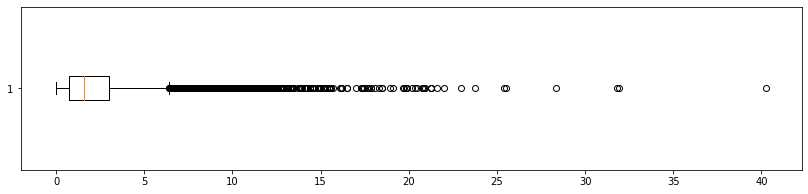

In [40]:
# show boxplot
plt.figure(figsize = (14,3))
plt.boxplot(difference, vert= False);
plt.show()

### LSTM applicato a serie dati multivariata di due celle

In [42]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))])

# convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3,  out_seq))

# choose a number of time steps
n_steps = 4

# convert into input/output
X, y = split_sequences(dataset, n_steps)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

In [43]:
# split data in train-test 
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]

train_y, test_y = y[0:train_size], y[train_size:len(y)]
print('X', len(train_X), len(test_X))
print('y ', len(train_y), len(test_y))

X 7908 3896
y  7908 3896


In [44]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu')) 
model.add(Dense(n_features)) 
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=2)

Epoch 1/50
 - 3s - loss: 133.7179
Epoch 2/50
 - 2s - loss: 7.6877
Epoch 3/50
 - 2s - loss: 7.6086
Epoch 4/50
 - 2s - loss: 7.4774
Epoch 5/50
 - 2s - loss: 6.9830
Epoch 6/50
 - 2s - loss: 6.5366
Epoch 7/50
 - 2s - loss: 6.8311
Epoch 8/50
 - 2s - loss: 6.7033
Epoch 9/50
 - 3s - loss: 6.5443
Epoch 10/50
 - 2s - loss: 6.2037
Epoch 11/50
 - 3s - loss: 7.0022
Epoch 12/50
 - 3s - loss: 6.7849
Epoch 13/50
 - 3s - loss: 6.4973
Epoch 14/50
 - 3s - loss: 6.7840
Epoch 15/50
 - 3s - loss: 6.5266
Epoch 16/50
 - 3s - loss: 6.5088
Epoch 17/50
 - 3s - loss: 6.3502
Epoch 18/50
 - 3s - loss: 6.1671
Epoch 19/50
 - 3s - loss: 6.2453
Epoch 20/50
 - 3s - loss: 6.3552
Epoch 21/50
 - 4s - loss: 5.8884
Epoch 22/50
 - 3s - loss: 6.6552
Epoch 23/50
 - 3s - loss: 6.4174
Epoch 24/50
 - 3s - loss: 6.2553
Epoch 25/50
 - 2s - loss: 6.0645
Epoch 26/50
 - 3s - loss: 5.9045
Epoch 27/50
 - 3s - loss: 6.1594
Epoch 28/50
 - 3s - loss: 6.2830
Epoch 29/50
 - 3s - loss: 5.9506
Epoch 30/50
 - 3s - loss: 5.9437
Epoch 31/50
 - 3s

In [45]:
# demonstrate prediction
x_input = np.array([[ 36,  43,  42, 121],
                    [ 34,  40,  40, 114],
                    [ 33,  39,  39, 111],
                    [ 32,  37,  37, 106]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=2)
print(yhat)

[[ 30.291162  35.5332    35.673187 101.5882  ]]


### Calcolo dell'errore 

In [47]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y

expected = np.reshape(expected, expected.shape[0] * expected.shape[1]* expected.shape[2])

IndexError: tuple index out of range

In [ ]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

In [ ]:
# show boxplot
plt.figure(figsize = (14,3))
plt.boxplot(difference, vert= False);
plt.show()